
################################################################################
> # **Clone GitHub repository**
################################################################################


In [ ]:
################# Clone repository from github to colab session ################

"""

run this section if you want to clone all the datasets, preTrained networks
from the GitHub repository to this colab session

"""


print("Start============================================================================================")

!git clone https://github.com/Bop2000/DANTE

print("Done============================================================================================")



Start============================================================================================
Cloning into 'DOTS'...
remote: Enumerating objects: 1477, done.
remote: Counting objects: 100% (1004/1004), done.
remote: Compressing objects: 100% (693/693), done.
remote: Total 1477 (delta 399), reused 823 (delta 309), pack-reused 473
Receiving objects: 100% (1477/1477), 405.59 MiB | 10.04 MiB/s, done.
Resolving deltas: 100% (444/444), done.
Done============================================================================================


In [ ]:
"""

run this section if you want to copy all files and folders from cloned folder
(DANTE/SelfDriving_Virtual_Labs/CCAs_Design/DANTE-FCC) to current directory (/content/ or ./)

So you can load all the simulation dataset, preTrained networks files without changing any paths

"""

print("============================================================================================")

!cp -rv ./DANTE/SelfDriving_Virtual_Labs/CCAs_Design/DANTE-FCC/* ./

print("============================================================================================")


'./DOTS/SelfDriving_Virtual_Labs/CCAs_Design/DOTS-FCC/data.csv' -> './data.csv'
'./DOTS/SelfDriving_Virtual_Labs/CCAs_Design/DOTS-FCC/run.py' -> './run.py'


In [ ]:

"""

run this section if you want to delete original cloned folder and the cloned ipynb file
(after you have copied its contents to current directory)

"""


print("============================================================================================")

# delete original cloned folder
!rm -r ./DANTE

# delete cloned ipynb file
!rm ./DANTE-VL_CCAs_Design.ipynb

print("============================================================================================")



rm: remove write-protected regular file './DOTS/.git/objects/pack/pack-eb681249c6cbfd65d44180bd7a56a94fbe7015f3.idx'? ^C


################################################################################
> # **Install Dependencies**
################################################################################

In [ ]:

############ install compatible version of tensorflow and ###########

# !pip install tensorflow

# !pip install scipy

# !pip install numpy

# !pip install pandas

# !pip install matplotlib

# !pip install scikit-learn

# !pip install tqdm

# !pip install seaborn

# !pip install openpyxl

################################################################################
> # **Introduction**
> **This notebook introduces the pipeline to design compositionally complex alloys, specifically, 6 element alloys with higher magnetic properties**

> The notebook is divided into 4 major parts :

*   **Part I** : visulization of initial data
*   **Part II** : define DANTE algorithm
*   **Part III** : define and train the CNN model
*   **Part IV** : optimization using DANTE

################################################################################

################################################################################
> # **Part - I**

*   Import initial dataset
*   Set parameters

################################################################################

fano factor of Formation energy: 1.3851311886877227
fano factor of ahc: 0.9011959410136812
fano factor of aha: 0.6191945054414533


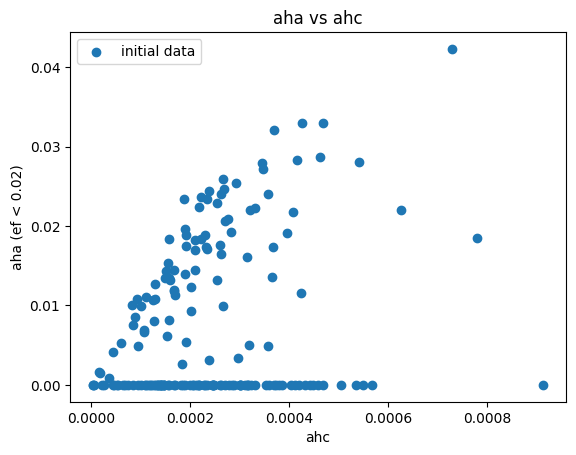

In [ ]:

############################### Import libraries ###############################

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from tqdm import tqdm
import os
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten, Dense,Dropout,BatchNormalization,GlobalAveragePooling1D
from tensorflow.keras.callbacks import EarlyStopping, LearningRateScheduler,ModelCheckpoint
import random
from scipy import stats
from sklearn import metrics
from abc import ABC, abstractmethod
from collections import defaultdict
import math
from collections import namedtuple
from tensorflow.keras import layers
from tensorflow import keras


############################### Creat Initial Folder ###############################

#Number of iteration
round_num  = 1
round_name = 'Round'+str(round_num)
round_num2 = round_num-1
round_name2 = 'Round'+str(round_num2)

model_folder = "Results"
# Check if the directory exists
if not os.path.exists(model_folder):
    # If it doesn't exist, create it
    os.makedirs(model_folder)
if not os.path.exists(model_folder+'/'+round_name):
    # If it doesn't exist, create it
    os.makedirs(model_folder+'/'+round_name)
if not os.path.exists(model_folder+'/'+round_name2):
    # If it doesn't exist, create it
    os.makedirs(model_folder+'/'+round_name2)



############################### Set Paramaters ###############################

top_sample=20 # number of newly selected samples
n_model=5 # number of cnn models for predictions
n_dim=27  # Dimension of this optimization problem
rollout_round=100 #number of roullout steps for DANTE algorithm,By default, DANTE performs 100 rollout
UCT_low=False
weight = 0.2 # exploration weight = weight * max(score)
list1=[5,8,2,5,3,1,1] ##[run times, top start points, random start points, top score samples, top rank samples, top visit samples, random samples]

num_ele = 6 # number of elements
step_size = 0.5 # interval of composition
Fe_low = 2
Fe_up = 100 #Fe upper limit & lower limit
Co_low = 2
Co_up = 100 #Co upper limit & lower limit
Ni_low = 2
Ni_up = 100 #Ni upper limit & lower limit
other_low = 2
other_up = 50 #other element upper limit & lower limit
FCN_low = 60
FCN_high = 80 # sum of Fe Co Ni upper limit & lower limit



############################### Import Initial Dataset ###############################

data = pd.read_csv("data.csv")
data = data.fillna(0)
data = np.array(data)

all_input = data[:,:n_dim] # element composition as input
all_data0 = data[:,n_dim]*10   #Formation energy
all_data1 = data[:,n_dim+2]*10000 #AHC
all_data2 = data[:,n_dim+4]*100   #AHA

ef = np.where(all_data0>0.2,0,1)

print('fano factor of Formation energy:',np.var(all_data0)/np.mean(all_data0))
print('fano factor of ahc:',np.var(all_data1)/np.mean(all_data1))
print('fano factor of aha:',np.var(all_data2)/np.mean(all_data2))

if round_num  == 1:
  plt.figure()
  plt.scatter(data[:,n_dim+2],ef * data[:,n_dim+4],label='initial data')
  plt.xlabel('ahc')
  plt.ylabel('aha (ef < 0.02)')
  plt.title("aha vs ahc")
  plt.legend()
  plt.savefig(model_folder+'/'+round_name2+'/performance-comparison2.png')
else:
  plt.figure()
  plt.scatter(data[:,n_dim+2],ef * data[:,n_dim+4],label='all data')
  plt.scatter(data[:,n_dim+2][-20:],ef[-20:] * data[:,n_dim+4][-20:],label='this round')
  plt.xlabel('ahc')
  plt.ylabel('aha (ef < 0.02)')
  plt.title("aha vs ahc")
  plt.legend()
  plt.savefig(model_folder+'/'+round_name2+'/performance-comparison2.png')




In [ ]:



################################# End of Part I ################################




################################################################################
> # **Part - II**

*   Define the DANTE alghorithm

################################################################################

In [ ]:
################################# DANTE alghorithm ################################



class DANTE:
    def __init__(self, exploration_weight=1):
        self.Q = defaultdict(int)  # total reward of each node
        self.N = defaultdict(int)  # total visit count for each node
        self.children = dict()  # children of each node
        self.exploration_weight = exploration_weight

    def choose(self, node):
        "Choose the best successor of node."
        if node.is_terminal():
            raise RuntimeError(f"choose called on terminal node {node}")

        if node not in self.children:
            print('not seen before, randomly sampled!')
            return node.find_random_child()

        def evaluate(n):
            return n.value  # average reward
        print(f'number of visit is {self.N[node]}')
        log_N_vertex = math.log(self.N[node])
        def uct(n):
            "Upper confidence bound for trees"

            uct_value = n.value + self.exploration_weight * math.sqrt(
                log_N_vertex / (self.N[n]+1))
            return uct_value

        action = [p for p in range(0, len(node.tup))]
        self.children[node] = node.find_children(action)
        media_node = max(self.children[node], key=uct)

        node_rand = []
        for i in range(len(list(self.children[node]))):
            node_rand.append(list(self.children[node])[i].tup)
        node_rand = np.array(node_rand).reshape(-1,n_dim)

        if uct(media_node) > uct(node):
            print(f'media node is{media_node}')
            print(f'uct of the node is{uct(media_node)} ')
            print(f'better value media node : {media_node.value}')
            return media_node, node_rand
        return node, node_rand


    def do_rollout(self, node):
        "Make the tree one layer better. (Train for one iteration.)"
        path = self._select(node)
        leaf = path[-1]
        self._expand(leaf)
        reward = self._simulate(leaf)
        self._backpropagate(path, reward)

    def _select(self, node):
        "Find an unexplored descendent of `node`"
        path = []
        count = 0
        while True:
            path.append(node)
            if node not in self.children or not self.children[node]:
              return path
            unexplored = self.children[node] - self.children.keys()
            def evaluate(n):
              return n.value
            if count == 50:
             return max(path, key=evaluate)

            if unexplored:
              path.append(max(unexplored, key=evaluate))#
              return path
            node = self._uct_select(node)  # descend a layer deeper
            count+=1

    def _expand(self, node):
        "Update the `children` dict with the children of `node`"
        if node in self.children:
            return  # already expanded
        action = [p for p in range(0, len(node.tup))]
        self.children[node] = node.find_children(action)

    def _simulate(self, node):
        "Returns the reward for a random simulation (to completion) of `node`"
        reward = node.reward()
        return reward

    def _backpropagate(self, path, reward):
        "Send the reward back up to the ancestors of the leaf"
        for node in reversed(path):
          self.N[node] += 1
          self.Q[node] += reward
    def _uct_select(self, node):
        "Select a child of node, balancing exploration & exploitation"
        # All children of node should already be expanded:
        assert all(n in self.children for n in self.children[node])
        log_N_vertex = math.log(self.N[node])

        def uct(n):
            "Upper confidence bound for trees"
            uct_value = n.value + self.exploration_weight * math.sqrt(
                log_N_vertex / (self.N[n]+1))
            return uct_value
        uct_node = max(self.children[node], key=uct)
        print(f'node with max uct is:{uct_node}')
        return uct_node

class Node(ABC):
    """
    A representation of a single board state.
    MCTS works by constructing a tree of these Nodes.
    Could be e.g. a chess or checkers board state.
    """

    @abstractmethod
    def find_children(self):
        "All possible successors of this board state"
        return set()

    @abstractmethod
    def find_random_child(self):
        "Random successor of this board state (for more efficient simulation)"
        return None

    @abstractmethod
    def is_terminal(self):
        "Returns True if the node has no children"
        return True

    @abstractmethod
    def reward(self):
        "Assumes `self` is terminal node. 1=win, 0=loss, .5=tie, etc"
        return 0

    @abstractmethod
    def __hash__(self):
        "Nodes must be hashable"
        return 123456789

    @abstractmethod
    def __eq__(node1, node2):
        "Nodes must be comparable"
        return True




############################ design the action space ############################

# composition limitations for all elements
def component_generate():
    ele_range = []
    ele_range4 = np.arange(Co_low, Co_up, step_size) #Co
    ele_range7 = np.arange(Ni_low, Ni_up, step_size) #Ni
    ele_range18 = np.arange(Fe_low, Fe_up, step_size) #Fe
    #set other elements' component
    index_other = np.setdiff1d(np.arange(n_dim), [4,7,18])
    for i in range(n_dim-3):
        exec(f"ele_range{index_other[i]} = np.arange(other_low, other_up, step_size)")

    for i in range(n_dim):
        exec(f"ele_range.append(ele_range{i})")
    ele_range = np.array(ele_range)
    return ele_range

# check the ratio of Fe/(Co+Ni)
def FCN_ratiocheck(x_input):
    x_output = np.array(x_input)
    Fe_num = x_input[18]
    Co_num = x_input[4]
    Ni_num = x_input[7]
    sum_FCN = Fe_num + Co_num + Ni_num
    ratio = 1.5
    Fe = np.round(ratio * sum_FCN / (ratio + 1),1)
    Co = np.round((sum_FCN - Fe) * (Co_num/(Co_num + Ni_num)),1)
    Ni = np.round((sum_FCN - Fe) * (Ni_num/(Co_num + Ni_num)),1)
    x_output[18] = Fe
    x_output[7] = Ni
    x_output[4] = Co
    return x_output

#check if Fe Co Ni has proper component, if not, adjust to a proper range
def sumFCN_adjust(x_input):
    if round(x_input[4],1) == 0 and round(x_input[7],1) == 0 and round(x_input[18],1) == 0:
        x_input[4] = x_input[7] = x_input[18] = 1
        x_input[np.argmax(x_input)] -=3

    x_output = np.array(x_input)
    index_FCN = [4,7,18]
    ele_exist = np.where(x_output > 0)
    index_other = np.setdiff1d(ele_exist[0], index_FCN)
    sum_FCN = x_input[4] + x_input[7] + x_input[18]
    sum_other = sum(x_input[index_other])

    if sum_FCN > FCN_high:
        percentage = FCN_high
    elif sum_FCN <FCN_low:
        percentage = FCN_low

    for i in range(3):
        x_output[index_FCN[i]] = np.round(x_output[index_FCN[i]] * percentage / sum_FCN,1)

    for i in range(len(index_other)):
        x_output[index_other[i]] = np.round(x_output[index_other[i]] * (100 - percentage) / sum_other,1)
    return x_output

# mode0: change element
def mode0(x_input,x_output,ele_exist,index_except):
    num_to_change = np.random.randint(1, 3)
    index_FCN = np.array([4,7,18])
    index_other = np.setdiff1d(ele_exist[0], index_FCN)
    index_except = np.setdiff1d(np.arange(n_dim), ele_exist[0])
    index_other_new = np.array(index_other)
    np.random.shuffle(index_other_new)
    other_to_be_added = np.array(index_except)
    np.random.shuffle(other_to_be_added)
    for i in range(num_to_change):
        x_output[other_to_be_added[i]] = x_input[index_other_new[i]]
        x_output[index_other_new[i]] = 0
    return x_output

# mode1: change component
def mode1(x_input,x_output,ele_exist,index_except):
    num_to_change = np.random.randint(1, 3)
    ele_exist_new = np.array(ele_exist[0])
    np.random.shuffle(ele_exist_new)
    for i in range(num_to_change):
        flip = np.random.randint(0,4)
        if flip == 0:
            temp = np.random.randint(1,11)
            x_output[ele_exist_new[i]] += step_size*temp
        elif flip == 1:
            temp = np.random.randint(1,11)
            x_output[ele_exist_new[i]] -= step_size*temp
            if x_output[ele_exist_new[i]] <= 0:
                x_output[ele_exist_new[i]] += 2*temp*step_size
        else:
            x_output[ele_exist_new[i]] = ele_range[ele_exist_new[i]][np.random.randint(0, len(ele_range[ele_exist_new[i]]))]
    return x_output

# prpose new CCAs
def create_new(x_input, num_ele):
    x_output = np.array(x_input).reshape(-1)
    ele_exist = np.where(x_input > 0)#index of existed elements
    index_except = np.setdiff1d(np.arange(n_dim), ele_exist[0])

    #3 modes : change element/change component/change both
    mode = np.random.randint(0,3)

    if mode == 0:
        x_output = mode0(x_input,x_output,ele_exist,index_except)

    elif mode == 1:
        x_output = mode1(x_input,x_output,ele_exist,index_except)

    elif mode == 2:
        x_output = mode0(x_input,x_output,ele_exist,index_except)
        x_output = mode1(x_input,x_output,ele_exist,index_except)

    new_exist = np.where(x_output > 0)
    num_exist_new = len(new_exist[0])
    sum_all = sum(x_output)
    for i in range(num_exist_new):
        x_output[new_exist[0][i]] = np.round(x_output[new_exist[0][i]]*100/sum_all/step_size)*step_size

    #make sure the sum is 100
    deviation = 100 - sum(x_output)
    if deviation != 0:
        ind_max = np.argmax(x_output)
        x_output[ind_max] += deviation

    #check if the new input is proper
    sum_FCN = x_output[4] + x_output[7] + x_output[18]
    if sum_FCN > FCN_high or sum_FCN < FCN_low:
        x_output = sumFCN_adjust(x_output)

    FCN_ratio = x_output[18] - 1.5*(x_output[4] + x_output[7])
    if FCN_ratio > 0:
        x_output = FCN_ratiocheck(x_output)

    x_output = ele_num_check(x_output, num_ele)
    return x_output

# check the number of elements
def ele_num_check(x_input, ele_num):
    x_output = np.array(x_input)
    x_output[np.where(x_input < 0)[0]] = 0 ########make sure every element no less than 0
    index = np.setdiff1d(np.arange(n_dim), np.array([4,7,18]))
    ele_true = np.where(x_input > 0)
    free_ele_exist = np.intersect1d(index, ele_true[0]) #index of elements existed except Fe, Co, Ni
    free_ele_except = np.setdiff1d(index, ele_true[0]) #index of elements excepted

    if len(ele_true[0]) > ele_num:
        dev = len(ele_true[0]) - ele_num #the deviation between ele_num and true ele_num
        index_deleted = np.array(free_ele_exist)
        np.random.shuffle(index_deleted)
        for i in range(dev):
            x_output[index_deleted[i]] = 0

    elif len(ele_true[0]) < ele_num:
        dev = ele_num - len(ele_true[0])
        index_added = np.array(free_ele_except)
        np.random.shuffle(index_added)
        for i in range(dev):
            x_output[index_added[i]] = step_size

    x_output = np.round(x_output*100/(sum(x_output)*step_size))*step_size
    deviation = 100 - sum(x_output)
    if deviation != 0:
        ind_max = np.argmax(x_output)
        x_output[ind_max] += deviation
    return x_output

_OT = namedtuple("opt_task", "tup value terminal")
class opt_task(_OT, Node):
    def find_children(board,action):
        if board.terminal:
            return set()
        all_tup=[]
        for index in action:
            tup = create_new(np.array(board.tup), num_ele)
            all_tup.append(tup)

        all_value = oracle(all_tup)
        is_terminal=False
        return  {opt_task(tuple(t), v, is_terminal) for t, v in  zip(all_tup,all_value)}

    def reward(board):
        # return  oracle1(board.tup, model1,model2)[0][0]
        return  oracle(board.tup)
    def is_terminal(board):
        return board.terminal

# return the mostly visited nodes
def most_visit_node(tree_ubt, X,top_n):
  N_visit = tree_ubt.N
  childrens = [i for i in tree_ubt.children]
  children_N = []
  X_top = []
  for child in childrens:
    child_tup = np.array(child.tup)
    same = np.all(child_tup==X, axis=1)
    has_true = any(same)
    if has_true == False:
      children_N.append(N_visit[child])
      X_top.append(child_tup)
  children_N = np.array(children_N)
  X_top = np.array(X_top)
  ind = np.argpartition(children_N, -top_n)[-top_n:]
  X_topN = X_top[ind]
  return X_topN

# return random nodes
def random_node(new_x,n):
  X_rand1 = [new_x[random.randint(0, len(new_x)-1)] for i in range(n)]
  return X_rand1

print("DANTE defined!")

DOTS defined!


In [ ]:




################################ End of Part II ################################






################################################################################
> # **Part - III**

*   Define and train the CNN model

################################################################################

In [ ]:
################################ Define the CNN model ################################

#########slice the data to five parts
index_random=np.arange(len(all_data2))
random.shuffle(index_random)
index_random1=index_random[:]

def model_training(X,y,name,i):
      X=X.reshape(-1,n_dim,1)
      ind=index_random[round(i*len(index_random)/5):round((1+i)*len(index_random)/5)]####1/5 data as test set
      ind2=np.setdiff1d(index_random, ind)
      X_train, X_test, y_train, y_test = X[ind2],X[ind], y[ind2],y[ind]
      model = Sequential([
            layers.Conv1D(64,kernel_size=3,strides=2,padding='same', activation='elu', input_shape=(n_dim,1)),
            layers.BatchNormalization(),
            layers.Conv1D(32,kernel_size=3,strides=2, padding='same', activation='elu'),
            layers.Conv1D(16,kernel_size=3,strides=2, padding='same', activation='elu'),
            layers.Dropout(0.2),
            layers.Conv1D(8,kernel_size=3,strides=1, padding='same', activation='elu'),
            layers.Flatten(),
            Dense(128, activation='elu'),
            Dense(1, activation='linear')
      ])
      optimizer = keras.optimizers.Adam(learning_rate=0.001)
      model.compile(optimizer=optimizer, loss='mse', metrics=["mean_squared_error"])
      model.summary()
      es = EarlyStopping(monitor='val_loss', mode='min', verbose=1,patience=1000)
      mc = ModelCheckpoint(model_folder+'/'+round_name+f"/{name}.h5", monitor='val_loss', mode='min', verbose=False, save_best_only=True)
      model.fit(X_train, y_train, validation_data=(X_test, y_test),  batch_size=50, epochs=5000, callbacks=[es,mc], verbose=False)
      model=keras.models.load_model(model_folder+'/'+round_name+f"/{name}.h5")
      R2,MAE=mar_r2(model,X_test,y_test)
      return model,X_test,y_test,R2,MAE

def model_training2(X,y,name,i):
      X=X.reshape(-1,n_dim,1)
      ind=index_random[round(i*len(index_random)/5):round((1+i)*len(index_random)/5)]####1/5 data as test set
      ind2=np.setdiff1d(index_random, ind)
      X_train, X_test, y_train, y_test = X[ind2],X[ind], y[ind2],y[ind]
      model = Sequential([
          layers.Conv1D(64,kernel_size=3,strides=2,padding='same', activation='elu', input_shape=(n_dim,1)),
            layers.BatchNormalization(),
            layers.Conv1D(32,kernel_size=3,strides=2, padding='same', activation='elu'),
            layers.Dropout(0.2),
            layers.Conv1D(16,kernel_size=3,strides=2, padding='same', activation='elu'),
            layers.Dropout(0.2),
            layers.Conv1D(8,kernel_size=3,strides=1, padding='same', activation='elu'),
            layers.Flatten(),
            Dense(16, activation='elu'),
          Dense(1, activation='linear')
      ])
      optimizer = keras.optimizers.Adam(learning_rate=0.002)
      model.compile(optimizer=optimizer, loss='mse', metrics=["mean_squared_error"])
      model.summary()
      es = EarlyStopping(monitor='val_loss', mode='min', verbose=1,patience=1000)
      mc = ModelCheckpoint(model_folder+'/'+round_name+f"/{name}.h5", monitor='val_loss', mode='min', verbose=False, save_best_only=True)
      model.fit(X_train, y_train, validation_data=(X_test, y_test),  batch_size=50, epochs=5000, callbacks=[es,mc], verbose=False)
      model=keras.models.load_model(model_folder+'/'+round_name+f"/{name}.h5")
      R2,MAE=mar_r2(model,X_test,y_test)
      return model,X_test,y_test,R2,MAE

def mar_r2(model,X_test,y_test):
    y_pred = model.predict(X_test.reshape(len(X_test),n_dim,1))
    R2=stats.pearsonr(y_pred.reshape(-1), y_test.reshape(-1))[0]
    R2=np.asarray(R2).round(5)
    MAE= metrics.mean_absolute_error(y_test.reshape(-1), y_pred.reshape(-1))
    return R2,MAE

def model_performance(model,X_test,y_test):
    perform_list=pd.read_csv(model_folder+'/'+round_name+f'/model_performance_{n_dim}d.csv')
    y_pred = model.predict(X_test.reshape(len(X_test),n_dim,1))
    R2=stats.pearsonr(y_pred.reshape(-1), y_test.reshape(-1))[0]
    R2=np.asarray(R2).round(5)
    MAE= metrics.mean_absolute_error(y_test.reshape(-1), y_pred.reshape(-1))
    y_test = pd.DataFrame(y_test)
    y_test.columns= ['ground truth']
    y_pred = pd.DataFrame(y_pred)
    y_pred.columns= ['pred']
    print("R2",R2,"MAE",MAE)
    R2MAE = pd.DataFrame([R2,MAE])
    R2MAE.columns= ['R2&MAE']
    perform_list2=pd.concat((perform_list,y_test,y_pred,R2MAE),axis=1)
    perform_list2.drop([perform_list2.columns[0]],axis=1, inplace=True)
    perform_list2.to_csv(model_folder+'/'+round_name+f'/model_performance_{n_dim}d.csv')
    return R2,MAE

print("Model defined!")

Model defined!


In [ ]:
################################ Train the CNN model ################################


pd.DataFrame(np.empty(0)).to_csv(model_folder+'/'+round_name+f'/model_performance_{n_dim}d.csv')
try_lim = 5

#train the model of formation energy
for i in range(5):
    trytime=0
    model1,X_test1,y_test1,R21,MAE1 = model_training(all_input,all_data0,f'ef{i}',i)
    R20=R21
    while R21 < 0.98 and trytime<try_lim:
        trytime+=1
        model1,X_test1,y_test1,R21,MAE1 = model_training(all_input,all_data0,f'ef{i+10}',i)
        if R21>R20:
            R20=R21
            model1.save("Results/"+round_name+f'/ef{i}.h5')
    model1=keras.models.load_model(model_folder+'/'+round_name+f'/ef{i}.h5')
    R21,MAE1=model_performance(model1,X_test1,y_test1) #show and save the performance of the model

#train the model of ahc
for i in range(5):
    trytime=0
    model1,X_test1,y_test1,R21,MAE1 = model_training(all_input,all_data1,f'ahc{i}',i)
    R20=R21
    while R21 < 0.97 and trytime<try_lim:
        trytime+=1
        model1,X_test1,y_test1,R21,MAE1 = model_training(all_input,all_data1,f'ahc{i+10}',i)
        if R21>R20:
            R20=R21
            model1.save("Results/"+round_name+f'/ahc{i}.h5')
    model1=keras.models.load_model(model_folder+'/'+round_name+f'/ahc{i}.h5')
    R21,MAE1=model_performance(model1,X_test1,y_test1) #show and save the performance of the model

#train the model of aha
for i in range(5):
    trytime=0
    model2,X_test2,y_test2,R22,MAE2 = model_training2(all_input,all_data2,f'aha{i}',i)
    R20=R22
    while R22 < 0.97 and trytime<try_lim:
        trytime+=1
        model2,X_test2,y_test2,R22,MAE2 = model_training2(all_input,all_data2,f'aha{i+10}',i)
        if R22>R20:
            R20=R22
            model2.save("Results/"+round_name+f'/aha{i}.h5')
    model2=keras.models.load_model(model_folder+'/'+round_name+f'/aha{i}.h5')
    R22,MAE2=model_performance(model2,X_test2,y_test2) #show and save the performance of the model



Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_20 (Conv1D)           (None, 14, 64)            256       
_________________________________________________________________
batch_normalization_5 (Batch (None, 14, 64)            256       
_________________________________________________________________
conv1d_21 (Conv1D)           (None, 7, 32)             6176      
_________________________________________________________________
conv1d_22 (Conv1D)           (None, 4, 16)             1552      
_________________________________________________________________
dropout_5 (Dropout)          (None, 4, 16)             0         
_________________________________________________________________
conv1d_23 (Conv1D)           (None, 4, 8)              392       
_________________________________________________________________
flatten_5 (Flatten)          (None, 32)               

Epoch 01179: early stopping
R2 0.99568 MAE 0.05638563861194715
Model: "sequential_10"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_40 (Conv1D)           (None, 14, 64)            256       
_________________________________________________________________
batch_normalization_10 (Batc (None, 14, 64)            256       
_________________________________________________________________
conv1d_41 (Conv1D)           (None, 7, 32)             6176      
_________________________________________________________________
conv1d_42 (Conv1D)           (None, 4, 16)             1552      
_________________________________________________________________
dropout_10 (Dropout)         (None, 4, 16)             0         
_________________________________________________________________
conv1d_43 (Conv1D)           (None, 4, 8)              392       
________________________________________________________

Epoch 01005: early stopping
R2 0.71921 MAE 0.5692589122523203
Model: "sequential_16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_64 (Conv1D)           (None, 14, 64)            256       
_________________________________________________________________
batch_normalization_16 (Batc (None, 14, 64)            256       
_________________________________________________________________
conv1d_65 (Conv1D)           (None, 7, 32)             6176      
_________________________________________________________________
conv1d_66 (Conv1D)           (None, 4, 16)             1552      
_________________________________________________________________
dropout_16 (Dropout)         (None, 4, 16)             0         
_________________________________________________________________
conv1d_67 (Conv1D)           (None, 4, 8)              392       
_________________________________________________________

Epoch 01098: early stopping
R2 0.68693 MAE 0.8408020458045687
Model: "sequential_22"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_88 (Conv1D)           (None, 14, 64)            256       
_________________________________________________________________
batch_normalization_22 (Batc (None, 14, 64)            256       
_________________________________________________________________
conv1d_89 (Conv1D)           (None, 7, 32)             6176      
_________________________________________________________________
conv1d_90 (Conv1D)           (None, 4, 16)             1552      
_________________________________________________________________
dropout_22 (Dropout)         (None, 4, 16)             0         
_________________________________________________________________
conv1d_91 (Conv1D)           (None, 4, 8)              392       
_________________________________________________________

Epoch 01020: early stopping
R2 0.79399 MAE 0.6610548638717333
Model: "sequential_28"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_112 (Conv1D)          (None, 14, 64)            256       
_________________________________________________________________
batch_normalization_28 (Batc (None, 14, 64)            256       
_________________________________________________________________
conv1d_113 (Conv1D)          (None, 7, 32)             6176      
_________________________________________________________________
conv1d_114 (Conv1D)          (None, 4, 16)             1552      
_________________________________________________________________
dropout_28 (Dropout)         (None, 4, 16)             0         
_________________________________________________________________
conv1d_115 (Conv1D)          (None, 4, 8)              392       
_________________________________________________________

Epoch 01069: early stopping
R2 0.8356 MAE 0.6262136752289363
Model: "sequential_34"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_136 (Conv1D)          (None, 14, 64)            256       
_________________________________________________________________
batch_normalization_34 (Batc (None, 14, 64)            256       
_________________________________________________________________
conv1d_137 (Conv1D)          (None, 7, 32)             6176      
_________________________________________________________________
conv1d_138 (Conv1D)          (None, 4, 16)             1552      
_________________________________________________________________
dropout_34 (Dropout)         (None, 4, 16)             0         
_________________________________________________________________
conv1d_139 (Conv1D)          (None, 4, 8)              392       
__________________________________________________________

Epoch 01017: early stopping
R2 0.82393 MAE 0.5273104543666044
Model: "sequential_40"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_160 (Conv1D)          (None, 14, 64)            256       
_________________________________________________________________
batch_normalization_40 (Batc (None, 14, 64)            256       
_________________________________________________________________
conv1d_161 (Conv1D)          (None, 7, 32)             6176      
_________________________________________________________________
dropout_40 (Dropout)         (None, 7, 32)             0         
_________________________________________________________________
conv1d_162 (Conv1D)          (None, 4, 16)             1552      
_________________________________________________________________
dropout_41 (Dropout)         (None, 4, 16)             0         
_________________________________________________________

Epoch 01799: early stopping
Model: "sequential_45"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_180 (Conv1D)          (None, 14, 64)            256       
_________________________________________________________________
batch_normalization_45 (Batc (None, 14, 64)            256       
_________________________________________________________________
conv1d_181 (Conv1D)          (None, 7, 32)             6176      
_________________________________________________________________
dropout_50 (Dropout)         (None, 7, 32)             0         
_________________________________________________________________
conv1d_182 (Conv1D)          (None, 4, 16)             1552      
_________________________________________________________________
dropout_51 (Dropout)         (None, 4, 16)             0         
_________________________________________________________________
conv1d_183 (Conv1D)      

Epoch 01674: early stopping
Model: "sequential_50"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_200 (Conv1D)          (None, 14, 64)            256       
_________________________________________________________________
batch_normalization_50 (Batc (None, 14, 64)            256       
_________________________________________________________________
conv1d_201 (Conv1D)          (None, 7, 32)             6176      
_________________________________________________________________
dropout_60 (Dropout)         (None, 7, 32)             0         
_________________________________________________________________
conv1d_202 (Conv1D)          (None, 4, 16)             1552      
_________________________________________________________________
dropout_61 (Dropout)         (None, 4, 16)             0         
_________________________________________________________________
conv1d_203 (Conv1D)      

Epoch 02807: early stopping
Model: "sequential_55"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_220 (Conv1D)          (None, 14, 64)            256       
_________________________________________________________________
batch_normalization_55 (Batc (None, 14, 64)            256       
_________________________________________________________________
conv1d_221 (Conv1D)          (None, 7, 32)             6176      
_________________________________________________________________
dropout_70 (Dropout)         (None, 7, 32)             0         
_________________________________________________________________
conv1d_222 (Conv1D)          (None, 4, 16)             1552      
_________________________________________________________________
dropout_71 (Dropout)         (None, 4, 16)             0         
_________________________________________________________________
conv1d_223 (Conv1D)      

Epoch 01246: early stopping
Model: "sequential_60"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_240 (Conv1D)          (None, 14, 64)            256       
_________________________________________________________________
batch_normalization_60 (Batc (None, 14, 64)            256       
_________________________________________________________________
conv1d_241 (Conv1D)          (None, 7, 32)             6176      
_________________________________________________________________
dropout_80 (Dropout)         (None, 7, 32)             0         
_________________________________________________________________
conv1d_242 (Conv1D)          (None, 4, 16)             1552      
_________________________________________________________________
dropout_81 (Dropout)         (None, 4, 16)             0         
_________________________________________________________________
conv1d_243 (Conv1D)      

Epoch 01073: early stopping
Model: "sequential_65"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_260 (Conv1D)          (None, 14, 64)            256       
_________________________________________________________________
batch_normalization_65 (Batc (None, 14, 64)            256       
_________________________________________________________________
conv1d_261 (Conv1D)          (None, 7, 32)             6176      
_________________________________________________________________
dropout_90 (Dropout)         (None, 7, 32)             0         
_________________________________________________________________
conv1d_262 (Conv1D)          (None, 4, 16)             1552      
_________________________________________________________________
dropout_91 (Dropout)         (None, 4, 16)             0         
_________________________________________________________________
conv1d_263 (Conv1D)      

Epoch 01099: early stopping
R2 0.69333 MAE 0.440313679462009


In [ ]:

################################ Load and use the CNN model ################################

path = os.getcwd()
name2=path+'/Results/'+round_name+'/'
models=dict()
model_list0=[]
for i in range(0,n_model):
    modelname = f'ef{i}'
    model_list0.append(modelname)
    models[modelname]= keras.models.load_model(name2+modelname+'.h5')
model_list1=[]
for i in range(0,n_model):
    modelname = f'ahc{i}'
    model_list1.append(modelname)
    models[modelname]= keras.models.load_model(name2+modelname+'.h5')
model_list2=[]
for i in range(0,n_model):
    modelname = f'aha{i}'
    model_list2.append(modelname)
    models[modelname]= keras.models.load_model(name2+modelname+'.h5')


###emsemble all models to predict
def emsemble_pred0(S,n_model=5):##formation energy
    pred_all=0
    for i in range(n_model):
        temp=models[model_list0[i]].predict(S.reshape(len(S),n_dim,1))
        pred_all+=temp
    pred_all/=n_model
    return pred_all

def emsemble_pred1(S,n_model=5):##ahc
    pred_all=0
    for i in range(n_model):
        temp=models[model_list1[i]].predict(S.reshape(len(S),n_dim,1))
        pred_all+=temp
    pred_all/=n_model
    return pred_all

def emsemble_pred2(S,n_model=5):##aha
    pred_all=0
    for i in range(n_model):
        temp=models[model_list2[i]].predict(S.reshape(len(S),n_dim,1))
        pred_all+=temp
    pred_all/=n_model
    return pred_all

def oracle(x):
    x_proposed=np.array(x).reshape(-1,n_dim,1)
    x0 = emsemble_pred0(x_proposed)
    x0 = np.where(x0>0.05,0,1)
    x1 = emsemble_pred1(x_proposed)
    x2 = emsemble_pred2(x_proposed)
    all_score = x0*x1*x2
    return all_score.reshape(len(x_proposed))

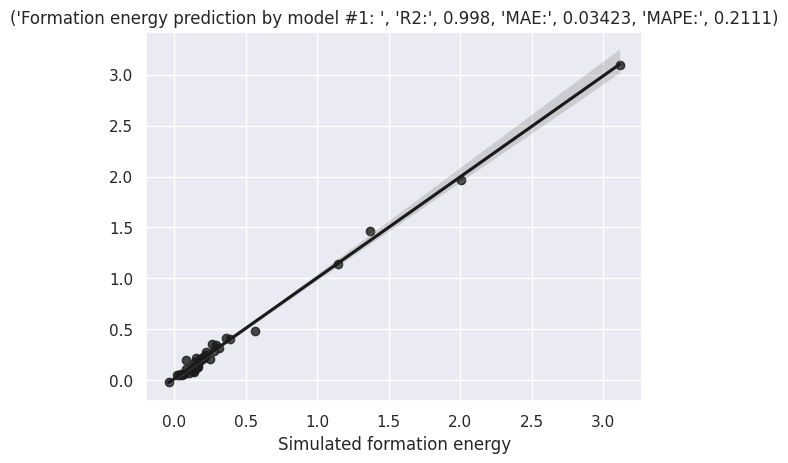

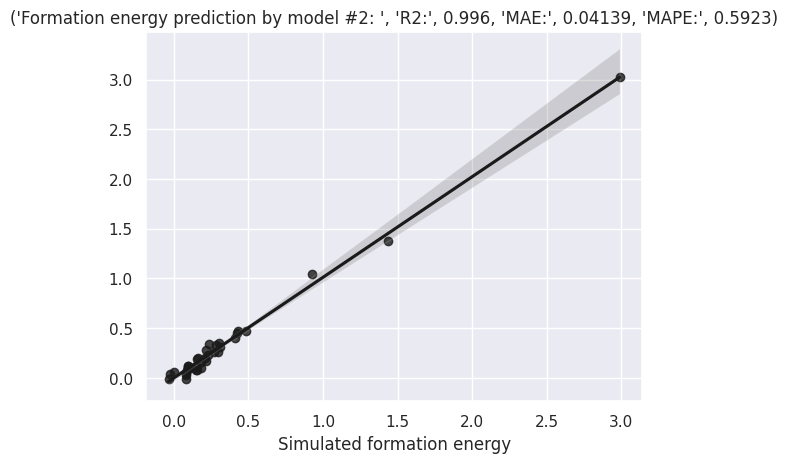

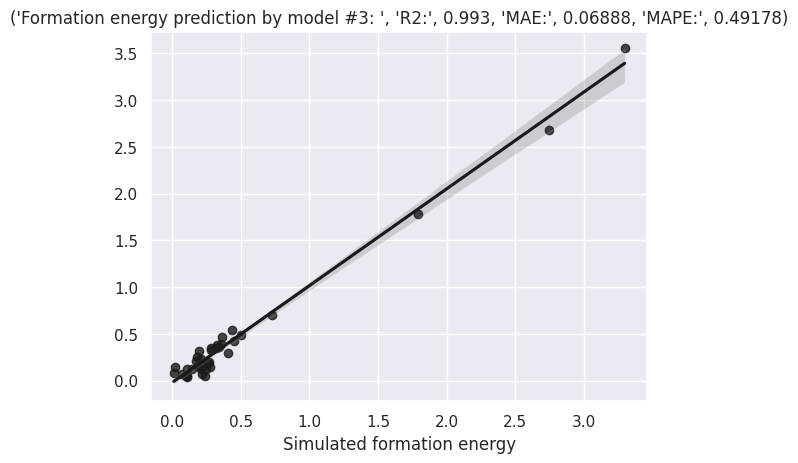

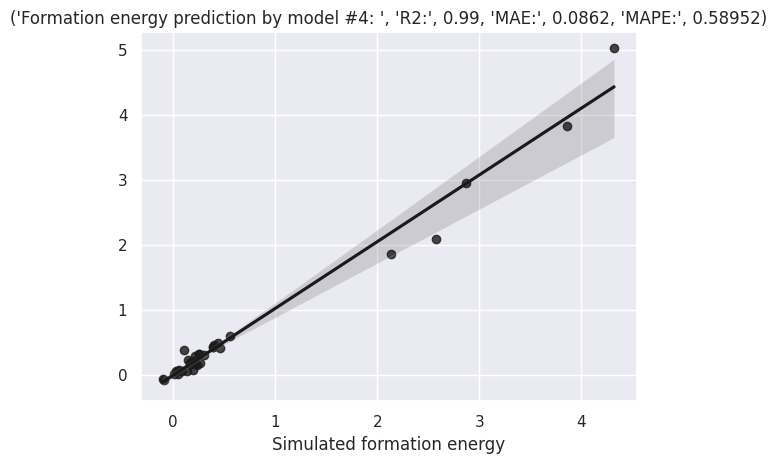

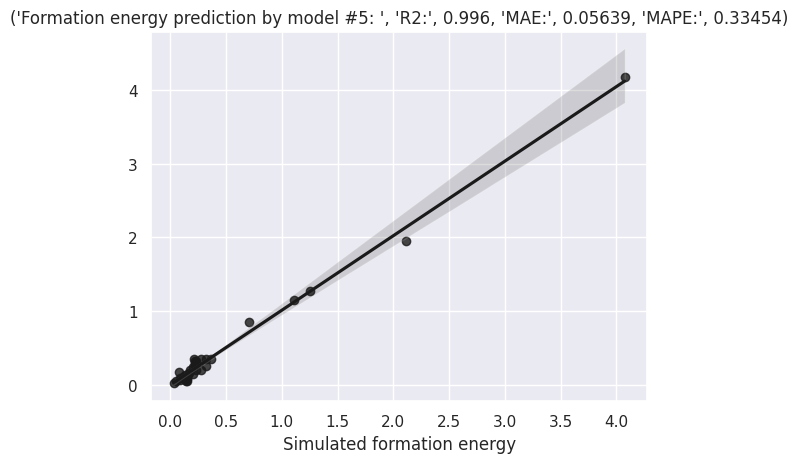

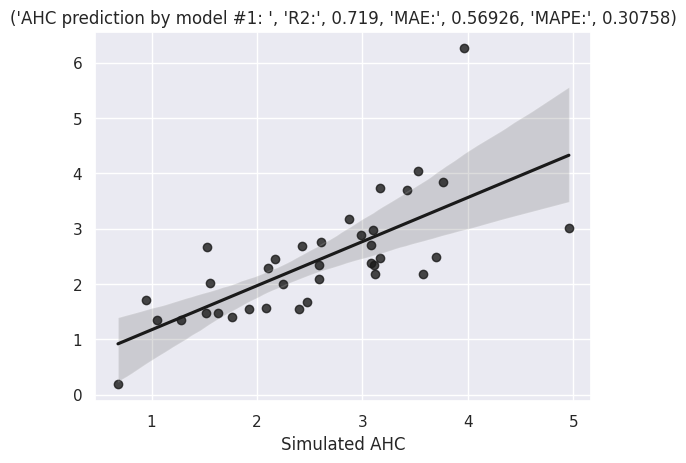

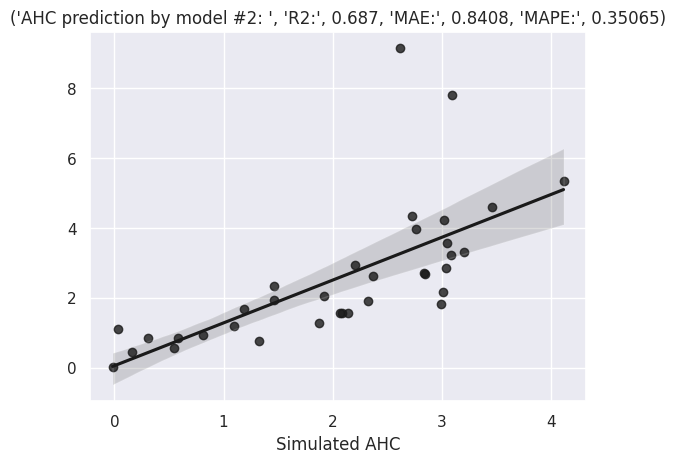

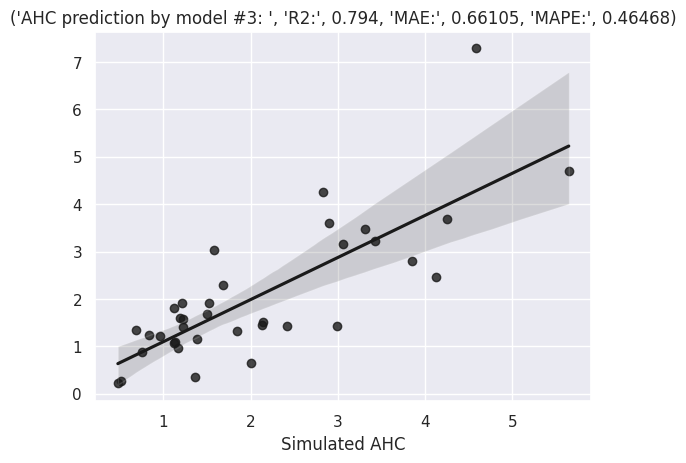

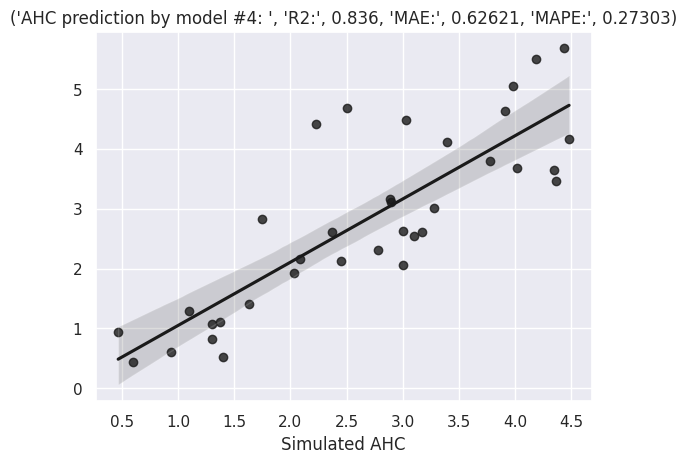

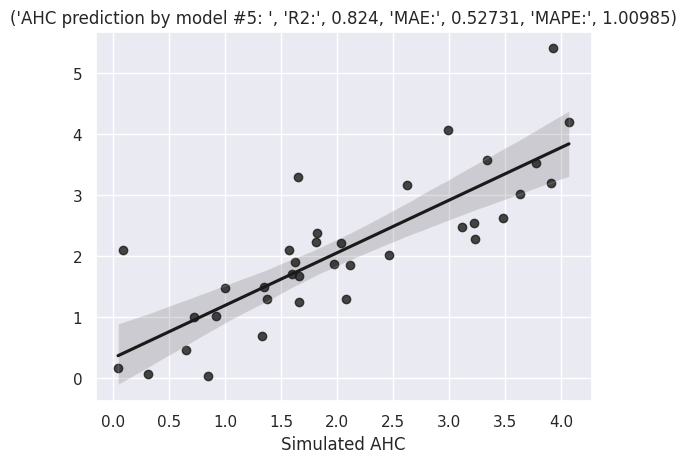

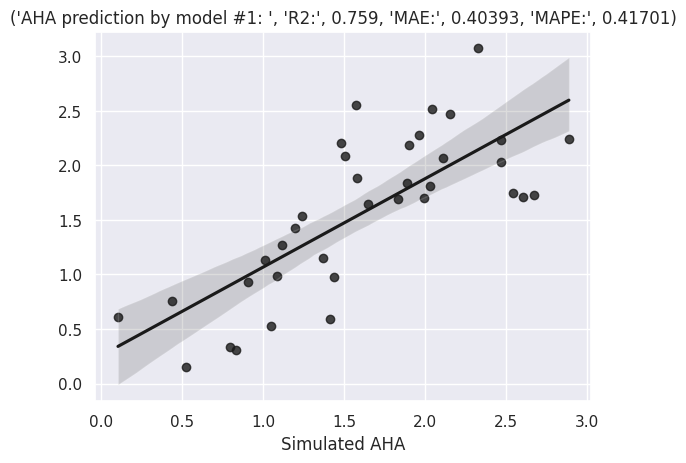

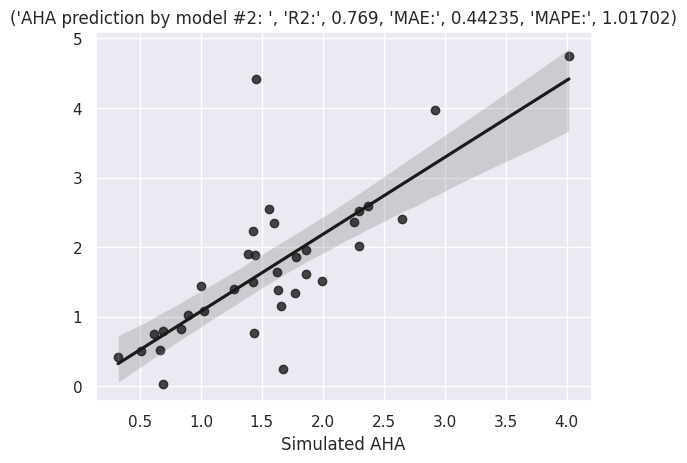

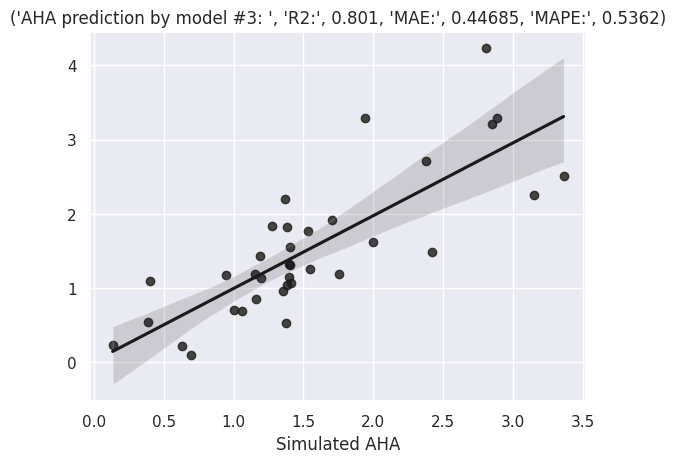

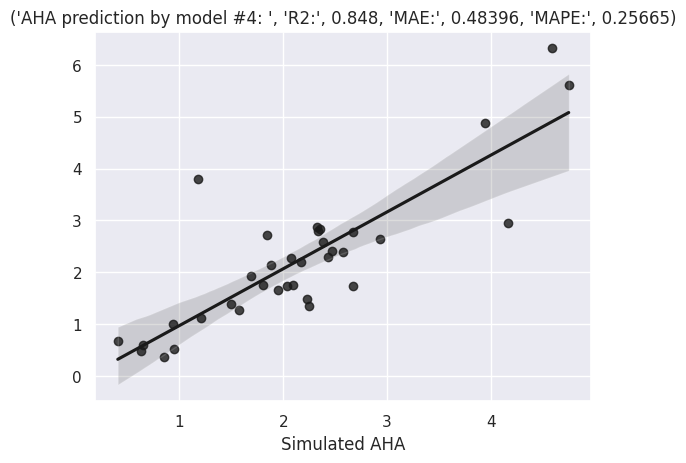

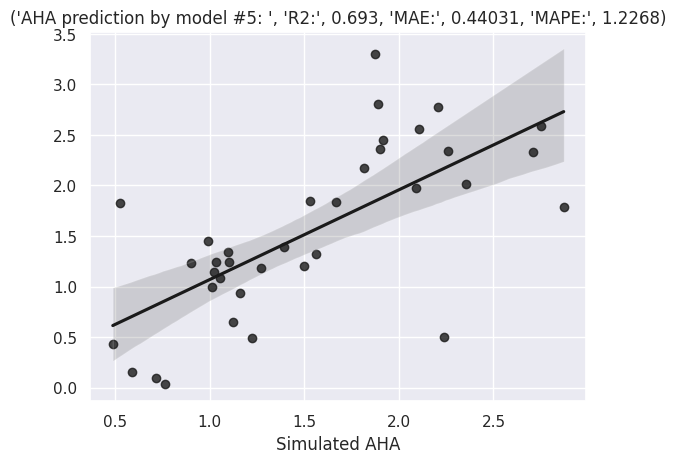

In [ ]:
################################ model performance visualization ################################
import seaborn as sns
def model_visual1(X,y,i): # Formation energy
    model1=models[model_list0[i]]
    X=X.reshape(-1,n_dim,1)
    ind=index_random[round(i*len(index_random)/5):round((1+i)*len(index_random)/5)]####1/5 data as test set
    ind2=np.setdiff1d(index_random, ind)
    X_train, X_test, y_train, y_test = X[ind2],X[ind], y[ind2],y[ind]

    y_pred = model1.predict(X_test.reshape(len(X_test),n_dim,1))
    R2=stats.pearsonr(y_pred.reshape(-1), y_test.reshape(-1))[0]
    R2=np.asarray(R2).round(3)
    MAE= metrics.mean_absolute_error(y_test.reshape(-1), y_pred.reshape(-1))
    MAE=np.asarray(MAE).round(5)
    MAPE= metrics.mean_absolute_percentage_error(y_test.reshape(-1), y_pred.reshape(-1))
    MAPE=np.asarray(MAPE).round(5)
    plt.figure()
    sns.set()
    sns.regplot(x=y_pred, y=y_test, color='k')
    plt.title((f'Formation energy prediction by model #{i+1}: ','R2:',R2,'MAE:',MAE,'MAPE:',MAPE))
    plt.xlabel('Predicted formation energy')
    plt.xlabel('Simulated formation energy')

def model_visual2(X,y,i):# AHC
    model2=models[model_list1[i]]
    X=X.reshape(-1,n_dim,1)
    ind=index_random[round(i*len(index_random)/5):round((1+i)*len(index_random)/5)]####1/5 data as test set
    ind2=np.setdiff1d(index_random, ind)
    X_train, X_test, y_train, y_test = X[ind2],X[ind], y[ind2],y[ind]

    y_pred = model2.predict(X_test.reshape(len(X_test),n_dim,1))
    R2=stats.pearsonr(y_pred.reshape(-1), y_test.reshape(-1))[0]
    R2=np.asarray(R2).round(3)
    MAE= metrics.mean_absolute_error(y_test.reshape(-1), y_pred.reshape(-1))
    MAE=np.asarray(MAE).round(5)
    MAPE= metrics.mean_absolute_percentage_error(y_test.reshape(-1), y_pred.reshape(-1))
    MAPE=np.asarray(MAPE).round(5)
    plt.figure()
    sns.set()
    sns.regplot(x=y_pred, y=y_test, color='k')
    plt.title((f'AHC prediction by model #{i+1}: ','R2:',R2,'MAE:',MAE,'MAPE:',MAPE))
    plt.xlabel('Predicted AHC')
    plt.xlabel('Simulated AHC')

def model_visual3(X,y,i):# AHA
    model2=models[model_list2[i]]
    X=X.reshape(-1,n_dim,1)
    ind=index_random[round(i*len(index_random)/5):round((1+i)*len(index_random)/5)]####1/5 data as test set
    ind2=np.setdiff1d(index_random, ind)
    X_train, X_test, y_train, y_test = X[ind2],X[ind], y[ind2],y[ind]

    y_pred = model2.predict(X_test.reshape(len(X_test),n_dim,1))
    R2=stats.pearsonr(y_pred.reshape(-1), y_test.reshape(-1))[0]
    R2=np.asarray(R2).round(3)
    MAE= metrics.mean_absolute_error(y_test.reshape(-1), y_pred.reshape(-1))
    MAE=np.asarray(MAE).round(5)
    MAPE= metrics.mean_absolute_percentage_error(y_test.reshape(-1), y_pred.reshape(-1))
    MAPE=np.asarray(MAPE).round(5)
    plt.figure()
    sns.set()
    sns.regplot(x=y_pred, y=y_test, color='k')
    plt.title((f'AHA prediction by model #{i+1}: ','R2:',R2,'MAE:',MAE,'MAPE:',MAPE))
    plt.xlabel('Predicted AHA')
    plt.xlabel('Simulated AHA')

for i in range(5):
    model_visual1(all_input,all_data0,i)
for i in range(5):
    model_visual2(all_input,all_data1,i)
for i in range(5):
    model_visual3(all_input,all_data2,i)

In [ ]:



################################ End of Part III ###############################




################################################################################
> # **Part - IV**

*   Optimization using DANTE

################################################################################


Input description:
*   all_input: initial data (element composition)
*   all_data0: initial label (formation energy)
*   all_data : initial label (ahc)
*   all_data2: initial label (aha)

Output description:

*   top_all    : newly sampled data (element composition)
*   top_select2: final selected sampled data (element composition)


In [ ]:
################################ Optimization using DANTE ###############################


def pareto_frontier(data):
    """
    Find the Pareto frontier from a two-dimensional array.

    :param data: A two-dimensional numpy array where rows are points.
    :return: A numpy array with the points on the Pareto frontier.
    """
    # Sort data by the first dimension (x)
    indices = np.argsort(data[:, 0])
    indices = indices[::-1]
    data_sorted = data[data[:, 0].argsort()]
    data_sorted = data_sorted[::-1]
    pareto_front = [data_sorted[0]]
    pareto_indices = [indices[0]]
    for i, point in enumerate(data_sorted[1:]):
        if point[1] > pareto_front[-1][1]:  # Compare with the last point in the Pareto front
            pareto_front.append(point)
            pareto_indices.append(indices[i + 1])
    return np.array(pareto_indices)

def pareto_evaluation(all_input, sample_input,num,plot_save = False): #Euclidean distance + pred score #pareto front
    sample_dist=[]##nearest neighbor distance
    for i in sample_input:
        dist_temp=1000000000000
        for n in all_input:
            dist= np.linalg.norm(i - n)
            if dist < dist_temp:
                dist_temp = round(dist,10)
        sample_dist.append(dist_temp)
    sample_dist=np.array(sample_dist)
    sample_score=oracle(sample_input)
    data=np.concatenate((sample_dist.reshape(-1,1),sample_score.reshape(-1,1)),axis=1)
    print(data.shape)
    pareto_front = pareto_frontier(data)
    while len(pareto_front) < num:
        remaining_data = np.delete(data, pareto_front, axis=0)
        remaining_indices = np.delete(np.arange(data.shape[0]), pareto_front)
        pareto_front2 = pareto_frontier(remaining_data)
        pareto_front = np.concatenate((pareto_front,remaining_indices[pareto_front2]))

    ind = np.random.choice(pareto_front,num,replace=False)

    if plot_save == True:
        plt.figure()
        plt.scatter(sample_dist,sample_score,label='all samples')
        plt.scatter(sample_dist[pareto_front],sample_score[pareto_front],label='pareto-front samples')
        plt.scatter(sample_dist[ind],sample_score[ind],label='selected samples')
        plt.title('distance VS score')
        plt.xlabel('distance')
        plt.ylabel('score')
        plt.legend()
        plt.show()
        plt.savefig(model_folder+'/'+round_name+'/distance VS score.png')
        ##############
        total = np.concatenate((all_input.reshape(-1,n_dim), sample_input.reshape(-1,n_dim)), axis=0)
        print('TSNE shape',total.shape)
        from sklearn.manifold import TSNE
        keep_dims = 2
        prp = 40
        tsne = TSNE(n_components=keep_dims,
                    perplexity=prp,
                    random_state=42,
                    n_iter=5000,
                    n_jobs=-1)
        total_tsne = tsne.fit_transform(total)
        total_tsne0 = total_tsne[:, 0]
        total_tsne1 = total_tsne[:, 1]
        print('TSNE done!')
        plt.figure()
        plt.scatter(total_tsne[:len(all_input), 0], total_tsne[:len(
            all_input), 1], color='black', label='initial data')
        plt.scatter(total_tsne[len(all_input):, 0], total_tsne[len(
            all_input):, 1], color='blue', label='sampled data')
        plt.scatter(total_tsne0[len(all_input)+ind], total_tsne1[len(
            all_input)+ind], color='green', label='top-sampled data')
        plt.title('TSNE ')
        plt.colorbar()
        plt.legend()
        plt.savefig(model_folder+'/'+round_name+'/TSNE.png')

        #################################################################
        from sklearn.decomposition import PCA
        "PCA"
        pca = PCA(n_components=2, whiten=True)
        total_pca = pca.fit_transform(total)
        plt.figure()
        plt.scatter(total_pca[:len(all_input), 0], total_pca[:len(
            all_input), 1], color='black', label='initial data')
        plt.scatter(total_pca[len(all_input):, 0], total_pca[len(
            all_input):, 1], color='blue', label='sampled data')
        plt.scatter(total_pca[len(all_input)+ind, 0], total_pca[len(all_input) +
                    ind, 1], color='green', label='top-sampled data')
        plt.title('PCA')
        plt.colorbar()
        plt.legend()
        plt.savefig(model_folder+'/'+round_name+'/PCA.png')

    return ind


def single_run(X,y,initial_X,greedy_UCT,UCT_low):
    initial_X=initial_X.reshape(n_dim)
    if greedy_UCT== True:
        values = max(y)
        exp_weight = weight * values
    if UCT_low ==True:
        values = oracle(initial_X)
        exp_weight = weight * values

    board_uct = opt_task(tup=tuple(initial_X), value=tuple(oracle(initial_X)), terminal=False)
    tree_ubt = DANTE(exploration_weight=exp_weight)
    boards = []
    boards_rand = np.empty((0,n_dim))
    for i in tqdm(range(0, rollout_round, 1)):
        tree_ubt.do_rollout(board_uct)
        board_uct,board_rand = tree_ubt.choose(board_uct)
        boards.append(list(board_uct.tup))
        boards_rand=np.concatenate((boards_rand,board_rand),axis=0)

    boards_rand = np.unique(boards_rand,axis=0)

    new_x = []
    new_pred = []
    boards = np.array(boards)
    boards = np.unique(boards, axis=0)
    pred_values = oracle(boards)
    print(f'unique number of boards: {len(boards)}')

    for i,j in zip(boards,pred_values):
      temp_x = np.array(i)
      same = np.all(temp_x==all_input.reshape(len(all_input),n_dim), axis=1)
      has_true = any(same)
      if has_true == False:
        new_pred.append(j)
        new_x.append(temp_x)
    new_x= np.array(new_x)
    new_pred = np.array(new_pred)

    top_n=list1[3]
    ind = np.argpartition(new_pred, -top_n)[-top_n:]
    top_prediction =  new_x[ind]

    sample_score=oracle(boards_rand)
    whe=np.where(sample_score > max(sample_score) * 0.8)[0]
    boards_rand2=boards_rand[whe]
    print(len(boards_rand2))
    ind2=pareto_evaluation(all_input, boards_rand2,list1[4])
    top_random2 = boards_rand2[ind2]

    X_most_visit =  most_visit_node(tree_ubt, X.reshape(len(X),n_dim),list1[5])
    X_rand =  random_node(boards_rand,list1[6])
    X_next = np.concatenate([top_prediction,top_random2, X_most_visit, X_rand])
    return X_next,exp_weight

def score_evaluate(ef,ahc,aha):
    ef = np.where(ef>0.15,0,1)
    return ef*ahc*aha

def run(X,ef, ahc,aha, rollout_round):
    score=score_evaluate(ef,ahc,aha)
    greedy_UCT = True
    top_select = list1[1] #highest
    random_select = list1[2] #random
    ind = np.argpartition(score, -top_select)[-top_select:]#####
    ind_random=np.setdiff1d(np.arange(len(score)), ind)
    ind2 = np.random.choice(ind_random,random_select)
    print(ind)
    ind = np.concatenate((ind,ind2))
    print(ind)
    print('ef:',ef[ind])
    print('ahc:',ahc[ind])
    print('aha:',aha[ind])
    x_current_top = X[ind]
    y_top=score[ind]
    X_top=[]
    top_selections = []
    for i in range(len(ind)):
      top_temp = x_current_top[i]
      print("true of top:",y_top[i])
      print("top_temp:",top_temp)
      x,exp_weight = single_run(X,score,top_temp,greedy_UCT,UCT_low)
      print('select alloy contents:',x)
      print(oracle(x))
      X_top.append(x)
      top_selections.append(top_temp)

    top_X = np.vstack(X_top)
    print(top_X.shape)
    print(f'exp_weight is {exp_weight}')
    print(f'top x are {top_selections}')
    print(f'top selection are {X_top}')
    return top_X


ele_range = component_generate()
top_all=[]
for i in range(list1[0]):
    top_X=run(all_input,all_data0.reshape(-1),all_data1.reshape(-1),all_data2.reshape(-1),rollout_round)
    print(top_X)
    top_all.append(top_X)

/tmp/ipykernel_23619/544051950.py:160: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  ele_range = np.array(ele_range)


[134 104  66 126 149 107  64  40]
[134 104  66 126 149 107  64  40  51 137]
ef: [0.12027625 0.06403805 0.1091558  0.0519034  0.0796854  0.06569445
 0.07007405 0.1439106  0.15696765 0.0483427 ]
ahc: [3.68963 4.63208 6.25542 4.25331 7.78658 5.40404 7.2836  4.69052 1.92435
 2.18468]
aha: [3.2124 2.8661 2.2066 3.2912 1.8553 2.8105 4.2287 3.2948 0.541  2.2372]
true of top: 11.852567411999999
top_temp: [ 0.   0.   0.   0.  26.   0.   0.   4.5 19.   0.   0.   0.   0.   0.
  0.   0.   0.   0.  30.  11.   0.   0.   0.   0.   0.   9.5  0. ]


  0%|          | 0/100 [00:00<?, ?it/s]

number of visit is 1


  1%|          | 1/100 [00:00<01:21,  1.21it/s]

media node isopt_task(tup=(0.0, 0.0, 19.0, 0.0, 26.0, 11.0, 0.0, 4.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 29.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 10.0, 0.0), value=14.655118595307158, terminal=False)
uct of the node is14.655118595307158 
better value media node : 14.655118595307158
number of visit is 1


  2%|▏         | 2/100 [00:01<01:20,  1.22it/s]

media node isopt_task(tup=(0.0, 0.0, 18.0, 0.0, 24.0, 10.5, 0.0, 4.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 31.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 12.0, 0.0), value=15.392170207382833, terminal=False)
uct of the node is15.392170207382833 
better value media node : 15.392170207382833
number of visit is 1


  3%|▎         | 3/100 [00:02<01:18,  1.24it/s]

media node isopt_task(tup=(0.0, 0.0, 18.0, 0.0, 22.0, 10.5, 0.0, 4.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 33.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 12.0, 0.0), value=15.717009301242797, terminal=False)
uct of the node is15.717009301242797 
better value media node : 15.717009301242797
number of visit is 1


  4%|▍         | 4/100 [00:03<01:18,  1.23it/s]

media node isopt_task(tup=(0.0, 0.0, 18.0, 0.0, 22.0, 0.0, 0.0, 4.5, 0.0, 0.0, 0.0, 0.0, 10.5, 0.0, 0.0, 0.0, 0.0, 0.0, 33.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 12.0, 0.0), value=15.87198318162632, terminal=False)
uct of the node is15.87198318162632 
better value media node : 15.87198318162632
number of visit is 1


  5%|▌         | 5/100 [00:04<01:17,  1.23it/s]

media node isopt_task(tup=(0.0, 0.0, 13.5, 0.0, 22.0, 0.0, 0.0, 4.5, 0.0, 0.0, 0.0, 0.0, 10.5, 0.0, 0.0, 0.0, 0.0, 0.0, 37.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 12.0, 0.0), value=16.92327149254561, terminal=False)
uct of the node is16.92327149254561 
better value media node : 16.92327149254561
number of visit is 1


  6%|▌         | 6/100 [00:04<01:16,  1.24it/s]

media node isopt_task(tup=(0.0, 0.0, 11.0, 0.0, 20.5, 0.0, 0.0, 4.0, 0.0, 0.0, 0.0, 0.0, 5.5, 0.0, 0.0, 0.0, 0.0, 0.0, 35.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 23.5, 0.0), value=17.31546384591661, terminal=False)
uct of the node is17.31546384591661 
better value media node : 17.31546384591661
number of visit is 1


  7%|▋         | 7/100 [00:05<01:14,  1.24it/s]

media node isopt_task(tup=(0.0, 0.0, 9.5, 0.0, 20.5, 0.0, 0.0, 4.0, 0.0, 0.0, 0.0, 0.0, 9.5, 0.0, 0.0, 0.0, 0.0, 0.0, 36.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 20.5, 0.0), value=17.615368734077265, terminal=False)
uct of the node is17.615368734077265 
better value media node : 17.615368734077265
number of visit is 1


  8%|▊         | 8/100 [00:06<01:14,  1.24it/s]

media node isopt_task(tup=(0.0, 0.0, 9.5, 0.0, 20.0, 0.0, 0.0, 4.0, 0.0, 0.0, 0.0, 0.0, 9.5, 0.0, 0.0, 0.0, 0.0, 0.0, 36.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 20.5, 0.0), value=17.662011948134477, terminal=False)
uct of the node is17.662011948134477 
better value media node : 17.662011948134477
number of visit is 1


  9%|▉         | 9/100 [00:07<01:13,  1.24it/s]

number of visit is 2


 10%|█         | 10/100 [00:08<01:12,  1.24it/s]

media node isopt_task(tup=(0.0, 0.0, 9.0, 0.0, 20.0, 0.0, 0.0, 4.0, 0.0, 0.0, 0.0, 0.0, 9.0, 0.0, 0.0, 0.0, 0.0, 0.0, 35.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 22.5, 0.0), value=17.65143921901108, terminal=False)
uct of the node is22.78000215226263 
better value media node : 17.65143921901108
number of visit is 1


 11%|█         | 11/100 [00:08<01:11,  1.24it/s]

number of visit is 2


 12%|█▏        | 12/100 [00:09<01:12,  1.22it/s]

media node isopt_task(tup=(0.0, 0.0, 12.5, 0.0, 20.0, 0.0, 0.0, 4.0, 0.0, 0.0, 0.0, 0.0, 8.0, 0.0, 0.0, 0.0, 0.0, 0.0, 35.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 20.0, 0.0), value=17.202873431022, terminal=False)
uct of the node is22.331436364273547 
better value media node : 17.202873431022
number of visit is 1


 13%|█▎        | 13/100 [00:10<01:11,  1.22it/s]

media node isopt_task(tup=(0.0, 0.0, 12.5, 0.0, 20.0, 0.0, 0.0, 4.5, 0.0, 0.0, 0.0, 0.0, 8.0, 0.0, 0.0, 0.0, 0.0, 0.0, 36.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 18.5, 0.0), value=17.265270252888513, terminal=False)
uct of the node is17.265270252888513 
better value media node : 17.265270252888513
number of visit is 1


 14%|█▍        | 14/100 [00:11<01:10,  1.23it/s]

media node isopt_task(tup=(0.0, 0.0, 10.5, 0.0, 20.5, 0.0, 0.0, 4.5, 0.0, 0.0, 0.0, 0.0, 8.0, 0.0, 0.0, 0.0, 0.0, 0.0, 37.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 19.0, 0.0), value=17.602001796937543, terminal=False)
uct of the node is17.602001796937543 
better value media node : 17.602001796937543
number of visit is 1


 15%|█▌        | 15/100 [00:12<01:09,  1.23it/s]

number of visit is 2


 16%|█▌        | 16/100 [00:12<01:07,  1.24it/s]

media node isopt_task(tup=(0.0, 0.0, 10.0, 0.0, 19.5, 0.0, 0.0, 4.5, 0.0, 0.0, 0.0, 0.0, 7.5, 0.0, 0.0, 0.0, 0.0, 0.0, 36.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 22.5, 0.0), value=17.559415871294505, terminal=False)
uct of the node is22.687978804546052 
better value media node : 17.559415871294505
number of visit is 1


 17%|█▋        | 17/100 [00:13<01:06,  1.25it/s]

number of visit is 2


 18%|█▊        | 18/100 [00:14<01:05,  1.24it/s]

media node isopt_task(tup=(0.0, 0.0, 10.0, 0.0, 19.5, 0.0, 0.0, 4.5, 0.0, 0.0, 0.0, 0.0, 7.5, 0.0, 0.0, 0.0, 0.0, 0.0, 36.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 22.0, 0.0), value=17.606545681271086, terminal=False)
uct of the node is22.735108614522634 
better value media node : 17.606545681271086
number of visit is 1


 19%|█▉        | 19/100 [00:15<01:05,  1.24it/s]

number of visit is 2


 20%|██        | 20/100 [00:16<01:03,  1.25it/s]

media node isopt_task(tup=(0.0, 0.0, 10.0, 0.0, 19.5, 0.0, 0.0, 4.5, 7.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 36.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 22.0, 0.0), value=19.700267709187756, terminal=False)
uct of the node is24.828830642439303 
better value media node : 19.700267709187756
number of visit is 1


 21%|██        | 21/100 [00:16<01:02,  1.26it/s]

number of visit is 2


 22%|██▏       | 22/100 [00:17<01:02,  1.25it/s]

media node isopt_task(tup=(0.0, 0.0, 7.5, 0.0, 19.5, 0.0, 0.0, 4.5, 16.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 35.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 16.5, 0.0), value=20.774329376308287, terminal=False)
uct of the node is25.902892309559835 
better value media node : 20.774329376308287
number of visit is 1


 23%|██▎       | 23/100 [00:18<01:00,  1.26it/s]

media node isopt_task(tup=(0.0, 0.0, 7.0, 0.0, 19.5, 0.0, 0.0, 4.5, 16.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 36.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 16.5, 0.0), value=20.898085839007763, terminal=False)
uct of the node is20.898085839007763 
better value media node : 20.898085839007763
number of visit is 1


 24%|██▍       | 24/100 [00:19<01:00,  1.26it/s]

media node isopt_task(tup=(0.0, 0.0, 6.0, 0.0, 19.5, 0.0, 0.0, 4.5, 15.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 35.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 19.0, 0.0), value=21.04874554642015, terminal=False)
uct of the node is21.04874554642015 
better value media node : 21.04874554642015
number of visit is 1


 25%|██▌       | 25/100 [00:20<00:59,  1.27it/s]

media node isopt_task(tup=(0.0, 0.0, 6.0, 0.0, 19.5, 0.0, 0.0, 4.5, 15.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 36.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 18.5, 0.0), value=21.145720819207554, terminal=False)
uct of the node is21.145720819207554 
better value media node : 21.145720819207554
number of visit is 1


 26%|██▌       | 26/100 [00:21<01:06,  1.12it/s]

number of visit is 2


 27%|██▋       | 27/100 [00:22<01:03,  1.15it/s]

media node isopt_task(tup=(0.0, 0.0, 6.0, 0.0, 19.0, 0.0, 0.0, 6.0, 14.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 36.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 18.0, 0.0), value=21.28341185723957, terminal=False)
uct of the node is26.41197479049112 
better value media node : 21.28341185723957
number of visit is 1


 28%|██▊       | 28/100 [00:22<01:00,  1.19it/s]

number of visit is 2


 29%|██▉       | 29/100 [00:23<00:58,  1.22it/s]

media node isopt_task(tup=(0.0, 0.0, 9.5, 0.0, 19.0, 0.0, 0.0, 6.0, 13.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 35.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 17.0, 0.0), value=20.545802751741576, terminal=False)
uct of the node is25.674365684993123 
better value media node : 20.545802751741576
number of visit is 1


 30%|███       | 30/100 [00:24<00:55,  1.26it/s]

media node isopt_task(tup=(0.0, 0.0, 7.0, 0.0, 19.0, 0.0, 0.0, 6.5, 17.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 34.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 15.5, 0.0), value=20.95264077636307, terminal=False)
uct of the node is20.95264077636307 
better value media node : 20.95264077636307
number of visit is 1


 31%|███       | 31/100 [00:25<00:54,  1.26it/s]

number of visit is 2


 32%|███▏      | 32/100 [00:25<00:53,  1.26it/s]

media node isopt_task(tup=(0.0, 0.0, 5.5, 0.0, 19.5, 0.0, 0.0, 6.5, 18.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 35.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 15.5, 0.0), value=21.29962694408755, terminal=False)
uct of the node is26.428189877339097 
better value media node : 21.29962694408755
number of visit is 1


 33%|███▎      | 33/100 [00:26<00:52,  1.29it/s]

number of visit is 2


 34%|███▍      | 34/100 [00:27<00:50,  1.30it/s]

media node isopt_task(tup=(0.0, 0.0, 5.5, 0.0, 19.5, 0.0, 0.0, 6.5, 17.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 34.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 17.5, 0.0), value=21.261474429640202, terminal=False)
uct of the node is26.39003736289175 
better value media node : 21.261474429640202
number of visit is 1


 35%|███▌      | 35/100 [00:28<00:49,  1.31it/s]

media node isopt_task(tup=(0.0, 0.0, 5.5, 0.0, 19.5, 0.0, 0.0, 6.5, 17.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 35.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 16.5, 0.0), value=21.348463219817745, terminal=False)
uct of the node is21.348463219817745 
better value media node : 21.348463219817745
number of visit is 1


 36%|███▌      | 36/100 [00:28<00:48,  1.31it/s]

number of visit is 2


 37%|███▋      | 37/100 [00:29<00:47,  1.31it/s]

media node isopt_task(tup=(0.0, 0.0, 8.0, 0.0, 20.5, 0.0, 0.0, 6.0, 16.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 34.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 15.5, 0.0), value=20.909638833004465, terminal=False)
uct of the node is26.038201766256012 
better value media node : 20.909638833004465
number of visit is 1


 38%|███▊      | 38/100 [00:30<00:46,  1.32it/s]

media node isopt_task(tup=(0.0, 0.0, 8.0, 0.0, 22.5, 0.0, 0.0, 6.0, 16.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 34.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 13.0, 0.0), value=21.015548134666915, terminal=False)
uct of the node is21.015548134666915 
better value media node : 21.015548134666915
number of visit is 1


 39%|███▉      | 39/100 [00:31<00:46,  1.32it/s]

number of visit is 2


 40%|████      | 40/100 [00:31<00:45,  1.32it/s]

media node isopt_task(tup=(0.0, 0.0, 8.0, 0.0, 23.0, 0.0, 0.0, 6.0, 14.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 35.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 13.0, 0.0), value=21.0867092723131, terminal=False)
uct of the node is26.21527220556465 
better value media node : 21.0867092723131
number of visit is 1


 41%|████      | 41/100 [00:32<00:44,  1.33it/s]

number of visit is 2


 42%|████▏     | 42/100 [00:33<00:43,  1.33it/s]

media node isopt_task(tup=(0.0, 0.0, 8.0, 0.0, 23.5, 0.0, 0.0, 6.0, 14.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 35.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 13.0, 0.0), value=21.072364253132037, terminal=False)
uct of the node is24.698805880976177 
better value media node : 21.072364253132037
number of visit is 2


 43%|████▎     | 43/100 [00:34<00:42,  1.33it/s]

media node isopt_task(tup=(0.0, 0.0, 6.5, 0.0, 21.5, 0.0, 0.0, 6.0, 11.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 32.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 22.0, 0.0), value=20.656337985221285, terminal=False)
uct of the node is25.784900918472832 
better value media node : 20.656337985221285
number of visit is 1


 44%|████▍     | 44/100 [00:34<00:42,  1.32it/s]

number of visit is 2


 45%|████▌     | 45/100 [00:35<00:41,  1.33it/s]

media node isopt_task(tup=(0.0, 0.0, 6.0, 0.0, 19.5, 0.0, 0.0, 6.5, 11.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 34.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 23.0, 0.0), value=20.635457286298788, terminal=False)
uct of the node is25.764020219550336 
better value media node : 20.635457286298788
number of visit is 1


 46%|████▌     | 46/100 [00:36<00:40,  1.32it/s]

media node isopt_task(tup=(0.0, 0.0, 6.5, 0.0, 19.5, 0.0, 0.0, 6.5, 20.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 34.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 13.5, 0.0), value=20.798772323715184, terminal=False)
uct of the node is20.798772323715184 
better value media node : 20.798772323715184
number of visit is 1


 47%|████▋     | 47/100 [00:37<00:40,  1.32it/s]

media node isopt_task(tup=(0.0, 0.0, 7.0, 0.0, 20.5, 0.0, 0.0, 7.0, 18.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 35.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 12.0, 0.0), value=21.023948236453066, terminal=False)
uct of the node is21.023948236453066 
better value media node : 21.023948236453066
number of visit is 1


 48%|████▊     | 48/100 [00:37<00:39,  1.32it/s]

number of visit is 2


 49%|████▉     | 49/100 [00:38<00:38,  1.33it/s]

media node isopt_task(tup=(0.0, 0.0, 5.0, 0.0, 20.0, 0.0, 0.0, 6.5, 13.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 33.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 21.5, 0.0), value=21.1219546264374, terminal=False)
uct of the node is26.250517559688948 
better value media node : 21.1219546264374
number of visit is 1


 50%|█████     | 50/100 [00:39<00:37,  1.33it/s]

media node isopt_task(tup=(0.0, 0.0, 5.0, 0.0, 20.0, 0.0, 0.0, 6.5, 14.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 33.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 21.0, 0.0), value=21.18381517969749, terminal=False)
uct of the node is21.18381517969749 
better value media node : 21.18381517969749
number of visit is 1


 51%|█████     | 51/100 [00:40<00:36,  1.32it/s]

number of visit is 2


 52%|█████▏    | 52/100 [00:41<00:40,  1.17it/s]

media node isopt_task(tup=(0.0, 0.0, 13.5, 0.0, 20.0, 0.0, 0.0, 6.5, 8.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 34.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 18.0, 0.0), value=19.064727585735, terminal=False)
uct of the node is24.193290518986547 
better value media node : 19.064727585735
number of visit is 1


 53%|█████▎    | 53/100 [00:42<00:39,  1.20it/s]

media node isopt_task(tup=(0.0, 0.0, 7.5, 0.0, 20.0, 0.0, 0.0, 6.5, 22.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 33.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 10.5, 0.0), value=20.083150003511264, terminal=False)
uct of the node is20.083150003511264 
better value media node : 20.083150003511264
number of visit is 1


 54%|█████▍    | 54/100 [00:42<00:37,  1.22it/s]

media node isopt_task(tup=(0.0, 0.0, 7.5, 0.0, 21.5, 0.0, 0.0, 6.5, 21.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 32.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 10.5, 0.0), value=20.223129160639473, terminal=False)
uct of the node is20.223129160639473 
better value media node : 20.223129160639473
number of visit is 1


 55%|█████▌    | 55/100 [00:43<00:36,  1.23it/s]

number of visit is 2


 56%|█████▌    | 56/100 [00:44<00:35,  1.25it/s]

media node isopt_task(tup=(0.0, 0.0, 7.5, 0.0, 21.5, 0.0, 0.0, 6.5, 22.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 32.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 10.5, 0.0), value=20.098328944286322, terminal=False)
uct of the node is25.22689187753787 
better value media node : 20.098328944286322
number of visit is 1


 57%|█████▋    | 57/100 [00:45<00:34,  1.26it/s]

media node isopt_task(tup=(0.0, 0.0, 8.0, 0.0, 23.0, 0.0, 0.0, 7.0, 16.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 34.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 11.0, 0.0), value=20.89641769327227, terminal=False)
uct of the node is20.89641769327227 
better value media node : 20.89641769327227
number of visit is 1


 58%|█████▊    | 58/100 [00:46<00:32,  1.27it/s]

number of visit is 2


 59%|█████▉    | 59/100 [00:46<00:31,  1.29it/s]

number of visit is 3


 60%|██████    | 60/100 [00:47<00:30,  1.30it/s]

media node isopt_task(tup=(0.0, 0.0, 8.0, 0.0, 24.0, 0.0, 0.0, 7.0, 16.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 33.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 11.0, 0.0), value=20.864066480247175, terminal=False)
uct of the node is27.320685854049685 
better value media node : 20.864066480247175
number of visit is 1


 61%|██████    | 61/100 [00:48<00:30,  1.29it/s]

number of visit is 2


 62%|██████▏   | 62/100 [00:49<00:29,  1.30it/s]

media node isopt_task(tup=(0.0, 0.0, 8.0, 0.0, 23.5, 0.0, 0.0, 7.0, 16.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 32.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 13.5, 0.0), value=20.907914777769292, terminal=False)
uct of the node is26.03647771102084 
better value media node : 20.907914777769292
number of visit is 1


 63%|██████▎   | 63/100 [00:49<00:28,  1.29it/s]

media node isopt_task(tup=(0.0, 0.0, 8.0, 0.0, 23.0, 0.0, 0.0, 7.0, 15.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 33.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 13.0, 0.0), value=20.976520520631198, terminal=False)
uct of the node is20.976520520631198 
better value media node : 20.976520520631198
number of visit is 1


 64%|██████▍   | 64/100 [00:50<00:27,  1.29it/s]

media node isopt_task(tup=(0.0, 0.0, 7.0, 0.0, 20.5, 0.0, 0.0, 6.0, 14.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 34.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 18.0, 0.0), value=21.071453937187925, terminal=False)
uct of the node is21.071453937187925 
better value media node : 21.071453937187925
number of visit is 1


 65%|██████▌   | 65/100 [00:51<00:27,  1.29it/s]

media node isopt_task(tup=(0.0, 0.0, 7.5, 0.0, 20.5, 0.0, 0.0, 6.0, 14.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 36.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 15.5, 0.0), value=21.13558759966395, terminal=False)
uct of the node is21.13558759966395 
better value media node : 21.13558759966395
number of visit is 1


 66%|██████▌   | 66/100 [00:52<00:26,  1.29it/s]

media node isopt_task(tup=(0.0, 0.0, 7.5, 0.0, 23.0, 0.0, 0.0, 6.0, 14.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 34.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 15.0, 0.0), value=21.14894693253632, terminal=False)
uct of the node is21.14894693253632 
better value media node : 21.14894693253632
number of visit is 1


 67%|██████▋   | 67/100 [00:52<00:25,  1.29it/s]

number of visit is 2


 68%|██████▊   | 68/100 [00:53<00:24,  1.30it/s]

media node isopt_task(tup=(0.0, 0.0, 8.0, 0.0, 20.5, 0.0, 0.0, 6.5, 15.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 36.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 14.0, 0.0), value=21.03656083699218, terminal=False)
uct of the node is26.165123770243728 
better value media node : 21.03656083699218
number of visit is 1


 69%|██████▉   | 69/100 [00:54<00:23,  1.30it/s]

media node isopt_task(tup=(0.0, 0.0, 6.5, 0.0, 20.0, 0.0, 0.0, 6.5, 17.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 35.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 14.0, 0.0), value=21.19847986504635, terminal=False)
uct of the node is21.19847986504635 
better value media node : 21.19847986504635
number of visit is 1


 70%|███████   | 70/100 [00:55<00:23,  1.30it/s]

number of visit is 2


 71%|███████   | 71/100 [00:56<00:22,  1.30it/s]

media node isopt_task(tup=(0.0, 0.0, 6.5, 0.0, 22.5, 0.0, 0.0, 6.5, 17.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 34.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 13.5, 0.0), value=21.30144230919541, terminal=False)
uct of the node is26.430005242446956 
better value media node : 21.30144230919541
number of visit is 1


 72%|███████▏  | 72/100 [00:56<00:21,  1.30it/s]

number of visit is 2


 73%|███████▎  | 73/100 [00:57<00:21,  1.28it/s]

media node isopt_task(tup=(0.0, 0.0, 6.5, 0.0, 22.5, 0.0, 0.0, 6.5, 17.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 33.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 13.5, 0.0), value=21.242849321773974, terminal=False)
uct of the node is26.371412255025522 
better value media node : 21.242849321773974
number of visit is 1


 74%|███████▍  | 74/100 [00:58<00:20,  1.28it/s]

number of visit is 2


 75%|███████▌  | 75/100 [00:59<00:19,  1.29it/s]

media node isopt_task(tup=(0.0, 0.0, 6.5, 0.0, 23.5, 0.0, 0.0, 6.5, 17.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 32.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 13.5, 0.0), value=21.220479431020976, terminal=False)
uct of the node is26.349042364272524 
better value media node : 21.220479431020976
number of visit is 1


 76%|███████▌  | 76/100 [00:59<00:18,  1.29it/s]

media node isopt_task(tup=(0.0, 0.0, 6.0, 0.0, 23.0, 0.0, 0.0, 6.0, 16.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 31.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 17.0, 0.0), value=21.234011846526755, terminal=False)
uct of the node is21.234011846526755 
better value media node : 21.234011846526755
number of visit is 1


 77%|███████▋  | 77/100 [01:00<00:17,  1.30it/s]

media node isopt_task(tup=(0.0, 0.0, 6.0, 0.0, 23.5, 0.0, 0.0, 6.0, 17.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 32.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 15.5, 0.0), value=21.30171775131157, terminal=False)
uct of the node is21.30171775131157 
better value media node : 21.30171775131157
number of visit is 1


 78%|███████▊  | 78/100 [01:01<00:16,  1.30it/s]

number of visit is 2


 79%|███████▉  | 79/100 [01:02<00:16,  1.31it/s]

media node isopt_task(tup=(0.0, 0.0, 6.0, 0.0, 22.5, 0.0, 0.0, 6.0, 17.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 32.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 15.5, 0.0), value=21.266556222922873, terminal=False)
uct of the node is26.39511915617442 
better value media node : 21.266556222922873
number of visit is 1


 80%|████████  | 80/100 [01:03<00:16,  1.19it/s]

number of visit is 2


 81%|████████  | 81/100 [01:03<00:15,  1.22it/s]

media node isopt_task(tup=(0.0, 0.0, 6.0, 0.0, 22.5, 0.0, 0.0, 6.0, 13.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 33.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 19.5, 0.0), value=21.115227040977743, terminal=False)
uct of the node is26.24378997422929 
better value media node : 21.115227040977743
number of visit is 1


 82%|████████▏ | 82/100 [01:04<00:14,  1.25it/s]

media node isopt_task(tup=(0.0, 0.0, 6.5, 0.0, 23.0, 0.0, 0.0, 6.0, 13.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 33.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 17.5, 0.0), value=21.199258843571442, terminal=False)
uct of the node is21.199258843571442 
better value media node : 21.199258843571442
number of visit is 1


 83%|████████▎ | 83/100 [01:05<00:13,  1.27it/s]

media node isopt_task(tup=(0.0, 0.0, 6.0, 0.0, 22.0, 0.0, 0.0, 6.0, 17.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 32.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 17.0, 0.0), value=21.201628092410147, terminal=False)
uct of the node is21.201628092410147 
better value media node : 21.201628092410147
number of visit is 1


 84%|████████▍ | 84/100 [01:06<00:12,  1.28it/s]

media node isopt_task(tup=(0.0, 0.0, 6.0, 0.0, 22.5, 0.0, 0.0, 6.0, 15.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 32.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 17.5, 0.0), value=21.28744056159394, terminal=False)
uct of the node is21.28744056159394 
better value media node : 21.28744056159394
number of visit is 1


 85%|████████▌ | 85/100 [01:07<00:11,  1.28it/s]

media node isopt_task(tup=(0.0, 0.0, 6.0, 0.0, 23.0, 0.0, 0.0, 7.0, 16.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 33.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 15.0, 0.0), value=21.398461888831775, terminal=False)
uct of the node is21.398461888831775 
better value media node : 21.398461888831775
number of visit is 1


 86%|████████▌ | 86/100 [01:07<00:10,  1.30it/s]

number of visit is 2


 87%|████████▋ | 87/100 [01:08<00:10,  1.30it/s]

media node isopt_task(tup=(0.0, 0.0, 8.5, 0.0, 22.5, 0.0, 0.0, 7.0, 15.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 32.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 14.5, 0.0), value=20.785542358700695, terminal=False)
uct of the node is25.914105291952243 
better value media node : 20.785542358700695
number of visit is 1


 88%|████████▊ | 88/100 [01:09<00:09,  1.30it/s]

media node isopt_task(tup=(0.0, 0.0, 8.0, 0.0, 25.0, 0.0, 0.0, 7.0, 15.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 31.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 14.0, 0.0), value=20.854211241382927, terminal=False)
uct of the node is20.854211241382927 
better value media node : 20.854211241382927
number of visit is 1


 89%|████████▉ | 89/100 [01:10<00:08,  1.30it/s]

number of visit is 2


 90%|█████████ | 90/100 [01:10<00:07,  1.32it/s]

media node isopt_task(tup=(0.0, 0.0, 8.0, 0.0, 25.0, 0.0, 0.0, 7.0, 14.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 31.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 14.0, 0.0), value=20.87091305161789, terminal=False)
uct of the node is25.999475984869438 
better value media node : 20.87091305161789
number of visit is 1


 91%|█████████ | 91/100 [01:11<00:06,  1.32it/s]

number of visit is 2


 92%|█████████▏| 92/100 [01:12<00:06,  1.32it/s]

media node isopt_task(tup=(0.0, 0.0, 7.0, 0.0, 25.5, 0.0, 0.0, 7.0, 14.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 32.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 14.0, 0.0), value=21.1197843933694, terminal=False)
uct of the node is26.248347326620948 
better value media node : 21.1197843933694
number of visit is 1


 93%|█████████▎| 93/100 [01:13<00:05,  1.31it/s]

number of visit is 2


 94%|█████████▍| 94/100 [01:13<00:04,  1.30it/s]

media node isopt_task(tup=(0.0, 0.0, 7.0, 0.0, 25.0, 0.0, 0.0, 7.0, 14.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 31.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 15.0, 0.0), value=21.08867364289472, terminal=False)
uct of the node is26.217236576146266 
better value media node : 21.08867364289472
number of visit is 1


 95%|█████████▌| 95/100 [01:14<00:03,  1.32it/s]

media node isopt_task(tup=(0.0, 0.0, 6.5, 0.0, 25.0, 0.0, 0.0, 7.0, 14.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 32.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 15.0, 0.0), value=21.229123995021155, terminal=False)
uct of the node is21.229123995021155 
better value media node : 21.229123995021155
number of visit is 1


 96%|█████████▌| 96/100 [01:15<00:03,  1.33it/s]

number of visit is 2


 97%|█████████▋| 97/100 [01:16<00:02,  1.33it/s]

media node isopt_task(tup=(0.0, 0.0, 6.0, 0.0, 24.0, 0.0, 0.0, 6.5, 18.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 31.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 14.5, 0.0), value=21.217421605308573, terminal=False)
uct of the node is26.34598453856012 
better value media node : 21.217421605308573
number of visit is 1


 98%|█████████▊| 98/100 [01:16<00:01,  1.33it/s]

media node isopt_task(tup=(0.0, 0.0, 4.5, 0.0, 23.5, 0.0, 0.0, 6.5, 17.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 30.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 18.0, 0.0), value=21.379414464099682, terminal=False)
uct of the node is21.379414464099682 
better value media node : 21.379414464099682
number of visit is 1


 99%|█████████▉| 99/100 [01:17<00:00,  1.33it/s]

number of visit is 2


100%|██████████| 100/100 [01:18<00:00,  1.28it/s]

media node isopt_task(tup=(0.0, 0.0, 4.5, 0.0, 20.5, 0.0, 0.0, 7.0, 17.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 32.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 18.0, 0.0), value=21.408243180138015, terminal=False)
uct of the node is26.536806113389563 
better value media node : 21.408243180138015


unique number of boards: 68
334
(334, 2)
select alloy contents: [[ 0.   0.   6.   0.  23.5  0.   0.   6.  17.   0.   0.   0.   0.   0.
   0.   0.   0.   0.  32.   0.   0.   0.   0.   0.   0.  15.5  0. ]
 [ 0.   0.   5.5  0.  19.5  0.   0.   6.5 17.   0.   0.   0.   0.   0.
   0.   0.   0.   0.  35.   0.   0.   0.   0.   0.   0.  16.5  0. ]
 [ 0.   0.   4.5  0.  23.5  0.   0.   6.5 17.5  0.   0.   0.   0.   0.
   0.   0.   0.   0.  30.   0.   0.   0.   0.   0.   0.  18.   0. ]
 [ 0.   0.   6.   0.  23.   0.   0.   7.  16.   0.   0.   0.   0.   0.
   0.   0.   0.   0.  33.   0.   0.   0.   0.   0.   0.  15.   0. ]
 [ 0.   0.   4.5  0.  20.5  0.   0.   7.  17.5  0.   0.   0.   0.   0.
   0.   0.   0.   0.  32.5  0.   0.   0.   0.   0.   0.  18.   0. ]
 [ 0.   0.   5.5  0.  19.5  0.   0.   6.5 17.   0.   0.   0.   0.   0.
   0.   0.   0.   0.  35.   0.   0.   0.   0.   0.   0.  16.5  0. ]
 [ 0.   0.   7.   0.  17.   0.   0.   7.  14.5  0.   0.   0.   0.   0.
   0.   0.   0.   0.  36.   0. 

  0%|          | 0/100 [00:00<?, ?it/s]

number of visit is 1


  1%|          | 1/100 [00:00<01:18,  1.26it/s]

number of visit is 2


  2%|▏         | 2/100 [00:01<01:15,  1.30it/s]

media node isopt_task(tup=(0.0, 0.0, 0.0, 0.0, 8.5, 0.0, 0.0, 23.0, 3.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 6.5, 0.0, 0.0, 29.0, 0.0, 30.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0), value=0.0, terminal=False)
uct of the node is5.128562933251548 
better value media node : 0.0
number of visit is 1


  3%|▎         | 3/100 [00:02<01:14,  1.30it/s]

media node isopt_task(tup=(0.0, 0.0, 0.0, 0.0, 8.5, 0.0, 0.0, 23.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 5.5, 0.0, 17.0, 30.0, 0.0, 16.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0), value=6.33720042351797, terminal=False)
uct of the node is6.33720042351797 
better value media node : 6.33720042351797
number of visit is 1


  4%|▍         | 4/100 [00:03<01:13,  1.31it/s]

media node isopt_task(tup=(0.0, 0.0, 0.0, 0.0, 9.0, 0.0, 0.0, 19.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 5.5, 0.0, 17.5, 31.0, 0.0, 17.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0), value=7.197683340431581, terminal=False)
uct of the node is7.197683340431581 
better value media node : 7.197683340431581
number of visit is 1


  5%|▌         | 5/100 [00:04<01:21,  1.16it/s]

media node isopt_task(tup=(0.0, 0.0, 0.0, 0.0, 9.0, 0.0, 0.0, 20.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 8.0, 0.0, 16.0, 31.0, 0.0, 16.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0), value=7.678276408019428, terminal=False)
uct of the node is7.678276408019428 
better value media node : 7.678276408019428
number of visit is 1


  6%|▌         | 6/100 [00:04<01:18,  1.20it/s]

number of visit is 2


  7%|▋         | 7/100 [00:05<01:15,  1.23it/s]

media node isopt_task(tup=(0.0, 0.0, 10.0, 0.0, 6.5, 0.0, 0.0, 23.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 36.0, 5.0, 19.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0), value=7.980868341250584, terminal=False)
uct of the node is13.109431274502132 
better value media node : 7.980868341250584
number of visit is 1


  8%|▊         | 8/100 [00:06<01:13,  1.26it/s]

media node isopt_task(tup=(0.0, 0.0, 10.5, 0.0, 6.5, 0.0, 0.0, 24.5, 0.0, 0.0, 0.0, 0.0, 5.0, 0.0, 0.0, 0.0, 0.0, 0.0, 34.0, 0.0, 19.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0), value=9.527174026938837, terminal=False)
uct of the node is9.527174026938837 
better value media node : 9.527174026938837
number of visit is 1


  9%|▉         | 9/100 [00:07<01:11,  1.28it/s]

media node isopt_task(tup=(0.0, 0.0, 10.5, 0.0, 6.5, 0.0, 0.0, 22.5, 0.0, 0.0, 0.0, 0.0, 8.5, 0.0, 0.0, 0.0, 0.0, 0.0, 33.0, 0.0, 19.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0), value=10.11164523896639, terminal=False)
uct of the node is10.11164523896639 
better value media node : 10.11164523896639
number of visit is 1


 10%|█         | 10/100 [00:07<01:09,  1.29it/s]

media node isopt_task(tup=(0.0, 0.0, 11.0, 0.0, 8.0, 0.0, 0.0, 16.0, 0.0, 0.0, 0.0, 0.0, 9.0, 0.0, 0.0, 0.0, 0.0, 0.0, 36.0, 0.0, 20.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0), value=11.879822767036785, terminal=False)
uct of the node is11.879822767036785 
better value media node : 11.879822767036785
number of visit is 1


 11%|█         | 11/100 [00:08<01:09,  1.28it/s]

media node isopt_task(tup=(0.0, 0.0, 11.0, 0.0, 13.0, 0.0, 0.0, 11.0, 0.0, 0.0, 0.0, 0.0, 9.0, 0.0, 0.0, 0.0, 0.0, 0.0, 36.0, 0.0, 20.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0), value=12.876270807721085, terminal=False)
uct of the node is12.876270807721085 
better value media node : 12.876270807721085
number of visit is 1


 12%|█▏        | 12/100 [00:09<01:08,  1.29it/s]

media node isopt_task(tup=(0.0, 0.0, 10.0, 0.0, 13.0, 0.0, 0.0, 11.0, 0.0, 0.0, 0.0, 0.0, 10.5, 0.0, 0.0, 0.0, 0.0, 0.0, 36.5, 0.0, 19.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0), value=12.983376504998887, terminal=False)
uct of the node is12.983376504998887 
better value media node : 12.983376504998887
number of visit is 1


 13%|█▎        | 13/100 [00:10<01:06,  1.30it/s]

media node isopt_task(tup=(0.0, 0.0, 9.0, 0.0, 13.0, 0.0, 0.0, 11.0, 0.0, 0.0, 0.0, 0.0, 9.5, 0.0, 0.0, 0.0, 0.0, 0.0, 36.0, 0.0, 21.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0), value=13.18390852255925, terminal=False)
uct of the node is13.18390852255925 
better value media node : 13.18390852255925
number of visit is 1


 14%|█▍        | 14/100 [00:10<01:05,  1.31it/s]

media node isopt_task(tup=(0.0, 0.0, 9.0, 0.0, 13.0, 0.0, 0.0, 11.0, 0.0, 0.0, 0.0, 0.0, 9.5, 0.0, 0.0, 0.0, 0.0, 0.0, 36.5, 0.0, 21.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0), value=13.224167070532303, terminal=False)
uct of the node is13.224167070532303 
better value media node : 13.224167070532303
number of visit is 1


 15%|█▌        | 15/100 [00:11<01:04,  1.31it/s]

media node isopt_task(tup=(0.0, 0.0, 9.0, 0.0, 14.0, 0.0, 0.0, 10.0, 0.0, 0.0, 0.0, 0.0, 9.5, 0.0, 0.0, 0.0, 0.0, 0.0, 36.0, 0.0, 21.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0), value=13.366010488262873, terminal=False)
uct of the node is13.366010488262873 
better value media node : 13.366010488262873
number of visit is 1


 16%|█▌        | 16/100 [00:12<01:04,  1.31it/s]

number of visit is 2


 17%|█▋        | 17/100 [00:13<01:03,  1.31it/s]

media node isopt_task(tup=(0.0, 0.0, 8.0, 0.0, 14.0, 0.0, 0.0, 10.0, 0.0, 0.0, 0.0, 0.0, 12.0, 0.0, 0.0, 0.0, 0.0, 0.0, 36.0, 0.0, 20.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0), value=13.338369264668017, terminal=False)
uct of the node is18.466932197919565 
better value media node : 13.338369264668017
number of visit is 1


 18%|█▊        | 18/100 [00:14<01:02,  1.31it/s]

number of visit is 2


 19%|█▉        | 19/100 [00:14<01:01,  1.31it/s]

media node isopt_task(tup=(0.0, 0.0, 8.5, 0.0, 14.0, 0.0, 0.0, 10.0, 0.0, 0.0, 0.0, 0.0, 12.0, 0.0, 0.0, 0.0, 0.0, 0.0, 36.0, 0.0, 19.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0), value=13.257135844297295, terminal=False)
uct of the node is18.385698777548843 
better value media node : 13.257135844297295
number of visit is 1


 20%|██        | 20/100 [00:15<01:01,  1.30it/s]

number of visit is 2


 21%|██        | 21/100 [00:16<01:00,  1.30it/s]

media node isopt_task(tup=(0.0, 0.0, 8.5, 0.0, 14.5, 0.0, 0.0, 9.5, 0.0, 0.0, 0.0, 0.0, 11.5, 0.0, 0.0, 0.0, 0.0, 0.0, 36.0, 0.0, 20.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0), value=13.396581104449297, terminal=False)
uct of the node is18.525144037700844 
better value media node : 13.396581104449297
number of visit is 1


 22%|██▏       | 22/100 [00:17<00:59,  1.30it/s]

number of visit is 2


 23%|██▎       | 23/100 [00:17<00:58,  1.31it/s]

media node isopt_task(tup=(0.0, 0.0, 8.5, 0.0, 12.0, 0.0, 0.0, 12.0, 0.0, 0.0, 0.0, 0.0, 11.5, 0.0, 0.0, 0.0, 0.0, 0.0, 36.0, 0.0, 20.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0), value=12.92415549224097, terminal=False)
uct of the node is18.052718425492518 
better value media node : 12.92415549224097
number of visit is 1


 24%|██▍       | 24/100 [00:18<00:57,  1.32it/s]

media node isopt_task(tup=(0.0, 0.0, 8.5, 0.0, 12.0, 0.0, 0.0, 12.0, 0.0, 0.0, 0.0, 0.0, 11.5, 0.0, 0.0, 0.0, 0.0, 0.0, 36.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 20.0, 0.0), value=16.510869036212625, terminal=False)
uct of the node is16.510869036212625 
better value media node : 16.510869036212625
number of visit is 1


 25%|██▌       | 25/100 [00:19<00:56,  1.32it/s]

media node isopt_task(tup=(0.0, 0.0, 8.5, 0.0, 14.0, 0.0, 0.0, 10.0, 0.0, 0.0, 0.0, 0.0, 11.5, 0.0, 0.0, 0.0, 0.0, 0.0, 36.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 20.0, 0.0), value=16.9021983285769, terminal=False)
uct of the node is16.9021983285769 
better value media node : 16.9021983285769
number of visit is 1


 26%|██▌       | 26/100 [00:20<00:55,  1.32it/s]

media node isopt_task(tup=(0.0, 0.0, 8.5, 0.0, 16.5, 0.0, 0.0, 7.5, 0.0, 0.0, 0.0, 0.0, 11.5, 0.0, 0.0, 0.0, 0.0, 0.0, 36.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 20.0, 0.0), value=17.3750704295594, terminal=False)
uct of the node is17.3750704295594 
better value media node : 17.3750704295594
number of visit is 1


 27%|██▋       | 27/100 [00:20<00:55,  1.32it/s]

media node isopt_task(tup=(0.0, 0.0, 8.5, 0.0, 18.0, 0.0, 0.0, 6.0, 0.0, 0.0, 0.0, 0.0, 11.5, 0.0, 0.0, 0.0, 0.0, 0.0, 36.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 20.0, 0.0), value=17.566189049572813, terminal=False)
uct of the node is17.566189049572813 
better value media node : 17.566189049572813
number of visit is 1


 28%|██▊       | 28/100 [00:21<00:55,  1.31it/s]

number of visit is 2


 29%|██▉       | 29/100 [00:22<00:54,  1.31it/s]

media node isopt_task(tup=(0.0, 0.0, 8.5, 0.0, 17.0, 0.0, 0.0, 7.0, 0.0, 0.0, 0.0, 0.0, 11.5, 0.0, 0.0, 0.0, 0.0, 0.0, 36.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 20.0, 0.0), value=17.44907338577741, terminal=False)
uct of the node is22.577636319028958 
better value media node : 17.44907338577741
number of visit is 1


 30%|███       | 30/100 [00:23<00:53,  1.32it/s]

number of visit is 2


 31%|███       | 31/100 [00:23<00:52,  1.32it/s]

media node isopt_task(tup=(0.0, 0.0, 8.5, 0.0, 17.0, 0.0, 0.0, 7.0, 11.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 36.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 20.0, 0.0), value=20.379411106111775, terminal=False)
uct of the node is25.507974039363322 
better value media node : 20.379411106111775
number of visit is 1


 32%|███▏      | 32/100 [00:25<00:58,  1.16it/s]

media node isopt_task(tup=(0.0, 0.0, 8.5, 0.0, 17.5, 0.0, 0.0, 7.0, 12.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 35.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 19.5, 0.0), value=20.446402477673928, terminal=False)
uct of the node is20.446402477673928 
better value media node : 20.446402477673928
number of visit is 1


 33%|███▎      | 33/100 [00:25<00:56,  1.19it/s]

media node isopt_task(tup=(0.0, 0.0, 8.0, 0.0, 17.5, 0.0, 0.0, 7.0, 13.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 35.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 18.5, 0.0), value=20.658217035212374, terminal=False)
uct of the node is20.658217035212374 
better value media node : 20.658217035212374
number of visit is 1


 34%|███▍      | 34/100 [00:26<00:53,  1.22it/s]

media node isopt_task(tup=(0.0, 0.0, 7.5, 0.0, 21.5, 0.0, 0.0, 6.5, 13.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 34.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 17.5, 0.0), value=20.94368212938707, terminal=False)
uct of the node is20.94368212938707 
better value media node : 20.94368212938707
number of visit is 1


 35%|███▌      | 35/100 [00:27<00:52,  1.25it/s]

media node isopt_task(tup=(0.0, 0.0, 7.5, 0.0, 22.0, 0.0, 0.0, 6.5, 13.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 35.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 15.0, 0.0), value=21.13509220829428, terminal=False)
uct of the node is21.13509220829428 
better value media node : 21.13509220829428
number of visit is 1


 36%|███▌      | 36/100 [00:28<00:50,  1.26it/s]

media node isopt_task(tup=(0.0, 0.0, 7.0, 0.0, 22.0, 0.0, 0.0, 6.5, 14.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 35.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 15.0, 0.0), value=21.259081470201636, terminal=False)
uct of the node is21.259081470201636 
better value media node : 21.259081470201636
number of visit is 1


 37%|███▋      | 37/100 [00:28<00:49,  1.27it/s]

number of visit is 2


 38%|███▊      | 38/100 [00:29<00:48,  1.27it/s]

media node isopt_task(tup=(0.0, 0.0, 7.5, 0.0, 18.5, 0.0, 0.0, 7.0, 15.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 36.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 15.5, 0.0), value=20.991981749814954, terminal=False)
uct of the node is26.120544683066502 
better value media node : 20.991981749814954
number of visit is 1


 39%|███▉      | 39/100 [00:30<00:47,  1.28it/s]

number of visit is 2


 40%|████      | 40/100 [00:31<00:46,  1.28it/s]

media node isopt_task(tup=(0.0, 0.0, 7.5, 0.0, 18.5, 0.0, 0.0, 7.0, 15.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 35.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 16.0, 0.0), value=20.933674990774307, terminal=False)
uct of the node is26.062237924025855 
better value media node : 20.933674990774307
number of visit is 1


 41%|████      | 41/100 [00:32<00:46,  1.28it/s]

media node isopt_task(tup=(0.0, 0.0, 7.5, 0.0, 19.0, 0.0, 0.0, 7.0, 16.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 37.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 13.5, 0.0), value=21.034411747479453, terminal=False)
uct of the node is21.034411747479453 
better value media node : 21.034411747479453
number of visit is 1


 42%|████▏     | 42/100 [00:32<00:45,  1.28it/s]

media node isopt_task(tup=(0.0, 0.0, 7.5, 0.0, 21.5, 0.0, 0.0, 7.0, 15.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 35.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 13.0, 0.0), value=21.127489897166583, terminal=False)
uct of the node is21.127489897166583 
better value media node : 21.127489897166583
number of visit is 1


 43%|████▎     | 43/100 [00:33<00:44,  1.28it/s]

number of visit is 2


 44%|████▍     | 44/100 [00:34<00:43,  1.28it/s]

media node isopt_task(tup=(0.0, 0.0, 8.0, 0.0, 22.5, 0.0, 0.0, 7.5, 16.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 32.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 13.5, 0.0), value=20.879302733067107, terminal=False)
uct of the node is26.007865666318654 
better value media node : 20.879302733067107
number of visit is 1


 45%|████▌     | 45/100 [00:35<00:42,  1.29it/s]

media node isopt_task(tup=(0.0, 0.0, 8.0, 0.0, 20.0, 0.0, 0.0, 7.5, 15.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 36.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 13.0, 0.0), value=20.918730276651786, terminal=False)
uct of the node is20.918730276651786 
better value media node : 20.918730276651786
number of visit is 1


 46%|████▌     | 46/100 [00:35<00:41,  1.30it/s]

number of visit is 2


 47%|████▋     | 47/100 [00:36<00:40,  1.30it/s]

media node isopt_task(tup=(0.0, 0.0, 8.0, 0.0, 20.5, 0.0, 0.0, 5.5, 16.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 36.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 13.5, 0.0), value=20.992198157080566, terminal=False)
uct of the node is26.120761090332113 
better value media node : 20.992198157080566
number of visit is 1


 48%|████▊     | 48/100 [00:37<00:40,  1.28it/s]

number of visit is 2


 49%|████▉     | 49/100 [00:38<00:39,  1.28it/s]

media node isopt_task(tup=(0.0, 0.0, 7.5, 0.0, 18.0, 0.0, 0.0, 6.0, 19.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 36.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 13.5, 0.0), value=20.624963450271594, terminal=False)
uct of the node is25.75352638352314 
better value media node : 20.624963450271594
number of visit is 1


 50%|█████     | 50/100 [00:39<00:38,  1.28it/s]

number of visit is 2


 51%|█████     | 51/100 [00:39<00:38,  1.28it/s]

media node isopt_task(tup=(0.0, 0.0, 6.5, 0.0, 19.0, 0.0, 0.0, 5.0, 21.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 36.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 12.0, 0.0), value=20.291444862662388, terminal=False)
uct of the node is25.420007795913936 
better value media node : 20.291444862662388
number of visit is 1


 52%|█████▏    | 52/100 [00:40<00:37,  1.27it/s]

media node isopt_task(tup=(0.0, 0.0, 6.5, 0.0, 19.0, 0.0, 0.0, 5.0, 20.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 36.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 13.0, 0.0), value=20.52528207340356, terminal=False)
uct of the node is20.52528207340356 
better value media node : 20.52528207340356
number of visit is 1


 53%|█████▎    | 53/100 [00:41<00:36,  1.28it/s]

media node isopt_task(tup=(0.0, 0.0, 6.5, 0.0, 18.5, 0.0, 0.0, 8.0, 20.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 34.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 12.5, 0.0), value=20.696147712448465, terminal=False)
uct of the node is20.696147712448465 
better value media node : 20.696147712448465
number of visit is 1


 54%|█████▍    | 54/100 [00:42<00:36,  1.28it/s]

media node isopt_task(tup=(0.0, 0.0, 5.5, 0.0, 18.0, 0.0, 0.0, 8.0, 19.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 34.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 15.0, 0.0), value=20.93223655860811, terminal=False)
uct of the node is20.93223655860811 
better value media node : 20.93223655860811
number of visit is 1


 55%|█████▌    | 55/100 [00:42<00:35,  1.28it/s]

media node isopt_task(tup=(0.0, 0.0, 5.0, 0.0, 18.5, 0.0, 0.0, 8.0, 18.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 33.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 17.0, 0.0), value=21.147796744375455, terminal=False)
uct of the node is21.147796744375455 
better value media node : 21.147796744375455
number of visit is 1


 56%|█████▌    | 56/100 [00:43<00:34,  1.28it/s]

media node isopt_task(tup=(0.0, 0.0, 4.5, 0.0, 18.5, 0.0, 0.0, 8.0, 18.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 34.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 17.0, 0.0), value=21.27946657867369, terminal=False)
uct of the node is21.27946657867369 
better value media node : 21.27946657867369
number of visit is 1


 57%|█████▋    | 57/100 [00:44<00:33,  1.27it/s]

number of visit is 2


 58%|█████▊    | 58/100 [00:45<00:32,  1.28it/s]

media node isopt_task(tup=(0.0, 0.0, 4.5, 0.0, 18.5, 0.0, 0.0, 8.0, 17.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 33.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 19.0, 0.0), value=21.17629680146024, terminal=False)
uct of the node is26.304859734711787 
better value media node : 21.17629680146024
number of visit is 1


 59%|█████▉    | 59/100 [00:46<00:35,  1.16it/s]

media node isopt_task(tup=(0.0, 0.0, 4.5, 0.0, 19.5, 0.0, 0.0, 8.0, 17.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 32.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 19.0, 0.0), value=21.20359054303492, terminal=False)
uct of the node is21.20359054303492 
better value media node : 21.20359054303492
number of visit is 1


 60%|██████    | 60/100 [00:47<00:33,  1.19it/s]

number of visit is 2


 61%|██████    | 61/100 [00:47<00:31,  1.22it/s]

media node isopt_task(tup=(0.0, 0.0, 4.5, 0.0, 20.5, 0.0, 0.0, 8.0, 16.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 32.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 18.5, 0.0), value=21.316530271706597, terminal=False)
uct of the node is26.445093204958145 
better value media node : 21.316530271706597
number of visit is 1


 62%|██████▏   | 62/100 [00:48<00:30,  1.24it/s]

number of visit is 2


 63%|██████▎   | 63/100 [00:49<00:29,  1.26it/s]

media node isopt_task(tup=(0.0, 0.0, 5.5, 0.0, 21.5, 0.0, 0.0, 8.5, 16.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 30.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 18.0, 0.0), value=21.037965522220134, terminal=False)
uct of the node is26.16652845547168 
better value media node : 21.037965522220134
number of visit is 1


 64%|██████▍   | 64/100 [00:50<00:28,  1.27it/s]

number of visit is 2


 65%|██████▌   | 65/100 [00:50<00:27,  1.29it/s]

media node isopt_task(tup=(0.0, 0.0, 5.5, 0.0, 21.0, 0.0, 0.0, 9.0, 16.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 29.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 18.5, 0.0), value=20.835605248988827, terminal=False)
uct of the node is25.964168182240375 
better value media node : 20.835605248988827
number of visit is 1


 66%|██████▌   | 66/100 [00:51<00:26,  1.31it/s]

media node isopt_task(tup=(0.0, 0.0, 5.0, 0.0, 24.0, 0.0, 0.0, 8.5, 16.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 28.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 18.0, 0.0), value=21.070360321788257, terminal=False)
uct of the node is21.070360321788257 
better value media node : 21.070360321788257
number of visit is 1


 67%|██████▋   | 67/100 [00:52<00:25,  1.31it/s]

media node isopt_task(tup=(0.0, 0.0, 5.0, 0.0, 24.5, 0.0, 0.0, 6.0, 16.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 29.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 18.5, 0.0), value=21.247739968321184, terminal=False)
uct of the node is21.247739968321184 
better value media node : 21.247739968321184
number of visit is 1


 68%|██████▊   | 68/100 [00:53<00:24,  1.32it/s]

media node isopt_task(tup=(0.0, 0.0, 5.0, 0.0, 25.0, 0.0, 0.0, 6.0, 15.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 30.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 19.0, 0.0), value=21.269323004657053, terminal=False)
uct of the node is21.269323004657053 
better value media node : 21.269323004657053
number of visit is 1


 69%|██████▉   | 69/100 [00:53<00:23,  1.32it/s]

number of visit is 2


 70%|███████   | 70/100 [00:54<00:22,  1.32it/s]

media node isopt_task(tup=(0.0, 0.0, 8.0, 0.0, 25.0, 0.0, 0.0, 6.0, 14.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 29.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 18.0, 0.0), value=20.59022881947476, terminal=False)
uct of the node is25.718791752726307 
better value media node : 20.59022881947476
number of visit is 1


 71%|███████   | 71/100 [00:55<00:21,  1.32it/s]

media node isopt_task(tup=(0.0, 0.0, 5.5, 0.0, 26.5, 0.0, 0.0, 6.5, 15.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 30.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 16.5, 0.0), value=21.275445434621588, terminal=False)
uct of the node is21.275445434621588 
better value media node : 21.275445434621588
number of visit is 1


 72%|███████▏  | 72/100 [00:56<00:21,  1.30it/s]

number of visit is 2


 73%|███████▎  | 73/100 [00:57<00:20,  1.30it/s]

media node isopt_task(tup=(0.0, 0.0, 5.5, 0.0, 26.0, 0.0, 0.0, 6.5, 15.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 29.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 17.5, 0.0), value=21.203564909597844, terminal=False)
uct of the node is26.332127842849392 
better value media node : 21.203564909597844
number of visit is 1


 74%|███████▍  | 74/100 [00:57<00:19,  1.31it/s]

media node isopt_task(tup=(0.0, 0.0, 5.5, 0.0, 26.0, 0.0, 0.0, 6.5, 14.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 30.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 17.5, 0.0), value=21.22664912749542, terminal=False)
uct of the node is21.22664912749542 
better value media node : 21.22664912749542
number of visit is 1


 75%|███████▌  | 75/100 [00:58<00:19,  1.32it/s]

number of visit is 2


 76%|███████▌  | 76/100 [00:59<00:18,  1.33it/s]

media node isopt_task(tup=(0.0, 0.0, 5.0, 0.0, 24.5, 0.0, 0.0, 6.0, 13.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 29.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 21.5, 0.0), value=20.9693312806462, terminal=False)
uct of the node is26.09789421389775 
better value media node : 20.9693312806462
number of visit is 1


 77%|███████▋  | 77/100 [01:00<00:17,  1.32it/s]

media node isopt_task(tup=(0.0, 0.0, 5.0, 0.0, 22.0, 0.0, 0.0, 7.0, 13.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 31.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 21.5, 0.0), value=21.00941096247766, terminal=False)
uct of the node is21.00941096247766 
better value media node : 21.00941096247766
number of visit is 1


 78%|███████▊  | 78/100 [01:00<00:17,  1.29it/s]

number of visit is 2


 79%|███████▉  | 79/100 [01:01<00:16,  1.30it/s]

media node isopt_task(tup=(0.0, 0.0, 4.5, 0.0, 22.0, 0.0, 0.0, 7.0, 16.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 31.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 19.5, 0.0), value=21.354342080119523, terminal=False)
uct of the node is26.48290501337107 
better value media node : 21.354342080119523
number of visit is 1


 80%|████████  | 80/100 [01:02<00:15,  1.31it/s]

media node isopt_task(tup=(0.0, 0.0, 4.0, 0.0, 23.0, 0.0, 0.0, 7.5, 18.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 29.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 17.5, 0.0), value=21.381269973283224, terminal=False)
uct of the node is21.381269973283224 
better value media node : 21.381269973283224
number of visit is 1


 81%|████████  | 81/100 [01:03<00:14,  1.32it/s]

media node isopt_task(tup=(0.0, 0.0, 4.0, 0.0, 23.5, 0.0, 0.0, 7.5, 17.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 29.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 18.0, 0.0), value=21.427513145492412, terminal=False)
uct of the node is21.427513145492412 
better value media node : 21.427513145492412
number of visit is 1


 82%|████████▏ | 82/100 [01:03<00:13,  1.32it/s]

number of visit is 2


 83%|████████▎ | 83/100 [01:04<00:12,  1.33it/s]

media node isopt_task(tup=(0.0, 0.0, 5.5, 0.0, 23.0, 0.0, 0.0, 7.5, 17.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 29.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 17.5, 0.0), value=21.14570581516614, terminal=False)
uct of the node is26.274268748417686 
better value media node : 21.14570581516614
number of visit is 1


 84%|████████▍ | 84/100 [01:05<00:12,  1.32it/s]

media node isopt_task(tup=(0.0, 0.0, 4.5, 0.0, 23.0, 0.0, 0.0, 7.5, 17.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 30.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 17.5, 0.0), value=21.43262195375428, terminal=False)
uct of the node is21.43262195375428 
better value media node : 21.43262195375428
number of visit is 1


 85%|████████▌ | 85/100 [01:06<00:11,  1.32it/s]

number of visit is 2


 86%|████████▌ | 86/100 [01:07<00:11,  1.18it/s]

number of visit is 3


 87%|████████▋ | 87/100 [01:07<00:10,  1.20it/s]

media node isopt_task(tup=(0.0, 0.0, 6.0, 0.0, 24.0, 0.0, 0.0, 7.5, 17.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 28.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 17.5, 0.0), value=20.92988326880686, terminal=False)
uct of the node is27.386502642609372 
better value media node : 20.92988326880686
number of visit is 1


 88%|████████▊ | 88/100 [01:08<00:09,  1.24it/s]

media node isopt_task(tup=(0.0, 0.0, 5.0, 0.0, 24.0, 0.0, 0.0, 7.5, 14.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 29.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 20.0, 0.0), value=21.047239661485264, terminal=False)
uct of the node is21.047239661485264 
better value media node : 21.047239661485264
number of visit is 1


 89%|████████▉ | 89/100 [01:09<00:08,  1.26it/s]

media node isopt_task(tup=(0.0, 0.0, 5.0, 0.0, 24.5, 0.0, 0.0, 4.5, 15.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 31.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 20.0, 0.0), value=21.071952550987135, terminal=False)
uct of the node is21.071952550987135 
better value media node : 21.071952550987135
number of visit is 1


 90%|█████████ | 90/100 [01:10<00:07,  1.28it/s]

media node isopt_task(tup=(0.0, 0.0, 5.0, 0.0, 23.5, 0.0, 0.0, 7.5, 14.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 30.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 19.5, 0.0), value=21.156701187256886, terminal=False)
uct of the node is21.156701187256886 
better value media node : 21.156701187256886
number of visit is 1


 91%|█████████ | 91/100 [01:11<00:07,  1.26it/s]

number of visit is 2


 92%|█████████▏| 92/100 [01:11<00:06,  1.24it/s]

media node isopt_task(tup=(0.0, 0.0, 7.5, 0.0, 23.0, 0.0, 0.0, 7.0, 17.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 30.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 15.5, 0.0), value=20.83674337652519, terminal=False)
uct of the node is25.96530630977674 
better value media node : 20.83674337652519
number of visit is 1


 93%|█████████▎| 93/100 [01:12<00:05,  1.24it/s]

media node isopt_task(tup=(0.0, 0.0, 7.5, 0.0, 22.5, 0.0, 0.0, 7.0, 17.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 30.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 15.5, 0.0), value=20.854992647180552, terminal=False)
uct of the node is20.854992647180552 
better value media node : 20.854992647180552
number of visit is 1


 94%|█████████▍| 94/100 [01:13<00:04,  1.26it/s]

media node isopt_task(tup=(0.0, 0.0, 6.5, 0.0, 22.5, 0.0, 0.0, 7.0, 17.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 31.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 15.5, 0.0), value=21.145066702982604, terminal=False)
uct of the node is21.145066702982604 
better value media node : 21.145066702982604
number of visit is 1


 95%|█████████▌| 95/100 [01:14<00:03,  1.28it/s]

media node isopt_task(tup=(0.0, 0.0, 6.5, 0.0, 23.0, 0.0, 0.0, 7.0, 14.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 33.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 16.0, 0.0), value=21.244860234383736, terminal=False)
uct of the node is21.244860234383736 
better value media node : 21.244860234383736
number of visit is 1


 96%|█████████▌| 96/100 [01:14<00:03,  1.30it/s]

number of visit is 2


 97%|█████████▋| 97/100 [01:15<00:02,  1.30it/s]

media node isopt_task(tup=(0.0, 0.0, 7.0, 0.0, 24.5, 0.0, 0.0, 7.5, 13.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 31.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 17.0, 0.0), value=20.83491108000453, terminal=False)
uct of the node is25.96347401325608 
better value media node : 20.83491108000453
number of visit is 1


 98%|█████████▊| 98/100 [01:16<00:01,  1.30it/s]

media node isopt_task(tup=(0.0, 0.0, 7.0, 0.0, 24.0, 0.0, 0.0, 7.5, 15.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 29.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 16.5, 0.0), value=20.89828177147899, terminal=False)
uct of the node is20.89828177147899 
better value media node : 20.89828177147899
number of visit is 1


 99%|█████████▉| 99/100 [01:17<00:00,  1.30it/s]

media node isopt_task(tup=(0.0, 0.0, 6.5, 0.0, 25.0, 0.0, 0.0, 7.0, 14.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 32.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 15.0, 0.0), value=21.229123995021155, terminal=False)
uct of the node is21.229123995021155 
better value media node : 21.229123995021155
number of visit is 1


100%|██████████| 100/100 [01:18<00:00,  1.28it/s]

media node isopt_task(tup=(0.0, 0.0, 6.5, 0.0, 24.5, 0.0, 0.0, 7.0, 14.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 32.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 15.0, 0.0), value=21.25844692192186, terminal=False)
uct of the node is21.25844692192186 
better value media node : 21.25844692192186


unique number of boards: 74
270
(270, 2)
select alloy contents: [[ 0.   0.   4.5  0.  20.5  0.   0.   8.  16.5  0.   0.   0.   0.   0.
   0.   0.   0.   0.  32.   0.   0.   0.   0.   0.   0.  18.5  0. ]
 [ 0.   0.   4.5  0.  23.   0.   0.   7.5 17.   0.   0.   0.   0.   0.
   0.   0.   0.   0.  30.5  0.   0.   0.   0.   0.   0.  17.5  0. ]
 [ 0.   0.   4.   0.  23.5  0.   0.   7.5 17.5  0.   0.   0.   0.   0.
   0.   0.   0.   0.  29.5  0.   0.   0.   0.   0.   0.  18.   0. ]
 [ 0.   0.   4.   0.  23.   0.   0.   7.5 18.5  0.   0.   0.   0.   0.
   0.   0.   0.   0.  29.5  0.   0.   0.   0.   0.   0.  17.5  0. ]
 [ 0.   0.   4.5  0.  22.   0.   0.   7.  16.   0.   0.   0.   0.   0.
   0.   0.   0.   0.  31.   0.   0.   0.   0.   0.   0.  19.5  0. ]
 [ 0.   0.   6.5  0.  16.   0.   0.   8.  13.   0.   0.   0.   0.   0.
   0.   0.   0.   0.  36.   0.   0.   0.   0.   0.   0.  20.5  0. ]
 [ 0.   0.   4.5  0.  17.   0.   0.   8.5 17.   0.   0.   0.   0.   0.
   0.   0.   0.   0.  34.   0. 

  0%|          | 0/100 [00:00<?, ?it/s]

number of visit is 1


  1%|          | 1/100 [00:00<01:14,  1.33it/s]

media node isopt_task(tup=(0.0, 0.0, 0.0, 0.0, 25.0, 0.0, 29.5, 27.0, 0.0, 0.0, 0.0, 0.0, 8.5, 0.0, 0.0, 0.0, 0.0, 0.0, 8.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 2.0, 0.0), value=5.450924925305003, terminal=False)
uct of the node is5.450924925305003 
better value media node : 5.450924925305003
number of visit is 1


  2%|▏         | 2/100 [00:01<01:14,  1.32it/s]

media node isopt_task(tup=(0.0, 0.0, 0.0, 0.0, 25.0, 0.0, 29.5, 27.0, 0.0, 0.0, 0.0, 0.0, 6.5, 0.0, 0.0, 0.0, 0.0, 0.0, 8.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 4.0, 0.0), value=6.737384206381819, terminal=False)
uct of the node is6.737384206381819 
better value media node : 6.737384206381819
number of visit is 1


  3%|▎         | 3/100 [00:02<01:13,  1.33it/s]

media node isopt_task(tup=(0.0, 0.0, 0.0, 0.0, 25.0, 0.0, 25.5, 27.0, 0.0, 0.0, 0.0, 0.0, 5.5, 0.0, 0.0, 0.0, 0.0, 0.0, 8.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 9.0, 0.0), value=8.52352872844358, terminal=False)
uct of the node is8.52352872844358 
better value media node : 8.52352872844358
number of visit is 1


  4%|▍         | 4/100 [00:03<01:13,  1.31it/s]

media node isopt_task(tup=(0.0, 0.0, 0.0, 0.0, 25.5, 0.0, 23.0, 26.0, 0.0, 0.0, 0.0, 0.0, 9.5, 0.0, 0.0, 0.0, 0.0, 0.0, 8.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 8.0, 0.0), value=9.366096673042875, terminal=False)
uct of the node is9.366096673042875 
better value media node : 9.366096673042875
number of visit is 1


  5%|▌         | 5/100 [00:03<01:12,  1.31it/s]

media node isopt_task(tup=(0.0, 0.0, 0.0, 0.0, 28.5, 0.0, 0.0, 25.0, 22.0, 0.0, 0.0, 0.0, 9.5, 0.0, 0.0, 0.0, 0.0, 0.0, 7.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 7.5, 0.0), value=13.907960353026283, terminal=False)
uct of the node is13.907960353026283 
better value media node : 13.907960353026283
number of visit is 1


  6%|▌         | 6/100 [00:04<01:11,  1.32it/s]

media node isopt_task(tup=(0.0, 0.0, 0.0, 0.0, 28.5, 0.0, 0.0, 24.5, 17.0, 0.0, 0.0, 0.0, 7.5, 0.0, 0.0, 0.0, 0.0, 0.0, 7.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 15.5, 0.0), value=14.826623231785788, terminal=False)
uct of the node is14.826623231785788 
better value media node : 14.826623231785788
number of visit is 1


  7%|▋         | 7/100 [00:05<01:10,  1.32it/s]

media node isopt_task(tup=(0.0, 0.0, 0.0, 0.0, 28.0, 0.0, 0.0, 24.5, 17.0, 0.0, 0.0, 0.0, 7.5, 0.0, 0.0, 0.0, 0.0, 0.0, 7.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 15.5, 0.0), value=14.88304308493241, terminal=False)
uct of the node is14.88304308493241 
better value media node : 14.88304308493241
number of visit is 1


  8%|▊         | 8/100 [00:06<01:09,  1.33it/s]

media node isopt_task(tup=(0.0, 0.0, 0.0, 0.0, 31.0, 0.0, 0.0, 23.5, 16.5, 0.0, 0.0, 0.0, 7.0, 0.0, 0.0, 0.0, 0.0, 0.0, 7.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 15.0, 0.0), value=15.053210565921063, terminal=False)
uct of the node is15.053210565921063 
better value media node : 15.053210565921063
number of visit is 1


  9%|▉         | 9/100 [00:06<01:08,  1.32it/s]

media node isopt_task(tup=(0.0, 0.0, 0.0, 0.0, 30.0, 0.0, 0.0, 23.0, 16.0, 0.0, 0.0, 0.0, 7.0, 0.0, 0.0, 0.0, 0.0, 0.0, 8.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 16.0, 0.0), value=15.335591933021078, terminal=False)
uct of the node is15.335591933021078 
better value media node : 15.335591933021078
number of visit is 1


 10%|█         | 10/100 [00:07<01:16,  1.17it/s]

media node isopt_task(tup=(0.0, 0.0, 0.0, 0.0, 29.5, 0.0, 0.0, 22.5, 17.5, 0.0, 0.0, 0.0, 7.0, 0.0, 0.0, 0.0, 0.0, 0.0, 8.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 15.5, 0.0), value=15.766602896331506, terminal=False)
uct of the node is15.766602896331506 
better value media node : 15.766602896331506
number of visit is 1


 11%|█         | 11/100 [00:08<01:14,  1.20it/s]

media node isopt_task(tup=(0.0, 0.0, 0.0, 0.0, 37.5, 0.0, 0.0, 18.5, 14.5, 0.0, 0.0, 0.0, 10.0, 0.0, 0.0, 0.0, 0.0, 0.0, 6.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 13.0, 0.0), value=15.914172696162382, terminal=False)
uct of the node is15.914172696162382 
better value media node : 15.914172696162382
number of visit is 1


 12%|█▏        | 12/100 [00:09<01:12,  1.22it/s]

media node isopt_task(tup=(0.0, 0.0, 0.0, 0.0, 39.5, 0.0, 0.0, 16.5, 15.0, 0.0, 0.0, 0.0, 10.5, 0.0, 0.0, 0.0, 0.0, 0.0, 5.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 13.5, 0.0), value=16.345511801530392, terminal=False)
uct of the node is16.345511801530392 
better value media node : 16.345511801530392
number of visit is 1


 13%|█▎        | 13/100 [00:10<01:10,  1.23it/s]

media node isopt_task(tup=(0.0, 0.0, 0.0, 0.0, 41.5, 0.0, 0.0, 13.0, 15.5, 0.0, 0.0, 0.0, 11.0, 0.0, 0.0, 0.0, 0.0, 0.0, 5.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 14.0, 0.0), value=17.080200795252154, terminal=False)
uct of the node is17.080200795252154 
better value media node : 17.080200795252154
number of visit is 1


 14%|█▍        | 14/100 [00:11<01:08,  1.25it/s]

media node isopt_task(tup=(0.0, 0.0, 0.0, 0.0, 39.5, 0.0, 0.0, 12.5, 15.0, 0.0, 0.0, 0.0, 10.5, 0.0, 0.0, 0.0, 0.0, 0.0, 9.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 13.5, 0.0), value=17.724878471927696, terminal=False)
uct of the node is17.724878471927696 
better value media node : 17.724878471927696
number of visit is 1


 15%|█▌        | 15/100 [00:11<01:07,  1.27it/s]

media node isopt_task(tup=(0.0, 0.0, 0.0, 0.0, 39.0, 0.0, 0.0, 12.0, 17.0, 0.0, 0.0, 0.0, 10.0, 0.0, 0.0, 0.0, 0.0, 0.0, 9.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 13.0, 0.0), value=18.072709719352815, terminal=False)
uct of the node is18.072709719352815 
better value media node : 18.072709719352815
number of visit is 1


 16%|█▌        | 16/100 [00:12<01:05,  1.28it/s]

media node isopt_task(tup=(0.0, 0.0, 0.0, 0.0, 37.0, 0.0, 0.0, 11.5, 16.0, 0.0, 0.0, 0.0, 10.0, 0.0, 0.0, 0.0, 0.0, 0.0, 13.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 12.5, 0.0), value=18.65863314670662, terminal=False)
uct of the node is18.65863314670662 
better value media node : 18.65863314670662
number of visit is 1


 17%|█▋        | 17/100 [00:13<01:04,  1.29it/s]

media node isopt_task(tup=(0.0, 0.0, 0.0, 0.0, 36.5, 0.0, 0.0, 11.5, 16.5, 0.0, 0.0, 0.0, 10.0, 0.0, 0.0, 0.0, 0.0, 0.0, 13.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 12.5, 0.0), value=18.73615512105539, terminal=False)
uct of the node is18.73615512105539 
better value media node : 18.73615512105539
number of visit is 1


 18%|█▊        | 18/100 [00:14<01:03,  1.30it/s]

media node isopt_task(tup=(0.0, 0.0, 0.0, 0.0, 35.5, 0.0, 0.0, 11.5, 19.0, 0.0, 0.0, 0.0, 9.0, 0.0, 0.0, 0.0, 0.0, 0.0, 13.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 12.0, 0.0), value=18.98186941164056, terminal=False)
uct of the node is18.98186941164056 
better value media node : 18.98186941164056
number of visit is 1


 19%|█▉        | 19/100 [00:14<01:02,  1.30it/s]

media node isopt_task(tup=(0.0, 0.0, 0.0, 0.0, 35.0, 0.0, 0.0, 11.5, 19.0, 0.0, 0.0, 0.0, 9.0, 0.0, 0.0, 0.0, 0.0, 0.0, 13.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 12.5, 0.0), value=19.0669507507655, terminal=False)
uct of the node is19.0669507507655 
better value media node : 19.0669507507655
number of visit is 1


 20%|██        | 20/100 [00:15<01:01,  1.30it/s]

number of visit is 2


 21%|██        | 21/100 [00:16<01:00,  1.30it/s]

media node isopt_task(tup=(0.0, 0.0, 0.0, 0.0, 35.5, 0.0, 0.0, 12.0, 17.0, 0.0, 0.0, 0.0, 9.0, 0.0, 0.0, 0.0, 0.0, 0.0, 13.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 13.0, 0.0), value=18.983507116831788, terminal=False)
uct of the node is24.112070050083336 
better value media node : 18.983507116831788
number of visit is 1


 22%|██▏       | 22/100 [00:17<01:00,  1.30it/s]

media node isopt_task(tup=(0.0, 0.0, 0.0, 0.0, 34.5, 0.0, 0.0, 12.0, 16.0, 0.0, 0.0, 0.0, 8.0, 0.0, 0.0, 0.0, 0.0, 0.0, 13.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 16.0, 0.0), value=19.247115859236146, terminal=False)
uct of the node is19.247115859236146 
better value media node : 19.247115859236146
number of visit is 1


 23%|██▎       | 23/100 [00:17<00:59,  1.30it/s]

media node isopt_task(tup=(0.0, 0.0, 0.0, 0.0, 36.0, 0.0, 0.0, 10.0, 16.0, 0.0, 0.0, 0.0, 8.0, 0.0, 0.0, 0.0, 0.0, 0.0, 14.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 16.0, 0.0), value=19.52942893363206, terminal=False)
uct of the node is19.52942893363206 
better value media node : 19.52942893363206
number of visit is 1


 24%|██▍       | 24/100 [00:18<00:58,  1.30it/s]

media node isopt_task(tup=(0.0, 0.0, 0.0, 0.0, 34.0, 0.0, 0.0, 11.0, 16.0, 0.0, 0.0, 0.0, 8.0, 0.0, 0.0, 0.0, 0.0, 0.0, 15.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 16.0, 0.0), value=19.69235847364962, terminal=False)
uct of the node is19.69235847364962 
better value media node : 19.69235847364962
number of visit is 1


 25%|██▌       | 25/100 [00:19<00:57,  1.30it/s]

media node isopt_task(tup=(0.0, 0.0, 0.0, 0.0, 33.5, 0.0, 0.0, 11.0, 16.5, 0.0, 0.0, 0.0, 8.0, 0.0, 0.0, 0.0, 0.0, 0.0, 15.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 15.5, 0.0), value=19.819562417607813, terminal=False)
uct of the node is19.819562417607813 
better value media node : 19.819562417607813
number of visit is 1


 26%|██▌       | 26/100 [00:20<00:56,  1.31it/s]

media node isopt_task(tup=(0.0, 0.0, 0.0, 0.0, 33.0, 0.0, 0.0, 11.0, 17.0, 0.0, 0.0, 0.0, 8.0, 0.0, 0.0, 0.0, 0.0, 0.0, 16.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 15.0, 0.0), value=19.9377215508066, terminal=False)
uct of the node is19.9377215508066 
better value media node : 19.9377215508066
number of visit is 1


 27%|██▋       | 27/100 [00:20<00:55,  1.31it/s]

media node isopt_task(tup=(0.0, 0.0, 0.0, 0.0, 32.5, 0.0, 0.0, 11.0, 17.0, 0.0, 0.0, 0.0, 8.0, 0.0, 0.0, 0.0, 0.0, 0.0, 16.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 15.0, 0.0), value=20.050369489323202, terminal=False)
uct of the node is20.050369489323202 
better value media node : 20.050369489323202
number of visit is 1


 28%|██▊       | 28/100 [00:21<00:55,  1.31it/s]

number of visit is 2


 29%|██▉       | 29/100 [00:22<00:54,  1.31it/s]

media node isopt_task(tup=(0.0, 0.0, 0.0, 0.0, 32.5, 0.0, 0.0, 11.0, 17.0, 0.0, 0.0, 0.0, 7.0, 0.0, 0.0, 0.0, 0.0, 0.0, 16.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 16.0, 0.0), value=20.152022591648233, terminal=False)
uct of the node is25.28058552489978 
better value media node : 20.152022591648233
number of visit is 1


 30%|███       | 30/100 [00:23<00:54,  1.29it/s]

number of visit is 2


 31%|███       | 31/100 [00:24<00:53,  1.30it/s]

media node isopt_task(tup=(0.0, 0.0, 0.0, 0.0, 31.5, 0.0, 0.0, 11.5, 13.5, 0.0, 0.0, 0.0, 11.0, 0.0, 0.0, 0.0, 0.0, 0.0, 17.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 15.5, 0.0), value=19.436956647738498, terminal=False)
uct of the node is24.565519580990046 
better value media node : 19.436956647738498
number of visit is 1


 32%|███▏      | 32/100 [00:24<00:52,  1.30it/s]

media node isopt_task(tup=(0.0, 0.0, 0.0, 0.0, 31.5, 0.0, 0.0, 11.0, 13.5, 0.0, 0.0, 0.0, 11.0, 0.0, 0.0, 0.0, 0.0, 0.0, 17.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 15.5, 0.0), value=19.63033395373509, terminal=False)
uct of the node is19.63033395373509 
better value media node : 19.63033395373509
number of visit is 1


 33%|███▎      | 33/100 [00:25<00:51,  1.30it/s]

media node isopt_task(tup=(0.0, 0.0, 0.0, 0.0, 31.5, 0.0, 0.0, 11.0, 12.5, 0.0, 0.0, 0.0, 9.0, 0.0, 0.0, 0.0, 0.0, 0.0, 17.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 18.5, 0.0), value=19.82128627218185, terminal=False)
uct of the node is19.82128627218185 
better value media node : 19.82128627218185
number of visit is 1


 34%|███▍      | 34/100 [00:26<00:50,  1.30it/s]

number of visit is 2


 35%|███▌      | 35/100 [00:27<00:49,  1.31it/s]

media node isopt_task(tup=(0.0, 0.0, 0.0, 0.0, 33.5, 0.0, 0.0, 12.0, 12.5, 0.0, 0.0, 0.0, 9.0, 0.0, 0.0, 0.0, 0.0, 0.0, 14.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 18.5, 0.0), value=18.99136100553733, terminal=False)
uct of the node is24.119923938788876 
better value media node : 18.99136100553733
number of visit is 1


 36%|███▌      | 36/100 [00:27<00:48,  1.32it/s]

media node isopt_task(tup=(0.0, 0.0, 0.0, 0.0, 30.0, 0.0, 0.0, 12.0, 12.5, 0.0, 0.0, 0.0, 9.0, 0.0, 0.0, 0.0, 0.0, 0.0, 18.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 18.5, 0.0), value=19.75835789565076, terminal=False)
uct of the node is19.75835789565076 
better value media node : 19.75835789565076
number of visit is 1


 37%|███▋      | 37/100 [00:28<00:47,  1.31it/s]

number of visit is 2


 38%|███▊      | 38/100 [00:29<00:53,  1.16it/s]

number of visit is 3


 39%|███▉      | 39/100 [00:30<00:51,  1.18it/s]

media node isopt_task(tup=(0.0, 0.0, 0.0, 0.0, 30.5, 0.0, 0.0, 11.5, 12.5, 0.0, 0.0, 0.0, 9.0, 0.0, 0.0, 0.0, 0.0, 0.0, 18.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 18.5, 0.0), value=19.853523361651014, terminal=False)
uct of the node is26.310142735453525 
better value media node : 19.853523361651014
number of visit is 1


 40%|████      | 40/100 [00:31<00:49,  1.20it/s]

number of visit is 2


 41%|████      | 41/100 [00:32<00:48,  1.22it/s]

media node isopt_task(tup=(0.0, 0.0, 0.0, 0.0, 32.0, 0.0, 0.0, 12.0, 13.0, 0.0, 0.0, 0.0, 7.5, 0.0, 0.0, 0.0, 0.0, 0.0, 16.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 19.5, 0.0), value=19.538303897401647, terminal=False)
uct of the node is24.666866830653195 
better value media node : 19.538303897401647
number of visit is 1


 42%|████▏     | 42/100 [00:32<00:46,  1.23it/s]

media node isopt_task(tup=(0.0, 0.0, 0.0, 0.0, 32.0, 0.0, 0.0, 12.0, 14.0, 0.0, 0.0, 0.0, 7.5, 0.0, 0.0, 0.0, 0.0, 0.0, 16.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 18.5, 0.0), value=19.676139440100087, terminal=False)
uct of the node is19.676139440100087 
better value media node : 19.676139440100087
number of visit is 1


 43%|████▎     | 43/100 [00:33<00:45,  1.24it/s]

media node isopt_task(tup=(0.0, 0.0, 0.0, 0.0, 31.5, 0.0, 0.0, 12.0, 14.0, 0.0, 0.0, 0.0, 7.5, 0.0, 0.0, 0.0, 0.0, 0.0, 16.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 19.0, 0.0), value=19.707587063029905, terminal=False)
uct of the node is19.707587063029905 
better value media node : 19.707587063029905
number of visit is 1


 44%|████▍     | 44/100 [00:34<00:44,  1.25it/s]

media node isopt_task(tup=(0.0, 0.0, 0.0, 0.0, 32.5, 0.0, 0.0, 11.0, 14.0, 0.0, 0.0, 0.0, 7.5, 0.0, 0.0, 0.0, 0.0, 0.0, 16.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 19.0, 0.0), value=19.85494879816497, terminal=False)
uct of the node is19.85494879816497 
better value media node : 19.85494879816497
number of visit is 1


 45%|████▌     | 45/100 [00:35<00:43,  1.26it/s]

media node isopt_task(tup=(0.0, 0.0, 0.0, 0.0, 33.5, 0.0, 0.0, 9.5, 13.0, 0.0, 0.0, 0.0, 8.0, 0.0, 0.0, 0.0, 0.0, 0.0, 16.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 19.5, 0.0), value=19.94592197000202, terminal=False)
uct of the node is19.94592197000202 
better value media node : 19.94592197000202
number of visit is 1


 46%|████▌     | 46/100 [00:36<00:42,  1.26it/s]

number of visit is 2


 47%|████▋     | 47/100 [00:36<00:41,  1.26it/s]

media node isopt_task(tup=(0.0, 0.0, 0.0, 0.0, 33.5, 0.0, 0.0, 9.5, 11.0, 0.0, 0.0, 0.0, 12.5, 0.0, 0.0, 0.0, 0.0, 0.0, 16.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 17.0, 0.0), value=18.94809795921958, terminal=False)
uct of the node is24.07666089247113 
better value media node : 18.94809795921958
number of visit is 1


 48%|████▊     | 48/100 [00:37<00:40,  1.27it/s]

number of visit is 2


 49%|████▉     | 49/100 [00:38<00:40,  1.27it/s]

number of visit is 3


 50%|█████     | 50/100 [00:39<00:40,  1.24it/s]

number of visit is 4


 51%|█████     | 51/100 [00:40<00:39,  1.23it/s]

media node isopt_task(tup=(0.0, 0.0, 0.0, 0.0, 32.0, 0.0, 0.0, 12.0, 17.5, 0.0, 0.0, 0.0, 9.5, 0.0, 0.0, 0.0, 0.0, 0.0, 16.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 13.0, 0.0), value=19.5421948875171, terminal=False)
uct of the node is26.79507814320538 
better value media node : 19.5421948875171
number of visit is 1


 52%|█████▏    | 52/100 [00:40<00:38,  1.24it/s]

number of visit is 2


 53%|█████▎    | 53/100 [00:41<00:37,  1.26it/s]

media node isopt_task(tup=(0.0, 0.0, 0.0, 0.0, 32.5, 0.0, 0.0, 12.0, 17.5, 0.0, 0.0, 0.0, 9.0, 0.0, 0.0, 0.0, 0.0, 0.0, 16.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 13.0, 0.0), value=19.57578578459845, terminal=False)
uct of the node is24.70434871785 
better value media node : 19.57578578459845
number of visit is 1


 54%|█████▍    | 54/100 [00:42<00:36,  1.27it/s]

media node isopt_task(tup=(0.0, 0.0, 0.0, 0.0, 31.5, 0.0, 0.0, 12.0, 18.5, 0.0, 0.0, 0.0, 9.0, 0.0, 0.0, 0.0, 0.0, 0.0, 16.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 13.0, 0.0), value=19.65071439745509, terminal=False)
uct of the node is19.65071439745509 
better value media node : 19.65071439745509
number of visit is 1


 55%|█████▌    | 55/100 [00:43<00:35,  1.27it/s]

number of visit is 2


 56%|█████▌    | 56/100 [00:43<00:34,  1.27it/s]

media node isopt_task(tup=(0.0, 0.0, 0.0, 0.0, 34.5, 0.0, 0.0, 13.0, 16.0, 0.0, 0.0, 0.0, 10.0, 0.0, 0.0, 0.0, 0.0, 0.0, 12.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 14.5, 0.0), value=18.558575031368036, terminal=False)
uct of the node is23.687137964619584 
better value media node : 18.558575031368036
number of visit is 1


 57%|█████▋    | 57/100 [00:44<00:33,  1.27it/s]

number of visit is 2


 58%|█████▊    | 58/100 [00:45<00:32,  1.28it/s]

media node isopt_task(tup=(0.0, 0.0, 0.0, 0.0, 36.0, 0.0, 0.0, 11.5, 16.0, 0.0, 0.0, 0.0, 9.5, 0.0, 0.0, 0.0, 0.0, 0.0, 12.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 14.5, 0.0), value=18.88501784941036, terminal=False)
uct of the node is24.013580782661908 
better value media node : 18.88501784941036
number of visit is 1


 59%|█████▉    | 59/100 [00:46<00:31,  1.28it/s]

media node isopt_task(tup=(0.0, 0.0, 0.0, 0.0, 36.0, 0.0, 0.0, 11.5, 18.0, 0.0, 0.0, 0.0, 8.5, 0.0, 0.0, 0.0, 0.0, 0.0, 12.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 13.5, 0.0), value=19.03556294041664, terminal=False)
uct of the node is19.03556294041664 
better value media node : 19.03556294041664
number of visit is 1


 60%|██████    | 60/100 [00:47<00:31,  1.29it/s]

number of visit is 2


 61%|██████    | 61/100 [00:47<00:30,  1.29it/s]

media node isopt_task(tup=(0.0, 0.0, 0.0, 0.0, 34.5, 0.0, 0.0, 11.0, 17.0, 0.0, 0.0, 0.0, 9.5, 0.0, 0.0, 0.0, 0.0, 0.0, 15.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 13.0, 0.0), value=19.393822032639832, terminal=False)
uct of the node is24.52238496589138 
better value media node : 19.393822032639832
number of visit is 1


 62%|██████▏   | 62/100 [00:48<00:29,  1.28it/s]

number of visit is 2


 63%|██████▎   | 63/100 [00:49<00:28,  1.28it/s]

media node isopt_task(tup=(0.0, 0.0, 0.0, 0.0, 36.5, 0.0, 0.0, 11.5, 17.0, 0.0, 0.0, 0.0, 10.0, 0.0, 0.0, 0.0, 0.0, 0.0, 12.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 13.0, 0.0), value=18.686762757591623, terminal=False)
uct of the node is23.81532569084317 
better value media node : 18.686762757591623
number of visit is 1


 64%|██████▍   | 64/100 [00:50<00:28,  1.27it/s]

number of visit is 2


 65%|██████▌   | 65/100 [00:51<00:27,  1.28it/s]

media node isopt_task(tup=(0.0, 0.0, 0.0, 0.0, 39.0, 0.0, 0.0, 8.0, 17.0, 0.0, 0.0, 0.0, 10.0, 0.0, 0.0, 0.0, 0.0, 0.0, 13.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 13.0, 0.0), value=18.889796674911622, terminal=False)
uct of the node is24.01835960816317 
better value media node : 18.889796674911622
number of visit is 1


 66%|██████▌   | 66/100 [00:52<00:29,  1.15it/s]

media node isopt_task(tup=(0.0, 0.0, 0.0, 0.0, 35.5, 0.0, 0.0, 11.0, 17.0, 0.0, 0.0, 0.0, 10.0, 0.0, 0.0, 0.0, 0.0, 0.0, 13.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 13.0, 0.0), value=19.0379477669685, terminal=False)
uct of the node is19.0379477669685 
better value media node : 19.0379477669685
number of visit is 1


 67%|██████▋   | 67/100 [00:52<00:27,  1.18it/s]

media node isopt_task(tup=(0.0, 0.0, 0.0, 0.0, 35.5, 0.0, 0.0, 11.0, 15.5, 0.0, 0.0, 0.0, 9.0, 0.0, 0.0, 0.0, 0.0, 0.0, 13.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 15.5, 0.0), value=19.207410628837806, terminal=False)
uct of the node is19.207410628837806 
better value media node : 19.207410628837806
number of visit is 1


 68%|██████▊   | 68/100 [00:53<00:26,  1.21it/s]

media node isopt_task(tup=(0.0, 0.0, 0.0, 0.0, 35.0, 0.0, 0.0, 11.0, 19.0, 0.0, 0.0, 0.0, 8.0, 0.0, 0.0, 0.0, 0.0, 0.0, 13.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 13.5, 0.0), value=19.38127288351177, terminal=False)
uct of the node is19.38127288351177 
better value media node : 19.38127288351177
number of visit is 1


 69%|██████▉   | 69/100 [00:54<00:25,  1.22it/s]

number of visit is 2


 70%|███████   | 70/100 [00:55<00:24,  1.24it/s]

media node isopt_task(tup=(0.0, 0.0, 0.0, 0.0, 35.0, 0.0, 0.0, 11.0, 17.5, 0.0, 0.0, 0.0, 9.5, 0.0, 0.0, 0.0, 0.0, 0.0, 14.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 13.0, 0.0), value=19.23086063974779, terminal=False)
uct of the node is24.359423572999336 
better value media node : 19.23086063974779
number of visit is 1


 71%|███████   | 71/100 [00:55<00:22,  1.26it/s]

media node isopt_task(tup=(0.0, 0.0, 0.0, 0.0, 34.5, 0.0, 0.0, 11.0, 17.5, 0.0, 0.0, 0.0, 9.5, 0.0, 0.0, 0.0, 0.0, 0.0, 14.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 13.5, 0.0), value=19.307076634993336, terminal=False)
uct of the node is19.307076634993336 
better value media node : 19.307076634993336
number of visit is 1


 72%|███████▏  | 72/100 [00:56<00:21,  1.28it/s]

media node isopt_task(tup=(0.0, 0.0, 0.0, 0.0, 34.0, 0.0, 0.0, 11.0, 17.5, 0.0, 0.0, 0.0, 8.5, 0.0, 0.0, 0.0, 0.0, 0.0, 14.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 14.5, 0.0), value=19.58592298565918, terminal=False)
uct of the node is19.58592298565918 
better value media node : 19.58592298565918
number of visit is 1


 73%|███████▎  | 73/100 [00:57<00:21,  1.28it/s]

media node isopt_task(tup=(0.0, 0.0, 0.0, 0.0, 33.0, 0.0, 0.0, 11.0, 17.5, 0.0, 0.0, 0.0, 8.5, 0.0, 0.0, 0.0, 0.0, 0.0, 15.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 14.5, 0.0), value=19.803466494832946, terminal=False)
uct of the node is19.803466494832946 
better value media node : 19.803466494832946
number of visit is 1


 74%|███████▍  | 74/100 [00:58<00:20,  1.30it/s]

number of visit is 2


 75%|███████▌  | 75/100 [00:59<00:19,  1.30it/s]

media node isopt_task(tup=(0.0, 0.0, 0.0, 0.0, 32.5, 0.0, 0.0, 11.0, 15.5, 0.0, 0.0, 0.0, 10.0, 0.0, 0.0, 0.0, 0.0, 0.0, 16.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 15.0, 0.0), value=19.661386994362374, terminal=False)
uct of the node is24.78994992761392 
better value media node : 19.661386994362374
number of visit is 1


 76%|███████▌  | 76/100 [00:59<00:18,  1.31it/s]

number of visit is 2


 77%|███████▋  | 77/100 [01:00<00:17,  1.31it/s]

media node isopt_task(tup=(0.0, 0.0, 0.0, 0.0, 31.0, 0.0, 0.0, 12.0, 15.0, 0.0, 0.0, 0.0, 10.0, 0.0, 0.0, 0.0, 0.0, 0.0, 17.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 15.0, 0.0), value=19.664888275040312, terminal=False)
uct of the node is24.79345120829186 
better value media node : 19.664888275040312
number of visit is 1


 78%|███████▊  | 78/100 [01:01<00:16,  1.30it/s]

media node isopt_task(tup=(0.0, 0.0, 0.0, 0.0, 31.0, 0.0, 0.0, 12.0, 13.5, 0.0, 0.0, 0.0, 9.0, 0.0, 0.0, 0.0, 0.0, 0.0, 17.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 17.5, 0.0), value=19.685753910305493, terminal=False)
uct of the node is19.685753910305493 
better value media node : 19.685753910305493
number of visit is 1


 79%|███████▉  | 79/100 [01:02<00:16,  1.30it/s]

media node isopt_task(tup=(0.0, 0.0, 0.0, 0.0, 30.5, 0.0, 0.0, 12.0, 13.5, 0.0, 0.0, 0.0, 9.0, 0.0, 0.0, 0.0, 0.0, 0.0, 17.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 17.5, 0.0), value=19.796454305619477, terminal=False)
uct of the node is19.796454305619477 
better value media node : 19.796454305619477
number of visit is 1


 80%|████████  | 80/100 [01:02<00:15,  1.30it/s]

number of visit is 2


 81%|████████  | 81/100 [01:03<00:14,  1.30it/s]

media node isopt_task(tup=(0.0, 0.0, 0.0, 0.0, 31.0, 0.0, 0.0, 12.0, 12.5, 0.0, 0.0, 0.0, 10.5, 0.0, 0.0, 0.0, 0.0, 0.0, 17.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 16.5, 0.0), value=19.387039221476698, terminal=False)
uct of the node is24.515602154728246 
better value media node : 19.387039221476698
number of visit is 1


 82%|████████▏ | 82/100 [01:04<00:13,  1.31it/s]

number of visit is 2


 83%|████████▎ | 83/100 [01:05<00:12,  1.31it/s]

media node isopt_task(tup=(0.0, 0.0, 0.0, 0.0, 28.5, 0.0, 0.0, 12.5, 12.0, 0.0, 0.0, 0.0, 11.0, 0.0, 0.0, 0.0, 0.0, 0.0, 18.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 17.5, 0.0), value=19.372861658856664, terminal=False)
uct of the node is24.50142459210821 
better value media node : 19.372861658856664
number of visit is 1


 84%|████████▍ | 84/100 [01:05<00:12,  1.31it/s]

number of visit is 2


 85%|████████▌ | 85/100 [01:06<00:11,  1.30it/s]

media node isopt_task(tup=(0.0, 0.0, 0.0, 0.0, 27.5, 0.0, 0.0, 14.5, 11.5, 0.0, 0.0, 0.0, 12.5, 0.0, 0.0, 0.0, 0.0, 0.0, 17.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 16.5, 0.0), value=18.232113505908956, terminal=False)
uct of the node is23.360676439160503 
better value media node : 18.232113505908956
number of visit is 1


 86%|████████▌ | 86/100 [01:07<00:10,  1.30it/s]

media node isopt_task(tup=(0.0, 0.0, 0.0, 0.0, 27.5, 0.0, 0.0, 15.5, 14.5, 0.0, 0.0, 0.0, 11.0, 0.0, 0.0, 0.0, 0.0, 0.0, 17.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 14.5, 0.0), value=18.561509732960985, terminal=False)
uct of the node is18.561509732960985 
better value media node : 18.561509732960985
number of visit is 1


 87%|████████▋ | 87/100 [01:08<00:10,  1.30it/s]

number of visit is 2


 88%|████████▊ | 88/100 [01:09<00:09,  1.30it/s]

media node isopt_task(tup=(0.0, 0.0, 0.0, 0.0, 28.0, 0.0, 0.0, 15.5, 14.5, 0.0, 0.0, 0.0, 10.5, 0.0, 0.0, 0.0, 0.0, 0.0, 17.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 14.5, 0.0), value=18.64045119340244, terminal=False)
uct of the node is23.76901412665399 
better value media node : 18.64045119340244
number of visit is 1


 89%|████████▉ | 89/100 [01:09<00:08,  1.28it/s]

media node isopt_task(tup=(0.0, 0.0, 0.0, 0.0, 27.5, 0.0, 0.0, 15.5, 17.0, 0.0, 0.0, 0.0, 9.5, 0.0, 0.0, 0.0, 0.0, 0.0, 17.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 13.5, 0.0), value=18.973023715263025, terminal=False)
uct of the node is18.973023715263025 
better value media node : 18.973023715263025
number of visit is 1


 90%|█████████ | 90/100 [01:10<00:07,  1.26it/s]

media node isopt_task(tup=(0.0, 0.0, 0.0, 0.0, 27.5, 0.0, 0.0, 15.5, 16.0, 0.0, 0.0, 0.0, 9.0, 0.0, 0.0, 0.0, 0.0, 0.0, 17.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 15.0, 0.0), value=19.050817000334746, terminal=False)
uct of the node is19.050817000334746 
better value media node : 19.050817000334746
number of visit is 1


 91%|█████████ | 91/100 [01:11<00:07,  1.26it/s]

media node isopt_task(tup=(0.0, 0.0, 0.0, 0.0, 27.5, 0.0, 0.0, 15.5, 18.0, 0.0, 0.0, 0.0, 8.0, 0.0, 0.0, 0.0, 0.0, 0.0, 17.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 14.0, 0.0), value=19.219701134948536, terminal=False)
uct of the node is19.219701134948536 
better value media node : 19.219701134948536
number of visit is 1


 92%|█████████▏| 92/100 [01:12<00:06,  1.26it/s]

media node isopt_task(tup=(0.0, 0.0, 0.0, 0.0, 28.0, 0.0, 0.0, 14.0, 18.5, 0.0, 0.0, 0.0, 8.0, 0.0, 0.0, 0.0, 0.0, 0.0, 17.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 14.0, 0.0), value=19.727685697145944, terminal=False)
uct of the node is19.727685697145944 
better value media node : 19.727685697145944
number of visit is 1


 93%|█████████▎| 93/100 [01:13<00:06,  1.15it/s]

number of visit is 2


 94%|█████████▍| 94/100 [01:14<00:05,  1.17it/s]

media node isopt_task(tup=(0.0, 0.0, 0.0, 0.0, 28.0, 0.0, 0.0, 14.0, 18.0, 0.0, 0.0, 0.0, 8.5, 0.0, 0.0, 0.0, 0.0, 0.0, 18.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 13.5, 0.0), value=19.723795568655078, terminal=False)
uct of the node is24.852358501906625 
better value media node : 19.723795568655078
number of visit is 1


 95%|█████████▌| 95/100 [01:14<00:04,  1.19it/s]

media node isopt_task(tup=(0.0, 0.0, 0.0, 0.0, 28.5, 0.0, 0.0, 13.5, 17.0, 0.0, 0.0, 0.0, 8.5, 0.0, 0.0, 0.0, 0.0, 0.0, 18.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 14.5, 0.0), value=19.8692237097423, terminal=False)
uct of the node is19.8692237097423 
better value media node : 19.8692237097423
number of visit is 1


 96%|█████████▌| 96/100 [01:15<00:03,  1.21it/s]

media node isopt_task(tup=(0.0, 0.0, 0.0, 0.0, 28.0, 0.0, 0.0, 13.5, 16.5, 0.0, 0.0, 0.0, 7.5, 0.0, 0.0, 0.0, 0.0, 0.0, 18.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 16.5, 0.0), value=20.00643439923465, terminal=False)
uct of the node is20.00643439923465 
better value media node : 20.00643439923465
number of visit is 1


 97%|█████████▋| 97/100 [01:16<00:02,  1.23it/s]

number of visit is 2


 98%|█████████▊| 98/100 [01:17<00:01,  1.24it/s]

media node isopt_task(tup=(0.0, 0.0, 0.0, 0.0, 25.0, 0.0, 0.0, 14.5, 16.5, 0.0, 0.0, 0.0, 7.5, 0.0, 0.0, 0.0, 0.0, 0.0, 20.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 16.5, 0.0), value=20.104154399878098, terminal=False)
uct of the node is25.232717333129646 
better value media node : 20.104154399878098
number of visit is 1


 99%|█████████▉| 99/100 [01:18<00:00,  1.24it/s]

number of visit is 2


100%|██████████| 100/100 [01:18<00:00,  1.27it/s]

media node isopt_task(tup=(0.0, 0.0, 0.0, 0.0, 26.0, 0.0, 0.0, 15.5, 16.5, 0.0, 0.0, 0.0, 7.0, 0.0, 0.0, 0.0, 0.0, 0.0, 18.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 16.5, 0.0), value=19.571820285678882, terminal=False)
uct of the node is24.70038321893043 
better value media node : 19.571820285678882


unique number of boards: 73
255
(255, 2)
select alloy contents: [[ 0.   0.   0.   0.  33.5  0.   0.   9.5 13.   0.   0.   0.   8.   0.
   0.   0.   0.   0.  16.5  0.   0.   0.   0.   0.   0.  19.5  0. ]
 [ 0.   0.   0.   0.  28.   0.   0.  13.5 16.5  0.   0.   0.   7.5  0.
   0.   0.   0.   0.  18.   0.   0.   0.   0.   0.   0.  16.5  0. ]
 [ 0.   0.   0.   0.  32.5  0.   0.  11.  17.   0.   0.   0.   8.   0.
   0.   0.   0.   0.  16.5  0.   0.   0.   0.   0.   0.  15.   0. ]
 [ 0.   0.   0.   0.  32.5  0.   0.  11.  17.   0.   0.   0.   7.   0.
   0.   0.   0.   0.  16.5  0.   0.   0.   0.   0.   0.  16.   0. ]
 [ 0.   0.   0.   0.  25.   0.   0.  14.5 16.5  0.   0.   0.   7.5  0.
   0.   0.   0.   0.  20.   0.   0.   0.   0.   0.   0.  16.5  0. ]
 [ 0.   0.   0.   0.  36.5  0.   0.  12.5 17.5  0.   0.   0.  11.5  0.
   0.   0.   0.   0.  10.5  0.   0.   0.   0.   0.   0.  11.5  0. ]
 [ 0.   0.   0.   0.  36.5  0.   0.  11.5 17.   0.   0.   0.  10.   0.
   0.   0.   0.   0.  12.   0. 

  0%|          | 0/100 [00:00<?, ?it/s]

number of visit is 1


  1%|          | 1/100 [00:00<01:18,  1.26it/s]

media node isopt_task(tup=(1.5, 0.0, 0.0, 0.0, 19.0, 0.0, 0.0, 29.0, 30.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 11.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 8.5, 0.0), value=11.331850340974825, terminal=False)
uct of the node is11.331850340974825 
better value media node : 11.331850340974825
number of visit is 1


  2%|▏         | 2/100 [00:01<01:19,  1.23it/s]

media node isopt_task(tup=(1.5, 0.0, 0.0, 0.0, 19.5, 0.0, 0.0, 28.5, 27.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 11.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 11.5, 0.0), value=12.114902479962893, terminal=False)
uct of the node is12.114902479962893 
better value media node : 12.114902479962893
number of visit is 1


  3%|▎         | 3/100 [00:02<01:19,  1.22it/s]

media node isopt_task(tup=(0.0, 0.0, 0.0, 0.0, 19.5, 0.0, 0.0, 29.0, 27.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 11.5, 0.0, 1.5, 0.0, 0.0, 0.0, 0.0, 11.5, 0.0), value=12.428323005693755, terminal=False)
uct of the node is12.428323005693755 
better value media node : 12.428323005693755
number of visit is 1


  4%|▍         | 4/100 [00:03<01:19,  1.21it/s]

media node isopt_task(tup=(0.0, 0.0, 0.0, 0.0, 23.0, 0.0, 0.0, 27.5, 26.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 11.0, 0.0, 1.5, 0.0, 0.0, 0.0, 0.0, 11.0, 0.0), value=12.991281726159286, terminal=False)
uct of the node is12.991281726159286 
better value media node : 12.991281726159286
number of visit is 1


  5%|▌         | 5/100 [00:04<01:17,  1.23it/s]

media node isopt_task(tup=(0.0, 0.0, 0.0, 0.0, 24.0, 0.0, 0.0, 24.5, 26.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 11.5, 0.0, 1.5, 0.0, 0.0, 0.0, 0.0, 12.5, 0.0), value=14.267705407307062, terminal=False)
uct of the node is14.267705407307062 
better value media node : 14.267705407307062
number of visit is 1


  6%|▌         | 6/100 [00:04<01:17,  1.21it/s]

media node isopt_task(tup=(0.0, 0.0, 0.0, 0.0, 24.0, 0.0, 0.0, 24.5, 26.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.5, 0.0, 0.0, 11.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 12.5, 0.0), value=14.539524630799178, terminal=False)
uct of the node is14.539524630799178 
better value media node : 14.539524630799178
number of visit is 1


  7%|▋         | 7/100 [00:05<01:20,  1.15it/s]

number of visit is 2


  8%|▊         | 8/100 [00:06<01:18,  1.17it/s]

media node isopt_task(tup=(0.0, 0.0, 0.0, 0.0, 25.5, 0.0, 0.0, 22.5, 24.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.5, 0.0, 0.0, 12.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 14.5, 0.0), value=15.406308289147773, terminal=False)
uct of the node is20.53487122239932 
better value media node : 15.406308289147773
number of visit is 1


  9%|▉         | 9/100 [00:07<01:17,  1.17it/s]

number of visit is 2


 10%|█         | 10/100 [00:08<01:15,  1.20it/s]

media node isopt_task(tup=(0.0, 0.0, 0.0, 0.0, 25.5, 0.0, 0.0, 22.5, 23.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.5, 0.0, 0.0, 12.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 15.0, 0.0), value=15.415416644974243, terminal=False)
uct of the node is20.54397957822579 
better value media node : 15.415416644974243
number of visit is 1


 11%|█         | 11/100 [00:09<01:12,  1.22it/s]

media node isopt_task(tup=(0.0, 0.0, 0.0, 0.0, 26.5, 0.0, 0.0, 21.5, 23.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.5, 0.0, 0.0, 12.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 15.0, 0.0), value=15.746199948514231, terminal=False)
uct of the node is15.746199948514231 
better value media node : 15.746199948514231
number of visit is 1


 12%|█▏        | 12/100 [00:09<01:11,  1.24it/s]

number of visit is 2


 13%|█▎        | 13/100 [00:10<01:10,  1.24it/s]

media node isopt_task(tup=(0.0, 0.0, 0.0, 0.0, 26.5, 0.0, 0.0, 21.5, 22.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.5, 0.0, 0.0, 12.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 16.0, 0.0), value=15.745894210684583, terminal=False)
uct of the node is20.87445714393613 
better value media node : 15.745894210684583
number of visit is 1


 14%|█▍        | 14/100 [00:11<01:09,  1.24it/s]

media node isopt_task(tup=(0.0, 0.0, 0.0, 0.0, 28.0, 0.0, 0.0, 21.0, 22.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.5, 0.0, 0.0, 11.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 16.0, 0.0), value=15.78816140369031, terminal=False)
uct of the node is15.78816140369031 
better value media node : 15.78816140369031
number of visit is 1


 15%|█▌        | 15/100 [00:12<01:09,  1.22it/s]

media node isopt_task(tup=(0.0, 0.0, 0.0, 0.0, 26.0, 0.0, 0.0, 21.0, 22.5, 0.0, 0.0, 0.0, 1.5, 0.0, 0.0, 0.0, 0.0, 0.0, 13.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 16.0, 0.0), value=16.59004275118218, terminal=False)
uct of the node is16.59004275118218 
better value media node : 16.59004275118218
number of visit is 1


 16%|█▌        | 16/100 [00:13<01:08,  1.23it/s]

media node isopt_task(tup=(0.0, 0.0, 0.0, 0.0, 28.0, 0.0, 0.0, 18.0, 22.5, 0.0, 0.0, 0.0, 1.5, 0.0, 0.0, 0.0, 0.0, 0.0, 14.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 16.0, 0.0), value=17.697898697428855, terminal=False)
uct of the node is17.697898697428855 
better value media node : 17.697898697428855
number of visit is 1


 17%|█▋        | 17/100 [00:13<01:07,  1.23it/s]

media node isopt_task(tup=(0.0, 0.0, 0.0, 0.0, 28.5, 0.0, 0.0, 17.5, 20.5, 0.0, 0.0, 0.0, 4.5, 0.0, 0.0, 0.0, 0.0, 0.0, 14.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 15.0, 0.0), value=18.325702529472437, terminal=False)
uct of the node is18.325702529472437 
better value media node : 18.325702529472437
number of visit is 1


 18%|█▊        | 18/100 [00:14<01:06,  1.24it/s]

media node isopt_task(tup=(0.0, 0.0, 0.0, 0.0, 31.5, 0.0, 0.0, 16.5, 19.5, 0.0, 0.0, 0.0, 4.5, 0.0, 0.0, 0.0, 0.0, 0.0, 13.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 14.5, 0.0), value=18.4495419382838, terminal=False)
uct of the node is18.4495419382838 
better value media node : 18.4495419382838
number of visit is 1


 19%|█▉        | 19/100 [00:15<01:11,  1.14it/s]

media node isopt_task(tup=(0.0, 0.0, 0.0, 0.0, 31.5, 0.0, 0.0, 15.5, 20.5, 0.0, 0.0, 0.0, 4.5, 0.0, 0.0, 0.0, 0.0, 0.0, 13.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 14.5, 0.0), value=18.7327973764136, terminal=False)
uct of the node is18.7327973764136 
better value media node : 18.7327973764136
number of visit is 1


 20%|██        | 20/100 [00:16<01:08,  1.17it/s]

media node isopt_task(tup=(0.0, 0.0, 0.0, 0.0, 34.5, 0.0, 0.0, 11.5, 21.0, 0.0, 0.0, 0.0, 4.5, 0.0, 0.0, 0.0, 0.0, 0.0, 14.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 14.5, 0.0), value=19.478232152897135, terminal=False)
uct of the node is19.478232152897135 
better value media node : 19.478232152897135
number of visit is 1


 21%|██        | 21/100 [00:17<01:05,  1.20it/s]

number of visit is 2


 22%|██▏       | 22/100 [00:18<01:04,  1.21it/s]

media node isopt_task(tup=(0.0, 0.0, 0.0, 0.0, 34.5, 0.0, 0.0, 11.5, 19.5, 0.0, 0.0, 0.0, 4.0, 0.0, 0.0, 0.0, 0.0, 0.0, 14.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 16.5, 0.0), value=19.522909493349516, terminal=False)
uct of the node is24.651472426601064 
better value media node : 19.522909493349516
number of visit is 1


 23%|██▎       | 23/100 [00:19<01:02,  1.22it/s]

number of visit is 2


 24%|██▍       | 24/100 [00:19<01:01,  1.24it/s]

media node isopt_task(tup=(0.0, 0.0, 0.0, 0.0, 35.0, 0.0, 0.0, 12.0, 19.0, 0.0, 0.0, 0.0, 4.0, 0.0, 0.0, 0.0, 0.0, 0.0, 13.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 17.0, 0.0), value=19.272201393949672, terminal=False)
uct of the node is24.40076432720122 
better value media node : 19.272201393949672
number of visit is 1


 25%|██▌       | 25/100 [00:20<00:59,  1.26it/s]

number of visit is 2


 26%|██▌       | 26/100 [00:21<00:58,  1.27it/s]

media node isopt_task(tup=(0.0, 0.0, 0.0, 0.0, 33.5, 0.0, 0.0, 12.5, 19.0, 0.0, 0.0, 0.0, 4.5, 0.0, 0.0, 0.0, 0.0, 0.0, 13.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 17.0, 0.0), value=19.392470781647717, terminal=False)
uct of the node is24.521033714899264 
better value media node : 19.392470781647717
number of visit is 1


 27%|██▋       | 27/100 [00:22<00:58,  1.25it/s]

media node isopt_task(tup=(0.0, 0.0, 0.0, 0.0, 34.0, 0.0, 0.0, 11.5, 19.0, 0.0, 0.0, 0.0, 4.5, 0.0, 0.0, 0.0, 0.0, 0.0, 14.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 17.0, 0.0), value=19.611452808979266, terminal=False)
uct of the node is19.611452808979266 
better value media node : 19.611452808979266
number of visit is 1


 28%|██▊       | 28/100 [00:22<00:57,  1.26it/s]

number of visit is 2


 29%|██▉       | 29/100 [00:23<00:57,  1.24it/s]

media node isopt_task(tup=(0.0, 0.0, 0.0, 0.0, 34.5, 0.0, 0.0, 11.5, 19.0, 0.0, 0.0, 0.0, 4.0, 0.0, 0.0, 0.0, 0.0, 0.0, 14.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 17.0, 0.0), value=19.530974650564758, terminal=False)
uct of the node is24.659537583816306 
better value media node : 19.530974650564758
number of visit is 1


 30%|███       | 30/100 [00:24<00:56,  1.23it/s]

media node isopt_task(tup=(0.0, 0.0, 0.0, 0.0, 32.5, 0.0, 0.0, 12.5, 19.5, 0.0, 0.0, 0.0, 4.0, 0.0, 0.0, 0.0, 0.0, 0.0, 14.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 17.0, 0.0), value=19.54988510166754, terminal=False)
uct of the node is19.54988510166754 
better value media node : 19.54988510166754
number of visit is 1


 31%|███       | 31/100 [00:25<00:56,  1.22it/s]

number of visit is 2


 32%|███▏      | 32/100 [00:26<00:55,  1.23it/s]

media node isopt_task(tup=(0.0, 0.0, 0.0, 0.0, 34.5, 0.0, 0.0, 12.0, 19.0, 0.0, 0.0, 0.0, 4.0, 0.0, 0.0, 0.0, 0.0, 0.0, 14.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 16.5, 0.0), value=19.43688094901836, terminal=False)
uct of the node is24.565443882269907 
better value media node : 19.43688094901836
number of visit is 1


 33%|███▎      | 33/100 [00:27<00:55,  1.21it/s]

media node isopt_task(tup=(0.0, 0.0, 0.0, 0.0, 29.5, 0.0, 0.0, 14.0, 17.0, 0.0, 0.0, 0.0, 4.5, 0.0, 0.0, 0.0, 0.0, 0.0, 16.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 19.0, 0.0), value=19.56156389017997, terminal=False)
uct of the node is19.56156389017997 
better value media node : 19.56156389017997
number of visit is 1


 34%|███▍      | 34/100 [00:27<00:54,  1.21it/s]

media node isopt_task(tup=(0.0, 0.0, 0.0, 0.0, 31.0, 0.0, 0.0, 11.5, 15.5, 0.0, 0.0, 0.0, 7.5, 0.0, 0.0, 0.0, 0.0, 0.0, 17.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 17.0, 0.0), value=20.22214281369429, terminal=False)
uct of the node is20.22214281369429 
better value media node : 20.22214281369429
number of visit is 1


 35%|███▌      | 35/100 [00:28<00:52,  1.24it/s]

number of visit is 2


 36%|███▌      | 36/100 [00:29<00:52,  1.23it/s]

media node isopt_task(tup=(0.0, 0.0, 0.0, 0.0, 30.0, 0.0, 0.0, 15.5, 15.5, 0.0, 0.0, 0.0, 7.5, 0.0, 0.0, 0.0, 0.0, 0.0, 15.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 16.5, 0.0), value=18.823696507606655, terminal=False)
uct of the node is23.952259440858203 
better value media node : 18.823696507606655
number of visit is 1


 37%|███▋      | 37/100 [00:30<00:51,  1.23it/s]

media node isopt_task(tup=(0.0, 0.0, 0.0, 0.0, 33.0, 0.0, 0.0, 11.5, 15.0, 0.0, 0.0, 0.0, 7.5, 0.0, 0.0, 0.0, 0.0, 0.0, 16.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 17.0, 0.0), value=19.807509252530508, terminal=False)
uct of the node is19.807509252530508 
better value media node : 19.807509252530508
number of visit is 1


 38%|███▊      | 38/100 [00:31<00:49,  1.24it/s]

number of visit is 2


 39%|███▉      | 39/100 [00:32<00:50,  1.20it/s]

media node isopt_task(tup=(0.0, 0.0, 0.0, 0.0, 32.5, 0.0, 0.0, 11.5, 14.0, 0.0, 0.0, 0.0, 10.0, 0.0, 0.0, 0.0, 0.0, 0.0, 16.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 16.0, 0.0), value=19.449495572783917, terminal=False)
uct of the node is24.578058506035465 
better value media node : 19.449495572783917
number of visit is 1


 40%|████      | 40/100 [00:32<00:49,  1.21it/s]

number of visit is 2


 41%|████      | 41/100 [00:33<00:48,  1.21it/s]

media node isopt_task(tup=(0.0, 0.0, 0.0, 0.0, 32.5, 0.0, 0.0, 11.5, 15.5, 0.0, 0.0, 0.0, 9.5, 0.0, 0.0, 0.0, 0.0, 0.0, 16.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 15.0, 0.0), value=19.632993332392402, terminal=False)
uct of the node is24.76155626564395 
better value media node : 19.632993332392402
number of visit is 1


 42%|████▏     | 42/100 [00:34<00:47,  1.23it/s]

media node isopt_task(tup=(0.0, 0.0, 0.0, 0.0, 32.0, 0.0, 0.0, 11.5, 15.5, 0.0, 0.0, 0.0, 9.5, 0.0, 0.0, 0.0, 0.0, 0.0, 16.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 15.0, 0.0), value=19.747269305955342, terminal=False)
uct of the node is19.747269305955342 
better value media node : 19.747269305955342
number of visit is 1


 43%|████▎     | 43/100 [00:35<00:45,  1.24it/s]

media node isopt_task(tup=(0.0, 0.0, 0.0, 0.0, 33.0, 0.0, 0.0, 10.5, 15.5, 0.0, 0.0, 0.0, 9.5, 0.0, 0.0, 0.0, 0.0, 0.0, 16.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 15.0, 0.0), value=19.86840472206154, terminal=False)
uct of the node is19.86840472206154 
better value media node : 19.86840472206154
number of visit is 1


 44%|████▍     | 44/100 [00:36<00:45,  1.22it/s]

number of visit is 2


 45%|████▌     | 45/100 [00:36<00:44,  1.24it/s]

media node isopt_task(tup=(0.0, 0.0, 0.0, 0.0, 29.5, 0.0, 0.0, 11.5, 16.0, 0.0, 0.0, 0.0, 9.5, 0.0, 0.0, 0.0, 0.0, 0.0, 18.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 15.0, 0.0), value=20.25653827545068, terminal=False)
uct of the node is25.385101208702228 
better value media node : 20.25653827545068
number of visit is 1


 46%|████▌     | 46/100 [00:37<00:43,  1.24it/s]

number of visit is 2


 47%|████▋     | 47/100 [00:38<00:47,  1.11it/s]

number of visit is 3


 48%|████▊     | 48/100 [00:39<00:45,  1.15it/s]

media node isopt_task(tup=(0.0, 0.0, 0.0, 0.0, 27.0, 0.0, 0.0, 17.0, 16.5, 0.0, 0.0, 0.0, 8.5, 0.0, 0.0, 0.0, 0.0, 0.0, 17.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 14.0, 0.0), value=18.61675657091041, terminal=False)
uct of the node is25.07337594471292 
better value media node : 18.61675657091041
number of visit is 1


 49%|████▉     | 49/100 [00:40<00:43,  1.17it/s]

media node isopt_task(tup=(0.0, 0.0, 0.0, 0.0, 25.0, 0.0, 0.0, 15.5, 15.0, 0.0, 0.0, 0.0, 8.0, 0.0, 0.0, 0.0, 0.0, 0.0, 19.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 17.0, 0.0), value=19.543495655167362, terminal=False)
uct of the node is19.543495655167362 
better value media node : 19.543495655167362
number of visit is 1


 50%|█████     | 50/100 [00:41<00:41,  1.20it/s]

number of visit is 2


 51%|█████     | 51/100 [00:41<00:40,  1.22it/s]

media node isopt_task(tup=(0.0, 0.0, 0.0, 0.0, 25.5, 0.0, 0.0, 14.0, 15.0, 0.0, 0.0, 0.0, 8.0, 0.0, 0.0, 0.0, 0.0, 0.0, 20.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 17.5, 0.0), value=20.101423926551888, terminal=False)
uct of the node is25.229986859803436 
better value media node : 20.101423926551888
number of visit is 1


 52%|█████▏    | 52/100 [00:42<00:39,  1.22it/s]

number of visit is 2


 53%|█████▎    | 53/100 [00:43<00:38,  1.23it/s]

media node isopt_task(tup=(0.0, 0.0, 0.0, 0.0, 30.0, 0.0, 0.0, 17.0, 15.0, 0.0, 0.0, 0.0, 8.0, 0.0, 0.0, 0.0, 0.0, 0.0, 13.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 17.0, 0.0), value=17.97791806904206, terminal=False)
uct of the node is23.10648100229361 
better value media node : 17.97791806904206
number of visit is 1


 54%|█████▍    | 54/100 [00:44<00:37,  1.23it/s]

media node isopt_task(tup=(0.0, 0.0, 0.0, 0.0, 34.0, 0.0, 0.0, 10.5, 17.0, 0.0, 0.0, 0.0, 4.0, 0.0, 0.0, 0.0, 0.0, 0.0, 15.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 19.5, 0.0), value=19.842786800923136, terminal=False)
uct of the node is19.842786800923136 
better value media node : 19.842786800923136
number of visit is 1


 55%|█████▌    | 55/100 [00:45<00:35,  1.25it/s]

number of visit is 2


 56%|█████▌    | 56/100 [00:45<00:34,  1.27it/s]

media node isopt_task(tup=(0.0, 0.0, 0.0, 0.0, 33.5, 0.0, 0.0, 14.5, 16.5, 0.0, 0.0, 0.0, 4.0, 0.0, 0.0, 0.0, 0.0, 0.0, 12.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 19.0, 0.0), value=18.66935811520102, terminal=False)
uct of the node is23.79792104845257 
better value media node : 18.66935811520102
number of visit is 1


 57%|█████▋    | 57/100 [00:46<00:33,  1.28it/s]

number of visit is 2


 58%|█████▊    | 58/100 [00:47<00:32,  1.28it/s]

media node isopt_task(tup=(0.0, 0.0, 0.0, 0.0, 31.5, 0.0, 0.0, 15.0, 17.0, 0.0, 0.0, 0.0, 4.0, 0.0, 0.0, 0.0, 0.0, 0.0, 13.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 19.5, 0.0), value=18.7470901748095, terminal=False)
uct of the node is23.875653108061048 
better value media node : 18.7470901748095
number of visit is 1


 59%|█████▉    | 59/100 [00:48<00:31,  1.29it/s]

media node isopt_task(tup=(0.0, 0.0, 0.0, 0.0, 32.0, 0.0, 0.0, 15.0, 18.0, 0.0, 0.0, 0.0, 4.0, 0.0, 0.0, 0.0, 0.0, 0.0, 13.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 18.0, 0.0), value=18.7707186991247, terminal=False)
uct of the node is18.7707186991247 
better value media node : 18.7707186991247
number of visit is 1


 60%|██████    | 60/100 [00:48<00:30,  1.30it/s]

media node isopt_task(tup=(0.0, 0.0, 0.0, 0.0, 33.0, 0.0, 0.0, 13.5, 18.0, 0.0, 0.0, 0.0, 4.0, 0.0, 0.0, 0.0, 0.0, 0.0, 13.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 18.0, 0.0), value=19.149172797814572, terminal=False)
uct of the node is19.149172797814572 
better value media node : 19.149172797814572
number of visit is 1


 61%|██████    | 61/100 [00:49<00:29,  1.31it/s]

media node isopt_task(tup=(0.0, 0.0, 0.0, 0.0, 32.5, 0.0, 0.0, 13.0, 17.5, 0.0, 0.0, 0.0, 4.0, 0.0, 0.0, 0.0, 0.0, 0.0, 14.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 19.0, 0.0), value=19.345559075337064, terminal=False)
uct of the node is19.345559075337064 
better value media node : 19.345559075337064
number of visit is 1


 62%|██████▏   | 62/100 [00:50<00:28,  1.31it/s]

media node isopt_task(tup=(0.0, 0.0, 0.0, 0.0, 34.5, 0.0, 0.0, 11.0, 17.5, 0.0, 0.0, 0.0, 4.0, 0.0, 0.0, 0.0, 0.0, 0.0, 14.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 19.0, 0.0), value=19.597348946400416, terminal=False)
uct of the node is19.597348946400416 
better value media node : 19.597348946400416
number of visit is 1


 63%|██████▎   | 63/100 [00:51<00:28,  1.31it/s]

number of visit is 2


 64%|██████▍   | 64/100 [00:52<00:27,  1.32it/s]

media node isopt_task(tup=(0.0, 0.0, 0.0, 0.0, 32.5, 0.0, 0.0, 16.0, 16.5, 0.0, 0.0, 0.0, 4.0, 0.0, 0.0, 0.0, 0.0, 0.0, 13.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 18.0, 0.0), value=18.375662540148483, terminal=False)
uct of the node is23.50422547340003 
better value media node : 18.375662540148483
number of visit is 1


 65%|██████▌   | 65/100 [00:52<00:26,  1.32it/s]

media node isopt_task(tup=(0.0, 0.0, 0.0, 0.0, 34.0, 0.0, 0.0, 13.0, 17.5, 0.0, 0.0, 0.0, 4.0, 0.0, 0.0, 0.0, 0.0, 0.0, 13.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 18.0, 0.0), value=19.178656903362707, terminal=False)
uct of the node is19.178656903362707 
better value media node : 19.178656903362707
number of visit is 1


 66%|██████▌   | 66/100 [00:53<00:25,  1.31it/s]

media node isopt_task(tup=(0.0, 0.0, 0.0, 0.0, 33.0, 0.0, 0.0, 13.0, 16.5, 0.0, 0.0, 0.0, 4.0, 0.0, 0.0, 0.0, 0.0, 0.0, 13.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 20.0, 0.0), value=19.19106653542542, terminal=False)
uct of the node is19.19106653542542 
better value media node : 19.19106653542542
number of visit is 1


 67%|██████▋   | 67/100 [00:54<00:25,  1.31it/s]

media node isopt_task(tup=(0.0, 0.0, 0.0, 0.0, 32.0, 0.0, 0.0, 13.0, 16.5, 0.0, 0.0, 0.0, 4.0, 0.0, 0.0, 0.0, 0.0, 0.0, 15.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 19.5, 0.0), value=19.46878836387441, terminal=False)
uct of the node is19.46878836387441 
better value media node : 19.46878836387441
number of visit is 1


 68%|██████▊   | 68/100 [00:55<00:24,  1.31it/s]

media node isopt_task(tup=(0.0, 0.0, 0.0, 0.0, 32.0, 0.0, 0.0, 13.0, 18.0, 0.0, 0.0, 0.0, 4.0, 0.0, 0.0, 0.0, 0.0, 0.0, 15.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 18.0, 0.0), value=19.535660434531223, terminal=False)
uct of the node is19.535660434531223 
better value media node : 19.535660434531223
number of visit is 1


 69%|██████▉   | 69/100 [00:55<00:23,  1.32it/s]

number of visit is 2


 70%|███████   | 70/100 [00:56<00:22,  1.32it/s]

media node isopt_task(tup=(0.0, 0.0, 0.0, 0.0, 31.5, 0.0, 0.0, 13.0, 18.5, 0.0, 0.0, 0.0, 4.0, 0.0, 0.0, 0.0, 0.0, 0.0, 15.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 18.0, 0.0), value=19.572323204182567, terminal=False)
uct of the node is24.700886137434114 
better value media node : 19.572323204182567
number of visit is 1


 71%|███████   | 71/100 [00:57<00:21,  1.32it/s]

media node isopt_task(tup=(0.0, 0.0, 0.0, 0.0, 31.5, 0.0, 0.0, 13.0, 18.0, 0.0, 0.0, 0.0, 4.5, 0.0, 0.0, 0.0, 0.0, 0.0, 15.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 17.5, 0.0), value=19.675713402726274, terminal=False)
uct of the node is19.675713402726274 
better value media node : 19.675713402726274
number of visit is 1


 72%|███████▏  | 72/100 [00:58<00:21,  1.32it/s]

number of visit is 2


 73%|███████▎  | 73/100 [00:58<00:20,  1.33it/s]

number of visit is 3


 74%|███████▍  | 74/100 [00:59<00:19,  1.32it/s]

media node isopt_task(tup=(0.0, 0.0, 0.0, 0.0, 31.0, 0.0, 0.0, 13.0, 18.0, 0.0, 0.0, 0.0, 5.0, 0.0, 0.0, 0.0, 0.0, 0.0, 15.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 17.5, 0.0), value=19.731296651856155, terminal=False)
uct of the node is26.187916025658666 
better value media node : 19.731296651856155
number of visit is 1


 75%|███████▌  | 75/100 [01:00<00:18,  1.32it/s]

media node isopt_task(tup=(0.0, 0.0, 0.0, 0.0, 31.0, 0.0, 0.0, 13.0, 18.5, 0.0, 0.0, 0.0, 5.0, 0.0, 0.0, 0.0, 0.0, 0.0, 16.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 16.5, 0.0), value=19.805321950510915, terminal=False)
uct of the node is19.805321950510915 
better value media node : 19.805321950510915
number of visit is 1


 76%|███████▌  | 76/100 [01:01<00:20,  1.18it/s]

media node isopt_task(tup=(0.0, 0.0, 0.0, 0.0, 31.5, 0.0, 0.0, 12.5, 17.0, 0.0, 0.0, 0.0, 4.5, 0.0, 0.0, 0.0, 0.0, 0.0, 16.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 18.5, 0.0), value=19.835211163759368, terminal=False)
uct of the node is19.835211163759368 
better value media node : 19.835211163759368
number of visit is 1


 77%|███████▋  | 77/100 [01:02<00:18,  1.21it/s]

number of visit is 2


 78%|███████▊  | 78/100 [01:02<00:18,  1.22it/s]

media node isopt_task(tup=(0.0, 0.0, 0.0, 0.0, 30.5, 0.0, 0.0, 15.0, 16.5, 0.0, 0.0, 0.0, 4.5, 0.0, 0.0, 0.0, 0.0, 0.0, 15.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 18.0, 0.0), value=19.146449204527016, terminal=False)
uct of the node is24.275012137778564 
better value media node : 19.146449204527016
number of visit is 1


 79%|███████▉  | 79/100 [01:03<00:17,  1.23it/s]

media node isopt_task(tup=(0.0, 0.0, 0.0, 0.0, 30.0, 0.0, 0.0, 14.5, 16.0, 0.0, 0.0, 0.0, 7.0, 0.0, 0.0, 0.0, 0.0, 0.0, 15.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 17.5, 0.0), value=19.20762429282172, terminal=False)
uct of the node is19.20762429282172 
better value media node : 19.20762429282172
number of visit is 1


 80%|████████  | 80/100 [01:04<00:16,  1.23it/s]

number of visit is 2


 81%|████████  | 81/100 [01:05<00:15,  1.21it/s]

media node isopt_task(tup=(0.0, 0.0, 0.0, 0.0, 30.5, 0.0, 0.0, 14.5, 18.5, 0.0, 0.0, 0.0, 6.0, 0.0, 0.0, 0.0, 0.0, 0.0, 15.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 15.5, 0.0), value=19.30255668146515, terminal=False)
uct of the node is24.431119614716696 
better value media node : 19.30255668146515
number of visit is 1


 82%|████████▏ | 82/100 [01:06<00:14,  1.23it/s]

media node isopt_task(tup=(0.0, 0.0, 0.0, 0.0, 32.0, 0.0, 0.0, 11.5, 19.0, 0.0, 0.0, 0.0, 6.0, 0.0, 0.0, 0.0, 0.0, 0.0, 16.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 15.5, 0.0), value=20.056889063398785, terminal=False)
uct of the node is20.056889063398785 
better value media node : 20.056889063398785
number of visit is 1


 83%|████████▎ | 83/100 [01:07<00:13,  1.22it/s]

number of visit is 2


 84%|████████▍ | 84/100 [01:07<00:13,  1.23it/s]

media node isopt_task(tup=(0.0, 0.0, 0.0, 0.0, 32.0, 0.0, 0.0, 12.0, 16.5, 0.0, 0.0, 0.0, 10.5, 0.0, 0.0, 0.0, 0.0, 0.0, 16.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 13.0, 0.0), value=19.358137351954383, terminal=False)
uct of the node is24.48670028520593 
better value media node : 19.358137351954383
number of visit is 1


 85%|████████▌ | 85/100 [01:08<00:12,  1.23it/s]

media node isopt_task(tup=(0.0, 0.0, 0.0, 0.0, 29.5, 0.0, 0.0, 13.0, 16.5, 0.0, 0.0, 0.0, 10.5, 0.0, 0.0, 0.0, 0.0, 0.0, 17.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 13.0, 0.0), value=19.488543816290758, terminal=False)
uct of the node is19.488543816290758 
better value media node : 19.488543816290758
number of visit is 1


 86%|████████▌ | 86/100 [01:09<00:11,  1.24it/s]

number of visit is 2


 87%|████████▋ | 87/100 [01:10<00:10,  1.23it/s]

media node isopt_task(tup=(0.0, 0.0, 0.0, 0.0, 27.5, 0.0, 0.0, 17.0, 15.5, 0.0, 0.0, 0.0, 11.0, 0.0, 0.0, 0.0, 0.0, 0.0, 16.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 12.5, 0.0), value=17.96333894236909, terminal=False)
uct of the node is23.09190187562064 
better value media node : 17.96333894236909
number of visit is 1


 88%|████████▊ | 88/100 [01:11<00:09,  1.23it/s]

media node isopt_task(tup=(0.0, 0.0, 0.0, 0.0, 27.0, 0.0, 0.0, 17.0, 18.0, 0.0, 0.0, 0.0, 10.0, 0.0, 0.0, 0.0, 0.0, 0.0, 16.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 11.5, 0.0), value=18.217037483946342, terminal=False)
uct of the node is18.217037483946342 
better value media node : 18.217037483946342
number of visit is 1


 89%|████████▉ | 89/100 [01:11<00:08,  1.23it/s]

media node isopt_task(tup=(0.0, 0.0, 0.0, 0.0, 27.0, 0.0, 0.0, 16.5, 14.0, 0.0, 0.0, 0.0, 8.0, 0.0, 0.0, 0.0, 0.0, 0.0, 16.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 18.0, 0.0), value=18.599858374079986, terminal=False)
uct of the node is18.599858374079986 
better value media node : 18.599858374079986
number of visit is 1


 90%|█████████ | 90/100 [01:12<00:08,  1.24it/s]

number of visit is 2


 91%|█████████ | 91/100 [01:13<00:07,  1.21it/s]

media node isopt_task(tup=(0.0, 0.0, 0.0, 0.0, 27.0, 0.0, 0.0, 16.5, 14.0, 0.0, 0.0, 0.0, 9.5, 0.0, 0.0, 0.0, 0.0, 0.0, 16.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 16.5, 0.0), value=18.400317874681605, terminal=False)
uct of the node is23.528880807933152 
better value media node : 18.400317874681605
number of visit is 1


 92%|█████████▏| 92/100 [01:14<00:06,  1.23it/s]

media node isopt_task(tup=(0.0, 0.0, 0.0, 0.0, 27.0, 0.0, 0.0, 16.5, 16.5, 0.0, 0.0, 0.0, 8.5, 0.0, 0.0, 0.0, 0.0, 0.0, 16.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 15.0, 0.0), value=18.755186659133756, terminal=False)
uct of the node is18.755186659133756 
better value media node : 18.755186659133756
number of visit is 1


 93%|█████████▎| 93/100 [01:15<00:05,  1.25it/s]

number of visit is 2


 94%|█████████▍| 94/100 [01:15<00:04,  1.26it/s]

media node isopt_task(tup=(0.0, 0.0, 0.0, 0.0, 27.0, 0.0, 0.0, 16.5, 19.0, 0.0, 0.0, 0.0, 3.5, 0.0, 0.0, 0.0, 0.0, 0.0, 16.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 17.5, 0.0), value=18.948487205659603, terminal=False)
uct of the node is24.07705013891115 
better value media node : 18.948487205659603
number of visit is 1


 95%|█████████▌| 95/100 [01:16<00:03,  1.27it/s]

media node isopt_task(tup=(0.0, 0.0, 0.0, 0.0, 26.5, 0.0, 0.0, 16.5, 18.5, 0.0, 0.0, 0.0, 5.0, 0.0, 0.0, 0.0, 0.0, 0.0, 16.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 17.0, 0.0), value=19.05727353585496, terminal=False)
uct of the node is19.05727353585496 
better value media node : 19.05727353585496
number of visit is 1


 96%|█████████▌| 96/100 [01:17<00:03,  1.27it/s]

number of visit is 2


 97%|█████████▋| 97/100 [01:18<00:02,  1.26it/s]

media node isopt_task(tup=(0.0, 0.0, 0.0, 0.0, 30.5, 0.0, 0.0, 14.5, 18.0, 0.0, 0.0, 0.0, 5.0, 0.0, 0.0, 0.0, 0.0, 0.0, 15.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 17.0, 0.0), value=19.302617184644532, terminal=False)
uct of the node is24.43118011789608 
better value media node : 19.302617184644532
number of visit is 1


 98%|█████████▊| 98/100 [01:19<00:01,  1.28it/s]

media node isopt_task(tup=(0.0, 0.0, 0.0, 0.0, 32.5, 0.0, 0.0, 11.0, 17.0, 0.0, 0.0, 0.0, 5.5, 0.0, 0.0, 0.0, 0.0, 0.0, 16.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 18.0, 0.0), value=20.121195516177863, terminal=False)
uct of the node is20.121195516177863 
better value media node : 20.121195516177863
number of visit is 1


 99%|█████████▉| 99/100 [01:19<00:00,  1.28it/s]

number of visit is 2


100%|██████████| 100/100 [01:20<00:00,  1.24it/s]

media node isopt_task(tup=(0.0, 0.0, 0.0, 0.0, 30.5, 0.0, 0.0, 12.0, 17.0, 0.0, 0.0, 0.0, 5.5, 0.0, 0.0, 0.0, 0.0, 0.0, 17.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 18.0, 0.0), value=20.203589423794483, terminal=False)
uct of the node is25.33215235704603 
better value media node : 20.203589423794483


unique number of boards: 70
253
(253, 2)
select alloy contents: [[ 0.   0.   0.   0.  25.5  0.   0.  14.  15.   0.   0.   0.   8.   0.
   0.   0.   0.   0.  20.   0.   0.   0.   0.   0.   0.  17.5  0. ]
 [ 0.   0.   0.   0.  32.5  0.   0.  11.  17.   0.   0.   0.   5.5  0.
   0.   0.   0.   0.  16.   0.   0.   0.   0.   0.   0.  18.   0. ]
 [ 0.   0.   0.   0.  30.5  0.   0.  12.  17.   0.   0.   0.   5.5  0.
   0.   0.   0.   0.  17.   0.   0.   0.   0.   0.   0.  18.   0. ]
 [ 0.   0.   0.   0.  31.   0.   0.  11.5 15.5  0.   0.   0.   7.5  0.
   0.   0.   0.   0.  17.5  0.   0.   0.   0.   0.   0.  17.   0. ]
 [ 0.   0.   0.   0.  29.5  0.   0.  11.5 16.   0.   0.   0.   9.5  0.
   0.   0.   0.   0.  18.5  0.   0.   0.   0.   0.   0.  15.   0. ]
 [ 0.   0.   0.   0.  34.   0.   0.  13.5 15.5  0.   0.   0.   9.5  0.
   0.   0.   0.   0.  12.5  0.   0.   0.   0.   0.   0.  15.   0. ]
 [ 0.   0.   0.   0.  39.5  0.   0.  13.5 21.   0.   0.   0.   4.5  0.
   0.   0.   0.   0.   7.   0. 

  0%|          | 0/100 [00:00<?, ?it/s]

number of visit is 1


  1%|          | 1/100 [00:00<01:21,  1.22it/s]

number of visit is 2


  2%|▏         | 2/100 [00:01<01:36,  1.01it/s]

media node isopt_task(tup=(0.0, 0.0, 16.0, 0.5, 3.5, 0.0, 0.0, 32.0, 0.0, 0.0, 0.0, 4.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 44.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0), value=3.989850781264977, terminal=False)
uct of the node is9.118413714516524 
better value media node : 3.989850781264977
number of visit is 1


  3%|▎         | 3/100 [00:02<01:29,  1.09it/s]

media node isopt_task(tup=(0.0, 0.0, 15.5, 0.5, 3.0, 0.0, 0.0, 29.0, 0.0, 0.0, 0.0, 4.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 48.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0), value=4.878472727572984, terminal=False)
uct of the node is4.878472727572984 
better value media node : 4.878472727572984
number of visit is 1


  4%|▍         | 4/100 [00:03<01:22,  1.17it/s]

media node isopt_task(tup=(0.0, 0.0, 15.5, 0.0, 43.0, 1.0, 0.0, 14.0, 0.0, 0.0, 0.0, 0.0, 3.5, 0.0, 0.0, 0.0, 0.0, 0.0, 23.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0), value=5.818236039362148, terminal=False)
uct of the node is5.818236039362148 
better value media node : 5.818236039362148
number of visit is 1


  5%|▌         | 5/100 [00:04<01:19,  1.20it/s]

media node isopt_task(tup=(0.0, 0.0, 15.5, 0.0, 43.0, 0.0, 0.0, 14.0, 0.0, 0.0, 0.0, 0.0, 3.5, 0.0, 0.0, 0.0, 0.0, 0.0, 23.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0), value=7.5408901971396745, terminal=False)
uct of the node is7.5408901971396745 
better value media node : 7.5408901971396745
number of visit is 1


  6%|▌         | 6/100 [00:05<01:17,  1.22it/s]

media node isopt_task(tup=(0.0, 0.0, 15.0, 0.0, 41.5, 0.0, 0.0, 13.5, 0.0, 0.0, 0.0, 0.0, 3.5, 0.0, 0.0, 0.0, 0.0, 0.0, 22.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 4.5, 0.0), value=11.06409903611609, terminal=False)
uct of the node is11.06409903611609 
better value media node : 11.06409903611609
number of visit is 1


  7%|▋         | 7/100 [00:05<01:14,  1.25it/s]

media node isopt_task(tup=(0.0, 0.0, 10.5, 0.0, 31.0, 0.0, 0.0, 10.0, 0.0, 0.0, 0.0, 0.0, 2.5, 0.0, 0.0, 0.0, 0.0, 0.0, 19.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 27.0, 0.0), value=14.387268971976027, terminal=False)
uct of the node is14.387268971976027 
better value media node : 14.387268971976027
number of visit is 1


  8%|▊         | 8/100 [00:06<01:13,  1.25it/s]

media node isopt_task(tup=(0.0, 0.0, 10.0, 0.0, 31.0, 0.0, 0.0, 10.0, 0.0, 0.0, 0.0, 0.0, 4.0, 0.0, 0.0, 0.0, 0.0, 0.0, 19.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 26.0, 0.0), value=14.688874289953674, terminal=False)
uct of the node is14.688874289953674 
better value media node : 14.688874289953674
number of visit is 1


  9%|▉         | 9/100 [00:07<01:12,  1.26it/s]

media node isopt_task(tup=(0.0, 0.0, 9.5, 0.0, 30.5, 0.0, 0.0, 9.5, 0.0, 0.0, 0.0, 0.0, 4.0, 0.0, 0.0, 0.0, 0.0, 0.0, 21.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 25.0, 0.0), value=15.19513012364655, terminal=False)
uct of the node is15.19513012364655 
better value media node : 15.19513012364655
number of visit is 1


 10%|█         | 10/100 [00:08<01:10,  1.27it/s]

media node isopt_task(tup=(0.0, 0.0, 10.0, 0.0, 32.0, 0.0, 0.0, 6.0, 0.0, 0.0, 0.0, 0.0, 4.0, 0.0, 0.0, 0.0, 0.0, 0.0, 22.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 25.5, 0.0), value=15.400667783613244, terminal=False)
uct of the node is15.400667783613244 
better value media node : 15.400667783613244
number of visit is 1


 11%|█         | 11/100 [00:08<01:09,  1.29it/s]

media node isopt_task(tup=(0.0, 0.0, 7.0, 0.0, 31.0, 0.0, 0.0, 7.5, 0.0, 0.0, 0.0, 0.0, 14.5, 0.0, 0.0, 0.0, 0.0, 0.0, 21.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 18.5, 0.0), value=15.691829481241939, terminal=False)
uct of the node is15.691829481241939 
better value media node : 15.691829481241939
number of visit is 1


 12%|█▏        | 12/100 [00:09<01:08,  1.29it/s]

media node isopt_task(tup=(0.0, 0.0, 7.0, 0.0, 32.5, 0.0, 0.0, 5.0, 0.0, 0.0, 0.0, 0.0, 14.5, 0.0, 0.0, 0.0, 0.0, 0.0, 22.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 18.5, 0.0), value=15.86041537824758, terminal=False)
uct of the node is15.86041537824758 
better value media node : 15.86041537824758
number of visit is 1


 13%|█▎        | 13/100 [00:10<01:07,  1.29it/s]

media node isopt_task(tup=(0.0, 0.0, 7.0, 0.0, 32.5, 0.0, 0.0, 5.0, 0.0, 0.0, 0.0, 0.0, 13.5, 0.0, 0.0, 0.0, 0.0, 0.0, 22.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 19.5, 0.0), value=15.936715725314798, terminal=False)
uct of the node is15.936715725314798 
better value media node : 15.936715725314798
number of visit is 1


 14%|█▍        | 14/100 [00:11<01:06,  1.29it/s]

number of visit is 2


 15%|█▌        | 15/100 [00:12<01:05,  1.30it/s]

media node isopt_task(tup=(0.0, 0.0, 7.0, 0.0, 32.5, 0.0, 0.0, 5.0, 13.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 22.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 19.5, 0.0), value=19.26412659567177, terminal=False)
uct of the node is24.392689528923317 
better value media node : 19.26412659567177
number of visit is 1


 16%|█▌        | 16/100 [00:12<01:04,  1.31it/s]

media node isopt_task(tup=(0.0, 0.0, 7.0, 0.0, 33.5, 0.0, 0.0, 5.0, 13.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 26.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 14.5, 0.0), value=19.880625918904116, terminal=False)
uct of the node is19.880625918904116 
better value media node : 19.880625918904116
number of visit is 1


 17%|█▋        | 17/100 [00:13<01:04,  1.30it/s]

number of visit is 2


 18%|█▊        | 18/100 [00:14<01:02,  1.30it/s]

media node isopt_task(tup=(0.0, 0.0, 8.5, 0.0, 22.0, 0.0, 0.0, 6.0, 16.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 32.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 14.5, 0.0), value=20.77742859465684, terminal=False)
uct of the node is25.905991527908387 
better value media node : 20.77742859465684
number of visit is 1


 19%|█▉        | 19/100 [00:15<01:02,  1.30it/s]

media node isopt_task(tup=(0.0, 0.0, 8.0, 0.0, 20.5, 0.0, 0.0, 5.5, 15.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 37.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 13.5, 0.0), value=21.03532985138611, terminal=False)
uct of the node is21.03532985138611 
better value media node : 21.03532985138611
number of visit is 1


 20%|██        | 20/100 [00:15<01:01,  1.31it/s]

number of visit is 2


 21%|██        | 21/100 [00:16<01:00,  1.31it/s]

media node isopt_task(tup=(0.0, 0.0, 8.0, 0.0, 20.5, 0.0, 0.0, 5.5, 15.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 37.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 13.5, 0.0), value=21.066168904507094, terminal=False)
uct of the node is26.194731837758642 
better value media node : 21.066168904507094
number of visit is 1


 22%|██▏       | 22/100 [00:17<00:59,  1.31it/s]

number of visit is 2


 23%|██▎       | 23/100 [00:18<00:59,  1.30it/s]

media node isopt_task(tup=(0.0, 0.0, 8.0, 0.0, 19.5, 0.0, 0.0, 5.5, 15.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 37.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 14.0, 0.0), value=21.000938977387705, terminal=False)
uct of the node is26.129501910639252 
better value media node : 21.000938977387705
number of visit is 1


 24%|██▍       | 24/100 [00:18<00:58,  1.29it/s]

media node isopt_task(tup=(0.0, 0.0, 8.0, 0.0, 20.0, 0.0, 0.0, 5.5, 15.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 38.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 13.0, 0.0), value=21.027300086748255, terminal=False)
uct of the node is21.027300086748255 
better value media node : 21.027300086748255
number of visit is 1


 25%|██▌       | 25/100 [00:19<00:57,  1.29it/s]

number of visit is 2


 26%|██▌       | 26/100 [00:20<00:57,  1.30it/s]

media node isopt_task(tup=(0.0, 0.0, 8.0, 0.0, 19.0, 0.0, 0.0, 6.0, 16.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 37.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 13.5, 0.0), value=20.958664533377032, terminal=False)
uct of the node is26.08722746662858 
better value media node : 20.958664533377032
number of visit is 1


 27%|██▋       | 27/100 [00:21<00:56,  1.30it/s]

media node isopt_task(tup=(0.0, 0.0, 8.0, 0.0, 19.5, 0.0, 0.0, 6.0, 16.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 37.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 13.5, 0.0), value=20.980978313218657, terminal=False)
uct of the node is20.980978313218657 
better value media node : 20.980978313218657
number of visit is 1


 28%|██▊       | 28/100 [00:22<00:55,  1.29it/s]

media node isopt_task(tup=(0.0, 0.0, 8.0, 0.0, 20.0, 0.0, 0.0, 6.0, 14.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 38.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 14.0, 0.0), value=21.08610596725896, terminal=False)
uct of the node is21.08610596725896 
better value media node : 21.08610596725896
number of visit is 1


 29%|██▉       | 29/100 [00:23<01:01,  1.16it/s]

number of visit is 2


 30%|███       | 30/100 [00:23<00:58,  1.19it/s]

media node isopt_task(tup=(0.0, 0.0, 8.0, 0.0, 20.0, 0.0, 0.0, 6.5, 14.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 37.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 14.0, 0.0), value=21.05636022343424, terminal=False)
uct of the node is26.184923156685787 
better value media node : 21.05636022343424
number of visit is 1


 31%|███       | 31/100 [00:24<00:56,  1.21it/s]

number of visit is 2


 32%|███▏      | 32/100 [00:25<00:55,  1.23it/s]

media node isopt_task(tup=(0.0, 0.0, 8.0, 0.0, 21.0, 0.0, 0.0, 6.5, 14.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 36.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 14.0, 0.0), value=21.06371410712154, terminal=False)
uct of the node is26.19227704037309 
better value media node : 21.06371410712154
number of visit is 1


 33%|███▎      | 33/100 [00:26<00:53,  1.24it/s]

number of visit is 2


 34%|███▍      | 34/100 [00:27<00:52,  1.26it/s]

media node isopt_task(tup=(0.0, 0.0, 8.0, 0.0, 21.0, 0.0, 0.0, 7.0, 14.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 36.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 13.5, 0.0), value=21.02527207747312, terminal=False)
uct of the node is26.153835010724666 
better value media node : 21.02527207747312
number of visit is 1


 35%|███▌      | 35/100 [00:27<00:51,  1.27it/s]

media node isopt_task(tup=(0.0, 0.0, 8.0, 0.0, 21.5, 0.0, 0.0, 5.0, 14.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 37.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 14.0, 0.0), value=21.061164019827743, terminal=False)
uct of the node is21.061164019827743 
better value media node : 21.061164019827743
number of visit is 1


 36%|███▌      | 36/100 [00:28<00:50,  1.28it/s]

number of visit is 2


 37%|███▋      | 37/100 [00:29<00:49,  1.28it/s]

media node isopt_task(tup=(0.0, 0.0, 8.0, 0.0, 21.5, 0.0, 0.0, 5.0, 14.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 36.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 15.0, 0.0), value=21.024741647686824, terminal=False)
uct of the node is26.15330458093837 
better value media node : 21.024741647686824
number of visit is 1


 38%|███▊      | 38/100 [00:30<00:48,  1.28it/s]

number of visit is 2


 39%|███▉      | 39/100 [00:30<00:47,  1.28it/s]

media node isopt_task(tup=(0.0, 0.0, 8.5, 0.0, 22.5, 0.0, 0.0, 5.0, 11.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 37.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 15.5, 0.0), value=20.838486660813714, terminal=False)
uct of the node is25.967049594065262 
better value media node : 20.838486660813714
number of visit is 1


 40%|████      | 40/100 [00:31<00:46,  1.29it/s]

media node isopt_task(tup=(0.0, 0.0, 6.0, 0.0, 21.0, 0.0, 0.0, 4.5, 15.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 34.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 19.0, 0.0), value=21.101587562603527, terminal=False)
uct of the node is21.101587562603527 
better value media node : 21.101587562603527
number of visit is 1


 41%|████      | 41/100 [00:32<00:45,  1.30it/s]

media node isopt_task(tup=(0.0, 0.0, 6.0, 0.0, 19.0, 0.0, 0.0, 5.0, 15.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 36.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 19.0, 0.0), value=21.144261524812464, terminal=False)
uct of the node is21.144261524812464 
better value media node : 21.144261524812464
number of visit is 1


 42%|████▏     | 42/100 [00:33<00:44,  1.30it/s]

media node isopt_task(tup=(0.0, 0.0, 6.0, 0.0, 20.0, 0.0, 0.0, 5.0, 15.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 35.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 19.0, 0.0), value=21.161693856699003, terminal=False)
uct of the node is21.161693856699003 
better value media node : 21.161693856699003
number of visit is 1


 43%|████▎     | 43/100 [00:33<00:44,  1.29it/s]

media node isopt_task(tup=(0.0, 0.0, 5.0, 0.0, 19.0, 0.0, 0.0, 6.5, 17.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 35.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 17.0, 0.0), value=21.358038907951368, terminal=False)
uct of the node is21.358038907951368 
better value media node : 21.358038907951368
number of visit is 1


 44%|████▍     | 44/100 [00:34<00:44,  1.27it/s]

number of visit is 2


 45%|████▌     | 45/100 [00:35<00:43,  1.28it/s]

media node isopt_task(tup=(0.0, 0.0, 5.0, 0.0, 18.5, 0.0, 0.0, 6.5, 17.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 35.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 18.0, 0.0), value=21.30244197812499, terminal=False)
uct of the node is26.431004911376537 
better value media node : 21.30244197812499
number of visit is 1


 46%|████▌     | 46/100 [00:36<00:41,  1.29it/s]

number of visit is 2


 47%|████▋     | 47/100 [00:37<00:40,  1.30it/s]

media node isopt_task(tup=(0.0, 0.0, 5.0, 0.0, 21.0, 0.0, 0.0, 6.5, 17.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 32.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 18.0, 0.0), value=21.366324701884423, terminal=False)
uct of the node is26.49488763513597 
better value media node : 21.366324701884423
number of visit is 1


 48%|████▊     | 48/100 [00:37<00:39,  1.30it/s]

number of visit is 2


 49%|████▉     | 49/100 [00:38<00:39,  1.30it/s]

media node isopt_task(tup=(0.0, 0.0, 5.0, 0.0, 19.5, 0.0, 0.0, 6.5, 17.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 34.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 18.0, 0.0), value=21.342991671874188, terminal=False)
uct of the node is26.471554605125736 
better value media node : 21.342991671874188
number of visit is 1


 50%|█████     | 50/100 [00:39<00:38,  1.30it/s]

number of visit is 2


 51%|█████     | 51/100 [00:40<00:37,  1.30it/s]

media node isopt_task(tup=(0.0, 0.0, 4.5, 0.0, 20.5, 0.0, 0.0, 7.0, 19.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 32.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 16.5, 0.0), value=21.356400945071073, terminal=False)
uct of the node is26.48496387832262 
better value media node : 21.356400945071073
number of visit is 1


 52%|█████▏    | 52/100 [00:40<00:36,  1.30it/s]

number of visit is 2


 53%|█████▎    | 53/100 [00:41<00:36,  1.29it/s]

number of visit is 3


 54%|█████▍    | 54/100 [00:42<00:35,  1.30it/s]

media node isopt_task(tup=(0.0, 0.0, 4.5, 0.0, 17.5, 0.0, 0.0, 7.5, 19.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 34.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 16.5, 0.0), value=21.103946120639193, terminal=False)
uct of the node is27.560565494441704 
better value media node : 21.103946120639193
number of visit is 1


 55%|█████▌    | 55/100 [00:43<00:34,  1.30it/s]

media node isopt_task(tup=(0.0, 0.0, 4.5, 0.0, 18.5, 0.0, 0.0, 7.5, 19.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 33.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 16.5, 0.0), value=21.168541408116198, terminal=False)
uct of the node is21.168541408116198 
better value media node : 21.168541408116198
number of visit is 1


 56%|█████▌    | 56/100 [00:44<00:33,  1.30it/s]

media node isopt_task(tup=(0.0, 0.0, 4.5, 0.0, 19.5, 0.0, 0.0, 7.5, 19.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 33.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 16.5, 0.0), value=21.293516613360225, terminal=False)
uct of the node is21.293516613360225 
better value media node : 21.293516613360225
number of visit is 1


 57%|█████▋    | 57/100 [00:44<00:32,  1.31it/s]

number of visit is 2


 58%|█████▊    | 58/100 [00:45<00:36,  1.16it/s]

media node isopt_task(tup=(0.0, 0.0, 4.5, 0.0, 22.0, 0.0, 0.0, 7.5, 18.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 31.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 16.0, 0.0), value=21.44199339526017, terminal=False)
uct of the node is26.570556328511717 
better value media node : 21.44199339526017
number of visit is 1


 59%|█████▉    | 59/100 [00:46<00:34,  1.19it/s]

number of visit is 2


 60%|██████    | 60/100 [00:47<00:32,  1.21it/s]

media node isopt_task(tup=(0.0, 0.0, 4.5, 0.0, 22.0, 0.0, 0.0, 7.5, 19.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 31.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 16.0, 0.0), value=21.368187752348376, terminal=False)
uct of the node is26.496750685599924 
better value media node : 21.368187752348376
number of visit is 1


 61%|██████    | 61/100 [00:48<00:31,  1.23it/s]

number of visit is 2


 62%|██████▏   | 62/100 [00:49<00:30,  1.25it/s]

media node isopt_task(tup=(0.0, 0.0, 4.5, 0.0, 21.0, 0.0, 0.0, 7.5, 19.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 32.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 16.0, 0.0), value=21.37167637577022, terminal=False)
uct of the node is26.50023930902177 
better value media node : 21.37167637577022
number of visit is 1


 63%|██████▎   | 63/100 [00:49<00:29,  1.26it/s]

number of visit is 2


 64%|██████▍   | 64/100 [00:50<00:29,  1.24it/s]

media node isopt_task(tup=(0.0, 0.0, 4.5, 0.0, 20.5, 0.0, 0.0, 7.0, 17.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 32.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 18.0, 0.0), value=21.408243180138015, terminal=False)
uct of the node is26.536806113389563 
better value media node : 21.408243180138015
number of visit is 1


 65%|██████▌   | 65/100 [00:51<00:28,  1.25it/s]

media node isopt_task(tup=(0.0, 0.0, 5.0, 0.0, 21.0, 0.0, 0.0, 7.0, 15.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 33.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 18.5, 0.0), value=21.409596270879774, terminal=False)
uct of the node is21.409596270879774 
better value media node : 21.409596270879774
number of visit is 1


 66%|██████▌   | 66/100 [00:52<00:26,  1.27it/s]

number of visit is 2


 67%|██████▋   | 67/100 [00:52<00:25,  1.27it/s]

media node isopt_task(tup=(0.0, 0.0, 5.0, 0.0, 19.0, 0.0, 0.0, 7.0, 15.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 34.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 19.0, 0.0), value=21.309292058178016, terminal=False)
uct of the node is26.437854991429564 
better value media node : 21.309292058178016
number of visit is 1


 68%|██████▊   | 68/100 [00:53<00:24,  1.28it/s]

number of visit is 2


 69%|██████▉   | 69/100 [00:54<00:24,  1.28it/s]

media node isopt_task(tup=(0.0, 0.0, 5.0, 0.0, 19.0, 0.0, 0.0, 7.0, 17.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 34.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 18.0, 0.0), value=21.2951381242965, terminal=False)
uct of the node is26.423701057548048 
better value media node : 21.2951381242965
number of visit is 1


 70%|███████   | 70/100 [00:55<00:23,  1.28it/s]

media node isopt_task(tup=(0.0, 0.0, 4.5, 0.0, 22.0, 0.0, 0.0, 6.5, 15.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 31.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 20.0, 0.0), value=21.365513770972143, terminal=False)
uct of the node is21.365513770972143 
better value media node : 21.365513770972143
number of visit is 1


 71%|███████   | 71/100 [00:56<00:22,  1.29it/s]

number of visit is 2


 72%|███████▏  | 72/100 [00:56<00:21,  1.28it/s]

media node isopt_task(tup=(0.0, 0.0, 4.5, 0.0, 23.0, 0.0, 0.0, 6.5, 15.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 30.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 20.0, 0.0), value=21.335208245036483, terminal=False)
uct of the node is26.46377117828803 
better value media node : 21.335208245036483
number of visit is 1


 73%|███████▎  | 73/100 [00:57<00:21,  1.28it/s]

number of visit is 2


 74%|███████▍  | 74/100 [00:58<00:20,  1.27it/s]

number of visit is 3


 75%|███████▌  | 75/100 [00:59<00:19,  1.28it/s]

media node isopt_task(tup=(0.0, 0.0, 4.5, 0.0, 21.5, 0.0, 0.0, 6.5, 16.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 31.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 20.0, 0.0), value=21.340236795887904, terminal=False)
uct of the node is27.796856169690415 
better value media node : 21.340236795887904
number of visit is 1


 76%|███████▌  | 76/100 [00:59<00:18,  1.29it/s]

number of visit is 2


 77%|███████▋  | 77/100 [01:00<00:17,  1.29it/s]

media node isopt_task(tup=(0.0, 0.0, 4.5, 0.0, 22.0, 0.0, 0.0, 6.5, 16.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 31.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 19.5, 0.0), value=21.356114964292487, terminal=False)
uct of the node is26.484677897544035 
better value media node : 21.356114964292487
number of visit is 1


 78%|███████▊  | 78/100 [01:01<00:17,  1.29it/s]

media node isopt_task(tup=(0.0, 0.0, 4.5, 0.0, 21.0, 0.0, 0.0, 6.0, 17.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 32.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 18.5, 0.0), value=21.38758296947708, terminal=False)
uct of the node is21.38758296947708 
better value media node : 21.38758296947708
number of visit is 1


 79%|███████▉  | 79/100 [01:02<00:16,  1.28it/s]

media node isopt_task(tup=(0.0, 0.0, 4.0, 0.0, 23.0, 0.0, 0.0, 7.0, 17.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 30.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 18.5, 0.0), value=21.445493541526957, terminal=False)
uct of the node is21.445493541526957 
better value media node : 21.445493541526957
number of visit is 1


 80%|████████  | 80/100 [01:03<00:15,  1.30it/s]

number of visit is 2


 81%|████████  | 81/100 [01:03<00:14,  1.30it/s]

media node isopt_task(tup=(0.0, 0.0, 4.0, 0.0, 23.5, 0.0, 0.0, 7.0, 17.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 29.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 19.0, 0.0), value=21.40889900126649, terminal=False)
uct of the node is26.53746193451804 
better value media node : 21.40889900126649
number of visit is 1


 82%|████████▏ | 82/100 [01:04<00:13,  1.29it/s]

number of visit is 2


 83%|████████▎ | 83/100 [01:05<00:13,  1.29it/s]

media node isopt_task(tup=(0.0, 0.0, 4.0, 0.0, 23.5, 0.0, 0.0, 7.0, 19.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 29.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 17.0, 0.0), value=21.280955600624793, terminal=False)
uct of the node is26.40951853387634 
better value media node : 21.280955600624793
number of visit is 1


 84%|████████▍ | 84/100 [01:06<00:12,  1.29it/s]

number of visit is 2


 85%|████████▌ | 85/100 [01:07<00:12,  1.16it/s]

media node isopt_task(tup=(0.0, 0.0, 4.0, 0.0, 20.5, 0.0, 0.0, 8.0, 19.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 31.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 17.0, 0.0), value=21.271550608092866, terminal=False)
uct of the node is26.400113541344414 
better value media node : 21.271550608092866
number of visit is 1


 86%|████████▌ | 86/100 [01:08<00:11,  1.19it/s]

number of visit is 2


 87%|████████▋ | 87/100 [01:08<00:10,  1.20it/s]

media node isopt_task(tup=(0.0, 0.0, 4.0, 0.0, 20.5, 0.0, 0.0, 8.0, 19.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 31.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 16.5, 0.0), value=21.32561467438427, terminal=False)
uct of the node is26.454177607635817 
better value media node : 21.32561467438427
number of visit is 1


 88%|████████▊ | 88/100 [01:09<00:09,  1.22it/s]

number of visit is 2


 89%|████████▉ | 89/100 [01:10<00:08,  1.25it/s]

media node isopt_task(tup=(0.0, 0.0, 4.0, 0.0, 20.0, 0.0, 0.0, 11.0, 19.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 30.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 16.0, 0.0), value=20.78082067481364, terminal=False)
uct of the node is25.909383608065188 
better value media node : 20.78082067481364
number of visit is 1


 90%|█████████ | 90/100 [01:11<00:07,  1.26it/s]

number of visit is 2


 91%|█████████ | 91/100 [01:11<00:07,  1.26it/s]

media node isopt_task(tup=(0.0, 0.0, 4.0, 0.0, 19.5, 0.0, 0.0, 11.0, 17.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 29.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 19.0, 0.0), value=20.5639694758097, terminal=False)
uct of the node is25.692532409061247 
better value media node : 20.5639694758097
number of visit is 1


 92%|█████████▏| 92/100 [01:12<00:06,  1.26it/s]

media node isopt_task(tup=(0.0, 0.0, 3.5, 0.0, 20.0, 0.0, 0.0, 11.0, 16.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 29.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 20.5, 0.0), value=20.573654447894683, terminal=False)
uct of the node is20.573654447894683 
better value media node : 20.573654447894683
number of visit is 1


 93%|█████████▎| 93/100 [01:13<00:05,  1.25it/s]

number of visit is 2


 94%|█████████▍| 94/100 [01:14<00:04,  1.25it/s]

media node isopt_task(tup=(0.0, 0.0, 3.0, 0.0, 19.5, 0.0, 0.0, 11.0, 17.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 29.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 20.0, 0.0), value=20.687508164306564, terminal=False)
uct of the node is25.816071097558112 
better value media node : 20.687508164306564
number of visit is 1


 95%|█████████▌| 95/100 [01:15<00:03,  1.26it/s]

media node isopt_task(tup=(0.0, 0.0, 3.0, 0.0, 19.5, 0.0, 0.0, 11.0, 20.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 29.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 17.5, 0.0), value=20.747703338977317, terminal=False)
uct of the node is20.747703338977317 
better value media node : 20.747703338977317
number of visit is 1


 96%|█████████▌| 96/100 [01:15<00:03,  1.26it/s]

number of visit is 2


 97%|█████████▋| 97/100 [01:16<00:02,  1.26it/s]

media node isopt_task(tup=(0.0, 0.0, 3.0, 0.0, 20.0, 0.0, 0.0, 11.0, 20.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 28.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 17.5, 0.0), value=20.746674679967327, terminal=False)
uct of the node is25.875237613218875 
better value media node : 20.746674679967327
number of visit is 1


 98%|█████████▊| 98/100 [01:17<00:01,  1.26it/s]

number of visit is 2


 99%|█████████▉| 99/100 [01:18<00:00,  1.27it/s]

media node isopt_task(tup=(0.0, 0.0, 3.0, 0.0, 25.0, 0.0, 0.0, 11.0, 20.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 23.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 17.5, 0.0), value=20.334938343573526, terminal=False)
uct of the node is25.463501276825074 
better value media node : 20.334938343573526
number of visit is 1


100%|██████████| 100/100 [01:19<00:00,  1.26it/s]

media node isopt_task(tup=(0.0, 0.0, 3.0, 0.0, 26.5, 0.0, 0.0, 8.0, 20.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 25.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 17.5, 0.0), value=20.91184400473003, terminal=False)
uct of the node is20.91184400473003 
better value media node : 20.91184400473003


unique number of boards: 65
286
(286, 2)
select alloy contents: [[ 0.   0.   4.5  0.  20.5  0.   0.   7.  17.5  0.   0.   0.   0.   0.
   0.   0.   0.   0.  32.5  0.   0.   0.   0.   0.   0.  18.   0. ]
 [ 0.   0.   5.   0.  21.   0.   0.   7.  15.   0.   0.   0.   0.   0.
   0.   0.   0.   0.  33.5  0.   0.   0.   0.   0.   0.  18.5  0. ]
 [ 0.   0.   4.   0.  23.   0.   0.   7.  17.5  0.   0.   0.   0.   0.
   0.   0.   0.   0.  30.   0.   0.   0.   0.   0.   0.  18.5  0. ]
 [ 0.   0.   4.5  0.  22.   0.   0.   7.5 18.5  0.   0.   0.   0.   0.
   0.   0.   0.   0.  31.5  0.   0.   0.   0.   0.   0.  16.   0. ]
 [ 0.   0.   4.   0.  23.5  0.   0.   7.  17.   0.   0.   0.   0.   0.
   0.   0.   0.   0.  29.5  0.   0.   0.   0.   0.   0.  19.   0. ]
 [ 0.   0.   4.   0.  10.   0.   0.  14.  18.5  0.   0.   0.   0.   0.
   0.   0.   0.   0.  36.5  0.   0.   0.   0.   0.   0.  17.   0. ]
 [ 0.   0.   4.5  0.  14.5  0.   0.   9.5 16.   0.   0.   0.   0.   0.
   0.   0.   0.   0.  36.   0. 

  0%|          | 0/100 [00:00<?, ?it/s]

number of visit is 1


  1%|          | 1/100 [00:00<01:19,  1.24it/s]

media node isopt_task(tup=(0.0, 0.0, 13.0, 0.0, 39.0, 0.0, 0.0, 10.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 2.5, 21.5, 0.0, 13.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0), value=8.223230931616456, terminal=False)
uct of the node is8.223230931616456 
better value media node : 8.223230931616456
number of visit is 1


  2%|▏         | 2/100 [00:01<01:17,  1.27it/s]

media node isopt_task(tup=(0.0, 0.0, 15.5, 0.0, 36.0, 0.0, 0.0, 9.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 2.5, 24.0, 0.0, 12.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0), value=8.43158371205925, terminal=False)
uct of the node is8.43158371205925 
better value media node : 8.43158371205925
number of visit is 1


  3%|▎         | 3/100 [00:02<01:15,  1.28it/s]

media node isopt_task(tup=(0.0, 0.0, 15.5, 0.0, 36.0, 0.0, 0.0, 9.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 2.5, 24.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 12.5, 0.0), value=12.79247459200974, terminal=False)
uct of the node is12.79247459200974 
better value media node : 12.79247459200974
number of visit is 1


  4%|▍         | 4/100 [00:03<01:15,  1.27it/s]

media node isopt_task(tup=(0.0, 0.0, 18.5, 0.0, 20.0, 0.0, 0.0, 11.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 3.0, 32.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 15.0, 0.0), value=13.787957347499741, terminal=False)
uct of the node is13.787957347499741 
better value media node : 13.787957347499741
number of visit is 1


  5%|▌         | 5/100 [00:03<01:14,  1.27it/s]

media node isopt_task(tup=(0.0, 0.0, 10.5, 0.0, 19.0, 0.0, 0.0, 10.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 2.0, 30.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 27.5, 0.0), value=14.997781511530775, terminal=False)
uct of the node is14.997781511530775 
better value media node : 14.997781511530775
number of visit is 1


  6%|▌         | 6/100 [00:04<01:13,  1.27it/s]

media node isopt_task(tup=(0.0, 0.0, 10.5, 0.0, 19.0, 0.0, 0.0, 10.5, 2.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 30.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 27.5, 0.0), value=16.3385192026725, terminal=False)
uct of the node is16.3385192026725 
better value media node : 16.3385192026725
number of visit is 1


  7%|▋         | 7/100 [00:05<01:13,  1.27it/s]

media node isopt_task(tup=(0.0, 0.0, 9.0, 0.0, 26.5, 0.0, 0.0, 9.0, 5.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 26.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 24.0, 0.0), value=17.547468564414885, terminal=False)
uct of the node is17.547468564414885 
better value media node : 17.547468564414885
number of visit is 1


  8%|▊         | 8/100 [00:06<01:12,  1.27it/s]

media node isopt_task(tup=(0.0, 0.0, 6.0, 0.0, 24.5, 0.0, 0.0, 9.0, 18.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 26.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 16.0, 0.0), value=20.636060526947176, terminal=False)
uct of the node is20.636060526947176 
better value media node : 20.636060526947176
number of visit is 1


  9%|▉         | 9/100 [00:07<01:11,  1.28it/s]

media node isopt_task(tup=(0.0, 0.0, 5.5, 0.0, 25.5, 0.0, 0.0, 9.5, 18.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 27.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 13.5, 0.0), value=20.758531895715805, terminal=False)
uct of the node is20.758531895715805 
better value media node : 20.758531895715805
number of visit is 1


 10%|█         | 10/100 [00:07<01:10,  1.28it/s]

number of visit is 2


 11%|█         | 11/100 [00:08<01:09,  1.28it/s]

media node isopt_task(tup=(0.0, 0.0, 5.5, 0.0, 28.5, 0.0, 0.0, 9.5, 19.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 23.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 14.0, 0.0), value=20.116424321163322, terminal=False)
uct of the node is25.24498725441487 
better value media node : 20.116424321163322
number of visit is 1


 12%|█▏        | 12/100 [00:09<01:17,  1.14it/s]

media node isopt_task(tup=(0.0, 0.0, 5.5, 0.0, 27.5, 0.0, 0.0, 9.0, 19.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 25.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 14.0, 0.0), value=20.44760499908807, terminal=False)
uct of the node is20.44760499908807 
better value media node : 20.44760499908807
number of visit is 1


 13%|█▎        | 13/100 [00:10<01:13,  1.18it/s]

media node isopt_task(tup=(0.0, 0.0, 5.5, 0.0, 26.5, 0.0, 0.0, 8.5, 18.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 27.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 13.5, 0.0), value=20.87535031937216, terminal=False)
uct of the node is20.87535031937216 
better value media node : 20.87535031937216
number of visit is 1


 14%|█▍        | 14/100 [00:11<01:11,  1.21it/s]

number of visit is 2


 15%|█▌        | 15/100 [00:12<01:09,  1.23it/s]

media node isopt_task(tup=(0.0, 0.0, 5.5, 0.0, 25.5, 0.0, 0.0, 8.0, 18.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 26.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 17.0, 0.0), value=20.760284799887813, terminal=False)
uct of the node is25.88884773313936 
better value media node : 20.760284799887813
number of visit is 1


 16%|█▌        | 16/100 [00:12<01:08,  1.24it/s]

media node isopt_task(tup=(0.0, 0.0, 5.5, 0.0, 22.0, 0.0, 0.0, 9.0, 17.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 29.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 16.5, 0.0), value=20.96540625227999, terminal=False)
uct of the node is20.96540625227999 
better value media node : 20.96540625227999
number of visit is 1


 17%|█▋        | 17/100 [00:13<01:05,  1.26it/s]

media node isopt_task(tup=(0.0, 0.0, 5.5, 0.0, 22.5, 0.0, 0.0, 7.0, 18.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 30.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 17.0, 0.0), value=21.153354501548165, terminal=False)
uct of the node is21.153354501548165 
better value media node : 21.153354501548165
number of visit is 1


 18%|█▊        | 18/100 [00:14<01:04,  1.27it/s]

media node isopt_task(tup=(0.0, 0.0, 5.0, 0.0, 23.0, 0.0, 0.0, 7.0, 16.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 30.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 18.0, 0.0), value=21.339333357705073, terminal=False)
uct of the node is21.339333357705073 
better value media node : 21.339333357705073
number of visit is 1


 19%|█▉        | 19/100 [00:15<01:03,  1.28it/s]

number of visit is 2


 20%|██        | 20/100 [00:15<01:01,  1.29it/s]

media node isopt_task(tup=(0.0, 0.0, 4.0, 0.0, 23.0, 0.0, 0.0, 7.0, 15.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 30.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 20.5, 0.0), value=21.34085574066262, terminal=False)
uct of the node is26.469418673914166 
better value media node : 21.34085574066262
number of visit is 1


 21%|██        | 21/100 [00:16<01:01,  1.28it/s]

media node isopt_task(tup=(0.0, 0.0, 4.0, 0.0, 22.5, 0.0, 0.0, 7.0, 16.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 30.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 20.0, 0.0), value=21.36528632923728, terminal=False)
uct of the node is21.36528632923728 
better value media node : 21.36528632923728
number of visit is 1


 22%|██▏       | 22/100 [00:17<01:00,  1.28it/s]

media node isopt_task(tup=(0.0, 0.0, 4.0, 0.0, 22.5, 0.0, 0.0, 7.0, 18.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 30.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 18.0, 0.0), value=21.38892871930716, terminal=False)
uct of the node is21.38892871930716 
better value media node : 21.38892871930716
number of visit is 1


 23%|██▎       | 23/100 [00:18<00:59,  1.30it/s]

media node isopt_task(tup=(0.0, 0.0, 4.0, 0.0, 23.0, 0.0, 0.0, 7.0, 19.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 30.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 17.0, 0.0), value=21.40975185849925, terminal=False)
uct of the node is21.40975185849925 
better value media node : 21.40975185849925
number of visit is 1


 24%|██▍       | 24/100 [00:19<00:58,  1.30it/s]

number of visit is 2


 25%|██▌       | 25/100 [00:19<00:57,  1.31it/s]

media node isopt_task(tup=(0.0, 0.0, 4.0, 0.0, 23.5, 0.0, 0.0, 7.0, 20.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 29.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 16.5, 0.0), value=21.239585359097646, terminal=False)
uct of the node is26.368148292349193 
better value media node : 21.239585359097646
number of visit is 1


 26%|██▌       | 26/100 [00:20<00:56,  1.31it/s]

number of visit is 2


 27%|██▋       | 27/100 [00:21<00:55,  1.31it/s]

media node isopt_task(tup=(0.0, 0.0, 6.5, 0.0, 23.5, 0.0, 0.0, 7.0, 17.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 29.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 17.0, 0.0), value=20.94534146521937, terminal=False)
uct of the node is26.07390439847092 
better value media node : 20.94534146521937
number of visit is 1


 28%|██▊       | 28/100 [00:22<00:55,  1.31it/s]

media node isopt_task(tup=(0.0, 0.0, 3.5, 0.0, 25.5, 0.0, 0.0, 7.5, 18.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 26.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 18.5, 0.0), value=21.141798921962618, terminal=False)
uct of the node is21.141798921962618 
better value media node : 21.141798921962618
number of visit is 1


 29%|██▉       | 29/100 [00:22<00:54,  1.30it/s]

number of visit is 2


 30%|███       | 30/100 [00:23<00:53,  1.30it/s]

media node isopt_task(tup=(0.0, 0.0, 3.5, 0.0, 31.5, 0.0, 0.0, 8.5, 18.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 20.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 18.0, 0.0), value=19.919971721057436, terminal=False)
uct of the node is25.048534654308984 
better value media node : 19.919971721057436
number of visit is 1


 31%|███       | 31/100 [00:24<00:52,  1.30it/s]

number of visit is 2


 32%|███▏      | 32/100 [00:25<00:52,  1.31it/s]

media node isopt_task(tup=(0.0, 0.0, 3.5, 0.0, 30.0, 0.0, 0.0, 8.5, 18.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 22.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 18.0, 0.0), value=20.288726426674657, terminal=False)
uct of the node is25.417289359926205 
better value media node : 20.288726426674657
number of visit is 1


 33%|███▎      | 33/100 [00:25<00:51,  1.31it/s]

media node isopt_task(tup=(0.0, 0.0, 3.5, 0.0, 30.0, 0.0, 0.0, 7.0, 18.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 22.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 18.5, 0.0), value=20.3723088099498, terminal=False)
uct of the node is20.3723088099498 
better value media node : 20.3723088099498
number of visit is 1


 34%|███▍      | 34/100 [00:26<00:50,  1.30it/s]

media node isopt_task(tup=(0.0, 0.0, 3.5, 0.0, 31.0, 0.0, 0.0, 7.0, 16.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 23.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 19.0, 0.0), value=20.423316704899435, terminal=False)
uct of the node is20.423316704899435 
better value media node : 20.423316704899435
number of visit is 1


 35%|███▌      | 35/100 [00:27<00:49,  1.31it/s]

media node isopt_task(tup=(0.0, 0.0, 3.5, 0.0, 30.5, 0.0, 0.0, 7.5, 16.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 23.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 19.0, 0.0), value=20.457637012818395, terminal=False)
uct of the node is20.457637012818395 
better value media node : 20.457637012818395
number of visit is 1


 36%|███▌      | 36/100 [00:28<00:48,  1.31it/s]

number of visit is 2


 37%|███▋      | 37/100 [00:28<00:47,  1.32it/s]

media node isopt_task(tup=(0.0, 0.0, 3.5, 0.0, 29.5, 0.0, 0.0, 10.0, 16.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 22.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 18.5, 0.0), value=20.173368391264376, terminal=False)
uct of the node is25.301931324515923 
better value media node : 20.173368391264376
number of visit is 1


 38%|███▊      | 38/100 [00:29<00:47,  1.32it/s]

media node isopt_task(tup=(0.0, 0.0, 3.5, 0.0, 31.0, 0.0, 0.0, 6.0, 16.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 23.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 19.5, 0.0), value=20.41281908870417, terminal=False)
uct of the node is20.41281908870417 
better value media node : 20.41281908870417
number of visit is 1


 39%|███▉      | 39/100 [00:30<00:52,  1.17it/s]

number of visit is 2


 40%|████      | 40/100 [00:31<00:49,  1.20it/s]

media node isopt_task(tup=(0.0, 0.0, 3.5, 0.0, 31.0, 0.0, 0.0, 6.0, 16.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 23.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 20.0, 0.0), value=20.30390472212912, terminal=False)
uct of the node is25.432467655380666 
better value media node : 20.30390472212912
number of visit is 1


 41%|████      | 41/100 [00:32<00:49,  1.20it/s]

media node isopt_task(tup=(0.0, 0.0, 3.5, 0.0, 30.0, 0.0, 0.0, 8.5, 16.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 22.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 19.5, 0.0), value=20.308369759986363, terminal=False)
uct of the node is20.308369759986363 
better value media node : 20.308369759986363
number of visit is 1


 42%|████▏     | 42/100 [00:33<00:48,  1.19it/s]

number of visit is 2


 43%|████▎     | 43/100 [00:34<00:46,  1.22it/s]

media node isopt_task(tup=(0.0, 0.0, 3.5, 0.0, 28.5, 0.0, 0.0, 8.5, 16.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 23.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 20.0, 0.0), value=20.453547988881837, terminal=False)
uct of the node is25.582110922133385 
better value media node : 20.453547988881837
number of visit is 1


 44%|████▍     | 44/100 [00:34<00:45,  1.24it/s]

media node isopt_task(tup=(0.0, 0.0, 4.0, 0.0, 30.0, 0.0, 0.0, 5.5, 18.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 25.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 17.5, 0.0), value=20.575090868369443, terminal=False)
uct of the node is20.575090868369443 
better value media node : 20.575090868369443
number of visit is 1


 45%|████▌     | 45/100 [00:35<00:43,  1.26it/s]

media node isopt_task(tup=(0.0, 0.0, 4.0, 0.0, 30.5, 0.0, 0.0, 5.5, 17.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 25.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 17.5, 0.0), value=20.575959381036682, terminal=False)
uct of the node is20.575959381036682 
better value media node : 20.575959381036682
number of visit is 1


 46%|████▌     | 46/100 [00:36<00:42,  1.26it/s]

media node isopt_task(tup=(0.0, 0.0, 4.0, 0.0, 25.5, 0.0, 0.0, 6.5, 18.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 28.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 18.0, 0.0), value=21.26915112646202, terminal=False)
uct of the node is21.26915112646202 
better value media node : 21.26915112646202
number of visit is 1


 47%|████▋     | 47/100 [00:37<00:41,  1.28it/s]

number of visit is 2


 48%|████▊     | 48/100 [00:37<00:40,  1.29it/s]

media node isopt_task(tup=(0.0, 0.0, 4.0, 0.0, 26.0, 0.0, 0.0, 6.5, 18.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 28.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 17.0, 0.0), value=21.262453512450293, terminal=False)
uct of the node is26.39101644570184 
better value media node : 21.262453512450293
number of visit is 1


 49%|████▉     | 49/100 [00:38<00:39,  1.29it/s]

number of visit is 2


 50%|█████     | 50/100 [00:39<00:38,  1.29it/s]

media node isopt_task(tup=(0.0, 0.0, 4.0, 0.0, 26.5, 0.0, 0.0, 6.5, 19.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 27.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 16.5, 0.0), value=21.161684249904965, terminal=False)
uct of the node is26.290247183156513 
better value media node : 21.161684249904965
number of visit is 1


 51%|█████     | 51/100 [00:40<00:38,  1.28it/s]

number of visit is 2


 52%|█████▏    | 52/100 [00:40<00:37,  1.28it/s]

media node isopt_task(tup=(0.0, 0.0, 4.0, 0.0, 25.5, 0.0, 0.0, 9.0, 18.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 27.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 16.0, 0.0), value=21.079377171117812, terminal=False)
uct of the node is26.20794010436936 
better value media node : 21.079377171117812
number of visit is 1


 53%|█████▎    | 53/100 [00:41<00:36,  1.29it/s]

number of visit is 2


 54%|█████▍    | 54/100 [00:42<00:35,  1.29it/s]

media node isopt_task(tup=(0.0, 0.0, 4.0, 0.0, 27.0, 0.0, 0.0, 9.5, 19.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 25.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 14.5, 0.0), value=20.741223592458482, terminal=False)
uct of the node is25.86978652571003 
better value media node : 20.741223592458482
number of visit is 1


 55%|█████▌    | 55/100 [00:43<00:34,  1.29it/s]

number of visit is 2


 56%|█████▌    | 56/100 [00:44<00:33,  1.30it/s]

media node isopt_task(tup=(0.0, 0.0, 4.0, 0.0, 27.5, 0.0, 0.0, 6.0, 19.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 26.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 16.5, 0.0), value=20.881498495396954, terminal=False)
uct of the node is26.010061428648502 
better value media node : 20.881498495396954
number of visit is 1


 57%|█████▋    | 57/100 [00:44<00:33,  1.28it/s]

number of visit is 2


 58%|█████▊    | 58/100 [00:45<00:32,  1.29it/s]

media node isopt_task(tup=(0.0, 0.0, 4.0, 0.0, 27.5, 0.0, 0.0, 6.0, 18.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 27.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 17.0, 0.0), value=21.04424466599312, terminal=False)
uct of the node is26.172807599244667 
better value media node : 21.04424466599312
number of visit is 1


 59%|█████▉    | 59/100 [00:46<00:31,  1.29it/s]

number of visit is 2


 60%|██████    | 60/100 [00:47<00:31,  1.29it/s]

media node isopt_task(tup=(0.0, 0.0, 10.0, 0.0, 27.5, 0.0, 0.0, 6.0, 15.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 26.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 14.5, 0.0), value=19.95322676569276, terminal=False)
uct of the node is25.08178969894431 
better value media node : 19.95322676569276
number of visit is 1


 61%|██████    | 61/100 [00:47<00:30,  1.30it/s]

media node isopt_task(tup=(0.0, 0.0, 8.0, 0.0, 27.5, 0.0, 0.0, 6.0, 17.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 26.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 14.5, 0.0), value=20.298139000232595, terminal=False)
uct of the node is20.298139000232595 
better value media node : 20.298139000232595
number of visit is 1


 62%|██████▏   | 62/100 [00:48<00:29,  1.27it/s]

media node isopt_task(tup=(0.0, 0.0, 4.0, 0.0, 27.0, 0.0, 0.0, 6.0, 17.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 26.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 19.0, 0.0), value=20.997828014058996, terminal=False)
uct of the node is20.997828014058996 
better value media node : 20.997828014058996
number of visit is 1


 63%|██████▎   | 63/100 [00:49<00:29,  1.27it/s]

media node isopt_task(tup=(0.0, 0.0, 4.0, 0.0, 27.5, 0.0, 0.0, 6.0, 17.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 27.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 18.0, 0.0), value=21.08848464893697, terminal=False)
uct of the node is21.08848464893697 
better value media node : 21.08848464893697
number of visit is 1


 64%|██████▍   | 64/100 [00:50<00:28,  1.29it/s]

number of visit is 2


 65%|██████▌   | 65/100 [00:51<00:27,  1.28it/s]

media node isopt_task(tup=(0.0, 0.0, 4.0, 0.0, 27.0, 0.0, 0.0, 5.0, 18.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 27.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 18.5, 0.0), value=20.907649235447252, terminal=False)
uct of the node is26.0362121686988 
better value media node : 20.907649235447252
number of visit is 1


 66%|██████▌   | 66/100 [00:51<00:26,  1.26it/s]

media node isopt_task(tup=(0.0, 0.0, 4.0, 0.0, 26.0, 0.0, 0.0, 5.0, 18.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 28.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 18.5, 0.0), value=21.04759638720998, terminal=False)
uct of the node is21.04759638720998 
better value media node : 21.04759638720998
number of visit is 1


 67%|██████▋   | 67/100 [00:52<00:26,  1.25it/s]

number of visit is 2


 68%|██████▊   | 68/100 [00:53<00:28,  1.12it/s]

media node isopt_task(tup=(0.0, 0.0, 6.5, 0.0, 26.0, 0.0, 0.0, 5.0, 18.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 29.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 15.5, 0.0), value=20.69947668424993, terminal=False)
uct of the node is25.828039617501478 
better value media node : 20.69947668424993
number of visit is 1


 69%|██████▉   | 69/100 [00:54<00:27,  1.13it/s]

media node isopt_task(tup=(0.0, 0.0, 7.0, 0.0, 28.0, 0.0, 0.0, 5.5, 15.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 31.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 13.5, 0.0), value=20.948783777329936, terminal=False)
uct of the node is20.948783777329936 
better value media node : 20.948783777329936
number of visit is 1


 70%|███████   | 70/100 [00:55<00:25,  1.16it/s]

number of visit is 2


 71%|███████   | 71/100 [00:56<00:24,  1.19it/s]

media node isopt_task(tup=(0.0, 0.0, 7.0, 0.0, 27.5, 0.0, 0.0, 5.5, 15.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 31.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 13.5, 0.0), value=21.01204253668925, terminal=False)
uct of the node is26.140605469940798 
better value media node : 21.01204253668925
number of visit is 1


 72%|███████▏  | 72/100 [00:57<00:22,  1.22it/s]

number of visit is 2


 73%|███████▎  | 73/100 [00:57<00:21,  1.25it/s]

media node isopt_task(tup=(0.0, 0.0, 8.0, 0.0, 12.0, 0.0, 0.0, 12.0, 17.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 36.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 15.0, 0.0), value=19.05459839879768, terminal=False)
uct of the node is24.183161332049227 
better value media node : 19.05459839879768
number of visit is 1


 74%|███████▍  | 74/100 [00:58<00:20,  1.26it/s]

media node isopt_task(tup=(0.0, 0.0, 8.0, 0.0, 12.0, 0.0, 0.0, 12.0, 16.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 36.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 16.0, 0.0), value=19.069715515535563, terminal=False)
uct of the node is19.069715515535563 
better value media node : 19.069715515535563
number of visit is 1


 75%|███████▌  | 75/100 [00:59<00:19,  1.27it/s]

media node isopt_task(tup=(0.0, 0.0, 7.5, 0.0, 16.0, 0.0, 0.0, 11.5, 15.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 34.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 15.5, 0.0), value=19.788261415391844, terminal=False)
uct of the node is19.788261415391844 
better value media node : 19.788261415391844
number of visit is 1


 76%|███████▌  | 76/100 [01:00<00:18,  1.28it/s]

media node isopt_task(tup=(0.0, 0.0, 7.5, 0.0, 16.0, 0.0, 0.0, 10.0, 15.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 35.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 15.5, 0.0), value=20.24450656787394, terminal=False)
uct of the node is20.24450656787394 
better value media node : 20.24450656787394
number of visit is 1


 77%|███████▋  | 77/100 [01:00<00:17,  1.28it/s]

media node isopt_task(tup=(0.0, 0.0, 7.5, 0.0, 16.5, 0.0, 0.0, 7.5, 16.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 36.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 16.0, 0.0), value=20.722566440010723, terminal=False)
uct of the node is20.722566440010723 
better value media node : 20.722566440010723
number of visit is 1


 78%|███████▊  | 78/100 [01:01<00:17,  1.26it/s]

media node isopt_task(tup=(0.0, 0.0, 7.0, 0.0, 23.0, 0.0, 0.0, 7.0, 14.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 34.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 14.5, 0.0), value=21.220210616359623, terminal=False)
uct of the node is21.220210616359623 
better value media node : 21.220210616359623
number of visit is 1


 79%|███████▉  | 79/100 [01:02<00:16,  1.28it/s]

media node isopt_task(tup=(0.0, 0.0, 7.0, 0.0, 22.0, 0.0, 0.0, 7.0, 15.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 35.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 14.0, 0.0), value=21.24762662604894, terminal=False)
uct of the node is21.24762662604894 
better value media node : 21.24762662604894
number of visit is 1


 80%|████████  | 80/100 [01:03<00:15,  1.29it/s]

number of visit is 2


 81%|████████  | 81/100 [01:04<00:14,  1.27it/s]

media node isopt_task(tup=(0.0, 0.0, 7.0, 0.0, 22.5, 0.0, 0.0, 7.0, 15.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 34.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 14.0, 0.0), value=21.242485375783872, terminal=False)
uct of the node is26.37104830903542 
better value media node : 21.242485375783872
number of visit is 1


 82%|████████▏ | 82/100 [01:04<00:14,  1.27it/s]

number of visit is 2


 83%|████████▎ | 83/100 [01:05<00:13,  1.27it/s]

media node isopt_task(tup=(0.0, 0.0, 7.0, 0.0, 22.5, 0.0, 0.0, 7.0, 16.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 33.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 14.0, 0.0), value=21.193852310055945, terminal=False)
uct of the node is26.322415243307493 
better value media node : 21.193852310055945
number of visit is 1


 84%|████████▍ | 84/100 [01:06<00:12,  1.25it/s]

media node isopt_task(tup=(0.0, 0.0, 7.0, 0.0, 22.5, 0.0, 0.0, 6.0, 16.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 34.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 14.0, 0.0), value=21.251766429243162, terminal=False)
uct of the node is21.251766429243162 
better value media node : 21.251766429243162
number of visit is 1


 85%|████████▌ | 85/100 [01:07<00:11,  1.26it/s]

number of visit is 2


 86%|████████▌ | 86/100 [01:07<00:10,  1.28it/s]

media node isopt_task(tup=(0.0, 0.0, 7.0, 0.0, 21.5, 0.0, 0.0, 6.0, 15.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 33.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 17.0, 0.0), value=21.088530755606143, terminal=False)
uct of the node is26.21709368885769 
better value media node : 21.088530755606143
number of visit is 1


 87%|████████▋ | 87/100 [01:08<00:10,  1.29it/s]

media node isopt_task(tup=(0.0, 0.0, 6.0, 0.0, 20.0, 0.0, 0.0, 6.5, 18.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 33.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 15.5, 0.0), value=21.10941124206738, terminal=False)
uct of the node is21.10941124206738 
better value media node : 21.10941124206738
number of visit is 1


 88%|████████▊ | 88/100 [01:09<00:09,  1.30it/s]

number of visit is 2


 89%|████████▉ | 89/100 [01:10<00:08,  1.30it/s]

media node isopt_task(tup=(0.0, 0.0, 6.0, 0.0, 21.5, 0.0, 0.0, 9.0, 19.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 29.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 15.5, 0.0), value=20.734004436747, terminal=False)
uct of the node is25.862567369998548 
better value media node : 20.734004436747
number of visit is 1


 90%|█████████ | 90/100 [01:11<00:07,  1.30it/s]

media node isopt_task(tup=(0.0, 0.0, 5.5, 0.0, 20.5, 0.0, 0.0, 8.5, 18.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 32.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 15.0, 0.0), value=21.16265635111438, terminal=False)
uct of the node is21.16265635111438 
better value media node : 21.16265635111438
number of visit is 1


 91%|█████████ | 91/100 [01:11<00:06,  1.30it/s]

number of visit is 2


 92%|█████████▏| 92/100 [01:12<00:06,  1.30it/s]

media node isopt_task(tup=(0.0, 0.0, 5.5, 0.0, 20.0, 0.0, 0.0, 8.5, 17.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 33.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 15.0, 0.0), value=21.20340602615329, terminal=False)
uct of the node is26.331968959404836 
better value media node : 21.20340602615329
number of visit is 1


 93%|█████████▎| 93/100 [01:13<00:05,  1.30it/s]

media node isopt_task(tup=(0.0, 0.0, 5.5, 0.0, 20.0, 0.0, 0.0, 7.5, 17.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 34.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 15.0, 0.0), value=21.346146246929038, terminal=False)
uct of the node is21.346146246929038 
better value media node : 21.346146246929038
number of visit is 1


 94%|█████████▍| 94/100 [01:14<00:04,  1.30it/s]

number of visit is 2


 95%|█████████▌| 95/100 [01:15<00:04,  1.16it/s]

media node isopt_task(tup=(0.0, 0.0, 5.5, 0.0, 19.5, 0.0, 0.0, 7.5, 19.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 33.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 14.5, 0.0), value=21.088869575731223, terminal=False)
uct of the node is26.21743250898277 
better value media node : 21.088869575731223
number of visit is 1


 96%|█████████▌| 96/100 [01:16<00:03,  1.18it/s]

media node isopt_task(tup=(0.0, 0.0, 5.0, 0.0, 19.5, 0.0, 0.0, 8.0, 18.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 33.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 16.5, 0.0), value=21.23340155274491, terminal=False)
uct of the node is21.23340155274491 
better value media node : 21.23340155274491
number of visit is 1


 97%|█████████▋| 97/100 [01:16<00:02,  1.18it/s]

media node isopt_task(tup=(0.0, 0.0, 5.0, 0.0, 20.5, 0.0, 0.0, 8.0, 18.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 32.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 16.5, 0.0), value=21.253410306441765, terminal=False)
uct of the node is21.253410306441765 
better value media node : 21.253410306441765
number of visit is 1


 98%|█████████▊| 98/100 [01:17<00:01,  1.15it/s]

number of visit is 2


 99%|█████████▉| 99/100 [01:18<00:00,  1.17it/s]

media node isopt_task(tup=(0.0, 0.0, 5.0, 0.0, 19.5, 0.0, 0.0, 8.0, 19.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 32.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 16.0, 0.0), value=21.146057742606104, terminal=False)
uct of the node is26.27462067585765 
better value media node : 21.146057742606104
number of visit is 1


100%|██████████| 100/100 [01:19<00:00,  1.26it/s]

media node isopt_task(tup=(0.0, 0.0, 4.5, 0.0, 21.0, 0.0, 0.0, 8.0, 18.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 32.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 16.0, 0.0), value=21.38287973768854, terminal=False)
uct of the node is21.38287973768854 
better value media node : 21.38287973768854


unique number of boards: 72
345
(345, 2)
select alloy contents: [[ 0.   0.   5.5  0.  20.   0.   0.   7.5 17.5  0.   0.   0.   0.   0.
   0.   0.   0.   0.  34.5  0.   0.   0.   0.   0.   0.  15.   0. ]
 [ 0.   0.   4.   0.  23.   0.   0.   7.  19.   0.   0.   0.   0.   0.
   0.   0.   0.   0.  30.   0.   0.   0.   0.   0.   0.  17.   0. ]
 [ 0.   0.   4.   0.  22.5  0.   0.   7.  18.5  0.   0.   0.   0.   0.
   0.   0.   0.   0.  30.   0.   0.   0.   0.   0.   0.  18.   0. ]
 [ 0.   0.   4.   0.  22.5  0.   0.   7.  16.5  0.   0.   0.   0.   0.
   0.   0.   0.   0.  30.   0.   0.   0.   0.   0.   0.  20.   0. ]
 [ 0.   0.   4.5  0.  21.   0.   0.   8.  18.5  0.   0.   0.   0.   0.
   0.   0.   0.   0.  32.   0.   0.   0.   0.   0.   0.  16.   0. ]
 [ 0.   0.   4.5  0.   8.5  0.   0.  15.5 18.   0.   0.   0.   0.   0.
   0.   0.   0.   0.  35.5  0.   0.   0.   0.   0.   0.  18.   0. ]
 [ 0.   0.   4.   0.  23.   0.   0.   7.  19.   0.   0.   0.   0.   0.
   0.   0.   0.   0.  30.   0. 

  0%|          | 0/100 [00:00<?, ?it/s]

number of visit is 1


  1%|          | 1/100 [00:00<01:19,  1.24it/s]

number of visit is 2


  2%|▏         | 2/100 [00:01<01:18,  1.25it/s]

media node isopt_task(tup=(0.0, 0.0, 0.0, 0.0, 29.0, 0.0, 0.0, 7.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 30.0, 16.0, 0.0, 0.0, 0.0, 0.5, 0.0, 17.5, 0.0), value=0.0, terminal=False)
uct of the node is5.128562933251548 
better value media node : 0.0
number of visit is 1


  3%|▎         | 3/100 [00:02<01:16,  1.26it/s]

number of visit is 2


  4%|▍         | 4/100 [00:03<01:16,  1.26it/s]

media node isopt_task(tup=(0.0, 0.5, 16.0, 0.0, 29.0, 0.0, 0.0, 7.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 30.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 17.5, 0.0), value=14.836869942180783, terminal=False)
uct of the node is19.96543287543233 
better value media node : 14.836869942180783
number of visit is 1


  5%|▌         | 5/100 [00:03<01:15,  1.27it/s]

number of visit is 2


  6%|▌         | 6/100 [00:04<01:14,  1.27it/s]

media node isopt_task(tup=(0.0, 0.0, 16.0, 0.0, 29.0, 0.0, 0.0, 7.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 30.0, 0.0, 0.5, 0.0, 0.0, 0.0, 0.0, 17.5, 0.0), value=15.227392626707115, terminal=False)
uct of the node is20.355955559958662 
better value media node : 15.227392626707115
number of visit is 1


  7%|▋         | 7/100 [00:05<01:13,  1.27it/s]

media node isopt_task(tup=(0.0, 0.0, 15.5, 0.0, 28.0, 0.0, 0.0, 6.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 28.5, 0.0, 5.0, 0.0, 0.0, 0.0, 0.0, 16.5, 0.0), value=15.377129429040224, terminal=False)
uct of the node is15.377129429040224 
better value media node : 15.377129429040224
number of visit is 1


  8%|▊         | 8/100 [00:06<01:12,  1.27it/s]

media node isopt_task(tup=(0.0, 0.0, 11.5, 0.0, 26.5, 0.0, 0.0, 6.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 27.5, 0.0, 5.5, 0.0, 0.0, 0.0, 0.0, 23.0, 0.0), value=15.822098638570196, terminal=False)
uct of the node is15.822098638570196 
better value media node : 15.822098638570196
number of visit is 1


  9%|▉         | 9/100 [00:07<01:12,  1.26it/s]

media node isopt_task(tup=(0.0, 0.0, 11.5, 0.0, 28.5, 0.0, 0.0, 6.0, 0.0, 0.0, 0.0, 0.0, 5.5, 0.0, 0.0, 0.0, 0.0, 0.0, 25.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 23.0, 0.0), value=15.954909266618415, terminal=False)
uct of the node is15.954909266618415 
better value media node : 15.954909266618415
number of visit is 1


 10%|█         | 10/100 [00:07<01:11,  1.26it/s]

media node isopt_task(tup=(0.0, 0.0, 11.5, 0.0, 15.0, 0.0, 0.0, 9.0, 0.0, 0.0, 0.0, 0.0, 5.5, 0.0, 0.0, 0.0, 0.0, 0.0, 36.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 23.0, 0.0), value=16.86215089523671, terminal=False)
uct of the node is16.86215089523671 
better value media node : 16.86215089523671
number of visit is 1


 11%|█         | 11/100 [00:08<01:11,  1.25it/s]

media node isopt_task(tup=(0.0, 0.0, 11.5, 0.0, 15.0, 0.0, 0.0, 9.0, 5.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 36.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 23.0, 0.0), value=18.224985084518266, terminal=False)
uct of the node is18.224985084518266 
better value media node : 18.224985084518266
number of visit is 1


 12%|█▏        | 12/100 [00:09<01:09,  1.26it/s]

media node isopt_task(tup=(0.0, 0.0, 6.5, 0.0, 15.0, 0.0, 0.0, 9.0, 19.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 35.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 15.0, 0.0), value=20.330872611869154, terminal=False)
uct of the node is20.330872611869154 
better value media node : 20.330872611869154
number of visit is 1


 13%|█▎        | 13/100 [00:10<01:08,  1.27it/s]

media node isopt_task(tup=(0.0, 0.0, 6.0, 0.0, 18.5, 0.0, 0.0, 8.5, 18.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 35.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 14.0, 0.0), value=21.010716121840346, terminal=False)
uct of the node is21.010716121840346 
better value media node : 21.010716121840346
number of visit is 1


 14%|█▍        | 14/100 [00:11<01:09,  1.24it/s]

number of visit is 2


 15%|█▌        | 15/100 [00:11<01:08,  1.24it/s]

media node isopt_task(tup=(0.0, 0.0, 6.0, 0.0, 18.5, 0.0, 0.0, 8.5, 16.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 34.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 16.5, 0.0), value=20.9881297197835, terminal=False)
uct of the node is26.11669265303505 
better value media node : 20.9881297197835
number of visit is 1


 16%|█▌        | 16/100 [00:12<01:06,  1.26it/s]

number of visit is 2


 17%|█▋        | 17/100 [00:13<01:05,  1.27it/s]

media node isopt_task(tup=(0.0, 0.0, 6.0, 0.0, 19.0, 0.0, 0.0, 8.5, 17.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 35.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 14.5, 0.0), value=21.107404437519563, terminal=False)
uct of the node is26.23596737077111 
better value media node : 21.107404437519563
number of visit is 1


 18%|█▊        | 18/100 [00:14<01:05,  1.26it/s]

number of visit is 2


 19%|█▉        | 19/100 [00:15<01:04,  1.25it/s]

media node isopt_task(tup=(0.0, 0.0, 6.5, 0.0, 19.0, 0.0, 0.0, 9.0, 18.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 32.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 15.5, 0.0), value=20.708216049021644, terminal=False)
uct of the node is25.83677898227319 
better value media node : 20.708216049021644
number of visit is 1


 20%|██        | 20/100 [00:15<01:03,  1.25it/s]

number of visit is 2


 21%|██        | 21/100 [00:16<01:02,  1.26it/s]

media node isopt_task(tup=(0.0, 0.0, 6.0, 0.0, 23.5, 0.0, 0.0, 8.5, 17.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 30.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 14.5, 0.0), value=21.109422242100436, terminal=False)
uct of the node is26.237985175351984 
better value media node : 21.109422242100436
number of visit is 1


 22%|██▏       | 22/100 [00:17<01:09,  1.13it/s]

media node isopt_task(tup=(0.0, 0.0, 6.0, 0.0, 23.0, 0.0, 0.0, 8.0, 16.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 32.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 14.0, 0.0), value=21.290520034827978, terminal=False)
uct of the node is21.290520034827978 
better value media node : 21.290520034827978
number of visit is 1


 23%|██▎       | 23/100 [00:18<01:05,  1.17it/s]

number of visit is 2


 24%|██▍       | 24/100 [00:19<01:03,  1.20it/s]

media node isopt_task(tup=(0.0, 0.0, 5.0, 0.0, 21.5, 0.0, 0.0, 7.5, 15.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 31.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 20.0, 0.0), value=21.14772529323102, terminal=False)
uct of the node is26.276288226482567 
better value media node : 21.14772529323102
number of visit is 1


 25%|██▌       | 25/100 [00:20<01:01,  1.23it/s]

media node isopt_task(tup=(0.0, 0.0, 5.0, 0.0, 22.5, 0.0, 0.0, 8.0, 15.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 32.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 17.0, 0.0), value=21.38879343810754, terminal=False)
uct of the node is21.38879343810754 
better value media node : 21.38879343810754
number of visit is 1


 26%|██▌       | 26/100 [00:20<00:59,  1.25it/s]

media node isopt_task(tup=(0.0, 0.0, 5.0, 0.0, 22.0, 0.0, 0.0, 8.0, 16.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 32.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 16.5, 0.0), value=21.393313427293037, terminal=False)
uct of the node is21.393313427293037 
better value media node : 21.393313427293037
number of visit is 1


 27%|██▋       | 27/100 [00:21<00:57,  1.26it/s]

media node isopt_task(tup=(0.0, 0.0, 5.0, 0.0, 22.5, 0.0, 0.0, 6.0, 17.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 32.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 17.0, 0.0), value=21.466884716973254, terminal=False)
uct of the node is21.466884716973254 
better value media node : 21.466884716973254
number of visit is 1


 28%|██▊       | 28/100 [00:22<00:56,  1.27it/s]

number of visit is 2


 29%|██▉       | 29/100 [00:23<00:55,  1.27it/s]

media node isopt_task(tup=(0.0, 0.0, 5.0, 0.0, 22.5, 0.0, 0.0, 6.0, 16.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 31.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 19.0, 0.0), value=21.341140175691407, terminal=False)
uct of the node is26.469703108942955 
better value media node : 21.341140175691407
number of visit is 1


 30%|███       | 30/100 [00:23<00:54,  1.28it/s]

number of visit is 2


 31%|███       | 31/100 [00:24<00:53,  1.28it/s]

media node isopt_task(tup=(0.0, 0.0, 5.0, 0.0, 22.0, 0.0, 0.0, 6.0, 15.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 33.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 18.5, 0.0), value=21.45042363179732, terminal=False)
uct of the node is26.57898656504887 
better value media node : 21.45042363179732
number of visit is 1


 32%|███▏      | 32/100 [00:25<00:52,  1.29it/s]

number of visit is 2


 33%|███▎      | 33/100 [00:26<00:52,  1.28it/s]

media node isopt_task(tup=(0.0, 0.0, 5.0, 0.0, 21.5, 0.0, 0.0, 6.0, 15.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 32.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 19.5, 0.0), value=21.337962732509595, terminal=False)
uct of the node is26.466525665761143 
better value media node : 21.337962732509595
number of visit is 1


 34%|███▍      | 34/100 [00:27<00:50,  1.30it/s]

number of visit is 2


 35%|███▌      | 35/100 [00:27<00:50,  1.29it/s]

media node isopt_task(tup=(0.0, 0.0, 5.0, 0.0, 21.5, 0.0, 0.0, 6.5, 15.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 32.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 19.5, 0.0), value=21.3110491658299, terminal=False)
uct of the node is26.439612099081447 
better value media node : 21.3110491658299
number of visit is 1


 36%|███▌      | 36/100 [00:28<00:49,  1.30it/s]

media node isopt_task(tup=(0.0, 0.0, 5.0, 0.0, 21.5, 0.0, 0.0, 6.5, 15.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 33.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 18.5, 0.0), value=21.431368523108745, terminal=False)
uct of the node is21.431368523108745 
better value media node : 21.431368523108745
number of visit is 1


 37%|███▋      | 37/100 [00:29<00:48,  1.30it/s]

number of visit is 2


 38%|███▊      | 38/100 [00:30<00:48,  1.28it/s]

media node isopt_task(tup=(0.0, 0.0, 5.0, 0.0, 21.0, 0.0, 0.0, 6.0, 14.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 33.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 20.5, 0.0), value=21.264929750432657, terminal=False)
uct of the node is26.393492683684205 
better value media node : 21.264929750432657
number of visit is 1


 39%|███▉      | 39/100 [00:30<00:48,  1.27it/s]

media node isopt_task(tup=(0.0, 0.0, 5.0, 0.0, 20.0, 0.0, 0.0, 6.0, 14.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 34.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 20.5, 0.0), value=21.27009543472991, terminal=False)
uct of the node is21.27009543472991 
better value media node : 21.27009543472991
number of visit is 1


 40%|████      | 40/100 [00:31<00:46,  1.28it/s]

number of visit is 2


 41%|████      | 41/100 [00:32<00:45,  1.28it/s]

media node isopt_task(tup=(0.0, 0.0, 5.0, 0.0, 21.0, 0.0, 0.0, 6.0, 14.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 33.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 20.0, 0.0), value=21.33064567929182, terminal=False)
uct of the node is26.459208612543367 
better value media node : 21.33064567929182
number of visit is 1


 42%|████▏     | 42/100 [00:33<00:44,  1.29it/s]

number of visit is 2


 43%|████▎     | 43/100 [00:34<00:43,  1.30it/s]

media node isopt_task(tup=(0.0, 0.0, 5.0, 0.0, 21.0, 0.0, 0.0, 6.0, 13.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 33.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 21.5, 0.0), value=21.148511718902228, terminal=False)
uct of the node is26.277074652153775 
better value media node : 21.148511718902228
number of visit is 1


 44%|████▍     | 44/100 [00:34<00:42,  1.31it/s]

media node isopt_task(tup=(0.0, 0.0, 5.0, 0.0, 20.5, 0.0, 0.0, 6.0, 13.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 33.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 21.5, 0.0), value=21.157835866706478, terminal=False)
uct of the node is21.157835866706478 
better value media node : 21.157835866706478
number of visit is 1


 45%|████▌     | 45/100 [00:35<00:42,  1.30it/s]

number of visit is 2


 46%|████▌     | 46/100 [00:36<00:41,  1.30it/s]

media node isopt_task(tup=(0.0, 0.0, 6.5, 0.0, 20.5, 0.0, 0.0, 6.0, 11.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 33.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 22.5, 0.0), value=20.61413035952569, terminal=False)
uct of the node is25.742693292777236 
better value media node : 20.61413035952569
number of visit is 1


 47%|████▋     | 47/100 [00:37<00:40,  1.30it/s]

media node isopt_task(tup=(0.0, 0.0, 7.0, 0.0, 21.5, 0.0, 0.0, 6.5, 11.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 35.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 18.5, 0.0), value=20.91882289789396, terminal=False)
uct of the node is20.91882289789396 
better value media node : 20.91882289789396
number of visit is 1


 48%|████▊     | 48/100 [00:37<00:39,  1.31it/s]

number of visit is 2


 49%|████▉     | 49/100 [00:38<00:43,  1.17it/s]

media node isopt_task(tup=(0.0, 0.0, 7.0, 0.0, 21.0, 0.0, 0.0, 6.5, 11.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 34.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 20.0, 0.0), value=20.767224305453965, terminal=False)
uct of the node is25.895787238705513 
better value media node : 20.767224305453965
number of visit is 1


 50%|█████     | 50/100 [00:39<00:42,  1.19it/s]

media node isopt_task(tup=(0.0, 0.0, 5.5, 0.0, 18.0, 0.0, 0.0, 7.0, 20.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 34.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 15.0, 0.0), value=20.91787069317502, terminal=False)
uct of the node is20.91787069317502 
better value media node : 20.91787069317502
number of visit is 1


 51%|█████     | 51/100 [00:40<00:40,  1.20it/s]

media node isopt_task(tup=(0.0, 0.0, 4.5, 0.0, 19.0, 0.0, 0.0, 7.0, 16.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 34.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 19.5, 0.0), value=21.345037913316673, terminal=False)
uct of the node is21.345037913316673 
better value media node : 21.345037913316673
number of visit is 1


 52%|█████▏    | 52/100 [00:41<00:39,  1.22it/s]

number of visit is 2


 53%|█████▎    | 53/100 [00:42<00:38,  1.23it/s]

media node isopt_task(tup=(0.0, 0.0, 6.5, 0.0, 21.0, 0.0, 0.0, 6.5, 15.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 32.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 18.5, 0.0), value=21.07116445482461, terminal=False)
uct of the node is26.19972738807616 
better value media node : 21.07116445482461
number of visit is 1


 54%|█████▍    | 54/100 [00:42<00:36,  1.24it/s]

number of visit is 2


 55%|█████▌    | 55/100 [00:43<00:36,  1.24it/s]

media node isopt_task(tup=(0.0, 0.0, 6.0, 0.0, 22.0, 0.0, 0.0, 7.0, 16.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 31.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 17.0, 0.0), value=21.201644109180506, terminal=False)
uct of the node is26.330207042432054 
better value media node : 21.201644109180506
number of visit is 1


 56%|█████▌    | 56/100 [00:44<00:35,  1.26it/s]

number of visit is 2


 57%|█████▋    | 57/100 [00:45<00:34,  1.25it/s]

media node isopt_task(tup=(0.0, 0.0, 6.0, 0.0, 22.5, 0.0, 0.0, 7.0, 14.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 33.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 17.5, 0.0), value=21.254633094664314, terminal=False)
uct of the node is26.38319602791586 
better value media node : 21.254633094664314
number of visit is 1


 58%|█████▊    | 58/100 [00:46<00:33,  1.24it/s]

media node isopt_task(tup=(0.0, 0.0, 6.0, 0.0, 22.0, 0.0, 0.0, 7.0, 14.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 34.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 17.0, 0.0), value=21.312667199188695, terminal=False)
uct of the node is21.312667199188695 
better value media node : 21.312667199188695
number of visit is 1


 59%|█████▉    | 59/100 [00:46<00:33,  1.23it/s]

number of visit is 2


 60%|██████    | 60/100 [00:47<00:32,  1.24it/s]

media node isopt_task(tup=(0.0, 0.0, 5.5, 0.0, 20.5, 0.0, 0.0, 6.5, 17.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 34.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 16.0, 0.0), value=21.360009796475424, terminal=False)
uct of the node is26.48857272972697 
better value media node : 21.360009796475424
number of visit is 1


 61%|██████    | 61/100 [00:48<00:31,  1.24it/s]

number of visit is 2


 62%|██████▏   | 62/100 [00:49<00:30,  1.25it/s]

media node isopt_task(tup=(0.0, 0.0, 5.5, 0.0, 20.5, 0.0, 0.0, 6.5, 17.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 34.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 15.5, 0.0), value=21.394017056037, terminal=False)
uct of the node is26.52257998928855 
better value media node : 21.394017056037
number of visit is 1


 63%|██████▎   | 63/100 [00:50<00:29,  1.25it/s]

number of visit is 2


 64%|██████▍   | 64/100 [00:50<00:28,  1.26it/s]

media node isopt_task(tup=(0.0, 0.0, 5.0, 0.0, 20.5, 0.0, 0.0, 6.5, 17.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 33.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 17.0, 0.0), value=21.405573400650837, terminal=False)
uct of the node is26.534136333902385 
better value media node : 21.405573400650837
number of visit is 1


 65%|██████▌   | 65/100 [00:51<00:27,  1.27it/s]

number of visit is 2


 66%|██████▌   | 66/100 [00:52<00:26,  1.27it/s]

media node isopt_task(tup=(0.0, 0.0, 5.0, 0.0, 22.5, 0.0, 0.0, 6.5, 17.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 32.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 16.5, 0.0), value=21.50906960601901, terminal=False)
uct of the node is26.63763253927056 
better value media node : 21.50906960601901
number of visit is 1


 67%|██████▋   | 67/100 [00:53<00:26,  1.27it/s]

number of visit is 2


 68%|██████▊   | 68/100 [00:54<00:25,  1.27it/s]

media node isopt_task(tup=(0.0, 0.0, 5.0, 0.0, 23.5, 0.0, 0.0, 7.0, 17.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 30.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 17.0, 0.0), value=21.327560898365164, terminal=False)
uct of the node is26.45612383161671 
better value media node : 21.327560898365164
number of visit is 1


 69%|██████▉   | 69/100 [00:54<00:24,  1.26it/s]

media node isopt_task(tup=(0.0, 0.0, 5.0, 0.0, 23.0, 0.0, 0.0, 7.0, 17.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 31.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 16.5, 0.0), value=21.46032253022986, terminal=False)
uct of the node is21.46032253022986 
better value media node : 21.46032253022986
number of visit is 1


 70%|███████   | 70/100 [00:55<00:24,  1.25it/s]

number of visit is 2


 71%|███████   | 71/100 [00:56<00:23,  1.25it/s]

media node isopt_task(tup=(0.0, 0.0, 5.0, 0.0, 20.5, 0.0, 0.0, 7.0, 17.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 33.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 17.0, 0.0), value=21.37560848296846, terminal=False)
uct of the node is26.504171416220007 
better value media node : 21.37560848296846
number of visit is 1


 72%|███████▏  | 72/100 [00:57<00:22,  1.25it/s]

media node isopt_task(tup=(0.0, 0.0, 4.0, 0.0, 20.5, 0.0, 0.0, 7.0, 17.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 32.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 19.0, 0.0), value=21.422950324313433, terminal=False)
uct of the node is21.422950324313433 
better value media node : 21.422950324313433
number of visit is 1


 73%|███████▎  | 73/100 [00:58<00:21,  1.26it/s]

number of visit is 2


 74%|███████▍  | 74/100 [00:58<00:20,  1.26it/s]

media node isopt_task(tup=(0.0, 0.0, 4.5, 0.0, 21.5, 0.0, 0.0, 8.0, 17.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 30.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 18.5, 0.0), value=21.27037063646958, terminal=False)
uct of the node is26.398933569721127 
better value media node : 21.27037063646958
number of visit is 1


 75%|███████▌  | 75/100 [00:59<00:19,  1.26it/s]

number of visit is 2


 76%|███████▌  | 76/100 [01:00<00:18,  1.27it/s]

media node isopt_task(tup=(0.0, 0.0, 4.5, 0.0, 21.0, 0.0, 0.0, 9.5, 16.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 30.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 18.0, 0.0), value=21.057382082355616, terminal=False)
uct of the node is26.185945015607164 
better value media node : 21.057382082355616
number of visit is 1


 77%|███████▋  | 77/100 [01:01<00:20,  1.12it/s]

number of visit is 2


 78%|███████▊  | 78/100 [01:02<00:19,  1.14it/s]

media node isopt_task(tup=(0.0, 0.0, 5.0, 0.0, 20.0, 0.0, 0.0, 9.0, 16.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 32.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 17.5, 0.0), value=21.122530907581677, terminal=False)
uct of the node is26.251093840833224 
better value media node : 21.122530907581677
number of visit is 1


 79%|███████▉  | 79/100 [01:03<00:18,  1.16it/s]

number of visit is 2


 80%|████████  | 80/100 [01:04<00:16,  1.19it/s]

media node isopt_task(tup=(0.0, 0.0, 5.0, 0.0, 18.5, 0.0, 0.0, 9.5, 16.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 32.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 18.0, 0.0), value=20.890867673161665, terminal=False)
uct of the node is26.019430606413213 
better value media node : 20.890867673161665
number of visit is 1


 81%|████████  | 81/100 [01:04<00:15,  1.21it/s]

media node isopt_task(tup=(0.0, 0.0, 5.0, 0.0, 20.5, 0.0, 0.0, 9.0, 16.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 32.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 17.5, 0.0), value=21.127252481232517, terminal=False)
uct of the node is21.127252481232517 
better value media node : 21.127252481232517
number of visit is 1


 82%|████████▏ | 82/100 [01:05<00:14,  1.23it/s]

media node isopt_task(tup=(0.0, 0.0, 5.0, 0.0, 20.5, 0.0, 0.0, 9.0, 16.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 33.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 16.5, 0.0), value=21.226600399995277, terminal=False)
uct of the node is21.226600399995277 
better value media node : 21.226600399995277
number of visit is 1


 83%|████████▎ | 83/100 [01:06<00:13,  1.26it/s]

number of visit is 2


 84%|████████▍ | 84/100 [01:07<00:12,  1.27it/s]

media node isopt_task(tup=(0.0, 0.0, 5.0, 0.0, 20.5, 0.0, 0.0, 6.5, 16.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 32.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 19.5, 0.0), value=21.284554750841494, terminal=False)
uct of the node is26.41311768409304 
better value media node : 21.284554750841494
number of visit is 1


 85%|████████▌ | 85/100 [01:07<00:11,  1.27it/s]

number of visit is 2


 86%|████████▌ | 86/100 [01:08<00:10,  1.27it/s]

media node isopt_task(tup=(0.0, 0.0, 5.0, 0.0, 20.0, 0.0, 0.0, 6.5, 16.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 33.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 19.5, 0.0), value=21.279400799955965, terminal=False)
uct of the node is26.407963733207513 
better value media node : 21.279400799955965
number of visit is 1


 87%|████████▋ | 87/100 [01:09<00:10,  1.28it/s]

media node isopt_task(tup=(0.0, 0.0, 5.0, 0.0, 20.5, 0.0, 0.0, 6.5, 16.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 32.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 19.0, 0.0), value=21.3019990596581, terminal=False)
uct of the node is21.3019990596581 
better value media node : 21.3019990596581
number of visit is 1


 88%|████████▊ | 88/100 [01:10<00:09,  1.25it/s]

media node isopt_task(tup=(0.0, 0.0, 5.0, 0.0, 22.5, 0.0, 0.0, 6.5, 16.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 31.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 18.5, 0.0), value=21.33701823229194, terminal=False)
uct of the node is21.33701823229194 
better value media node : 21.33701823229194
number of visit is 1


 89%|████████▉ | 89/100 [01:11<00:08,  1.24it/s]

media node isopt_task(tup=(0.0, 0.0, 5.0, 0.0, 22.5, 0.0, 0.0, 6.5, 16.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 32.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 17.5, 0.0), value=21.453263909023235, terminal=False)
uct of the node is21.453263909023235 
better value media node : 21.453263909023235
number of visit is 1


 90%|█████████ | 90/100 [01:11<00:08,  1.24it/s]

number of visit is 2


 91%|█████████ | 91/100 [01:12<00:07,  1.26it/s]

number of visit is 3


 92%|█████████▏| 92/100 [01:13<00:06,  1.27it/s]

media node isopt_task(tup=(0.0, 0.0, 5.0, 0.0, 23.0, 0.0, 0.0, 6.0, 16.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 31.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 19.0, 0.0), value=21.323145653878782, terminal=False)
uct of the node is27.779765027681293 
better value media node : 21.323145653878782
number of visit is 1


 93%|█████████▎| 93/100 [01:14<00:05,  1.27it/s]

media node isopt_task(tup=(0.0, 0.0, 5.0, 0.0, 23.0, 0.0, 0.0, 6.0, 15.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 31.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 19.0, 0.0), value=21.36167305852041, terminal=False)
uct of the node is21.36167305852041 
better value media node : 21.36167305852041
number of visit is 1


 94%|█████████▍| 94/100 [01:15<00:04,  1.28it/s]

number of visit is 2


 95%|█████████▌| 95/100 [01:15<00:03,  1.28it/s]

media node isopt_task(tup=(0.0, 0.0, 5.0, 0.0, 23.0, 0.0, 0.0, 7.0, 15.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 30.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 19.0, 0.0), value=21.289180795611742, terminal=False)
uct of the node is26.41774372886329 
better value media node : 21.289180795611742
number of visit is 1


 96%|█████████▌| 96/100 [01:16<00:03,  1.28it/s]

media node isopt_task(tup=(0.0, 0.0, 4.0, 0.0, 23.0, 0.0, 0.0, 7.0, 19.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 30.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 17.0, 0.0), value=21.40975185849925, terminal=False)
uct of the node is21.40975185849925 
better value media node : 21.40975185849925
number of visit is 1


 97%|█████████▋| 97/100 [01:17<00:02,  1.28it/s]

number of visit is 2


 98%|█████████▊| 98/100 [01:18<00:01,  1.28it/s]

media node isopt_task(tup=(0.0, 0.0, 4.0, 0.0, 23.5, 0.0, 0.0, 7.0, 17.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 29.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 18.5, 0.0), value=21.418689101445125, terminal=False)
uct of the node is26.547252034696672 
better value media node : 21.418689101445125
number of visit is 1


 99%|█████████▉| 99/100 [01:18<00:00,  1.26it/s]

number of visit is 2


100%|██████████| 100/100 [01:19<00:00,  1.25it/s]

media node isopt_task(tup=(0.0, 0.0, 13.0, 0.0, 23.5, 0.0, 0.0, 7.0, 13.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 29.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 14.0, 0.0), value=19.471189591309212, terminal=False)
uct of the node is24.59975252456076 
better value media node : 19.471189591309212


unique number of boards: 64
301
(301, 2)
select alloy contents: [[ 0.   0.   5.   0.  22.   0.   0.   6.  15.5  0.   0.   0.   0.   0.
   0.   0.   0.   0.  33.   0.   0.   0.   0.   0.   0.  18.5  0. ]
 [ 0.   0.   5.   0.  22.5  0.   0.   6.5 16.5  0.   0.   0.   0.   0.
   0.   0.   0.   0.  32.   0.   0.   0.   0.   0.   0.  17.5  0. ]
 [ 0.   0.   5.   0.  23.   0.   0.   7.  17.   0.   0.   0.   0.   0.
   0.   0.   0.   0.  31.5  0.   0.   0.   0.   0.   0.  16.5  0. ]
 [ 0.   0.   5.   0.  22.5  0.   0.   6.  17.   0.   0.   0.   0.   0.
   0.   0.   0.   0.  32.5  0.   0.   0.   0.   0.   0.  17.   0. ]
 [ 0.   0.   5.   0.  22.5  0.   0.   6.5 17.   0.   0.   0.   0.   0.
   0.   0.   0.   0.  32.5  0.   0.   0.   0.   0.   0.  16.5  0. ]
 [ 0.   0.  17.   0.  19.   0.   0.   6.   9.   0.   0.   0.   0.   0.
   0.   0.   0.   0.  36.5  0.   0.   0.   0.   0.   0.  12.5  0. ]
 [ 0.   0.   5.   0.  20.   0.   0.   6.  14.5  0.   0.   0.   0.   0.
   0.   0.   0.   0.  34.   0. 

  0%|          | 0/100 [00:00<?, ?it/s]

number of visit is 1


  1%|          | 1/100 [00:00<01:16,  1.30it/s]

media node isopt_task(tup=(0.0, 0.0, 29.0, 0.0, 41.0, 0.0, 0.0, 0.5, 11.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.5, 0.0, 0.0, 18.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0), value=4.9734774294457225, terminal=False)
uct of the node is4.9734774294457225 
better value media node : 4.9734774294457225
number of visit is 1


  2%|▏         | 2/100 [00:01<01:15,  1.30it/s]

media node isopt_task(tup=(0.0, 0.0, 29.0, 0.0, 41.0, 0.0, 0.0, 4.0, 7.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.5, 0.0, 0.0, 18.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0), value=5.177623333100257, terminal=False)
uct of the node is5.177623333100257 
better value media node : 5.177623333100257
number of visit is 1


  3%|▎         | 3/100 [00:02<01:29,  1.08it/s]

media node isopt_task(tup=(0.0, 0.0, 18.5, 0.0, 39.5, 0.0, 0.0, 3.5, 5.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 16.5, 0.0, 0.0, 17.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0), value=7.777632816317009, terminal=False)
uct of the node is7.777632816317009 
better value media node : 7.777632816317009
number of visit is 1


  4%|▍         | 4/100 [00:03<01:23,  1.15it/s]

media node isopt_task(tup=(0.0, 0.0, 18.5, 0.0, 39.5, 0.0, 0.0, 3.5, 5.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 17.0, 0.0, 16.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0), value=8.718247482695801, terminal=False)
uct of the node is8.718247482695801 
better value media node : 8.718247482695801
number of visit is 1


  5%|▌         | 5/100 [00:04<01:20,  1.19it/s]

media node isopt_task(tup=(0.0, 0.0, 18.5, 0.0, 39.5, 0.0, 0.0, 3.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 17.0, 0.0, 16.5, 0.0, 0.0, 0.0, 0.0, 5.0, 0.0), value=10.995767977266269, terminal=False)
uct of the node is10.995767977266269 
better value media node : 10.995767977266269
number of visit is 1


  6%|▌         | 6/100 [00:05<01:17,  1.22it/s]

media node isopt_task(tup=(0.0, 0.0, 12.5, 0.0, 40.5, 0.0, 0.0, 3.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 17.5, 0.0, 9.0, 0.0, 0.0, 0.0, 0.0, 17.0, 0.0), value=12.730482828977983, terminal=False)
uct of the node is12.730482828977983 
better value media node : 12.730482828977983
number of visit is 1


  7%|▋         | 7/100 [00:05<01:15,  1.23it/s]

media node isopt_task(tup=(0.0, 0.0, 11.5, 0.0, 38.0, 0.0, 0.0, 3.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 18.5, 0.0, 8.5, 0.0, 0.0, 0.0, 0.0, 20.0, 0.0), value=13.35372808526131, terminal=False)
uct of the node is13.35372808526131 
better value media node : 13.35372808526131
number of visit is 1


  8%|▊         | 8/100 [00:06<01:13,  1.25it/s]

media node isopt_task(tup=(0.0, 0.0, 11.5, 0.0, 37.0, 0.0, 0.0, 5.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 18.0, 0.0, 8.5, 0.0, 0.0, 0.0, 0.0, 19.5, 0.0), value=13.569733706039642, terminal=False)
uct of the node is13.569733706039642 
better value media node : 13.569733706039642
number of visit is 1


  9%|▉         | 9/100 [00:07<01:12,  1.26it/s]

media node isopt_task(tup=(0.0, 0.0, 11.5, 0.0, 37.0, 0.0, 0.0, 5.5, 8.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 18.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 19.5, 0.0), value=16.45443163851496, terminal=False)
uct of the node is16.45443163851496 
better value media node : 16.45443163851496
number of visit is 1


 10%|█         | 10/100 [00:08<01:11,  1.27it/s]

media node isopt_task(tup=(0.0, 0.0, 12.5, 0.0, 36.5, 0.0, 0.0, 6.0, 9.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 19.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 16.0, 0.0), value=16.85757165357927, terminal=False)
uct of the node is16.85757165357927 
better value media node : 16.85757165357927
number of visit is 1


 11%|█         | 11/100 [00:08<01:09,  1.27it/s]

media node isopt_task(tup=(0.0, 0.0, 13.0, 0.0, 34.5, 0.0, 0.0, 6.0, 10.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 20.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 16.5, 0.0), value=17.16919141658923, terminal=False)
uct of the node is17.16919141658923 
better value media node : 17.16919141658923
number of visit is 1


 12%|█▏        | 12/100 [00:09<01:08,  1.28it/s]

media node isopt_task(tup=(0.0, 0.0, 11.5, 0.0, 34.0, 0.0, 0.0, 6.0, 14.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 20.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 14.5, 0.0), value=18.052673781717658, terminal=False)
uct of the node is18.052673781717658 
better value media node : 18.052673781717658
number of visit is 1


 13%|█▎        | 13/100 [00:10<01:07,  1.29it/s]

media node isopt_task(tup=(0.0, 0.0, 11.0, 0.0, 34.0, 0.0, 0.0, 6.0, 15.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 20.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 14.0, 0.0), value=18.189721714249572, terminal=False)
uct of the node is18.189721714249572 
better value media node : 18.189721714249572
number of visit is 1


 14%|█▍        | 14/100 [00:11<01:06,  1.29it/s]

media node isopt_task(tup=(0.0, 0.0, 7.5, 0.0, 35.0, 0.0, 0.0, 8.0, 15.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 20.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 14.0, 0.0), value=18.862064950511012, terminal=False)
uct of the node is18.862064950511012 
better value media node : 18.862064950511012
number of visit is 1


 15%|█▌        | 15/100 [00:12<01:06,  1.29it/s]

media node isopt_task(tup=(0.0, 0.0, 7.5, 0.0, 34.5, 0.0, 0.0, 8.0, 14.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 22.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 13.5, 0.0), value=19.135896289103357, terminal=False)
uct of the node is19.135896289103357 
better value media node : 19.135896289103357
number of visit is 1


 16%|█▌        | 16/100 [00:12<01:06,  1.27it/s]

media node isopt_task(tup=(0.0, 0.0, 7.5, 0.0, 33.0, 0.0, 0.0, 8.0, 14.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 24.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 13.0, 0.0), value=19.64731967385046, terminal=False)
uct of the node is19.64731967385046 
better value media node : 19.64731967385046
number of visit is 1


 17%|█▋        | 17/100 [00:13<01:04,  1.28it/s]

media node isopt_task(tup=(0.0, 0.0, 7.5, 0.0, 31.5, 0.0, 0.0, 8.0, 14.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 25.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 13.5, 0.0), value=19.914567780248035, terminal=False)
uct of the node is19.914567780248035 
better value media node : 19.914567780248035
number of visit is 1


 18%|█▊        | 18/100 [00:14<01:03,  1.29it/s]

media node isopt_task(tup=(0.0, 0.0, 7.0, 0.0, 32.0, 0.0, 0.0, 8.0, 14.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 25.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 13.5, 0.0), value=19.973691616835367, terminal=False)
uct of the node is19.973691616835367 
better value media node : 19.973691616835367
number of visit is 1


 19%|█▉        | 19/100 [00:15<01:03,  1.27it/s]

number of visit is 2


 20%|██        | 20/100 [00:15<01:02,  1.28it/s]

media node isopt_task(tup=(0.0, 0.0, 7.0, 0.0, 31.0, 0.0, 0.0, 8.0, 14.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 25.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 14.5, 0.0), value=20.07719028982683, terminal=False)
uct of the node is25.20575322307838 
better value media node : 20.07719028982683
number of visit is 1


 21%|██        | 21/100 [00:16<01:01,  1.28it/s]

media node isopt_task(tup=(0.0, 0.0, 7.0, 0.0, 30.0, 0.0, 0.0, 8.0, 14.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 26.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 14.5, 0.0), value=20.287410990249555, terminal=False)
uct of the node is20.287410990249555 
better value media node : 20.287410990249555
number of visit is 1


 22%|██▏       | 22/100 [00:17<01:00,  1.29it/s]

media node isopt_task(tup=(0.0, 0.0, 7.0, 0.0, 28.5, 0.0, 0.0, 8.0, 15.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 26.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 15.0, 0.0), value=20.466898862891185, terminal=False)
uct of the node is20.466898862891185 
better value media node : 20.466898862891185
number of visit is 1


 23%|██▎       | 23/100 [00:18<00:59,  1.30it/s]

media node isopt_task(tup=(0.0, 0.0, 7.0, 0.0, 28.0, 0.0, 0.0, 8.0, 14.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 28.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 14.5, 0.0), value=20.636684409960253, terminal=False)
uct of the node is20.636684409960253 
better value media node : 20.636684409960253
number of visit is 1


 24%|██▍       | 24/100 [00:19<00:58,  1.29it/s]

media node isopt_task(tup=(0.0, 0.0, 6.0, 0.0, 29.0, 0.0, 0.0, 6.0, 15.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 29.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 15.0, 0.0), value=20.979004876124236, terminal=False)
uct of the node is20.979004876124236 
better value media node : 20.979004876124236
number of visit is 1


 25%|██▌       | 25/100 [00:19<00:58,  1.29it/s]

number of visit is 2


 26%|██▌       | 26/100 [00:20<00:57,  1.29it/s]

media node isopt_task(tup=(0.0, 0.0, 6.0, 0.0, 28.5, 0.0, 0.0, 6.0, 16.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 28.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 15.0, 0.0), value=20.960513547761366, terminal=False)
uct of the node is26.089076481012913 
better value media node : 20.960513547761366
number of visit is 1


 27%|██▋       | 27/100 [00:21<00:57,  1.27it/s]

media node isopt_task(tup=(0.0, 0.0, 6.0, 0.0, 24.0, 0.0, 0.0, 6.0, 16.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 32.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 15.5, 0.0), value=21.3362770322874, terminal=False)
uct of the node is21.3362770322874 
better value media node : 21.3362770322874
number of visit is 1


 28%|██▊       | 28/100 [00:22<00:57,  1.25it/s]

media node isopt_task(tup=(0.0, 0.0, 6.0, 0.0, 23.0, 0.0, 0.0, 7.5, 16.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 32.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 15.0, 0.0), value=21.338041180580376, terminal=False)
uct of the node is21.338041180580376 
better value media node : 21.338041180580376
number of visit is 1


 29%|██▉       | 29/100 [00:22<00:56,  1.25it/s]

number of visit is 2


 30%|███       | 30/100 [00:24<01:02,  1.12it/s]

media node isopt_task(tup=(0.0, 0.0, 6.5, 0.0, 25.0, 0.0, 0.0, 8.0, 17.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 26.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 16.5, 0.0), value=20.65036801934889, terminal=False)
uct of the node is25.778930952600437 
better value media node : 20.65036801934889
number of visit is 1


 31%|███       | 31/100 [00:24<01:00,  1.13it/s]

media node isopt_task(tup=(0.0, 0.0, 6.5, 0.0, 23.5, 0.0, 0.0, 8.0, 17.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 28.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 16.5, 0.0), value=20.790957566064435, terminal=False)
uct of the node is20.790957566064435 
better value media node : 20.790957566064435
number of visit is 1


 32%|███▏      | 32/100 [00:25<00:58,  1.16it/s]

number of visit is 2


 33%|███▎      | 33/100 [00:26<00:56,  1.18it/s]

media node isopt_task(tup=(0.0, 0.0, 6.5, 0.0, 24.5, 0.0, 0.0, 8.0, 17.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 27.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 16.5, 0.0), value=20.704229705033868, terminal=False)
uct of the node is25.832792638285415 
better value media node : 20.704229705033868
number of visit is 1


 34%|███▍      | 34/100 [00:27<00:56,  1.18it/s]

media node isopt_task(tup=(0.0, 0.0, 5.5, 0.0, 24.5, 0.0, 0.0, 8.0, 16.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 27.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 18.0, 0.0), value=20.93677199475451, terminal=False)
uct of the node is20.93677199475451 
better value media node : 20.93677199475451
number of visit is 1


 35%|███▌      | 35/100 [00:28<00:55,  1.17it/s]

media node isopt_task(tup=(0.0, 0.0, 5.5, 0.0, 24.0, 0.0, 0.0, 8.0, 16.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 29.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 17.5, 0.0), value=21.095138054967606, terminal=False)
uct of the node is21.095138054967606 
better value media node : 21.095138054967606
number of visit is 1


 36%|███▌      | 36/100 [00:29<00:54,  1.17it/s]

media node isopt_task(tup=(0.0, 0.0, 4.5, 0.0, 23.5, 0.0, 0.0, 8.0, 20.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 28.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 15.5, 0.0), value=21.10202094921874, terminal=False)
uct of the node is21.10202094921874 
better value media node : 21.10202094921874
number of visit is 1


 37%|███▋      | 37/100 [00:29<00:52,  1.20it/s]

media node isopt_task(tup=(0.0, 0.0, 4.5, 0.0, 24.5, 0.0, 0.0, 6.0, 20.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 29.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 15.5, 0.0), value=21.129522336271407, terminal=False)
uct of the node is21.129522336271407 
better value media node : 21.129522336271407
number of visit is 1


 38%|███▊      | 38/100 [00:30<00:50,  1.22it/s]

media node isopt_task(tup=(0.0, 0.0, 4.5, 0.0, 25.0, 0.0, 0.0, 6.0, 19.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 29.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 16.0, 0.0), value=21.14140833919805, terminal=False)
uct of the node is21.14140833919805 
better value media node : 21.14140833919805
number of visit is 1


 39%|███▉      | 39/100 [00:31<00:49,  1.23it/s]

number of visit is 2


 40%|████      | 40/100 [00:32<00:48,  1.24it/s]

media node isopt_task(tup=(0.0, 0.0, 4.5, 0.0, 25.5, 0.0, 0.0, 6.0, 18.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 28.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 17.5, 0.0), value=21.2025857056708, terminal=False)
uct of the node is26.331148638922347 
better value media node : 21.2025857056708
number of visit is 1


 41%|████      | 41/100 [00:33<00:47,  1.24it/s]

number of visit is 2


 42%|████▏     | 42/100 [00:33<00:46,  1.25it/s]

media node isopt_task(tup=(0.0, 0.0, 4.5, 0.0, 24.5, 0.0, 0.0, 6.5, 17.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 30.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 17.0, 0.0), value=21.44259602588363, terminal=False)
uct of the node is26.57115895913518 
better value media node : 21.44259602588363
number of visit is 1


 43%|████▎     | 43/100 [00:34<00:45,  1.25it/s]

number of visit is 2


 44%|████▍     | 44/100 [00:35<00:44,  1.26it/s]

media node isopt_task(tup=(0.0, 0.0, 4.5, 0.0, 24.0, 0.0, 0.0, 9.0, 16.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 29.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 16.5, 0.0), value=21.257922944369056, terminal=False)
uct of the node is26.386485877620604 
better value media node : 21.257922944369056
number of visit is 1


 45%|████▌     | 45/100 [00:36<00:43,  1.26it/s]

number of visit is 2


 46%|████▌     | 46/100 [00:37<00:42,  1.26it/s]

media node isopt_task(tup=(0.0, 0.0, 4.5, 0.0, 24.0, 0.0, 0.0, 7.0, 16.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 30.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 17.5, 0.0), value=21.491371764262567, terminal=False)
uct of the node is26.619934697514115 
better value media node : 21.491371764262567
number of visit is 1


 47%|████▋     | 47/100 [00:37<00:42,  1.26it/s]

number of visit is 2


 48%|████▊     | 48/100 [00:38<00:41,  1.26it/s]

number of visit is 3


 49%|████▉     | 49/100 [00:39<00:40,  1.25it/s]

media node isopt_task(tup=(0.0, 0.0, 8.0, 0.0, 23.5, 0.0, 0.0, 6.5, 15.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 30.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 16.5, 0.0), value=20.761424946725356, terminal=False)
uct of the node is27.218044320527866 
better value media node : 20.761424946725356
number of visit is 1


 50%|█████     | 50/100 [00:40<00:40,  1.23it/s]

media node isopt_task(tup=(0.0, 0.0, 7.5, 0.0, 22.0, 0.0, 0.0, 8.0, 14.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 32.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 15.5, 0.0), value=20.881930918727676, terminal=False)
uct of the node is20.881930918727676 
better value media node : 20.881930918727676
number of visit is 1


 51%|█████     | 51/100 [00:41<00:40,  1.22it/s]

number of visit is 2


 52%|█████▏    | 52/100 [00:42<00:39,  1.20it/s]

media node isopt_task(tup=(0.0, 0.0, 7.5, 0.0, 20.5, 0.0, 0.0, 8.0, 15.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 33.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 16.0, 0.0), value=20.847279713582566, terminal=False)
uct of the node is25.975842646834113 
better value media node : 20.847279713582566
number of visit is 1


 53%|█████▎    | 53/100 [00:42<00:38,  1.21it/s]

media node isopt_task(tup=(0.0, 0.0, 7.5, 0.0, 20.5, 0.0, 0.0, 7.0, 15.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 34.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 16.0, 0.0), value=21.001712061643047, terminal=False)
uct of the node is21.001712061643047 
better value media node : 21.001712061643047
number of visit is 1


 54%|█████▍    | 54/100 [00:43<00:37,  1.23it/s]

number of visit is 2


 55%|█████▌    | 55/100 [00:44<00:36,  1.22it/s]

media node isopt_task(tup=(0.0, 0.0, 7.5, 0.0, 21.5, 0.0, 0.0, 7.0, 15.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 33.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 16.0, 0.0), value=20.997790262969943, terminal=False)
uct of the node is26.12635319622149 
better value media node : 20.997790262969943
number of visit is 1


 56%|█████▌    | 56/100 [00:45<00:35,  1.24it/s]

media node isopt_task(tup=(0.0, 0.0, 7.0, 0.0, 25.0, 0.0, 0.0, 6.5, 14.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 32.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 15.0, 0.0), value=21.141370262441797, terminal=False)
uct of the node is21.141370262441797 
better value media node : 21.141370262441797
number of visit is 1


 57%|█████▋    | 57/100 [00:46<00:34,  1.25it/s]

media node isopt_task(tup=(0.0, 0.0, 7.0, 0.0, 25.5, 0.0, 0.0, 6.5, 15.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 32.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 13.5, 0.0), value=21.18047687519129, terminal=False)
uct of the node is21.18047687519129 
better value media node : 21.18047687519129
number of visit is 1


 58%|█████▊    | 58/100 [00:47<00:37,  1.13it/s]

number of visit is 2


 59%|█████▉    | 59/100 [00:47<00:35,  1.17it/s]

media node isopt_task(tup=(0.0, 0.0, 7.0, 0.0, 26.0, 0.0, 0.0, 6.5, 15.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 31.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 14.0, 0.0), value=21.090065429515903, terminal=False)
uct of the node is26.21862836276745 
better value media node : 21.090065429515903
number of visit is 1


 60%|██████    | 60/100 [00:48<00:33,  1.19it/s]

number of visit is 2


 61%|██████    | 61/100 [00:49<00:32,  1.20it/s]

media node isopt_task(tup=(0.0, 0.0, 7.0, 0.0, 26.5, 0.0, 0.0, 6.5, 14.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 31.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 14.0, 0.0), value=21.08833127205071, terminal=False)
uct of the node is26.216894205302257 
better value media node : 21.08833127205071
number of visit is 1


 62%|██████▏   | 62/100 [00:50<00:30,  1.23it/s]

number of visit is 2


 63%|██████▎   | 63/100 [00:51<00:29,  1.26it/s]

media node isopt_task(tup=(0.0, 0.0, 6.5, 0.0, 25.0, 0.0, 0.0, 6.0, 18.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 30.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 13.5, 0.0), value=20.98002643591144, terminal=False)
uct of the node is26.10858936916299 
better value media node : 20.98002643591144
number of visit is 1


 64%|██████▍   | 64/100 [00:51<00:28,  1.27it/s]

number of visit is 2


 65%|██████▌   | 65/100 [00:52<00:27,  1.29it/s]

media node isopt_task(tup=(0.0, 0.0, 6.5, 0.0, 25.0, 0.0, 0.0, 6.0, 19.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 30.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 13.5, 0.0), value=20.88003114247067, terminal=False)
uct of the node is26.00859407572222 
better value media node : 20.88003114247067
number of visit is 1


 66%|██████▌   | 66/100 [00:53<00:26,  1.30it/s]

media node isopt_task(tup=(0.0, 0.0, 5.5, 0.0, 25.5, 0.0, 0.0, 6.0, 19.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 30.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 13.5, 0.0), value=21.13940194189081, terminal=False)
uct of the node is21.13940194189081 
better value media node : 21.13940194189081
number of visit is 1


 67%|██████▋   | 67/100 [00:54<00:25,  1.30it/s]

media node isopt_task(tup=(0.0, 0.0, 4.5, 0.0, 24.5, 0.0, 0.0, 6.0, 16.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 29.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 19.5, 0.0), value=21.297484303216038, terminal=False)
uct of the node is21.297484303216038 
better value media node : 21.297484303216038
number of visit is 1


 68%|██████▊   | 68/100 [00:54<00:24,  1.30it/s]

number of visit is 2


 69%|██████▉   | 69/100 [00:55<00:23,  1.30it/s]

media node isopt_task(tup=(0.0, 0.0, 10.5, 0.0, 24.5, 0.0, 0.0, 6.0, 17.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 29.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 12.0, 0.0), value=20.04725899162986, terminal=False)
uct of the node is25.175821924881408 
better value media node : 20.04725899162986
number of visit is 1


 70%|███████   | 70/100 [00:56<00:23,  1.30it/s]

media node isopt_task(tup=(0.0, 0.0, 9.5, 0.0, 24.5, 0.0, 0.0, 6.0, 17.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 30.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 12.0, 0.0), value=20.34965092682353, terminal=False)
uct of the node is20.34965092682353 
better value media node : 20.34965092682353
number of visit is 1


 71%|███████   | 71/100 [00:57<00:22,  1.29it/s]

media node isopt_task(tup=(0.0, 0.0, 6.0, 0.0, 24.0, 0.0, 0.0, 6.0, 11.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 30.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 23.0, 0.0), value=20.4204530375182, terminal=False)
uct of the node is20.4204530375182 
better value media node : 20.4204530375182
number of visit is 1


 72%|███████▏  | 72/100 [00:58<00:22,  1.26it/s]

media node isopt_task(tup=(0.0, 0.0, 6.0, 0.0, 22.0, 0.0, 0.0, 6.0, 11.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 32.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 23.0, 0.0), value=20.57760113143013, terminal=False)
uct of the node is20.57760113143013 
better value media node : 20.57760113143013
number of visit is 1


 73%|███████▎  | 73/100 [00:58<00:21,  1.26it/s]

number of visit is 2


 74%|███████▍  | 74/100 [00:59<00:20,  1.27it/s]

media node isopt_task(tup=(0.0, 0.0, 6.0, 0.0, 23.5, 0.0, 0.0, 6.0, 11.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 31.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 22.5, 0.0), value=20.542450142512962, terminal=False)
uct of the node is25.67101307576451 
better value media node : 20.542450142512962
number of visit is 1


 75%|███████▌  | 75/100 [01:00<00:19,  1.26it/s]

media node isopt_task(tup=(0.0, 0.0, 6.0, 0.0, 23.5, 0.0, 0.0, 6.0, 11.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 31.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 22.0, 0.0), value=20.619268856642066, terminal=False)
uct of the node is20.619268856642066 
better value media node : 20.619268856642066
number of visit is 1


 76%|███████▌  | 76/100 [01:01<00:19,  1.26it/s]

number of visit is 2


 77%|███████▋  | 77/100 [01:01<00:18,  1.27it/s]

media node isopt_task(tup=(0.0, 0.0, 6.0, 0.0, 22.5, 0.0, 0.0, 6.0, 13.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 31.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 21.0, 0.0), value=20.91351789724331, terminal=False)
uct of the node is26.042080830494857 
better value media node : 20.91351789724331
number of visit is 1


 78%|███████▊  | 78/100 [01:02<00:17,  1.28it/s]

number of visit is 2


 79%|███████▉  | 79/100 [01:03<00:16,  1.29it/s]

media node isopt_task(tup=(0.0, 0.0, 6.0, 0.0, 22.5, 0.0, 0.0, 6.0, 14.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 31.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 20.0, 0.0), value=21.03764681270809, terminal=False)
uct of the node is26.166209745959637 
better value media node : 21.03764681270809
number of visit is 1


 80%|████████  | 80/100 [01:04<00:15,  1.28it/s]

media node isopt_task(tup=(0.0, 0.0, 6.0, 0.0, 23.0, 0.0, 0.0, 6.0, 15.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 32.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 18.0, 0.0), value=21.24777612192588, terminal=False)
uct of the node is21.24777612192588 
better value media node : 21.24777612192588
number of visit is 1


 81%|████████  | 81/100 [01:05<00:14,  1.29it/s]

media node isopt_task(tup=(0.0, 0.0, 6.0, 0.0, 20.0, 0.0, 0.0, 6.0, 15.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 35.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 18.0, 0.0), value=21.281079155360203, terminal=False)
uct of the node is21.281079155360203 
better value media node : 21.281079155360203
number of visit is 1


 82%|████████▏ | 82/100 [01:05<00:14,  1.28it/s]

media node isopt_task(tup=(0.0, 0.0, 6.0, 0.0, 20.0, 0.0, 0.0, 6.0, 15.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 36.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 17.0, 0.0), value=21.365375033536225, terminal=False)
uct of the node is21.365375033536225 
better value media node : 21.365375033536225
number of visit is 1


 83%|████████▎ | 83/100 [01:06<00:13,  1.29it/s]

number of visit is 2


 84%|████████▍ | 84/100 [01:07<00:12,  1.29it/s]

media node isopt_task(tup=(0.0, 0.0, 6.0, 0.0, 18.5, 0.0, 0.0, 6.0, 17.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 35.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 16.5, 0.0), value=21.116485269107216, terminal=False)
uct of the node is26.245048202358763 
better value media node : 21.116485269107216
number of visit is 1


 85%|████████▌ | 85/100 [01:08<00:12,  1.16it/s]

number of visit is 2


 86%|████████▌ | 86/100 [01:09<00:11,  1.19it/s]

media node isopt_task(tup=(0.0, 0.0, 6.0, 0.0, 21.0, 0.0, 0.0, 6.0, 17.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 34.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 16.0, 0.0), value=21.296362503091586, terminal=False)
uct of the node is26.424925436343134 
better value media node : 21.296362503091586
number of visit is 1


 87%|████████▋ | 87/100 [01:10<00:10,  1.22it/s]

number of visit is 2


 88%|████████▊ | 88/100 [01:10<00:09,  1.24it/s]

media node isopt_task(tup=(0.0, 0.0, 6.5, 0.0, 24.0, 0.0, 0.0, 7.0, 18.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 29.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 15.0, 0.0), value=20.90987378339355, terminal=False)
uct of the node is26.038436716645098 
better value media node : 20.90987378339355
number of visit is 1


 89%|████████▉ | 89/100 [01:11<00:08,  1.26it/s]

media node isopt_task(tup=(0.0, 0.0, 6.0, 0.0, 23.0, 0.0, 0.0, 6.5, 17.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 32.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 14.5, 0.0), value=21.324337092904898, terminal=False)
uct of the node is21.324337092904898 
better value media node : 21.324337092904898
number of visit is 1


 90%|█████████ | 90/100 [01:12<00:07,  1.27it/s]

number of visit is 2


 91%|█████████ | 91/100 [01:13<00:07,  1.28it/s]

media node isopt_task(tup=(0.0, 0.0, 6.0, 0.0, 23.5, 0.0, 0.0, 6.5, 16.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 33.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 15.0, 0.0), value=21.42209198231444, terminal=False)
uct of the node is26.55065491556599 
better value media node : 21.42209198231444
number of visit is 1


 92%|█████████▏| 92/100 [01:13<00:06,  1.29it/s]

number of visit is 2


 93%|█████████▎| 93/100 [01:14<00:05,  1.30it/s]

media node isopt_task(tup=(0.0, 0.0, 6.0, 0.0, 23.0, 0.0, 0.0, 6.5, 18.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 32.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 14.5, 0.0), value=21.257770322637043, terminal=False)
uct of the node is26.38633325588859 
better value media node : 21.257770322637043
number of visit is 1


 94%|█████████▍| 94/100 [01:15<00:04,  1.31it/s]

media node isopt_task(tup=(0.0, 0.0, 6.0, 0.0, 24.5, 0.0, 0.0, 6.5, 17.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 31.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 14.0, 0.0), value=21.292467077901165, terminal=False)
uct of the node is21.292467077901165 
better value media node : 21.292467077901165
number of visit is 1


 95%|█████████▌| 95/100 [01:16<00:03,  1.30it/s]

media node isopt_task(tup=(0.0, 0.0, 6.0, 0.0, 24.5, 0.0, 0.0, 6.5, 17.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 32.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 14.0, 0.0), value=21.35321612804728, terminal=False)
uct of the node is21.35321612804728 
better value media node : 21.35321612804728
number of visit is 1


 96%|█████████▌| 96/100 [01:16<00:03,  1.29it/s]

number of visit is 2


 97%|█████████▋| 97/100 [01:17<00:02,  1.29it/s]

media node isopt_task(tup=(0.0, 0.0, 6.5, 0.0, 24.5, 0.0, 0.0, 6.5, 17.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 31.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 14.0, 0.0), value=21.210233138071544, terminal=False)
uct of the node is26.33879607132309 
better value media node : 21.210233138071544
number of visit is 1


 98%|█████████▊| 98/100 [01:18<00:01,  1.30it/s]

media node isopt_task(tup=(0.0, 0.0, 6.0, 0.0, 24.5, 0.0, 0.0, 6.5, 17.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 32.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 14.0, 0.0), value=21.35321612804728, terminal=False)
uct of the node is21.35321612804728 
better value media node : 21.35321612804728
number of visit is 3


 99%|█████████▉| 99/100 [01:19<00:00,  1.30it/s]

media node isopt_task(tup=(0.0, 0.0, 6.0, 0.0, 25.5, 0.0, 0.0, 6.5, 17.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 30.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 14.5, 0.0), value=21.18092167854934, terminal=False)
uct of the node is27.63754105235185 
better value media node : 21.18092167854934
number of visit is 1


100%|██████████| 100/100 [01:19<00:00,  1.25it/s]


unique number of boards: 72
369
(369, 2)
select alloy contents: [[ 0.   0.   6.   0.  24.5  0.   0.   6.5 17.   0.   0.   0.   0.   0.
   0.   0.   0.   0.  32.   0.   0.   0.   0.   0.   0.  14.   0. ]
 [ 0.   0.   6.   0.  20.   0.   0.   6.  15.   0.   0.   0.   0.   0.
   0.   0.   0.   0.  36.   0.   0.   0.   0.   0.   0.  17.   0. ]
 [ 0.   0.   6.   0.  23.5  0.   0.   6.5 16.   0.   0.   0.   0.   0.
   0.   0.   0.   0.  33.   0.   0.   0.   0.   0.   0.  15.   0. ]
 [ 0.   0.   4.5  0.  24.   0.   0.   7.  16.5  0.   0.   0.   0.   0.
   0.   0.   0.   0.  30.5  0.   0.   0.   0.   0.   0.  17.5  0. ]
 [ 0.   0.   4.5  0.  24.5  0.   0.   6.5 17.5  0.   0.   0.   0.   0.
   0.   0.   0.   0.  30.   0.   0.   0.   0.   0.   0.  17.   0. ]
 [ 0.   0.   5.5  0.  20.5  0.   0.   6.  14.5  0.   0.   0.   0.   0.
   0.   0.   0.   0.  33.5  0.   0.   0.   0.   0.   0.  20.   0. ]
 [ 0.   0.   6.   0.  21.5  0.   0.   6.  10.5  0.   0.   0.   0.   0.
   0.   0.   0.   0.  32.5  0. 

  0%|          | 0/100 [00:00<?, ?it/s]

number of visit is 1


  1%|          | 1/100 [00:00<01:16,  1.29it/s]

media node isopt_task(tup=(13.0, 0.0, 0.0, 0.0, 17.0, 0.0, 19.5, 35.5, 0.0, 0.0, 0.0, 0.0, 0.5, 0.0, 0.0, 0.0, 0.0, 0.0, 14.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0), value=0.9105386092740275, terminal=False)
uct of the node is0.9105386092740275 
better value media node : 0.9105386092740275
number of visit is 1


  2%|▏         | 2/100 [00:01<01:16,  1.29it/s]

media node isopt_task(tup=(12.5, 0.0, 0.0, 0.0, 12.0, 0.0, 18.5, 33.5, 0.0, 0.0, 0.0, 0.0, 9.5, 0.0, 0.0, 0.0, 0.0, 0.0, 14.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0), value=1.921948460188716, terminal=False)
uct of the node is1.921948460188716 
better value media node : 1.921948460188716
number of visit is 1


  3%|▎         | 3/100 [00:02<01:14,  1.30it/s]

media node isopt_task(tup=(11.5, 0.0, 0.0, 0.0, 11.0, 0.0, 17.5, 31.5, 0.0, 0.0, 0.0, 0.0, 11.0, 0.0, 0.0, 0.0, 0.0, 0.0, 17.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0), value=2.6106098885798588, terminal=False)
uct of the node is2.6106098885798588 
better value media node : 2.6106098885798588
number of visit is 1


  4%|▍         | 4/100 [00:03<01:15,  1.27it/s]

media node isopt_task(tup=(0.0, 0.0, 0.0, 0.0, 11.0, 0.0, 17.5, 33.0, 0.0, 0.0, 0.0, 0.0, 9.5, 0.0, 0.0, 0.0, 0.0, 0.0, 17.5, 0.0, 11.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0), value=4.996960996404937, terminal=False)
uct of the node is4.996960996404937 
better value media node : 4.996960996404937
number of visit is 1


  5%|▌         | 5/100 [00:03<01:13,  1.29it/s]

media node isopt_task(tup=(18.0, 0.0, 0.0, 0.0, 15.5, 0.0, 0.0, 20.5, 0.0, 0.0, 0.0, 0.0, 10.0, 0.0, 0.0, 0.0, 0.0, 0.0, 24.0, 0.0, 12.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0), value=6.8657179007054765, terminal=False)
uct of the node is6.8657179007054765 
better value media node : 6.8657179007054765
number of visit is 1


  6%|▌         | 6/100 [00:04<01:12,  1.30it/s]

media node isopt_task(tup=(17.0, 0.0, 0.0, 0.0, 16.0, 0.0, 0.0, 20.5, 0.0, 0.0, 0.0, 0.0, 11.0, 0.0, 0.0, 0.0, 0.0, 0.0, 24.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 11.5, 0.0), value=10.284528358523517, terminal=False)
uct of the node is10.284528358523517 
better value media node : 10.284528358523517
number of visit is 1


  7%|▋         | 7/100 [00:05<01:11,  1.30it/s]

media node isopt_task(tup=(13.0, 0.0, 0.0, 0.0, 16.0, 0.0, 0.0, 20.5, 0.0, 0.0, 0.0, 0.0, 10.5, 0.0, 0.0, 0.0, 0.0, 0.0, 23.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 16.5, 0.0), value=11.018143874625252, terminal=False)
uct of the node is11.018143874625252 
better value media node : 11.018143874625252
number of visit is 1


  8%|▊         | 8/100 [00:06<01:10,  1.30it/s]

media node isopt_task(tup=(12.5, 0.0, 0.0, 0.0, 18.5, 0.0, 0.0, 20.0, 0.0, 0.0, 0.0, 0.0, 10.0, 0.0, 0.0, 0.0, 0.0, 0.0, 23.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 16.0, 0.0), value=11.138414978731703, terminal=False)
uct of the node is11.138414978731703 
better value media node : 11.138414978731703
number of visit is 1


  9%|▉         | 9/100 [00:06<01:10,  1.30it/s]

media node isopt_task(tup=(12.5, 0.0, 0.0, 0.0, 22.5, 0.0, 0.0, 15.5, 0.0, 0.0, 0.0, 0.0, 10.0, 0.0, 0.0, 0.0, 0.0, 0.0, 23.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 16.0, 0.0), value=12.153769287701152, terminal=False)
uct of the node is12.153769287701152 
better value media node : 12.153769287701152
number of visit is 1


 10%|█         | 10/100 [00:07<01:08,  1.31it/s]

media node isopt_task(tup=(0.0, 0.0, 13.0, 0.0, 22.5, 0.0, 0.0, 15.5, 0.0, 0.0, 0.0, 0.0, 10.0, 0.0, 0.0, 0.0, 0.0, 0.0, 23.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 16.0, 0.0), value=13.95479467555242, terminal=False)
uct of the node is13.95479467555242 
better value media node : 13.95479467555242
number of visit is 1


 11%|█         | 11/100 [00:08<01:08,  1.30it/s]

media node isopt_task(tup=(0.0, 0.0, 13.5, 0.0, 22.5, 0.0, 0.0, 14.0, 0.0, 0.0, 0.0, 0.0, 10.0, 0.0, 0.0, 0.0, 0.0, 0.0, 24.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 16.0, 0.0), value=14.346248250976714, terminal=False)
uct of the node is14.346248250976714 
better value media node : 14.346248250976714
number of visit is 1


 12%|█▏        | 12/100 [00:09<01:17,  1.14it/s]

media node isopt_task(tup=(0.0, 0.0, 13.0, 0.0, 21.5, 0.0, 0.0, 13.5, 0.0, 9.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 27.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 15.5, 0.0), value=16.626600011601113, terminal=False)
uct of the node is16.626600011601113 
better value media node : 16.626600011601113
number of visit is 1


 13%|█▎        | 13/100 [00:10<01:15,  1.16it/s]

media node isopt_task(tup=(0.0, 0.0, 13.5, 0.0, 22.5, 0.0, 0.0, 9.0, 0.0, 10.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 28.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 16.5, 0.0), value=17.196338783605825, terminal=False)
uct of the node is17.196338783605825 
better value media node : 17.196338783605825
number of visit is 1


 14%|█▍        | 14/100 [00:11<01:12,  1.18it/s]

media node isopt_task(tup=(0.0, 0.0, 12.0, 0.0, 22.5, 0.0, 0.0, 9.0, 0.0, 12.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 29.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 15.0, 0.0), value=17.539746173164986, terminal=False)
uct of the node is17.539746173164986 
better value media node : 17.539746173164986
number of visit is 1


 15%|█▌        | 15/100 [00:12<01:10,  1.21it/s]

media node isopt_task(tup=(0.0, 0.0, 10.0, 0.0, 22.0, 0.0, 0.0, 9.0, 0.0, 10.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 29.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 19.0, 0.0), value=17.935869026876162, terminal=False)
uct of the node is17.935869026876162 
better value media node : 17.935869026876162
number of visit is 1


 16%|█▌        | 16/100 [00:12<01:07,  1.24it/s]

media node isopt_task(tup=(0.0, 0.0, 9.5, 0.0, 21.5, 0.0, 0.0, 8.5, 0.0, 10.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 32.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 18.5, 0.0), value=18.310483440628786, terminal=False)
uct of the node is18.310483440628786 
better value media node : 18.310483440628786
number of visit is 1


 17%|█▋        | 17/100 [00:13<01:06,  1.25it/s]

number of visit is 2


 18%|█▊        | 18/100 [00:14<01:05,  1.25it/s]

media node isopt_task(tup=(0.0, 0.0, 9.5, 0.0, 21.5, 0.0, 0.0, 8.0, 0.0, 10.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 32.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 18.5, 0.0), value=18.35852723336245, terminal=False)
uct of the node is23.487090166614 
better value media node : 18.35852723336245
number of visit is 1


 19%|█▉        | 19/100 [00:15<01:04,  1.26it/s]

number of visit is 2


 20%|██        | 20/100 [00:15<01:02,  1.29it/s]

media node isopt_task(tup=(0.0, 0.0, 9.5, 0.0, 22.5, 0.0, 0.0, 8.0, 0.0, 10.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 31.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 18.5, 0.0), value=18.230016112451494, terminal=False)
uct of the node is23.358579045703042 
better value media node : 18.230016112451494
number of visit is 1


 21%|██        | 21/100 [00:16<01:00,  1.30it/s]

media node isopt_task(tup=(0.0, 0.0, 10.0, 0.0, 19.0, 0.0, 0.0, 8.5, 0.0, 10.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 33.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 18.5, 0.0), value=18.409690795622737, terminal=False)
uct of the node is18.409690795622737 
better value media node : 18.409690795622737
number of visit is 1


 22%|██▏       | 22/100 [00:17<01:00,  1.28it/s]

media node isopt_task(tup=(0.0, 0.0, 13.0, 0.0, 19.0, 0.0, 0.0, 8.0, 9.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 33.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 17.5, 0.0), value=19.11516943804031, terminal=False)
uct of the node is19.11516943804031 
better value media node : 19.11516943804031
number of visit is 1


 23%|██▎       | 23/100 [00:18<01:00,  1.28it/s]

media node isopt_task(tup=(0.0, 0.0, 10.0, 0.0, 19.5, 0.0, 0.0, 8.5, 10.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 34.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 18.0, 0.0), value=19.7747616654176, terminal=False)
uct of the node is19.7747616654176 
better value media node : 19.7747616654176
number of visit is 1


 24%|██▍       | 24/100 [00:19<00:59,  1.28it/s]

media node isopt_task(tup=(0.0, 0.0, 9.5, 0.0, 20.0, 0.0, 0.0, 8.0, 14.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 32.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 16.5, 0.0), value=20.283207932214737, terminal=False)
uct of the node is20.283207932214737 
better value media node : 20.283207932214737
number of visit is 1


 25%|██▌       | 25/100 [00:19<00:58,  1.29it/s]

number of visit is 2


 26%|██▌       | 26/100 [00:20<00:57,  1.30it/s]

media node isopt_task(tup=(0.0, 0.0, 7.5, 0.0, 20.0, 0.0, 0.0, 8.0, 15.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 32.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 17.5, 0.0), value=20.70304318768808, terminal=False)
uct of the node is25.83160612093963 
better value media node : 20.70304318768808
number of visit is 1


 27%|██▋       | 27/100 [00:21<00:56,  1.29it/s]

media node isopt_task(tup=(0.0, 0.0, 5.0, 0.0, 20.5, 0.0, 0.0, 8.0, 15.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 33.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 18.0, 0.0), value=21.299962616123594, terminal=False)
uct of the node is21.299962616123594 
better value media node : 21.299962616123594
number of visit is 1


 28%|██▊       | 28/100 [00:22<00:55,  1.30it/s]

number of visit is 2


 29%|██▉       | 29/100 [00:22<00:54,  1.30it/s]

media node isopt_task(tup=(0.0, 0.0, 5.0, 0.0, 20.5, 0.0, 0.0, 8.0, 15.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 32.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 18.5, 0.0), value=21.24260404937945, terminal=False)
uct of the node is26.371166982631 
better value media node : 21.24260404937945
number of visit is 1


 30%|███       | 30/100 [00:23<00:54,  1.29it/s]

number of visit is 2


 31%|███       | 31/100 [00:24<00:53,  1.30it/s]

media node isopt_task(tup=(0.0, 0.0, 5.0, 0.0, 24.5, 0.0, 0.0, 7.5, 15.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 30.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 17.5, 0.0), value=21.349560955105744, terminal=False)
uct of the node is26.478123888357292 
better value media node : 21.349560955105744
number of visit is 1


 32%|███▏      | 32/100 [00:25<00:52,  1.30it/s]

media node isopt_task(tup=(0.0, 0.0, 5.0, 0.0, 22.5, 0.0, 0.0, 7.5, 15.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 31.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 18.0, 0.0), value=21.36195925305583, terminal=False)
uct of the node is21.36195925305583 
better value media node : 21.36195925305583
number of visit is 1


 33%|███▎      | 33/100 [00:26<00:53,  1.26it/s]

number of visit is 2


 34%|███▍      | 34/100 [00:26<00:51,  1.27it/s]

media node isopt_task(tup=(0.0, 0.0, 5.0, 0.0, 22.0, 0.0, 0.0, 7.0, 18.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 30.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 17.0, 0.0), value=21.23743061871528, terminal=False)
uct of the node is26.365993551966827 
better value media node : 21.23743061871528
number of visit is 1


 35%|███▌      | 35/100 [00:27<00:50,  1.28it/s]

media node isopt_task(tup=(0.0, 0.0, 5.0, 0.0, 24.5, 0.0, 0.0, 7.0, 18.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 29.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 16.5, 0.0), value=21.2464553501203, terminal=False)
uct of the node is21.2464553501203 
better value media node : 21.2464553501203
number of visit is 1


 36%|███▌      | 36/100 [00:28<00:49,  1.28it/s]

number of visit is 2


 37%|███▋      | 37/100 [00:29<00:48,  1.30it/s]

media node isopt_task(tup=(0.0, 0.0, 5.0, 0.0, 24.5, 0.0, 0.0, 7.0, 19.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 28.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 16.5, 0.0), value=21.05814217234547, terminal=False)
uct of the node is26.186705105597017 
better value media node : 21.05814217234547
number of visit is 1


 38%|███▊      | 38/100 [00:29<00:47,  1.29it/s]

media node isopt_task(tup=(0.0, 0.0, 5.0, 0.0, 24.5, 0.0, 0.0, 6.5, 19.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 28.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 16.5, 0.0), value=21.08717650724543, terminal=False)
uct of the node is21.08717650724543 
better value media node : 21.08717650724543
number of visit is 1


 39%|███▉      | 39/100 [00:30<00:46,  1.30it/s]

media node isopt_task(tup=(0.0, 0.0, 4.5, 0.0, 24.5, 0.0, 0.0, 7.0, 17.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 29.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 18.0, 0.0), value=21.33677639950338, terminal=False)
uct of the node is21.33677639950338 
better value media node : 21.33677639950338
number of visit is 1


 40%|████      | 40/100 [00:31<00:46,  1.29it/s]

number of visit is 2


 41%|████      | 41/100 [00:32<00:51,  1.15it/s]

media node isopt_task(tup=(0.0, 0.0, 4.5, 0.0, 22.0, 0.0, 0.0, 7.5, 17.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 30.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 18.5, 0.0), value=21.337761572519867, terminal=False)
uct of the node is26.466324505771414 
better value media node : 21.337761572519867
number of visit is 1


 42%|████▏     | 42/100 [00:33<00:49,  1.18it/s]

media node isopt_task(tup=(0.0, 0.0, 4.5, 0.0, 22.0, 0.0, 0.0, 7.5, 16.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 31.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 18.5, 0.0), value=21.418062085407655, terminal=False)
uct of the node is21.418062085407655 
better value media node : 21.418062085407655
number of visit is 1


 43%|████▎     | 43/100 [00:34<00:47,  1.20it/s]

number of visit is 2


 44%|████▍     | 44/100 [00:34<00:45,  1.23it/s]

media node isopt_task(tup=(0.0, 0.0, 4.5, 0.0, 21.0, 0.0, 0.0, 10.0, 15.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 31.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 18.0, 0.0), value=20.97132848261367, terminal=False)
uct of the node is26.09989141586522 
better value media node : 20.97132848261367
number of visit is 1


 45%|████▌     | 45/100 [00:35<00:44,  1.24it/s]

media node isopt_task(tup=(0.0, 0.0, 4.5, 0.0, 21.5, 0.0, 0.0, 7.5, 16.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 32.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 18.5, 0.0), value=21.424875864744536, terminal=False)
uct of the node is21.424875864744536 
better value media node : 21.424875864744536
number of visit is 1


 46%|████▌     | 46/100 [00:36<00:43,  1.26it/s]

number of visit is 2


 47%|████▋     | 47/100 [00:37<00:41,  1.27it/s]

media node isopt_task(tup=(0.0, 0.0, 6.0, 0.0, 22.0, 0.0, 0.0, 7.5, 13.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 32.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 19.0, 0.0), value=21.007932744635127, terminal=False)
uct of the node is26.136495677886675 
better value media node : 21.007932744635127
number of visit is 1


 48%|████▊     | 48/100 [00:37<00:40,  1.28it/s]

number of visit is 2


 49%|████▉     | 49/100 [00:38<00:39,  1.28it/s]

media node isopt_task(tup=(0.0, 0.0, 6.0, 0.0, 21.5, 0.0, 0.0, 7.0, 16.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 31.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 18.0, 0.0), value=21.14437455758764, terminal=False)
uct of the node is26.272937490839187 
better value media node : 21.14437455758764
number of visit is 1


 50%|█████     | 50/100 [00:39<00:38,  1.29it/s]

media node isopt_task(tup=(0.0, 0.0, 4.0, 0.0, 22.0, 0.0, 0.0, 7.5, 16.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 30.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 20.0, 0.0), value=21.352128074177017, terminal=False)
uct of the node is21.352128074177017 
better value media node : 21.352128074177017
number of visit is 1


 51%|█████     | 51/100 [00:40<00:37,  1.29it/s]

number of visit is 2


 52%|█████▏    | 52/100 [00:41<00:37,  1.28it/s]

number of visit is 3


 53%|█████▎    | 53/100 [00:41<00:36,  1.28it/s]

number of visit is 4


 54%|█████▍    | 54/100 [00:42<00:36,  1.27it/s]

number of visit is 5


 55%|█████▌    | 55/100 [00:43<00:35,  1.28it/s]

media node isopt_task(tup=(0.0, 0.0, 4.0, 0.0, 21.5, 0.0, 0.0, 7.5, 17.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 30.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 19.5, 0.0), value=21.35277678248758, terminal=False)
uct of the node is29.16761645197861 
better value media node : 21.35277678248758
number of visit is 1


 56%|█████▌    | 56/100 [00:44<00:34,  1.29it/s]

number of visit is 2


 57%|█████▋    | 57/100 [00:44<00:33,  1.29it/s]

media node isopt_task(tup=(0.0, 0.0, 8.0, 0.0, 21.5, 0.0, 0.0, 7.5, 15.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 31.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 17.0, 0.0), value=20.686785478355205, terminal=False)
uct of the node is25.815348411606752 
better value media node : 20.686785478355205
number of visit is 1


 58%|█████▊    | 58/100 [00:45<00:32,  1.29it/s]

number of visit is 2


 59%|█████▉    | 59/100 [00:46<00:31,  1.30it/s]

media node isopt_task(tup=(0.0, 0.0, 8.0, 0.0, 23.0, 0.0, 0.0, 4.0, 15.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 33.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 17.0, 0.0), value=20.631788285210405, terminal=False)
uct of the node is25.760351218461953 
better value media node : 20.631788285210405
number of visit is 1


 60%|██████    | 60/100 [00:47<00:30,  1.30it/s]

media node isopt_task(tup=(0.0, 0.0, 8.0, 0.0, 22.5, 0.0, 0.0, 4.0, 15.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 34.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 16.5, 0.0), value=20.701116944069213, terminal=False)
uct of the node is20.701116944069213 
better value media node : 20.701116944069213
number of visit is 1


 61%|██████    | 61/100 [00:48<00:30,  1.30it/s]

media node isopt_task(tup=(0.0, 0.0, 7.5, 0.0, 21.5, 0.0, 0.0, 8.5, 14.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 32.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 15.5, 0.0), value=20.78682290573329, terminal=False)
uct of the node is20.78682290573329 
better value media node : 20.78682290573329
number of visit is 1


 62%|██████▏   | 62/100 [00:48<00:29,  1.30it/s]

media node isopt_task(tup=(0.0, 0.0, 6.0, 0.0, 22.5, 0.0, 0.0, 6.0, 15.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 33.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 16.5, 0.0), value=21.38312311429945, terminal=False)
uct of the node is21.38312311429945 
better value media node : 21.38312311429945
number of visit is 1


 63%|██████▎   | 63/100 [00:49<00:28,  1.30it/s]

number of visit is 2


 64%|██████▍   | 64/100 [00:50<00:27,  1.29it/s]

media node isopt_task(tup=(0.0, 0.0, 6.0, 0.0, 23.0, 0.0, 0.0, 6.0, 15.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 33.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 16.5, 0.0), value=21.370992305290656, terminal=False)
uct of the node is26.499555238542204 
better value media node : 21.370992305290656
number of visit is 1


 65%|██████▌   | 65/100 [00:51<00:27,  1.28it/s]

number of visit is 2


 66%|██████▌   | 66/100 [00:51<00:26,  1.29it/s]

media node isopt_task(tup=(0.0, 0.0, 6.0, 0.0, 22.5, 0.0, 0.0, 7.5, 15.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 32.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 16.5, 0.0), value=21.24861670164148, terminal=False)
uct of the node is26.37717963489303 
better value media node : 21.24861670164148
number of visit is 1


 67%|██████▋   | 67/100 [00:52<00:25,  1.30it/s]

media node isopt_task(tup=(0.0, 0.0, 6.0, 0.0, 22.5, 0.0, 0.0, 7.5, 15.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 32.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 16.5, 0.0), value=21.267975140945055, terminal=False)
uct of the node is21.267975140945055 
better value media node : 21.267975140945055
number of visit is 1


 68%|██████▊   | 68/100 [00:53<00:27,  1.16it/s]

media node isopt_task(tup=(0.0, 0.0, 6.0, 0.0, 22.5, 0.0, 0.0, 7.5, 15.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 33.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 15.5, 0.0), value=21.35497583230847, terminal=False)
uct of the node is21.35497583230847 
better value media node : 21.35497583230847
number of visit is 1


 69%|██████▉   | 69/100 [00:54<00:26,  1.18it/s]

number of visit is 2


 70%|███████   | 70/100 [00:55<00:25,  1.19it/s]

media node isopt_task(tup=(0.0, 0.0, 6.0, 0.0, 22.5, 0.0, 0.0, 8.0, 15.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 33.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 15.5, 0.0), value=21.272569398644237, terminal=False)
uct of the node is26.401132331895784 
better value media node : 21.272569398644237
number of visit is 1


 71%|███████   | 71/100 [00:56<00:24,  1.20it/s]

media node isopt_task(tup=(0.0, 0.0, 6.0, 0.0, 21.5, 0.0, 0.0, 8.0, 15.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 34.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 15.5, 0.0), value=21.282287758622033, terminal=False)
uct of the node is21.282287758622033 
better value media node : 21.282287758622033
number of visit is 1


 72%|███████▏  | 72/100 [00:56<00:23,  1.21it/s]

number of visit is 2


 73%|███████▎  | 73/100 [00:57<00:22,  1.21it/s]

media node isopt_task(tup=(0.0, 0.0, 6.0, 0.0, 21.0, 0.0, 0.0, 12.5, 14.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 31.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 15.0, 0.0), value=20.035389275579064, terminal=False)
uct of the node is25.16395220883061 
better value media node : 20.035389275579064
number of visit is 1


 74%|███████▍  | 74/100 [00:58<00:21,  1.22it/s]

media node isopt_task(tup=(0.0, 0.0, 5.5, 0.0, 19.5, 0.0, 0.0, 11.5, 19.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 30.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 14.0, 0.0), value=20.282865071100673, terminal=False)
uct of the node is20.282865071100673 
better value media node : 20.282865071100673
number of visit is 1


 75%|███████▌  | 75/100 [00:59<00:20,  1.22it/s]

media node isopt_task(tup=(0.0, 0.0, 5.5, 0.0, 22.5, 0.0, 0.0, 11.0, 19.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 28.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 13.5, 0.0), value=20.4935065314271, terminal=False)
uct of the node is20.4935065314271 
better value media node : 20.4935065314271
number of visit is 1


 76%|███████▌  | 76/100 [01:00<00:19,  1.23it/s]

media node isopt_task(tup=(0.0, 0.0, 5.5, 0.0, 21.5, 0.0, 0.0, 10.5, 18.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 31.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 13.0, 0.0), value=20.760346464840268, terminal=False)
uct of the node is20.760346464840268 
better value media node : 20.760346464840268
number of visit is 1


 77%|███████▋  | 77/100 [01:01<00:18,  1.24it/s]

number of visit is 2


 78%|███████▊  | 78/100 [01:01<00:17,  1.23it/s]

media node isopt_task(tup=(0.0, 0.0, 5.5, 0.0, 22.0, 0.0, 0.0, 8.0, 19.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 32.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 13.5, 0.0), value=21.20497219854508, terminal=False)
uct of the node is26.333535131796626 
better value media node : 21.20497219854508
number of visit is 1


 79%|███████▉  | 79/100 [01:02<00:16,  1.25it/s]

number of visit is 2


 80%|████████  | 80/100 [01:03<00:15,  1.25it/s]

media node isopt_task(tup=(0.0, 0.0, 5.0, 0.0, 21.0, 0.0, 0.0, 7.5, 18.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 31.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 17.5, 0.0), value=21.215335385032404, terminal=False)
uct of the node is26.34389831828395 
better value media node : 21.215335385032404
number of visit is 1


 81%|████████  | 81/100 [01:04<00:15,  1.25it/s]

media node isopt_task(tup=(0.0, 0.0, 4.5, 0.0, 21.0, 0.0, 0.0, 7.5, 15.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 31.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 20.0, 0.0), value=21.26600204080478, terminal=False)
uct of the node is21.26600204080478 
better value media node : 21.26600204080478
number of visit is 1


 82%|████████▏ | 82/100 [01:05<00:14,  1.26it/s]

media node isopt_task(tup=(0.0, 0.0, 4.5, 0.0, 20.5, 0.0, 0.0, 7.5, 16.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 31.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 19.5, 0.0), value=21.266658953111346, terminal=False)
uct of the node is21.266658953111346 
better value media node : 21.266658953111346
number of visit is 1


 83%|████████▎ | 83/100 [01:05<00:13,  1.26it/s]

number of visit is 2


 84%|████████▍ | 84/100 [01:06<00:12,  1.25it/s]

media node isopt_task(tup=(0.0, 0.0, 4.5, 0.0, 24.0, 0.0, 0.0, 7.5, 16.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 29.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 19.0, 0.0), value=21.26351323297399, terminal=False)
uct of the node is26.39207616622554 
better value media node : 21.26351323297399
number of visit is 1


 85%|████████▌ | 85/100 [01:07<00:11,  1.26it/s]

media node isopt_task(tup=(0.0, 0.0, 4.0, 0.0, 24.0, 0.0, 0.0, 7.5, 18.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 28.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 18.0, 0.0), value=21.32144472255959, terminal=False)
uct of the node is21.32144472255959 
better value media node : 21.32144472255959
number of visit is 1


 86%|████████▌ | 86/100 [01:08<00:11,  1.27it/s]

media node isopt_task(tup=(0.0, 0.0, 4.0, 0.0, 24.0, 0.0, 0.0, 7.0, 18.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 29.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 18.0, 0.0), value=21.38213152667936, terminal=False)
uct of the node is21.38213152667936 
better value media node : 21.38213152667936
number of visit is 1


 87%|████████▋ | 87/100 [01:08<00:10,  1.28it/s]

number of visit is 2


 88%|████████▊ | 88/100 [01:09<00:09,  1.28it/s]

media node isopt_task(tup=(0.0, 0.0, 4.0, 0.0, 25.0, 0.0, 0.0, 7.0, 18.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 28.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 18.0, 0.0), value=21.28828165515779, terminal=False)
uct of the node is26.416844588409337 
better value media node : 21.28828165515779
number of visit is 1


 89%|████████▉ | 89/100 [01:10<00:08,  1.28it/s]

media node isopt_task(tup=(0.0, 0.0, 4.5, 0.0, 23.0, 0.0, 0.0, 7.5, 19.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 30.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 15.0, 0.0), value=21.35020185241956, terminal=False)
uct of the node is21.35020185241956 
better value media node : 21.35020185241956
number of visit is 1


 90%|█████████ | 90/100 [01:11<00:07,  1.28it/s]

number of visit is 2


 91%|█████████ | 91/100 [01:12<00:07,  1.28it/s]

media node isopt_task(tup=(0.0, 0.0, 4.5, 0.0, 23.0, 0.0, 0.0, 7.0, 15.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 30.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 20.5, 0.0), value=21.231977370347522, terminal=False)
uct of the node is26.36054030359907 
better value media node : 21.231977370347522
number of visit is 1


 92%|█████████▏| 92/100 [01:12<00:06,  1.27it/s]

media node isopt_task(tup=(0.0, 0.0, 4.5, 0.0, 23.0, 0.0, 0.0, 7.0, 16.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 30.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 19.5, 0.0), value=21.322330263002982, terminal=False)
uct of the node is21.322330263002982 
better value media node : 21.322330263002982
number of visit is 1


 93%|█████████▎| 93/100 [01:13<00:05,  1.26it/s]

media node isopt_task(tup=(0.0, 0.0, 4.5, 0.0, 22.0, 0.0, 0.0, 7.0, 16.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 31.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 19.5, 0.0), value=21.354342080119523, terminal=False)
uct of the node is21.354342080119523 
better value media node : 21.354342080119523
number of visit is 1


 94%|█████████▍| 94/100 [01:14<00:04,  1.25it/s]

number of visit is 2


 95%|█████████▌| 95/100 [01:15<00:03,  1.26it/s]

media node isopt_task(tup=(0.0, 0.0, 4.5, 0.0, 24.0, 0.0, 0.0, 7.0, 15.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 30.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 19.0, 0.0), value=21.37197967895986, terminal=False)
uct of the node is26.500542612211408 
better value media node : 21.37197967895986
number of visit is 1


 96%|█████████▌| 96/100 [01:16<00:03,  1.13it/s]

number of visit is 2


 97%|█████████▋| 97/100 [01:17<00:02,  1.15it/s]

media node isopt_task(tup=(0.0, 0.0, 4.5, 0.0, 23.5, 0.0, 0.0, 7.0, 15.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 29.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 20.0, 0.0), value=21.254377571046348, terminal=False)
uct of the node is26.382940504297896 
better value media node : 21.254377571046348
number of visit is 1


 98%|█████████▊| 98/100 [01:18<00:01,  1.17it/s]

number of visit is 2


 99%|█████████▉| 99/100 [01:18<00:00,  1.20it/s]

media node isopt_task(tup=(0.0, 0.0, 4.5, 0.0, 23.0, 0.0, 0.0, 7.0, 15.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 30.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 19.5, 0.0), value=21.353698831569204, terminal=False)
uct of the node is26.482261764820752 
better value media node : 21.353698831569204
number of visit is 1


100%|██████████| 100/100 [01:19<00:00,  1.26it/s]


unique number of boards: 70
290
(290, 2)
select alloy contents: [[ 0.   0.   4.5  0.  24.   0.   0.   7.  15.5  0.   0.   0.   0.   0.
   0.   0.   0.   0.  30.   0.   0.   0.   0.   0.   0.  19.   0. ]
 [ 0.   0.   4.   0.  24.   0.   0.   7.  18.   0.   0.   0.   0.   0.
   0.   0.   0.   0.  29.   0.   0.   0.   0.   0.   0.  18.   0. ]
 [ 0.   0.   6.   0.  22.5  0.   0.   6.  15.5  0.   0.   0.   0.   0.
   0.   0.   0.   0.  33.5  0.   0.   0.   0.   0.   0.  16.5  0. ]
 [ 0.   0.   4.5  0.  22.   0.   0.   7.5 16.   0.   0.   0.   0.   0.
   0.   0.   0.   0.  31.5  0.   0.   0.   0.   0.   0.  18.5  0. ]
 [ 0.   0.   4.5  0.  21.5  0.   0.   7.5 16.   0.   0.   0.   0.   0.
   0.   0.   0.   0.  32.   0.   0.   0.   0.   0.   0.  18.5  0. ]
 [ 0.   0.   4.5  0.  23.   0.   0.   7.  14.5  0.   0.   0.   0.   0.
   0.   0.   0.   0.  29.5  0.   0.   0.   0.   0.   0.  21.5  0. ]
 [ 0.   0.   6.5  0.  17.5  0.   0.   8.5 16.   0.   0.   0.   0.   0.
   0.   0.   0.   0.  35.   0. 

  0%|          | 0/100 [00:00<?, ?it/s]

number of visit is 1


  1%|          | 1/100 [00:00<01:18,  1.26it/s]

media node isopt_task(tup=(19.0, 0.0, 0.0, 0.0, 7.0, 0.0, 0.0, 31.5, 0.0, 0.0, 0.0, 7.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 21.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 14.0, 0.0), value=5.887731912463323, terminal=False)
uct of the node is5.887731912463323 
better value media node : 5.887731912463323
number of visit is 1


  2%|▏         | 2/100 [00:01<01:16,  1.28it/s]

media node isopt_task(tup=(19.0, 0.0, 0.0, 0.0, 7.0, 0.0, 0.0, 31.5, 0.0, 7.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 21.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 14.0, 0.0), value=7.065049261058732, terminal=False)
uct of the node is7.065049261058732 
better value media node : 7.065049261058732
number of visit is 1


  3%|▎         | 3/100 [00:02<01:15,  1.29it/s]

media node isopt_task(tup=(18.5, 0.0, 0.0, 0.0, 7.0, 0.0, 0.0, 30.0, 0.0, 7.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 22.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 15.0, 0.0), value=7.689236178171427, terminal=False)
uct of the node is7.689236178171427 
better value media node : 7.689236178171427
number of visit is 1


  4%|▍         | 4/100 [00:03<01:14,  1.28it/s]

media node isopt_task(tup=(18.5, 0.0, 0.0, 0.0, 7.5, 0.0, 0.0, 29.5, 0.0, 7.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 22.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 15.0, 0.0), value=7.874322134579927, terminal=False)
uct of the node is7.874322134579927 
better value media node : 7.874322134579927
number of visit is 1


  5%|▌         | 5/100 [00:03<01:15,  1.26it/s]

media node isopt_task(tup=(16.5, 0.0, 0.0, 0.0, 7.5, 0.0, 0.0, 29.5, 0.0, 9.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 22.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 15.0, 0.0), value=8.32798446927768, terminal=False)
uct of the node is8.32798446927768 
better value media node : 8.32798446927768
number of visit is 1


  6%|▌         | 6/100 [00:04<01:14,  1.25it/s]

media node isopt_task(tup=(9.0, 0.0, 0.0, 0.0, 8.0, 0.0, 0.0, 29.0, 0.0, 0.0, 0.0, 0.0, 6.0, 0.0, 0.0, 0.0, 0.0, 0.0, 23.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 25.0, 0.0), value=9.562874086548788, terminal=False)
uct of the node is9.562874086548788 
better value media node : 9.562874086548788
number of visit is 1


  7%|▋         | 7/100 [00:05<01:13,  1.26it/s]

media node isopt_task(tup=(6.5, 0.0, 0.0, 0.0, 7.5, 0.0, 0.0, 29.5, 0.0, 0.0, 0.0, 0.0, 15.5, 0.0, 0.0, 0.0, 0.0, 0.0, 23.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 17.5, 0.0), value=9.718915451920793, terminal=False)
uct of the node is9.718915451920793 
better value media node : 9.718915451920793
number of visit is 1


  8%|▊         | 8/100 [00:06<01:12,  1.28it/s]

media node isopt_task(tup=(6.5, 0.0, 0.0, 0.0, 8.0, 0.0, 0.0, 27.0, 0.0, 0.0, 0.0, 0.0, 16.0, 0.0, 0.0, 0.0, 0.0, 0.0, 24.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 18.0, 0.0), value=10.447430356152779, terminal=False)
uct of the node is10.447430356152779 
better value media node : 10.447430356152779
number of visit is 1


  9%|▉         | 9/100 [00:07<01:10,  1.28it/s]

media node isopt_task(tup=(6.5, 0.0, 0.0, 0.0, 8.0, 0.0, 0.0, 27.0, 0.0, 0.0, 0.0, 0.0, 15.0, 0.0, 0.0, 0.0, 0.0, 0.0, 24.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 19.0, 0.0), value=10.576054495537392, terminal=False)
uct of the node is10.576054495537392 
better value media node : 10.576054495537392
number of visit is 1


 10%|█         | 10/100 [00:07<01:11,  1.25it/s]

media node isopt_task(tup=(6.0, 0.0, 0.0, 0.0, 8.5, 0.0, 0.0, 25.5, 0.0, 0.0, 0.0, 0.0, 15.0, 0.0, 0.0, 0.0, 0.0, 0.0, 26.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 19.0, 0.0), value=11.192050136962735, terminal=False)
uct of the node is11.192050136962735 
better value media node : 11.192050136962735
number of visit is 1


 11%|█         | 11/100 [00:08<01:10,  1.26it/s]

media node isopt_task(tup=(6.5, 0.0, 0.0, 0.0, 8.5, 0.0, 0.0, 25.0, 0.0, 0.0, 0.0, 0.0, 14.5, 0.0, 0.0, 0.0, 0.0, 0.0, 27.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 18.5, 0.0), value=11.315923827590723, terminal=False)
uct of the node is11.315923827590723 
better value media node : 11.315923827590723
number of visit is 1


 12%|█▏        | 12/100 [00:09<01:09,  1.26it/s]

media node isopt_task(tup=(0.0, 0.0, 6.5, 0.0, 5.0, 0.0, 0.0, 26.0, 0.0, 0.0, 0.0, 0.0, 15.0, 0.0, 0.0, 0.0, 0.0, 0.0, 28.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 19.0, 0.0), value=12.44225605357883, terminal=False)
uct of the node is12.44225605357883 
better value media node : 12.44225605357883
number of visit is 1


 13%|█▎        | 13/100 [00:10<01:08,  1.27it/s]

media node isopt_task(tup=(0.0, 0.0, 10.0, 0.0, 4.5, 0.0, 0.0, 24.0, 0.0, 0.0, 0.0, 0.0, 13.0, 0.0, 0.0, 0.0, 0.0, 0.0, 31.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 17.0, 0.0), value=13.094797779092914, terminal=False)
uct of the node is13.094797779092914 
better value media node : 13.094797779092914
number of visit is 1


 14%|█▍        | 14/100 [00:11<01:08,  1.26it/s]

media node isopt_task(tup=(0.0, 0.0, 10.0, 0.0, 7.0, 0.0, 0.0, 23.5, 0.0, 0.0, 0.0, 0.0, 12.5, 0.0, 0.0, 0.0, 0.0, 0.0, 30.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 16.5, 0.0), value=13.244260584783774, terminal=False)
uct of the node is13.244260584783774 
better value media node : 13.244260584783774
number of visit is 1


 15%|█▌        | 15/100 [00:11<01:07,  1.26it/s]

media node isopt_task(tup=(0.0, 0.0, 9.5, 0.0, 9.5, 0.0, 0.0, 23.0, 0.0, 0.0, 0.0, 0.0, 12.0, 0.0, 0.0, 0.0, 0.0, 0.0, 30.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 16.0, 0.0), value=13.470565240357587, terminal=False)
uct of the node is13.470565240357587 
better value media node : 13.470565240357587
number of visit is 1


 16%|█▌        | 16/100 [00:12<01:06,  1.26it/s]

media node isopt_task(tup=(0.0, 0.0, 6.5, 0.0, 10.0, 0.0, 0.0, 23.5, 0.0, 0.0, 0.0, 0.0, 12.5, 0.0, 0.0, 0.0, 0.0, 0.0, 31.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 16.5, 0.0), value=13.769042900912154, terminal=False)
uct of the node is13.769042900912154 
better value media node : 13.769042900912154
number of visit is 1


 17%|█▋        | 17/100 [00:13<01:05,  1.27it/s]

media node isopt_task(tup=(0.0, 0.0, 7.5, 0.0, 12.5, 0.0, 0.0, 11.5, 0.0, 0.0, 0.0, 0.0, 14.0, 0.0, 0.0, 0.0, 0.0, 0.0, 36.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 18.5, 0.0), value=16.51238885640396, terminal=False)
uct of the node is16.51238885640396 
better value media node : 16.51238885640396
number of visit is 1


 18%|█▊        | 18/100 [00:14<01:04,  1.27it/s]

media node isopt_task(tup=(0.0, 0.0, 7.5, 0.0, 12.5, 0.0, 0.0, 11.5, 14.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 36.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 18.5, 0.0), value=19.314623433094766, terminal=False)
uct of the node is19.314623433094766 
better value media node : 19.314623433094766
number of visit is 1


 19%|█▉        | 19/100 [00:15<01:04,  1.25it/s]

media node isopt_task(tup=(0.0, 0.0, 7.0, 0.0, 20.5, 0.0, 0.0, 10.5, 12.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 32.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 17.0, 0.0), value=20.21948376248031, terminal=False)
uct of the node is20.21948376248031 
better value media node : 20.21948376248031
number of visit is 1


 20%|██        | 20/100 [00:15<01:04,  1.25it/s]

media node isopt_task(tup=(0.0, 0.0, 7.0, 0.0, 19.5, 0.0, 0.0, 10.0, 15.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 31.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 16.5, 0.0), value=20.43572878531154, terminal=False)
uct of the node is20.43572878531154 
better value media node : 20.43572878531154
number of visit is 1


 21%|██        | 21/100 [00:16<01:02,  1.26it/s]

media node isopt_task(tup=(0.0, 0.0, 6.0, 0.0, 19.0, 0.0, 0.0, 9.5, 20.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 31.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 14.0, 0.0), value=20.575830936648345, terminal=False)
uct of the node is20.575830936648345 
better value media node : 20.575830936648345
number of visit is 1


 22%|██▏       | 22/100 [00:17<01:09,  1.13it/s]

media node isopt_task(tup=(0.0, 0.0, 5.5, 0.0, 19.0, 0.0, 0.0, 9.5, 20.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 31.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 14.0, 0.0), value=20.639926200448144, terminal=False)
uct of the node is20.639926200448144 
better value media node : 20.639926200448144
number of visit is 1


 23%|██▎       | 23/100 [00:18<01:06,  1.16it/s]

media node isopt_task(tup=(0.0, 0.0, 4.5, 0.0, 21.0, 0.0, 0.0, 9.5, 20.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 30.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 14.0, 0.0), value=20.973669731020095, terminal=False)
uct of the node is20.973669731020095 
better value media node : 20.973669731020095
number of visit is 1


 24%|██▍       | 24/100 [00:19<01:03,  1.19it/s]

number of visit is 2


 25%|██▌       | 25/100 [00:20<01:01,  1.22it/s]

media node isopt_task(tup=(0.0, 0.0, 5.0, 0.0, 21.0, 0.0, 0.0, 9.5, 20.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 30.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 14.0, 0.0), value=20.820859115271332, terminal=False)
uct of the node is25.94942204852288 
better value media node : 20.820859115271332
number of visit is 1


 26%|██▌       | 26/100 [00:20<00:59,  1.23it/s]

media node isopt_task(tup=(0.0, 0.0, 5.0, 0.0, 22.5, 0.0, 0.0, 6.0, 21.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 31.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 14.0, 0.0), value=20.98846940683825, terminal=False)
uct of the node is20.98846940683825 
better value media node : 20.98846940683825
number of visit is 1


 27%|██▋       | 27/100 [00:21<00:58,  1.25it/s]

number of visit is 2


 28%|██▊       | 28/100 [00:22<00:56,  1.26it/s]

media node isopt_task(tup=(0.0, 0.0, 5.0, 0.0, 23.0, 0.0, 0.0, 6.0, 21.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 31.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 13.5, 0.0), value=20.871566538169418, terminal=False)
uct of the node is26.000129471420966 
better value media node : 20.871566538169418
number of visit is 1


 29%|██▉       | 29/100 [00:23<00:56,  1.26it/s]

number of visit is 2


 30%|███       | 30/100 [00:24<00:56,  1.25it/s]

media node isopt_task(tup=(0.0, 0.0, 9.0, 0.0, 23.0, 0.0, 0.0, 6.0, 19.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 31.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 12.0, 0.0), value=20.31055691723941, terminal=False)
uct of the node is25.439119850490957 
better value media node : 20.31055691723941
number of visit is 1


 31%|███       | 31/100 [00:24<00:54,  1.26it/s]

media node isopt_task(tup=(0.0, 0.0, 8.5, 0.0, 26.5, 0.0, 0.0, 6.0, 17.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 30.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 11.5, 0.0), value=20.5575165272071, terminal=False)
uct of the node is20.5575165272071 
better value media node : 20.5575165272071
number of visit is 1


 32%|███▏      | 32/100 [00:25<00:54,  1.24it/s]

number of visit is 2


 33%|███▎      | 33/100 [00:26<00:53,  1.25it/s]

media node isopt_task(tup=(0.0, 0.0, 8.5, 0.0, 27.0, 0.0, 0.0, 6.0, 15.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 31.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 11.5, 0.0), value=20.664930869104865, terminal=False)
uct of the node is25.793493802356412 
better value media node : 20.664930869104865
number of visit is 1


 34%|███▍      | 34/100 [00:27<00:53,  1.22it/s]

media node isopt_task(tup=(0.0, 0.0, 8.0, 0.0, 27.0, 0.0, 0.0, 6.0, 15.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 32.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 11.5, 0.0), value=20.806447322049735, terminal=False)
uct of the node is20.806447322049735 
better value media node : 20.806447322049735
number of visit is 1


 35%|███▌      | 35/100 [00:28<00:52,  1.24it/s]

number of visit is 2


 36%|███▌      | 36/100 [00:28<00:52,  1.23it/s]

media node isopt_task(tup=(0.0, 0.0, 5.5, 0.0, 25.5, 0.0, 0.0, 5.5, 10.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 28.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 25.0, 0.0), value=20.035819277434825, terminal=False)
uct of the node is25.164382210686373 
better value media node : 20.035819277434825
number of visit is 1


 37%|███▋      | 37/100 [00:29<00:51,  1.23it/s]

number of visit is 2


 38%|███▊      | 38/100 [00:30<00:49,  1.26it/s]

media node isopt_task(tup=(0.0, 0.0, 4.5, 0.0, 26.0, 0.0, 0.0, 5.5, 13.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 28.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 22.0, 0.0), value=20.878741399139926, terminal=False)
uct of the node is26.007304332391474 
better value media node : 20.878741399139926
number of visit is 1


 39%|███▉      | 39/100 [00:31<00:48,  1.27it/s]

number of visit is 2


 40%|████      | 40/100 [00:32<00:47,  1.27it/s]

media node isopt_task(tup=(0.0, 0.0, 4.0, 0.0, 26.5, 0.0, 0.0, 5.5, 16.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 28.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 19.5, 0.0), value=21.14200568467527, terminal=False)
uct of the node is26.270568617926816 
better value media node : 21.14200568467527
number of visit is 1


 41%|████      | 41/100 [00:32<00:46,  1.26it/s]

number of visit is 2


 42%|████▏     | 42/100 [00:33<00:45,  1.26it/s]

number of visit is 3


 43%|████▎     | 43/100 [00:34<00:44,  1.27it/s]

media node isopt_task(tup=(0.0, 0.0, 4.0, 0.0, 26.5, 0.0, 0.0, 5.5, 19.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 27.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 17.5, 0.0), value=20.973126193842745, terminal=False)
uct of the node is27.429745567645256 
better value media node : 20.973126193842745
number of visit is 1


 44%|████▍     | 44/100 [00:35<00:44,  1.27it/s]

number of visit is 2


 45%|████▌     | 45/100 [00:35<00:42,  1.28it/s]

media node isopt_task(tup=(0.0, 0.0, 4.0, 0.0, 25.0, 0.0, 0.0, 5.5, 19.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 29.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 17.5, 0.0), value=21.166693775771364, terminal=False)
uct of the node is26.29525670902291 
better value media node : 21.166693775771364
number of visit is 1


 46%|████▌     | 46/100 [00:36<00:41,  1.29it/s]

media node isopt_task(tup=(0.0, 0.0, 4.0, 0.0, 25.5, 0.0, 0.0, 5.5, 17.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 28.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 19.0, 0.0), value=21.190498011821546, terminal=False)
uct of the node is21.190498011821546 
better value media node : 21.190498011821546
number of visit is 1


 47%|████▋     | 47/100 [00:37<00:41,  1.29it/s]

media node isopt_task(tup=(0.0, 0.0, 4.0, 0.0, 26.0, 0.0, 0.0, 5.5, 16.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 28.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 20.0, 0.0), value=21.19274316570386, terminal=False)
uct of the node is21.19274316570386 
better value media node : 21.19274316570386
number of visit is 1


 48%|████▊     | 48/100 [00:38<00:40,  1.30it/s]

media node isopt_task(tup=(0.0, 0.0, 4.5, 0.0, 25.5, 0.0, 0.0, 5.5, 16.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 29.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 19.5, 0.0), value=21.1957370593027, terminal=False)
uct of the node is21.1957370593027 
better value media node : 21.1957370593027
number of visit is 1


 49%|████▉     | 49/100 [00:39<00:44,  1.14it/s]

number of visit is 2


 50%|█████     | 50/100 [00:40<00:44,  1.14it/s]

media node isopt_task(tup=(0.0, 0.0, 4.5, 0.0, 25.0, 0.0, 0.0, 5.5, 16.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 29.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 19.5, 0.0), value=21.248636425508153, terminal=False)
uct of the node is26.3771993587597 
better value media node : 21.248636425508153
number of visit is 1


 51%|█████     | 51/100 [00:41<00:42,  1.15it/s]

number of visit is 2


 52%|█████▏    | 52/100 [00:41<00:40,  1.17it/s]

media node isopt_task(tup=(0.0, 0.0, 4.5, 0.0, 24.5, 0.0, 0.0, 5.5, 16.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 30.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 19.0, 0.0), value=21.367286939106407, terminal=False)
uct of the node is26.495849872357955 
better value media node : 21.367286939106407
number of visit is 1


 53%|█████▎    | 53/100 [00:42<00:39,  1.18it/s]

media node isopt_task(tup=(0.0, 0.0, 4.5, 0.0, 24.0, 0.0, 0.0, 7.0, 16.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 30.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 18.5, 0.0), value=21.404885352236306, terminal=False)
uct of the node is21.404885352236306 
better value media node : 21.404885352236306
number of visit is 1


 54%|█████▍    | 54/100 [00:43<00:38,  1.20it/s]

media node isopt_task(tup=(0.0, 0.0, 4.5, 0.0, 23.5, 0.0, 0.0, 7.0, 16.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 30.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 18.5, 0.0), value=21.435319855123453, terminal=False)
uct of the node is21.435319855123453 
better value media node : 21.435319855123453
number of visit is 1


 55%|█████▌    | 55/100 [00:44<00:37,  1.21it/s]

number of visit is 2


 56%|█████▌    | 56/100 [00:45<00:35,  1.23it/s]

media node isopt_task(tup=(0.0, 0.0, 4.5, 0.0, 24.0, 0.0, 0.0, 6.5, 15.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 29.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 20.5, 0.0), value=21.227686270945924, terminal=False)
uct of the node is26.35624920419747 
better value media node : 21.227686270945924
number of visit is 1


 57%|█████▋    | 57/100 [00:45<00:34,  1.23it/s]

number of visit is 2


 58%|█████▊    | 58/100 [00:46<00:33,  1.25it/s]

number of visit is 3


 59%|█████▉    | 59/100 [00:47<00:32,  1.25it/s]

media node isopt_task(tup=(0.0, 0.0, 4.5, 0.0, 23.0, 0.0, 0.0, 6.5, 15.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 30.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 20.5, 0.0), value=21.286846573779258, terminal=False)
uct of the node is27.743465947581768 
better value media node : 21.286846573779258
number of visit is 1


 60%|██████    | 60/100 [00:48<00:31,  1.25it/s]

media node isopt_task(tup=(0.0, 0.0, 4.5, 0.0, 23.0, 0.0, 0.0, 6.5, 16.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 30.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 19.5, 0.0), value=21.366599146945873, terminal=False)
uct of the node is21.366599146945873 
better value media node : 21.366599146945873
number of visit is 1


 61%|██████    | 61/100 [00:49<00:30,  1.26it/s]

number of visit is 2


 62%|██████▏   | 62/100 [00:49<00:30,  1.26it/s]

media node isopt_task(tup=(0.0, 0.0, 4.5, 0.0, 23.5, 0.0, 0.0, 6.5, 16.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 30.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 19.5, 0.0), value=21.344253849323422, terminal=False)
uct of the node is26.47281678257497 
better value media node : 21.344253849323422
number of visit is 1


 63%|██████▎   | 63/100 [00:50<00:29,  1.26it/s]

number of visit is 2


 64%|██████▍   | 64/100 [00:51<00:28,  1.27it/s]

media node isopt_task(tup=(0.0, 0.0, 4.5, 0.0, 23.5, 0.0, 0.0, 6.5, 15.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 30.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 20.0, 0.0), value=21.309367485790062, terminal=False)
uct of the node is26.43793041904161 
better value media node : 21.309367485790062
number of visit is 1


 65%|██████▌   | 65/100 [00:52<00:27,  1.28it/s]

number of visit is 2


 66%|██████▌   | 66/100 [00:53<00:26,  1.28it/s]

media node isopt_task(tup=(0.0, 0.0, 4.5, 0.0, 22.0, 0.0, 0.0, 6.5, 15.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 31.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 20.0, 0.0), value=21.365513770972143, terminal=False)
uct of the node is26.49407670422369 
better value media node : 21.365513770972143
number of visit is 1


 67%|██████▋   | 67/100 [00:53<00:25,  1.28it/s]

number of visit is 2


 68%|██████▊   | 68/100 [00:54<00:25,  1.28it/s]

media node isopt_task(tup=(0.0, 0.0, 4.5, 0.0, 22.0, 0.0, 0.0, 6.5, 17.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 31.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 18.5, 0.0), value=21.432376472926535, terminal=False)
uct of the node is26.560939406178083 
better value media node : 21.432376472926535
number of visit is 1


 69%|██████▉   | 69/100 [00:55<00:24,  1.26it/s]

number of visit is 2


 70%|███████   | 70/100 [00:56<00:24,  1.24it/s]

media node isopt_task(tup=(0.0, 0.0, 4.5, 0.0, 22.0, 0.0, 0.0, 6.5, 17.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 32.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 18.0, 0.0), value=21.493289955069486, terminal=False)
uct of the node is26.621852888321033 
better value media node : 21.493289955069486
number of visit is 1


 71%|███████   | 71/100 [00:57<00:23,  1.26it/s]

number of visit is 2


 72%|███████▏  | 72/100 [00:57<00:22,  1.26it/s]

media node isopt_task(tup=(0.0, 0.0, 4.5, 0.0, 21.5, 0.0, 0.0, 6.5, 17.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 32.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 18.0, 0.0), value=21.499184431685535, terminal=False)
uct of the node is26.627747364937083 
better value media node : 21.499184431685535
number of visit is 1


 73%|███████▎  | 73/100 [00:58<00:21,  1.26it/s]

number of visit is 2


 74%|███████▍  | 74/100 [00:59<00:20,  1.26it/s]

media node isopt_task(tup=(0.0, 0.0, 4.5, 0.0, 21.5, 0.0, 0.0, 6.5, 19.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 31.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 17.0, 0.0), value=21.32744398263867, terminal=False)
uct of the node is26.456006915890217 
better value media node : 21.32744398263867
number of visit is 1


 75%|███████▌  | 75/100 [01:00<00:19,  1.26it/s]

media node isopt_task(tup=(0.0, 0.0, 4.5, 0.0, 22.5, 0.0, 0.0, 6.5, 18.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 31.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 17.0, 0.0), value=21.394340587175975, terminal=False)
uct of the node is21.394340587175975 
better value media node : 21.394340587175975
number of visit is 1


 76%|███████▌  | 76/100 [01:00<00:19,  1.26it/s]

number of visit is 2


 77%|███████▋  | 77/100 [01:02<00:20,  1.12it/s]

media node isopt_task(tup=(0.0, 0.0, 4.5, 0.0, 25.0, 0.0, 0.0, 6.5, 18.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 29.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 16.5, 0.0), value=21.3853764146985, terminal=False)
uct of the node is26.513939347950046 
better value media node : 21.3853764146985
number of visit is 1


 78%|███████▊  | 78/100 [01:02<00:19,  1.16it/s]

media node isopt_task(tup=(0.0, 0.0, 4.5, 0.0, 25.5, 0.0, 0.0, 6.5, 17.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 29.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 17.0, 0.0), value=21.419465721424785, terminal=False)
uct of the node is21.419465721424785 
better value media node : 21.419465721424785
number of visit is 1


 79%|███████▉  | 79/100 [01:03<00:17,  1.17it/s]

media node isopt_task(tup=(0.0, 0.0, 4.5, 0.0, 23.5, 0.0, 0.0, 6.5, 17.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 30.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 17.5, 0.0), value=21.444771952552856, terminal=False)
uct of the node is21.444771952552856 
better value media node : 21.444771952552856
number of visit is 1


 80%|████████  | 80/100 [01:04<00:16,  1.19it/s]

number of visit is 2


 81%|████████  | 81/100 [01:05<00:15,  1.21it/s]

media node isopt_task(tup=(0.0, 0.0, 4.0, 0.0, 23.5, 0.0, 0.0, 6.5, 16.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 30.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 20.0, 0.0), value=21.40603354703103, terminal=False)
uct of the node is26.534596480282577 
better value media node : 21.40603354703103
number of visit is 1


 82%|████████▏ | 82/100 [01:06<00:14,  1.23it/s]

number of visit is 2


 83%|████████▎ | 83/100 [01:06<00:13,  1.25it/s]

media node isopt_task(tup=(0.0, 0.0, 4.0, 0.0, 24.5, 0.0, 0.0, 6.5, 16.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 29.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 20.0, 0.0), value=21.33207405226142, terminal=False)
uct of the node is26.460636985512966 
better value media node : 21.33207405226142
number of visit is 1


 84%|████████▍ | 84/100 [01:07<00:12,  1.26it/s]

number of visit is 2


 85%|████████▌ | 85/100 [01:08<00:11,  1.26it/s]

media node isopt_task(tup=(0.0, 0.0, 6.5, 0.0, 24.5, 0.0, 0.0, 6.5, 15.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 28.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 19.0, 0.0), value=20.84712417956007, terminal=False)
uct of the node is24.47356580740421 
better value media node : 20.84712417956007
number of visit is 2


 86%|████████▌ | 86/100 [01:09<00:11,  1.26it/s]

media node isopt_task(tup=(0.0, 0.0, 5.5, 0.0, 24.5, 0.0, 0.0, 6.5, 17.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 29.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 17.0, 0.0), value=21.14666629587839, terminal=False)
uct of the node is26.275229229129938 
better value media node : 21.14666629587839
number of visit is 1


 87%|████████▋ | 87/100 [01:10<00:10,  1.27it/s]

media node isopt_task(tup=(0.0, 0.0, 5.5, 0.0, 22.5, 0.0, 0.0, 6.5, 17.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 31.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 17.0, 0.0), value=21.25811529337443, terminal=False)
uct of the node is21.25811529337443 
better value media node : 21.25811529337443
number of visit is 1


 88%|████████▊ | 88/100 [01:10<00:09,  1.28it/s]

media node isopt_task(tup=(0.0, 0.0, 5.0, 0.0, 23.0, 0.0, 0.0, 6.5, 16.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 31.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 18.5, 0.0), value=21.36512923343048, terminal=False)
uct of the node is21.36512923343048 
better value media node : 21.36512923343048
number of visit is 1


 89%|████████▉ | 89/100 [01:11<00:08,  1.27it/s]

number of visit is 2


 90%|█████████ | 90/100 [01:12<00:07,  1.28it/s]

media node isopt_task(tup=(0.0, 0.0, 5.0, 0.0, 23.5, 0.0, 0.0, 4.5, 16.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 31.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 19.0, 0.0), value=21.102152519972606, terminal=False)
uct of the node is26.230715453224153 
better value media node : 21.102152519972606
number of visit is 1


 91%|█████████ | 91/100 [01:13<00:07,  1.27it/s]

media node isopt_task(tup=(0.0, 0.0, 5.0, 0.0, 21.5, 0.0, 0.0, 4.5, 16.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 33.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 19.0, 0.0), value=21.17669990638069, terminal=False)
uct of the node is21.17669990638069 
better value media node : 21.17669990638069
number of visit is 1


 92%|█████████▏| 92/100 [01:13<00:06,  1.28it/s]

number of visit is 2


 93%|█████████▎| 93/100 [01:14<00:05,  1.28it/s]

media node isopt_task(tup=(0.0, 0.0, 5.0, 0.0, 27.0, 0.0, 0.0, 5.5, 16.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 27.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 19.0, 0.0), value=20.929732718288506, terminal=False)
uct of the node is26.058295651540053 
better value media node : 20.929732718288506
number of visit is 1


 94%|█████████▍| 94/100 [01:15<00:04,  1.28it/s]

media node isopt_task(tup=(0.0, 0.0, 5.0, 0.0, 26.5, 0.0, 0.0, 5.5, 17.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 27.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 18.5, 0.0), value=20.932438361853656, terminal=False)
uct of the node is20.932438361853656 
better value media node : 20.932438361853656
number of visit is 1


 95%|█████████▌| 95/100 [01:16<00:03,  1.28it/s]

number of visit is 2


 96%|█████████▌| 96/100 [01:17<00:03,  1.28it/s]

media node isopt_task(tup=(0.0, 0.0, 5.0, 0.0, 26.5, 0.0, 0.0, 5.5, 17.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 29.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 16.5, 0.0), value=21.218736401045817, terminal=False)
uct of the node is26.347299334297364 
better value media node : 21.218736401045817
number of visit is 1


 97%|█████████▋| 97/100 [01:17<00:02,  1.28it/s]

number of visit is 2


 98%|█████████▊| 98/100 [01:18<00:01,  1.29it/s]

number of visit is 3


 99%|█████████▉| 99/100 [01:19<00:00,  1.29it/s]

media node isopt_task(tup=(0.0, 0.0, 5.0, 0.0, 27.5, 0.0, 0.0, 5.5, 16.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 29.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 16.5, 0.0), value=21.155068720369172, terminal=False)
uct of the node is27.611688094171683 
better value media node : 21.155068720369172
number of visit is 1


100%|██████████| 100/100 [01:20<00:00,  1.25it/s]

media node isopt_task(tup=(0.0, 0.0, 5.5, 0.0, 23.5, 0.0, 0.0, 6.0, 17.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 30.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 17.5, 0.0), value=21.166047516009712, terminal=False)
uct of the node is21.166047516009712 
better value media node : 21.166047516009712


unique number of boards: 69
273
(273, 2)
select alloy contents: [[ 0.   0.   4.5  0.  22.   0.   0.   6.5 17.   0.   0.   0.   0.   0.
   0.   0.   0.   0.  31.5  0.   0.   0.   0.   0.   0.  18.5  0. ]
 [ 0.   0.   4.5  0.  23.5  0.   0.   7.  16.   0.   0.   0.   0.   0.
   0.   0.   0.   0.  30.5  0.   0.   0.   0.   0.   0.  18.5  0. ]
 [ 0.   0.   4.5  0.  23.5  0.   0.   6.5 17.5  0.   0.   0.   0.   0.
   0.   0.   0.   0.  30.5  0.   0.   0.   0.   0.   0.  17.5  0. ]
 [ 0.   0.   4.5  0.  22.   0.   0.   6.5 17.   0.   0.   0.   0.   0.
   0.   0.   0.   0.  32.   0.   0.   0.   0.   0.   0.  18.   0. ]
 [ 0.   0.   4.5  0.  21.5  0.   0.   6.5 17.   0.   0.   0.   0.   0.
   0.   0.   0.   0.  32.5  0.   0.   0.   0.   0.   0.  18.   0. ]
 [ 0.   0.   7.5  0.  12.5  0.   0.  11.5 14.   0.   0.   0.   0.   0.
   0.   0.   0.   0.  36.   0.   0.   0.   0.   0.   0.  18.5  0. ]
 [ 0.   0.   4.5  0.  21.5  0.   0.   6.5 17.   0.   0.   0.   0.   0.
   0.   0.   0.   0.  32.5  0. 

  0%|          | 0/100 [00:00<?, ?it/s]

number of visit is 1


  1%|          | 1/100 [00:00<01:18,  1.26it/s]

media node isopt_task(tup=(0.0, 0.0, 20.0, 0.0, 28.5, 0.0, 0.0, 5.0, 3.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 33.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 10.0, 0.0), value=15.841064948794155, terminal=False)
uct of the node is15.841064948794155 
better value media node : 15.841064948794155
number of visit is 1


  2%|▏         | 2/100 [00:01<01:16,  1.28it/s]

media node isopt_task(tup=(0.0, 0.0, 19.0, 0.0, 27.5, 0.0, 0.0, 5.0, 6.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 32.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 9.5, 0.0), value=16.979578372212927, terminal=False)
uct of the node is16.979578372212927 
better value media node : 16.979578372212927
number of visit is 1


  3%|▎         | 3/100 [00:02<01:15,  1.28it/s]

media node isopt_task(tup=(0.0, 0.0, 15.0, 0.0, 30.0, 0.0, 0.0, 5.5, 7.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 32.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 10.5, 0.0), value=17.827370883810545, terminal=False)
uct of the node is17.827370883810545 
better value media node : 17.827370883810545
number of visit is 1


  4%|▍         | 4/100 [00:03<01:14,  1.29it/s]

media node isopt_task(tup=(0.0, 0.0, 14.5, 0.0, 28.5, 0.0, 0.0, 5.5, 9.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 30.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 12.0, 0.0), value=18.470845321100455, terminal=False)
uct of the node is18.470845321100455 
better value media node : 18.470845321100455
number of visit is 1


  5%|▌         | 5/100 [00:04<01:24,  1.12it/s]

media node isopt_task(tup=(0.0, 0.0, 14.0, 0.0, 27.5, 0.0, 0.0, 5.5, 8.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 33.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 11.5, 0.0), value=18.729469728535605, terminal=False)
uct of the node is18.729469728535605 
better value media node : 18.729469728535605
number of visit is 1


  6%|▌         | 6/100 [00:05<01:22,  1.14it/s]

media node isopt_task(tup=(0.0, 0.0, 14.5, 0.0, 26.0, 0.0, 0.0, 5.5, 8.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 34.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 11.5, 0.0), value=18.772972172866503, terminal=False)
uct of the node is18.772972172866503 
better value media node : 18.772972172866503
number of visit is 1


  7%|▋         | 7/100 [00:05<01:19,  1.17it/s]

media node isopt_task(tup=(0.0, 0.0, 14.0, 0.0, 25.0, 0.0, 0.0, 7.0, 9.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 33.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 11.0, 0.0), value=18.94204817536047, terminal=False)
uct of the node is18.94204817536047 
better value media node : 18.94204817536047
number of visit is 1


  8%|▊         | 8/100 [00:06<01:17,  1.18it/s]

media node isopt_task(tup=(0.0, 0.0, 13.5, 0.0, 24.0, 0.0, 0.0, 7.0, 9.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 32.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 14.0, 0.0), value=19.08351280089164, terminal=False)
uct of the node is19.08351280089164 
better value media node : 19.08351280089164
number of visit is 1


  9%|▉         | 9/100 [00:07<01:15,  1.21it/s]

media node isopt_task(tup=(0.0, 0.0, 13.0, 0.0, 23.5, 0.0, 0.0, 7.0, 11.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 31.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 13.5, 0.0), value=19.47947209768256, terminal=False)
uct of the node is19.47947209768256 
better value media node : 19.47947209768256
number of visit is 1


 10%|█         | 10/100 [00:08<01:13,  1.23it/s]

media node isopt_task(tup=(0.0, 0.0, 13.0, 0.0, 23.0, 0.0, 0.0, 7.0, 11.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 32.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 13.5, 0.0), value=19.519370794283645, terminal=False)
uct of the node is19.519370794283645 
better value media node : 19.519370794283645
number of visit is 1


 11%|█         | 11/100 [00:09<01:11,  1.24it/s]

media node isopt_task(tup=(0.0, 0.0, 12.0, 0.0, 21.5, 0.0, 0.0, 6.5, 15.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 32.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 12.5, 0.0), value=19.979135185284576, terminal=False)
uct of the node is19.979135185284576 
better value media node : 19.979135185284576
number of visit is 1


 12%|█▏        | 12/100 [00:09<01:09,  1.26it/s]

media node isopt_task(tup=(0.0, 0.0, 10.5, 0.0, 22.0, 0.0, 0.0, 6.5, 15.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 33.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 12.5, 0.0), value=20.397727963061243, terminal=False)
uct of the node is20.397727963061243 
better value media node : 20.397727963061243
number of visit is 1


 13%|█▎        | 13/100 [00:10<01:10,  1.24it/s]

number of visit is 2


 14%|█▍        | 14/100 [00:11<01:08,  1.26it/s]

media node isopt_task(tup=(0.0, 0.0, 9.5, 0.0, 22.0, 0.0, 0.0, 6.5, 15.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 34.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 12.5, 0.0), value=20.67300419216417, terminal=False)
uct of the node is25.80156712541572 
better value media node : 20.67300419216417
number of visit is 1


 15%|█▌        | 15/100 [00:12<01:07,  1.26it/s]

media node isopt_task(tup=(0.0, 0.0, 9.0, 0.0, 25.5, 0.0, 0.0, 6.0, 14.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 33.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 12.0, 0.0), value=20.704154846264828, terminal=False)
uct of the node is20.704154846264828 
better value media node : 20.704154846264828
number of visit is 1


 16%|█▌        | 16/100 [00:12<01:05,  1.28it/s]

media node isopt_task(tup=(0.0, 0.0, 9.0, 0.0, 25.5, 0.0, 0.0, 6.0, 14.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 33.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 12.0, 0.0), value=20.710940888542154, terminal=False)
uct of the node is20.710940888542154 
better value media node : 20.710940888542154
number of visit is 1


 17%|█▋        | 17/100 [00:13<01:04,  1.29it/s]

number of visit is 2


 18%|█▊        | 18/100 [00:14<01:03,  1.30it/s]

media node isopt_task(tup=(0.0, 0.0, 9.5, 0.0, 20.0, 0.0, 0.0, 6.5, 15.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 36.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 13.0, 0.0), value=20.667061361335755, terminal=False)
uct of the node is25.795624294587302 
better value media node : 20.667061361335755
number of visit is 1


 19%|█▉        | 19/100 [00:15<01:02,  1.30it/s]

media node isopt_task(tup=(0.0, 0.0, 9.0, 0.0, 19.5, 0.0, 0.0, 6.0, 14.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 38.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 12.5, 0.0), value=20.82811355432227, terminal=False)
uct of the node is20.82811355432227 
better value media node : 20.82811355432227
number of visit is 1


 20%|██        | 20/100 [00:16<01:01,  1.31it/s]

number of visit is 2


 21%|██        | 21/100 [00:16<01:02,  1.27it/s]

media node isopt_task(tup=(0.0, 0.0, 10.0, 0.0, 19.5, 0.0, 0.0, 6.0, 14.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 37.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 12.5, 0.0), value=20.585070465585318, terminal=False)
uct of the node is25.713633398836865 
better value media node : 20.585070465585318
number of visit is 1


 22%|██▏       | 22/100 [00:17<01:01,  1.28it/s]

number of visit is 2


 23%|██▎       | 23/100 [00:18<01:00,  1.28it/s]

media node isopt_task(tup=(0.0, 0.0, 10.0, 0.0, 19.5, 0.0, 0.0, 6.0, 13.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 37.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 13.5, 0.0), value=20.611321186344753, terminal=False)
uct of the node is25.7398841195963 
better value media node : 20.611321186344753
number of visit is 1


 24%|██▍       | 24/100 [00:19<00:58,  1.29it/s]

media node isopt_task(tup=(0.0, 0.0, 10.0, 0.0, 20.5, 0.0, 0.0, 6.0, 13.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 36.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 13.5, 0.0), value=20.616256814270855, terminal=False)
uct of the node is20.616256814270855 
better value media node : 20.616256814270855
number of visit is 1


 25%|██▌       | 25/100 [00:19<00:58,  1.28it/s]

number of visit is 2


 26%|██▌       | 26/100 [00:20<00:58,  1.26it/s]

media node isopt_task(tup=(0.0, 0.0, 9.5, 0.0, 20.5, 0.0, 0.0, 6.0, 13.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 37.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 13.5, 0.0), value=20.74237587340008, terminal=False)
uct of the node is25.870938806651626 
better value media node : 20.74237587340008
number of visit is 1


 27%|██▋       | 27/100 [00:21<00:58,  1.24it/s]

number of visit is 2


 28%|██▊       | 28/100 [00:22<00:58,  1.23it/s]

media node isopt_task(tup=(0.0, 0.0, 9.0, 0.0, 20.0, 0.0, 0.0, 6.0, 13.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 35.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 16.5, 0.0), value=20.722340310239474, terminal=False)
uct of the node is25.85090324349102 
better value media node : 20.722340310239474
number of visit is 1


 29%|██▉       | 29/100 [00:23<00:57,  1.23it/s]

media node isopt_task(tup=(0.0, 0.0, 8.5, 0.0, 19.5, 0.0, 0.0, 5.5, 12.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 38.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 15.5, 0.0), value=20.92669363405014, terminal=False)
uct of the node is20.92669363405014 
better value media node : 20.92669363405014
number of visit is 1


 30%|███       | 30/100 [00:24<00:56,  1.24it/s]

number of visit is 2


 31%|███       | 31/100 [00:24<00:55,  1.25it/s]

media node isopt_task(tup=(0.0, 0.0, 8.0, 0.0, 19.0, 0.0, 0.0, 5.0, 16.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 36.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 15.0, 0.0), value=20.80610742379713, terminal=False)
uct of the node is25.934670357048677 
better value media node : 20.80610742379713
number of visit is 1


 32%|███▏      | 32/100 [00:25<01:01,  1.11it/s]

number of visit is 2


 33%|███▎      | 33/100 [00:26<00:58,  1.15it/s]

media node isopt_task(tup=(0.0, 0.0, 6.5, 0.0, 19.5, 0.0, 0.0, 5.0, 17.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 37.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 15.0, 0.0), value=21.122133564416572, terminal=False)
uct of the node is26.25069649766812 
better value media node : 21.122133564416572
number of visit is 1


 34%|███▍      | 34/100 [00:27<00:56,  1.18it/s]

media node isopt_task(tup=(0.0, 0.0, 6.0, 0.0, 19.5, 0.0, 0.0, 5.0, 16.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 35.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 18.0, 0.0), value=21.156513105804606, terminal=False)
uct of the node is21.156513105804606 
better value media node : 21.156513105804606
number of visit is 1


 35%|███▌      | 35/100 [00:28<00:54,  1.20it/s]

media node isopt_task(tup=(0.0, 0.0, 6.0, 0.0, 22.0, 0.0, 0.0, 5.0, 15.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 34.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 17.5, 0.0), value=21.261787384646595, terminal=False)
uct of the node is21.261787384646595 
better value media node : 21.261787384646595
number of visit is 1


 36%|███▌      | 36/100 [00:29<00:52,  1.22it/s]

number of visit is 2


 37%|███▋      | 37/100 [00:29<00:50,  1.24it/s]

media node isopt_task(tup=(0.0, 0.0, 6.0, 0.0, 22.5, 0.0, 0.0, 5.0, 16.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 32.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 18.0, 0.0), value=21.14930437199837, terminal=False)
uct of the node is26.277867305249917 
better value media node : 21.14930437199837
number of visit is 1


 38%|███▊      | 38/100 [00:30<00:49,  1.26it/s]

media node isopt_task(tup=(0.0, 0.0, 6.0, 0.0, 22.5, 0.0, 0.0, 5.0, 16.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 33.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 17.0, 0.0), value=21.25106279376996, terminal=False)
uct of the node is21.25106279376996 
better value media node : 21.25106279376996
number of visit is 1


 39%|███▉      | 39/100 [00:31<00:48,  1.26it/s]

media node isopt_task(tup=(0.0, 0.0, 6.0, 0.0, 23.0, 0.0, 0.0, 5.0, 14.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 34.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 17.5, 0.0), value=21.300757186772444, terminal=False)
uct of the node is21.300757186772444 
better value media node : 21.300757186772444
number of visit is 1


 40%|████      | 40/100 [00:32<00:47,  1.27it/s]

number of visit is 2


 41%|████      | 41/100 [00:33<00:46,  1.27it/s]

media node isopt_task(tup=(0.0, 0.0, 6.5, 0.0, 24.5, 0.0, 0.0, 5.5, 15.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 32.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 15.5, 0.0), value=21.25097031785708, terminal=False)
uct of the node is26.37953325110863 
better value media node : 21.25097031785708
number of visit is 1


 42%|████▏     | 42/100 [00:33<00:45,  1.27it/s]

media node isopt_task(tup=(0.0, 0.0, 6.5, 0.0, 23.5, 0.0, 0.0, 5.5, 15.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 33.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 15.5, 0.0), value=21.30049583326695, terminal=False)
uct of the node is21.30049583326695 
better value media node : 21.30049583326695
number of visit is 1


 43%|████▎     | 43/100 [00:34<00:44,  1.27it/s]

number of visit is 2


 44%|████▍     | 44/100 [00:35<00:43,  1.29it/s]

media node isopt_task(tup=(0.0, 0.0, 6.0, 0.0, 26.0, 0.0, 0.0, 9.0, 14.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 30.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 14.5, 0.0), value=20.949138166086186, terminal=False)
uct of the node is26.077701099337734 
better value media node : 20.949138166086186
number of visit is 1


 45%|████▌     | 45/100 [00:36<00:42,  1.29it/s]

media node isopt_task(tup=(0.0, 0.0, 6.0, 0.0, 24.5, 0.0, 0.0, 9.0, 15.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 30.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 15.0, 0.0), value=21.017998017433115, terminal=False)
uct of the node is21.017998017433115 
better value media node : 21.017998017433115
number of visit is 1


 46%|████▌     | 46/100 [00:36<00:42,  1.27it/s]

number of visit is 2


 47%|████▋     | 47/100 [00:37<00:41,  1.27it/s]

media node isopt_task(tup=(0.0, 0.0, 6.0, 0.0, 24.5, 0.0, 0.0, 9.0, 16.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 29.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 15.0, 0.0), value=20.937653144699198, terminal=False)
uct of the node is26.066216077950745 
better value media node : 20.937653144699198
number of visit is 1


 48%|████▊     | 48/100 [00:38<00:40,  1.28it/s]

media node isopt_task(tup=(0.0, 0.0, 6.0, 0.0, 25.0, 0.0, 0.0, 9.0, 15.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 30.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 15.0, 0.0), value=20.981874654945386, terminal=False)
uct of the node is20.981874654945386 
better value media node : 20.981874654945386
number of visit is 1


 49%|████▉     | 49/100 [00:39<00:39,  1.29it/s]

number of visit is 2


 50%|█████     | 50/100 [00:40<00:39,  1.28it/s]

media node isopt_task(tup=(0.0, 0.0, 6.0, 0.0, 24.5, 0.0, 0.0, 9.0, 16.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 29.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 14.5, 0.0), value=20.98449832459937, terminal=False)
uct of the node is26.11306125785092 
better value media node : 20.98449832459937
number of visit is 1


 51%|█████     | 51/100 [00:40<00:38,  1.27it/s]

media node isopt_task(tup=(0.0, 0.0, 6.0, 0.0, 25.5, 0.0, 0.0, 5.0, 17.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 31.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 15.0, 0.0), value=21.131098952082993, terminal=False)
uct of the node is21.131098952082993 
better value media node : 21.131098952082993
number of visit is 1


 52%|█████▏    | 52/100 [00:41<00:37,  1.26it/s]

number of visit is 2


 53%|█████▎    | 53/100 [00:42<00:36,  1.27it/s]

media node isopt_task(tup=(0.0, 0.0, 6.0, 0.0, 25.0, 0.0, 0.0, 8.0, 16.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 31.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 13.5, 0.0), value=21.224654953336994, terminal=False)
uct of the node is26.353217886588542 
better value media node : 21.224654953336994
number of visit is 1


 54%|█████▍    | 54/100 [00:43<00:36,  1.27it/s]

media node isopt_task(tup=(0.0, 0.0, 6.0, 0.0, 25.5, 0.0, 0.0, 6.0, 17.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 31.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 14.0, 0.0), value=21.29297998032257, terminal=False)
uct of the node is21.29297998032257 
better value media node : 21.29297998032257
number of visit is 1


 55%|█████▌    | 55/100 [00:43<00:35,  1.28it/s]

number of visit is 2


 56%|█████▌    | 56/100 [00:44<00:34,  1.28it/s]

media node isopt_task(tup=(0.0, 0.0, 5.0, 0.0, 22.5, 0.0, 0.0, 6.0, 14.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 31.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 21.5, 0.0), value=21.096208322786424, terminal=False)
uct of the node is26.22477125603797 
better value media node : 21.096208322786424
number of visit is 1


 57%|█████▋    | 57/100 [00:45<00:33,  1.28it/s]

number of visit is 2


 58%|█████▊    | 58/100 [00:46<00:32,  1.29it/s]

media node isopt_task(tup=(0.0, 0.0, 5.0, 0.0, 22.5, 0.0, 0.0, 6.0, 14.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 31.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 21.0, 0.0), value=21.16999662349076, terminal=False)
uct of the node is26.29855955674231 
better value media node : 21.16999662349076
number of visit is 1


 59%|█████▉    | 59/100 [00:47<00:31,  1.30it/s]

media node isopt_task(tup=(0.0, 0.0, 4.5, 0.0, 22.5, 0.0, 0.0, 5.5, 16.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 32.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 19.0, 0.0), value=21.414207474988075, terminal=False)
uct of the node is21.414207474988075 
better value media node : 21.414207474988075
number of visit is 1


 60%|██████    | 60/100 [00:48<00:34,  1.16it/s]

number of visit is 2


 61%|██████    | 61/100 [00:48<00:32,  1.19it/s]

media node isopt_task(tup=(0.0, 0.0, 5.0, 0.0, 24.5, 0.0, 0.0, 6.0, 14.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 29.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 20.5, 0.0), value=21.111541350087123, terminal=False)
uct of the node is26.24010428333867 
better value media node : 21.111541350087123
number of visit is 1


 62%|██████▏   | 62/100 [00:49<00:31,  1.20it/s]

media node isopt_task(tup=(0.0, 0.0, 4.5, 0.0, 24.5, 0.0, 0.0, 6.0, 17.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 30.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 18.0, 0.0), value=21.39310917973137, terminal=False)
uct of the node is21.39310917973137 
better value media node : 21.39310917973137
number of visit is 1


 63%|██████▎   | 63/100 [00:50<00:30,  1.22it/s]

media node isopt_task(tup=(0.0, 0.0, 4.5, 0.0, 25.0, 0.0, 0.0, 6.0, 17.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 30.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 17.0, 0.0), value=21.407799700595206, terminal=False)
uct of the node is21.407799700595206 
better value media node : 21.407799700595206
number of visit is 1


 64%|██████▍   | 64/100 [00:51<00:28,  1.24it/s]

number of visit is 2


 65%|██████▌   | 65/100 [00:52<00:27,  1.27it/s]

media node isopt_task(tup=(0.0, 0.0, 4.5, 0.0, 26.0, 0.0, 0.0, 6.0, 18.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 28.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 17.5, 0.0), value=21.14319430321757, terminal=False)
uct of the node is26.271757236469117 
better value media node : 21.14319430321757
number of visit is 1


 66%|██████▌   | 66/100 [00:52<00:26,  1.27it/s]

number of visit is 2


 67%|██████▋   | 67/100 [00:53<00:26,  1.26it/s]

media node isopt_task(tup=(0.0, 0.0, 4.5, 0.0, 25.5, 0.0, 0.0, 6.0, 18.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 28.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 17.5, 0.0), value=21.2025857056708, terminal=False)
uct of the node is26.331148638922347 
better value media node : 21.2025857056708
number of visit is 1


 68%|██████▊   | 68/100 [00:54<00:25,  1.27it/s]

number of visit is 2


 69%|██████▉   | 69/100 [00:55<00:24,  1.28it/s]

media node isopt_task(tup=(0.0, 0.0, 4.5, 0.0, 25.5, 0.0, 0.0, 6.0, 18.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 28.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 18.0, 0.0), value=21.127783561012848, terminal=False)
uct of the node is26.256346494264395 
better value media node : 21.127783561012848
number of visit is 1


 70%|███████   | 70/100 [00:55<00:23,  1.29it/s]

number of visit is 2


 71%|███████   | 71/100 [00:56<00:22,  1.30it/s]

media node isopt_task(tup=(0.0, 0.0, 5.0, 0.0, 26.0, 0.0, 0.0, 6.5, 19.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 29.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 14.5, 0.0), value=21.163682275231395, terminal=False)
uct of the node is26.292245208482942 
better value media node : 21.163682275231395
number of visit is 1


 72%|███████▏  | 72/100 [00:57<00:21,  1.31it/s]

media node isopt_task(tup=(0.0, 0.0, 5.0, 0.0, 25.5, 0.0, 0.0, 6.5, 16.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 28.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 18.5, 0.0), value=21.18364125522851, terminal=False)
uct of the node is21.18364125522851 
better value media node : 21.18364125522851
number of visit is 1


 73%|███████▎  | 73/100 [00:58<00:20,  1.31it/s]

media node isopt_task(tup=(0.0, 0.0, 5.0, 0.0, 23.0, 0.0, 0.0, 6.5, 16.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 30.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 19.0, 0.0), value=21.253295860033404, terminal=False)
uct of the node is21.253295860033404 
better value media node : 21.253295860033404
number of visit is 1


 74%|███████▍  | 74/100 [00:58<00:19,  1.32it/s]

number of visit is 2


 75%|███████▌  | 75/100 [00:59<00:19,  1.31it/s]

media node isopt_task(tup=(0.0, 0.0, 6.0, 0.0, 23.5, 0.0, 0.0, 6.5, 16.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 29.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 18.5, 0.0), value=21.0593624977364, terminal=False)
uct of the node is26.18792543098795 
better value media node : 21.0593624977364
number of visit is 1


 76%|███████▌  | 76/100 [01:00<00:18,  1.31it/s]

media node isopt_task(tup=(0.0, 0.0, 5.0, 0.0, 23.5, 0.0, 0.0, 6.5, 19.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 30.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 16.0, 0.0), value=21.2256993917606, terminal=False)
uct of the node is21.2256993917606 
better value media node : 21.2256993917606
number of visit is 1


 77%|███████▋  | 77/100 [01:01<00:17,  1.31it/s]

media node isopt_task(tup=(0.0, 0.0, 5.0, 0.0, 23.5, 0.0, 0.0, 6.5, 18.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 31.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 16.0, 0.0), value=21.39942889997792, terminal=False)
uct of the node is21.39942889997792 
better value media node : 21.39942889997792
number of visit is 1


 78%|███████▊  | 78/100 [01:02<00:16,  1.31it/s]

number of visit is 2


 79%|███████▉  | 79/100 [01:02<00:15,  1.32it/s]

media node isopt_task(tup=(0.0, 0.0, 5.0, 0.0, 23.5, 0.0, 0.0, 6.5, 18.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 31.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 15.5, 0.0), value=21.44904280464175, terminal=False)
uct of the node is26.577605737893297 
better value media node : 21.44904280464175
number of visit is 1


 80%|████████  | 80/100 [01:03<00:15,  1.32it/s]

number of visit is 2


 81%|████████  | 81/100 [01:04<00:14,  1.32it/s]

media node isopt_task(tup=(0.0, 0.0, 5.0, 0.0, 21.0, 0.0, 0.0, 6.5, 18.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 33.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 16.0, 0.0), value=21.362732475537882, terminal=False)
uct of the node is26.49129540878943 
better value media node : 21.362732475537882
number of visit is 1


 82%|████████▏ | 82/100 [01:05<00:13,  1.31it/s]

media node isopt_task(tup=(0.0, 0.0, 5.0, 0.0, 22.0, 0.0, 0.0, 6.5, 18.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 32.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 16.0, 0.0), value=21.438085499239605, terminal=False)
uct of the node is21.438085499239605 
better value media node : 21.438085499239605
number of visit is 1


 83%|████████▎ | 83/100 [01:05<00:12,  1.32it/s]

media node isopt_task(tup=(0.0, 0.0, 5.0, 0.0, 23.0, 0.0, 0.0, 6.5, 17.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 32.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 16.0, 0.0), value=21.486803322632113, terminal=False)
uct of the node is21.486803322632113 
better value media node : 21.486803322632113
number of visit is 1


 84%|████████▍ | 84/100 [01:06<00:12,  1.33it/s]

number of visit is 2


 85%|████████▌ | 85/100 [01:07<00:11,  1.33it/s]

media node isopt_task(tup=(0.0, 0.0, 5.0, 0.0, 22.5, 0.0, 0.0, 6.5, 18.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 31.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 16.0, 0.0), value=21.355845222055905, terminal=False)
uct of the node is26.484408155307452 
better value media node : 21.355845222055905
number of visit is 1


 86%|████████▌ | 86/100 [01:08<00:10,  1.33it/s]

number of visit is 2


 87%|████████▋ | 87/100 [01:09<00:11,  1.17it/s]

media node isopt_task(tup=(0.0, 0.0, 5.5, 0.0, 21.5, 0.0, 0.0, 6.5, 18.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 33.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 15.5, 0.0), value=21.342943688046716, terminal=False)
uct of the node is26.471506621298264 
better value media node : 21.342943688046716
number of visit is 1


 88%|████████▊ | 88/100 [01:09<00:10,  1.20it/s]

media node isopt_task(tup=(0.0, 0.0, 5.5, 0.0, 21.5, 0.0, 0.0, 6.5, 17.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 33.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 15.5, 0.0), value=21.40741244362175, terminal=False)
uct of the node is21.40741244362175 
better value media node : 21.40741244362175
number of visit is 1


 89%|████████▉ | 89/100 [01:10<00:08,  1.23it/s]

number of visit is 2


 90%|█████████ | 90/100 [01:11<00:08,  1.24it/s]

media node isopt_task(tup=(0.0, 0.0, 7.5, 0.0, 21.0, 0.0, 0.0, 6.5, 17.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 33.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 15.0, 0.0), value=20.958271235638676, terminal=False)
uct of the node is26.086834168890224 
better value media node : 20.958271235638676
number of visit is 1


 91%|█████████ | 91/100 [01:12<00:07,  1.26it/s]

number of visit is 2


 92%|█████████▏| 92/100 [01:13<00:06,  1.28it/s]

media node isopt_task(tup=(0.0, 0.0, 7.0, 0.0, 20.5, 0.0, 0.0, 6.5, 16.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 35.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 14.5, 0.0), value=21.17068887953087, terminal=False)
uct of the node is26.29925181278242 
better value media node : 21.17068887953087
number of visit is 1


 93%|█████████▎| 93/100 [01:13<00:05,  1.29it/s]

media node isopt_task(tup=(0.0, 0.0, 7.0, 0.0, 23.0, 0.0, 0.0, 6.5, 16.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 33.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 14.0, 0.0), value=21.225168255713243, terminal=False)
uct of the node is21.225168255713243 
better value media node : 21.225168255713243
number of visit is 1


 94%|█████████▍| 94/100 [01:14<00:04,  1.31it/s]

number of visit is 2


 95%|█████████▌| 95/100 [01:15<00:03,  1.31it/s]

media node isopt_task(tup=(0.0, 0.0, 7.0, 0.0, 22.0, 0.0, 0.0, 6.5, 17.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 33.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 14.0, 0.0), value=21.08957344682267, terminal=False)
uct of the node is26.218136380074217 
better value media node : 21.08957344682267
number of visit is 1


 96%|█████████▌| 96/100 [01:16<00:03,  1.31it/s]

number of visit is 2


 97%|█████████▋| 97/100 [01:16<00:02,  1.32it/s]

media node isopt_task(tup=(0.0, 0.0, 6.5, 0.0, 25.5, 0.0, 0.0, 6.0, 16.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 32.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 13.5, 0.0), value=21.234679174977146, terminal=False)
uct of the node is26.363242108228693 
better value media node : 21.234679174977146
number of visit is 1


 98%|█████████▊| 98/100 [01:17<00:01,  1.32it/s]

number of visit is 2


 99%|█████████▉| 99/100 [01:18<00:00,  1.31it/s]

media node isopt_task(tup=(0.0, 0.0, 6.5, 0.0, 25.0, 0.0, 0.0, 7.5, 16.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 31.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 13.5, 0.0), value=21.157709813336396, terminal=False)
uct of the node is26.286272746587944 
better value media node : 21.157709813336396
number of visit is 1


100%|██████████| 100/100 [01:19<00:00,  1.26it/s]

media node isopt_task(tup=(0.0, 0.0, 6.5, 0.0, 25.0, 0.0, 0.0, 7.5, 16.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 31.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 13.5, 0.0), value=21.194879397575278, terminal=False)
uct of the node is21.194879397575278 
better value media node : 21.194879397575278


unique number of boards: 69
380
(380, 2)
select alloy contents: [[ 0.   0.   4.5  0.  25.   0.   0.   6.  17.5  0.   0.   0.   0.   0.
   0.   0.   0.   0.  30.   0.   0.   0.   0.   0.   0.  17.   0. ]
 [ 0.   0.   4.5  0.  22.5  0.   0.   5.5 16.5  0.   0.   0.   0.   0.
   0.   0.   0.   0.  32.   0.   0.   0.   0.   0.   0.  19.   0. ]
 [ 0.   0.   5.   0.  22.   0.   0.   6.5 18.   0.   0.   0.   0.   0.
   0.   0.   0.   0.  32.5  0.   0.   0.   0.   0.   0.  16.   0. ]
 [ 0.   0.   5.   0.  23.   0.   0.   6.5 17.5  0.   0.   0.   0.   0.
   0.   0.   0.   0.  32.   0.   0.   0.   0.   0.   0.  16.   0. ]
 [ 0.   0.   5.   0.  23.5  0.   0.   6.5 18.   0.   0.   0.   0.   0.
   0.   0.   0.   0.  31.5  0.   0.   0.   0.   0.   0.  15.5  0. ]
 [ 0.   0.   8.   0.  20.   0.   0.   5.5 11.5  0.   0.   0.   0.   0.
   0.   0.   0.   0.  37.5  0.   0.   0.   0.   0.   0.  17.5  0. ]
 [ 0.   0.   4.5  0.  19.5  0.   0.   7.  18.   0.   0.   0.   0.   0.
   0.   0.   0.   0.  33.5  0. 

  0%|          | 0/100 [00:00<?, ?it/s]

number of visit is 1


  1%|          | 1/100 [00:00<01:14,  1.33it/s]

media node isopt_task(tup=(0.0, 0.0, 18.0, 0.0, 10.5, 0.0, 0.0, 36.0, 2.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 4.0, 0.0, 0.0, 29.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0), value=2.8356097088956176, terminal=False)
uct of the node is2.8356097088956176 
better value media node : 2.8356097088956176
number of visit is 1


  2%|▏         | 2/100 [00:01<01:13,  1.32it/s]

media node isopt_task(tup=(0.0, 0.0, 11.0, 0.0, 6.5, 0.0, 0.0, 22.0, 22.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 2.5, 0.0, 0.0, 36.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0), value=6.12262729240922, terminal=False)
uct of the node is6.12262729240922 
better value media node : 6.12262729240922
number of visit is 1


  3%|▎         | 3/100 [00:02<01:12,  1.33it/s]

media node isopt_task(tup=(0.0, 0.0, 9.0, 0.0, 6.5, 0.0, 0.0, 20.5, 18.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 12.5, 0.0, 0.0, 33.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0), value=8.017814864165302, terminal=False)
uct of the node is8.017814864165302 
better value media node : 8.017814864165302
number of visit is 1


  4%|▍         | 4/100 [00:03<01:14,  1.28it/s]

media node isopt_task(tup=(0.0, 0.0, 9.0, 0.0, 6.5, 0.0, 0.0, 20.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 12.5, 0.0, 0.0, 33.0, 0.0, 18.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0), value=10.593925504411459, terminal=False)
uct of the node is10.593925504411459 
better value media node : 10.593925504411459
number of visit is 1


  5%|▌         | 5/100 [00:03<01:14,  1.28it/s]

media node isopt_task(tup=(0.0, 0.0, 9.0, 0.0, 6.5, 0.0, 0.0, 19.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 12.5, 0.0, 0.0, 33.5, 0.0, 19.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0), value=10.901821822852298, terminal=False)
uct of the node is10.901821822852298 
better value media node : 10.901821822852298
number of visit is 1


  6%|▌         | 6/100 [00:04<01:13,  1.28it/s]

media node isopt_task(tup=(0.0, 0.0, 9.0, 0.0, 7.5, 0.0, 0.0, 19.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 10.5, 0.0, 0.0, 34.5, 0.0, 19.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0), value=10.908632309938184, terminal=False)
uct of the node is10.908632309938184 
better value media node : 10.908632309938184
number of visit is 1


  7%|▋         | 7/100 [00:05<01:11,  1.30it/s]

media node isopt_task(tup=(0.0, 0.0, 8.5, 0.0, 7.0, 0.0, 0.0, 18.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 14.0, 0.0, 0.0, 35.0, 0.0, 17.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0), value=11.45972318959707, terminal=False)
uct of the node is11.45972318959707 
better value media node : 11.45972318959707
number of visit is 1


  8%|▊         | 8/100 [00:06<01:09,  1.32it/s]

number of visit is 2


  9%|▉         | 9/100 [00:06<01:08,  1.32it/s]

media node isopt_task(tup=(0.0, 0.0, 8.5, 0.0, 9.5, 0.0, 0.0, 16.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 14.0, 0.0, 0.0, 34.0, 0.0, 17.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0), value=11.763322923331998, terminal=False)
uct of the node is16.891885856583546 
better value media node : 11.763322923331998
number of visit is 1


 10%|█         | 10/100 [00:07<01:07,  1.32it/s]

media node isopt_task(tup=(0.0, 0.0, 8.5, 0.0, 12.0, 0.0, 0.0, 13.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 14.0, 0.0, 0.0, 35.0, 0.0, 17.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0), value=12.529507467710005, terminal=False)
uct of the node is12.529507467710005 
better value media node : 12.529507467710005
number of visit is 1


 11%|█         | 11/100 [00:08<01:06,  1.33it/s]

media node isopt_task(tup=(0.0, 0.0, 8.5, 0.0, 11.5, 0.0, 0.0, 13.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 14.0, 0.0, 0.0, 35.5, 0.0, 17.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0), value=12.57100481435873, terminal=False)
uct of the node is12.57100481435873 
better value media node : 12.57100481435873
number of visit is 1


 12%|█▏        | 12/100 [00:09<01:05,  1.34it/s]

number of visit is 2


 13%|█▎        | 13/100 [00:09<01:05,  1.33it/s]

media node isopt_task(tup=(0.0, 0.0, 8.5, 0.0, 11.5, 0.0, 0.0, 13.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 13.5, 0.0, 0.0, 35.5, 0.0, 18.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0), value=12.576754616443395, terminal=False)
uct of the node is17.705317549694943 
better value media node : 12.576754616443395
number of visit is 1


 14%|█▍        | 14/100 [00:10<01:04,  1.33it/s]

media node isopt_task(tup=(0.0, 0.0, 8.5, 0.0, 11.5, 0.0, 0.0, 13.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 13.5, 0.0, 0.0, 36.5, 0.0, 17.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0), value=12.589444671058914, terminal=False)
uct of the node is12.589444671058914 
better value media node : 12.589444671058914
number of visit is 1


 15%|█▌        | 15/100 [00:11<01:12,  1.18it/s]

media node isopt_task(tup=(0.0, 0.0, 8.5, 0.0, 11.0, 0.0, 0.0, 13.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 14.5, 0.0, 0.0, 36.0, 0.0, 17.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0), value=12.601188514828664, terminal=False)
uct of the node is12.601188514828664 
better value media node : 12.601188514828664
number of visit is 1


 16%|█▌        | 16/100 [00:12<01:09,  1.21it/s]

number of visit is 2


 17%|█▋        | 17/100 [00:13<01:07,  1.23it/s]

media node isopt_task(tup=(0.0, 0.0, 8.5, 0.0, 11.0, 0.0, 0.0, 13.0, 0.0, 17.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 36.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 14.5, 0.0), value=18.1060205895933, terminal=False)
uct of the node is23.234583522844847 
better value media node : 18.1060205895933
number of visit is 1


 18%|█▊        | 18/100 [00:14<01:05,  1.25it/s]

number of visit is 2


 19%|█▉        | 19/100 [00:14<01:04,  1.26it/s]

media node isopt_task(tup=(0.0, 0.0, 8.5, 0.0, 11.0, 0.0, 0.0, 13.0, 17.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 36.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 14.5, 0.0), value=18.52731425771765, terminal=False)
uct of the node is23.655877190969196 
better value media node : 18.52731425771765
number of visit is 1


 20%|██        | 20/100 [00:15<01:02,  1.28it/s]

media node isopt_task(tup=(0.0, 0.0, 7.0, 0.0, 25.5, 0.0, 0.0, 10.5, 13.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 28.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 15.0, 0.0), value=20.181501294620375, terminal=False)
uct of the node is20.181501294620375 
better value media node : 20.181501294620375
number of visit is 1


 21%|██        | 21/100 [00:16<01:01,  1.29it/s]

number of visit is 2


 22%|██▏       | 22/100 [00:17<01:00,  1.30it/s]

media node isopt_task(tup=(0.0, 0.0, 7.5, 0.0, 24.5, 0.0, 0.0, 11.5, 14.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 25.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 16.5, 0.0), value=19.569609203537766, terminal=False)
uct of the node is24.698172136789314 
better value media node : 19.569609203537766
number of visit is 1


 23%|██▎       | 23/100 [00:17<00:58,  1.31it/s]

media node isopt_task(tup=(0.0, 0.0, 7.0, 0.0, 24.0, 0.0, 0.0, 11.0, 17.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 25.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 15.5, 0.0), value=19.87017866983956, terminal=False)
uct of the node is19.87017866983956 
better value media node : 19.87017866983956
number of visit is 1


 24%|██▍       | 24/100 [00:18<00:58,  1.31it/s]

media node isopt_task(tup=(0.0, 0.0, 7.0, 0.0, 25.0, 0.0, 0.0, 8.0, 17.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 27.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 15.5, 0.0), value=20.61846179885788, terminal=False)
uct of the node is20.61846179885788 
better value media node : 20.61846179885788
number of visit is 1


 25%|██▌       | 25/100 [00:19<00:58,  1.27it/s]

media node isopt_task(tup=(0.0, 0.0, 7.0, 0.0, 25.5, 0.0, 0.0, 7.0, 17.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 27.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 15.5, 0.0), value=20.72490541421098, terminal=False)
uct of the node is20.72490541421098 
better value media node : 20.72490541421098
number of visit is 1


 26%|██▌       | 26/100 [00:20<00:57,  1.29it/s]

number of visit is 2


 27%|██▋       | 27/100 [00:20<00:56,  1.29it/s]

media node isopt_task(tup=(0.0, 0.0, 6.5, 0.0, 25.5, 0.0, 0.0, 7.0, 16.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 27.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 17.0, 0.0), value=20.831277318236516, terminal=False)
uct of the node is25.959840251488064 
better value media node : 20.831277318236516
number of visit is 1


 28%|██▊       | 28/100 [00:21<00:55,  1.30it/s]

media node isopt_task(tup=(0.0, 0.0, 5.5, 0.0, 25.5, 0.0, 0.0, 7.0, 14.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 27.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 20.0, 0.0), value=20.83588610505558, terminal=False)
uct of the node is20.83588610505558 
better value media node : 20.83588610505558
number of visit is 1


 29%|██▉       | 29/100 [00:22<00:54,  1.31it/s]

media node isopt_task(tup=(0.0, 0.0, 4.5, 0.0, 26.0, 0.0, 0.0, 7.0, 19.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 26.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 16.5, 0.0), value=20.927343970671927, terminal=False)
uct of the node is20.927343970671927 
better value media node : 20.927343970671927
number of visit is 1


 30%|███       | 30/100 [00:23<00:53,  1.31it/s]

media node isopt_task(tup=(0.0, 0.0, 5.0, 0.0, 23.5, 0.0, 0.0, 7.5, 18.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 29.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 17.0, 0.0), value=21.198553224117404, terminal=False)
uct of the node is21.198553224117404 
better value media node : 21.198553224117404
number of visit is 1


 31%|███       | 31/100 [00:23<00:52,  1.32it/s]

media node isopt_task(tup=(0.0, 0.0, 5.0, 0.0, 23.0, 0.0, 0.0, 7.5, 17.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 30.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 16.5, 0.0), value=21.351126726453685, terminal=False)
uct of the node is21.351126726453685 
better value media node : 21.351126726453685
number of visit is 1


 32%|███▏      | 32/100 [00:24<00:51,  1.33it/s]

media node isopt_task(tup=(0.0, 0.0, 4.0, 0.0, 20.5, 0.0, 0.0, 8.0, 18.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 31.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 17.5, 0.0), value=21.362616254958994, terminal=False)
uct of the node is21.362616254958994 
better value media node : 21.362616254958994
number of visit is 1


 33%|███▎      | 33/100 [00:25<00:50,  1.32it/s]

number of visit is 2


 34%|███▍      | 34/100 [00:26<00:50,  1.31it/s]

media node isopt_task(tup=(0.0, 0.0, 4.0, 0.0, 20.5, 0.0, 0.0, 8.0, 17.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 31.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 19.5, 0.0), value=21.280702947138707, terminal=False)
uct of the node is26.409265880390254 
better value media node : 21.280702947138707
number of visit is 1


 35%|███▌      | 35/100 [00:27<00:49,  1.31it/s]

number of visit is 2


 36%|███▌      | 36/100 [00:27<00:48,  1.32it/s]

media node isopt_task(tup=(0.0, 0.0, 4.0, 0.0, 20.0, 0.0, 0.0, 10.0, 16.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 30.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 19.0, 0.0), value=20.93808434388302, terminal=False)
uct of the node is26.066647277134567 
better value media node : 20.93808434388302
number of visit is 1


 37%|███▋      | 37/100 [00:28<00:47,  1.32it/s]

number of visit is 2


 38%|███▊      | 38/100 [00:29<00:47,  1.32it/s]

media node isopt_task(tup=(0.0, 0.0, 7.5, 0.0, 21.5, 0.0, 0.0, 7.0, 15.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 31.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 17.5, 0.0), value=20.84953946173664, terminal=False)
uct of the node is25.978102394988188 
better value media node : 20.84953946173664
number of visit is 1


 39%|███▉      | 39/100 [00:30<00:46,  1.32it/s]

media node isopt_task(tup=(0.0, 0.0, 6.5, 0.0, 21.5, 0.0, 0.0, 7.0, 15.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 32.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 17.5, 0.0), value=21.12210176370786, terminal=False)
uct of the node is21.12210176370786 
better value media node : 21.12210176370786
number of visit is 1


 40%|████      | 40/100 [00:30<00:45,  1.33it/s]

number of visit is 2


 41%|████      | 41/100 [00:31<00:44,  1.33it/s]

media node isopt_task(tup=(0.0, 0.0, 6.0, 0.0, 22.5, 0.0, 0.0, 6.5, 14.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 34.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 16.5, 0.0), value=21.39685179693629, terminal=False)
uct of the node is26.525414730187837 
better value media node : 21.39685179693629
number of visit is 1


 42%|████▏     | 42/100 [00:32<00:48,  1.19it/s]

number of visit is 2


 43%|████▎     | 43/100 [00:33<00:46,  1.21it/s]

media node isopt_task(tup=(0.0, 0.0, 6.0, 0.0, 22.0, 0.0, 0.0, 6.5, 18.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 31.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 16.0, 0.0), value=21.157782018775606, terminal=False)
uct of the node is26.286344952027154 
better value media node : 21.157782018775606
number of visit is 1


 44%|████▍     | 44/100 [00:34<00:46,  1.21it/s]

media node isopt_task(tup=(0.0, 0.0, 5.0, 0.0, 21.5, 0.0, 0.0, 6.0, 16.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 33.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 18.5, 0.0), value=21.419031270670416, terminal=False)
uct of the node is21.419031270670416 
better value media node : 21.419031270670416
number of visit is 1


 45%|████▌     | 45/100 [00:34<00:45,  1.22it/s]

number of visit is 2


 46%|████▌     | 46/100 [00:35<00:44,  1.22it/s]

number of visit is 3


 47%|████▋     | 47/100 [00:36<00:42,  1.24it/s]

media node isopt_task(tup=(0.0, 0.0, 5.0, 0.0, 20.5, 0.0, 0.0, 6.0, 16.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 34.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 18.5, 0.0), value=21.42117588161227, terminal=False)
uct of the node is27.87779525541478 
better value media node : 21.42117588161227
number of visit is 1


 48%|████▊     | 48/100 [00:37<00:41,  1.25it/s]

number of visit is 2


 49%|████▉     | 49/100 [00:38<00:40,  1.25it/s]

media node isopt_task(tup=(0.0, 0.0, 5.0, 0.0, 20.0, 0.0, 0.0, 6.0, 16.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 33.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 19.5, 0.0), value=21.303324989929706, terminal=False)
uct of the node is26.431887923181254 
better value media node : 21.303324989929706
number of visit is 1


 50%|█████     | 50/100 [00:38<00:39,  1.27it/s]

media node isopt_task(tup=(0.0, 0.0, 5.0, 0.0, 21.0, 0.0, 0.0, 6.0, 15.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 33.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 20.0, 0.0), value=21.3103655829957, terminal=False)
uct of the node is21.3103655829957 
better value media node : 21.3103655829957
number of visit is 1


 51%|█████     | 51/100 [00:39<00:38,  1.28it/s]

number of visit is 2


 52%|█████▏    | 52/100 [00:40<00:37,  1.27it/s]

media node isopt_task(tup=(0.0, 0.0, 5.0, 0.0, 21.5, 0.0, 0.0, 7.5, 15.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 31.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 20.0, 0.0), value=21.14772529323102, terminal=False)
uct of the node is26.276288226482567 
better value media node : 21.14772529323102
number of visit is 1


 53%|█████▎    | 53/100 [00:41<00:37,  1.27it/s]

media node isopt_task(tup=(0.0, 0.0, 5.0, 0.0, 21.5, 0.0, 0.0, 7.5, 16.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 31.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 19.0, 0.0), value=21.231952485927877, terminal=False)
uct of the node is21.231952485927877 
better value media node : 21.231952485927877
number of visit is 1


 54%|█████▍    | 54/100 [00:42<00:36,  1.28it/s]

media node isopt_task(tup=(0.0, 0.0, 4.5, 0.0, 21.5, 0.0, 0.0, 7.5, 17.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 30.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 19.0, 0.0), value=21.283922737525813, terminal=False)
uct of the node is21.283922737525813 
better value media node : 21.283922737525813
number of visit is 1


 55%|█████▌    | 55/100 [00:42<00:35,  1.28it/s]

media node isopt_task(tup=(0.0, 0.0, 4.5, 0.0, 25.0, 0.0, 0.0, 7.0, 16.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 29.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 18.0, 0.0), value=21.395199349599352, terminal=False)
uct of the node is21.395199349599352 
better value media node : 21.395199349599352
number of visit is 1


 56%|█████▌    | 56/100 [00:43<00:34,  1.28it/s]

number of visit is 2


 57%|█████▋    | 57/100 [00:44<00:33,  1.28it/s]

number of visit is 3


 58%|█████▊    | 58/100 [00:45<00:32,  1.28it/s]

media node isopt_task(tup=(0.0, 0.0, 4.5, 0.0, 23.5, 0.0, 0.0, 7.0, 16.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 30.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 18.5, 0.0), value=21.393929740874228, terminal=False)
uct of the node is27.85054911467674 
better value media node : 21.393929740874228
number of visit is 1


 59%|█████▉    | 59/100 [00:45<00:31,  1.29it/s]

number of visit is 2


 60%|██████    | 60/100 [00:46<00:31,  1.28it/s]

media node isopt_task(tup=(0.0, 0.0, 4.5, 0.0, 22.5, 0.0, 0.0, 7.0, 16.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 31.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 18.5, 0.0), value=21.43380818640071, terminal=False)
uct of the node is26.56237111965226 
better value media node : 21.43380818640071
number of visit is 1


 61%|██████    | 61/100 [00:47<00:30,  1.29it/s]

media node isopt_task(tup=(0.0, 0.0, 4.5, 0.0, 23.0, 0.0, 0.0, 7.0, 17.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 31.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 17.5, 0.0), value=21.49036552315374, terminal=False)
uct of the node is21.49036552315374 
better value media node : 21.49036552315374
number of visit is 1


 62%|██████▏   | 62/100 [00:48<00:29,  1.29it/s]

number of visit is 2


 63%|██████▎   | 63/100 [00:49<00:28,  1.29it/s]

media node isopt_task(tup=(0.0, 0.0, 4.5, 0.0, 23.5, 0.0, 0.0, 7.0, 17.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 29.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 18.0, 0.0), value=21.344825023636076, terminal=False)
uct of the node is26.473387956887624 
better value media node : 21.344825023636076
number of visit is 1


 64%|██████▍   | 64/100 [00:49<00:27,  1.29it/s]

media node isopt_task(tup=(0.0, 0.0, 4.5, 0.0, 21.5, 0.0, 0.0, 7.0, 17.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 31.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 18.0, 0.0), value=21.407499309754712, terminal=False)
uct of the node is21.407499309754712 
better value media node : 21.407499309754712
number of visit is 1


 65%|██████▌   | 65/100 [00:50<00:27,  1.29it/s]

number of visit is 2


 66%|██████▌   | 66/100 [00:51<00:26,  1.27it/s]

media node isopt_task(tup=(0.0, 0.0, 4.5, 0.0, 21.5, 0.0, 0.0, 7.0, 18.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 31.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 18.0, 0.0), value=21.344518950730844, terminal=False)
uct of the node is26.473081883982392 
better value media node : 21.344518950730844
number of visit is 1


 67%|██████▋   | 67/100 [00:52<00:26,  1.27it/s]

media node isopt_task(tup=(0.0, 0.0, 4.5, 0.0, 22.0, 0.0, 0.0, 7.0, 18.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 31.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 16.5, 0.0), value=21.43607949142688, terminal=False)
uct of the node is21.43607949142688 
better value media node : 21.43607949142688
number of visit is 1


 68%|██████▊   | 68/100 [00:52<00:25,  1.27it/s]

number of visit is 2


 69%|██████▉   | 69/100 [00:53<00:24,  1.28it/s]

media node isopt_task(tup=(0.0, 0.0, 4.5, 0.0, 23.0, 0.0, 0.0, 7.0, 18.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 31.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 16.5, 0.0), value=21.48345315766619, terminal=False)
uct of the node is26.612016090917738 
better value media node : 21.48345315766619
number of visit is 1


 70%|███████   | 70/100 [00:54<00:26,  1.15it/s]

number of visit is 2


 71%|███████   | 71/100 [00:55<00:24,  1.17it/s]

media node isopt_task(tup=(0.0, 0.0, 14.5, 0.0, 18.5, 0.0, 0.0, 5.5, 13.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 35.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 12.5, 0.0), value=19.46438578011748, terminal=False)
uct of the node is24.59294871336903 
better value media node : 19.46438578011748
number of visit is 1


 72%|███████▏  | 72/100 [00:56<00:23,  1.20it/s]

media node isopt_task(tup=(0.0, 0.0, 10.0, 0.0, 18.5, 0.0, 0.0, 6.0, 14.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 37.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 13.5, 0.0), value=20.55485967077243, terminal=False)
uct of the node is20.55485967077243 
better value media node : 20.55485967077243
number of visit is 1


 73%|███████▎  | 73/100 [00:57<00:21,  1.23it/s]

media node isopt_task(tup=(0.0, 0.0, 9.5, 0.0, 19.5, 0.0, 0.0, 6.5, 14.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 39.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 11.5, 0.0), value=20.663601570531682, terminal=False)
uct of the node is20.663601570531682 
better value media node : 20.663601570531682
number of visit is 1


 74%|███████▍  | 74/100 [00:57<00:20,  1.25it/s]

number of visit is 2


 75%|███████▌  | 75/100 [00:58<00:19,  1.27it/s]

media node isopt_task(tup=(0.0, 0.0, 9.5, 0.0, 21.0, 0.0, 0.0, 6.5, 14.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 38.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 11.0, 0.0), value=20.661707449140977, terminal=False)
uct of the node is25.790270382392524 
better value media node : 20.661707449140977
number of visit is 1


 76%|███████▌  | 76/100 [00:59<00:18,  1.28it/s]

number of visit is 2


 77%|███████▋  | 77/100 [01:00<00:17,  1.28it/s]

media node isopt_task(tup=(0.0, 0.0, 10.0, 0.0, 21.5, 0.0, 0.0, 4.0, 14.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 38.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 11.5, 0.0), value=20.413090038570772, terminal=False)
uct of the node is25.54165297182232 
better value media node : 20.413090038570772
number of visit is 1


 78%|███████▊  | 78/100 [01:01<00:16,  1.29it/s]

number of visit is 2


 79%|███████▉  | 79/100 [01:01<00:16,  1.31it/s]

media node isopt_task(tup=(0.0, 0.0, 9.5, 0.0, 20.0, 0.0, 0.0, 4.0, 13.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 36.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 17.0, 0.0), value=20.463654793471505, terminal=False)
uct of the node is25.592217726723053 
better value media node : 20.463654793471505
number of visit is 1


 80%|████████  | 80/100 [01:02<00:15,  1.29it/s]

media node isopt_task(tup=(0.0, 0.0, 9.0, 0.0, 19.5, 0.0, 0.0, 5.0, 15.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 35.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 15.5, 0.0), value=20.659599916576212, terminal=False)
uct of the node is20.659599916576212 
better value media node : 20.659599916576212
number of visit is 1


 81%|████████  | 81/100 [01:03<00:14,  1.29it/s]

media node isopt_task(tup=(0.0, 0.0, 7.5, 0.0, 19.5, 0.0, 0.0, 5.0, 15.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 37.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 15.5, 0.0), value=21.02676728912138, terminal=False)
uct of the node is21.02676728912138 
better value media node : 21.02676728912138
number of visit is 1


 82%|████████▏ | 82/100 [01:04<00:13,  1.30it/s]

number of visit is 2


 83%|████████▎ | 83/100 [01:04<00:13,  1.29it/s]

media node isopt_task(tup=(0.0, 0.0, 8.0, 0.0, 28.0, 0.0, 0.0, 7.0, 16.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 25.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 16.0, 0.0), value=20.16909158611429, terminal=False)
uct of the node is25.29765451936584 
better value media node : 20.16909158611429
number of visit is 1


 84%|████████▍ | 84/100 [01:05<00:12,  1.29it/s]

media node isopt_task(tup=(0.0, 0.0, 5.5, 0.0, 29.0, 0.0, 0.0, 7.0, 16.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 25.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 16.5, 0.0), value=20.67669313809347, terminal=False)
uct of the node is20.67669313809347 
better value media node : 20.67669313809347
number of visit is 1


 85%|████████▌ | 85/100 [01:06<00:11,  1.30it/s]

media node isopt_task(tup=(0.0, 0.0, 5.5, 0.0, 28.0, 0.0, 0.0, 7.0, 16.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 27.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 16.0, 0.0), value=20.939826696296677, terminal=False)
uct of the node is20.939826696296677 
better value media node : 20.939826696296677
number of visit is 1


 86%|████████▌ | 86/100 [01:07<00:10,  1.28it/s]

number of visit is 2


 87%|████████▋ | 87/100 [01:08<00:10,  1.28it/s]

media node isopt_task(tup=(0.0, 0.0, 5.5, 0.0, 25.5, 0.0, 0.0, 7.0, 17.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 28.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 16.5, 0.0), value=21.146839230736987, terminal=False)
uct of the node is26.275402163988534 
better value media node : 21.146839230736987
number of visit is 1


 88%|████████▊ | 88/100 [01:08<00:09,  1.29it/s]

media node isopt_task(tup=(0.0, 0.0, 5.5, 0.0, 26.5, 0.0, 0.0, 7.0, 14.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 29.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 17.0, 0.0), value=21.17893117978315, terminal=False)
uct of the node is21.17893117978315 
better value media node : 21.17893117978315
number of visit is 1


 89%|████████▉ | 89/100 [01:09<00:08,  1.30it/s]

media node isopt_task(tup=(0.0, 0.0, 5.5, 0.0, 26.0, 0.0, 0.0, 7.0, 14.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 30.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 17.0, 0.0), value=21.230231444150377, terminal=False)
uct of the node is21.230231444150377 
better value media node : 21.230231444150377
number of visit is 1


 90%|█████████ | 90/100 [01:10<00:07,  1.31it/s]

media node isopt_task(tup=(0.0, 0.0, 5.5, 0.0, 23.5, 0.0, 0.0, 7.5, 15.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 31.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 17.5, 0.0), value=21.266993806645473, terminal=False)
uct of the node is21.266993806645473 
better value media node : 21.266993806645473
number of visit is 1


 91%|█████████ | 91/100 [01:11<00:06,  1.30it/s]

number of visit is 2


 92%|█████████▏| 92/100 [01:11<00:06,  1.30it/s]

media node isopt_task(tup=(0.0, 0.0, 5.5, 0.0, 23.5, 0.0, 0.0, 7.5, 15.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 30.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 17.5, 0.0), value=21.24589903260562, terminal=False)
uct of the node is26.37446196585717 
better value media node : 21.24589903260562
number of visit is 1


 93%|█████████▎| 93/100 [01:12<00:05,  1.31it/s]

media node isopt_task(tup=(0.0, 0.0, 5.5, 0.0, 25.0, 0.0, 0.0, 6.5, 15.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 30.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 17.5, 0.0), value=21.26701709625081, terminal=False)
uct of the node is21.26701709625081 
better value media node : 21.26701709625081
number of visit is 1


 94%|█████████▍| 94/100 [01:13<00:04,  1.32it/s]

media node isopt_task(tup=(0.0, 0.0, 5.5, 0.0, 24.0, 0.0, 0.0, 6.5, 15.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 32.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 17.0, 0.0), value=21.416349935725748, terminal=False)
uct of the node is21.416349935725748 
better value media node : 21.416349935725748
number of visit is 1


 95%|█████████▌| 95/100 [01:14<00:03,  1.32it/s]

number of visit is 2


 96%|█████████▌| 96/100 [01:14<00:02,  1.33it/s]

media node isopt_task(tup=(0.0, 0.0, 5.5, 0.0, 24.0, 0.0, 0.0, 7.0, 15.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 31.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 17.0, 0.0), value=21.365852671155608, terminal=False)
uct of the node is26.494415604407155 
better value media node : 21.365852671155608
number of visit is 1


 97%|█████████▋| 97/100 [01:15<00:02,  1.19it/s]

number of visit is 2


 98%|█████████▊| 98/100 [01:16<00:01,  1.21it/s]

media node isopt_task(tup=(0.0, 0.0, 5.5, 0.0, 24.0, 0.0, 0.0, 7.0, 15.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 31.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 17.5, 0.0), value=21.30961343726085, terminal=False)
uct of the node is26.438176370512398 
better value media node : 21.30961343726085
number of visit is 1


 99%|█████████▉| 99/100 [01:17<00:00,  1.22it/s]

media node isopt_task(tup=(0.0, 0.0, 5.5, 0.0, 21.5, 0.0, 0.0, 7.0, 15.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 32.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 18.0, 0.0), value=21.31235912188231, terminal=False)
uct of the node is21.31235912188231 
better value media node : 21.31235912188231
number of visit is 1


100%|██████████| 100/100 [01:18<00:00,  1.28it/s]

media node isopt_task(tup=(0.0, 0.0, 5.5, 0.0, 21.5, 0.0, 0.0, 7.0, 15.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 33.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 17.0, 0.0), value=21.413014684545487, terminal=False)
uct of the node is21.413014684545487 
better value media node : 21.413014684545487


unique number of boards: 70
331
(331, 2)
select alloy contents: [[ 0.   0.   5.   0.  20.5  0.   0.   6.  16.   0.   0.   0.   0.   0.
   0.   0.   0.   0.  34.   0.   0.   0.   0.   0.   0.  18.5  0. ]
 [ 0.   0.   4.5  0.  23.   0.   0.   7.  18.   0.   0.   0.   0.   0.
   0.   0.   0.   0.  31.   0.   0.   0.   0.   0.   0.  16.5  0. ]
 [ 0.   0.   4.5  0.  22.5  0.   0.   7.  16.5  0.   0.   0.   0.   0.
   0.   0.   0.   0.  31.   0.   0.   0.   0.   0.   0.  18.5  0. ]
 [ 0.   0.   4.5  0.  23.   0.   0.   7.  17.   0.   0.   0.   0.   0.
   0.   0.   0.   0.  31.   0.   0.   0.   0.   0.   0.  17.5  0. ]
 [ 0.   0.   4.5  0.  22.   0.   0.   7.  18.5  0.   0.   0.   0.   0.
   0.   0.   0.   0.  31.5  0.   0.   0.   0.   0.   0.  16.5  0. ]
 [ 0.   0.   4.   0.  17.   0.   0.   9.  17.   0.   0.   0.   0.   0.
   0.   0.   0.   0.  33.5  0.   0.   0.   0.   0.   0.  19.5  0. ]
 [ 0.   0.   5.   0.  20.   0.   0.   7.5 16.   0.   0.   0.   0.   0.
   0.   0.   0.   0.  33.5  0. 

  0%|          | 0/100 [00:00<?, ?it/s]

number of visit is 1


  1%|          | 1/100 [00:00<01:14,  1.33it/s]

number of visit is 2


  2%|▏         | 2/100 [00:01<01:13,  1.33it/s]

media node isopt_task(tup=(0.0, 0.0, 0.0, 0.0, 25.0, 0.0, 20.0, 27.5, 0.0, 0.0, 0.0, 0.0, 5.5, 0.0, 0.0, 0.0, 0.0, 0.0, 7.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 14.5, 0.0), value=9.601033101191206, terminal=False)
uct of the node is14.729596034442753 
better value media node : 9.601033101191206
number of visit is 1


  3%|▎         | 3/100 [00:02<01:14,  1.30it/s]

media node isopt_task(tup=(0.0, 0.0, 0.0, 0.0, 24.5, 0.0, 19.0, 27.0, 0.0, 0.0, 0.0, 0.0, 5.5, 0.0, 0.0, 0.0, 0.0, 0.0, 8.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 16.0, 0.0), value=9.93460839324598, terminal=False)
uct of the node is9.93460839324598 
better value media node : 9.93460839324598
number of visit is 1


  4%|▍         | 4/100 [00:03<01:13,  1.30it/s]

media node isopt_task(tup=(0.0, 0.0, 0.0, 0.0, 24.5, 0.0, 0.0, 27.0, 19.0, 5.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 8.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 16.0, 0.0), value=13.558904773171434, terminal=False)
uct of the node is13.558904773171434 
better value media node : 13.558904773171434
number of visit is 1


  5%|▌         | 5/100 [00:03<01:12,  1.31it/s]

media node isopt_task(tup=(0.0, 0.0, 0.0, 0.0, 25.0, 0.0, 0.0, 26.5, 20.0, 5.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 8.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 15.0, 0.0), value=13.82369747779967, terminal=False)
uct of the node is13.82369747779967 
better value media node : 13.82369747779967
number of visit is 1


  6%|▌         | 6/100 [00:04<01:11,  1.32it/s]

media node isopt_task(tup=(0.0, 0.0, 0.0, 0.0, 25.5, 0.0, 0.0, 26.0, 19.5, 5.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 8.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 15.5, 0.0), value=13.998925117135514, terminal=False)
uct of the node is13.998925117135514 
better value media node : 13.998925117135514
number of visit is 1


  7%|▋         | 7/100 [00:05<01:10,  1.32it/s]

media node isopt_task(tup=(0.0, 0.0, 0.0, 0.0, 24.5, 0.0, 0.0, 25.0, 19.0, 5.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 11.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 15.0, 0.0), value=14.59061799158917, terminal=False)
uct of the node is14.59061799158917 
better value media node : 14.59061799158917
number of visit is 1


  8%|▊         | 8/100 [00:06<01:09,  1.31it/s]

number of visit is 2


  9%|▉         | 9/100 [00:06<01:09,  1.31it/s]

media node isopt_task(tup=(0.0, 0.0, 0.0, 0.0, 24.0, 0.0, 0.0, 24.5, 27.0, 3.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 11.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 10.0, 0.0), value=14.308740201321598, terminal=False)
uct of the node is19.437303134573146 
better value media node : 14.308740201321598
number of visit is 1


 10%|█         | 10/100 [00:07<01:08,  1.31it/s]

media node isopt_task(tup=(0.0, 0.0, 0.0, 0.0, 26.0, 0.0, 0.0, 23.0, 26.5, 3.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 11.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 10.0, 0.0), value=14.844155659894795, terminal=False)
uct of the node is14.844155659894795 
better value media node : 14.844155659894795
number of visit is 1


 11%|█         | 11/100 [00:08<01:08,  1.31it/s]

media node isopt_task(tup=(0.0, 0.0, 0.0, 0.0, 26.0, 0.0, 0.0, 23.0, 26.0, 3.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 11.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 10.5, 0.0), value=14.93917762280796, terminal=False)
uct of the node is14.93917762280796 
better value media node : 14.93917762280796
number of visit is 1


 12%|█▏        | 12/100 [00:09<01:06,  1.32it/s]

media node isopt_task(tup=(0.0, 0.0, 0.0, 0.0, 26.0, 0.0, 0.0, 23.0, 17.0, 2.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 11.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 20.5, 0.0), value=15.143322599584053, terminal=False)
uct of the node is15.143322599584053 
better value media node : 15.143322599584053
number of visit is 1


 13%|█▎        | 13/100 [00:09<01:06,  1.31it/s]

media node isopt_task(tup=(0.0, 0.0, 0.0, 0.0, 26.0, 0.0, 0.0, 23.0, 19.5, 2.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 11.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 18.0, 0.0), value=15.34668519393108, terminal=False)
uct of the node is15.34668519393108 
better value media node : 15.34668519393108
number of visit is 1


 14%|█▍        | 14/100 [00:10<01:05,  1.32it/s]

media node isopt_task(tup=(0.0, 0.0, 0.0, 0.0, 28.5, 0.0, 0.0, 19.5, 19.5, 2.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 12.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 18.0, 0.0), value=16.653156560148545, terminal=False)
uct of the node is16.653156560148545 
better value media node : 16.653156560148545
number of visit is 1


 15%|█▌        | 15/100 [00:11<01:04,  1.32it/s]

media node isopt_task(tup=(0.0, 0.0, 0.0, 0.0, 30.5, 0.0, 0.0, 16.5, 19.5, 2.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 13.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 18.0, 0.0), value=17.636447591007936, terminal=False)
uct of the node is17.636447591007936 
better value media node : 17.636447591007936
number of visit is 1


 16%|█▌        | 16/100 [00:12<01:03,  1.33it/s]

number of visit is 2


 17%|█▋        | 17/100 [00:12<01:02,  1.32it/s]

media node isopt_task(tup=(0.0, 0.0, 2.5, 0.0, 31.5, 0.0, 0.0, 16.5, 19.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 16.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 14.0, 0.0), value=17.569967567751974, terminal=False)
uct of the node is22.69853050100352 
better value media node : 17.569967567751974
number of visit is 1


 18%|█▊        | 18/100 [00:13<01:01,  1.33it/s]

media node isopt_task(tup=(0.0, 0.0, 2.5, 0.0, 30.5, 0.0, 0.0, 16.0, 22.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 15.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 13.5, 0.0), value=17.613835560252937, terminal=False)
uct of the node is17.613835560252937 
better value media node : 17.613835560252937
number of visit is 1


 19%|█▉        | 19/100 [00:14<01:01,  1.32it/s]

media node isopt_task(tup=(0.0, 0.0, 3.0, 0.0, 33.0, 0.0, 0.0, 8.0, 23.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 18.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 14.5, 0.0), value=19.11711572171089, terminal=False)
uct of the node is19.11711572171089 
better value media node : 19.11711572171089
number of visit is 1


 20%|██        | 20/100 [00:15<01:00,  1.32it/s]

media node isopt_task(tup=(0.0, 0.0, 3.0, 0.0, 33.5, 0.0, 0.0, 8.0, 22.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 18.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 14.5, 0.0), value=19.14128784137597, terminal=False)
uct of the node is19.14128784137597 
better value media node : 19.14128784137597
number of visit is 1


 21%|██        | 21/100 [00:15<00:59,  1.32it/s]

media node isopt_task(tup=(0.0, 0.0, 3.0, 0.0, 34.5, 0.0, 0.0, 8.0, 20.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 19.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 15.0, 0.0), value=19.360156726628134, terminal=False)
uct of the node is19.360156726628134 
better value media node : 19.360156726628134
number of visit is 1


 22%|██▏       | 22/100 [00:16<00:59,  1.32it/s]

number of visit is 2


 23%|██▎       | 23/100 [00:17<01:05,  1.18it/s]

media node isopt_task(tup=(0.0, 0.0, 3.0, 0.0, 33.0, 0.0, 0.0, 7.0, 19.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 19.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 18.5, 0.0), value=19.64526003383253, terminal=False)
uct of the node is24.773822967084076 
better value media node : 19.64526003383253
number of visit is 1


 24%|██▍       | 24/100 [00:18<01:04,  1.18it/s]

media node isopt_task(tup=(0.0, 0.0, 3.0, 0.0, 32.0, 0.0, 0.0, 7.0, 18.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 21.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 18.0, 0.0), value=20.144645806833523, terminal=False)
uct of the node is20.144645806833523 
better value media node : 20.144645806833523
number of visit is 1


 25%|██▌       | 25/100 [00:19<01:02,  1.20it/s]

number of visit is 2


 26%|██▌       | 26/100 [00:20<01:00,  1.22it/s]

media node isopt_task(tup=(0.0, 0.0, 3.0, 0.0, 30.5, 0.0, 0.0, 7.0, 19.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 22.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 18.5, 0.0), value=20.3014501605212, terminal=False)
uct of the node is25.430013093772747 
better value media node : 20.3014501605212
number of visit is 1


 27%|██▋       | 27/100 [00:20<00:59,  1.24it/s]

media node isopt_task(tup=(0.0, 0.0, 3.0, 0.0, 31.0, 0.0, 0.0, 7.0, 18.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 22.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 19.0, 0.0), value=20.30160061629533, terminal=False)
uct of the node is20.30160061629533 
better value media node : 20.30160061629533
number of visit is 1


 28%|██▊       | 28/100 [00:21<00:57,  1.24it/s]

number of visit is 2


 29%|██▉       | 29/100 [00:22<00:56,  1.25it/s]

number of visit is 3


 30%|███       | 30/100 [00:23<00:55,  1.25it/s]

media node isopt_task(tup=(0.0, 0.0, 3.0, 0.0, 31.0, 0.0, 0.0, 7.0, 19.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 22.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 18.0, 0.0), value=20.280824574474536, terminal=False)
uct of the node is26.737443948277047 
better value media node : 20.280824574474536
number of visit is 1


 31%|███       | 31/100 [00:24<00:54,  1.26it/s]

number of visit is 2


 32%|███▏      | 32/100 [00:24<00:53,  1.27it/s]

media node isopt_task(tup=(0.0, 0.0, 3.0, 0.0, 30.5, 0.0, 0.0, 7.0, 19.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 22.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 18.0, 0.0), value=20.404143876187845, terminal=False)
uct of the node is25.532706809439393 
better value media node : 20.404143876187845
number of visit is 1


 33%|███▎      | 33/100 [00:25<00:52,  1.28it/s]

media node isopt_task(tup=(0.0, 0.0, 5.5, 0.0, 28.0, 0.0, 0.0, 6.5, 18.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 25.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 17.0, 0.0), value=20.569055785692967, terminal=False)
uct of the node is20.569055785692967 
better value media node : 20.569055785692967
number of visit is 1


 34%|███▍      | 34/100 [00:26<00:51,  1.29it/s]

media node isopt_task(tup=(0.0, 0.0, 5.0, 0.0, 28.0, 0.0, 0.0, 6.5, 16.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 25.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 18.5, 0.0), value=20.744640519684253, terminal=False)
uct of the node is20.744640519684253 
better value media node : 20.744640519684253
number of visit is 1


 35%|███▌      | 35/100 [00:27<00:50,  1.28it/s]

number of visit is 2


 36%|███▌      | 36/100 [00:27<00:49,  1.29it/s]

media node isopt_task(tup=(0.0, 0.0, 5.0, 0.0, 29.5, 0.0, 0.0, 7.0, 17.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 26.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 15.0, 0.0), value=20.888779534504465, terminal=False)
uct of the node is26.017342467756013 
better value media node : 20.888779534504465
number of visit is 1


 37%|███▋      | 37/100 [00:28<00:48,  1.29it/s]

number of visit is 2


 38%|███▊      | 38/100 [00:29<00:48,  1.29it/s]

media node isopt_task(tup=(0.0, 0.0, 5.0, 0.0, 27.0, 0.0, 0.0, 7.0, 17.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 26.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 18.0, 0.0), value=20.874937877707907, terminal=False)
uct of the node is26.003500810959455 
better value media node : 20.874937877707907
number of visit is 1


 39%|███▉      | 39/100 [00:30<00:47,  1.29it/s]

number of visit is 2


 40%|████      | 40/100 [00:31<00:46,  1.30it/s]

media node isopt_task(tup=(0.0, 0.0, 4.0, 0.0, 27.5, 0.0, 0.0, 7.0, 17.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 26.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 18.0, 0.0), value=21.10477793848986, terminal=False)
uct of the node is26.233340871741408 
better value media node : 21.10477793848986
number of visit is 1


 41%|████      | 41/100 [00:31<00:45,  1.29it/s]

number of visit is 2


 42%|████▏     | 42/100 [00:32<00:44,  1.29it/s]

media node isopt_task(tup=(0.0, 0.0, 4.0, 0.0, 24.5, 0.0, 0.0, 9.5, 17.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 27.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 18.0, 0.0), value=20.974243078253153, terminal=False)
uct of the node is26.1028060115047 
better value media node : 20.974243078253153
number of visit is 1


 43%|████▎     | 43/100 [00:33<00:44,  1.29it/s]

number of visit is 2


 44%|████▍     | 44/100 [00:34<00:43,  1.29it/s]

media node isopt_task(tup=(0.0, 0.0, 4.0, 0.0, 25.5, 0.0, 0.0, 5.5, 17.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 28.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 19.0, 0.0), value=21.190498011821546, terminal=False)
uct of the node is26.319060945073094 
better value media node : 21.190498011821546
number of visit is 1


 45%|████▌     | 45/100 [00:34<00:43,  1.27it/s]

number of visit is 2


 46%|████▌     | 46/100 [00:35<00:42,  1.27it/s]

media node isopt_task(tup=(0.0, 0.0, 4.0, 0.0, 24.0, 0.0, 0.0, 5.5, 17.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 30.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 19.0, 0.0), value=21.336126756068552, terminal=False)
uct of the node is26.4646896893201 
better value media node : 21.336126756068552
number of visit is 1


 47%|████▋     | 47/100 [00:36<00:41,  1.29it/s]

number of visit is 2


 48%|████▊     | 48/100 [00:37<00:40,  1.29it/s]

media node isopt_task(tup=(0.0, 0.0, 4.0, 0.0, 24.5, 0.0, 0.0, 5.5, 18.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 29.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 18.5, 0.0), value=21.279393285192327, terminal=False)
uct of the node is26.407956218443875 
better value media node : 21.279393285192327
number of visit is 1


 49%|████▉     | 49/100 [00:38<00:39,  1.29it/s]

number of visit is 2


 50%|█████     | 50/100 [00:38<00:38,  1.29it/s]

media node isopt_task(tup=(0.0, 0.0, 4.5, 0.0, 22.5, 0.0, 0.0, 6.0, 18.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 31.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 17.0, 0.0), value=21.389744071348105, terminal=False)
uct of the node is26.518307004599652 
better value media node : 21.389744071348105
number of visit is 1


 51%|█████     | 51/100 [00:39<00:42,  1.15it/s]

number of visit is 2


 52%|█████▏    | 52/100 [00:40<00:40,  1.18it/s]

media node isopt_task(tup=(0.0, 0.0, 4.5, 0.0, 22.5, 0.0, 0.0, 6.0, 19.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 31.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 16.0, 0.0), value=21.305177375463245, terminal=False)
uct of the node is26.433740308714793 
better value media node : 21.305177375463245
number of visit is 1


 53%|█████▎    | 53/100 [00:41<00:39,  1.20it/s]

number of visit is 2


 54%|█████▍    | 54/100 [00:42<00:37,  1.22it/s]

number of visit is 3


 55%|█████▌    | 55/100 [00:43<00:35,  1.25it/s]

media node isopt_task(tup=(0.0, 0.0, 4.5, 0.0, 22.5, 0.0, 0.0, 6.0, 19.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 31.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 16.5, 0.0), value=21.350541509431196, terminal=False)
uct of the node is27.807160883233706 
better value media node : 21.350541509431196
number of visit is 1


 56%|█████▌    | 56/100 [00:43<00:34,  1.27it/s]

number of visit is 2


 57%|█████▋    | 57/100 [00:44<00:33,  1.28it/s]

number of visit is 3


 58%|█████▊    | 58/100 [00:45<00:32,  1.29it/s]

media node isopt_task(tup=(0.0, 0.0, 4.5, 0.0, 22.0, 0.0, 0.0, 8.0, 18.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 31.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 16.0, 0.0), value=21.377798516379926, terminal=False)
uct of the node is27.834417890182436 
better value media node : 21.377798516379926
number of visit is 1


 59%|█████▉    | 59/100 [00:46<00:31,  1.29it/s]

number of visit is 2


 60%|██████    | 60/100 [00:46<00:30,  1.30it/s]

number of visit is 3


 61%|██████    | 61/100 [00:47<00:29,  1.30it/s]

media node isopt_task(tup=(0.0, 0.0, 4.5, 0.0, 21.0, 0.0, 0.0, 8.0, 18.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 32.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 16.0, 0.0), value=21.38287973768854, terminal=False)
uct of the node is27.83949911149105 
better value media node : 21.38287973768854
number of visit is 1


 62%|██████▏   | 62/100 [00:48<00:29,  1.30it/s]

number of visit is 2


 63%|██████▎   | 63/100 [00:49<00:28,  1.30it/s]

media node isopt_task(tup=(0.0, 0.0, 4.5, 0.0, 19.5, 0.0, 0.0, 8.0, 19.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 32.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 16.5, 0.0), value=21.23649177887023, terminal=False)
uct of the node is26.36505471212178 
better value media node : 21.23649177887023
number of visit is 1


 64%|██████▍   | 64/100 [00:49<00:27,  1.30it/s]

number of visit is 2


 65%|██████▌   | 65/100 [00:50<00:27,  1.29it/s]

media node isopt_task(tup=(0.0, 0.0, 4.5, 0.0, 20.5, 0.0, 0.0, 8.0, 18.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 32.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 16.5, 0.0), value=21.33033865129687, terminal=False)
uct of the node is26.458901584548418 
better value media node : 21.33033865129687
number of visit is 1


 66%|██████▌   | 66/100 [00:51<00:26,  1.30it/s]

number of visit is 2


 67%|██████▋   | 67/100 [00:52<00:25,  1.31it/s]

media node isopt_task(tup=(0.0, 0.0, 4.5, 0.0, 20.5, 0.0, 0.0, 8.0, 17.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 31.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 18.5, 0.0), value=21.27446404959983, terminal=False)
uct of the node is26.403026982851376 
better value media node : 21.27446404959983
number of visit is 1


 68%|██████▊   | 68/100 [00:53<00:24,  1.31it/s]

number of visit is 2


 69%|██████▉   | 69/100 [00:53<00:23,  1.32it/s]

media node isopt_task(tup=(0.0, 0.0, 5.0, 0.0, 20.5, 0.0, 0.0, 8.0, 22.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 31.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 12.5, 0.0), value=20.699359549478686, terminal=False)
uct of the node is25.827922482730234 
better value media node : 20.699359549478686
number of visit is 1


 70%|███████   | 70/100 [00:54<00:22,  1.31it/s]

number of visit is 2


 71%|███████   | 71/100 [00:55<00:22,  1.31it/s]

media node isopt_task(tup=(0.0, 0.0, 4.5, 0.0, 19.0, 0.0, 0.0, 8.5, 20.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 32.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 15.0, 0.0), value=21.039447549839906, terminal=False)
uct of the node is26.168010483091454 
better value media node : 21.039447549839906
number of visit is 1


 72%|███████▏  | 72/100 [00:56<00:21,  1.32it/s]

number of visit is 2


 73%|███████▎  | 73/100 [00:56<00:20,  1.32it/s]

media node isopt_task(tup=(0.0, 0.0, 4.5, 0.0, 22.0, 0.0, 0.0, 8.0, 21.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 30.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 14.0, 0.0), value=21.11281522637637, terminal=False)
uct of the node is26.241378159627917 
better value media node : 21.11281522637637
number of visit is 1


 74%|███████▍  | 74/100 [00:57<00:19,  1.32it/s]

number of visit is 2


 75%|███████▌  | 75/100 [00:58<00:19,  1.30it/s]

media node isopt_task(tup=(0.0, 0.0, 4.5, 0.0, 24.0, 0.0, 0.0, 9.0, 21.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 26.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 15.0, 0.0), value=20.702013427357087, terminal=False)
uct of the node is25.830576360608635 
better value media node : 20.702013427357087
number of visit is 1


 76%|███████▌  | 76/100 [00:59<00:18,  1.28it/s]

number of visit is 2


 77%|███████▋  | 77/100 [00:59<00:17,  1.30it/s]

media node isopt_task(tup=(0.0, 0.0, 4.5, 0.0, 24.5, 0.0, 0.0, 9.0, 20.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 27.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 15.0, 0.0), value=20.879585410799564, terminal=False)
uct of the node is26.00814834405111 
better value media node : 20.879585410799564
number of visit is 1


 78%|███████▊  | 78/100 [01:00<00:16,  1.30it/s]

media node isopt_task(tup=(0.0, 0.0, 4.0, 0.0, 22.5, 0.0, 0.0, 8.5, 18.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 29.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 17.5, 0.0), value=21.242651267627934, terminal=False)
uct of the node is21.242651267627934 
better value media node : 21.242651267627934
number of visit is 1


 79%|███████▉  | 79/100 [01:01<00:18,  1.17it/s]

media node isopt_task(tup=(0.0, 0.0, 4.0, 0.0, 22.5, 0.0, 0.0, 8.0, 18.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 29.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 17.5, 0.0), value=21.332052149515448, terminal=False)
uct of the node is21.332052149515448 
better value media node : 21.332052149515448
number of visit is 1


 80%|████████  | 80/100 [01:02<00:16,  1.19it/s]

media node isopt_task(tup=(0.0, 0.0, 4.0, 0.0, 21.5, 0.0, 0.0, 8.0, 18.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 30.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 17.5, 0.0), value=21.361678579870613, terminal=False)
uct of the node is21.361678579870613 
better value media node : 21.361678579870613
number of visit is 1


 81%|████████  | 81/100 [01:03<00:15,  1.22it/s]

number of visit is 2


 82%|████████▏ | 82/100 [01:04<00:14,  1.24it/s]

number of visit is 3


 83%|████████▎ | 83/100 [01:04<00:13,  1.26it/s]

media node isopt_task(tup=(0.0, 0.0, 4.0, 0.0, 22.0, 0.0, 0.0, 8.0, 17.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 30.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 18.0, 0.0), value=21.41492279488466, terminal=False)
uct of the node is27.87154216868717 
better value media node : 21.41492279488466
number of visit is 1


 84%|████████▍ | 84/100 [01:05<00:12,  1.28it/s]

number of visit is 2


 85%|████████▌ | 85/100 [01:06<00:11,  1.27it/s]

media node isopt_task(tup=(0.0, 0.0, 5.5, 0.0, 21.5, 0.0, 0.0, 8.0, 17.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 30.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 17.5, 0.0), value=21.10929977134822, terminal=False)
uct of the node is26.237862704599767 
better value media node : 21.10929977134822
number of visit is 1


 86%|████████▌ | 86/100 [01:07<00:11,  1.27it/s]

media node isopt_task(tup=(0.0, 0.0, 5.0, 0.0, 22.0, 0.0, 0.0, 6.5, 19.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 31.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 16.0, 0.0), value=21.280710492735352, terminal=False)
uct of the node is21.280710492735352 
better value media node : 21.280710492735352
number of visit is 1


 87%|████████▋ | 87/100 [01:07<00:10,  1.28it/s]

number of visit is 2


 88%|████████▊ | 88/100 [01:08<00:09,  1.29it/s]

media node isopt_task(tup=(0.0, 0.0, 5.0, 0.0, 22.0, 0.0, 0.0, 6.5, 18.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 31.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 17.0, 0.0), value=21.338917899817034, terminal=False)
uct of the node is26.46748083306858 
better value media node : 21.338917899817034
number of visit is 1


 89%|████████▉ | 89/100 [01:09<00:08,  1.30it/s]

media node isopt_task(tup=(0.0, 0.0, 5.0, 0.0, 21.5, 0.0, 0.0, 6.5, 17.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 33.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 16.5, 0.0), value=21.458553716357073, terminal=False)
uct of the node is21.458553716357073 
better value media node : 21.458553716357073
number of visit is 1


 90%|█████████ | 90/100 [01:10<00:07,  1.30it/s]

number of visit is 2


 91%|█████████ | 91/100 [01:10<00:06,  1.32it/s]

media node isopt_task(tup=(0.0, 0.0, 5.0, 0.0, 21.5, 0.0, 0.0, 7.0, 17.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 32.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 16.5, 0.0), value=21.43202292145179, terminal=False)
uct of the node is26.560585854703337 
better value media node : 21.43202292145179
number of visit is 1


 92%|█████████▏| 92/100 [01:11<00:06,  1.33it/s]

number of visit is 2


 93%|█████████▎| 93/100 [01:12<00:05,  1.32it/s]

media node isopt_task(tup=(0.0, 0.0, 5.0, 0.0, 22.5, 0.0, 0.0, 7.5, 18.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 30.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 17.0, 0.0), value=21.2486711279671, terminal=False)
uct of the node is26.377234061218648 
better value media node : 21.2486711279671
number of visit is 1


 94%|█████████▍| 94/100 [01:13<00:04,  1.33it/s]

number of visit is 2


 95%|█████████▌| 95/100 [01:13<00:03,  1.33it/s]

media node isopt_task(tup=(0.0, 0.0, 5.0, 0.0, 22.5, 0.0, 0.0, 7.5, 19.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 30.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 16.0, 0.0), value=21.206852353893055, terminal=False)
uct of the node is26.335415287144603 
better value media node : 21.206852353893055
number of visit is 1


 96%|█████████▌| 96/100 [01:14<00:03,  1.33it/s]

number of visit is 2


 97%|█████████▋| 97/100 [01:15<00:02,  1.33it/s]

media node isopt_task(tup=(0.0, 0.0, 5.0, 0.0, 23.0, 0.0, 0.0, 7.0, 18.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 30.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 16.5, 0.0), value=21.340274867536777, terminal=False)
uct of the node is26.468837800788325 
better value media node : 21.340274867536777
number of visit is 1


 98%|█████████▊| 98/100 [01:16<00:01,  1.33it/s]

number of visit is 2


 99%|█████████▉| 99/100 [01:16<00:00,  1.32it/s]

media node isopt_task(tup=(0.0, 0.0, 5.0, 0.0, 22.0, 0.0, 0.0, 10.0, 17.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 29.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 16.0, 0.0), value=20.918890404768604, terminal=False)
uct of the node is26.04745333802015 
better value media node : 20.918890404768604
number of visit is 1


100%|██████████| 100/100 [01:17<00:00,  1.29it/s]


unique number of boards: 60
269
(269, 2)
select alloy contents: [[ 0.   0.   4.5  0.  21.   0.   0.   8.  18.5  0.   0.   0.   0.   0.
   0.   0.   0.   0.  32.   0.   0.   0.   0.   0.   0.  16.   0. ]
 [ 0.   0.   4.5  0.  22.5  0.   0.   6.  18.5  0.   0.   0.   0.   0.
   0.   0.   0.   0.  31.5  0.   0.   0.   0.   0.   0.  17.   0. ]
 [ 0.   0.   4.   0.  22.   0.   0.   8.  17.5  0.   0.   0.   0.   0.
   0.   0.   0.   0.  30.5  0.   0.   0.   0.   0.   0.  18.   0. ]
 [ 0.   0.   5.   0.  21.5  0.   0.   6.5 17.5  0.   0.   0.   0.   0.
   0.   0.   0.   0.  33.   0.   0.   0.   0.   0.   0.  16.5  0. ]
 [ 0.   0.   5.   0.  21.5  0.   0.   7.  17.5  0.   0.   0.   0.   0.
   0.   0.   0.   0.  32.5  0.   0.   0.   0.   0.   0.  16.5  0. ]
 [ 0.   0.   6.   0.  24.   0.   0.   5.5 11.   0.   0.   0.   0.   0.
   0.   0.   0.   0.  30.   0.   0.   0.   0.   0.   0.  23.5  0. ]
 [ 0.   0.   5.   0.  21.5  0.   0.   6.5 17.5  0.   0.   0.   0.   0.
   0.   0.   0.   0.  33.   0. 

  0%|          | 0/100 [00:00<?, ?it/s]

number of visit is 1


  1%|          | 1/100 [00:00<01:13,  1.34it/s]

media node isopt_task(tup=(1.5, 0.0, 0.0, 0.0, 20.0, 0.0, 0.0, 30.0, 26.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 12.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 10.0, 0.0), value=11.418334564357451, terminal=False)
uct of the node is11.418334564357451 
better value media node : 11.418334564357451
number of visit is 1


  2%|▏         | 2/100 [00:01<01:13,  1.33it/s]

media node isopt_task(tup=(1.0, 0.0, 0.0, 0.0, 18.5, 0.0, 0.0, 26.5, 15.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 14.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 24.0, 0.0), value=12.998862598865855, terminal=False)
uct of the node is12.998862598865855 
better value media node : 12.998862598865855
number of visit is 1


  3%|▎         | 3/100 [00:02<01:14,  1.31it/s]

media node isopt_task(tup=(0.5, 0.0, 0.0, 0.0, 22.0, 0.0, 0.0, 24.5, 26.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 13.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 13.0, 0.0), value=14.420609778683911, terminal=False)
uct of the node is14.420609778683911 
better value media node : 14.420609778683911
number of visit is 1


  4%|▍         | 4/100 [00:03<01:13,  1.30it/s]

media node isopt_task(tup=(0.0, 0.0, 0.5, 0.0, 22.0, 0.0, 0.0, 24.5, 26.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 13.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 13.0, 0.0), value=14.605235574279504, terminal=False)
uct of the node is14.605235574279504 
better value media node : 14.605235574279504
number of visit is 1


  5%|▌         | 5/100 [00:03<01:12,  1.31it/s]

number of visit is 2


  6%|▌         | 6/100 [00:04<01:20,  1.16it/s]

media node isopt_task(tup=(0.0, 0.0, 13.0, 0.0, 12.5, 0.0, 0.0, 14.5, 13.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 40.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 6.5, 0.0), value=16.58211483194782, terminal=False)
uct of the node is21.710677765199367 
better value media node : 16.58211483194782
number of visit is 1


  7%|▋         | 7/100 [00:05<01:17,  1.19it/s]

media node isopt_task(tup=(0.0, 0.0, 11.0, 0.0, 13.0, 0.0, 0.0, 15.0, 14.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 40.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 6.5, 0.0), value=16.88806831292095, terminal=False)
uct of the node is16.88806831292095 
better value media node : 16.88806831292095
number of visit is 1


  8%|▊         | 8/100 [00:06<01:15,  1.22it/s]

number of visit is 2


  9%|▉         | 9/100 [00:07<01:13,  1.25it/s]

media node isopt_task(tup=(0.0, 0.0, 11.0, 0.0, 13.5, 0.0, 0.0, 12.0, 18.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 38.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 6.5, 0.0), value=17.751753572298412, terminal=False)
uct of the node is22.88031650554996 
better value media node : 17.751753572298412
number of visit is 1


 10%|█         | 10/100 [00:07<01:11,  1.26it/s]

media node isopt_task(tup=(0.0, 0.0, 9.5, 0.0, 14.0, 0.0, 0.0, 12.5, 17.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 40.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 7.0, 0.0), value=18.243227804907747, terminal=False)
uct of the node is18.243227804907747 
better value media node : 18.243227804907747
number of visit is 1


 11%|█         | 11/100 [00:08<01:09,  1.27it/s]

media node isopt_task(tup=(0.0, 0.0, 7.0, 0.0, 12.5, 0.0, 0.0, 11.5, 12.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 36.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 20.5, 0.0), value=19.276607672012233, terminal=False)
uct of the node is19.276607672012233 
better value media node : 19.276607672012233
number of visit is 1


 12%|█▏        | 12/100 [00:09<01:08,  1.28it/s]

media node isopt_task(tup=(0.0, 0.0, 4.0, 0.0, 12.5, 0.0, 0.0, 11.5, 19.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 36.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 17.0, 0.0), value=19.96515686019302, terminal=False)
uct of the node is19.96515686019302 
better value media node : 19.96515686019302
number of visit is 1


 13%|█▎        | 13/100 [00:10<01:07,  1.29it/s]

media node isopt_task(tup=(0.0, 0.0, 5.0, 0.0, 16.0, 0.0, 0.0, 8.0, 18.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 36.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 16.5, 0.0), value=20.941589044732382, terminal=False)
uct of the node is20.941589044732382 
better value media node : 20.941589044732382
number of visit is 1


 14%|█▍        | 14/100 [00:11<01:06,  1.29it/s]

number of visit is 2


 15%|█▌        | 15/100 [00:11<01:05,  1.30it/s]

media node isopt_task(tup=(0.0, 0.0, 5.0, 0.0, 17.0, 0.0, 0.0, 8.0, 18.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 35.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 16.5, 0.0), value=21.027533003598364, terminal=False)
uct of the node is26.156095936849912 
better value media node : 21.027533003598364
number of visit is 1


 16%|█▌        | 16/100 [00:12<01:04,  1.30it/s]

media node isopt_task(tup=(0.0, 0.0, 5.0, 0.0, 17.5, 0.0, 0.0, 8.0, 17.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 35.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 17.0, 0.0), value=21.14469935091506, terminal=False)
uct of the node is21.14469935091506 
better value media node : 21.14469935091506
number of visit is 1


 17%|█▋        | 17/100 [00:13<01:03,  1.30it/s]

number of visit is 2


 18%|█▊        | 18/100 [00:14<01:02,  1.30it/s]

media node isopt_task(tup=(0.0, 0.0, 5.0, 0.0, 18.5, 0.0, 0.0, 5.5, 18.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 35.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 17.5, 0.0), value=21.187554369849977, terminal=False)
uct of the node is26.316117303101525 
better value media node : 21.187554369849977
number of visit is 1


 19%|█▉        | 19/100 [00:14<01:01,  1.31it/s]

media node isopt_task(tup=(0.0, 0.0, 5.0, 0.0, 17.5, 0.0, 0.0, 6.5, 18.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 36.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 17.0, 0.0), value=21.200695170192034, terminal=False)
uct of the node is21.200695170192034 
better value media node : 21.200695170192034
number of visit is 1


 20%|██        | 20/100 [00:15<01:00,  1.32it/s]

number of visit is 2


 21%|██        | 21/100 [00:16<00:59,  1.33it/s]

media node isopt_task(tup=(0.0, 0.0, 5.0, 0.0, 19.5, 0.0, 0.0, 6.0, 18.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 34.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 16.5, 0.0), value=21.27525810093971, terminal=False)
uct of the node is26.403821034191257 
better value media node : 21.27525810093971
number of visit is 1


 22%|██▏       | 22/100 [00:17<00:58,  1.32it/s]

number of visit is 2


 23%|██▎       | 23/100 [00:17<00:58,  1.31it/s]

media node isopt_task(tup=(0.0, 0.0, 5.0, 0.0, 19.5, 0.0, 0.0, 6.0, 18.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 34.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 17.0, 0.0), value=21.230501668940633, terminal=False)
uct of the node is26.35906460219218 
better value media node : 21.230501668940633
number of visit is 1


 24%|██▍       | 24/100 [00:18<00:58,  1.29it/s]

media node isopt_task(tup=(0.0, 0.0, 5.0, 0.0, 22.5, 0.0, 0.0, 6.0, 18.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 32.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 16.5, 0.0), value=21.382129233846854, terminal=False)
uct of the node is21.382129233846854 
better value media node : 21.382129233846854
number of visit is 1


 25%|██▌       | 25/100 [00:19<00:57,  1.30it/s]

number of visit is 2


 26%|██▌       | 26/100 [00:20<00:56,  1.30it/s]

media node isopt_task(tup=(0.0, 0.0, 4.5, 0.0, 23.0, 0.0, 0.0, 6.5, 16.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 30.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 19.0, 0.0), value=21.393349152475594, terminal=False)
uct of the node is26.52191208572714 
better value media node : 21.393349152475594
number of visit is 1


 27%|██▋       | 27/100 [00:20<00:56,  1.30it/s]

number of visit is 2


 28%|██▊       | 28/100 [00:21<00:55,  1.30it/s]

media node isopt_task(tup=(0.0, 0.0, 4.5, 0.0, 23.5, 0.0, 0.0, 5.0, 17.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 31.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 18.5, 0.0), value=21.320307907946017, terminal=False)
uct of the node is26.448870841197564 
better value media node : 21.320307907946017
number of visit is 1


 29%|██▉       | 29/100 [00:22<00:54,  1.31it/s]

number of visit is 2


 30%|███       | 30/100 [00:23<00:53,  1.31it/s]

media node isopt_task(tup=(0.0, 0.0, 4.5, 0.0, 23.5, 0.0, 0.0, 5.0, 18.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 31.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 17.5, 0.0), value=21.274569814999722, terminal=False)
uct of the node is26.40313274825127 
better value media node : 21.274569814999722
number of visit is 1


 31%|███       | 31/100 [00:24<00:52,  1.31it/s]

media node isopt_task(tup=(0.0, 0.0, 4.5, 0.0, 20.5, 0.0, 0.0, 7.5, 18.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 32.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 17.5, 0.0), value=21.354576343104554, terminal=False)
uct of the node is21.354576343104554 
better value media node : 21.354576343104554
number of visit is 1


 32%|███▏      | 32/100 [00:24<00:51,  1.31it/s]

media node isopt_task(tup=(0.0, 0.0, 4.5, 0.0, 21.0, 0.0, 0.0, 7.5, 17.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 32.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 18.0, 0.0), value=21.409381437620368, terminal=False)
uct of the node is21.409381437620368 
better value media node : 21.409381437620368
number of visit is 1


 33%|███▎      | 33/100 [00:25<00:56,  1.18it/s]

number of visit is 2


 34%|███▍      | 34/100 [00:26<00:55,  1.18it/s]

media node isopt_task(tup=(0.0, 0.0, 4.5, 0.0, 25.0, 0.0, 0.0, 6.5, 17.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 28.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 18.0, 0.0), value=21.261603643390004, terminal=False)
uct of the node is26.39016657664155 
better value media node : 21.261603643390004
number of visit is 1


 35%|███▌      | 35/100 [00:27<00:53,  1.21it/s]

number of visit is 2


 36%|███▌      | 36/100 [00:28<00:52,  1.22it/s]

media node isopt_task(tup=(0.0, 0.0, 4.5, 0.0, 27.0, 0.0, 0.0, 6.5, 17.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 27.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 17.5, 0.0), value=21.162637922661816, terminal=False)
uct of the node is26.291200855913363 
better value media node : 21.162637922661816
number of visit is 1


 37%|███▋      | 37/100 [00:29<00:51,  1.22it/s]

media node isopt_task(tup=(0.0, 0.0, 4.5, 0.0, 24.0, 0.0, 0.0, 7.0, 17.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 29.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 18.0, 0.0), value=21.310895291217093, terminal=False)
uct of the node is21.310895291217093 
better value media node : 21.310895291217093
number of visit is 1


 38%|███▊      | 38/100 [00:29<00:50,  1.23it/s]

number of visit is 2


 39%|███▉      | 39/100 [00:30<00:48,  1.25it/s]

media node isopt_task(tup=(0.0, 0.0, 4.5, 0.0, 23.5, 0.0, 0.0, 7.0, 17.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 30.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 17.5, 0.0), value=21.468565167309066, terminal=False)
uct of the node is26.597128100560614 
better value media node : 21.468565167309066
number of visit is 1


 40%|████      | 40/100 [00:31<00:47,  1.26it/s]

number of visit is 2


 41%|████      | 41/100 [00:32<00:46,  1.27it/s]

media node isopt_task(tup=(0.0, 0.0, 6.0, 0.0, 23.0, 0.0, 0.0, 7.0, 16.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 30.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 17.0, 0.0), value=21.172451747673904, terminal=False)
uct of the node is26.30101468092545 
better value media node : 21.172451747673904
number of visit is 1


 42%|████▏     | 42/100 [00:32<00:45,  1.27it/s]

media node isopt_task(tup=(0.0, 0.0, 6.0, 0.0, 23.5, 0.0, 0.0, 7.0, 17.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 31.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 15.0, 0.0), value=21.29645970709953, terminal=False)
uct of the node is21.29645970709953 
better value media node : 21.29645970709953
number of visit is 1


 43%|████▎     | 43/100 [00:33<00:44,  1.27it/s]

number of visit is 2


 44%|████▍     | 44/100 [00:34<00:44,  1.26it/s]

media node isopt_task(tup=(0.0, 0.0, 6.0, 0.0, 23.5, 0.0, 0.0, 7.0, 17.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 32.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 14.5, 0.0), value=21.33334185142303, terminal=False)
uct of the node is26.461904784674577 
better value media node : 21.33334185142303
number of visit is 1


 45%|████▌     | 45/100 [00:35<00:43,  1.27it/s]

media node isopt_task(tup=(0.0, 0.0, 6.0, 0.0, 23.5, 0.0, 0.0, 7.0, 16.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 32.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 14.5, 0.0), value=21.381636318889832, terminal=False)
uct of the node is21.381636318889832 
better value media node : 21.381636318889832
number of visit is 1


 46%|████▌     | 46/100 [00:36<00:42,  1.28it/s]

number of visit is 2


 47%|████▋     | 47/100 [00:36<00:41,  1.28it/s]

media node isopt_task(tup=(0.0, 0.0, 5.0, 0.0, 24.5, 0.0, 0.0, 7.0, 14.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 28.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 20.5, 0.0), value=21.004957978991342, terminal=False)
uct of the node is26.13352091224289 
better value media node : 21.004957978991342
number of visit is 1


 48%|████▊     | 48/100 [00:37<00:40,  1.28it/s]

media node isopt_task(tup=(0.0, 0.0, 5.0, 0.0, 25.0, 0.0, 0.0, 7.0, 15.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 29.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 18.5, 0.0), value=21.251490895838174, terminal=False)
uct of the node is21.251490895838174 
better value media node : 21.251490895838174
number of visit is 1


 49%|████▉     | 49/100 [00:38<00:40,  1.27it/s]

number of visit is 2


 50%|█████     | 50/100 [00:39<00:39,  1.26it/s]

media node isopt_task(tup=(0.0, 0.0, 5.0, 0.0, 25.0, 0.0, 0.0, 6.5, 15.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 30.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 18.5, 0.0), value=21.306223235166044, terminal=False)
uct of the node is26.43478616841759 
better value media node : 21.306223235166044
number of visit is 1


 51%|█████     | 51/100 [00:40<00:38,  1.27it/s]

number of visit is 2


 52%|█████▏    | 52/100 [00:40<00:37,  1.27it/s]

media node isopt_task(tup=(0.0, 0.0, 5.0, 0.0, 24.5, 0.0, 0.0, 10.5, 15.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 29.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 16.0, 0.0), value=20.78006314055517, terminal=False)
uct of the node is25.90862607380672 
better value media node : 20.78006314055517
number of visit is 1


 53%|█████▎    | 53/100 [00:41<00:36,  1.28it/s]

media node isopt_task(tup=(0.0, 0.0, 5.0, 0.0, 23.0, 0.0, 0.0, 10.5, 15.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 29.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 16.5, 0.0), value=20.80654491560108, terminal=False)
uct of the node is20.80654491560108 
better value media node : 20.80654491560108
number of visit is 1


 54%|█████▍    | 54/100 [00:42<00:35,  1.28it/s]

number of visit is 2


 55%|█████▌    | 55/100 [00:43<00:34,  1.29it/s]

media node isopt_task(tup=(0.0, 0.0, 5.5, 0.0, 19.0, 0.0, 0.0, 11.0, 15.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 31.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 17.5, 0.0), value=20.442861649777683, terminal=False)
uct of the node is25.57142458302923 
better value media node : 20.442861649777683
number of visit is 1


 56%|█████▌    | 56/100 [00:43<00:33,  1.30it/s]

media node isopt_task(tup=(0.0, 0.0, 5.5, 0.0, 18.5, 0.0, 0.0, 10.5, 15.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 33.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 17.0, 0.0), value=20.644430675792478, terminal=False)
uct of the node is20.644430675792478 
better value media node : 20.644430675792478
number of visit is 1


 57%|█████▋    | 57/100 [00:44<00:33,  1.30it/s]

media node isopt_task(tup=(0.0, 0.0, 5.5, 0.0, 19.0, 0.0, 0.0, 10.5, 15.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 34.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 15.5, 0.0), value=20.77522957185613, terminal=False)
uct of the node is20.77522957185613 
better value media node : 20.77522957185613
number of visit is 1


 58%|█████▊    | 58/100 [00:45<00:32,  1.29it/s]

media node isopt_task(tup=(0.0, 0.0, 6.5, 0.0, 20.0, 0.0, 0.0, 6.0, 16.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 35.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 16.0, 0.0), value=21.255087059944344, terminal=False)
uct of the node is21.255087059944344 
better value media node : 21.255087059944344
number of visit is 1


 59%|█████▉    | 59/100 [00:46<00:31,  1.29it/s]

media node isopt_task(tup=(0.0, 0.0, 5.5, 0.0, 19.5, 0.0, 0.0, 6.0, 15.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 35.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 18.5, 0.0), value=21.318799902601086, terminal=False)
uct of the node is21.318799902601086 
better value media node : 21.318799902601086
number of visit is 1


 60%|██████    | 60/100 [00:47<00:31,  1.29it/s]

number of visit is 2


 61%|██████    | 61/100 [00:48<00:33,  1.15it/s]

media node isopt_task(tup=(0.0, 0.0, 8.5, 0.0, 19.5, 0.0, 0.0, 6.0, 14.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 34.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 17.0, 0.0), value=20.76470170506218, terminal=False)
uct of the node is25.893264638313727 
better value media node : 20.76470170506218
number of visit is 1


 62%|██████▏   | 62/100 [00:48<00:32,  1.18it/s]

media node isopt_task(tup=(0.0, 0.0, 8.0, 0.0, 19.5, 0.0, 0.0, 6.0, 16.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 35.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 15.5, 0.0), value=20.89564967926185, terminal=False)
uct of the node is20.89564967926185 
better value media node : 20.89564967926185
number of visit is 1


 63%|██████▎   | 63/100 [00:49<00:30,  1.20it/s]

media node isopt_task(tup=(0.0, 0.0, 8.0, 0.0, 21.5, 0.0, 0.0, 6.0, 15.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 34.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 15.0, 0.0), value=20.986613963731884, terminal=False)
uct of the node is20.986613963731884 
better value media node : 20.986613963731884
number of visit is 1


 64%|██████▍   | 64/100 [00:50<00:29,  1.20it/s]

number of visit is 2


 65%|██████▌   | 65/100 [00:51<00:28,  1.23it/s]

media node isopt_task(tup=(0.0, 0.0, 8.0, 0.0, 21.5, 0.0, 0.0, 5.0, 15.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 35.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 15.0, 0.0), value=20.95163109353416, terminal=False)
uct of the node is26.08019402678571 
better value media node : 20.95163109353416
number of visit is 1


 66%|██████▌   | 66/100 [00:52<00:27,  1.25it/s]

media node isopt_task(tup=(0.0, 0.0, 8.0, 0.0, 21.0, 0.0, 0.0, 5.0, 15.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 36.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 14.5, 0.0), value=21.01770666006894, terminal=False)
uct of the node is21.01770666006894 
better value media node : 21.01770666006894
number of visit is 1


 67%|██████▋   | 67/100 [00:52<00:26,  1.27it/s]

number of visit is 2


 68%|██████▊   | 68/100 [00:53<00:25,  1.28it/s]

media node isopt_task(tup=(0.0, 0.0, 8.0, 0.0, 22.5, 0.0, 0.0, 5.0, 15.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 34.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 15.0, 0.0), value=20.93629907868035, terminal=False)
uct of the node is26.064862011931897 
better value media node : 20.93629907868035
number of visit is 1


 69%|██████▉   | 69/100 [00:54<00:24,  1.28it/s]

number of visit is 2


 70%|███████   | 70/100 [00:55<00:23,  1.29it/s]

media node isopt_task(tup=(0.0, 0.0, 8.0, 0.0, 22.0, 0.0, 0.0, 5.0, 15.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 34.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 15.0, 0.0), value=20.94814948792657, terminal=False)
uct of the node is26.07671242117812 
better value media node : 20.94814948792657
number of visit is 1


 71%|███████   | 71/100 [00:55<00:22,  1.30it/s]

number of visit is 2


 72%|███████▏  | 72/100 [00:56<00:21,  1.31it/s]

media node isopt_task(tup=(0.0, 0.0, 8.0, 0.0, 22.0, 0.0, 0.0, 5.0, 16.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 34.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 15.0, 0.0), value=20.89572702812029, terminal=False)
uct of the node is26.02428996137184 
better value media node : 20.89572702812029
number of visit is 1


 73%|███████▎  | 73/100 [00:57<00:20,  1.31it/s]

media node isopt_task(tup=(0.0, 0.0, 8.5, 0.0, 23.0, 0.0, 0.0, 5.0, 13.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 36.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 14.0, 0.0), value=20.93706283585584, terminal=False)
uct of the node is20.93706283585584 
better value media node : 20.93706283585584
number of visit is 1


 74%|███████▍  | 74/100 [00:58<00:19,  1.31it/s]

number of visit is 2


 75%|███████▌  | 75/100 [00:58<00:19,  1.30it/s]

media node isopt_task(tup=(0.0, 0.0, 8.5, 0.0, 22.5, 0.0, 0.0, 5.0, 15.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 35.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 14.0, 0.0), value=20.895298571798094, terminal=False)
uct of the node is26.02386150504964 
better value media node : 20.895298571798094
number of visit is 1


 76%|███████▌  | 76/100 [00:59<00:18,  1.30it/s]

media node isopt_task(tup=(0.0, 0.0, 8.0, 0.0, 22.5, 0.0, 0.0, 5.0, 14.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 34.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 16.0, 0.0), value=20.93829992340659, terminal=False)
uct of the node is20.93829992340659 
better value media node : 20.93829992340659
number of visit is 1


 77%|███████▋  | 77/100 [01:00<00:17,  1.31it/s]

media node isopt_task(tup=(0.0, 0.0, 8.0, 0.0, 22.5, 0.0, 0.0, 5.5, 14.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 33.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 16.0, 0.0), value=20.959381492404646, terminal=False)
uct of the node is20.959381492404646 
better value media node : 20.959381492404646
number of visit is 1


 78%|███████▊  | 78/100 [01:01<00:16,  1.31it/s]

number of visit is 2


 79%|███████▉  | 79/100 [01:02<00:15,  1.32it/s]

media node isopt_task(tup=(0.0, 0.0, 7.5, 0.0, 21.5, 0.0, 0.0, 5.5, 14.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 36.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 15.5, 0.0), value=21.15288474005297, terminal=False)
uct of the node is26.281447673304516 
better value media node : 21.15288474005297
number of visit is 1


 80%|████████  | 80/100 [01:02<00:15,  1.32it/s]

number of visit is 2


 81%|████████  | 81/100 [01:03<00:14,  1.33it/s]

media node isopt_task(tup=(0.0, 0.0, 5.5, 0.0, 20.5, 0.0, 0.0, 5.0, 16.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 34.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 18.0, 0.0), value=21.24109737256788, terminal=False)
uct of the node is26.369660305819426 
better value media node : 21.24109737256788
number of visit is 1


 82%|████████▏ | 82/100 [01:04<00:13,  1.33it/s]

number of visit is 2


 83%|████████▎ | 83/100 [01:05<00:12,  1.32it/s]

media node isopt_task(tup=(0.0, 0.0, 5.5, 0.0, 19.5, 0.0, 0.0, 5.0, 16.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 35.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 18.0, 0.0), value=21.220311486185892, terminal=False)
uct of the node is26.34887441943744 
better value media node : 21.220311486185892
number of visit is 1


 84%|████████▍ | 84/100 [01:05<00:12,  1.32it/s]

media node isopt_task(tup=(0.0, 0.0, 5.5, 0.0, 19.5, 0.0, 0.0, 5.5, 16.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 35.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 18.0, 0.0), value=21.264448667134957, terminal=False)
uct of the node is21.264448667134957 
better value media node : 21.264448667134957
number of visit is 1


 85%|████████▌ | 85/100 [01:06<00:11,  1.30it/s]

media node isopt_task(tup=(0.0, 0.0, 5.5, 0.0, 19.5, 0.0, 0.0, 5.5, 16.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 35.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 18.0, 0.0), value=21.317913486785756, terminal=False)
uct of the node is21.317913486785756 
better value media node : 21.317913486785756
number of visit is 1


 86%|████████▌ | 86/100 [01:07<00:10,  1.31it/s]

media node isopt_task(tup=(0.0, 0.0, 5.5, 0.0, 18.5, 0.0, 0.0, 6.0, 16.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 36.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 17.5, 0.0), value=21.332465319548646, terminal=False)
uct of the node is21.332465319548646 
better value media node : 21.332465319548646
number of visit is 1


 87%|████████▋ | 87/100 [01:08<00:09,  1.31it/s]

number of visit is 2


 88%|████████▊ | 88/100 [01:08<00:09,  1.30it/s]

media node isopt_task(tup=(0.0, 0.0, 6.0, 0.0, 18.5, 0.0, 0.0, 6.0, 16.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 36.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 17.5, 0.0), value=21.211038977853605, terminal=False)
uct of the node is26.339601911105152 
better value media node : 21.211038977853605
number of visit is 1


 89%|████████▉ | 89/100 [01:09<00:09,  1.17it/s]

number of visit is 2


 90%|█████████ | 90/100 [01:10<00:08,  1.19it/s]

media node isopt_task(tup=(0.0, 0.0, 6.0, 0.0, 21.5, 0.0, 0.0, 6.0, 15.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 34.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 17.0, 0.0), value=21.35018052761552, terminal=False)
uct of the node is26.47874346086707 
better value media node : 21.35018052761552
number of visit is 1


 91%|█████████ | 91/100 [01:11<00:07,  1.21it/s]

media node isopt_task(tup=(0.0, 0.0, 6.0, 0.0, 21.5, 0.0, 0.0, 6.0, 15.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 34.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 16.5, 0.0), value=21.39549972982968, terminal=False)
uct of the node is21.39549972982968 
better value media node : 21.39549972982968
number of visit is 1


 92%|█████████▏| 92/100 [01:12<00:06,  1.23it/s]

number of visit is 2


 93%|█████████▎| 93/100 [01:13<00:05,  1.23it/s]

media node isopt_task(tup=(0.0, 0.0, 5.5, 0.0, 20.5, 0.0, 0.0, 5.5, 19.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 33.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 16.0, 0.0), value=21.08297158513392, terminal=False)
uct of the node is26.211534518385466 
better value media node : 21.08297158513392
number of visit is 1


 94%|█████████▍| 94/100 [01:13<00:04,  1.25it/s]

number of visit is 2


 95%|█████████▌| 95/100 [01:14<00:03,  1.26it/s]

media node isopt_task(tup=(0.0, 0.0, 5.5, 0.0, 24.0, 0.0, 0.0, 5.5, 18.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 31.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 15.5, 0.0), value=21.243395787499253, terminal=False)
uct of the node is26.3719587207508 
better value media node : 21.243395787499253
number of visit is 1


 96%|█████████▌| 96/100 [01:15<00:03,  1.27it/s]

media node isopt_task(tup=(0.0, 0.0, 5.5, 0.0, 24.0, 0.0, 0.0, 6.0, 18.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 31.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 15.5, 0.0), value=21.277286595445275, terminal=False)
uct of the node is21.277286595445275 
better value media node : 21.277286595445275
number of visit is 1


 97%|█████████▋| 97/100 [01:16<00:02,  1.27it/s]

number of visit is 2


 98%|█████████▊| 98/100 [01:17<00:01,  1.28it/s]

media node isopt_task(tup=(0.0, 0.0, 5.5, 0.0, 23.5, 0.0, 0.0, 6.0, 17.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 30.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 18.0, 0.0), value=21.1759772302521, terminal=False)
uct of the node is26.30454016350365 
better value media node : 21.1759772302521
number of visit is 1


 99%|█████████▉| 99/100 [01:17<00:00,  1.28it/s]

media node isopt_task(tup=(0.0, 0.0, 5.0, 0.0, 21.0, 0.0, 0.0, 6.0, 17.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 33.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 17.5, 0.0), value=21.42633856326347, terminal=False)
uct of the node is21.42633856326347 
better value media node : 21.42633856326347
number of visit is 1


100%|██████████| 100/100 [01:18<00:00,  1.27it/s]


unique number of boards: 67
340
(340, 2)
select alloy contents: [[ 0.   0.   4.5  0.  23.   0.   0.   6.5 16.5  0.   0.   0.   0.   0.
   0.   0.   0.   0.  30.5  0.   0.   0.   0.   0.   0.  19.   0. ]
 [ 0.   0.   4.5  0.  23.5  0.   0.   7.  17.   0.   0.   0.   0.   0.
   0.   0.   0.   0.  30.5  0.   0.   0.   0.   0.   0.  17.5  0. ]
 [ 0.   0.   4.5  0.  21.   0.   0.   7.5 17.   0.   0.   0.   0.   0.
   0.   0.   0.   0.  32.   0.   0.   0.   0.   0.   0.  18.   0. ]
 [ 0.   0.   6.   0.  21.5  0.   0.   6.  15.5  0.   0.   0.   0.   0.
   0.   0.   0.   0.  34.5  0.   0.   0.   0.   0.   0.  16.5  0. ]
 [ 0.   0.   5.   0.  21.   0.   0.   6.  17.   0.   0.   0.   0.   0.
   0.   0.   0.   0.  33.5  0.   0.   0.   0.   0.   0.  17.5  0. ]
 [ 0.   0.   5.   0.   8.5  0.   0.  15.5 14.5  0.   0.   0.   0.   0.
   0.   0.   0.   0.  36.   0.   0.   0.   0.   0.   0.  20.5  0. ]
 [ 0.   0.   4.5  0.   8.5  0.   0.  15.5 17.5  0.   0.   0.   0.   0.
   0.   0.   0.   0.  36.   0. 

  0%|          | 0/100 [00:00<?, ?it/s]

number of visit is 1


  1%|          | 1/100 [00:00<01:17,  1.27it/s]

number of visit is 2


  2%|▏         | 2/100 [00:01<01:18,  1.25it/s]

media node isopt_task(tup=(0.0, 0.0, 0.0, 0.0, 3.5, 0.0, 0.5, 30.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 41.5, 0.0, 0.0, 14.5, 0.0, 0.0, 0.0, 9.5, 0.0), value=0.0, terminal=False)
uct of the node is5.128562933251548 
better value media node : 0.0
number of visit is 1


  3%|▎         | 3/100 [00:02<01:16,  1.27it/s]

number of visit is 2


  4%|▍         | 4/100 [00:03<01:15,  1.27it/s]

media node isopt_task(tup=(0.0, 0.0, 0.0, 0.0, 44.5, 1.0, 0.0, 14.5, 0.0, 7.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 21.0, 0.0, 0.0, 11.5, 0.0, 0.0, 0.0, 0.0, 0.0), value=0.0, terminal=False)
uct of the node is5.128562933251548 
better value media node : 0.0
number of visit is 1


  5%|▌         | 5/100 [00:03<01:14,  1.28it/s]

number of visit is 2


  6%|▌         | 6/100 [00:04<01:13,  1.28it/s]

media node isopt_task(tup=(0.0, 0.0, 0.0, 0.0, 25.0, 0.5, 0.0, 8.5, 0.0, 6.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 47.0, 0.0, 0.0, 12.5, 0.0, 0.0, 0.0, 0.0, 0.0), value=0.0, terminal=False)
uct of the node is5.128562933251548 
better value media node : 0.0
number of visit is 1


  7%|▋         | 7/100 [00:05<01:12,  1.28it/s]

number of visit is 2


  8%|▊         | 8/100 [00:06<01:12,  1.27it/s]

media node isopt_task(tup=(0.0, 0.0, 0.0, 0.0, 24.0, 0.0, 0.0, 8.0, 0.0, 5.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.5, 14.0, 48.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0), value=0.0, terminal=False)
uct of the node is5.128562933251548 
better value media node : 0.0
number of visit is 1


  9%|▉         | 9/100 [00:07<01:11,  1.28it/s]

number of visit is 2


 10%|█         | 10/100 [00:07<01:10,  1.28it/s]

media node isopt_task(tup=(0.0, 0.0, 0.0, 0.0, 24.0, 0.0, 0.0, 8.0, 0.0, 0.0, 5.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.5, 0.0, 48.0, 0.0, 14.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0), value=0.0, terminal=False)
uct of the node is5.128562933251548 
better value media node : 0.0
number of visit is 1


 11%|█         | 11/100 [00:08<01:09,  1.28it/s]

number of visit is 2


 12%|█▏        | 12/100 [00:09<01:08,  1.28it/s]

media node isopt_task(tup=(0.0, 0.0, 0.0, 0.0, 23.5, 0.0, 0.0, 8.0, 0.0, 0.0, 5.0, 0.0, 0.0, 0.0, 0.0, 0.0, 2.5, 0.0, 47.0, 0.0, 14.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0), value=0.0, terminal=False)
uct of the node is5.128562933251548 
better value media node : 0.0
number of visit is 1


 13%|█▎        | 13/100 [00:10<01:07,  1.28it/s]

number of visit is 2


 14%|█▍        | 14/100 [00:10<01:06,  1.29it/s]

media node isopt_task(tup=(0.0, 2.5, 0.0, 0.0, 23.0, 0.0, 0.0, 8.0, 0.0, 0.0, 5.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 43.0, 0.0, 18.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0), value=0.0, terminal=False)
uct of the node is5.128562933251548 
better value media node : 0.0
number of visit is 1


 15%|█▌        | 15/100 [00:12<01:13,  1.15it/s]

media node isopt_task(tup=(0.0, 4.0, 28.5, 0.0, 35.5, 0.0, 0.0, 12.5, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 18.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0), value=3.6612847437004348, terminal=False)
uct of the node is3.6612847437004348 
better value media node : 3.6612847437004348
number of visit is 1


 16%|█▌        | 16/100 [00:12<01:10,  1.18it/s]

media node isopt_task(tup=(0.0, 0.0, 27.0, 0.0, 36.0, 0.0, 0.0, 13.0, 4.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 19.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0), value=4.542862092191967, terminal=False)
uct of the node is4.542862092191967 
better value media node : 4.542862092191967
number of visit is 1


 17%|█▋        | 17/100 [00:13<01:08,  1.20it/s]

media node isopt_task(tup=(0.0, 0.0, 27.0, 0.0, 36.0, 0.0, 0.0, 13.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 19.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 4.0, 0.0), value=8.48729271588411, terminal=False)
uct of the node is8.48729271588411 
better value media node : 8.48729271588411
number of visit is 1


 18%|█▊        | 18/100 [00:14<01:06,  1.22it/s]

media node isopt_task(tup=(0.0, 0.0, 21.5, 0.0, 28.5, 0.0, 0.0, 10.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 34.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 5.0, 0.0), value=12.188781172309973, terminal=False)
uct of the node is12.188781172309973 
better value media node : 12.188781172309973
number of visit is 1


 19%|█▉        | 19/100 [00:15<01:05,  1.24it/s]

media node isopt_task(tup=(0.0, 0.0, 13.5, 0.0, 26.0, 0.0, 0.0, 7.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.5, 0.0, 0.0, 26.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 26.0, 0.0), value=14.792646357591366, terminal=False)
uct of the node is14.792646357591366 
better value media node : 14.792646357591366
number of visit is 1


 20%|██        | 20/100 [00:15<01:03,  1.26it/s]

media node isopt_task(tup=(0.0, 0.0, 13.0, 0.0, 25.0, 0.0, 0.0, 7.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.5, 0.0, 0.0, 29.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 25.0, 0.0), value=15.185931778540976, terminal=False)
uct of the node is15.185931778540976 
better value media node : 15.185931778540976
number of visit is 1


 21%|██        | 21/100 [00:16<01:01,  1.28it/s]

media node isopt_task(tup=(0.0, 0.0, 13.0, 0.5, 25.0, 0.0, 0.0, 7.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 29.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 25.0, 0.0), value=15.498686176491447, terminal=False)
uct of the node is15.498686176491447 
better value media node : 15.498686176491447
number of visit is 1


 22%|██▏       | 22/100 [00:17<01:01,  1.26it/s]

media node isopt_task(tup=(0.0, 0.0, 13.5, 0.0, 14.5, 0.0, 0.5, 9.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 36.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 26.0, 0.0), value=15.94437902943082, terminal=False)
uct of the node is15.94437902943082 
better value media node : 15.94437902943082
number of visit is 1


 23%|██▎       | 23/100 [00:18<00:59,  1.29it/s]

media node isopt_task(tup=(0.0, 0.0, 13.5, 0.0, 14.5, 0.0, 0.0, 9.5, 0.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 36.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 26.0, 0.0), value=16.146730530743525, terminal=False)
uct of the node is16.146730530743525 
better value media node : 16.146730530743525
number of visit is 1


 24%|██▍       | 24/100 [00:19<00:58,  1.30it/s]

media node isopt_task(tup=(0.0, 0.0, 11.0, 0.0, 15.0, 0.0, 0.0, 10.0, 7.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 35.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 21.5, 0.0), value=18.427129648587652, terminal=False)
uct of the node is18.427129648587652 
better value media node : 18.427129648587652
number of visit is 1


 25%|██▌       | 25/100 [00:19<00:57,  1.31it/s]

media node isopt_task(tup=(0.0, 0.0, 8.0, 0.0, 16.5, 0.0, 0.0, 11.0, 7.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 33.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 23.5, 0.0), value=18.571883830136358, terminal=False)
uct of the node is18.571883830136358 
better value media node : 18.571883830136358
number of visit is 1


 26%|██▌       | 26/100 [00:20<00:56,  1.31it/s]

media node isopt_task(tup=(0.0, 0.0, 7.0, 0.0, 23.5, 0.0, 0.0, 9.5, 10.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 29.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 20.5, 0.0), value=19.719244429272294, terminal=False)
uct of the node is19.719244429272294 
better value media node : 19.719244429272294
number of visit is 1


 27%|██▋       | 27/100 [00:21<00:55,  1.31it/s]

media node isopt_task(tup=(0.0, 0.0, 7.0, 0.0, 23.5, 0.0, 0.0, 9.0, 10.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 30.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 20.5, 0.0), value=19.867140388709004, terminal=False)
uct of the node is19.867140388709004 
better value media node : 19.867140388709004
number of visit is 1


 28%|██▊       | 28/100 [00:22<00:54,  1.32it/s]

media node isopt_task(tup=(0.0, 0.0, 5.5, 0.0, 22.5, 0.0, 0.0, 8.5, 17.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 29.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 17.0, 0.0), value=21.051984829665003, terminal=False)
uct of the node is21.051984829665003 
better value media node : 21.051984829665003
number of visit is 1


 29%|██▉       | 29/100 [00:22<00:53,  1.32it/s]

media node isopt_task(tup=(0.0, 0.0, 5.5, 0.0, 23.0, 0.0, 0.0, 8.5, 17.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 30.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 15.0, 0.0), value=21.189436025080795, terminal=False)
uct of the node is21.189436025080795 
better value media node : 21.189436025080795
number of visit is 1


 30%|███       | 30/100 [00:23<00:53,  1.32it/s]

number of visit is 2


 31%|███       | 31/100 [00:24<00:52,  1.32it/s]

media node isopt_task(tup=(0.0, 0.0, 5.5, 0.0, 24.0, 0.0, 0.0, 5.0, 18.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 32.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 15.5, 0.0), value=21.174367653317177, terminal=False)
uct of the node is26.302930586568724 
better value media node : 21.174367653317177
number of visit is 1


 32%|███▏      | 32/100 [00:25<00:51,  1.32it/s]

number of visit is 2


 33%|███▎      | 33/100 [00:25<00:51,  1.31it/s]

media node isopt_task(tup=(0.0, 0.0, 7.0, 0.0, 23.5, 0.0, 0.0, 5.0, 17.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 31.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 15.5, 0.0), value=20.86407410671211, terminal=False)
uct of the node is25.992637039963657 
better value media node : 20.86407410671211
number of visit is 1


 34%|███▍      | 34/100 [00:26<00:49,  1.32it/s]

number of visit is 2


 35%|███▌      | 35/100 [00:27<00:49,  1.31it/s]

media node isopt_task(tup=(0.0, 0.0, 7.5, 0.0, 24.5, 0.0, 0.0, 5.0, 14.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 33.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 16.0, 0.0), value=20.989243552911603, terminal=False)
uct of the node is26.11780648616315 
better value media node : 20.989243552911603
number of visit is 1


 36%|███▌      | 36/100 [00:28<00:48,  1.31it/s]

number of visit is 2


 37%|███▋      | 37/100 [00:28<00:47,  1.32it/s]

media node isopt_task(tup=(0.0, 0.0, 7.5, 0.0, 24.0, 0.0, 0.0, 5.0, 13.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 34.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 16.0, 0.0), value=21.02517353059966, terminal=False)
uct of the node is26.153736463851207 
better value media node : 21.02517353059966
number of visit is 1


 38%|███▊      | 38/100 [00:29<00:46,  1.32it/s]

number of visit is 2


 39%|███▉      | 39/100 [00:30<00:46,  1.32it/s]

media node isopt_task(tup=(0.0, 0.0, 7.5, 0.0, 24.0, 0.0, 0.0, 5.0, 12.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 35.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 16.0, 0.0), value=21.012622217094076, terminal=False)
uct of the node is26.141185150345624 
better value media node : 21.012622217094076
number of visit is 1


 40%|████      | 40/100 [00:31<00:45,  1.32it/s]

media node isopt_task(tup=(0.0, 0.0, 7.5, 0.0, 23.5, 0.0, 0.0, 5.0, 12.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 35.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 16.0, 0.0), value=21.044410095463263, terminal=False)
uct of the node is21.044410095463263 
better value media node : 21.044410095463263
number of visit is 1


 41%|████      | 41/100 [00:31<00:44,  1.31it/s]

number of visit is 2


 42%|████▏     | 42/100 [00:32<00:49,  1.17it/s]

media node isopt_task(tup=(0.0, 0.0, 7.0, 0.0, 22.0, 0.0, 0.0, 4.5, 12.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 33.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 21.0, 0.0), value=20.681187977505715, terminal=False)
uct of the node is25.809750910757263 
better value media node : 20.681187977505715
number of visit is 1


 43%|████▎     | 43/100 [00:33<00:48,  1.19it/s]

media node isopt_task(tup=(0.0, 0.0, 7.0, 0.0, 22.0, 0.0, 0.0, 4.5, 12.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 34.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 20.0, 0.0), value=20.803473515590667, terminal=False)
uct of the node is20.803473515590667 
better value media node : 20.803473515590667
number of visit is 1


 44%|████▍     | 44/100 [00:34<00:46,  1.21it/s]

number of visit is 2


 45%|████▌     | 45/100 [00:35<00:44,  1.24it/s]

media node isopt_task(tup=(0.0, 0.0, 7.5, 0.0, 23.0, 0.0, 0.0, 4.5, 12.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 35.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 17.0, 0.0), value=20.948361958365467, terminal=False)
uct of the node is26.076924891617015 
better value media node : 20.948361958365467
number of visit is 1


 46%|████▌     | 46/100 [00:36<00:43,  1.25it/s]

media node isopt_task(tup=(0.0, 0.0, 7.5, 0.0, 23.0, 0.0, 0.0, 5.0, 12.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 35.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 17.0, 0.0), value=20.985655625434447, terminal=False)
uct of the node is20.985655625434447 
better value media node : 20.985655625434447
number of visit is 1


 47%|████▋     | 47/100 [00:36<00:41,  1.28it/s]

media node isopt_task(tup=(0.0, 0.0, 7.5, 0.0, 22.5, 0.0, 0.0, 5.0, 15.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 33.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 16.5, 0.0), value=20.993519385218633, terminal=False)
uct of the node is20.993519385218633 
better value media node : 20.993519385218633
number of visit is 1


 48%|████▊     | 48/100 [00:37<00:40,  1.29it/s]

media node isopt_task(tup=(0.0, 0.0, 7.5, 0.0, 21.5, 0.0, 0.0, 5.0, 15.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 34.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 16.5, 0.0), value=21.016541309151307, terminal=False)
uct of the node is21.016541309151307 
better value media node : 21.016541309151307
number of visit is 1


 49%|████▉     | 49/100 [00:38<00:39,  1.30it/s]

media node isopt_task(tup=(0.0, 0.0, 7.5, 0.0, 21.0, 0.0, 0.0, 7.0, 14.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 34.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 16.0, 0.0), value=21.018426230593263, terminal=False)
uct of the node is21.018426230593263 
better value media node : 21.018426230593263
number of visit is 1


 50%|█████     | 50/100 [00:39<00:38,  1.31it/s]

number of visit is 2


 51%|█████     | 51/100 [00:39<00:37,  1.31it/s]

media node isopt_task(tup=(0.0, 0.0, 7.5, 0.0, 22.0, 0.0, 0.0, 7.0, 14.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 33.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 15.5, 0.0), value=21.046100667156452, terminal=False)
uct of the node is26.174663600408 
better value media node : 21.046100667156452
number of visit is 1


 52%|█████▏    | 52/100 [00:40<00:36,  1.31it/s]

number of visit is 2


 53%|█████▎    | 53/100 [00:41<00:35,  1.31it/s]

media node isopt_task(tup=(0.0, 0.0, 7.0, 0.0, 21.5, 0.0, 0.0, 7.0, 14.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 35.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 15.0, 0.0), value=21.214875955154866, terminal=False)
uct of the node is26.343438888406414 
better value media node : 21.214875955154866
number of visit is 1


 54%|█████▍    | 54/100 [00:42<00:34,  1.32it/s]

media node isopt_task(tup=(0.0, 0.0, 7.0, 0.0, 21.5, 0.0, 0.0, 7.0, 14.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 35.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 14.5, 0.0), value=21.23832234471081, terminal=False)
uct of the node is21.23832234471081 
better value media node : 21.23832234471081
number of visit is 1


 55%|█████▌    | 55/100 [00:42<00:34,  1.32it/s]

number of visit is 2


 56%|█████▌    | 56/100 [00:43<00:33,  1.33it/s]

media node isopt_task(tup=(0.0, 0.0, 6.5, 0.0, 20.5, 0.0, 0.0, 6.5, 14.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 34.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 18.0, 0.0), value=21.161516066742934, terminal=False)
uct of the node is26.29007899999448 
better value media node : 21.161516066742934
number of visit is 1


 57%|█████▋    | 57/100 [00:44<00:32,  1.33it/s]

number of visit is 2


 58%|█████▊    | 58/100 [00:45<00:31,  1.33it/s]

media node isopt_task(tup=(0.0, 0.0, 7.0, 0.0, 21.0, 0.0, 0.0, 7.0, 14.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 35.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 15.0, 0.0), value=21.21364475783389, terminal=False)
uct of the node is26.342207691085438 
better value media node : 21.21364475783389
number of visit is 1


 59%|█████▉    | 59/100 [00:45<00:30,  1.33it/s]

number of visit is 2


 60%|██████    | 60/100 [00:46<00:30,  1.32it/s]

media node isopt_task(tup=(0.0, 0.0, 10.5, 0.0, 20.0, 0.0, 0.0, 6.5, 14.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 34.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 14.5, 0.0), value=20.394907415960915, terminal=False)
uct of the node is25.523470349212463 
better value media node : 20.394907415960915
number of visit is 1


 61%|██████    | 61/100 [00:47<00:29,  1.33it/s]

media node isopt_task(tup=(0.0, 0.0, 8.0, 0.0, 20.5, 0.0, 0.0, 6.5, 14.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 35.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 15.0, 0.0), value=21.010210891095994, terminal=False)
uct of the node is21.010210891095994 
better value media node : 21.010210891095994
number of visit is 1


 62%|██████▏   | 62/100 [00:48<00:28,  1.32it/s]

number of visit is 2


 63%|██████▎   | 63/100 [00:48<00:28,  1.31it/s]

media node isopt_task(tup=(0.0, 0.0, 12.0, 0.0, 18.5, 0.0, 0.0, 10.5, 13.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 32.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 13.5, 0.0), value=19.108092989680017, terminal=False)
uct of the node is24.236655922931565 
better value media node : 19.108092989680017
number of visit is 1


 64%|██████▍   | 64/100 [00:49<00:27,  1.30it/s]

media node isopt_task(tup=(0.0, 0.0, 7.5, 0.0, 18.5, 0.0, 0.0, 10.5, 13.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 33.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 17.5, 0.0), value=20.067388808610758, terminal=False)
uct of the node is20.067388808610758 
better value media node : 20.067388808610758
number of visit is 1


 65%|██████▌   | 65/100 [00:50<00:26,  1.31it/s]

media node isopt_task(tup=(0.0, 0.0, 7.5, 0.0, 21.5, 0.0, 0.0, 10.5, 13.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 33.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 14.0, 0.0), value=20.31436635491218, terminal=False)
uct of the node is20.31436635491218 
better value media node : 20.31436635491218
number of visit is 1


 66%|██████▌   | 66/100 [00:51<00:25,  1.32it/s]

number of visit is 2


 67%|██████▋   | 67/100 [00:51<00:25,  1.32it/s]

media node isopt_task(tup=(0.0, 0.0, 7.5, 0.0, 22.0, 0.0, 0.0, 8.0, 13.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 34.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 14.5, 0.0), value=20.94226014031051, terminal=False)
uct of the node is26.070823073562057 
better value media node : 20.94226014031051
number of visit is 1


 68%|██████▊   | 68/100 [00:52<00:24,  1.31it/s]

number of visit is 2


 69%|██████▉   | 69/100 [00:53<00:23,  1.31it/s]

media node isopt_task(tup=(0.0, 0.0, 13.0, 0.0, 21.5, 0.0, 0.0, 7.5, 10.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 33.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 14.0, 0.0), value=19.445805002681936, terminal=False)
uct of the node is24.574367935933484 
better value media node : 19.445805002681936
number of visit is 1


 70%|███████   | 70/100 [00:54<00:22,  1.32it/s]

media node isopt_task(tup=(0.0, 0.0, 9.5, 0.0, 21.0, 0.0, 0.0, 7.0, 21.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 32.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 9.5, 0.0), value=19.710005647164166, terminal=False)
uct of the node is19.710005647164166 
better value media node : 19.710005647164166
number of visit is 1


 71%|███████   | 71/100 [00:55<00:24,  1.18it/s]

media node isopt_task(tup=(0.0, 0.0, 8.5, 0.0, 21.0, 0.0, 0.0, 7.0, 20.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 32.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 11.5, 0.0), value=20.28990583880841, terminal=False)
uct of the node is20.28990583880841 
better value media node : 20.28990583880841
number of visit is 1


 72%|███████▏  | 72/100 [00:56<00:23,  1.21it/s]

media node isopt_task(tup=(0.0, 0.0, 6.0, 0.0, 21.5, 0.0, 0.0, 7.0, 20.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 33.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 12.0, 0.0), value=20.91598907787079, terminal=False)
uct of the node is20.91598907787079 
better value media node : 20.91598907787079
number of visit is 1


 73%|███████▎  | 73/100 [00:56<00:21,  1.23it/s]

number of visit is 2


 74%|███████▍  | 74/100 [00:57<00:20,  1.25it/s]

number of visit is 3


 75%|███████▌  | 75/100 [00:58<00:19,  1.26it/s]

media node isopt_task(tup=(0.0, 0.0, 6.0, 0.0, 21.0, 0.0, 0.0, 6.5, 19.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 32.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 15.0, 0.0), value=21.08059321966448, terminal=False)
uct of the node is27.53721259346699 
better value media node : 21.08059321966448
number of visit is 1


 76%|███████▌  | 76/100 [00:59<00:18,  1.28it/s]

media node isopt_task(tup=(0.0, 0.0, 5.5, 0.0, 21.5, 0.0, 0.0, 7.0, 17.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 31.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 17.0, 0.0), value=21.241409127323777, terminal=False)
uct of the node is21.241409127323777 
better value media node : 21.241409127323777
number of visit is 1


 77%|███████▋  | 77/100 [00:59<00:17,  1.28it/s]

media node isopt_task(tup=(0.0, 0.0, 5.5, 0.0, 21.5, 0.0, 0.0, 7.0, 17.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 32.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 16.0, 0.0), value=21.34067629150377, terminal=False)
uct of the node is21.34067629150377 
better value media node : 21.34067629150377
number of visit is 1


 78%|███████▊  | 78/100 [01:00<00:17,  1.29it/s]

number of visit is 2


 79%|███████▉  | 79/100 [01:01<00:16,  1.30it/s]

media node isopt_task(tup=(0.0, 0.0, 5.5, 0.0, 24.0, 0.0, 0.0, 7.0, 17.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 31.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 15.5, 0.0), value=21.375839324016624, terminal=False)
uct of the node is26.504402257268172 
better value media node : 21.375839324016624
number of visit is 1


 80%|████████  | 80/100 [01:02<00:15,  1.30it/s]

media node isopt_task(tup=(0.0, 0.0, 5.5, 0.0, 24.5, 0.0, 0.0, 7.0, 16.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 31.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 15.5, 0.0), value=21.434507927535833, terminal=False)
uct of the node is21.434507927535833 
better value media node : 21.434507927535833
number of visit is 1


 81%|████████  | 81/100 [01:03<00:14,  1.31it/s]

number of visit is 2


 82%|████████▏ | 82/100 [01:03<00:13,  1.31it/s]

media node isopt_task(tup=(0.0, 0.0, 5.5, 0.0, 24.0, 0.0, 0.0, 8.5, 16.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 30.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 15.5, 0.0), value=21.221756036581496, terminal=False)
uct of the node is26.350318969833044 
better value media node : 21.221756036581496
number of visit is 1


 83%|████████▎ | 83/100 [01:04<00:12,  1.32it/s]

media node isopt_task(tup=(0.0, 0.0, 5.5, 0.0, 23.5, 0.0, 0.0, 8.5, 16.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 31.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 15.5, 0.0), value=21.24475756147092, terminal=False)
uct of the node is21.24475756147092 
better value media node : 21.24475756147092
number of visit is 1


 84%|████████▍ | 84/100 [01:05<00:12,  1.29it/s]

number of visit is 2


 85%|████████▌ | 85/100 [01:06<00:11,  1.30it/s]

media node isopt_task(tup=(0.0, 0.0, 5.0, 0.0, 25.5, 0.0, 0.0, 8.0, 14.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 28.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 18.5, 0.0), value=21.04415372554206, terminal=False)
uct of the node is26.172716658793608 
better value media node : 21.04415372554206
number of visit is 1


 86%|████████▌ | 86/100 [01:06<00:10,  1.31it/s]

media node isopt_task(tup=(0.0, 0.0, 5.0, 0.0, 25.0, 0.0, 0.0, 7.5, 17.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 27.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 17.5, 0.0), value=21.07510181990824, terminal=False)
uct of the node is21.07510181990824 
better value media node : 21.07510181990824
number of visit is 1


 87%|████████▋ | 87/100 [01:07<00:09,  1.30it/s]

number of visit is 2


 88%|████████▊ | 88/100 [01:08<00:09,  1.30it/s]

media node isopt_task(tup=(0.0, 0.0, 5.0, 0.0, 25.5, 0.0, 0.0, 7.5, 18.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 28.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 16.0, 0.0), value=21.150467650151768, terminal=False)
uct of the node is26.279030583403316 
better value media node : 21.150467650151768
number of visit is 1


 89%|████████▉ | 89/100 [01:09<00:08,  1.29it/s]

number of visit is 2


 90%|█████████ | 90/100 [01:09<00:07,  1.30it/s]

media node isopt_task(tup=(0.0, 0.0, 5.0, 0.0, 26.5, 0.0, 0.0, 7.5, 18.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 26.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 16.5, 0.0), value=20.850389851420914, terminal=False)
uct of the node is25.97895278467246 
better value media node : 20.850389851420914
number of visit is 1


 91%|█████████ | 91/100 [01:10<00:06,  1.29it/s]

media node isopt_task(tup=(0.0, 0.0, 5.0, 0.0, 25.0, 0.0, 0.0, 7.0, 17.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 30.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 15.5, 0.0), value=21.393525924569985, terminal=False)
uct of the node is21.393525924569985 
better value media node : 21.393525924569985
number of visit is 1


 92%|█████████▏| 92/100 [01:11<00:06,  1.29it/s]

number of visit is 2


 93%|█████████▎| 93/100 [01:12<00:05,  1.30it/s]

media node isopt_task(tup=(0.0, 0.0, 5.0, 0.0, 25.0, 0.0, 0.0, 7.0, 18.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 29.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 15.5, 0.0), value=21.235819586627258, terminal=False)
uct of the node is26.364382519878806 
better value media node : 21.235819586627258
number of visit is 1


 94%|█████████▍| 94/100 [01:13<00:04,  1.29it/s]

media node isopt_task(tup=(0.0, 0.0, 5.0, 0.0, 25.5, 0.0, 0.0, 7.0, 19.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 29.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 14.0, 0.0), value=21.24019237219727, terminal=False)
uct of the node is21.24019237219727 
better value media node : 21.24019237219727
number of visit is 1


 95%|█████████▌| 95/100 [01:13<00:03,  1.29it/s]

number of visit is 2


 96%|█████████▌| 96/100 [01:14<00:03,  1.30it/s]

media node isopt_task(tup=(0.0, 0.0, 6.0, 0.0, 25.0, 0.0, 0.0, 6.5, 17.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 29.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 16.5, 0.0), value=21.087570198960066, terminal=False)
uct of the node is26.216133132211613 
better value media node : 21.087570198960066
number of visit is 1


 97%|█████████▋| 97/100 [01:15<00:02,  1.30it/s]

number of visit is 2


 98%|█████████▊| 98/100 [01:16<00:01,  1.30it/s]

media node isopt_task(tup=(0.0, 0.0, 7.0, 0.0, 18.5, 0.0, 0.0, 7.5, 20.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 34.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 13.0, 0.0), value=20.59524244369095, terminal=False)
uct of the node is25.723805376942497 
better value media node : 20.59524244369095
number of visit is 1


 99%|█████████▉| 99/100 [01:17<00:00,  1.15it/s]

media node isopt_task(tup=(0.0, 0.0, 6.5, 0.0, 22.0, 0.0, 0.0, 7.0, 19.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 33.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 12.5, 0.0), value=21.040882063581307, terminal=False)
uct of the node is21.040882063581307 
better value media node : 21.040882063581307
number of visit is 1


100%|██████████| 100/100 [01:18<00:00,  1.28it/s]

media node isopt_task(tup=(0.0, 0.0, 6.0, 0.0, 21.0, 0.0, 0.0, 6.5, 18.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 32.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 16.5, 0.0), value=21.11617434066966, terminal=False)
uct of the node is21.11617434066966 
better value media node : 21.11617434066966


unique number of boards: 69
294
(294, 2)
select alloy contents: [[ 0.   0.   5.5  0.  23.5  0.   0.   8.5 16.   0.   0.   0.   0.   0.
   0.   0.   0.   0.  31.   0.   0.   0.   0.   0.   0.  15.5  0. ]
 [ 0.   0.   5.5  0.  21.5  0.   0.   7.  17.5  0.   0.   0.   0.   0.
   0.   0.   0.   0.  32.5  0.   0.   0.   0.   0.   0.  16.   0. ]
 [ 0.   0.   5.5  0.  24.   0.   0.   7.  17.   0.   0.   0.   0.   0.
   0.   0.   0.   0.  31.   0.   0.   0.   0.   0.   0.  15.5  0. ]
 [ 0.   0.   5.   0.  25.   0.   0.   7.  17.5  0.   0.   0.   0.   0.
   0.   0.   0.   0.  30.   0.   0.   0.   0.   0.   0.  15.5  0. ]
 [ 0.   0.   5.5  0.  24.5  0.   0.   7.  16.   0.   0.   0.   0.   0.
   0.   0.   0.   0.  31.5  0.   0.   0.   0.   0.   0.  15.5  0. ]
 [ 0.   0.   7.   0.  22.   0.   0.   4.5 12.   0.   0.   0.   0.   0.
   0.   0.   0.   0.  35.   0.   0.   0.   0.   0.   0.  19.5  0. ]
 [ 0.   0.   5.5  0.  22.   0.   0.   6.5 16.5  0.   0.   0.   0.   0.
   0.   0.   0.   0.  31.5  0. 

  0%|          | 0/100 [00:00<?, ?it/s]

number of visit is 1


  1%|          | 1/100 [00:00<01:20,  1.23it/s]

number of visit is 2


  2%|▏         | 2/100 [00:01<01:18,  1.24it/s]

media node isopt_task(tup=(0.0, 0.0, 0.0, 0.0, 33.0, 0.0, 0.0, 9.0, 0.0, 0.0, 0.0, 0.0, 10.0, 0.0, 0.0, 0.0, 0.0, 18.5, 18.5, 0.0, 11.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0), value=7.975611615021535, terminal=False)
uct of the node is13.104174548273082 
better value media node : 7.975611615021535
number of visit is 1


  3%|▎         | 3/100 [00:02<01:17,  1.26it/s]

media node isopt_task(tup=(0.0, 0.0, 0.0, 0.0, 32.5, 0.0, 0.0, 9.0, 0.0, 0.0, 0.0, 0.0, 6.5, 0.0, 0.0, 0.0, 0.0, 12.0, 18.0, 0.0, 22.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0), value=9.91574654594615, terminal=False)
uct of the node is9.91574654594615 
better value media node : 9.91574654594615
number of visit is 1


  4%|▍         | 4/100 [00:03<01:14,  1.28it/s]

media node isopt_task(tup=(0.0, 0.0, 11.5, 0.0, 8.5, 0.0, 0.0, 17.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 6.5, 0.0, 0.0, 34.0, 0.0, 22.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0), value=11.043968655391723, terminal=False)
uct of the node is11.043968655391723 
better value media node : 11.043968655391723
number of visit is 1


  5%|▌         | 5/100 [00:03<01:13,  1.29it/s]

media node isopt_task(tup=(0.0, 0.0, 7.0, 0.0, 8.5, 0.0, 0.0, 16.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 19.0, 0.0, 0.0, 35.0, 0.0, 14.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0), value=11.898516067738797, terminal=False)
uct of the node is11.898516067738797 
better value media node : 11.898516067738797
number of visit is 1


  6%|▌         | 6/100 [00:04<01:12,  1.30it/s]

number of visit is 2


  7%|▋         | 7/100 [00:05<01:11,  1.30it/s]

media node isopt_task(tup=(0.0, 0.0, 7.0, 0.0, 8.5, 0.0, 0.0, 17.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 18.0, 0.0, 0.0, 34.5, 0.0, 15.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0), value=11.820531798884986, terminal=False)
uct of the node is16.949094732136533 
better value media node : 11.820531798884986
number of visit is 1


  8%|▊         | 8/100 [00:06<01:10,  1.31it/s]

number of visit is 2


  9%|▉         | 9/100 [00:06<01:09,  1.31it/s]

media node isopt_task(tup=(0.0, 0.0, 6.5, 0.0, 10.5, 0.0, 0.0, 16.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 16.0, 0.0, 0.0, 32.5, 0.0, 18.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0), value=12.006604963112295, terminal=False)
uct of the node is17.135167896363843 
better value media node : 12.006604963112295
number of visit is 1


 10%|█         | 10/100 [00:07<01:08,  1.31it/s]

number of visit is 2


 11%|█         | 11/100 [00:08<01:07,  1.32it/s]

number of visit is 3


 12%|█▏        | 12/100 [00:09<01:06,  1.32it/s]

media node isopt_task(tup=(0.0, 0.0, 10.0, 0.0, 10.5, 0.0, 0.0, 17.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 14.5, 0.0, 0.0, 32.0, 0.0, 16.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0), value=11.224906511839663, terminal=False)
uct of the node is17.681525885642174 
better value media node : 11.224906511839663
number of visit is 1


 13%|█▎        | 13/100 [00:09<01:05,  1.32it/s]

media node isopt_task(tup=(0.0, 0.0, 9.5, 0.0, 13.5, 0.0, 0.0, 16.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 13.5, 0.0, 0.0, 32.5, 0.0, 15.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0), value=11.385611958079608, terminal=False)
uct of the node is11.385611958079608 
better value media node : 11.385611958079608
number of visit is 1


 14%|█▍        | 14/100 [00:10<01:04,  1.33it/s]

media node isopt_task(tup=(0.0, 0.0, 9.0, 0.0, 13.0, 0.0, 0.0, 15.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 12.5, 0.0, 0.0, 31.5, 0.0, 18.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0), value=11.672034441385222, terminal=False)
uct of the node is11.672034441385222 
better value media node : 11.672034441385222
number of visit is 1


 15%|█▌        | 15/100 [00:11<01:03,  1.33it/s]

media node isopt_task(tup=(0.0, 0.0, 9.0, 0.0, 13.0, 0.0, 0.0, 15.5, 18.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 31.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 12.5, 0.0), value=17.585997977535953, terminal=False)
uct of the node is17.585997977535953 
better value media node : 17.585997977535953
number of visit is 1


 16%|█▌        | 16/100 [00:12<01:02,  1.34it/s]

media node isopt_task(tup=(0.0, 0.0, 9.0, 0.0, 14.0, 0.0, 0.0, 12.0, 19.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 34.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 12.0, 0.0), value=18.886768433878615, terminal=False)
uct of the node is18.886768433878615 
better value media node : 18.886768433878615
number of visit is 1


 17%|█▋        | 17/100 [00:12<01:02,  1.33it/s]

media node isopt_task(tup=(0.0, 0.0, 8.0, 0.0, 14.0, 0.0, 0.0, 12.0, 18.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 34.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 14.0, 0.0), value=19.216901996966044, terminal=False)
uct of the node is19.216901996966044 
better value media node : 19.216901996966044
number of visit is 1


 18%|█▊        | 18/100 [00:13<01:01,  1.33it/s]

media node isopt_task(tup=(0.0, 0.0, 8.0, 0.0, 14.0, 0.0, 0.0, 11.0, 18.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 35.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 14.0, 0.0), value=19.528833832676582, terminal=False)
uct of the node is19.528833832676582 
better value media node : 19.528833832676582
number of visit is 1


 19%|█▉        | 19/100 [00:14<01:00,  1.33it/s]

media node isopt_task(tup=(0.0, 0.0, 6.0, 0.0, 14.5, 0.0, 0.0, 11.0, 18.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 35.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 14.5, 0.0), value=20.04322462275013, terminal=False)
uct of the node is20.04322462275013 
better value media node : 20.04322462275013
number of visit is 1


 20%|██        | 20/100 [00:15<01:01,  1.31it/s]

media node isopt_task(tup=(0.0, 0.0, 6.0, 0.0, 14.5, 0.0, 0.0, 11.0, 18.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 36.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 13.5, 0.0), value=20.081305314773203, terminal=False)
uct of the node is20.081305314773203 
better value media node : 20.081305314773203
number of visit is 1


 21%|██        | 21/100 [00:16<01:00,  1.31it/s]

number of visit is 2


 22%|██▏       | 22/100 [00:16<01:00,  1.28it/s]

media node isopt_task(tup=(0.0, 0.0, 5.0, 0.0, 14.5, 0.0, 0.0, 9.5, 15.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 36.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 19.5, 0.0), value=20.530420240620288, terminal=False)
uct of the node is25.658983173871835 
better value media node : 20.530420240620288
number of visit is 1


 23%|██▎       | 23/100 [00:17<00:59,  1.29it/s]

media node isopt_task(tup=(0.0, 0.0, 5.0, 0.0, 18.0, 0.0, 0.0, 9.0, 15.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 34.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 18.5, 0.0), value=21.004940719603837, terminal=False)
uct of the node is21.004940719603837 
better value media node : 21.004940719603837
number of visit is 1


 24%|██▍       | 24/100 [00:18<00:58,  1.31it/s]

media node isopt_task(tup=(0.0, 0.0, 4.5, 0.0, 19.5, 0.0, 0.0, 8.5, 19.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 31.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 17.0, 0.0), value=21.112837401335128, terminal=False)
uct of the node is21.112837401335128 
better value media node : 21.112837401335128
number of visit is 1


 25%|██▌       | 25/100 [00:19<00:57,  1.31it/s]

number of visit is 2


 26%|██▌       | 26/100 [00:20<01:03,  1.16it/s]

media node isopt_task(tup=(0.0, 0.0, 5.0, 0.0, 18.5, 0.0, 0.0, 8.0, 18.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 34.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 16.5, 0.0), value=21.192431795560196, terminal=False)
uct of the node is26.320994728811744 
better value media node : 21.192431795560196
number of visit is 1


 27%|██▋       | 27/100 [00:21<01:01,  1.19it/s]

number of visit is 2


 28%|██▊       | 28/100 [00:21<00:59,  1.21it/s]

media node isopt_task(tup=(0.0, 0.0, 5.0, 0.0, 23.0, 0.0, 0.0, 8.0, 17.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 30.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 16.0, 0.0), value=21.328917239540033, terminal=False)
uct of the node is26.45748017279158 
better value media node : 21.328917239540033
number of visit is 1


 29%|██▉       | 29/100 [00:22<00:57,  1.23it/s]

number of visit is 2


 30%|███       | 30/100 [00:23<00:55,  1.25it/s]

media node isopt_task(tup=(0.0, 0.0, 5.0, 0.0, 23.0, 0.0, 0.0, 7.0, 17.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 31.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 16.0, 0.0), value=21.45676480098905, terminal=False)
uct of the node is26.585327734240597 
better value media node : 21.45676480098905
number of visit is 1


 31%|███       | 31/100 [00:24<00:54,  1.27it/s]

number of visit is 2


 32%|███▏      | 32/100 [00:24<00:53,  1.28it/s]

media node isopt_task(tup=(0.0, 0.0, 5.0, 0.0, 20.0, 0.0, 0.0, 7.5, 18.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 33.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 16.5, 0.0), value=21.308774262088264, terminal=False)
uct of the node is26.43733719533981 
better value media node : 21.308774262088264
number of visit is 1


 33%|███▎      | 33/100 [00:25<00:52,  1.29it/s]

number of visit is 2


 34%|███▍      | 34/100 [00:26<00:51,  1.28it/s]

media node isopt_task(tup=(0.0, 0.0, 5.0, 0.0, 21.5, 0.0, 0.0, 6.5, 18.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 32.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 16.5, 0.0), value=21.393411279774227, terminal=False)
uct of the node is26.521974213025775 
better value media node : 21.393411279774227
number of visit is 1


 35%|███▌      | 35/100 [00:27<00:50,  1.28it/s]

number of visit is 2


 36%|███▌      | 36/100 [00:27<00:49,  1.29it/s]

media node isopt_task(tup=(0.0, 0.0, 5.0, 0.0, 24.0, 0.0, 0.0, 7.5, 18.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 28.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 16.5, 0.0), value=21.14601910921465, terminal=False)
uct of the node is26.274582042466196 
better value media node : 21.14601910921465
number of visit is 1


 37%|███▋      | 37/100 [00:28<00:48,  1.30it/s]

media node isopt_task(tup=(0.0, 0.0, 5.0, 0.0, 23.5, 0.0, 0.0, 7.5, 18.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 29.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 16.5, 0.0), value=21.18274371875657, terminal=False)
uct of the node is21.18274371875657 
better value media node : 21.18274371875657
number of visit is 1


 38%|███▊      | 38/100 [00:29<00:48,  1.29it/s]

media node isopt_task(tup=(0.0, 0.0, 5.0, 0.0, 24.0, 0.0, 0.0, 7.5, 19.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 30.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 14.5, 0.0), value=21.279443734412325, terminal=False)
uct of the node is21.279443734412325 
better value media node : 21.279443734412325
number of visit is 1


 39%|███▉      | 39/100 [00:30<00:46,  1.30it/s]

number of visit is 2


 40%|████      | 40/100 [00:31<00:46,  1.29it/s]

media node isopt_task(tup=(0.0, 0.0, 5.0, 0.0, 22.0, 0.0, 0.0, 7.5, 19.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 31.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 15.0, 0.0), value=21.23327702936706, terminal=False)
uct of the node is26.361839962618607 
better value media node : 21.23327702936706
number of visit is 1


 41%|████      | 41/100 [00:31<00:45,  1.30it/s]

number of visit is 2


 42%|████▏     | 42/100 [00:32<00:45,  1.28it/s]

media node isopt_task(tup=(0.0, 0.0, 5.0, 0.0, 22.0, 0.0, 0.0, 7.5, 20.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 30.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 15.0, 0.0), value=21.13854720926429, terminal=False)
uct of the node is26.267110142515836 
better value media node : 21.13854720926429
number of visit is 1


 43%|████▎     | 43/100 [00:33<00:44,  1.29it/s]

media node isopt_task(tup=(0.0, 0.0, 5.0, 0.0, 22.0, 0.0, 0.0, 8.5, 18.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 31.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 15.0, 0.0), value=21.242549326489097, terminal=False)
uct of the node is21.242549326489097 
better value media node : 21.242549326489097
number of visit is 1


 44%|████▍     | 44/100 [00:34<00:43,  1.30it/s]

media node isopt_task(tup=(0.0, 0.0, 5.0, 0.0, 22.5, 0.0, 0.0, 8.5, 17.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 31.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 15.0, 0.0), value=21.34525253644813, terminal=False)
uct of the node is21.34525253644813 
better value media node : 21.34525253644813
number of visit is 1


 45%|████▌     | 45/100 [00:34<00:42,  1.30it/s]

number of visit is 2


 46%|████▌     | 46/100 [00:35<00:41,  1.31it/s]

media node isopt_task(tup=(0.0, 0.0, 4.0, 0.0, 24.0, 0.0, 0.0, 9.0, 18.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 28.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 16.0, 0.0), value=21.23569769823962, terminal=False)
uct of the node is26.364260631491167 
better value media node : 21.23569769823962
number of visit is 1


 47%|████▋     | 47/100 [00:36<00:40,  1.31it/s]

number of visit is 2


 48%|████▊     | 48/100 [00:37<00:39,  1.31it/s]

media node isopt_task(tup=(0.0, 0.0, 4.0, 0.0, 23.5, 0.0, 0.0, 8.5, 17.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 28.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 19.0, 0.0), value=21.158027748885388, terminal=False)
uct of the node is26.286590682136936 
better value media node : 21.158027748885388
number of visit is 1


 49%|████▉     | 49/100 [00:37<00:38,  1.31it/s]

number of visit is 2


 50%|█████     | 50/100 [00:38<00:37,  1.32it/s]

media node isopt_task(tup=(0.0, 0.0, 4.0, 0.0, 24.5, 0.0, 0.0, 7.0, 17.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 28.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 19.0, 0.0), value=21.331414001218377, terminal=False)
uct of the node is26.459976934469925 
better value media node : 21.331414001218377
number of visit is 1


 51%|█████     | 51/100 [00:39<00:37,  1.32it/s]

number of visit is 2


 52%|█████▏    | 52/100 [00:40<00:36,  1.33it/s]

number of visit is 3


 53%|█████▎    | 53/100 [00:41<00:39,  1.19it/s]

media node isopt_task(tup=(0.0, 0.0, 7.0, 0.0, 24.5, 0.0, 0.0, 7.0, 15.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 28.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 17.5, 0.0), value=20.812861556878033, terminal=False)
uct of the node is27.269480930680544 
better value media node : 20.812861556878033
number of visit is 1


 54%|█████▍    | 54/100 [00:42<00:37,  1.22it/s]

number of visit is 2


 55%|█████▌    | 55/100 [00:42<00:36,  1.23it/s]

media node isopt_task(tup=(0.0, 0.0, 7.0, 0.0, 24.5, 0.0, 0.0, 7.0, 19.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 29.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 13.0, 0.0), value=20.777179546386378, terminal=False)
uct of the node is25.905742479637926 
better value media node : 20.777179546386378
number of visit is 1


 56%|█████▌    | 56/100 [00:43<00:35,  1.23it/s]

media node isopt_task(tup=(0.0, 0.0, 7.5, 0.0, 25.5, 0.0, 0.0, 7.5, 15.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 30.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 14.0, 0.0), value=20.865673319401594, terminal=False)
uct of the node is20.865673319401594 
better value media node : 20.865673319401594
number of visit is 1


 57%|█████▋    | 57/100 [00:44<00:34,  1.24it/s]

number of visit is 2


 58%|█████▊    | 58/100 [00:45<00:33,  1.24it/s]

media node isopt_task(tup=(0.0, 0.0, 6.0, 0.0, 20.0, 0.0, 0.0, 6.0, 12.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 34.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 21.5, 0.0), value=20.928045694026878, terminal=False)
uct of the node is26.056608627278425 
better value media node : 20.928045694026878
number of visit is 1


 59%|█████▉    | 59/100 [00:46<00:32,  1.25it/s]

media node isopt_task(tup=(0.0, 0.0, 5.0, 0.0, 20.0, 0.0, 0.0, 6.0, 19.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 34.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 16.0, 0.0), value=21.24964140069096, terminal=False)
uct of the node is21.24964140069096 
better value media node : 21.24964140069096
number of visit is 1


 60%|██████    | 60/100 [00:46<00:31,  1.26it/s]

media node isopt_task(tup=(0.0, 0.0, 5.0, 0.0, 20.5, 0.0, 0.0, 6.0, 18.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 33.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 16.5, 0.0), value=21.303153349858462, terminal=False)
uct of the node is21.303153349858462 
better value media node : 21.303153349858462
number of visit is 1


 61%|██████    | 61/100 [00:47<00:30,  1.26it/s]

media node isopt_task(tup=(0.0, 0.0, 5.0, 0.0, 23.0, 0.0, 0.0, 6.0, 18.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 32.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 16.0, 0.0), value=21.415988437613123, terminal=False)
uct of the node is21.415988437613123 
better value media node : 21.415988437613123
number of visit is 1


 62%|██████▏   | 62/100 [00:48<00:30,  1.26it/s]

number of visit is 2


 63%|██████▎   | 63/100 [00:49<00:29,  1.25it/s]

media node isopt_task(tup=(0.0, 0.0, 5.0, 0.0, 21.5, 0.0, 0.0, 6.0, 18.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 32.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 16.5, 0.0), value=21.311524678787464, terminal=False)
uct of the node is26.44008761203901 
better value media node : 21.311524678787464
number of visit is 1


 64%|██████▍   | 64/100 [00:49<00:28,  1.27it/s]

number of visit is 2


 65%|██████▌   | 65/100 [00:50<00:27,  1.28it/s]

media node isopt_task(tup=(0.0, 0.0, 7.5, 0.0, 22.5, 0.0, 0.0, 6.0, 16.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 34.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 14.0, 0.0), value=21.11858071583265, terminal=False)
uct of the node is26.247143649084197 
better value media node : 21.11858071583265
number of visit is 1


 66%|██████▌   | 66/100 [00:51<00:26,  1.28it/s]

number of visit is 2


 67%|██████▋   | 67/100 [00:52<00:25,  1.29it/s]

media node isopt_task(tup=(0.0, 0.0, 8.0, 0.0, 19.5, 0.0, 0.0, 6.0, 16.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 35.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 14.5, 0.0), value=20.898368946809796, terminal=False)
uct of the node is26.026931880061344 
better value media node : 20.898368946809796
number of visit is 1


 68%|██████▊   | 68/100 [00:53<00:24,  1.29it/s]

media node isopt_task(tup=(0.0, 0.0, 8.0, 0.0, 20.0, 0.0, 0.0, 6.0, 13.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 37.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 15.0, 0.0), value=21.055824650434374, terminal=False)
uct of the node is21.055824650434374 
better value media node : 21.055824650434374
number of visit is 1


 69%|██████▉   | 69/100 [00:53<00:24,  1.29it/s]

number of visit is 2


 70%|███████   | 70/100 [00:54<00:23,  1.28it/s]

media node isopt_task(tup=(0.0, 0.0, 8.0, 0.0, 19.5, 0.0, 0.0, 6.0, 13.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 38.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 15.0, 0.0), value=21.048208787732165, terminal=False)
uct of the node is26.176771720983712 
better value media node : 21.048208787732165
number of visit is 1


 71%|███████   | 71/100 [00:55<00:22,  1.28it/s]

media node isopt_task(tup=(0.0, 0.0, 8.0, 0.0, 22.5, 0.0, 0.0, 6.0, 13.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 36.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 14.5, 0.0), value=21.053635178207173, terminal=False)
uct of the node is21.053635178207173 
better value media node : 21.053635178207173
number of visit is 1


 72%|███████▏  | 72/100 [00:56<00:21,  1.27it/s]

media node isopt_task(tup=(0.0, 0.0, 8.0, 0.0, 22.5, 0.0, 0.0, 6.0, 13.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 35.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 14.5, 0.0), value=21.06062500958933, terminal=False)
uct of the node is21.06062500958933 
better value media node : 21.06062500958933
number of visit is 1


 73%|███████▎  | 73/100 [00:56<00:21,  1.26it/s]

number of visit is 2


 74%|███████▍  | 74/100 [00:57<00:20,  1.27it/s]

media node isopt_task(tup=(0.0, 0.0, 8.0, 0.0, 24.0, 0.0, 0.0, 6.0, 13.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 35.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 14.0, 0.0), value=21.015845377418145, terminal=False)
uct of the node is26.144408310669693 
better value media node : 21.015845377418145
number of visit is 1


 75%|███████▌  | 75/100 [00:58<00:19,  1.28it/s]

media node isopt_task(tup=(0.0, 0.0, 8.0, 0.0, 23.5, 0.0, 0.0, 6.0, 14.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 34.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 13.5, 0.0), value=21.059372257329414, terminal=False)
uct of the node is21.059372257329414 
better value media node : 21.059372257329414
number of visit is 1


 76%|███████▌  | 76/100 [00:59<00:18,  1.28it/s]

number of visit is 2


 77%|███████▋  | 77/100 [01:00<00:17,  1.28it/s]

media node isopt_task(tup=(0.0, 0.0, 7.5, 0.0, 23.5, 0.0, 0.0, 6.0, 16.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 33.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 13.5, 0.0), value=21.11236902702558, terminal=False)
uct of the node is26.240931960277127 
better value media node : 21.11236902702558
number of visit is 1


 78%|███████▊  | 78/100 [01:00<00:17,  1.29it/s]

media node isopt_task(tup=(0.0, 0.0, 7.5, 0.0, 23.5, 0.0, 0.0, 6.0, 15.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 34.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 13.5, 0.0), value=21.17206687438238, terminal=False)
uct of the node is21.17206687438238 
better value media node : 21.17206687438238
number of visit is 1


 79%|███████▉  | 79/100 [01:01<00:16,  1.29it/s]

media node isopt_task(tup=(0.0, 0.0, 7.5, 0.0, 23.0, 0.0, 0.0, 6.0, 15.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 35.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 13.5, 0.0), value=21.188440697719216, terminal=False)
uct of the node is21.188440697719216 
better value media node : 21.188440697719216
number of visit is 1


 80%|████████  | 80/100 [01:02<00:15,  1.29it/s]

number of visit is 2


 81%|████████  | 81/100 [01:03<00:16,  1.17it/s]

media node isopt_task(tup=(0.0, 0.0, 8.0, 0.0, 19.5, 0.0, 0.0, 6.5, 15.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 36.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 14.0, 0.0), value=20.98883765137748, terminal=False)
uct of the node is26.117400584629028 
better value media node : 20.98883765137748
number of visit is 1


 82%|████████▏ | 82/100 [01:04<00:15,  1.19it/s]

media node isopt_task(tup=(0.0, 0.0, 8.0, 0.0, 20.0, 0.0, 0.0, 6.5, 13.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 38.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 14.5, 0.0), value=21.03797278204013, terminal=False)
uct of the node is21.03797278204013 
better value media node : 21.03797278204013
number of visit is 1


 83%|████████▎ | 83/100 [01:05<00:14,  1.19it/s]

number of visit is 2


 84%|████████▍ | 84/100 [01:05<00:13,  1.22it/s]

media node isopt_task(tup=(0.0, 0.0, 7.5, 0.0, 21.0, 0.0, 0.0, 6.5, 14.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 36.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 14.0, 0.0), value=21.18069172963874, terminal=False)
uct of the node is26.309254662890286 
better value media node : 21.18069172963874
number of visit is 1


 85%|████████▌ | 85/100 [01:06<00:12,  1.25it/s]

number of visit is 2


 86%|████████▌ | 86/100 [01:07<00:11,  1.26it/s]

media node isopt_task(tup=(0.0, 0.0, 7.5, 0.0, 22.0, 0.0, 0.0, 6.5, 14.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 35.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 14.5, 0.0), value=21.163933704161764, terminal=False)
uct of the node is26.29249663741331 
better value media node : 21.163933704161764
number of visit is 1


 87%|████████▋ | 87/100 [01:08<00:10,  1.27it/s]

media node isopt_task(tup=(0.0, 0.0, 7.5, 0.0, 21.5, 0.0, 0.0, 6.5, 14.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 36.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 14.5, 0.0), value=21.1684358183594, terminal=False)
uct of the node is21.1684358183594 
better value media node : 21.1684358183594
number of visit is 1


 88%|████████▊ | 88/100 [01:08<00:09,  1.29it/s]

number of visit is 2


 89%|████████▉ | 89/100 [01:09<00:08,  1.30it/s]

media node isopt_task(tup=(0.0, 0.0, 7.5, 0.0, 22.5, 0.0, 0.0, 6.5, 14.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 35.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 14.5, 0.0), value=21.155298121873102, terminal=False)
uct of the node is26.28386105512465 
better value media node : 21.155298121873102
number of visit is 1


 90%|█████████ | 90/100 [01:10<00:07,  1.31it/s]

number of visit is 2


 91%|█████████ | 91/100 [01:11<00:06,  1.32it/s]

media node isopt_task(tup=(0.0, 0.0, 7.5, 0.0, 22.5, 0.0, 0.0, 7.5, 14.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 34.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 14.5, 0.0), value=21.028893472760274, terminal=False)
uct of the node is26.15745640601182 
better value media node : 21.028893472760274
number of visit is 1


 92%|█████████▏| 92/100 [01:11<00:06,  1.33it/s]

media node isopt_task(tup=(0.0, 0.0, 7.0, 0.0, 25.5, 0.0, 0.0, 7.0, 13.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 32.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 14.5, 0.0), value=21.083413086610108, terminal=False)
uct of the node is21.083413086610108 
better value media node : 21.083413086610108
number of visit is 1


 93%|█████████▎| 93/100 [01:12<00:05,  1.32it/s]

media node isopt_task(tup=(0.0, 0.0, 7.0, 0.0, 25.5, 0.0, 0.0, 7.0, 14.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 32.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 14.5, 0.0), value=21.09082045891546, terminal=False)
uct of the node is21.09082045891546 
better value media node : 21.09082045891546
number of visit is 1


 94%|█████████▍| 94/100 [01:13<00:04,  1.32it/s]

media node isopt_task(tup=(0.0, 0.0, 7.0, 0.0, 24.0, 0.0, 0.0, 7.0, 14.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 32.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 15.0, 0.0), value=21.148872233215116, terminal=False)
uct of the node is21.148872233215116 
better value media node : 21.148872233215116
number of visit is 1


 95%|█████████▌| 95/100 [01:14<00:03,  1.31it/s]

number of visit is 2


 96%|█████████▌| 96/100 [01:14<00:03,  1.31it/s]

media node isopt_task(tup=(0.0, 0.0, 7.0, 0.0, 23.5, 0.0, 0.0, 7.0, 14.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 34.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 14.5, 0.0), value=21.20130726887055, terminal=False)
uct of the node is26.3298702021221 
better value media node : 21.20130726887055
number of visit is 1


 97%|█████████▋| 97/100 [01:15<00:02,  1.32it/s]

number of visit is 2


 98%|█████████▊| 98/100 [01:16<00:01,  1.32it/s]

media node isopt_task(tup=(0.0, 0.0, 7.0, 0.0, 23.0, 0.0, 0.0, 7.0, 13.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 32.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 17.0, 0.0), value=21.018217610633656, terminal=False)
uct of the node is26.146780543885203 
better value media node : 21.018217610633656
number of visit is 1


 99%|█████████▉| 99/100 [01:17<00:00,  1.32it/s]

media node isopt_task(tup=(0.0, 0.0, 7.0, 0.0, 23.0, 0.0, 0.0, 6.5, 13.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 33.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 17.0, 0.0), value=21.08050796546013, terminal=False)
uct of the node is21.08050796546013 
better value media node : 21.08050796546013
number of visit is 1


100%|██████████| 100/100 [01:17<00:00,  1.28it/s]


unique number of boards: 66
313
(313, 2)
select alloy contents: [[ 0.   0.   4.   0.  24.5  0.   0.   7.  17.   0.   0.   0.   0.   0.
   0.   0.   0.   0.  28.5  0.   0.   0.   0.   0.   0.  19.   0. ]
 [ 0.   0.   5.   0.  22.5  0.   0.   8.5 17.5  0.   0.   0.   0.   0.
   0.   0.   0.   0.  31.5  0.   0.   0.   0.   0.   0.  15.   0. ]
 [ 0.   0.   5.   0.  21.5  0.   0.   6.5 18.   0.   0.   0.   0.   0.
   0.   0.   0.   0.  32.5  0.   0.   0.   0.   0.   0.  16.5  0. ]
 [ 0.   0.   5.   0.  23.   0.   0.   6.  18.   0.   0.   0.   0.   0.
   0.   0.   0.   0.  32.   0.   0.   0.   0.   0.   0.  16.   0. ]
 [ 0.   0.   5.   0.  23.   0.   0.   7.  17.5  0.   0.   0.   0.   0.
   0.   0.   0.   0.  31.5  0.   0.   0.   0.   0.   0.  16.   0. ]
 [ 0.   0.   4.   0.  18.5  0.   0.   9.  17.5  0.   0.   0.   0.   0.
   0.   0.   0.   0.  32.5  0.   0.   0.   0.   0.   0.  18.5  0. ]
 [ 0.   0.   5.   0.  22.5  0.   0.   6.  17.5  0.   0.   0.   0.   0.
   0.   0.   0.   0.  32.   0. 

  0%|          | 0/100 [00:00<?, ?it/s]

number of visit is 1


  1%|          | 1/100 [00:00<01:17,  1.27it/s]

number of visit is 2


  2%|▏         | 2/100 [00:01<01:15,  1.30it/s]

media node isopt_task(tup=(0.0, 0.0, 0.5, 0.0, 15.0, 0.0, 0.0, 13.0, 0.0, 0.0, 21.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 41.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 9.0, 0.0), value=0.0, terminal=False)
uct of the node is5.128562933251548 
better value media node : 0.0
number of visit is 1


  3%|▎         | 3/100 [00:02<01:13,  1.31it/s]

number of visit is 2


  4%|▍         | 4/100 [00:03<01:12,  1.33it/s]

media node isopt_task(tup=(0.0, 0.0, 0.5, 0.0, 16.5, 0.0, 0.0, 14.5, 0.0, 0.0, 23.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 40.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 5.0, 0.0), value=0.0, terminal=False)
uct of the node is5.128562933251548 
better value media node : 0.0
number of visit is 1


  5%|▌         | 5/100 [00:03<01:11,  1.33it/s]

number of visit is 2


  6%|▌         | 6/100 [00:04<01:11,  1.32it/s]

media node isopt_task(tup=(0.0, 0.0, 0.5, 0.0, 16.5, 0.0, 0.0, 14.5, 0.0, 0.0, 0.0, 23.0, 5.0, 0.0, 0.0, 0.0, 0.0, 0.0, 40.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0), value=0.0, terminal=False)
uct of the node is5.128562933251548 
better value media node : 0.0
number of visit is 1


  7%|▋         | 7/100 [00:05<01:10,  1.32it/s]

media node isopt_task(tup=(0.0, 2.5, 22.0, 0.0, 34.5, 0.0, 0.0, 7.5, 0.0, 0.0, 0.0, 12.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 21.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0), value=3.7867707617842825, terminal=False)
uct of the node is3.7867707617842825 
better value media node : 3.7867707617842825
number of visit is 1


  8%|▊         | 8/100 [00:06<01:09,  1.33it/s]

media node isopt_task(tup=(0.0, 2.5, 22.0, 0.0, 34.5, 0.0, 0.0, 7.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 21.5, 0.0, 12.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0), value=7.3960480366187085, terminal=False)
uct of the node is7.3960480366187085 
better value media node : 7.3960480366187085
number of visit is 1


  9%|▉         | 9/100 [00:07<01:17,  1.18it/s]

media node isopt_task(tup=(0.0, 2.5, 22.0, 0.0, 34.5, 0.0, 0.0, 7.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 21.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 12.0, 0.0), value=11.477776286739072, terminal=False)
uct of the node is11.477776286739072 
better value media node : 11.477776286739072
number of visit is 1


 10%|█         | 10/100 [00:07<01:14,  1.20it/s]

media node isopt_task(tup=(0.0, 2.5, 24.5, 0.0, 10.5, 0.0, 0.0, 13.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 36.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 13.0, 0.0), value=12.248792777509436, terminal=False)
uct of the node is12.248792777509436 
better value media node : 12.248792777509436
number of visit is 1


 11%|█         | 11/100 [00:08<01:12,  1.23it/s]

media node isopt_task(tup=(0.0, 0.0, 23.5, 0.0, 10.5, 0.0, 2.5, 13.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 36.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 14.0, 0.0), value=13.387573303927411, terminal=False)
uct of the node is13.387573303927411 
better value media node : 13.387573303927411
number of visit is 1


 12%|█▏        | 12/100 [00:09<01:10,  1.24it/s]

media node isopt_task(tup=(0.0, 0.0, 17.5, 0.0, 11.5, 0.0, 2.5, 14.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 39.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 15.0, 0.0), value=14.459647567339744, terminal=False)
uct of the node is14.459647567339744 
better value media node : 14.459647567339744
number of visit is 1


 13%|█▎        | 13/100 [00:10<01:09,  1.26it/s]

media node isopt_task(tup=(0.0, 0.0, 16.5, 0.0, 11.0, 0.0, 2.5, 14.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 37.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 18.5, 0.0), value=14.651377468132523, terminal=False)
uct of the node is14.651377468132523 
better value media node : 14.651377468132523
number of visit is 1


 14%|█▍        | 14/100 [00:10<01:07,  1.27it/s]

media node isopt_task(tup=(0.0, 0.0, 12.5, 0.0, 13.5, 0.0, 2.5, 14.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 38.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 19.0, 0.0), value=15.285789182036751, terminal=False)
uct of the node is15.285789182036751 
better value media node : 15.285789182036751
number of visit is 1


 15%|█▌        | 15/100 [00:11<01:06,  1.28it/s]

media node isopt_task(tup=(0.0, 0.0, 12.5, 0.0, 13.5, 0.0, 2.5, 13.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 39.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 19.5, 0.0), value=15.693296206236823, terminal=False)
uct of the node is15.693296206236823 
better value media node : 15.693296206236823
number of visit is 1


 16%|█▌        | 16/100 [00:12<01:04,  1.29it/s]

media node isopt_task(tup=(0.0, 0.0, 13.0, 0.0, 15.0, 0.0, 2.5, 11.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 38.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 20.0, 0.0), value=15.99691331840063, terminal=False)
uct of the node is15.99691331840063 
better value media node : 15.99691331840063
number of visit is 1


 17%|█▋        | 17/100 [00:13<01:03,  1.30it/s]

media node isopt_task(tup=(0.0, 0.0, 13.0, 0.0, 15.0, 0.0, 0.0, 11.0, 2.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 38.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 20.0, 0.0), value=16.87645150419803, terminal=False)
uct of the node is16.87645150419803 
better value media node : 16.87645150419803
number of visit is 1


 18%|█▊        | 18/100 [00:14<01:03,  1.30it/s]

media node isopt_task(tup=(0.0, 0.0, 12.5, 0.0, 14.5, 0.0, 0.0, 11.0, 4.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 38.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 19.5, 0.0), value=17.466728980216658, terminal=False)
uct of the node is17.466728980216658 
better value media node : 17.466728980216658
number of visit is 1


 19%|█▉        | 19/100 [00:14<01:02,  1.30it/s]

media node isopt_task(tup=(0.0, 0.0, 6.5, 0.0, 16.5, 0.0, 0.0, 9.5, 23.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 34.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 10.0, 0.0), value=19.580647112241422, terminal=False)
uct of the node is19.580647112241422 
better value media node : 19.580647112241422
number of visit is 1


 20%|██        | 20/100 [00:15<01:01,  1.29it/s]

media node isopt_task(tup=(0.0, 0.0, 4.5, 0.0, 16.5, 0.0, 0.0, 9.5, 15.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 34.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 20.0, 0.0), value=20.750960159108217, terminal=False)
uct of the node is20.750960159108217 
better value media node : 20.750960159108217
number of visit is 1


 21%|██        | 21/100 [00:16<01:01,  1.28it/s]

media node isopt_task(tup=(0.0, 0.0, 4.5, 0.0, 16.5, 0.0, 0.0, 9.5, 17.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 34.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 18.5, 0.0), value=20.827228899884403, terminal=False)
uct of the node is20.827228899884403 
better value media node : 20.827228899884403
number of visit is 1


 22%|██▏       | 22/100 [00:17<01:00,  1.28it/s]

number of visit is 2


 23%|██▎       | 23/100 [00:17<00:59,  1.29it/s]

number of visit is 3


 24%|██▍       | 24/100 [00:18<00:58,  1.30it/s]

media node isopt_task(tup=(0.0, 0.0, 4.5, 0.0, 16.5, 0.0, 0.0, 9.5, 17.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 34.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 18.0, 0.0), value=20.876055931302062, terminal=False)
uct of the node is27.332675305104573 
better value media node : 20.876055931302062
number of visit is 1


 25%|██▌       | 25/100 [00:19<00:57,  1.31it/s]

number of visit is 2


 26%|██▌       | 26/100 [00:20<00:56,  1.30it/s]

media node isopt_task(tup=(0.0, 0.0, 4.5, 0.0, 17.5, 0.0, 0.0, 8.5, 17.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 34.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 18.5, 0.0), value=21.09804715526252, terminal=False)
uct of the node is26.226610088514068 
better value media node : 21.09804715526252
number of visit is 1


 27%|██▋       | 27/100 [00:20<00:55,  1.31it/s]

media node isopt_task(tup=(0.0, 0.0, 4.5, 0.0, 18.0, 0.0, 0.0, 8.5, 17.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 34.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 17.5, 0.0), value=21.183121246011524, terminal=False)
uct of the node is21.183121246011524 
better value media node : 21.183121246011524
number of visit is 1


 28%|██▊       | 28/100 [00:21<00:54,  1.32it/s]

media node isopt_task(tup=(0.0, 0.0, 4.5, 0.0, 18.0, 0.0, 0.0, 7.5, 17.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 34.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 18.5, 0.0), value=21.22332489776261, terminal=False)
uct of the node is21.22332489776261 
better value media node : 21.22332489776261
number of visit is 1


 29%|██▉       | 29/100 [00:22<00:53,  1.32it/s]

media node isopt_task(tup=(0.0, 0.0, 4.5, 0.0, 18.0, 0.0, 0.0, 6.5, 17.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 35.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 18.5, 0.0), value=21.294954324235505, terminal=False)
uct of the node is21.294954324235505 
better value media node : 21.294954324235505
number of visit is 1


 30%|███       | 30/100 [00:23<00:53,  1.31it/s]

number of visit is 2


 31%|███       | 31/100 [00:24<00:52,  1.31it/s]

media node isopt_task(tup=(0.0, 0.0, 4.5, 0.0, 19.0, 0.0, 0.0, 6.5, 17.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 34.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 18.5, 0.0), value=21.344154232061555, terminal=False)
uct of the node is26.472717165313103 
better value media node : 21.344154232061555
number of visit is 1


 32%|███▏      | 32/100 [00:24<00:52,  1.30it/s]

media node isopt_task(tup=(0.0, 0.0, 4.5, 0.0, 20.0, 0.0, 0.0, 6.5, 17.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 33.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 18.5, 0.0), value=21.42969019308157, terminal=False)
uct of the node is21.42969019308157 
better value media node : 21.42969019308157
number of visit is 1


 33%|███▎      | 33/100 [00:25<00:51,  1.31it/s]

number of visit is 2


 34%|███▍      | 34/100 [00:26<00:50,  1.31it/s]

media node isopt_task(tup=(0.0, 0.0, 7.5, 0.0, 18.0, 0.0, 0.0, 7.0, 15.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 35.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 17.0, 0.0), value=20.837817569484514, terminal=False)
uct of the node is25.96638050273606 
better value media node : 20.837817569484514
number of visit is 1


 35%|███▌      | 35/100 [00:27<00:49,  1.31it/s]

media node isopt_task(tup=(0.0, 0.0, 6.5, 0.0, 19.5, 0.0, 0.0, 7.5, 18.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 33.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 15.0, 0.0), value=21.003620772538625, terminal=False)
uct of the node is21.003620772538625 
better value media node : 21.003620772538625
number of visit is 1


 36%|███▌      | 36/100 [00:28<00:54,  1.18it/s]

media node isopt_task(tup=(0.0, 0.0, 6.0, 0.0, 19.5, 0.0, 0.0, 7.0, 16.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 34.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 17.0, 0.0), value=21.19551573483534, terminal=False)
uct of the node is21.19551573483534 
better value media node : 21.19551573483534
number of visit is 1


 37%|███▋      | 37/100 [00:28<00:52,  1.21it/s]

media node isopt_task(tup=(0.0, 0.0, 5.5, 0.0, 23.5, 0.0, 0.0, 6.5, 16.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 32.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 16.0, 0.0), value=21.477129570273178, terminal=False)
uct of the node is21.477129570273178 
better value media node : 21.477129570273178
number of visit is 1


 38%|███▊      | 38/100 [00:29<00:50,  1.23it/s]

number of visit is 2


 39%|███▉      | 39/100 [00:30<00:48,  1.25it/s]

media node isopt_task(tup=(0.0, 0.0, 5.0, 0.0, 22.5, 0.0, 0.0, 6.0, 14.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 31.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 20.5, 0.0), value=21.228461129900325, terminal=False)
uct of the node is26.357024063151872 
better value media node : 21.228461129900325
number of visit is 1


 40%|████      | 40/100 [00:31<00:47,  1.27it/s]

media node isopt_task(tup=(0.0, 0.0, 5.0, 0.0, 23.0, 0.0, 0.0, 6.0, 15.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 32.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 19.0, 0.0), value=21.390635958879784, terminal=False)
uct of the node is21.390635958879784 
better value media node : 21.390635958879784
number of visit is 1


 41%|████      | 41/100 [00:32<00:46,  1.26it/s]

number of visit is 2


 42%|████▏     | 42/100 [00:32<00:45,  1.27it/s]

media node isopt_task(tup=(0.0, 0.0, 5.0, 0.0, 22.5, 0.0, 0.0, 6.0, 15.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 32.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 19.0, 0.0), value=21.408557179960326, terminal=False)
uct of the node is26.537120113211873 
better value media node : 21.408557179960326
number of visit is 1


 43%|████▎     | 43/100 [00:33<00:44,  1.28it/s]

number of visit is 2


 44%|████▍     | 44/100 [00:34<00:43,  1.29it/s]

media node isopt_task(tup=(0.0, 0.0, 5.0, 0.0, 22.5, 0.0, 0.0, 6.5, 15.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 32.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 19.0, 0.0), value=21.378233847668753, terminal=False)
uct of the node is26.5067967809203 
better value media node : 21.378233847668753
number of visit is 1


 45%|████▌     | 45/100 [00:35<00:42,  1.30it/s]

number of visit is 2


 46%|████▌     | 46/100 [00:35<00:41,  1.29it/s]

media node isopt_task(tup=(0.0, 0.0, 5.0, 0.0, 22.0, 0.0, 0.0, 6.0, 17.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 32.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 17.5, 0.0), value=21.35839232073522, terminal=False)
uct of the node is26.486955253986768 
better value media node : 21.35839232073522
number of visit is 1


 47%|████▋     | 47/100 [00:36<00:41,  1.27it/s]

media node isopt_task(tup=(0.0, 0.0, 5.0, 0.0, 21.5, 0.0, 0.0, 7.0, 17.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 32.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 17.5, 0.0), value=21.381865059857205, terminal=False)
uct of the node is21.381865059857205 
better value media node : 21.381865059857205
number of visit is 1


 48%|████▊     | 48/100 [00:37<00:40,  1.29it/s]

number of visit is 2


 49%|████▉     | 49/100 [00:38<00:39,  1.30it/s]

media node isopt_task(tup=(0.0, 0.0, 5.0, 0.0, 19.0, 0.0, 0.0, 7.0, 17.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 33.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 18.0, 0.0), value=21.237445351004567, terminal=False)
uct of the node is26.366008284256115 
better value media node : 21.237445351004567
number of visit is 1


 50%|█████     | 50/100 [00:38<00:38,  1.30it/s]

media node isopt_task(tup=(0.0, 0.0, 4.5, 0.0, 19.5, 0.0, 0.0, 7.5, 19.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 33.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 16.5, 0.0), value=21.293516613360225, terminal=False)
uct of the node is21.293516613360225 
better value media node : 21.293516613360225
number of visit is 1


 51%|█████     | 51/100 [00:39<00:37,  1.31it/s]

number of visit is 2


 52%|█████▏    | 52/100 [00:40<00:36,  1.32it/s]

media node isopt_task(tup=(0.0, 0.0, 4.5, 0.0, 20.0, 0.0, 0.0, 7.5, 19.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 32.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 16.0, 0.0), value=21.277049400669057, terminal=False)
uct of the node is26.405612333920605 
better value media node : 21.277049400669057
number of visit is 1


 53%|█████▎    | 53/100 [00:41<00:35,  1.32it/s]

number of visit is 2


 54%|█████▍    | 54/100 [00:41<00:34,  1.33it/s]

media node isopt_task(tup=(0.0, 0.0, 4.5, 0.0, 20.0, 0.0, 0.0, 7.0, 19.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 33.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 16.0, 0.0), value=21.307608700747096, terminal=False)
uct of the node is26.436171633998644 
better value media node : 21.307608700747096
number of visit is 1


 55%|█████▌    | 55/100 [00:42<00:33,  1.32it/s]

media node isopt_task(tup=(0.0, 0.0, 4.5, 0.0, 22.5, 0.0, 0.0, 6.5, 19.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 31.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 16.0, 0.0), value=21.322025705484293, terminal=False)
uct of the node is21.322025705484293 
better value media node : 21.322025705484293
number of visit is 1


 56%|█████▌    | 56/100 [00:43<00:33,  1.31it/s]

media node isopt_task(tup=(0.0, 0.0, 5.0, 0.0, 22.0, 0.0, 0.0, 7.0, 16.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 32.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 17.0, 0.0), value=21.47492470243833, terminal=False)
uct of the node is21.47492470243833 
better value media node : 21.47492470243833
number of visit is 1


 57%|█████▋    | 57/100 [00:44<00:32,  1.32it/s]

number of visit is 2


 58%|█████▊    | 58/100 [00:44<00:31,  1.32it/s]

media node isopt_task(tup=(0.0, 0.0, 5.0, 0.0, 22.0, 0.0, 0.0, 7.0, 20.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 31.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 14.5, 0.0), value=21.108754027087002, terminal=False)
uct of the node is26.23731696033855 
better value media node : 21.108754027087002
number of visit is 1


 59%|█████▉    | 59/100 [00:45<00:31,  1.32it/s]

number of visit is 2


 60%|██████    | 60/100 [00:46<00:30,  1.33it/s]

media node isopt_task(tup=(0.0, 0.0, 4.0, 0.0, 22.0, 0.0, 0.0, 7.0, 15.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 30.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 21.0, 0.0), value=21.302793221626644, terminal=False)
uct of the node is26.43135615487819 
better value media node : 21.302793221626644
number of visit is 1


 61%|██████    | 61/100 [00:47<00:29,  1.33it/s]

media node isopt_task(tup=(0.0, 0.0, 4.0, 0.0, 22.0, 0.0, 0.0, 7.0, 16.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 30.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 20.0, 0.0), value=21.37904312201431, terminal=False)
uct of the node is21.37904312201431 
better value media node : 21.37904312201431
number of visit is 1


 62%|██████▏   | 62/100 [00:48<00:29,  1.31it/s]

number of visit is 2


 63%|██████▎   | 63/100 [00:48<00:28,  1.31it/s]

media node isopt_task(tup=(0.0, 0.0, 8.0, 0.0, 23.0, 0.0, 0.0, 7.5, 14.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 29.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 17.5, 0.0), value=20.589259901677224, terminal=False)
uct of the node is25.71782283492877 
better value media node : 20.589259901677224
number of visit is 1


 64%|██████▍   | 64/100 [00:49<00:27,  1.32it/s]

media node isopt_task(tup=(0.0, 0.0, 7.5, 0.0, 26.5, 0.0, 0.0, 7.0, 14.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 28.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 16.5, 0.0), value=20.654494935155526, terminal=False)
uct of the node is20.654494935155526 
better value media node : 20.654494935155526
number of visit is 1


 65%|██████▌   | 65/100 [00:50<00:29,  1.19it/s]

number of visit is 2


 66%|██████▌   | 66/100 [00:51<00:28,  1.20it/s]

media node isopt_task(tup=(0.0, 0.0, 7.0, 0.0, 25.5, 0.0, 0.0, 7.0, 13.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 31.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 16.0, 0.0), value=20.96288588601101, terminal=False)
uct of the node is26.091448819262556 
better value media node : 20.96288588601101
number of visit is 1


 67%|██████▋   | 67/100 [00:52<00:26,  1.22it/s]

number of visit is 2


 68%|██████▊   | 68/100 [00:52<00:25,  1.24it/s]

media node isopt_task(tup=(0.0, 0.0, 7.0, 0.0, 25.0, 0.0, 0.0, 7.0, 13.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 31.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 16.0, 0.0), value=21.00198479591097, terminal=False)
uct of the node is26.13054772916252 
better value media node : 21.00198479591097
number of visit is 1


 69%|██████▉   | 69/100 [00:53<00:24,  1.26it/s]

media node isopt_task(tup=(0.0, 0.0, 7.0, 0.0, 24.0, 0.0, 0.0, 7.0, 13.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 33.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 15.5, 0.0), value=21.091710131522632, terminal=False)
uct of the node is21.091710131522632 
better value media node : 21.091710131522632
number of visit is 1


 70%|███████   | 70/100 [00:54<00:23,  1.27it/s]

number of visit is 2


 71%|███████   | 71/100 [00:55<00:22,  1.29it/s]

media node isopt_task(tup=(0.0, 0.0, 7.5, 0.0, 25.0, 0.0, 0.0, 7.5, 13.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 30.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 16.0, 0.0), value=20.775047400462654, terminal=False)
uct of the node is25.9036103337142 
better value media node : 20.775047400462654
number of visit is 1


 72%|███████▏  | 72/100 [00:56<00:21,  1.29it/s]

media node isopt_task(tup=(0.0, 0.0, 7.5, 0.0, 25.5, 0.0, 0.0, 6.0, 13.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 31.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 16.0, 0.0), value=20.923615413403013, terminal=False)
uct of the node is20.923615413403013 
better value media node : 20.923615413403013
number of visit is 1


 73%|███████▎  | 73/100 [00:56<00:20,  1.29it/s]

media node isopt_task(tup=(0.0, 0.0, 6.0, 0.0, 25.0, 0.0, 0.0, 6.0, 13.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 31.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 18.5, 0.0), value=21.1014152815776, terminal=False)
uct of the node is21.1014152815776 
better value media node : 21.1014152815776
number of visit is 1


 74%|███████▍  | 74/100 [00:57<00:19,  1.30it/s]

number of visit is 2


 75%|███████▌  | 75/100 [00:58<00:19,  1.30it/s]

media node isopt_task(tup=(0.0, 0.0, 6.0, 0.0, 24.5, 0.0, 0.0, 6.0, 13.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 32.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 18.0, 0.0), value=21.198309586743676, terminal=False)
uct of the node is26.326872519995224 
better value media node : 21.198309586743676
number of visit is 1


 76%|███████▌  | 76/100 [00:59<00:18,  1.31it/s]

number of visit is 2


 77%|███████▋  | 77/100 [00:59<00:17,  1.31it/s]

media node isopt_task(tup=(0.0, 0.0, 6.0, 0.0, 25.5, 0.0, 0.0, 6.0, 14.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 30.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 18.5, 0.0), value=21.054489005516984, terminal=False)
uct of the node is26.183051938768532 
better value media node : 21.054489005516984
number of visit is 1


 78%|███████▊  | 78/100 [01:00<00:16,  1.31it/s]

number of visit is 2


 79%|███████▉  | 79/100 [01:01<00:16,  1.31it/s]

media node isopt_task(tup=(0.0, 0.0, 5.0, 0.0, 23.5, 0.0, 0.0, 6.0, 20.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 30.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 15.0, 0.0), value=20.98396837192513, terminal=False)
uct of the node is26.112531305176677 
better value media node : 20.98396837192513
number of visit is 1


 80%|████████  | 80/100 [01:02<00:15,  1.31it/s]

media node isopt_task(tup=(0.0, 0.0, 5.0, 0.0, 23.5, 0.0, 0.0, 6.0, 19.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 31.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 15.0, 0.0), value=21.214641807354496, terminal=False)
uct of the node is21.214641807354496 
better value media node : 21.214641807354496
number of visit is 1


 81%|████████  | 81/100 [01:02<00:14,  1.32it/s]

number of visit is 2


 82%|████████▏ | 82/100 [01:03<00:13,  1.29it/s]

media node isopt_task(tup=(0.0, 0.0, 5.0, 0.0, 24.5, 0.0, 0.0, 6.0, 20.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 29.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 15.5, 0.0), value=20.973903344346354, terminal=False)
uct of the node is26.1024662775979 
better value media node : 20.973903344346354
number of visit is 1


 83%|████████▎ | 83/100 [01:04<00:13,  1.28it/s]

media node isopt_task(tup=(0.0, 0.0, 5.0, 0.0, 24.5, 0.0, 0.0, 6.0, 20.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 30.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 14.5, 0.0), value=21.08162180495492, terminal=False)
uct of the node is21.08162180495492 
better value media node : 21.08162180495492
number of visit is 1


 84%|████████▍ | 84/100 [01:05<00:12,  1.29it/s]

media node isopt_task(tup=(0.0, 0.0, 5.0, 0.0, 24.5, 0.0, 0.0, 6.0, 19.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 30.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 14.5, 0.0), value=21.194514128574156, terminal=False)
uct of the node is21.194514128574156 
better value media node : 21.194514128574156
number of visit is 1


 85%|████████▌ | 85/100 [01:05<00:11,  1.30it/s]

media node isopt_task(tup=(0.0, 0.0, 5.0, 0.0, 24.5, 0.0, 0.0, 5.5, 17.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 30.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 17.5, 0.0), value=21.217143663069237, terminal=False)
uct of the node is21.217143663069237 
better value media node : 21.217143663069237
number of visit is 1


 86%|████████▌ | 86/100 [01:06<00:10,  1.31it/s]

media node isopt_task(tup=(0.0, 0.0, 5.0, 0.0, 22.0, 0.0, 0.0, 5.5, 17.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 32.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 17.5, 0.0), value=21.33261921881069, terminal=False)
uct of the node is21.33261921881069 
better value media node : 21.33261921881069
number of visit is 1


 87%|████████▋ | 87/100 [01:07<00:09,  1.31it/s]

number of visit is 2


 88%|████████▊ | 88/100 [01:08<00:09,  1.31it/s]

media node isopt_task(tup=(0.0, 0.0, 5.0, 0.0, 20.5, 0.0, 0.0, 8.5, 17.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 32.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 17.0, 0.0), value=21.219143174772626, terminal=False)
uct of the node is26.347706108024173 
better value media node : 21.219143174772626
number of visit is 1


 89%|████████▉ | 89/100 [01:09<00:08,  1.31it/s]

media node isopt_task(tup=(0.0, 0.0, 5.0, 0.0, 23.5, 0.0, 0.0, 8.0, 16.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 30.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 16.5, 0.0), value=21.350189959086265, terminal=False)
uct of the node is21.350189959086265 
better value media node : 21.350189959086265
number of visit is 1


 90%|█████████ | 90/100 [01:09<00:07,  1.32it/s]

number of visit is 2


 91%|█████████ | 91/100 [01:10<00:06,  1.32it/s]

media node isopt_task(tup=(0.0, 0.0, 5.0, 0.0, 22.5, 0.0, 0.0, 8.0, 16.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 31.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 16.5, 0.0), value=21.383687070578162, terminal=False)
uct of the node is26.51225000382971 
better value media node : 21.383687070578162
number of visit is 1


 92%|█████████▏| 92/100 [01:11<00:06,  1.33it/s]

media node isopt_task(tup=(0.0, 0.0, 5.0, 0.0, 21.5, 0.0, 0.0, 8.0, 16.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 32.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 16.5, 0.0), value=21.396374065541295, terminal=False)
uct of the node is21.396374065541295 
better value media node : 21.396374065541295
number of visit is 1


 93%|█████████▎| 93/100 [01:12<00:05,  1.18it/s]

number of visit is 2


 94%|█████████▍| 94/100 [01:13<00:04,  1.20it/s]

media node isopt_task(tup=(0.0, 0.0, 5.0, 0.0, 22.0, 0.0, 0.0, 8.0, 17.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 31.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 17.0, 0.0), value=21.30216228047152, terminal=False)
uct of the node is26.43072521372307 
better value media node : 21.30216228047152
number of visit is 1


 95%|█████████▌| 95/100 [01:13<00:04,  1.22it/s]

media node isopt_task(tup=(0.0, 0.0, 5.0, 0.0, 22.0, 0.0, 0.0, 8.0, 17.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 31.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 16.5, 0.0), value=21.35282668433274, terminal=False)
uct of the node is21.35282668433274 
better value media node : 21.35282668433274
number of visit is 1


 96%|█████████▌| 96/100 [01:14<00:03,  1.23it/s]

number of visit is 2


 97%|█████████▋| 97/100 [01:15<00:02,  1.24it/s]

media node isopt_task(tup=(0.0, 0.0, 5.0, 0.0, 22.5, 0.0, 0.0, 8.0, 15.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 32.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 17.0, 0.0), value=21.38879343810754, terminal=False)
uct of the node is26.51735637135909 
better value media node : 21.38879343810754
number of visit is 1


 98%|█████████▊| 98/100 [01:16<00:01,  1.26it/s]

number of visit is 2


 99%|█████████▉| 99/100 [01:17<00:00,  1.26it/s]

media node isopt_task(tup=(0.0, 0.0, 5.0, 0.0, 23.0, 0.0, 0.0, 8.0, 16.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 30.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 17.5, 0.0), value=21.293223718247646, terminal=False)
uct of the node is26.421786651499193 
better value media node : 21.293223718247646
number of visit is 1


100%|██████████| 100/100 [01:17<00:00,  1.28it/s]


unique number of boards: 70
297
(297, 2)
select alloy contents: [[ 0.   0.   5.   0.  21.5  0.   0.   8.  16.5  0.   0.   0.   0.   0.
   0.   0.   0.   0.  32.5  0.   0.   0.   0.   0.   0.  16.5  0. ]
 [ 0.   0.   5.   0.  22.5  0.   0.   6.  15.   0.   0.   0.   0.   0.
   0.   0.   0.   0.  32.5  0.   0.   0.   0.   0.   0.  19.   0. ]
 [ 0.   0.   4.5  0.  20.   0.   0.   6.5 17.   0.   0.   0.   0.   0.
   0.   0.   0.   0.  33.5  0.   0.   0.   0.   0.   0.  18.5  0. ]
 [ 0.   0.   5.   0.  22.   0.   0.   7.  16.5  0.   0.   0.   0.   0.
   0.   0.   0.   0.  32.5  0.   0.   0.   0.   0.   0.  17.   0. ]
 [ 0.   0.   5.5  0.  23.5  0.   0.   6.5 16.   0.   0.   0.   0.   0.
   0.   0.   0.   0.  32.5  0.   0.   0.   0.   0.   0.  16.   0. ]
 [ 0.   0.   5.5  0.   8.   0.   0.  16.  17.5  0.   0.   0.   0.   0.
   0.   0.   0.   0.  35.5  0.   0.   0.   0.   0.   0.  17.5  0. ]
 [ 0.   0.   5.   0.  16.5  0.   0.   7.5 15.5  0.   0.   0.   0.   0.
   0.   0.   0.   0.  35.5  0. 

  0%|          | 0/100 [00:00<?, ?it/s]

number of visit is 1


  1%|          | 1/100 [00:00<01:16,  1.30it/s]

number of visit is 2


  2%|▏         | 2/100 [00:01<01:16,  1.29it/s]

media node isopt_task(tup=(0.5, 0.0, 29.0, 0.0, 41.0, 11.0, 0.0, 0.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 18.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0), value=3.7603075435825986, terminal=False)
uct of the node is8.888870476834146 
better value media node : 3.7603075435825986
number of visit is 1


  3%|▎         | 3/100 [00:02<01:15,  1.29it/s]

media node isopt_task(tup=(0.5, 0.0, 29.0, 0.0, 40.0, 0.0, 0.0, 1.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 18.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 10.5, 0.0), value=10.118853060985714, terminal=False)
uct of the node is10.118853060985714 
better value media node : 10.118853060985714
number of visit is 1


  4%|▍         | 4/100 [00:03<01:14,  1.28it/s]

media node isopt_task(tup=(0.5, 0.0, 24.0, 0.0, 33.5, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 32.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 8.5, 0.0), value=12.53831909388714, terminal=False)
uct of the node is12.53831909388714 
better value media node : 12.53831909388714
number of visit is 1


  5%|▌         | 5/100 [00:03<01:13,  1.29it/s]

media node isopt_task(tup=(0.5, 0.0, 22.5, 0.0, 31.0, 0.0, 0.0, 7.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 30.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 8.0, 0.0), value=13.172141577356797, terminal=False)
uct of the node is13.172141577356797 
better value media node : 13.172141577356797
number of visit is 1


  6%|▌         | 6/100 [00:04<01:13,  1.28it/s]

media node isopt_task(tup=(0.5, 0.0, 12.5, 0.0, 27.0, 0.0, 0.0, 6.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 26.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 27.0, 0.0), value=15.085644403891365, terminal=False)
uct of the node is15.085644403891365 
better value media node : 15.085644403891365
number of visit is 1


  7%|▋         | 7/100 [00:05<01:12,  1.28it/s]

media node isopt_task(tup=(0.5, 0.0, 13.0, 0.0, 28.5, 0.0, 0.0, 7.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 28.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 23.0, 0.0), value=15.165156192604627, terminal=False)
uct of the node is15.165156192604627 
better value media node : 15.165156192604627
number of visit is 1


  8%|▊         | 8/100 [00:06<01:11,  1.29it/s]

media node isopt_task(tup=(0.5, 0.0, 13.5, 0.0, 24.5, 0.0, 0.0, 7.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 30.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 24.0, 0.0), value=15.451341714758769, terminal=False)
uct of the node is15.451341714758769 
better value media node : 15.451341714758769
number of visit is 1


  9%|▉         | 9/100 [00:06<01:10,  1.30it/s]

media node isopt_task(tup=(0.5, 0.0, 14.0, 0.0, 22.0, 0.0, 0.0, 7.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 31.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 24.5, 0.0), value=15.610129189333747, terminal=False)
uct of the node is15.610129189333747 
better value media node : 15.610129189333747
number of visit is 1


 10%|█         | 10/100 [00:07<01:09,  1.29it/s]

media node isopt_task(tup=(0.0, 0.0, 14.0, 0.0, 22.0, 0.0, 0.0, 7.5, 0.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 31.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 24.5, 0.0), value=15.963700855072602, terminal=False)
uct of the node is15.963700855072602 
better value media node : 15.963700855072602
number of visit is 1


 11%|█         | 11/100 [00:08<01:08,  1.29it/s]

media node isopt_task(tup=(0.0, 0.0, 9.5, 0.0, 21.5, 0.0, 0.0, 7.0, 8.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 31.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 22.5, 0.0), value=19.36589483128796, terminal=False)
uct of the node is19.36589483128796 
better value media node : 19.36589483128796
number of visit is 1


 12%|█▏        | 12/100 [00:09<01:08,  1.29it/s]

media node isopt_task(tup=(0.0, 0.0, 7.5, 0.0, 21.5, 0.0, 0.0, 7.0, 15.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 31.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 17.5, 0.0), value=20.84953946173664, terminal=False)
uct of the node is20.84953946173664 
better value media node : 20.84953946173664
number of visit is 1


 13%|█▎        | 13/100 [00:10<01:06,  1.30it/s]

media node isopt_task(tup=(0.0, 0.0, 6.0, 0.0, 22.0, 0.0, 0.0, 7.0, 15.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 32.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 18.0, 0.0), value=21.1921844711419, terminal=False)
uct of the node is21.1921844711419 
better value media node : 21.1921844711419
number of visit is 1


 14%|█▍        | 14/100 [00:10<01:06,  1.30it/s]

number of visit is 2


 15%|█▌        | 15/100 [00:11<01:05,  1.29it/s]

media node isopt_task(tup=(0.0, 0.0, 6.0, 0.0, 21.5, 0.0, 0.0, 7.0, 17.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 31.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 17.5, 0.0), value=21.104273266632163, terminal=False)
uct of the node is26.23283619988371 
better value media node : 21.104273266632163
number of visit is 1


 16%|█▌        | 16/100 [00:12<01:04,  1.30it/s]

media node isopt_task(tup=(0.0, 0.0, 5.5, 0.0, 25.0, 0.0, 0.0, 6.5, 16.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 30.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 16.5, 0.0), value=21.34477437764508, terminal=False)
uct of the node is21.34477437764508 
better value media node : 21.34477437764508
number of visit is 1


 17%|█▋        | 17/100 [00:13<01:04,  1.29it/s]

number of visit is 2


 18%|█▊        | 18/100 [00:13<01:03,  1.29it/s]

media node isopt_task(tup=(0.0, 0.0, 5.5, 0.0, 24.0, 0.0, 0.0, 6.5, 15.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 29.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 19.5, 0.0), value=21.068677324698, terminal=False)
uct of the node is26.19724025794955 
better value media node : 21.068677324698
number of visit is 1


 19%|█▉        | 19/100 [00:15<01:10,  1.15it/s]

media node isopt_task(tup=(0.0, 0.0, 4.5, 0.0, 24.0, 0.0, 0.0, 6.5, 18.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 30.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 17.0, 0.0), value=21.402720250040602, terminal=False)
uct of the node is21.402720250040602 
better value media node : 21.402720250040602
number of visit is 1


 20%|██        | 20/100 [00:15<01:09,  1.15it/s]

number of visit is 2


 21%|██        | 21/100 [00:16<01:06,  1.19it/s]

media node isopt_task(tup=(0.0, 0.0, 4.5, 0.0, 25.5, 0.0, 0.0, 7.0, 18.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 27.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 17.0, 0.0), value=21.13671924229743, terminal=False)
uct of the node is26.26528217554898 
better value media node : 21.13671924229743
number of visit is 1


 22%|██▏       | 22/100 [00:17<01:04,  1.22it/s]

number of visit is 2


 23%|██▎       | 23/100 [00:18<01:02,  1.24it/s]

media node isopt_task(tup=(0.0, 0.0, 4.5, 0.0, 25.0, 0.0, 0.0, 7.0, 18.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 28.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 17.0, 0.0), value=21.193134508037474, terminal=False)
uct of the node is26.32169744128902 
better value media node : 21.193134508037474
number of visit is 1


 24%|██▍       | 24/100 [00:18<01:00,  1.26it/s]

media node isopt_task(tup=(0.0, 0.0, 4.5, 0.0, 23.0, 0.0, 0.0, 7.0, 18.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 30.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 17.0, 0.0), value=21.35100819341801, terminal=False)
uct of the node is21.35100819341801 
better value media node : 21.35100819341801
number of visit is 1


 25%|██▌       | 25/100 [00:19<00:59,  1.27it/s]

number of visit is 2


 26%|██▌       | 26/100 [00:20<00:57,  1.28it/s]

media node isopt_task(tup=(0.0, 0.0, 4.5, 0.0, 22.0, 0.0, 0.0, 8.5, 17.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 31.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 16.5, 0.0), value=21.359387878254893, terminal=False)
uct of the node is26.48795081150644 
better value media node : 21.359387878254893
number of visit is 1


 27%|██▋       | 27/100 [00:21<00:56,  1.29it/s]

number of visit is 2


 28%|██▊       | 28/100 [00:22<00:56,  1.28it/s]

media node isopt_task(tup=(0.0, 0.0, 5.0, 0.0, 24.0, 0.0, 0.0, 6.0, 18.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 30.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 17.0, 0.0), value=21.258048676419776, terminal=False)
uct of the node is26.386611609671323 
better value media node : 21.258048676419776
number of visit is 1


 29%|██▉       | 29/100 [00:22<00:55,  1.29it/s]

number of visit is 2


 30%|███       | 30/100 [00:23<00:54,  1.29it/s]

media node isopt_task(tup=(0.0, 0.0, 5.0, 0.0, 21.5, 0.0, 0.0, 6.0, 18.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 32.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 17.0, 0.0), value=21.262806467967152, terminal=False)
uct of the node is26.3913694012187 
better value media node : 21.262806467967152
number of visit is 1


 31%|███       | 31/100 [00:24<00:52,  1.31it/s]

media node isopt_task(tup=(0.0, 0.0, 5.0, 0.0, 22.0, 0.0, 0.0, 6.0, 19.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 32.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 15.5, 0.0), value=21.313292594281165, terminal=False)
uct of the node is21.313292594281165 
better value media node : 21.313292594281165
number of visit is 1


 32%|███▏      | 32/100 [00:25<00:52,  1.31it/s]

number of visit is 2


 33%|███▎      | 33/100 [00:25<00:50,  1.31it/s]

media node isopt_task(tup=(0.0, 0.0, 5.0, 0.0, 19.0, 0.0, 0.0, 6.5, 19.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 34.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 15.5, 0.0), value=21.17409208673348, terminal=False)
uct of the node is26.30265501998503 
better value media node : 21.17409208673348
number of visit is 1


 34%|███▍      | 34/100 [00:26<00:49,  1.32it/s]

media node isopt_task(tup=(0.0, 0.0, 5.0, 0.0, 19.0, 0.0, 0.0, 6.5, 17.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 34.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 18.0, 0.0), value=21.32436184944413, terminal=False)
uct of the node is21.32436184944413 
better value media node : 21.32436184944413
number of visit is 1


 35%|███▌      | 35/100 [00:27<00:49,  1.32it/s]

number of visit is 2


 36%|███▌      | 36/100 [00:28<00:48,  1.32it/s]

media node isopt_task(tup=(0.0, 0.0, 5.0, 0.0, 18.5, 0.0, 0.0, 6.5, 16.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 35.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 18.5, 0.0), value=21.307503533547788, terminal=False)
uct of the node is26.436066466799335 
better value media node : 21.307503533547788
number of visit is 1


 37%|███▋      | 37/100 [00:28<00:47,  1.33it/s]

number of visit is 2


 38%|███▊      | 38/100 [00:29<00:46,  1.32it/s]

number of visit is 3


 39%|███▉      | 39/100 [00:30<00:46,  1.32it/s]

media node isopt_task(tup=(0.0, 0.0, 5.0, 0.0, 18.0, 0.0, 0.0, 6.5, 16.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 35.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 18.5, 0.0), value=21.28052914805562, terminal=False)
uct of the node is25.846048490811814 
better value media node : 21.28052914805562
number of visit is 2


 40%|████      | 40/100 [00:31<00:46,  1.30it/s]

media node isopt_task(tup=(0.0, 0.0, 5.0, 0.0, 17.5, 0.0, 0.0, 6.5, 16.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 36.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 18.5, 0.0), value=21.25126958160945, terminal=False)
uct of the node is26.379832514860997 
better value media node : 21.25126958160945
number of visit is 1


 41%|████      | 41/100 [00:32<00:45,  1.30it/s]

number of visit is 2


 42%|████▏     | 42/100 [00:32<00:44,  1.30it/s]

media node isopt_task(tup=(0.0, 0.0, 7.0, 0.0, 17.5, 0.0, 0.0, 6.5, 15.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 36.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 17.5, 0.0), value=20.93997732757248, terminal=False)
uct of the node is26.068540260824026 
better value media node : 20.93997732757248
number of visit is 1


 43%|████▎     | 43/100 [00:33<00:43,  1.31it/s]

media node isopt_task(tup=(0.0, 0.0, 7.0, 0.0, 20.5, 0.0, 0.0, 6.5, 15.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 34.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 17.0, 0.0), value=21.098115549122213, terminal=False)
uct of the node is21.098115549122213 
better value media node : 21.098115549122213
number of visit is 1


 44%|████▍     | 44/100 [00:34<00:42,  1.31it/s]

media node isopt_task(tup=(0.0, 0.0, 7.0, 0.0, 22.5, 0.0, 0.0, 6.5, 14.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 33.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 16.5, 0.0), value=21.137162764484856, terminal=False)
uct of the node is21.137162764484856 
better value media node : 21.137162764484856
number of visit is 1


 45%|████▌     | 45/100 [00:35<00:41,  1.32it/s]

number of visit is 2


 46%|████▌     | 46/100 [00:36<00:45,  1.18it/s]

media node isopt_task(tup=(0.0, 0.0, 6.5, 0.0, 21.5, 0.0, 0.0, 6.0, 14.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 34.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 17.5, 0.0), value=21.23761544846036, terminal=False)
uct of the node is26.366178381711908 
better value media node : 21.23761544846036
number of visit is 1


 47%|████▋     | 47/100 [00:36<00:44,  1.20it/s]

media node isopt_task(tup=(0.0, 0.0, 6.5, 0.0, 23.0, 0.0, 0.0, 6.0, 13.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 34.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 17.0, 0.0), value=21.24646708957698, terminal=False)
uct of the node is21.24646708957698 
better value media node : 21.24646708957698
number of visit is 1


 48%|████▊     | 48/100 [00:37<00:42,  1.22it/s]

number of visit is 2


 49%|████▉     | 49/100 [00:38<00:40,  1.25it/s]

media node isopt_task(tup=(0.0, 0.0, 6.5, 0.0, 22.0, 0.0, 0.0, 6.0, 16.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 33.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 16.5, 0.0), value=21.221058341319576, terminal=False)
uct of the node is26.349621274571124 
better value media node : 21.221058341319576
number of visit is 1


 50%|█████     | 50/100 [00:39<00:39,  1.28it/s]

media node isopt_task(tup=(0.0, 0.0, 5.5, 0.0, 22.5, 0.0, 0.0, 5.0, 16.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 33.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 17.0, 0.0), value=21.323263823520847, terminal=False)
uct of the node is21.323263823520847 
better value media node : 21.323263823520847
number of visit is 1


 51%|█████     | 51/100 [00:39<00:37,  1.30it/s]

number of visit is 2


 52%|█████▏    | 52/100 [00:40<00:36,  1.31it/s]

media node isopt_task(tup=(0.0, 0.0, 5.5, 0.0, 22.5, 0.0, 0.0, 5.0, 18.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 32.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 16.0, 0.0), value=21.09892510647478, terminal=False)
uct of the node is26.227488039726328 
better value media node : 21.09892510647478
number of visit is 1


 53%|█████▎    | 53/100 [00:41<00:35,  1.32it/s]

number of visit is 2


 54%|█████▍    | 54/100 [00:42<00:34,  1.32it/s]

media node isopt_task(tup=(0.0, 0.0, 5.0, 0.0, 22.5, 0.0, 0.0, 9.5, 17.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 30.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 15.0, 0.0), value=21.13137574857342, terminal=False)
uct of the node is26.259938681824966 
better value media node : 21.13137574857342
number of visit is 1


 55%|█████▌    | 55/100 [00:42<00:34,  1.32it/s]

media node isopt_task(tup=(0.0, 0.0, 5.5, 0.0, 22.0, 0.0, 0.0, 6.0, 18.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 32.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 16.0, 0.0), value=21.21746293034448, terminal=False)
uct of the node is21.21746293034448 
better value media node : 21.21746293034448
number of visit is 1


 56%|█████▌    | 56/100 [00:43<00:33,  1.31it/s]

media node isopt_task(tup=(0.0, 0.0, 5.5, 0.0, 22.0, 0.0, 0.0, 6.0, 16.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 33.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 16.5, 0.0), value=21.441156273289153, terminal=False)
uct of the node is21.441156273289153 
better value media node : 21.441156273289153
number of visit is 1


 57%|█████▋    | 57/100 [00:44<00:32,  1.31it/s]

number of visit is 2


 58%|█████▊    | 58/100 [00:45<00:32,  1.31it/s]

media node isopt_task(tup=(0.0, 0.0, 5.5, 0.0, 21.0, 0.0, 0.0, 6.0, 17.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 33.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 17.0, 0.0), value=21.343937345338418, terminal=False)
uct of the node is26.472500278589965 
better value media node : 21.343937345338418
number of visit is 1


 59%|█████▉    | 59/100 [00:45<00:31,  1.31it/s]

media node isopt_task(tup=(0.0, 0.0, 5.5, 0.0, 21.5, 0.0, 0.0, 6.0, 17.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 33.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 17.0, 0.0), value=21.3442030235517, terminal=False)
uct of the node is21.3442030235517 
better value media node : 21.3442030235517
number of visit is 1


 60%|██████    | 60/100 [00:46<00:30,  1.31it/s]

media node isopt_task(tup=(0.0, 0.0, 5.5, 0.0, 21.0, 0.0, 0.0, 6.0, 16.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 34.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 16.5, 0.0), value=21.44269952773243, terminal=False)
uct of the node is21.44269952773243 
better value media node : 21.44269952773243
number of visit is 1


 61%|██████    | 61/100 [00:47<00:29,  1.30it/s]

number of visit is 2


 62%|██████▏   | 62/100 [00:48<00:29,  1.29it/s]

media node isopt_task(tup=(0.0, 0.0, 5.5, 0.0, 20.5, 0.0, 0.0, 6.0, 16.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 34.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 17.5, 0.0), value=21.34614075342688, terminal=False)
uct of the node is26.474703686678428 
better value media node : 21.34614075342688
number of visit is 1


 63%|██████▎   | 63/100 [00:49<00:28,  1.30it/s]

media node isopt_task(tup=(0.0, 0.0, 5.5, 0.0, 21.0, 0.0, 0.0, 6.0, 17.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 34.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 16.0, 0.0), value=21.429242481266556, terminal=False)
uct of the node is21.429242481266556 
better value media node : 21.429242481266556
number of visit is 1


 64%|██████▍   | 64/100 [00:49<00:27,  1.31it/s]

media node isopt_task(tup=(0.0, 0.0, 5.5, 0.0, 21.5, 0.0, 0.0, 6.0, 17.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 34.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 16.0, 0.0), value=21.431184337725654, terminal=False)
uct of the node is21.431184337725654 
better value media node : 21.431184337725654
number of visit is 1


 65%|██████▌   | 65/100 [00:50<00:26,  1.31it/s]

number of visit is 2


 66%|██████▌   | 66/100 [00:51<00:25,  1.32it/s]

number of visit is 3


 67%|██████▋   | 67/100 [00:52<00:24,  1.32it/s]

media node isopt_task(tup=(0.0, 0.0, 5.5, 0.0, 21.0, 0.0, 0.0, 5.5, 16.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 34.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 17.5, 0.0), value=21.337671574701744, terminal=False)
uct of the node is27.794290948504255 
better value media node : 21.337671574701744
number of visit is 1


 68%|██████▊   | 68/100 [00:52<00:24,  1.32it/s]

number of visit is 2


 69%|██████▉   | 69/100 [00:53<00:23,  1.31it/s]

media node isopt_task(tup=(0.0, 0.0, 5.5, 0.0, 22.0, 0.0, 0.0, 5.5, 15.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 32.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 19.0, 0.0), value=21.259965940809934, terminal=False)
uct of the node is26.388528874061482 
better value media node : 21.259965940809934
number of visit is 1


 70%|███████   | 70/100 [00:54<00:23,  1.30it/s]

media node isopt_task(tup=(0.0, 0.0, 5.5, 0.0, 21.5, 0.0, 0.0, 5.5, 15.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 33.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 19.0, 0.0), value=21.27014133802902, terminal=False)
uct of the node is21.27014133802902 
better value media node : 21.27014133802902
number of visit is 1


 71%|███████   | 71/100 [00:55<00:22,  1.31it/s]

media node isopt_task(tup=(0.0, 0.0, 5.0, 0.0, 21.5, 0.0, 0.0, 5.5, 17.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 33.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 17.5, 0.0), value=21.406443219044604, terminal=False)
uct of the node is21.406443219044604 
better value media node : 21.406443219044604
number of visit is 1


 72%|███████▏  | 72/100 [00:55<00:21,  1.32it/s]

number of visit is 2


 73%|███████▎  | 73/100 [00:56<00:20,  1.32it/s]

media node isopt_task(tup=(0.0, 0.0, 5.0, 0.0, 21.0, 0.0, 0.0, 5.5, 16.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 34.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 18.0, 0.0), value=21.415062765952598, terminal=False)
uct of the node is26.543625699204146 
better value media node : 21.415062765952598
number of visit is 1


 74%|███████▍  | 74/100 [00:57<00:19,  1.34it/s]

number of visit is 2


 75%|███████▌  | 75/100 [00:58<00:20,  1.20it/s]

media node isopt_task(tup=(0.0, 0.0, 5.0, 0.0, 20.5, 0.0, 0.0, 8.0, 16.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 33.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 17.5, 0.0), value=21.326589074216145, terminal=False)
uct of the node is26.455152007467692 
better value media node : 21.326589074216145
number of visit is 1


 76%|███████▌  | 76/100 [00:59<00:19,  1.21it/s]

number of visit is 2


 77%|███████▋  | 77/100 [00:59<00:18,  1.23it/s]

media node isopt_task(tup=(0.0, 0.0, 5.0, 0.0, 20.0, 0.0, 0.0, 7.5, 18.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 32.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 16.5, 0.0), value=21.242637133103926, terminal=False)
uct of the node is26.371200066355474 
better value media node : 21.242637133103926
number of visit is 1


 78%|███████▊  | 78/100 [01:00<00:17,  1.25it/s]

number of visit is 2


 79%|███████▉  | 79/100 [01:01<00:16,  1.27it/s]

media node isopt_task(tup=(0.0, 0.0, 5.0, 0.0, 19.5, 0.0, 0.0, 7.5, 18.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 34.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 16.0, 0.0), value=21.334490594304953, terminal=False)
uct of the node is26.4630535275565 
better value media node : 21.334490594304953
number of visit is 1


 80%|████████  | 80/100 [01:02<00:15,  1.28it/s]

number of visit is 2


 81%|████████  | 81/100 [01:03<00:14,  1.28it/s]

media node isopt_task(tup=(0.0, 0.0, 5.0, 0.0, 20.0, 0.0, 0.0, 7.5, 18.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 33.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 16.0, 0.0), value=21.28975127182457, terminal=False)
uct of the node is26.41831420507612 
better value media node : 21.28975127182457
number of visit is 1


 82%|████████▏ | 82/100 [01:03<00:14,  1.27it/s]

number of visit is 2


 83%|████████▎ | 83/100 [01:04<00:13,  1.29it/s]

media node isopt_task(tup=(0.0, 0.0, 5.0, 0.0, 20.5, 0.0, 0.0, 7.5, 17.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 33.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 16.0, 0.0), value=21.419360087939367, terminal=False)
uct of the node is26.547923021190915 
better value media node : 21.419360087939367
number of visit is 1


 84%|████████▍ | 84/100 [01:05<00:12,  1.30it/s]

number of visit is 2


 85%|████████▌ | 85/100 [01:06<00:11,  1.30it/s]

media node isopt_task(tup=(0.0, 0.0, 6.0, 0.0, 20.5, 0.0, 0.0, 7.5, 17.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 32.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 16.0, 0.0), value=21.14769686398745, terminal=False)
uct of the node is26.276259797238996 
better value media node : 21.14769686398745
number of visit is 1


 86%|████████▌ | 86/100 [01:06<00:10,  1.31it/s]

media node isopt_task(tup=(0.0, 0.0, 5.5, 0.0, 20.0, 0.0, 0.0, 7.0, 16.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 32.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 19.0, 0.0), value=21.16578296132502, terminal=False)
uct of the node is21.16578296132502 
better value media node : 21.16578296132502
number of visit is 1


 87%|████████▋ | 87/100 [01:07<00:09,  1.31it/s]

media node isopt_task(tup=(0.0, 0.0, 6.0, 0.0, 21.0, 0.0, 0.0, 7.5, 17.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 34.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 14.5, 0.0), value=21.310526397894137, terminal=False)
uct of the node is21.310526397894137 
better value media node : 21.310526397894137
number of visit is 1


 88%|████████▊ | 88/100 [01:08<00:09,  1.31it/s]

number of visit is 2


 89%|████████▉ | 89/100 [01:09<00:08,  1.32it/s]

media node isopt_task(tup=(0.0, 0.0, 5.5, 0.0, 21.0, 0.0, 0.0, 7.0, 20.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 32.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 14.0, 0.0), value=21.097264299183735, terminal=False)
uct of the node is26.225827232435282 
better value media node : 21.097264299183735
number of visit is 1


 90%|█████████ | 90/100 [01:09<00:07,  1.32it/s]

media node isopt_task(tup=(0.0, 0.0, 5.5, 0.0, 24.5, 0.0, 0.0, 6.5, 19.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 31.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 13.5, 0.0), value=21.229784857914638, terminal=False)
uct of the node is21.229784857914638 
better value media node : 21.229784857914638
number of visit is 1


 91%|█████████ | 91/100 [01:10<00:06,  1.31it/s]

number of visit is 2


 92%|█████████▏| 92/100 [01:11<00:06,  1.31it/s]

number of visit is 3


 93%|█████████▎| 93/100 [01:12<00:05,  1.31it/s]

number of visit is 4


 94%|█████████▍| 94/100 [01:13<00:04,  1.31it/s]

media node isopt_task(tup=(0.0, 0.0, 4.5, 0.0, 23.5, 0.0, 0.0, 6.5, 15.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 30.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 20.0, 0.0), value=21.309367485790062, terminal=False)
uct of the node is28.562250741478344 
better value media node : 21.309367485790062
number of visit is 1


 95%|█████████▌| 95/100 [01:13<00:03,  1.31it/s]

media node isopt_task(tup=(0.0, 0.0, 4.5, 0.0, 20.0, 0.0, 0.0, 7.0, 15.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 33.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 20.0, 0.0), value=21.334740820642082, terminal=False)
uct of the node is21.334740820642082 
better value media node : 21.334740820642082
number of visit is 1


 96%|█████████▌| 96/100 [01:14<00:03,  1.31it/s]

number of visit is 2


 97%|█████████▋| 97/100 [01:15<00:02,  1.32it/s]

media node isopt_task(tup=(0.0, 0.0, 4.5, 0.0, 20.0, 0.0, 0.0, 7.0, 16.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 33.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 19.0, 0.0), value=21.388820162786942, terminal=False)
uct of the node is26.51738309603849 
better value media node : 21.388820162786942
number of visit is 1


 98%|█████████▊| 98/100 [01:16<00:01,  1.29it/s]

media node isopt_task(tup=(0.0, 0.0, 4.5, 0.0, 20.5, 0.0, 0.0, 7.0, 17.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 32.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 18.5, 0.0), value=21.405536243639744, terminal=False)
uct of the node is21.405536243639744 
better value media node : 21.405536243639744
number of visit is 1


 99%|█████████▉| 99/100 [01:16<00:00,  1.30it/s]

number of visit is 2


100%|██████████| 100/100 [01:17<00:00,  1.29it/s]

media node isopt_task(tup=(0.0, 0.0, 4.5, 0.0, 23.0, 0.0, 0.0, 7.0, 16.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 31.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 18.0, 0.0), value=21.477069962252926, terminal=False)
uct of the node is26.605632895504474 
better value media node : 21.477069962252926


unique number of boards: 66
325
(325, 2)
select alloy contents: [[ 0.   0.   5.5  0.  21.   0.   0.   6.  17.   0.   0.   0.   0.   0.
   0.   0.   0.   0.  34.5  0.   0.   0.   0.   0.   0.  16.   0. ]
 [ 0.   0.   4.5  0.  23.   0.   0.   7.  16.5  0.   0.   0.   0.   0.
   0.   0.   0.   0.  31.   0.   0.   0.   0.   0.   0.  18.   0. ]
 [ 0.   0.   5.5  0.  21.   0.   0.   6.  16.5  0.   0.   0.   0.   0.
   0.   0.   0.   0.  34.5  0.   0.   0.   0.   0.   0.  16.5  0. ]
 [ 0.   0.   5.5  0.  21.5  0.   0.   6.  17.   0.   0.   0.   0.   0.
   0.   0.   0.   0.  34.   0.   0.   0.   0.   0.   0.  16.   0. ]
 [ 0.   0.   5.5  0.  22.   0.   0.   6.  16.5  0.   0.   0.   0.   0.
   0.   0.   0.   0.  33.5  0.   0.   0.   0.   0.   0.  16.5  0. ]
 [ 0.   0.   5.   0.  12.   0.   0.  12.  17.   0.   0.   0.   0.   0.
   0.   0.   0.   0.  35.5  0.   0.   0.   0.   0.   0.  18.5  0. ]
 [ 0.   0.  14.   0.  20.5  0.   0.   6.   7.   0.   0.   0.   0.   0.
   0.   0.   0.   0.  33.5  0. 

  0%|          | 0/100 [00:00<?, ?it/s]

number of visit is 1


  1%|          | 1/100 [00:01<01:43,  1.05s/it]

media node isopt_task(tup=(0.0, 0.0, 11.5, 0.0, 7.0, 0.0, 0.0, 42.5, 24.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 10.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 4.5, 0.0), value=3.7688792367883366, terminal=False)
uct of the node is3.7688792367883366 
better value media node : 3.7688792367883366
number of visit is 1


  2%|▏         | 2/100 [00:01<01:28,  1.11it/s]

media node isopt_task(tup=(0.0, 0.0, 6.5, 0.0, 3.5, 0.0, 0.0, 27.5, 13.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 46.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 2.5, 0.0), value=9.345670188882991, terminal=False)
uct of the node is9.345670188882991 
better value media node : 9.345670188882991
number of visit is 1


  3%|▎         | 3/100 [00:02<01:22,  1.18it/s]

number of visit is 2


  4%|▍         | 4/100 [00:03<01:18,  1.23it/s]

media node isopt_task(tup=(0.0, 0.0, 7.5, 0.0, 5.5, 0.0, 0.0, 24.0, 15.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 44.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 3.0, 0.0), value=11.41047610429382, terminal=False)
uct of the node is16.53903903754537 
better value media node : 11.41047610429382
number of visit is 1


  5%|▌         | 5/100 [00:04<01:16,  1.25it/s]

media node isopt_task(tup=(0.0, 0.0, 6.5, 0.0, 5.0, 0.0, 0.0, 21.0, 17.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 39.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 10.5, 0.0), value=15.46614947362741, terminal=False)
uct of the node is15.46614947362741 
better value media node : 15.46614947362741
number of visit is 1


  6%|▌         | 6/100 [00:04<01:14,  1.26it/s]

number of visit is 2


  7%|▋         | 7/100 [00:05<01:13,  1.27it/s]

media node isopt_task(tup=(0.0, 0.0, 6.0, 0.0, 9.5, 0.0, 0.0, 20.0, 16.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 38.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 10.0, 0.0), value=16.359330346341267, terminal=False)
uct of the node is21.487893279592814 
better value media node : 16.359330346341267
number of visit is 1


  8%|▊         | 8/100 [00:06<01:12,  1.26it/s]

media node isopt_task(tup=(0.0, 0.0, 6.0, 0.0, 9.5, 0.0, 0.0, 18.5, 17.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 39.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 10.0, 0.0), value=16.958708476069773, terminal=False)
uct of the node is16.958708476069773 
better value media node : 16.958708476069773
number of visit is 1


  9%|▉         | 9/100 [00:07<01:11,  1.27it/s]

media node isopt_task(tup=(0.0, 0.0, 6.5, 0.0, 10.5, 0.0, 0.0, 15.5, 18.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 39.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 10.5, 0.0), value=18.045152477406532, terminal=False)
uct of the node is18.045152477406532 
better value media node : 18.045152477406532
number of visit is 1


 10%|█         | 10/100 [00:08<01:10,  1.28it/s]

number of visit is 2


 11%|█         | 11/100 [00:08<01:08,  1.29it/s]

media node isopt_task(tup=(0.0, 0.0, 6.0, 0.0, 10.5, 0.0, 0.0, 15.5, 16.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 38.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 13.5, 0.0), value=18.337983410490438, terminal=False)
uct of the node is23.466546343741985 
better value media node : 18.337983410490438
number of visit is 1


 12%|█▏        | 12/100 [00:09<01:07,  1.30it/s]

media node isopt_task(tup=(0.0, 0.0, 6.5, 0.0, 12.5, 0.0, 0.0, 12.5, 17.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 37.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 14.0, 0.0), value=19.34549251743306, terminal=False)
uct of the node is19.34549251743306 
better value media node : 19.34549251743306
number of visit is 1


 13%|█▎        | 13/100 [00:10<01:07,  1.29it/s]

media node isopt_task(tup=(0.0, 0.0, 6.0, 0.0, 12.0, 0.0, 0.0, 12.0, 16.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 36.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 17.5, 0.0), value=19.428499923374147, terminal=False)
uct of the node is19.428499923374147 
better value media node : 19.428499923374147
number of visit is 1


 14%|█▍        | 14/100 [00:11<01:06,  1.28it/s]

media node isopt_task(tup=(0.0, 0.0, 6.0, 0.0, 16.5, 0.0, 0.0, 7.5, 16.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 36.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 17.5, 0.0), value=20.93761140068773, terminal=False)
uct of the node is20.93761140068773 
better value media node : 20.93761140068773
number of visit is 1


 15%|█▌        | 15/100 [00:11<01:06,  1.28it/s]

media node isopt_task(tup=(0.0, 0.0, 6.0, 0.0, 17.0, 0.0, 0.0, 7.5, 16.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 37.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 16.0, 0.0), value=21.08779675675396, terminal=False)
uct of the node is21.08779675675396 
better value media node : 21.08779675675396
number of visit is 1


 16%|█▌        | 16/100 [00:12<01:05,  1.28it/s]

media node isopt_task(tup=(0.0, 0.0, 6.0, 0.0, 18.5, 0.0, 0.0, 7.5, 16.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 36.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 15.5, 0.0), value=21.247710244555492, terminal=False)
uct of the node is21.247710244555492 
better value media node : 21.247710244555492
number of visit is 1


 17%|█▋        | 17/100 [00:13<01:04,  1.28it/s]

number of visit is 2


 18%|█▊        | 18/100 [00:14<01:03,  1.29it/s]

media node isopt_task(tup=(0.0, 0.0, 5.5, 0.0, 17.5, 0.0, 0.0, 7.0, 15.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 35.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 19.5, 0.0), value=21.10568854746748, terminal=False)
uct of the node is26.234251480719028 
better value media node : 21.10568854746748
number of visit is 1


 19%|█▉        | 19/100 [00:15<01:03,  1.28it/s]

number of visit is 2


 20%|██        | 20/100 [00:15<01:03,  1.27it/s]

media node isopt_task(tup=(0.0, 0.0, 5.0, 0.0, 17.5, 0.0, 0.0, 7.0, 16.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 36.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 18.0, 0.0), value=21.265542193167448, terminal=False)
uct of the node is26.394105126418996 
better value media node : 21.265542193167448
number of visit is 1


 21%|██        | 21/100 [00:16<01:02,  1.26it/s]

number of visit is 2


 22%|██▏       | 22/100 [00:17<01:01,  1.27it/s]

media node isopt_task(tup=(0.0, 0.0, 5.0, 0.0, 19.0, 0.0, 0.0, 5.0, 17.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 35.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 18.5, 0.0), value=21.21409336782017, terminal=False)
uct of the node is26.342656301071717 
better value media node : 21.21409336782017
number of visit is 1


 23%|██▎       | 23/100 [00:18<01:00,  1.27it/s]

number of visit is 2


 24%|██▍       | 24/100 [00:19<01:00,  1.27it/s]

media node isopt_task(tup=(0.0, 0.0, 5.0, 0.0, 19.0, 0.0, 0.0, 5.0, 16.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 35.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 19.5, 0.0), value=21.238337378197457, terminal=False)
uct of the node is26.366900311449005 
better value media node : 21.238337378197457
number of visit is 1


 25%|██▌       | 25/100 [00:19<00:59,  1.26it/s]

media node isopt_task(tup=(0.0, 0.0, 5.5, 0.0, 19.5, 0.0, 0.0, 5.0, 16.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 36.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 18.0, 0.0), value=21.27866669916068, terminal=False)
uct of the node is21.27866669916068 
better value media node : 21.27866669916068
number of visit is 1


 26%|██▌       | 26/100 [00:20<00:58,  1.27it/s]

number of visit is 2


 27%|██▋       | 27/100 [00:21<00:57,  1.27it/s]

number of visit is 3


 28%|██▊       | 28/100 [00:22<00:56,  1.28it/s]

media node isopt_task(tup=(0.0, 0.0, 5.5, 0.0, 18.5, 0.0, 0.0, 5.5, 16.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 35.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 18.5, 0.0), value=21.180463338975642, terminal=False)
uct of the node is27.637082712778152 
better value media node : 21.180463338975642
number of visit is 1


 29%|██▉       | 29/100 [00:23<01:01,  1.15it/s]

media node isopt_task(tup=(0.0, 0.0, 5.5, 0.0, 21.5, 0.0, 0.0, 5.5, 16.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 33.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 18.0, 0.0), value=21.33714626103756, terminal=False)
uct of the node is21.33714626103756 
better value media node : 21.33714626103756
number of visit is 1


 30%|███       | 30/100 [00:24<00:59,  1.18it/s]

number of visit is 2


 31%|███       | 31/100 [00:24<00:57,  1.21it/s]

media node isopt_task(tup=(0.0, 0.0, 5.5, 0.0, 24.0, 0.0, 0.0, 5.5, 14.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 32.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 18.0, 0.0), value=21.358386000070595, terminal=False)
uct of the node is26.486948933322143 
better value media node : 21.358386000070595
number of visit is 1


 32%|███▏      | 32/100 [00:25<00:55,  1.22it/s]

media node isopt_task(tup=(0.0, 0.0, 5.5, 0.0, 21.5, 0.0, 0.0, 5.5, 15.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 34.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 18.5, 0.0), value=21.35923058057574, terminal=False)
uct of the node is21.35923058057574 
better value media node : 21.35923058057574
number of visit is 1


 33%|███▎      | 33/100 [00:26<00:53,  1.25it/s]

media node isopt_task(tup=(0.0, 0.0, 5.5, 0.0, 21.0, 0.0, 0.0, 5.5, 15.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 34.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 18.5, 0.0), value=21.364158279199046, terminal=False)
uct of the node is21.364158279199046 
better value media node : 21.364158279199046
number of visit is 1


 34%|███▍      | 34/100 [00:27<00:52,  1.26it/s]

number of visit is 2


 35%|███▌      | 35/100 [00:27<00:51,  1.26it/s]

media node isopt_task(tup=(0.0, 0.0, 5.5, 0.0, 21.5, 0.0, 0.0, 5.5, 15.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 34.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 18.5, 0.0), value=21.35923058057574, terminal=False)
uct of the node is24.98567220841988 
better value media node : 21.35923058057574
number of visit is 2


 36%|███▌      | 36/100 [00:28<00:50,  1.27it/s]

media node isopt_task(tup=(0.0, 0.0, 5.5, 0.0, 25.0, 0.0, 0.0, 5.5, 15.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 30.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 18.5, 0.0), value=21.204175887994552, terminal=False)
uct of the node is26.3327388212461 
better value media node : 21.204175887994552
number of visit is 1


 37%|███▋      | 37/100 [00:29<00:49,  1.28it/s]

number of visit is 2


 38%|███▊      | 38/100 [00:30<00:48,  1.28it/s]

media node isopt_task(tup=(0.0, 0.0, 5.5, 0.0, 24.5, 0.0, 0.0, 5.5, 14.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 32.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 18.0, 0.0), value=21.32571793587931, terminal=False)
uct of the node is26.45428086913086 
better value media node : 21.32571793587931
number of visit is 1


 39%|███▉      | 39/100 [00:31<00:47,  1.27it/s]

number of visit is 2


 40%|████      | 40/100 [00:31<00:47,  1.26it/s]

media node isopt_task(tup=(0.0, 0.0, 9.0, 0.0, 24.5, 0.0, 0.0, 5.5, 12.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 31.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 18.0, 0.0), value=20.366432793258582, terminal=False)
uct of the node is25.49499572651013 
better value media node : 20.366432793258582
number of visit is 1


 41%|████      | 41/100 [00:32<00:46,  1.27it/s]

media node isopt_task(tup=(0.0, 0.0, 8.0, 0.0, 24.0, 0.0, 0.0, 5.0, 15.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 31.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 16.5, 0.0), value=20.739679474218065, terminal=False)
uct of the node is20.739679474218065 
better value media node : 20.739679474218065
number of visit is 1


 42%|████▏     | 42/100 [00:33<00:45,  1.29it/s]

media node isopt_task(tup=(0.0, 0.0, 8.0, 0.0, 23.0, 0.0, 0.0, 5.0, 15.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 32.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 16.5, 0.0), value=20.795703678631753, terminal=False)
uct of the node is20.795703678631753 
better value media node : 20.795703678631753
number of visit is 1


 43%|████▎     | 43/100 [00:34<00:44,  1.29it/s]

media node isopt_task(tup=(0.0, 0.0, 7.5, 0.0, 23.5, 0.0, 0.0, 4.5, 14.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 34.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 15.5, 0.0), value=21.004969771559672, terminal=False)
uct of the node is21.004969771559672 
better value media node : 21.004969771559672
number of visit is 1


 44%|████▍     | 44/100 [00:34<00:43,  1.29it/s]

number of visit is 2


 45%|████▌     | 45/100 [00:35<00:42,  1.30it/s]

media node isopt_task(tup=(0.0, 0.0, 7.5, 0.0, 22.0, 0.0, 0.0, 4.5, 15.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 35.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 16.0, 0.0), value=20.987163385459098, terminal=False)
uct of the node is26.115726318710646 
better value media node : 20.987163385459098
number of visit is 1


 46%|████▌     | 46/100 [00:36<00:41,  1.30it/s]

number of visit is 2


 47%|████▋     | 47/100 [00:37<00:40,  1.31it/s]

media node isopt_task(tup=(0.0, 0.0, 7.5, 0.0, 23.0, 0.0, 0.0, 4.5, 15.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 34.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 16.0, 0.0), value=20.953527998717618, terminal=False)
uct of the node is26.082090931969166 
better value media node : 20.953527998717618
number of visit is 1


 48%|████▊     | 48/100 [00:37<00:40,  1.30it/s]

media node isopt_task(tup=(0.0, 0.0, 6.0, 0.0, 22.5, 0.0, 0.0, 4.5, 14.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 33.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 19.0, 0.0), value=21.100380153870105, terminal=False)
uct of the node is21.100380153870105 
better value media node : 21.100380153870105
number of visit is 1


 49%|████▉     | 49/100 [00:38<00:38,  1.31it/s]

media node isopt_task(tup=(0.0, 0.0, 6.0, 0.0, 22.5, 0.0, 0.0, 4.5, 13.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 34.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 19.0, 0.0), value=21.138272252952447, terminal=False)
uct of the node is21.138272252952447 
better value media node : 21.138272252952447
number of visit is 1


 50%|█████     | 50/100 [00:39<00:38,  1.31it/s]

number of visit is 2


 51%|█████     | 51/100 [00:40<00:37,  1.31it/s]

media node isopt_task(tup=(0.0, 0.0, 6.0, 0.0, 22.0, 0.0, 0.0, 6.5, 13.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 34.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 18.5, 0.0), value=21.206215389329373, terminal=False)
uct of the node is26.33477832258092 
better value media node : 21.206215389329373
number of visit is 1


 52%|█████▏    | 52/100 [00:41<00:36,  1.31it/s]

number of visit is 2


 53%|█████▎    | 53/100 [00:41<00:35,  1.31it/s]

media node isopt_task(tup=(0.0, 0.0, 6.0, 0.0, 22.0, 0.0, 0.0, 7.5, 13.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 33.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 18.5, 0.0), value=21.066436761257137, terminal=False)
uct of the node is26.194999694508684 
better value media node : 21.066436761257137
number of visit is 1


 54%|█████▍    | 54/100 [00:42<00:35,  1.31it/s]

media node isopt_task(tup=(0.0, 0.0, 5.5, 0.0, 25.0, 0.0, 0.0, 7.0, 14.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 31.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 17.5, 0.0), value=21.263755655387968, terminal=False)
uct of the node is21.263755655387968 
better value media node : 21.263755655387968
number of visit is 1


 55%|█████▌    | 55/100 [00:43<00:34,  1.31it/s]

number of visit is 2


 56%|█████▌    | 56/100 [00:44<00:37,  1.18it/s]

media node isopt_task(tup=(0.0, 0.0, 5.5, 0.0, 24.0, 0.0, 0.0, 7.0, 14.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 32.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 17.5, 0.0), value=21.326279664954313, terminal=False)
uct of the node is26.45484259820586 
better value media node : 21.326279664954313
number of visit is 1


 57%|█████▋    | 57/100 [00:45<00:35,  1.21it/s]

number of visit is 2


 58%|█████▊    | 58/100 [00:45<00:34,  1.24it/s]

media node isopt_task(tup=(0.0, 0.0, 6.0, 0.0, 20.5, 0.0, 0.0, 7.5, 13.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 34.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 19.0, 0.0), value=21.04324435092917, terminal=False)
uct of the node is26.17180728418072 
better value media node : 21.04324435092917
number of visit is 1


 59%|█████▉    | 59/100 [00:46<00:32,  1.26it/s]

media node isopt_task(tup=(0.0, 0.0, 5.5, 0.0, 21.5, 0.0, 0.0, 7.0, 16.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 32.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 17.5, 0.0), value=21.29720962260251, terminal=False)
uct of the node is21.29720962260251 
better value media node : 21.29720962260251
number of visit is 1


 60%|██████    | 60/100 [00:47<00:31,  1.26it/s]

media node isopt_task(tup=(0.0, 0.0, 5.5, 0.0, 24.0, 0.0, 0.0, 7.0, 16.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 30.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 17.0, 0.0), value=21.31184834838359, terminal=False)
uct of the node is21.31184834838359 
better value media node : 21.31184834838359
number of visit is 1


 61%|██████    | 61/100 [00:48<00:30,  1.27it/s]

media node isopt_task(tup=(0.0, 0.0, 5.5, 0.0, 23.5, 0.0, 0.0, 7.0, 15.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 32.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 16.5, 0.0), value=21.419279455369633, terminal=False)
uct of the node is21.419279455369633 
better value media node : 21.419279455369633
number of visit is 1


 62%|██████▏   | 62/100 [00:48<00:29,  1.29it/s]

number of visit is 2


 63%|██████▎   | 63/100 [00:49<00:28,  1.29it/s]

media node isopt_task(tup=(0.0, 0.0, 5.5, 0.0, 24.0, 0.0, 0.0, 5.0, 16.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 32.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 17.0, 0.0), value=21.323988790254816, terminal=False)
uct of the node is26.452551723506364 
better value media node : 21.323988790254816
number of visit is 1


 64%|██████▍   | 64/100 [00:50<00:27,  1.30it/s]

number of visit is 2


 65%|██████▌   | 65/100 [00:51<00:26,  1.30it/s]

number of visit is 3


 66%|██████▌   | 66/100 [00:52<00:25,  1.31it/s]

media node isopt_task(tup=(0.0, 0.0, 5.5, 0.0, 24.5, 0.0, 0.0, 4.5, 16.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 31.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 17.5, 0.0), value=21.08362315869158, terminal=False)
uct of the node is27.54024253249409 
better value media node : 21.08362315869158
number of visit is 1


 67%|██████▋   | 67/100 [00:52<00:25,  1.32it/s]

media node isopt_task(tup=(0.0, 0.0, 5.5, 0.0, 24.5, 0.0, 0.0, 4.5, 16.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 32.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 17.0, 0.0), value=21.137544321768246, terminal=False)
uct of the node is21.137544321768246 
better value media node : 21.137544321768246
number of visit is 1


 68%|██████▊   | 68/100 [00:53<00:24,  1.32it/s]

number of visit is 2


 69%|██████▉   | 69/100 [00:54<00:23,  1.31it/s]

media node isopt_task(tup=(0.0, 0.0, 5.5, 0.0, 21.0, 0.0, 0.0, 5.0, 17.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 34.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 17.5, 0.0), value=21.223486152817486, terminal=False)
uct of the node is26.352049086069034 
better value media node : 21.223486152817486
number of visit is 1


 70%|███████   | 70/100 [00:55<00:22,  1.31it/s]

number of visit is 2


 71%|███████   | 71/100 [00:55<00:22,  1.28it/s]

media node isopt_task(tup=(0.0, 0.0, 5.5, 0.0, 21.0, 0.0, 0.0, 4.5, 17.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 34.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 17.5, 0.0), value=21.13864706596928, terminal=False)
uct of the node is26.267209999220828 
better value media node : 21.13864706596928
number of visit is 1


 72%|███████▏  | 72/100 [00:56<00:21,  1.29it/s]

media node isopt_task(tup=(0.0, 0.0, 5.5, 0.0, 19.0, 0.0, 0.0, 5.0, 17.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 36.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 17.5, 0.0), value=21.177828257470992, terminal=False)
uct of the node is21.177828257470992 
better value media node : 21.177828257470992
number of visit is 1


 73%|███████▎  | 73/100 [00:57<00:20,  1.30it/s]

number of visit is 2


 74%|███████▍  | 74/100 [00:58<00:19,  1.31it/s]

number of visit is 3


 75%|███████▌  | 75/100 [00:58<00:18,  1.32it/s]

media node isopt_task(tup=(0.0, 0.0, 5.5, 0.0, 18.5, 0.0, 0.0, 5.5, 17.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 36.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 17.5, 0.0), value=21.205661992383966, terminal=False)
uct of the node is27.662281366186477 
better value media node : 21.205661992383966
number of visit is 1


 76%|███████▌  | 76/100 [00:59<00:18,  1.32it/s]

media node isopt_task(tup=(0.0, 0.0, 5.5, 0.0, 21.0, 0.0, 0.0, 5.5, 16.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 34.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 17.0, 0.0), value=21.38362000316556, terminal=False)
uct of the node is21.38362000316556 
better value media node : 21.38362000316556
number of visit is 1


 77%|███████▋  | 77/100 [01:00<00:17,  1.32it/s]

number of visit is 2


 78%|███████▊  | 78/100 [01:01<00:16,  1.32it/s]

media node isopt_task(tup=(0.0, 0.0, 5.5, 0.0, 21.5, 0.0, 0.0, 5.5, 17.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 33.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 17.5, 0.0), value=21.274394591622695, terminal=False)
uct of the node is26.402957524874243 
better value media node : 21.274394591622695
number of visit is 1


 79%|███████▉  | 79/100 [01:01<00:15,  1.32it/s]

media node isopt_task(tup=(0.0, 0.0, 5.5, 0.0, 21.5, 0.0, 0.0, 5.5, 16.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 33.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 17.5, 0.0), value=21.336010405406114, terminal=False)
uct of the node is21.336010405406114 
better value media node : 21.336010405406114
number of visit is 1


 80%|████████  | 80/100 [01:02<00:15,  1.32it/s]

media node isopt_task(tup=(0.0, 0.0, 5.5, 0.0, 21.5, 0.0, 0.0, 5.5, 16.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 34.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 17.5, 0.0), value=21.386485959375932, terminal=False)
uct of the node is21.386485959375932 
better value media node : 21.386485959375932
number of visit is 1


 81%|████████  | 81/100 [01:03<00:14,  1.30it/s]

media node isopt_task(tup=(0.0, 0.0, 5.5, 0.0, 22.5, 0.0, 0.0, 5.5, 15.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 33.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 17.5, 0.0), value=21.41722507954455, terminal=False)
uct of the node is21.41722507954455 
better value media node : 21.41722507954455
number of visit is 1


 82%|████████▏ | 82/100 [01:04<00:13,  1.30it/s]

number of visit is 2


 83%|████████▎ | 83/100 [01:05<00:13,  1.30it/s]

media node isopt_task(tup=(0.0, 0.0, 5.5, 0.0, 22.0, 0.0, 0.0, 5.5, 15.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 34.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 17.5, 0.0), value=21.421945872669426, terminal=False)
uct of the node is26.550508805920973 
better value media node : 21.421945872669426
number of visit is 1


 84%|████████▍ | 84/100 [01:05<00:12,  1.31it/s]

number of visit is 2


 85%|████████▌ | 85/100 [01:06<00:11,  1.30it/s]

number of visit is 3


 86%|████████▌ | 86/100 [01:07<00:12,  1.15it/s]

number of visit is 4


 87%|████████▋ | 87/100 [01:08<00:10,  1.19it/s]

media node isopt_task(tup=(0.0, 0.0, 5.5, 0.0, 22.0, 0.0, 0.0, 5.5, 15.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 33.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 18.0, 0.0), value=21.37343145269199, terminal=False)
uct of the node is28.62631470838027 
better value media node : 21.37343145269199
number of visit is 1


 88%|████████▊ | 88/100 [01:09<00:09,  1.21it/s]

number of visit is 2


 89%|████████▉ | 89/100 [01:09<00:08,  1.24it/s]

media node isopt_task(tup=(0.0, 0.0, 6.0, 0.0, 23.5, 0.0, 0.0, 6.0, 15.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 30.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 18.5, 0.0), value=21.13176028316593, terminal=False)
uct of the node is26.26032321641748 
better value media node : 21.13176028316593
number of visit is 1


 90%|█████████ | 90/100 [01:10<00:07,  1.26it/s]

number of visit is 2


 91%|█████████ | 91/100 [01:11<00:07,  1.28it/s]

media node isopt_task(tup=(0.0, 0.0, 6.0, 0.0, 24.5, 0.0, 0.0, 6.0, 15.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 29.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 18.5, 0.0), value=21.063350086194532, terminal=False)
uct of the node is26.19191301944608 
better value media node : 21.063350086194532
number of visit is 1


 92%|█████████▏| 92/100 [01:12<00:06,  1.28it/s]

media node isopt_task(tup=(0.0, 0.0, 5.0, 0.0, 24.0, 0.0, 0.0, 6.0, 18.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 30.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 16.5, 0.0), value=21.227858470922456, terminal=False)
uct of the node is21.227858470922456 
better value media node : 21.227858470922456
number of visit is 1


 93%|█████████▎| 93/100 [01:13<00:05,  1.28it/s]

media node isopt_task(tup=(0.0, 0.0, 5.0, 0.0, 23.0, 0.0, 0.0, 6.0, 18.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 31.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 16.5, 0.0), value=21.283115318320597, terminal=False)
uct of the node is21.283115318320597 
better value media node : 21.283115318320597
number of visit is 1


 94%|█████████▍| 94/100 [01:13<00:04,  1.30it/s]

media node isopt_task(tup=(0.0, 0.0, 5.0, 0.0, 22.0, 0.0, 0.0, 6.0, 18.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 32.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 16.5, 0.0), value=21.309041958594435, terminal=False)
uct of the node is21.309041958594435 
better value media node : 21.309041958594435
number of visit is 1


 95%|█████████▌| 95/100 [01:14<00:03,  1.29it/s]

number of visit is 2


 96%|█████████▌| 96/100 [01:15<00:03,  1.29it/s]

media node isopt_task(tup=(0.0, 0.0, 8.0, 0.0, 21.5, 0.0, 0.0, 5.5, 17.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 33.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 15.0, 0.0), value=20.815217721709246, terminal=False)
uct of the node is25.943780654960793 
better value media node : 20.815217721709246
number of visit is 1


 97%|█████████▋| 97/100 [01:16<00:02,  1.29it/s]

media node isopt_task(tup=(0.0, 0.0, 8.0, 0.0, 22.0, 0.0, 0.0, 5.5, 15.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 34.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 15.5, 0.0), value=20.982473200993354, terminal=False)
uct of the node is20.982473200993354 
better value media node : 20.982473200993354
number of visit is 1


 98%|█████████▊| 98/100 [01:16<00:01,  1.29it/s]

media node isopt_task(tup=(0.0, 0.0, 7.5, 0.0, 21.0, 0.0, 0.0, 5.0, 14.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 37.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 15.0, 0.0), value=21.145853804958733, terminal=False)
uct of the node is21.145853804958733 
better value media node : 21.145853804958733
number of visit is 1


 99%|█████████▉| 99/100 [01:17<00:00,  1.28it/s]

number of visit is 2


100%|██████████| 100/100 [01:18<00:00,  1.27it/s]

media node isopt_task(tup=(0.0, 0.0, 7.5, 0.0, 21.0, 0.0, 0.0, 5.0, 14.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 36.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 16.0, 0.0), value=21.08748330721619, terminal=False)
uct of the node is26.216046240467737 
better value media node : 21.08748330721619


unique number of boards: 64
319
(319, 2)
select alloy contents: [[ 0.   0.   5.5  0.  21.   0.   0.   5.5 16.5  0.   0.   0.   0.   0.
   0.   0.   0.   0.  34.5  0.   0.   0.   0.   0.   0.  17.   0. ]
 [ 0.   0.   5.5  0.  21.5  0.   0.   5.5 16.   0.   0.   0.   0.   0.
   0.   0.   0.   0.  34.   0.   0.   0.   0.   0.   0.  17.5  0. ]
 [ 0.   0.   5.5  0.  22.5  0.   0.   5.5 15.5  0.   0.   0.   0.   0.
   0.   0.   0.   0.  33.5  0.   0.   0.   0.   0.   0.  17.5  0. ]
 [ 0.   0.   5.5  0.  23.5  0.   0.   7.  15.5  0.   0.   0.   0.   0.
   0.   0.   0.   0.  32.   0.   0.   0.   0.   0.   0.  16.5  0. ]
 [ 0.   0.   5.5  0.  22.   0.   0.   5.5 15.5  0.   0.   0.   0.   0.
   0.   0.   0.   0.  34.   0.   0.   0.   0.   0.   0.  17.5  0. ]
 [ 0.   0.   5.5  0.  17.5  0.   0.   7.  15.   0.   0.   0.   0.   0.
   0.   0.   0.   0.  35.5  0.   0.   0.   0.   0.   0.  19.5  0. ]
 [ 0.   0.   6.   0.  10.5  0.   0.  15.5 16.   0.   0.   0.   0.   0.
   0.   0.   0.   0.  38.5  0. 

  0%|          | 0/100 [00:00<?, ?it/s]

number of visit is 1


  1%|          | 1/100 [00:00<01:16,  1.30it/s]

number of visit is 2


  2%|▏         | 2/100 [00:01<01:15,  1.29it/s]

media node isopt_task(tup=(0.0, 0.0, 0.0, 0.0, 3.0, 0.0, 0.0, 26.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 23.5, 0.0, 30.5, 0.0, 0.0, 0.0, 6.0, 10.5, 0.0, 0.0, 0.0), value=0.0, terminal=False)
uct of the node is5.128562933251548 
better value media node : 0.0
number of visit is 1


  3%|▎         | 3/100 [00:02<01:15,  1.28it/s]

media node isopt_task(tup=(0.0, 0.0, 23.5, 0.0, 3.0, 0.0, 0.0, 26.5, 0.0, 0.0, 0.0, 0.0, 6.0, 0.0, 0.0, 0.0, 0.0, 0.0, 30.5, 0.0, 0.0, 0.0, 0.0, 10.5, 0.0, 0.0, 0.0), value=3.3647937892945947, terminal=False)
uct of the node is3.3647937892945947 
better value media node : 3.3647937892945947
number of visit is 1


  4%|▍         | 4/100 [00:03<01:14,  1.29it/s]

media node isopt_task(tup=(0.0, 0.0, 23.5, 0.0, 3.0, 0.0, 0.0, 26.5, 0.0, 0.0, 0.0, 0.0, 6.0, 0.0, 0.0, 0.0, 0.0, 0.0, 30.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 10.5, 0.0), value=10.365260775155662, terminal=False)
uct of the node is10.365260775155662 
better value media node : 10.365260775155662
number of visit is 1


  5%|▌         | 5/100 [00:03<01:13,  1.30it/s]

media node isopt_task(tup=(0.0, 0.0, 15.0, 0.0, 3.0, 0.0, 0.0, 26.5, 0.0, 0.0, 0.0, 0.0, 4.5, 0.0, 0.0, 0.0, 0.0, 0.0, 30.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 21.0, 0.0), value=11.59319339791, terminal=False)
uct of the node is11.59319339791 
better value media node : 11.59319339791
number of visit is 1


  6%|▌         | 6/100 [00:04<01:12,  1.30it/s]

media node isopt_task(tup=(0.0, 0.0, 0.0, 0.0, 3.0, 0.0, 0.0, 30.0, 15.0, 0.0, 0.0, 0.0, 4.0, 0.0, 0.0, 0.0, 0.0, 0.0, 27.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 20.5, 0.0), value=12.95870121099506, terminal=False)
uct of the node is12.95870121099506 
better value media node : 12.95870121099506
number of visit is 1


  7%|▋         | 7/100 [00:05<01:11,  1.31it/s]

media node isopt_task(tup=(0.0, 0.0, 0.0, 0.0, 3.0, 0.0, 0.0, 28.0, 15.5, 0.0, 0.0, 0.0, 4.0, 0.0, 0.0, 0.0, 0.0, 0.0, 29.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 20.5, 0.0), value=14.031521604559316, terminal=False)
uct of the node is14.031521604559316 
better value media node : 14.031521604559316
number of visit is 1


  8%|▊         | 8/100 [00:06<01:09,  1.32it/s]

media node isopt_task(tup=(0.0, 0.0, 0.0, 0.0, 3.0, 0.0, 0.0, 27.5, 14.5, 0.0, 0.0, 0.0, 10.0, 0.0, 0.0, 0.0, 0.0, 0.0, 29.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 15.5, 0.0), value=14.73552022649642, terminal=False)
uct of the node is14.73552022649642 
better value media node : 14.73552022649642
number of visit is 1


  9%|▉         | 9/100 [00:06<01:08,  1.32it/s]

media node isopt_task(tup=(0.0, 0.0, 0.0, 0.0, 3.0, 0.0, 0.0, 27.5, 17.0, 0.0, 0.0, 0.0, 9.0, 0.0, 0.0, 0.0, 0.0, 0.0, 29.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 14.0, 0.0), value=14.973937069386011, terminal=False)
uct of the node is14.973937069386011 
better value media node : 14.973937069386011
number of visit is 1


 10%|█         | 10/100 [00:07<01:08,  1.32it/s]

media node isopt_task(tup=(0.0, 0.0, 0.0, 0.0, 3.0, 0.0, 0.0, 27.0, 17.0, 0.0, 0.0, 0.0, 9.0, 0.0, 0.0, 0.0, 0.0, 0.0, 30.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 14.0, 0.0), value=15.245279183001571, terminal=False)
uct of the node is15.245279183001571 
better value media node : 15.245279183001571
number of visit is 1


 11%|█         | 11/100 [00:08<01:15,  1.18it/s]

media node isopt_task(tup=(0.0, 0.0, 0.0, 0.0, 3.0, 0.0, 0.0, 27.0, 18.0, 0.0, 0.0, 0.0, 8.5, 0.0, 0.0, 0.0, 0.0, 0.0, 30.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 13.5, 0.0), value=15.286421832389237, terminal=False)
uct of the node is15.286421832389237 
better value media node : 15.286421832389237
number of visit is 1


 12%|█▏        | 12/100 [00:09<01:13,  1.20it/s]

number of visit is 2


 13%|█▎        | 13/100 [00:10<01:12,  1.20it/s]

media node isopt_task(tup=(0.0, 0.0, 0.0, 0.0, 3.0, 0.0, 0.0, 26.5, 18.0, 0.0, 0.0, 0.0, 8.5, 0.0, 0.0, 0.0, 0.0, 0.0, 30.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 13.5, 0.0), value=15.549283095740975, terminal=False)
uct of the node is20.677846028992523 
better value media node : 15.549283095740975
number of visit is 1


 14%|█▍        | 14/100 [00:11<01:11,  1.21it/s]

number of visit is 2


 15%|█▌        | 15/100 [00:11<01:10,  1.21it/s]

media node isopt_task(tup=(0.0, 0.0, 0.0, 0.0, 3.0, 0.0, 0.0, 26.5, 18.5, 0.0, 0.0, 0.0, 8.5, 0.0, 0.0, 0.0, 0.0, 0.0, 30.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 13.0, 0.0), value=15.544671359503582, terminal=False)
uct of the node is20.67323429275513 
better value media node : 15.544671359503582
number of visit is 1


 16%|█▌        | 16/100 [00:12<01:08,  1.23it/s]

media node isopt_task(tup=(0.0, 0.0, 0.0, 0.0, 3.0, 0.0, 0.0, 24.5, 17.0, 0.0, 0.0, 0.0, 11.5, 0.0, 0.0, 0.0, 0.0, 0.0, 32.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 12.0, 0.0), value=16.20383656216609, terminal=False)
uct of the node is16.20383656216609 
better value media node : 16.20383656216609
number of visit is 1


 17%|█▋        | 17/100 [00:13<01:06,  1.25it/s]

media node isopt_task(tup=(0.0, 0.0, 0.0, 0.0, 3.0, 0.0, 0.0, 24.5, 15.5, 0.0, 0.0, 0.0, 10.0, 0.0, 0.0, 0.0, 0.0, 0.0, 32.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 14.5, 0.0), value=16.419869288034988, terminal=False)
uct of the node is16.419869288034988 
better value media node : 16.419869288034988
number of visit is 1


 18%|█▊        | 18/100 [00:14<01:05,  1.25it/s]

number of visit is 2


 19%|█▉        | 19/100 [00:15<01:04,  1.25it/s]

media node isopt_task(tup=(0.0, 0.0, 0.0, 0.0, 3.0, 0.0, 0.0, 24.5, 17.5, 0.0, 0.0, 0.0, 9.0, 0.0, 0.0, 0.0, 0.0, 0.0, 32.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 13.5, 0.0), value=16.550111413968693, terminal=False)
uct of the node is21.67867434722024 
better value media node : 16.550111413968693
number of visit is 1


 20%|██        | 20/100 [00:15<01:03,  1.26it/s]

number of visit is 2


 21%|██        | 21/100 [00:16<01:02,  1.26it/s]

media node isopt_task(tup=(0.0, 0.0, 0.0, 0.0, 3.0, 0.0, 0.0, 24.5, 17.0, 0.0, 0.0, 0.0, 8.0, 0.0, 0.0, 0.0, 0.0, 0.0, 32.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 15.0, 0.0), value=16.561865363781862, terminal=False)
uct of the node is21.69042829703341 
better value media node : 16.561865363781862
number of visit is 1


 22%|██▏       | 22/100 [00:17<01:01,  1.27it/s]

number of visit is 2


 23%|██▎       | 23/100 [00:18<01:01,  1.26it/s]

number of visit is 3


 24%|██▍       | 24/100 [00:19<01:00,  1.26it/s]

number of visit is 4


 25%|██▌       | 25/100 [00:19<00:59,  1.27it/s]

media node isopt_task(tup=(0.0, 0.0, 0.0, 0.0, 3.0, 0.0, 0.0, 24.5, 15.5, 0.0, 0.0, 0.0, 7.0, 0.0, 0.0, 0.0, 0.0, 0.0, 32.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 17.5, 0.0), value=16.398041574962917, terminal=False)
uct of the node is23.6509248306512 
better value media node : 16.398041574962917
number of visit is 1


 26%|██▌       | 26/100 [00:20<00:57,  1.28it/s]

media node isopt_task(tup=(0.0, 0.0, 0.0, 0.0, 3.0, 0.0, 0.0, 23.5, 15.5, 0.0, 0.0, 0.0, 7.0, 0.0, 0.0, 0.0, 0.0, 0.0, 33.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 18.0, 0.0), value=16.85772379490936, terminal=False)
uct of the node is16.85772379490936 
better value media node : 16.85772379490936
number of visit is 1


 27%|██▋       | 27/100 [00:21<00:57,  1.28it/s]

number of visit is 2


 28%|██▊       | 28/100 [00:22<00:56,  1.28it/s]

media node isopt_task(tup=(0.0, 0.0, 0.0, 0.0, 3.0, 0.0, 0.0, 25.5, 15.0, 0.0, 0.0, 0.0, 7.0, 0.0, 0.0, 0.0, 0.0, 0.0, 32.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 17.5, 0.0), value=15.864960169323922, terminal=False)
uct of the node is20.99352310257547 
better value media node : 15.864960169323922
number of visit is 1


 29%|██▉       | 29/100 [00:22<00:55,  1.28it/s]

media node isopt_task(tup=(0.0, 0.0, 0.0, 0.0, 3.0, 0.0, 0.0, 25.0, 18.5, 0.0, 0.0, 0.0, 6.0, 0.0, 0.0, 0.0, 0.0, 0.0, 32.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 15.5, 0.0), value=16.223288113737908, terminal=False)
uct of the node is16.223288113737908 
better value media node : 16.223288113737908
number of visit is 1


 30%|███       | 30/100 [00:23<00:54,  1.28it/s]

number of visit is 2


 31%|███       | 31/100 [00:24<00:53,  1.28it/s]

media node isopt_task(tup=(0.0, 0.0, 0.0, 0.0, 0.5, 0.0, 0.0, 26.0, 17.5, 0.0, 0.0, 0.0, 8.0, 0.0, 0.0, 0.0, 0.0, 0.0, 33.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 14.5, 0.0), value=15.484308783604547, terminal=False)
uct of the node is20.612871716856095 
better value media node : 15.484308783604547
number of visit is 1


 32%|███▏      | 32/100 [00:25<00:53,  1.28it/s]

media node isopt_task(tup=(0.0, 0.0, 0.0, 0.0, 0.5, 0.0, 0.0, 25.5, 16.5, 0.0, 0.0, 0.0, 10.0, 0.0, 0.0, 0.0, 0.0, 0.0, 34.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 13.5, 0.0), value=15.622282823583873, terminal=False)
uct of the node is15.622282823583873 
better value media node : 15.622282823583873
number of visit is 1


 33%|███▎      | 33/100 [00:26<00:52,  1.28it/s]

media node isopt_task(tup=(0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 23.0, 16.5, 0.0, 0.0, 0.0, 10.0, 0.0, 0.0, 0.0, 0.0, 0.0, 36.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 13.5, 0.0), value=16.953464104399472, terminal=False)
uct of the node is16.953464104399472 
better value media node : 16.953464104399472
number of visit is 1


 34%|███▍      | 34/100 [00:26<00:51,  1.29it/s]

number of visit is 2


 35%|███▌      | 35/100 [00:27<00:50,  1.28it/s]

number of visit is 3


 36%|███▌      | 36/100 [00:28<00:50,  1.28it/s]

media node isopt_task(tup=(0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 26.0, 16.0, 0.0, 0.0, 0.0, 9.5, 0.0, 0.0, 0.0, 0.0, 0.0, 34.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 13.0, 0.0), value=15.575007362333281, terminal=False)
uct of the node is22.03162673613579 
better value media node : 15.575007362333281
number of visit is 1


 37%|███▋      | 37/100 [00:29<00:49,  1.27it/s]

media node isopt_task(tup=(0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 23.0, 16.5, 0.0, 0.0, 0.0, 10.0, 0.0, 0.0, 0.0, 0.0, 0.0, 36.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 13.5, 0.0), value=16.953464104399472, terminal=False)
uct of the node is16.953464104399472 
better value media node : 16.953464104399472
number of visit is 4


 38%|███▊      | 38/100 [00:29<00:48,  1.27it/s]

media node isopt_task(tup=(0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 23.0, 16.5, 0.0, 0.0, 0.0, 10.0, 0.0, 0.0, 0.0, 0.0, 0.0, 35.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 14.0, 0.0), value=16.93603000729331, terminal=False)
uct of the node is24.188913262981593 
better value media node : 16.93603000729331
number of visit is 1


 39%|███▉      | 39/100 [00:31<00:53,  1.13it/s]

media node isopt_task(tup=(0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 23.0, 14.5, 0.0, 0.0, 0.0, 9.0, 0.0, 0.0, 0.0, 0.0, 0.0, 36.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 16.5, 0.0), value=16.944483004470044, terminal=False)
uct of the node is16.944483004470044 
better value media node : 16.944483004470044
number of visit is 1


 40%|████      | 40/100 [00:31<00:51,  1.16it/s]

number of visit is 2


 41%|████      | 41/100 [00:32<00:49,  1.19it/s]

media node isopt_task(tup=(0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 23.0, 17.5, 0.0, 0.0, 0.0, 8.0, 0.0, 0.0, 0.0, 0.0, 0.0, 36.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 14.5, 0.0), value=17.04695416279492, terminal=False)
uct of the node is22.175517096046466 
better value media node : 17.04695416279492
number of visit is 1


 42%|████▏     | 42/100 [00:33<00:47,  1.22it/s]

number of visit is 2


 43%|████▎     | 43/100 [00:34<00:46,  1.24it/s]

media node isopt_task(tup=(0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 23.0, 18.5, 0.0, 0.0, 0.0, 8.0, 0.0, 0.0, 0.0, 0.0, 0.0, 36.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 13.5, 0.0), value=17.01724496522786, terminal=False)
uct of the node is22.145807898479408 
better value media node : 17.01724496522786
number of visit is 1


 44%|████▍     | 44/100 [00:35<00:45,  1.23it/s]

media node isopt_task(tup=(0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 23.0, 18.0, 0.0, 0.0, 0.0, 8.0, 0.0, 0.0, 0.0, 0.0, 0.0, 36.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 14.0, 0.0), value=17.036885502827772, terminal=False)
uct of the node is17.036885502827772 
better value media node : 17.036885502827772
number of visit is 1


 45%|████▌     | 45/100 [00:35<00:43,  1.25it/s]

media node isopt_task(tup=(0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 23.0, 17.5, 0.0, 0.0, 0.0, 8.0, 0.0, 0.0, 0.0, 0.0, 0.0, 36.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 14.0, 0.0), value=17.06960356971217, terminal=False)
uct of the node is17.06960356971217 
better value media node : 17.06960356971217
number of visit is 1


 46%|████▌     | 46/100 [00:36<00:42,  1.28it/s]

number of visit is 2


 47%|████▋     | 47/100 [00:37<00:41,  1.28it/s]

number of visit is 3


 48%|████▊     | 48/100 [00:38<00:40,  1.30it/s]

media node isopt_task(tup=(0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 23.0, 16.5, 0.0, 0.0, 0.0, 8.0, 0.0, 0.0, 0.0, 0.0, 0.0, 36.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 15.5, 0.0), value=17.040776376313488, terminal=False)
uct of the node is23.497395750116 
better value media node : 17.040776376313488
number of visit is 1


 49%|████▉     | 49/100 [00:38<00:39,  1.30it/s]

media node isopt_task(tup=(0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 23.0, 16.5, 0.0, 0.0, 0.0, 8.0, 0.0, 0.0, 0.0, 0.0, 0.0, 36.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 15.0, 0.0), value=17.0684782811868, terminal=False)
uct of the node is17.0684782811868 
better value media node : 17.0684782811868
number of visit is 1


 50%|█████     | 50/100 [00:39<00:38,  1.30it/s]

number of visit is 2


 51%|█████     | 51/100 [00:40<00:37,  1.31it/s]

media node isopt_task(tup=(0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 23.0, 17.0, 0.0, 0.0, 0.0, 8.0, 0.0, 0.0, 0.0, 0.0, 0.0, 36.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 15.0, 0.0), value=17.049324437211453, terminal=False)
uct of the node is22.177887370463 
better value media node : 17.049324437211453
number of visit is 1


 52%|█████▏    | 52/100 [00:41<00:36,  1.31it/s]

media node isopt_task(tup=(0.0, 0.0, 0.0, 0.0, 1.5, 0.0, 0.0, 22.5, 16.0, 0.0, 0.0, 0.0, 9.5, 0.0, 0.0, 0.0, 0.0, 0.0, 36.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 14.5, 0.0), value=17.316120933458024, terminal=False)
uct of the node is17.316120933458024 
better value media node : 17.316120933458024
number of visit is 1


 53%|█████▎    | 53/100 [00:41<00:35,  1.31it/s]

number of visit is 2


 54%|█████▍    | 54/100 [00:42<00:35,  1.31it/s]

media node isopt_task(tup=(0.0, 0.0, 0.0, 0.0, 1.5, 0.0, 0.0, 22.5, 16.0, 0.0, 0.0, 0.0, 10.0, 0.0, 0.0, 0.0, 0.0, 0.0, 35.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 14.5, 0.0), value=17.252759782435987, terminal=False)
uct of the node is22.381322715687535 
better value media node : 17.252759782435987
number of visit is 1


 55%|█████▌    | 55/100 [00:43<00:34,  1.31it/s]

media node isopt_task(tup=(0.0, 0.0, 0.0, 0.0, 1.5, 0.0, 0.0, 22.5, 16.0, 0.0, 0.0, 0.0, 9.5, 0.0, 0.0, 0.0, 0.0, 0.0, 35.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 15.0, 0.0), value=17.29085066126663, terminal=False)
uct of the node is17.29085066126663 
better value media node : 17.29085066126663
number of visit is 1


 56%|█████▌    | 56/100 [00:44<00:33,  1.31it/s]

media node isopt_task(tup=(0.0, 0.0, 0.0, 0.0, 1.5, 0.0, 0.0, 22.5, 15.5, 0.0, 0.0, 0.0, 9.5, 0.0, 0.0, 0.0, 0.0, 0.0, 36.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 15.0, 0.0), value=17.302057584434806, terminal=False)
uct of the node is17.302057584434806 
better value media node : 17.302057584434806
number of visit is 1


 57%|█████▋    | 57/100 [00:44<00:32,  1.31it/s]

number of visit is 2


 58%|█████▊    | 58/100 [00:45<00:31,  1.31it/s]

media node isopt_task(tup=(0.0, 0.0, 0.0, 0.0, 1.5, 0.0, 0.0, 23.0, 15.0, 0.0, 0.0, 0.0, 9.5, 0.0, 0.0, 0.0, 0.0, 0.0, 35.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 15.5, 0.0), value=17.03745981026441, terminal=False)
uct of the node is22.166022743515956 
better value media node : 17.03745981026441
number of visit is 1


 59%|█████▉    | 59/100 [00:46<00:31,  1.31it/s]

media node isopt_task(tup=(0.0, 0.0, 0.0, 0.0, 1.5, 0.0, 0.0, 22.5, 15.0, 0.0, 0.0, 0.0, 9.5, 0.0, 0.0, 0.0, 0.0, 0.0, 36.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 15.5, 0.0), value=17.277620430656725, terminal=False)
uct of the node is17.277620430656725 
better value media node : 17.277620430656725
number of visit is 1


 60%|██████    | 60/100 [00:47<00:30,  1.30it/s]

number of visit is 2


 61%|██████    | 61/100 [00:48<00:29,  1.31it/s]

number of visit is 3


 62%|██████▏   | 62/100 [00:48<00:28,  1.32it/s]

media node isopt_task(tup=(0.0, 0.0, 0.0, 0.0, 1.5, 0.0, 0.0, 23.5, 15.0, 0.0, 0.0, 0.0, 9.5, 0.0, 0.0, 0.0, 0.0, 0.0, 35.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 15.5, 0.0), value=16.793094748587464, terminal=False)
uct of the node is23.249714122389975 
better value media node : 16.793094748587464
number of visit is 1


 63%|██████▎   | 63/100 [00:49<00:28,  1.32it/s]

media node isopt_task(tup=(0.0, 0.0, 0.0, 0.0, 1.5, 0.0, 0.0, 22.5, 15.0, 0.0, 0.0, 0.0, 9.5, 0.0, 0.0, 0.0, 0.0, 0.0, 36.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 15.5, 0.0), value=17.277620430656725, terminal=False)
uct of the node is17.277620430656725 
better value media node : 17.277620430656725
number of visit is 4


 64%|██████▍   | 64/100 [00:50<00:27,  1.32it/s]

media node isopt_task(tup=(0.0, 0.0, 0.0, 0.0, 1.5, 0.0, 0.0, 23.5, 15.0, 0.0, 0.0, 0.0, 9.5, 0.0, 0.0, 0.0, 0.0, 0.0, 35.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 15.5, 0.0), value=16.793094748587464, terminal=False)
uct of the node is21.92165768183901 
better value media node : 16.793094748587464
number of visit is 2


 65%|██████▌   | 65/100 [00:51<00:26,  1.31it/s]

number of visit is 3


 66%|██████▌   | 66/100 [00:51<00:25,  1.32it/s]

media node isopt_task(tup=(0.0, 0.0, 0.0, 0.0, 1.5, 0.0, 0.0, 23.5, 17.5, 0.0, 0.0, 0.0, 8.5, 0.0, 0.0, 0.0, 0.0, 0.0, 35.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 14.0, 0.0), value=16.90036661306408, terminal=False)
uct of the node is23.35698598686659 
better value media node : 16.90036661306408
number of visit is 1


 67%|██████▋   | 67/100 [00:52<00:28,  1.17it/s]

number of visit is 2


 68%|██████▊   | 68/100 [00:53<00:26,  1.19it/s]

number of visit is 3


 69%|██████▉   | 69/100 [00:54<00:25,  1.21it/s]

media node isopt_task(tup=(0.0, 0.0, 0.0, 0.0, 1.5, 0.0, 0.0, 22.5, 16.5, 0.0, 0.0, 0.0, 8.0, 0.0, 0.0, 0.0, 0.0, 0.0, 36.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 15.5, 0.0), value=17.356209425187217, terminal=False)
uct of the node is23.812828798989727 
better value media node : 17.356209425187217
number of visit is 1


 70%|███████   | 70/100 [00:55<00:24,  1.23it/s]

number of visit is 2


 71%|███████   | 71/100 [00:56<00:23,  1.24it/s]

media node isopt_task(tup=(0.0, 0.0, 0.0, 0.0, 1.5, 0.0, 0.0, 22.5, 17.5, 0.0, 0.0, 0.0, 8.0, 0.0, 0.0, 0.0, 0.0, 0.0, 36.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 14.5, 0.0), value=17.367629812921564, terminal=False)
uct of the node is22.49619274617311 
better value media node : 17.367629812921564
number of visit is 1


 72%|███████▏  | 72/100 [00:56<00:22,  1.24it/s]

number of visit is 2


 73%|███████▎  | 73/100 [00:57<00:21,  1.24it/s]

media node isopt_task(tup=(0.0, 0.0, 0.0, 0.0, 1.5, 0.0, 0.0, 23.0, 16.0, 0.0, 0.0, 0.0, 10.5, 0.0, 0.0, 0.0, 0.0, 0.0, 35.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 13.5, 0.0), value=16.983426707521176, terminal=False)
uct of the node is22.111989640772723 
better value media node : 16.983426707521176
number of visit is 1


 74%|███████▍  | 74/100 [00:58<00:20,  1.25it/s]

number of visit is 2


 75%|███████▌  | 75/100 [00:59<00:19,  1.26it/s]

number of visit is 3


 76%|███████▌  | 76/100 [01:00<00:18,  1.27it/s]

media node isopt_task(tup=(0.0, 0.0, 0.0, 0.0, 1.5, 0.0, 0.0, 23.0, 15.0, 0.0, 0.0, 0.0, 13.0, 0.0, 0.0, 0.0, 0.0, 0.0, 35.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 12.5, 0.0), value=16.523207267745306, terminal=False)
uct of the node is22.979826641547817 
better value media node : 16.523207267745306
number of visit is 1


 77%|███████▋  | 77/100 [01:00<00:18,  1.28it/s]

media node isopt_task(tup=(0.0, 0.0, 0.0, 0.0, 1.5, 0.0, 0.0, 22.5, 15.0, 0.0, 0.0, 0.0, 13.0, 0.0, 0.0, 0.0, 0.0, 0.0, 35.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 12.5, 0.0), value=16.762008555542707, terminal=False)
uct of the node is16.762008555542707 
better value media node : 16.762008555542707
number of visit is 1


 78%|███████▊  | 78/100 [01:01<00:17,  1.28it/s]

number of visit is 2


 79%|███████▉  | 79/100 [01:02<00:16,  1.27it/s]

number of visit is 3


 80%|████████  | 80/100 [01:03<00:15,  1.26it/s]

number of visit is 4


 81%|████████  | 81/100 [01:03<00:15,  1.26it/s]

number of visit is 5


 82%|████████▏ | 82/100 [01:04<00:14,  1.27it/s]

media node isopt_task(tup=(0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 23.0, 12.5, 0.0, 0.0, 0.0, 8.0, 0.0, 0.0, 0.0, 0.0, 0.0, 36.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 19.5, 0.0), value=16.713345305251778, terminal=False)
uct of the node is24.528184974742807 
better value media node : 16.713345305251778
number of visit is 1


 83%|████████▎ | 83/100 [01:05<00:13,  1.28it/s]

media node isopt_task(tup=(0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 23.0, 15.5, 0.0, 0.0, 0.0, 7.0, 0.0, 0.0, 0.0, 0.0, 0.0, 36.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 17.5, 0.0), value=16.93645794230406, terminal=False)
uct of the node is16.93645794230406 
better value media node : 16.93645794230406
number of visit is 1


 84%|████████▍ | 84/100 [01:06<00:12,  1.28it/s]

number of visit is 2


 85%|████████▌ | 85/100 [01:07<00:11,  1.28it/s]

media node isopt_task(tup=(0.0, 0.0, 0.0, 0.0, 0.5, 0.0, 0.0, 23.5, 15.5, 0.0, 0.0, 0.0, 7.0, 0.0, 0.0, 0.0, 0.0, 0.0, 35.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 18.0, 0.0), value=16.564023450667946, terminal=False)
uct of the node is21.692586383919494 
better value media node : 16.564023450667946
number of visit is 1


 86%|████████▌ | 86/100 [01:07<00:10,  1.29it/s]

media node isopt_task(tup=(0.0, 0.0, 0.0, 0.0, 1.5, 0.0, 0.0, 23.0, 13.5, 0.0, 0.0, 0.0, 10.5, 0.0, 0.0, 0.0, 0.0, 0.0, 35.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 16.0, 0.0), value=16.846292816750747, terminal=False)
uct of the node is16.846292816750747 
better value media node : 16.846292816750747
number of visit is 1


 87%|████████▋ | 87/100 [01:08<00:10,  1.29it/s]

number of visit is 2


 88%|████████▊ | 88/100 [01:09<00:09,  1.28it/s]

media node isopt_task(tup=(0.0, 0.0, 0.0, 0.0, 1.5, 0.0, 0.0, 23.0, 15.5, 0.0, 0.0, 0.0, 9.5, 0.0, 0.0, 0.0, 0.0, 0.0, 35.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 15.0, 0.0), value=17.064775797141692, terminal=False)
uct of the node is22.19333873039324 
better value media node : 17.064775797141692
number of visit is 1


 89%|████████▉ | 89/100 [01:10<00:08,  1.28it/s]

media node isopt_task(tup=(0.0, 0.0, 0.0, 0.0, 1.5, 0.0, 0.0, 22.5, 15.5, 0.0, 0.0, 0.0, 9.5, 0.0, 0.0, 0.0, 0.0, 0.0, 36.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 15.0, 0.0), value=17.302057584434806, terminal=False)
uct of the node is17.302057584434806 
better value media node : 17.302057584434806
number of visit is 3


 90%|█████████ | 90/100 [01:10<00:07,  1.28it/s]

media node isopt_task(tup=(0.0, 0.0, 0.0, 0.0, 1.5, 0.0, 0.0, 22.5, 15.0, 0.0, 0.0, 0.0, 9.0, 0.0, 0.0, 0.0, 0.0, 0.0, 36.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 16.0, 0.0), value=17.294463373684493, terminal=False)
uct of the node is23.751082747487004 
better value media node : 17.294463373684493
number of visit is 1


 91%|█████████ | 91/100 [01:11<00:07,  1.28it/s]

number of visit is 2


 92%|█████████▏| 92/100 [01:12<00:06,  1.29it/s]

media node isopt_task(tup=(0.0, 0.0, 0.0, 0.0, 1.5, 0.0, 0.0, 23.0, 15.5, 0.0, 0.0, 0.0, 9.0, 0.0, 0.0, 0.0, 0.0, 0.0, 35.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 15.5, 0.0), value=17.08377033722286, terminal=False)
uct of the node is22.212333270474407 
better value media node : 17.08377033722286
number of visit is 1


 93%|█████████▎| 93/100 [01:13<00:05,  1.29it/s]

number of visit is 2


 94%|█████████▍| 94/100 [01:14<00:05,  1.16it/s]

media node isopt_task(tup=(0.0, 0.0, 0.0, 0.0, 2.0, 0.0, 0.0, 23.0, 15.5, 0.0, 0.0, 0.0, 9.0, 0.0, 0.0, 0.0, 0.0, 0.0, 35.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 15.5, 0.0), value=17.143718118133393, terminal=False)
uct of the node is22.27228105138494 
better value media node : 17.143718118133393
number of visit is 1


 95%|█████████▌| 95/100 [01:15<00:04,  1.18it/s]

number of visit is 2


 96%|█████████▌| 96/100 [01:15<00:03,  1.21it/s]

media node isopt_task(tup=(0.0, 0.0, 0.0, 0.0, 2.0, 0.0, 0.0, 23.5, 16.5, 0.0, 0.0, 0.0, 8.5, 0.0, 0.0, 0.0, 0.0, 0.0, 34.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 15.0, 0.0), value=16.95573367533916, terminal=False)
uct of the node is22.08429660859071 
better value media node : 16.95573367533916
number of visit is 1


 97%|█████████▋| 97/100 [01:16<00:02,  1.24it/s]

media node isopt_task(tup=(0.0, 0.0, 0.0, 0.0, 2.0, 0.0, 0.0, 23.0, 16.5, 0.0, 0.0, 0.0, 8.5, 0.0, 0.0, 0.0, 0.0, 0.0, 35.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 15.0, 0.0), value=17.19297146226495, terminal=False)
uct of the node is17.19297146226495 
better value media node : 17.19297146226495
number of visit is 1


 98%|█████████▊| 98/100 [01:17<00:01,  1.26it/s]

number of visit is 2


 99%|█████████▉| 99/100 [01:18<00:00,  1.25it/s]

media node isopt_task(tup=(0.0, 0.0, 0.0, 0.0, 2.0, 0.0, 0.0, 23.0, 17.5, 0.0, 0.0, 0.0, 7.5, 0.0, 0.0, 0.0, 0.0, 0.0, 34.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 15.5, 0.0), value=17.163950344851628, terminal=False)
uct of the node is22.292513278103176 
better value media node : 17.163950344851628
number of visit is 1


100%|██████████| 100/100 [01:19<00:00,  1.26it/s]


unique number of boards: 58
167
(167, 2)
select alloy contents: [[ 0.   0.   0.   0.   1.5  0.   0.  22.5 15.   0.   0.   0.   9.   0.
   0.   0.   0.   0.  36.   0.   0.   0.   0.   0.   0.  16.   0. ]
 [ 0.   0.   0.   0.   1.5  0.   0.  22.5 15.5  0.   0.   0.   9.5  0.
   0.   0.   0.   0.  36.   0.   0.   0.   0.   0.   0.  15.   0. ]
 [ 0.   0.   0.   0.   1.5  0.   0.  22.5 16.   0.   0.   0.   9.5  0.
   0.   0.   0.   0.  36.   0.   0.   0.   0.   0.   0.  14.5  0. ]
 [ 0.   0.   0.   0.   1.5  0.   0.  22.5 16.5  0.   0.   0.   8.   0.
   0.   0.   0.   0.  36.   0.   0.   0.   0.   0.   0.  15.5  0. ]
 [ 0.   0.   0.   0.   1.5  0.   0.  22.5 17.5  0.   0.   0.   8.   0.
   0.   0.   0.   0.  36.   0.   0.   0.   0.   0.   0.  14.5  0. ]
 [ 0.   0.   0.   0.   1.5  0.   0.  22.5 16.5  0.   0.   0.   8.   0.
   0.   0.   0.   0.  36.   0.   0.   0.   0.   0.   0.  15.5  0. ]
 [ 0.   0.   0.   0.   1.5  0.   0.  22.5 14.5  0.   0.   0.   9.   0.
   0.   0.   0.   0.  36.   0. 

  0%|          | 0/100 [00:00<?, ?it/s]

number of visit is 1


  1%|          | 1/100 [00:00<01:18,  1.27it/s]

media node isopt_task(tup=(0.0, 0.0, 12.0, 0.0, 28.0, 0.0, 0.0, 6.0, 12.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 31.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 10.0, 0.0), value=19.5221522677366, terminal=False)
uct of the node is19.5221522677366 
better value media node : 19.5221522677366
number of visit is 1


  2%|▏         | 2/100 [00:01<01:15,  1.31it/s]

media node isopt_task(tup=(0.0, 0.0, 12.5, 0.0, 24.0, 0.0, 0.0, 6.5, 13.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 33.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 10.5, 0.0), value=19.738169727476134, terminal=False)
uct of the node is19.738169727476134 
better value media node : 19.738169727476134
number of visit is 1


  3%|▎         | 3/100 [00:02<01:14,  1.31it/s]

media node isopt_task(tup=(0.0, 0.0, 9.5, 0.0, 24.0, 0.0, 0.0, 6.5, 17.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 32.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 10.5, 0.0), value=20.418496142492813, terminal=False)
uct of the node is20.418496142492813 
better value media node : 20.418496142492813
number of visit is 1


  4%|▍         | 4/100 [00:03<01:12,  1.32it/s]

media node isopt_task(tup=(0.0, 0.0, 8.5, 0.0, 24.0, 0.0, 0.0, 6.5, 17.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 33.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 10.5, 0.0), value=20.693123473427363, terminal=False)
uct of the node is20.693123473427363 
better value media node : 20.693123473427363
number of visit is 1


  5%|▌         | 5/100 [00:03<01:11,  1.32it/s]

media node isopt_task(tup=(0.0, 0.0, 8.5, 0.0, 24.0, 0.0, 0.0, 6.5, 16.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 34.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 10.5, 0.0), value=20.7812401255012, terminal=False)
uct of the node is20.7812401255012 
better value media node : 20.7812401255012
number of visit is 1


  6%|▌         | 6/100 [00:04<01:11,  1.32it/s]

media node isopt_task(tup=(0.0, 0.0, 8.0, 0.0, 23.0, 0.0, 0.0, 6.0, 15.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 33.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 14.5, 0.0), value=20.98549718743925, terminal=False)
uct of the node is20.98549718743925 
better value media node : 20.98549718743925
number of visit is 1


  7%|▋         | 7/100 [00:05<01:10,  1.31it/s]

media node isopt_task(tup=(0.0, 0.0, 8.0, 0.0, 23.5, 0.0, 0.0, 6.0, 16.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 33.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 13.0, 0.0), value=20.99054477355253, terminal=False)
uct of the node is20.99054477355253 
better value media node : 20.99054477355253
number of visit is 1


  8%|▊         | 8/100 [00:06<01:10,  1.31it/s]

number of visit is 2


  9%|▉         | 9/100 [00:06<01:09,  1.30it/s]

media node isopt_task(tup=(0.0, 0.0, 8.0, 0.0, 24.0, 0.0, 0.0, 6.5, 14.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 34.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 13.5, 0.0), value=21.015148364629795, terminal=False)
uct of the node is26.143711297881342 
better value media node : 21.015148364629795
number of visit is 1


 10%|█         | 10/100 [00:07<01:08,  1.31it/s]

media node isopt_task(tup=(0.0, 0.0, 8.0, 0.0, 22.5, 0.0, 0.0, 6.5, 14.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 35.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 13.5, 0.0), value=21.063599610003394, terminal=False)
uct of the node is21.063599610003394 
better value media node : 21.063599610003394
number of visit is 1


 11%|█         | 11/100 [00:08<01:08,  1.31it/s]

number of visit is 2


 12%|█▏        | 12/100 [00:09<01:07,  1.31it/s]

media node isopt_task(tup=(0.0, 0.0, 8.0, 0.0, 22.0, 0.0, 0.0, 8.0, 14.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 34.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 13.5, 0.0), value=20.86100451307948, terminal=False)
uct of the node is25.989567446331026 
better value media node : 20.86100451307948
number of visit is 1


 13%|█▎        | 13/100 [00:09<01:06,  1.31it/s]

number of visit is 2


 14%|█▍        | 14/100 [00:10<01:05,  1.31it/s]

media node isopt_task(tup=(0.0, 0.0, 8.0, 0.0, 22.0, 0.0, 0.0, 8.5, 14.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 34.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 13.5, 0.0), value=20.758606694249693, terminal=False)
uct of the node is25.88716962750124 
better value media node : 20.758606694249693
number of visit is 1


 15%|█▌        | 15/100 [00:11<01:04,  1.32it/s]

media node isopt_task(tup=(0.0, 0.0, 8.0, 0.0, 26.0, 0.0, 0.0, 6.5, 13.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 33.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 13.0, 0.0), value=20.896541163318034, terminal=False)
uct of the node is20.896541163318034 
better value media node : 20.896541163318034
number of visit is 1


 16%|█▌        | 16/100 [00:12<01:03,  1.32it/s]

number of visit is 2


 17%|█▋        | 17/100 [00:13<01:04,  1.29it/s]

media node isopt_task(tup=(0.0, 0.0, 6.5, 0.0, 24.0, 0.0, 0.0, 5.5, 11.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 30.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 22.0, 0.0), value=20.513082951809338, terminal=False)
uct of the node is25.641645885060885 
better value media node : 20.513082951809338
number of visit is 1


 18%|█▊        | 18/100 [00:13<01:04,  1.28it/s]

media node isopt_task(tup=(0.0, 0.0, 5.5, 0.0, 24.0, 0.0, 0.0, 5.5, 16.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 30.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 18.5, 0.0), value=21.193371845276374, terminal=False)
uct of the node is21.193371845276374 
better value media node : 21.193371845276374
number of visit is 1


 19%|█▉        | 19/100 [00:14<01:02,  1.29it/s]

media node isopt_task(tup=(0.0, 0.0, 5.5, 0.0, 22.5, 0.0, 0.0, 5.5, 16.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 32.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 18.5, 0.0), value=21.2622311927571, terminal=False)
uct of the node is21.2622311927571 
better value media node : 21.2622311927571
number of visit is 1


 20%|██        | 20/100 [00:15<01:01,  1.29it/s]

number of visit is 2


 21%|██        | 21/100 [00:16<01:08,  1.15it/s]

media node isopt_task(tup=(0.0, 0.0, 5.5, 0.0, 23.0, 0.0, 0.0, 5.5, 16.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 32.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 17.0, 0.0), value=21.358498216506632, terminal=False)
uct of the node is26.48706114975818 
better value media node : 21.358498216506632
number of visit is 1


 22%|██▏       | 22/100 [00:17<01:05,  1.19it/s]

number of visit is 2


 23%|██▎       | 23/100 [00:17<01:02,  1.23it/s]

media node isopt_task(tup=(0.0, 0.0, 5.5, 0.0, 22.5, 0.0, 0.0, 5.5, 16.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 33.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 16.5, 0.0), value=21.417371853988016, terminal=False)
uct of the node is26.545934787239563 
better value media node : 21.417371853988016
number of visit is 1


 24%|██▍       | 24/100 [00:18<01:01,  1.24it/s]

number of visit is 2


 25%|██▌       | 25/100 [00:19<00:59,  1.26it/s]

media node isopt_task(tup=(0.0, 0.0, 5.5, 0.0, 21.0, 0.0, 0.0, 5.5, 17.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 34.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 17.0, 0.0), value=21.32235519183382, terminal=False)
uct of the node is26.45091812508537 
better value media node : 21.32235519183382
number of visit is 1


 26%|██▌       | 26/100 [00:20<00:58,  1.27it/s]

number of visit is 2


 27%|██▋       | 27/100 [00:21<00:57,  1.28it/s]

media node isopt_task(tup=(0.0, 0.0, 5.5, 0.0, 21.5, 0.0, 0.0, 5.5, 19.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 32.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 16.0, 0.0), value=21.089204017837346, terminal=False)
uct of the node is26.217766951088894 
better value media node : 21.089204017837346
number of visit is 1


 28%|██▊       | 28/100 [00:21<00:55,  1.29it/s]

number of visit is 2


 29%|██▉       | 29/100 [00:22<00:54,  1.30it/s]

media node isopt_task(tup=(0.0, 0.0, 6.0, 0.0, 22.5, 0.0, 0.0, 6.0, 14.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 34.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 17.0, 0.0), value=21.38197540127112, terminal=False)
uct of the node is26.510538334522668 
better value media node : 21.38197540127112
number of visit is 1


 30%|███       | 30/100 [00:23<00:53,  1.30it/s]

number of visit is 2


 31%|███       | 31/100 [00:24<00:53,  1.30it/s]

media node isopt_task(tup=(0.0, 0.0, 6.0, 0.0, 22.0, 0.0, 0.0, 6.0, 14.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 34.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 17.0, 0.0), value=21.390835176166547, terminal=False)
uct of the node is26.519398109418095 
better value media node : 21.390835176166547
number of visit is 1


 32%|███▏      | 32/100 [00:24<00:52,  1.30it/s]

number of visit is 2


 33%|███▎      | 33/100 [00:25<00:51,  1.31it/s]

media node isopt_task(tup=(0.0, 0.0, 6.0, 0.0, 23.5, 0.0, 0.0, 6.0, 15.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 32.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 17.5, 0.0), value=21.281601603161107, terminal=False)
uct of the node is26.410164536412655 
better value media node : 21.281601603161107
number of visit is 1


 34%|███▍      | 34/100 [00:26<00:50,  1.32it/s]

number of visit is 2


 35%|███▌      | 35/100 [00:27<00:49,  1.31it/s]

media node isopt_task(tup=(0.0, 0.0, 6.0, 0.0, 25.5, 0.0, 0.0, 6.0, 14.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 31.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 17.0, 0.0), value=21.224704453788377, terminal=False)
uct of the node is26.353267387039924 
better value media node : 21.224704453788377
number of visit is 1


 36%|███▌      | 36/100 [00:27<00:48,  1.32it/s]

number of visit is 2


 37%|███▋      | 37/100 [00:28<00:48,  1.31it/s]

media node isopt_task(tup=(0.0, 0.0, 6.0, 0.0, 26.0, 0.0, 0.0, 3.5, 15.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 32.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 17.5, 0.0), value=20.756692082030213, terminal=False)
uct of the node is25.88525501528176 
better value media node : 20.756692082030213
number of visit is 1


 38%|███▊      | 38/100 [00:29<00:47,  1.30it/s]

media node isopt_task(tup=(0.0, 0.0, 6.0, 0.0, 24.0, 0.0, 0.0, 3.5, 15.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 33.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 18.0, 0.0), value=20.796124936686965, terminal=False)
uct of the node is20.796124936686965 
better value media node : 20.796124936686965
number of visit is 1


 39%|███▉      | 39/100 [00:30<00:46,  1.31it/s]

number of visit is 2


 40%|████      | 40/100 [00:30<00:45,  1.31it/s]

media node isopt_task(tup=(0.0, 0.0, 6.0, 0.0, 18.5, 0.0, 0.0, 5.5, 15.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 36.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 18.0, 0.0), value=21.20686092634685, terminal=False)
uct of the node is26.335423859598396 
better value media node : 21.20686092634685
number of visit is 1


 41%|████      | 41/100 [00:31<00:45,  1.31it/s]

number of visit is 2


 42%|████▏     | 42/100 [00:32<00:44,  1.31it/s]

media node isopt_task(tup=(0.0, 0.0, 6.0, 0.0, 21.5, 0.0, 0.0, 5.5, 15.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 34.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 17.5, 0.0), value=21.334919801556794, terminal=False)
uct of the node is26.46348273480834 
better value media node : 21.334919801556794
number of visit is 1


 43%|████▎     | 43/100 [00:33<00:43,  1.32it/s]

number of visit is 2


 44%|████▍     | 44/100 [00:34<00:42,  1.32it/s]

media node isopt_task(tup=(0.0, 0.0, 9.5, 0.0, 24.0, 0.0, 0.0, 5.0, 14.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 31.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 16.0, 0.0), value=20.477753655711695, terminal=False)
uct of the node is25.606316588963242 
better value media node : 20.477753655711695
number of visit is 1


 45%|████▌     | 45/100 [00:34<00:41,  1.32it/s]

number of visit is 2


 46%|████▌     | 46/100 [00:35<00:40,  1.32it/s]

media node isopt_task(tup=(0.0, 0.0, 9.5, 0.0, 20.5, 0.0, 0.0, 5.5, 14.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 34.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 16.5, 0.0), value=20.582206013533323, terminal=False)
uct of the node is25.71076894678487 
better value media node : 20.582206013533323
number of visit is 1


 47%|████▋     | 47/100 [00:36<00:39,  1.33it/s]

media node isopt_task(tup=(0.0, 0.0, 8.5, 0.0, 20.5, 0.0, 0.0, 5.5, 12.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 34.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 19.0, 0.0), value=20.632694586170828, terminal=False)
uct of the node is20.632694586170828 
better value media node : 20.632694586170828
number of visit is 1


 48%|████▊     | 48/100 [00:37<00:39,  1.32it/s]

media node isopt_task(tup=(0.0, 0.0, 7.0, 0.0, 20.5, 0.0, 0.0, 5.5, 14.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 34.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 18.5, 0.0), value=21.01477632723686, terminal=False)
uct of the node is21.01477632723686 
better value media node : 21.01477632723686
number of visit is 1


 49%|████▉     | 49/100 [00:37<00:38,  1.31it/s]

media node isopt_task(tup=(0.0, 0.0, 7.0, 0.0, 21.5, 0.0, 0.0, 5.5, 14.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 33.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 18.0, 0.0), value=21.056456133523966, terminal=False)
uct of the node is21.056456133523966 
better value media node : 21.056456133523966
number of visit is 1


 50%|█████     | 50/100 [00:38<00:42,  1.17it/s]

number of visit is 2


 51%|█████     | 51/100 [00:39<00:40,  1.20it/s]

media node isopt_task(tup=(0.0, 0.0, 7.5, 0.0, 23.0, 0.0, 0.0, 6.0, 15.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 35.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 13.0, 0.0), value=21.17264666461017, terminal=False)
uct of the node is26.301209597861718 
better value media node : 21.17264666461017
number of visit is 1


 52%|█████▏    | 52/100 [00:40<00:39,  1.23it/s]

number of visit is 2


 53%|█████▎    | 53/100 [00:41<00:37,  1.25it/s]

media node isopt_task(tup=(0.0, 0.0, 7.5, 0.0, 23.5, 0.0, 0.0, 4.0, 16.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 35.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 13.5, 0.0), value=20.840807292684985, terminal=False)
uct of the node is25.969370225936533 
better value media node : 20.840807292684985
number of visit is 1


 54%|█████▍    | 54/100 [00:41<00:36,  1.26it/s]

number of visit is 2


 55%|█████▌    | 55/100 [00:42<00:35,  1.27it/s]

media node isopt_task(tup=(0.0, 0.0, 7.0, 0.0, 22.5, 0.0, 0.0, 4.0, 15.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 34.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 17.0, 0.0), value=20.85510317151477, terminal=False)
uct of the node is25.983666104766318 
better value media node : 20.85510317151477
number of visit is 1


 56%|█████▌    | 56/100 [00:43<00:34,  1.28it/s]

number of visit is 2


 57%|█████▋    | 57/100 [00:44<00:33,  1.28it/s]

media node isopt_task(tup=(0.0, 0.0, 7.0, 0.0, 23.0, 0.0, 0.0, 4.0, 14.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 34.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 17.5, 0.0), value=20.918326313044304, terminal=False)
uct of the node is26.04688924629585 
better value media node : 20.918326313044304
number of visit is 1


 58%|█████▊    | 58/100 [00:45<00:33,  1.27it/s]

media node isopt_task(tup=(0.0, 0.0, 7.0, 0.0, 22.5, 0.0, 0.0, 6.0, 13.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 34.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 17.0, 0.0), value=21.137789562886155, terminal=False)
uct of the node is21.137789562886155 
better value media node : 21.137789562886155
number of visit is 1


 59%|█████▉    | 59/100 [00:45<00:32,  1.28it/s]

number of visit is 2


 60%|██████    | 60/100 [00:46<00:31,  1.29it/s]

media node isopt_task(tup=(0.0, 0.0, 7.0, 0.0, 25.0, 0.0, 0.0, 6.0, 13.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 32.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 16.5, 0.0), value=21.0436869532316, terminal=False)
uct of the node is26.172249886483147 
better value media node : 21.0436869532316
number of visit is 1


 61%|██████    | 61/100 [00:47<00:30,  1.29it/s]

number of visit is 2


 62%|██████▏   | 62/100 [00:48<00:29,  1.30it/s]

media node isopt_task(tup=(0.0, 0.0, 7.0, 0.0, 25.5, 0.0, 0.0, 5.0, 13.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 33.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 16.5, 0.0), value=21.00400932541538, terminal=False)
uct of the node is26.13257225866693 
better value media node : 21.00400932541538
number of visit is 1


 63%|██████▎   | 63/100 [00:48<00:28,  1.31it/s]

media node isopt_task(tup=(0.0, 0.0, 7.0, 0.0, 25.0, 0.0, 0.0, 5.0, 14.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 32.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 16.5, 0.0), value=21.021396835323003, terminal=False)
uct of the node is21.021396835323003 
better value media node : 21.021396835323003
number of visit is 1


 64%|██████▍   | 64/100 [00:49<00:27,  1.31it/s]

media node isopt_task(tup=(0.0, 0.0, 7.0, 0.0, 22.5, 0.0, 0.0, 5.0, 14.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 34.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 16.5, 0.0), value=21.15405958965107, terminal=False)
uct of the node is21.15405958965107 
better value media node : 21.15405958965107
number of visit is 1


 65%|██████▌   | 65/100 [00:50<00:26,  1.32it/s]

media node isopt_task(tup=(0.0, 0.0, 7.0, 0.0, 22.5, 0.0, 0.0, 5.0, 14.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 35.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 15.5, 0.0), value=21.226344458650146, terminal=False)
uct of the node is21.226344458650146 
better value media node : 21.226344458650146
number of visit is 1


 66%|██████▌   | 66/100 [00:51<00:25,  1.32it/s]

number of visit is 2


 67%|██████▋   | 67/100 [00:51<00:25,  1.32it/s]

media node isopt_task(tup=(0.0, 0.0, 7.0, 0.0, 22.0, 0.0, 0.0, 5.0, 14.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 36.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 15.5, 0.0), value=21.23449328800791, terminal=False)
uct of the node is26.36305622125946 
better value media node : 21.23449328800791
number of visit is 1


 68%|██████▊   | 68/100 [00:52<00:24,  1.32it/s]

number of visit is 2


 69%|██████▉   | 69/100 [00:53<00:23,  1.32it/s]

number of visit is 3


 70%|███████   | 70/100 [00:54<00:22,  1.33it/s]

media node isopt_task(tup=(0.0, 0.0, 7.0, 0.0, 21.5, 0.0, 0.0, 5.0, 14.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 36.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 15.5, 0.0), value=21.2393018274106, terminal=False)
uct of the node is27.69592120121311 
better value media node : 21.2393018274106
number of visit is 1


 71%|███████   | 71/100 [00:54<00:21,  1.32it/s]

number of visit is 2


 72%|███████▏  | 72/100 [00:55<00:21,  1.32it/s]

media node isopt_task(tup=(0.0, 0.0, 6.5, 0.0, 20.5, 0.0, 0.0, 9.5, 14.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 34.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 15.0, 0.0), value=20.852604965020873, terminal=False)
uct of the node is25.98116789827242 
better value media node : 20.852604965020873
number of visit is 1


 73%|███████▎  | 73/100 [00:56<00:20,  1.31it/s]

media node isopt_task(tup=(0.0, 0.0, 6.5, 0.0, 21.0, 0.0, 0.0, 7.0, 14.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 35.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 15.5, 0.0), value=21.307418450721116, terminal=False)
uct of the node is21.307418450721116 
better value media node : 21.307418450721116
number of visit is 1


 74%|███████▍  | 74/100 [00:57<00:19,  1.31it/s]

number of visit is 2


 75%|███████▌  | 75/100 [00:57<00:19,  1.32it/s]

media node isopt_task(tup=(0.0, 0.0, 5.5, 0.0, 20.0, 0.0, 0.0, 7.0, 18.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 33.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 16.0, 0.0), value=21.188735414247617, terminal=False)
uct of the node is26.317298347499165 
better value media node : 21.188735414247617
number of visit is 1


 76%|███████▌  | 76/100 [00:58<00:18,  1.32it/s]

media node isopt_task(tup=(0.0, 0.0, 6.0, 0.0, 20.0, 0.0, 0.0, 7.5, 14.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 35.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 17.0, 0.0), value=21.245120040550205, terminal=False)
uct of the node is21.245120040550205 
better value media node : 21.245120040550205
number of visit is 1


 77%|███████▋  | 77/100 [00:59<00:19,  1.18it/s]

media node isopt_task(tup=(0.0, 0.0, 6.0, 0.0, 21.0, 0.0, 0.0, 7.0, 15.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 33.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 17.5, 0.0), value=21.25939698291927, terminal=False)
uct of the node is21.25939698291927 
better value media node : 21.25939698291927
number of visit is 1


 78%|███████▊  | 78/100 [01:00<00:18,  1.19it/s]

media node isopt_task(tup=(0.0, 0.0, 6.0, 0.0, 20.5, 0.0, 0.0, 7.0, 14.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 35.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 17.0, 0.0), value=21.31470421947597, terminal=False)
uct of the node is21.31470421947597 
better value media node : 21.31470421947597
number of visit is 1


 79%|███████▉  | 79/100 [01:01<00:17,  1.18it/s]

number of visit is 2


 80%|████████  | 80/100 [01:02<00:16,  1.20it/s]

media node isopt_task(tup=(0.0, 0.0, 6.0, 0.0, 20.0, 0.0, 0.0, 7.0, 17.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 33.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 16.5, 0.0), value=21.202631792218085, terminal=False)
uct of the node is26.331194725469633 
better value media node : 21.202631792218085
number of visit is 1


 81%|████████  | 81/100 [01:03<00:15,  1.22it/s]

number of visit is 2


 82%|████████▏ | 82/100 [01:03<00:14,  1.23it/s]

media node isopt_task(tup=(0.0, 0.0, 6.0, 0.0, 23.0, 0.0, 0.0, 6.5, 16.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 32.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 16.0, 0.0), value=21.315556480238683, terminal=False)
uct of the node is26.44411941349023 
better value media node : 21.315556480238683
number of visit is 1


 83%|████████▎ | 83/100 [01:04<00:13,  1.24it/s]

media node isopt_task(tup=(0.0, 0.0, 6.0, 0.0, 24.5, 0.0, 0.0, 6.5, 16.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 31.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 15.5, 0.0), value=21.337035985741295, terminal=False)
uct of the node is21.337035985741295 
better value media node : 21.337035985741295
number of visit is 1


 84%|████████▍ | 84/100 [01:05<00:12,  1.25it/s]

number of visit is 2


 85%|████████▌ | 85/100 [01:06<00:11,  1.26it/s]

media node isopt_task(tup=(0.0, 0.0, 6.0, 0.0, 24.5, 0.0, 0.0, 6.5, 16.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 30.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 16.5, 0.0), value=21.238817390411896, terminal=False)
uct of the node is26.367380323663443 
better value media node : 21.238817390411896
number of visit is 1


 86%|████████▌ | 86/100 [01:07<00:11,  1.26it/s]

media node isopt_task(tup=(0.0, 0.0, 6.0, 0.0, 24.0, 0.0, 0.0, 6.5, 15.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 32.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 16.0, 0.0), value=21.3540769451331, terminal=False)
uct of the node is21.3540769451331 
better value media node : 21.3540769451331
number of visit is 1


 87%|████████▋ | 87/100 [01:07<00:10,  1.27it/s]

number of visit is 2


 88%|████████▊ | 88/100 [01:08<00:09,  1.28it/s]

media node isopt_task(tup=(0.0, 0.0, 8.0, 0.0, 23.5, 0.0, 0.0, 6.5, 15.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 31.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 15.5, 0.0), value=20.89136648447311, terminal=False)
uct of the node is26.019929417724658 
better value media node : 20.89136648447311
number of visit is 1


 89%|████████▉ | 89/100 [01:09<00:08,  1.28it/s]

media node isopt_task(tup=(0.0, 0.0, 8.0, 0.0, 23.5, 0.0, 0.0, 6.5, 14.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 32.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 15.5, 0.0), value=20.921364030454015, terminal=False)
uct of the node is20.921364030454015 
better value media node : 20.921364030454015
number of visit is 1


 90%|█████████ | 90/100 [01:10<00:07,  1.28it/s]

media node isopt_task(tup=(0.0, 0.0, 7.5, 0.0, 22.5, 0.0, 0.0, 6.0, 13.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 35.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 15.0, 0.0), value=21.161647800231094, terminal=False)
uct of the node is21.161647800231094 
better value media node : 21.161647800231094
number of visit is 1


 91%|█████████ | 91/100 [01:10<00:07,  1.28it/s]

number of visit is 2


 92%|█████████▏| 92/100 [01:11<00:06,  1.28it/s]

media node isopt_task(tup=(0.0, 0.0, 7.5, 0.0, 23.5, 0.0, 0.0, 6.0, 13.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 34.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 15.0, 0.0), value=21.128382565340416, terminal=False)
uct of the node is26.256945498591964 
better value media node : 21.128382565340416
number of visit is 1


 93%|█████████▎| 93/100 [01:12<00:05,  1.28it/s]

number of visit is 2


 94%|█████████▍| 94/100 [01:13<00:04,  1.26it/s]

media node isopt_task(tup=(0.0, 0.0, 7.5, 0.0, 23.5, 0.0, 0.0, 6.0, 13.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 34.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 15.5, 0.0), value=21.095007159070178, terminal=False)
uct of the node is26.223570092321726 
better value media node : 21.095007159070178
number of visit is 1


 95%|█████████▌| 95/100 [01:14<00:04,  1.24it/s]

number of visit is 2


 96%|█████████▌| 96/100 [01:14<00:03,  1.25it/s]

media node isopt_task(tup=(0.0, 0.0, 8.0, 0.0, 20.5, 0.0, 0.0, 6.0, 14.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 35.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 16.0, 0.0), value=20.993955046849578, terminal=False)
uct of the node is26.122517980101126 
better value media node : 20.993955046849578
number of visit is 1


 97%|█████████▋| 97/100 [01:15<00:02,  1.26it/s]

media node isopt_task(tup=(0.0, 0.0, 7.5, 0.0, 25.5, 0.0, 0.0, 5.5, 13.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 33.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 15.0, 0.0), value=21.012140986742452, terminal=False)
uct of the node is21.012140986742452 
better value media node : 21.012140986742452
number of visit is 1


 98%|█████████▊| 98/100 [01:16<00:01,  1.27it/s]

media node isopt_task(tup=(0.0, 0.0, 7.0, 0.0, 24.5, 0.0, 0.0, 5.5, 16.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 32.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 14.5, 0.0), value=21.144460589749997, terminal=False)
uct of the node is21.144460589749997 
better value media node : 21.144460589749997
number of visit is 1


 99%|█████████▉| 99/100 [01:17<00:00,  1.25it/s]

number of visit is 2


100%|██████████| 100/100 [01:18<00:00,  1.28it/s]

media node isopt_task(tup=(0.0, 0.0, 6.5, 0.0, 23.0, 0.0, 0.0, 5.0, 15.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 31.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 19.0, 0.0), value=20.971175700243066, terminal=False)
uct of the node is26.099738633494614 
better value media node : 20.971175700243066


unique number of boards: 64
367
(367, 2)
select alloy contents: [[ 0.   0.   6.   0.  24.   0.   0.   6.5 15.5  0.   0.   0.   0.   0.
   0.   0.   0.   0.  32.   0.   0.   0.   0.   0.   0.  16.   0. ]
 [ 0.   0.   5.5  0.  23.   0.   0.   5.5 16.5  0.   0.   0.   0.   0.
   0.   0.   0.   0.  32.5  0.   0.   0.   0.   0.   0.  17.   0. ]
 [ 0.   0.   5.5  0.  22.5  0.   0.   5.5 16.5  0.   0.   0.   0.   0.
   0.   0.   0.   0.  33.5  0.   0.   0.   0.   0.   0.  16.5  0. ]
 [ 0.   0.   6.   0.  22.5  0.   0.   6.  14.5  0.   0.   0.   0.   0.
   0.   0.   0.   0.  34.   0.   0.   0.   0.   0.   0.  17.   0. ]
 [ 0.   0.   6.   0.  22.   0.   0.   6.  14.5  0.   0.   0.   0.   0.
   0.   0.   0.   0.  34.5  0.   0.   0.   0.   0.   0.  17.   0. ]
 [ 0.   0.   8.   0.  18.   0.   0.   6.  11.5  0.   0.   0.   0.   0.
   0.   0.   0.   0.  36.   0.   0.   0.   0.   0.   0.  20.5  0. ]
 [ 0.   0.   6.   0.  19.5  0.   0.   6.  15.   0.   0.   0.   0.   0.
   0.   0.   0.   0.  36.   0. 

  0%|          | 0/100 [00:00<?, ?it/s]

number of visit is 1


  1%|          | 1/100 [00:00<01:16,  1.30it/s]

media node isopt_task(tup=(0.0, 0.0, 0.0, 0.0, 10.0, 0.0, 0.0, 23.5, 2.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 20.0, 29.0, 0.0, 15.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0), value=4.9660438095122, terminal=False)
uct of the node is4.9660438095122 
better value media node : 4.9660438095122
number of visit is 1


  2%|▏         | 2/100 [00:01<01:15,  1.29it/s]

media node isopt_task(tup=(0.0, 0.0, 0.0, 0.0, 9.5, 0.0, 0.0, 22.0, 16.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 13.0, 28.5, 0.0, 10.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0), value=6.0841376936806455, terminal=False)
uct of the node is6.0841376936806455 
better value media node : 6.0841376936806455
number of visit is 1


  3%|▎         | 3/100 [00:02<01:27,  1.11it/s]

media node isopt_task(tup=(0.0, 0.0, 0.0, 0.0, 9.5, 0.0, 13.0, 22.0, 16.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 28.5, 0.0, 10.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0), value=7.08452540325419, terminal=False)
uct of the node is7.08452540325419 
better value media node : 7.08452540325419
number of visit is 1


  4%|▍         | 4/100 [00:03<01:22,  1.16it/s]

media node isopt_task(tup=(0.0, 0.0, 0.0, 0.0, 9.5, 0.0, 11.5, 22.5, 14.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 27.5, 0.0, 14.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0), value=7.572228526283766, terminal=False)
uct of the node is7.572228526283766 
better value media node : 7.572228526283766
number of visit is 1


  5%|▌         | 5/100 [00:04<01:19,  1.19it/s]

number of visit is 2


  6%|▌         | 6/100 [00:04<01:17,  1.21it/s]

media node isopt_task(tup=(0.0, 0.0, 0.0, 0.0, 9.5, 0.0, 11.5, 23.0, 13.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 28.0, 0.0, 14.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0), value=7.474925861623888, terminal=False)
uct of the node is12.603488794875435 
better value media node : 7.474925861623888
number of visit is 1


  7%|▋         | 7/100 [00:05<01:14,  1.24it/s]

number of visit is 2


  8%|▊         | 8/100 [00:06<01:13,  1.24it/s]

media node isopt_task(tup=(0.0, 0.0, 0.0, 0.0, 9.5, 0.0, 11.0, 22.5, 13.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 27.5, 0.0, 16.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0), value=7.814771498666232, terminal=False)
uct of the node is12.94333443191778 
better value media node : 7.814771498666232
number of visit is 1


  9%|▉         | 9/100 [00:07<01:12,  1.26it/s]

media node isopt_task(tup=(0.0, 0.0, 0.0, 0.0, 13.0, 0.0, 10.5, 21.0, 14.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 25.5, 0.0, 15.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0), value=8.293956840668102, terminal=False)
uct of the node is8.293956840668102 
better value media node : 8.293956840668102
number of visit is 1


 10%|█         | 10/100 [00:08<01:11,  1.26it/s]

number of visit is 2


 11%|█         | 11/100 [00:08<01:10,  1.27it/s]

media node isopt_task(tup=(0.0, 0.0, 0.0, 0.0, 13.5, 0.0, 10.0, 21.0, 14.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 25.5, 0.0, 16.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0), value=8.452751984302722, terminal=False)
uct of the node is13.58131491755427 
better value media node : 8.452751984302722
number of visit is 1


 12%|█▏        | 12/100 [00:09<01:09,  1.27it/s]

media node isopt_task(tup=(16.0, 0.0, 0.0, 0.0, 13.5, 0.0, 0.0, 21.0, 14.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 25.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 10.0, 0.0), value=11.121020787543785, terminal=False)
uct of the node is11.121020787543785 
better value media node : 11.121020787543785
number of visit is 1


 13%|█▎        | 13/100 [00:10<01:08,  1.28it/s]

media node isopt_task(tup=(16.0, 0.0, 0.0, 0.0, 15.5, 0.0, 0.0, 16.0, 14.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 28.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 10.0, 0.0), value=13.188812515209179, terminal=False)
uct of the node is13.188812515209179 
better value media node : 13.188812515209179
number of visit is 1


 14%|█▍        | 14/100 [00:11<01:06,  1.29it/s]

media node isopt_task(tup=(8.5, 0.0, 0.0, 0.0, 15.5, 0.0, 0.0, 16.0, 26.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 28.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 5.5, 0.0), value=13.867317662469759, terminal=False)
uct of the node is13.867317662469759 
better value media node : 13.867317662469759
number of visit is 1


 15%|█▌        | 15/100 [00:12<01:06,  1.28it/s]

number of visit is 2


 16%|█▌        | 16/100 [00:12<01:06,  1.27it/s]

media node isopt_task(tup=(7.5, 0.0, 0.0, 0.0, 15.5, 0.0, 0.0, 16.0, 24.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 28.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 8.5, 0.0), value=15.21016286925078, terminal=False)
uct of the node is20.338725802502328 
better value media node : 15.21016286925078
number of visit is 1


 17%|█▋        | 17/100 [00:13<01:05,  1.27it/s]

media node isopt_task(tup=(6.0, 0.0, 0.0, 0.0, 15.5, 0.0, 0.0, 16.0, 19.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 28.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 15.0, 0.0), value=16.303353679370957, terminal=False)
uct of the node is16.303353679370957 
better value media node : 16.303353679370957
number of visit is 1


 18%|█▊        | 18/100 [00:14<01:04,  1.28it/s]

media node isopt_task(tup=(6.0, 0.0, 0.0, 0.0, 16.5, 0.0, 0.0, 14.5, 19.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 29.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 15.0, 0.0), value=16.917856767635385, terminal=False)
uct of the node is16.917856767635385 
better value media node : 16.917856767635385
number of visit is 1


 19%|█▉        | 19/100 [00:15<01:02,  1.29it/s]

number of visit is 2


 20%|██        | 20/100 [00:15<01:01,  1.29it/s]

media node isopt_task(tup=(10.5, 0.0, 0.0, 0.0, 16.5, 0.0, 0.0, 14.5, 16.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 29.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 13.0, 0.0), value=15.34145880346091, terminal=False)
uct of the node is20.470021736712457 
better value media node : 15.34145880346091
number of visit is 1


 21%|██        | 21/100 [00:16<01:01,  1.29it/s]

media node isopt_task(tup=(9.0, 0.0, 0.0, 0.0, 17.0, 0.0, 0.0, 14.5, 20.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 28.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 11.0, 0.0), value=15.744742181909714, terminal=False)
uct of the node is15.744742181909714 
better value media node : 15.744742181909714
number of visit is 1


 22%|██▏       | 22/100 [00:17<01:00,  1.28it/s]

media node isopt_task(tup=(7.0, 0.0, 0.0, 0.0, 18.5, 0.0, 0.0, 14.0, 15.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 27.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 18.0, 0.0), value=16.539533986798688, terminal=False)
uct of the node is16.539533986798688 
better value media node : 16.539533986798688
number of visit is 1


 23%|██▎       | 23/100 [00:18<00:59,  1.28it/s]

media node isopt_task(tup=(6.0, 0.0, 0.0, 0.0, 18.5, 0.0, 0.0, 14.0, 18.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 27.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 16.0, 0.0), value=17.112791699892227, terminal=False)
uct of the node is17.112791699892227 
better value media node : 17.112791699892227
number of visit is 1


 24%|██▍       | 24/100 [00:19<00:59,  1.29it/s]

number of visit is 2


 25%|██▌       | 25/100 [00:19<00:58,  1.28it/s]

media node isopt_task(tup=(6.0, 0.0, 0.0, 0.0, 18.5, 0.0, 0.0, 14.0, 18.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 27.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 15.5, 0.0), value=17.138805437102405, terminal=False)
uct of the node is22.267368370353953 
better value media node : 17.138805437102405
number of visit is 1


 26%|██▌       | 26/100 [00:20<00:57,  1.28it/s]

number of visit is 2


 27%|██▋       | 27/100 [00:21<00:56,  1.29it/s]

media node isopt_task(tup=(6.0, 0.0, 0.0, 0.0, 19.0, 0.0, 0.0, 14.0, 18.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 27.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 15.5, 0.0), value=17.13669302029075, terminal=False)
uct of the node is22.265255953542297 
better value media node : 17.13669302029075
number of visit is 1


 28%|██▊       | 28/100 [00:22<00:55,  1.29it/s]

number of visit is 2


 29%|██▉       | 29/100 [00:22<00:55,  1.29it/s]

media node isopt_task(tup=(6.0, 0.0, 0.0, 0.0, 22.0, 0.0, 0.0, 12.5, 18.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 25.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 15.5, 0.0), value=17.65078274400139, terminal=False)
uct of the node is22.779345677252937 
better value media node : 17.65078274400139
number of visit is 1


 30%|███       | 30/100 [00:23<00:54,  1.29it/s]

number of visit is 2


 31%|███       | 31/100 [00:24<00:59,  1.16it/s]

media node isopt_task(tup=(6.0, 0.0, 0.0, 0.0, 24.0, 0.0, 0.0, 13.5, 18.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 22.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 15.5, 0.0), value=17.137384116033445, terminal=False)
uct of the node is22.265947049284993 
better value media node : 17.137384116033445
number of visit is 1


 32%|███▏      | 32/100 [00:25<00:57,  1.19it/s]

number of visit is 2


 33%|███▎      | 33/100 [00:26<00:55,  1.21it/s]

media node isopt_task(tup=(6.0, 0.0, 0.0, 0.0, 23.5, 0.0, 0.0, 13.5, 18.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 22.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 16.0, 0.0), value=17.106568423964745, terminal=False)
uct of the node is22.235131357216293 
better value media node : 17.106568423964745
number of visit is 1


 34%|███▍      | 34/100 [00:27<00:53,  1.23it/s]

media node isopt_task(tup=(5.5, 0.0, 0.0, 0.0, 24.5, 0.0, 0.0, 13.5, 16.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 22.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 17.5, 0.0), value=17.247618947644696, terminal=False)
uct of the node is17.247618947644696 
better value media node : 17.247618947644696
number of visit is 1


 35%|███▌      | 35/100 [00:27<00:52,  1.25it/s]

media node isopt_task(tup=(5.5, 0.0, 0.0, 0.0, 24.0, 0.0, 0.0, 13.5, 20.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 22.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 14.5, 0.0), value=17.355998166844074, terminal=False)
uct of the node is17.355998166844074 
better value media node : 17.355998166844074
number of visit is 1


 36%|███▌      | 36/100 [00:28<00:51,  1.24it/s]

media node isopt_task(tup=(5.0, 0.0, 0.0, 0.0, 24.0, 0.0, 0.0, 13.5, 18.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 22.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 16.5, 0.0), value=17.544776956197893, terminal=False)
uct of the node is17.544776956197893 
better value media node : 17.544776956197893
number of visit is 1


 37%|███▋      | 37/100 [00:29<00:50,  1.25it/s]

number of visit is 2


 38%|███▊      | 38/100 [00:30<00:49,  1.26it/s]

media node isopt_task(tup=(0.0, 0.0, 5.0, 0.0, 24.0, 0.0, 0.0, 13.5, 18.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 22.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 16.5, 0.0), value=19.267828998316077, terminal=False)
uct of the node is24.396391931567624 
better value media node : 19.267828998316077
number of visit is 1


 39%|███▉      | 39/100 [00:31<00:47,  1.28it/s]

media node isopt_task(tup=(0.0, 0.0, 5.0, 0.0, 25.0, 0.0, 0.0, 11.5, 18.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 23.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 16.5, 0.0), value=19.94620839720733, terminal=False)
uct of the node is19.94620839720733 
better value media node : 19.94620839720733
number of visit is 1


 40%|████      | 40/100 [00:31<00:46,  1.29it/s]

number of visit is 2


 41%|████      | 41/100 [00:32<00:45,  1.30it/s]

media node isopt_task(tup=(0.0, 0.0, 5.0, 0.0, 27.0, 0.0, 0.0, 7.5, 18.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 25.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 16.5, 0.0), value=20.77241990876928, terminal=False)
uct of the node is25.900982842020827 
better value media node : 20.77241990876928
number of visit is 1


 42%|████▏     | 42/100 [00:33<00:44,  1.30it/s]

number of visit is 2


 43%|████▎     | 43/100 [00:34<00:43,  1.31it/s]

media node isopt_task(tup=(0.0, 0.0, 5.0, 0.0, 27.0, 0.0, 0.0, 7.5, 19.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 25.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 16.0, 0.0), value=20.74219718843983, terminal=False)
uct of the node is25.87076012169138 
better value media node : 20.74219718843983
number of visit is 1


 44%|████▍     | 44/100 [00:34<00:43,  1.30it/s]

media node isopt_task(tup=(0.0, 0.0, 5.0, 0.0, 26.5, 0.0, 0.0, 7.5, 19.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 25.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 16.5, 0.0), value=20.744001892089727, terminal=False)
uct of the node is20.744001892089727 
better value media node : 20.744001892089727
number of visit is 2


 45%|████▌     | 45/100 [00:35<00:42,  1.30it/s]

media node isopt_task(tup=(0.0, 0.0, 5.5, 0.0, 27.5, 0.0, 0.0, 8.0, 15.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 26.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 17.0, 0.0), value=20.79877958855377, terminal=False)
uct of the node is25.92734252180532 
better value media node : 20.79877958855377
number of visit is 1


 46%|████▌     | 46/100 [00:36<00:41,  1.30it/s]

media node isopt_task(tup=(0.0, 0.0, 5.0, 0.0, 28.0, 0.0, 0.0, 8.0, 15.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 26.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 17.0, 0.0), value=20.87679687815239, terminal=False)
uct of the node is20.87679687815239 
better value media node : 20.87679687815239
number of visit is 1


 47%|████▋     | 47/100 [00:37<00:40,  1.30it/s]

number of visit is 2


 48%|████▊     | 48/100 [00:37<00:39,  1.30it/s]

media node isopt_task(tup=(0.0, 0.0, 5.0, 0.0, 27.0, 0.0, 0.0, 8.0, 15.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 27.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 17.5, 0.0), value=20.956874476856683, terminal=False)
uct of the node is26.08543741010823 
better value media node : 20.956874476856683
number of visit is 1


 49%|████▉     | 49/100 [00:38<00:39,  1.30it/s]

number of visit is 2


 50%|█████     | 50/100 [00:39<00:38,  1.31it/s]

media node isopt_task(tup=(0.0, 0.0, 5.0, 0.0, 23.5, 0.0, 0.0, 8.5, 16.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 28.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 18.5, 0.0), value=21.033627226652925, terminal=False)
uct of the node is26.162190159904473 
better value media node : 21.033627226652925
number of visit is 1


 51%|█████     | 51/100 [00:40<00:37,  1.31it/s]

media node isopt_task(tup=(0.0, 0.0, 5.0, 0.0, 22.5, 0.0, 0.0, 8.0, 15.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 29.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 19.5, 0.0), value=21.078867467444752, terminal=False)
uct of the node is21.078867467444752 
better value media node : 21.078867467444752
number of visit is 1


 52%|█████▏    | 52/100 [00:40<00:36,  1.31it/s]

media node isopt_task(tup=(0.0, 0.0, 4.5, 0.0, 22.5, 0.0, 0.0, 8.0, 18.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 30.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 17.0, 0.0), value=21.32157903026041, terminal=False)
uct of the node is21.32157903026041 
better value media node : 21.32157903026041
number of visit is 1


 53%|█████▎    | 53/100 [00:41<00:35,  1.31it/s]

number of visit is 2


 54%|█████▍    | 54/100 [00:42<00:34,  1.33it/s]

media node isopt_task(tup=(0.0, 0.0, 4.5, 0.0, 23.0, 0.0, 0.0, 8.0, 18.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 30.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 15.5, 0.0), value=21.398858525201717, terminal=False)
uct of the node is26.527421458453265 
better value media node : 21.398858525201717
number of visit is 1


 55%|█████▌    | 55/100 [00:43<00:34,  1.32it/s]

number of visit is 2


 56%|█████▌    | 56/100 [00:44<00:33,  1.31it/s]

media node isopt_task(tup=(0.0, 0.0, 4.5, 0.0, 22.0, 0.0, 0.0, 8.5, 18.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 29.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 18.0, 0.0), value=21.120543954105415, terminal=False)
uct of the node is26.249106887356962 
better value media node : 21.120543954105415
number of visit is 1


 57%|█████▋    | 57/100 [00:44<00:33,  1.29it/s]

media node isopt_task(tup=(0.0, 0.0, 4.5, 0.0, 23.0, 0.0, 0.0, 5.5, 18.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 31.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 18.0, 0.0), value=21.304630416210443, terminal=False)
uct of the node is21.304630416210443 
better value media node : 21.304630416210443
number of visit is 1


 58%|█████▊    | 58/100 [00:45<00:35,  1.18it/s]

media node isopt_task(tup=(0.0, 0.0, 4.5, 0.0, 23.0, 0.0, 0.0, 7.5, 18.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 30.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 17.0, 0.0), value=21.374091746376507, terminal=False)
uct of the node is21.374091746376507 
better value media node : 21.374091746376507
number of visit is 1


 59%|█████▉    | 59/100 [00:46<00:33,  1.21it/s]

number of visit is 2


 60%|██████    | 60/100 [00:47<00:32,  1.22it/s]

media node isopt_task(tup=(0.0, 0.0, 4.5, 0.0, 21.0, 0.0, 0.0, 7.5, 18.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 31.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 17.5, 0.0), value=21.289034662470954, terminal=False)
uct of the node is26.4175975957225 
better value media node : 21.289034662470954
number of visit is 1


 61%|██████    | 61/100 [00:48<00:31,  1.22it/s]

media node isopt_task(tup=(0.0, 0.0, 4.5, 0.0, 20.5, 0.0, 0.0, 7.5, 18.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 32.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 17.0, 0.0), value=21.404907737072563, terminal=False)
uct of the node is21.404907737072563 
better value media node : 21.404907737072563
number of visit is 1


 62%|██████▏   | 62/100 [00:49<00:30,  1.24it/s]

number of visit is 2


 63%|██████▎   | 63/100 [00:49<00:29,  1.25it/s]

media node isopt_task(tup=(0.0, 0.0, 5.0, 0.0, 17.0, 0.0, 0.0, 8.0, 18.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 34.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 17.5, 0.0), value=21.006154225284263, terminal=False)
uct of the node is26.13471715853581 
better value media node : 21.006154225284263
number of visit is 1


 64%|██████▍   | 64/100 [00:50<00:28,  1.25it/s]

media node isopt_task(tup=(0.0, 0.0, 5.0, 0.0, 20.5, 0.0, 0.0, 7.5, 17.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 33.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 16.5, 0.0), value=21.42387008935384, terminal=False)
uct of the node is21.42387008935384 
better value media node : 21.42387008935384
number of visit is 1


 65%|██████▌   | 65/100 [00:51<00:27,  1.26it/s]

number of visit is 2


 66%|██████▌   | 66/100 [00:52<00:26,  1.26it/s]

media node isopt_task(tup=(0.0, 0.0, 5.0, 0.0, 20.5, 0.0, 0.0, 7.0, 16.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 32.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 19.0, 0.0), value=21.3023778575689, terminal=False)
uct of the node is26.430940790820447 
better value media node : 21.3023778575689
number of visit is 1


 67%|██████▋   | 67/100 [00:52<00:26,  1.25it/s]

media node isopt_task(tup=(0.0, 0.0, 5.0, 0.0, 20.5, 0.0, 0.0, 7.0, 17.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 32.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 17.5, 0.0), value=21.325701512221258, terminal=False)
uct of the node is21.325701512221258 
better value media node : 21.325701512221258
number of visit is 1


 68%|██████▊   | 68/100 [00:53<00:25,  1.26it/s]

number of visit is 2


 69%|██████▉   | 69/100 [00:54<00:24,  1.27it/s]

media node isopt_task(tup=(0.0, 0.0, 4.5, 0.0, 21.5, 0.0, 0.0, 7.5, 19.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 31.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 16.5, 0.0), value=21.321621160167297, terminal=False)
uct of the node is26.450184093418844 
better value media node : 21.321621160167297
number of visit is 1


 70%|███████   | 70/100 [00:55<00:23,  1.27it/s]

media node isopt_task(tup=(0.0, 0.0, 4.0, 0.0, 22.0, 0.0, 0.0, 7.5, 16.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 30.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 19.5, 0.0), value=21.384769169334504, terminal=False)
uct of the node is21.384769169334504 
better value media node : 21.384769169334504
number of visit is 1


 71%|███████   | 71/100 [00:56<00:22,  1.27it/s]

media node isopt_task(tup=(0.0, 0.0, 4.5, 0.0, 23.5, 0.0, 0.0, 8.0, 17.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 30.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 16.5, 0.0), value=21.395966618265447, terminal=False)
uct of the node is21.395966618265447 
better value media node : 21.395966618265447
number of visit is 1


 72%|███████▏  | 72/100 [00:56<00:21,  1.28it/s]

number of visit is 2


 73%|███████▎  | 73/100 [00:57<00:21,  1.28it/s]

media node isopt_task(tup=(0.0, 0.0, 4.5, 0.0, 23.5, 0.0, 0.0, 8.0, 15.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 28.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 20.0, 0.0), value=21.08702877197709, terminal=False)
uct of the node is26.215591705228636 
better value media node : 21.08702877197709
number of visit is 1


 74%|███████▍  | 74/100 [00:58<00:20,  1.28it/s]

media node isopt_task(tup=(0.0, 0.0, 4.5, 0.0, 24.5, 0.0, 0.0, 5.5, 15.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 30.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 20.0, 0.0), value=21.268139801525876, terminal=False)
uct of the node is21.268139801525876 
better value media node : 21.268139801525876
number of visit is 1


 75%|███████▌  | 75/100 [00:59<00:19,  1.28it/s]

number of visit is 2


 76%|███████▌  | 76/100 [00:59<00:18,  1.28it/s]

media node isopt_task(tup=(0.0, 0.0, 4.5, 0.0, 26.0, 0.0, 0.0, 6.0, 15.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 28.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 20.0, 0.0), value=21.103530692130562, terminal=False)
uct of the node is26.23209362538211 
better value media node : 21.103530692130562
number of visit is 1


 77%|███████▋  | 77/100 [01:00<00:18,  1.26it/s]

media node isopt_task(tup=(0.0, 0.0, 4.5, 0.0, 26.0, 0.0, 0.0, 6.0, 17.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 28.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 18.5, 0.0), value=21.165057284888462, terminal=False)
uct of the node is21.165057284888462 
better value media node : 21.165057284888462
number of visit is 1


 78%|███████▊  | 78/100 [01:01<00:17,  1.28it/s]

number of visit is 2


 79%|███████▉  | 79/100 [01:02<00:16,  1.28it/s]

media node isopt_task(tup=(0.0, 0.0, 6.5, 0.0, 26.0, 0.0, 0.0, 6.0, 16.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 28.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 17.5, 0.0), value=20.848921177504053, terminal=False)
uct of the node is25.9774841107556 
better value media node : 20.848921177504053
number of visit is 1


 80%|████████  | 80/100 [01:03<00:15,  1.28it/s]

media node isopt_task(tup=(0.0, 0.0, 5.0, 0.0, 26.0, 0.0, 0.0, 6.0, 16.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 29.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 17.5, 0.0), value=21.29480586739419, terminal=False)
uct of the node is21.29480586739419 
better value media node : 21.29480586739419
number of visit is 1


 81%|████████  | 81/100 [01:03<00:14,  1.28it/s]

number of visit is 2


 82%|████████▏ | 82/100 [01:04<00:14,  1.28it/s]

media node isopt_task(tup=(0.0, 0.0, 5.0, 0.0, 25.5, 0.0, 0.0, 6.0, 17.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 29.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 17.5, 0.0), value=21.2235046287351, terminal=False)
uct of the node is26.352067561986647 
better value media node : 21.2235046287351
number of visit is 1


 83%|████████▎ | 83/100 [01:05<00:13,  1.29it/s]

media node isopt_task(tup=(0.0, 0.0, 5.0, 0.0, 22.5, 0.0, 0.0, 6.0, 17.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 31.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 17.5, 0.0), value=21.349028641062205, terminal=False)
uct of the node is21.349028641062205 
better value media node : 21.349028641062205
number of visit is 1


 84%|████████▍ | 84/100 [01:06<00:12,  1.29it/s]

media node isopt_task(tup=(0.0, 0.0, 5.0, 0.0, 21.5, 0.0, 0.0, 6.0, 17.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 32.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 17.5, 0.0), value=21.36217003140473, terminal=False)
uct of the node is21.36217003140473 
better value media node : 21.36217003140473
number of visit is 1


 85%|████████▌ | 85/100 [01:07<00:11,  1.29it/s]

media node isopt_task(tup=(0.0, 0.0, 5.0, 0.0, 21.5, 0.0, 0.0, 6.0, 17.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 33.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 17.5, 0.0), value=21.426365813429697, terminal=False)
uct of the node is21.426365813429697 
better value media node : 21.426365813429697
number of visit is 1


 86%|████████▌ | 86/100 [01:08<00:12,  1.16it/s]

number of visit is 2


 87%|████████▋ | 87/100 [01:08<00:10,  1.19it/s]

media node isopt_task(tup=(0.0, 0.0, 5.0, 0.0, 21.5, 0.0, 0.0, 6.5, 17.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 32.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 17.5, 0.0), value=21.418007658788497, terminal=False)
uct of the node is26.546570592040045 
better value media node : 21.418007658788497
number of visit is 1


 88%|████████▊ | 88/100 [01:09<00:09,  1.21it/s]

number of visit is 2


 89%|████████▉ | 89/100 [01:10<00:08,  1.23it/s]

media node isopt_task(tup=(0.0, 0.0, 4.5, 0.0, 22.0, 0.0, 0.0, 6.5, 17.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 31.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 18.0, 0.0), value=21.433825141644775, terminal=False)
uct of the node is26.562388074896322 
better value media node : 21.433825141644775
number of visit is 1


 90%|█████████ | 90/100 [01:11<00:08,  1.24it/s]

number of visit is 2


 91%|█████████ | 91/100 [01:12<00:07,  1.25it/s]

media node isopt_task(tup=(0.0, 0.0, 6.5, 0.0, 22.0, 0.0, 0.0, 6.5, 15.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 31.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 18.0, 0.0), value=21.082168905658136, terminal=False)
uct of the node is26.210731838909684 
better value media node : 21.082168905658136
number of visit is 1


 92%|█████████▏| 92/100 [01:12<00:06,  1.27it/s]

media node isopt_task(tup=(0.0, 0.0, 6.0, 0.0, 25.0, 0.0, 0.0, 6.0, 15.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 30.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 17.5, 0.0), value=21.18599812478692, terminal=False)
uct of the node is21.18599812478692 
better value media node : 21.18599812478692
number of visit is 1


 93%|█████████▎| 93/100 [01:13<00:05,  1.29it/s]

number of visit is 2


 94%|█████████▍| 94/100 [01:14<00:04,  1.29it/s]

media node isopt_task(tup=(0.0, 0.0, 6.0, 0.0, 25.0, 0.0, 0.0, 6.0, 16.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 29.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 17.5, 0.0), value=21.105387036393722, terminal=False)
uct of the node is26.23394996964527 
better value media node : 21.105387036393722
number of visit is 1


 95%|█████████▌| 95/100 [01:15<00:03,  1.29it/s]

number of visit is 2


 96%|█████████▌| 96/100 [01:15<00:03,  1.30it/s]

media node isopt_task(tup=(0.0, 0.0, 6.0, 0.0, 22.0, 0.0, 0.0, 6.0, 16.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 31.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 18.0, 0.0), value=21.15236714270759, terminal=False)
uct of the node is26.280930075959137 
better value media node : 21.15236714270759
number of visit is 1


 97%|█████████▋| 97/100 [01:16<00:02,  1.27it/s]

media node isopt_task(tup=(0.0, 0.0, 5.5, 0.0, 21.5, 0.0, 0.0, 5.5, 15.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 33.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 19.5, 0.0), value=21.247292552641284, terminal=False)
uct of the node is21.247292552641284 
better value media node : 21.247292552641284
number of visit is 1


 98%|█████████▊| 98/100 [01:17<00:01,  1.28it/s]

number of visit is 2


 99%|█████████▉| 99/100 [01:18<00:00,  1.29it/s]

media node isopt_task(tup=(0.0, 0.0, 5.5, 0.0, 23.5, 0.0, 0.0, 5.5, 14.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 32.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 19.0, 0.0), value=21.26551043293091, terminal=False)
uct of the node is26.394073366182457 
better value media node : 21.26551043293091
number of visit is 1


100%|██████████| 100/100 [01:18<00:00,  1.27it/s]

media node isopt_task(tup=(0.0, 0.0, 5.5, 0.0, 24.5, 0.0, 0.0, 5.5, 14.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 31.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 18.5, 0.0), value=21.265809354172802, terminal=False)
uct of the node is21.265809354172802 
better value media node : 21.265809354172802


unique number of boards: 69
279
(279, 2)
select alloy contents: [[ 0.   0.   4.5  0.  20.5  0.   0.   7.5 18.   0.   0.   0.   0.   0.
   0.   0.   0.   0.  32.5  0.   0.   0.   0.   0.   0.  17.   0. ]
 [ 0.   0.   5.   0.  21.5  0.   0.   6.5 17.   0.   0.   0.   0.   0.
   0.   0.   0.   0.  32.5  0.   0.   0.   0.   0.   0.  17.5  0. ]
 [ 0.   0.   4.5  0.  22.   0.   0.   6.5 17.5  0.   0.   0.   0.   0.
   0.   0.   0.   0.  31.5  0.   0.   0.   0.   0.   0.  18.   0. ]
 [ 0.   0.   5.   0.  21.5  0.   0.   6.  17.   0.   0.   0.   0.   0.
   0.   0.   0.   0.  33.   0.   0.   0.   0.   0.   0.  17.5  0. ]
 [ 0.   0.   5.   0.  20.5  0.   0.   7.5 17.   0.   0.   0.   0.   0.
   0.   0.   0.   0.  33.5  0.   0.   0.   0.   0.   0.  16.5  0. ]
 [ 0.   0.   4.5  0.  17.   0.   0.   8.5 16.5  0.   0.   0.   0.   0.
   0.   0.   0.   0.  34.5  0.   0.   0.   0.   0.   0.  19.   0. ]
 [ 0.   0.   6.   0.  16.   0.   0.   8.  16.5  0.   0.   0.   0.   0.
   0.   0.   0.   0.  36.   0. 

  0%|          | 0/100 [00:00<?, ?it/s]

number of visit is 1


  1%|          | 1/100 [00:00<01:16,  1.30it/s]

number of visit is 2


  2%|▏         | 2/100 [00:01<01:16,  1.28it/s]

media node isopt_task(tup=(0.0, 0.0, 0.0, 0.0, 31.5, 0.0, 10.5, 35.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 9.5, 0.0, 10.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 3.0), value=0.0, terminal=False)
uct of the node is5.128562933251548 
better value media node : 0.0
number of visit is 1


  3%|▎         | 3/100 [00:02<01:14,  1.31it/s]

number of visit is 2


  4%|▍         | 4/100 [00:03<01:13,  1.31it/s]

media node isopt_task(tup=(0.0, 0.0, 0.0, 0.0, 30.5, 0.0, 10.0, 37.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 9.0, 0.0, 10.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 3.0), value=0.0, terminal=False)
uct of the node is5.128562933251548 
better value media node : 0.0
number of visit is 1


  5%|▌         | 5/100 [00:03<01:12,  1.32it/s]

number of visit is 2


  6%|▌         | 6/100 [00:04<01:11,  1.32it/s]

media node isopt_task(tup=(0.0, 0.0, 2.0, 0.0, 21.5, 0.0, 30.0, 26.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 6.5, 0.0, 14.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0), value=1.2984842696181431, terminal=False)
uct of the node is6.427047202869691 
better value media node : 1.2984842696181431
number of visit is 1


  7%|▋         | 7/100 [00:05<01:11,  1.31it/s]

media node isopt_task(tup=(0.0, 0.0, 4.5, 0.0, 17.0, 0.0, 24.0, 21.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 5.0, 0.0, 28.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0), value=3.2371193670118146, terminal=False)
uct of the node is3.2371193670118146 
better value media node : 3.2371193670118146
number of visit is 1


  8%|▊         | 8/100 [00:06<01:10,  1.30it/s]

number of visit is 2


  9%|▉         | 9/100 [00:06<01:09,  1.30it/s]

media node isopt_task(tup=(0.0, 0.0, 24.5, 0.0, 15.0, 0.0, 12.5, 18.0, 0.0, 0.0, 0.0, 0.0, 2.5, 0.0, 0.0, 0.0, 0.0, 0.0, 27.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0), value=4.49570626253518, terminal=False)
uct of the node is9.624269195786727 
better value media node : 4.49570626253518
number of visit is 1


 10%|█         | 10/100 [00:07<01:08,  1.30it/s]

media node isopt_task(tup=(0.0, 0.0, 15.0, 0.0, 47.5, 0.0, 0.0, 11.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.5, 0.0, 0.0, 17.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 8.0, 0.0), value=10.411064586854764, terminal=False)
uct of the node is10.411064586854764 
better value media node : 10.411064586854764
number of visit is 1


 11%|█         | 11/100 [00:08<01:08,  1.30it/s]

media node isopt_task(tup=(0.0, 0.0, 12.5, 0.0, 37.0, 0.0, 0.0, 9.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 21.0, 0.0, 0.0, 14.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 6.5, 0.0), value=12.758493691787407, terminal=False)
uct of the node is12.758493691787407 
better value media node : 12.758493691787407
number of visit is 1


 12%|█▏        | 12/100 [00:09<01:15,  1.17it/s]

media node isopt_task(tup=(0.0, 0.0, 11.5, 0.0, 37.5, 0.0, 0.0, 8.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 20.0, 0.0, 0.0, 14.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 8.5, 0.0), value=13.334451561216156, terminal=False)
uct of the node is13.334451561216156 
better value media node : 13.334451561216156
number of visit is 1


 13%|█▎        | 13/100 [00:10<01:12,  1.20it/s]

media node isopt_task(tup=(0.0, 0.0, 8.5, 0.0, 38.0, 0.0, 0.0, 8.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 12.0, 0.0, 0.0, 14.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 19.0, 0.0), value=13.581693301653672, terminal=False)
uct of the node is13.581693301653672 
better value media node : 13.581693301653672
number of visit is 1


 14%|█▍        | 14/100 [00:11<01:11,  1.21it/s]

media node isopt_task(tup=(0.0, 0.0, 8.5, 0.0, 36.0, 0.0, 0.0, 9.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 12.0, 0.0, 0.0, 15.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 19.5, 0.0), value=13.792571284997734, terminal=False)
uct of the node is13.792571284997734 
better value media node : 13.792571284997734
number of visit is 1


 15%|█▌        | 15/100 [00:11<01:09,  1.23it/s]

number of visit is 2


 16%|█▌        | 16/100 [00:12<01:07,  1.24it/s]

media node isopt_task(tup=(0.0, 0.0, 8.5, 0.0, 37.0, 0.0, 0.0, 9.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 12.0, 0.0, 0.0, 13.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 20.0, 0.0), value=13.531245278464667, terminal=False)
uct of the node is18.659808211716214 
better value media node : 13.531245278464667
number of visit is 1


 17%|█▋        | 17/100 [00:13<01:06,  1.26it/s]

media node isopt_task(tup=(0.0, 0.0, 8.5, 0.0, 36.0, 0.0, 0.0, 8.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 11.5, 0.0, 0.0, 16.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 19.5, 0.0), value=13.912654945523627, terminal=False)
uct of the node is13.912654945523627 
better value media node : 13.912654945523627
number of visit is 1


 18%|█▊        | 18/100 [00:14<01:04,  1.27it/s]

media node isopt_task(tup=(0.0, 0.0, 8.5, 0.0, 36.0, 0.0, 0.0, 8.5, 11.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 16.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 19.5, 0.0), value=17.39063922950777, terminal=False)
uct of the node is17.39063922950777 
better value media node : 17.39063922950777
number of visit is 1


 19%|█▉        | 19/100 [00:14<01:03,  1.28it/s]

media node isopt_task(tup=(0.0, 0.0, 8.5, 0.0, 34.5, 0.0, 0.0, 8.5, 12.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 16.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 20.0, 0.0), value=17.677333481263418, terminal=False)
uct of the node is17.677333481263418 
better value media node : 17.677333481263418
number of visit is 1


 20%|██        | 20/100 [00:15<01:02,  1.29it/s]

media node isopt_task(tup=(0.0, 0.0, 5.5, 0.0, 35.0, 0.0, 0.0, 8.5, 21.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 16.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 13.0, 0.0), value=18.27047499064065, terminal=False)
uct of the node is18.27047499064065 
better value media node : 18.27047499064065
number of visit is 1


 21%|██        | 21/100 [00:16<01:01,  1.29it/s]

media node isopt_task(tup=(0.0, 0.0, 5.0, 0.0, 33.5, 0.0, 0.0, 8.0, 20.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 20.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 12.5, 0.0), value=19.243273703279442, terminal=False)
uct of the node is19.243273703279442 
better value media node : 19.243273703279442
number of visit is 1


 22%|██▏       | 22/100 [00:17<00:59,  1.30it/s]

media node isopt_task(tup=(0.0, 0.0, 5.0, 0.0, 32.5, 0.0, 0.0, 7.5, 19.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 19.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 16.0, 0.0), value=19.376096393154512, terminal=False)
uct of the node is19.376096393154512 
better value media node : 19.376096393154512
number of visit is 1


 23%|██▎       | 23/100 [00:18<00:59,  1.30it/s]

media node isopt_task(tup=(0.0, 0.0, 5.0, 0.0, 33.5, 0.0, 0.0, 7.5, 17.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 20.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 16.5, 0.0), value=19.469081350808892, terminal=False)
uct of the node is19.469081350808892 
better value media node : 19.469081350808892
number of visit is 1


 24%|██▍       | 24/100 [00:18<00:58,  1.31it/s]

media node isopt_task(tup=(0.0, 0.0, 5.0, 0.0, 32.0, 0.0, 0.0, 7.5, 18.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 20.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 17.0, 0.0), value=19.67930836195228, terminal=False)
uct of the node is19.67930836195228 
better value media node : 19.67930836195228
number of visit is 1


 25%|██▌       | 25/100 [00:19<00:57,  1.31it/s]

number of visit is 2


 26%|██▌       | 26/100 [00:20<00:56,  1.32it/s]

media node isopt_task(tup=(0.0, 0.0, 5.5, 0.0, 33.5, 0.0, 0.0, 8.0, 13.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 21.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 18.0, 0.0), value=19.455909430963402, terminal=False)
uct of the node is24.58447236421495 
better value media node : 19.455909430963402
number of visit is 1


 27%|██▋       | 27/100 [00:21<00:55,  1.32it/s]

number of visit is 2


 28%|██▊       | 28/100 [00:21<00:54,  1.32it/s]

media node isopt_task(tup=(0.0, 0.0, 5.5, 0.0, 32.0, 0.0, 0.0, 8.0, 13.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 24.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 17.5, 0.0), value=19.95902218374613, terminal=False)
uct of the node is25.087585116997676 
better value media node : 19.95902218374613
number of visit is 1


 29%|██▉       | 29/100 [00:22<00:54,  1.31it/s]

media node isopt_task(tup=(0.0, 0.0, 5.0, 0.0, 29.0, 0.0, 0.0, 7.5, 16.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 26.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 16.0, 0.0), value=20.840125251369273, terminal=False)
uct of the node is20.840125251369273 
better value media node : 20.840125251369273
number of visit is 1


 30%|███       | 30/100 [00:23<00:53,  1.31it/s]

number of visit is 2


 31%|███       | 31/100 [00:24<00:52,  1.31it/s]

media node isopt_task(tup=(0.0, 0.0, 5.0, 0.0, 28.5, 0.0, 0.0, 7.5, 17.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 25.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 16.0, 0.0), value=20.778868230763692, terminal=False)
uct of the node is25.90743116401524 
better value media node : 20.778868230763692
number of visit is 1


 32%|███▏      | 32/100 [00:24<00:52,  1.30it/s]

media node isopt_task(tup=(0.0, 0.0, 5.0, 0.0, 28.0, 0.0, 0.0, 7.5, 15.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 28.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 16.0, 0.0), value=21.12624461454857, terminal=False)
uct of the node is21.12624461454857 
better value media node : 21.12624461454857
number of visit is 1


 33%|███▎      | 33/100 [00:25<00:51,  1.30it/s]

number of visit is 2


 34%|███▍      | 34/100 [00:26<00:51,  1.29it/s]

media node isopt_task(tup=(0.0, 0.0, 7.5, 0.0, 27.0, 0.0, 0.0, 7.0, 17.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 26.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 15.0, 0.0), value=20.49957609211401, terminal=False)
uct of the node is25.62813902536556 
better value media node : 20.49957609211401
number of visit is 1


 35%|███▌      | 35/100 [00:27<00:51,  1.27it/s]

number of visit is 2


 36%|███▌      | 36/100 [00:28<00:49,  1.29it/s]

media node isopt_task(tup=(0.0, 0.0, 7.0, 0.0, 24.5, 0.0, 0.0, 7.5, 19.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 28.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 14.0, 0.0), value=20.651805784103317, terminal=False)
uct of the node is25.780368717354865 
better value media node : 20.651805784103317
number of visit is 1


 37%|███▋      | 37/100 [00:28<00:48,  1.29it/s]

number of visit is 2


 38%|███▊      | 38/100 [00:29<00:47,  1.30it/s]

media node isopt_task(tup=(0.0, 0.0, 6.0, 0.0, 24.5, 0.0, 0.0, 7.5, 15.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 28.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 18.5, 0.0), value=20.893733289174634, terminal=False)
uct of the node is26.02229622242618 
better value media node : 20.893733289174634
number of visit is 1


 39%|███▉      | 39/100 [00:30<00:46,  1.31it/s]

media node isopt_task(tup=(0.0, 0.0, 6.0, 0.0, 23.5, 0.0, 0.0, 7.0, 15.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 30.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 18.0, 0.0), value=21.138766570304142, terminal=False)
uct of the node is21.138766570304142 
better value media node : 21.138766570304142
number of visit is 1


 40%|████      | 40/100 [00:31<00:52,  1.14it/s]

media node isopt_task(tup=(0.0, 0.0, 5.5, 0.0, 23.5, 0.0, 0.0, 7.0, 15.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 31.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 18.0, 0.0), value=21.278396704977922, terminal=False)
uct of the node is21.278396704977922 
better value media node : 21.278396704977922
number of visit is 1


 41%|████      | 41/100 [00:32<00:50,  1.17it/s]

number of visit is 2


 42%|████▏     | 42/100 [00:32<00:48,  1.21it/s]

media node isopt_task(tup=(0.0, 0.0, 5.5, 0.0, 23.0, 0.0, 0.0, 7.5, 15.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 32.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 16.0, 0.0), value=21.418409941088612, terminal=False)
uct of the node is26.54697287434016 
better value media node : 21.418409941088612
number of visit is 1


 43%|████▎     | 43/100 [00:33<00:46,  1.23it/s]

number of visit is 2


 44%|████▍     | 44/100 [00:34<00:44,  1.25it/s]

media node isopt_task(tup=(0.0, 0.0, 5.5, 0.0, 22.5, 0.0, 0.0, 7.5, 15.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 32.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 17.0, 0.0), value=21.335385337446496, terminal=False)
uct of the node is26.463948270698044 
better value media node : 21.335385337446496
number of visit is 1


 45%|████▌     | 45/100 [00:35<00:43,  1.27it/s]

number of visit is 2


 46%|████▌     | 46/100 [00:36<00:41,  1.29it/s]

media node isopt_task(tup=(0.0, 0.0, 5.5, 0.0, 22.0, 0.0, 0.0, 7.0, 18.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 31.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 16.0, 0.0), value=21.20018077283339, terminal=False)
uct of the node is26.32874370608494 
better value media node : 21.20018077283339
number of visit is 1


 47%|████▋     | 47/100 [00:36<00:40,  1.30it/s]

number of visit is 2


 48%|████▊     | 48/100 [00:37<00:39,  1.30it/s]

media node isopt_task(tup=(0.0, 0.0, 5.5, 0.0, 21.5, 0.0, 0.0, 7.0, 18.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 32.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 16.0, 0.0), value=21.27754283847844, terminal=False)
uct of the node is26.406105771729987 
better value media node : 21.27754283847844
number of visit is 1


 49%|████▉     | 49/100 [00:38<00:39,  1.30it/s]

media node isopt_task(tup=(0.0, 0.0, 5.5, 0.0, 21.0, 0.0, 0.0, 7.0, 17.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 33.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 15.5, 0.0), value=21.378222024733304, terminal=False)
uct of the node is21.378222024733304 
better value media node : 21.378222024733304
number of visit is 1


 50%|█████     | 50/100 [00:39<00:37,  1.32it/s]

number of visit is 2


 51%|█████     | 51/100 [00:39<00:37,  1.31it/s]

media node isopt_task(tup=(0.0, 0.0, 6.0, 0.0, 29.5, 0.0, 0.0, 10.5, 18.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 20.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 16.0, 0.0), value=19.27221608184982, terminal=False)
uct of the node is24.400779015101367 
better value media node : 19.27221608184982
number of visit is 1


 52%|█████▏    | 52/100 [00:40<00:36,  1.31it/s]

media node isopt_task(tup=(0.0, 0.0, 3.5, 0.0, 28.5, 0.0, 0.0, 11.0, 19.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 21.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 17.0, 0.0), value=19.83220736301155, terminal=False)
uct of the node is19.83220736301155 
better value media node : 19.83220736301155
number of visit is 1


 53%|█████▎    | 53/100 [00:41<00:35,  1.32it/s]

media node isopt_task(tup=(0.0, 0.0, 3.5, 0.0, 26.0, 0.0, 0.0, 10.5, 18.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 25.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 17.0, 0.0), value=20.654269144597492, terminal=False)
uct of the node is20.654269144597492 
better value media node : 20.654269144597492
number of visit is 1


 54%|█████▍    | 54/100 [00:42<00:34,  1.31it/s]

media node isopt_task(tup=(0.0, 0.0, 4.0, 0.0, 28.5, 0.0, 0.0, 7.0, 18.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 24.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 17.5, 0.0), value=20.729438204625694, terminal=False)
uct of the node is20.729438204625694 
better value media node : 20.729438204625694
number of visit is 1


 55%|█████▌    | 55/100 [00:42<00:34,  1.31it/s]

number of visit is 2


 56%|█████▌    | 56/100 [00:43<00:34,  1.29it/s]

media node isopt_task(tup=(0.0, 0.0, 4.0, 0.0, 26.0, 0.0, 0.0, 7.5, 19.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 26.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 17.5, 0.0), value=20.983565134341575, terminal=False)
uct of the node is26.112128067593122 
better value media node : 20.983565134341575
number of visit is 1


 57%|█████▋    | 57/100 [00:44<00:33,  1.30it/s]

media node isopt_task(tup=(0.0, 0.0, 3.5, 0.0, 26.5, 0.0, 0.0, 7.5, 17.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 26.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 19.0, 0.0), value=21.162501155251903, terminal=False)
uct of the node is21.162501155251903 
better value media node : 21.162501155251903
number of visit is 1


 58%|█████▊    | 58/100 [00:45<00:32,  1.30it/s]

number of visit is 2


 59%|█████▉    | 59/100 [00:45<00:31,  1.31it/s]

media node isopt_task(tup=(0.0, 0.0, 3.5, 0.0, 23.0, 0.0, 0.0, 8.0, 17.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 28.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 19.5, 0.0), value=21.29486696796721, terminal=False)
uct of the node is26.423429901218757 
better value media node : 21.29486696796721
number of visit is 1


 60%|██████    | 60/100 [00:46<00:30,  1.31it/s]

number of visit is 2


 61%|██████    | 61/100 [00:47<00:30,  1.30it/s]

media node isopt_task(tup=(0.0, 0.0, 4.5, 0.0, 25.5, 0.0, 0.0, 7.5, 16.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 27.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 18.5, 0.0), value=21.148495177633322, terminal=False)
uct of the node is26.27705811088487 
better value media node : 21.148495177633322
number of visit is 1


 62%|██████▏   | 62/100 [00:48<00:29,  1.30it/s]

number of visit is 2


 63%|██████▎   | 63/100 [00:49<00:28,  1.31it/s]

media node isopt_task(tup=(0.0, 0.0, 4.5, 0.0, 25.0, 0.0, 0.0, 7.5, 16.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 29.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 18.0, 0.0), value=21.32649699813851, terminal=False)
uct of the node is26.455059931390057 
better value media node : 21.32649699813851
number of visit is 1


 64%|██████▍   | 64/100 [00:49<00:27,  1.31it/s]

number of visit is 2


 65%|██████▌   | 65/100 [00:50<00:26,  1.32it/s]

media node isopt_task(tup=(0.0, 0.0, 4.5, 0.0, 25.0, 0.0, 0.0, 7.5, 16.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 28.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 19.0, 0.0), value=21.172517105747147, terminal=False)
uct of the node is26.301080038998695 
better value media node : 21.172517105747147
number of visit is 1


 66%|██████▌   | 66/100 [00:51<00:25,  1.31it/s]

number of visit is 2


 67%|██████▋   | 67/100 [00:52<00:25,  1.32it/s]

media node isopt_task(tup=(0.0, 0.0, 8.5, 0.0, 25.0, 0.0, 0.0, 7.0, 14.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 28.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 17.0, 0.0), value=20.430559646371194, terminal=False)
uct of the node is25.55912257962274 
better value media node : 20.430559646371194
number of visit is 1


 68%|██████▊   | 68/100 [00:52<00:24,  1.32it/s]

number of visit is 2


 69%|██████▉   | 69/100 [00:53<00:26,  1.18it/s]

media node isopt_task(tup=(0.0, 0.0, 8.5, 0.0, 24.5, 0.0, 0.0, 7.0, 14.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 29.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 16.5, 0.0), value=20.541195203113375, terminal=False)
uct of the node is25.669758136364923 
better value media node : 20.541195203113375
number of visit is 1


 70%|███████   | 70/100 [00:54<00:25,  1.19it/s]

number of visit is 2


 71%|███████   | 71/100 [00:55<00:23,  1.22it/s]

media node isopt_task(tup=(0.0, 0.0, 8.5, 0.0, 25.0, 0.0, 0.0, 7.0, 14.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 30.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 15.0, 0.0), value=20.65322201345589, terminal=False)
uct of the node is25.781784946707436 
better value media node : 20.65322201345589
number of visit is 1


 72%|███████▏  | 72/100 [00:56<00:22,  1.24it/s]

media node isopt_task(tup=(0.0, 0.0, 8.0, 0.0, 24.0, 0.0, 0.0, 7.0, 14.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 32.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 14.5, 0.0), value=20.90871979383735, terminal=False)
uct of the node is20.90871979383735 
better value media node : 20.90871979383735
number of visit is 1


 73%|███████▎  | 73/100 [00:57<00:21,  1.26it/s]

media node isopt_task(tup=(0.0, 0.0, 7.5, 0.0, 23.0, 0.0, 0.0, 6.5, 17.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 31.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 14.0, 0.0), value=20.927593442200987, terminal=False)
uct of the node is20.927593442200987 
better value media node : 20.927593442200987
number of visit is 1


 74%|███████▍  | 74/100 [00:57<00:20,  1.29it/s]

number of visit is 2


 75%|███████▌  | 75/100 [00:58<00:19,  1.30it/s]

media node isopt_task(tup=(0.0, 0.0, 7.0, 0.0, 22.5, 0.0, 0.0, 6.5, 16.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 31.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 16.5, 0.0), value=21.001087109074888, terminal=False)
uct of the node is26.129650042326436 
better value media node : 21.001087109074888
number of visit is 1


 76%|███████▌  | 76/100 [00:59<00:18,  1.29it/s]

number of visit is 2


 77%|███████▋  | 77/100 [01:00<00:17,  1.30it/s]

media node isopt_task(tup=(0.0, 0.0, 7.5, 0.0, 24.0, 0.0, 0.0, 7.0, 14.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 32.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 15.0, 0.0), value=21.0090361544178, terminal=False)
uct of the node is26.137599087669347 
better value media node : 21.0090361544178
number of visit is 1


 78%|███████▊  | 78/100 [01:00<00:16,  1.31it/s]

number of visit is 2


 79%|███████▉  | 79/100 [01:01<00:16,  1.30it/s]

media node isopt_task(tup=(0.0, 0.0, 8.0, 0.0, 25.0, 0.0, 0.0, 7.5, 15.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 32.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 12.0, 0.0), value=20.849990424557063, terminal=False)
uct of the node is25.97855335780861 
better value media node : 20.849990424557063
number of visit is 1


 80%|████████  | 80/100 [01:02<00:15,  1.31it/s]

media node isopt_task(tup=(0.0, 0.0, 8.0, 0.0, 24.5, 0.0, 0.0, 7.5, 14.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 32.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 13.5, 0.0), value=20.853873184580152, terminal=False)
uct of the node is20.853873184580152 
better value media node : 20.853873184580152
number of visit is 1


 81%|████████  | 81/100 [01:03<00:14,  1.31it/s]

number of visit is 2


 82%|████████▏ | 82/100 [01:03<00:13,  1.31it/s]

media node isopt_task(tup=(0.0, 0.0, 8.0, 0.0, 24.5, 0.0, 0.0, 7.5, 15.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 31.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 13.5, 0.0), value=20.819547786418525, terminal=False)
uct of the node is25.948110719670073 
better value media node : 20.819547786418525
number of visit is 1


 83%|████████▎ | 83/100 [01:04<00:12,  1.32it/s]

media node isopt_task(tup=(0.0, 0.0, 8.0, 0.0, 23.5, 0.0, 0.0, 7.5, 15.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 32.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 13.5, 0.0), value=20.8722700732651, terminal=False)
uct of the node is20.8722700732651 
better value media node : 20.8722700732651
number of visit is 1


 84%|████████▍ | 84/100 [01:05<00:12,  1.31it/s]

media node isopt_task(tup=(0.0, 0.0, 8.0, 0.0, 23.5, 0.0, 0.0, 6.5, 15.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 33.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 13.5, 0.0), value=20.989619333184237, terminal=False)
uct of the node is20.989619333184237 
better value media node : 20.989619333184237
number of visit is 1


 85%|████████▌ | 85/100 [01:06<00:11,  1.31it/s]

media node isopt_task(tup=(0.0, 0.0, 8.0, 0.0, 23.0, 0.0, 0.0, 6.5, 15.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 33.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 13.5, 0.0), value=21.008573898626082, terminal=False)
uct of the node is21.008573898626082 
better value media node : 21.008573898626082
number of visit is 1


 86%|████████▌ | 86/100 [01:06<00:10,  1.32it/s]

media node isopt_task(tup=(0.0, 0.0, 7.5, 0.0, 22.0, 0.0, 0.0, 6.0, 15.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 33.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 16.5, 0.0), value=21.029741442407612, terminal=False)
uct of the node is21.029741442407612 
better value media node : 21.029741442407612
number of visit is 1


 87%|████████▋ | 87/100 [01:07<00:09,  1.32it/s]

media node isopt_task(tup=(0.0, 0.0, 7.5, 0.0, 22.0, 0.0, 0.0, 6.0, 14.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 33.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 16.5, 0.0), value=21.049474422300477, terminal=False)
uct of the node is21.049474422300477 
better value media node : 21.049474422300477
number of visit is 1


 88%|████████▊ | 88/100 [01:08<00:09,  1.32it/s]

number of visit is 2


 89%|████████▉ | 89/100 [01:09<00:08,  1.32it/s]

media node isopt_task(tup=(0.0, 0.0, 8.0, 0.0, 23.0, 0.0, 0.0, 6.0, 11.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 34.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 17.0, 0.0), value=20.7993961958681, terminal=False)
uct of the node is25.927959129119646 
better value media node : 20.7993961958681
number of visit is 1


 90%|█████████ | 90/100 [01:09<00:07,  1.32it/s]

media node isopt_task(tup=(0.0, 0.0, 7.5, 0.0, 22.0, 0.0, 0.0, 6.0, 14.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 33.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 16.5, 0.0), value=21.049474422300477, terminal=False)
uct of the node is21.049474422300477 
better value media node : 21.049474422300477
number of visit is 3


 91%|█████████ | 91/100 [01:10<00:06,  1.32it/s]

media node isopt_task(tup=(0.0, 0.0, 7.0, 0.0, 22.0, 0.0, 0.0, 6.0, 14.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 34.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 16.5, 0.0), value=21.181805125040455, terminal=False)
uct of the node is27.638424498842966 
better value media node : 21.181805125040455
number of visit is 1


 92%|█████████▏| 92/100 [01:11<00:06,  1.32it/s]

media node isopt_task(tup=(0.0, 0.0, 7.0, 0.0, 21.5, 0.0, 0.0, 6.0, 14.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 35.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 16.0, 0.0), value=21.227090261254034, terminal=False)
uct of the node is21.227090261254034 
better value media node : 21.227090261254034
number of visit is 1


 93%|█████████▎| 93/100 [01:12<00:05,  1.32it/s]

number of visit is 2


 94%|█████████▍| 94/100 [01:12<00:04,  1.32it/s]

media node isopt_task(tup=(0.0, 0.0, 7.0, 0.0, 21.5, 0.0, 0.0, 6.0, 15.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 34.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 16.0, 0.0), value=21.208252050194687, terminal=False)
uct of the node is26.336814983446235 
better value media node : 21.208252050194687
number of visit is 1


 95%|█████████▌| 95/100 [01:13<00:03,  1.32it/s]

number of visit is 2


 96%|█████████▌| 96/100 [01:14<00:03,  1.16it/s]

media node isopt_task(tup=(0.0, 0.0, 7.0, 0.0, 21.0, 0.0, 0.0, 6.0, 14.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 36.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 15.5, 0.0), value=21.260381803639348, terminal=False)
uct of the node is26.388944736890895 
better value media node : 21.260381803639348
number of visit is 1


 97%|█████████▋| 97/100 [01:15<00:02,  1.18it/s]

number of visit is 2


 98%|█████████▊| 98/100 [01:16<00:01,  1.19it/s]

media node isopt_task(tup=(0.0, 0.0, 7.0, 0.0, 20.5, 0.0, 0.0, 6.0, 14.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 35.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 17.0, 0.0), value=21.162944997809745, terminal=False)
uct of the node is26.291507931061293 
better value media node : 21.162944997809745
number of visit is 1


 99%|█████████▉| 99/100 [01:17<00:00,  1.21it/s]

number of visit is 2


100%|██████████| 100/100 [01:18<00:00,  1.28it/s]

media node isopt_task(tup=(0.0, 0.0, 6.5, 0.0, 23.5, 0.0, 0.0, 6.0, 13.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 34.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 16.5, 0.0), value=21.27196937485212, terminal=False)
uct of the node is26.400532308103667 
better value media node : 21.27196937485212


unique number of boards: 67
367
(367, 2)
select alloy contents: [[ 0.   0.   3.5  0.  23.   0.   0.   8.  17.5  0.   0.   0.   0.   0.
   0.   0.   0.   0.  28.5  0.   0.   0.   0.   0.   0.  19.5  0. ]
 [ 0.   0.   4.5  0.  25.   0.   0.   7.5 16.   0.   0.   0.   0.   0.
   0.   0.   0.   0.  29.   0.   0.   0.   0.   0.   0.  18.   0. ]
 [ 0.   0.   5.5  0.  22.5  0.   0.   7.5 15.5  0.   0.   0.   0.   0.
   0.   0.   0.   0.  32.   0.   0.   0.   0.   0.   0.  17.   0. ]
 [ 0.   0.   5.5  0.  23.   0.   0.   7.5 15.5  0.   0.   0.   0.   0.
   0.   0.   0.   0.  32.5  0.   0.   0.   0.   0.   0.  16.   0. ]
 [ 0.   0.   5.5  0.  21.   0.   0.   7.  17.5  0.   0.   0.   0.   0.
   0.   0.   0.   0.  33.5  0.   0.   0.   0.   0.   0.  15.5  0. ]
 [ 0.   0.   5.5  0.  23.   0.   0.   7.5 15.5  0.   0.   0.   0.   0.
   0.   0.   0.   0.  32.5  0.   0.   0.   0.   0.   0.  16.   0. ]
 [ 0.   0.   7.   0.  21.   0.   0.   6.  14.5  0.   0.   0.   0.   0.
   0.   0.   0.   0.  36.   0. 

  0%|          | 0/100 [00:00<?, ?it/s]

number of visit is 1


  1%|          | 1/100 [00:00<01:16,  1.29it/s]

media node isopt_task(tup=(1.5, 0.0, 0.0, 0.0, 21.0, 0.0, 0.0, 28.0, 18.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 11.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 20.5, 0.0), value=12.291526470080498, terminal=False)
uct of the node is12.291526470080498 
better value media node : 12.291526470080498
number of visit is 1


  2%|▏         | 2/100 [00:01<01:15,  1.30it/s]

media node isopt_task(tup=(0.0, 0.0, 0.0, 0.0, 21.0, 0.0, 0.0, 28.0, 18.0, 0.0, 0.0, 0.0, 1.5, 0.0, 0.0, 0.0, 0.0, 0.0, 11.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 20.5, 0.0), value=13.465386069693295, terminal=False)
uct of the node is13.465386069693295 
better value media node : 13.465386069693295
number of visit is 1


  3%|▎         | 3/100 [00:02<01:14,  1.31it/s]

media node isopt_task(tup=(0.0, 0.0, 0.0, 0.0, 23.0, 0.0, 0.0, 25.0, 18.0, 0.0, 0.0, 0.0, 1.5, 0.0, 0.0, 0.0, 0.0, 0.0, 12.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 20.5, 0.0), value=14.877681841209665, terminal=False)
uct of the node is14.877681841209665 
better value media node : 14.877681841209665
number of visit is 1


  4%|▍         | 4/100 [00:03<01:12,  1.32it/s]

media node isopt_task(tup=(0.0, 0.0, 0.0, 0.0, 23.0, 0.0, 0.0, 25.0, 16.0, 0.0, 0.0, 0.0, 3.5, 0.0, 0.0, 0.0, 0.0, 0.0, 12.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 20.5, 0.0), value=15.049550624639096, terminal=False)
uct of the node is15.049550624639096 
better value media node : 15.049550624639096
number of visit is 1


  5%|▌         | 5/100 [00:03<01:12,  1.32it/s]

media node isopt_task(tup=(0.0, 0.0, 0.0, 0.0, 25.5, 0.0, 0.0, 23.0, 18.5, 0.0, 0.0, 0.0, 3.0, 0.0, 0.0, 0.0, 0.0, 0.0, 11.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 19.0, 0.0), value=15.924784334110768, terminal=False)
uct of the node is15.924784334110768 
better value media node : 15.924784334110768
number of visit is 1


  6%|▌         | 6/100 [00:04<01:11,  1.32it/s]

media node isopt_task(tup=(0.0, 0.0, 0.0, 0.0, 25.0, 0.0, 0.0, 22.5, 18.5, 0.0, 0.0, 0.0, 3.0, 0.0, 0.0, 0.0, 0.0, 0.0, 12.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 18.5, 0.0), value=16.263643427429542, terminal=False)
uct of the node is16.263643427429542 
better value media node : 16.263643427429542
number of visit is 1


  7%|▋         | 7/100 [00:05<01:10,  1.32it/s]

media node isopt_task(tup=(0.0, 0.0, 0.0, 0.0, 26.5, 0.0, 0.0, 22.0, 18.0, 0.0, 0.0, 0.0, 3.0, 0.0, 0.0, 0.0, 0.0, 0.0, 12.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 18.0, 0.0), value=16.39403550026691, terminal=False)
uct of the node is16.39403550026691 
better value media node : 16.39403550026691
number of visit is 1


  8%|▊         | 8/100 [00:06<01:09,  1.32it/s]

media node isopt_task(tup=(0.0, 0.0, 0.0, 0.0, 26.0, 0.0, 0.0, 21.5, 17.5, 0.0, 0.0, 0.0, 6.0, 0.0, 0.0, 0.0, 0.0, 0.0, 12.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 16.5, 0.0), value=16.706760752358605, terminal=False)
uct of the node is16.706760752358605 
better value media node : 16.706760752358605
number of visit is 1


  9%|▉         | 9/100 [00:06<01:08,  1.33it/s]

media node isopt_task(tup=(0.0, 0.0, 0.0, 0.0, 26.0, 0.0, 0.0, 21.0, 17.0, 0.0, 0.0, 0.0, 6.0, 0.0, 0.0, 0.0, 0.0, 0.0, 14.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 16.0, 0.0), value=17.016201349596145, terminal=False)
uct of the node is17.016201349596145 
better value media node : 17.016201349596145
number of visit is 1


 10%|█         | 10/100 [00:07<01:08,  1.32it/s]

media node isopt_task(tup=(0.0, 0.0, 0.0, 0.0, 27.5, 0.0, 0.0, 17.5, 14.5, 0.0, 0.0, 0.0, 5.5, 0.0, 0.0, 0.0, 0.0, 0.0, 15.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 20.0, 0.0), value=18.217228516324667, terminal=False)
uct of the node is18.217228516324667 
better value media node : 18.217228516324667
number of visit is 1


 11%|█         | 11/100 [00:08<01:07,  1.32it/s]

number of visit is 2


 12%|█▏        | 12/100 [00:09<01:06,  1.31it/s]

media node isopt_task(tup=(0.0, 0.0, 0.0, 0.0, 26.5, 0.0, 0.0, 17.0, 21.5, 0.0, 0.0, 0.0, 4.0, 0.0, 0.0, 0.0, 0.0, 0.0, 16.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 14.5, 0.0), value=18.764741811351996, terminal=False)
uct of the node is23.893304744603544 
better value media node : 18.764741811351996
number of visit is 1


 13%|█▎        | 13/100 [00:09<01:06,  1.31it/s]

media node isopt_task(tup=(0.0, 0.0, 0.0, 0.0, 27.0, 0.0, 0.0, 16.5, 21.5, 0.0, 0.0, 0.0, 4.0, 0.0, 0.0, 0.0, 0.0, 0.0, 16.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 14.5, 0.0), value=18.914029362858287, terminal=False)
uct of the node is18.914029362858287 
better value media node : 18.914029362858287
number of visit is 1


 14%|█▍        | 14/100 [00:10<01:07,  1.28it/s]

media node isopt_task(tup=(0.0, 0.0, 0.0, 0.0, 27.0, 0.0, 0.0, 16.5, 20.5, 0.0, 0.0, 0.0, 4.5, 0.0, 0.0, 0.0, 0.0, 0.0, 16.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 15.0, 0.0), value=18.995910476842255, terminal=False)
uct of the node is18.995910476842255 
better value media node : 18.995910476842255
number of visit is 1


 15%|█▌        | 15/100 [00:11<01:06,  1.29it/s]

number of visit is 2


 16%|█▌        | 16/100 [00:12<01:04,  1.30it/s]

media node isopt_task(tup=(0.0, 0.0, 0.0, 0.0, 27.0, 0.0, 0.0, 16.5, 18.5, 0.0, 0.0, 0.0, 4.0, 0.0, 0.0, 0.0, 0.0, 0.0, 16.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 17.5, 0.0), value=18.99296393872305, terminal=False)
uct of the node is24.1215268719746 
better value media node : 18.99296393872305
number of visit is 1


 17%|█▋        | 17/100 [00:12<01:03,  1.31it/s]

media node isopt_task(tup=(0.0, 0.0, 0.0, 0.0, 28.0, 0.0, 0.0, 15.0, 18.5, 0.0, 0.0, 0.0, 4.0, 0.0, 0.0, 0.0, 0.0, 0.0, 16.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 18.0, 0.0), value=19.42156563102185, terminal=False)
uct of the node is19.42156563102185 
better value media node : 19.42156563102185
number of visit is 1


 18%|█▊        | 18/100 [00:13<01:02,  1.31it/s]

number of visit is 2


 19%|█▉        | 19/100 [00:14<01:01,  1.31it/s]

media node isopt_task(tup=(0.0, 0.0, 0.0, 0.0, 26.0, 0.0, 0.0, 18.5, 18.0, 0.0, 0.0, 0.0, 4.0, 0.0, 0.0, 0.0, 0.0, 0.0, 16.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 17.5, 0.0), value=18.238785584655943, terminal=False)
uct of the node is23.36734851790749 
better value media node : 18.238785584655943
number of visit is 1


 20%|██        | 20/100 [00:15<01:00,  1.31it/s]

number of visit is 2


 21%|██        | 21/100 [00:16<00:59,  1.32it/s]

media node isopt_task(tup=(0.0, 0.0, 0.0, 0.0, 26.0, 0.0, 0.0, 18.0, 17.5, 0.0, 0.0, 0.0, 4.0, 0.0, 0.0, 0.0, 0.0, 0.0, 15.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 19.0, 0.0), value=18.324387454358657, terminal=False)
uct of the node is23.452950387610205 
better value media node : 18.324387454358657
number of visit is 1


 22%|██▏       | 22/100 [00:16<00:58,  1.33it/s]

media node isopt_task(tup=(0.0, 0.0, 0.0, 0.0, 25.5, 0.0, 0.0, 17.5, 17.0, 0.0, 0.0, 0.0, 4.0, 0.0, 0.0, 0.0, 0.0, 0.0, 17.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 18.5, 0.0), value=18.75937099178418, terminal=False)
uct of the node is18.75937099178418 
better value media node : 18.75937099178418
number of visit is 1


 23%|██▎       | 23/100 [00:17<00:58,  1.33it/s]

media node isopt_task(tup=(0.0, 0.0, 0.0, 0.0, 26.0, 0.0, 0.0, 17.0, 18.0, 0.0, 0.0, 0.0, 4.0, 0.0, 0.0, 0.0, 0.0, 0.0, 17.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 18.0, 0.0), value=18.900055186103828, terminal=False)
uct of the node is18.900055186103828 
better value media node : 18.900055186103828
number of visit is 1


 24%|██▍       | 24/100 [00:18<01:05,  1.16it/s]

number of visit is 2


 25%|██▌       | 25/100 [00:19<01:02,  1.20it/s]

media node isopt_task(tup=(0.0, 0.0, 0.0, 0.0, 26.5, 0.0, 0.0, 17.0, 16.5, 0.0, 0.0, 0.0, 6.5, 0.0, 0.0, 0.0, 0.0, 0.0, 17.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 16.5, 0.0), value=18.86475546026122, terminal=False)
uct of the node is23.99331839351277 
better value media node : 18.86475546026122
number of visit is 1


 26%|██▌       | 26/100 [00:20<01:00,  1.22it/s]

media node isopt_task(tup=(0.0, 0.0, 0.0, 0.0, 26.5, 0.0, 0.0, 15.5, 17.0, 0.0, 0.0, 0.0, 6.5, 0.0, 0.0, 0.0, 0.0, 0.0, 17.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 17.0, 0.0), value=19.46341930799008, terminal=False)
uct of the node is19.46341930799008 
better value media node : 19.46341930799008
number of visit is 1


 27%|██▋       | 27/100 [00:20<00:58,  1.24it/s]

number of visit is 2


 28%|██▊       | 28/100 [00:21<00:57,  1.26it/s]

media node isopt_task(tup=(0.0, 0.0, 0.0, 0.0, 27.0, 0.0, 0.0, 16.5, 17.0, 0.0, 0.0, 0.0, 6.5, 0.0, 0.0, 0.0, 0.0, 0.0, 16.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 17.0, 0.0), value=18.914362277286955, terminal=False)
uct of the node is24.042925210538503 
better value media node : 18.914362277286955
number of visit is 1


 29%|██▉       | 29/100 [00:22<00:55,  1.27it/s]

media node isopt_task(tup=(0.0, 0.0, 0.0, 0.0, 28.5, 0.0, 0.0, 14.0, 17.0, 0.0, 0.0, 0.0, 6.5, 0.0, 0.0, 0.0, 0.0, 0.0, 17.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 17.0, 0.0), value=19.779565212441298, terminal=False)
uct of the node is19.779565212441298 
better value media node : 19.779565212441298
number of visit is 1


 30%|███       | 30/100 [00:23<00:54,  1.27it/s]

number of visit is 2


 31%|███       | 31/100 [00:24<00:53,  1.29it/s]

media node isopt_task(tup=(0.0, 0.0, 0.0, 0.0, 29.0, 0.0, 0.0, 14.0, 19.5, 0.0, 0.0, 0.0, 5.5, 0.0, 0.0, 0.0, 0.0, 0.0, 17.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 15.0, 0.0), value=19.779600779238763, terminal=False)
uct of the node is24.90816371249031 
better value media node : 19.779600779238763
number of visit is 1


 32%|███▏      | 32/100 [00:24<00:52,  1.30it/s]

number of visit is 2


 33%|███▎      | 33/100 [00:25<00:51,  1.30it/s]

media node isopt_task(tup=(0.0, 0.0, 0.0, 0.0, 28.5, 0.0, 0.0, 14.0, 19.5, 0.0, 0.0, 0.0, 5.5, 0.0, 0.0, 0.0, 0.0, 0.0, 17.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 15.5, 0.0), value=19.810734561280697, terminal=False)
uct of the node is24.939297494532244 
better value media node : 19.810734561280697
number of visit is 1


 34%|███▍      | 34/100 [00:26<00:51,  1.29it/s]

number of visit is 2


 35%|███▌      | 35/100 [00:27<00:50,  1.29it/s]

media node isopt_task(tup=(0.0, 0.0, 0.0, 0.0, 28.5, 0.0, 0.0, 14.0, 17.0, 0.0, 0.0, 0.0, 6.0, 0.0, 0.0, 0.0, 0.0, 0.0, 17.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 17.5, 0.0), value=19.794887025295793, terminal=False)
uct of the node is24.92344995854734 
better value media node : 19.794887025295793
number of visit is 1


 36%|███▌      | 36/100 [00:27<00:49,  1.29it/s]

number of visit is 2


 37%|███▋      | 37/100 [00:28<00:48,  1.30it/s]

media node isopt_task(tup=(0.0, 0.0, 0.0, 0.0, 29.5, 0.0, 0.0, 12.5, 16.5, 0.0, 0.0, 0.0, 6.0, 0.0, 0.0, 0.0, 0.0, 0.0, 17.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 18.0, 0.0), value=20.200522291173684, terminal=False)
uct of the node is25.32908522442523 
better value media node : 20.200522291173684
number of visit is 1


 38%|███▊      | 38/100 [00:29<00:47,  1.31it/s]

media node isopt_task(tup=(0.0, 0.0, 0.0, 0.0, 28.5, 0.0, 0.0, 13.0, 17.0, 0.0, 0.0, 0.0, 6.0, 0.0, 0.0, 0.0, 0.0, 0.0, 18.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 17.5, 0.0), value=20.219028270965964, terminal=False)
uct of the node is20.219028270965964 
better value media node : 20.219028270965964
number of visit is 1


 39%|███▉      | 39/100 [00:30<00:46,  1.30it/s]

media node isopt_task(tup=(0.0, 0.0, 0.0, 0.0, 29.0, 0.0, 0.0, 12.5, 17.0, 0.0, 0.0, 0.0, 6.0, 0.0, 0.0, 0.0, 0.0, 0.0, 18.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 17.5, 0.0), value=20.324566698803892, terminal=False)
uct of the node is20.324566698803892 
better value media node : 20.324566698803892
number of visit is 1


 40%|████      | 40/100 [00:30<00:45,  1.30it/s]

number of visit is 2


 41%|████      | 41/100 [00:31<00:45,  1.31it/s]

media node isopt_task(tup=(0.0, 0.0, 6.0, 0.0, 29.0, 0.0, 0.0, 12.5, 17.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 18.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 17.5, 0.0), value=18.507338224252408, terminal=False)
uct of the node is23.635901157503955 
better value media node : 18.507338224252408
number of visit is 1


 42%|████▏     | 42/100 [00:32<00:44,  1.30it/s]

media node isopt_task(tup=(0.0, 0.0, 4.0, 0.0, 25.5, 0.0, 0.0, 14.0, 18.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 20.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 18.5, 0.0), value=18.880640652899388, terminal=False)
uct of the node is18.880640652899388 
better value media node : 18.880640652899388
number of visit is 1


 43%|████▎     | 43/100 [00:33<00:43,  1.30it/s]

number of visit is 2


 44%|████▍     | 44/100 [00:33<00:42,  1.31it/s]

media node isopt_task(tup=(0.0, 0.0, 2.5, 0.0, 25.5, 0.0, 0.0, 14.0, 18.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 20.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 19.0, 0.0), value=19.202370293485274, terminal=False)
uct of the node is24.33093322673682 
better value media node : 19.202370293485274
number of visit is 1


 45%|████▌     | 45/100 [00:34<00:41,  1.31it/s]

media node isopt_task(tup=(0.0, 0.0, 2.5, 0.0, 25.0, 0.0, 0.0, 14.0, 18.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 21.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 19.0, 0.0), value=19.283532345256162, terminal=False)
uct of the node is19.283532345256162 
better value media node : 19.283532345256162
number of visit is 1


 46%|████▌     | 46/100 [00:35<00:41,  1.31it/s]

number of visit is 2


 47%|████▋     | 47/100 [00:36<00:40,  1.32it/s]

media node isopt_task(tup=(0.0, 0.0, 2.5, 0.0, 25.0, 0.0, 0.0, 14.0, 20.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 21.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 17.0, 0.0), value=19.296516254287326, terminal=False)
uct of the node is24.425079187538874 
better value media node : 19.296516254287326
number of visit is 1


 48%|████▊     | 48/100 [00:37<00:39,  1.31it/s]

media node isopt_task(tup=(0.0, 0.0, 2.5, 0.0, 26.0, 0.0, 0.0, 13.5, 21.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 20.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 16.0, 0.0), value=19.2988838618503, terminal=False)
uct of the node is19.2988838618503 
better value media node : 19.2988838618503
number of visit is 1


 49%|████▉     | 49/100 [00:37<00:38,  1.33it/s]

media node isopt_task(tup=(0.0, 0.0, 2.5, 0.0, 24.5, 0.0, 0.0, 13.0, 19.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 22.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 18.5, 0.0), value=19.713662053072767, terminal=False)
uct of the node is19.713662053072767 
better value media node : 19.713662053072767
number of visit is 1


 50%|█████     | 50/100 [00:38<00:37,  1.32it/s]

media node isopt_task(tup=(0.0, 0.0, 2.5, 0.0, 25.0, 0.0, 0.0, 13.0, 20.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 22.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 17.5, 0.0), value=19.734845391919862, terminal=False)
uct of the node is19.734845391919862 
better value media node : 19.734845391919862
number of visit is 1


 51%|█████     | 51/100 [00:39<00:42,  1.16it/s]

media node isopt_task(tup=(0.0, 0.0, 2.5, 0.0, 26.5, 0.0, 0.0, 11.0, 19.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 22.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 18.0, 0.0), value=20.26166065561847, terminal=False)
uct of the node is20.26166065561847 
better value media node : 20.26166065561847
number of visit is 1


 52%|█████▏    | 52/100 [00:40<00:40,  1.19it/s]

media node isopt_task(tup=(0.0, 0.0, 2.5, 0.0, 23.5, 0.0, 0.0, 12.0, 19.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 24.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 18.0, 0.0), value=20.329863097252655, terminal=False)
uct of the node is20.329863097252655 
better value media node : 20.329863097252655
number of visit is 1


 53%|█████▎    | 53/100 [00:41<00:39,  1.20it/s]

number of visit is 2


 54%|█████▍    | 54/100 [00:42<00:38,  1.21it/s]

media node isopt_task(tup=(0.0, 0.0, 2.5, 0.0, 27.0, 0.0, 0.0, 12.0, 19.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 21.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 18.0, 0.0), value=19.795233227405333, terminal=False)
uct of the node is24.92379616065688 
better value media node : 19.795233227405333
number of visit is 1


 55%|█████▌    | 55/100 [00:42<00:37,  1.21it/s]

media node isopt_task(tup=(0.0, 0.0, 2.5, 0.0, 26.5, 0.0, 0.0, 10.0, 19.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 23.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 18.0, 0.0), value=20.59007302181999, terminal=False)
uct of the node is20.59007302181999 
better value media node : 20.59007302181999
number of visit is 1


 56%|█████▌    | 56/100 [00:43<00:35,  1.23it/s]

media node isopt_task(tup=(0.0, 0.0, 6.0, 0.0, 24.0, 0.0, 0.0, 9.0, 17.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 27.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 16.5, 0.0), value=20.691459105778677, terminal=False)
uct of the node is20.691459105778677 
better value media node : 20.691459105778677
number of visit is 1


 57%|█████▋    | 57/100 [00:44<00:34,  1.25it/s]

media node isopt_task(tup=(0.0, 0.0, 6.0, 0.0, 25.0, 0.0, 0.0, 6.5, 17.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 28.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 16.5, 0.0), value=21.01238414891668, terminal=False)
uct of the node is21.01238414891668 
better value media node : 21.01238414891668
number of visit is 1


 58%|█████▊    | 58/100 [00:45<00:33,  1.26it/s]

number of visit is 2


 59%|█████▉    | 59/100 [00:46<00:32,  1.26it/s]

media node isopt_task(tup=(0.0, 0.0, 5.5, 0.0, 24.0, 0.0, 0.0, 6.5, 16.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 30.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 18.0, 0.0), value=21.23961081490006, terminal=False)
uct of the node is26.36817374815161 
better value media node : 21.23961081490006
number of visit is 1


 60%|██████    | 60/100 [00:46<00:31,  1.27it/s]

number of visit is 2


 61%|██████    | 61/100 [00:47<00:30,  1.27it/s]

media node isopt_task(tup=(0.0, 0.0, 5.5, 0.0, 24.0, 0.0, 0.0, 6.5, 16.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 30.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 17.5, 0.0), value=21.299799409769093, terminal=False)
uct of the node is26.42836234302064 
better value media node : 21.299799409769093
number of visit is 1


 62%|██████▏   | 62/100 [00:48<00:29,  1.28it/s]

number of visit is 2


 63%|██████▎   | 63/100 [00:49<00:28,  1.28it/s]

media node isopt_task(tup=(0.0, 0.0, 5.5, 0.0, 23.5, 0.0, 0.0, 6.5, 17.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 30.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 17.0, 0.0), value=21.283809428700238, terminal=False)
uct of the node is26.412372361951785 
better value media node : 21.283809428700238
number of visit is 1


 64%|██████▍   | 64/100 [00:49<00:28,  1.28it/s]

media node isopt_task(tup=(0.0, 0.0, 4.5, 0.0, 23.0, 0.0, 0.0, 6.5, 15.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 31.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 20.0, 0.0), value=21.35951832538592, terminal=False)
uct of the node is21.35951832538592 
better value media node : 21.35951832538592
number of visit is 1


 65%|██████▌   | 65/100 [00:50<00:27,  1.29it/s]

number of visit is 2


 66%|██████▌   | 66/100 [00:51<00:26,  1.28it/s]

number of visit is 3


 67%|██████▋   | 67/100 [00:52<00:25,  1.29it/s]

media node isopt_task(tup=(0.0, 0.0, 4.5, 0.0, 23.0, 0.0, 0.0, 6.5, 17.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 30.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 19.0, 0.0), value=21.33769529656547, terminal=False)
uct of the node is27.79431467036798 
better value media node : 21.33769529656547
number of visit is 1


 68%|██████▊   | 68/100 [00:53<00:25,  1.28it/s]

number of visit is 2


 69%|██████▉   | 69/100 [00:53<00:24,  1.28it/s]

media node isopt_task(tup=(0.0, 0.0, 4.5, 0.0, 22.0, 0.0, 0.0, 6.5, 16.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 32.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 18.5, 0.0), value=21.483766546778952, terminal=False)
uct of the node is26.6123294800305 
better value media node : 21.483766546778952
number of visit is 1


 70%|███████   | 70/100 [00:54<00:23,  1.28it/s]

number of visit is 2


 71%|███████   | 71/100 [00:55<00:22,  1.28it/s]

media node isopt_task(tup=(0.0, 0.0, 4.5, 0.0, 21.0, 0.0, 0.0, 6.5, 17.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 32.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 19.0, 0.0), value=21.381710941325082, terminal=False)
uct of the node is26.51027387457663 
better value media node : 21.381710941325082
number of visit is 1


 72%|███████▏  | 72/100 [00:56<00:21,  1.28it/s]

number of visit is 2


 73%|███████▎  | 73/100 [00:56<00:21,  1.28it/s]

media node isopt_task(tup=(0.0, 0.0, 8.5, 0.0, 21.0, 0.0, 0.0, 6.5, 15.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 32.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 16.5, 0.0), value=20.740051192524675, terminal=False)
uct of the node is25.868614125776222 
better value media node : 20.740051192524675
number of visit is 1


 74%|███████▍  | 74/100 [00:57<00:20,  1.27it/s]

media node isopt_task(tup=(0.0, 0.0, 8.0, 0.0, 20.0, 0.0, 0.0, 6.0, 14.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 35.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 16.0, 0.0), value=20.973400933299445, terminal=False)
uct of the node is20.973400933299445 
better value media node : 20.973400933299445
number of visit is 1


 75%|███████▌  | 75/100 [00:58<00:19,  1.26it/s]

number of visit is 2


 76%|███████▌  | 76/100 [00:59<00:18,  1.27it/s]

media node isopt_task(tup=(0.0, 0.0, 8.0, 0.0, 20.0, 0.0, 0.0, 6.0, 14.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 34.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 17.0, 0.0), value=20.894756659481573, terminal=False)
uct of the node is26.02331959273312 
better value media node : 20.894756659481573
number of visit is 1


 77%|███████▋  | 77/100 [01:00<00:18,  1.28it/s]

media node isopt_task(tup=(0.0, 0.0, 7.5, 0.0, 24.0, 0.0, 0.0, 5.5, 14.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 33.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 16.0, 0.0), value=21.04165110777467, terminal=False)
uct of the node is21.04165110777467 
better value media node : 21.04165110777467
number of visit is 1


 78%|███████▊  | 78/100 [01:00<00:17,  1.28it/s]

media node isopt_task(tup=(0.0, 0.0, 7.5, 0.0, 22.5, 0.0, 0.0, 6.0, 14.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 34.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 16.0, 0.0), value=21.092723363686673, terminal=False)
uct of the node is21.092723363686673 
better value media node : 21.092723363686673
number of visit is 1


 79%|███████▉  | 79/100 [01:01<00:18,  1.14it/s]

number of visit is 2


 80%|████████  | 80/100 [01:02<00:16,  1.18it/s]

media node isopt_task(tup=(0.0, 0.0, 7.5, 0.0, 23.0, 0.0, 0.0, 6.0, 14.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 35.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 14.5, 0.0), value=21.17472769540518, terminal=False)
uct of the node is26.30329062865673 
better value media node : 21.17472769540518
number of visit is 1


 81%|████████  | 81/100 [01:03<00:15,  1.20it/s]

number of visit is 2


 82%|████████▏ | 82/100 [01:04<00:14,  1.23it/s]

media node isopt_task(tup=(0.0, 0.0, 7.0, 0.0, 22.0, 0.0, 0.0, 10.0, 13.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 33.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 14.0, 0.0), value=20.611146881678565, terminal=False)
uct of the node is25.739709814930112 
better value media node : 20.611146881678565
number of visit is 1


 83%|████████▎ | 83/100 [01:05<00:13,  1.25it/s]

number of visit is 2


 84%|████████▍ | 84/100 [01:05<00:12,  1.26it/s]

number of visit is 3


 85%|████████▌ | 85/100 [01:06<00:11,  1.27it/s]

media node isopt_task(tup=(0.0, 0.0, 7.5, 0.0, 23.0, 0.0, 0.0, 6.5, 14.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 34.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 14.5, 0.0), value=21.14138080669227, terminal=False)
uct of the node is27.59800018049478 
better value media node : 21.14138080669227
number of visit is 1


 86%|████████▌ | 86/100 [01:07<00:10,  1.27it/s]

media node isopt_task(tup=(0.0, 0.0, 7.5, 0.0, 23.0, 0.0, 0.0, 6.5, 14.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 35.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 14.0, 0.0), value=21.163250381399394, terminal=False)
uct of the node is21.163250381399394 
better value media node : 21.163250381399394
number of visit is 1


 87%|████████▋ | 87/100 [01:08<00:10,  1.28it/s]

number of visit is 2


 88%|████████▊ | 88/100 [01:08<00:09,  1.29it/s]

media node isopt_task(tup=(0.0, 0.0, 7.0, 0.0, 21.5, 0.0, 0.0, 6.0, 13.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 32.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 20.0, 0.0), value=20.835909156088974, terminal=False)
uct of the node is25.96447208934052 
better value media node : 20.835909156088974
number of visit is 1


 89%|████████▉ | 89/100 [01:09<00:08,  1.30it/s]

media node isopt_task(tup=(0.0, 0.0, 6.0, 0.0, 21.5, 0.0, 0.0, 5.5, 16.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 33.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 18.0, 0.0), value=21.206955700756225, terminal=False)
uct of the node is21.206955700756225 
better value media node : 21.206955700756225
number of visit is 1


 90%|█████████ | 90/100 [01:10<00:07,  1.30it/s]

media node isopt_task(tup=(0.0, 0.0, 6.0, 0.0, 23.0, 0.0, 0.0, 5.5, 16.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 33.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 16.5, 0.0), value=21.325051788472138, terminal=False)
uct of the node is21.325051788472138 
better value media node : 21.325051788472138
number of visit is 1


 91%|█████████ | 91/100 [01:11<00:07,  1.27it/s]

number of visit is 2


 92%|█████████▏| 92/100 [01:12<00:06,  1.29it/s]

media node isopt_task(tup=(0.0, 0.0, 6.0, 0.0, 20.0, 0.0, 0.0, 5.5, 16.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 35.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 17.0, 0.0), value=21.24030476751841, terminal=False)
uct of the node is26.368867700769957 
better value media node : 21.24030476751841
number of visit is 1


 93%|█████████▎| 93/100 [01:12<00:05,  1.30it/s]

media node isopt_task(tup=(0.0, 0.0, 6.0, 0.0, 20.5, 0.0, 0.0, 5.5, 16.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 34.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 17.0, 0.0), value=21.25010741757717, terminal=False)
uct of the node is21.25010741757717 
better value media node : 21.25010741757717
number of visit is 1


 94%|█████████▍| 94/100 [01:13<00:04,  1.30it/s]

media node isopt_task(tup=(0.0, 0.0, 6.0, 0.0, 23.0, 0.0, 0.0, 5.5, 16.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 32.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 16.5, 0.0), value=21.27289002037287, terminal=False)
uct of the node is21.27289002037287 
better value media node : 21.27289002037287
number of visit is 1


 95%|█████████▌| 95/100 [01:14<00:03,  1.28it/s]

number of visit is 2


 96%|█████████▌| 96/100 [01:15<00:03,  1.28it/s]

media node isopt_task(tup=(0.0, 0.0, 5.0, 0.0, 23.0, 0.0, 0.0, 5.5, 19.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 32.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 15.0, 0.0), value=21.188926849949894, terminal=False)
uct of the node is26.31748978320144 
better value media node : 21.188926849949894
number of visit is 1


 97%|█████████▋| 97/100 [01:15<00:02,  1.29it/s]

number of visit is 2


 98%|█████████▊| 98/100 [01:16<00:01,  1.30it/s]

media node isopt_task(tup=(0.0, 0.0, 5.0, 0.0, 23.0, 0.0, 0.0, 6.5, 19.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 31.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 15.0, 0.0), value=21.253406235107377, terminal=False)
uct of the node is26.381969168358925 
better value media node : 21.253406235107377
number of visit is 1


 99%|█████████▉| 99/100 [01:17<00:00,  1.31it/s]

number of visit is 2


100%|██████████| 100/100 [01:18<00:00,  1.28it/s]

media node isopt_task(tup=(0.0, 0.0, 5.0, 0.0, 23.5, 0.0, 0.0, 6.5, 18.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 31.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 15.5, 0.0), value=21.44904280464175, terminal=False)
uct of the node is26.577605737893297 
better value media node : 21.44904280464175


unique number of boards: 68
317
(317, 2)
select alloy contents: [[ 0.   0.   4.5  0.  23.   0.   0.   6.5 17.   0.   0.   0.   0.   0.
   0.   0.   0.   0.  30.   0.   0.   0.   0.   0.   0.  19.   0. ]
 [ 0.   0.   4.5  0.  23.   0.   0.   6.5 15.   0.   0.   0.   0.   0.
   0.   0.   0.   0.  31.   0.   0.   0.   0.   0.   0.  20.   0. ]
 [ 0.   0.   4.5  0.  22.   0.   0.   6.5 16.5  0.   0.   0.   0.   0.
   0.   0.   0.   0.  32.   0.   0.   0.   0.   0.   0.  18.5  0. ]
 [ 0.   0.   4.5  0.  21.   0.   0.   6.5 17.   0.   0.   0.   0.   0.
   0.   0.   0.   0.  32.   0.   0.   0.   0.   0.   0.  19.   0. ]
 [ 0.   0.   5.   0.  23.5  0.   0.   6.5 18.   0.   0.   0.   0.   0.
   0.   0.   0.   0.  31.5  0.   0.   0.   0.   0.   0.  15.5  0. ]
 [ 0.   0.   5.5  0.  24.   0.   0.   6.5 14.   0.   0.   0.   0.   0.
   0.   0.   0.   0.  29.5  0.   0.   0.   0.   0.   0.  20.5  0. ]
 [ 0.   0.   4.5  0.  22.   0.   0.   6.5 16.5  0.   0.   0.   0.   0.
   0.   0.   0.   0.  32.   0. 

  0%|          | 0/100 [00:00<?, ?it/s]

number of visit is 1


  1%|          | 1/100 [00:00<01:15,  1.30it/s]

media node isopt_task(tup=(14.5, 0.0, 9.5, 0.0, 3.5, 0.0, 0.0, 30.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 41.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0), value=3.0731368174834017, terminal=False)
uct of the node is3.0731368174834017 
better value media node : 3.0731368174834017
number of visit is 1


  2%|▏         | 2/100 [00:01<01:15,  1.30it/s]

media node isopt_task(tup=(0.0, 0.0, 9.5, 0.0, 3.5, 0.0, 0.0, 29.5, 14.5, 0.0, 0.0, 3.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 40.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0), value=4.191670926114455, terminal=False)
uct of the node is4.191670926114455 
better value media node : 4.191670926114455
number of visit is 1


  3%|▎         | 3/100 [00:02<01:13,  1.32it/s]

media node isopt_task(tup=(0.0, 0.0, 9.5, 0.0, 3.5, 0.0, 0.0, 29.0, 14.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 43.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0), value=4.828340737967693, terminal=False)
uct of the node is4.828340737967693 
better value media node : 4.828340737967693
number of visit is 1


  4%|▍         | 4/100 [00:03<01:22,  1.16it/s]

media node isopt_task(tup=(0.0, 0.0, 23.5, 0.0, 3.5, 0.0, 0.0, 26.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 38.0, 0.0, 8.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0), value=5.440459859008342, terminal=False)
uct of the node is5.440459859008342 
better value media node : 5.440459859008342
number of visit is 1


  5%|▌         | 5/100 [00:04<01:19,  1.20it/s]

media node isopt_task(tup=(0.0, 0.0, 14.0, 0.0, 5.0, 0.0, 0.0, 19.0, 0.0, 0.0, 0.0, 0.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 36.0, 0.0, 25.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0), value=9.337781627041181, terminal=False)
uct of the node is9.337781627041181 
better value media node : 9.337781627041181
number of visit is 1


  6%|▌         | 6/100 [00:04<01:16,  1.22it/s]

media node isopt_task(tup=(0.0, 0.0, 14.0, 0.0, 5.0, 0.0, 0.0, 19.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 36.0, 0.0, 25.5, 0.0, 0.0, 0.0, 0.0, 0.5, 0.0), value=9.970917319668217, terminal=False)
uct of the node is9.970917319668217 
better value media node : 9.970917319668217
number of visit is 1


  7%|▋         | 7/100 [00:05<01:14,  1.24it/s]

media node isopt_task(tup=(0.0, 0.0, 13.5, 0.0, 7.0, 0.0, 0.0, 18.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 35.5, 0.0, 25.0, 0.0, 0.0, 0.0, 0.0, 0.5, 0.0), value=10.262893381084837, terminal=False)
uct of the node is10.262893381084837 
better value media node : 10.262893381084837
number of visit is 1


  8%|▊         | 8/100 [00:06<01:13,  1.26it/s]

media node isopt_task(tup=(0.0, 0.0, 16.5, 0.0, 8.5, 0.0, 0.0, 22.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 43.0, 0.0, 3.0, 0.0, 0.0, 0.0, 0.0, 6.5, 0.0), value=11.64583608490193, terminal=False)
uct of the node is11.64583608490193 
better value media node : 11.64583608490193
number of visit is 1


  9%|▉         | 9/100 [00:07<01:11,  1.27it/s]

media node isopt_task(tup=(0.0, 0.0, 12.0, 0.0, 7.0, 0.0, 0.0, 17.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 35.0, 0.0, 2.5, 0.0, 0.0, 0.0, 0.0, 26.0, 0.0), value=14.053207998985272, terminal=False)
uct of the node is14.053207998985272 
better value media node : 14.053207998985272
number of visit is 1


 10%|█         | 10/100 [00:07<01:09,  1.29it/s]

media node isopt_task(tup=(0.0, 0.0, 12.0, 0.0, 7.0, 2.5, 0.0, 17.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 35.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 25.5, 0.0), value=14.206966281264613, terminal=False)
uct of the node is14.206966281264613 
better value media node : 14.206966281264613
number of visit is 1


 11%|█         | 11/100 [00:08<01:09,  1.29it/s]

media node isopt_task(tup=(0.0, 0.0, 11.5, 0.0, 9.5, 2.5, 0.0, 17.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 34.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 25.0, 0.0), value=14.62746845175775, terminal=False)
uct of the node is14.62746845175775 
better value media node : 14.62746845175775
number of visit is 1


 12%|█▏        | 12/100 [00:09<01:08,  1.28it/s]

media node isopt_task(tup=(0.0, 0.0, 12.0, 0.0, 12.5, 2.5, 0.0, 11.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 36.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 25.5, 0.0), value=16.23779683225007, terminal=False)
uct of the node is16.23779683225007 
better value media node : 16.23779683225007
number of visit is 1


 13%|█▎        | 13/100 [00:10<01:08,  1.27it/s]

media node isopt_task(tup=(0.0, 0.0, 11.0, 0.0, 12.5, 5.5, 0.0, 11.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 36.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 23.5, 0.0), value=16.355346207565162, terminal=False)
uct of the node is16.355346207565162 
better value media node : 16.355346207565162
number of visit is 1


 14%|█▍        | 14/100 [00:11<01:06,  1.28it/s]

number of visit is 2


 15%|█▌        | 15/100 [00:11<01:05,  1.29it/s]

media node isopt_task(tup=(0.0, 0.0, 12.0, 0.0, 12.5, 0.0, 0.0, 11.5, 0.0, 5.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 36.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 22.5, 0.0), value=17.672889797467178, terminal=False)
uct of the node is22.801452730718726 
better value media node : 17.672889797467178
number of visit is 1


 16%|█▌        | 16/100 [00:12<01:04,  1.30it/s]

media node isopt_task(tup=(0.0, 0.0, 10.0, 0.0, 12.5, 0.0, 0.0, 11.5, 0.0, 11.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 36.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 19.0, 0.0), value=18.291940627967506, terminal=False)
uct of the node is18.291940627967506 
better value media node : 18.291940627967506
number of visit is 1


 17%|█▋        | 17/100 [00:13<01:03,  1.30it/s]

media node isopt_task(tup=(0.0, 0.0, 9.0, 0.0, 12.5, 0.0, 0.0, 11.5, 0.0, 13.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 36.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 17.5, 0.0), value=18.444605514889304, terminal=False)
uct of the node is18.444605514889304 
better value media node : 18.444605514889304
number of visit is 1


 18%|█▊        | 18/100 [00:14<01:03,  1.30it/s]

media node isopt_task(tup=(0.0, 0.0, 9.0, 0.0, 14.5, 0.0, 0.0, 9.5, 0.0, 13.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 36.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 17.5, 0.0), value=18.682264295927098, terminal=False)
uct of the node is18.682264295927098 
better value media node : 18.682264295927098
number of visit is 1


 19%|█▉        | 19/100 [00:14<01:02,  1.30it/s]

media node isopt_task(tup=(0.0, 0.0, 9.0, 0.0, 14.5, 0.0, 0.0, 9.5, 13.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 36.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 17.5, 0.0), value=19.82674610573008, terminal=False)
uct of the node is19.82674610573008 
better value media node : 19.82674610573008
number of visit is 1


 20%|██        | 20/100 [00:15<01:01,  1.30it/s]

media node isopt_task(tup=(0.0, 0.0, 9.0, 0.0, 18.0, 0.0, 0.0, 9.5, 13.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 37.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 13.0, 0.0), value=20.238424160603586, terminal=False)
uct of the node is20.238424160603586 
better value media node : 20.238424160603586
number of visit is 1


 21%|██        | 21/100 [00:16<01:00,  1.30it/s]

number of visit is 2


 22%|██▏       | 22/100 [00:17<00:59,  1.31it/s]

media node isopt_task(tup=(0.0, 0.0, 9.0, 0.0, 18.0, 0.0, 0.0, 9.5, 13.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 37.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 12.5, 0.0), value=20.23767301785938, terminal=False)
uct of the node is25.366235951110927 
better value media node : 20.23767301785938
number of visit is 1


 23%|██▎       | 23/100 [00:17<00:58,  1.32it/s]

number of visit is 2


 24%|██▍       | 24/100 [00:18<00:57,  1.31it/s]

media node isopt_task(tup=(0.0, 0.0, 10.0, 0.0, 20.0, 0.0, 0.0, 5.0, 15.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 36.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 14.0, 0.0), value=20.53301243134524, terminal=False)
uct of the node is25.66157536459679 
better value media node : 20.53301243134524
number of visit is 1


 25%|██▌       | 25/100 [00:19<00:57,  1.31it/s]

number of visit is 2


 26%|██▌       | 26/100 [00:20<00:56,  1.31it/s]

media node isopt_task(tup=(0.0, 0.0, 9.5, 0.0, 19.0, 0.0, 0.0, 6.5, 14.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 38.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 13.0, 0.0), value=20.683669819346733, terminal=False)
uct of the node is25.81223275259828 
better value media node : 20.683669819346733
number of visit is 1


 27%|██▋       | 27/100 [00:20<00:55,  1.32it/s]

media node isopt_task(tup=(0.0, 0.0, 9.0, 0.0, 21.5, 0.0, 0.0, 6.5, 13.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 37.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 12.5, 0.0), value=20.831503392292348, terminal=False)
uct of the node is20.831503392292348 
better value media node : 20.831503392292348
number of visit is 1


 28%|██▊       | 28/100 [00:21<00:54,  1.31it/s]

number of visit is 2


 29%|██▉       | 29/100 [00:22<00:54,  1.31it/s]

media node isopt_task(tup=(0.0, 0.0, 8.0, 0.0, 17.5, 0.0, 0.0, 6.5, 12.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 36.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 20.0, 0.0), value=20.586150651728303, terminal=False)
uct of the node is25.71471358497985 
better value media node : 20.586150651728303
number of visit is 1


 30%|███       | 30/100 [00:23<00:53,  1.32it/s]

number of visit is 2


 31%|███       | 31/100 [00:24<00:52,  1.32it/s]

media node isopt_task(tup=(0.0, 0.0, 8.0, 0.0, 18.0, 0.0, 0.0, 6.5, 12.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 36.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 19.0, 0.0), value=20.69050013593028, terminal=False)
uct of the node is25.819063069181826 
better value media node : 20.69050013593028
number of visit is 1


 32%|███▏      | 32/100 [00:25<00:58,  1.17it/s]

media node isopt_task(tup=(0.0, 0.0, 6.5, 0.0, 17.5, 0.0, 0.0, 7.0, 18.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 35.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 15.5, 0.0), value=20.831801342418657, terminal=False)
uct of the node is20.831801342418657 
better value media node : 20.831801342418657
number of visit is 1


 33%|███▎      | 33/100 [00:25<00:57,  1.16it/s]

media node isopt_task(tup=(0.0, 0.0, 6.0, 0.0, 21.5, 0.0, 0.0, 6.5, 17.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 33.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 15.0, 0.0), value=21.309332550859835, terminal=False)
uct of the node is21.309332550859835 
better value media node : 21.309332550859835
number of visit is 1


 34%|███▍      | 34/100 [00:26<00:55,  1.20it/s]

number of visit is 2


 35%|███▌      | 35/100 [00:27<00:52,  1.23it/s]

media node isopt_task(tup=(0.0, 0.0, 6.0, 0.0, 21.5, 0.0, 0.0, 6.5, 13.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 34.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 19.0, 0.0), value=21.16577096236483, terminal=False)
uct of the node is26.29433389561638 
better value media node : 21.16577096236483
number of visit is 1


 36%|███▌      | 36/100 [00:28<00:51,  1.25it/s]

media node isopt_task(tup=(0.0, 0.0, 6.0, 0.0, 21.0, 0.0, 0.0, 6.5, 13.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 34.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 19.0, 0.0), value=21.17610869607347, terminal=False)
uct of the node is21.17610869607347 
better value media node : 21.17610869607347
number of visit is 1


 37%|███▋      | 37/100 [00:29<00:49,  1.26it/s]

media node isopt_task(tup=(0.0, 0.0, 5.0, 0.0, 20.5, 0.0, 0.0, 6.5, 17.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 33.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 17.5, 0.0), value=21.355229049611353, terminal=False)
uct of the node is21.355229049611353 
better value media node : 21.355229049611353
number of visit is 1


 38%|███▊      | 38/100 [00:29<00:48,  1.28it/s]

media node isopt_task(tup=(0.0, 0.0, 5.0, 0.0, 20.5, 0.0, 0.0, 6.5, 16.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 33.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 18.5, 0.0), value=21.35849809656588, terminal=False)
uct of the node is21.35849809656588 
better value media node : 21.35849809656588
number of visit is 1


 39%|███▉      | 39/100 [00:30<00:47,  1.29it/s]

number of visit is 2


 40%|████      | 40/100 [00:31<00:46,  1.29it/s]

number of visit is 3


 41%|████      | 41/100 [00:32<00:45,  1.30it/s]

media node isopt_task(tup=(0.0, 0.0, 10.0, 0.0, 20.5, 0.0, 0.0, 6.5, 8.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 33.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 22.0, 0.0), value=19.48615214249935, terminal=False)
uct of the node is25.94277151630186 
better value media node : 19.48615214249935
number of visit is 1


 42%|████▏     | 42/100 [00:32<00:44,  1.31it/s]

media node isopt_task(tup=(0.0, 0.0, 9.0, 0.0, 20.5, 0.0, 0.0, 6.5, 11.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 33.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 19.5, 0.0), value=20.340527268701408, terminal=False)
uct of the node is20.340527268701408 
better value media node : 20.340527268701408
number of visit is 1


 43%|████▎     | 43/100 [00:33<00:43,  1.31it/s]

number of visit is 2


 44%|████▍     | 44/100 [00:34<00:42,  1.31it/s]

media node isopt_task(tup=(0.0, 0.0, 8.0, 0.0, 20.5, 0.0, 0.0, 6.5, 14.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 33.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 18.0, 0.0), value=20.77740377747432, terminal=False)
uct of the node is25.905966710725867 
better value media node : 20.77740377747432
number of visit is 1


 45%|████▌     | 45/100 [00:35<00:41,  1.32it/s]

media node isopt_task(tup=(0.0, 0.0, 6.5, 0.0, 21.0, 0.0, 0.0, 6.5, 14.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 33.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 18.5, 0.0), value=21.106914744897267, terminal=False)
uct of the node is21.106914744897267 
better value media node : 21.106914744897267
number of visit is 1


 46%|████▌     | 46/100 [00:35<00:40,  1.32it/s]

media node isopt_task(tup=(0.0, 0.0, 6.0, 0.0, 25.0, 0.0, 0.0, 6.0, 13.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 32.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 17.5, 0.0), value=21.221193703153745, terminal=False)
uct of the node is21.221193703153745 
better value media node : 21.221193703153745
number of visit is 1


 47%|████▋     | 47/100 [00:36<00:40,  1.32it/s]

number of visit is 2


 48%|████▊     | 48/100 [00:37<00:39,  1.32it/s]

media node isopt_task(tup=(0.0, 0.0, 6.0, 0.0, 27.5, 0.0, 0.0, 6.0, 13.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 30.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 17.0, 0.0), value=21.024871414323343, terminal=False)
uct of the node is26.15343434757489 
better value media node : 21.024871414323343
number of visit is 1


 49%|████▉     | 49/100 [00:38<00:38,  1.32it/s]

number of visit is 2


 50%|█████     | 50/100 [00:38<00:37,  1.32it/s]

media node isopt_task(tup=(0.0, 0.0, 6.0, 0.0, 27.0, 0.0, 0.0, 6.0, 14.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 30.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 16.5, 0.0), value=21.129078494883515, terminal=False)
uct of the node is26.257641428135063 
better value media node : 21.129078494883515
number of visit is 1


 51%|█████     | 51/100 [00:39<00:37,  1.32it/s]

number of visit is 2


 52%|█████▏    | 52/100 [00:40<00:36,  1.32it/s]

media node isopt_task(tup=(0.0, 0.0, 6.0, 0.0, 24.0, 0.0, 0.0, 6.0, 15.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 32.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 17.0, 0.0), value=21.307824088815323, terminal=False)
uct of the node is26.43638702206687 
better value media node : 21.307824088815323
number of visit is 1


 53%|█████▎    | 53/100 [00:41<00:35,  1.32it/s]

number of visit is 2


 54%|█████▍    | 54/100 [00:41<00:35,  1.31it/s]

media node isopt_task(tup=(0.0, 0.0, 7.5, 0.0, 23.5, 0.0, 0.0, 7.0, 14.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 31.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 16.5, 0.0), value=20.9010515376184, terminal=False)
uct of the node is26.029614470869948 
better value media node : 20.9010515376184
number of visit is 1


 55%|█████▌    | 55/100 [00:42<00:34,  1.31it/s]

media node isopt_task(tup=(0.0, 0.0, 7.0, 0.0, 22.5, 0.0, 0.0, 6.5, 14.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 34.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 15.5, 0.0), value=21.224630780963025, terminal=False)
uct of the node is21.224630780963025 
better value media node : 21.224630780963025
number of visit is 1


 56%|█████▌    | 56/100 [00:43<00:33,  1.32it/s]

number of visit is 2


 57%|█████▋    | 57/100 [00:44<00:32,  1.32it/s]

media node isopt_task(tup=(0.0, 0.0, 6.5, 0.0, 21.5, 0.0, 0.0, 6.0, 13.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 33.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 19.0, 0.0), value=21.085523701259035, terminal=False)
uct of the node is26.214086634510583 
better value media node : 21.085523701259035
number of visit is 1


 58%|█████▊    | 58/100 [00:44<00:31,  1.33it/s]

number of visit is 2


 59%|█████▉    | 59/100 [00:45<00:30,  1.33it/s]

media node isopt_task(tup=(0.0, 0.0, 6.0, 0.0, 20.5, 0.0, 0.0, 5.5, 16.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 34.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 18.0, 0.0), value=21.20966396087124, terminal=False)
uct of the node is26.338226894122787 
better value media node : 21.20966396087124
number of visit is 1


 60%|██████    | 60/100 [00:46<00:30,  1.32it/s]

number of visit is 2


 61%|██████    | 61/100 [00:47<00:33,  1.17it/s]

media node isopt_task(tup=(0.0, 0.0, 6.0, 0.0, 20.0, 0.0, 0.0, 5.0, 15.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 36.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 17.5, 0.0), value=21.26080067631051, terminal=False)
uct of the node is26.389363609562057 
better value media node : 21.26080067631051
number of visit is 1


 62%|██████▏   | 62/100 [00:48<00:31,  1.20it/s]

number of visit is 2


 63%|██████▎   | 63/100 [00:49<00:30,  1.22it/s]

media node isopt_task(tup=(0.0, 0.0, 6.0, 0.0, 21.0, 0.0, 0.0, 5.0, 16.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 34.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 18.0, 0.0), value=21.174405801051762, terminal=False)
uct of the node is26.30296873430331 
better value media node : 21.174405801051762
number of visit is 1


 64%|██████▍   | 64/100 [00:49<00:29,  1.22it/s]

media node isopt_task(tup=(0.0, 0.0, 6.0, 0.0, 21.5, 0.0, 0.0, 5.0, 16.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 34.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 17.0, 0.0), value=21.265582867484454, terminal=False)
uct of the node is21.265582867484454 
better value media node : 21.265582867484454
number of visit is 1


 65%|██████▌   | 65/100 [00:50<00:28,  1.24it/s]

number of visit is 2


 66%|██████▌   | 66/100 [00:51<00:27,  1.25it/s]

media node isopt_task(tup=(0.0, 0.0, 5.5, 0.0, 21.0, 0.0, 0.0, 5.0, 15.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 33.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 20.0, 0.0), value=21.166040255481562, terminal=False)
uct of the node is26.29460318873311 
better value media node : 21.166040255481562
number of visit is 1


 67%|██████▋   | 67/100 [00:52<00:26,  1.27it/s]

media node isopt_task(tup=(0.0, 0.0, 5.5, 0.0, 23.0, 0.0, 0.0, 6.0, 15.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 31.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 19.5, 0.0), value=21.194383402139124, terminal=False)
uct of the node is21.194383402139124 
better value media node : 21.194383402139124
number of visit is 1


 68%|██████▊   | 68/100 [00:53<00:25,  1.28it/s]

media node isopt_task(tup=(0.0, 0.0, 5.0, 0.0, 24.0, 0.0, 0.0, 6.5, 17.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 29.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 17.5, 0.0), value=21.26848224804462, terminal=False)
uct of the node is21.26848224804462 
better value media node : 21.26848224804462
number of visit is 1


 69%|██████▉   | 69/100 [00:53<00:24,  1.29it/s]

media node isopt_task(tup=(0.0, 0.0, 5.0, 0.0, 24.0, 0.0, 0.0, 6.5, 17.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 30.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 17.5, 0.0), value=21.336898066927688, terminal=False)
uct of the node is21.336898066927688 
better value media node : 21.336898066927688
number of visit is 1


 70%|███████   | 70/100 [00:54<00:23,  1.29it/s]

number of visit is 2


 71%|███████   | 71/100 [00:55<00:22,  1.29it/s]

media node isopt_task(tup=(0.0, 0.0, 5.0, 0.0, 23.5, 0.0, 0.0, 6.5, 18.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 30.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 17.0, 0.0), value=21.288728158913045, terminal=False)
uct of the node is26.417291092164593 
better value media node : 21.288728158913045
number of visit is 1


 72%|███████▏  | 72/100 [00:56<00:21,  1.30it/s]

number of visit is 2


 73%|███████▎  | 73/100 [00:56<00:20,  1.31it/s]

media node isopt_task(tup=(0.0, 0.0, 5.0, 0.0, 23.5, 0.0, 0.0, 6.5, 18.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 30.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 16.5, 0.0), value=21.345044631629662, terminal=False)
uct of the node is26.47360756488121 
better value media node : 21.345044631629662
number of visit is 1


 74%|███████▍  | 74/100 [00:57<00:20,  1.29it/s]

media node isopt_task(tup=(0.0, 0.0, 5.0, 0.0, 24.0, 0.0, 0.0, 6.5, 18.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 31.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 15.0, 0.0), value=21.390044691326693, terminal=False)
uct of the node is21.390044691326693 
better value media node : 21.390044691326693
number of visit is 1


 75%|███████▌  | 75/100 [00:58<00:19,  1.29it/s]

number of visit is 2


 76%|███████▌  | 76/100 [00:59<00:18,  1.31it/s]

media node isopt_task(tup=(0.0, 0.0, 5.0, 0.0, 24.5, 0.0, 0.0, 6.5, 19.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 29.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 15.5, 0.0), value=21.20957473122371, terminal=False)
uct of the node is26.33813766447526 
better value media node : 21.20957473122371
number of visit is 1


 77%|███████▋  | 77/100 [00:59<00:17,  1.30it/s]

number of visit is 2


 78%|███████▊  | 78/100 [01:00<00:16,  1.31it/s]

media node isopt_task(tup=(0.0, 0.0, 5.0, 0.0, 25.0, 0.0, 0.0, 6.5, 17.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 30.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 16.0, 0.0), value=21.439987819876592, terminal=False)
uct of the node is26.56855075312814 
better value media node : 21.439987819876592
number of visit is 1


 79%|███████▉  | 79/100 [01:01<00:16,  1.31it/s]

number of visit is 2


 80%|████████  | 80/100 [01:02<00:15,  1.31it/s]

media node isopt_task(tup=(0.0, 0.0, 5.0, 0.0, 23.5, 0.0, 0.0, 6.5, 17.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 31.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 16.5, 0.0), value=21.417244102113955, terminal=False)
uct of the node is26.545807035365502 
better value media node : 21.417244102113955
number of visit is 1


 81%|████████  | 81/100 [01:02<00:14,  1.31it/s]

media node isopt_task(tup=(0.0, 0.0, 5.0, 0.0, 23.5, 0.0, 0.0, 6.5, 17.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 31.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 16.0, 0.0), value=21.46873088792222, terminal=False)
uct of the node is21.46873088792222 
better value media node : 21.46873088792222
number of visit is 1


 82%|████████▏ | 82/100 [01:03<00:13,  1.31it/s]

number of visit is 2


 83%|████████▎ | 83/100 [01:04<00:12,  1.32it/s]

media node isopt_task(tup=(0.0, 0.0, 5.0, 0.0, 23.5, 0.0, 0.0, 7.5, 17.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 30.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 16.0, 0.0), value=21.383007439208086, terminal=False)
uct of the node is26.511570372459634 
better value media node : 21.383007439208086
number of visit is 1


 84%|████████▍ | 84/100 [01:05<00:12,  1.32it/s]

media node isopt_task(tup=(0.0, 0.0, 5.0, 0.0, 23.5, 0.0, 0.0, 7.5, 17.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 31.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 15.5, 0.0), value=21.43125822233378, terminal=False)
uct of the node is21.43125822233378 
better value media node : 21.43125822233378
number of visit is 1


 85%|████████▌ | 85/100 [01:06<00:11,  1.32it/s]

number of visit is 2


 86%|████████▌ | 86/100 [01:06<00:10,  1.32it/s]

media node isopt_task(tup=(0.0, 0.0, 5.0, 0.0, 23.0, 0.0, 0.0, 7.0, 16.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 30.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 19.0, 0.0), value=21.25469003266676, terminal=False)
uct of the node is26.383252965918306 
better value media node : 21.25469003266676
number of visit is 1


 87%|████████▋ | 87/100 [01:07<00:09,  1.31it/s]

media node isopt_task(tup=(0.0, 0.0, 4.0, 0.0, 23.0, 0.0, 0.0, 7.0, 16.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 30.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 19.5, 0.0), value=21.41520957369778, terminal=False)
uct of the node is21.41520957369778 
better value media node : 21.41520957369778
number of visit is 1


 88%|████████▊ | 88/100 [01:08<00:10,  1.18it/s]

number of visit is 2


 89%|████████▉ | 89/100 [01:09<00:09,  1.20it/s]

media node isopt_task(tup=(0.0, 0.0, 4.0, 0.0, 22.0, 0.0, 0.0, 10.5, 16.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 28.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 19.0, 0.0), value=20.786302304798483, terminal=False)
uct of the node is25.91486523805003 
better value media node : 20.786302304798483
number of visit is 1


 90%|█████████ | 90/100 [01:10<00:08,  1.23it/s]

number of visit is 2


 91%|█████████ | 91/100 [01:10<00:07,  1.24it/s]

media node isopt_task(tup=(0.0, 0.0, 4.0, 0.0, 19.0, 0.0, 0.0, 11.0, 16.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 30.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 19.5, 0.0), value=20.563109783329082, terminal=False)
uct of the node is25.69167271658063 
better value media node : 20.563109783329082
number of visit is 1


 92%|█████████▏| 92/100 [01:11<00:06,  1.27it/s]

media node isopt_task(tup=(0.0, 0.0, 4.0, 0.0, 19.0, 0.0, 0.0, 11.0, 19.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 29.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 17.5, 0.0), value=20.59243479195584, terminal=False)
uct of the node is20.59243479195584 
better value media node : 20.59243479195584
number of visit is 1


 93%|█████████▎| 93/100 [01:12<00:05,  1.28it/s]

media node isopt_task(tup=(0.0, 0.0, 4.0, 0.0, 21.0, 0.0, 0.0, 10.5, 18.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 30.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 16.5, 0.0), value=20.98310480216469, terminal=False)
uct of the node is20.98310480216469 
better value media node : 20.98310480216469
number of visit is 1


 94%|█████████▍| 94/100 [01:13<00:04,  1.29it/s]

number of visit is 2


 95%|█████████▌| 95/100 [01:14<00:03,  1.27it/s]

media node isopt_task(tup=(0.0, 0.0, 4.0, 0.0, 27.5, 0.0, 0.0, 13.5, 18.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 19.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 17.5, 0.0), value=18.851914754046447, terminal=False)
uct of the node is23.980477687297995 
better value media node : 18.851914754046447
number of visit is 1


 96%|█████████▌| 96/100 [01:14<00:03,  1.28it/s]

number of visit is 2


 97%|█████████▋| 97/100 [01:15<00:02,  1.29it/s]

media node isopt_task(tup=(0.0, 0.0, 6.5, 0.0, 24.0, 0.0, 0.0, 12.0, 16.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 25.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 15.5, 0.0), value=19.781301894168678, terminal=False)
uct of the node is24.909864827420225 
better value media node : 19.781301894168678
number of visit is 1


 98%|█████████▊| 98/100 [01:16<00:01,  1.31it/s]

media node isopt_task(tup=(0.0, 0.0, 6.5, 0.0, 24.0, 0.0, 0.0, 9.0, 18.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 26.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 15.5, 0.0), value=20.499071389058372, terminal=False)
uct of the node is20.499071389058372 
better value media node : 20.499071389058372
number of visit is 1


 99%|█████████▉| 99/100 [01:17<00:00,  1.31it/s]

media node isopt_task(tup=(0.0, 0.0, 6.0, 0.0, 26.0, 0.0, 0.0, 8.0, 17.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 29.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 14.0, 0.0), value=21.05829998612171, terminal=False)
uct of the node is21.05829998612171 
better value media node : 21.05829998612171
number of visit is 1


100%|██████████| 100/100 [01:17<00:00,  1.28it/s]


unique number of boards: 69
345
(345, 2)
select alloy contents: [[ 0.   0.   4.   0.  23.   0.   0.   7.  16.5  0.   0.   0.   0.   0.
   0.   0.   0.   0.  30.   0.   0.   0.   0.   0.   0.  19.5  0. ]
 [ 0.   0.   5.   0.  23.5  0.   0.   6.5 17.5  0.   0.   0.   0.   0.
   0.   0.   0.   0.  31.   0.   0.   0.   0.   0.   0.  16.5  0. ]
 [ 0.   0.   5.   0.  23.5  0.   0.   7.5 17.5  0.   0.   0.   0.   0.
   0.   0.   0.   0.  31.   0.   0.   0.   0.   0.   0.  15.5  0. ]
 [ 0.   0.   5.   0.  25.   0.   0.   6.5 17.   0.   0.   0.   0.   0.
   0.   0.   0.   0.  30.5  0.   0.   0.   0.   0.   0.  16.   0. ]
 [ 0.   0.   5.   0.  23.5  0.   0.   6.5 17.5  0.   0.   0.   0.   0.
   0.   0.   0.   0.  31.5  0.   0.   0.   0.   0.   0.  16.   0. ]
 [ 0.   0.   6.   0.  17.   0.   0.   7.  16.   0.   0.   0.   0.   0.
   0.   0.   0.   0.  36.   0.   0.   0.   0.   0.   0.  18.   0. ]
 [ 0.   0.   8.   0.  18.   0.   0.   6.5 12.   0.   0.   0.   0.   0.
   0.   0.   0.   0.  36.5  0. 

  0%|          | 0/100 [00:00<?, ?it/s]

number of visit is 1


  1%|          | 1/100 [00:00<01:15,  1.32it/s]

media node isopt_task(tup=(0.0, 0.0, 0.0, 0.0, 33.5, 0.0, 0.0, 9.0, 0.0, 0.0, 0.0, 0.0, 9.5, 0.0, 0.0, 0.0, 0.0, 20.0, 18.0, 0.0, 10.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0), value=7.527094642177872, terminal=False)
uct of the node is7.527094642177872 
better value media node : 7.527094642177872
number of visit is 1


  2%|▏         | 2/100 [00:01<01:14,  1.31it/s]

media node isopt_task(tup=(0.0, 0.0, 0.0, 0.0, 37.0, 0.0, 0.0, 8.5, 0.0, 0.0, 0.0, 0.0, 9.0, 0.0, 0.0, 0.0, 0.0, 19.0, 17.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 9.5, 0.0), value=10.737683389745825, terminal=False)
uct of the node is10.737683389745825 
better value media node : 10.737683389745825
number of visit is 1


  3%|▎         | 3/100 [00:02<01:14,  1.31it/s]

media node isopt_task(tup=(0.0, 0.0, 0.0, 0.0, 36.5, 0.0, 0.0, 8.0, 0.0, 0.0, 0.0, 0.0, 8.0, 0.0, 0.0, 0.0, 0.0, 18.0, 15.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 14.0, 0.0), value=11.040373982660185, terminal=False)
uct of the node is11.040373982660185 
better value media node : 11.040373982660185
number of visit is 1


  4%|▍         | 4/100 [00:03<01:13,  1.31it/s]

media node isopt_task(tup=(0.0, 0.0, 0.0, 0.0, 36.5, 0.0, 0.0, 8.0, 0.0, 0.0, 0.0, 0.0, 7.0, 0.0, 0.0, 0.0, 0.0, 15.0, 15.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 18.0, 0.0), value=11.50646740591128, terminal=False)
uct of the node is11.50646740591128 
better value media node : 11.50646740591128
number of visit is 1


  5%|▌         | 5/100 [00:03<01:12,  1.31it/s]

media node isopt_task(tup=(12.5, 0.0, 0.0, 0.0, 37.0, 0.0, 0.0, 8.0, 0.0, 0.0, 0.0, 0.0, 9.5, 0.0, 0.0, 0.0, 0.0, 0.0, 15.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 17.5, 0.0), value=12.43007912760686, terminal=False)
uct of the node is12.43007912760686 
better value media node : 12.43007912760686
number of visit is 1


  6%|▌         | 6/100 [00:04<01:12,  1.30it/s]

media node isopt_task(tup=(0.0, 0.0, 12.5, 0.0, 37.0, 0.0, 0.0, 8.0, 9.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 15.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 17.5, 0.0), value=16.164792589540298, terminal=False)
uct of the node is16.164792589540298 
better value media node : 16.164792589540298
number of visit is 1


  7%|▋         | 7/100 [00:05<01:11,  1.30it/s]

media node isopt_task(tup=(0.0, 0.0, 8.0, 0.0, 38.5, 0.0, 0.0, 8.5, 11.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 16.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 18.0, 0.0), value=17.1345511742511, terminal=False)
uct of the node is17.1345511742511 
better value media node : 17.1345511742511
number of visit is 1


  8%|▊         | 8/100 [00:06<01:10,  1.30it/s]

media node isopt_task(tup=(0.0, 0.0, 4.0, 0.0, 36.0, 0.0, 0.0, 8.0, 20.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 15.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 16.5, 0.0), value=18.531162607705483, terminal=False)
uct of the node is18.531162607705483 
better value media node : 18.531162607705483
number of visit is 1


  9%|▉         | 9/100 [00:06<01:10,  1.29it/s]

media node isopt_task(tup=(0.0, 0.0, 4.0, 0.0, 36.0, 0.0, 0.0, 8.0, 19.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 15.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 17.5, 0.0), value=18.575773410872216, terminal=False)
uct of the node is18.575773410872216 
better value media node : 18.575773410872216
number of visit is 1


 10%|█         | 10/100 [00:07<01:09,  1.30it/s]

media node isopt_task(tup=(0.0, 0.0, 4.0, 0.0, 30.0, 0.0, 0.0, 10.0, 19.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 20.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 17.0, 0.0), value=19.661929751376874, terminal=False)
uct of the node is19.661929751376874 
better value media node : 19.661929751376874
number of visit is 1


 11%|█         | 11/100 [00:08<01:08,  1.30it/s]

media node isopt_task(tup=(0.0, 0.0, 4.0, 0.0, 32.0, 0.0, 0.0, 7.0, 19.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 21.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 17.0, 0.0), value=19.879762920948906, terminal=False)
uct of the node is19.879762920948906 
better value media node : 19.879762920948906
number of visit is 1


 12%|█▏        | 12/100 [00:09<01:09,  1.28it/s]

media node isopt_task(tup=(0.0, 0.0, 4.0, 0.0, 25.0, 0.0, 0.0, 8.5, 19.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 26.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 17.0, 0.0), value=21.015752661576357, terminal=False)
uct of the node is21.015752661576357 
better value media node : 21.015752661576357
number of visit is 1


 13%|█▎        | 13/100 [00:10<01:08,  1.27it/s]

number of visit is 2


 14%|█▍        | 14/100 [00:10<01:07,  1.28it/s]

media node isopt_task(tup=(0.0, 0.0, 4.0, 0.0, 25.5, 0.0, 0.0, 8.5, 18.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 27.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 16.5, 0.0), value=21.12198610174346, terminal=False)
uct of the node is26.250549034995007 
better value media node : 21.12198610174346
number of visit is 1


 15%|█▌        | 15/100 [00:11<01:14,  1.15it/s]

number of visit is 2


 16%|█▌        | 16/100 [00:12<01:10,  1.18it/s]

media node isopt_task(tup=(0.0, 0.0, 4.0, 0.0, 25.5, 0.0, 0.0, 9.5, 19.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 25.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 17.0, 0.0), value=20.700000704529657, terminal=False)
uct of the node is25.828563637781205 
better value media node : 20.700000704529657
number of visit is 1


 17%|█▋        | 17/100 [00:13<01:08,  1.22it/s]

number of visit is 2


 18%|█▊        | 18/100 [00:14<01:05,  1.24it/s]

media node isopt_task(tup=(0.0, 0.0, 4.0, 0.0, 26.5, 0.0, 0.0, 7.5, 19.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 26.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 17.0, 0.0), value=20.991551050106295, terminal=False)
uct of the node is26.120113983357843 
better value media node : 20.991551050106295
number of visit is 1


 19%|█▉        | 19/100 [00:14<01:03,  1.27it/s]

media node isopt_task(tup=(0.0, 0.0, 4.0, 0.0, 26.5, 0.0, 0.0, 8.0, 18.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 26.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 17.0, 0.0), value=21.009598390307815, terminal=False)
uct of the node is21.009598390307815 
better value media node : 21.009598390307815
number of visit is 1


 20%|██        | 20/100 [00:15<01:02,  1.28it/s]

media node isopt_task(tup=(0.0, 0.0, 4.0, 0.0, 26.0, 0.0, 0.0, 8.0, 18.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 26.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 17.0, 0.0), value=21.081028379796862, terminal=False)
uct of the node is21.081028379796862 
better value media node : 21.081028379796862
number of visit is 1


 21%|██        | 21/100 [00:16<01:01,  1.29it/s]

number of visit is 2


 22%|██▏       | 22/100 [00:17<01:00,  1.29it/s]

media node isopt_task(tup=(0.0, 0.0, 3.5, 0.0, 24.0, 0.0, 0.0, 14.5, 17.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 25.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 16.0, 0.0), value=19.596962815299435, terminal=False)
uct of the node is24.725525748550982 
better value media node : 19.596962815299435
number of visit is 1


 23%|██▎       | 23/100 [00:18<01:00,  1.28it/s]

media node isopt_task(tup=(0.0, 0.0, 3.5, 0.0, 23.5, 0.0, 0.0, 14.0, 16.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 24.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 18.0, 0.0), value=19.605231743398008, terminal=False)
uct of the node is19.605231743398008 
better value media node : 19.605231743398008
number of visit is 1


 24%|██▍       | 24/100 [00:18<00:58,  1.29it/s]

media node isopt_task(tup=(0.0, 0.0, 3.5, 0.0, 24.0, 0.0, 0.0, 12.0, 17.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 25.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 18.5, 0.0), value=20.24610923224236, terminal=False)
uct of the node is20.24610923224236 
better value media node : 20.24610923224236
number of visit is 1


 25%|██▌       | 25/100 [00:19<00:57,  1.30it/s]

media node isopt_task(tup=(0.0, 0.0, 4.0, 0.0, 26.5, 0.0, 0.0, 8.0, 17.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 25.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 19.0, 0.0), value=20.83063180067188, terminal=False)
uct of the node is20.83063180067188 
better value media node : 20.83063180067188
number of visit is 1


 26%|██▌       | 26/100 [00:20<00:56,  1.31it/s]

number of visit is 2


 27%|██▋       | 27/100 [00:21<00:55,  1.31it/s]

media node isopt_task(tup=(0.0, 0.0, 4.0, 0.0, 25.5, 0.0, 0.0, 7.5, 17.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 27.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 18.5, 0.0), value=21.23626131302808, terminal=False)
uct of the node is26.36482424627963 
better value media node : 21.23626131302808
number of visit is 1


 28%|██▊       | 28/100 [00:21<00:54,  1.32it/s]

number of visit is 2


 29%|██▉       | 29/100 [00:22<00:54,  1.31it/s]

media node isopt_task(tup=(0.0, 0.0, 4.0, 0.0, 27.5, 0.0, 0.0, 7.5, 16.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 26.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 18.0, 0.0), value=21.0999926575912, terminal=False)
uct of the node is26.22855559084275 
better value media node : 21.0999926575912
number of visit is 1


 30%|███       | 30/100 [00:23<00:53,  1.31it/s]

number of visit is 2


 31%|███       | 31/100 [00:24<00:52,  1.32it/s]

media node isopt_task(tup=(0.0, 0.0, 4.0, 0.0, 26.0, 0.0, 0.0, 9.5, 16.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 25.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 19.0, 0.0), value=20.712819975352886, terminal=False)
uct of the node is25.841382908604434 
better value media node : 20.712819975352886
number of visit is 1


 32%|███▏      | 32/100 [00:24<00:51,  1.32it/s]

number of visit is 2


 33%|███▎      | 33/100 [00:25<00:51,  1.29it/s]

media node isopt_task(tup=(0.0, 0.0, 12.5, 0.0, 25.0, 0.0, 0.0, 9.5, 12.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 25.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 15.0, 0.0), value=18.72783304791551, terminal=False)
uct of the node is23.856395981167058 
better value media node : 18.72783304791551
number of visit is 1


 34%|███▍      | 34/100 [00:26<00:50,  1.30it/s]

media node isopt_task(tup=(0.0, 0.0, 9.5, 0.0, 25.0, 0.0, 0.0, 9.5, 18.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 25.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 12.5, 0.0), value=19.51697119228288, terminal=False)
uct of the node is19.51697119228288 
better value media node : 19.51697119228288
number of visit is 1


 35%|███▌      | 35/100 [00:27<00:49,  1.31it/s]

media node isopt_task(tup=(0.0, 0.0, 5.0, 0.0, 25.0, 0.0, 0.0, 10.0, 21.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 25.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 14.0, 0.0), value=20.27757527542417, terminal=False)
uct of the node is20.27757527542417 
better value media node : 20.27757527542417
number of visit is 1


 36%|███▌      | 36/100 [00:27<00:48,  1.31it/s]

media node isopt_task(tup=(0.0, 0.0, 3.5, 0.0, 25.5, 0.0, 0.0, 10.0, 21.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 25.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 14.0, 0.0), value=20.59693950773749, terminal=False)
uct of the node is20.59693950773749 
better value media node : 20.59693950773749
number of visit is 1


 37%|███▋      | 37/100 [00:28<00:48,  1.31it/s]

media node isopt_task(tup=(0.0, 0.0, 3.5, 0.0, 24.5, 0.0, 0.0, 10.0, 22.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 26.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 14.0, 0.0), value=20.60126097553848, terminal=False)
uct of the node is20.60126097553848 
better value media node : 20.60126097553848
number of visit is 1


 38%|███▊      | 38/100 [00:29<00:47,  1.30it/s]

number of visit is 2


 39%|███▉      | 39/100 [00:30<00:47,  1.28it/s]

media node isopt_task(tup=(0.0, 0.0, 6.5, 0.0, 24.0, 0.0, 0.0, 9.5, 20.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 27.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 13.0, 0.0), value=20.341312598924787, terminal=False)
uct of the node is25.469875532176335 
better value media node : 20.341312598924787
number of visit is 1


 40%|████      | 40/100 [00:31<00:46,  1.29it/s]

media node isopt_task(tup=(0.0, 0.0, 7.0, 0.0, 25.0, 0.0, 0.0, 10.0, 16.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 28.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 13.5, 0.0), value=20.429628034177085, terminal=False)
uct of the node is20.429628034177085 
better value media node : 20.429628034177085
number of visit is 1


 41%|████      | 41/100 [00:31<00:45,  1.30it/s]

number of visit is 2


 42%|████▏     | 42/100 [00:32<00:50,  1.16it/s]

media node isopt_task(tup=(0.0, 0.0, 7.0, 0.0, 23.5, 0.0, 0.0, 10.0, 17.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 28.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 14.0, 0.0), value=20.467464003989107, terminal=False)
uct of the node is25.596026937240655 
better value media node : 20.467464003989107
number of visit is 1


 43%|████▎     | 43/100 [00:33<00:48,  1.18it/s]

media node isopt_task(tup=(0.0, 0.0, 6.5, 0.0, 21.5, 0.0, 0.0, 9.0, 15.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 29.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 18.5, 0.0), value=20.598997242202586, terminal=False)
uct of the node is20.598997242202586 
better value media node : 20.598997242202586
number of visit is 1


 44%|████▍     | 44/100 [00:34<00:46,  1.21it/s]

media node isopt_task(tup=(0.0, 0.0, 5.5, 0.0, 20.5, 0.0, 0.0, 9.0, 18.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 30.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 16.0, 0.0), value=20.918308750178653, terminal=False)
uct of the node is20.918308750178653 
better value media node : 20.918308750178653
number of visit is 1


 45%|████▌     | 45/100 [00:35<00:45,  1.22it/s]

media node isopt_task(tup=(0.0, 0.0, 5.5, 0.0, 22.5, 0.0, 0.0, 4.5, 18.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 33.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 16.0, 0.0), value=20.988517355881413, terminal=False)
uct of the node is20.988517355881413 
better value media node : 20.988517355881413
number of visit is 1


 46%|████▌     | 46/100 [00:36<00:43,  1.23it/s]

media node isopt_task(tup=(0.0, 0.0, 5.0, 0.0, 22.5, 0.0, 0.0, 4.5, 17.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 33.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 18.0, 0.0), value=21.19174597562551, terminal=False)
uct of the node is21.19174597562551 
better value media node : 21.19174597562551
number of visit is 1


 47%|████▋     | 47/100 [00:36<00:42,  1.24it/s]

number of visit is 2


 48%|████▊     | 48/100 [00:37<00:41,  1.25it/s]

media node isopt_task(tup=(0.0, 0.0, 5.0, 0.0, 23.5, 0.0, 0.0, 4.5, 17.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 32.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 18.0, 0.0), value=21.148223014711675, terminal=False)
uct of the node is26.276785947963223 
better value media node : 21.148223014711675
number of visit is 1


 49%|████▉     | 49/100 [00:38<00:40,  1.26it/s]

media node isopt_task(tup=(0.0, 0.0, 5.0, 0.0, 23.0, 0.0, 0.0, 6.0, 16.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 32.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 17.5, 0.0), value=21.454465465524436, terminal=False)
uct of the node is21.454465465524436 
better value media node : 21.454465465524436
number of visit is 1


 50%|█████     | 50/100 [00:39<00:39,  1.27it/s]

number of visit is 2


 51%|█████     | 51/100 [00:40<00:38,  1.27it/s]

media node isopt_task(tup=(0.0, 0.0, 5.0, 0.0, 22.5, 0.0, 0.0, 6.0, 18.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 31.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 17.0, 0.0), value=21.330355234953686, terminal=False)
uct of the node is26.458918168205233 
better value media node : 21.330355234953686
number of visit is 1


 52%|█████▏    | 52/100 [00:40<00:37,  1.28it/s]

number of visit is 2


 53%|█████▎    | 53/100 [00:41<00:37,  1.26it/s]

media node isopt_task(tup=(0.0, 0.0, 5.5, 0.0, 22.5, 0.0, 0.0, 6.0, 18.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 31.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 17.0, 0.0), value=21.188445937895608, terminal=False)
uct of the node is26.317008871147156 
better value media node : 21.188445937895608
number of visit is 1


 54%|█████▍    | 54/100 [00:42<00:36,  1.27it/s]

media node isopt_task(tup=(0.0, 0.0, 4.5, 0.0, 22.5, 0.0, 0.0, 6.0, 16.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 31.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 19.5, 0.0), value=21.4087088278352, terminal=False)
uct of the node is21.4087088278352 
better value media node : 21.4087088278352
number of visit is 1


 55%|█████▌    | 55/100 [00:43<00:35,  1.27it/s]

number of visit is 2


 56%|█████▌    | 56/100 [00:43<00:34,  1.28it/s]

media node isopt_task(tup=(0.0, 0.0, 4.5, 0.0, 27.0, 0.0, 0.0, 7.0, 16.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 26.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 19.5, 0.0), value=20.8958169962375, terminal=False)
uct of the node is26.024379929489047 
better value media node : 20.8958169962375
number of visit is 1


 57%|█████▋    | 57/100 [00:44<00:33,  1.27it/s]

number of visit is 2


 58%|█████▊    | 58/100 [00:45<00:32,  1.28it/s]

media node isopt_task(tup=(0.0, 0.0, 4.5, 0.0, 26.0, 0.0, 0.0, 5.5, 16.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 28.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 20.0, 0.0), value=21.05069469153011, terminal=False)
uct of the node is26.17925762478166 
better value media node : 21.05069469153011
number of visit is 1


 59%|█████▉    | 59/100 [00:46<00:32,  1.28it/s]

media node isopt_task(tup=(0.0, 0.0, 4.5, 0.0, 25.0, 0.0, 0.0, 5.5, 15.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 29.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 20.5, 0.0), value=21.18528919787127, terminal=False)
uct of the node is21.18528919787127 
better value media node : 21.18528919787127
number of visit is 1


 60%|██████    | 60/100 [00:47<00:31,  1.28it/s]

number of visit is 2


 61%|██████    | 61/100 [00:47<00:30,  1.28it/s]

media node isopt_task(tup=(0.0, 0.0, 8.5, 0.0, 25.0, 0.0, 0.0, 5.5, 13.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 29.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 18.5, 0.0), value=20.415680962505576, terminal=False)
uct of the node is25.544243895757123 
better value media node : 20.415680962505576
number of visit is 1


 62%|██████▏   | 62/100 [00:48<00:29,  1.28it/s]

media node isopt_task(tup=(0.0, 0.0, 7.5, 0.0, 25.0, 0.0, 0.0, 5.5, 15.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 30.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 17.0, 0.0), value=20.821796354226535, terminal=False)
uct of the node is20.821796354226535 
better value media node : 20.821796354226535
number of visit is 1


 63%|██████▎   | 63/100 [00:49<00:29,  1.27it/s]

media node isopt_task(tup=(0.0, 0.0, 7.0, 0.0, 23.5, 0.0, 0.0, 5.5, 16.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 31.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 16.5, 0.0), value=21.03036359868952, terminal=False)
uct of the node is21.03036359868952 
better value media node : 21.03036359868952
number of visit is 1


 64%|██████▍   | 64/100 [00:50<00:28,  1.28it/s]

number of visit is 2


 65%|██████▌   | 65/100 [00:50<00:27,  1.28it/s]

media node isopt_task(tup=(0.0, 0.0, 7.0, 0.0, 24.0, 0.0, 0.0, 5.5, 16.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 32.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 15.0, 0.0), value=21.137393239792914, terminal=False)
uct of the node is26.26595617304446 
better value media node : 21.137393239792914
number of visit is 1


 66%|██████▌   | 66/100 [00:51<00:26,  1.29it/s]

number of visit is 2


 67%|██████▋   | 67/100 [00:52<00:25,  1.29it/s]

media node isopt_task(tup=(0.0, 0.0, 6.5, 0.0, 20.0, 0.0, 0.0, 5.5, 16.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 34.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 17.5, 0.0), value=21.124812985065546, terminal=False)
uct of the node is26.253375918317094 
better value media node : 21.124812985065546
number of visit is 1


 68%|██████▊   | 68/100 [00:53<00:24,  1.28it/s]

media node isopt_task(tup=(0.0, 0.0, 5.5, 0.0, 20.0, 0.0, 0.0, 5.5, 16.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 34.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 18.5, 0.0), value=21.281538607189873, terminal=False)
uct of the node is21.281538607189873 
better value media node : 21.281538607189873
number of visit is 1


 69%|██████▉   | 69/100 [00:54<00:24,  1.28it/s]

number of visit is 2


 70%|███████   | 70/100 [00:55<00:26,  1.15it/s]

media node isopt_task(tup=(0.0, 0.0, 5.0, 0.0, 22.5, 0.0, 0.0, 5.0, 17.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 32.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 17.5, 0.0), value=21.26388983078982, terminal=False)
uct of the node is26.39245276404137 
better value media node : 21.26388983078982
number of visit is 1


 71%|███████   | 71/100 [00:55<00:24,  1.18it/s]

media node isopt_task(tup=(0.0, 0.0, 5.0, 0.0, 23.0, 0.0, 0.0, 5.0, 17.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 32.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 18.0, 0.0), value=21.268284021798763, terminal=False)
uct of the node is21.268284021798763 
better value media node : 21.268284021798763
number of visit is 1


 72%|███████▏  | 72/100 [00:56<00:23,  1.19it/s]

number of visit is 2


 73%|███████▎  | 73/100 [00:57<00:22,  1.20it/s]

media node isopt_task(tup=(0.0, 0.0, 7.5, 0.0, 24.5, 0.0, 0.0, 5.5, 10.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 33.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 19.0, 0.0), value=20.516682168001807, terminal=False)
uct of the node is25.645245101253355 
better value media node : 20.516682168001807
number of visit is 1


 74%|███████▍  | 74/100 [00:58<00:21,  1.23it/s]

number of visit is 2


 75%|███████▌  | 75/100 [00:59<00:19,  1.25it/s]

media node isopt_task(tup=(0.0, 0.0, 7.0, 0.0, 26.0, 0.0, 0.0, 5.0, 15.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 30.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 17.0, 0.0), value=20.838492136137802, terminal=False)
uct of the node is25.96705506938935 
better value media node : 20.838492136137802
number of visit is 1


 76%|███████▌  | 76/100 [00:59<00:18,  1.27it/s]

media node isopt_task(tup=(0.0, 0.0, 6.0, 0.0, 25.5, 0.0, 0.0, 8.0, 14.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 29.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 16.5, 0.0), value=21.023997599733775, terminal=False)
uct of the node is21.023997599733775 
better value media node : 21.023997599733775
number of visit is 1


 77%|███████▋  | 77/100 [01:00<00:17,  1.29it/s]

media node isopt_task(tup=(0.0, 0.0, 6.0, 0.0, 25.0, 0.0, 0.0, 8.0, 14.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 30.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 16.5, 0.0), value=21.06605898281782, terminal=False)
uct of the node is21.06605898281782 
better value media node : 21.06605898281782
number of visit is 1


 78%|███████▊  | 78/100 [01:01<00:17,  1.29it/s]

media node isopt_task(tup=(0.0, 0.0, 6.0, 0.0, 23.0, 0.0, 0.0, 8.0, 15.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 31.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 17.0, 0.0), value=21.1160815305318, terminal=False)
uct of the node is21.1160815305318 
better value media node : 21.1160815305318
number of visit is 1


 79%|███████▉  | 79/100 [01:02<00:16,  1.30it/s]

media node isopt_task(tup=(0.0, 0.0, 6.0, 0.0, 22.0, 0.0, 0.0, 7.5, 14.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 33.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 16.5, 0.0), value=21.284744915652936, terminal=False)
uct of the node is21.284744915652936 
better value media node : 21.284744915652936
number of visit is 1


 80%|████████  | 80/100 [01:02<00:15,  1.30it/s]

number of visit is 2


 81%|████████  | 81/100 [01:03<00:14,  1.30it/s]

number of visit is 3


 82%|████████▏ | 82/100 [01:04<00:13,  1.31it/s]

media node isopt_task(tup=(0.0, 0.0, 6.0, 0.0, 22.5, 0.0, 0.0, 7.5, 14.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 33.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 16.5, 0.0), value=21.277423330584043, terminal=False)
uct of the node is27.734042704386553 
better value media node : 21.277423330584043
number of visit is 1


 83%|████████▎ | 83/100 [01:05<00:12,  1.31it/s]

number of visit is 2


 84%|████████▍ | 84/100 [01:05<00:12,  1.31it/s]

media node isopt_task(tup=(0.0, 0.0, 6.0, 0.0, 23.5, 0.0, 0.0, 8.0, 15.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 30.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 17.0, 0.0), value=21.093125231707972, terminal=False)
uct of the node is26.22168816495952 
better value media node : 21.093125231707972
number of visit is 1


 85%|████████▌ | 85/100 [01:06<00:11,  1.31it/s]

media node isopt_task(tup=(0.0, 0.0, 6.0, 0.0, 23.5, 0.0, 0.0, 8.0, 15.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 31.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 16.0, 0.0), value=21.195837495433807, terminal=False)
uct of the node is21.195837495433807 
better value media node : 21.195837495433807
number of visit is 1


 86%|████████▌ | 86/100 [01:07<00:10,  1.31it/s]

media node isopt_task(tup=(0.0, 0.0, 6.0, 0.0, 23.5, 0.0, 0.0, 6.5, 15.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 32.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 16.5, 0.0), value=21.351408218346478, terminal=False)
uct of the node is21.351408218346478 
better value media node : 21.351408218346478
number of visit is 1


 87%|████████▋ | 87/100 [01:08<00:09,  1.32it/s]

number of visit is 2


 88%|████████▊ | 88/100 [01:09<00:09,  1.32it/s]

media node isopt_task(tup=(0.0, 0.0, 6.0, 0.0, 23.0, 0.0, 0.0, 6.0, 14.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 31.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 19.5, 0.0), value=21.0815306083241, terminal=False)
uct of the node is26.21009354157565 
better value media node : 21.0815306083241
number of visit is 1


 89%|████████▉ | 89/100 [01:09<00:08,  1.30it/s]

media node isopt_task(tup=(0.0, 0.0, 6.0, 0.0, 23.0, 0.0, 0.0, 6.0, 15.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 31.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 18.5, 0.0), value=21.153605086880702, terminal=False)
uct of the node is21.153605086880702 
better value media node : 21.153605086880702
number of visit is 1


 90%|█████████ | 90/100 [01:10<00:07,  1.31it/s]

media node isopt_task(tup=(0.0, 0.0, 6.5, 0.0, 24.0, 0.0, 0.0, 6.5, 16.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 32.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 14.0, 0.0), value=21.286108787073204, terminal=False)
uct of the node is21.286108787073204 
better value media node : 21.286108787073204
number of visit is 1


 91%|█████████ | 91/100 [01:11<00:06,  1.31it/s]

number of visit is 2


 92%|█████████▏| 92/100 [01:12<00:06,  1.32it/s]

media node isopt_task(tup=(0.0, 0.0, 6.5, 0.0, 23.5, 0.0, 0.0, 8.0, 16.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 31.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 14.0, 0.0), value=21.13311160389776, terminal=False)
uct of the node is26.261674537149307 
better value media node : 21.13311160389776
number of visit is 1


 93%|█████████▎| 93/100 [01:12<00:05,  1.32it/s]

media node isopt_task(tup=(0.0, 0.0, 6.5, 0.0, 23.5, 0.0, 0.0, 7.0, 16.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 32.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 14.0, 0.0), value=21.26739978677392, terminal=False)
uct of the node is21.26739978677392 
better value media node : 21.26739978677392
number of visit is 1


 94%|█████████▍| 94/100 [01:13<00:04,  1.30it/s]

number of visit is 2


 95%|█████████▌| 95/100 [01:14<00:03,  1.30it/s]

media node isopt_task(tup=(0.0, 0.0, 6.5, 0.0, 23.0, 0.0, 0.0, 7.0, 16.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 31.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 16.0, 0.0), value=21.17945416247062, terminal=False)
uct of the node is26.308017095722168 
better value media node : 21.17945416247062
number of visit is 1


 96%|█████████▌| 96/100 [01:15<00:03,  1.31it/s]

media node isopt_task(tup=(0.0, 0.0, 4.5, 0.0, 22.5, 0.0, 0.0, 7.0, 14.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 30.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 21.0, 0.0), value=21.19092817141086, terminal=False)
uct of the node is21.19092817141086 
better value media node : 21.19092817141086
number of visit is 1


 97%|█████████▋| 97/100 [01:16<00:02,  1.17it/s]

number of visit is 2


 98%|█████████▊| 98/100 [01:17<00:01,  1.19it/s]

media node isopt_task(tup=(0.0, 0.0, 4.5, 0.0, 22.5, 0.0, 0.0, 7.5, 14.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 30.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 21.0, 0.0), value=21.11129893607881, terminal=False)
uct of the node is26.23986186933036 
better value media node : 21.11129893607881
number of visit is 1


 99%|█████████▉| 99/100 [01:17<00:00,  1.20it/s]

media node isopt_task(tup=(0.0, 0.0, 4.5, 0.0, 23.0, 0.0, 0.0, 8.0, 16.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 29.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 19.5, 0.0), value=21.163944193898487, terminal=False)
uct of the node is21.163944193898487 
better value media node : 21.163944193898487
number of visit is 1


100%|██████████| 100/100 [01:18<00:00,  1.27it/s]

media node isopt_task(tup=(0.0, 0.0, 4.5, 0.0, 22.5, 0.0, 0.0, 7.0, 16.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 30.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 19.5, 0.0), value=21.341727901806735, terminal=False)
uct of the node is21.341727901806735 
better value media node : 21.341727901806735


unique number of boards: 72
367
(367, 2)
select alloy contents: [[ 0.   0.   5.   0.  22.5  0.   0.   6.  18.   0.   0.   0.   0.   0.
   0.   0.   0.   0.  31.5  0.   0.   0.   0.   0.   0.  17.   0. ]
 [ 0.   0.   6.   0.  23.5  0.   0.   6.5 15.   0.   0.   0.   0.   0.
   0.   0.   0.   0.  32.5  0.   0.   0.   0.   0.   0.  16.5  0. ]
 [ 0.   0.   4.5  0.  22.5  0.   0.   7.  16.   0.   0.   0.   0.   0.
   0.   0.   0.   0.  30.5  0.   0.   0.   0.   0.   0.  19.5  0. ]
 [ 0.   0.   4.5  0.  22.5  0.   0.   6.  16.   0.   0.   0.   0.   0.
   0.   0.   0.   0.  31.5  0.   0.   0.   0.   0.   0.  19.5  0. ]
 [ 0.   0.   5.   0.  23.   0.   0.   6.  16.5  0.   0.   0.   0.   0.
   0.   0.   0.   0.  32.   0.   0.   0.   0.   0.   0.  17.5  0. ]
 [ 0.   0.   5.   0.  22.5  0.   0.   8.  11.   0.   0.   0.   0.   0.
   0.   0.   0.   0.  30.   0.   0.   0.   0.   0.   0.  23.5  0. ]
 [ 0.   0.   5.   0.  10.5  0.   0.  13.5 12.5  0.   0.   0.   0.   0.
   0.   0.   0.   0.  36.5  0. 

  0%|          | 0/100 [00:00<?, ?it/s]

number of visit is 1


  1%|          | 1/100 [00:00<01:19,  1.24it/s]

media node isopt_task(tup=(0.0, 0.0, 10.0, 0.0, 27.0, 0.0, 0.0, 4.5, 25.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 28.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 4.5, 0.0), value=16.209912299736516, terminal=False)
uct of the node is16.209912299736516 
better value media node : 16.209912299736516
number of visit is 1


  2%|▏         | 2/100 [00:01<01:18,  1.25it/s]

media node isopt_task(tup=(0.0, 0.0, 15.5, 0.0, 27.0, 0.0, 0.0, 4.5, 14.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 28.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 10.5, 0.0), value=18.434498081650418, terminal=False)
uct of the node is18.434498081650418 
better value media node : 18.434498081650418
number of visit is 1


  3%|▎         | 3/100 [00:02<01:16,  1.26it/s]

media node isopt_task(tup=(0.0, 0.0, 15.0, 0.0, 26.5, 0.0, 0.0, 6.5, 14.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 27.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 10.5, 0.0), value=18.661043509731712, terminal=False)
uct of the node is18.661043509731712 
better value media node : 18.661043509731712
number of visit is 1


  4%|▍         | 4/100 [00:03<01:15,  1.27it/s]

media node isopt_task(tup=(0.0, 0.0, 9.0, 0.0, 28.5, 0.0, 0.0, 7.0, 15.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 29.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 11.0, 0.0), value=20.283889036510914, terminal=False)
uct of the node is20.283889036510914 
better value media node : 20.283889036510914
number of visit is 1


  5%|▌         | 5/100 [00:03<01:14,  1.27it/s]

media node isopt_task(tup=(0.0, 0.0, 8.5, 0.0, 27.5, 0.0, 0.0, 7.0, 15.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 28.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 13.0, 0.0), value=20.473943707072067, terminal=False)
uct of the node is20.473943707072067 
better value media node : 20.473943707072067
number of visit is 1


  6%|▌         | 6/100 [00:04<01:13,  1.28it/s]

number of visit is 2


  7%|▋         | 7/100 [00:05<01:12,  1.28it/s]

media node isopt_task(tup=(0.0, 0.0, 8.5, 0.0, 27.0, 0.0, 0.0, 6.5, 15.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 29.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 13.0, 0.0), value=20.598307001888998, terminal=False)
uct of the node is25.726869935140545 
better value media node : 20.598307001888998
number of visit is 1


  8%|▊         | 8/100 [00:06<01:11,  1.28it/s]

media node isopt_task(tup=(0.0, 0.0, 8.0, 0.0, 27.0, 0.0, 0.0, 6.5, 15.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 30.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 13.0, 0.0), value=20.749143762159292, terminal=False)
uct of the node is20.749143762159292 
better value media node : 20.749143762159292
number of visit is 1


  9%|▉         | 9/100 [00:07<01:10,  1.29it/s]

number of visit is 2


 10%|█         | 10/100 [00:07<01:11,  1.25it/s]

media node isopt_task(tup=(0.0, 0.0, 4.5, 0.0, 30.5, 0.0, 0.0, 7.5, 17.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 25.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 15.0, 0.0), value=20.680796895737103, terminal=False)
uct of the node is25.80935982898865 
better value media node : 20.680796895737103
number of visit is 1


 11%|█         | 11/100 [00:08<01:12,  1.23it/s]

media node isopt_task(tup=(0.0, 0.0, 4.5, 0.0, 22.5, 0.0, 0.0, 8.5, 18.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 29.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 17.5, 0.0), value=21.16763770874934, terminal=False)
uct of the node is21.16763770874934 
better value media node : 21.16763770874934
number of visit is 1


 12%|█▏        | 12/100 [00:09<01:10,  1.24it/s]

media node isopt_task(tup=(0.0, 0.0, 4.5, 0.0, 22.5, 0.0, 0.0, 8.5, 17.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 29.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 17.5, 0.0), value=21.228953246038145, terminal=False)
uct of the node is21.228953246038145 
better value media node : 21.228953246038145
number of visit is 1


 13%|█▎        | 13/100 [00:10<01:09,  1.26it/s]

number of visit is 2


 14%|█▍        | 14/100 [00:11<01:07,  1.27it/s]

media node isopt_task(tup=(0.0, 0.0, 5.0, 0.0, 20.5, 0.0, 0.0, 8.5, 17.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 31.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 17.5, 0.0), value=21.119892250764224, terminal=False)
uct of the node is26.24845518401577 
better value media node : 21.119892250764224
number of visit is 1


 15%|█▌        | 15/100 [00:11<01:06,  1.28it/s]

media node isopt_task(tup=(0.0, 0.0, 5.0, 0.0, 21.0, 0.0, 0.0, 8.5, 15.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 32.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 18.0, 0.0), value=21.203293350737795, terminal=False)
uct of the node is21.203293350737795 
better value media node : 21.203293350737795
number of visit is 1


 16%|█▌        | 16/100 [00:12<01:05,  1.27it/s]

media node isopt_task(tup=(0.0, 0.0, 4.5, 0.0, 24.0, 0.0, 0.0, 8.0, 17.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 29.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 16.5, 0.0), value=21.366532523676142, terminal=False)
uct of the node is21.366532523676142 
better value media node : 21.366532523676142
number of visit is 1


 17%|█▋        | 17/100 [00:13<01:05,  1.27it/s]

media node isopt_task(tup=(0.0, 0.0, 4.5, 0.0, 24.0, 0.0, 0.0, 8.0, 17.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 30.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 16.5, 0.0), value=21.422748052453926, terminal=False)
uct of the node is21.422748052453926 
better value media node : 21.422748052453926
number of visit is 1


 18%|█▊        | 18/100 [00:14<01:04,  1.28it/s]

number of visit is 2


 19%|█▉        | 19/100 [00:14<01:03,  1.28it/s]

media node isopt_task(tup=(0.0, 0.0, 6.0, 0.0, 23.0, 0.0, 0.0, 7.5, 13.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 29.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 20.5, 0.0), value=20.75814651520068, terminal=False)
uct of the node is25.886709448452226 
better value media node : 20.75814651520068
number of visit is 1


 20%|██        | 20/100 [00:15<01:02,  1.29it/s]

number of visit is 2


 21%|██        | 21/100 [00:16<01:01,  1.28it/s]

media node isopt_task(tup=(0.0, 0.0, 6.0, 0.0, 23.0, 0.0, 0.0, 7.5, 14.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 29.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 19.5, 0.0), value=20.903695676543066, terminal=False)
uct of the node is26.032258609794614 
better value media node : 20.903695676543066
number of visit is 1


 22%|██▏       | 22/100 [00:17<01:01,  1.27it/s]

media node isopt_task(tup=(0.0, 0.0, 5.0, 0.0, 23.0, 0.0, 0.0, 8.0, 20.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 29.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 15.0, 0.0), value=21.034354597531774, terminal=False)
uct of the node is21.034354597531774 
better value media node : 21.034354597531774
number of visit is 1


 23%|██▎       | 23/100 [00:18<01:07,  1.14it/s]

media node isopt_task(tup=(0.0, 0.0, 4.0, 0.0, 24.0, 0.0, 0.0, 7.5, 16.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 28.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 19.5, 0.0), value=21.28378662142495, terminal=False)
uct of the node is21.28378662142495 
better value media node : 21.28378662142495
number of visit is 1


 24%|██▍       | 24/100 [00:19<01:04,  1.18it/s]

number of visit is 2


 25%|██▌       | 25/100 [00:19<01:02,  1.21it/s]

media node isopt_task(tup=(0.0, 0.0, 4.5, 0.0, 20.5, 0.0, 0.0, 8.0, 18.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 31.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 18.0, 0.0), value=21.230266279005036, terminal=False)
uct of the node is26.358829212256584 
better value media node : 21.230266279005036
number of visit is 1


 26%|██▌       | 26/100 [00:20<01:00,  1.23it/s]

number of visit is 2


 27%|██▋       | 27/100 [00:21<00:58,  1.24it/s]

media node isopt_task(tup=(0.0, 0.0, 4.5, 0.0, 20.5, 0.0, 0.0, 8.0, 17.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 32.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 18.0, 0.0), value=21.3345174644121, terminal=False)
uct of the node is26.46308039766365 
better value media node : 21.3345174644121
number of visit is 1


 28%|██▊       | 28/100 [00:22<00:56,  1.26it/s]

media node isopt_task(tup=(0.0, 0.0, 4.5, 0.0, 22.5, 0.0, 0.0, 8.0, 16.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 31.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 17.5, 0.0), value=21.414362584929904, terminal=False)
uct of the node is21.414362584929904 
better value media node : 21.414362584929904
number of visit is 1


 29%|██▉       | 29/100 [00:23<00:55,  1.28it/s]

media node isopt_task(tup=(0.0, 0.0, 4.5, 0.0, 22.0, 0.0, 0.0, 8.0, 16.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 31.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 17.5, 0.0), value=21.425130670346334, terminal=False)
uct of the node is21.425130670346334 
better value media node : 21.425130670346334
number of visit is 1


 30%|███       | 30/100 [00:23<00:55,  1.27it/s]

media node isopt_task(tup=(0.0, 0.0, 4.5, 0.0, 22.5, 0.0, 0.0, 6.5, 17.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 31.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 18.0, 0.0), value=21.481533034544555, terminal=False)
uct of the node is21.481533034544555 
better value media node : 21.481533034544555
number of visit is 1


 31%|███       | 31/100 [00:24<00:54,  1.27it/s]

number of visit is 2


 32%|███▏      | 32/100 [00:25<00:53,  1.28it/s]

media node isopt_task(tup=(0.0, 0.0, 4.5, 0.0, 23.0, 0.0, 0.0, 6.5, 17.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 30.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 18.5, 0.0), value=21.34098515581536, terminal=False)
uct of the node is26.469548089066908 
better value media node : 21.34098515581536
number of visit is 1


 33%|███▎      | 33/100 [00:26<00:51,  1.29it/s]

media node isopt_task(tup=(0.0, 0.0, 4.5, 0.0, 23.5, 0.0, 0.0, 6.5, 16.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 30.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 19.0, 0.0), value=21.41423567677748, terminal=False)
uct of the node is21.41423567677748 
better value media node : 21.41423567677748
number of visit is 1


 34%|███▍      | 34/100 [00:26<00:50,  1.30it/s]

number of visit is 2


 35%|███▌      | 35/100 [00:27<00:49,  1.30it/s]

media node isopt_task(tup=(0.0, 0.0, 6.0, 0.0, 24.0, 0.0, 0.0, 5.0, 15.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 31.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 18.5, 0.0), value=21.07134706856027, terminal=False)
uct of the node is26.19991000181182 
better value media node : 21.07134706856027
number of visit is 1


 36%|███▌      | 36/100 [00:28<00:48,  1.31it/s]

media node isopt_task(tup=(0.0, 0.0, 6.0, 0.0, 22.0, 0.0, 0.0, 5.0, 15.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 34.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 18.0, 0.0), value=21.250564916369513, terminal=False)
uct of the node is21.250564916369513 
better value media node : 21.250564916369513
number of visit is 1


 37%|███▋      | 37/100 [00:29<00:47,  1.32it/s]

number of visit is 2


 38%|███▊      | 38/100 [00:29<00:47,  1.32it/s]

media node isopt_task(tup=(0.0, 0.0, 6.0, 0.0, 22.5, 0.0, 0.0, 5.0, 15.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 34.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 16.5, 0.0), value=21.340937752491186, terminal=False)
uct of the node is26.469500685742734 
better value media node : 21.340937752491186
number of visit is 1


 39%|███▉      | 39/100 [00:30<00:46,  1.32it/s]

number of visit is 2


 40%|████      | 40/100 [00:31<00:45,  1.32it/s]

media node isopt_task(tup=(0.0, 0.0, 6.5, 0.0, 19.0, 0.0, 0.0, 5.0, 16.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 36.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 17.5, 0.0), value=21.061168429733925, terminal=False)
uct of the node is26.189731362985473 
better value media node : 21.061168429733925
number of visit is 1


 41%|████      | 41/100 [00:32<00:44,  1.32it/s]

media node isopt_task(tup=(0.0, 0.0, 6.5, 0.0, 19.5, 0.0, 0.0, 5.0, 14.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 36.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 18.0, 0.0), value=21.161637857449705, terminal=False)
uct of the node is21.161637857449705 
better value media node : 21.161637857449705
number of visit is 1


 42%|████▏     | 42/100 [00:32<00:44,  1.31it/s]

media node isopt_task(tup=(0.0, 0.0, 6.0, 0.0, 20.0, 0.0, 0.0, 5.0, 16.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 35.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 17.0, 0.0), value=21.19627810379461, terminal=False)
uct of the node is21.19627810379461 
better value media node : 21.19627810379461
number of visit is 1


 43%|████▎     | 43/100 [00:33<00:43,  1.31it/s]

number of visit is 2


 44%|████▍     | 44/100 [00:34<00:42,  1.32it/s]

media node isopt_task(tup=(0.0, 0.0, 6.0, 0.0, 20.0, 0.0, 0.0, 5.0, 17.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 34.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 17.0, 0.0), value=21.05299124932094, terminal=False)
uct of the node is26.181554182572487 
better value media node : 21.05299124932094
number of visit is 1


 45%|████▌     | 45/100 [00:35<00:41,  1.32it/s]

media node isopt_task(tup=(0.0, 0.0, 5.5, 0.0, 22.0, 0.0, 0.0, 5.5, 18.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 32.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 16.0, 0.0), value=21.178994619482182, terminal=False)
uct of the node is21.178994619482182 
better value media node : 21.178994619482182
number of visit is 1


 46%|████▌     | 46/100 [00:36<00:40,  1.33it/s]

media node isopt_task(tup=(0.0, 0.0, 5.5, 0.0, 22.0, 0.0, 0.0, 5.5, 18.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 33.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 15.5, 0.0), value=21.220448565761217, terminal=False)
uct of the node is21.220448565761217 
better value media node : 21.220448565761217
number of visit is 1


 47%|████▋     | 47/100 [00:36<00:40,  1.31it/s]

number of visit is 2


 48%|████▊     | 48/100 [00:37<00:39,  1.31it/s]

media node isopt_task(tup=(0.0, 0.0, 5.5, 0.0, 21.5, 0.0, 0.0, 5.5, 18.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 33.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 16.5, 0.0), value=21.222823770918012, terminal=False)
uct of the node is26.35138670416956 
better value media node : 21.222823770918012
number of visit is 1


 49%|████▉     | 49/100 [00:38<00:38,  1.32it/s]

media node isopt_task(tup=(0.0, 0.0, 5.5, 0.0, 21.5, 0.0, 0.0, 5.5, 17.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 34.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 16.5, 0.0), value=21.36843115586555, terminal=False)
uct of the node is21.36843115586555 
better value media node : 21.36843115586555
number of visit is 1


 50%|█████     | 50/100 [00:39<00:37,  1.32it/s]

number of visit is 2


 51%|█████     | 51/100 [00:40<00:42,  1.15it/s]

media node isopt_task(tup=(0.0, 0.0, 5.5, 0.0, 20.5, 0.0, 0.0, 9.0, 16.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 32.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 16.0, 0.0), value=21.111387274905837, terminal=False)
uct of the node is26.239950208157385 
better value media node : 21.111387274905837
number of visit is 1


 52%|█████▏    | 52/100 [00:40<00:40,  1.18it/s]

number of visit is 2


 53%|█████▎    | 53/100 [00:41<00:39,  1.20it/s]

media node isopt_task(tup=(0.0, 0.0, 5.5, 0.0, 21.0, 0.0, 0.0, 9.0, 17.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 33.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 14.5, 0.0), value=21.192420395483282, terminal=False)
uct of the node is26.32098332873483 
better value media node : 21.192420395483282
number of visit is 1


 54%|█████▍    | 54/100 [00:42<00:37,  1.23it/s]

number of visit is 2


 55%|█████▌    | 55/100 [00:43<00:35,  1.26it/s]

media node isopt_task(tup=(0.0, 0.0, 7.0, 0.0, 20.5, 0.0, 0.0, 9.0, 16.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 32.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 14.5, 0.0), value=20.81032754386547, terminal=False)
uct of the node is25.938890477117017 
better value media node : 20.81032754386547
number of visit is 1


 56%|█████▌    | 56/100 [00:44<00:34,  1.27it/s]

number of visit is 2


 57%|█████▋    | 57/100 [00:44<00:33,  1.28it/s]

number of visit is 3


 58%|█████▊    | 58/100 [00:45<00:32,  1.29it/s]

media node isopt_task(tup=(0.0, 0.0, 7.0, 0.0, 21.0, 0.0, 0.0, 7.5, 17.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 33.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 14.5, 0.0), value=21.039155341833975, terminal=False)
uct of the node is27.495774715636486 
better value media node : 21.039155341833975
number of visit is 1


 59%|█████▉    | 59/100 [00:46<00:31,  1.30it/s]

media node isopt_task(tup=(0.0, 0.0, 7.0, 0.0, 20.5, 0.0, 0.0, 7.0, 16.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 35.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 14.0, 0.0), value=21.15683457315481, terminal=False)
uct of the node is21.15683457315481 
better value media node : 21.15683457315481
number of visit is 1


 60%|██████    | 60/100 [00:47<00:30,  1.30it/s]

media node isopt_task(tup=(0.0, 0.0, 5.5, 0.0, 19.5, 0.0, 0.0, 6.5, 15.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 34.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 19.5, 0.0), value=21.213529631213532, terminal=False)
uct of the node is21.213529631213532 
better value media node : 21.213529631213532
number of visit is 1


 61%|██████    | 61/100 [00:47<00:29,  1.31it/s]

media node isopt_task(tup=(0.0, 0.0, 5.5, 0.0, 19.0, 0.0, 0.0, 6.5, 14.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 35.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 19.0, 0.0), value=21.277434111157163, terminal=False)
uct of the node is21.277434111157163 
better value media node : 21.277434111157163
number of visit is 1


 62%|██████▏   | 62/100 [00:48<00:29,  1.30it/s]

number of visit is 2


 63%|██████▎   | 63/100 [00:49<00:28,  1.29it/s]

media node isopt_task(tup=(0.0, 0.0, 7.5, 0.0, 18.5, 0.0, 0.0, 6.5, 14.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 35.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 18.5, 0.0), value=20.848992686856946, terminal=False)
uct of the node is25.977555620108493 
better value media node : 20.848992686856946
number of visit is 1


 64%|██████▍   | 64/100 [00:50<00:27,  1.30it/s]

number of visit is 2


 65%|██████▌   | 65/100 [00:50<00:26,  1.31it/s]

media node isopt_task(tup=(0.0, 0.0, 7.0, 0.0, 26.0, 0.0, 0.0, 6.0, 12.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 32.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 16.5, 0.0), value=20.942097539849783, terminal=False)
uct of the node is26.07066047310133 
better value media node : 20.942097539849783
number of visit is 1


 66%|██████▌   | 66/100 [00:51<00:25,  1.31it/s]

media node isopt_task(tup=(0.0, 0.0, 7.0, 0.0, 23.5, 0.0, 0.0, 6.0, 13.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 33.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 17.0, 0.0), value=21.08854027410473, terminal=False)
uct of the node is21.08854027410473 
better value media node : 21.08854027410473
number of visit is 1


 67%|██████▋   | 67/100 [00:52<00:24,  1.32it/s]

number of visit is 2


 68%|██████▊   | 68/100 [00:53<00:24,  1.33it/s]

media node isopt_task(tup=(0.0, 0.0, 7.0, 0.0, 23.0, 0.0, 0.0, 6.0, 12.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 35.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 16.5, 0.0), value=21.137767364481533, terminal=False)
uct of the node is26.26633029773308 
better value media node : 21.137767364481533
number of visit is 1


 69%|██████▉   | 69/100 [00:53<00:23,  1.33it/s]

media node isopt_task(tup=(0.0, 0.0, 6.5, 0.0, 25.5, 0.0, 0.0, 5.5, 14.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 32.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 15.5, 0.0), value=21.236354217432336, terminal=False)
uct of the node is21.236354217432336 
better value media node : 21.236354217432336
number of visit is 1


 70%|███████   | 70/100 [00:54<00:22,  1.32it/s]

number of visit is 2


 71%|███████   | 71/100 [00:55<00:22,  1.32it/s]

media node isopt_task(tup=(0.0, 0.0, 6.0, 0.0, 24.5, 0.0, 0.0, 5.5, 14.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 31.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 19.0, 0.0), value=21.084722804961757, terminal=False)
uct of the node is26.213285738213305 
better value media node : 21.084722804961757
number of visit is 1


 72%|███████▏  | 72/100 [00:56<00:21,  1.30it/s]

number of visit is 2


 73%|███████▎  | 73/100 [00:57<00:20,  1.32it/s]

media node isopt_task(tup=(0.0, 0.0, 6.0, 0.0, 22.5, 0.0, 0.0, 5.5, 14.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 32.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 19.5, 0.0), value=21.117015867152077, terminal=False)
uct of the node is26.245578800403624 
better value media node : 21.117015867152077
number of visit is 1


 74%|███████▍  | 74/100 [00:57<00:19,  1.31it/s]

media node isopt_task(tup=(0.0, 0.0, 6.0, 0.0, 22.0, 0.0, 0.0, 5.5, 14.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 33.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 19.0, 0.0), value=21.208102536125466, terminal=False)
uct of the node is21.208102536125466 
better value media node : 21.208102536125466
number of visit is 1


 75%|███████▌  | 75/100 [00:58<00:19,  1.31it/s]

number of visit is 2


 76%|███████▌  | 76/100 [00:59<00:18,  1.32it/s]

media node isopt_task(tup=(0.0, 0.0, 5.5, 0.0, 22.0, 0.0, 0.0, 5.5, 14.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 34.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 19.0, 0.0), value=21.332631674364166, terminal=False)
uct of the node is26.461194607615713 
better value media node : 21.332631674364166
number of visit is 1


 77%|███████▋  | 77/100 [01:00<00:17,  1.32it/s]

number of visit is 2


 78%|███████▊  | 78/100 [01:00<00:16,  1.32it/s]

media node isopt_task(tup=(0.0, 0.0, 5.5, 0.0, 20.5, 0.0, 0.0, 5.5, 14.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 34.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 19.5, 0.0), value=21.280599691345287, terminal=False)
uct of the node is26.409162624596835 
better value media node : 21.280599691345287
number of visit is 1


 79%|███████▉  | 79/100 [01:01<00:15,  1.32it/s]

media node isopt_task(tup=(0.0, 0.0, 5.5, 0.0, 21.5, 0.0, 0.0, 5.5, 14.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 34.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 19.0, 0.0), value=21.32808769379494, terminal=False)
uct of the node is21.32808769379494 
better value media node : 21.32808769379494
number of visit is 1


 80%|████████  | 80/100 [01:02<00:17,  1.17it/s]

number of visit is 2


 81%|████████  | 81/100 [01:03<00:15,  1.20it/s]

media node isopt_task(tup=(0.0, 0.0, 5.5, 0.0, 18.5, 0.0, 0.0, 5.5, 15.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 36.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 19.5, 0.0), value=21.221172079349344, terminal=False)
uct of the node is26.349735012600892 
better value media node : 21.221172079349344
number of visit is 1


 82%|████████▏ | 82/100 [01:04<00:14,  1.22it/s]

media node isopt_task(tup=(0.0, 0.0, 5.5, 0.0, 21.5, 0.0, 0.0, 5.5, 14.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 34.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 19.0, 0.0), value=21.32808769379494, terminal=False)
uct of the node is21.32808769379494 
better value media node : 21.32808769379494
number of visit is 3


 83%|████████▎ | 83/100 [01:04<00:13,  1.24it/s]

media node isopt_task(tup=(0.0, 0.0, 5.5, 0.0, 22.0, 0.0, 0.0, 5.5, 14.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 33.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 19.0, 0.0), value=21.320754295514917, terminal=False)
uct of the node is27.777373669317427 
better value media node : 21.320754295514917
number of visit is 1


 84%|████████▍ | 84/100 [01:05<00:12,  1.25it/s]

number of visit is 2


 85%|████████▌ | 85/100 [01:06<00:11,  1.27it/s]

media node isopt_task(tup=(0.0, 0.0, 6.5, 0.0, 21.5, 0.0, 0.0, 5.5, 16.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 33.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 17.5, 0.0), value=21.126967392504866, terminal=False)
uct of the node is26.255530325756414 
better value media node : 21.126967392504866
number of visit is 1


 86%|████████▌ | 86/100 [01:07<00:10,  1.29it/s]

media node isopt_task(tup=(0.0, 0.0, 6.5, 0.0, 24.0, 0.0, 0.0, 5.5, 15.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 31.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 17.0, 0.0), value=21.14030839990164, terminal=False)
uct of the node is21.14030839990164 
better value media node : 21.14030839990164
number of visit is 1


 87%|████████▋ | 87/100 [01:08<00:10,  1.29it/s]

media node isopt_task(tup=(0.0, 0.0, 6.5, 0.0, 21.5, 0.0, 0.0, 5.5, 15.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 35.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 16.5, 0.0), value=21.296549528670994, terminal=False)
uct of the node is21.296549528670994 
better value media node : 21.296549528670994
number of visit is 1


 88%|████████▊ | 88/100 [01:08<00:09,  1.28it/s]

number of visit is 2


 89%|████████▉ | 89/100 [01:09<00:08,  1.28it/s]

media node isopt_task(tup=(0.0, 0.0, 6.5, 0.0, 22.5, 0.0, 0.0, 5.5, 15.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 34.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 16.5, 0.0), value=21.28187008294708, terminal=False)
uct of the node is26.410433016198628 
better value media node : 21.28187008294708
number of visit is 1


 90%|█████████ | 90/100 [01:10<00:07,  1.28it/s]

number of visit is 2


 91%|█████████ | 91/100 [01:11<00:06,  1.29it/s]

media node isopt_task(tup=(0.0, 0.0, 6.5, 0.0, 22.0, 0.0, 0.0, 5.5, 14.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 33.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 18.5, 0.0), value=21.12023721445439, terminal=False)
uct of the node is26.24880014770594 
better value media node : 21.12023721445439
number of visit is 1


 92%|█████████▏| 92/100 [01:11<00:06,  1.28it/s]

media node isopt_task(tup=(0.0, 0.0, 6.5, 0.0, 21.5, 0.0, 0.0, 5.5, 14.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 34.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 18.5, 0.0), value=21.149679257969183, terminal=False)
uct of the node is21.149679257969183 
better value media node : 21.149679257969183
number of visit is 1


 93%|█████████▎| 93/100 [01:12<00:05,  1.29it/s]

number of visit is 2


 94%|█████████▍| 94/100 [01:13<00:04,  1.31it/s]

media node isopt_task(tup=(0.0, 0.0, 6.5, 0.0, 18.5, 0.0, 0.0, 5.5, 14.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 36.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 19.0, 0.0), value=21.06439873301929, terminal=False)
uct of the node is26.192961666270836 
better value media node : 21.06439873301929
number of visit is 1


 95%|█████████▌| 95/100 [01:14<00:03,  1.31it/s]

media node isopt_task(tup=(0.0, 0.0, 7.0, 0.0, 19.5, 0.0, 0.0, 6.0, 15.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 37.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 14.5, 0.0), value=21.23260231872416, terminal=False)
uct of the node is21.23260231872416 
better value media node : 21.23260231872416
number of visit is 1


 96%|█████████▌| 96/100 [01:14<00:03,  1.31it/s]

number of visit is 2


 97%|█████████▋| 97/100 [01:15<00:02,  1.31it/s]

media node isopt_task(tup=(0.0, 0.0, 6.5, 0.0, 19.0, 0.0, 0.0, 5.5, 15.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 37.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 17.0, 0.0), value=21.2201316255846, terminal=False)
uct of the node is26.348694558836147 
better value media node : 21.2201316255846
number of visit is 1


 98%|█████████▊| 98/100 [01:16<00:01,  1.31it/s]

number of visit is 2


 99%|█████████▉| 99/100 [01:17<00:00,  1.32it/s]

number of visit is 3


100%|██████████| 100/100 [01:18<00:00,  1.28it/s]

media node isopt_task(tup=(0.0, 0.0, 7.0, 0.0, 20.0, 0.0, 0.0, 5.5, 15.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 34.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 17.5, 0.0), value=21.04506626063221, terminal=False)
uct of the node is27.501685634434722 
better value media node : 21.04506626063221


unique number of boards: 66
378
(378, 2)
select alloy contents: [[ 0.   0.   4.5  0.  23.5  0.   0.   6.5 16.   0.   0.   0.   0.   0.
   0.   0.   0.   0.  30.5  0.   0.   0.   0.   0.   0.  19.   0. ]
 [ 0.   0.   4.5  0.  22.5  0.   0.   6.5 17.   0.   0.   0.   0.   0.
   0.   0.   0.   0.  31.5  0.   0.   0.   0.   0.   0.  18.   0. ]
 [ 0.   0.   4.5  0.  22.   0.   0.   8.  16.5  0.   0.   0.   0.   0.
   0.   0.   0.   0.  31.5  0.   0.   0.   0.   0.   0.  17.5  0. ]
 [ 0.   0.   4.5  0.  24.   0.   0.   8.  17.   0.   0.   0.   0.   0.
   0.   0.   0.   0.  30.   0.   0.   0.   0.   0.   0.  16.5  0. ]
 [ 0.   0.   4.5  0.  22.5  0.   0.   8.  16.5  0.   0.   0.   0.   0.
   0.   0.   0.   0.  31.   0.   0.   0.   0.   0.   0.  17.5  0. ]
 [ 0.   0.   6.   0.  18.5  0.   0.   5.5 14.5  0.   0.   0.   0.   0.
   0.   0.   0.   0.  36.5  0.   0.   0.   0.   0.   0.  19.   0. ]
 [ 0.   0.   5.5  0.  19.   0.   0.   6.5 14.5  0.   0.   0.   0.   0.
   0.   0.   0.   0.  35.   0. 

  0%|          | 0/100 [00:00<?, ?it/s]

number of visit is 1


  1%|          | 1/100 [00:00<01:15,  1.31it/s]

media node isopt_task(tup=(0.0, 0.0, 17.0, 0.0, 41.5, 0.0, 0.0, 0.5, 6.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 18.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 16.5, 0.0), value=13.846733305756402, terminal=False)
uct of the node is13.846733305756402 
better value media node : 13.846733305756402
number of visit is 1


  2%|▏         | 2/100 [00:01<01:14,  1.32it/s]

media node isopt_task(tup=(0.0, 0.0, 7.0, 0.0, 41.0, 0.0, 0.0, 1.0, 14.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 18.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 18.5, 0.0), value=16.29693075330715, terminal=False)
uct of the node is16.29693075330715 
better value media node : 16.29693075330715
number of visit is 1


  3%|▎         | 3/100 [00:02<01:13,  1.33it/s]

media node isopt_task(tup=(0.0, 0.0, 7.0, 0.0, 24.5, 0.0, 0.0, 2.0, 15.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 33.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 18.5, 0.0), value=19.995570701699307, terminal=False)
uct of the node is19.995570701699307 
better value media node : 19.995570701699307
number of visit is 1


  4%|▍         | 4/100 [00:03<01:12,  1.32it/s]

media node isopt_task(tup=(0.0, 0.0, 7.0, 0.0, 22.0, 0.0, 0.0, 2.0, 15.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 36.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 18.0, 0.0), value=20.170708526496128, terminal=False)
uct of the node is20.170708526496128 
better value media node : 20.170708526496128
number of visit is 1


  5%|▌         | 5/100 [00:03<01:11,  1.32it/s]

media node isopt_task(tup=(0.0, 0.0, 7.0, 0.0, 21.5, 0.0, 0.0, 2.5, 15.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 36.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 18.0, 0.0), value=20.359160936030776, terminal=False)
uct of the node is20.359160936030776 
better value media node : 20.359160936030776
number of visit is 1


  6%|▌         | 6/100 [00:04<01:21,  1.16it/s]

number of visit is 2


  7%|▋         | 7/100 [00:05<01:18,  1.19it/s]

media node isopt_task(tup=(0.0, 0.0, 6.5, 0.0, 23.0, 0.0, 0.0, 7.0, 14.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 33.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 16.5, 0.0), value=21.20514690876746, terminal=False)
uct of the node is26.333709842019008 
better value media node : 21.20514690876746
number of visit is 1


  8%|▊         | 8/100 [00:06<01:15,  1.22it/s]

number of visit is 2


  9%|▉         | 9/100 [00:07<01:14,  1.22it/s]

media node isopt_task(tup=(0.0, 0.0, 6.5, 0.0, 23.0, 0.0, 0.0, 7.0, 13.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 34.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 16.5, 0.0), value=21.184450603408322, terminal=False)
uct of the node is26.31301353665987 
better value media node : 21.184450603408322
number of visit is 1


 10%|█         | 10/100 [00:08<01:12,  1.24it/s]

number of visit is 2


 11%|█         | 11/100 [00:08<01:10,  1.27it/s]

media node isopt_task(tup=(0.0, 0.0, 6.5, 0.0, 23.0, 0.0, 0.0, 7.0, 13.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 33.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 17.0, 0.0), value=21.138183035194743, terminal=False)
uct of the node is26.26674596844629 
better value media node : 21.138183035194743
number of visit is 1


 12%|█▏        | 12/100 [00:09<01:09,  1.27it/s]

number of visit is 2


 13%|█▎        | 13/100 [00:10<01:07,  1.29it/s]

media node isopt_task(tup=(0.0, 0.0, 6.5, 0.0, 23.5, 0.0, 0.0, 5.5, 13.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 34.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 17.5, 0.0), value=21.187477121404186, terminal=False)
uct of the node is26.316040054655733 
better value media node : 21.187477121404186
number of visit is 1


 14%|█▍        | 14/100 [00:11<01:06,  1.29it/s]

number of visit is 2


 15%|█▌        | 15/100 [00:11<01:05,  1.29it/s]

media node isopt_task(tup=(0.0, 0.0, 7.0, 0.0, 22.5, 0.0, 0.0, 5.5, 11.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 35.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 18.0, 0.0), value=21.005331674768968, terminal=False)
uct of the node is26.133894608020515 
better value media node : 21.005331674768968
number of visit is 1


 16%|█▌        | 16/100 [00:12<01:04,  1.29it/s]

number of visit is 2


 17%|█▋        | 17/100 [00:13<01:03,  1.30it/s]

media node isopt_task(tup=(0.0, 0.0, 15.5, 0.0, 21.0, 0.0, 0.0, 5.5, 9.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 34.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 15.0, 0.0), value=18.906565150191796, terminal=False)
uct of the node is24.035128083443343 
better value media node : 18.906565150191796
number of visit is 1


 18%|█▊        | 18/100 [00:14<01:02,  1.31it/s]

media node isopt_task(tup=(0.0, 0.0, 11.0, 0.0, 21.0, 0.0, 0.0, 5.0, 18.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 34.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 11.0, 0.0), value=19.89128688623464, terminal=False)
uct of the node is19.89128688623464 
better value media node : 19.89128688623464
number of visit is 1


 19%|█▉        | 19/100 [00:14<01:01,  1.31it/s]

media node isopt_task(tup=(0.0, 0.0, 10.5, 0.0, 22.0, 0.0, 0.0, 5.0, 17.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 33.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 11.5, 0.0), value=20.107593458547626, terminal=False)
uct of the node is20.107593458547626 
better value media node : 20.107593458547626
number of visit is 1


 20%|██        | 20/100 [00:15<01:01,  1.31it/s]

media node isopt_task(tup=(0.0, 0.0, 10.0, 0.0, 21.0, 0.0, 0.0, 5.0, 16.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 35.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 12.0, 0.0), value=20.401042756190122, terminal=False)
uct of the node is20.401042756190122 
better value media node : 20.401042756190122
number of visit is 1


 21%|██        | 21/100 [00:16<01:00,  1.31it/s]

media node isopt_task(tup=(0.0, 0.0, 8.0, 0.0, 20.5, 0.0, 0.0, 5.0, 13.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 34.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 18.5, 0.0), value=20.795792111344554, terminal=False)
uct of the node is20.795792111344554 
better value media node : 20.795792111344554
number of visit is 1


 22%|██▏       | 22/100 [00:17<01:00,  1.30it/s]

media node isopt_task(tup=(0.0, 0.0, 8.5, 0.0, 21.5, 0.0, 0.0, 5.5, 14.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 36.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 14.0, 0.0), value=20.97678074118585, terminal=False)
uct of the node is20.97678074118585 
better value media node : 20.97678074118585
number of visit is 1


 23%|██▎       | 23/100 [00:17<00:59,  1.30it/s]

number of visit is 2


 24%|██▍       | 24/100 [00:18<00:57,  1.31it/s]

media node isopt_task(tup=(0.0, 0.0, 8.5, 0.0, 19.5, 0.0, 0.0, 5.5, 14.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 37.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 14.5, 0.0), value=20.929913358243766, terminal=False)
uct of the node is26.058476291495314 
better value media node : 20.929913358243766
number of visit is 1


 25%|██▌       | 25/100 [00:19<00:57,  1.31it/s]

media node isopt_task(tup=(0.0, 0.0, 8.5, 0.0, 20.0, 0.0, 0.0, 5.5, 15.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 38.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 12.5, 0.0), value=20.936393618063676, terminal=False)
uct of the node is20.936393618063676 
better value media node : 20.936393618063676
number of visit is 1


 26%|██▌       | 26/100 [00:20<00:56,  1.31it/s]

number of visit is 2


 27%|██▋       | 27/100 [00:21<00:55,  1.31it/s]

media node isopt_task(tup=(0.0, 0.0, 8.5, 0.0, 20.0, 0.0, 0.0, 5.5, 15.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 38.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 12.5, 0.0), value=20.90270616863279, terminal=False)
uct of the node is26.031269101884337 
better value media node : 20.90270616863279
number of visit is 1


 28%|██▊       | 28/100 [00:21<00:55,  1.30it/s]

media node isopt_task(tup=(0.0, 0.0, 8.5, 0.0, 20.0, 0.0, 0.0, 5.5, 15.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 38.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 12.5, 0.0), value=20.936393618063676, terminal=False)
uct of the node is20.936393618063676 
better value media node : 20.936393618063676
number of visit is 3


 29%|██▉       | 29/100 [00:22<00:54,  1.30it/s]

media node isopt_task(tup=(0.0, 0.0, 8.0, 0.0, 19.0, 0.0, 0.0, 5.0, 15.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 36.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 16.5, 0.0), value=20.874034373373433, terminal=False)
uct of the node is27.330653747175944 
better value media node : 20.874034373373433
number of visit is 1


 30%|███       | 30/100 [00:23<00:54,  1.28it/s]

media node isopt_task(tup=(0.0, 0.0, 7.5, 0.0, 19.5, 0.0, 0.0, 5.5, 14.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 37.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 15.5, 0.0), value=21.122537331275453, terminal=False)
uct of the node is21.122537331275453 
better value media node : 21.122537331275453
number of visit is 1


 31%|███       | 31/100 [00:24<00:53,  1.29it/s]

number of visit is 2


 32%|███▏      | 32/100 [00:24<00:52,  1.30it/s]

media node isopt_task(tup=(0.0, 0.0, 7.5, 0.0, 21.0, 0.0, 0.0, 5.5, 14.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 37.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 15.0, 0.0), value=21.183463770847766, terminal=False)
uct of the node is26.312026704099313 
better value media node : 21.183463770847766
number of visit is 1


 33%|███▎      | 33/100 [00:25<00:57,  1.17it/s]

number of visit is 2


 34%|███▍      | 34/100 [00:26<00:54,  1.20it/s]

media node isopt_task(tup=(0.0, 0.0, 7.5, 0.0, 20.5, 0.0, 0.0, 5.5, 16.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 36.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 14.5, 0.0), value=21.087779252829932, terminal=False)
uct of the node is26.21634218608148 
better value media node : 21.087779252829932
number of visit is 1


 35%|███▌      | 35/100 [00:27<00:52,  1.23it/s]

number of visit is 2


 36%|███▌      | 36/100 [00:28<00:51,  1.25it/s]

media node isopt_task(tup=(0.0, 0.0, 7.5, 0.0, 20.5, 0.0, 0.0, 5.5, 15.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 37.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 14.5, 0.0), value=21.162673758011806, terminal=False)
uct of the node is26.291236691263354 
better value media node : 21.162673758011806
number of visit is 1


 37%|███▋      | 37/100 [00:29<00:49,  1.27it/s]

number of visit is 2


 38%|███▊      | 38/100 [00:29<00:48,  1.28it/s]

media node isopt_task(tup=(0.0, 0.0, 8.0, 0.0, 20.0, 0.0, 0.0, 6.0, 16.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 34.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 15.5, 0.0), value=20.90431539245128, terminal=False)
uct of the node is26.03287832570283 
better value media node : 20.90431539245128
number of visit is 1


 39%|███▉      | 39/100 [00:30<00:47,  1.29it/s]

media node isopt_task(tup=(0.0, 0.0, 8.0, 0.0, 20.5, 0.0, 0.0, 6.0, 14.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 35.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 16.0, 0.0), value=20.993955046849578, terminal=False)
uct of the node is20.993955046849578 
better value media node : 20.993955046849578
number of visit is 1


 40%|████      | 40/100 [00:31<00:46,  1.30it/s]

number of visit is 2


 41%|████      | 41/100 [00:32<00:45,  1.31it/s]

media node isopt_task(tup=(0.0, 0.0, 7.5, 0.0, 20.0, 0.0, 0.0, 5.5, 13.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 34.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 19.5, 0.0), value=20.837602735639962, terminal=False)
uct of the node is25.96616566889151 
better value media node : 20.837602735639962
number of visit is 1


 42%|████▏     | 42/100 [00:32<00:44,  1.31it/s]

media node isopt_task(tup=(0.0, 0.0, 6.5, 0.0, 20.0, 0.0, 0.0, 5.0, 16.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 35.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 17.5, 0.0), value=21.089725973678924, terminal=False)
uct of the node is21.089725973678924 
better value media node : 21.089725973678924
number of visit is 1


 43%|████▎     | 43/100 [00:33<00:43,  1.31it/s]

number of visit is 2


 44%|████▍     | 44/100 [00:34<00:42,  1.32it/s]

media node isopt_task(tup=(0.0, 0.0, 6.5, 0.0, 18.5, 0.0, 0.0, 6.0, 16.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 35.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 17.5, 0.0), value=21.087517966810424, terminal=False)
uct of the node is26.21608090006197 
better value media node : 21.087517966810424
number of visit is 1


 45%|████▌     | 45/100 [00:35<00:41,  1.31it/s]

media node isopt_task(tup=(0.0, 0.0, 6.5, 0.0, 19.0, 0.0, 0.0, 6.0, 16.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 36.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 16.0, 0.0), value=21.22158053032331, terminal=False)
uct of the node is21.22158053032331 
better value media node : 21.22158053032331
number of visit is 1


 46%|████▌     | 46/100 [00:35<00:41,  1.31it/s]

number of visit is 2


 47%|████▋     | 47/100 [00:36<00:40,  1.32it/s]

media node isopt_task(tup=(0.0, 0.0, 6.5, 0.0, 18.5, 0.0, 0.0, 7.0, 15.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 37.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 15.5, 0.0), value=21.210196167207414, terminal=False)
uct of the node is26.33875910045896 
better value media node : 21.210196167207414
number of visit is 1


 48%|████▊     | 48/100 [00:37<00:39,  1.33it/s]

media node isopt_task(tup=(0.0, 0.0, 6.5, 0.0, 19.0, 0.0, 0.0, 7.0, 15.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 36.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 15.5, 0.0), value=21.232665397052983, terminal=False)
uct of the node is21.232665397052983 
better value media node : 21.232665397052983
number of visit is 1


 49%|████▉     | 49/100 [00:38<00:38,  1.32it/s]

number of visit is 2


 50%|█████     | 50/100 [00:38<00:38,  1.31it/s]

media node isopt_task(tup=(0.0, 0.0, 6.5, 0.0, 19.5, 0.0, 0.0, 7.0, 16.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 35.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 16.0, 0.0), value=21.187463656785894, terminal=False)
uct of the node is26.316026590037442 
better value media node : 21.187463656785894
number of visit is 1


 51%|█████     | 51/100 [00:39<00:37,  1.29it/s]

media node isopt_task(tup=(0.0, 0.0, 6.0, 0.0, 23.0, 0.0, 0.0, 6.5, 15.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 33.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 15.5, 0.0), value=21.431276622638507, terminal=False)
uct of the node is21.431276622638507 
better value media node : 21.431276622638507
number of visit is 1


 52%|█████▏    | 52/100 [00:40<00:36,  1.30it/s]

number of visit is 2


 53%|█████▎    | 53/100 [00:41<00:36,  1.30it/s]

media node isopt_task(tup=(0.0, 0.0, 6.0, 0.0, 23.0, 0.0, 0.0, 6.5, 16.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 33.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 15.5, 0.0), value=21.40103995407594, terminal=False)
uct of the node is26.52960288732749 
better value media node : 21.40103995407594
number of visit is 1


 54%|█████▍    | 54/100 [00:41<00:35,  1.31it/s]

number of visit is 2


 55%|█████▌    | 55/100 [00:42<00:34,  1.30it/s]

media node isopt_task(tup=(0.0, 0.0, 6.0, 0.0, 22.5, 0.0, 0.0, 6.5, 17.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 32.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 15.5, 0.0), value=21.32190459201115, terminal=False)
uct of the node is26.4504675252627 
better value media node : 21.32190459201115
number of visit is 1


 56%|█████▌    | 56/100 [00:43<00:33,  1.31it/s]

number of visit is 2


 57%|█████▋    | 57/100 [00:44<00:32,  1.32it/s]

media node isopt_task(tup=(0.0, 0.0, 6.0, 0.0, 22.0, 0.0, 0.0, 6.5, 16.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 32.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 16.5, 0.0), value=21.293174185638804, terminal=False)
uct of the node is26.421737118890352 
better value media node : 21.293174185638804
number of visit is 1


 58%|█████▊    | 58/100 [00:45<00:31,  1.32it/s]

media node isopt_task(tup=(0.0, 0.0, 6.0, 0.0, 22.0, 0.0, 0.0, 6.5, 15.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 33.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 16.5, 0.0), value=21.369011840648454, terminal=False)
uct of the node is21.369011840648454 
better value media node : 21.369011840648454
number of visit is 1


 59%|█████▉    | 59/100 [00:45<00:31,  1.32it/s]

number of visit is 2


 60%|██████    | 60/100 [00:46<00:30,  1.32it/s]

media node isopt_task(tup=(0.0, 0.0, 9.5, 0.0, 23.0, 0.0, 0.0, 6.5, 15.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 30.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 15.5, 0.0), value=20.484286003210855, terminal=False)
uct of the node is25.612848936462402 
better value media node : 20.484286003210855
number of visit is 1


 61%|██████    | 61/100 [00:47<00:30,  1.30it/s]

media node isopt_task(tup=(0.0, 0.0, 8.0, 0.0, 23.5, 0.0, 0.0, 6.5, 15.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 31.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 15.5, 0.0), value=20.89136648447311, terminal=False)
uct of the node is20.89136648447311 
better value media node : 20.89136648447311
number of visit is 1


 62%|██████▏   | 62/100 [00:48<00:32,  1.16it/s]

number of visit is 2


 63%|██████▎   | 63/100 [00:49<00:31,  1.18it/s]

media node isopt_task(tup=(0.0, 0.0, 8.0, 0.0, 26.5, 0.0, 0.0, 6.5, 14.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 29.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 15.0, 0.0), value=20.7184531269977, terminal=False)
uct of the node is25.84701606024925 
better value media node : 20.7184531269977
number of visit is 1


 64%|██████▍   | 64/100 [00:49<00:29,  1.21it/s]

media node isopt_task(tup=(0.0, 0.0, 7.5, 0.0, 26.5, 0.0, 0.0, 6.5, 14.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 30.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 15.0, 0.0), value=20.869360356105062, terminal=False)
uct of the node is20.869360356105062 
better value media node : 20.869360356105062
number of visit is 1


 65%|██████▌   | 65/100 [00:50<00:28,  1.23it/s]

media node isopt_task(tup=(0.0, 0.0, 7.5, 0.0, 26.5, 0.0, 0.0, 6.5, 14.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 30.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 14.5, 0.0), value=20.90930076132463, terminal=False)
uct of the node is20.90930076132463 
better value media node : 20.90930076132463
number of visit is 1


 66%|██████▌   | 66/100 [00:51<00:27,  1.25it/s]

number of visit is 2


 67%|██████▋   | 67/100 [00:52<00:26,  1.27it/s]

media node isopt_task(tup=(0.0, 0.0, 8.0, 0.0, 27.5, 0.0, 0.0, 6.5, 15.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 28.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 15.0, 0.0), value=20.562113099030057, terminal=False)
uct of the node is25.690676032281605 
better value media node : 20.562113099030057
number of visit is 1


 68%|██████▊   | 68/100 [00:53<00:25,  1.28it/s]

media node isopt_task(tup=(0.0, 0.0, 7.5, 0.0, 26.5, 0.0, 0.0, 6.0, 17.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 28.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 14.5, 0.0), value=20.612707728723763, terminal=False)
uct of the node is20.612707728723763 
better value media node : 20.612707728723763
number of visit is 1


 69%|██████▉   | 69/100 [00:53<00:24,  1.28it/s]

media node isopt_task(tup=(0.0, 0.0, 7.0, 0.0, 24.5, 0.0, 0.0, 9.0, 16.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 30.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 13.5, 0.0), value=20.785823962519316, terminal=False)
uct of the node is20.785823962519316 
better value media node : 20.785823962519316
number of visit is 1


 70%|███████   | 70/100 [00:54<00:23,  1.29it/s]

number of visit is 2


 71%|███████   | 71/100 [00:55<00:23,  1.26it/s]

media node isopt_task(tup=(0.0, 0.0, 7.0, 0.0, 27.0, 0.0, 0.0, 8.5, 15.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 29.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 13.0, 0.0), value=20.728198655244114, terminal=False)
uct of the node is25.85676158849566 
better value media node : 20.728198655244114
number of visit is 1


 72%|███████▏  | 72/100 [00:56<00:21,  1.28it/s]

media node isopt_task(tup=(0.0, 0.0, 7.0, 0.0, 27.5, 0.0, 0.0, 7.0, 15.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 30.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 13.0, 0.0), value=20.93953195853601, terminal=False)
uct of the node is20.93953195853601 
better value media node : 20.93953195853601
number of visit is 1


 73%|███████▎  | 73/100 [00:56<00:21,  1.28it/s]

media node isopt_task(tup=(0.0, 0.0, 6.5, 0.0, 26.0, 0.0, 0.0, 6.5, 15.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 29.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 17.0, 0.0), value=20.972616072354526, terminal=False)
uct of the node is20.972616072354526 
better value media node : 20.972616072354526
number of visit is 1


 74%|███████▍  | 74/100 [00:57<00:20,  1.30it/s]

media node isopt_task(tup=(0.0, 0.0, 6.0, 0.0, 24.5, 0.0, 0.0, 8.5, 14.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 31.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 16.0, 0.0), value=21.044268775438013, terminal=False)
uct of the node is21.044268775438013 
better value media node : 21.044268775438013
number of visit is 1


 75%|███████▌  | 75/100 [00:58<00:19,  1.30it/s]

number of visit is 2


 76%|███████▌  | 76/100 [00:59<00:18,  1.30it/s]

media node isopt_task(tup=(0.0, 0.0, 6.0, 0.0, 25.5, 0.0, 0.0, 8.5, 14.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 30.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 16.0, 0.0), value=20.971306779764973, terminal=False)
uct of the node is26.09986971301652 
better value media node : 20.971306779764973
number of visit is 1


 77%|███████▋  | 77/100 [00:59<00:17,  1.31it/s]

media node isopt_task(tup=(0.0, 0.0, 5.0, 0.0, 25.0, 0.0, 0.0, 8.5, 13.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 29.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 18.5, 0.0), value=20.978247794262188, terminal=False)
uct of the node is20.978247794262188 
better value media node : 20.978247794262188
number of visit is 1


 78%|███████▊  | 78/100 [01:00<00:16,  1.31it/s]

media node isopt_task(tup=(0.0, 0.0, 4.0, 0.0, 24.0, 0.0, 0.0, 8.0, 21.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 28.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 15.0, 0.0), value=21.04803594372879, terminal=False)
uct of the node is21.04803594372879 
better value media node : 21.04803594372879
number of visit is 1


 79%|███████▉  | 79/100 [01:01<00:16,  1.29it/s]

media node isopt_task(tup=(0.0, 0.0, 4.0, 0.0, 24.0, 0.0, 0.0, 8.0, 20.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 28.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 15.0, 0.0), value=21.164366816577058, terminal=False)
uct of the node is21.164366816577058 
better value media node : 21.164366816577058
number of visit is 1


 80%|████████  | 80/100 [01:02<00:15,  1.29it/s]

media node isopt_task(tup=(0.0, 0.0, 4.0, 0.0, 22.0, 0.0, 0.0, 8.0, 20.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 30.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 15.5, 0.0), value=21.23352602399109, terminal=False)
uct of the node is21.23352602399109 
better value media node : 21.23352602399109
number of visit is 1


 81%|████████  | 81/100 [01:03<00:15,  1.26it/s]

media node isopt_task(tup=(0.0, 0.0, 4.0, 0.0, 22.5, 0.0, 0.0, 8.0, 20.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 29.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 16.0, 0.0), value=21.260010727095732, terminal=False)
uct of the node is21.260010727095732 
better value media node : 21.260010727095732
number of visit is 1


 82%|████████▏ | 82/100 [01:03<00:14,  1.27it/s]

number of visit is 2


 83%|████████▎ | 83/100 [01:04<00:13,  1.28it/s]

media node isopt_task(tup=(0.0, 0.0, 4.0, 0.0, 22.0, 0.0, 0.0, 8.0, 18.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 30.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 18.0, 0.0), value=21.353401231554017, terminal=False)
uct of the node is26.481964164805564 
better value media node : 21.353401231554017
number of visit is 1


 84%|████████▍ | 84/100 [01:05<00:12,  1.29it/s]

media node isopt_task(tup=(0.0, 0.0, 4.0, 0.0, 22.0, 0.0, 0.0, 7.5, 18.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 30.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 18.0, 0.0), value=21.426524349471947, terminal=False)
uct of the node is21.426524349471947 
better value media node : 21.426524349471947
number of visit is 1


 85%|████████▌ | 85/100 [01:06<00:11,  1.30it/s]

number of visit is 2


 86%|████████▌ | 86/100 [01:06<00:10,  1.31it/s]

media node isopt_task(tup=(0.0, 0.0, 4.0, 0.0, 22.0, 0.0, 0.0, 8.0, 19.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 30.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 16.5, 0.0), value=21.315389931661684, terminal=False)
uct of the node is26.443952864913232 
better value media node : 21.315389931661684
number of visit is 1


 87%|████████▋ | 87/100 [01:07<00:09,  1.30it/s]

number of visit is 2


 88%|████████▊ | 88/100 [01:08<00:09,  1.31it/s]

media node isopt_task(tup=(0.0, 0.0, 4.0, 0.0, 21.5, 0.0, 0.0, 10.0, 19.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 29.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 16.0, 0.0), value=21.049465176191006, terminal=False)
uct of the node is26.178028109442554 
better value media node : 21.049465176191006
number of visit is 1


 89%|████████▉ | 89/100 [01:09<00:08,  1.31it/s]

number of visit is 2


 90%|█████████ | 90/100 [01:10<00:08,  1.16it/s]

media node isopt_task(tup=(0.0, 0.0, 4.0, 0.0, 23.0, 0.0, 0.0, 10.5, 19.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 26.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 16.5, 0.0), value=20.67735685590378, terminal=False)
uct of the node is25.80591978915533 
better value media node : 20.67735685590378
number of visit is 1


 91%|█████████ | 91/100 [01:11<00:07,  1.16it/s]

media node isopt_task(tup=(0.0, 0.0, 4.0, 0.0, 24.0, 0.0, 0.0, 11.0, 16.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 27.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 17.0, 0.0), value=20.748827137222406, terminal=False)
uct of the node is20.748827137222406 
better value media node : 20.748827137222406
number of visit is 1


 92%|█████████▏| 92/100 [01:12<00:06,  1.18it/s]

number of visit is 2


 93%|█████████▎| 93/100 [01:12<00:05,  1.19it/s]

media node isopt_task(tup=(0.0, 0.0, 4.0, 0.0, 21.5, 0.0, 0.0, 11.5, 17.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 28.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 18.0, 0.0), value=20.554824129395456, terminal=False)
uct of the node is25.683387062647004 
better value media node : 20.554824129395456
number of visit is 1


 94%|█████████▍| 94/100 [01:13<00:04,  1.20it/s]

number of visit is 2


 95%|█████████▌| 95/100 [01:14<00:04,  1.22it/s]

media node isopt_task(tup=(0.0, 0.0, 4.0, 0.0, 20.5, 0.0, 0.0, 15.5, 16.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 27.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 17.0, 0.0), value=19.125875055545293, terminal=False)
uct of the node is24.25443798879684 
better value media node : 19.125875055545293
number of visit is 1


 96%|█████████▌| 96/100 [01:15<00:03,  1.23it/s]

media node isopt_task(tup=(0.0, 0.0, 4.0, 0.0, 20.0, 0.0, 0.0, 15.0, 19.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 25.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 16.5, 0.0), value=19.204116682885797, terminal=False)
uct of the node is19.204116682885797 
better value media node : 19.204116682885797
number of visit is 1


 97%|█████████▋| 97/100 [01:16<00:02,  1.24it/s]

media node isopt_task(tup=(0.0, 0.0, 4.0, 0.0, 26.0, 0.0, 0.0, 12.5, 18.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 24.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 15.5, 0.0), value=19.98423864925826, terminal=False)
uct of the node is19.98423864925826 
better value media node : 19.98423864925826
number of visit is 1


 98%|█████████▊| 98/100 [01:16<00:01,  1.25it/s]

number of visit is 2


 99%|█████████▉| 99/100 [01:17<00:00,  1.25it/s]

media node isopt_task(tup=(0.0, 0.0, 7.0, 0.0, 25.0, 0.0, 0.0, 12.0, 17.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 23.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 15.0, 0.0), value=19.42633969037297, terminal=False)
uct of the node is24.554902623624518 
better value media node : 19.42633969037297
number of visit is 1


100%|██████████| 100/100 [01:18<00:00,  1.28it/s]

media node isopt_task(tup=(0.0, 0.0, 5.0, 0.0, 25.5, 0.0, 0.0, 12.0, 18.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 24.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 15.5, 0.0), value=19.91888093043599, terminal=False)
uct of the node is19.91888093043599 
better value media node : 19.91888093043599


unique number of boards: 68
386
(386, 2)
select alloy contents: [[ 0.   0.   4.   0.  22.   0.   0.   8.  18.   0.   0.   0.   0.   0.
   0.   0.   0.   0.  30.   0.   0.   0.   0.   0.   0.  18.   0. ]
 [ 0.   0.   6.   0.  22.   0.   0.   6.5 15.5  0.   0.   0.   0.   0.
   0.   0.   0.   0.  33.5  0.   0.   0.   0.   0.   0.  16.5  0. ]
 [ 0.   0.   6.   0.  23.   0.   0.   6.5 16.   0.   0.   0.   0.   0.
   0.   0.   0.   0.  33.   0.   0.   0.   0.   0.   0.  15.5  0. ]
 [ 0.   0.   4.   0.  22.   0.   0.   7.5 18.   0.   0.   0.   0.   0.
   0.   0.   0.   0.  30.5  0.   0.   0.   0.   0.   0.  18.   0. ]
 [ 0.   0.   6.   0.  23.   0.   0.   6.5 15.5  0.   0.   0.   0.   0.
   0.   0.   0.   0.  33.5  0.   0.   0.   0.   0.   0.  15.5  0. ]
 [ 0.   0.   5.5  0.  22.   0.   0.   8.  10.5  0.   0.   0.   0.   0.
   0.   0.   0.   0.  30.   0.   0.   0.   0.   0.   0.  24.   0. ]
 [ 0.   0.   6.   0.  21.   0.   0.   6.5 16.   0.   0.   0.   0.   0.
   0.   0.   0.   0.  34.5  0. 

  0%|          | 0/100 [00:00<?, ?it/s]

number of visit is 1


  1%|          | 1/100 [00:00<01:17,  1.27it/s]

number of visit is 2


  2%|▏         | 2/100 [00:01<01:16,  1.27it/s]

media node isopt_task(tup=(0.0, 5.5, 4.5, 0.0, 11.0, 0.0, 0.0, 46.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 22.5, 10.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0), value=0.0, terminal=False)
uct of the node is5.128562933251548 
better value media node : 0.0
number of visit is 1


  3%|▎         | 3/100 [00:02<01:16,  1.26it/s]

media node isopt_task(tup=(0.0, 0.0, 4.5, 0.0, 11.0, 0.0, 0.0, 46.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 10.5, 0.0, 5.5, 22.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0), value=1.9645038279562215, terminal=False)
uct of the node is1.9645038279562215 
better value media node : 1.9645038279562215
number of visit is 1


  4%|▍         | 4/100 [00:03<01:15,  1.27it/s]

media node isopt_task(tup=(0.0, 0.0, 4.5, 0.0, 10.5, 0.0, 0.0, 44.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 13.5, 0.0, 5.5, 21.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0), value=2.2641419969033905, terminal=False)
uct of the node is2.2641419969033905 
better value media node : 2.2641419969033905
number of visit is 1


  5%|▌         | 5/100 [00:03<01:13,  1.28it/s]

media node isopt_task(tup=(0.0, 0.0, 21.5, 0.0, 8.5, 0.0, 0.0, 35.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 10.5, 0.0, 4.5, 20.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0), value=2.4459261432757273, terminal=False)
uct of the node is2.4459261432757273 
better value media node : 2.4459261432757273
number of visit is 1


  6%|▌         | 6/100 [00:04<01:14,  1.27it/s]

media node isopt_task(tup=(0.0, 0.0, 12.5, 0.0, 6.5, 0.0, 0.0, 25.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 6.5, 0.0, 2.5, 47.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0), value=6.7873663769395876, terminal=False)
uct of the node is6.7873663769395876 
better value media node : 6.7873663769395876
number of visit is 1


  7%|▋         | 7/100 [00:05<01:13,  1.27it/s]

media node isopt_task(tup=(0.0, 0.0, 13.0, 0.0, 7.0, 0.0, 0.0, 24.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 6.5, 0.0, 2.5, 46.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0), value=6.811141750409206, terminal=False)
uct of the node is6.811141750409206 
better value media node : 6.811141750409206
number of visit is 1


  8%|▊         | 8/100 [00:06<01:12,  1.26it/s]

media node isopt_task(tup=(0.0, 0.0, 13.0, 0.0, 7.0, 0.0, 0.0, 24.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 2.5, 46.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 6.5, 0.0), value=10.83303840856513, terminal=False)
uct of the node is10.83303840856513 
better value media node : 10.83303840856513
number of visit is 1


  9%|▉         | 9/100 [00:07<01:12,  1.26it/s]

media node isopt_task(tup=(2.0, 0.0, 9.5, 0.0, 6.0, 0.0, 0.0, 21.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 33.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 28.5, 0.0), value=12.248876406869385, terminal=False)
uct of the node is12.248876406869385 
better value media node : 12.248876406869385
number of visit is 1


 10%|█         | 10/100 [00:07<01:11,  1.26it/s]

media node isopt_task(tup=(2.0, 0.0, 9.0, 0.0, 6.0, 0.0, 0.0, 20.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 35.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 27.5, 0.0), value=12.637181567327787, terminal=False)
uct of the node is12.637181567327787 
better value media node : 12.637181567327787
number of visit is 1


 11%|█         | 11/100 [00:08<01:10,  1.27it/s]

media node isopt_task(tup=(2.0, 0.0, 10.0, 0.0, 7.0, 0.0, 0.0, 18.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 37.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 25.5, 0.0), value=13.594998141195447, terminal=False)
uct of the node is13.594998141195447 
better value media node : 13.594998141195447
number of visit is 1


 12%|█▏        | 12/100 [00:09<01:09,  1.26it/s]

media node isopt_task(tup=(1.0, 0.0, 10.0, 0.0, 7.0, 0.0, 0.0, 18.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 38.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 26.0, 0.0), value=13.922734386519096, terminal=False)
uct of the node is13.922734386519096 
better value media node : 13.922734386519096
number of visit is 1


 13%|█▎        | 13/100 [00:10<01:09,  1.25it/s]

media node isopt_task(tup=(0.0, 0.0, 10.0, 0.0, 7.0, 0.0, 0.0, 18.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 38.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 26.0, 0.0), value=14.492348792738994, terminal=False)
uct of the node is14.492348792738994 
better value media node : 14.492348792738994
number of visit is 1


 14%|█▍        | 14/100 [00:11<01:09,  1.23it/s]

media node isopt_task(tup=(0.0, 0.0, 9.5, 0.0, 7.0, 0.0, 0.0, 17.5, 0.0, 0.0, 0.0, 0.0, 4.5, 0.0, 0.0, 0.0, 0.0, 0.0, 36.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 25.0, 0.0), value=15.193222353203737, terminal=False)
uct of the node is15.193222353203737 
better value media node : 15.193222353203737
number of visit is 1


 15%|█▌        | 15/100 [00:11<01:07,  1.25it/s]

media node isopt_task(tup=(0.0, 0.0, 9.5, 0.0, 11.0, 0.0, 0.0, 17.5, 0.0, 0.0, 0.0, 0.0, 4.5, 0.0, 0.0, 0.0, 0.0, 0.0, 37.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 20.0, 0.0), value=15.484411109898701, terminal=False)
uct of the node is15.484411109898701 
better value media node : 15.484411109898701
number of visit is 1


 16%|█▌        | 16/100 [00:12<01:14,  1.13it/s]

media node isopt_task(tup=(0.0, 0.0, 8.0, 0.0, 17.0, 0.0, 0.0, 7.0, 0.0, 0.0, 0.0, 0.0, 15.5, 0.0, 0.0, 0.0, 0.0, 0.0, 36.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 16.5, 0.0), value=17.19335299745717, terminal=False)
uct of the node is17.19335299745717 
better value media node : 17.19335299745717
number of visit is 1


 17%|█▋        | 17/100 [00:13<01:12,  1.15it/s]

media node isopt_task(tup=(0.0, 0.0, 8.0, 0.0, 17.0, 0.0, 0.0, 7.0, 0.0, 0.0, 0.0, 0.0, 14.5, 0.0, 0.0, 0.0, 0.0, 0.0, 36.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 17.5, 0.0), value=17.28310684642156, terminal=False)
uct of the node is17.28310684642156 
better value media node : 17.28310684642156
number of visit is 1


 18%|█▊        | 18/100 [00:14<01:10,  1.16it/s]

media node isopt_task(tup=(0.0, 0.0, 7.0, 0.0, 18.5, 0.0, 0.0, 5.5, 15.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 36.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 18.0, 0.0), value=21.004671321692285, terminal=False)
uct of the node is21.004671321692285 
better value media node : 21.004671321692285
number of visit is 1


 19%|█▉        | 19/100 [00:15<01:08,  1.18it/s]

number of visit is 2


 20%|██        | 20/100 [00:16<01:06,  1.20it/s]

media node isopt_task(tup=(0.0, 0.0, 7.0, 0.0, 18.5, 0.0, 0.0, 5.5, 14.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 37.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 17.5, 0.0), value=21.077824957301345, terminal=False)
uct of the node is26.206387890552893 
better value media node : 21.077824957301345
number of visit is 1


 21%|██        | 21/100 [00:17<01:05,  1.21it/s]

number of visit is 2


 22%|██▏       | 22/100 [00:17<01:03,  1.23it/s]

media node isopt_task(tup=(0.0, 0.0, 7.0, 0.0, 18.0, 0.0, 0.0, 7.0, 15.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 36.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 17.0, 0.0), value=20.991645470916183, terminal=False)
uct of the node is26.12020840416773 
better value media node : 20.991645470916183
number of visit is 1


 23%|██▎       | 23/100 [00:18<01:02,  1.24it/s]

number of visit is 2


 24%|██▍       | 24/100 [00:19<01:00,  1.25it/s]

media node isopt_task(tup=(0.0, 0.0, 6.5, 0.0, 21.5, 0.0, 0.0, 6.5, 14.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 34.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 16.5, 0.0), value=21.283548051398157, terminal=False)
uct of the node is26.412110984649704 
better value media node : 21.283548051398157
number of visit is 1


 25%|██▌       | 25/100 [00:20<00:59,  1.26it/s]

number of visit is 2


 26%|██▌       | 26/100 [00:21<00:59,  1.25it/s]

media node isopt_task(tup=(0.0, 0.0, 7.0, 0.0, 21.5, 0.0, 0.0, 6.5, 14.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 34.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 16.5, 0.0), value=21.158501136760606, terminal=False)
uct of the node is26.287064070012153 
better value media node : 21.158501136760606
number of visit is 1


 27%|██▋       | 27/100 [00:21<00:59,  1.22it/s]

number of visit is 2


 28%|██▊       | 28/100 [00:22<01:00,  1.18it/s]

media node isopt_task(tup=(0.0, 0.0, 7.0, 0.0, 23.5, 0.0, 0.0, 6.5, 14.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 33.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 16.0, 0.0), value=21.152581189449393, terminal=False)
uct of the node is26.28114412270094 
better value media node : 21.152581189449393
number of visit is 1


 29%|██▉       | 29/100 [00:23<01:01,  1.16it/s]

media node isopt_task(tup=(0.0, 0.0, 6.5, 0.0, 21.0, 0.0, 0.0, 6.0, 16.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 35.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 14.5, 0.0), value=21.314124708970894, terminal=False)
uct of the node is21.314124708970894 
better value media node : 21.314124708970894
number of visit is 1


 30%|███       | 30/100 [00:24<00:59,  1.17it/s]

media node isopt_task(tup=(0.0, 0.0, 6.5, 0.0, 22.0, 0.0, 0.0, 6.0, 16.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 34.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 14.5, 0.0), value=21.3174003698839, terminal=False)
uct of the node is21.3174003698839 
better value media node : 21.3174003698839
number of visit is 1


 31%|███       | 31/100 [00:25<00:58,  1.18it/s]

media node isopt_task(tup=(0.0, 0.0, 6.5, 0.0, 21.5, 0.0, 0.0, 6.0, 16.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 35.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 14.5, 0.0), value=21.31990018205397, terminal=False)
uct of the node is21.31990018205397 
better value media node : 21.31990018205397
number of visit is 1


 32%|███▏      | 32/100 [00:26<00:57,  1.19it/s]

number of visit is 2


 33%|███▎      | 33/100 [00:27<00:56,  1.19it/s]

media node isopt_task(tup=(0.0, 0.0, 6.5, 0.0, 22.5, 0.0, 0.0, 6.0, 17.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 33.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 15.0, 0.0), value=21.231887173749328, terminal=False)
uct of the node is26.360450107000876 
better value media node : 21.231887173749328
number of visit is 1


 34%|███▍      | 34/100 [00:27<00:54,  1.20it/s]

media node isopt_task(tup=(0.0, 0.0, 6.5, 0.0, 22.0, 0.0, 0.0, 6.0, 16.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 34.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 14.5, 0.0), value=21.3174003698839, terminal=False)
uct of the node is21.3174003698839 
better value media node : 21.3174003698839
number of visit is 2


 35%|███▌      | 35/100 [00:28<00:55,  1.18it/s]

media node isopt_task(tup=(0.0, 0.0, 6.5, 0.0, 21.5, 0.0, 0.0, 7.5, 16.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 33.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 14.5, 0.0), value=21.220372045425393, terminal=False)
uct of the node is26.34893497867694 
better value media node : 21.220372045425393
number of visit is 1


 36%|███▌      | 36/100 [00:29<00:55,  1.16it/s]

number of visit is 2


 37%|███▋      | 37/100 [00:30<00:54,  1.15it/s]

media node isopt_task(tup=(0.0, 0.0, 6.5, 0.0, 21.5, 0.0, 0.0, 8.0, 16.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 33.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 14.5, 0.0), value=21.146379668263535, terminal=False)
uct of the node is26.274942601515082 
better value media node : 21.146379668263535
number of visit is 1


 38%|███▊      | 38/100 [00:31<00:54,  1.14it/s]

number of visit is 2


 39%|███▉      | 39/100 [00:32<00:52,  1.15it/s]

media node isopt_task(tup=(0.0, 0.0, 6.0, 0.0, 21.5, 0.0, 0.0, 8.0, 16.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 33.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 14.5, 0.0), value=21.283315219120368, terminal=False)
uct of the node is26.411878152371916 
better value media node : 21.283315219120368
number of visit is 1


 40%|████      | 40/100 [00:33<00:53,  1.13it/s]

media node isopt_task(tup=(0.0, 0.0, 5.5, 0.0, 23.0, 0.0, 0.0, 7.5, 15.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 32.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 16.5, 0.0), value=21.372662504568325, terminal=False)
uct of the node is21.372662504568325 
better value media node : 21.372662504568325
number of visit is 1


 41%|████      | 41/100 [00:34<00:53,  1.11it/s]

number of visit is 2


 42%|████▏     | 42/100 [00:34<00:51,  1.13it/s]

media node isopt_task(tup=(0.0, 0.0, 6.0, 0.0, 25.5, 0.0, 0.0, 10.0, 16.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 24.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 17.5, 0.0), value=20.18562129916927, terminal=False)
uct of the node is25.314184232420818 
better value media node : 20.18562129916927
number of visit is 1


 43%|████▎     | 43/100 [00:35<00:49,  1.16it/s]

number of visit is 2


 44%|████▍     | 44/100 [00:36<00:52,  1.06it/s]

media node isopt_task(tup=(0.0, 0.0, 6.0, 0.0, 23.0, 0.0, 0.0, 11.0, 16.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 26.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 17.5, 0.0), value=20.132329226465572, terminal=False)
uct of the node is25.26089215971712 
better value media node : 20.132329226465572
number of visit is 1


 45%|████▌     | 45/100 [00:37<00:50,  1.09it/s]

media node isopt_task(tup=(0.0, 0.0, 6.0, 0.0, 24.5, 0.0, 0.0, 7.5, 16.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 28.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 17.5, 0.0), value=20.946594706389078, terminal=False)
uct of the node is20.946594706389078 
better value media node : 20.946594706389078
number of visit is 1


 46%|████▌     | 46/100 [00:38<00:48,  1.11it/s]

media node isopt_task(tup=(0.0, 0.0, 5.0, 0.0, 24.5, 0.0, 0.0, 7.5, 14.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 28.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 20.0, 0.0), value=21.004461396690886, terminal=False)
uct of the node is21.004461396690886 
better value media node : 21.004461396690886
number of visit is 1


 47%|████▋     | 47/100 [00:39<00:46,  1.14it/s]

number of visit is 2


 48%|████▊     | 48/100 [00:40<00:44,  1.18it/s]

media node isopt_task(tup=(0.0, 0.0, 4.5, 0.0, 23.5, 0.0, 0.0, 7.0, 17.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 29.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 18.5, 0.0), value=21.339270488306283, terminal=False)
uct of the node is26.46783342155783 
better value media node : 21.339270488306283
number of visit is 1


 49%|████▉     | 49/100 [00:40<00:41,  1.22it/s]

number of visit is 2


 50%|█████     | 50/100 [00:41<00:40,  1.24it/s]

media node isopt_task(tup=(0.0, 0.0, 4.5, 0.0, 21.0, 0.0, 0.0, 8.0, 17.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 31.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 18.5, 0.0), value=21.277835241286084, terminal=False)
uct of the node is26.40639817453763 
better value media node : 21.277835241286084
number of visit is 1


 51%|█████     | 51/100 [00:42<00:39,  1.24it/s]

number of visit is 2


 52%|█████▏    | 52/100 [00:43<00:37,  1.26it/s]

media node isopt_task(tup=(0.0, 0.0, 4.5, 0.0, 21.0, 0.0, 0.0, 8.0, 17.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 32.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 17.5, 0.0), value=21.391504680755588, terminal=False)
uct of the node is26.520067614007136 
better value media node : 21.391504680755588
number of visit is 1


 53%|█████▎    | 53/100 [00:44<00:36,  1.28it/s]

number of visit is 2


 54%|█████▍    | 54/100 [00:44<00:35,  1.29it/s]

media node isopt_task(tup=(0.0, 0.0, 4.5, 0.0, 20.5, 0.0, 0.0, 8.0, 16.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 31.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 19.0, 0.0), value=21.254642937507015, terminal=False)
uct of the node is26.383205870758562 
better value media node : 21.254642937507015
number of visit is 1


 55%|█████▌    | 55/100 [00:45<00:35,  1.28it/s]

number of visit is 2


 56%|█████▌    | 56/100 [00:46<00:34,  1.28it/s]

number of visit is 3


 57%|█████▋    | 57/100 [00:47<00:33,  1.28it/s]

media node isopt_task(tup=(0.0, 0.0, 4.5, 0.0, 21.0, 0.0, 0.0, 8.0, 15.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 32.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 19.5, 0.0), value=21.26659573595964, terminal=False)
uct of the node is27.72321510976215 
better value media node : 21.26659573595964
number of visit is 1


 58%|█████▊    | 58/100 [00:47<00:32,  1.29it/s]

number of visit is 2


 59%|█████▉    | 59/100 [00:48<00:31,  1.29it/s]

media node isopt_task(tup=(0.0, 0.0, 4.5, 0.0, 20.5, 0.0, 0.0, 8.0, 14.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 31.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 21.0, 0.0), value=21.07393048600443, terminal=False)
uct of the node is26.202493419255976 
better value media node : 21.07393048600443
number of visit is 1


 60%|██████    | 60/100 [00:49<00:30,  1.29it/s]

media node isopt_task(tup=(0.0, 0.0, 4.5, 0.0, 21.0, 0.0, 0.0, 8.0, 14.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 32.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 20.0, 0.0), value=21.208527176540883, terminal=False)
uct of the node is21.208527176540883 
better value media node : 21.208527176540883
number of visit is 1


 61%|██████    | 61/100 [00:50<00:29,  1.30it/s]

media node isopt_task(tup=(0.0, 0.0, 4.5, 0.0, 20.5, 0.0, 0.0, 8.0, 16.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 31.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 19.5, 0.0), value=21.22475897615186, terminal=False)
uct of the node is21.22475897615186 
better value media node : 21.22475897615186
number of visit is 1


 62%|██████▏   | 62/100 [00:51<00:29,  1.31it/s]

media node isopt_task(tup=(0.0, 0.0, 5.0, 0.0, 19.5, 0.0, 0.0, 7.5, 15.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 33.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 19.0, 0.0), value=21.25797034318748, terminal=False)
uct of the node is21.25797034318748 
better value media node : 21.25797034318748
number of visit is 1


 63%|██████▎   | 63/100 [00:51<00:28,  1.30it/s]

media node isopt_task(tup=(0.0, 0.0, 5.0, 0.0, 19.5, 0.0, 0.0, 7.0, 17.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 33.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 17.5, 0.0), value=21.303650716704624, terminal=False)
uct of the node is21.303650716704624 
better value media node : 21.303650716704624
number of visit is 1


 64%|██████▍   | 64/100 [00:52<00:28,  1.27it/s]

number of visit is 2


 65%|██████▌   | 65/100 [00:53<00:27,  1.26it/s]

media node isopt_task(tup=(0.0, 0.0, 5.0, 0.0, 19.5, 0.0, 0.0, 7.5, 17.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 33.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 17.5, 0.0), value=21.258147927771915, terminal=False)
uct of the node is26.386710861023463 
better value media node : 21.258147927771915
number of visit is 1


 66%|██████▌   | 66/100 [00:54<00:27,  1.25it/s]

media node isopt_task(tup=(0.0, 0.0, 4.5, 0.0, 19.5, 0.0, 0.0, 7.5, 17.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 33.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 17.5, 0.0), value=21.390348515146798, terminal=False)
uct of the node is21.390348515146798 
better value media node : 21.390348515146798
number of visit is 1


 67%|██████▋   | 67/100 [00:55<00:26,  1.26it/s]

number of visit is 2


 68%|██████▊   | 68/100 [00:55<00:25,  1.27it/s]

media node isopt_task(tup=(0.0, 0.0, 4.5, 0.0, 18.5, 0.0, 0.0, 7.5, 18.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 33.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 18.0, 0.0), value=21.241968098936468, terminal=False)
uct of the node is26.370531032188016 
better value media node : 21.241968098936468
number of visit is 1


 69%|██████▉   | 69/100 [00:56<00:24,  1.24it/s]

number of visit is 2


 70%|███████   | 70/100 [00:57<00:24,  1.24it/s]

media node isopt_task(tup=(0.0, 0.0, 4.5, 0.0, 18.0, 0.0, 0.0, 11.0, 17.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 31.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 17.5, 0.0), value=20.577456827071728, terminal=False)
uct of the node is25.706019760323276 
better value media node : 20.577456827071728
number of visit is 1


 71%|███████   | 71/100 [00:58<00:26,  1.11it/s]

media node isopt_task(tup=(0.0, 0.0, 4.5, 0.0, 19.0, 0.0, 0.0, 11.0, 17.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 31.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 17.0, 0.0), value=20.701154607422723, terminal=False)
uct of the node is20.701154607422723 
better value media node : 20.701154607422723
number of visit is 1


 72%|███████▏  | 72/100 [00:59<00:24,  1.14it/s]

media node isopt_task(tup=(0.0, 0.0, 4.5, 0.0, 20.0, 0.0, 0.0, 6.5, 18.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 33.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 18.0, 0.0), value=21.36072480803159, terminal=False)
uct of the node is21.36072480803159 
better value media node : 21.36072480803159
number of visit is 1


 73%|███████▎  | 73/100 [01:00<00:23,  1.14it/s]

number of visit is 2


 74%|███████▍  | 74/100 [01:01<00:22,  1.15it/s]

media node isopt_task(tup=(0.0, 0.0, 4.5, 0.0, 21.0, 0.0, 0.0, 6.5, 18.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 32.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 18.0, 0.0), value=21.373807269246754, terminal=False)
uct of the node is26.5023702024983 
better value media node : 21.373807269246754
number of visit is 1


 75%|███████▌  | 75/100 [01:01<00:21,  1.17it/s]

media node isopt_task(tup=(0.0, 0.0, 4.5, 0.0, 24.0, 0.0, 0.0, 6.0, 17.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 30.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 17.5, 0.0), value=21.422157982722183, terminal=False)
uct of the node is21.422157982722183 
better value media node : 21.422157982722183
number of visit is 1


 76%|███████▌  | 76/100 [01:02<00:19,  1.20it/s]

number of visit is 2


 77%|███████▋  | 77/100 [01:03<00:19,  1.18it/s]

media node isopt_task(tup=(0.0, 0.0, 4.5, 0.0, 24.0, 0.0, 0.0, 6.5, 17.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 30.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 17.5, 0.0), value=21.41533780050554, terminal=False)
uct of the node is26.543900733757088 
better value media node : 21.41533780050554
number of visit is 1


 78%|███████▊  | 78/100 [01:04<00:18,  1.18it/s]

number of visit is 2


 79%|███████▉  | 79/100 [01:05<00:17,  1.21it/s]

number of visit is 3


 80%|████████  | 80/100 [01:06<00:16,  1.22it/s]

media node isopt_task(tup=(0.0, 0.0, 4.5, 0.0, 23.5, 0.0, 0.0, 6.5, 17.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 30.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 17.5, 0.0), value=21.444771952552856, terminal=False)
uct of the node is27.901391326355366 
better value media node : 21.444771952552856
number of visit is 1


 81%|████████  | 81/100 [01:06<00:15,  1.25it/s]

number of visit is 2


 82%|████████▏ | 82/100 [01:07<00:14,  1.26it/s]

media node isopt_task(tup=(0.0, 0.0, 4.5, 0.0, 23.5, 0.0, 0.0, 6.5, 16.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 30.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 18.5, 0.0), value=21.434047180498283, terminal=False)
uct of the node is26.56261011374983 
better value media node : 21.434047180498283
number of visit is 1


 83%|████████▎ | 83/100 [01:08<00:13,  1.27it/s]

number of visit is 2


 84%|████████▍ | 84/100 [01:09<00:12,  1.28it/s]

media node isopt_task(tup=(0.0, 0.0, 4.5, 0.0, 23.0, 0.0, 0.0, 6.5, 17.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 30.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 18.0, 0.0), value=21.40575406246603, terminal=False)
uct of the node is26.534316995717578 
better value media node : 21.40575406246603
number of visit is 1


 85%|████████▌ | 85/100 [01:09<00:11,  1.27it/s]

number of visit is 2


 86%|████████▌ | 86/100 [01:10<00:11,  1.27it/s]

media node isopt_task(tup=(0.0, 0.0, 4.5, 0.0, 21.5, 0.0, 0.0, 6.5, 17.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 32.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 18.0, 0.0), value=21.439654609386594, terminal=False)
uct of the node is26.56821754263814 
better value media node : 21.439654609386594
number of visit is 1


 87%|████████▋ | 87/100 [01:11<00:10,  1.28it/s]

media node isopt_task(tup=(0.0, 0.0, 4.5, 0.0, 21.5, 0.0, 0.0, 6.0, 17.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 32.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 18.0, 0.0), value=21.44387034854617, terminal=False)
uct of the node is21.44387034854617 
better value media node : 21.44387034854617
number of visit is 1


 88%|████████▊ | 88/100 [01:12<00:09,  1.27it/s]

number of visit is 2


 89%|████████▉ | 89/100 [01:13<00:08,  1.29it/s]

media node isopt_task(tup=(0.0, 0.0, 4.5, 0.0, 22.5, 0.0, 0.0, 6.0, 17.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 31.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 18.0, 0.0), value=21.43075722647518, terminal=False)
uct of the node is26.559320159726727 
better value media node : 21.43075722647518
number of visit is 1


 90%|█████████ | 90/100 [01:13<00:07,  1.30it/s]

number of visit is 2


 91%|█████████ | 91/100 [01:14<00:06,  1.29it/s]

media node isopt_task(tup=(0.0, 0.0, 4.5, 0.0, 21.5, 0.0, 0.0, 10.5, 16.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 30.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 17.0, 0.0), value=20.895697385226867, terminal=False)
uct of the node is26.024260318478415 
better value media node : 20.895697385226867
number of visit is 1


 92%|█████████▏| 92/100 [01:15<00:06,  1.31it/s]

number of visit is 2


 93%|█████████▎| 93/100 [01:16<00:05,  1.31it/s]

media node isopt_task(tup=(0.0, 0.0, 4.5, 0.0, 22.5, 0.0, 0.0, 10.5, 16.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 29.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 16.5, 0.0), value=20.92819347471925, terminal=False)
uct of the node is26.0567564079708 
better value media node : 20.92819347471925
number of visit is 1


 94%|█████████▍| 94/100 [01:16<00:04,  1.30it/s]

number of visit is 2


 95%|█████████▌| 95/100 [01:17<00:03,  1.30it/s]

media node isopt_task(tup=(0.0, 0.0, 4.5, 0.0, 22.5, 0.0, 0.0, 10.5, 16.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 28.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 17.5, 0.0), value=20.802375835718294, terminal=False)
uct of the node is25.930938768969842 
better value media node : 20.802375835718294
number of visit is 1


 96%|█████████▌| 96/100 [01:18<00:03,  1.31it/s]

media node isopt_task(tup=(0.0, 0.0, 3.5, 0.0, 21.5, 0.0, 0.0, 10.0, 21.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 28.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 15.0, 0.0), value=20.86550367617383, terminal=False)
uct of the node is20.86550367617383 
better value media node : 20.86550367617383
number of visit is 1


 97%|█████████▋| 97/100 [01:19<00:02,  1.31it/s]

media node isopt_task(tup=(0.0, 0.0, 3.5, 0.0, 21.5, 0.0, 0.0, 10.0, 20.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 28.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 16.0, 0.0), value=20.951230797227254, terminal=False)
uct of the node is20.951230797227254 
better value media node : 20.951230797227254
number of visit is 1


 98%|█████████▊| 98/100 [01:19<00:01,  1.30it/s]

number of visit is 2


 99%|█████████▉| 99/100 [01:20<00:00,  1.30it/s]

media node isopt_task(tup=(0.0, 0.0, 3.5, 0.0, 20.5, 0.0, 0.0, 10.5, 22.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 28.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 15.0, 0.0), value=20.661657936554093, terminal=False)
uct of the node is25.79022086980564 
better value media node : 20.661657936554093
number of visit is 1


100%|██████████| 100/100 [01:21<00:00,  1.22it/s]

media node isopt_task(tup=(0.0, 0.0, 3.5, 0.0, 20.5, 0.0, 0.0, 10.5, 20.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 29.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 16.0, 0.0), value=20.84608023105102, terminal=False)
uct of the node is20.84608023105102 
better value media node : 20.84608023105102


unique number of boards: 67
270
(270, 2)
select alloy contents: [[ 0.   0.   4.5  0.  22.5  0.   0.   6.  17.5  0.   0.   0.   0.   0.
   0.   0.   0.   0.  31.5  0.   0.   0.   0.   0.   0.  18.   0. ]
 [ 0.   0.   4.5  0.  23.5  0.   0.   6.5 17.5  0.   0.   0.   0.   0.
   0.   0.   0.   0.  30.5  0.   0.   0.   0.   0.   0.  17.5  0. ]
 [ 0.   0.   4.5  0.  23.5  0.   0.   6.5 16.5  0.   0.   0.   0.   0.
   0.   0.   0.   0.  30.5  0.   0.   0.   0.   0.   0.  18.5  0. ]
 [ 0.   0.   4.5  0.  21.5  0.   0.   6.  17.5  0.   0.   0.   0.   0.
   0.   0.   0.   0.  32.5  0.   0.   0.   0.   0.   0.  18.   0. ]
 [ 0.   0.   4.5  0.  21.5  0.   0.   6.5 17.5  0.   0.   0.   0.   0.
   0.   0.   0.   0.  32.   0.   0.   0.   0.   0.   0.  18.   0. ]
 [ 0.   0.   4.5  0.  18.5  0.   0.   6.5 18.5  0.   0.   0.   0.   0.
   0.   0.   0.   0.  34.5  0.   0.   0.   0.   0.   0.  17.5  0. ]
 [ 0.   0.   4.5  0.   7.5  0.   0.  16.5 18.   0.   0.   0.   0.   0.
   0.   0.   0.   0.  35.5  0. 

  0%|          | 0/100 [00:00<?, ?it/s]

number of visit is 1


  1%|          | 1/100 [00:00<01:17,  1.28it/s]

number of visit is 2


  2%|▏         | 2/100 [00:01<01:20,  1.22it/s]

media node isopt_task(tup=(4.5, 0.0, 18.5, 0.0, 66.0, 0.0, 4.0, 3.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 3.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0), value=2.6999238879398035, terminal=False)
uct of the node is7.828486821191351 
better value media node : 2.6999238879398035
number of visit is 1


  3%|▎         | 3/100 [00:02<01:20,  1.21it/s]

media node isopt_task(tup=(0.0, 0.0, 18.5, 0.0, 66.0, 0.0, 4.0, 3.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 3.5, 0.0, 4.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0), value=3.500597371384714, terminal=False)
uct of the node is3.500597371384714 
better value media node : 3.500597371384714
number of visit is 1


  4%|▍         | 4/100 [00:03<01:18,  1.22it/s]

media node isopt_task(tup=(0.0, 0.0, 18.5, 0.0, 66.0, 4.5, 0.0, 3.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 3.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 4.0, 0.0), value=7.136201290184545, terminal=False)
uct of the node is7.136201290184545 
better value media node : 7.136201290184545
number of visit is 1


  5%|▌         | 5/100 [00:04<01:16,  1.24it/s]

media node isopt_task(tup=(0.0, 0.0, 11.5, 2.5, 55.5, 0.0, 0.0, 3.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 3.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 24.5, 0.0), value=9.579443196406373, terminal=False)
uct of the node is9.579443196406373 
better value media node : 9.579443196406373
number of visit is 1


  6%|▌         | 6/100 [00:04<01:14,  1.25it/s]

media node isopt_task(tup=(0.0, 0.0, 12.0, 2.5, 45.5, 0.0, 0.0, 7.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 7.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 25.0, 0.0), value=11.413454126180113, terminal=False)
uct of the node is11.413454126180113 
better value media node : 11.413454126180113
number of visit is 1


  7%|▋         | 7/100 [00:05<01:13,  1.26it/s]

media node isopt_task(tup=(0.0, 0.0, 12.0, 0.0, 45.5, 0.0, 0.0, 7.5, 0.0, 2.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 7.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 25.0, 0.0), value=11.606499079266541, terminal=False)
uct of the node is11.606499079266541 
better value media node : 11.606499079266541
number of visit is 1


  8%|▊         | 8/100 [00:06<01:13,  1.26it/s]

media node isopt_task(tup=(0.0, 0.0, 11.0, 0.0, 41.0, 0.0, 0.0, 6.5, 0.0, 2.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 17.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 22.5, 0.0), value=13.465796895263793, terminal=False)
uct of the node is13.465796895263793 
better value media node : 13.465796895263793
number of visit is 1


  9%|▉         | 9/100 [00:07<01:12,  1.26it/s]

number of visit is 2


 10%|█         | 10/100 [00:07<01:10,  1.27it/s]

media node isopt_task(tup=(0.0, 0.0, 11.0, 0.0, 40.0, 0.0, 0.0, 6.5, 0.0, 3.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 17.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 22.5, 0.0), value=13.764726447120665, terminal=False)
uct of the node is18.893289380372213 
better value media node : 13.764726447120665
number of visit is 1


 11%|█         | 11/100 [00:08<01:09,  1.28it/s]

media node isopt_task(tup=(0.0, 0.0, 5.5, 0.0, 37.0, 0.0, 0.0, 6.0, 0.0, 23.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 17.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 11.5, 0.0), value=15.78112235345111, terminal=False)
uct of the node is15.78112235345111 
better value media node : 15.78112235345111
number of visit is 1


 12%|█▏        | 12/100 [00:09<01:09,  1.27it/s]

number of visit is 2


 13%|█▎        | 13/100 [00:10<01:08,  1.27it/s]

media node isopt_task(tup=(0.0, 0.0, 5.5, 0.0, 36.0, 0.0, 0.0, 6.0, 0.0, 23.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 18.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 11.5, 0.0), value=16.0252327420892, terminal=False)
uct of the node is21.15379567534075 
better value media node : 16.0252327420892
number of visit is 1


 14%|█▍        | 14/100 [00:11<01:07,  1.27it/s]

media node isopt_task(tup=(0.0, 0.0, 5.5, 0.0, 36.5, 0.0, 0.0, 6.0, 0.0, 22.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 18.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 11.5, 0.0), value=16.100708459879115, terminal=False)
uct of the node is16.100708459879115 
better value media node : 16.100708459879115
number of visit is 1


 15%|█▌        | 15/100 [00:11<01:07,  1.26it/s]

number of visit is 2


 16%|█▌        | 16/100 [00:12<01:07,  1.25it/s]

media node isopt_task(tup=(0.0, 0.0, 7.5, 0.0, 37.5, 0.0, 0.0, 6.0, 0.0, 22.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 19.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 7.5, 0.0), value=15.215573316128939, terminal=False)
uct of the node is20.344136249380487 
better value media node : 15.215573316128939
number of visit is 1


 17%|█▋        | 17/100 [00:13<01:06,  1.25it/s]

media node isopt_task(tup=(0.0, 0.0, 8.0, 0.0, 35.0, 0.0, 0.0, 6.0, 0.0, 23.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 19.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 8.0, 0.0), value=15.485850510538853, terminal=False)
uct of the node is15.485850510538853 
better value media node : 15.485850510538853
number of visit is 1


 18%|█▊        | 18/100 [00:14<01:05,  1.25it/s]

number of visit is 2


 19%|█▉        | 19/100 [00:15<01:03,  1.27it/s]

media node isopt_task(tup=(0.0, 0.0, 6.5, 0.0, 32.0, 0.0, 0.0, 10.0, 0.0, 18.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 18.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 15.0, 0.0), value=16.59850578495923, terminal=False)
uct of the node is21.727068718210777 
better value media node : 16.59850578495923
number of visit is 1


 20%|██        | 20/100 [00:15<01:03,  1.27it/s]

media node isopt_task(tup=(0.0, 0.0, 6.5, 0.0, 21.5, 0.0, 0.0, 16.0, 0.0, 18.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 22.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 15.0, 0.0), value=17.055106442920078, terminal=False)
uct of the node is17.055106442920078 
better value media node : 17.055106442920078
number of visit is 1


 21%|██        | 21/100 [00:16<01:02,  1.27it/s]

number of visit is 2


 22%|██▏       | 22/100 [00:17<01:02,  1.26it/s]

media node isopt_task(tup=(0.0, 0.0, 6.5, 0.0, 25.0, 0.0, 0.0, 8.5, 0.0, 18.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 26.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 15.0, 0.0), value=18.16519770288687, terminal=False)
uct of the node is23.29376063613842 
better value media node : 18.16519770288687
number of visit is 1


 23%|██▎       | 23/100 [00:18<01:01,  1.25it/s]

number of visit is 2


 24%|██▍       | 24/100 [00:19<01:00,  1.25it/s]

media node isopt_task(tup=(0.0, 0.0, 6.5, 0.0, 25.0, 0.0, 0.0, 8.5, 0.0, 19.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 26.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 14.0, 0.0), value=18.14632735755754, terminal=False)
uct of the node is23.274890290809086 
better value media node : 18.14632735755754
number of visit is 1


 25%|██▌       | 25/100 [00:19<00:59,  1.26it/s]

number of visit is 2


 26%|██▌       | 26/100 [00:20<00:58,  1.27it/s]

media node isopt_task(tup=(0.0, 0.0, 6.5, 0.0, 25.5, 0.0, 0.0, 8.5, 0.0, 19.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 26.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 14.0, 0.0), value=18.069731029439936, terminal=False)
uct of the node is23.198293962691483 
better value media node : 18.069731029439936
number of visit is 1


 27%|██▋       | 27/100 [00:21<01:04,  1.14it/s]

media node isopt_task(tup=(0.0, 0.0, 6.5, 0.0, 25.5, 0.0, 0.0, 8.5, 0.0, 19.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 26.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 14.5, 0.0), value=18.08115876738225, terminal=False)
uct of the node is18.08115876738225 
better value media node : 18.08115876738225
number of visit is 1


 28%|██▊       | 28/100 [00:22<01:02,  1.16it/s]

media node isopt_task(tup=(0.0, 0.0, 6.5, 0.0, 25.5, 0.0, 0.0, 8.5, 19.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 26.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 14.5, 0.0), value=20.471086000385185, terminal=False)
uct of the node is20.471086000385185 
better value media node : 20.471086000385185
number of visit is 1


 29%|██▉       | 29/100 [00:23<01:00,  1.18it/s]

media node isopt_task(tup=(0.0, 0.0, 6.5, 0.0, 26.0, 0.0, 0.0, 8.5, 17.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 27.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 15.0, 0.0), value=20.68866200792945, terminal=False)
uct of the node is20.68866200792945 
better value media node : 20.68866200792945
number of visit is 1


 30%|███       | 30/100 [00:24<00:58,  1.20it/s]

media node isopt_task(tup=(0.0, 0.0, 6.5, 0.0, 26.5, 0.0, 0.0, 7.0, 17.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 27.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 15.0, 0.0), value=20.82070030849718, terminal=False)
uct of the node is20.82070030849718 
better value media node : 20.82070030849718
number of visit is 1


 31%|███       | 31/100 [00:24<00:56,  1.23it/s]

number of visit is 2


 32%|███▏      | 32/100 [00:25<00:54,  1.25it/s]

media node isopt_task(tup=(0.0, 0.0, 6.5, 0.0, 27.0, 0.0, 0.0, 5.5, 18.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 28.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 15.0, 0.0), value=20.688281155229106, terminal=False)
uct of the node is25.816844088480654 
better value media node : 20.688281155229106
number of visit is 1


 33%|███▎      | 33/100 [00:26<00:53,  1.25it/s]

media node isopt_task(tup=(0.0, 0.0, 6.0, 0.0, 25.5, 0.0, 0.0, 8.5, 17.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 29.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 14.0, 0.0), value=21.00599567844256, terminal=False)
uct of the node is21.00599567844256 
better value media node : 21.00599567844256
number of visit is 1


 34%|███▍      | 34/100 [00:27<00:52,  1.25it/s]

number of visit is 2


 35%|███▌      | 35/100 [00:28<00:51,  1.26it/s]

media node isopt_task(tup=(0.0, 0.0, 6.0, 0.0, 25.0, 0.0, 0.0, 8.5, 17.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 29.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 14.0, 0.0), value=21.051595817236375, terminal=False)
uct of the node is26.180158750487923 
better value media node : 21.051595817236375
number of visit is 1


 36%|███▌      | 36/100 [00:28<00:51,  1.25it/s]

media node isopt_task(tup=(0.0, 0.0, 6.0, 0.0, 26.0, 0.0, 0.0, 5.5, 17.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 30.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 14.5, 0.0), value=21.11081729189891, terminal=False)
uct of the node is21.11081729189891 
better value media node : 21.11081729189891
number of visit is 1


 37%|███▋      | 37/100 [00:29<00:51,  1.23it/s]

media node isopt_task(tup=(0.0, 0.0, 6.0, 0.0, 25.5, 0.0, 0.0, 5.5, 17.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 31.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 14.5, 0.0), value=21.23372362653913, terminal=False)
uct of the node is21.23372362653913 
better value media node : 21.23372362653913
number of visit is 1


 38%|███▊      | 38/100 [00:30<00:50,  1.23it/s]

number of visit is 2


 39%|███▉      | 39/100 [00:31<00:48,  1.25it/s]

media node isopt_task(tup=(0.0, 0.0, 5.5, 0.0, 24.5, 0.0, 0.0, 5.0, 15.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 30.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 19.0, 0.0), value=21.104942446310133, terminal=False)
uct of the node is26.23350537956168 
better value media node : 21.104942446310133
number of visit is 1


 40%|████      | 40/100 [00:32<00:47,  1.25it/s]

media node isopt_task(tup=(0.0, 0.0, 5.5, 0.0, 25.0, 0.0, 0.0, 5.0, 16.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 31.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 17.0, 0.0), value=21.255147155330178, terminal=False)
uct of the node is21.255147155330178 
better value media node : 21.255147155330178
number of visit is 1


 41%|████      | 41/100 [00:32<00:46,  1.27it/s]

number of visit is 2


 42%|████▏     | 42/100 [00:33<00:46,  1.26it/s]

media node isopt_task(tup=(0.0, 0.0, 5.5, 0.0, 25.0, 0.0, 0.0, 5.0, 15.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 32.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 17.0, 0.0), value=21.307764936998865, terminal=False)
uct of the node is26.436327870250413 
better value media node : 21.307764936998865
number of visit is 1


 43%|████▎     | 43/100 [00:34<00:45,  1.26it/s]

number of visit is 2


 44%|████▍     | 44/100 [00:35<00:44,  1.25it/s]

media node isopt_task(tup=(0.0, 0.0, 9.0, 0.0, 25.0, 0.0, 0.0, 4.5, 14.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 31.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 16.0, 0.0), value=20.453076023508515, terminal=False)
uct of the node is25.581638956760063 
better value media node : 20.453076023508515
number of visit is 1


 45%|████▌     | 45/100 [00:36<00:44,  1.24it/s]

media node isopt_task(tup=(0.0, 0.0, 9.0, 0.0, 24.5, 0.0, 0.0, 6.0, 15.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 30.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 15.5, 0.0), value=20.57341910266939, terminal=False)
uct of the node is20.57341910266939 
better value media node : 20.57341910266939
number of visit is 1


 46%|████▌     | 46/100 [00:36<00:43,  1.25it/s]

media node isopt_task(tup=(0.0, 0.0, 8.0, 0.0, 24.5, 0.0, 0.0, 6.0, 17.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 29.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 14.5, 0.0), value=20.6692074019561, terminal=False)
uct of the node is20.6692074019561 
better value media node : 20.6692074019561
number of visit is 1


 47%|████▋     | 47/100 [00:37<00:42,  1.26it/s]

media node isopt_task(tup=(0.0, 0.0, 7.0, 0.0, 24.5, 0.0, 0.0, 6.0, 16.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 30.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 16.0, 0.0), value=20.972978266318023, terminal=False)
uct of the node is20.972978266318023 
better value media node : 20.972978266318023
number of visit is 1


 48%|████▊     | 48/100 [00:38<00:41,  1.24it/s]

media node isopt_task(tup=(0.0, 0.0, 7.0, 0.0, 24.0, 0.0, 0.0, 6.0, 16.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 31.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 15.5, 0.0), value=21.104351218415786, terminal=False)
uct of the node is21.104351218415786 
better value media node : 21.104351218415786
number of visit is 1


 49%|████▉     | 49/100 [00:39<00:41,  1.23it/s]

media node isopt_task(tup=(0.0, 0.0, 7.0, 0.0, 24.5, 0.0, 0.0, 6.0, 13.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 33.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 16.0, 0.0), value=21.13486120966536, terminal=False)
uct of the node is21.13486120966536 
better value media node : 21.13486120966536
number of visit is 1


 50%|█████     | 50/100 [00:40<00:41,  1.22it/s]

number of visit is 2


 51%|█████     | 51/100 [00:41<00:40,  1.22it/s]

number of visit is 3


 52%|█████▏    | 52/100 [00:41<00:38,  1.23it/s]

media node isopt_task(tup=(0.0, 0.0, 7.5, 0.0, 19.5, 0.0, 0.0, 6.0, 14.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 34.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 18.5, 0.0), value=20.899551901031828, terminal=False)
uct of the node is27.356171274834338 
better value media node : 20.899551901031828
number of visit is 1


 53%|█████▎    | 53/100 [00:42<00:38,  1.23it/s]

media node isopt_task(tup=(0.0, 0.0, 5.5, 0.0, 20.0, 0.0, 0.0, 6.0, 14.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 35.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 19.0, 0.0), value=21.324208285887153, terminal=False)
uct of the node is21.324208285887153 
better value media node : 21.324208285887153
number of visit is 1


 54%|█████▍    | 54/100 [00:43<00:40,  1.13it/s]

number of visit is 2


 55%|█████▌    | 55/100 [00:44<00:39,  1.14it/s]

media node isopt_task(tup=(0.0, 0.0, 5.5, 0.0, 19.5, 0.0, 0.0, 6.0, 14.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 34.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 20.5, 0.0), value=21.166387848266595, terminal=False)
uct of the node is26.294950781518143 
better value media node : 21.166387848266595
number of visit is 1


 56%|█████▌    | 56/100 [00:45<00:37,  1.17it/s]

media node isopt_task(tup=(0.0, 0.0, 5.5, 0.0, 19.5, 0.0, 0.0, 5.5, 14.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 35.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 20.5, 0.0), value=21.179237677328274, terminal=False)
uct of the node is21.179237677328274 
better value media node : 21.179237677328274
number of visit is 1


 57%|█████▋    | 57/100 [00:46<00:35,  1.21it/s]

media node isopt_task(tup=(0.0, 0.0, 5.0, 0.0, 21.0, 0.0, 0.0, 5.0, 16.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 33.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 19.0, 0.0), value=21.26520074637233, terminal=False)
uct of the node is21.26520074637233 
better value media node : 21.26520074637233
number of visit is 1


 58%|█████▊    | 58/100 [00:46<00:34,  1.22it/s]

number of visit is 2


 59%|█████▉    | 59/100 [00:47<00:34,  1.20it/s]

number of visit is 3


 60%|██████    | 60/100 [00:48<00:32,  1.22it/s]

media node isopt_task(tup=(0.0, 0.0, 5.0, 0.0, 28.5, 0.0, 0.0, 8.5, 16.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 23.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 18.5, 0.0), value=20.26448417460938, terminal=False)
uct of the node is26.72110354841189 
better value media node : 20.26448417460938
number of visit is 1


 61%|██████    | 61/100 [00:49<00:31,  1.23it/s]

media node isopt_task(tup=(0.0, 0.0, 5.0, 0.0, 25.5, 0.0, 0.0, 9.5, 16.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 25.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 18.5, 0.0), value=20.502882379656285, terminal=False)
uct of the node is20.502882379656285 
better value media node : 20.502882379656285
number of visit is 1


 62%|██████▏   | 62/100 [00:50<00:31,  1.21it/s]

media node isopt_task(tup=(0.0, 0.0, 5.0, 0.0, 25.5, 0.0, 0.0, 9.0, 15.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 25.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 19.5, 0.0), value=20.564468003396996, terminal=False)
uct of the node is20.564468003396996 
better value media node : 20.564468003396996
number of visit is 1


 63%|██████▎   | 63/100 [00:51<00:30,  1.23it/s]

media node isopt_task(tup=(0.0, 0.0, 4.5, 0.0, 25.5, 0.0, 0.0, 9.0, 18.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 26.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 17.0, 0.0), value=20.855764012691225, terminal=False)
uct of the node is20.855764012691225 
better value media node : 20.855764012691225
number of visit is 1


 64%|██████▍   | 64/100 [00:51<00:28,  1.26it/s]

media node isopt_task(tup=(0.0, 0.0, 4.5, 0.0, 25.5, 0.0, 0.0, 7.0, 18.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 27.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 17.5, 0.0), value=21.060474783846075, terminal=False)
uct of the node is21.060474783846075 
better value media node : 21.060474783846075
number of visit is 1


 65%|██████▌   | 65/100 [00:52<00:27,  1.27it/s]

number of visit is 2


 66%|██████▌   | 66/100 [00:53<00:26,  1.26it/s]

media node isopt_task(tup=(0.0, 0.0, 4.5, 0.0, 22.0, 0.0, 0.0, 9.0, 18.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 28.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 17.5, 0.0), value=21.0133080905797, terminal=False)
uct of the node is26.141871023831246 
better value media node : 21.0133080905797
number of visit is 1


 67%|██████▋   | 67/100 [00:54<00:26,  1.27it/s]

media node isopt_task(tup=(0.0, 0.0, 4.5, 0.0, 23.0, 0.0, 0.0, 7.5, 18.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 29.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 17.5, 0.0), value=21.23447522650281, terminal=False)
uct of the node is21.23447522650281 
better value media node : 21.23447522650281
number of visit is 1


 68%|██████▊   | 68/100 [00:54<00:25,  1.28it/s]

media node isopt_task(tup=(0.0, 0.0, 4.5, 0.0, 23.5, 0.0, 0.0, 7.5, 16.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 30.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 18.0, 0.0), value=21.39320770169593, terminal=False)
uct of the node is21.39320770169593 
better value media node : 21.39320770169593
number of visit is 1


 69%|██████▉   | 69/100 [00:55<00:24,  1.28it/s]

number of visit is 2


 70%|███████   | 70/100 [00:56<00:23,  1.28it/s]

media node isopt_task(tup=(0.0, 0.0, 4.5, 0.0, 24.0, 0.0, 0.0, 5.0, 17.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 31.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 18.5, 0.0), value=21.288847707324294, terminal=False)
uct of the node is26.41741064057584 
better value media node : 21.288847707324294
number of visit is 1


 71%|███████   | 71/100 [00:57<00:22,  1.28it/s]

number of visit is 2


 72%|███████▏  | 72/100 [00:57<00:21,  1.29it/s]

media node isopt_task(tup=(0.0, 0.0, 6.5, 0.0, 24.0, 0.0, 0.0, 5.0, 16.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 31.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 17.5, 0.0), value=20.995286112121903, terminal=False)
uct of the node is26.12384904537345 
better value media node : 20.995286112121903
number of visit is 1


 73%|███████▎  | 73/100 [00:58<00:20,  1.29it/s]

media node isopt_task(tup=(0.0, 0.0, 5.5, 0.0, 24.0, 0.0, 0.0, 5.0, 15.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 31.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 19.5, 0.0), value=21.11683066601381, terminal=False)
uct of the node is21.11683066601381 
better value media node : 21.11683066601381
number of visit is 1


 74%|███████▍  | 74/100 [00:59<00:20,  1.29it/s]

number of visit is 2


 75%|███████▌  | 75/100 [01:00<00:19,  1.28it/s]

media node isopt_task(tup=(0.0, 0.0, 5.5, 0.0, 24.0, 0.0, 0.0, 5.0, 15.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 31.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 19.0, 0.0), value=21.14084953386191, terminal=False)
uct of the node is26.269412467113458 
better value media node : 21.14084953386191
number of visit is 1


 76%|███████▌  | 76/100 [01:01<00:18,  1.29it/s]

number of visit is 2


 77%|███████▋  | 77/100 [01:01<00:17,  1.29it/s]

media node isopt_task(tup=(0.0, 0.0, 5.5, 0.0, 23.5, 0.0, 0.0, 7.0, 15.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 30.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 18.5, 0.0), value=21.217031712189055, terminal=False)
uct of the node is26.345594645440602 
better value media node : 21.217031712189055
number of visit is 1


 78%|███████▊  | 78/100 [01:02<00:17,  1.25it/s]

number of visit is 2


 79%|███████▉  | 79/100 [01:03<00:16,  1.24it/s]

media node isopt_task(tup=(0.0, 0.0, 5.5, 0.0, 24.5, 0.0, 0.0, 7.0, 15.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 29.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 18.5, 0.0), value=21.15023617345605, terminal=False)
uct of the node is26.2787991067076 
better value media node : 21.15023617345605
number of visit is 1


 80%|████████  | 80/100 [01:04<00:15,  1.25it/s]

media node isopt_task(tup=(0.0, 0.0, 5.5, 0.0, 23.5, 0.0, 0.0, 6.5, 14.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 32.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 18.0, 0.0), value=21.344926934583782, terminal=False)
uct of the node is21.344926934583782 
better value media node : 21.344926934583782
number of visit is 1


 81%|████████  | 81/100 [01:05<00:15,  1.26it/s]

number of visit is 2


 82%|████████▏ | 82/100 [01:05<00:14,  1.24it/s]

media node isopt_task(tup=(0.0, 0.0, 5.5, 0.0, 24.0, 0.0, 0.0, 6.5, 15.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 30.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 18.5, 0.0), value=21.2432064093573, terminal=False)
uct of the node is26.371769342608847 
better value media node : 21.2432064093573
number of visit is 1


 83%|████████▎ | 83/100 [01:07<00:15,  1.13it/s]

number of visit is 2


 84%|████████▍ | 84/100 [01:07<00:13,  1.16it/s]

media node isopt_task(tup=(0.0, 0.0, 5.5, 0.0, 24.0, 0.0, 0.0, 6.5, 16.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 29.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 18.5, 0.0), value=21.169162087332097, terminal=False)
uct of the node is26.297725020583645 
better value media node : 21.169162087332097
number of visit is 1


 85%|████████▌ | 85/100 [01:08<00:12,  1.19it/s]

media node isopt_task(tup=(0.0, 0.0, 4.5, 0.0, 24.0, 0.0, 0.0, 6.5, 15.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 29.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 20.0, 0.0), value=21.274274741250338, terminal=False)
uct of the node is21.274274741250338 
better value media node : 21.274274741250338
number of visit is 1


 86%|████████▌ | 86/100 [01:09<00:11,  1.22it/s]

media node isopt_task(tup=(0.0, 0.0, 4.5, 0.0, 24.0, 0.0, 0.0, 5.5, 15.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 30.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 20.0, 0.0), value=21.30494782482492, terminal=False)
uct of the node is21.30494782482492 
better value media node : 21.30494782482492
number of visit is 1


 87%|████████▋ | 87/100 [01:10<00:10,  1.23it/s]

number of visit is 2


 88%|████████▊ | 88/100 [01:10<00:09,  1.24it/s]

media node isopt_task(tup=(0.0, 0.0, 8.5, 0.0, 23.5, 0.0, 0.0, 6.0, 14.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 30.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 17.5, 0.0), value=20.623070755522804, terminal=False)
uct of the node is25.75163368877435 
better value media node : 20.623070755522804
number of visit is 1


 89%|████████▉ | 89/100 [01:11<00:08,  1.25it/s]

number of visit is 2


 90%|█████████ | 90/100 [01:12<00:08,  1.24it/s]

media node isopt_task(tup=(0.0, 0.0, 8.5, 0.0, 23.0, 0.0, 0.0, 6.0, 13.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 32.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 17.0, 0.0), value=20.718339786310253, terminal=False)
uct of the node is25.8469027195618 
better value media node : 20.718339786310253
number of visit is 1


 91%|█████████ | 91/100 [01:13<00:07,  1.24it/s]

media node isopt_task(tup=(0.0, 0.0, 8.0, 0.0, 25.5, 0.0, 0.0, 6.0, 13.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 31.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 16.5, 0.0), value=20.724791393282658, terminal=False)
uct of the node is20.724791393282658 
better value media node : 20.724791393282658
number of visit is 1


 92%|█████████▏| 92/100 [01:14<00:06,  1.27it/s]

media node isopt_task(tup=(0.0, 0.0, 7.5, 0.0, 24.5, 0.0, 0.0, 6.0, 16.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 30.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 16.0, 0.0), value=20.880385402727143, terminal=False)
uct of the node is20.880385402727143 
better value media node : 20.880385402727143
number of visit is 1


 93%|█████████▎| 93/100 [01:14<00:05,  1.27it/s]

media node isopt_task(tup=(0.0, 0.0, 7.0, 0.0, 21.5, 0.0, 0.0, 6.0, 17.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 32.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 16.0, 0.0), value=21.027705609062878, terminal=False)
uct of the node is21.027705609062878 
better value media node : 21.027705609062878
number of visit is 1


 94%|█████████▍| 94/100 [01:15<00:04,  1.27it/s]

media node isopt_task(tup=(0.0, 0.0, 6.5, 0.0, 21.5, 0.0, 0.0, 6.0, 16.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 32.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 17.5, 0.0), value=21.130879723221938, terminal=False)
uct of the node is21.130879723221938 
better value media node : 21.130879723221938
number of visit is 1


 95%|█████████▌| 95/100 [01:16<00:03,  1.26it/s]

number of visit is 2


 96%|█████████▌| 96/100 [01:17<00:03,  1.28it/s]

media node isopt_task(tup=(0.0, 0.0, 6.5, 0.0, 21.5, 0.0, 0.0, 6.0, 16.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 33.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 16.5, 0.0), value=21.228389915224284, terminal=False)
uct of the node is26.35695284847583 
better value media node : 21.228389915224284
number of visit is 1


 97%|█████████▋| 97/100 [01:18<00:02,  1.28it/s]

number of visit is 2


 98%|█████████▊| 98/100 [01:18<00:01,  1.27it/s]

media node isopt_task(tup=(0.0, 0.0, 7.0, 0.0, 22.5, 0.0, 0.0, 6.0, 16.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 31.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 17.0, 0.0), value=20.969007712918255, terminal=False)
uct of the node is26.097570646169803 
better value media node : 20.969007712918255
number of visit is 1


 99%|█████████▉| 99/100 [01:19<00:00,  1.26it/s]

media node isopt_task(tup=(0.0, 0.0, 6.5, 0.0, 21.0, 0.0, 0.0, 5.5, 15.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 35.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 16.0, 0.0), value=21.29987259813697, terminal=False)
uct of the node is21.29987259813697 
better value media node : 21.29987259813697
number of visit is 1


100%|██████████| 100/100 [01:20<00:00,  1.24it/s]


unique number of boards: 70
285
(285, 2)
select alloy contents: [[ 0.   0.   4.5  0.  24.   0.   0.   5.5 15.5  0.   0.   0.   0.   0.
   0.   0.   0.   0.  30.5  0.   0.   0.   0.   0.   0.  20.   0. ]
 [ 0.   0.   5.5  0.  25.   0.   0.   5.  15.5  0.   0.   0.   0.   0.
   0.   0.   0.   0.  32.   0.   0.   0.   0.   0.   0.  17.   0. ]
 [ 0.   0.   5.5  0.  20.   0.   0.   6.  14.5  0.   0.   0.   0.   0.
   0.   0.   0.   0.  35.   0.   0.   0.   0.   0.   0.  19.   0. ]
 [ 0.   0.   4.5  0.  23.5  0.   0.   7.5 16.5  0.   0.   0.   0.   0.
   0.   0.   0.   0.  30.   0.   0.   0.   0.   0.   0.  18.   0. ]
 [ 0.   0.   5.5  0.  23.5  0.   0.   6.5 14.5  0.   0.   0.   0.   0.
   0.   0.   0.   0.  32.   0.   0.   0.   0.   0.   0.  18.   0. ]
 [ 0.   0.   4.5  0.  23.5  0.   0.   7.5 16.5  0.   0.   0.   0.   0.
   0.   0.   0.   0.  30.   0.   0.   0.   0.   0.   0.  18.   0. ]
 [ 0.   0.   6.5  0.  22.5  0.   0.  14.5  0.  18.5  0.   0.   0.   0.
   0.   0.   0.   0.  23.   0. 

  0%|          | 0/100 [00:00<?, ?it/s]

number of visit is 1


  1%|          | 1/100 [00:00<01:16,  1.29it/s]

media node isopt_task(tup=(0.0, 0.0, 11.0, 0.0, 26.0, 0.0, 0.0, 4.5, 19.0, 0.0, 0.0, 0.0, 9.5, 0.0, 0.0, 0.0, 0.0, 0.0, 30.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0), value=10.370269606286115, terminal=False)
uct of the node is10.370269606286115 
better value media node : 10.370269606286115
number of visit is 1


  2%|▏         | 2/100 [00:01<01:16,  1.29it/s]

media node isopt_task(tup=(0.0, 0.0, 11.0, 0.0, 26.0, 0.0, 0.0, 4.5, 0.0, 0.0, 0.0, 0.0, 9.5, 0.0, 0.0, 0.0, 0.0, 0.0, 30.0, 0.0, 19.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0), value=12.782078406445862, terminal=False)
uct of the node is12.782078406445862 
better value media node : 12.782078406445862
number of visit is 1


  3%|▎         | 3/100 [00:02<01:16,  1.27it/s]

media node isopt_task(tup=(0.0, 0.0, 11.0, 0.0, 26.0, 0.0, 0.0, 4.5, 9.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 30.0, 0.0, 19.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0), value=13.348901532674063, terminal=False)
uct of the node is13.348901532674063 
better value media node : 13.348901532674063
number of visit is 1


  4%|▍         | 4/100 [00:03<01:15,  1.28it/s]

media node isopt_task(tup=(0.0, 0.0, 10.0, 0.0, 25.5, 0.0, 0.0, 4.5, 11.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 30.5, 0.0, 18.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0), value=13.58828679897158, terminal=False)
uct of the node is13.58828679897158 
better value media node : 13.58828679897158
number of visit is 1


  5%|▌         | 5/100 [00:03<01:13,  1.29it/s]

number of visit is 2


  6%|▌         | 6/100 [00:04<01:12,  1.29it/s]

media node isopt_task(tup=(0.0, 0.0, 9.5, 0.0, 22.5, 0.0, 0.0, 5.0, 11.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 32.5, 0.0, 19.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0), value=14.086751458578874, terminal=False)
uct of the node is19.21531439183042 
better value media node : 14.086751458578874
number of visit is 1


  7%|▋         | 7/100 [00:05<01:11,  1.29it/s]

number of visit is 2


  8%|▊         | 8/100 [00:06<01:11,  1.29it/s]

media node isopt_task(tup=(0.0, 0.0, 7.5, 0.0, 22.5, 0.0, 0.0, 5.0, 17.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 32.5, 0.0, 15.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0), value=13.880403564735047, terminal=False)
uct of the node is19.008966497986595 
better value media node : 13.880403564735047
number of visit is 1


  9%|▉         | 9/100 [00:07<01:18,  1.16it/s]

number of visit is 2


 10%|█         | 10/100 [00:08<01:16,  1.18it/s]

media node isopt_task(tup=(0.0, 0.0, 7.5, 0.0, 22.5, 0.0, 0.0, 5.0, 17.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 32.0, 0.0, 16.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0), value=13.874596209546212, terminal=False)
uct of the node is19.00315914279776 
better value media node : 13.874596209546212
number of visit is 1


 11%|█         | 11/100 [00:08<01:14,  1.19it/s]

media node isopt_task(tup=(0.0, 0.0, 7.5, 0.0, 22.5, 0.0, 0.0, 5.0, 16.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 32.5, 0.0, 16.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0), value=13.973017163843906, terminal=False)
uct of the node is13.973017163843906 
better value media node : 13.973017163843906
number of visit is 1


 12%|█▏        | 12/100 [00:09<01:12,  1.21it/s]

number of visit is 2


 13%|█▎        | 13/100 [00:10<01:11,  1.22it/s]

media node isopt_task(tup=(0.0, 0.0, 7.5, 0.0, 23.0, 0.0, 0.0, 5.0, 16.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 32.0, 0.0, 16.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0), value=14.01032053975905, terminal=False)
uct of the node is19.138883473010598 
better value media node : 14.01032053975905
number of visit is 1


 14%|█▍        | 14/100 [00:11<01:09,  1.24it/s]

number of visit is 2


 15%|█▌        | 15/100 [00:12<01:07,  1.25it/s]

number of visit is 3


 16%|█▌        | 16/100 [00:12<01:06,  1.27it/s]

media node isopt_task(tup=(0.0, 0.0, 7.5, 0.0, 21.5, 0.0, 0.0, 8.5, 15.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 31.0, 0.0, 16.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0), value=13.695613458963862, terminal=False)
uct of the node is20.152232832766373 
better value media node : 13.695613458963862
number of visit is 1


 17%|█▋        | 17/100 [00:13<01:05,  1.27it/s]

media node isopt_task(tup=(0.0, 0.0, 7.5, 0.0, 19.5, 0.0, 0.0, 8.5, 16.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 32.0, 0.0, 16.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0), value=13.759486264606494, terminal=False)
uct of the node is13.759486264606494 
better value media node : 13.759486264606494
number of visit is 1


 18%|█▊        | 18/100 [00:14<01:04,  1.27it/s]

media node isopt_task(tup=(0.0, 0.0, 7.5, 0.0, 19.5, 0.0, 0.0, 8.5, 16.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 32.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 16.5, 0.0), value=20.642471105521963, terminal=False)
uct of the node is20.642471105521963 
better value media node : 20.642471105521963
number of visit is 1


 19%|█▉        | 19/100 [00:15<01:04,  1.25it/s]

media node isopt_task(tup=(0.0, 0.0, 7.0, 0.0, 18.0, 0.0, 0.0, 8.0, 15.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 36.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 15.5, 0.0), value=20.955462369822726, terminal=False)
uct of the node is20.955462369822726 
better value media node : 20.955462369822726
number of visit is 1


 20%|██        | 20/100 [00:15<01:03,  1.26it/s]

media node isopt_task(tup=(0.0, 0.0, 7.0, 0.0, 18.0, 0.0, 0.0, 8.0, 14.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 37.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 15.5, 0.0), value=20.97591848326033, terminal=False)
uct of the node is20.97591848326033 
better value media node : 20.97591848326033
number of visit is 1


 21%|██        | 21/100 [00:16<01:02,  1.26it/s]

media node isopt_task(tup=(0.0, 0.0, 7.0, 0.0, 19.0, 0.0, 0.0, 8.0, 14.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 36.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 15.5, 0.0), value=21.008423452859915, terminal=False)
uct of the node is21.008423452859915 
better value media node : 21.008423452859915
number of visit is 1


 22%|██▏       | 22/100 [00:17<01:00,  1.28it/s]

number of visit is 2


 23%|██▎       | 23/100 [00:18<00:59,  1.29it/s]

media node isopt_task(tup=(0.0, 0.0, 7.5, 0.0, 20.5, 0.0, 0.0, 6.5, 15.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 34.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 16.5, 0.0), value=21.012502359622204, terminal=False)
uct of the node is26.14106529287375 
better value media node : 21.012502359622204
number of visit is 1


 24%|██▍       | 24/100 [00:19<00:58,  1.30it/s]

media node isopt_task(tup=(0.0, 0.0, 7.0, 0.0, 19.5, 0.0, 0.0, 6.0, 14.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 37.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 16.0, 0.0), value=21.208753381177758, terminal=False)
uct of the node is21.208753381177758 
better value media node : 21.208753381177758
number of visit is 1


 25%|██▌       | 25/100 [00:19<00:57,  1.31it/s]

number of visit is 2


 26%|██▌       | 26/100 [00:20<00:57,  1.30it/s]

media node isopt_task(tup=(0.0, 0.0, 7.0, 0.0, 20.5, 0.0, 0.0, 6.0, 14.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 36.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 16.0, 0.0), value=21.22412240927906, terminal=False)
uct of the node is26.35268534253061 
better value media node : 21.22412240927906
number of visit is 1


 27%|██▋       | 27/100 [00:21<00:56,  1.30it/s]

number of visit is 2


 28%|██▊       | 28/100 [00:22<00:55,  1.30it/s]

media node isopt_task(tup=(0.0, 0.0, 6.0, 0.0, 21.5, 0.0, 0.0, 6.5, 15.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 33.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 17.0, 0.0), value=21.329405768085735, terminal=False)
uct of the node is26.457968701337283 
better value media node : 21.329405768085735
number of visit is 1


 29%|██▉       | 29/100 [00:22<00:54,  1.30it/s]

media node isopt_task(tup=(0.0, 0.0, 6.0, 0.0, 24.0, 0.0, 0.0, 6.5, 15.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 32.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 16.5, 0.0), value=21.33052612663346, terminal=False)
uct of the node is21.33052612663346 
better value media node : 21.33052612663346
number of visit is 1


 30%|███       | 30/100 [00:23<00:53,  1.30it/s]

number of visit is 2


 31%|███       | 31/100 [00:24<00:52,  1.30it/s]

media node isopt_task(tup=(0.0, 0.0, 6.0, 0.0, 23.5, 0.0, 0.0, 9.0, 14.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 31.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 16.0, 0.0), value=20.983731634288915, terminal=False)
uct of the node is26.112294567540463 
better value media node : 20.983731634288915
number of visit is 1


 32%|███▏      | 32/100 [00:25<00:52,  1.30it/s]

number of visit is 2


 33%|███▎      | 33/100 [00:25<00:51,  1.31it/s]

media node isopt_task(tup=(0.0, 0.0, 6.0, 0.0, 22.5, 0.0, 0.0, 9.5, 16.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 30.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 15.5, 0.0), value=20.87187385848665, terminal=False)
uct of the node is26.0004367917382 
better value media node : 20.87187385848665
number of visit is 1


 34%|███▍      | 34/100 [00:26<00:50,  1.31it/s]

media node isopt_task(tup=(0.0, 0.0, 5.5, 0.0, 22.5, 0.0, 0.0, 9.5, 16.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 30.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 15.5, 0.0), value=21.017369608478248, terminal=False)
uct of the node is21.017369608478248 
better value media node : 21.017369608478248
number of visit is 1


 35%|███▌      | 35/100 [00:27<00:50,  1.30it/s]

number of visit is 2


 36%|███▌      | 36/100 [00:28<00:49,  1.30it/s]

media node isopt_task(tup=(0.0, 0.0, 5.5, 0.0, 22.0, 0.0, 0.0, 9.0, 14.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 29.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 19.5, 0.0), value=20.756467577652074, terminal=False)
uct of the node is25.885030510903622 
better value media node : 20.756467577652074
number of visit is 1


 37%|███▋      | 37/100 [00:29<00:55,  1.14it/s]

number of visit is 2


 38%|███▊      | 38/100 [00:30<00:53,  1.16it/s]

media node isopt_task(tup=(0.0, 0.0, 4.5, 0.0, 22.0, 0.0, 0.0, 9.0, 16.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 29.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 19.5, 0.0), value=20.991288398431607, terminal=False)
uct of the node is26.119851331683154 
better value media node : 20.991288398431607
number of visit is 1


 39%|███▉      | 39/100 [00:31<00:52,  1.15it/s]

media node isopt_task(tup=(0.0, 0.0, 4.5, 0.0, 23.5, 0.0, 0.0, 5.5, 16.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 31.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 19.5, 0.0), value=21.361846565849874, terminal=False)
uct of the node is21.361846565849874 
better value media node : 21.361846565849874
number of visit is 1


 40%|████      | 40/100 [00:31<00:51,  1.17it/s]

media node isopt_task(tup=(0.0, 0.0, 4.5, 0.0, 21.0, 0.0, 0.0, 5.5, 16.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 33.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 20.0, 0.0), value=21.362207664349626, terminal=False)
uct of the node is21.362207664349626 
better value media node : 21.362207664349626
number of visit is 1


 41%|████      | 41/100 [00:32<00:49,  1.20it/s]

number of visit is 2


 42%|████▏     | 42/100 [00:33<00:47,  1.22it/s]

media node isopt_task(tup=(0.0, 0.0, 8.0, 0.0, 21.0, 0.0, 0.0, 6.0, 14.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 33.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 17.5, 0.0), value=20.84209335963601, terminal=False)
uct of the node is25.970656292887558 
better value media node : 20.84209335963601
number of visit is 1


 43%|████▎     | 43/100 [00:34<00:46,  1.23it/s]

media node isopt_task(tup=(0.0, 0.0, 7.0, 0.0, 21.0, 0.0, 0.0, 6.5, 17.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 32.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 16.0, 0.0), value=21.016690531900394, terminal=False)
uct of the node is21.016690531900394 
better value media node : 21.016690531900394
number of visit is 1


 44%|████▍     | 44/100 [00:35<00:45,  1.24it/s]

number of visit is 2


 45%|████▌     | 45/100 [00:35<00:44,  1.23it/s]

media node isopt_task(tup=(0.0, 0.0, 7.0, 0.0, 20.5, 0.0, 0.0, 6.5, 17.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 33.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 16.0, 0.0), value=21.018300549512333, terminal=False)
uct of the node is26.14686348276388 
better value media node : 21.018300549512333
number of visit is 1


 46%|████▌     | 46/100 [00:36<00:43,  1.24it/s]

media node isopt_task(tup=(0.0, 0.0, 6.0, 0.0, 20.5, 0.0, 0.0, 6.5, 15.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 33.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 19.0, 0.0), value=21.149825978307035, terminal=False)
uct of the node is21.149825978307035 
better value media node : 21.149825978307035
number of visit is 1


 47%|████▋     | 47/100 [00:37<00:41,  1.27it/s]

number of visit is 2


 48%|████▊     | 48/100 [00:38<00:41,  1.26it/s]

media node isopt_task(tup=(0.0, 0.0, 6.0, 0.0, 19.5, 0.0, 0.0, 6.5, 15.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 34.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 19.0, 0.0), value=21.143360876632983, terminal=False)
uct of the node is26.27192380988453 
better value media node : 21.143360876632983
number of visit is 1


 49%|████▉     | 49/100 [00:39<00:41,  1.23it/s]

media node isopt_task(tup=(0.0, 0.0, 6.0, 0.0, 21.0, 0.0, 0.0, 6.5, 14.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 33.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 18.5, 0.0), value=21.221330994889286, terminal=False)
uct of the node is21.221330994889286 
better value media node : 21.221330994889286
number of visit is 1


 50%|█████     | 50/100 [00:39<00:39,  1.26it/s]

number of visit is 2


 51%|█████     | 51/100 [00:40<00:39,  1.25it/s]

media node isopt_task(tup=(0.0, 0.0, 6.0, 0.0, 22.0, 0.0, 0.0, 6.5, 14.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 32.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 18.5, 0.0), value=21.206821733545098, terminal=False)
uct of the node is26.335384666796646 
better value media node : 21.206821733545098
number of visit is 1


 52%|█████▏    | 52/100 [00:41<00:37,  1.27it/s]

number of visit is 2


 53%|█████▎    | 53/100 [00:42<00:36,  1.28it/s]

media node isopt_task(tup=(0.0, 0.0, 6.0, 0.0, 22.5, 0.0, 0.0, 6.5, 15.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 33.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 17.0, 0.0), value=21.337654186777172, terminal=False)
uct of the node is26.46621712002872 
better value media node : 21.337654186777172
number of visit is 1


 54%|█████▍    | 54/100 [00:42<00:35,  1.29it/s]

number of visit is 2


 55%|█████▌    | 55/100 [00:43<00:34,  1.31it/s]

media node isopt_task(tup=(0.0, 0.0, 6.0, 0.0, 19.5, 0.0, 0.0, 6.5, 15.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 35.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 17.5, 0.0), value=21.265253902241966, terminal=False)
uct of the node is26.393816835493514 
better value media node : 21.265253902241966
number of visit is 1


 56%|█████▌    | 56/100 [00:44<00:33,  1.32it/s]

media node isopt_task(tup=(0.0, 0.0, 6.0, 0.0, 20.5, 0.0, 0.0, 6.5, 15.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 34.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 17.0, 0.0), value=21.32638903006955, terminal=False)
uct of the node is21.32638903006955 
better value media node : 21.32638903006955
number of visit is 1


 57%|█████▋    | 57/100 [00:45<00:32,  1.32it/s]

media node isopt_task(tup=(0.0, 0.0, 6.0, 0.0, 22.0, 0.0, 0.0, 6.5, 15.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 34.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 16.5, 0.0), value=21.393156828524525, terminal=False)
uct of the node is21.393156828524525 
better value media node : 21.393156828524525
number of visit is 1


 58%|█████▊    | 58/100 [00:45<00:31,  1.33it/s]

number of visit is 2


 59%|█████▉    | 59/100 [00:46<00:31,  1.31it/s]

media node isopt_task(tup=(0.0, 0.0, 5.5, 0.0, 21.0, 0.0, 0.0, 6.0, 19.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 33.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 15.5, 0.0), value=21.172016323681305, terminal=False)
uct of the node is26.300579256932853 
better value media node : 21.172016323681305
number of visit is 1


 60%|██████    | 60/100 [00:47<00:30,  1.29it/s]

media node isopt_task(tup=(0.0, 0.0, 5.0, 0.0, 21.0, 0.0, 0.0, 5.5, 17.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 33.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 18.0, 0.0), value=21.354901080546824, terminal=False)
uct of the node is21.354901080546824 
better value media node : 21.354901080546824
number of visit is 1


 61%|██████    | 61/100 [00:48<00:30,  1.29it/s]

number of visit is 2


 62%|██████▏   | 62/100 [00:49<00:29,  1.29it/s]

media node isopt_task(tup=(0.0, 0.0, 5.0, 0.0, 20.5, 0.0, 0.0, 7.0, 16.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 33.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 17.5, 0.0), value=21.42577663613656, terminal=False)
uct of the node is26.55433956938811 
better value media node : 21.42577663613656
number of visit is 1


 63%|██████▎   | 63/100 [00:49<00:28,  1.28it/s]

number of visit is 2


 64%|██████▍   | 64/100 [00:50<00:28,  1.26it/s]

media node isopt_task(tup=(0.0, 0.0, 5.0, 0.0, 20.5, 0.0, 0.0, 7.0, 15.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 32.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 19.5, 0.0), value=21.271700305541685, terminal=False)
uct of the node is26.400263238793233 
better value media node : 21.271700305541685
number of visit is 1


 65%|██████▌   | 65/100 [00:51<00:27,  1.26it/s]

media node isopt_task(tup=(0.0, 0.0, 5.0, 0.0, 21.0, 0.0, 0.0, 7.0, 16.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 33.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 18.0, 0.0), value=21.415869109951018, terminal=False)
uct of the node is21.415869109951018 
better value media node : 21.415869109951018
number of visit is 1


 66%|██████▌   | 66/100 [00:52<00:30,  1.12it/s]

number of visit is 2


 67%|██████▋   | 67/100 [00:53<00:28,  1.15it/s]

media node isopt_task(tup=(0.0, 0.0, 5.0, 0.0, 21.5, 0.0, 0.0, 7.0, 17.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 32.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 17.5, 0.0), value=21.381865059857205, terminal=False)
uct of the node is26.510427993108753 
better value media node : 21.381865059857205
number of visit is 1


 68%|██████▊   | 68/100 [00:54<00:27,  1.17it/s]

number of visit is 2


 69%|██████▉   | 69/100 [00:55<00:25,  1.20it/s]

media node isopt_task(tup=(0.0, 0.0, 5.0, 0.0, 21.0, 0.0, 0.0, 7.0, 16.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 33.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 17.0, 0.0), value=21.47976210937304, terminal=False)
uct of the node is26.60832504262459 
better value media node : 21.47976210937304
number of visit is 1


 70%|███████   | 70/100 [00:55<00:24,  1.21it/s]

number of visit is 2


 71%|███████   | 71/100 [00:56<00:23,  1.22it/s]

media node isopt_task(tup=(0.0, 0.0, 14.5, 0.0, 20.0, 0.0, 0.0, 6.5, 13.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 33.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 12.5, 0.0), value=19.35681612188432, terminal=False)
uct of the node is24.48537905513587 
better value media node : 19.35681612188432
number of visit is 1


 72%|███████▏  | 72/100 [00:57<00:22,  1.23it/s]

media node isopt_task(tup=(0.0, 0.0, 10.5, 0.0, 20.0, 0.0, 0.0, 7.0, 9.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 33.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 20.5, 0.0), value=19.605114684845944, terminal=False)
uct of the node is19.605114684845944 
better value media node : 19.605114684845944
number of visit is 1


 73%|███████▎  | 73/100 [00:58<00:21,  1.25it/s]

media node isopt_task(tup=(0.0, 0.0, 7.5, 0.0, 20.0, 0.0, 0.0, 7.0, 18.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 33.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 14.5, 0.0), value=20.81619207067274, terminal=False)
uct of the node is20.81619207067274 
better value media node : 20.81619207067274
number of visit is 1


 74%|███████▍  | 74/100 [00:58<00:20,  1.27it/s]

media node isopt_task(tup=(0.0, 0.0, 8.0, 0.0, 20.5, 0.0, 0.0, 7.5, 15.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 34.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 15.0, 0.0), value=20.87245530259338, terminal=False)
uct of the node is20.87245530259338 
better value media node : 20.87245530259338
number of visit is 1


 75%|███████▌  | 75/100 [00:59<00:19,  1.28it/s]

media node isopt_task(tup=(0.0, 0.0, 8.0, 0.0, 21.0, 0.0, 0.0, 7.5, 15.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 33.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 15.0, 0.0), value=20.875016064328975, terminal=False)
uct of the node is20.875016064328975 
better value media node : 20.875016064328975
number of visit is 1


 76%|███████▌  | 76/100 [01:00<00:18,  1.29it/s]

number of visit is 2


 77%|███████▋  | 77/100 [01:01<00:17,  1.29it/s]

media node isopt_task(tup=(0.0, 0.0, 8.0, 0.0, 21.5, 0.0, 0.0, 7.5, 15.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 34.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 13.0, 0.0), value=20.936130624860425, terminal=False)
uct of the node is26.064693558111973 
better value media node : 20.936130624860425
number of visit is 1


 78%|███████▊  | 78/100 [01:02<00:17,  1.29it/s]

media node isopt_task(tup=(0.0, 0.0, 7.5, 0.0, 22.5, 0.0, 0.0, 7.0, 14.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 32.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 16.0, 0.0), value=20.991028533447434, terminal=False)
uct of the node is20.991028533447434 
better value media node : 20.991028533447434
number of visit is 1


 79%|███████▉  | 79/100 [01:02<00:16,  1.28it/s]

number of visit is 2


 80%|████████  | 80/100 [01:03<00:15,  1.28it/s]

media node isopt_task(tup=(0.0, 0.0, 7.5, 0.0, 22.0, 0.0, 0.0, 7.0, 14.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 33.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 16.0, 0.0), value=21.00543322867793, terminal=False)
uct of the node is26.133996161929478 
better value media node : 21.00543322867793
number of visit is 1


 81%|████████  | 81/100 [01:04<00:14,  1.28it/s]

number of visit is 2


 82%|████████▏ | 82/100 [01:05<00:14,  1.28it/s]

media node isopt_task(tup=(0.0, 0.0, 7.5, 0.0, 22.5, 0.0, 0.0, 7.0, 13.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 33.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 16.5, 0.0), value=20.943115159429, terminal=False)
uct of the node is26.071678092680546 
better value media node : 20.943115159429
number of visit is 1


 83%|████████▎ | 83/100 [01:07<00:21,  1.29s/it]

media node isopt_task(tup=(0.0, 0.0, 7.0, 0.0, 21.0, 0.0, 0.0, 6.5, 16.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 34.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 15.5, 0.0), value=21.158121764469115, terminal=False)
uct of the node is21.158121764469115 
better value media node : 21.158121764469115
number of visit is 1


 84%|████████▍ | 84/100 [01:08<00:18,  1.13s/it]

number of visit is 2


 85%|████████▌ | 85/100 [01:09<00:15,  1.01s/it]

media node isopt_task(tup=(0.0, 0.0, 7.0, 0.0, 21.5, 0.0, 0.0, 6.5, 16.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 35.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 13.5, 0.0), value=21.216659993069698, terminal=False)
uct of the node is26.345222926321245 
better value media node : 21.216659993069698
number of visit is 1


 86%|████████▌ | 86/100 [01:09<00:12,  1.09it/s]

number of visit is 2


 87%|████████▋ | 87/100 [01:10<00:11,  1.17it/s]

media node isopt_task(tup=(0.0, 0.0, 7.5, 0.0, 19.0, 0.0, 0.0, 6.5, 17.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 36.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 14.0, 0.0), value=20.961322460427937, terminal=False)
uct of the node is26.089885393679484 
better value media node : 20.961322460427937
number of visit is 1


 88%|████████▊ | 88/100 [01:11<00:09,  1.23it/s]

number of visit is 2


 89%|████████▉ | 89/100 [01:12<00:08,  1.28it/s]

media node isopt_task(tup=(0.0, 0.0, 7.5, 0.0, 19.0, 0.0, 0.0, 6.5, 16.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 37.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 14.0, 0.0), value=21.056438886172145, terminal=False)
uct of the node is26.185001819423693 
better value media node : 21.056438886172145
number of visit is 1


 90%|█████████ | 90/100 [01:12<00:07,  1.31it/s]

number of visit is 2


 91%|█████████ | 91/100 [01:13<00:06,  1.33it/s]

media node isopt_task(tup=(0.0, 0.0, 7.5, 0.0, 20.0, 0.0, 0.0, 6.5, 16.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 36.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 14.0, 0.0), value=21.093146894361098, terminal=False)
uct of the node is26.221709827612646 
better value media node : 21.093146894361098
number of visit is 1


 92%|█████████▏| 92/100 [01:14<00:05,  1.34it/s]

number of visit is 2


 93%|█████████▎| 93/100 [01:15<00:05,  1.22it/s]

media node isopt_task(tup=(0.0, 0.0, 7.5, 0.0, 20.0, 0.0, 0.0, 6.0, 16.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 36.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 14.0, 0.0), value=21.105467894868298, terminal=False)
uct of the node is26.234030828119845 
better value media node : 21.105467894868298
number of visit is 1


 94%|█████████▍| 94/100 [01:15<00:04,  1.26it/s]

number of visit is 2


 95%|█████████▌| 95/100 [01:16<00:03,  1.30it/s]

media node isopt_task(tup=(0.0, 0.0, 8.0, 0.0, 20.5, 0.0, 0.0, 6.5, 17.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 33.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 15.0, 0.0), value=20.818152323807908, terminal=False)
uct of the node is25.946715257059456 
better value media node : 20.818152323807908
number of visit is 1


 96%|█████████▌| 96/100 [01:17<00:03,  1.32it/s]

media node isopt_task(tup=(0.0, 0.0, 8.0, 0.0, 20.5, 0.0, 0.0, 6.5, 16.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 33.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 16.0, 0.0), value=20.84881221664773, terminal=False)
uct of the node is20.84881221664773 
better value media node : 20.84881221664773
number of visit is 1


 97%|█████████▋| 97/100 [01:18<00:02,  1.34it/s]

media node isopt_task(tup=(0.0, 0.0, 7.5, 0.0, 24.0, 0.0, 0.0, 6.5, 15.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 32.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 15.0, 0.0), value=21.048394448421277, terminal=False)
uct of the node is21.048394448421277 
better value media node : 21.048394448421277
number of visit is 1


 98%|█████████▊| 98/100 [01:18<00:01,  1.33it/s]

number of visit is 2


 99%|█████████▉| 99/100 [01:19<00:00,  1.34it/s]

media node isopt_task(tup=(0.0, 0.0, 7.5, 0.0, 25.5, 0.0, 0.0, 6.5, 14.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 31.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 14.5, 0.0), value=21.002147633505956, terminal=False)
uct of the node is26.130710566757504 
better value media node : 21.002147633505956
number of visit is 1


100%|██████████| 100/100 [01:20<00:00,  1.25it/s]


unique number of boards: 64
345
(345, 2)
select alloy contents: [[ 0.   0.   5.   0.  21.5  0.   0.   7.  17.   0.   0.   0.   0.   0.
   0.   0.   0.   0.  32.   0.   0.   0.   0.   0.   0.  17.5  0. ]
 [ 0.   0.   6.   0.  22.   0.   0.   6.5 15.   0.   0.   0.   0.   0.
   0.   0.   0.   0.  34.   0.   0.   0.   0.   0.   0.  16.5  0. ]
 [ 0.   0.   5.   0.  20.5  0.   0.   7.  16.5  0.   0.   0.   0.   0.
   0.   0.   0.   0.  33.5  0.   0.   0.   0.   0.   0.  17.5  0. ]
 [ 0.   0.   5.   0.  21.   0.   0.   7.  16.   0.   0.   0.   0.   0.
   0.   0.   0.   0.  33.   0.   0.   0.   0.   0.   0.  18.   0. ]
 [ 0.   0.   5.   0.  21.   0.   0.   7.  16.5  0.   0.   0.   0.   0.
   0.   0.   0.   0.  33.5  0.   0.   0.   0.   0.   0.  17.   0. ]
 [ 0.   0.   5.   0.  21.   0.   0.   5.5 15.5  0.   0.   0.   0.   0.
   0.   0.   0.   0.  33.5  0.   0.   0.   0.   0.   0.  19.5  0. ]
 [ 0.   0.   5.   0.  21.   0.   0.   5.5 16.5  0.   0.   0.   0.   0.
   0.   0.   0.   0.  34.   0. 

  0%|          | 0/100 [00:00<?, ?it/s]

number of visit is 1


  1%|          | 1/100 [00:00<01:09,  1.42it/s]

media node isopt_task(tup=(0.0, 0.0, 0.0, 0.0, 10.0, 0.0, 0.0, 22.5, 3.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 6.5, 0.0, 29.5, 28.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0), value=3.184697185779072, terminal=False)
uct of the node is3.184697185779072 
better value media node : 3.184697185779072
number of visit is 1


  2%|▏         | 2/100 [00:01<01:11,  1.38it/s]

media node isopt_task(tup=(0.0, 0.0, 0.0, 0.0, 36.5, 0.0, 0.0, 7.5, 2.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 5.5, 0.0, 24.5, 23.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0), value=4.475600095049231, terminal=False)
uct of the node is4.475600095049231 
better value media node : 4.475600095049231
number of visit is 1


  3%|▎         | 3/100 [00:02<01:10,  1.38it/s]

media node isopt_task(tup=(0.0, 0.0, 0.0, 0.0, 25.5, 0.0, 0.0, 9.0, 3.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 6.5, 0.0, 28.5, 27.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0), value=4.840795145784398, terminal=False)
uct of the node is4.840795145784398 
better value media node : 4.840795145784398
number of visit is 1


  4%|▍         | 4/100 [00:02<01:09,  1.38it/s]

media node isopt_task(tup=(0.0, 0.0, 28.5, 0.0, 25.5, 0.0, 0.0, 9.0, 3.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 6.5, 0.0, 0.0, 27.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0), value=7.087212323738186, terminal=False)
uct of the node is7.087212323738186 
better value media node : 7.087212323738186
number of visit is 1


  5%|▌         | 5/100 [00:03<01:09,  1.38it/s]

media node isopt_task(tup=(0.0, 0.0, 19.0, 0.0, 24.5, 0.0, 0.0, 9.0, 6.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 14.5, 0.0, 0.0, 26.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0), value=9.091725758453663, terminal=False)
uct of the node is9.091725758453663 
better value media node : 9.091725758453663
number of visit is 1


  6%|▌         | 6/100 [00:04<01:08,  1.38it/s]

media node isopt_task(tup=(0.0, 0.0, 15.5, 0.0, 24.5, 0.0, 0.0, 9.0, 12.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 12.0, 0.0, 0.0, 27.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0), value=9.66751129816862, terminal=False)
uct of the node is9.66751129816862 
better value media node : 9.66751129816862
number of visit is 1


  7%|▋         | 7/100 [00:05<01:07,  1.38it/s]

media node isopt_task(tup=(0.0, 0.0, 15.5, 0.0, 24.5, 0.0, 0.0, 9.0, 12.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 27.0, 0.0, 12.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0), value=11.280055584803677, terminal=False)
uct of the node is11.280055584803677 
better value media node : 11.280055584803677
number of visit is 1


  8%|▊         | 8/100 [00:05<01:06,  1.38it/s]

media node isopt_task(tup=(0.0, 0.0, 15.5, 0.0, 24.5, 0.0, 0.0, 9.0, 12.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 27.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 12.0, 0.0), value=18.11871316589361, terminal=False)
uct of the node is18.11871316589361 
better value media node : 18.11871316589361
number of visit is 1


  9%|▉         | 9/100 [00:06<01:05,  1.38it/s]

number of visit is 2


 10%|█         | 10/100 [00:07<01:04,  1.39it/s]

media node isopt_task(tup=(0.0, 0.0, 15.5, 0.0, 23.5, 0.0, 0.0, 5.0, 12.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 31.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 12.5, 0.0), value=18.95735671327236, terminal=False)
uct of the node is24.08591964652391 
better value media node : 18.95735671327236
number of visit is 1


 11%|█         | 11/100 [00:07<01:04,  1.38it/s]

number of visit is 2


 12%|█▏        | 12/100 [00:08<01:03,  1.38it/s]

media node isopt_task(tup=(0.0, 0.0, 14.0, 0.0, 24.0, 0.0, 0.0, 5.5, 15.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 30.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 11.0, 0.0), value=19.32135632217978, terminal=False)
uct of the node is24.44991925543133 
better value media node : 19.32135632217978
number of visit is 1


 13%|█▎        | 13/100 [00:09<01:03,  1.38it/s]

media node isopt_task(tup=(0.0, 0.0, 10.0, 0.0, 25.0, 0.0, 0.0, 6.0, 15.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 32.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 11.5, 0.0), value=20.404762236907573, terminal=False)
uct of the node is20.404762236907573 
better value media node : 20.404762236907573
number of visit is 1


 14%|█▍        | 14/100 [00:10<01:02,  1.38it/s]

media node isopt_task(tup=(0.0, 0.0, 8.5, 0.0, 25.5, 0.0, 0.0, 6.0, 15.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 33.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 11.5, 0.0), value=20.790697851181903, terminal=False)
uct of the node is20.790697851181903 
better value media node : 20.790697851181903
number of visit is 1


 15%|█▌        | 15/100 [00:10<01:01,  1.38it/s]

media node isopt_task(tup=(0.0, 0.0, 8.5, 0.0, 25.0, 0.0, 0.0, 6.0, 15.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 32.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 13.5, 0.0), value=20.822855707028793, terminal=False)
uct of the node is20.822855707028793 
better value media node : 20.822855707028793
number of visit is 1


 16%|█▌        | 16/100 [00:11<01:01,  1.37it/s]

number of visit is 2


 17%|█▋        | 17/100 [00:12<01:01,  1.34it/s]

number of visit is 3


 18%|█▊        | 18/100 [00:13<01:00,  1.35it/s]

media node isopt_task(tup=(0.0, 0.0, 5.5, 0.0, 24.0, 0.0, 0.0, 6.0, 19.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 30.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 15.0, 0.0), value=21.033512461432906, terminal=False)
uct of the node is27.490131835235417 
better value media node : 21.033512461432906
number of visit is 1


 19%|█▉        | 19/100 [00:13<00:59,  1.35it/s]

media node isopt_task(tup=(0.0, 0.0, 5.5, 0.0, 23.0, 0.0, 0.0, 6.0, 19.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 32.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 14.5, 0.0), value=21.226387439895234, terminal=False)
uct of the node is21.226387439895234 
better value media node : 21.226387439895234
number of visit is 1


 20%|██        | 20/100 [00:14<01:05,  1.22it/s]

media node isopt_task(tup=(0.0, 0.0, 5.5, 0.0, 23.5, 0.0, 0.0, 6.0, 17.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 32.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 15.0, 0.0), value=21.41665349058826, terminal=False)
uct of the node is21.41665349058826 
better value media node : 21.41665349058826
number of visit is 1


 21%|██        | 21/100 [00:15<01:03,  1.25it/s]

number of visit is 2


 22%|██▏       | 22/100 [00:16<01:00,  1.28it/s]

media node isopt_task(tup=(0.0, 0.0, 5.5, 0.0, 23.0, 0.0, 0.0, 6.0, 18.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 32.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 15.0, 0.0), value=21.279927434483398, terminal=False)
uct of the node is26.408490367734945 
better value media node : 21.279927434483398
number of visit is 1


 23%|██▎       | 23/100 [00:17<00:59,  1.30it/s]

number of visit is 2


 24%|██▍       | 24/100 [00:17<00:57,  1.33it/s]

media node isopt_task(tup=(0.0, 0.0, 5.5, 0.0, 20.5, 0.0, 0.0, 6.0, 19.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 33.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 15.5, 0.0), value=21.163706298080342, terminal=False)
uct of the node is26.29226923133189 
better value media node : 21.163706298080342
number of visit is 1


 25%|██▌       | 25/100 [00:18<00:55,  1.34it/s]

media node isopt_task(tup=(0.0, 0.0, 5.5, 0.0, 20.5, 0.0, 0.0, 6.0, 18.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 34.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 15.5, 0.0), value=21.248874607987887, terminal=False)
uct of the node is21.248874607987887 
better value media node : 21.248874607987887
number of visit is 1


 26%|██▌       | 26/100 [00:19<00:54,  1.35it/s]

media node isopt_task(tup=(0.0, 0.0, 5.5, 0.0, 21.5, 0.0, 0.0, 6.0, 18.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 33.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 15.5, 0.0), value=21.33741085816291, terminal=False)
uct of the node is21.33741085816291 
better value media node : 21.33741085816291
number of visit is 1


 27%|██▋       | 27/100 [00:19<00:53,  1.36it/s]

number of visit is 2


 28%|██▊       | 28/100 [00:20<00:52,  1.37it/s]

media node isopt_task(tup=(0.0, 0.0, 5.5, 0.0, 21.5, 0.0, 0.0, 6.0, 18.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 32.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 16.0, 0.0), value=21.219645387114042, terminal=False)
uct of the node is26.34820832036559 
better value media node : 21.219645387114042
number of visit is 1


 29%|██▉       | 29/100 [00:21<00:51,  1.38it/s]

media node isopt_task(tup=(0.0, 0.0, 5.5, 0.0, 22.0, 0.0, 0.0, 6.0, 19.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 33.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 14.5, 0.0), value=21.243336069619545, terminal=False)
uct of the node is21.243336069619545 
better value media node : 21.243336069619545
number of visit is 1


 30%|███       | 30/100 [00:22<00:50,  1.39it/s]

number of visit is 2


 31%|███       | 31/100 [00:22<00:49,  1.39it/s]

media node isopt_task(tup=(0.0, 0.0, 9.0, 0.0, 21.5, 0.0, 0.0, 5.5, 17.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 33.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 13.5, 0.0), value=20.54523083069398, terminal=False)
uct of the node is25.67379376394553 
better value media node : 20.54523083069398
number of visit is 1


 32%|███▏      | 32/100 [00:23<00:49,  1.38it/s]

media node isopt_task(tup=(0.0, 0.0, 8.0, 0.0, 21.5, 0.0, 0.0, 5.5, 16.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 33.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 15.5, 0.0), value=20.903186394104978, terminal=False)
uct of the node is20.903186394104978 
better value media node : 20.903186394104978
number of visit is 1


 33%|███▎      | 33/100 [00:24<00:48,  1.39it/s]

media node isopt_task(tup=(0.0, 0.0, 6.0, 0.0, 21.5, 0.0, 0.0, 5.5, 18.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 33.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 15.5, 0.0), value=21.0854474308926, terminal=False)
uct of the node is21.0854474308926 
better value media node : 21.0854474308926
number of visit is 1


 34%|███▍      | 34/100 [00:25<00:47,  1.39it/s]

number of visit is 2


 35%|███▌      | 35/100 [00:25<00:46,  1.39it/s]

number of visit is 3


 36%|███▌      | 36/100 [00:26<00:45,  1.40it/s]

media node isopt_task(tup=(0.0, 0.0, 6.0, 0.0, 20.5, 0.0, 0.0, 5.5, 18.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 34.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 15.5, 0.0), value=21.07580204002852, terminal=False)
uct of the node is27.53242141383103 
better value media node : 21.07580204002852
number of visit is 1


 37%|███▋      | 37/100 [00:27<00:45,  1.39it/s]

media node isopt_task(tup=(0.0, 0.0, 5.5, 0.0, 23.5, 0.0, 0.0, 5.5, 18.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 32.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 15.0, 0.0), value=21.308706220279532, terminal=False)
uct of the node is21.308706220279532 
better value media node : 21.308706220279532
number of visit is 1


 38%|███▊      | 38/100 [00:27<00:45,  1.38it/s]

number of visit is 2


 39%|███▉      | 39/100 [00:28<00:44,  1.37it/s]

media node isopt_task(tup=(0.0, 0.0, 7.5, 0.0, 26.0, 0.0, 0.0, 5.0, 17.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 30.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 14.0, 0.0), value=20.727246570415446, terminal=False)
uct of the node is25.855809503666993 
better value media node : 20.727246570415446
number of visit is 1


 40%|████      | 40/100 [00:29<00:43,  1.38it/s]

media node isopt_task(tup=(0.0, 0.0, 7.5, 0.0, 25.0, 0.0, 0.0, 8.0, 16.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 29.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 13.5, 0.0), value=20.773204555891198, terminal=False)
uct of the node is20.773204555891198 
better value media node : 20.773204555891198
number of visit is 1


 41%|████      | 41/100 [00:30<00:42,  1.39it/s]

media node isopt_task(tup=(0.0, 0.0, 6.0, 0.0, 25.0, 0.0, 0.0, 8.0, 16.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 31.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 13.5, 0.0), value=21.224654953336994, terminal=False)
uct of the node is21.224654953336994 
better value media node : 21.224654953336994
number of visit is 1


 42%|████▏     | 42/100 [00:30<00:41,  1.39it/s]

number of visit is 2


 43%|████▎     | 43/100 [00:31<00:40,  1.40it/s]

media node isopt_task(tup=(0.0, 0.0, 6.0, 0.0, 26.0, 0.0, 0.0, 8.5, 17.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 28.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 14.0, 0.0), value=20.955519055792138, terminal=False)
uct of the node is26.084081989043685 
better value media node : 20.955519055792138
number of visit is 1


 44%|████▍     | 44/100 [00:32<00:39,  1.40it/s]

number of visit is 2


 45%|████▌     | 45/100 [00:32<00:39,  1.41it/s]

media node isopt_task(tup=(0.0, 0.0, 6.0, 0.0, 26.5, 0.0, 0.0, 6.5, 17.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 29.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 14.5, 0.0), value=21.074681865873117, terminal=False)
uct of the node is26.203244799124665 
better value media node : 21.074681865873117
number of visit is 1


 46%|████▌     | 46/100 [00:33<00:38,  1.40it/s]

number of visit is 2


 47%|████▋     | 47/100 [00:34<00:42,  1.25it/s]

media node isopt_task(tup=(0.0, 0.0, 6.0, 0.0, 26.0, 0.0, 0.0, 6.5, 17.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 28.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 15.5, 0.0), value=21.027989020612267, terminal=False)
uct of the node is26.156551953863815 
better value media node : 21.027989020612267
number of visit is 1


 48%|████▊     | 48/100 [00:35<00:40,  1.28it/s]

media node isopt_task(tup=(0.0, 0.0, 6.0, 0.0, 27.0, 0.0, 0.0, 7.0, 14.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 30.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 16.0, 0.0), value=21.10705162039676, terminal=False)
uct of the node is21.10705162039676 
better value media node : 21.10705162039676
number of visit is 1


 49%|████▉     | 49/100 [00:36<00:39,  1.30it/s]

media node isopt_task(tup=(0.0, 0.0, 5.5, 0.0, 23.5, 0.0, 0.0, 7.5, 15.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 31.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 17.0, 0.0), value=21.321167842694877, terminal=False)
uct of the node is21.321167842694877 
better value media node : 21.321167842694877
number of visit is 1


 50%|█████     | 50/100 [00:36<00:37,  1.32it/s]

number of visit is 2


 51%|█████     | 51/100 [00:37<00:36,  1.33it/s]

media node isopt_task(tup=(0.0, 0.0, 5.5, 0.0, 23.0, 0.0, 0.0, 7.5, 14.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 30.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 19.0, 0.0), value=21.115132365142586, terminal=False)
uct of the node is26.243695298394133 
better value media node : 21.115132365142586
number of visit is 1


 52%|█████▏    | 52/100 [00:38<00:35,  1.34it/s]

media node isopt_task(tup=(0.0, 0.0, 5.5, 0.0, 22.5, 0.0, 0.0, 7.5, 14.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 31.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 19.0, 0.0), value=21.134523239589953, terminal=False)
uct of the node is21.134523239589953 
better value media node : 21.134523239589953
number of visit is 1


 53%|█████▎    | 53/100 [00:39<00:34,  1.35it/s]

number of visit is 2


 54%|█████▍    | 54/100 [00:39<00:33,  1.36it/s]

media node isopt_task(tup=(0.0, 0.0, 5.5, 0.0, 22.0, 0.0, 0.0, 7.5, 14.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 32.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 18.5, 0.0), value=21.210228345738756, terminal=False)
uct of the node is26.338791278990303 
better value media node : 21.210228345738756
number of visit is 1


 55%|█████▌    | 55/100 [00:40<00:33,  1.36it/s]

number of visit is 2


 56%|█████▌    | 56/100 [00:41<00:32,  1.36it/s]

media node isopt_task(tup=(0.0, 0.0, 6.5, 0.0, 21.5, 0.0, 0.0, 7.5, 14.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 31.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 19.0, 0.0), value=20.900374842262067, terminal=False)
uct of the node is26.028937775513615 
better value media node : 20.900374842262067
number of visit is 1


 57%|█████▋    | 57/100 [00:41<00:31,  1.36it/s]

media node isopt_task(tup=(0.0, 0.0, 6.0, 0.0, 21.5, 0.0, 0.0, 7.0, 16.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 32.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 17.5, 0.0), value=21.19973817145967, terminal=False)
uct of the node is21.19973817145967 
better value media node : 21.19973817145967
number of visit is 1


 58%|█████▊    | 58/100 [00:42<00:30,  1.37it/s]

number of visit is 2


 59%|█████▉    | 59/100 [00:43<00:29,  1.37it/s]

media node isopt_task(tup=(0.0, 0.0, 6.0, 0.0, 22.5, 0.0, 0.0, 7.0, 16.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 31.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 17.0, 0.0), value=21.232626801875767, terminal=False)
uct of the node is26.361189735127315 
better value media node : 21.232626801875767
number of visit is 1


 60%|██████    | 60/100 [00:44<00:29,  1.33it/s]

number of visit is 2


 61%|██████    | 61/100 [00:44<00:28,  1.35it/s]

media node isopt_task(tup=(0.0, 0.0, 6.0, 0.0, 22.5, 0.0, 0.0, 7.0, 16.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 32.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 16.5, 0.0), value=21.283875627656926, terminal=False)
uct of the node is26.412438560908473 
better value media node : 21.283875627656926
number of visit is 1


 62%|██████▏   | 62/100 [00:45<00:27,  1.36it/s]

media node isopt_task(tup=(0.0, 0.0, 6.0, 0.0, 22.5, 0.0, 0.0, 7.0, 16.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 32.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 16.0, 0.0), value=21.3319764887774, terminal=False)
uct of the node is21.3319764887774 
better value media node : 21.3319764887774
number of visit is 1


 63%|██████▎   | 63/100 [00:46<00:27,  1.37it/s]

number of visit is 2


 64%|██████▍   | 64/100 [00:47<00:26,  1.37it/s]

media node isopt_task(tup=(0.0, 0.0, 6.0, 0.0, 23.5, 0.0, 0.0, 7.5, 16.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 30.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 16.5, 0.0), value=21.142257336574858, terminal=False)
uct of the node is26.270820269826405 
better value media node : 21.142257336574858
number of visit is 1


 65%|██████▌   | 65/100 [00:47<00:25,  1.37it/s]

media node isopt_task(tup=(0.0, 0.0, 4.5, 0.0, 24.0, 0.0, 0.0, 7.5, 17.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 30.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 17.0, 0.0), value=21.441298737804118, terminal=False)
uct of the node is21.441298737804118 
better value media node : 21.441298737804118
number of visit is 1


 66%|██████▌   | 66/100 [00:48<00:24,  1.37it/s]

number of visit is 2


 67%|██████▋   | 67/100 [00:49<00:24,  1.37it/s]

media node isopt_task(tup=(0.0, 0.0, 4.5, 0.0, 21.5, 0.0, 0.0, 7.5, 17.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 31.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 17.5, 0.0), value=21.413722652317574, terminal=False)
uct of the node is26.54228558556912 
better value media node : 21.413722652317574
number of visit is 1


 68%|██████▊   | 68/100 [00:50<00:23,  1.36it/s]

number of visit is 2


 69%|██████▉   | 69/100 [00:50<00:22,  1.37it/s]

media node isopt_task(tup=(0.0, 0.0, 7.0, 0.0, 21.5, 0.0, 0.0, 7.5, 14.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 31.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 18.5, 0.0), value=20.81434188758385, terminal=False)
uct of the node is25.9429048208354 
better value media node : 20.81434188758385
number of visit is 1


 70%|███████   | 70/100 [00:51<00:21,  1.37it/s]

number of visit is 2


 71%|███████   | 71/100 [00:52<00:21,  1.37it/s]

media node isopt_task(tup=(0.0, 0.0, 6.5, 0.0, 22.0, 0.0, 0.0, 7.5, 13.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 31.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 20.0, 0.0), value=20.74017208914188, terminal=False)
uct of the node is25.868735022393427 
better value media node : 20.74017208914188
number of visit is 1


 72%|███████▏  | 72/100 [00:52<00:20,  1.37it/s]

media node isopt_task(tup=(0.0, 0.0, 6.5, 0.0, 22.0, 0.0, 0.0, 7.5, 13.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 32.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 19.0, 0.0), value=20.87579666545662, terminal=False)
uct of the node is20.87579666545662 
better value media node : 20.87579666545662
number of visit is 1


 73%|███████▎  | 73/100 [00:53<00:19,  1.37it/s]

media node isopt_task(tup=(0.0, 0.0, 6.0, 0.0, 21.5, 0.0, 0.0, 7.0, 16.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 31.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 18.0, 0.0), value=21.14437455758764, terminal=False)
uct of the node is21.14437455758764 
better value media node : 21.14437455758764
number of visit is 1


 74%|███████▍  | 74/100 [00:54<00:18,  1.37it/s]

media node isopt_task(tup=(0.0, 0.0, 6.0, 0.0, 21.5, 0.0, 0.0, 7.0, 16.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 32.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 17.0, 0.0), value=21.25135717122953, terminal=False)
uct of the node is21.25135717122953 
better value media node : 21.25135717122953
number of visit is 1


 75%|███████▌  | 75/100 [00:55<00:20,  1.23it/s]

media node isopt_task(tup=(0.0, 0.0, 5.0, 0.0, 21.0, 0.0, 0.0, 7.0, 17.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 32.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 17.5, 0.0), value=21.33002545035106, terminal=False)
uct of the node is21.33002545035106 
better value media node : 21.33002545035106
number of visit is 1


 76%|███████▌  | 76/100 [00:56<00:18,  1.26it/s]

media node isopt_task(tup=(0.0, 0.0, 4.5, 0.0, 21.0, 0.0, 0.0, 7.0, 15.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 32.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 20.0, 0.0), value=21.331942702355263, terminal=False)
uct of the node is21.331942702355263 
better value media node : 21.331942702355263
number of visit is 1


 77%|███████▋  | 77/100 [00:56<00:17,  1.29it/s]

media node isopt_task(tup=(0.0, 0.0, 4.5, 0.0, 21.0, 0.0, 0.0, 7.0, 16.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 32.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 19.0, 0.0), value=21.393500455981894, terminal=False)
uct of the node is21.393500455981894 
better value media node : 21.393500455981894
number of visit is 1


 78%|███████▊  | 78/100 [00:57<00:16,  1.32it/s]

number of visit is 2


 79%|███████▉  | 79/100 [00:58<00:15,  1.34it/s]

media node isopt_task(tup=(0.0, 0.0, 4.5, 0.0, 21.0, 0.0, 0.0, 7.0, 16.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 32.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 19.0, 0.0), value=21.431186841362432, terminal=False)
uct of the node is26.55974977461398 
better value media node : 21.431186841362432
number of visit is 1


 80%|████████  | 80/100 [00:59<00:14,  1.35it/s]

number of visit is 2


 81%|████████  | 81/100 [00:59<00:14,  1.35it/s]

media node isopt_task(tup=(0.0, 0.0, 4.5, 0.0, 21.0, 0.0, 0.0, 7.0, 17.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 32.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 18.0, 0.0), value=21.410135928809723, terminal=False)
uct of the node is26.53869886206127 
better value media node : 21.410135928809723
number of visit is 1


 82%|████████▏ | 82/100 [01:00<00:13,  1.35it/s]

number of visit is 2


 83%|████████▎ | 83/100 [01:01<00:12,  1.37it/s]

media node isopt_task(tup=(0.0, 0.0, 5.0, 0.0, 18.5, 0.0, 0.0, 7.0, 17.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 35.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 17.5, 0.0), value=21.318570207813536, terminal=False)
uct of the node is26.447133141065084 
better value media node : 21.318570207813536
number of visit is 1


 84%|████████▍ | 84/100 [01:01<00:11,  1.37it/s]

number of visit is 2


 85%|████████▌ | 85/100 [01:02<00:10,  1.39it/s]

media node isopt_task(tup=(0.0, 0.0, 5.0, 0.0, 22.5, 0.0, 0.0, 8.5, 17.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 29.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 17.5, 0.0), value=21.082528201712307, terminal=False)
uct of the node is26.211091134963855 
better value media node : 21.082528201712307
number of visit is 1


 86%|████████▌ | 86/100 [01:03<00:10,  1.39it/s]

media node isopt_task(tup=(0.0, 0.0, 5.0, 0.0, 22.5, 0.0, 0.0, 6.5, 17.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 31.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 17.5, 0.0), value=21.343984855135886, terminal=False)
uct of the node is21.343984855135886 
better value media node : 21.343984855135886
number of visit is 1


 87%|████████▋ | 87/100 [01:04<00:09,  1.39it/s]

number of visit is 2


 88%|████████▊ | 88/100 [01:04<00:08,  1.40it/s]

media node isopt_task(tup=(0.0, 0.0, 5.0, 0.0, 22.0, 0.0, 0.0, 6.5, 17.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 32.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 17.0, 0.0), value=21.464931820506536, terminal=False)
uct of the node is26.593494753758083 
better value media node : 21.464931820506536
number of visit is 1


 89%|████████▉ | 89/100 [01:05<00:07,  1.40it/s]

number of visit is 2


 90%|█████████ | 90/100 [01:06<00:07,  1.40it/s]

media node isopt_task(tup=(0.0, 0.0, 5.5, 0.0, 22.0, 0.0, 0.0, 6.5, 17.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 32.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 17.0, 0.0), value=21.328932062235708, terminal=False)
uct of the node is26.457494995487256 
better value media node : 21.328932062235708
number of visit is 1


 91%|█████████ | 91/100 [01:06<00:06,  1.40it/s]

media node isopt_task(tup=(0.0, 0.0, 5.5, 0.0, 22.0, 0.0, 0.0, 6.0, 17.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 32.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 17.0, 0.0), value=21.338171004410242, terminal=False)
uct of the node is21.338171004410242 
better value media node : 21.338171004410242
number of visit is 1


 92%|█████████▏| 92/100 [01:07<00:05,  1.40it/s]

media node isopt_task(tup=(0.0, 0.0, 5.5, 0.0, 21.5, 0.0, 0.0, 6.0, 17.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 33.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 17.0, 0.0), value=21.3442030235517, terminal=False)
uct of the node is21.3442030235517 
better value media node : 21.3442030235517
number of visit is 1


 93%|█████████▎| 93/100 [01:08<00:05,  1.40it/s]

number of visit is 2


 94%|█████████▍| 94/100 [01:09<00:04,  1.40it/s]

media node isopt_task(tup=(0.0, 0.0, 5.5, 0.0, 22.5, 0.0, 0.0, 6.0, 16.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 33.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 16.5, 0.0), value=21.432982735336736, terminal=False)
uct of the node is26.561545668588284 
better value media node : 21.432982735336736
number of visit is 1


 95%|█████████▌| 95/100 [01:09<00:03,  1.41it/s]

media node isopt_task(tup=(0.0, 0.0, 5.5, 0.0, 21.5, 0.0, 0.0, 6.0, 16.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 34.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 16.5, 0.0), value=21.44268995542211, terminal=False)
uct of the node is21.44268995542211 
better value media node : 21.44268995542211
number of visit is 1


 96%|█████████▌| 96/100 [01:10<00:02,  1.41it/s]

number of visit is 2


 97%|█████████▋| 97/100 [01:11<00:02,  1.41it/s]

media node isopt_task(tup=(0.0, 0.0, 5.5, 0.0, 21.0, 0.0, 0.0, 6.0, 18.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 33.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 16.0, 0.0), value=21.21565874651128, terminal=False)
uct of the node is26.34422167976283 
better value media node : 21.21565874651128
number of visit is 1


 98%|█████████▊| 98/100 [01:11<00:01,  1.41it/s]

media node isopt_task(tup=(0.0, 0.0, 5.5, 0.0, 22.0, 0.0, 0.0, 6.0, 18.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 32.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 16.0, 0.0), value=21.297556090867147, terminal=False)
uct of the node is21.297556090867147 
better value media node : 21.297556090867147
number of visit is 1


 99%|█████████▉| 99/100 [01:12<00:00,  1.40it/s]

media node isopt_task(tup=(0.0, 0.0, 5.5, 0.0, 21.5, 0.0, 0.0, 6.0, 17.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 33.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 16.0, 0.0), value=21.368947336214433, terminal=False)
uct of the node is21.368947336214433 
better value media node : 21.368947336214433
number of visit is 1


100%|██████████| 100/100 [01:13<00:00,  1.36it/s]

media node isopt_task(tup=(0.0, 0.0, 5.5, 0.0, 21.5, 0.0, 0.0, 6.0, 17.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 34.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 16.0, 0.0), value=21.431184337725654, terminal=False)
uct of the node is21.431184337725654 
better value media node : 21.431184337725654


unique number of boards: 69
363
(363, 2)
select alloy contents: [[ 0.   0.   4.5  0.  21.   0.   0.   7.  16.   0.   0.   0.   0.   0.
   0.   0.   0.   0.  32.5  0.   0.   0.   0.   0.   0.  19.   0. ]
 [ 0.   0.   5.5  0.  22.5  0.   0.   6.  16.5  0.   0.   0.   0.   0.
   0.   0.   0.   0.  33.   0.   0.   0.   0.   0.   0.  16.5  0. ]
 [ 0.   0.   5.   0.  22.   0.   0.   6.5 17.   0.   0.   0.   0.   0.
   0.   0.   0.   0.  32.5  0.   0.   0.   0.   0.   0.  17.   0. ]
 [ 0.   0.   4.5  0.  24.   0.   0.   7.5 17.   0.   0.   0.   0.   0.
   0.   0.   0.   0.  30.   0.   0.   0.   0.   0.   0.  17.   0. ]
 [ 0.   0.   5.5  0.  21.5  0.   0.   6.  16.5  0.   0.   0.   0.   0.
   0.   0.   0.   0.  34.   0.   0.   0.   0.   0.   0.  16.5  0. ]
 [ 0.   0.   6.5  0.   8.   0.   0.  16.  14.5  0.   0.   0.   0.   0.
   0.   0.   0.   0.  36.   0.   0.   0.   0.   0.   0.  19.   0. ]
 [ 0.   0.   5.   0.  20.   0.   0.   6.5 15.5  0.   0.   0.   0.   0.
   0.   0.   0.   0.  33.5  0. 

  0%|          | 0/100 [00:00<?, ?it/s]

number of visit is 1


  1%|          | 1/100 [00:01<01:44,  1.06s/it]

media node isopt_task(tup=(0.0, 0.0, 11.0, 0.0, 31.5, 0.0, 0.0, 34.5, 0.0, 0.0, 0.0, 0.0, 9.5, 0.0, 0.0, 0.0, 0.0, 0.0, 10.0, 0.0, 3.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0), value=2.8767300344524074, terminal=False)
uct of the node is2.8767300344524074 
better value media node : 2.8767300344524074
number of visit is 1


  2%|▏         | 2/100 [00:01<01:25,  1.14it/s]

media node isopt_task(tup=(0.0, 0.0, 19.0, 0.0, 42.0, 0.0, 0.0, 8.0, 0.0, 0.0, 0.0, 0.0, 13.0, 0.0, 0.0, 0.0, 0.0, 0.0, 13.5, 0.0, 4.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0), value=6.451864721231885, terminal=False)
uct of the node is6.451864721231885 
better value media node : 6.451864721231885
number of visit is 1


  3%|▎         | 3/100 [00:02<01:19,  1.23it/s]

media node isopt_task(tup=(0.0, 0.0, 9.5, 0.0, 41.0, 0.0, 0.0, 6.0, 0.0, 0.0, 0.0, 0.0, 7.0, 0.0, 0.0, 0.0, 0.0, 0.0, 13.0, 0.0, 23.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0), value=9.809447652962035, terminal=False)
uct of the node is9.809447652962035 
better value media node : 9.809447652962035
number of visit is 1


  4%|▍         | 4/100 [00:03<01:15,  1.28it/s]

number of visit is 2


  5%|▌         | 5/100 [00:04<01:12,  1.31it/s]

media node isopt_task(tup=(0.0, 0.0, 6.0, 0.0, 43.0, 0.0, 0.0, 6.5, 0.0, 0.0, 0.0, 0.0, 6.5, 0.0, 0.0, 0.0, 0.0, 0.0, 13.5, 0.0, 24.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0), value=10.157546743448165, terminal=False)
uct of the node is15.286109676699713 
better value media node : 10.157546743448165
number of visit is 1


  6%|▌         | 6/100 [00:04<01:10,  1.33it/s]

media node isopt_task(tup=(0.0, 0.0, 24.5, 0.0, 22.0, 0.0, 0.0, 3.5, 0.0, 0.0, 0.0, 0.0, 3.5, 0.0, 0.0, 0.0, 0.0, 0.0, 34.5, 0.0, 12.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0), value=10.580740048272446, terminal=False)
uct of the node is10.580740048272446 
better value media node : 10.580740048272446
number of visit is 1


  7%|▋         | 7/100 [00:05<01:09,  1.35it/s]

media node isopt_task(tup=(0.0, 0.0, 22.0, 0.0, 22.0, 0.0, 0.0, 3.5, 0.0, 0.0, 0.0, 0.0, 3.5, 0.0, 0.0, 0.0, 0.0, 0.0, 34.0, 0.0, 15.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0), value=11.160042692640218, terminal=False)
uct of the node is11.160042692640218 
better value media node : 11.160042692640218
number of visit is 1


  8%|▊         | 8/100 [00:06<01:07,  1.37it/s]

media node isopt_task(tup=(0.0, 0.0, 13.5, 0.0, 22.0, 0.0, 0.0, 4.0, 0.0, 0.0, 0.0, 0.0, 17.5, 0.0, 0.0, 0.0, 0.0, 0.0, 34.0, 0.0, 9.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0), value=11.715763685555203, terminal=False)
uct of the node is11.715763685555203 
better value media node : 11.715763685555203
number of visit is 1


  9%|▉         | 9/100 [00:06<01:06,  1.37it/s]

media node isopt_task(tup=(0.0, 0.0, 13.5, 0.0, 23.0, 0.0, 0.0, 4.0, 0.0, 0.0, 0.0, 0.0, 17.5, 0.0, 0.0, 0.0, 0.0, 0.0, 33.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 9.0, 0.0), value=15.807275939495867, terminal=False)
uct of the node is15.807275939495867 
better value media node : 15.807275939495867
number of visit is 1


 10%|█         | 10/100 [00:07<01:05,  1.37it/s]

media node isopt_task(tup=(0.0, 0.0, 13.5, 0.0, 23.0, 0.0, 0.0, 4.0, 0.0, 0.0, 0.0, 0.0, 16.5, 0.0, 0.0, 0.0, 0.0, 0.0, 34.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 9.0, 0.0), value=15.976769471308216, terminal=False)
uct of the node is15.976769471308216 
better value media node : 15.976769471308216
number of visit is 1


 11%|█         | 11/100 [00:08<01:04,  1.37it/s]

media node isopt_task(tup=(0.0, 0.0, 10.5, 0.0, 22.5, 0.0, 0.0, 4.0, 0.0, 0.0, 0.0, 0.0, 12.5, 0.0, 0.0, 0.0, 0.0, 0.0, 33.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 17.0, 0.0), value=17.121476637023648, terminal=False)
uct of the node is17.121476637023648 
better value media node : 17.121476637023648
number of visit is 1


 12%|█▏        | 12/100 [00:09<01:04,  1.37it/s]

media node isopt_task(tup=(0.0, 0.0, 10.5, 0.0, 22.5, 0.0, 0.0, 4.0, 0.0, 0.0, 0.0, 0.0, 12.0, 0.0, 0.0, 0.0, 0.0, 0.0, 34.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 17.0, 0.0), value=17.188514699157395, terminal=False)
uct of the node is17.188514699157395 
better value media node : 17.188514699157395
number of visit is 1


 13%|█▎        | 13/100 [00:09<01:03,  1.37it/s]

number of visit is 2


 14%|█▍        | 14/100 [00:10<01:02,  1.38it/s]

media node isopt_task(tup=(0.0, 0.0, 10.5, 0.0, 23.5, 0.0, 0.0, 1.5, 0.0, 0.0, 0.0, 0.0, 12.0, 0.0, 0.0, 0.0, 0.0, 0.0, 35.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 17.0, 0.0), value=17.130897896207216, terminal=False)
uct of the node is22.259460829458764 
better value media node : 17.130897896207216
number of visit is 1


 15%|█▌        | 15/100 [00:11<01:01,  1.38it/s]

media node isopt_task(tup=(0.0, 0.0, 10.5, 0.0, 23.5, 0.0, 0.0, 2.5, 0.0, 0.0, 0.0, 0.0, 12.0, 0.0, 0.0, 0.0, 0.0, 0.0, 34.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 17.0, 0.0), value=17.154796759747114, terminal=False)
uct of the node is17.154796759747114 
better value media node : 17.154796759747114
number of visit is 1


 16%|█▌        | 16/100 [00:11<01:00,  1.39it/s]

media node isopt_task(tup=(0.0, 0.0, 11.0, 0.0, 24.0, 0.0, 0.0, 2.5, 0.0, 0.0, 0.0, 0.0, 9.5, 0.0, 0.0, 0.0, 0.0, 0.0, 35.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 17.5, 0.0), value=17.19504554996638, terminal=False)
uct of the node is17.19504554996638 
better value media node : 17.19504554996638
number of visit is 1


 17%|█▋        | 17/100 [00:12<01:00,  1.38it/s]

media node isopt_task(tup=(0.0, 0.0, 10.5, 0.0, 23.0, 0.0, 0.0, 2.5, 0.0, 0.0, 0.0, 0.0, 7.0, 0.0, 0.0, 0.0, 0.0, 0.0, 35.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 22.0, 0.0), value=17.269187396213738, terminal=False)
uct of the node is17.269187396213738 
better value media node : 17.269187396213738
number of visit is 1


 18%|█▊        | 18/100 [00:13<00:59,  1.38it/s]

media node isopt_task(tup=(0.0, 0.0, 10.5, 0.0, 22.0, 0.0, 0.0, 2.5, 0.0, 0.0, 0.0, 0.0, 7.0, 0.0, 0.0, 0.0, 0.0, 0.0, 35.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 22.5, 0.0), value=17.33889647711294, terminal=False)
uct of the node is17.33889647711294 
better value media node : 17.33889647711294
number of visit is 1


 19%|█▉        | 19/100 [00:14<00:58,  1.38it/s]

number of visit is 2


 20%|██        | 20/100 [00:14<00:58,  1.38it/s]

media node isopt_task(tup=(0.0, 0.0, 10.0, 0.0, 33.5, 0.0, 0.0, 4.0, 0.0, 0.0, 0.0, 0.0, 9.0, 0.0, 0.0, 0.0, 0.0, 0.0, 22.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 21.5, 0.0), value=15.504622226439551, terminal=False)
uct of the node is20.6331851596911 
better value media node : 15.504622226439551
number of visit is 1


 21%|██        | 21/100 [00:15<00:57,  1.37it/s]

media node isopt_task(tup=(0.0, 0.0, 7.0, 0.0, 33.0, 0.0, 0.0, 4.0, 0.0, 0.0, 0.0, 0.0, 10.0, 0.0, 0.0, 0.0, 0.0, 0.0, 22.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 23.5, 0.0), value=15.999697633244523, terminal=False)
uct of the node is15.999697633244523 
better value media node : 15.999697633244523
number of visit is 1


 22%|██▏       | 22/100 [00:16<00:57,  1.35it/s]

number of visit is 2


 23%|██▎       | 23/100 [00:17<00:56,  1.36it/s]

media node isopt_task(tup=(0.0, 0.0, 6.5, 0.0, 32.0, 0.0, 0.0, 8.0, 0.0, 0.0, 0.0, 0.0, 9.5, 0.0, 0.0, 0.0, 0.0, 0.0, 21.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 22.5, 0.0), value=15.943804565741402, terminal=False)
uct of the node is19.570246193585543 
better value media node : 15.943804565741402
number of visit is 2


 24%|██▍       | 24/100 [00:17<00:55,  1.36it/s]

media node isopt_task(tup=(0.0, 0.0, 6.5, 0.0, 32.5, 0.0, 0.0, 8.0, 0.0, 0.0, 0.0, 0.0, 9.5, 0.0, 0.0, 0.0, 0.0, 0.0, 22.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 21.5, 0.0), value=15.999424908009132, terminal=False)
uct of the node is21.12798784126068 
better value media node : 15.999424908009132
number of visit is 1


 25%|██▌       | 25/100 [00:18<00:54,  1.37it/s]

media node isopt_task(tup=(0.0, 0.0, 7.0, 0.0, 29.0, 0.0, 0.0, 8.5, 0.0, 0.0, 0.0, 0.0, 10.0, 0.0, 0.0, 0.0, 0.0, 0.0, 23.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 22.5, 0.0), value=16.12394615776975, terminal=False)
uct of the node is16.12394615776975 
better value media node : 16.12394615776975
number of visit is 1


 26%|██▌       | 26/100 [00:19<00:53,  1.37it/s]

media node isopt_task(tup=(0.0, 0.0, 7.0, 0.0, 27.0, 0.0, 0.0, 9.0, 0.0, 0.0, 0.0, 0.0, 10.0, 0.0, 0.0, 0.0, 0.0, 0.0, 24.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 22.5, 0.0), value=16.2955362711848, terminal=False)
uct of the node is16.2955362711848 
better value media node : 16.2955362711848
number of visit is 1


 27%|██▋       | 27/100 [00:20<00:53,  1.37it/s]

media node isopt_task(tup=(0.0, 0.0, 6.0, 0.0, 22.0, 0.0, 0.0, 10.0, 0.0, 0.0, 0.0, 0.0, 14.5, 0.0, 0.0, 0.0, 0.0, 0.0, 28.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 19.5, 0.0), value=16.357145543477714, terminal=False)
uct of the node is16.357145543477714 
better value media node : 16.357145543477714
number of visit is 1


 28%|██▊       | 28/100 [00:20<00:57,  1.24it/s]

media node isopt_task(tup=(0.0, 0.0, 6.0, 0.0, 22.0, 0.0, 0.0, 10.0, 14.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 28.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 19.5, 0.0), value=20.328496004266754, terminal=False)
uct of the node is20.328496004266754 
better value media node : 20.328496004266754
number of visit is 1


 29%|██▉       | 29/100 [00:21<00:56,  1.26it/s]

media node isopt_task(tup=(0.0, 0.0, 6.0, 0.0, 24.0, 0.0, 0.0, 5.5, 14.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 30.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 19.5, 0.0), value=21.036269517822802, terminal=False)
uct of the node is21.036269517822802 
better value media node : 21.036269517822802
number of visit is 1


 30%|███       | 30/100 [00:22<00:54,  1.29it/s]

number of visit is 2


 31%|███       | 31/100 [00:23<00:52,  1.32it/s]

media node isopt_task(tup=(0.0, 0.0, 4.5, 0.0, 24.5, 0.0, 0.0, 5.5, 15.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 30.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 20.0, 0.0), value=21.305045792522947, terminal=False)
uct of the node is26.433608725774494 
better value media node : 21.305045792522947
number of visit is 1


 32%|███▏      | 32/100 [00:23<00:51,  1.33it/s]

number of visit is 2


 33%|███▎      | 33/100 [00:24<00:49,  1.35it/s]

number of visit is 3


 34%|███▍      | 34/100 [00:25<00:48,  1.36it/s]

media node isopt_task(tup=(0.0, 0.0, 4.5, 0.0, 24.5, 0.0, 0.0, 6.5, 15.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 29.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 20.0, 0.0), value=21.266277612267004, terminal=False)
uct of the node is27.722896986069514 
better value media node : 21.266277612267004
number of visit is 1


 35%|███▌      | 35/100 [00:26<00:47,  1.38it/s]

number of visit is 2


 36%|███▌      | 36/100 [00:26<00:46,  1.38it/s]

media node isopt_task(tup=(0.0, 0.0, 4.5, 0.0, 24.5, 0.0, 0.0, 6.0, 14.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 29.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 22.0, 0.0), value=21.013111424296767, terminal=False)
uct of the node is26.141674357548315 
better value media node : 21.013111424296767
number of visit is 1


 37%|███▋      | 37/100 [00:27<00:45,  1.39it/s]

media node isopt_task(tup=(0.0, 0.0, 4.5, 0.0, 25.0, 0.0, 0.0, 6.0, 15.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 29.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 20.5, 0.0), value=21.17580936076115, terminal=False)
uct of the node is21.17580936076115 
better value media node : 21.17580936076115
number of visit is 1


 38%|███▊      | 38/100 [00:28<00:44,  1.39it/s]

media node isopt_task(tup=(0.0, 0.0, 4.5, 0.0, 22.0, 0.0, 0.0, 6.5, 15.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 31.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 20.5, 0.0), value=21.32249969086365, terminal=False)
uct of the node is21.32249969086365 
better value media node : 21.32249969086365
number of visit is 1


 39%|███▉      | 39/100 [00:28<00:43,  1.40it/s]

number of visit is 2


 40%|████      | 40/100 [00:29<00:42,  1.40it/s]

media node isopt_task(tup=(0.0, 0.0, 4.5, 0.0, 21.5, 0.0, 0.0, 6.5, 15.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 32.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 20.5, 0.0), value=21.333248244469132, terminal=False)
uct of the node is26.46181117772068 
better value media node : 21.333248244469132
number of visit is 1


 41%|████      | 41/100 [00:30<00:42,  1.40it/s]

number of visit is 2


 42%|████▏     | 42/100 [00:31<00:41,  1.40it/s]

media node isopt_task(tup=(0.0, 0.0, 4.0, 0.0, 19.5, 0.0, 0.0, 11.0, 13.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 29.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 23.5, 0.0), value=19.973303407160984, terminal=False)
uct of the node is25.10186634041253 
better value media node : 19.973303407160984
number of visit is 1


 43%|████▎     | 43/100 [00:31<00:41,  1.39it/s]

media node isopt_task(tup=(0.0, 0.0, 4.5, 0.0, 19.5, 0.0, 0.0, 11.0, 22.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 29.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 13.5, 0.0), value=20.35188808613441, terminal=False)
uct of the node is20.35188808613441 
better value media node : 20.35188808613441
number of visit is 1


 44%|████▍     | 44/100 [00:32<00:41,  1.36it/s]

media node isopt_task(tup=(0.0, 0.0, 4.5, 0.0, 20.5, 0.0, 0.0, 8.5, 22.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 31.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 13.5, 0.0), value=20.878316470824075, terminal=False)
uct of the node is20.878316470824075 
better value media node : 20.878316470824075
number of visit is 1


 45%|████▌     | 45/100 [00:33<00:40,  1.37it/s]

number of visit is 2


 46%|████▌     | 46/100 [00:34<00:39,  1.38it/s]

media node isopt_task(tup=(0.0, 0.0, 7.0, 0.0, 21.0, 0.0, 0.0, 7.5, 20.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 32.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 12.5, 0.0), value=20.689329710048924, terminal=False)
uct of the node is25.81789264330047 
better value media node : 20.689329710048924
number of visit is 1


 47%|████▋     | 47/100 [00:34<00:38,  1.39it/s]

media node isopt_task(tup=(0.0, 0.0, 7.0, 0.0, 21.0, 0.0, 0.0, 7.5, 17.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 35.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 12.5, 0.0), value=21.100964134832566, terminal=False)
uct of the node is21.100964134832566 
better value media node : 21.100964134832566
number of visit is 1


 48%|████▊     | 48/100 [00:35<00:37,  1.39it/s]

media node isopt_task(tup=(0.0, 0.0, 6.5, 0.0, 20.0, 0.0, 0.0, 7.0, 16.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 33.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 16.5, 0.0), value=21.117494818968225, terminal=False)
uct of the node is21.117494818968225 
better value media node : 21.117494818968225
number of visit is 1


 49%|████▉     | 49/100 [00:36<00:36,  1.40it/s]

media node isopt_task(tup=(0.0, 0.0, 6.5, 0.0, 20.5, 0.0, 0.0, 7.0, 14.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 34.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 17.0, 0.0), value=21.191513589232045, terminal=False)
uct of the node is21.191513589232045 
better value media node : 21.191513589232045
number of visit is 1


 50%|█████     | 50/100 [00:36<00:35,  1.40it/s]

media node isopt_task(tup=(0.0, 0.0, 5.5, 0.0, 19.5, 0.0, 0.0, 6.5, 17.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 34.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 17.0, 0.0), value=21.306709867363452, terminal=False)
uct of the node is21.306709867363452 
better value media node : 21.306709867363452
number of visit is 1


 51%|█████     | 51/100 [00:37<00:34,  1.40it/s]

number of visit is 2


 52%|█████▏    | 52/100 [00:38<00:34,  1.40it/s]

media node isopt_task(tup=(0.0, 0.0, 5.5, 0.0, 20.0, 0.0, 0.0, 6.5, 17.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 33.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 17.5, 0.0), value=21.212428818778562, terminal=False)
uct of the node is26.34099175203011 
better value media node : 21.212428818778562
number of visit is 1


 53%|█████▎    | 53/100 [00:38<00:33,  1.40it/s]

media node isopt_task(tup=(0.0, 0.0, 5.5, 0.0, 21.0, 0.0, 0.0, 6.5, 17.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 32.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 17.5, 0.0), value=21.220017326020297, terminal=False)
uct of the node is21.220017326020297 
better value media node : 21.220017326020297
number of visit is 1


 54%|█████▍    | 54/100 [00:39<00:32,  1.40it/s]

media node isopt_task(tup=(0.0, 0.0, 4.5, 0.0, 21.5, 0.0, 0.0, 6.5, 15.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 32.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 20.0, 0.0), value=21.37321827945584, terminal=False)
uct of the node is21.37321827945584 
better value media node : 21.37321827945584
number of visit is 1


 55%|█████▌    | 55/100 [00:40<00:32,  1.41it/s]

number of visit is 2


 56%|█████▌    | 56/100 [00:41<00:34,  1.26it/s]

media node isopt_task(tup=(0.0, 0.0, 4.5, 0.0, 21.5, 0.0, 0.0, 6.5, 16.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 31.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 20.0, 0.0), value=21.340236795887904, terminal=False)
uct of the node is26.46879972913945 
better value media node : 21.340236795887904
number of visit is 1


 57%|█████▋    | 57/100 [00:42<00:33,  1.28it/s]

media node isopt_task(tup=(0.0, 0.0, 4.5, 0.0, 22.0, 0.0, 0.0, 6.5, 15.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 31.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 20.0, 0.0), value=21.365513770972143, terminal=False)
uct of the node is21.365513770972143 
better value media node : 21.365513770972143
number of visit is 1


 58%|█████▊    | 58/100 [00:42<00:32,  1.29it/s]

media node isopt_task(tup=(0.0, 0.0, 4.5, 0.0, 20.5, 0.0, 0.0, 6.5, 15.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 33.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 20.0, 0.0), value=21.382602639767356, terminal=False)
uct of the node is21.382602639767356 
better value media node : 21.382602639767356
number of visit is 1


 59%|█████▉    | 59/100 [00:43<00:31,  1.31it/s]

media node isopt_task(tup=(0.0, 0.0, 4.5, 0.0, 21.0, 0.0, 0.0, 6.5, 16.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 32.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 19.0, 0.0), value=21.432984007200957, terminal=False)
uct of the node is21.432984007200957 
better value media node : 21.432984007200957
number of visit is 1


 60%|██████    | 60/100 [00:44<00:30,  1.31it/s]

media node isopt_task(tup=(0.0, 0.0, 4.5, 0.0, 21.0, 0.0, 0.0, 6.5, 17.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 32.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 18.5, 0.0), value=21.44170682363756, terminal=False)
uct of the node is21.44170682363756 
better value media node : 21.44170682363756
number of visit is 1


 61%|██████    | 61/100 [00:45<00:29,  1.32it/s]

media node isopt_task(tup=(0.0, 0.0, 4.5, 0.0, 23.0, 0.0, 0.0, 7.5, 16.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 31.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 17.5, 0.0), value=21.47802537586722, terminal=False)
uct of the node is21.47802537586722 
better value media node : 21.47802537586722
number of visit is 1


 62%|██████▏   | 62/100 [00:45<00:28,  1.33it/s]

number of visit is 2


 63%|██████▎   | 63/100 [00:46<00:27,  1.34it/s]

media node isopt_task(tup=(0.0, 0.0, 4.5, 0.0, 22.5, 0.0, 0.0, 7.0, 19.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 30.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 16.5, 0.0), value=21.345877428681774, terminal=False)
uct of the node is26.474440361933322 
better value media node : 21.345877428681774
number of visit is 1


 64%|██████▍   | 64/100 [00:47<00:26,  1.34it/s]

number of visit is 2


 65%|██████▌   | 65/100 [00:48<00:26,  1.33it/s]

media node isopt_task(tup=(0.0, 0.0, 4.5, 0.0, 22.5, 0.0, 0.0, 7.0, 19.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 30.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 17.0, 0.0), value=21.285438181061522, terminal=False)
uct of the node is26.41400111431307 
better value media node : 21.285438181061522
number of visit is 1


 66%|██████▌   | 66/100 [00:48<00:25,  1.33it/s]

media node isopt_task(tup=(0.0, 0.0, 4.0, 0.0, 23.0, 0.0, 0.0, 7.0, 16.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 30.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 19.5, 0.0), value=21.41520957369778, terminal=False)
uct of the node is21.41520957369778 
better value media node : 21.41520957369778
number of visit is 1


 67%|██████▋   | 67/100 [00:49<00:24,  1.34it/s]

number of visit is 2


 68%|██████▊   | 68/100 [00:50<00:23,  1.35it/s]

media node isopt_task(tup=(0.0, 0.0, 4.0, 0.0, 22.5, 0.0, 0.0, 8.5, 16.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 29.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 19.0, 0.0), value=21.264753195620415, terminal=False)
uct of the node is26.393316128871962 
better value media node : 21.264753195620415
number of visit is 1


 69%|██████▉   | 69/100 [00:51<00:22,  1.35it/s]

number of visit is 2


 70%|███████   | 70/100 [00:51<00:22,  1.36it/s]

media node isopt_task(tup=(0.0, 0.0, 4.0, 0.0, 23.0, 0.0, 0.0, 8.5, 16.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 29.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 19.0, 0.0), value=21.240655096560545, terminal=False)
uct of the node is26.369218029812092 
better value media node : 21.240655096560545
number of visit is 1


 71%|███████   | 71/100 [00:52<00:21,  1.36it/s]

number of visit is 2


 72%|███████▏  | 72/100 [00:53<00:20,  1.38it/s]

media node isopt_task(tup=(0.0, 0.0, 4.0, 0.0, 22.5, 0.0, 0.0, 8.5, 17.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 29.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 18.5, 0.0), value=21.239286290157793, terminal=False)
uct of the node is26.36784922340934 
better value media node : 21.239286290157793
number of visit is 1


 73%|███████▎  | 73/100 [00:53<00:19,  1.38it/s]

number of visit is 2


 74%|███████▍  | 74/100 [00:54<00:18,  1.39it/s]

media node isopt_task(tup=(0.0, 0.0, 4.0, 0.0, 22.0, 0.0, 0.0, 8.5, 17.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 29.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 19.5, 0.0), value=21.167083307380835, terminal=False)
uct of the node is26.295646240632383 
better value media node : 21.167083307380835
number of visit is 1


 75%|███████▌  | 75/100 [00:55<00:18,  1.38it/s]

media node isopt_task(tup=(0.0, 0.0, 4.0, 0.0, 25.0, 0.0, 0.0, 6.0, 17.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 28.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 19.5, 0.0), value=21.26713067870901, terminal=False)
uct of the node is21.26713067870901 
better value media node : 21.26713067870901
number of visit is 1


 76%|███████▌  | 76/100 [00:56<00:17,  1.37it/s]

number of visit is 2


 77%|███████▋  | 77/100 [00:56<00:16,  1.37it/s]

media node isopt_task(tup=(0.0, 0.0, 4.0, 0.0, 25.0, 0.0, 0.0, 6.5, 17.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 28.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 19.5, 0.0), value=21.24846087525134, terminal=False)
uct of the node is26.377023808502887 
better value media node : 21.24846087525134
number of visit is 1


 78%|███████▊  | 78/100 [00:57<00:16,  1.37it/s]

number of visit is 2


 79%|███████▉  | 79/100 [00:58<00:15,  1.38it/s]

media node isopt_task(tup=(0.0, 0.0, 4.0, 0.0, 23.0, 0.0, 0.0, 6.5, 17.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 30.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 19.5, 0.0), value=21.404823617389866, terminal=False)
uct of the node is26.533386550641413 
better value media node : 21.404823617389866
number of visit is 1


 80%|████████  | 80/100 [00:59<00:14,  1.38it/s]

number of visit is 2


 81%|████████  | 81/100 [00:59<00:13,  1.38it/s]

media node isopt_task(tup=(0.0, 0.0, 4.0, 0.0, 22.5, 0.0, 0.0, 9.0, 16.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 29.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 19.0, 0.0), value=21.153163590382974, terminal=False)
uct of the node is26.28172652363452 
better value media node : 21.153163590382974
number of visit is 1


 82%|████████▏ | 82/100 [01:00<00:13,  1.36it/s]

media node isopt_task(tup=(0.0, 0.0, 4.0, 0.0, 23.0, 0.0, 0.0, 9.0, 17.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 29.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 18.0, 0.0), value=21.226841806759467, terminal=False)
uct of the node is21.226841806759467 
better value media node : 21.226841806759467
number of visit is 1


 83%|████████▎ | 83/100 [01:01<00:12,  1.35it/s]

number of visit is 2


 84%|████████▍ | 84/100 [01:02<00:13,  1.22it/s]

media node isopt_task(tup=(0.0, 0.0, 8.0, 0.0, 23.0, 0.0, 0.0, 8.0, 15.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 29.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 16.5, 0.0), value=20.563632938923092, terminal=False)
uct of the node is25.69219587217464 
better value media node : 20.563632938923092
number of visit is 1


 85%|████████▌ | 85/100 [01:03<00:11,  1.26it/s]

number of visit is 2


 86%|████████▌ | 86/100 [01:03<00:10,  1.29it/s]

media node isopt_task(tup=(0.0, 0.0, 8.0, 0.0, 24.0, 0.0, 0.0, 6.0, 15.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 30.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 16.5, 0.0), value=20.760969464841992, terminal=False)
uct of the node is25.88953239809354 
better value media node : 20.760969464841992
number of visit is 1


 87%|████████▋ | 87/100 [01:04<00:10,  1.29it/s]

media node isopt_task(tup=(0.0, 0.0, 8.0, 0.0, 24.0, 0.0, 0.0, 6.0, 16.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 30.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 16.0, 0.0), value=20.767006000238325, terminal=False)
uct of the node is20.767006000238325 
better value media node : 20.767006000238325
number of visit is 1


 88%|████████▊ | 88/100 [01:05<00:09,  1.31it/s]

media node isopt_task(tup=(0.0, 0.0, 7.0, 0.0, 24.0, 0.0, 0.0, 6.0, 18.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 30.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 15.0, 0.0), value=20.880128141423484, terminal=False)
uct of the node is20.880128141423484 
better value media node : 20.880128141423484
number of visit is 1


 89%|████████▉ | 89/100 [01:06<00:08,  1.33it/s]

media node isopt_task(tup=(0.0, 0.0, 5.5, 0.0, 24.0, 0.0, 0.0, 6.0, 18.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 30.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 15.5, 0.0), value=21.18796259843407, terminal=False)
uct of the node is21.18796259843407 
better value media node : 21.18796259843407
number of visit is 1


 90%|█████████ | 90/100 [01:06<00:07,  1.35it/s]

media node isopt_task(tup=(0.0, 0.0, 5.5, 0.0, 24.5, 0.0, 0.0, 6.0, 16.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 32.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 16.0, 0.0), value=21.450759077767998, terminal=False)
uct of the node is21.450759077767998 
better value media node : 21.450759077767998
number of visit is 1


 91%|█████████ | 91/100 [01:07<00:06,  1.36it/s]

number of visit is 2


 92%|█████████▏| 92/100 [01:08<00:05,  1.37it/s]

media node isopt_task(tup=(0.0, 0.0, 5.5, 0.0, 23.5, 0.0, 0.0, 6.0, 15.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 30.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 19.0, 0.0), value=21.205981818097825, terminal=False)
uct of the node is26.334544751349373 
better value media node : 21.205981818097825
number of visit is 1


 93%|█████████▎| 93/100 [01:08<00:05,  1.38it/s]

media node isopt_task(tup=(0.0, 0.0, 5.5, 0.0, 22.0, 0.0, 0.0, 6.0, 15.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 32.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 19.0, 0.0), value=21.26057895566555, terminal=False)
uct of the node is21.26057895566555 
better value media node : 21.26057895566555
number of visit is 1


 94%|█████████▍| 94/100 [01:09<00:04,  1.38it/s]

media node isopt_task(tup=(0.0, 0.0, 5.0, 0.0, 22.5, 0.0, 0.0, 6.5, 17.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 31.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 17.5, 0.0), value=21.343984855135886, terminal=False)
uct of the node is21.343984855135886 
better value media node : 21.343984855135886
number of visit is 1


 95%|█████████▌| 95/100 [01:10<00:03,  1.39it/s]

media node isopt_task(tup=(0.0, 0.0, 3.5, 0.0, 24.0, 0.0, 0.0, 7.0, 18.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 28.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 18.5, 0.0), value=21.367458710694336, terminal=False)
uct of the node is21.367458710694336 
better value media node : 21.367458710694336
number of visit is 1


 96%|█████████▌| 96/100 [01:11<00:02,  1.39it/s]

number of visit is 2


 97%|█████████▋| 97/100 [01:11<00:02,  1.39it/s]

media node isopt_task(tup=(0.0, 0.0, 3.5, 0.0, 24.0, 0.0, 0.0, 10.5, 18.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 25.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 18.5, 0.0), value=20.58048174803116, terminal=False)
uct of the node is25.70904468128271 
better value media node : 20.58048174803116
number of visit is 1


 98%|█████████▊| 98/100 [01:12<00:01,  1.39it/s]

media node isopt_task(tup=(0.0, 0.0, 3.5, 0.0, 26.0, 0.0, 0.0, 10.5, 16.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 25.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 18.5, 0.0), value=20.586192715669767, terminal=False)
uct of the node is20.586192715669767 
better value media node : 20.586192715669767
number of visit is 1


 99%|█████████▉| 99/100 [01:13<00:00,  1.39it/s]

number of visit is 2


100%|██████████| 100/100 [01:13<00:00,  1.35it/s]

media node isopt_task(tup=(0.0, 0.0, 3.5, 0.0, 25.0, 0.0, 0.0, 10.0, 18.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 25.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 18.0, 0.0), value=20.702303583667117, terminal=False)
uct of the node is25.830866516918665 
better value media node : 20.702303583667117


unique number of boards: 73
236
(236, 2)
select alloy contents: [[ 0.   0.   4.   0.  23.   0.   0.   7.  16.5  0.   0.   0.   0.   0.
   0.   0.   0.   0.  30.   0.   0.   0.   0.   0.   0.  19.5  0. ]
 [ 0.   0.   4.5  0.  21.   0.   0.   6.5 16.5  0.   0.   0.   0.   0.
   0.   0.   0.   0.  32.5  0.   0.   0.   0.   0.   0.  19.   0. ]
 [ 0.   0.   4.5  0.  21.   0.   0.   6.5 17.   0.   0.   0.   0.   0.
   0.   0.   0.   0.  32.5  0.   0.   0.   0.   0.   0.  18.5  0. ]
 [ 0.   0.   4.5  0.  23.   0.   0.   7.5 16.5  0.   0.   0.   0.   0.
   0.   0.   0.   0.  31.   0.   0.   0.   0.   0.   0.  17.5  0. ]
 [ 0.   0.   5.5  0.  24.5  0.   0.   6.  16.   0.   0.   0.   0.   0.
   0.   0.   0.   0.  32.   0.   0.   0.   0.   0.   0.  16.   0. ]
 [ 0.   0.   4.5  0.  21.5  0.   0.   6.5 14.5  0.   0.   0.   0.   0.
   0.   0.   0.   0.  31.5  0.   0.   0.   0.   0.   0.  21.5  0. ]
 [ 0.   0.   6.   0.  16.   0.   0.   8.  14.5  0.   0.   0.   0.   0.
   0.   0.   0.   0.  36.   0. 

  0%|          | 0/100 [00:00<?, ?it/s]

number of visit is 1


  1%|          | 1/100 [00:00<01:09,  1.43it/s]

media node isopt_task(tup=(2.0, 0.0, 0.0, 0.0, 21.0, 0.0, 0.0, 31.5, 22.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 12.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 10.5, 0.0), value=10.601366365536933, terminal=False)
uct of the node is10.601366365536933 
better value media node : 10.601366365536933
number of visit is 1


  2%|▏         | 2/100 [00:01<01:09,  1.42it/s]

media node isopt_task(tup=(1.0, 0.0, 0.0, 0.0, 19.5, 0.0, 0.0, 29.0, 15.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 11.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 23.5, 0.0), value=11.604108994142734, terminal=False)
uct of the node is11.604108994142734 
better value media node : 11.604108994142734
number of visit is 1


  3%|▎         | 3/100 [00:02<01:09,  1.40it/s]

media node isopt_task(tup=(1.0, 0.0, 0.0, 0.0, 23.5, 0.0, 0.0, 27.0, 15.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 11.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 22.5, 0.0), value=12.471986312090166, terminal=False)
uct of the node is12.471986312090166 
better value media node : 12.471986312090166
number of visit is 1


  4%|▍         | 4/100 [00:02<01:08,  1.40it/s]

media node isopt_task(tup=(1.5, 0.0, 0.0, 0.0, 23.0, 0.0, 0.0, 26.0, 24.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 11.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 14.5, 0.0), value=13.400511131014127, terminal=False)
uct of the node is13.400511131014127 
better value media node : 13.400511131014127
number of visit is 1


  5%|▌         | 5/100 [00:03<01:08,  1.38it/s]

media node isopt_task(tup=(0.0, 0.0, 0.0, 0.0, 23.0, 0.0, 0.0, 26.0, 24.0, 0.0, 0.0, 0.0, 1.5, 0.0, 0.0, 0.0, 0.0, 0.0, 11.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 14.5, 0.0), value=14.530080297274708, terminal=False)
uct of the node is14.530080297274708 
better value media node : 14.530080297274708
number of visit is 1


  6%|▌         | 6/100 [00:04<01:09,  1.35it/s]

media node isopt_task(tup=(0.0, 0.0, 0.0, 0.0, 24.0, 0.0, 0.0, 25.0, 24.0, 0.0, 0.0, 0.0, 1.5, 0.0, 0.0, 0.0, 0.0, 0.0, 11.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 14.5, 0.0), value=14.913667423798756, terminal=False)
uct of the node is14.913667423798756 
better value media node : 14.913667423798756
number of visit is 1


  7%|▋         | 7/100 [00:05<01:07,  1.37it/s]

media node isopt_task(tup=(0.0, 0.0, 0.0, 0.0, 22.5, 0.0, 0.0, 24.5, 22.0, 0.0, 0.0, 0.0, 4.5, 0.0, 0.0, 0.0, 0.0, 0.0, 13.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 13.5, 0.0), value=15.716648150152878, terminal=False)
uct of the node is15.716648150152878 
better value media node : 15.716648150152878
number of visit is 1


  8%|▊         | 8/100 [00:05<01:06,  1.37it/s]

number of visit is 2


  9%|▉         | 9/100 [00:06<01:13,  1.24it/s]

media node isopt_task(tup=(0.0, 0.0, 0.0, 0.0, 19.0, 0.0, 0.0, 24.0, 22.0, 0.0, 0.0, 0.0, 4.5, 0.0, 0.0, 0.0, 0.0, 0.0, 17.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 13.5, 0.0), value=16.29583821589449, terminal=False)
uct of the node is21.42440114914604 
better value media node : 16.29583821589449
number of visit is 1


 10%|█         | 10/100 [00:07<01:10,  1.27it/s]

media node isopt_task(tup=(0.0, 0.0, 0.0, 0.0, 20.0, 0.0, 0.0, 22.5, 17.0, 0.0, 0.0, 0.0, 3.5, 0.0, 0.0, 0.0, 0.0, 0.0, 17.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 19.5, 0.0), value=16.807947021655536, terminal=False)
uct of the node is16.807947021655536 
better value media node : 16.807947021655536
number of visit is 1


 11%|█         | 11/100 [00:08<01:08,  1.29it/s]

media node isopt_task(tup=(0.0, 0.0, 0.0, 0.0, 20.0, 0.0, 0.0, 21.5, 17.0, 0.0, 0.0, 0.0, 3.5, 0.0, 0.0, 0.0, 0.0, 0.0, 18.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 19.5, 0.0), value=17.323293489824437, terminal=False)
uct of the node is17.323293489824437 
better value media node : 17.323293489824437
number of visit is 1


 12%|█▏        | 12/100 [00:08<01:06,  1.32it/s]

media node isopt_task(tup=(0.0, 0.0, 0.0, 0.0, 20.0, 0.0, 0.0, 21.0, 15.5, 0.0, 0.0, 0.0, 6.5, 0.0, 0.0, 0.0, 0.0, 0.0, 19.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 18.0, 0.0), value=17.578042524547755, terminal=False)
uct of the node is17.578042524547755 
better value media node : 17.578042524547755
number of visit is 1


 13%|█▎        | 13/100 [00:09<01:04,  1.34it/s]

media node isopt_task(tup=(0.0, 0.0, 0.0, 0.0, 20.0, 0.0, 0.0, 20.5, 15.5, 0.0, 0.0, 0.0, 6.5, 0.0, 0.0, 0.0, 0.0, 0.0, 19.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 18.0, 0.0), value=17.839610575856568, terminal=False)
uct of the node is17.839610575856568 
better value media node : 17.839610575856568
number of visit is 1


 14%|█▍        | 14/100 [00:10<01:03,  1.36it/s]

number of visit is 2


 15%|█▌        | 15/100 [00:11<01:01,  1.38it/s]

media node isopt_task(tup=(0.0, 0.0, 0.0, 0.0, 19.5, 0.0, 0.0, 21.0, 15.5, 0.0, 0.0, 0.0, 6.5, 0.0, 0.0, 0.0, 0.0, 0.0, 19.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 18.0, 0.0), value=17.641740224559726, terminal=False)
uct of the node is22.770303157811274 
better value media node : 17.641740224559726
number of visit is 1


 16%|█▌        | 16/100 [00:11<01:00,  1.39it/s]

media node isopt_task(tup=(0.0, 0.0, 0.0, 0.0, 19.0, 0.0, 0.0, 21.0, 15.5, 0.0, 0.0, 0.0, 6.5, 0.0, 0.0, 0.0, 0.0, 0.0, 20.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 17.5, 0.0), value=17.7786179998958, terminal=False)
uct of the node is17.7786179998958 
better value media node : 17.7786179998958
number of visit is 1


 17%|█▋        | 17/100 [00:12<00:59,  1.39it/s]

media node isopt_task(tup=(0.0, 0.0, 0.0, 0.0, 18.5, 0.0, 0.0, 21.0, 17.0, 0.0, 0.0, 0.0, 6.5, 0.0, 0.0, 0.0, 0.0, 0.0, 20.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 17.0, 0.0), value=17.817033979636108, terminal=False)
uct of the node is17.817033979636108 
better value media node : 17.817033979636108
number of visit is 1


 18%|█▊        | 18/100 [00:13<00:58,  1.40it/s]

number of visit is 2


 19%|█▉        | 19/100 [00:13<00:57,  1.40it/s]

media node isopt_task(tup=(0.0, 0.0, 0.0, 0.0, 22.0, 0.0, 0.0, 20.0, 16.5, 0.0, 0.0, 0.0, 6.0, 0.0, 0.0, 0.0, 0.0, 0.0, 19.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 16.5, 0.0), value=18.08256232810527, terminal=False)
uct of the node is23.211125261356816 
better value media node : 18.08256232810527
number of visit is 1


 20%|██        | 20/100 [00:14<00:57,  1.40it/s]

number of visit is 2


 21%|██        | 21/100 [00:15<00:56,  1.40it/s]

media node isopt_task(tup=(0.0, 0.0, 0.0, 0.0, 21.5, 0.0, 0.0, 19.5, 15.5, 0.0, 0.0, 0.0, 5.5, 0.0, 0.0, 0.0, 0.0, 0.0, 18.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 19.5, 0.0), value=18.08920386529394, terminal=False)
uct of the node is23.217766798545487 
better value media node : 18.08920386529394
number of visit is 1


 22%|██▏       | 22/100 [00:16<00:55,  1.40it/s]

media node isopt_task(tup=(0.0, 0.0, 0.0, 0.0, 22.0, 0.0, 0.0, 19.5, 16.0, 0.0, 0.0, 0.0, 5.5, 0.0, 0.0, 0.0, 0.0, 0.0, 18.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 18.5, 0.0), value=18.154674004363187, terminal=False)
uct of the node is18.154674004363187 
better value media node : 18.154674004363187
number of visit is 1


 23%|██▎       | 23/100 [00:16<00:54,  1.40it/s]

media node isopt_task(tup=(0.0, 0.0, 0.0, 0.0, 22.5, 0.0, 0.0, 19.0, 15.5, 0.0, 0.0, 0.0, 7.0, 0.0, 0.0, 0.0, 0.0, 0.0, 18.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 17.5, 0.0), value=18.248801776941264, terminal=False)
uct of the node is18.248801776941264 
better value media node : 18.248801776941264
number of visit is 1


 24%|██▍       | 24/100 [00:17<00:54,  1.40it/s]

number of visit is 2


 25%|██▌       | 25/100 [00:18<00:53,  1.41it/s]

media node isopt_task(tup=(0.0, 0.0, 0.0, 0.0, 25.0, 0.0, 0.0, 18.0, 15.0, 0.0, 0.0, 0.0, 7.0, 0.0, 0.0, 0.0, 0.0, 0.0, 18.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 17.0, 0.0), value=18.495879965161066, terminal=False)
uct of the node is23.624442898412614 
better value media node : 18.495879965161066
number of visit is 1


 26%|██▌       | 26/100 [00:18<00:52,  1.40it/s]

number of visit is 2


 27%|██▋       | 27/100 [00:19<00:53,  1.37it/s]

media node isopt_task(tup=(0.0, 0.0, 0.0, 0.0, 25.0, 0.0, 0.0, 17.5, 14.5, 0.0, 0.0, 0.0, 7.0, 0.0, 0.0, 0.0, 0.0, 0.0, 17.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 18.5, 0.0), value=18.553170520841377, terminal=False)
uct of the node is23.681733454092925 
better value media node : 18.553170520841377
number of visit is 1


 28%|██▊       | 28/100 [00:20<00:53,  1.36it/s]

media node isopt_task(tup=(0.0, 0.0, 0.0, 0.0, 26.0, 0.0, 0.0, 17.0, 14.5, 0.0, 0.0, 0.0, 7.0, 0.0, 0.0, 0.0, 0.0, 0.0, 17.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 18.0, 0.0), value=18.73199487906436, terminal=False)
uct of the node is18.73199487906436 
better value media node : 18.73199487906436
number of visit is 1


 29%|██▉       | 29/100 [00:21<00:51,  1.37it/s]

number of visit is 2


 30%|███       | 30/100 [00:21<00:50,  1.38it/s]

media node isopt_task(tup=(0.0, 0.0, 0.0, 0.0, 26.0, 0.0, 0.0, 17.0, 18.5, 0.0, 0.0, 0.0, 7.0, 0.0, 0.0, 0.0, 0.0, 0.0, 17.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 14.0, 0.0), value=18.933056918905322, terminal=False)
uct of the node is24.06161985215687 
better value media node : 18.933056918905322
number of visit is 1


 31%|███       | 31/100 [00:22<00:49,  1.39it/s]

number of visit is 2


 32%|███▏      | 32/100 [00:23<00:48,  1.39it/s]

number of visit is 3


 33%|███▎      | 33/100 [00:24<00:47,  1.40it/s]

media node isopt_task(tup=(0.0, 0.0, 0.0, 0.0, 26.5, 0.0, 0.0, 17.0, 18.5, 0.0, 0.0, 0.0, 7.0, 0.0, 0.0, 0.0, 0.0, 0.0, 17.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 14.0, 0.0), value=18.852927995485288, terminal=False)
uct of the node is25.3095473692878 
better value media node : 18.852927995485288
number of visit is 1


 34%|███▍      | 34/100 [00:24<00:47,  1.40it/s]

number of visit is 2


 35%|███▌      | 35/100 [00:25<00:46,  1.39it/s]

media node isopt_task(tup=(0.0, 0.0, 0.0, 0.0, 26.5, 0.0, 0.0, 17.0, 17.0, 0.0, 0.0, 0.0, 6.5, 0.0, 0.0, 0.0, 0.0, 0.0, 17.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 16.0, 0.0), value=18.888454515550166, terminal=False)
uct of the node is24.017017448801713 
better value media node : 18.888454515550166
number of visit is 1


 36%|███▌      | 36/100 [00:26<00:45,  1.40it/s]

number of visit is 2


 37%|███▋      | 37/100 [00:27<00:50,  1.26it/s]

media node isopt_task(tup=(0.0, 0.0, 0.0, 0.0, 26.5, 0.0, 0.0, 17.5, 15.5, 0.0, 0.0, 0.0, 6.5, 0.0, 0.0, 0.0, 0.0, 0.0, 17.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 16.5, 0.0), value=18.67749907414509, terminal=False)
uct of the node is23.806062007396637 
better value media node : 18.67749907414509
number of visit is 1


 38%|███▊      | 38/100 [00:27<00:48,  1.28it/s]

media node isopt_task(tup=(0.0, 0.0, 0.0, 0.0, 27.5, 0.0, 0.0, 17.0, 15.5, 0.0, 0.0, 0.0, 6.5, 0.0, 0.0, 0.0, 0.0, 0.0, 17.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 16.5, 0.0), value=18.766007969643397, terminal=False)
uct of the node is18.766007969643397 
better value media node : 18.766007969643397
number of visit is 1


 39%|███▉      | 39/100 [00:28<00:47,  1.29it/s]

media node isopt_task(tup=(0.0, 0.0, 0.0, 0.0, 26.5, 0.0, 0.0, 17.0, 15.5, 0.0, 0.0, 0.0, 6.5, 0.0, 0.0, 0.0, 0.0, 0.0, 17.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 17.5, 0.0), value=18.790374686410246, terminal=False)
uct of the node is18.790374686410246 
better value media node : 18.790374686410246
number of visit is 1


 40%|████      | 40/100 [00:29<00:45,  1.31it/s]

number of visit is 2


 41%|████      | 41/100 [00:30<00:44,  1.32it/s]

media node isopt_task(tup=(0.0, 0.0, 0.0, 0.0, 17.5, 0.0, 0.0, 21.0, 15.5, 0.0, 0.0, 0.0, 6.5, 0.0, 0.0, 0.0, 0.0, 0.0, 21.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 18.0, 0.0), value=17.865835999845558, terminal=False)
uct of the node is22.994398933097106 
better value media node : 17.865835999845558
number of visit is 1


 42%|████▏     | 42/100 [00:30<00:43,  1.33it/s]

media node isopt_task(tup=(0.0, 0.0, 0.0, 0.0, 17.5, 0.0, 0.0, 21.0, 17.0, 0.0, 0.0, 0.0, 6.5, 0.0, 0.0, 0.0, 0.0, 0.0, 21.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 17.0, 0.0), value=17.92758422179304, terminal=False)
uct of the node is17.92758422179304 
better value media node : 17.92758422179304
number of visit is 1


 43%|████▎     | 43/100 [00:31<00:42,  1.34it/s]

number of visit is 2


 44%|████▍     | 44/100 [00:32<00:41,  1.35it/s]

media node isopt_task(tup=(0.0, 0.0, 0.0, 0.0, 17.5, 0.0, 0.0, 21.0, 18.0, 0.0, 0.0, 0.0, 6.5, 0.0, 0.0, 0.0, 0.0, 0.0, 21.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 15.5, 0.0), value=18.04433326491221, terminal=False)
uct of the node is23.17289619816376 
better value media node : 18.04433326491221
number of visit is 1


 45%|████▌     | 45/100 [00:33<00:40,  1.35it/s]

number of visit is 2


 46%|████▌     | 46/100 [00:33<00:39,  1.35it/s]

media node isopt_task(tup=(0.0, 0.0, 0.0, 0.0, 18.0, 0.0, 0.0, 20.5, 17.5, 0.0, 0.0, 0.0, 6.5, 0.0, 0.0, 0.0, 0.0, 0.0, 21.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 16.5, 0.0), value=18.158481272089944, terminal=False)
uct of the node is23.28704420534149 
better value media node : 18.158481272089944
number of visit is 1


 47%|████▋     | 47/100 [00:34<00:39,  1.35it/s]

media node isopt_task(tup=(0.0, 0.0, 0.0, 0.0, 18.0, 0.0, 0.0, 20.5, 17.5, 0.0, 0.0, 0.0, 6.5, 0.0, 0.0, 0.0, 0.0, 0.0, 21.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 16.0, 0.0), value=18.231755336528295, terminal=False)
uct of the node is18.231755336528295 
better value media node : 18.231755336528295
number of visit is 1


 48%|████▊     | 48/100 [00:35<00:38,  1.37it/s]

number of visit is 2


 49%|████▉     | 49/100 [00:36<00:37,  1.35it/s]

media node isopt_task(tup=(0.0, 0.0, 0.0, 0.0, 18.5, 0.0, 0.0, 20.5, 18.0, 0.0, 0.0, 0.0, 6.5, 0.0, 0.0, 0.0, 0.0, 0.0, 20.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 16.0, 0.0), value=18.121313030127112, terminal=False)
uct of the node is23.24987596337866 
better value media node : 18.121313030127112
number of visit is 1


 50%|█████     | 50/100 [00:36<00:37,  1.35it/s]

media node isopt_task(tup=(0.0, 0.0, 0.0, 0.0, 19.5, 0.0, 0.0, 19.0, 18.0, 0.0, 0.0, 0.0, 6.5, 0.0, 0.0, 0.0, 0.0, 0.0, 21.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 16.0, 0.0), value=18.763628031301778, terminal=False)
uct of the node is18.763628031301778 
better value media node : 18.763628031301778
number of visit is 1


 51%|█████     | 51/100 [00:37<00:35,  1.36it/s]

number of visit is 2


 52%|█████▏    | 52/100 [00:38<00:34,  1.38it/s]

media node isopt_task(tup=(0.0, 0.0, 0.0, 0.0, 20.0, 0.0, 0.0, 19.5, 17.5, 0.0, 0.0, 0.0, 7.0, 0.0, 0.0, 0.0, 0.0, 0.0, 20.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 15.5, 0.0), value=18.4691823911121, terminal=False)
uct of the node is23.597745324363647 
better value media node : 18.4691823911121
number of visit is 1


 53%|█████▎    | 53/100 [00:38<00:34,  1.37it/s]

number of visit is 2


 54%|█████▍    | 54/100 [00:39<00:33,  1.37it/s]

media node isopt_task(tup=(0.0, 0.0, 0.0, 0.0, 19.5, 0.0, 0.0, 19.5, 17.5, 0.0, 0.0, 0.0, 7.0, 0.0, 0.0, 0.0, 0.0, 0.0, 21.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 15.5, 0.0), value=18.534365645498042, terminal=False)
uct of the node is23.66292857874959 
better value media node : 18.534365645498042
number of visit is 1


 55%|█████▌    | 55/100 [00:40<00:32,  1.37it/s]

number of visit is 2


 56%|█████▌    | 56/100 [00:41<00:32,  1.37it/s]

media node isopt_task(tup=(0.0, 0.0, 0.0, 0.0, 19.5, 0.0, 0.0, 20.0, 17.5, 0.0, 0.0, 0.0, 7.0, 0.0, 0.0, 0.0, 0.0, 0.0, 20.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 15.5, 0.0), value=18.277437855448397, terminal=False)
uct of the node is23.406000788699945 
better value media node : 18.277437855448397
number of visit is 1


 57%|█████▋    | 57/100 [00:41<00:31,  1.37it/s]

number of visit is 2


 58%|█████▊    | 58/100 [00:42<00:30,  1.38it/s]

media node isopt_task(tup=(0.0, 0.0, 0.0, 0.0, 20.0, 0.0, 0.0, 20.0, 17.0, 0.0, 0.0, 0.0, 8.0, 0.0, 0.0, 0.0, 0.0, 0.0, 20.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 15.0, 0.0), value=18.08975623552635, terminal=False)
uct of the node is23.2183191687779 
better value media node : 18.08975623552635
number of visit is 1


 59%|█████▉    | 59/100 [00:43<00:29,  1.37it/s]

number of visit is 2


 60%|██████    | 60/100 [00:44<00:29,  1.35it/s]

media node isopt_task(tup=(0.0, 0.0, 0.0, 0.0, 21.5, 0.0, 0.0, 19.5, 17.0, 0.0, 0.0, 0.0, 8.0, 0.0, 0.0, 0.0, 0.0, 0.0, 19.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 14.5, 0.0), value=18.198403563820875, terminal=False)
uct of the node is23.326966497072423 
better value media node : 18.198403563820875
number of visit is 1


 61%|██████    | 61/100 [00:44<00:29,  1.34it/s]

media node isopt_task(tup=(0.0, 0.0, 0.0, 0.0, 21.5, 0.0, 0.0, 18.5, 17.5, 0.0, 0.0, 0.0, 8.0, 0.0, 0.0, 0.0, 0.0, 0.0, 20.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 14.5, 0.0), value=18.66194046360954, terminal=False)
uct of the node is18.66194046360954 
better value media node : 18.66194046360954
number of visit is 1


 62%|██████▏   | 62/100 [00:45<00:28,  1.35it/s]

number of visit is 2


 63%|██████▎   | 63/100 [00:46<00:27,  1.37it/s]

media node isopt_task(tup=(0.0, 0.0, 0.0, 0.0, 21.5, 0.0, 0.0, 18.5, 16.5, 0.0, 0.0, 0.0, 7.5, 0.0, 0.0, 0.0, 0.0, 0.0, 20.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 16.0, 0.0), value=18.690055788996347, terminal=False)
uct of the node is23.818618722247894 
better value media node : 18.690055788996347
number of visit is 1


 64%|██████▍   | 64/100 [00:47<00:26,  1.37it/s]

number of visit is 2


 65%|██████▌   | 65/100 [00:47<00:28,  1.24it/s]

media node isopt_task(tup=(0.0, 0.0, 0.0, 0.0, 18.5, 0.0, 0.0, 20.0, 16.5, 0.0, 0.0, 0.0, 7.5, 0.0, 0.0, 0.0, 0.0, 0.0, 21.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 16.0, 0.0), value=18.30989966243385, terminal=False)
uct of the node is23.438462595685397 
better value media node : 18.30989966243385
number of visit is 1


 66%|██████▌   | 66/100 [00:48<00:26,  1.27it/s]

number of visit is 2


 67%|██████▋   | 67/100 [00:49<00:25,  1.30it/s]

number of visit is 3


 68%|██████▊   | 68/100 [00:50<00:24,  1.32it/s]

media node isopt_task(tup=(0.0, 0.0, 0.0, 0.0, 19.5, 0.0, 0.0, 20.0, 16.5, 0.0, 0.0, 0.0, 7.5, 0.0, 0.0, 0.0, 0.0, 0.0, 20.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 16.0, 0.0), value=18.188397846116345, terminal=False)
uct of the node is24.645017219918856 
better value media node : 18.188397846116345
number of visit is 1


 69%|██████▉   | 69/100 [00:50<00:23,  1.34it/s]

number of visit is 2


 70%|███████   | 70/100 [00:51<00:22,  1.35it/s]

media node isopt_task(tup=(0.0, 0.0, 0.0, 0.0, 19.0, 0.0, 0.0, 21.0, 16.5, 0.0, 0.0, 0.0, 7.5, 0.0, 0.0, 0.0, 0.0, 0.0, 20.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 16.0, 0.0), value=17.730816203123368, terminal=False)
uct of the node is22.859379136374915 
better value media node : 17.730816203123368
number of visit is 1


 71%|███████   | 71/100 [00:52<00:21,  1.35it/s]

media node isopt_task(tup=(0.0, 0.0, 0.0, 0.0, 19.0, 0.0, 0.0, 20.5, 16.5, 0.0, 0.0, 0.0, 7.5, 0.0, 0.0, 0.0, 0.0, 0.0, 20.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 16.0, 0.0), value=17.991587607144538, terminal=False)
uct of the node is17.991587607144538 
better value media node : 17.991587607144538
number of visit is 1


 72%|███████▏  | 72/100 [00:53<00:20,  1.36it/s]

media node isopt_task(tup=(0.0, 0.0, 0.0, 0.0, 19.0, 0.0, 0.0, 20.0, 18.0, 0.0, 0.0, 0.0, 7.0, 0.0, 0.0, 0.0, 0.0, 0.0, 21.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 15.0, 0.0), value=18.34856204273649, terminal=False)
uct of the node is18.34856204273649 
better value media node : 18.34856204273649
number of visit is 1


 73%|███████▎  | 73/100 [00:53<00:19,  1.38it/s]

number of visit is 2


 74%|███████▍  | 74/100 [00:54<00:18,  1.38it/s]

number of visit is 3


 75%|███████▌  | 75/100 [00:55<00:17,  1.39it/s]

media node isopt_task(tup=(0.0, 0.0, 0.0, 0.0, 22.0, 0.0, 0.0, 18.5, 17.0, 0.0, 0.0, 0.0, 6.5, 0.0, 0.0, 0.0, 0.0, 0.0, 19.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 16.5, 0.0), value=18.72236223128027, terminal=False)
uct of the node is25.178981605082782 
better value media node : 18.72236223128027
number of visit is 1


 76%|███████▌  | 76/100 [00:55<00:17,  1.40it/s]

number of visit is 2


 77%|███████▋  | 77/100 [00:56<00:16,  1.40it/s]

number of visit is 3


 78%|███████▊  | 78/100 [00:57<00:15,  1.39it/s]

media node isopt_task(tup=(0.0, 0.0, 0.0, 0.0, 22.0, 0.0, 0.0, 18.5, 17.5, 0.0, 0.0, 0.0, 6.5, 0.0, 0.0, 0.0, 0.0, 0.0, 19.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 16.0, 0.0), value=18.743002130144305, terminal=False)
uct of the node is25.199621503946815 
better value media node : 18.743002130144305
number of visit is 1


 79%|███████▉  | 79/100 [00:58<00:15,  1.39it/s]

media node isopt_task(tup=(0.0, 0.0, 0.0, 0.0, 22.0, 0.0, 0.0, 18.5, 18.0, 0.0, 0.0, 0.0, 6.5, 0.0, 0.0, 0.0, 0.0, 0.0, 19.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 15.5, 0.0), value=18.753123585611092, terminal=False)
uct of the node is18.753123585611092 
better value media node : 18.753123585611092
number of visit is 1


 80%|████████  | 80/100 [00:58<00:14,  1.38it/s]

media node isopt_task(tup=(0.0, 0.0, 0.0, 0.0, 23.0, 0.0, 0.0, 18.0, 20.0, 0.0, 0.0, 0.0, 6.0, 0.0, 0.0, 0.0, 0.0, 0.0, 19.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 14.0, 0.0), value=18.85358808003025, terminal=False)
uct of the node is18.85358808003025 
better value media node : 18.85358808003025
number of visit is 1


 81%|████████  | 81/100 [00:59<00:13,  1.39it/s]

number of visit is 2


 82%|████████▏ | 82/100 [01:00<00:12,  1.38it/s]

media node isopt_task(tup=(0.0, 0.0, 0.0, 0.0, 23.0, 0.0, 0.0, 18.0, 19.0, 0.0, 0.0, 0.0, 6.0, 0.0, 0.0, 0.0, 0.0, 0.0, 19.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 15.0, 0.0), value=18.891624103342565, terminal=False)
uct of the node is24.020187036594113 
better value media node : 18.891624103342565
number of visit is 1


 83%|████████▎ | 83/100 [01:00<00:12,  1.38it/s]

media node isopt_task(tup=(0.0, 0.0, 0.0, 0.0, 24.5, 0.0, 0.0, 17.5, 18.5, 0.0, 0.0, 0.0, 6.0, 0.0, 0.0, 0.0, 0.0, 0.0, 18.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 15.0, 0.0), value=19.00226161582168, terminal=False)
uct of the node is19.00226161582168 
better value media node : 19.00226161582168
number of visit is 1


 84%|████████▍ | 84/100 [01:01<00:11,  1.39it/s]

media node isopt_task(tup=(0.0, 0.0, 0.0, 0.0, 23.5, 0.0, 0.0, 17.5, 18.5, 0.0, 0.0, 0.0, 6.0, 0.0, 0.0, 0.0, 0.0, 0.0, 18.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 16.0, 0.0), value=19.00974673934627, terminal=False)
uct of the node is19.00974673934627 
better value media node : 19.00974673934627
number of visit is 1


 85%|████████▌ | 85/100 [01:02<00:10,  1.38it/s]

number of visit is 2


 86%|████████▌ | 86/100 [01:03<00:10,  1.38it/s]

media node isopt_task(tup=(0.0, 0.0, 0.0, 0.0, 24.0, 0.0, 0.0, 17.5, 17.5, 0.0, 0.0, 0.0, 7.5, 0.0, 0.0, 0.0, 0.0, 0.0, 18.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 15.0, 0.0), value=18.87512054046647, terminal=False)
uct of the node is24.003683473718016 
better value media node : 18.87512054046647
number of visit is 1


 87%|████████▋ | 87/100 [01:03<00:09,  1.38it/s]

media node isopt_task(tup=(0.0, 0.0, 0.0, 0.0, 25.5, 0.0, 0.0, 17.0, 15.5, 0.0, 0.0, 0.0, 6.5, 0.0, 0.0, 0.0, 0.0, 0.0, 18.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 17.5, 0.0), value=18.945544349087868, terminal=False)
uct of the node is18.945544349087868 
better value media node : 18.945544349087868
number of visit is 1


 88%|████████▊ | 88/100 [01:04<00:08,  1.38it/s]

media node isopt_task(tup=(0.0, 0.0, 0.0, 0.0, 24.0, 0.0, 0.0, 17.5, 16.0, 0.0, 0.0, 0.0, 5.5, 0.0, 0.0, 0.0, 0.0, 0.0, 19.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 18.0, 0.0), value=18.98332047119311, terminal=False)
uct of the node is18.98332047119311 
better value media node : 18.98332047119311
number of visit is 1


 89%|████████▉ | 89/100 [01:05<00:07,  1.39it/s]

number of visit is 2


 90%|█████████ | 90/100 [01:06<00:07,  1.39it/s]

media node isopt_task(tup=(0.0, 0.0, 0.0, 0.0, 24.0, 0.0, 0.0, 17.5, 15.5, 0.0, 0.0, 0.0, 5.5, 0.0, 0.0, 0.0, 0.0, 0.0, 18.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 19.0, 0.0), value=18.850675764057314, terminal=False)
uct of the node is23.979238697308862 
better value media node : 18.850675764057314
number of visit is 1


 91%|█████████ | 91/100 [01:06<00:06,  1.39it/s]

media node isopt_task(tup=(0.0, 0.0, 0.0, 0.0, 24.5, 0.0, 0.0, 16.0, 14.5, 0.0, 0.0, 0.0, 7.5, 0.0, 0.0, 0.0, 0.0, 0.0, 19.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 18.0, 0.0), value=19.364772667202487, terminal=False)
uct of the node is19.364772667202487 
better value media node : 19.364772667202487
number of visit is 1


 92%|█████████▏| 92/100 [01:07<00:06,  1.24it/s]

media node isopt_task(tup=(0.0, 0.0, 0.0, 0.0, 24.0, 0.0, 0.0, 16.0, 14.5, 0.0, 0.0, 0.0, 7.5, 0.0, 0.0, 0.0, 0.0, 0.0, 20.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 18.0, 0.0), value=19.443399450869947, terminal=False)
uct of the node is19.443399450869947 
better value media node : 19.443399450869947
number of visit is 1


 93%|█████████▎| 93/100 [01:08<00:05,  1.25it/s]

number of visit is 2


 94%|█████████▍| 94/100 [01:09<00:04,  1.28it/s]

number of visit is 3


 95%|█████████▌| 95/100 [01:10<00:03,  1.30it/s]

media node isopt_task(tup=(0.0, 0.0, 0.0, 0.0, 26.0, 0.0, 0.0, 15.0, 16.0, 0.0, 0.0, 0.0, 7.0, 0.0, 0.0, 0.0, 0.0, 0.0, 19.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 17.0, 0.0), value=19.782475270993473, terminal=False)
uct of the node is26.239094644795983 
better value media node : 19.782475270993473
number of visit is 1


 96%|█████████▌| 96/100 [01:10<00:03,  1.31it/s]

number of visit is 2


 97%|█████████▋| 97/100 [01:11<00:02,  1.33it/s]

media node isopt_task(tup=(0.0, 0.0, 0.0, 0.0, 25.5, 0.0, 0.0, 15.0, 16.5, 0.0, 0.0, 0.0, 7.0, 0.0, 0.0, 0.0, 0.0, 0.0, 19.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 17.0, 0.0), value=19.816666070956217, terminal=False)
uct of the node is24.945229004207764 
better value media node : 19.816666070956217
number of visit is 1


 98%|█████████▊| 98/100 [01:12<00:01,  1.33it/s]

number of visit is 2


 99%|█████████▉| 99/100 [01:12<00:00,  1.35it/s]

media node isopt_task(tup=(0.0, 0.0, 0.0, 0.0, 24.0, 0.0, 0.0, 16.0, 16.5, 0.0, 0.0, 0.0, 6.5, 0.0, 0.0, 0.0, 0.0, 0.0, 20.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 17.0, 0.0), value=19.687125794373515, terminal=False)
uct of the node is23.313567422217655 
better value media node : 19.687125794373515
number of visit is 2


100%|██████████| 100/100 [01:13<00:00,  1.36it/s]

media node isopt_task(tup=(0.0, 0.0, 0.0, 0.0, 23.5, 0.0, 0.0, 16.5, 16.5, 0.0, 0.0, 0.0, 6.5, 0.0, 0.0, 0.0, 0.0, 0.0, 20.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 17.0, 0.0), value=19.510379702552427, terminal=False)
uct of the node is24.638942635803975 
better value media node : 19.510379702552427


unique number of boards: 64
200
(200, 2)
select alloy contents: [[ 0.   0.   0.   0.  24.   0.   0.  16.  14.5  0.   0.   0.   7.5  0.
   0.   0.   0.   0.  20.   0.   0.   0.   0.   0.   0.  18.   0. ]
 [ 0.   0.   0.   0.  23.5  0.   0.  16.5 16.5  0.   0.   0.   6.5  0.
   0.   0.   0.   0.  20.   0.   0.   0.   0.   0.   0.  17.   0. ]
 [ 0.   0.   0.   0.  24.   0.   0.  16.  16.5  0.   0.   0.   6.5  0.
   0.   0.   0.   0.  20.   0.   0.   0.   0.   0.   0.  17.   0. ]
 [ 0.   0.   0.   0.  25.5  0.   0.  15.  16.5  0.   0.   0.   7.   0.
   0.   0.   0.   0.  19.   0.   0.   0.   0.   0.   0.  17.   0. ]
 [ 0.   0.   0.   0.  26.   0.   0.  15.  16.   0.   0.   0.   7.   0.
   0.   0.   0.   0.  19.   0.   0.   0.   0.   0.   0.  17.   0. ]
 [ 0.   0.   0.   0.  24.5  0.   0.  16.  14.5  0.   0.   0.   7.5  0.
   0.   0.   0.   0.  19.5  0.   0.   0.   0.   0.   0.  18.   0. ]
 [ 0.   0.   0.   0.  29.5  0.   0.  15.  11.   0.   0.   0.  15.5  0.
   0.   0.   0.   0.  16.   0. 

  0%|          | 0/100 [00:00<?, ?it/s]

number of visit is 1


  1%|          | 1/100 [00:00<01:10,  1.40it/s]

number of visit is 2


  2%|▏         | 2/100 [00:01<01:10,  1.38it/s]

media node isopt_task(tup=(0.0, 0.0, 9.5, 0.0, 3.5, 0.0, 0.0, 30.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 14.5, 0.0, 0.0, 41.5, 0.0, 0.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0), value=0.0, terminal=False)
uct of the node is5.128562933251548 
better value media node : 0.0
number of visit is 1


  3%|▎         | 3/100 [00:02<01:10,  1.38it/s]

media node isopt_task(tup=(0.0, 0.0, 9.5, 0.0, 3.5, 0.0, 0.0, 30.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.5, 0.0, 41.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 14.5, 0.0), value=10.095704234606956, terminal=False)
uct of the node is10.095704234606956 
better value media node : 10.095704234606956
number of visit is 1


  4%|▍         | 4/100 [00:02<01:09,  1.38it/s]

media node isopt_task(tup=(0.0, 0.0, 9.0, 0.0, 3.5, 0.0, 0.0, 29.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.5, 0.0, 40.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 18.0, 0.0), value=10.570135289136488, terminal=False)
uct of the node is10.570135289136488 
better value media node : 10.570135289136488
number of visit is 1


  5%|▌         | 5/100 [00:03<01:08,  1.39it/s]

media node isopt_task(tup=(0.0, 0.0, 14.5, 0.0, 3.0, 0.0, 0.0, 24.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.5, 0.0, 33.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 25.0, 0.0), value=10.935079302690951, terminal=False)
uct of the node is10.935079302690951 
better value media node : 10.935079302690951
number of visit is 1


  6%|▌         | 6/100 [00:04<01:07,  1.39it/s]

media node isopt_task(tup=(0.0, 0.0, 12.0, 0.0, 20.5, 0.0, 0.0, 19.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.5, 0.0, 27.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 20.5, 0.0), value=12.693355070352482, terminal=False)
uct of the node is12.693355070352482 
better value media node : 12.693355070352482
number of visit is 1


  7%|▋         | 7/100 [00:05<01:07,  1.38it/s]

media node isopt_task(tup=(0.0, 0.0, 10.0, 0.0, 21.0, 0.0, 0.0, 20.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.5, 0.0, 27.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 21.0, 0.0), value=12.838501269642393, terminal=False)
uct of the node is12.838501269642393 
better value media node : 12.838501269642393
number of visit is 1


  8%|▊         | 8/100 [00:05<01:06,  1.38it/s]

number of visit is 2


  9%|▉         | 9/100 [00:06<01:05,  1.39it/s]

media node isopt_task(tup=(0.0, 0.0, 12.0, 0.0, 21.5, 0.0, 0.0, 17.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.5, 0.0, 27.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 21.5, 0.0), value=13.437002319498788, terminal=False)
uct of the node is18.565565252750336 
better value media node : 13.437002319498788
number of visit is 1


 10%|█         | 10/100 [00:07<01:05,  1.37it/s]

media node isopt_task(tup=(0.0, 0.0, 11.5, 0.0, 21.0, 0.0, 0.0, 16.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.5, 0.0, 29.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 21.0, 0.0), value=13.874788649810853, terminal=False)
uct of the node is13.874788649810853 
better value media node : 13.874788649810853
number of visit is 1


 11%|█         | 11/100 [00:08<01:06,  1.34it/s]

media node isopt_task(tup=(0.0, 0.0, 20.0, 0.0, 15.0, 0.0, 0.0, 11.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.5, 0.0, 40.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 12.5, 0.0), value=14.817727075448488, terminal=False)
uct of the node is14.817727075448488 
better value media node : 14.817727075448488
number of visit is 1


 12%|█▏        | 12/100 [00:08<01:05,  1.34it/s]

media node isopt_task(tup=(0.0, 0.0, 14.0, 0.0, 13.0, 0.0, 0.0, 11.0, 0.0, 16.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 36.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 10.0, 0.0), value=17.27064015113865, terminal=False)
uct of the node is17.27064015113865 
better value media node : 17.27064015113865
number of visit is 1


 13%|█▎        | 13/100 [00:09<01:04,  1.35it/s]

media node isopt_task(tup=(0.0, 0.0, 12.5, 0.0, 13.0, 0.0, 0.0, 11.0, 0.0, 14.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 36.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 12.5, 0.0), value=17.853525143335673, terminal=False)
uct of the node is17.853525143335673 
better value media node : 17.853525143335673
number of visit is 1


 14%|█▍        | 14/100 [00:10<01:03,  1.36it/s]

number of visit is 2


 15%|█▌        | 15/100 [00:10<01:02,  1.36it/s]

media node isopt_task(tup=(0.0, 0.0, 11.5, 0.0, 13.5, 0.0, 0.0, 11.0, 0.0, 17.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 35.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 11.5, 0.0), value=17.773162127929027, terminal=False)
uct of the node is22.901725061180574 
better value media node : 17.773162127929027
number of visit is 1


 16%|█▌        | 16/100 [00:11<01:01,  1.36it/s]

number of visit is 2


 17%|█▋        | 17/100 [00:12<01:02,  1.33it/s]

media node isopt_task(tup=(0.0, 0.0, 11.5, 0.0, 13.0, 0.0, 0.0, 11.0, 0.0, 17.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 36.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 11.5, 0.0), value=17.846645911415862, terminal=False)
uct of the node is21.473087539260003 
better value media node : 17.846645911415862
number of visit is 2


 18%|█▊        | 18/100 [00:13<01:07,  1.22it/s]

media node isopt_task(tup=(0.0, 0.0, 8.0, 0.0, 12.5, 0.0, 0.0, 12.5, 0.0, 11.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 35.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 20.5, 0.0), value=18.355111630455667, terminal=False)
uct of the node is23.483674563707215 
better value media node : 18.355111630455667
number of visit is 1


 19%|█▉        | 19/100 [00:14<01:04,  1.25it/s]

number of visit is 2


 20%|██        | 20/100 [00:14<01:02,  1.28it/s]

media node isopt_task(tup=(0.0, 0.0, 8.0, 0.0, 15.0, 0.0, 0.0, 11.0, 0.0, 11.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 34.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 20.5, 0.0), value=18.576765620907963, terminal=False)
uct of the node is23.70532855415951 
better value media node : 18.576765620907963
number of visit is 1


 21%|██        | 21/100 [00:15<01:00,  1.30it/s]

media node isopt_task(tup=(0.0, 0.0, 8.0, 0.0, 16.0, 0.0, 0.0, 12.0, 11.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 32.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 20.0, 0.0), value=19.04146540808142, terminal=False)
uct of the node is19.04146540808142 
better value media node : 19.04146540808142
number of visit is 1


 22%|██▏       | 22/100 [00:16<00:58,  1.32it/s]

media node isopt_task(tup=(0.0, 0.0, 8.0, 0.0, 16.0, 0.0, 0.0, 12.0, 11.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 33.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 19.5, 0.0), value=19.099353152036656, terminal=False)
uct of the node is19.099353152036656 
better value media node : 19.099353152036656
number of visit is 1


 23%|██▎       | 23/100 [00:17<00:57,  1.33it/s]

media node isopt_task(tup=(0.0, 0.0, 6.5, 0.0, 16.5, 0.0, 0.0, 10.5, 17.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 33.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 16.0, 0.0), value=20.228395187810747, terminal=False)
uct of the node is20.228395187810747 
better value media node : 20.228395187810747
number of visit is 1


 24%|██▍       | 24/100 [00:17<00:56,  1.35it/s]

media node isopt_task(tup=(0.0, 0.0, 6.5, 0.0, 18.0, 0.0, 0.0, 10.5, 17.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 32.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 16.0, 0.0), value=20.353466575112407, terminal=False)
uct of the node is20.353466575112407 
better value media node : 20.353466575112407
number of visit is 1


 25%|██▌       | 25/100 [00:18<00:55,  1.36it/s]

media node isopt_task(tup=(0.0, 0.0, 6.5, 0.0, 19.5, 0.0, 0.0, 6.5, 17.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 34.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 16.0, 0.0), value=21.129717358492144, terminal=False)
uct of the node is21.129717358492144 
better value media node : 21.129717358492144
number of visit is 1


 26%|██▌       | 26/100 [00:19<00:54,  1.37it/s]

media node isopt_task(tup=(0.0, 0.0, 5.5, 0.0, 19.5, 0.0, 0.0, 6.5, 16.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 34.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 18.0, 0.0), value=21.263518757644533, terminal=False)
uct of the node is21.263518757644533 
better value media node : 21.263518757644533
number of visit is 1


 27%|██▋       | 27/100 [00:20<00:52,  1.38it/s]

media node isopt_task(tup=(0.0, 0.0, 5.0, 0.0, 19.5, 0.0, 0.0, 6.5, 18.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 34.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 16.5, 0.0), value=21.3565447663932, terminal=False)
uct of the node is21.3565447663932 
better value media node : 21.3565447663932
number of visit is 1


 28%|██▊       | 28/100 [00:20<00:51,  1.39it/s]

number of visit is 2


 29%|██▉       | 29/100 [00:21<00:50,  1.40it/s]

media node isopt_task(tup=(0.0, 0.0, 5.0, 0.0, 20.0, 0.0, 0.0, 6.5, 18.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 33.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 17.0, 0.0), value=21.251930019059728, terminal=False)
uct of the node is26.380492952311275 
better value media node : 21.251930019059728
number of visit is 1


 30%|███       | 30/100 [00:22<00:49,  1.41it/s]

media node isopt_task(tup=(0.0, 0.0, 5.5, 0.0, 19.5, 0.0, 0.0, 7.0, 16.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 34.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 18.0, 0.0), value=21.266756715729684, terminal=False)
uct of the node is21.266756715729684 
better value media node : 21.266756715729684
number of visit is 1


 31%|███       | 31/100 [00:22<00:49,  1.40it/s]

media node isopt_task(tup=(0.0, 0.0, 5.5, 0.0, 20.0, 0.0, 0.0, 5.5, 16.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 34.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 18.5, 0.0), value=21.281538607189873, terminal=False)
uct of the node is21.281538607189873 
better value media node : 21.281538607189873
number of visit is 1


 32%|███▏      | 32/100 [00:23<00:48,  1.39it/s]

media node isopt_task(tup=(0.0, 0.0, 5.0, 0.0, 20.0, 0.0, 0.0, 5.5, 18.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 34.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 17.0, 0.0), value=21.294209925198516, terminal=False)
uct of the node is21.294209925198516 
better value media node : 21.294209925198516
number of visit is 1


 33%|███▎      | 33/100 [00:24<00:48,  1.37it/s]

number of visit is 2


 34%|███▍      | 34/100 [00:25<00:47,  1.38it/s]

media node isopt_task(tup=(0.0, 0.0, 5.0, 0.0, 21.5, 0.0, 0.0, 5.5, 18.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 32.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 17.0, 0.0), value=21.22587210653819, terminal=False)
uct of the node is26.35443503978974 
better value media node : 21.22587210653819
number of visit is 1


 35%|███▌      | 35/100 [00:25<00:46,  1.38it/s]

media node isopt_task(tup=(0.0, 0.0, 5.0, 0.0, 24.0, 0.0, 0.0, 5.5, 18.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 31.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 16.5, 0.0), value=21.284998471136987, terminal=False)
uct of the node is21.284998471136987 
better value media node : 21.284998471136987
number of visit is 1


 36%|███▌      | 36/100 [00:26<00:45,  1.39it/s]

number of visit is 2


 37%|███▋      | 37/100 [00:27<00:44,  1.40it/s]

media node isopt_task(tup=(0.0, 0.0, 5.0, 0.0, 24.0, 0.0, 0.0, 5.5, 17.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 30.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 18.0, 0.0), value=21.270474641426972, terminal=False)
uct of the node is26.39903757467852 
better value media node : 21.270474641426972
number of visit is 1


 38%|███▊      | 38/100 [00:27<00:44,  1.40it/s]

media node isopt_task(tup=(0.0, 0.0, 5.0, 0.0, 24.5, 0.0, 0.0, 5.5, 17.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 30.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 17.0, 0.0), value=21.27972406367917, terminal=False)
uct of the node is21.27972406367917 
better value media node : 21.27972406367917
number of visit is 1


 39%|███▉      | 39/100 [00:28<00:44,  1.38it/s]

media node isopt_task(tup=(0.0, 0.0, 5.0, 0.0, 25.5, 0.0, 0.0, 5.5, 17.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 30.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 16.5, 0.0), value=21.329880814309945, terminal=False)
uct of the node is21.329880814309945 
better value media node : 21.329880814309945
number of visit is 1


 40%|████      | 40/100 [00:29<00:43,  1.39it/s]

media node isopt_task(tup=(0.0, 0.0, 5.0, 0.0, 22.5, 0.0, 0.0, 5.5, 17.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 32.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 17.0, 0.0), value=21.37410360836293, terminal=False)
uct of the node is21.37410360836293 
better value media node : 21.37410360836293
number of visit is 1


 41%|████      | 41/100 [00:30<00:42,  1.39it/s]

media node isopt_task(tup=(0.0, 0.0, 5.0, 0.0, 22.5, 0.0, 0.0, 7.0, 16.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 32.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 17.0, 0.0), value=21.468885420363222, terminal=False)
uct of the node is21.468885420363222 
better value media node : 21.468885420363222
number of visit is 1


 42%|████▏     | 42/100 [00:30<00:41,  1.40it/s]

number of visit is 2


 43%|████▎     | 43/100 [00:31<00:40,  1.40it/s]

media node isopt_task(tup=(0.0, 0.0, 5.0, 0.0, 22.5, 0.0, 0.0, 7.5, 16.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 31.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 17.0, 0.0), value=21.410195470454596, terminal=False)
uct of the node is26.538758403706144 
better value media node : 21.410195470454596
number of visit is 1


 44%|████▍     | 44/100 [00:32<00:40,  1.40it/s]

number of visit is 2


 45%|████▌     | 45/100 [00:32<00:39,  1.40it/s]

media node isopt_task(tup=(0.0, 0.0, 5.0, 0.0, 25.5, 0.0, 0.0, 7.0, 16.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 30.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 16.5, 0.0), value=21.398413654878595, terminal=False)
uct of the node is26.526976588130143 
better value media node : 21.398413654878595
number of visit is 1


 46%|████▌     | 46/100 [00:33<00:43,  1.26it/s]

number of visit is 2


 47%|████▋     | 47/100 [00:34<00:41,  1.28it/s]

media node isopt_task(tup=(0.0, 0.0, 5.0, 0.0, 23.0, 0.0, 0.0, 7.5, 16.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 31.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 17.0, 0.0), value=21.39420132516352, terminal=False)
uct of the node is26.52276425841507 
better value media node : 21.39420132516352
number of visit is 1


 48%|████▊     | 48/100 [00:35<00:40,  1.29it/s]

media node isopt_task(tup=(0.0, 0.0, 5.0, 0.0, 25.5, 0.0, 0.0, 7.0, 16.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 30.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 16.5, 0.0), value=21.398413654878595, terminal=False)
uct of the node is21.398413654878595 
better value media node : 21.398413654878595
number of visit is 3


 49%|████▉     | 49/100 [00:36<00:38,  1.31it/s]

media node isopt_task(tup=(0.0, 0.0, 15.0, 0.0, 24.5, 0.0, 0.0, 7.0, 13.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 28.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 11.5, 0.0), value=18.822204185143846, terminal=False)
uct of the node is25.278823558946357 
better value media node : 18.822204185143846
number of visit is 1


 50%|█████     | 50/100 [00:36<00:37,  1.33it/s]

media node isopt_task(tup=(0.0, 0.0, 10.0, 0.0, 26.5, 0.0, 0.0, 7.5, 15.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 31.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 9.5, 0.0), value=20.055094359700888, terminal=False)
uct of the node is20.055094359700888 
better value media node : 20.055094359700888
number of visit is 1


 51%|█████     | 51/100 [00:37<00:36,  1.33it/s]

media node isopt_task(tup=(0.0, 0.0, 8.5, 0.0, 23.0, 0.0, 0.0, 6.5, 13.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 32.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 16.0, 0.0), value=20.768943394475855, terminal=False)
uct of the node is20.768943394475855 
better value media node : 20.768943394475855
number of visit is 1


 52%|█████▏    | 52/100 [00:38<00:35,  1.34it/s]

media node isopt_task(tup=(0.0, 0.0, 8.0, 0.0, 23.0, 0.0, 0.0, 6.5, 13.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 33.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 16.0, 0.0), value=20.905349924037864, terminal=False)
uct of the node is20.905349924037864 
better value media node : 20.905349924037864
number of visit is 1


 53%|█████▎    | 53/100 [00:39<00:34,  1.35it/s]

media node isopt_task(tup=(0.0, 0.0, 7.5, 0.0, 23.0, 0.0, 0.0, 6.5, 13.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 33.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 16.0, 0.0), value=21.03940630462978, terminal=False)
uct of the node is21.03940630462978 
better value media node : 21.03940630462978
number of visit is 1


 54%|█████▍    | 54/100 [00:39<00:34,  1.34it/s]

media node isopt_task(tup=(0.0, 0.0, 7.0, 0.0, 22.0, 0.0, 0.0, 6.5, 16.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 32.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 15.5, 0.0), value=21.106539319514468, terminal=False)
uct of the node is21.106539319514468 
better value media node : 21.106539319514468
number of visit is 1


 55%|█████▌    | 55/100 [00:40<00:33,  1.33it/s]

media node isopt_task(tup=(0.0, 0.0, 5.5, 0.0, 22.0, 0.0, 0.0, 8.5, 16.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 32.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 15.5, 0.0), value=21.257850171686187, terminal=False)
uct of the node is21.257850171686187 
better value media node : 21.257850171686187
number of visit is 1


 56%|█████▌    | 56/100 [00:41<00:32,  1.34it/s]

number of visit is 2


 57%|█████▋    | 57/100 [00:42<00:31,  1.35it/s]

media node isopt_task(tup=(0.0, 0.0, 7.0, 0.0, 21.5, 0.0, 0.0, 8.5, 16.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 31.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 15.5, 0.0), value=20.83875458623902, terminal=False)
uct of the node is25.967317519490567 
better value media node : 20.83875458623902
number of visit is 1


 58%|█████▊    | 58/100 [00:42<00:30,  1.36it/s]

media node isopt_task(tup=(0.0, 0.0, 7.0, 0.0, 21.5, 0.0, 0.0, 8.5, 16.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 32.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 14.5, 0.0), value=20.91731168293893, terminal=False)
uct of the node is20.91731168293893 
better value media node : 20.91731168293893
number of visit is 1


 59%|█████▉    | 59/100 [00:43<00:30,  1.37it/s]

media node isopt_task(tup=(0.0, 0.0, 7.0, 0.0, 24.0, 0.0, 0.0, 6.5, 16.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 31.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 14.5, 0.0), value=21.115993409794896, terminal=False)
uct of the node is21.115993409794896 
better value media node : 21.115993409794896
number of visit is 1


 60%|██████    | 60/100 [00:44<00:29,  1.37it/s]

media node isopt_task(tup=(0.0, 0.0, 6.5, 0.0, 24.0, 0.0, 0.0, 6.5, 16.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 32.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 14.5, 0.0), value=21.256870199324112, terminal=False)
uct of the node is21.256870199324112 
better value media node : 21.256870199324112
number of visit is 1


 61%|██████    | 61/100 [00:44<00:28,  1.36it/s]

number of visit is 2


 62%|██████▏   | 62/100 [00:45<00:27,  1.38it/s]

media node isopt_task(tup=(0.0, 0.0, 6.5, 0.0, 25.5, 0.0, 0.0, 6.5, 16.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 31.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 14.0, 0.0), value=21.239709625971045, terminal=False)
uct of the node is26.368272559222593 
better value media node : 21.239709625971045
number of visit is 1


 63%|██████▎   | 63/100 [00:46<00:26,  1.37it/s]

media node isopt_task(tup=(0.0, 0.0, 6.5, 0.0, 25.5, 0.0, 0.0, 6.5, 15.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 32.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 14.0, 0.0), value=21.27497547940402, terminal=False)
uct of the node is21.27497547940402 
better value media node : 21.27497547940402
number of visit is 1


 64%|██████▍   | 64/100 [00:47<00:26,  1.38it/s]

number of visit is 2


 65%|██████▌   | 65/100 [00:47<00:25,  1.38it/s]

media node isopt_task(tup=(0.0, 0.0, 10.0, 0.0, 24.5, 0.0, 0.0, 6.0, 15.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 31.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 13.5, 0.0), value=20.42799492742688, terminal=False)
uct of the node is25.556557860678428 
better value media node : 20.42799492742688
number of visit is 1


 66%|██████▌   | 66/100 [00:48<00:24,  1.37it/s]

number of visit is 2


 67%|██████▋   | 67/100 [00:49<00:23,  1.38it/s]

media node isopt_task(tup=(0.0, 0.0, 9.5, 0.0, 24.5, 0.0, 0.0, 6.0, 14.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 30.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 15.5, 0.0), value=20.454547843079354, terminal=False)
uct of the node is25.5831107763309 
better value media node : 20.454547843079354
number of visit is 1


 68%|██████▊   | 68/100 [00:50<00:23,  1.38it/s]

media node isopt_task(tup=(0.0, 0.0, 8.5, 0.0, 24.0, 0.0, 0.0, 6.0, 17.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 30.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 14.5, 0.0), value=20.633759567515654, terminal=False)
uct of the node is20.633759567515654 
better value media node : 20.633759567515654
number of visit is 1


 69%|██████▉   | 69/100 [00:50<00:22,  1.37it/s]

media node isopt_task(tup=(0.0, 0.0, 8.0, 0.0, 23.5, 0.0, 0.0, 5.5, 16.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 32.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 14.0, 0.0), value=20.889535452608698, terminal=False)
uct of the node is20.889535452608698 
better value media node : 20.889535452608698
number of visit is 1


 70%|███████   | 70/100 [00:51<00:21,  1.38it/s]

media node isopt_task(tup=(0.0, 0.0, 6.5, 0.0, 24.0, 0.0, 0.0, 5.5, 17.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 33.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 14.0, 0.0), value=21.2199197655508, terminal=False)
uct of the node is21.2199197655508 
better value media node : 21.2199197655508
number of visit is 1


 71%|███████   | 71/100 [00:52<00:20,  1.38it/s]

number of visit is 2


 72%|███████▏  | 72/100 [00:52<00:20,  1.38it/s]

media node isopt_task(tup=(0.0, 0.0, 6.5, 0.0, 22.0, 0.0, 0.0, 5.5, 17.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 34.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 14.5, 0.0), value=21.17368939628159, terminal=False)
uct of the node is26.302252329533136 
better value media node : 21.17368939628159
number of visit is 1


 73%|███████▎  | 73/100 [00:53<00:21,  1.24it/s]

number of visit is 2


 74%|███████▍  | 74/100 [00:54<00:20,  1.27it/s]

media node isopt_task(tup=(0.0, 0.0, 5.0, 0.0, 21.5, 0.0, 0.0, 5.5, 13.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 33.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 21.5, 0.0), value=21.15406317490283, terminal=False)
uct of the node is26.28262610815438 
better value media node : 21.15406317490283
number of visit is 1


 75%|███████▌  | 75/100 [00:55<00:19,  1.29it/s]

media node isopt_task(tup=(0.0, 0.0, 5.0, 0.0, 21.5, 0.0, 0.0, 5.5, 15.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 33.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 20.0, 0.0), value=21.307121244077507, terminal=False)
uct of the node is21.307121244077507 
better value media node : 21.307121244077507
number of visit is 1


 76%|███████▌  | 76/100 [00:56<00:18,  1.29it/s]

number of visit is 2


 77%|███████▋  | 77/100 [00:56<00:17,  1.32it/s]

media node isopt_task(tup=(0.0, 0.0, 5.5, 0.0, 23.0, 0.0, 0.0, 6.0, 13.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 31.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 21.0, 0.0), value=21.019877269060885, terminal=False)
uct of the node is26.148440202312432 
better value media node : 21.019877269060885
number of visit is 1


 78%|███████▊  | 78/100 [00:57<00:16,  1.34it/s]

media node isopt_task(tup=(0.0, 0.0, 5.5, 0.0, 23.5, 0.0, 0.0, 6.0, 14.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 32.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 19.0, 0.0), value=21.26837013295335, terminal=False)
uct of the node is21.26837013295335 
better value media node : 21.26837013295335
number of visit is 1


 79%|███████▉  | 79/100 [00:58<00:15,  1.36it/s]

number of visit is 2


 80%|████████  | 80/100 [00:59<00:14,  1.37it/s]

media node isopt_task(tup=(0.0, 0.0, 6.0, 0.0, 20.5, 0.0, 0.0, 6.5, 14.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 32.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 20.0, 0.0), value=21.047893650778633, terminal=False)
uct of the node is26.17645658403018 
better value media node : 21.047893650778633
number of visit is 1


 81%|████████  | 81/100 [00:59<00:13,  1.38it/s]

media node isopt_task(tup=(0.0, 0.0, 6.0, 0.0, 19.5, 0.0, 0.0, 6.0, 14.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 35.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 19.0, 0.0), value=21.21393335516359, terminal=False)
uct of the node is21.21393335516359 
better value media node : 21.21393335516359
number of visit is 1


 82%|████████▏ | 82/100 [01:00<00:13,  1.38it/s]

number of visit is 2


 83%|████████▎ | 83/100 [01:01<00:12,  1.39it/s]

media node isopt_task(tup=(0.0, 0.0, 6.0, 0.0, 19.0, 0.0, 0.0, 6.0, 16.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 34.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 18.5, 0.0), value=21.137629297478497, terminal=False)
uct of the node is26.266192230730045 
better value media node : 21.137629297478497
number of visit is 1


 84%|████████▍ | 84/100 [01:01<00:11,  1.38it/s]

media node isopt_task(tup=(0.0, 0.0, 5.5, 0.0, 19.5, 0.0, 0.0, 6.5, 14.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 34.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 20.0, 0.0), value=21.174747037475527, terminal=False)
uct of the node is21.174747037475527 
better value media node : 21.174747037475527
number of visit is 1


 85%|████████▌ | 85/100 [01:02<00:10,  1.39it/s]

media node isopt_task(tup=(0.0, 0.0, 5.0, 0.0, 19.5, 0.0, 0.0, 6.5, 17.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 34.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 18.0, 0.0), value=21.342991671874188, terminal=False)
uct of the node is21.342991671874188 
better value media node : 21.342991671874188
number of visit is 1


 86%|████████▌ | 86/100 [01:03<00:10,  1.39it/s]

number of visit is 2


 87%|████████▋ | 87/100 [01:04<00:09,  1.39it/s]

media node isopt_task(tup=(0.0, 0.0, 5.0, 0.0, 22.0, 0.0, 0.0, 6.5, 16.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 32.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 17.5, 0.0), value=21.46290269838869, terminal=False)
uct of the node is26.591465631640236 
better value media node : 21.46290269838869
number of visit is 1


 88%|████████▊ | 88/100 [01:04<00:08,  1.40it/s]

number of visit is 2


 89%|████████▉ | 89/100 [01:05<00:07,  1.40it/s]

media node isopt_task(tup=(0.0, 0.0, 5.0, 0.0, 21.5, 0.0, 0.0, 6.0, 19.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 32.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 16.5, 0.0), value=21.224805948577114, terminal=False)
uct of the node is26.35336888182866 
better value media node : 21.224805948577114
number of visit is 1


 90%|█████████ | 90/100 [01:06<00:07,  1.40it/s]

number of visit is 2


 91%|█████████ | 91/100 [01:06<00:06,  1.41it/s]

media node isopt_task(tup=(0.0, 0.0, 5.0, 0.0, 17.5, 0.0, 0.0, 7.0, 19.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 35.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 15.5, 0.0), value=21.072004365182693, terminal=False)
uct of the node is26.20056729843424 
better value media node : 21.072004365182693
number of visit is 1


 92%|█████████▏| 92/100 [01:07<00:05,  1.39it/s]

number of visit is 2


 93%|█████████▎| 93/100 [01:08<00:05,  1.39it/s]

media node isopt_task(tup=(0.0, 0.0, 5.0, 0.0, 19.5, 0.0, 0.0, 8.0, 19.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 32.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 15.5, 0.0), value=21.111768041903133, terminal=False)
uct of the node is26.24033097515468 
better value media node : 21.111768041903133
number of visit is 1


 94%|█████████▍| 94/100 [01:09<00:04,  1.39it/s]

media node isopt_task(tup=(0.0, 0.0, 5.0, 0.0, 19.0, 0.0, 0.0, 8.0, 19.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 34.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 15.0, 0.0), value=21.203619670710395, terminal=False)
uct of the node is21.203619670710395 
better value media node : 21.203619670710395
number of visit is 1


 95%|█████████▌| 95/100 [01:09<00:03,  1.39it/s]

number of visit is 2


 96%|█████████▌| 96/100 [01:10<00:02,  1.40it/s]

media node isopt_task(tup=(0.0, 0.0, 5.5, 0.0, 20.5, 0.0, 0.0, 7.0, 19.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 32.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 15.5, 0.0), value=21.078616141582415, terminal=False)
uct of the node is26.207179074833963 
better value media node : 21.078616141582415
number of visit is 1


 97%|█████████▋| 97/100 [01:11<00:02,  1.39it/s]

media node isopt_task(tup=(0.0, 0.0, 5.5, 0.0, 21.5, 0.0, 0.0, 7.0, 19.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 31.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 15.5, 0.0), value=21.172354638838442, terminal=False)
uct of the node is21.172354638838442 
better value media node : 21.172354638838442
number of visit is 1


 98%|█████████▊| 98/100 [01:12<00:01,  1.36it/s]

number of visit is 2


 99%|█████████▉| 99/100 [01:12<00:00,  1.37it/s]

media node isopt_task(tup=(0.0, 0.0, 4.5, 0.0, 21.5, 0.0, 0.0, 7.0, 16.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 31.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 19.0, 0.0), value=21.388482045212754, terminal=False)
uct of the node is26.517044978464302 
better value media node : 21.388482045212754
number of visit is 1


100%|██████████| 100/100 [01:13<00:00,  1.36it/s]


unique number of boards: 73
338
(338, 2)
select alloy contents: [[ 0.   0.   5.   0.  23.   0.   0.   7.5 16.5  0.   0.   0.   0.   0.
   0.   0.   0.   0.  31.   0.   0.   0.   0.   0.   0.  17.   0. ]
 [ 0.   0.   5.   0.  25.5  0.   0.   7.  16.   0.   0.   0.   0.   0.
   0.   0.   0.   0.  30.   0.   0.   0.   0.   0.   0.  16.5  0. ]
 [ 0.   0.   5.   0.  22.5  0.   0.   7.5 16.5  0.   0.   0.   0.   0.
   0.   0.   0.   0.  31.5  0.   0.   0.   0.   0.   0.  17.   0. ]
 [ 0.   0.   5.   0.  22.5  0.   0.   7.  16.5  0.   0.   0.   0.   0.
   0.   0.   0.   0.  32.   0.   0.   0.   0.   0.   0.  17.   0. ]
 [ 0.   0.   5.   0.  22.   0.   0.   6.5 16.5  0.   0.   0.   0.   0.
   0.   0.   0.   0.  32.5  0.   0.   0.   0.   0.   0.  17.5  0. ]
 [ 0.   0.   8.   0.  16.   0.   0.  12.  11.5  0.   0.   0.   0.   0.
   0.   0.   0.   0.  33.   0.   0.   0.   0.   0.   0.  19.5  0. ]
 [ 0.   0.   8.   0.  13.5  0.   0.  12.   0.  11.   0.   0.   0.   0.
   0.   0.   0.   0.  34.5  0. 

  0%|          | 0/100 [00:00<?, ?it/s]

number of visit is 1


  1%|          | 1/100 [00:00<01:13,  1.34it/s]

media node isopt_task(tup=(0.0, 0.0, 13.0, 0.0, 39.0, 0.0, 0.0, 10.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 2.5, 21.5, 0.0, 13.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0), value=8.223230931616456, terminal=False)
uct of the node is8.223230931616456 
better value media node : 8.223230931616456
number of visit is 1


  2%|▏         | 2/100 [00:01<01:11,  1.37it/s]

media node isopt_task(tup=(0.0, 0.0, 13.0, 0.0, 38.5, 0.0, 0.0, 10.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 2.5, 22.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 13.5, 0.0), value=12.561881651306749, terminal=False)
uct of the node is12.561881651306749 
better value media node : 12.561881651306749
number of visit is 1


  3%|▎         | 3/100 [00:02<01:10,  1.38it/s]

media node isopt_task(tup=(0.0, 0.0, 11.0, 0.0, 33.0, 0.0, 0.0, 9.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 2.0, 18.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 26.5, 0.0), value=13.016331775597564, terminal=False)
uct of the node is13.016331775597564 
better value media node : 13.016331775597564
number of visit is 1


  4%|▍         | 4/100 [00:02<01:09,  1.38it/s]

media node isopt_task(tup=(2.0, 0.0, 11.0, 0.0, 33.0, 0.0, 0.0, 9.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 18.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 26.5, 0.0), value=13.211364730136665, terminal=False)
uct of the node is13.211364730136665 
better value media node : 13.211364730136665
number of visit is 1


  5%|▌         | 5/100 [00:03<01:08,  1.39it/s]

media node isopt_task(tup=(0.0, 0.0, 11.0, 0.0, 29.0, 0.0, 2.0, 9.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 23.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 26.0, 0.0), value=14.603308531146013, terminal=False)
uct of the node is14.603308531146013 
better value media node : 14.603308531146013
number of visit is 1


  6%|▌         | 6/100 [00:04<01:07,  1.40it/s]

media node isopt_task(tup=(0.0, 0.0, 10.5, 0.0, 28.0, 0.0, 2.0, 9.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 25.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 25.5, 0.0), value=14.996862661473642, terminal=False)
uct of the node is14.996862661473642 
better value media node : 14.996862661473642
number of visit is 1


  7%|▋         | 7/100 [00:05<01:06,  1.40it/s]

media node isopt_task(tup=(0.0, 0.0, 11.0, 0.0, 25.0, 0.0, 2.0, 9.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 26.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 26.5, 0.0), value=15.108613778843619, terminal=False)
uct of the node is15.108613778843619 
better value media node : 15.108613778843619
number of visit is 1


  8%|▊         | 8/100 [00:05<01:05,  1.40it/s]

number of visit is 2


  9%|▉         | 9/100 [00:06<01:04,  1.41it/s]

media node isopt_task(tup=(0.0, 0.0, 11.0, 0.0, 25.0, 0.0, 0.0, 9.5, 0.0, 2.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 26.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 26.5, 0.0), value=16.122848974126782, terminal=False)
uct of the node is21.25141190737833 
better value media node : 16.122848974126782
number of visit is 1


 10%|█         | 10/100 [00:07<01:03,  1.41it/s]

media node isopt_task(tup=(0.0, 0.0, 11.0, 0.0, 24.5, 0.0, 0.0, 9.5, 0.0, 2.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 27.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 26.0, 0.0), value=16.282811655119986, terminal=False)
uct of the node is16.282811655119986 
better value media node : 16.282811655119986
number of visit is 1


 11%|█         | 11/100 [00:07<01:02,  1.42it/s]

media node isopt_task(tup=(0.0, 0.0, 11.0, 0.0, 23.5, 0.0, 0.0, 9.5, 0.0, 2.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 27.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 26.5, 0.0), value=16.391752468845198, terminal=False)
uct of the node is16.391752468845198 
better value media node : 16.391752468845198
number of visit is 1


 12%|█▏        | 12/100 [00:08<01:02,  1.40it/s]

media node isopt_task(tup=(0.0, 0.0, 10.0, 0.0, 22.0, 0.0, 0.0, 8.5, 0.0, 6.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 29.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 24.0, 0.0), value=17.63836073989296, terminal=False)
uct of the node is17.63836073989296 
better value media node : 17.63836073989296
number of visit is 1


 13%|█▎        | 13/100 [00:09<01:03,  1.37it/s]

media node isopt_task(tup=(0.0, 0.0, 7.0, 0.0, 22.0, 0.0, 0.0, 8.5, 0.0, 15.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 29.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 17.5, 0.0), value=18.475259242806032, terminal=False)
uct of the node is18.475259242806032 
better value media node : 18.475259242806032
number of visit is 1


 14%|█▍        | 14/100 [00:10<01:03,  1.35it/s]

number of visit is 2


 15%|█▌        | 15/100 [00:10<01:03,  1.33it/s]

media node isopt_task(tup=(0.0, 0.0, 7.0, 0.0, 21.5, 0.0, 0.0, 8.5, 0.0, 15.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 30.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 17.5, 0.0), value=18.53074592539383, terminal=False)
uct of the node is23.659308858645378 
better value media node : 18.53074592539383
number of visit is 1


 16%|█▌        | 16/100 [00:11<01:04,  1.30it/s]

number of visit is 2


 17%|█▋        | 17/100 [00:12<01:03,  1.31it/s]

media node isopt_task(tup=(0.0, 0.0, 7.0, 0.0, 21.5, 0.0, 0.0, 8.5, 0.0, 0.0, 0.0, 0.0, 15.5, 0.0, 0.0, 0.0, 0.0, 0.0, 30.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 17.5, 0.0), value=16.607547722550862, terminal=False)
uct of the node is21.73611065580241 
better value media node : 16.607547722550862
number of visit is 1


 18%|█▊        | 18/100 [00:13<01:01,  1.33it/s]

media node isopt_task(tup=(0.0, 0.0, 7.0, 0.0, 21.5, 0.0, 0.0, 8.5, 15.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 30.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 17.5, 0.0), value=20.695262442656485, terminal=False)
uct of the node is20.695262442656485 
better value media node : 20.695262442656485
number of visit is 1


 19%|█▉        | 19/100 [00:13<01:00,  1.35it/s]

media node isopt_task(tup=(0.0, 0.0, 5.0, 0.0, 20.5, 0.0, 0.0, 9.0, 16.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 31.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 18.0, 0.0), value=21.072098297253206, terminal=False)
uct of the node is21.072098297253206 
better value media node : 21.072098297253206
number of visit is 1


 20%|██        | 20/100 [00:14<00:58,  1.37it/s]

number of visit is 2


 21%|██        | 21/100 [00:15<00:57,  1.38it/s]

media node isopt_task(tup=(0.0, 0.0, 5.0, 0.0, 20.0, 0.0, 0.0, 8.5, 15.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 33.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 17.5, 0.0), value=21.251368429755757, terminal=False)
uct of the node is26.379931363007305 
better value media node : 21.251368429755757
number of visit is 1


 22%|██▏       | 22/100 [00:16<00:56,  1.39it/s]

number of visit is 2


 23%|██▎       | 23/100 [00:16<00:55,  1.40it/s]

media node isopt_task(tup=(0.0, 0.0, 4.5, 0.0, 19.5, 0.0, 0.0, 8.0, 17.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 32.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 18.0, 0.0), value=21.27157156338967, terminal=False)
uct of the node is26.40013449664122 
better value media node : 21.27157156338967
number of visit is 1


 24%|██▍       | 24/100 [00:17<00:54,  1.40it/s]

media node isopt_task(tup=(0.0, 0.0, 4.5, 0.0, 20.0, 0.0, 0.0, 8.0, 16.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 33.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 18.5, 0.0), value=21.344110297314955, terminal=False)
uct of the node is21.344110297314955 
better value media node : 21.344110297314955
number of visit is 1


 25%|██▌       | 25/100 [00:18<00:53,  1.40it/s]

media node isopt_task(tup=(0.0, 0.0, 4.5, 0.0, 21.5, 0.0, 0.0, 7.0, 16.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 31.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 19.0, 0.0), value=21.388482045212754, terminal=False)
uct of the node is21.388482045212754 
better value media node : 21.388482045212754
number of visit is 1


 26%|██▌       | 26/100 [00:18<00:53,  1.40it/s]

number of visit is 2


 27%|██▋       | 27/100 [00:19<00:52,  1.39it/s]

media node isopt_task(tup=(0.0, 0.0, 4.5, 0.0, 21.5, 0.0, 0.0, 7.0, 18.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 31.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 17.5, 0.0), value=21.404707835995055, terminal=False)
uct of the node is26.533270769246602 
better value media node : 21.404707835995055
number of visit is 1


 28%|██▊       | 28/100 [00:20<00:57,  1.25it/s]

media node isopt_task(tup=(0.0, 0.0, 4.5, 0.0, 24.5, 0.0, 0.0, 6.5, 17.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 30.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 17.0, 0.0), value=21.44259602588363, terminal=False)
uct of the node is21.44259602588363 
better value media node : 21.44259602588363
number of visit is 1


 29%|██▉       | 29/100 [00:21<00:55,  1.27it/s]

number of visit is 2


 30%|███       | 30/100 [00:22<00:54,  1.30it/s]

media node isopt_task(tup=(0.0, 0.0, 4.5, 0.0, 24.0, 0.0, 0.0, 6.5, 17.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 29.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 19.0, 0.0), value=21.27281775051233, terminal=False)
uct of the node is26.40138068376388 
better value media node : 21.27281775051233
number of visit is 1


 31%|███       | 31/100 [00:22<00:52,  1.32it/s]

media node isopt_task(tup=(0.0, 0.0, 4.5, 0.0, 24.5, 0.0, 0.0, 6.5, 16.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 29.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 19.0, 0.0), value=21.29355855507788, terminal=False)
uct of the node is21.29355855507788 
better value media node : 21.29355855507788
number of visit is 1


 32%|███▏      | 32/100 [00:23<00:50,  1.33it/s]

media node isopt_task(tup=(0.0, 0.0, 4.5, 0.0, 22.5, 0.0, 0.0, 6.5, 16.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 30.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 20.0, 0.0), value=21.319320640644378, terminal=False)
uct of the node is21.319320640644378 
better value media node : 21.319320640644378
number of visit is 1


 33%|███▎      | 33/100 [00:24<00:49,  1.34it/s]

number of visit is 2


 34%|███▍      | 34/100 [00:24<00:48,  1.36it/s]

media node isopt_task(tup=(0.0, 0.0, 4.5, 0.0, 25.0, 0.0, 0.0, 6.5, 15.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 29.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 19.5, 0.0), value=21.26680164591903, terminal=False)
uct of the node is26.39536457917058 
better value media node : 21.26680164591903
number of visit is 1


 35%|███▌      | 35/100 [00:25<00:47,  1.37it/s]

media node isopt_task(tup=(0.0, 0.0, 4.5, 0.0, 25.5, 0.0, 0.0, 6.5, 15.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 29.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 18.5, 0.0), value=21.36836738484044, terminal=False)
uct of the node is21.36836738484044 
better value media node : 21.36836738484044
number of visit is 1


 36%|███▌      | 36/100 [00:26<00:46,  1.38it/s]

number of visit is 2


 37%|███▋      | 37/100 [00:27<00:45,  1.39it/s]

media node isopt_task(tup=(0.0, 0.0, 4.5, 0.0, 23.5, 0.0, 0.0, 8.5, 15.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 29.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 18.5, 0.0), value=21.20958389728912, terminal=False)
uct of the node is26.33814683054067 
better value media node : 21.20958389728912
number of visit is 1


 38%|███▊      | 38/100 [00:27<00:45,  1.37it/s]

number of visit is 2


 39%|███▉      | 39/100 [00:28<00:44,  1.38it/s]

media node isopt_task(tup=(0.0, 0.0, 4.5, 0.0, 23.5, 0.0, 0.0, 8.0, 15.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 30.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 18.5, 0.0), value=21.312710617486346, terminal=False)
uct of the node is26.441273550737893 
better value media node : 21.312710617486346
number of visit is 1


 40%|████      | 40/100 [00:29<00:43,  1.38it/s]

media node isopt_task(tup=(0.0, 0.0, 4.5, 0.0, 24.0, 0.0, 0.0, 8.0, 16.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 29.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 18.0, 0.0), value=21.318552297261135, terminal=False)
uct of the node is21.318552297261135 
better value media node : 21.318552297261135
number of visit is 1


 41%|████      | 41/100 [00:30<00:42,  1.38it/s]

media node isopt_task(tup=(0.0, 0.0, 4.5, 0.0, 23.5, 0.0, 0.0, 8.0, 17.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 29.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 17.5, 0.0), value=21.330339574651248, terminal=False)
uct of the node is21.330339574651248 
better value media node : 21.330339574651248
number of visit is 1


 42%|████▏     | 42/100 [00:30<00:41,  1.39it/s]

number of visit is 2


 43%|████▎     | 43/100 [00:31<00:40,  1.39it/s]

media node isopt_task(tup=(0.0, 0.0, 8.5, 0.0, 23.0, 0.0, 0.0, 8.0, 15.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 28.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 17.0, 0.0), value=20.379950422465072, terminal=False)
uct of the node is25.50851335571662 
better value media node : 20.379950422465072
number of visit is 1


 44%|████▍     | 44/100 [00:32<00:40,  1.40it/s]

media node isopt_task(tup=(0.0, 0.0, 7.5, 0.0, 23.5, 0.0, 0.0, 8.0, 15.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 29.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 17.0, 0.0), value=20.652499481883524, terminal=False)
uct of the node is20.652499481883524 
better value media node : 20.652499481883524
number of visit is 1


 45%|████▌     | 45/100 [00:32<00:39,  1.40it/s]

media node isopt_task(tup=(0.0, 0.0, 7.5, 0.0, 24.0, 0.0, 0.0, 8.0, 15.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 30.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 15.0, 0.0), value=20.807878532061636, terminal=False)
uct of the node is20.807878532061636 
better value media node : 20.807878532061636
number of visit is 1


 46%|████▌     | 46/100 [00:33<00:38,  1.40it/s]

media node isopt_task(tup=(0.0, 0.0, 5.5, 0.0, 24.5, 0.0, 0.0, 8.0, 16.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 30.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 15.5, 0.0), value=21.28971521011931, terminal=False)
uct of the node is21.28971521011931 
better value media node : 21.28971521011931
number of visit is 1


 47%|████▋     | 47/100 [00:34<00:37,  1.41it/s]

number of visit is 2


 48%|████▊     | 48/100 [00:34<00:36,  1.42it/s]

media node isopt_task(tup=(0.0, 0.0, 5.5, 0.0, 25.5, 0.0, 0.0, 8.0, 15.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 30.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 15.5, 0.0), value=21.244294486682975, terminal=False)
uct of the node is26.372857419934522 
better value media node : 21.244294486682975
number of visit is 1


 49%|████▉     | 49/100 [00:35<00:36,  1.41it/s]

media node isopt_task(tup=(0.0, 0.0, 5.5, 0.0, 24.5, 0.0, 0.0, 8.0, 15.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 31.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 15.5, 0.0), value=21.314876194478757, terminal=False)
uct of the node is21.314876194478757 
better value media node : 21.314876194478757
number of visit is 1


 50%|█████     | 50/100 [00:36<00:35,  1.40it/s]

number of visit is 2


 51%|█████     | 51/100 [00:37<00:35,  1.40it/s]

media node isopt_task(tup=(0.0, 0.0, 5.5, 0.0, 25.0, 0.0, 0.0, 8.0, 16.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 29.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 16.0, 0.0), value=21.200719878227687, terminal=False)
uct of the node is26.329282811479235 
better value media node : 21.200719878227687
number of visit is 1


 52%|█████▏    | 52/100 [00:37<00:34,  1.40it/s]

media node isopt_task(tup=(0.0, 0.0, 5.5, 0.0, 24.5, 0.0, 0.0, 8.0, 16.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 30.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 15.5, 0.0), value=21.28971521011931, terminal=False)
uct of the node is21.28971521011931 
better value media node : 21.28971521011931
number of visit is 3


 53%|█████▎    | 53/100 [00:38<00:33,  1.40it/s]

media node isopt_task(tup=(0.0, 0.0, 5.5, 0.0, 24.5, 0.0, 0.0, 7.0, 18.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 29.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 15.5, 0.0), value=21.2119054394293, terminal=False)
uct of the node is27.668524813231812 
better value media node : 21.2119054394293
number of visit is 1


 54%|█████▍    | 54/100 [00:39<00:32,  1.40it/s]

number of visit is 2


 55%|█████▌    | 55/100 [00:39<00:31,  1.41it/s]

media node isopt_task(tup=(0.0, 0.0, 5.5, 0.0, 23.0, 0.0, 0.0, 7.0, 17.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 32.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 15.0, 0.0), value=21.399742736257394, terminal=False)
uct of the node is26.528305669508942 
better value media node : 21.399742736257394
number of visit is 1


 56%|█████▌    | 56/100 [00:40<00:35,  1.25it/s]

number of visit is 2


 57%|█████▋    | 57/100 [00:41<00:33,  1.28it/s]

media node isopt_task(tup=(0.0, 0.0, 5.5, 0.0, 22.5, 0.0, 0.0, 7.0, 19.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 31.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 14.5, 0.0), value=21.23825553903407, terminal=False)
uct of the node is26.36681847228562 
better value media node : 21.23825553903407
number of visit is 1


 58%|█████▊    | 58/100 [00:42<00:32,  1.30it/s]

number of visit is 2


 59%|█████▉    | 59/100 [00:43<00:30,  1.33it/s]

media node isopt_task(tup=(0.0, 0.0, 5.0, 0.0, 22.0, 0.0, 0.0, 6.5, 17.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 31.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 18.0, 0.0), value=21.356587848651543, terminal=False)
uct of the node is26.48515078190309 
better value media node : 21.356587848651543
number of visit is 1


 60%|██████    | 60/100 [00:43<00:30,  1.32it/s]

number of visit is 2


 61%|██████    | 61/100 [00:44<00:29,  1.33it/s]

media node isopt_task(tup=(0.0, 0.0, 5.0, 0.0, 20.0, 0.0, 0.0, 6.5, 17.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 33.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 18.0, 0.0), value=21.355553518912984, terminal=False)
uct of the node is26.484116452164532 
better value media node : 21.355553518912984
number of visit is 1


 62%|██████▏   | 62/100 [00:45<00:28,  1.34it/s]

number of visit is 2


 63%|██████▎   | 63/100 [00:46<00:27,  1.35it/s]

media node isopt_task(tup=(0.0, 0.0, 5.0, 0.0, 21.0, 0.0, 0.0, 6.5, 17.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 32.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 18.0, 0.0), value=21.366324701884423, terminal=False)
uct of the node is26.49488763513597 
better value media node : 21.366324701884423
number of visit is 1


 64%|██████▍   | 64/100 [00:46<00:26,  1.35it/s]

media node isopt_task(tup=(0.0, 0.0, 4.5, 0.0, 21.0, 0.0, 0.0, 6.5, 15.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 32.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 20.0, 0.0), value=21.379523788013557, terminal=False)
uct of the node is21.379523788013557 
better value media node : 21.379523788013557
number of visit is 1


 65%|██████▌   | 65/100 [00:47<00:25,  1.36it/s]

number of visit is 2


 66%|██████▌   | 66/100 [00:48<00:24,  1.37it/s]

media node isopt_task(tup=(0.0, 0.0, 4.5, 0.0, 21.0, 0.0, 0.0, 7.5, 15.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 31.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 20.0, 0.0), value=21.26600204080478, terminal=False)
uct of the node is26.394564974056326 
better value media node : 21.26600204080478
number of visit is 1


 67%|██████▋   | 67/100 [00:49<00:23,  1.38it/s]

number of visit is 2


 68%|██████▊   | 68/100 [00:49<00:23,  1.38it/s]

media node isopt_task(tup=(0.0, 0.0, 4.5, 0.0, 21.0, 0.0, 0.0, 7.5, 15.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 32.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 20.0, 0.0), value=21.28462044918797, terminal=False)
uct of the node is26.413183382439517 
better value media node : 21.28462044918797
number of visit is 1


 69%|██████▉   | 69/100 [00:50<00:22,  1.37it/s]

number of visit is 2


 70%|███████   | 70/100 [00:51<00:21,  1.37it/s]

media node isopt_task(tup=(0.0, 0.0, 5.0, 0.0, 22.5, 0.0, 0.0, 8.0, 16.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 30.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 18.5, 0.0), value=21.18986333984958, terminal=False)
uct of the node is26.318426273101128 
better value media node : 21.18986333984958
number of visit is 1


 71%|███████   | 71/100 [00:51<00:21,  1.36it/s]

media node isopt_task(tup=(0.0, 0.0, 5.0, 0.0, 22.5, 0.0, 0.0, 8.0, 15.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 30.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 18.5, 0.0), value=21.215529096913997, terminal=False)
uct of the node is21.215529096913997 
better value media node : 21.215529096913997
number of visit is 1


 72%|███████▏  | 72/100 [00:52<00:20,  1.37it/s]

media node isopt_task(tup=(0.0, 0.0, 4.5, 0.0, 22.5, 0.0, 0.0, 8.0, 15.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 31.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 18.5, 0.0), value=21.3525852448804, terminal=False)
uct of the node is21.3525852448804 
better value media node : 21.3525852448804
number of visit is 1


 73%|███████▎  | 73/100 [00:53<00:19,  1.37it/s]

number of visit is 2


 74%|███████▍  | 74/100 [00:54<00:18,  1.38it/s]

media node isopt_task(tup=(0.0, 0.0, 4.5, 0.0, 20.5, 0.0, 0.0, 8.0, 16.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 32.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 19.0, 0.0), value=21.289533594867407, terminal=False)
uct of the node is26.418096528118955 
better value media node : 21.289533594867407
number of visit is 1


 75%|███████▌  | 75/100 [00:54<00:18,  1.38it/s]

media node isopt_task(tup=(0.0, 0.0, 4.5, 0.0, 20.5, 0.0, 0.0, 7.0, 16.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 33.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 19.0, 0.0), value=21.430485310006475, terminal=False)
uct of the node is21.430485310006475 
better value media node : 21.430485310006475
number of visit is 1


 76%|███████▌  | 76/100 [00:55<00:17,  1.39it/s]

number of visit is 2


 77%|███████▋  | 77/100 [00:56<00:16,  1.38it/s]

media node isopt_task(tup=(0.0, 0.0, 4.5, 0.0, 20.0, 0.0, 0.0, 7.0, 17.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 32.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 18.5, 0.0), value=21.34314816767892, terminal=False)
uct of the node is26.471711100930467 
better value media node : 21.34314816767892
number of visit is 1


 78%|███████▊  | 78/100 [00:57<00:16,  1.37it/s]

media node isopt_task(tup=(0.0, 0.0, 4.5, 0.0, 22.0, 0.0, 0.0, 7.0, 17.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 31.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 18.0, 0.0), value=21.458963974487233, terminal=False)
uct of the node is21.458963974487233 
better value media node : 21.458963974487233
number of visit is 1


 79%|███████▉  | 79/100 [00:57<00:15,  1.38it/s]

number of visit is 2


 80%|████████  | 80/100 [00:58<00:14,  1.39it/s]

media node isopt_task(tup=(0.0, 0.0, 4.5, 0.0, 19.5, 0.0, 0.0, 7.0, 17.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 33.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 18.5, 0.0), value=21.3327284375639, terminal=False)
uct of the node is26.46129137081545 
better value media node : 21.3327284375639
number of visit is 1


 81%|████████  | 81/100 [00:59<00:13,  1.37it/s]

media node isopt_task(tup=(0.0, 0.0, 4.5, 0.0, 21.5, 0.0, 0.0, 7.0, 16.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 31.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 19.0, 0.0), value=21.388482045212754, terminal=False)
uct of the node is21.388482045212754 
better value media node : 21.388482045212754
number of visit is 3


 82%|████████▏ | 82/100 [00:59<00:13,  1.35it/s]

media node isopt_task(tup=(0.0, 0.0, 4.5, 0.0, 22.0, 0.0, 0.0, 7.0, 16.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 31.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 19.5, 0.0), value=21.354342080119523, terminal=False)
uct of the node is27.810961453922033 
better value media node : 21.354342080119523
number of visit is 1


 83%|████████▎ | 83/100 [01:00<00:12,  1.37it/s]

media node isopt_task(tup=(0.0, 0.0, 4.5, 0.0, 21.5, 0.0, 0.0, 7.0, 16.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 32.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 19.0, 0.0), value=21.427997042742845, terminal=False)
uct of the node is21.427997042742845 
better value media node : 21.427997042742845
number of visit is 1


 84%|████████▍ | 84/100 [01:01<00:13,  1.23it/s]

number of visit is 2


 85%|████████▌ | 85/100 [01:02<00:11,  1.26it/s]

media node isopt_task(tup=(0.0, 0.0, 4.5, 0.0, 20.5, 0.0, 0.0, 7.0, 16.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 32.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 19.5, 0.0), value=21.369476314322355, terminal=False)
uct of the node is26.498039247573903 
better value media node : 21.369476314322355
number of visit is 1


 86%|████████▌ | 86/100 [01:03<00:10,  1.30it/s]

number of visit is 2


 87%|████████▋ | 87/100 [01:03<00:09,  1.33it/s]

media node isopt_task(tup=(0.0, 0.0, 4.5, 0.0, 19.5, 0.0, 0.0, 7.0, 16.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 33.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 19.5, 0.0), value=21.358897530466038, terminal=False)
uct of the node is26.487460463717586 
better value media node : 21.358897530466038
number of visit is 1


 88%|████████▊ | 88/100 [01:04<00:08,  1.34it/s]

number of visit is 2


 89%|████████▉ | 89/100 [01:05<00:08,  1.36it/s]

media node isopt_task(tup=(0.0, 0.0, 5.5, 0.0, 19.0, 0.0, 0.0, 7.0, 15.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 34.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 19.0, 0.0), value=21.18386645988153, terminal=False)
uct of the node is26.312429393133076 
better value media node : 21.18386645988153
number of visit is 1


 90%|█████████ | 90/100 [01:06<00:07,  1.37it/s]

media node isopt_task(tup=(0.0, 0.0, 5.5, 0.0, 19.5, 0.0, 0.0, 7.0, 15.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 34.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 18.0, 0.0), value=21.299611579328257, terminal=False)
uct of the node is21.299611579328257 
better value media node : 21.299611579328257
number of visit is 1


 91%|█████████ | 91/100 [01:06<00:06,  1.38it/s]

media node isopt_task(tup=(0.0, 0.0, 5.5, 0.0, 19.0, 0.0, 0.0, 7.0, 15.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 35.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 17.5, 0.0), value=21.330974754664567, terminal=False)
uct of the node is21.330974754664567 
better value media node : 21.330974754664567
number of visit is 1


 92%|█████████▏| 92/100 [01:07<00:05,  1.39it/s]

number of visit is 2


 93%|█████████▎| 93/100 [01:08<00:05,  1.39it/s]

media node isopt_task(tup=(0.0, 0.0, 13.5, 0.0, 18.5, 0.0, 0.0, 6.5, 12.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 35.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 14.5, 0.0), value=19.61365109177177, terminal=False)
uct of the node is24.74221402502332 
better value media node : 19.61365109177177
number of visit is 1


 94%|█████████▍| 94/100 [01:08<00:04,  1.39it/s]

media node isopt_task(tup=(0.0, 0.0, 10.5, 0.0, 18.0, 0.0, 0.0, 6.5, 9.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 35.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 20.0, 0.0), value=19.887326714111737, terminal=False)
uct of the node is19.887326714111737 
better value media node : 19.887326714111737
number of visit is 1


 95%|█████████▌| 95/100 [01:09<00:03,  1.40it/s]

media node isopt_task(tup=(0.0, 0.0, 10.0, 0.0, 22.0, 0.0, 0.0, 6.0, 9.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 34.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 19.0, 0.0), value=19.943826694311838, terminal=False)
uct of the node is19.943826694311838 
better value media node : 19.943826694311838
number of visit is 1


 96%|█████████▌| 96/100 [01:10<00:02,  1.40it/s]

media node isopt_task(tup=(0.0, 0.0, 9.0, 0.0, 21.5, 0.0, 0.0, 6.0, 9.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 36.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 18.5, 0.0), value=20.28329020051342, terminal=False)
uct of the node is20.28329020051342 
better value media node : 20.28329020051342
number of visit is 1


 97%|█████████▋| 97/100 [01:11<00:02,  1.39it/s]

number of visit is 2


 98%|█████████▊| 98/100 [01:11<00:01,  1.39it/s]

media node isopt_task(tup=(0.0, 0.0, 9.0, 0.0, 20.5, 0.0, 0.0, 6.0, 9.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 37.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 18.5, 0.0), value=20.33625420334488, terminal=False)
uct of the node is25.464817136596427 
better value media node : 20.33625420334488
number of visit is 1


 99%|█████████▉| 99/100 [01:12<00:00,  1.37it/s]

media node isopt_task(tup=(0.0, 0.0, 8.5, 0.0, 19.5, 0.0, 0.0, 5.5, 15.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 35.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 16.5, 0.0), value=20.783972831193864, terminal=False)
uct of the node is20.783972831193864 
better value media node : 20.783972831193864
number of visit is 1


100%|██████████| 100/100 [01:13<00:00,  1.37it/s]

media node isopt_task(tup=(0.0, 0.0, 8.5, 0.0, 20.5, 0.0, 0.0, 5.5, 15.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 34.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 16.5, 0.0), value=20.787672806589853, terminal=False)
uct of the node is20.787672806589853 
better value media node : 20.787672806589853


unique number of boards: 69
311
(311, 2)
select alloy contents: [[ 0.   0.   4.5  0.  21.5  0.   0.   7.  18.   0.   0.   0.   0.   0.
   0.   0.   0.   0.  31.5  0.   0.   0.   0.   0.   0.  17.5  0. ]
 [ 0.   0.   4.5  0.  21.5  0.   0.   7.  16.   0.   0.   0.   0.   0.
   0.   0.   0.   0.  32.   0.   0.   0.   0.   0.   0.  19.   0. ]
 [ 0.   0.   4.5  0.  20.5  0.   0.   7.  16.   0.   0.   0.   0.   0.
   0.   0.   0.   0.  33.   0.   0.   0.   0.   0.   0.  19.   0. ]
 [ 0.   0.   4.5  0.  24.5  0.   0.   6.5 17.5  0.   0.   0.   0.   0.
   0.   0.   0.   0.  30.   0.   0.   0.   0.   0.   0.  17.   0. ]
 [ 0.   0.   4.5  0.  22.   0.   0.   7.  17.   0.   0.   0.   0.   0.
   0.   0.   0.   0.  31.5  0.   0.   0.   0.   0.   0.  18.   0. ]
 [ 0.   0.  10.   0.  18.   0.   0.   7.   9.   0.   0.   0.   0.   0.
   0.   0.   0.   0.  36.5  0.   0.   0.   0.   0.   0.  19.5  0. ]
 [ 0.   0.   7.   0.  21.5  0.   0.   8.5  0.  15.5  0.   0.   0.   0.
   0.   0.   0.   0.  30.   0. 

  0%|          | 0/100 [00:00<?, ?it/s]

number of visit is 1


  1%|          | 1/100 [00:00<01:13,  1.34it/s]

number of visit is 2


  2%|▏         | 2/100 [00:01<01:11,  1.37it/s]

media node isopt_task(tup=(0.0, 0.0, 0.0, 0.5, 30.0, 0.0, 0.0, 4.0, 16.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 42.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 7.0, 0.0), value=0.0, terminal=False)
uct of the node is5.128562933251548 
better value media node : 0.0
number of visit is 1


  3%|▎         | 3/100 [00:02<01:10,  1.37it/s]

number of visit is 2


  4%|▍         | 4/100 [00:02<01:09,  1.38it/s]

media node isopt_task(tup=(0.0, 0.0, 0.0, 0.0, 31.5, 0.0, 17.5, 4.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 44.0, 0.0, 0.0, 0.5, 0.0, 0.0, 0.0, 2.5, 0.0), value=0.0, terminal=False)
uct of the node is5.128562933251548 
better value media node : 0.0
number of visit is 1


  5%|▌         | 5/100 [00:03<01:08,  1.39it/s]

number of visit is 2


  6%|▌         | 6/100 [00:04<01:08,  1.38it/s]

media node isopt_task(tup=(0.0, 0.0, 0.5, 0.0, 31.5, 0.0, 17.5, 4.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 44.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 2.5, 0.0), value=0.0, terminal=False)
uct of the node is5.128562933251548 
better value media node : 0.0
number of visit is 1


  7%|▋         | 7/100 [00:05<01:07,  1.38it/s]

media node isopt_task(tup=(0.0, 0.0, 20.5, 0.0, 25.0, 0.0, 14.0, 3.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 35.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 2.0, 0.0), value=9.242657849707257, terminal=False)
uct of the node is9.242657849707257 
better value media node : 9.242657849707257
number of visit is 1


  8%|▊         | 8/100 [00:05<01:06,  1.38it/s]

media node isopt_task(tup=(0.0, 0.0, 14.5, 0.0, 23.0, 0.0, 10.0, 3.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 34.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 15.5, 0.0), value=14.229087173828702, terminal=False)
uct of the node is14.229087173828702 
better value media node : 14.229087173828702
number of visit is 1


  9%|▉         | 9/100 [00:06<01:05,  1.38it/s]

media node isopt_task(tup=(0.0, 0.0, 14.5, 0.0, 19.0, 0.0, 10.0, 6.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 35.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 15.5, 0.0), value=14.813767891742827, terminal=False)
uct of the node is14.813767891742827 
better value media node : 14.813767891742827
number of visit is 1


 10%|█         | 10/100 [00:07<01:13,  1.23it/s]

media node isopt_task(tup=(0.0, 0.0, 14.5, 0.0, 19.0, 0.0, 0.0, 6.0, 10.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 35.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 15.5, 0.0), value=19.280804819492914, terminal=False)
uct of the node is19.280804819492914 
better value media node : 19.280804819492914
number of visit is 1


 11%|█         | 11/100 [00:08<01:10,  1.26it/s]

number of visit is 2


 12%|█▏        | 12/100 [00:09<01:07,  1.29it/s]

media node isopt_task(tup=(0.0, 0.0, 12.5, 0.0, 19.0, 0.0, 0.0, 5.5, 13.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 36.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 13.5, 0.0), value=19.986366263706373, terminal=False)
uct of the node is25.11492919695792 
better value media node : 19.986366263706373
number of visit is 1


 13%|█▎        | 13/100 [00:09<01:05,  1.32it/s]

media node isopt_task(tup=(0.0, 0.0, 11.0, 0.0, 19.0, 0.0, 0.0, 5.5, 12.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 36.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 16.5, 0.0), value=20.249766935314483, terminal=False)
uct of the node is20.249766935314483 
better value media node : 20.249766935314483
number of visit is 1


 14%|█▍        | 14/100 [00:10<01:03,  1.35it/s]

media node isopt_task(tup=(0.0, 0.0, 10.5, 0.0, 22.5, 0.0, 0.0, 5.0, 11.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 35.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 15.5, 0.0), value=20.338528282605353, terminal=False)
uct of the node is20.338528282605353 
better value media node : 20.338528282605353
number of visit is 1


 15%|█▌        | 15/100 [00:11<01:02,  1.36it/s]

media node isopt_task(tup=(0.0, 0.0, 10.0, 0.0, 22.5, 0.0, 0.0, 5.0, 13.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 34.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 15.0, 0.0), value=20.520024587993476, terminal=False)
uct of the node is20.520024587993476 
better value media node : 20.520024587993476
number of visit is 1


 16%|█▌        | 16/100 [00:11<01:01,  1.37it/s]

media node isopt_task(tup=(0.0, 0.0, 9.5, 0.0, 21.0, 0.0, 0.0, 5.0, 13.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 37.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 14.5, 0.0), value=20.720687416327564, terminal=False)
uct of the node is20.720687416327564 
better value media node : 20.720687416327564
number of visit is 1


 17%|█▋        | 17/100 [00:12<01:00,  1.38it/s]

number of visit is 2


 18%|█▊        | 18/100 [00:13<00:59,  1.38it/s]

media node isopt_task(tup=(0.0, 0.0, 9.0, 0.0, 20.5, 0.0, 0.0, 5.0, 12.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 39.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 14.0, 0.0), value=20.861739034745824, terminal=False)
uct of the node is25.99030196799737 
better value media node : 20.861739034745824
number of visit is 1


 19%|█▉        | 19/100 [00:14<00:58,  1.39it/s]

number of visit is 2


 20%|██        | 20/100 [00:14<00:57,  1.39it/s]

media node isopt_task(tup=(0.0, 0.0, 9.0, 0.0, 20.0, 0.0, 0.0, 5.0, 12.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 38.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 15.5, 0.0), value=20.807418887470703, terminal=False)
uct of the node is25.93598182072225 
better value media node : 20.807418887470703
number of visit is 1


 21%|██        | 21/100 [00:15<00:56,  1.40it/s]

number of visit is 2


 22%|██▏       | 22/100 [00:16<00:56,  1.38it/s]

media node isopt_task(tup=(0.0, 0.0, 9.0, 0.0, 20.0, 0.0, 0.0, 5.5, 12.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 37.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 15.5, 0.0), value=20.80876463182949, terminal=False)
uct of the node is25.937327565081038 
better value media node : 20.80876463182949
number of visit is 1


 23%|██▎       | 23/100 [00:16<00:55,  1.38it/s]

number of visit is 2


 24%|██▍       | 24/100 [00:17<00:54,  1.40it/s]

media node isopt_task(tup=(0.0, 0.0, 8.5, 0.0, 19.5, 0.0, 0.0, 5.5, 14.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 37.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 14.5, 0.0), value=20.929913358243766, terminal=False)
uct of the node is26.058476291495314 
better value media node : 20.929913358243766
number of visit is 1


 25%|██▌       | 25/100 [00:18<00:53,  1.40it/s]

number of visit is 2


 26%|██▌       | 26/100 [00:19<00:53,  1.39it/s]

media node isopt_task(tup=(0.0, 0.0, 8.5, 0.0, 19.0, 0.0, 0.0, 5.5, 14.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 36.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 17.0, 0.0), value=20.79497863540064, terminal=False)
uct of the node is25.923541568652187 
better value media node : 20.79497863540064
number of visit is 1


 27%|██▋       | 27/100 [00:19<00:52,  1.40it/s]

number of visit is 2


 28%|██▊       | 28/100 [00:20<00:51,  1.40it/s]

media node isopt_task(tup=(0.0, 0.0, 8.0, 0.0, 21.5, 0.0, 0.0, 5.0, 13.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 37.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 15.5, 0.0), value=21.028154069067796, terminal=False)
uct of the node is26.156717002319343 
better value media node : 21.028154069067796
number of visit is 1


 29%|██▉       | 29/100 [00:21<00:50,  1.40it/s]

number of visit is 2


 30%|███       | 30/100 [00:21<00:50,  1.40it/s]

media node isopt_task(tup=(0.0, 0.0, 8.0, 0.0, 21.0, 0.0, 0.0, 6.5, 13.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 36.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 15.5, 0.0), value=20.986257324938833, terminal=False)
uct of the node is26.11482025819038 
better value media node : 20.986257324938833
number of visit is 1


 31%|███       | 31/100 [00:22<00:49,  1.39it/s]

media node isopt_task(tup=(0.0, 0.0, 8.0, 0.0, 20.5, 0.0, 0.0, 6.5, 12.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 37.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 15.0, 0.0), value=21.00446349023173, terminal=False)
uct of the node is21.00446349023173 
better value media node : 21.00446349023173
number of visit is 1


 32%|███▏      | 32/100 [00:23<00:48,  1.39it/s]

number of visit is 2


 33%|███▎      | 33/100 [00:24<00:48,  1.40it/s]

media node isopt_task(tup=(0.0, 0.0, 7.5, 0.0, 20.0, 0.0, 0.0, 6.5, 12.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 36.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 18.0, 0.0), value=20.89846368574854, terminal=False)
uct of the node is26.027026619000086 
better value media node : 20.89846368574854
number of visit is 1


 34%|███▍      | 34/100 [00:24<00:47,  1.39it/s]

media node isopt_task(tup=(0.0, 0.0, 6.5, 0.0, 17.5, 0.0, 0.0, 7.0, 12.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 37.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 19.0, 0.0), value=20.967204427975048, terminal=False)
uct of the node is20.967204427975048 
better value media node : 20.967204427975048
number of visit is 1


 35%|███▌      | 35/100 [00:25<00:46,  1.40it/s]

media node isopt_task(tup=(0.0, 0.0, 6.0, 0.0, 17.0, 0.0, 0.0, 7.0, 16.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 35.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 18.0, 0.0), value=20.983394835537183, terminal=False)
uct of the node is20.983394835537183 
better value media node : 20.983394835537183
number of visit is 1


 36%|███▌      | 36/100 [00:26<00:45,  1.40it/s]

media node isopt_task(tup=(0.0, 0.0, 5.5, 0.0, 17.5, 0.0, 0.0, 7.0, 18.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 35.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 16.5, 0.0), value=21.09451571488171, terminal=False)
uct of the node is21.09451571488171 
better value media node : 21.09451571488171
number of visit is 1


 37%|███▋      | 37/100 [00:27<00:50,  1.25it/s]

media node isopt_task(tup=(0.0, 0.0, 5.5, 0.0, 18.5, 0.0, 0.0, 7.0, 18.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 34.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 16.5, 0.0), value=21.157781106484208, terminal=False)
uct of the node is21.157781106484208 
better value media node : 21.157781106484208
number of visit is 1


 38%|███▊      | 38/100 [00:27<00:48,  1.27it/s]

media node isopt_task(tup=(0.0, 0.0, 5.5, 0.0, 18.5, 0.0, 0.0, 6.0, 18.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 35.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 16.5, 0.0), value=21.173597426432025, terminal=False)
uct of the node is21.173597426432025 
better value media node : 21.173597426432025
number of visit is 1


 39%|███▉      | 39/100 [00:28<00:47,  1.29it/s]

media node isopt_task(tup=(0.0, 0.0, 5.5, 0.0, 19.0, 0.0, 0.0, 6.0, 17.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 36.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 16.5, 0.0), value=21.331572330407653, terminal=False)
uct of the node is21.331572330407653 
better value media node : 21.331572330407653
number of visit is 1


 40%|████      | 40/100 [00:29<00:46,  1.30it/s]

number of visit is 2


 41%|████      | 41/100 [00:30<00:44,  1.32it/s]

media node isopt_task(tup=(0.0, 0.0, 5.5, 0.0, 18.5, 0.0, 0.0, 7.5, 16.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 35.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 16.5, 0.0), value=21.270509284460104, terminal=False)
uct of the node is26.39907221771165 
better value media node : 21.270509284460104
number of visit is 1


 42%|████▏     | 42/100 [00:30<00:43,  1.33it/s]

media node isopt_task(tup=(0.0, 0.0, 5.5, 0.0, 19.5, 0.0, 0.0, 7.5, 16.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 34.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 16.5, 0.0), value=21.312918419833636, terminal=False)
uct of the node is21.312918419833636 
better value media node : 21.312918419833636
number of visit is 1


 43%|████▎     | 43/100 [00:31<00:43,  1.32it/s]

media node isopt_task(tup=(0.0, 0.0, 5.5, 0.0, 19.5, 0.0, 0.0, 7.0, 16.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 35.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 16.5, 0.0), value=21.365348266171623, terminal=False)
uct of the node is21.365348266171623 
better value media node : 21.365348266171623
number of visit is 1


 44%|████▍     | 44/100 [00:32<00:42,  1.32it/s]

number of visit is 2


 45%|████▌     | 45/100 [00:33<00:40,  1.34it/s]

media node isopt_task(tup=(0.0, 0.0, 5.5, 0.0, 19.5, 0.0, 0.0, 7.0, 19.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 33.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 15.5, 0.0), value=21.136027821148218, terminal=False)
uct of the node is26.264590754399766 
better value media node : 21.136027821148218
number of visit is 1


 46%|████▌     | 46/100 [00:33<00:40,  1.33it/s]

media node isopt_task(tup=(0.0, 0.0, 5.5, 0.0, 20.0, 0.0, 0.0, 7.0, 19.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 34.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 14.0, 0.0), value=21.163781952970112, terminal=False)
uct of the node is21.163781952970112 
better value media node : 21.163781952970112
number of visit is 1


 47%|████▋     | 47/100 [00:34<00:40,  1.32it/s]

media node isopt_task(tup=(0.0, 0.0, 5.5, 0.0, 21.0, 0.0, 0.0, 7.0, 19.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 33.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 14.0, 0.0), value=21.18859678521403, terminal=False)
uct of the node is21.18859678521403 
better value media node : 21.18859678521403
number of visit is 1


 48%|████▊     | 48/100 [00:35<00:39,  1.33it/s]

media node isopt_task(tup=(0.0, 0.0, 5.5, 0.0, 23.5, 0.0, 0.0, 7.0, 19.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 31.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 13.5, 0.0), value=21.267729267868617, terminal=False)
uct of the node is21.267729267868617 
better value media node : 21.267729267868617
number of visit is 1


 49%|████▉     | 49/100 [00:36<00:37,  1.35it/s]

number of visit is 2


 50%|█████     | 50/100 [00:36<00:36,  1.36it/s]

media node isopt_task(tup=(0.0, 0.0, 5.5, 0.0, 25.0, 0.0, 0.0, 7.5, 20.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 28.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 14.0, 0.0), value=20.872812301820204, terminal=False)
uct of the node is26.00137523507175 
better value media node : 20.872812301820204
number of visit is 1


 51%|█████     | 51/100 [00:37<00:35,  1.36it/s]

media node isopt_task(tup=(0.0, 0.0, 5.0, 0.0, 25.0, 0.0, 0.0, 7.0, 18.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 28.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 16.5, 0.0), value=21.199493532308907, terminal=False)
uct of the node is21.199493532308907 
better value media node : 21.199493532308907
number of visit is 1


 52%|█████▏    | 52/100 [00:38<00:35,  1.36it/s]

number of visit is 2


 53%|█████▎    | 53/100 [00:39<00:34,  1.37it/s]

media node isopt_task(tup=(0.0, 0.0, 5.0, 0.0, 27.5, 0.0, 0.0, 8.0, 18.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 25.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 16.5, 0.0), value=20.694246992291028, terminal=False)
uct of the node is25.822809925542575 
better value media node : 20.694246992291028
number of visit is 1


 54%|█████▍    | 54/100 [00:39<00:33,  1.37it/s]

number of visit is 2


 55%|█████▌    | 55/100 [00:40<00:32,  1.37it/s]

media node isopt_task(tup=(0.0, 0.0, 3.5, 0.0, 27.5, 0.0, 0.0, 8.0, 18.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 25.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 17.0, 0.0), value=21.00316351371805, terminal=False)
uct of the node is26.131726446969598 
better value media node : 21.00316351371805
number of visit is 1


 56%|█████▌    | 56/100 [00:41<00:32,  1.37it/s]

number of visit is 2


 57%|█████▋    | 57/100 [00:41<00:31,  1.37it/s]

number of visit is 3


 58%|█████▊    | 58/100 [00:42<00:30,  1.38it/s]

media node isopt_task(tup=(0.0, 0.0, 3.5, 0.0, 26.5, 0.0, 0.0, 8.0, 17.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 25.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 19.0, 0.0), value=20.98873145973903, terminal=False)
uct of the node is27.44535083354154 
better value media node : 20.98873145973903
number of visit is 1


 59%|█████▉    | 59/100 [00:43<00:29,  1.38it/s]

media node isopt_task(tup=(0.0, 0.0, 3.5, 0.0, 26.5, 0.0, 0.0, 8.0, 18.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 25.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 18.0, 0.0), value=20.995601392130084, terminal=False)
uct of the node is20.995601392130084 
better value media node : 20.995601392130084
number of visit is 1


 60%|██████    | 60/100 [00:44<00:28,  1.39it/s]

media node isopt_task(tup=(0.0, 0.0, 3.5, 0.0, 26.0, 0.0, 0.0, 8.0, 18.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 26.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 18.0, 0.0), value=21.07121626975595, terminal=False)
uct of the node is21.07121626975595 
better value media node : 21.07121626975595
number of visit is 1


 61%|██████    | 61/100 [00:44<00:28,  1.38it/s]

number of visit is 2


 62%|██████▏   | 62/100 [00:45<00:27,  1.37it/s]

media node isopt_task(tup=(0.0, 0.0, 3.5, 0.0, 22.0, 0.0, 0.0, 9.0, 18.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 29.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 18.0, 0.0), value=21.235548916311018, terminal=False)
uct of the node is26.364111849562565 
better value media node : 21.235548916311018
number of visit is 1


 63%|██████▎   | 63/100 [00:46<00:27,  1.37it/s]

number of visit is 2


 64%|██████▍   | 64/100 [00:47<00:26,  1.37it/s]

media node isopt_task(tup=(0.0, 0.0, 3.5, 0.0, 21.0, 0.0, 0.0, 9.0, 18.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 30.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 18.0, 0.0), value=21.26222873845427, terminal=False)
uct of the node is26.390791671705816 
better value media node : 21.26222873845427
number of visit is 1


 65%|██████▌   | 65/100 [00:48<00:28,  1.21it/s]

number of visit is 2


 66%|██████▌   | 66/100 [00:48<00:27,  1.24it/s]

media node isopt_task(tup=(0.0, 0.0, 5.5, 0.0, 21.0, 0.0, 0.0, 9.0, 17.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 30.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 17.0, 0.0), value=20.926389862313272, terminal=False)
uct of the node is26.05495279556482 
better value media node : 20.926389862313272
number of visit is 1


 67%|██████▋   | 67/100 [00:49<00:26,  1.27it/s]

media node isopt_task(tup=(0.0, 0.0, 4.5, 0.0, 21.5, 0.0, 0.0, 9.0, 16.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 31.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 17.5, 0.0), value=21.23453770207584, terminal=False)
uct of the node is21.23453770207584 
better value media node : 21.23453770207584
number of visit is 1


 68%|██████▊   | 68/100 [00:50<00:24,  1.30it/s]

media node isopt_task(tup=(0.0, 0.0, 4.0, 0.0, 23.0, 0.0, 0.0, 8.5, 18.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 29.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 16.5, 0.0), value=21.34769679281635, terminal=False)
uct of the node is21.34769679281635 
better value media node : 21.34769679281635
number of visit is 1


 69%|██████▉   | 69/100 [00:51<00:23,  1.31it/s]

number of visit is 2


 70%|███████   | 70/100 [00:51<00:22,  1.34it/s]

media node isopt_task(tup=(0.0, 0.0, 4.0, 0.0, 23.0, 0.0, 0.0, 9.0, 18.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 29.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 16.5, 0.0), value=21.242581509812226, terminal=False)
uct of the node is26.371144443063773 
better value media node : 21.242581509812226
number of visit is 1


 71%|███████   | 71/100 [00:52<00:21,  1.35it/s]

number of visit is 2


 72%|███████▏  | 72/100 [00:53<00:20,  1.36it/s]

media node isopt_task(tup=(0.0, 0.0, 4.0, 0.0, 23.0, 0.0, 0.0, 8.5, 17.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 28.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 18.5, 0.0), value=21.21085281071487, terminal=False)
uct of the node is26.339415743966416 
better value media node : 21.21085281071487
number of visit is 1


 73%|███████▎  | 73/100 [00:53<00:19,  1.37it/s]

number of visit is 2


 74%|███████▍  | 74/100 [00:54<00:18,  1.37it/s]

media node isopt_task(tup=(0.0, 0.0, 3.5, 0.0, 23.0, 0.0, 0.0, 8.5, 20.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 28.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 16.5, 0.0), value=21.235221405448556, terminal=False)
uct of the node is26.363784338700103 
better value media node : 21.235221405448556
number of visit is 1


 75%|███████▌  | 75/100 [00:55<00:18,  1.38it/s]

number of visit is 2


 76%|███████▌  | 76/100 [00:56<00:17,  1.36it/s]

media node isopt_task(tup=(0.0, 0.0, 3.5, 0.0, 23.0, 0.0, 0.0, 8.5, 16.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 28.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 20.0, 0.0), value=21.221539324430978, terminal=False)
uct of the node is26.350102257682526 
better value media node : 21.221539324430978
number of visit is 1


 77%|███████▋  | 77/100 [00:56<00:16,  1.36it/s]

number of visit is 2


 78%|███████▊  | 78/100 [00:57<00:16,  1.37it/s]

media node isopt_task(tup=(0.0, 0.0, 6.5, 0.0, 23.0, 0.0, 0.0, 8.5, 15.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 29.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 18.0, 0.0), value=20.745645812671114, terminal=False)
uct of the node is25.87420874592266 
better value media node : 20.745645812671114
number of visit is 1


 79%|███████▉  | 79/100 [00:58<00:15,  1.38it/s]

media node isopt_task(tup=(0.0, 0.0, 6.0, 0.0, 22.0, 0.0, 0.0, 8.0, 14.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 32.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 17.0, 0.0), value=21.151140369079485, terminal=False)
uct of the node is21.151140369079485 
better value media node : 21.151140369079485
number of visit is 1


 80%|████████  | 80/100 [00:59<00:14,  1.37it/s]

number of visit is 2


 81%|████████  | 81/100 [00:59<00:13,  1.38it/s]

media node isopt_task(tup=(0.0, 0.0, 6.0, 0.0, 22.5, 0.0, 0.0, 8.0, 15.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 31.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 17.5, 0.0), value=21.0762290620537, terminal=False)
uct of the node is26.204791995305246 
better value media node : 21.0762290620537
number of visit is 1


 82%|████████▏ | 82/100 [01:00<00:12,  1.39it/s]

media node isopt_task(tup=(0.0, 0.0, 6.0, 0.0, 22.0, 0.0, 0.0, 8.0, 15.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 32.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 17.0, 0.0), value=21.14505015564987, terminal=False)
uct of the node is21.14505015564987 
better value media node : 21.14505015564987
number of visit is 1


 83%|████████▎ | 83/100 [01:01<00:12,  1.39it/s]

number of visit is 2


 84%|████████▍ | 84/100 [01:01<00:11,  1.39it/s]

media node isopt_task(tup=(0.0, 0.0, 6.0, 0.0, 22.0, 0.0, 0.0, 8.0, 15.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 33.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 16.0, 0.0), value=21.240342084167878, terminal=False)
uct of the node is26.368905017419426 
better value media node : 21.240342084167878
number of visit is 1


 85%|████████▌ | 85/100 [01:02<00:10,  1.38it/s]

number of visit is 2


 86%|████████▌ | 86/100 [01:03<00:10,  1.39it/s]

media node isopt_task(tup=(0.0, 0.0, 6.0, 0.0, 21.5, 0.0, 0.0, 8.0, 17.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 31.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 15.5, 0.0), value=21.123076260875564, terminal=False)
uct of the node is26.25163919412711 
better value media node : 21.123076260875564
number of visit is 1


 87%|████████▋ | 87/100 [01:04<00:09,  1.38it/s]

media node isopt_task(tup=(0.0, 0.0, 6.0, 0.0, 21.5, 0.0, 0.0, 8.0, 17.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 32.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 15.5, 0.0), value=21.173224104277324, terminal=False)
uct of the node is21.173224104277324 
better value media node : 21.173224104277324
number of visit is 1


 88%|████████▊ | 88/100 [01:04<00:08,  1.38it/s]

number of visit is 2


 89%|████████▉ | 89/100 [01:05<00:07,  1.39it/s]

media node isopt_task(tup=(0.0, 0.0, 6.0, 0.0, 21.5, 0.0, 0.0, 7.0, 17.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 32.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 16.0, 0.0), value=21.256399671560985, terminal=False)
uct of the node is26.384962604812532 
better value media node : 21.256399671560985
number of visit is 1


 90%|█████████ | 90/100 [01:06<00:07,  1.38it/s]

number of visit is 2


 91%|█████████ | 91/100 [01:07<00:06,  1.39it/s]

media node isopt_task(tup=(0.0, 0.0, 5.5, 0.0, 22.0, 0.0, 0.0, 6.0, 15.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 32.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 19.0, 0.0), value=21.26057895566555, terminal=False)
uct of the node is26.3891418889171 
better value media node : 21.26057895566555
number of visit is 1


 92%|█████████▏| 92/100 [01:08<00:06,  1.25it/s]

media node isopt_task(tup=(0.0, 0.0, 5.5, 0.0, 23.0, 0.0, 0.0, 6.0, 16.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 31.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 18.0, 0.0), value=21.31100949647316, terminal=False)
uct of the node is21.31100949647316 
better value media node : 21.31100949647316
number of visit is 1


 93%|█████████▎| 93/100 [01:08<00:05,  1.27it/s]

number of visit is 2


 94%|█████████▍| 94/100 [01:09<00:04,  1.29it/s]

media node isopt_task(tup=(0.0, 0.0, 5.5, 0.0, 23.5, 0.0, 0.0, 6.0, 14.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 32.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 18.5, 0.0), value=21.319653862633686, terminal=False)
uct of the node is26.448216795885234 
better value media node : 21.319653862633686
number of visit is 1


 95%|█████████▌| 95/100 [01:10<00:03,  1.31it/s]

number of visit is 2


 96%|█████████▌| 96/100 [01:10<00:03,  1.32it/s]

media node isopt_task(tup=(0.0, 0.0, 5.5, 0.0, 23.5, 0.0, 0.0, 6.0, 14.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 32.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 18.0, 0.0), value=21.37737785773993, terminal=False)
uct of the node is26.505940790991477 
better value media node : 21.37737785773993
number of visit is 1


 97%|█████████▋| 97/100 [01:11<00:02,  1.33it/s]

number of visit is 2


 98%|█████████▊| 98/100 [01:12<00:01,  1.34it/s]

media node isopt_task(tup=(0.0, 0.0, 5.5, 0.0, 23.0, 0.0, 0.0, 6.0, 17.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 31.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 17.0, 0.0), value=21.248022592459165, terminal=False)
uct of the node is26.376585525710713 
better value media node : 21.248022592459165
number of visit is 1


 99%|█████████▉| 99/100 [01:13<00:00,  1.35it/s]

media node isopt_task(tup=(0.0, 0.0, 5.0, 0.0, 23.0, 0.0, 0.0, 5.5, 15.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 31.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 19.5, 0.0), value=21.29688469549137, terminal=False)
uct of the node is21.29688469549137 
better value media node : 21.29688469549137
number of visit is 1


100%|██████████| 100/100 [01:13<00:00,  1.35it/s]


unique number of boards: 65
369
(369, 2)
select alloy contents: [[ 0.   0.   5.5  0.  23.5  0.   0.   6.  14.5  0.   0.   0.   0.   0.
   0.   0.   0.   0.  32.   0.   0.   0.   0.   0.   0.  18.5  0. ]
 [ 0.   0.   5.5  0.  19.   0.   0.   6.  17.   0.   0.   0.   0.   0.
   0.   0.   0.   0.  36.   0.   0.   0.   0.   0.   0.  16.5  0. ]
 [ 0.   0.   5.5  0.  19.5  0.   0.   7.  16.5  0.   0.   0.   0.   0.
   0.   0.   0.   0.  35.   0.   0.   0.   0.   0.   0.  16.5  0. ]
 [ 0.   0.   4.   0.  23.   0.   0.   8.5 18.5  0.   0.   0.   0.   0.
   0.   0.   0.   0.  29.5  0.   0.   0.   0.   0.   0.  16.5  0. ]
 [ 0.   0.   5.5  0.  23.5  0.   0.   6.  14.5  0.   0.   0.   0.   0.
   0.   0.   0.   0.  32.5  0.   0.   0.   0.   0.   0.  18.   0. ]
 [ 0.   0.   5.5  0.  19.   0.   0.   6.  17.   0.   0.   0.   0.   0.
   0.   0.   0.   0.  36.   0.   0.   0.   0.   0.   0.  16.5  0. ]
 [ 0.   0.  10.   0.   9.5  0.   0.  14.5 13.5  0.   0.   0.   0.   0.
   0.   0.   0.   0.  36.   0. 

  0%|          | 0/100 [00:00<?, ?it/s]

number of visit is 1


  1%|          | 1/100 [00:00<01:08,  1.44it/s]

media node isopt_task(tup=(0.0, 0.0, 28.0, 0.0, 41.5, 11.0, 0.0, 0.5, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 18.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0), value=3.9891742905157344, terminal=False)
uct of the node is3.9891742905157344 
better value media node : 3.9891742905157344
number of visit is 1


  2%|▏         | 2/100 [00:01<01:09,  1.40it/s]

media node isopt_task(tup=(0.0, 0.0, 28.0, 0.0, 19.5, 11.0, 0.0, 4.5, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 36.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0), value=7.341102409175846, terminal=False)
uct of the node is7.341102409175846 
better value media node : 7.341102409175846
number of visit is 1


  3%|▎         | 3/100 [00:02<01:08,  1.41it/s]

media node isopt_task(tup=(0.0, 0.0, 28.0, 0.0, 19.5, 0.0, 0.0, 4.5, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 36.0, 11.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0), value=7.78972355284111, terminal=False)
uct of the node is7.78972355284111 
better value media node : 7.78972355284111
number of visit is 1


  4%|▍         | 4/100 [00:02<01:08,  1.41it/s]

media node isopt_task(tup=(0.0, 0.0, 28.0, 0.0, 19.5, 0.0, 0.0, 4.5, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 36.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 11.0, 0.0), value=14.50047673186532, terminal=False)
uct of the node is14.50047673186532 
better value media node : 14.50047673186532
number of visit is 1


  5%|▌         | 5/100 [00:03<01:08,  1.39it/s]

media node isopt_task(tup=(0.0, 0.0, 20.0, 0.0, 20.0, 0.0, 0.0, 4.5, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 35.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 19.5, 0.0), value=16.050419781280198, terminal=False)
uct of the node is16.050419781280198 
better value media node : 16.050419781280198
number of visit is 1


  6%|▌         | 6/100 [00:04<01:08,  1.38it/s]

media node isopt_task(tup=(0.0, 0.0, 17.5, 0.0, 20.5, 0.0, 0.0, 5.0, 0.0, 2.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 34.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 20.5, 0.0), value=16.679183163607604, terminal=False)
uct of the node is16.679183163607604 
better value media node : 16.679183163607604
number of visit is 1


  7%|▋         | 7/100 [00:05<01:07,  1.38it/s]

media node isopt_task(tup=(0.0, 0.0, 13.0, 0.0, 20.5, 0.0, 0.0, 5.0, 0.0, 4.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 34.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 23.0, 0.0), value=17.556150966356654, terminal=False)
uct of the node is17.556150966356654 
better value media node : 17.556150966356654
number of visit is 1


  8%|▊         | 8/100 [00:05<01:06,  1.39it/s]

media node isopt_task(tup=(0.0, 0.0, 9.5, 0.0, 21.0, 0.0, 0.0, 3.0, 0.0, 14.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 35.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 16.5, 0.0), value=17.86525267927209, terminal=False)
uct of the node is17.86525267927209 
better value media node : 17.86525267927209
number of visit is 1


  9%|▉         | 9/100 [00:06<01:05,  1.39it/s]

media node isopt_task(tup=(0.0, 0.0, 9.0, 0.0, 20.0, 0.0, 0.0, 6.5, 0.0, 13.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 34.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 17.0, 0.0), value=18.506128600439524, terminal=False)
uct of the node is18.506128600439524 
better value media node : 18.506128600439524
number of visit is 1


 10%|█         | 10/100 [00:07<01:04,  1.39it/s]

number of visit is 2


 11%|█         | 11/100 [00:07<01:03,  1.40it/s]

media node isopt_task(tup=(0.0, 0.0, 9.5, 0.0, 17.0, 0.0, 0.0, 7.0, 0.0, 12.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 36.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 18.0, 0.0), value=18.630732565710332, terminal=False)
uct of the node is23.75929549896188 
better value media node : 18.630732565710332
number of visit is 1


 12%|█▏        | 12/100 [00:08<01:02,  1.40it/s]

number of visit is 2


 13%|█▎        | 13/100 [00:09<01:01,  1.40it/s]

media node isopt_task(tup=(0.0, 0.0, 11.5, 0.0, 17.0, 0.0, 0.0, 7.0, 11.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 36.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 17.0, 0.0), value=19.904485428835073, terminal=False)
uct of the node is25.03304836208662 
better value media node : 19.904485428835073
number of visit is 1


 14%|█▍        | 14/100 [00:10<01:01,  1.41it/s]

media node isopt_task(tup=(0.0, 0.0, 9.0, 0.0, 17.5, 0.0, 0.0, 7.5, 12.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 36.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 17.5, 0.0), value=20.420453515043846, terminal=False)
uct of the node is20.420453515043846 
better value media node : 20.420453515043846
number of visit is 1


 15%|█▌        | 15/100 [00:10<01:00,  1.40it/s]

media node isopt_task(tup=(0.0, 0.0, 6.5, 0.0, 17.0, 0.0, 0.0, 7.5, 21.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 35.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 12.5, 0.0), value=20.44067504127088, terminal=False)
uct of the node is20.44067504127088 
better value media node : 20.44067504127088
number of visit is 1


 16%|█▌        | 16/100 [00:11<00:59,  1.40it/s]

media node isopt_task(tup=(0.0, 0.0, 6.5, 0.0, 17.0, 0.0, 0.0, 7.5, 20.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 36.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 12.0, 0.0), value=20.53143127183239, terminal=False)
uct of the node is20.53143127183239 
better value media node : 20.53143127183239
number of visit is 1


 17%|█▋        | 17/100 [00:12<00:59,  1.40it/s]

media node isopt_task(tup=(0.0, 0.0, 6.5, 0.0, 17.5, 0.0, 0.0, 7.0, 20.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 36.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 12.0, 0.0), value=20.589118217572832, terminal=False)
uct of the node is20.589118217572832 
better value media node : 20.589118217572832
number of visit is 1


 18%|█▊        | 18/100 [00:12<00:58,  1.40it/s]

media node isopt_task(tup=(0.0, 0.0, 6.5, 0.0, 18.0, 0.0, 0.0, 7.0, 20.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 35.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 12.5, 0.0), value=20.633714985722236, terminal=False)
uct of the node is20.633714985722236 
better value media node : 20.633714985722236
number of visit is 1


 19%|█▉        | 19/100 [00:13<01:04,  1.26it/s]

media node isopt_task(tup=(0.0, 0.0, 6.0, 0.0, 18.5, 0.0, 0.0, 5.5, 18.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 36.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 15.5, 0.0), value=21.001519567853393, terminal=False)
uct of the node is21.001519567853393 
better value media node : 21.001519567853393
number of visit is 1


 20%|██        | 20/100 [00:14<01:02,  1.29it/s]

media node isopt_task(tup=(0.0, 0.0, 6.0, 0.0, 20.0, 0.0, 0.0, 6.0, 18.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 34.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 15.0, 0.0), value=21.135620225877574, terminal=False)
uct of the node is21.135620225877574 
better value media node : 21.135620225877574
number of visit is 1


 21%|██        | 21/100 [00:15<01:00,  1.31it/s]

media node isopt_task(tup=(0.0, 0.0, 6.0, 0.0, 21.5, 0.0, 0.0, 6.0, 18.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 34.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 14.5, 0.0), value=21.269422938642037, terminal=False)
uct of the node is21.269422938642037 
better value media node : 21.269422938642037
number of visit is 1


 22%|██▏       | 22/100 [00:16<00:59,  1.32it/s]

number of visit is 2


 23%|██▎       | 23/100 [00:16<00:57,  1.34it/s]

media node isopt_task(tup=(0.0, 0.0, 5.5, 0.0, 19.0, 0.0, 0.0, 15.0, 17.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 30.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 13.0, 0.0), value=19.21111407085266, terminal=False)
uct of the node is24.339677004104207 
better value media node : 19.21111407085266
number of visit is 1


 24%|██▍       | 24/100 [00:17<00:55,  1.36it/s]

media node isopt_task(tup=(0.0, 0.0, 6.0, 0.0, 21.0, 0.0, 0.0, 5.5, 19.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 34.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 14.5, 0.0), value=21.05574061060065, terminal=False)
uct of the node is21.05574061060065 
better value media node : 21.05574061060065
number of visit is 1


 25%|██▌       | 25/100 [00:18<00:54,  1.37it/s]

media node isopt_task(tup=(0.0, 0.0, 6.0, 0.0, 20.5, 0.0, 0.0, 8.0, 18.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 33.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 14.0, 0.0), value=21.101447579341084, terminal=False)
uct of the node is21.101447579341084 
better value media node : 21.101447579341084
number of visit is 1


 26%|██▌       | 26/100 [00:18<00:53,  1.38it/s]

number of visit is 2


 27%|██▋       | 27/100 [00:19<00:53,  1.37it/s]

media node isopt_task(tup=(0.0, 0.0, 6.0, 0.0, 23.5, 0.0, 0.0, 7.0, 18.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 32.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 13.5, 0.0), value=21.27246127683975, terminal=False)
uct of the node is26.401024210091297 
better value media node : 21.27246127683975
number of visit is 1


 28%|██▊       | 28/100 [00:20<00:52,  1.37it/s]

number of visit is 2


 29%|██▉       | 29/100 [00:21<00:51,  1.38it/s]

media node isopt_task(tup=(0.0, 0.0, 5.0, 0.0, 22.5, 0.0, 0.0, 6.5, 14.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 31.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 21.0, 0.0), value=21.127878416179556, terminal=False)
uct of the node is26.256441349431103 
better value media node : 21.127878416179556
number of visit is 1


 30%|███       | 30/100 [00:21<00:50,  1.39it/s]

number of visit is 2


 31%|███       | 31/100 [00:22<00:49,  1.38it/s]

media node isopt_task(tup=(0.0, 0.0, 5.0, 0.0, 21.5, 0.0, 0.0, 6.5, 14.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 32.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 21.0, 0.0), value=21.162008444753155, terminal=False)
uct of the node is26.290571378004703 
better value media node : 21.162008444753155
number of visit is 1


 32%|███▏      | 32/100 [00:23<00:48,  1.39it/s]

media node isopt_task(tup=(0.0, 0.0, 5.0, 0.0, 22.0, 0.0, 0.0, 6.5, 14.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 32.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 20.0, 0.0), value=21.286673522828323, terminal=False)
uct of the node is21.286673522828323 
better value media node : 21.286673522828323
number of visit is 1


 33%|███▎      | 33/100 [00:24<00:48,  1.37it/s]

number of visit is 2


 34%|███▍      | 34/100 [00:24<00:47,  1.39it/s]

media node isopt_task(tup=(0.0, 0.0, 5.0, 0.0, 22.0, 0.0, 0.0, 6.5, 16.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 31.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 19.0, 0.0), value=21.285233710523016, terminal=False)
uct of the node is26.413796643774564 
better value media node : 21.285233710523016
number of visit is 1


 35%|███▌      | 35/100 [00:25<00:47,  1.38it/s]

media node isopt_task(tup=(0.0, 0.0, 5.0, 0.0, 23.5, 0.0, 0.0, 6.5, 16.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 30.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 18.5, 0.0), value=21.342630498731296, terminal=False)
uct of the node is21.342630498731296 
better value media node : 21.342630498731296
number of visit is 1


 36%|███▌      | 36/100 [00:26<00:46,  1.38it/s]

number of visit is 2


 37%|███▋      | 37/100 [00:26<00:45,  1.38it/s]

media node isopt_task(tup=(0.0, 0.0, 5.0, 0.0, 23.0, 0.0, 0.0, 6.5, 15.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 32.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 18.0, 0.0), value=21.458057981910088, terminal=False)
uct of the node is26.586620915161635 
better value media node : 21.458057981910088
number of visit is 1


 38%|███▊      | 38/100 [00:27<00:44,  1.38it/s]

number of visit is 2


 39%|███▉      | 39/100 [00:28<00:43,  1.39it/s]

media node isopt_task(tup=(0.0, 0.0, 5.0, 0.0, 22.5, 0.0, 0.0, 6.5, 15.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 31.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 19.5, 0.0), value=21.312058590802962, terminal=False)
uct of the node is26.44062152405451 
better value media node : 21.312058590802962
number of visit is 1


 40%|████      | 40/100 [00:29<00:42,  1.40it/s]

number of visit is 2


 41%|████      | 41/100 [00:29<00:41,  1.41it/s]

media node isopt_task(tup=(0.0, 0.0, 5.0, 0.0, 23.0, 0.0, 0.0, 6.5, 15.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 31.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 19.5, 0.0), value=21.29700097841942, terminal=False)
uct of the node is26.425563911670967 
better value media node : 21.29700097841942
number of visit is 1


 42%|████▏     | 42/100 [00:30<00:41,  1.40it/s]

number of visit is 2


 43%|████▎     | 43/100 [00:31<00:40,  1.40it/s]

media node isopt_task(tup=(0.0, 0.0, 5.0, 0.0, 23.0, 0.0, 0.0, 5.5, 15.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 32.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 19.5, 0.0), value=21.33077416649394, terminal=False)
uct of the node is26.459337099745486 
better value media node : 21.33077416649394
number of visit is 1


 44%|████▍     | 44/100 [00:31<00:40,  1.40it/s]

number of visit is 2


 45%|████▌     | 45/100 [00:32<00:39,  1.41it/s]

media node isopt_task(tup=(0.0, 0.0, 5.0, 0.0, 23.0, 0.0, 0.0, 5.5, 14.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 31.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 21.0, 0.0), value=21.161509618406853, terminal=False)
uct of the node is26.2900725516584 
better value media node : 21.161509618406853
number of visit is 1


 46%|████▌     | 46/100 [00:33<00:38,  1.42it/s]

number of visit is 2


 47%|████▋     | 47/100 [00:34<00:42,  1.26it/s]

media node isopt_task(tup=(0.0, 0.0, 5.0, 0.0, 23.0, 0.0, 0.0, 5.5, 14.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 32.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 20.5, 0.0), value=21.233657652695683, terminal=False)
uct of the node is26.36222058594723 
better value media node : 21.233657652695683
number of visit is 1


 48%|████▊     | 48/100 [00:35<00:40,  1.28it/s]

number of visit is 2


 49%|████▉     | 49/100 [00:35<00:39,  1.29it/s]

media node isopt_task(tup=(0.0, 0.0, 4.5, 0.0, 24.0, 0.0, 0.0, 5.5, 16.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 30.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 19.5, 0.0), value=21.330876281713813, terminal=False)
uct of the node is26.45943921496536 
better value media node : 21.330876281713813
number of visit is 1


 50%|█████     | 50/100 [00:36<00:37,  1.32it/s]

media node isopt_task(tup=(0.0, 0.0, 4.5, 0.0, 22.5, 0.0, 0.0, 5.5, 16.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 32.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 19.5, 0.0), value=21.40015343772211, terminal=False)
uct of the node is21.40015343772211 
better value media node : 21.40015343772211
number of visit is 1


 51%|█████     | 51/100 [00:37<00:36,  1.34it/s]

number of visit is 2


 52%|█████▏    | 52/100 [00:37<00:35,  1.35it/s]

media node isopt_task(tup=(0.0, 0.0, 4.5, 0.0, 21.5, 0.0, 0.0, 10.0, 15.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 30.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 18.5, 0.0), value=20.90711712363202, terminal=False)
uct of the node is26.035680056883567 
better value media node : 20.90711712363202
number of visit is 1


 53%|█████▎    | 53/100 [00:38<00:34,  1.37it/s]

media node isopt_task(tup=(0.0, 0.0, 4.5, 0.0, 21.0, 0.0, 0.0, 10.0, 16.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 30.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 18.0, 0.0), value=20.92866890378673, terminal=False)
uct of the node is20.92866890378673 
better value media node : 20.92866890378673
number of visit is 1


 54%|█████▍    | 54/100 [00:39<00:33,  1.39it/s]

number of visit is 2


 55%|█████▌    | 55/100 [00:40<00:32,  1.37it/s]

media node isopt_task(tup=(0.0, 0.0, 5.0, 0.0, 20.0, 0.0, 0.0, 10.5, 14.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 31.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 19.0, 0.0), value=20.577232031644826, terminal=False)
uct of the node is25.705794964896374 
better value media node : 20.577232031644826
number of visit is 1


 56%|█████▌    | 56/100 [00:40<00:32,  1.37it/s]

media node isopt_task(tup=(0.0, 0.0, 5.5, 0.0, 21.0, 0.0, 0.0, 6.0, 15.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 33.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 19.5, 0.0), value=21.244866459121113, terminal=False)
uct of the node is21.244866459121113 
better value media node : 21.244866459121113
number of visit is 1


 57%|█████▋    | 57/100 [00:41<00:31,  1.38it/s]

media node isopt_task(tup=(0.0, 0.0, 6.0, 0.0, 22.0, 0.0, 0.0, 6.5, 16.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 34.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 15.5, 0.0), value=21.418104653668706, terminal=False)
uct of the node is21.418104653668706 
better value media node : 21.418104653668706
number of visit is 1


 58%|█████▊    | 58/100 [00:42<00:30,  1.39it/s]

number of visit is 2


 59%|█████▉    | 59/100 [00:42<00:29,  1.40it/s]

media node isopt_task(tup=(0.0, 0.0, 6.0, 0.0, 19.0, 0.0, 0.0, 7.0, 16.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 35.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 16.0, 0.0), value=21.257518145464246, terminal=False)
uct of the node is26.386081078715794 
better value media node : 21.257518145464246
number of visit is 1


 60%|██████    | 60/100 [00:43<00:28,  1.41it/s]

number of visit is 2


 61%|██████    | 61/100 [00:44<00:27,  1.41it/s]

media node isopt_task(tup=(0.0, 0.0, 5.5, 0.0, 18.5, 0.0, 0.0, 6.5, 20.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 35.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 14.5, 0.0), value=20.979181803777465, terminal=False)
uct of the node is26.107744737029012 
better value media node : 20.979181803777465
number of visit is 1


 62%|██████▏   | 62/100 [00:45<00:27,  1.41it/s]

number of visit is 2


 63%|██████▎   | 63/100 [00:45<00:26,  1.40it/s]

media node isopt_task(tup=(0.0, 0.0, 4.5, 0.0, 18.5, 0.0, 0.0, 6.5, 16.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 34.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 19.5, 0.0), value=21.325593703210416, terminal=False)
uct of the node is26.454156636461963 
better value media node : 21.325593703210416
number of visit is 1


 64%|██████▍   | 64/100 [00:46<00:25,  1.41it/s]

number of visit is 2


 65%|██████▌   | 65/100 [00:47<00:24,  1.42it/s]

media node isopt_task(tup=(0.0, 0.0, 5.5, 0.0, 19.0, 0.0, 0.0, 6.5, 16.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 34.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 19.0, 0.0), value=21.19231856544161, terminal=False)
uct of the node is26.320881498693158 
better value media node : 21.19231856544161
number of visit is 1


 66%|██████▌   | 66/100 [00:47<00:24,  1.41it/s]

media node isopt_task(tup=(0.0, 0.0, 5.5, 0.0, 22.0, 0.0, 0.0, 6.5, 15.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 31.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 19.0, 0.0), value=21.234353162906245, terminal=False)
uct of the node is21.234353162906245 
better value media node : 21.234353162906245
number of visit is 1


 67%|██████▋   | 67/100 [00:48<00:23,  1.41it/s]

media node isopt_task(tup=(0.0, 0.0, 5.5, 0.0, 19.5, 0.0, 0.0, 6.5, 15.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 34.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 19.0, 0.0), value=21.241112165629147, terminal=False)
uct of the node is21.241112165629147 
better value media node : 21.241112165629147
number of visit is 1


 68%|██████▊   | 68/100 [00:49<00:22,  1.41it/s]

number of visit is 2


 69%|██████▉   | 69/100 [00:50<00:21,  1.42it/s]

media node isopt_task(tup=(0.0, 0.0, 5.0, 0.0, 19.5, 0.0, 0.0, 6.5, 18.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 34.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 17.0, 0.0), value=21.311462212240826, terminal=False)
uct of the node is26.440025145492374 
better value media node : 21.311462212240826
number of visit is 1


 70%|███████   | 70/100 [00:50<00:21,  1.41it/s]

number of visit is 2


 71%|███████   | 71/100 [00:51<00:20,  1.40it/s]

media node isopt_task(tup=(0.0, 0.0, 7.0, 0.0, 19.5, 0.0, 0.0, 6.5, 17.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 34.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 16.0, 0.0), value=20.99751378900214, terminal=False)
uct of the node is26.12607672225369 
better value media node : 20.99751378900214
number of visit is 1


 72%|███████▏  | 72/100 [00:52<00:20,  1.38it/s]

media node isopt_task(tup=(0.0, 0.0, 7.0, 0.0, 19.5, 0.0, 0.0, 6.5, 16.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 35.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 16.0, 0.0), value=21.098804701545987, terminal=False)
uct of the node is21.098804701545987 
better value media node : 21.098804701545987
number of visit is 1


 73%|███████▎  | 73/100 [00:52<00:19,  1.39it/s]

media node isopt_task(tup=(0.0, 0.0, 5.5, 0.0, 22.0, 0.0, 0.0, 7.0, 17.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 30.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 17.5, 0.0), value=21.179165254124996, terminal=False)
uct of the node is21.179165254124996 
better value media node : 21.179165254124996
number of visit is 1


 74%|███████▍  | 74/100 [00:53<00:18,  1.39it/s]

media node isopt_task(tup=(0.0, 0.0, 5.5, 0.0, 22.0, 0.0, 0.0, 7.0, 17.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 31.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 17.0, 0.0), value=21.237316393700667, terminal=False)
uct of the node is21.237316393700667 
better value media node : 21.237316393700667
number of visit is 1


 75%|███████▌  | 75/100 [00:54<00:17,  1.39it/s]

media node isopt_task(tup=(0.0, 0.0, 5.5, 0.0, 21.5, 0.0, 0.0, 7.0, 17.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 31.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 17.0, 0.0), value=21.241409127323777, terminal=False)
uct of the node is21.241409127323777 
better value media node : 21.241409127323777
number of visit is 1


 76%|███████▌  | 76/100 [00:55<00:19,  1.24it/s]

media node isopt_task(tup=(0.0, 0.0, 5.5, 0.0, 21.5, 0.0, 0.0, 6.5, 17.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 32.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 17.0, 0.0), value=21.2730163331762, terminal=False)
uct of the node is21.2730163331762 
better value media node : 21.2730163331762
number of visit is 1


 77%|███████▋  | 77/100 [00:56<00:18,  1.28it/s]

number of visit is 2


 78%|███████▊  | 78/100 [00:56<00:16,  1.31it/s]

media node isopt_task(tup=(0.0, 0.0, 5.5, 0.0, 22.0, 0.0, 0.0, 6.5, 18.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 32.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 15.5, 0.0), value=21.34205134878539, terminal=False)
uct of the node is26.470614282036937 
better value media node : 21.34205134878539
number of visit is 1


 79%|███████▉  | 79/100 [00:57<00:15,  1.34it/s]

number of visit is 2


 80%|████████  | 80/100 [00:58<00:14,  1.36it/s]

media node isopt_task(tup=(0.0, 0.0, 5.5, 0.0, 24.0, 0.0, 0.0, 6.5, 17.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 31.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 15.5, 0.0), value=21.349748532654985, terminal=False)
uct of the node is26.478311465906533 
better value media node : 21.349748532654985
number of visit is 1


 81%|████████  | 81/100 [00:58<00:13,  1.36it/s]

number of visit is 2


 82%|████████▏ | 82/100 [00:59<00:13,  1.37it/s]

media node isopt_task(tup=(0.0, 0.0, 5.0, 0.0, 25.0, 0.0, 0.0, 6.0, 16.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 29.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 18.0, 0.0), value=21.272873693458223, terminal=False)
uct of the node is26.40143662670977 
better value media node : 21.272873693458223
number of visit is 1


 83%|████████▎ | 83/100 [01:00<00:12,  1.38it/s]

media node isopt_task(tup=(0.0, 0.0, 5.0, 0.0, 24.5, 0.0, 0.0, 6.0, 16.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 31.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 17.5, 0.0), value=21.427154877655994, terminal=False)
uct of the node is21.427154877655994 
better value media node : 21.427154877655994
number of visit is 1


 84%|████████▍ | 84/100 [01:01<00:11,  1.38it/s]

number of visit is 2


 85%|████████▌ | 85/100 [01:01<00:10,  1.39it/s]

media node isopt_task(tup=(0.0, 0.0, 5.0, 0.0, 22.5, 0.0, 0.0, 6.5, 17.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 30.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 18.5, 0.0), value=21.283571298477, terminal=False)
uct of the node is26.412134231728547 
better value media node : 21.283571298477
number of visit is 1


 86%|████████▌ | 86/100 [01:02<00:10,  1.39it/s]

media node isopt_task(tup=(0.0, 0.0, 5.0, 0.0, 23.0, 0.0, 0.0, 6.5, 15.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 31.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 19.0, 0.0), value=21.33754367228221, terminal=False)
uct of the node is21.33754367228221 
better value media node : 21.33754367228221
number of visit is 1


 87%|████████▋ | 87/100 [01:03<00:09,  1.39it/s]

media node isopt_task(tup=(0.0, 0.0, 5.0, 0.0, 22.5, 0.0, 0.0, 6.5, 15.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 32.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 18.5, 0.0), value=21.439390359178105, terminal=False)
uct of the node is21.439390359178105 
better value media node : 21.439390359178105
number of visit is 1


 88%|████████▊ | 88/100 [01:03<00:08,  1.40it/s]

number of visit is 2


 89%|████████▉ | 89/100 [01:04<00:07,  1.40it/s]

media node isopt_task(tup=(0.0, 0.0, 5.0, 0.0, 22.5, 0.0, 0.0, 7.0, 15.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 32.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 18.5, 0.0), value=21.38950179741846, terminal=False)
uct of the node is26.51806473067001 
better value media node : 21.38950179741846
number of visit is 1


 90%|█████████ | 90/100 [01:05<00:07,  1.39it/s]

number of visit is 2


 91%|█████████ | 91/100 [01:06<00:06,  1.40it/s]

media node isopt_task(tup=(0.0, 0.0, 5.0, 0.0, 23.5, 0.0, 0.0, 7.0, 15.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 31.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 18.5, 0.0), value=21.35238066309239, terminal=False)
uct of the node is26.480943596343938 
better value media node : 21.35238066309239
number of visit is 1


 92%|█████████▏| 92/100 [01:06<00:05,  1.40it/s]

media node isopt_task(tup=(0.0, 0.0, 5.0, 0.0, 23.5, 0.0, 0.0, 7.0, 15.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 31.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 18.0, 0.0), value=21.41361678073008, terminal=False)
uct of the node is21.41361678073008 
better value media node : 21.41361678073008
number of visit is 1


 93%|█████████▎| 93/100 [01:07<00:05,  1.39it/s]

number of visit is 2


 94%|█████████▍| 94/100 [01:08<00:04,  1.36it/s]

media node isopt_task(tup=(0.0, 0.0, 5.0, 0.0, 24.0, 0.0, 0.0, 7.0, 15.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 30.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 18.5, 0.0), value=21.303098475527804, terminal=False)
uct of the node is26.43166140877935 
better value media node : 21.303098475527804
number of visit is 1


 95%|█████████▌| 95/100 [01:09<00:03,  1.36it/s]

media node isopt_task(tup=(0.0, 0.0, 5.0, 0.0, 23.5, 0.0, 0.0, 7.0, 15.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 31.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 18.0, 0.0), value=21.41361678073008, terminal=False)
uct of the node is21.41361678073008 
better value media node : 21.41361678073008
number of visit is 3


 96%|█████████▌| 96/100 [01:09<00:02,  1.38it/s]

media node isopt_task(tup=(0.0, 0.0, 5.0, 0.0, 23.0, 0.0, 0.0, 7.0, 16.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 31.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 17.5, 0.0), value=21.39824365133768, terminal=False)
uct of the node is27.85486302514019 
better value media node : 21.39824365133768
number of visit is 1


 97%|█████████▋| 97/100 [01:10<00:02,  1.39it/s]

number of visit is 2


 98%|█████████▊| 98/100 [01:11<00:01,  1.40it/s]

media node isopt_task(tup=(0.0, 0.0, 5.0, 0.0, 20.5, 0.0, 0.0, 7.0, 16.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 33.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 17.5, 0.0), value=21.42577663613656, terminal=False)
uct of the node is26.55433956938811 
better value media node : 21.42577663613656
number of visit is 1


 99%|█████████▉| 99/100 [01:11<00:00,  1.39it/s]

number of visit is 2


100%|██████████| 100/100 [01:12<00:00,  1.38it/s]

media node isopt_task(tup=(0.0, 0.0, 5.0, 0.0, 20.0, 0.0, 0.0, 7.0, 16.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 33.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 18.5, 0.0), value=21.3148423515604, terminal=False)
uct of the node is26.44340528481195 
better value media node : 21.3148423515604


unique number of boards: 68
324
(324, 2)
select alloy contents: [[ 0.   0.   6.   0.  22.   0.   0.   6.5 16.   0.   0.   0.   0.   0.
   0.   0.   0.   0.  34.   0.   0.   0.   0.   0.   0.  15.5  0. ]
 [ 0.   0.   5.   0.  20.5  0.   0.   7.  16.5  0.   0.   0.   0.   0.
   0.   0.   0.   0.  33.5  0.   0.   0.   0.   0.   0.  17.5  0. ]
 [ 0.   0.   5.   0.  24.5  0.   0.   6.  16.   0.   0.   0.   0.   0.
   0.   0.   0.   0.  31.   0.   0.   0.   0.   0.   0.  17.5  0. ]
 [ 0.   0.   5.   0.  22.5  0.   0.   6.5 15.   0.   0.   0.   0.   0.
   0.   0.   0.   0.  32.5  0.   0.   0.   0.   0.   0.  18.5  0. ]
 [ 0.   0.   5.   0.  23.   0.   0.   6.5 15.5  0.   0.   0.   0.   0.
   0.   0.   0.   0.  32.   0.   0.   0.   0.   0.   0.  18.   0. ]
 [ 0.   0.   4.5  0.  18.5  0.   0.   6.5 16.5  0.   0.   0.   0.   0.
   0.   0.   0.   0.  34.5  0.   0.   0.   0.   0.   0.  19.5  0. ]
 [ 0.   0.   5.   0.  20.5  0.   0.   7.  16.5  0.   0.   0.   0.   0.
   0.   0.   0.   0.  33.5  0. 

  0%|          | 0/100 [00:00<?, ?it/s]

number of visit is 1


  1%|          | 1/100 [00:00<01:37,  1.02it/s]

media node isopt_task(tup=(0.0, 0.0, 8.0, 0.0, 19.5, 8.0, 0.0, 47.5, 12.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 5.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0), value=0.33819532590324997, terminal=False)
uct of the node is0.33819532590324997 
better value media node : 0.33819532590324997
number of visit is 1


  2%|▏         | 2/100 [00:01<01:23,  1.18it/s]

media node isopt_task(tup=(0.0, 0.0, 8.0, 0.0, 19.5, 0.0, 0.0, 47.5, 0.0, 0.0, 0.0, 8.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 5.0, 0.0, 12.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0), value=1.1201874185844645, terminal=False)
uct of the node is1.1201874185844645 
better value media node : 1.1201874185844645
number of visit is 1


  3%|▎         | 3/100 [00:02<01:17,  1.25it/s]

media node isopt_task(tup=(0.0, 0.0, 11.0, 0.0, 26.5, 0.0, 0.0, 28.5, 0.0, 0.0, 0.0, 11.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 7.0, 0.0, 16.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0), value=3.546140728463797, terminal=False)
uct of the node is3.546140728463797 
better value media node : 3.546140728463797
number of visit is 1


  4%|▍         | 4/100 [00:03<01:14,  1.29it/s]

media node isopt_task(tup=(0.0, 0.0, 11.5, 0.0, 35.5, 0.0, 0.0, 16.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 11.5, 0.0, 9.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 16.0, 0.0), value=8.608874340259945, terminal=False)
uct of the node is8.608874340259945 
better value media node : 8.608874340259945
number of visit is 1


  5%|▌         | 5/100 [00:03<01:11,  1.32it/s]

media node isopt_task(tup=(0.0, 0.0, 11.5, 0.0, 35.5, 0.0, 0.0, 16.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 9.5, 0.0, 11.5, 0.0, 0.0, 0.0, 0.0, 16.0, 0.0), value=10.485256482688783, terminal=False)
uct of the node is10.485256482688783 
better value media node : 10.485256482688783
number of visit is 1


  6%|▌         | 6/100 [00:04<01:09,  1.35it/s]

media node isopt_task(tup=(0.0, 0.0, 12.0, 0.0, 37.0, 0.0, 0.0, 12.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 10.0, 0.0, 12.0, 0.0, 0.0, 0.0, 0.0, 16.5, 0.0), value=11.300906227517771, terminal=False)
uct of the node is11.300906227517771 
better value media node : 11.300906227517771
number of visit is 1


  7%|▋         | 7/100 [00:05<01:07,  1.37it/s]

media node isopt_task(tup=(0.0, 0.0, 11.0, 0.0, 34.0, 0.0, 0.0, 11.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 17.5, 0.0, 11.0, 0.0, 0.0, 0.0, 0.0, 15.0, 0.0), value=13.298624590353938, terminal=False)
uct of the node is13.298624590353938 
better value media node : 13.298624590353938
number of visit is 1


  8%|▊         | 8/100 [00:06<01:06,  1.38it/s]

media node isopt_task(tup=(0.0, 0.0, 10.0, 0.0, 32.0, 0.0, 0.0, 10.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 18.0, 0.0, 15.5, 0.0, 0.0, 0.0, 0.0, 14.0, 0.0), value=13.966234296367134, terminal=False)
uct of the node is13.966234296367134 
better value media node : 13.966234296367134
number of visit is 1


  9%|▉         | 9/100 [00:06<01:05,  1.39it/s]

media node isopt_task(tup=(0.0, 0.0, 10.0, 0.0, 31.5, 0.0, 0.0, 10.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 18.5, 0.0, 15.5, 0.0, 0.0, 0.0, 0.0, 14.0, 0.0), value=14.090180218029673, terminal=False)
uct of the node is14.090180218029673 
better value media node : 14.090180218029673
number of visit is 1


 10%|█         | 10/100 [00:07<01:04,  1.40it/s]

number of visit is 2


 11%|█         | 11/100 [00:08<01:03,  1.40it/s]

media node isopt_task(tup=(0.0, 0.0, 10.0, 0.0, 31.5, 0.0, 0.0, 10.5, 0.0, 15.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 18.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 14.0, 0.0), value=16.04651524183282, terminal=False)
uct of the node is21.17507817508437 
better value media node : 16.04651524183282
number of visit is 1


 12%|█▏        | 12/100 [00:08<01:03,  1.38it/s]

media node isopt_task(tup=(0.0, 0.0, 9.5, 0.0, 29.5, 0.0, 0.0, 10.0, 0.0, 15.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 22.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 13.5, 0.0), value=16.851712252559082, terminal=False)
uct of the node is16.851712252559082 
better value media node : 16.851712252559082
number of visit is 1


 13%|█▎        | 13/100 [00:09<01:02,  1.39it/s]

number of visit is 2


 14%|█▍        | 14/100 [00:10<01:01,  1.40it/s]

media node isopt_task(tup=(0.0, 0.0, 10.0, 0.0, 16.0, 0.0, 0.0, 13.5, 0.0, 15.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 30.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 14.5, 0.0), value=17.656119992059985, terminal=False)
uct of the node is22.784682925311532 
better value media node : 17.656119992059985
number of visit is 1


 15%|█▌        | 15/100 [00:11<01:00,  1.40it/s]

media node isopt_task(tup=(0.0, 0.0, 10.0, 0.0, 16.0, 0.0, 0.0, 13.0, 0.0, 15.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 31.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 14.5, 0.0), value=17.779571951082175, terminal=False)
uct of the node is17.779571951082175 
better value media node : 17.779571951082175
number of visit is 1


 16%|█▌        | 16/100 [00:11<01:00,  1.39it/s]

media node isopt_task(tup=(0.0, 0.0, 10.0, 0.0, 17.0, 0.0, 0.0, 13.0, 0.0, 14.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 31.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 14.5, 0.0), value=17.873793558902435, terminal=False)
uct of the node is17.873793558902435 
better value media node : 17.873793558902435
number of visit is 1


 17%|█▋        | 17/100 [00:12<00:59,  1.40it/s]

media node isopt_task(tup=(0.0, 0.0, 10.5, 0.0, 18.0, 0.0, 0.0, 9.5, 0.0, 14.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 32.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 15.5, 0.0), value=18.133577401779576, terminal=False)
uct of the node is18.133577401779576 
better value media node : 18.133577401779576
number of visit is 1


 18%|█▊        | 18/100 [00:13<00:58,  1.40it/s]

media node isopt_task(tup=(0.0, 0.0, 8.5, 0.0, 17.0, 0.0, 0.0, 9.0, 0.0, 12.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 34.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 19.5, 0.0), value=18.669313156278122, terminal=False)
uct of the node is18.669313156278122 
better value media node : 18.669313156278122
number of visit is 1


 19%|█▉        | 19/100 [00:13<00:57,  1.40it/s]

media node isopt_task(tup=(0.0, 0.0, 8.5, 0.0, 16.5, 0.0, 0.0, 9.0, 0.0, 12.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 34.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 19.5, 0.0), value=18.70676702620858, terminal=False)
uct of the node is18.70676702620858 
better value media node : 18.70676702620858
number of visit is 1


 20%|██        | 20/100 [00:14<00:57,  1.39it/s]

media node isopt_task(tup=(0.0, 0.0, 8.5, 0.0, 16.5, 0.0, 0.0, 8.5, 0.0, 12.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 35.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 19.5, 0.0), value=18.753755931835485, terminal=False)
uct of the node is18.753755931835485 
better value media node : 18.753755931835485
number of visit is 1


 21%|██        | 21/100 [00:15<00:56,  1.39it/s]

number of visit is 2


 22%|██▏       | 22/100 [00:16<00:55,  1.40it/s]

media node isopt_task(tup=(0.0, 0.0, 8.5, 0.0, 16.0, 0.0, 0.0, 8.5, 0.0, 12.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 35.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 19.5, 0.0), value=18.788183019313692, terminal=False)
uct of the node is23.91674595256524 
better value media node : 18.788183019313692
number of visit is 1


 23%|██▎       | 23/100 [00:16<00:54,  1.40it/s]

number of visit is 2


 24%|██▍       | 24/100 [00:17<00:54,  1.40it/s]

media node isopt_task(tup=(0.0, 0.0, 8.5, 0.0, 14.5, 0.0, 0.0, 9.5, 0.0, 12.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 36.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 19.5, 0.0), value=18.7682044511439, terminal=False)
uct of the node is23.89676738439545 
better value media node : 18.7682044511439
number of visit is 1


 25%|██▌       | 25/100 [00:18<00:53,  1.40it/s]

number of visit is 2


 26%|██▌       | 26/100 [00:18<00:52,  1.41it/s]

media node isopt_task(tup=(0.0, 0.0, 8.5, 0.0, 14.5, 0.0, 0.0, 9.5, 0.0, 12.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 36.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 19.0, 0.0), value=18.766435470806755, terminal=False)
uct of the node is23.894998404058303 
better value media node : 18.766435470806755
number of visit is 1


 27%|██▋       | 27/100 [00:19<00:51,  1.40it/s]

number of visit is 2


 28%|██▊       | 28/100 [00:20<00:51,  1.41it/s]

media node isopt_task(tup=(0.0, 0.0, 8.5, 0.0, 13.5, 0.0, 0.0, 10.5, 0.0, 12.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 36.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 19.0, 0.0), value=18.67139835998296, terminal=False)
uct of the node is23.799961293234507 
better value media node : 18.67139835998296
number of visit is 1


 29%|██▉       | 29/100 [00:21<00:56,  1.25it/s]

number of visit is 2


 30%|███       | 30/100 [00:22<00:54,  1.28it/s]

media node isopt_task(tup=(0.0, 0.0, 8.5, 0.0, 14.0, 0.0, 0.0, 10.5, 0.0, 12.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 36.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 18.5, 0.0), value=18.705981106951413, terminal=False)
uct of the node is23.83454404020296 
better value media node : 18.705981106951413
number of visit is 1


 31%|███       | 31/100 [00:22<00:52,  1.30it/s]

number of visit is 2


 32%|███▏      | 32/100 [00:23<00:51,  1.32it/s]

media node isopt_task(tup=(0.0, 0.0, 10.5, 0.0, 14.0, 0.0, 0.0, 10.0, 0.0, 12.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 35.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 18.0, 0.0), value=18.373840668943558, terminal=False)
uct of the node is23.502403602195105 
better value media node : 18.373840668943558
number of visit is 1


 33%|███▎      | 33/100 [00:24<00:51,  1.31it/s]

media node isopt_task(tup=(0.0, 0.0, 10.5, 0.0, 14.0, 0.0, 0.0, 10.0, 12.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 35.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 18.0, 0.0), value=19.247846753300337, terminal=False)
uct of the node is19.247846753300337 
better value media node : 19.247846753300337
number of visit is 1


 34%|███▍      | 34/100 [00:25<00:50,  1.30it/s]

media node isopt_task(tup=(0.0, 0.0, 10.5, 0.0, 17.0, 0.0, 0.0, 7.0, 12.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 35.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 18.0, 0.0), value=20.08344301428224, terminal=False)
uct of the node is20.08344301428224 
better value media node : 20.08344301428224
number of visit is 1


 35%|███▌      | 35/100 [00:25<00:49,  1.31it/s]

media node isopt_task(tup=(0.0, 0.0, 9.5, 0.0, 18.0, 0.0, 0.0, 7.5, 13.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 37.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 14.5, 0.0), value=20.508192508563297, terminal=False)
uct of the node is20.508192508563297 
better value media node : 20.508192508563297
number of visit is 1


 36%|███▌      | 36/100 [00:26<00:48,  1.33it/s]

media node isopt_task(tup=(0.0, 0.0, 9.0, 0.0, 17.5, 0.0, 0.0, 7.0, 12.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 36.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 17.5, 0.0), value=20.511059387740943, terminal=False)
uct of the node is20.511059387740943 
better value media node : 20.511059387740943
number of visit is 1


 37%|███▋      | 37/100 [00:27<00:46,  1.34it/s]

media node isopt_task(tup=(0.0, 0.0, 6.5, 0.0, 17.0, 0.0, 0.0, 7.0, 18.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 36.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 15.0, 0.0), value=20.826862213292316, terminal=False)
uct of the node is20.826862213292316 
better value media node : 20.826862213292316
number of visit is 1


 38%|███▊      | 38/100 [00:28<00:45,  1.36it/s]

media node isopt_task(tup=(0.0, 0.0, 7.0, 0.0, 17.0, 0.0, 0.0, 7.5, 16.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 37.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 15.5, 0.0), value=20.913252816787917, terminal=False)
uct of the node is20.913252816787917 
better value media node : 20.913252816787917
number of visit is 1


 39%|███▉      | 39/100 [00:28<00:44,  1.36it/s]

media node isopt_task(tup=(0.0, 0.0, 6.5, 0.0, 20.5, 0.0, 0.0, 7.0, 15.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 35.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 15.0, 0.0), value=21.302250942937462, terminal=False)
uct of the node is21.302250942937462 
better value media node : 21.302250942937462
number of visit is 1


 40%|████      | 40/100 [00:29<00:43,  1.36it/s]

number of visit is 2


 41%|████      | 41/100 [00:30<00:43,  1.36it/s]

media node isopt_task(tup=(0.0, 0.0, 5.5, 0.0, 20.0, 0.0, 0.0, 6.5, 18.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 33.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 16.0, 0.0), value=21.206012261924116, terminal=False)
uct of the node is26.334575195175663 
better value media node : 21.206012261924116
number of visit is 1


 42%|████▏     | 42/100 [00:30<00:42,  1.36it/s]

media node isopt_task(tup=(0.0, 0.0, 5.5, 0.0, 23.5, 0.0, 0.0, 6.0, 17.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 32.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 15.5, 0.0), value=21.37798259653937, terminal=False)
uct of the node is21.37798259653937 
better value media node : 21.37798259653937
number of visit is 1


 43%|████▎     | 43/100 [00:31<00:41,  1.37it/s]

media node isopt_task(tup=(0.0, 0.0, 4.5, 0.0, 23.0, 0.0, 0.0, 5.5, 17.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 31.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 18.0, 0.0), value=21.387128086709254, terminal=False)
uct of the node is21.387128086709254 
better value media node : 21.387128086709254
number of visit is 1


 44%|████▍     | 44/100 [00:32<00:40,  1.38it/s]

number of visit is 2


 45%|████▌     | 45/100 [00:33<00:39,  1.39it/s]

media node isopt_task(tup=(0.0, 0.0, 4.5, 0.0, 23.0, 0.0, 0.0, 6.0, 17.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 31.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 18.0, 0.0), value=21.412525274822542, terminal=False)
uct of the node is26.54108820807409 
better value media node : 21.412525274822542
number of visit is 1


 46%|████▌     | 46/100 [00:33<00:39,  1.38it/s]

media node isopt_task(tup=(0.0, 0.0, 4.5, 0.0, 22.5, 0.0, 0.0, 6.0, 17.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 31.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 18.0, 0.0), value=21.43075722647518, terminal=False)
uct of the node is21.43075722647518 
better value media node : 21.43075722647518
number of visit is 1


 47%|████▋     | 47/100 [00:34<00:38,  1.38it/s]

number of visit is 2


 48%|████▊     | 48/100 [00:35<00:37,  1.38it/s]

media node isopt_task(tup=(0.0, 0.0, 4.5, 0.0, 22.0, 0.0, 0.0, 6.5, 16.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 31.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 20.0, 0.0), value=21.331798581785506, terminal=False)
uct of the node is26.460361515037054 
better value media node : 21.331798581785506
number of visit is 1


 49%|████▉     | 49/100 [00:36<00:36,  1.38it/s]

number of visit is 2


 50%|█████     | 50/100 [00:36<00:36,  1.38it/s]

media node isopt_task(tup=(0.0, 0.0, 4.5, 0.0, 23.0, 0.0, 0.0, 6.5, 16.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 30.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 19.5, 0.0), value=21.366599146945873, terminal=False)
uct of the node is26.49516208019742 
better value media node : 21.366599146945873
number of visit is 1


 51%|█████     | 51/100 [00:37<00:35,  1.38it/s]

media node isopt_task(tup=(0.0, 0.0, 4.5, 0.0, 23.5, 0.0, 0.0, 6.5, 16.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 31.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 18.0, 0.0), value=21.497351699794535, terminal=False)
uct of the node is21.497351699794535 
better value media node : 21.497351699794535
number of visit is 1


 52%|█████▏    | 52/100 [00:38<00:34,  1.38it/s]

number of visit is 2


 53%|█████▎    | 53/100 [00:38<00:33,  1.38it/s]

media node isopt_task(tup=(0.0, 0.0, 4.5, 0.0, 25.0, 0.0, 0.0, 7.0, 17.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 28.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 18.5, 0.0), value=21.216242306482172, terminal=False)
uct of the node is26.34480523973372 
better value media node : 21.216242306482172
number of visit is 1


 54%|█████▍    | 54/100 [00:39<00:33,  1.37it/s]

media node isopt_task(tup=(0.0, 0.0, 4.5, 0.0, 25.5, 0.0, 0.0, 7.0, 17.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 28.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 17.0, 0.0), value=21.310861783812243, terminal=False)
uct of the node is21.310861783812243 
better value media node : 21.310861783812243
number of visit is 1


 55%|█████▌    | 55/100 [00:40<00:33,  1.36it/s]

number of visit is 2


 56%|█████▌    | 56/100 [00:41<00:32,  1.35it/s]

media node isopt_task(tup=(0.0, 0.0, 4.5, 0.0, 26.0, 0.0, 0.0, 9.0, 17.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 27.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 16.5, 0.0), value=21.008545077648932, terminal=False)
uct of the node is26.13710801090048 
better value media node : 21.008545077648932
number of visit is 1


 57%|█████▋    | 57/100 [00:42<00:35,  1.22it/s]

number of visit is 2


 58%|█████▊    | 58/100 [00:42<00:33,  1.27it/s]

media node isopt_task(tup=(0.0, 0.0, 4.5, 0.0, 27.0, 0.0, 0.0, 8.5, 16.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 27.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 16.0, 0.0), value=21.12475353523223, terminal=False)
uct of the node is26.253316468483778 
better value media node : 21.12475353523223
number of visit is 1


 59%|█████▉    | 59/100 [00:43<00:31,  1.30it/s]

number of visit is 2


 60%|██████    | 60/100 [00:44<00:30,  1.32it/s]

media node isopt_task(tup=(0.0, 0.0, 4.5, 0.0, 26.0, 0.0, 0.0, 11.0, 16.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 27.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 15.5, 0.0), value=20.622531234932694, terminal=False)
uct of the node is25.751094168184242 
better value media node : 20.622531234932694
number of visit is 1


 61%|██████    | 61/100 [00:45<00:29,  1.34it/s]

number of visit is 2


 62%|██████▏   | 62/100 [00:45<00:27,  1.36it/s]

number of visit is 3


 63%|██████▎   | 63/100 [00:46<00:26,  1.38it/s]

media node isopt_task(tup=(0.0, 0.0, 8.5, 0.0, 25.0, 0.0, 0.0, 10.5, 15.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 25.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 15.0, 0.0), value=19.689073561802047, terminal=False)
uct of the node is26.145692935604558 
better value media node : 19.689073561802047
number of visit is 1


 64%|██████▍   | 64/100 [00:47<00:26,  1.38it/s]

media node isopt_task(tup=(0.0, 0.0, 5.0, 0.0, 24.5, 0.0, 0.0, 10.5, 20.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 25.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 15.0, 0.0), value=20.300879572460985, terminal=False)
uct of the node is20.300879572460985 
better value media node : 20.300879572460985
number of visit is 1


 65%|██████▌   | 65/100 [00:47<00:25,  1.38it/s]

media node isopt_task(tup=(0.0, 0.0, 5.0, 0.0, 25.0, 0.0, 0.0, 10.5, 19.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 25.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 15.0, 0.0), value=20.438154997959828, terminal=False)
uct of the node is20.438154997959828 
better value media node : 20.438154997959828
number of visit is 1


 66%|██████▌   | 66/100 [00:48<00:24,  1.38it/s]

media node isopt_task(tup=(0.0, 0.0, 5.0, 0.0, 24.5, 0.0, 0.0, 10.0, 18.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 27.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 14.5, 0.0), value=20.79289360240182, terminal=False)
uct of the node is20.79289360240182 
better value media node : 20.79289360240182
number of visit is 1


 67%|██████▋   | 67/100 [00:49<00:23,  1.39it/s]

number of visit is 2


 68%|██████▊   | 68/100 [00:50<00:22,  1.39it/s]

media node isopt_task(tup=(0.0, 0.0, 5.0, 0.0, 25.0, 0.0, 0.0, 10.0, 18.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 27.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 14.5, 0.0), value=20.7410670466827, terminal=False)
uct of the node is25.86962997993425 
better value media node : 20.7410670466827
number of visit is 1


 69%|██████▉   | 69/100 [00:50<00:22,  1.40it/s]

media node isopt_task(tup=(0.0, 0.0, 5.0, 0.0, 25.5, 0.0, 0.0, 8.5, 19.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 27.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 14.5, 0.0), value=20.974419351607025, terminal=False)
uct of the node is20.974419351607025 
better value media node : 20.974419351607025
number of visit is 1


 70%|███████   | 70/100 [00:51<00:21,  1.39it/s]

number of visit is 2


 71%|███████   | 71/100 [00:52<00:20,  1.40it/s]

media node isopt_task(tup=(0.0, 0.0, 6.0, 0.0, 24.5, 0.0, 0.0, 8.0, 18.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 29.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 14.0, 0.0), value=21.063793349253956, terminal=False)
uct of the node is26.192356282505504 
better value media node : 21.063793349253956
number of visit is 1


 72%|███████▏  | 72/100 [00:52<00:20,  1.39it/s]

number of visit is 2


 73%|███████▎  | 73/100 [00:53<00:19,  1.39it/s]

media node isopt_task(tup=(0.0, 0.0, 5.5, 0.0, 23.0, 0.0, 0.0, 7.5, 17.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 31.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 16.0, 0.0), value=21.31410485983156, terminal=False)
uct of the node is26.442667793083107 
better value media node : 21.31410485983156
number of visit is 1


 74%|███████▍  | 74/100 [00:54<00:18,  1.40it/s]

number of visit is 2


 75%|███████▌  | 75/100 [00:55<00:17,  1.40it/s]

media node isopt_task(tup=(0.0, 0.0, 4.5, 0.0, 22.5, 0.0, 0.0, 7.5, 18.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 30.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 17.5, 0.0), value=21.332025676828152, terminal=False)
uct of the node is26.4605886100797 
better value media node : 21.332025676828152
number of visit is 1


 76%|███████▌  | 76/100 [00:55<00:17,  1.41it/s]

number of visit is 2


 77%|███████▋  | 77/100 [00:56<00:16,  1.39it/s]

media node isopt_task(tup=(0.0, 0.0, 4.5, 0.0, 23.0, 0.0, 0.0, 5.5, 17.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 31.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 18.5, 0.0), value=21.325397365772005, terminal=False)
uct of the node is26.453960299023553 
better value media node : 21.325397365772005
number of visit is 1


 78%|███████▊  | 78/100 [00:57<00:15,  1.38it/s]

number of visit is 2


 79%|███████▉  | 79/100 [00:57<00:15,  1.39it/s]

media node isopt_task(tup=(0.0, 0.0, 4.5, 0.0, 24.0, 0.0, 0.0, 5.5, 17.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 30.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 18.5, 0.0), value=21.266222480926444, terminal=False)
uct of the node is26.394785414177992 
better value media node : 21.266222480926444
number of visit is 1


 80%|████████  | 80/100 [00:58<00:14,  1.39it/s]

media node isopt_task(tup=(0.0, 0.0, 4.5, 0.0, 20.5, 0.0, 0.0, 6.5, 17.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 33.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 18.0, 0.0), value=21.43523573815878, terminal=False)
uct of the node is21.43523573815878 
better value media node : 21.43523573815878
number of visit is 1


 81%|████████  | 81/100 [00:59<00:13,  1.39it/s]

number of visit is 2


 82%|████████▏ | 82/100 [01:00<00:12,  1.40it/s]

media node isopt_task(tup=(0.0, 0.0, 4.0, 0.0, 19.5, 0.0, 0.0, 9.0, 15.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 31.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 20.5, 0.0), value=21.028808268064267, terminal=False)
uct of the node is26.157371201315815 
better value media node : 21.028808268064267
number of visit is 1


 83%|████████▎ | 83/100 [01:00<00:12,  1.40it/s]

number of visit is 2


 84%|████████▍ | 84/100 [01:01<00:12,  1.26it/s]

media node isopt_task(tup=(0.0, 0.0, 13.0, 0.0, 19.5, 0.0, 0.0, 9.0, 11.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 31.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 15.5, 0.0), value=19.09968803955053, terminal=False)
uct of the node is24.228250972802076 
better value media node : 19.09968803955053
number of visit is 1


 85%|████████▌ | 85/100 [01:02<00:11,  1.28it/s]

media node isopt_task(tup=(0.0, 0.0, 9.0, 0.0, 25.5, 0.0, 0.0, 8.5, 11.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 31.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 15.0, 0.0), value=20.02223066563829, terminal=False)
uct of the node is20.02223066563829 
better value media node : 20.02223066563829
number of visit is 1


 86%|████████▌ | 86/100 [01:03<00:10,  1.30it/s]

media node isopt_task(tup=(0.0, 0.0, 9.0, 0.0, 26.0, 0.0, 0.0, 8.5, 11.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 31.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 14.0, 0.0), value=20.0464525031515, terminal=False)
uct of the node is20.0464525031515 
better value media node : 20.0464525031515
number of visit is 1


 87%|████████▋ | 87/100 [01:03<00:09,  1.32it/s]

number of visit is 2


 88%|████████▊ | 88/100 [01:04<00:09,  1.33it/s]

media node isopt_task(tup=(0.0, 0.0, 9.0, 0.0, 26.5, 0.0, 0.0, 6.0, 11.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 32.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 14.5, 0.0), value=20.449766079451592, terminal=False)
uct of the node is25.57832901270314 
better value media node : 20.449766079451592
number of visit is 1


 89%|████████▉ | 89/100 [01:05<00:08,  1.34it/s]

number of visit is 2


 90%|█████████ | 90/100 [01:06<00:07,  1.35it/s]

media node isopt_task(tup=(0.0, 0.0, 9.0, 0.0, 22.5, 0.0, 0.0, 6.0, 11.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 33.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 18.0, 0.0), value=20.469372673728913, terminal=False)
uct of the node is25.59793560698046 
better value media node : 20.469372673728913
number of visit is 1


 91%|█████████ | 91/100 [01:06<00:06,  1.35it/s]

media node isopt_task(tup=(0.0, 0.0, 8.5, 0.0, 21.5, 0.0, 0.0, 6.0, 14.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 32.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 17.5, 0.0), value=20.69519129426294, terminal=False)
uct of the node is20.69519129426294 
better value media node : 20.69519129426294
number of visit is 1


 92%|█████████▏| 92/100 [01:07<00:05,  1.36it/s]

media node isopt_task(tup=(0.0, 0.0, 8.5, 0.0, 21.0, 0.0, 0.0, 6.0, 14.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 33.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 17.0, 0.0), value=20.77848678569353, terminal=False)
uct of the node is20.77848678569353 
better value media node : 20.77848678569353
number of visit is 1


 93%|█████████▎| 93/100 [01:08<00:05,  1.37it/s]

media node isopt_task(tup=(0.0, 0.0, 8.5, 0.0, 20.5, 0.0, 0.0, 6.0, 14.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 34.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 17.0, 0.0), value=20.785308306969, terminal=False)
uct of the node is20.785308306969 
better value media node : 20.785308306969
number of visit is 1


 94%|█████████▍| 94/100 [01:09<00:04,  1.35it/s]

number of visit is 2


 95%|█████████▌| 95/100 [01:09<00:03,  1.36it/s]

media node isopt_task(tup=(0.0, 0.0, 7.5, 0.0, 20.5, 0.0, 0.0, 6.0, 16.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 33.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 17.0, 0.0), value=20.91660935109735, terminal=False)
uct of the node is26.045172284348897 
better value media node : 20.91660935109735
number of visit is 1


 96%|█████████▌| 96/100 [01:10<00:02,  1.36it/s]

media node isopt_task(tup=(0.0, 0.0, 7.0, 0.0, 22.5, 0.0, 0.0, 6.0, 16.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 31.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 17.0, 0.0), value=21.023449472079392, terminal=False)
uct of the node is21.023449472079392 
better value media node : 21.023449472079392
number of visit is 1


 97%|█████████▋| 97/100 [01:11<00:02,  1.36it/s]

media node isopt_task(tup=(0.0, 0.0, 5.5, 0.0, 23.0, 0.0, 0.0, 6.0, 16.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 32.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 16.5, 0.0), value=21.4200195792032, terminal=False)
uct of the node is21.4200195792032 
better value media node : 21.4200195792032
number of visit is 1


 98%|█████████▊| 98/100 [01:12<00:01,  1.35it/s]

number of visit is 2


 99%|█████████▉| 99/100 [01:12<00:00,  1.33it/s]

media node isopt_task(tup=(0.0, 0.0, 5.5, 0.0, 22.5, 0.0, 0.0, 6.0, 15.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 31.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 19.0, 0.0), value=21.246958322389332, terminal=False)
uct of the node is26.37552125564088 
better value media node : 21.246958322389332
number of visit is 1


100%|██████████| 100/100 [01:13<00:00,  1.36it/s]


unique number of boards: 69
339
(339, 2)
select alloy contents: [[ 0.   0.   4.5  0.  23.   0.   0.   6.  17.5  0.   0.   0.   0.   0.
   0.   0.   0.   0.  31.   0.   0.   0.   0.   0.   0.  18.   0. ]
 [ 0.   0.   5.5  0.  23.   0.   0.   6.  16.5  0.   0.   0.   0.   0.
   0.   0.   0.   0.  32.5  0.   0.   0.   0.   0.   0.  16.5  0. ]
 [ 0.   0.   4.5  0.  22.5  0.   0.   6.  17.5  0.   0.   0.   0.   0.
   0.   0.   0.   0.  31.5  0.   0.   0.   0.   0.   0.  18.   0. ]
 [ 0.   0.   4.5  0.  20.5  0.   0.   6.5 17.5  0.   0.   0.   0.   0.
   0.   0.   0.   0.  33.   0.   0.   0.   0.   0.   0.  18.   0. ]
 [ 0.   0.   4.5  0.  23.5  0.   0.   6.5 16.5  0.   0.   0.   0.   0.
   0.   0.   0.   0.  31.   0.   0.   0.   0.   0.   0.  18.   0. ]
 [ 0.   0.   4.5  0.  20.5  0.   0.   6.5 17.5  0.   0.   0.   0.   0.
   0.   0.   0.   0.  33.   0.   0.   0.   0.   0.   0.  18.   0. ]
 [ 0.   0.   7.   0.  14.5  0.   0.  10.  12.   0.   0.   0.   0.   0.
   0.   0.   0.   0.  36.5  0. 

  0%|          | 0/100 [00:00<?, ?it/s]

number of visit is 1


  1%|          | 1/100 [00:00<01:10,  1.40it/s]

number of visit is 2


  2%|▏         | 2/100 [00:01<01:10,  1.40it/s]

media node isopt_task(tup=(5.0, 0.0, 22.0, 0.0, 14.0, 0.0, 5.0, 29.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 24.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0), value=2.1062752785567227, terminal=False)
uct of the node is7.23483821180827 
better value media node : 2.1062752785567227
number of visit is 1


  3%|▎         | 3/100 [00:02<01:09,  1.40it/s]

media node isopt_task(tup=(0.0, 0.0, 19.5, 0.0, 15.0, 4.5, 4.5, 30.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 26.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0), value=2.453679312561235, terminal=False)
uct of the node is2.453679312561235 
better value media node : 2.453679312561235
number of visit is 1


  4%|▍         | 4/100 [00:02<01:08,  1.39it/s]

media node isopt_task(tup=(0.0, 0.0, 20.5, 0.0, 16.0, 5.0, 5.0, 26.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 27.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0), value=3.17373576866612, terminal=False)
uct of the node is3.17373576866612 
better value media node : 3.17373576866612
number of visit is 1


  5%|▌         | 5/100 [00:03<01:08,  1.40it/s]

media node isopt_task(tup=(0.0, 0.0, 20.5, 0.0, 16.0, 0.0, 5.0, 26.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 27.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 5.0, 0.0), value=7.675596495042669, terminal=False)
uct of the node is7.675596495042669 
better value media node : 7.675596495042669
number of visit is 1


  6%|▌         | 6/100 [00:04<01:07,  1.39it/s]

media node isopt_task(tup=(0.0, 0.0, 11.5, 0.0, 14.0, 0.0, 13.5, 22.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 23.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 15.5, 0.0), value=10.512986656250405, terminal=False)
uct of the node is10.512986656250405 
better value media node : 10.512986656250405
number of visit is 1


  7%|▋         | 7/100 [00:05<01:06,  1.39it/s]

media node isopt_task(tup=(0.0, 0.0, 5.5, 0.0, 14.5, 0.0, 11.0, 22.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 23.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 23.5, 0.0), value=11.92619170934745, terminal=False)
uct of the node is11.92619170934745 
better value media node : 11.92619170934745
number of visit is 1


  8%|▊         | 8/100 [00:05<01:06,  1.39it/s]

media node isopt_task(tup=(0.0, 0.0, 5.5, 0.0, 14.5, 0.0, 11.0, 21.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 24.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 23.0, 0.0), value=12.378370618209374, terminal=False)
uct of the node is12.378370618209374 
better value media node : 12.378370618209374
number of visit is 1


  9%|▉         | 9/100 [00:06<01:05,  1.40it/s]

media node isopt_task(tup=(0.0, 0.0, 5.0, 0.0, 18.5, 0.0, 10.5, 20.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 23.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 22.0, 0.0), value=12.778873088492674, terminal=False)
uct of the node is12.778873088492674 
better value media node : 12.778873088492674
number of visit is 1


 10%|█         | 10/100 [00:07<01:04,  1.39it/s]

number of visit is 2


 11%|█         | 11/100 [00:08<01:11,  1.25it/s]

media node isopt_task(tup=(0.0, 0.0, 5.0, 0.0, 18.5, 0.0, 0.0, 20.5, 0.0, 0.0, 0.0, 0.0, 10.5, 0.0, 0.0, 0.0, 0.0, 0.0, 23.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 22.0, 0.0), value=14.073742717693904, terminal=False)
uct of the node is19.20230565094545 
better value media node : 14.073742717693904
number of visit is 1


 12%|█▏        | 12/100 [00:08<01:10,  1.25it/s]

number of visit is 2


 13%|█▎        | 13/100 [00:09<01:07,  1.29it/s]

media node isopt_task(tup=(0.0, 0.0, 5.5, 0.0, 15.5, 0.0, 0.0, 19.0, 0.0, 0.0, 0.0, 0.0, 11.0, 0.0, 0.0, 0.0, 0.0, 0.0, 25.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 23.5, 0.0), value=14.59781523742231, terminal=False)
uct of the node is19.726378170673858 
better value media node : 14.59781523742231
number of visit is 1


 14%|█▍        | 14/100 [00:10<01:05,  1.31it/s]

media node isopt_task(tup=(0.0, 0.0, 5.5, 0.0, 15.0, 0.0, 0.0, 18.0, 0.0, 0.0, 0.0, 0.0, 10.5, 0.0, 0.0, 0.0, 0.0, 0.0, 28.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 22.5, 0.0), value=15.146791690673354, terminal=False)
uct of the node is15.146791690673354 
better value media node : 15.146791690673354
number of visit is 1


 15%|█▌        | 15/100 [00:11<01:04,  1.33it/s]

media node isopt_task(tup=(0.0, 0.0, 5.5, 0.0, 14.5, 0.0, 0.0, 17.5, 0.0, 0.0, 0.0, 0.0, 10.5, 0.0, 0.0, 0.0, 0.0, 0.0, 30.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 22.0, 0.0), value=15.396303334381628, terminal=False)
uct of the node is15.396303334381628 
better value media node : 15.396303334381628
number of visit is 1


 16%|█▌        | 16/100 [00:11<01:03,  1.33it/s]

number of visit is 2


 17%|█▋        | 17/100 [00:12<01:02,  1.33it/s]

media node isopt_task(tup=(0.0, 0.0, 5.5, 0.0, 15.0, 0.0, 0.0, 16.0, 0.0, 0.0, 0.0, 0.0, 10.5, 0.0, 0.0, 0.0, 0.0, 0.0, 30.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 22.5, 0.0), value=15.750983159084512, terminal=False)
uct of the node is20.87954609233606 
better value media node : 15.750983159084512
number of visit is 1


 18%|█▊        | 18/100 [00:13<01:00,  1.35it/s]

media node isopt_task(tup=(0.0, 0.0, 5.5, 0.0, 15.0, 0.0, 0.0, 15.5, 0.0, 0.0, 0.0, 0.0, 10.5, 0.0, 0.0, 0.0, 0.0, 0.0, 31.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 22.5, 0.0), value=15.896677032809748, terminal=False)
uct of the node is15.896677032809748 
better value media node : 15.896677032809748
number of visit is 1


 19%|█▉        | 19/100 [00:14<00:59,  1.36it/s]

number of visit is 2


 20%|██        | 20/100 [00:14<00:58,  1.36it/s]

media node isopt_task(tup=(0.0, 0.0, 7.5, 0.0, 14.5, 0.0, 0.0, 15.0, 0.0, 10.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 30.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 22.0, 0.0), value=17.59033665172319, terminal=False)
uct of the node is22.71889958497474 
better value media node : 17.59033665172319
number of visit is 1


 21%|██        | 21/100 [00:15<00:58,  1.36it/s]

media node isopt_task(tup=(0.0, 0.0, 7.5, 0.0, 15.5, 0.0, 0.0, 11.5, 0.0, 10.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 33.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 22.0, 0.0), value=18.472981716539607, terminal=False)
uct of the node is18.472981716539607 
better value media node : 18.472981716539607
number of visit is 1


 22%|██▏       | 22/100 [00:16<00:57,  1.37it/s]

number of visit is 2


 23%|██▎       | 23/100 [00:16<00:55,  1.38it/s]

media node isopt_task(tup=(0.0, 0.0, 7.5, 0.0, 15.5, 0.0, 0.0, 11.5, 10.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 33.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 22.0, 0.0), value=19.042902290487973, terminal=False)
uct of the node is24.17146522373952 
better value media node : 19.042902290487973
number of visit is 1


 24%|██▍       | 24/100 [00:17<00:54,  1.38it/s]

media node isopt_task(tup=(0.0, 0.0, 4.5, 0.0, 34.0, 0.0, 0.0, 7.0, 20.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 20.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 13.5, 0.0), value=19.318882597650827, terminal=False)
uct of the node is19.318882597650827 
better value media node : 19.318882597650827
number of visit is 1


 25%|██▌       | 25/100 [00:18<00:53,  1.39it/s]

media node isopt_task(tup=(0.0, 0.0, 4.5, 0.0, 31.5, 0.0, 0.0, 7.0, 20.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 21.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 15.5, 0.0), value=19.836626685541432, terminal=False)
uct of the node is19.836626685541432 
better value media node : 19.836626685541432
number of visit is 1


 26%|██▌       | 26/100 [00:19<00:53,  1.39it/s]

media node isopt_task(tup=(0.0, 0.0, 4.5, 0.0, 31.0, 0.0, 0.0, 7.0, 19.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 22.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 16.5, 0.0), value=20.055563765278634, terminal=False)
uct of the node is20.055563765278634 
better value media node : 20.055563765278634
number of visit is 1


 27%|██▋       | 27/100 [00:19<00:52,  1.39it/s]

number of visit is 2


 28%|██▊       | 28/100 [00:20<00:51,  1.39it/s]

media node isopt_task(tup=(0.0, 0.0, 4.5, 0.0, 30.0, 0.0, 0.0, 7.0, 19.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 22.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 17.0, 0.0), value=20.205009100519646, terminal=False)
uct of the node is25.333572033771194 
better value media node : 20.205009100519646
number of visit is 1


 29%|██▉       | 29/100 [00:21<00:50,  1.40it/s]

media node isopt_task(tup=(0.0, 0.0, 5.0, 0.0, 32.0, 0.0, 0.0, 7.5, 17.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 24.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 13.5, 0.0), value=20.349663640731706, terminal=False)
uct of the node is20.349663640731706 
better value media node : 20.349663640731706
number of visit is 1


 30%|███       | 30/100 [00:21<00:49,  1.40it/s]

media node isopt_task(tup=(0.0, 0.0, 5.5, 0.0, 28.0, 0.0, 0.0, 8.0, 18.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 26.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 14.0, 0.0), value=20.69244880688052, terminal=False)
uct of the node is20.69244880688052 
better value media node : 20.69244880688052
number of visit is 1


 31%|███       | 31/100 [00:22<00:49,  1.41it/s]

media node isopt_task(tup=(0.0, 0.0, 5.0, 0.0, 25.0, 0.0, 0.0, 8.5, 18.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 27.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 16.5, 0.0), value=20.95274150055775, terminal=False)
uct of the node is20.95274150055775 
better value media node : 20.95274150055775
number of visit is 1


 32%|███▏      | 32/100 [00:23<00:48,  1.41it/s]

number of visit is 2


 33%|███▎      | 33/100 [00:24<00:47,  1.41it/s]

media node isopt_task(tup=(0.0, 0.0, 5.0, 0.0, 26.0, 0.0, 0.0, 9.0, 18.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 27.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 14.0, 0.0), value=20.940913653856796, terminal=False)
uct of the node is26.069476587108344 
better value media node : 20.940913653856796
number of visit is 1


 34%|███▍      | 34/100 [00:24<00:46,  1.41it/s]

number of visit is 2


 35%|███▌      | 35/100 [00:25<00:45,  1.42it/s]

media node isopt_task(tup=(0.0, 0.0, 5.0, 0.0, 26.0, 0.0, 0.0, 8.5, 18.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 28.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 14.0, 0.0), value=21.05543477140577, terminal=False)
uct of the node is26.18399770465732 
better value media node : 21.05543477140577
number of visit is 1


 36%|███▌      | 36/100 [00:26<00:45,  1.41it/s]

media node isopt_task(tup=(0.0, 0.0, 5.0, 0.0, 26.0, 0.0, 0.0, 8.0, 18.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 28.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 14.0, 0.0), value=21.15099749439935, terminal=False)
uct of the node is21.15099749439935 
better value media node : 21.15099749439935
number of visit is 1


 37%|███▋      | 37/100 [00:26<00:44,  1.41it/s]

number of visit is 2


 38%|███▊      | 38/100 [00:27<00:49,  1.25it/s]

media node isopt_task(tup=(0.0, 0.0, 5.0, 0.0, 27.0, 0.0, 0.0, 8.0, 18.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 28.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 14.0, 0.0), value=21.105969446521385, terminal=False)
uct of the node is26.234532379772933 
better value media node : 21.105969446521385
number of visit is 1


 39%|███▉      | 39/100 [00:28<00:48,  1.26it/s]

number of visit is 2


 40%|████      | 40/100 [00:29<00:46,  1.29it/s]

media node isopt_task(tup=(0.0, 0.0, 4.5, 0.0, 25.5, 0.0, 0.0, 7.5, 18.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 27.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 17.5, 0.0), value=21.089605280522164, terminal=False)
uct of the node is26.218168213773712 
better value media node : 21.089605280522164
number of visit is 1


 41%|████      | 41/100 [00:30<00:45,  1.31it/s]

media node isopt_task(tup=(0.0, 0.0, 4.5, 0.0, 22.0, 0.0, 0.0, 8.5, 18.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 29.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 17.5, 0.0), value=21.18593966084518, terminal=False)
uct of the node is21.18593966084518 
better value media node : 21.18593966084518
number of visit is 1


 42%|████▏     | 42/100 [00:30<00:43,  1.33it/s]

media node isopt_task(tup=(0.0, 0.0, 4.5, 0.0, 21.0, 0.0, 0.0, 8.0, 17.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 32.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 17.0, 0.0), value=21.39925934791745, terminal=False)
uct of the node is21.39925934791745 
better value media node : 21.39925934791745
number of visit is 1


 43%|████▎     | 43/100 [00:31<00:42,  1.33it/s]

number of visit is 2


 44%|████▍     | 44/100 [00:32<00:41,  1.35it/s]

media node isopt_task(tup=(0.0, 0.0, 4.5, 0.0, 19.0, 0.0, 0.0, 8.0, 18.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 33.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 17.5, 0.0), value=21.253653631302086, terminal=False)
uct of the node is26.382216564553634 
better value media node : 21.253653631302086
number of visit is 1


 45%|████▌     | 45/100 [00:33<00:40,  1.35it/s]

number of visit is 2


 46%|████▌     | 46/100 [00:33<00:39,  1.35it/s]

media node isopt_task(tup=(0.0, 0.0, 4.5, 0.0, 19.5, 0.0, 0.0, 7.0, 18.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 33.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 17.5, 0.0), value=21.305477985969674, terminal=False)
uct of the node is26.43404091922122 
better value media node : 21.305477985969674
number of visit is 1


 47%|████▋     | 47/100 [00:34<00:39,  1.35it/s]

media node isopt_task(tup=(0.0, 0.0, 4.5, 0.0, 20.0, 0.0, 0.0, 7.0, 18.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 33.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 17.5, 0.0), value=21.389926260185803, terminal=False)
uct of the node is21.389926260185803 
better value media node : 21.389926260185803
number of visit is 1


 48%|████▊     | 48/100 [00:35<00:38,  1.35it/s]

number of visit is 2


 49%|████▉     | 49/100 [00:36<00:37,  1.37it/s]

media node isopt_task(tup=(0.0, 0.0, 4.5, 0.0, 22.5, 0.0, 0.0, 7.0, 17.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 31.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 17.0, 0.0), value=21.507227662368678, terminal=False)
uct of the node is26.635790595620225 
better value media node : 21.507227662368678
number of visit is 1


 50%|█████     | 50/100 [00:36<00:36,  1.37it/s]

number of visit is 2


 51%|█████     | 51/100 [00:37<00:35,  1.37it/s]

media node isopt_task(tup=(0.0, 0.0, 4.5, 0.0, 22.0, 0.0, 0.0, 6.5, 15.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 31.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 20.0, 0.0), value=21.365513770972143, terminal=False)
uct of the node is26.49407670422369 
better value media node : 21.365513770972143
number of visit is 1


 52%|█████▏    | 52/100 [00:38<00:35,  1.37it/s]

number of visit is 2


 53%|█████▎    | 53/100 [00:38<00:34,  1.37it/s]

media node isopt_task(tup=(0.0, 0.0, 4.5, 0.0, 22.0, 0.0, 0.0, 6.5, 16.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 31.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 19.0, 0.0), value=21.42097473368449, terminal=False)
uct of the node is26.549537666936036 
better value media node : 21.42097473368449
number of visit is 1


 54%|█████▍    | 54/100 [00:39<00:33,  1.38it/s]

number of visit is 2


 55%|█████▌    | 55/100 [00:40<00:32,  1.38it/s]

media node isopt_task(tup=(0.0, 0.0, 12.0, 0.0, 21.5, 0.0, 0.0, 6.5, 12.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 32.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 16.0, 0.0), value=19.836663899985297, terminal=False)
uct of the node is24.965226833236844 
better value media node : 19.836663899985297
number of visit is 1


 56%|█████▌    | 56/100 [00:41<00:31,  1.38it/s]

media node isopt_task(tup=(0.0, 0.0, 9.0, 0.0, 21.5, 0.0, 0.0, 6.5, 19.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 32.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 11.5, 0.0), value=20.257145280852455, terminal=False)
uct of the node is20.257145280852455 
better value media node : 20.257145280852455
number of visit is 1


 57%|█████▋    | 57/100 [00:41<00:31,  1.38it/s]

media node isopt_task(tup=(0.0, 0.0, 6.0, 0.0, 21.5, 0.0, 0.0, 6.5, 14.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 32.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 20.0, 0.0), value=21.042390515100124, terminal=False)
uct of the node is21.042390515100124 
better value media node : 21.042390515100124
number of visit is 1


 58%|█████▊    | 58/100 [00:42<00:30,  1.37it/s]

media node isopt_task(tup=(0.0, 0.0, 5.0, 0.0, 21.0, 0.0, 0.0, 6.0, 16.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 33.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 18.0, 0.0), value=21.429207845039628, terminal=False)
uct of the node is21.429207845039628 
better value media node : 21.429207845039628
number of visit is 1


 59%|█████▉    | 59/100 [00:43<00:29,  1.37it/s]

number of visit is 2


 60%|██████    | 60/100 [00:44<00:29,  1.36it/s]

media node isopt_task(tup=(0.0, 0.0, 5.0, 0.0, 22.0, 0.0, 0.0, 6.5, 17.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 31.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 17.5, 0.0), value=21.351871505765757, terminal=False)
uct of the node is26.480434439017305 
better value media node : 21.351871505765757
number of visit is 1


 61%|██████    | 61/100 [00:44<00:28,  1.35it/s]

number of visit is 2


 62%|██████▏   | 62/100 [00:45<00:28,  1.36it/s]

media node isopt_task(tup=(0.0, 0.0, 5.0, 0.0, 23.5, 0.0, 0.0, 6.5, 17.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 30.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 17.5, 0.0), value=21.30119592943811, terminal=False)
uct of the node is26.429758862689656 
better value media node : 21.30119592943811
number of visit is 1


 63%|██████▎   | 63/100 [00:46<00:27,  1.35it/s]

media node isopt_task(tup=(0.0, 0.0, 5.0, 0.0, 22.5, 0.0, 0.0, 6.5, 17.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 31.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 17.5, 0.0), value=21.343984855135886, terminal=False)
uct of the node is21.343984855135886 
better value media node : 21.343984855135886
number of visit is 1


 64%|██████▍   | 64/100 [00:47<00:26,  1.36it/s]

media node isopt_task(tup=(0.0, 0.0, 5.0, 0.0, 22.0, 0.0, 0.0, 6.5, 17.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 32.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 17.0, 0.0), value=21.464931820506536, terminal=False)
uct of the node is21.464931820506536 
better value media node : 21.464931820506536
number of visit is 1


 65%|██████▌   | 65/100 [00:47<00:25,  1.36it/s]

number of visit is 2


 66%|██████▌   | 66/100 [00:48<00:27,  1.24it/s]

media node isopt_task(tup=(0.0, 0.0, 5.0, 0.0, 25.5, 0.0, 0.0, 6.0, 16.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 30.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 16.5, 0.0), value=21.41413994731988, terminal=False)
uct of the node is26.54270288057143 
better value media node : 21.41413994731988
number of visit is 1


 67%|██████▋   | 67/100 [00:49<00:25,  1.27it/s]

number of visit is 2


 68%|██████▊   | 68/100 [00:50<00:24,  1.30it/s]

media node isopt_task(tup=(0.0, 0.0, 5.0, 0.0, 24.5, 0.0, 0.0, 6.0, 19.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 29.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 16.0, 0.0), value=21.036615436873717, terminal=False)
uct of the node is26.165178370125265 
better value media node : 21.036615436873717
number of visit is 1


 69%|██████▉   | 69/100 [00:50<00:23,  1.32it/s]

media node isopt_task(tup=(0.0, 0.0, 4.0, 0.0, 24.5, 0.0, 0.0, 6.5, 14.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 28.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 22.0, 0.0), value=21.08541907431527, terminal=False)
uct of the node is21.08541907431527 
better value media node : 21.08541907431527
number of visit is 1


 70%|███████   | 70/100 [00:51<00:22,  1.33it/s]

number of visit is 2


 71%|███████   | 71/100 [00:52<00:21,  1.35it/s]

media node isopt_task(tup=(0.0, 0.0, 4.0, 0.0, 26.0, 0.0, 0.0, 6.5, 14.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 27.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 21.5, 0.0), value=21.008805539705918, terminal=False)
uct of the node is26.137368472957466 
better value media node : 21.008805539705918
number of visit is 1


 72%|███████▏  | 72/100 [00:53<00:20,  1.36it/s]

number of visit is 2


 73%|███████▎  | 73/100 [00:53<00:19,  1.37it/s]

media node isopt_task(tup=(0.0, 0.0, 4.0, 0.0, 27.5, 0.0, 0.0, 6.5, 14.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 26.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 21.5, 0.0), value=20.778553426093822, terminal=False)
uct of the node is25.90711635934537 
better value media node : 20.778553426093822
number of visit is 1


 74%|███████▍  | 74/100 [00:54<00:18,  1.38it/s]

number of visit is 2


 75%|███████▌  | 75/100 [00:55<00:17,  1.39it/s]

media node isopt_task(tup=(0.0, 0.0, 4.0, 0.0, 27.0, 0.0, 0.0, 6.5, 14.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 26.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 21.5, 0.0), value=20.860882516015636, terminal=False)
uct of the node is25.989445449267183 
better value media node : 20.860882516015636
number of visit is 1


 76%|███████▌  | 76/100 [00:55<00:17,  1.39it/s]

number of visit is 2


 77%|███████▋  | 77/100 [00:56<00:16,  1.39it/s]

media node isopt_task(tup=(0.0, 0.0, 3.5, 0.0, 30.0, 0.0, 0.0, 6.0, 17.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 24.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 19.5, 0.0), value=20.557289299650392, terminal=False)
uct of the node is25.68585223290194 
better value media node : 20.557289299650392
number of visit is 1


 78%|███████▊  | 78/100 [00:57<00:15,  1.40it/s]

number of visit is 2


 79%|███████▉  | 79/100 [00:58<00:15,  1.39it/s]

media node isopt_task(tup=(0.0, 0.0, 5.0, 0.0, 30.0, 0.0, 0.0, 6.0, 16.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 23.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 19.0, 0.0), value=20.25743058465855, terminal=False)
uct of the node is25.385993517910098 
better value media node : 20.25743058465855
number of visit is 1


 80%|████████  | 80/100 [00:58<00:14,  1.40it/s]

media node isopt_task(tup=(0.0, 0.0, 5.0, 0.0, 30.5, 0.0, 0.0, 6.0, 15.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 24.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 19.5, 0.0), value=20.257580828705386, terminal=False)
uct of the node is20.257580828705386 
better value media node : 20.257580828705386
number of visit is 1


 81%|████████  | 81/100 [00:59<00:13,  1.39it/s]

media node isopt_task(tup=(0.0, 0.0, 5.0, 0.0, 29.5, 0.0, 0.0, 6.0, 14.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 26.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 19.0, 0.0), value=20.629224421055824, terminal=False)
uct of the node is20.629224421055824 
better value media node : 20.629224421055824
number of visit is 1


 82%|████████▏ | 82/100 [01:00<00:13,  1.37it/s]

media node isopt_task(tup=(0.0, 0.0, 4.5, 0.0, 27.0, 0.0, 0.0, 5.5, 13.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 28.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 21.5, 0.0), value=20.831266457644233, terminal=False)
uct of the node is20.831266457644233 
better value media node : 20.831266457644233
number of visit is 1


 83%|████████▎ | 83/100 [01:01<00:12,  1.37it/s]

media node isopt_task(tup=(0.0, 0.0, 4.5, 0.0, 26.0, 0.0, 0.0, 5.5, 13.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 28.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 22.0, 0.0), value=20.878741399139926, terminal=False)
uct of the node is20.878741399139926 
better value media node : 20.878741399139926
number of visit is 1


 84%|████████▍ | 84/100 [01:01<00:11,  1.38it/s]

number of visit is 2


 85%|████████▌ | 85/100 [01:02<00:10,  1.39it/s]

media node isopt_task(tup=(0.0, 0.0, 4.5, 0.0, 25.5, 0.0, 0.0, 7.5, 13.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 28.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 21.5, 0.0), value=20.785701707267435, terminal=False)
uct of the node is25.914264640518983 
better value media node : 20.785701707267435
number of visit is 1


 86%|████████▌ | 86/100 [01:03<00:10,  1.39it/s]

number of visit is 2


 87%|████████▋ | 87/100 [01:03<00:09,  1.38it/s]

media node isopt_task(tup=(0.0, 0.0, 5.0, 0.0, 27.0, 0.0, 0.0, 8.5, 13.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 24.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 22.0, 0.0), value=20.0823843903986, terminal=False)
uct of the node is25.21094732365015 
better value media node : 20.0823843903986
number of visit is 1


 88%|████████▊ | 88/100 [01:04<00:08,  1.38it/s]

media node isopt_task(tup=(0.0, 0.0, 5.0, 0.0, 22.0, 0.0, 0.0, 9.5, 13.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 28.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 22.0, 0.0), value=20.34578895858067, terminal=False)
uct of the node is20.34578895858067 
better value media node : 20.34578895858067
number of visit is 1


 89%|████████▉ | 89/100 [01:05<00:07,  1.39it/s]

media node isopt_task(tup=(0.0, 0.0, 4.5, 0.0, 22.0, 0.0, 0.0, 9.5, 15.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 28.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 20.0, 0.0), value=20.80905514927531, terminal=False)
uct of the node is20.80905514927531 
better value media node : 20.80905514927531
number of visit is 1


 90%|█████████ | 90/100 [01:06<00:07,  1.39it/s]

media node isopt_task(tup=(0.0, 0.0, 4.5, 0.0, 23.0, 0.0, 0.0, 6.5, 15.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 30.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 20.0, 0.0), value=21.335208245036483, terminal=False)
uct of the node is21.335208245036483 
better value media node : 21.335208245036483
number of visit is 1


 91%|█████████ | 91/100 [01:06<00:06,  1.40it/s]

media node isopt_task(tup=(0.0, 0.0, 4.5, 0.0, 21.0, 0.0, 0.0, 6.5, 15.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 32.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 20.0, 0.0), value=21.379523788013557, terminal=False)
uct of the node is21.379523788013557 
better value media node : 21.379523788013557
number of visit is 1


 92%|█████████▏| 92/100 [01:07<00:05,  1.40it/s]

number of visit is 2


 93%|█████████▎| 93/100 [01:08<00:05,  1.23it/s]

media node isopt_task(tup=(0.0, 0.0, 4.5, 0.0, 21.5, 0.0, 0.0, 6.5, 15.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 32.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 20.5, 0.0), value=21.333248244469132, terminal=False)
uct of the node is26.46181117772068 
better value media node : 21.333248244469132
number of visit is 1


 94%|█████████▍| 94/100 [01:09<00:04,  1.26it/s]

media node isopt_task(tup=(0.0, 0.0, 4.5, 0.0, 21.5, 0.0, 0.0, 6.5, 16.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 32.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 19.5, 0.0), value=21.407245944723172, terminal=False)
uct of the node is21.407245944723172 
better value media node : 21.407245944723172
number of visit is 1


 95%|█████████▌| 95/100 [01:10<00:03,  1.29it/s]

number of visit is 2


 96%|█████████▌| 96/100 [01:10<00:03,  1.32it/s]

media node isopt_task(tup=(0.0, 0.0, 4.5, 0.0, 24.0, 0.0, 0.0, 6.5, 15.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 30.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 19.0, 0.0), value=21.42279866816409, terminal=False)
uct of the node is26.55136160141564 
better value media node : 21.42279866816409
number of visit is 1


 97%|█████████▋| 97/100 [01:11<00:02,  1.33it/s]

media node isopt_task(tup=(0.0, 0.0, 4.5, 0.0, 23.5, 0.0, 0.0, 6.5, 15.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 31.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 19.0, 0.0), value=21.451021416093454, terminal=False)
uct of the node is21.451021416093454 
better value media node : 21.451021416093454
number of visit is 1


 98%|█████████▊| 98/100 [01:12<00:01,  1.34it/s]

number of visit is 2


 99%|█████████▉| 99/100 [01:12<00:00,  1.35it/s]

media node isopt_task(tup=(0.0, 0.0, 4.5, 0.0, 20.0, 0.0, 0.0, 6.5, 17.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 33.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 18.0, 0.0), value=21.42445013259021, terminal=False)
uct of the node is26.553013065841757 
better value media node : 21.42445013259021
number of visit is 1


100%|██████████| 100/100 [01:13<00:00,  1.36it/s]


unique number of boards: 69
270
(270, 2)
select alloy contents: [[ 0.   0.   4.5  0.  20.   0.   0.   6.5 17.5  0.   0.   0.   0.   0.
   0.   0.   0.   0.  33.5  0.   0.   0.   0.   0.   0.  18.   0. ]
 [ 0.   0.   4.5  0.  23.5  0.   0.   6.5 15.5  0.   0.   0.   0.   0.
   0.   0.   0.   0.  31.   0.   0.   0.   0.   0.   0.  19.   0. ]
 [ 0.   0.   5.   0.  22.   0.   0.   6.5 17.   0.   0.   0.   0.   0.
   0.   0.   0.   0.  32.5  0.   0.   0.   0.   0.   0.  17.   0. ]
 [ 0.   0.   5.   0.  21.   0.   0.   6.  16.5  0.   0.   0.   0.   0.
   0.   0.   0.   0.  33.5  0.   0.   0.   0.   0.   0.  18.   0. ]
 [ 0.   0.   4.5  0.  22.5  0.   0.   7.  17.5  0.   0.   0.   0.   0.
   0.   0.   0.   0.  31.5  0.   0.   0.   0.   0.   0.  17.   0. ]
 [ 0.   0.   5.   0.  17.   0.   0.   7.  16.5  0.   0.   0.   0.   0.
   0.   0.   0.   0.  36.   0.   0.   0.   0.   0.   0.  18.5  0. ]
 [ 0.   0.   6.   0.  22.   0.   0.   8.5 12.   0.   0.   0.   0.   0.
   0.   0.   0.   0.  29.5  0. 

  0%|          | 0/100 [00:00<?, ?it/s]

number of visit is 1


  1%|          | 1/100 [00:00<01:13,  1.35it/s]

media node isopt_task(tup=(0.0, 0.0, 18.5, 0.0, 28.5, 0.0, 0.0, 4.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 29.0, 0.0, 10.5, 0.0, 0.0, 0.0, 0.0, 9.0, 0.0), value=14.660687530938503, terminal=False)
uct of the node is14.660687530938503 
better value media node : 14.660687530938503
number of visit is 1


  2%|▏         | 2/100 [00:01<01:12,  1.35it/s]

media node isopt_task(tup=(0.0, 0.0, 15.0, 0.0, 30.5, 0.0, 0.0, 5.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 28.5, 0.0, 11.5, 0.0, 0.0, 0.0, 0.0, 9.5, 0.0), value=15.105966826300346, terminal=False)
uct of the node is15.105966826300346 
better value media node : 15.105966826300346
number of visit is 1


  3%|▎         | 3/100 [00:02<01:10,  1.38it/s]

media node isopt_task(tup=(0.0, 0.0, 15.0, 0.0, 29.5, 0.0, 0.0, 5.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 29.5, 0.0, 11.5, 0.0, 0.0, 0.0, 0.0, 9.5, 0.0), value=15.320619392512526, terminal=False)
uct of the node is15.320619392512526 
better value media node : 15.320619392512526
number of visit is 1


  4%|▍         | 4/100 [00:02<01:08,  1.39it/s]

media node isopt_task(tup=(0.0, 0.0, 12.5, 0.0, 28.0, 0.0, 0.0, 4.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 27.5, 0.0, 10.0, 0.0, 0.0, 0.0, 0.0, 17.5, 0.0), value=15.826081698367716, terminal=False)
uct of the node is15.826081698367716 
better value media node : 15.826081698367716
number of visit is 1


  5%|▌         | 5/100 [00:03<01:08,  1.39it/s]

media node isopt_task(tup=(0.0, 0.0, 12.5, 0.0, 28.0, 0.0, 0.0, 4.5, 0.0, 0.0, 0.0, 0.0, 10.0, 0.0, 0.0, 0.0, 0.0, 0.0, 27.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 17.5, 0.0), value=16.116144587448048, terminal=False)
uct of the node is16.116144587448048 
better value media node : 16.116144587448048
number of visit is 1


  6%|▌         | 6/100 [00:04<01:07,  1.40it/s]

media node isopt_task(tup=(0.0, 0.0, 12.5, 0.0, 28.5, 0.0, 0.0, 4.5, 0.0, 0.0, 0.0, 0.0, 9.0, 0.0, 0.0, 0.0, 0.0, 0.0, 28.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 17.5, 0.0), value=16.155748636595035, terminal=False)
uct of the node is16.155748636595035 
better value media node : 16.155748636595035
number of visit is 1


  7%|▋         | 7/100 [00:05<01:06,  1.39it/s]

media node isopt_task(tup=(0.0, 0.0, 11.5, 0.0, 26.5, 0.0, 0.0, 4.0, 0.0, 0.0, 0.0, 0.0, 8.5, 0.0, 0.0, 0.0, 0.0, 0.0, 30.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 19.0, 0.0), value=16.67861481653631, terminal=False)
uct of the node is16.67861481653631 
better value media node : 16.67861481653631
number of visit is 1


  8%|▊         | 8/100 [00:05<01:05,  1.40it/s]

media node isopt_task(tup=(0.0, 0.0, 11.5, 0.0, 26.5, 0.0, 0.0, 4.0, 0.0, 8.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 30.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 19.0, 0.0), value=17.23879036775702, terminal=False)
uct of the node is17.23879036775702 
better value media node : 17.23879036775702
number of visit is 1


  9%|▉         | 9/100 [00:06<01:05,  1.39it/s]

media node isopt_task(tup=(0.0, 0.0, 11.0, 0.0, 26.0, 0.0, 0.0, 6.5, 0.0, 8.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 29.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 18.5, 0.0), value=17.524448590788552, terminal=False)
uct of the node is17.524448590788552 
better value media node : 17.524448590788552
number of visit is 1


 10%|█         | 10/100 [00:07<01:04,  1.40it/s]

media node isopt_task(tup=(0.0, 0.0, 10.5, 0.0, 25.0, 0.0, 0.0, 6.5, 0.0, 8.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 31.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 18.0, 0.0), value=17.88349601387381, terminal=False)
uct of the node is17.88349601387381 
better value media node : 17.88349601387381
number of visit is 1


 11%|█         | 11/100 [00:07<01:03,  1.39it/s]

media node isopt_task(tup=(0.0, 0.0, 11.0, 0.0, 23.0, 0.0, 0.0, 7.0, 0.0, 9.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 32.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 17.5, 0.0), value=18.02047776154393, terminal=False)
uct of the node is18.02047776154393 
better value media node : 18.02047776154393
number of visit is 1


 12%|█▏        | 12/100 [00:08<01:03,  1.39it/s]

media node isopt_task(tup=(0.0, 0.0, 11.5, 0.0, 24.0, 0.0, 0.0, 2.0, 9.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 34.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 18.5, 0.0), value=19.197342780783856, terminal=False)
uct of the node is19.197342780783856 
better value media node : 19.197342780783856
number of visit is 1


 13%|█▎        | 13/100 [00:09<01:02,  1.39it/s]

media node isopt_task(tup=(0.0, 0.0, 9.5, 0.0, 24.0, 0.0, 0.0, 2.0, 12.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 34.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 18.5, 0.0), value=19.681996372040658, terminal=False)
uct of the node is19.681996372040658 
better value media node : 19.681996372040658
number of visit is 1


 14%|█▍        | 14/100 [00:10<01:01,  1.39it/s]

media node isopt_task(tup=(0.0, 0.0, 9.0, 0.0, 23.0, 0.0, 0.0, 5.0, 10.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 32.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 20.5, 0.0), value=20.131063503532687, terminal=False)
uct of the node is20.131063503532687 
better value media node : 20.131063503532687
number of visit is 1


 15%|█▌        | 15/100 [00:10<01:01,  1.39it/s]

media node isopt_task(tup=(0.0, 0.0, 8.0, 0.0, 23.5, 0.0, 0.0, 5.0, 13.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 31.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 18.5, 0.0), value=20.67213076043913, terminal=False)
uct of the node is20.67213076043913 
better value media node : 20.67213076043913
number of visit is 1


 16%|█▌        | 16/100 [00:11<01:00,  1.39it/s]

media node isopt_task(tup=(0.0, 0.0, 5.5, 0.0, 24.0, 0.0, 0.0, 5.0, 14.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 32.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 19.0, 0.0), value=21.22958385653601, terminal=False)
uct of the node is21.22958385653601 
better value media node : 21.22958385653601
number of visit is 1


 17%|█▋        | 17/100 [00:12<00:59,  1.39it/s]

media node isopt_task(tup=(0.0, 0.0, 5.5, 0.0, 23.5, 0.0, 0.0, 6.5, 14.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 32.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 18.5, 0.0), value=21.292124973570026, terminal=False)
uct of the node is21.292124973570026 
better value media node : 21.292124973570026
number of visit is 1


 18%|█▊        | 18/100 [00:12<00:58,  1.40it/s]

number of visit is 2


 19%|█▉        | 19/100 [00:13<01:04,  1.25it/s]

media node isopt_task(tup=(0.0, 0.0, 5.5, 0.0, 22.5, 0.0, 0.0, 7.0, 16.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 31.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 18.0, 0.0), value=21.25999861042328, terminal=False)
uct of the node is26.38856154367483 
better value media node : 21.25999861042328
number of visit is 1


 20%|██        | 20/100 [00:14<01:02,  1.29it/s]

number of visit is 2


 21%|██        | 21/100 [00:15<01:00,  1.31it/s]

media node isopt_task(tup=(0.0, 0.0, 5.0, 0.0, 20.5, 0.0, 0.0, 7.5, 14.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 32.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 20.5, 0.0), value=21.104837814287748, terminal=False)
uct of the node is26.233400747539296 
better value media node : 21.104837814287748
number of visit is 1


 22%|██▏       | 22/100 [00:16<01:00,  1.30it/s]

media node isopt_task(tup=(0.0, 0.0, 5.0, 0.0, 21.5, 0.0, 0.0, 5.0, 14.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 33.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 20.5, 0.0), value=21.249929111785605, terminal=False)
uct of the node is21.249929111785605 
better value media node : 21.249929111785605
number of visit is 1


 23%|██▎       | 23/100 [00:16<00:59,  1.30it/s]

number of visit is 2


 24%|██▍       | 24/100 [00:17<00:57,  1.33it/s]

media node isopt_task(tup=(0.0, 0.0, 5.0, 0.0, 23.0, 0.0, 0.0, 5.0, 14.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 32.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 20.5, 0.0), value=21.196989078779097, terminal=False)
uct of the node is26.325552012030645 
better value media node : 21.196989078779097
number of visit is 1


 25%|██▌       | 25/100 [00:18<00:55,  1.35it/s]

number of visit is 2


 26%|██▌       | 26/100 [00:19<00:54,  1.37it/s]

media node isopt_task(tup=(0.0, 0.0, 4.5, 0.0, 21.0, 0.0, 0.0, 13.0, 13.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 29.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 19.0, 0.0), value=19.788386095427768, terminal=False)
uct of the node is24.916949028679316 
better value media node : 19.788386095427768
number of visit is 1


 27%|██▋       | 27/100 [00:19<00:53,  1.37it/s]

media node isopt_task(tup=(0.0, 0.0, 4.5, 0.0, 22.0, 0.0, 0.0, 10.0, 14.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 30.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 19.5, 0.0), value=20.752484409435056, terminal=False)
uct of the node is20.752484409435056 
better value media node : 20.752484409435056
number of visit is 1


 28%|██▊       | 28/100 [00:20<00:52,  1.37it/s]

media node isopt_task(tup=(0.0, 0.0, 4.5, 0.0, 22.0, 0.0, 0.0, 10.0, 14.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 29.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 19.5, 0.0), value=20.758511529449606, terminal=False)
uct of the node is20.758511529449606 
better value media node : 20.758511529449606
number of visit is 1


 29%|██▉       | 29/100 [00:21<00:51,  1.37it/s]

media node isopt_task(tup=(0.0, 0.0, 4.5, 0.0, 22.5, 0.0, 0.0, 7.0, 16.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 30.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 19.0, 0.0), value=21.369345899562404, terminal=False)
uct of the node is21.369345899562404 
better value media node : 21.369345899562404
number of visit is 1


 30%|███       | 30/100 [00:22<00:51,  1.37it/s]

media node isopt_task(tup=(0.0, 0.0, 4.5, 0.0, 24.0, 0.0, 0.0, 7.0, 16.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 30.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 18.5, 0.0), value=21.404885352236306, terminal=False)
uct of the node is21.404885352236306 
better value media node : 21.404885352236306
number of visit is 1


 31%|███       | 31/100 [00:22<00:50,  1.37it/s]

number of visit is 2


 32%|███▏      | 32/100 [00:23<00:49,  1.37it/s]

media node isopt_task(tup=(0.0, 0.0, 4.5, 0.0, 24.0, 0.0, 0.0, 7.0, 16.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 29.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 18.5, 0.0), value=21.361411277977368, terminal=False)
uct of the node is26.489974211228915 
better value media node : 21.361411277977368
number of visit is 1


 33%|███▎      | 33/100 [00:24<00:48,  1.37it/s]

number of visit is 2


 34%|███▍      | 34/100 [00:24<00:48,  1.36it/s]

media node isopt_task(tup=(0.0, 0.0, 4.5, 0.0, 25.0, 0.0, 0.0, 7.0, 17.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 28.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 18.0, 0.0), value=21.22086673114177, terminal=False)
uct of the node is26.349429664393316 
better value media node : 21.22086673114177
number of visit is 1


 35%|███▌      | 35/100 [00:25<00:47,  1.36it/s]

number of visit is 2


 36%|███▌      | 36/100 [00:26<00:46,  1.37it/s]

media node isopt_task(tup=(0.0, 0.0, 4.0, 0.0, 25.0, 0.0, 0.0, 7.5, 16.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 27.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 20.0, 0.0), value=21.14798232660587, terminal=False)
uct of the node is26.276545259857418 
better value media node : 21.14798232660587
number of visit is 1


 37%|███▋      | 37/100 [00:27<00:46,  1.37it/s]

media node isopt_task(tup=(0.0, 0.0, 4.0, 0.0, 24.5, 0.0, 0.0, 7.5, 16.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 28.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 19.5, 0.0), value=21.285586107786003, terminal=False)
uct of the node is21.285586107786003 
better value media node : 21.285586107786003
number of visit is 1


 38%|███▊      | 38/100 [00:27<00:45,  1.37it/s]

number of visit is 2


 39%|███▉      | 39/100 [00:28<00:44,  1.36it/s]

media node isopt_task(tup=(0.0, 0.0, 4.0, 0.0, 22.5, 0.0, 0.0, 7.5, 16.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 29.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 20.0, 0.0), value=21.297744304886237, terminal=False)
uct of the node is26.426307238137785 
better value media node : 21.297744304886237
number of visit is 1


 40%|████      | 40/100 [00:29<00:43,  1.36it/s]

media node isopt_task(tup=(0.0, 0.0, 4.0, 0.0, 22.5, 0.0, 0.0, 6.5, 16.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 30.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 20.0, 0.0), value=21.40629662050992, terminal=False)
uct of the node is21.40629662050992 
better value media node : 21.40629662050992
number of visit is 1


 41%|████      | 41/100 [00:30<00:43,  1.37it/s]

number of visit is 2


 42%|████▏     | 42/100 [00:30<00:42,  1.37it/s]

media node isopt_task(tup=(0.0, 0.0, 4.0, 0.0, 22.5, 0.0, 0.0, 7.0, 16.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 30.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 20.0, 0.0), value=21.36528632923728, terminal=False)
uct of the node is26.493849262488826 
better value media node : 21.36528632923728
number of visit is 1


 43%|████▎     | 43/100 [00:31<00:41,  1.37it/s]

number of visit is 2


 44%|████▍     | 44/100 [00:32<00:41,  1.34it/s]

media node isopt_task(tup=(0.0, 0.0, 4.0, 0.0, 23.5, 0.0, 0.0, 7.0, 16.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 29.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 20.0, 0.0), value=21.308306162672125, terminal=False)
uct of the node is26.436869095923672 
better value media node : 21.308306162672125
number of visit is 1


 45%|████▌     | 45/100 [00:33<00:40,  1.36it/s]

media node isopt_task(tup=(0.0, 0.0, 4.0, 0.0, 24.0, 0.0, 0.0, 7.0, 17.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 29.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 18.5, 0.0), value=21.44764418218574, terminal=False)
uct of the node is21.44764418218574 
better value media node : 21.44764418218574
number of visit is 1


 46%|████▌     | 46/100 [00:33<00:39,  1.36it/s]

number of visit is 2


 47%|████▋     | 47/100 [00:34<00:43,  1.23it/s]

media node isopt_task(tup=(0.0, 0.0, 4.5, 0.0, 23.5, 0.0, 0.0, 7.0, 21.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 29.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 14.5, 0.0), value=21.077387871886685, terminal=False)
uct of the node is26.205950805138233 
better value media node : 21.077387871886685
number of visit is 1


 48%|████▊     | 48/100 [00:35<00:41,  1.27it/s]

number of visit is 2


 49%|████▉     | 49/100 [00:36<00:39,  1.28it/s]

media node isopt_task(tup=(0.0, 0.0, 4.5, 0.0, 24.0, 0.0, 0.0, 7.0, 19.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 29.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 16.0, 0.0), value=21.220586290782194, terminal=False)
uct of the node is26.34914922403374 
better value media node : 21.220586290782194
number of visit is 1


 50%|█████     | 50/100 [00:36<00:38,  1.30it/s]

media node isopt_task(tup=(0.0, 0.0, 4.5, 0.0, 23.0, 0.0, 0.0, 7.0, 19.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 30.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 16.0, 0.0), value=21.28603348125762, terminal=False)
uct of the node is21.28603348125762 
better value media node : 21.28603348125762
number of visit is 1


 51%|█████     | 51/100 [00:37<00:37,  1.32it/s]

number of visit is 2


 52%|█████▏    | 52/100 [00:38<00:35,  1.34it/s]

media node isopt_task(tup=(0.0, 0.0, 4.5, 0.0, 23.5, 0.0, 0.0, 7.0, 18.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 30.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 16.5, 0.0), value=21.461002619423653, terminal=False)
uct of the node is26.5895655526752 
better value media node : 21.461002619423653
number of visit is 1


 53%|█████▎    | 53/100 [00:39<00:34,  1.35it/s]

number of visit is 2


 54%|█████▍    | 54/100 [00:39<00:33,  1.38it/s]

number of visit is 3


 55%|█████▌    | 55/100 [00:40<00:32,  1.39it/s]

media node isopt_task(tup=(0.0, 0.0, 12.5, 0.0, 23.0, 0.0, 0.0, 7.0, 9.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 30.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 18.0, 0.0), value=19.151748506623903, terminal=False)
uct of the node is25.608367880426414 
better value media node : 19.151748506623903
number of visit is 1


 56%|█████▌    | 56/100 [00:41<00:31,  1.39it/s]

media node isopt_task(tup=(0.0, 0.0, 11.5, 0.0, 23.0, 0.0, 0.0, 7.0, 12.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 30.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 16.0, 0.0), value=19.812244053422546, terminal=False)
uct of the node is19.812244053422546 
better value media node : 19.812244053422546
number of visit is 1


 57%|█████▋    | 57/100 [00:42<00:30,  1.39it/s]

media node isopt_task(tup=(0.0, 0.0, 8.5, 0.0, 24.0, 0.0, 0.0, 6.0, 13.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 31.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 17.0, 0.0), value=20.65352149109856, terminal=False)
uct of the node is20.65352149109856 
better value media node : 20.65352149109856
number of visit is 1


 58%|█████▊    | 58/100 [00:42<00:30,  1.39it/s]

media node isopt_task(tup=(0.0, 0.0, 6.5, 0.0, 23.5, 0.0, 0.0, 6.0, 13.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 33.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 17.5, 0.0), value=21.17762711699652, terminal=False)
uct of the node is21.17762711699652 
better value media node : 21.17762711699652
number of visit is 1


 59%|█████▉    | 59/100 [00:43<00:29,  1.40it/s]

number of visit is 2


 60%|██████    | 60/100 [00:44<00:28,  1.40it/s]

media node isopt_task(tup=(0.0, 0.0, 6.5, 0.0, 23.0, 0.0, 0.0, 6.0, 16.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 31.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 17.0, 0.0), value=21.146000993419875, terminal=False)
uct of the node is26.274563926671423 
better value media node : 21.146000993419875
number of visit is 1


 61%|██████    | 61/100 [00:44<00:27,  1.39it/s]

media node isopt_task(tup=(0.0, 0.0, 6.5, 0.0, 23.5, 0.0, 0.0, 6.0, 16.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 32.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 15.0, 0.0), value=21.25893007640161, terminal=False)
uct of the node is21.25893007640161 
better value media node : 21.25893007640161
number of visit is 1


 62%|██████▏   | 62/100 [00:45<00:27,  1.39it/s]

media node isopt_task(tup=(0.0, 0.0, 6.5, 0.0, 23.0, 0.0, 0.0, 6.0, 16.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 34.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 14.5, 0.0), value=21.35022360597941, terminal=False)
uct of the node is21.35022360597941 
better value media node : 21.35022360597941
number of visit is 1


 63%|██████▎   | 63/100 [00:46<00:26,  1.40it/s]

number of visit is 2


 64%|██████▍   | 64/100 [00:47<00:25,  1.40it/s]

media node isopt_task(tup=(0.0, 0.0, 6.5, 0.0, 21.5, 0.0, 0.0, 6.0, 16.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 34.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 15.0, 0.0), value=21.29338189480268, terminal=False)
uct of the node is26.421944828054226 
better value media node : 21.29338189480268
number of visit is 1


 65%|██████▌   | 65/100 [00:47<00:25,  1.39it/s]

number of visit is 2


 66%|██████▌   | 66/100 [00:48<00:24,  1.37it/s]

media node isopt_task(tup=(0.0, 0.0, 7.5, 0.0, 21.5, 0.0, 0.0, 6.0, 16.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 33.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 15.0, 0.0), value=21.027770094769267, terminal=False)
uct of the node is26.156333028020814 
better value media node : 21.027770094769267
number of visit is 1


 67%|██████▋   | 67/100 [00:49<00:23,  1.38it/s]

media node isopt_task(tup=(0.0, 0.0, 6.5, 0.0, 21.5, 0.0, 0.0, 6.0, 16.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 34.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 15.0, 0.0), value=21.29338189480268, terminal=False)
uct of the node is21.29338189480268 
better value media node : 21.29338189480268
number of visit is 3


 68%|██████▊   | 68/100 [00:49<00:23,  1.38it/s]

media node isopt_task(tup=(0.0, 0.0, 6.0, 0.0, 22.5, 0.0, 0.0, 6.5, 17.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 31.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 16.0, 0.0), value=21.21808984754375, terminal=False)
uct of the node is27.674709221346262 
better value media node : 21.21808984754375
number of visit is 1


 69%|██████▉   | 69/100 [00:50<00:22,  1.39it/s]

media node isopt_task(tup=(0.0, 0.0, 6.0, 0.0, 23.5, 0.0, 0.0, 6.5, 16.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 31.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 16.5, 0.0), value=21.24877660331208, terminal=False)
uct of the node is21.24877660331208 
better value media node : 21.24877660331208
number of visit is 1


 70%|███████   | 70/100 [00:51<00:21,  1.39it/s]

number of visit is 2


 71%|███████   | 71/100 [00:52<00:20,  1.39it/s]

media node isopt_task(tup=(0.0, 0.0, 6.0, 0.0, 21.5, 0.0, 0.0, 6.5, 17.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 32.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 17.0, 0.0), value=21.195989615669532, terminal=False)
uct of the node is26.32455254892108 
better value media node : 21.195989615669532
number of visit is 1


 72%|███████▏  | 72/100 [00:52<00:20,  1.37it/s]

media node isopt_task(tup=(0.0, 0.0, 5.0, 0.0, 21.5, 0.0, 0.0, 6.5, 15.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 32.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 20.0, 0.0), value=21.271683070435984, terminal=False)
uct of the node is21.271683070435984 
better value media node : 21.271683070435984
number of visit is 1


 73%|███████▎  | 73/100 [00:53<00:19,  1.38it/s]

number of visit is 2


 74%|███████▍  | 74/100 [00:54<00:20,  1.24it/s]

media node isopt_task(tup=(0.0, 0.0, 5.0, 0.0, 18.5, 0.0, 0.0, 7.0, 15.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 34.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 20.0, 0.0), value=21.20732966878495, terminal=False)
uct of the node is26.3358926020365 
better value media node : 21.20732966878495
number of visit is 1


 75%|███████▌  | 75/100 [00:55<00:19,  1.28it/s]

media node isopt_task(tup=(0.0, 0.0, 5.0, 0.0, 19.5, 0.0, 0.0, 7.0, 15.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 33.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 20.0, 0.0), value=21.227580745035084, terminal=False)
uct of the node is21.227580745035084 
better value media node : 21.227580745035084
number of visit is 1


 76%|███████▌  | 76/100 [00:56<00:18,  1.30it/s]

number of visit is 2


 77%|███████▋  | 77/100 [00:56<00:17,  1.33it/s]

media node isopt_task(tup=(0.0, 0.0, 5.0, 0.0, 19.5, 0.0, 0.0, 7.5, 15.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 33.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 20.0, 0.0), value=21.159643444285848, terminal=False)
uct of the node is26.288206377537396 
better value media node : 21.159643444285848
number of visit is 1


 78%|███████▊  | 78/100 [00:57<00:16,  1.35it/s]

media node isopt_task(tup=(0.0, 0.0, 5.0, 0.0, 21.0, 0.0, 0.0, 7.5, 14.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 32.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 19.5, 0.0), value=21.23372925188312, terminal=False)
uct of the node is21.23372925188312 
better value media node : 21.23372925188312
number of visit is 1


 79%|███████▉  | 79/100 [00:58<00:15,  1.37it/s]

media node isopt_task(tup=(0.0, 0.0, 5.0, 0.0, 20.5, 0.0, 0.0, 7.0, 16.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 32.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 19.0, 0.0), value=21.3023778575689, terminal=False)
uct of the node is21.3023778575689 
better value media node : 21.3023778575689
number of visit is 1


 80%|████████  | 80/100 [00:58<00:14,  1.38it/s]

number of visit is 2


 81%|████████  | 81/100 [00:59<00:13,  1.39it/s]

media node isopt_task(tup=(0.0, 0.0, 5.0, 0.0, 20.5, 0.0, 0.0, 7.0, 15.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 32.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 20.5, 0.0), value=21.161811021118183, terminal=False)
uct of the node is26.29037395436973 
better value media node : 21.161811021118183
number of visit is 1


 82%|████████▏ | 82/100 [01:00<00:12,  1.39it/s]

media node isopt_task(tup=(0.0, 0.0, 5.0, 0.0, 20.5, 0.0, 0.0, 7.0, 15.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 32.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 20.0, 0.0), value=21.230125621004845, terminal=False)
uct of the node is21.230125621004845 
better value media node : 21.230125621004845
number of visit is 2


 83%|████████▎ | 83/100 [01:01<00:12,  1.39it/s]

media node isopt_task(tup=(0.0, 0.0, 5.0, 0.0, 20.5, 0.0, 0.0, 7.0, 16.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 32.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 18.5, 0.0), value=21.317456877630775, terminal=False)
uct of the node is26.446019810882323 
better value media node : 21.317456877630775
number of visit is 1


 84%|████████▍ | 84/100 [01:01<00:11,  1.39it/s]

number of visit is 2


 85%|████████▌ | 85/100 [01:02<00:10,  1.40it/s]

media node isopt_task(tup=(0.0, 0.0, 5.0, 0.0, 21.0, 0.0, 0.0, 7.0, 15.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 33.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 19.0, 0.0), value=21.35319462514599, terminal=False)
uct of the node is26.481757558397536 
better value media node : 21.35319462514599
number of visit is 1


 86%|████████▌ | 86/100 [01:03<00:10,  1.39it/s]

number of visit is 2


 87%|████████▋ | 87/100 [01:03<00:09,  1.38it/s]

media node isopt_task(tup=(0.0, 0.0, 5.0, 0.0, 21.0, 0.0, 0.0, 7.0, 16.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 32.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 19.0, 0.0), value=21.298700377907835, terminal=False)
uct of the node is26.427263311159383 
better value media node : 21.298700377907835
number of visit is 1


 88%|████████▊ | 88/100 [01:04<00:08,  1.37it/s]

media node isopt_task(tup=(0.0, 0.0, 5.0, 0.0, 22.0, 0.0, 0.0, 7.0, 16.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 31.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 18.5, 0.0), value=21.3472769575219, terminal=False)
uct of the node is21.3472769575219 
better value media node : 21.3472769575219
number of visit is 1


 89%|████████▉ | 89/100 [01:05<00:08,  1.37it/s]

media node isopt_task(tup=(0.0, 0.0, 5.0, 0.0, 22.0, 0.0, 0.0, 7.0, 16.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 32.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 17.5, 0.0), value=21.461439111479763, terminal=False)
uct of the node is21.461439111479763 
better value media node : 21.461439111479763
number of visit is 1


 90%|█████████ | 90/100 [01:06<00:07,  1.38it/s]

number of visit is 2


 91%|█████████ | 91/100 [01:06<00:06,  1.39it/s]

media node isopt_task(tup=(0.0, 0.0, 5.0, 0.0, 21.5, 0.0, 0.0, 7.0, 16.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 33.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 17.5, 0.0), value=21.465725616532154, terminal=False)
uct of the node is26.594288549783702 
better value media node : 21.465725616532154
number of visit is 1


 92%|█████████▏| 92/100 [01:07<00:05,  1.39it/s]

number of visit is 2


 93%|█████████▎| 93/100 [01:08<00:05,  1.40it/s]

media node isopt_task(tup=(0.0, 0.0, 5.0, 0.0, 22.5, 0.0, 0.0, 7.5, 16.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 30.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 18.0, 0.0), value=21.29429340382194, terminal=False)
uct of the node is26.422856337073487 
better value media node : 21.29429340382194
number of visit is 1


 94%|█████████▍| 94/100 [01:08<00:04,  1.39it/s]

number of visit is 2


 95%|█████████▌| 95/100 [01:09<00:03,  1.40it/s]

media node isopt_task(tup=(0.0, 0.0, 5.0, 0.0, 22.5, 0.0, 0.0, 7.5, 16.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 31.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 18.0, 0.0), value=21.333339420093807, terminal=False)
uct of the node is26.461902353345355 
better value media node : 21.333339420093807
number of visit is 1


 96%|█████████▌| 96/100 [01:10<00:02,  1.39it/s]

number of visit is 2


 97%|█████████▋| 97/100 [01:11<00:02,  1.40it/s]

media node isopt_task(tup=(0.0, 0.0, 5.0, 0.0, 23.0, 0.0, 0.0, 4.5, 16.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 32.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 18.5, 0.0), value=21.19262500286095, terminal=False)
uct of the node is26.321187936112498 
better value media node : 21.19262500286095
number of visit is 1


 98%|█████████▊| 98/100 [01:11<00:01,  1.39it/s]

number of visit is 2


 99%|█████████▉| 99/100 [01:12<00:00,  1.40it/s]

media node isopt_task(tup=(0.0, 0.0, 5.0, 0.0, 22.5, 0.0, 0.0, 6.5, 16.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 32.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 18.0, 0.0), value=21.439439746169228, terminal=False)
uct of the node is26.568002679420776 
better value media node : 21.439439746169228
number of visit is 1


100%|██████████| 100/100 [01:13<00:00,  1.37it/s]


unique number of boards: 69
346
(346, 2)
select alloy contents: [[ 0.   0.   5.   0.  22.5  0.   0.   6.5 16.   0.   0.   0.   0.   0.
   0.   0.   0.   0.  32.   0.   0.   0.   0.   0.   0.  18.   0. ]
 [ 0.   0.   4.   0.  24.   0.   0.   7.  17.   0.   0.   0.   0.   0.
   0.   0.   0.   0.  29.5  0.   0.   0.   0.   0.   0.  18.5  0. ]
 [ 0.   0.   4.5  0.  23.5  0.   0.   7.  18.   0.   0.   0.   0.   0.
   0.   0.   0.   0.  30.5  0.   0.   0.   0.   0.   0.  16.5  0. ]
 [ 0.   0.   5.   0.  21.5  0.   0.   7.  16.   0.   0.   0.   0.   0.
   0.   0.   0.   0.  33.   0.   0.   0.   0.   0.   0.  17.5  0. ]
 [ 0.   0.   5.   0.  22.   0.   0.   7.  16.   0.   0.   0.   0.   0.
   0.   0.   0.   0.  32.5  0.   0.   0.   0.   0.   0.  17.5  0. ]
 [ 0.   0.   4.   0.  22.5  0.   0.   7.  16.5  0.   0.   0.   0.   0.
   0.   0.   0.   0.  30.   0.   0.   0.   0.   0.   0.  20.   0. ]
 [ 0.   0.   4.5  0.  14.   0.   0.  10.  16.5  0.   0.   0.   0.   0.
   0.   0.   0.   0.  36.   0. 

  0%|          | 0/100 [00:00<?, ?it/s]

number of visit is 1


  1%|          | 1/100 [00:00<01:10,  1.40it/s]

media node isopt_task(tup=(0.0, 0.0, 17.0, 0.0, 5.5, 0.0, 0.0, 51.5, 1.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 8.0, 0.0, 0.0, 16.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0), value=1.0242019508648355, terminal=False)
uct of the node is1.0242019508648355 
better value media node : 1.0242019508648355
number of visit is 1


  2%|▏         | 2/100 [00:01<01:28,  1.11it/s]

media node isopt_task(tup=(12.0, 0.0, 25.5, 0.0, 12.0, 0.0, 0.0, 12.0, 2.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 36.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0), value=5.540556876208427, terminal=False)
uct of the node is5.540556876208427 
better value media node : 5.540556876208427
number of visit is 1


  3%|▎         | 3/100 [00:02<01:20,  1.20it/s]

media node isopt_task(tup=(0.0, 0.0, 25.5, 0.0, 12.0, 0.0, 0.0, 12.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 2.5, 36.0, 0.0, 12.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0), value=8.56633294581502, terminal=False)
uct of the node is8.56633294581502 
better value media node : 8.56633294581502
number of visit is 1


  4%|▍         | 4/100 [00:03<01:16,  1.26it/s]

media node isopt_task(tup=(0.0, 0.0, 23.0, 0.0, 12.5, 0.0, 0.0, 12.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 2.5, 37.0, 0.0, 12.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0), value=8.94547555652025, terminal=False)
uct of the node is8.94547555652025 
better value media node : 8.94547555652025
number of visit is 1


  5%|▌         | 5/100 [00:03<01:14,  1.28it/s]

media node isopt_task(tup=(0.0, 0.0, 17.0, 0.0, 13.5, 0.0, 0.0, 12.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.5, 34.5, 0.0, 21.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0), value=10.549576084582668, terminal=False)
uct of the node is10.549576084582668 
better value media node : 10.549576084582668
number of visit is 1


  6%|▌         | 6/100 [00:04<01:13,  1.28it/s]

media node isopt_task(tup=(0.0, 0.0, 15.5, 0.0, 13.5, 0.0, 1.5, 12.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 34.5, 0.0, 23.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0), value=10.88474326929088, terminal=False)
uct of the node is10.88474326929088 
better value media node : 10.88474326929088
number of visit is 1


  7%|▋         | 7/100 [00:05<01:11,  1.30it/s]

media node isopt_task(tup=(0.0, 0.0, 16.0, 0.0, 16.0, 0.0, 0.5, 8.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 36.0, 0.0, 23.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0), value=11.808742946587813, terminal=False)
uct of the node is11.808742946587813 
better value media node : 11.808742946587813
number of visit is 1


  8%|▊         | 8/100 [00:06<01:09,  1.31it/s]

media node isopt_task(tup=(0.0, 0.0, 15.0, 0.0, 16.0, 0.0, 0.5, 8.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 36.0, 0.0, 24.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0), value=11.972495724717646, terminal=False)
uct of the node is11.972495724717646 
better value media node : 11.972495724717646
number of visit is 1


  9%|▉         | 9/100 [00:06<01:08,  1.33it/s]

media node isopt_task(tup=(0.0, 0.0, 15.0, 0.0, 16.5, 0.0, 0.0, 7.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 36.0, 0.0, 24.5, 0.0, 0.0, 0.0, 0.0, 0.5, 0.0), value=12.760993058243457, terminal=False)
uct of the node is12.760993058243457 
better value media node : 12.760993058243457
number of visit is 1


 10%|█         | 10/100 [00:07<01:07,  1.34it/s]

number of visit is 2


 11%|█         | 11/100 [00:08<01:06,  1.35it/s]

media node isopt_task(tup=(0.0, 0.0, 15.0, 0.0, 19.5, 0.0, 0.0, 4.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 36.0, 0.0, 24.5, 0.0, 0.0, 0.0, 0.0, 0.5, 0.0), value=12.920118408963503, terminal=False)
uct of the node is18.04868134221505 
better value media node : 12.920118408963503
number of visit is 1


 12%|█▏        | 12/100 [00:09<01:05,  1.35it/s]

media node isopt_task(tup=(0.0, 0.0, 15.0, 0.0, 19.5, 0.0, 0.0, 4.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 36.5, 0.0, 22.5, 0.0, 0.0, 0.0, 0.0, 2.0, 0.0), value=14.526108996008588, terminal=False)
uct of the node is14.526108996008588 
better value media node : 14.526108996008588
number of visit is 1


 13%|█▎        | 13/100 [00:09<01:03,  1.36it/s]

number of visit is 2


 14%|█▍        | 14/100 [00:10<01:02,  1.37it/s]

media node isopt_task(tup=(0.0, 0.0, 14.0, 0.0, 19.5, 0.0, 0.0, 4.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 36.0, 0.0, 20.5, 0.0, 0.0, 0.0, 0.0, 5.5, 0.0), value=16.334120303776103, terminal=False)
uct of the node is21.46268323702765 
better value media node : 16.334120303776103
number of visit is 1


 15%|█▌        | 15/100 [00:11<01:02,  1.37it/s]

number of visit is 2


 16%|█▌        | 16/100 [00:12<01:01,  1.37it/s]

media node isopt_task(tup=(0.0, 0.0, 17.0, 0.0, 19.5, 0.0, 0.0, 4.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 36.0, 0.0, 13.5, 0.0, 0.0, 0.0, 0.0, 9.5, 0.0), value=16.353436816688827, terminal=False)
uct of the node is21.481999749940375 
better value media node : 16.353436816688827
number of visit is 1


 17%|█▋        | 17/100 [00:12<01:00,  1.36it/s]

media node isopt_task(tup=(0.0, 0.0, 17.0, 0.0, 18.5, 0.0, 0.0, 5.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 36.0, 0.0, 13.5, 0.0, 0.0, 0.0, 0.0, 9.5, 0.0), value=16.356155720888523, terminal=False)
uct of the node is16.356155720888523 
better value media node : 16.356155720888523
number of visit is 1


 18%|█▊        | 18/100 [00:13<00:59,  1.37it/s]

media node isopt_task(tup=(0.0, 0.0, 15.5, 0.0, 19.0, 0.0, 0.0, 5.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 36.0, 0.0, 12.0, 0.0, 0.0, 0.0, 0.0, 12.0, 0.0), value=16.746999230203755, terminal=False)
uct of the node is16.746999230203755 
better value media node : 16.746999230203755
number of visit is 1


 19%|█▉        | 19/100 [00:14<00:58,  1.37it/s]

media node isopt_task(tup=(0.0, 0.0, 14.0, 0.0, 19.0, 0.0, 0.0, 5.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 35.5, 0.0, 11.0, 0.0, 0.0, 0.0, 0.0, 15.0, 0.0), value=17.007126763397764, terminal=False)
uct of the node is17.007126763397764 
better value media node : 17.007126763397764
number of visit is 1


 20%|██        | 20/100 [00:15<00:58,  1.37it/s]

media node isopt_task(tup=(0.0, 0.0, 13.5, 0.0, 19.0, 0.0, 0.0, 5.5, 10.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 37.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 14.5, 0.0), value=19.685137647382817, terminal=False)
uct of the node is19.685137647382817 
better value media node : 19.685137647382817
number of visit is 1


 21%|██        | 21/100 [00:15<00:57,  1.37it/s]

media node isopt_task(tup=(0.0, 0.0, 10.5, 0.0, 20.0, 0.0, 0.0, 5.5, 11.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 38.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 15.0, 0.0), value=20.431912706517323, terminal=False)
uct of the node is20.431912706517323 
better value media node : 20.431912706517323
number of visit is 1


 22%|██▏       | 22/100 [00:16<00:56,  1.37it/s]

number of visit is 2


 23%|██▎       | 23/100 [00:17<00:56,  1.37it/s]

media node isopt_task(tup=(0.0, 0.0, 8.0, 0.0, 19.0, 0.0, 0.0, 5.5, 16.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 36.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 14.5, 0.0), value=20.869123881934, terminal=False)
uct of the node is25.99768681518555 
better value media node : 20.869123881934
number of visit is 1


 24%|██▍       | 24/100 [00:17<00:55,  1.37it/s]

media node isopt_task(tup=(0.0, 0.0, 8.0, 0.0, 19.5, 0.0, 0.0, 5.5, 14.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 38.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 14.5, 0.0), value=21.06632239323062, terminal=False)
uct of the node is21.06632239323062 
better value media node : 21.06632239323062
number of visit is 1


 25%|██▌       | 25/100 [00:18<00:54,  1.36it/s]

number of visit is 2


 26%|██▌       | 26/100 [00:19<00:53,  1.37it/s]

media node isopt_task(tup=(0.0, 0.0, 8.0, 0.0, 20.0, 0.0, 0.0, 5.5, 14.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 38.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 14.5, 0.0), value=21.077523540767743, terminal=False)
uct of the node is26.20608647401929 
better value media node : 21.077523540767743
number of visit is 1


 27%|██▋       | 27/100 [00:20<00:53,  1.36it/s]

number of visit is 2


 28%|██▊       | 28/100 [00:20<00:53,  1.34it/s]

media node isopt_task(tup=(0.0, 0.0, 7.0, 0.0, 19.5, 0.0, 0.0, 5.5, 13.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 36.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 18.5, 0.0), value=21.049070179400474, terminal=False)
uct of the node is26.17763311265202 
better value media node : 21.049070179400474
number of visit is 1


 29%|██▉       | 29/100 [00:21<00:58,  1.22it/s]

number of visit is 2


 30%|███       | 30/100 [00:22<00:55,  1.26it/s]

media node isopt_task(tup=(0.0, 0.0, 7.0, 0.0, 20.0, 0.0, 0.0, 5.5, 14.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 36.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 17.0, 0.0), value=21.16910189756095, terminal=False)
uct of the node is26.297664830812497 
better value media node : 21.16910189756095
number of visit is 1


 31%|███       | 31/100 [00:23<00:53,  1.29it/s]

media node isopt_task(tup=(0.0, 0.0, 7.0, 0.0, 22.5, 0.0, 0.0, 5.5, 13.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 35.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 16.5, 0.0), value=21.193445303199496, terminal=False)
uct of the node is21.193445303199496 
better value media node : 21.193445303199496
number of visit is 1


 32%|███▏      | 32/100 [00:24<00:51,  1.31it/s]

number of visit is 2


 33%|███▎      | 33/100 [00:24<00:49,  1.34it/s]

media node isopt_task(tup=(0.0, 0.0, 6.5, 0.0, 25.0, 0.0, 0.0, 5.5, 14.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 33.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 16.0, 0.0), value=21.24401646751403, terminal=False)
uct of the node is26.372579400765577 
better value media node : 21.24401646751403
number of visit is 1


 34%|███▍      | 34/100 [00:25<00:48,  1.35it/s]

number of visit is 2


 35%|███▌      | 35/100 [00:26<00:47,  1.36it/s]

media node isopt_task(tup=(0.0, 0.0, 6.5, 0.0, 22.5, 0.0, 0.0, 5.5, 14.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 34.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 16.5, 0.0), value=21.30246974530928, terminal=False)
uct of the node is26.43103267856083 
better value media node : 21.30246974530928
number of visit is 1


 36%|███▌      | 36/100 [00:26<00:46,  1.37it/s]

number of visit is 2


 37%|███▋      | 37/100 [00:27<00:45,  1.38it/s]

media node isopt_task(tup=(0.0, 0.0, 9.5, 0.0, 21.5, 0.0, 0.0, 5.5, 14.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 33.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 16.0, 0.0), value=20.605191106497614, terminal=False)
uct of the node is25.73375403974916 
better value media node : 20.605191106497614
number of visit is 1


 38%|███▊      | 38/100 [00:28<00:44,  1.39it/s]

number of visit is 2


 39%|███▉      | 39/100 [00:29<00:43,  1.39it/s]

media node isopt_task(tup=(0.0, 0.0, 11.5, 0.0, 21.0, 0.0, 0.0, 5.5, 12.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 33.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 16.5, 0.0), value=20.063492284102722, terminal=False)
uct of the node is25.19205521735427 
better value media node : 20.063492284102722
number of visit is 1


 40%|████      | 40/100 [00:29<00:43,  1.39it/s]

media node isopt_task(tup=(0.0, 0.0, 8.0, 0.0, 22.0, 0.0, 0.0, 5.5, 12.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 35.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 17.0, 0.0), value=20.907870556904527, terminal=False)
uct of the node is20.907870556904527 
better value media node : 20.907870556904527
number of visit is 1


 41%|████      | 41/100 [00:30<00:42,  1.40it/s]

media node isopt_task(tup=(0.0, 0.0, 8.0, 0.0, 21.5, 0.0, 0.0, 5.5, 12.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 36.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 16.5, 0.0), value=20.964196269265585, terminal=False)
uct of the node is20.964196269265585 
better value media node : 20.964196269265585
number of visit is 1


 42%|████▏     | 42/100 [00:31<00:41,  1.40it/s]

media node isopt_task(tup=(0.0, 0.0, 7.0, 0.0, 22.0, 0.0, 0.0, 5.5, 12.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 36.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 17.0, 0.0), value=21.154002394456256, terminal=False)
uct of the node is21.154002394456256 
better value media node : 21.154002394456256
number of visit is 1


 43%|████▎     | 43/100 [00:31<00:40,  1.39it/s]

number of visit is 2


 44%|████▍     | 44/100 [00:32<00:39,  1.40it/s]

number of visit is 3


 45%|████▌     | 45/100 [00:33<00:39,  1.40it/s]

media node isopt_task(tup=(0.0, 0.0, 7.0, 0.0, 21.5, 0.0, 0.0, 5.5, 15.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 34.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 16.5, 0.0), value=21.16955251311265, terminal=False)
uct of the node is27.62617188691516 
better value media node : 21.16955251311265
number of visit is 1


 46%|████▌     | 46/100 [00:34<00:38,  1.39it/s]

number of visit is 2


 47%|████▋     | 47/100 [00:34<00:37,  1.40it/s]

media node isopt_task(tup=(0.0, 0.0, 7.0, 0.0, 21.5, 0.0, 0.0, 5.5, 16.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 33.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 16.5, 0.0), value=21.08958814221114, terminal=False)
uct of the node is26.21815107546269 
better value media node : 21.08958814221114
number of visit is 1


 48%|████▊     | 48/100 [00:35<00:37,  1.40it/s]

media node isopt_task(tup=(0.0, 0.0, 6.5, 0.0, 25.0, 0.0, 0.0, 5.5, 15.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 31.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 16.0, 0.0), value=21.175208567432946, terminal=False)
uct of the node is21.175208567432946 
better value media node : 21.175208567432946
number of visit is 1


 49%|████▉     | 49/100 [00:36<00:37,  1.36it/s]

media node isopt_task(tup=(0.0, 0.0, 6.5, 0.0, 24.5, 0.0, 0.0, 5.5, 15.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 33.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 15.5, 0.0), value=21.284872530944085, terminal=False)
uct of the node is21.284872530944085 
better value media node : 21.284872530944085
number of visit is 1


 50%|█████     | 50/100 [00:37<00:37,  1.33it/s]

number of visit is 2


 51%|█████     | 51/100 [00:37<00:36,  1.36it/s]

media node isopt_task(tup=(0.0, 0.0, 6.5, 0.0, 24.0, 0.0, 0.0, 5.5, 16.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 32.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 15.5, 0.0), value=21.183207450904092, terminal=False)
uct of the node is26.31177038415564 
better value media node : 21.183207450904092
number of visit is 1


 52%|█████▏    | 52/100 [00:38<00:35,  1.37it/s]

media node isopt_task(tup=(0.0, 0.0, 6.5, 0.0, 24.0, 0.0, 0.0, 6.0, 16.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 31.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 15.5, 0.0), value=21.19582587822856, terminal=False)
uct of the node is21.19582587822856 
better value media node : 21.19582587822856
number of visit is 1


 53%|█████▎    | 53/100 [00:39<00:34,  1.37it/s]

media node isopt_task(tup=(0.0, 0.0, 6.5, 0.0, 23.5, 0.0, 0.0, 6.0, 16.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 32.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 15.5, 0.0), value=21.218140969389196, terminal=False)
uct of the node is21.218140969389196 
better value media node : 21.218140969389196
number of visit is 1


 54%|█████▍    | 54/100 [00:39<00:33,  1.38it/s]

number of visit is 2


 55%|█████▌    | 55/100 [00:40<00:32,  1.39it/s]

media node isopt_task(tup=(0.0, 0.0, 6.5, 0.0, 25.5, 0.0, 0.0, 6.0, 16.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 31.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 15.0, 0.0), value=21.186498518813096, terminal=False)
uct of the node is26.315061452064644 
better value media node : 21.186498518813096
number of visit is 1


 56%|█████▌    | 56/100 [00:41<00:31,  1.39it/s]

number of visit is 2


 57%|█████▋    | 57/100 [00:42<00:34,  1.25it/s]

media node isopt_task(tup=(0.0, 0.0, 6.5, 0.0, 25.0, 0.0, 0.0, 6.0, 17.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 30.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 14.5, 0.0), value=21.083127977902905, terminal=False)
uct of the node is26.211690911154452 
better value media node : 21.083127977902905
number of visit is 1


 58%|█████▊    | 58/100 [00:43<00:32,  1.29it/s]

number of visit is 2


 59%|█████▉    | 59/100 [00:43<00:31,  1.32it/s]

media node isopt_task(tup=(0.0, 0.0, 6.5, 0.0, 25.0, 0.0, 0.0, 7.0, 17.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 29.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 14.5, 0.0), value=21.039601727637546, terminal=False)
uct of the node is26.168164660889094 
better value media node : 21.039601727637546
number of visit is 1


 60%|██████    | 60/100 [00:44<00:29,  1.34it/s]

number of visit is 2


 61%|██████    | 61/100 [00:45<00:28,  1.35it/s]

media node isopt_task(tup=(0.0, 0.0, 6.5, 0.0, 24.0, 0.0, 0.0, 7.0, 17.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 30.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 15.0, 0.0), value=21.129577412400295, terminal=False)
uct of the node is26.258140345651842 
better value media node : 21.129577412400295
number of visit is 1


 62%|██████▏   | 62/100 [00:45<00:27,  1.37it/s]

number of visit is 2


 63%|██████▎   | 63/100 [00:46<00:26,  1.38it/s]

media node isopt_task(tup=(0.0, 0.0, 6.5, 0.0, 23.0, 0.0, 0.0, 7.0, 17.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 31.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 15.0, 0.0), value=21.115454542813268, terminal=False)
uct of the node is26.244017476064815 
better value media node : 21.115454542813268
number of visit is 1


 64%|██████▍   | 64/100 [00:47<00:26,  1.38it/s]

media node isopt_task(tup=(0.0, 0.0, 6.5, 0.0, 23.5, 0.0, 0.0, 7.0, 18.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 32.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 12.5, 0.0), value=21.158596376579908, terminal=False)
uct of the node is21.158596376579908 
better value media node : 21.158596376579908
number of visit is 1


 65%|██████▌   | 65/100 [00:48<00:25,  1.38it/s]

number of visit is 2


 66%|██████▌   | 66/100 [00:48<00:24,  1.39it/s]

media node isopt_task(tup=(0.0, 0.0, 6.5, 0.0, 24.0, 0.0, 0.0, 7.0, 15.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 33.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 14.0, 0.0), value=21.311976836433814, terminal=False)
uct of the node is26.440539769685362 
better value media node : 21.311976836433814
number of visit is 1


 67%|██████▋   | 67/100 [00:49<00:23,  1.39it/s]

number of visit is 2


 68%|██████▊   | 68/100 [00:50<00:22,  1.40it/s]

media node isopt_task(tup=(0.0, 0.0, 6.0, 0.0, 23.0, 0.0, 0.0, 6.5, 19.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 31.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 13.5, 0.0), value=21.060776223488347, terminal=False)
uct of the node is26.189339156739894 
better value media node : 21.060776223488347
number of visit is 1


 69%|██████▉   | 69/100 [00:50<00:22,  1.40it/s]

media node isopt_task(tup=(0.0, 0.0, 6.0, 0.0, 23.0, 0.0, 0.0, 6.5, 19.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 32.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 12.5, 0.0), value=21.09467538112642, terminal=False)
uct of the node is21.09467538112642 
better value media node : 21.09467538112642
number of visit is 1


 70%|███████   | 70/100 [00:51<00:21,  1.40it/s]

media node isopt_task(tup=(0.0, 0.0, 5.0, 0.0, 22.5, 0.0, 0.0, 6.5, 15.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 31.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 19.5, 0.0), value=21.287028278156868, terminal=False)
uct of the node is21.287028278156868 
better value media node : 21.287028278156868
number of visit is 1


 71%|███████   | 71/100 [00:52<00:21,  1.38it/s]

media node isopt_task(tup=(0.0, 0.0, 5.0, 0.0, 21.5, 0.0, 0.0, 6.5, 15.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 32.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 19.5, 0.0), value=21.3110491658299, terminal=False)
uct of the node is21.3110491658299 
better value media node : 21.3110491658299
number of visit is 1


 72%|███████▏  | 72/100 [00:53<00:20,  1.38it/s]

number of visit is 2


 73%|███████▎  | 73/100 [00:53<00:19,  1.39it/s]

media node isopt_task(tup=(0.0, 0.0, 5.0, 0.0, 21.0, 0.0, 0.0, 6.5, 16.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 32.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 19.0, 0.0), value=21.298295397412858, terminal=False)
uct of the node is26.426858330664405 
better value media node : 21.298295397412858
number of visit is 1


 74%|███████▍  | 74/100 [00:54<00:18,  1.38it/s]

media node isopt_task(tup=(0.0, 0.0, 4.5, 0.0, 19.0, 0.0, 0.0, 7.0, 18.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 34.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 17.5, 0.0), value=21.357605495747748, terminal=False)
uct of the node is21.357605495747748 
better value media node : 21.357605495747748
number of visit is 1


 75%|███████▌  | 75/100 [00:55<00:18,  1.37it/s]

media node isopt_task(tup=(0.0, 0.0, 4.5, 0.0, 19.5, 0.0, 0.0, 7.0, 18.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 33.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 17.0, 0.0), value=21.35823763090775, terminal=False)
uct of the node is21.35823763090775 
better value media node : 21.35823763090775
number of visit is 1


 76%|███████▌  | 76/100 [00:56<00:17,  1.39it/s]

number of visit is 2


 77%|███████▋  | 77/100 [00:56<00:16,  1.41it/s]

media node isopt_task(tup=(0.0, 0.0, 4.5, 0.0, 20.5, 0.0, 0.0, 7.0, 18.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 32.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 17.0, 0.0), value=21.383597339158882, terminal=False)
uct of the node is26.51216027241043 
better value media node : 21.383597339158882
number of visit is 1


 78%|███████▊  | 78/100 [00:57<00:15,  1.41it/s]

number of visit is 2


 79%|███████▉  | 79/100 [00:58<00:14,  1.41it/s]

media node isopt_task(tup=(0.0, 0.0, 4.5, 0.0, 21.5, 0.0, 0.0, 7.0, 18.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 31.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 17.0, 0.0), value=21.388273850207156, terminal=False)
uct of the node is26.516836783458704 
better value media node : 21.388273850207156
number of visit is 1


 80%|████████  | 80/100 [00:58<00:14,  1.41it/s]

number of visit is 2


 81%|████████  | 81/100 [00:59<00:13,  1.40it/s]

media node isopt_task(tup=(0.0, 0.0, 4.5, 0.0, 21.5, 0.0, 0.0, 7.0, 18.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 32.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 16.5, 0.0), value=21.43994407371133, terminal=False)
uct of the node is26.56850700696288 
better value media node : 21.43994407371133
number of visit is 1


 82%|████████▏ | 82/100 [01:00<00:12,  1.40it/s]

number of visit is 2


 83%|████████▎ | 83/100 [01:01<00:12,  1.40it/s]

media node isopt_task(tup=(0.0, 0.0, 4.5, 0.0, 21.0, 0.0, 0.0, 7.0, 16.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 32.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 19.0, 0.0), value=21.393500455981894, terminal=False)
uct of the node is26.52206338923344 
better value media node : 21.393500455981894
number of visit is 1


 84%|████████▍ | 84/100 [01:01<00:11,  1.39it/s]

number of visit is 2


 85%|████████▌ | 85/100 [01:02<00:10,  1.40it/s]

media node isopt_task(tup=(0.0, 0.0, 4.5, 0.0, 24.0, 0.0, 0.0, 6.5, 16.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 30.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 18.5, 0.0), value=21.453656357696673, terminal=False)
uct of the node is26.58221929094822 
better value media node : 21.453656357696673
number of visit is 1


 86%|████████▌ | 86/100 [01:03<00:11,  1.23it/s]

number of visit is 2


 87%|████████▋ | 87/100 [01:04<00:10,  1.27it/s]

media node isopt_task(tup=(0.0, 0.0, 8.0, 0.0, 23.5, 0.0, 0.0, 6.0, 15.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 30.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 17.0, 0.0), value=20.776101461070766, terminal=False)
uct of the node is25.904664394322314 
better value media node : 20.776101461070766
number of visit is 1


 88%|████████▊ | 88/100 [01:04<00:09,  1.30it/s]

media node isopt_task(tup=(0.0, 0.0, 8.0, 0.0, 23.5, 0.0, 0.0, 6.0, 15.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 34.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 13.5, 0.0), value=21.04410668068158, terminal=False)
uct of the node is21.04410668068158 
better value media node : 21.04410668068158
number of visit is 1


 89%|████████▉ | 89/100 [01:05<00:08,  1.33it/s]

number of visit is 2


 90%|█████████ | 90/100 [01:06<00:07,  1.35it/s]

media node isopt_task(tup=(0.0, 0.0, 7.5, 0.0, 23.5, 0.0, 0.0, 6.0, 15.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 34.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 13.5, 0.0), value=21.17206687438238, terminal=False)
uct of the node is26.30062980763393 
better value media node : 21.17206687438238
number of visit is 1


 91%|█████████ | 91/100 [01:07<00:06,  1.36it/s]

number of visit is 2


 92%|█████████▏| 92/100 [01:07<00:05,  1.38it/s]

media node isopt_task(tup=(0.0, 0.0, 8.0, 0.0, 20.5, 0.0, 0.0, 6.0, 15.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 36.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 14.0, 0.0), value=21.030890782735696, terminal=False)
uct of the node is26.159453715987244 
better value media node : 21.030890782735696
number of visit is 1


 93%|█████████▎| 93/100 [01:08<00:05,  1.36it/s]

media node isopt_task(tup=(0.0, 0.0, 7.5, 0.0, 22.5, 0.0, 0.0, 6.0, 16.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 34.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 13.5, 0.0), value=21.136373449811572, terminal=False)
uct of the node is21.136373449811572 
better value media node : 21.136373449811572
number of visit is 1


 94%|█████████▍| 94/100 [01:09<00:04,  1.36it/s]

number of visit is 2


 95%|█████████▌| 95/100 [01:10<00:03,  1.37it/s]

media node isopt_task(tup=(0.0, 0.0, 7.5, 0.0, 22.0, 0.0, 0.0, 6.0, 18.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 33.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 13.0, 0.0), value=20.918034331744366, terminal=False)
uct of the node is26.046597264995913 
better value media node : 20.918034331744366
number of visit is 1


 96%|█████████▌| 96/100 [01:10<00:02,  1.38it/s]

media node isopt_task(tup=(0.0, 0.0, 7.0, 0.0, 21.5, 0.0, 0.0, 5.5, 16.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 33.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 16.5, 0.0), value=21.033966550231753, terminal=False)
uct of the node is21.033966550231753 
better value media node : 21.033966550231753
number of visit is 1


 97%|█████████▋| 97/100 [01:11<00:02,  1.38it/s]

media node isopt_task(tup=(0.0, 0.0, 6.5, 0.0, 24.5, 0.0, 0.0, 5.5, 16.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 31.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 16.0, 0.0), value=21.163281777525754, terminal=False)
uct of the node is21.163281777525754 
better value media node : 21.163281777525754
number of visit is 1


 98%|█████████▊| 98/100 [01:12<00:01,  1.38it/s]

media node isopt_task(tup=(0.0, 0.0, 6.5, 0.0, 23.5, 0.0, 0.0, 5.5, 16.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 32.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 16.0, 0.0), value=21.217146792428366, terminal=False)
uct of the node is21.217146792428366 
better value media node : 21.217146792428366
number of visit is 1


 99%|█████████▉| 99/100 [01:12<00:00,  1.39it/s]

media node isopt_task(tup=(0.0, 0.0, 6.5, 0.0, 24.0, 0.0, 0.0, 5.5, 16.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 33.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 14.5, 0.0), value=21.304410909715443, terminal=False)
uct of the node is21.304410909715443 
better value media node : 21.304410909715443
number of visit is 1


100%|██████████| 100/100 [01:13<00:00,  1.36it/s]


unique number of boards: 67
335
(335, 2)
select alloy contents: [[ 0.   0.   4.5  0.  20.5  0.   0.   7.  18.5  0.   0.   0.   0.   0.
   0.   0.   0.   0.  32.5  0.   0.   0.   0.   0.   0.  17.   0. ]
 [ 0.   0.   4.5  0.  21.5  0.   0.   7.  18.5  0.   0.   0.   0.   0.
   0.   0.   0.   0.  31.5  0.   0.   0.   0.   0.   0.  17.   0. ]
 [ 0.   0.   4.5  0.  21.   0.   0.   7.  16.5  0.   0.   0.   0.   0.
   0.   0.   0.   0.  32.   0.   0.   0.   0.   0.   0.  19.   0. ]
 [ 0.   0.   4.5  0.  24.   0.   0.   6.5 16.   0.   0.   0.   0.   0.
   0.   0.   0.   0.  30.5  0.   0.   0.   0.   0.   0.  18.5  0. ]
 [ 0.   0.   4.5  0.  21.5  0.   0.   7.  18.5  0.   0.   0.   0.   0.
   0.   0.   0.   0.  32.   0.   0.   0.   0.   0.   0.  16.5  0. ]
 [ 0.   0.   4.5  0.  19.   0.   0.   7.  18.   0.   0.   0.   0.   0.
   0.   0.   0.   0.  34.   0.   0.   0.   0.   0.   0.  17.5  0. ]
 [ 0.   0.   5.   0.  21.5  0.   0.   6.5 14.5  0.   0.   0.   0.   0.
   0.   0.   0.   0.  33.   0. 

  0%|          | 0/100 [00:00<?, ?it/s]

number of visit is 1


  1%|          | 1/100 [00:00<01:09,  1.42it/s]

media node isopt_task(tup=(0.0, 0.0, 0.0, 0.0, 24.5, 0.0, 31.0, 27.5, 0.0, 0.0, 0.0, 0.0, 6.5, 0.0, 0.0, 0.0, 0.0, 0.0, 8.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 2.5, 0.0), value=5.456178498963311, terminal=False)
uct of the node is5.456178498963311 
better value media node : 5.456178498963311
number of visit is 1


  2%|▏         | 2/100 [00:01<01:09,  1.41it/s]

media node isopt_task(tup=(0.0, 0.0, 0.0, 0.0, 25.0, 0.0, 29.5, 28.0, 0.0, 0.0, 0.0, 0.0, 6.5, 0.0, 0.0, 0.0, 0.0, 0.0, 8.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 3.0, 0.0), value=5.950891564536676, terminal=False)
uct of the node is5.950891564536676 
better value media node : 5.950891564536676
number of visit is 1


  3%|▎         | 3/100 [00:02<01:09,  1.40it/s]

number of visit is 2


  4%|▍         | 4/100 [00:02<01:08,  1.40it/s]

media node isopt_task(tup=(0.0, 0.0, 0.0, 0.0, 25.0, 0.0, 0.0, 28.0, 29.5, 0.0, 0.0, 0.0, 6.5, 0.0, 0.0, 0.0, 0.0, 0.0, 8.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 3.0, 0.0), value=10.719424566734688, terminal=False)
uct of the node is15.847987499986235 
better value media node : 10.719424566734688
number of visit is 1


  5%|▌         | 5/100 [00:03<01:08,  1.39it/s]

media node isopt_task(tup=(0.0, 0.0, 0.0, 0.0, 25.0, 0.0, 0.0, 26.5, 27.5, 0.0, 0.0, 0.0, 6.5, 0.0, 0.0, 0.0, 0.0, 0.0, 8.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 6.5, 0.0), value=13.468839075750907, terminal=False)
uct of the node is13.468839075750907 
better value media node : 13.468839075750907
number of visit is 1


  6%|▌         | 6/100 [00:04<01:07,  1.38it/s]

media node isopt_task(tup=(0.0, 0.0, 0.0, 0.0, 25.0, 0.0, 0.0, 27.0, 15.5, 0.0, 0.0, 0.0, 3.5, 0.0, 0.0, 0.0, 0.0, 0.0, 8.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 21.0, 0.0), value=13.694215614812492, terminal=False)
uct of the node is13.694215614812492 
better value media node : 13.694215614812492
number of visit is 1


  7%|▋         | 7/100 [00:05<01:07,  1.37it/s]

media node isopt_task(tup=(0.0, 0.0, 0.0, 0.0, 32.5, 0.0, 0.0, 21.0, 23.0, 0.0, 0.0, 0.0, 2.5, 0.0, 0.0, 0.0, 0.0, 0.0, 6.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 14.5, 0.0), value=16.18183009397785, terminal=False)
uct of the node is16.18183009397785 
better value media node : 16.18183009397785
number of visit is 1


  8%|▊         | 8/100 [00:05<01:07,  1.37it/s]

number of visit is 2


  9%|▉         | 9/100 [00:06<01:05,  1.38it/s]

media node isopt_task(tup=(0.0, 0.0, 0.0, 0.0, 32.5, 0.0, 0.0, 21.0, 22.0, 0.0, 0.0, 0.0, 4.0, 0.0, 0.0, 0.0, 0.0, 0.0, 6.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 14.0, 0.0), value=16.38504408287372, terminal=False)
uct of the node is21.513607016125267 
better value media node : 16.38504408287372
number of visit is 1


 10%|█         | 10/100 [00:07<01:05,  1.37it/s]

number of visit is 2


 11%|█         | 11/100 [00:07<01:04,  1.37it/s]

media node isopt_task(tup=(0.0, 0.0, 0.0, 0.0, 32.5, 0.0, 0.0, 21.0, 20.5, 0.0, 0.0, 0.0, 6.5, 0.0, 0.0, 0.0, 0.0, 0.0, 6.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 13.0, 0.0), value=16.33638160665373, terminal=False)
uct of the node is21.46494453990528 
better value media node : 16.33638160665373
number of visit is 1


 12%|█▏        | 12/100 [00:09<01:12,  1.21it/s]

number of visit is 2


 13%|█▎        | 13/100 [00:09<01:09,  1.26it/s]

media node isopt_task(tup=(0.0, 0.0, 0.0, 0.0, 39.0, 0.0, 0.0, 13.5, 20.5, 0.0, 0.0, 0.0, 6.5, 0.0, 0.0, 0.0, 0.0, 0.0, 7.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 13.0, 0.0), value=18.099082705681212, terminal=False)
uct of the node is23.22764563893276 
better value media node : 18.099082705681212
number of visit is 1


 14%|█▍        | 14/100 [00:10<01:06,  1.29it/s]

media node isopt_task(tup=(0.0, 0.0, 0.0, 0.0, 38.5, 0.0, 0.0, 12.5, 20.0, 0.0, 0.0, 0.0, 6.5, 0.0, 0.0, 0.0, 0.0, 0.0, 10.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 12.5, 0.0), value=18.47788850200368, terminal=False)
uct of the node is18.47788850200368 
better value media node : 18.47788850200368
number of visit is 1


 15%|█▌        | 15/100 [00:11<01:04,  1.32it/s]

media node isopt_task(tup=(0.0, 0.0, 0.0, 0.0, 38.0, 0.0, 0.0, 11.5, 20.5, 0.0, 0.0, 0.0, 7.0, 0.0, 0.0, 0.0, 0.0, 0.0, 10.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 12.5, 0.0), value=18.704376482011867, terminal=False)
uct of the node is18.704376482011867 
better value media node : 18.704376482011867
number of visit is 1


 16%|█▌        | 16/100 [00:11<01:03,  1.33it/s]

number of visit is 2


 17%|█▋        | 17/100 [00:12<01:01,  1.35it/s]

media node isopt_task(tup=(0.0, 0.0, 0.0, 0.0, 38.0, 0.0, 0.0, 11.5, 19.5, 0.0, 0.0, 0.0, 9.0, 0.0, 0.0, 0.0, 0.0, 0.0, 10.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 11.5, 0.0), value=18.45408742578138, terminal=False)
uct of the node is23.58265035903293 
better value media node : 18.45408742578138
number of visit is 1


 18%|█▊        | 18/100 [00:13<01:00,  1.36it/s]

media node isopt_task(tup=(0.0, 0.0, 0.0, 0.0, 38.0, 0.0, 0.0, 11.5, 19.0, 0.0, 0.0, 0.0, 9.0, 0.0, 0.0, 0.0, 0.0, 0.0, 10.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 12.0, 0.0), value=18.502304564274482, terminal=False)
uct of the node is18.502304564274482 
better value media node : 18.502304564274482
number of visit is 1


 19%|█▉        | 19/100 [00:14<00:59,  1.37it/s]

media node isopt_task(tup=(0.0, 0.0, 0.0, 0.0, 40.0, 0.0, 0.0, 8.5, 19.0, 0.0, 0.0, 0.0, 9.0, 0.0, 0.0, 0.0, 0.0, 0.0, 11.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 12.0, 0.0), value=18.648008533282905, terminal=False)
uct of the node is18.648008533282905 
better value media node : 18.648008533282905
number of visit is 1


 20%|██        | 20/100 [00:14<00:57,  1.38it/s]

number of visit is 2


 21%|██        | 21/100 [00:15<00:57,  1.38it/s]

media node isopt_task(tup=(0.0, 0.0, 0.0, 0.0, 41.0, 0.0, 0.0, 8.5, 14.5, 0.0, 0.0, 0.0, 9.0, 0.0, 0.0, 0.0, 0.0, 0.0, 11.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 15.5, 0.0), value=18.53171064365938, terminal=False)
uct of the node is23.660273576910928 
better value media node : 18.53171064365938
number of visit is 1


 22%|██▏       | 22/100 [00:16<00:56,  1.39it/s]

media node isopt_task(tup=(0.0, 0.0, 0.0, 0.0, 38.5, 0.0, 0.0, 9.0, 15.0, 0.0, 0.0, 0.0, 9.5, 0.0, 0.0, 0.0, 0.0, 0.0, 12.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 16.0, 0.0), value=18.878635810682567, terminal=False)
uct of the node is18.878635810682567 
better value media node : 18.878635810682567
number of visit is 1


 23%|██▎       | 23/100 [00:16<00:55,  1.39it/s]

number of visit is 2


 24%|██▍       | 24/100 [00:17<00:54,  1.39it/s]

media node isopt_task(tup=(0.0, 0.0, 0.0, 0.0, 38.5, 0.0, 0.0, 9.0, 15.5, 0.0, 0.0, 0.0, 9.0, 0.0, 0.0, 0.0, 0.0, 0.0, 12.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 15.5, 0.0), value=19.021257564821326, terminal=False)
uct of the node is24.149820498072874 
better value media node : 19.021257564821326
number of visit is 1


 25%|██▌       | 25/100 [00:18<00:54,  1.39it/s]

media node isopt_task(tup=(0.0, 0.0, 0.0, 0.0, 38.5, 0.0, 0.0, 9.0, 16.0, 0.0, 0.0, 0.0, 9.0, 0.0, 0.0, 0.0, 0.0, 0.0, 12.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 15.0, 0.0), value=19.03592732166021, terminal=False)
uct of the node is19.03592732166021 
better value media node : 19.03592732166021
number of visit is 1


 26%|██▌       | 26/100 [00:19<00:53,  1.39it/s]

media node isopt_task(tup=(0.0, 0.0, 0.0, 0.0, 28.5, 0.0, 0.0, 13.0, 16.0, 0.0, 0.0, 0.0, 9.0, 0.0, 0.0, 0.0, 0.0, 0.0, 18.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 15.0, 0.0), value=19.99681347741057, terminal=False)
uct of the node is19.99681347741057 
better value media node : 19.99681347741057
number of visit is 1


 27%|██▋       | 27/100 [00:19<00:52,  1.38it/s]

number of visit is 2


 28%|██▊       | 28/100 [00:20<00:52,  1.36it/s]

media node isopt_task(tup=(0.0, 0.0, 0.0, 0.0, 30.0, 0.0, 0.0, 13.5, 16.5, 0.0, 0.0, 0.0, 9.5, 0.0, 0.0, 0.0, 0.0, 0.0, 16.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 14.5, 0.0), value=19.34011058180613, terminal=False)
uct of the node is24.468673515057677 
better value media node : 19.34011058180613
number of visit is 1


 29%|██▉       | 29/100 [00:21<00:52,  1.35it/s]

media node isopt_task(tup=(0.0, 0.0, 0.0, 0.0, 31.0, 0.0, 0.0, 12.0, 16.5, 0.0, 0.0, 0.0, 9.0, 0.0, 0.0, 0.0, 0.0, 0.0, 17.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 14.5, 0.0), value=19.88205226887942, terminal=False)
uct of the node is19.88205226887942 
better value media node : 19.88205226887942
number of visit is 1


 30%|███       | 30/100 [00:22<00:51,  1.36it/s]

media node isopt_task(tup=(0.0, 0.0, 0.0, 0.0, 29.0, 0.0, 0.0, 13.0, 16.5, 0.0, 0.0, 0.0, 9.0, 0.0, 0.0, 0.0, 0.0, 0.0, 18.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 14.5, 0.0), value=19.902412717866355, terminal=False)
uct of the node is19.902412717866355 
better value media node : 19.902412717866355
number of visit is 1


 31%|███       | 31/100 [00:22<00:50,  1.37it/s]

media node isopt_task(tup=(0.0, 0.0, 0.0, 0.0, 29.5, 0.0, 0.0, 13.0, 15.0, 0.0, 0.0, 0.0, 8.0, 0.0, 0.0, 0.0, 0.0, 0.0, 18.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 16.5, 0.0), value=19.93701346659509, terminal=False)
uct of the node is19.93701346659509 
better value media node : 19.93701346659509
number of visit is 1


 32%|███▏      | 32/100 [00:23<00:49,  1.38it/s]

number of visit is 2


 33%|███▎      | 33/100 [00:24<00:48,  1.37it/s]

media node isopt_task(tup=(0.0, 0.0, 0.0, 0.0, 29.5, 0.0, 0.0, 12.5, 14.5, 0.0, 0.0, 0.0, 9.0, 0.0, 0.0, 0.0, 0.0, 0.0, 17.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 17.0, 0.0), value=19.83614484114105, terminal=False)
uct of the node is24.964707774392597 
better value media node : 19.83614484114105
number of visit is 1


 34%|███▍      | 34/100 [00:24<00:48,  1.37it/s]

media node isopt_task(tup=(0.0, 0.0, 0.0, 0.0, 29.5, 0.0, 0.0, 12.5, 14.5, 0.0, 0.0, 0.0, 9.0, 0.0, 0.0, 0.0, 0.0, 0.0, 18.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 16.5, 0.0), value=19.912553316648427, terminal=False)
uct of the node is19.912553316648427 
better value media node : 19.912553316648427
number of visit is 1


 35%|███▌      | 35/100 [00:25<00:47,  1.38it/s]

media node isopt_task(tup=(0.0, 0.0, 0.0, 0.0, 29.0, 0.0, 0.0, 12.5, 15.0, 0.0, 0.0, 0.0, 9.0, 0.0, 0.0, 0.0, 0.0, 0.0, 18.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 16.0, 0.0), value=20.059338174835602, terminal=False)
uct of the node is20.059338174835602 
better value media node : 20.059338174835602
number of visit is 1


 36%|███▌      | 36/100 [00:26<00:46,  1.37it/s]

number of visit is 2


 37%|███▋      | 37/100 [00:27<00:45,  1.38it/s]

media node isopt_task(tup=(0.0, 0.0, 0.0, 0.0, 29.0, 0.0, 0.0, 12.5, 14.0, 0.0, 0.0, 0.0, 8.0, 0.0, 0.0, 0.0, 0.0, 0.0, 18.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 18.0, 0.0), value=20.078331696942087, terminal=False)
uct of the node is25.206894630193634 
better value media node : 20.078331696942087
number of visit is 1


 38%|███▊      | 38/100 [00:27<00:44,  1.38it/s]

number of visit is 2


 39%|███▉      | 39/100 [00:28<00:48,  1.25it/s]

number of visit is 3


 40%|████      | 40/100 [00:29<00:46,  1.28it/s]

media node isopt_task(tup=(0.0, 0.0, 0.0, 0.0, 29.5, 0.0, 0.0, 11.5, 14.0, 0.0, 0.0, 0.0, 8.0, 0.0, 0.0, 0.0, 0.0, 0.0, 18.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 18.5, 0.0), value=20.300953603068024, terminal=False)
uct of the node is26.757572976870534 
better value media node : 20.300953603068024
number of visit is 1


 41%|████      | 41/100 [00:30<00:45,  1.30it/s]

number of visit is 2


 42%|████▏     | 42/100 [00:31<00:44,  1.31it/s]

number of visit is 3


 43%|████▎     | 43/100 [00:31<00:43,  1.32it/s]

number of visit is 4


 44%|████▍     | 44/100 [00:32<00:42,  1.33it/s]

media node isopt_task(tup=(0.0, 0.0, 0.0, 0.0, 30.0, 0.0, 0.0, 11.5, 14.0, 0.0, 0.0, 0.0, 8.0, 0.0, 0.0, 0.0, 0.0, 0.0, 18.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 18.5, 0.0), value=20.192039010134977, terminal=False)
uct of the node is27.44492226582326 
better value media node : 20.192039010134977
number of visit is 1


 45%|████▌     | 45/100 [00:33<00:41,  1.34it/s]

number of visit is 2


 46%|████▌     | 46/100 [00:34<00:40,  1.35it/s]

number of visit is 3


 47%|████▋     | 47/100 [00:34<00:39,  1.35it/s]

number of visit is 4


 48%|████▊     | 48/100 [00:35<00:38,  1.36it/s]

media node isopt_task(tup=(0.0, 0.0, 0.0, 0.0, 30.0, 0.0, 0.0, 12.0, 15.5, 0.0, 0.0, 0.0, 7.0, 0.0, 0.0, 0.0, 0.0, 0.0, 18.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 17.5, 0.0), value=20.28530031741468, terminal=False)
uct of the node is27.538183573102962 
better value media node : 20.28530031741468
number of visit is 1


 49%|████▉     | 49/100 [00:36<00:37,  1.37it/s]

number of visit is 2


 50%|█████     | 50/100 [00:36<00:36,  1.37it/s]

media node isopt_task(tup=(0.0, 0.0, 0.0, 0.0, 31.5, 0.0, 0.0, 13.0, 15.0, 0.0, 0.0, 0.0, 7.0, 0.0, 0.0, 0.0, 0.0, 0.0, 16.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 17.5, 0.0), value=19.594974862843173, terminal=False)
uct of the node is24.72353779609472 
better value media node : 19.594974862843173
number of visit is 1


 51%|█████     | 51/100 [00:37<00:35,  1.37it/s]

media node isopt_task(tup=(0.0, 0.0, 0.0, 0.0, 31.5, 0.0, 0.0, 12.5, 19.0, 0.0, 0.0, 0.0, 6.0, 0.0, 0.0, 0.0, 0.0, 0.0, 16.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 15.0, 0.0), value=19.871774398465504, terminal=False)
uct of the node is19.871774398465504 
better value media node : 19.871774398465504
number of visit is 1


 52%|█████▏    | 52/100 [00:38<00:35,  1.37it/s]

media node isopt_task(tup=(0.0, 0.0, 0.0, 0.0, 31.0, 0.0, 0.0, 11.5, 19.5, 0.0, 0.0, 0.0, 6.0, 0.0, 0.0, 0.0, 0.0, 0.0, 17.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 15.0, 0.0), value=20.2506242189628, terminal=False)
uct of the node is20.2506242189628 
better value media node : 20.2506242189628
number of visit is 1


 53%|█████▎    | 53/100 [00:39<00:34,  1.36it/s]

number of visit is 2


 54%|█████▍    | 54/100 [00:39<00:33,  1.36it/s]

media node isopt_task(tup=(0.0, 0.0, 0.0, 0.0, 31.0, 0.0, 0.0, 12.5, 19.0, 0.0, 0.0, 0.0, 6.5, 0.0, 0.0, 0.0, 0.0, 0.0, 16.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 14.5, 0.0), value=19.94504901347318, terminal=False)
uct of the node is25.07361194672473 
better value media node : 19.94504901347318
number of visit is 1


 55%|█████▌    | 55/100 [00:40<00:33,  1.34it/s]

media node isopt_task(tup=(0.0, 0.0, 0.0, 0.0, 31.0, 0.0, 0.0, 12.5, 17.5, 0.0, 0.0, 0.0, 6.0, 0.0, 0.0, 0.0, 0.0, 0.0, 16.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 16.5, 0.0), value=19.992963051694346, terminal=False)
uct of the node is19.992963051694346 
better value media node : 19.992963051694346
number of visit is 1


 56%|█████▌    | 56/100 [00:41<00:32,  1.35it/s]

number of visit is 2


 57%|█████▋    | 57/100 [00:42<00:31,  1.35it/s]

media node isopt_task(tup=(0.0, 0.0, 0.0, 0.0, 30.5, 0.0, 0.0, 12.5, 17.0, 0.0, 0.0, 0.0, 7.0, 0.0, 0.0, 0.0, 0.0, 0.0, 17.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 16.0, 0.0), value=20.04151732650371, terminal=False)
uct of the node is25.170080259755256 
better value media node : 20.04151732650371
number of visit is 1


 58%|█████▊    | 58/100 [00:42<00:31,  1.34it/s]

number of visit is 2


 59%|█████▉    | 59/100 [00:43<00:30,  1.34it/s]

media node isopt_task(tup=(0.0, 0.0, 0.0, 0.0, 30.0, 0.0, 0.0, 12.5, 16.5, 0.0, 0.0, 0.0, 7.0, 0.0, 0.0, 0.0, 0.0, 0.0, 17.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 16.5, 0.0), value=20.135346216640755, terminal=False)
uct of the node is25.263909149892303 
better value media node : 20.135346216640755
number of visit is 1


 60%|██████    | 60/100 [00:44<00:29,  1.35it/s]

number of visit is 2


 61%|██████    | 61/100 [00:45<00:28,  1.36it/s]

media node isopt_task(tup=(0.0, 0.0, 0.0, 0.0, 29.5, 0.0, 0.0, 13.5, 13.5, 0.0, 0.0, 0.0, 6.0, 0.0, 0.0, 0.0, 0.0, 0.0, 17.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 20.5, 0.0), value=19.560313724795378, terminal=False)
uct of the node is24.688876658046926 
better value media node : 19.560313724795378
number of visit is 1


 62%|██████▏   | 62/100 [00:45<00:27,  1.36it/s]

media node isopt_task(tup=(0.0, 0.0, 0.0, 0.0, 29.5, 0.0, 0.0, 13.5, 14.5, 0.0, 0.0, 0.0, 6.0, 0.0, 0.0, 0.0, 0.0, 0.0, 17.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 19.5, 0.0), value=19.698946115277067, terminal=False)
uct of the node is19.698946115277067 
better value media node : 19.698946115277067
number of visit is 1


 63%|██████▎   | 63/100 [00:46<00:27,  1.37it/s]

number of visit is 2


 64%|██████▍   | 64/100 [00:47<00:26,  1.37it/s]

media node isopt_task(tup=(0.0, 0.0, 0.0, 0.0, 30.5, 0.0, 0.0, 13.0, 13.0, 0.0, 0.0, 0.0, 9.0, 0.0, 0.0, 0.0, 0.0, 0.0, 16.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 18.0, 0.0), value=19.311411295730522, terminal=False)
uct of the node is24.43997422898207 
better value media node : 19.311411295730522
number of visit is 1


 65%|██████▌   | 65/100 [00:47<00:25,  1.37it/s]

media node isopt_task(tup=(0.0, 0.0, 0.0, 0.0, 30.5, 0.0, 0.0, 13.0, 15.5, 0.0, 0.0, 0.0, 8.5, 0.0, 0.0, 0.0, 0.0, 0.0, 16.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 16.0, 0.0), value=19.631279196055402, terminal=False)
uct of the node is19.631279196055402 
better value media node : 19.631279196055402
number of visit is 1


 66%|██████▌   | 66/100 [00:48<00:24,  1.38it/s]

media node isopt_task(tup=(0.0, 0.0, 0.0, 0.0, 29.5, 0.0, 0.0, 13.0, 15.5, 0.0, 0.0, 0.0, 8.5, 0.0, 0.0, 0.0, 0.0, 0.0, 17.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 16.0, 0.0), value=19.838793352543576, terminal=False)
uct of the node is19.838793352543576 
better value media node : 19.838793352543576
number of visit is 1


 67%|██████▋   | 67/100 [00:49<00:26,  1.23it/s]

media node isopt_task(tup=(0.0, 0.0, 0.0, 0.0, 29.5, 0.0, 0.0, 13.0, 17.0, 0.0, 0.0, 0.0, 8.0, 0.0, 0.0, 0.0, 0.0, 0.0, 17.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 15.0, 0.0), value=19.94921364313086, terminal=False)
uct of the node is19.94921364313086 
better value media node : 19.94921364313086
number of visit is 1


 68%|██████▊   | 68/100 [00:50<00:25,  1.27it/s]

number of visit is 2


 69%|██████▉   | 69/100 [00:51<00:23,  1.30it/s]

media node isopt_task(tup=(0.0, 0.0, 0.0, 0.0, 29.5, 0.0, 0.0, 13.0, 16.0, 0.0, 0.0, 0.0, 10.0, 0.0, 0.0, 0.0, 0.0, 0.0, 17.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 14.0, 0.0), value=19.605129969400878, terminal=False)
uct of the node is24.733692902652425 
better value media node : 19.605129969400878
number of visit is 1


 70%|███████   | 70/100 [00:51<00:22,  1.33it/s]

media node isopt_task(tup=(0.0, 0.0, 0.0, 0.0, 29.5, 0.0, 0.0, 13.0, 17.5, 0.0, 0.0, 0.0, 9.5, 0.0, 0.0, 0.0, 0.0, 0.0, 17.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 13.0, 0.0), value=19.68140290642168, terminal=False)
uct of the node is19.68140290642168 
better value media node : 19.68140290642168
number of visit is 1


 71%|███████   | 71/100 [00:52<00:21,  1.34it/s]

media node isopt_task(tup=(0.0, 0.0, 0.0, 0.0, 29.5, 0.0, 0.0, 13.0, 16.5, 0.0, 0.0, 0.0, 9.5, 0.0, 0.0, 0.0, 0.0, 0.0, 17.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 14.0, 0.0), value=19.70577731810863, terminal=False)
uct of the node is19.70577731810863 
better value media node : 19.70577731810863
number of visit is 1


 72%|███████▏  | 72/100 [00:53<00:20,  1.35it/s]

media node isopt_task(tup=(0.0, 0.0, 0.0, 0.0, 30.0, 0.0, 0.0, 13.0, 18.5, 0.0, 0.0, 0.0, 8.5, 0.0, 0.0, 0.0, 0.0, 0.0, 17.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 13.0, 0.0), value=19.716100177560975, terminal=False)
uct of the node is19.716100177560975 
better value media node : 19.716100177560975
number of visit is 1


 73%|███████▎  | 73/100 [00:54<00:19,  1.37it/s]

media node isopt_task(tup=(0.0, 0.0, 0.0, 0.0, 30.5, 0.0, 0.0, 13.0, 17.0, 0.0, 0.0, 0.0, 7.5, 0.0, 0.0, 0.0, 0.0, 0.0, 17.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 15.0, 0.0), value=19.86269356704429, terminal=False)
uct of the node is19.86269356704429 
better value media node : 19.86269356704429
number of visit is 1


 74%|███████▍  | 74/100 [00:54<00:18,  1.38it/s]

media node isopt_task(tup=(0.0, 0.0, 0.0, 0.0, 30.5, 0.0, 0.0, 12.5, 18.5, 0.0, 0.0, 0.0, 7.0, 0.0, 0.0, 0.0, 0.0, 0.0, 17.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 14.5, 0.0), value=20.026180440088638, terminal=False)
uct of the node is20.026180440088638 
better value media node : 20.026180440088638
number of visit is 1


 75%|███████▌  | 75/100 [00:55<00:18,  1.39it/s]

number of visit is 2


 76%|███████▌  | 76/100 [00:56<00:17,  1.38it/s]

media node isopt_task(tup=(0.0, 0.0, 0.0, 0.0, 28.5, 0.0, 0.0, 17.0, 17.0, 0.0, 0.0, 0.0, 6.5, 0.0, 0.0, 0.0, 0.0, 0.0, 15.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 15.5, 0.0), value=18.62397385667464, terminal=False)
uct of the node is23.752536789926186 
better value media node : 18.62397385667464
number of visit is 1


 77%|███████▋  | 77/100 [00:56<00:16,  1.36it/s]

number of visit is 2


 78%|███████▊  | 78/100 [00:57<00:16,  1.37it/s]

media node isopt_task(tup=(0.0, 0.0, 0.0, 0.0, 28.0, 0.0, 0.0, 16.5, 18.0, 0.0, 0.0, 0.0, 4.0, 0.0, 0.0, 0.0, 0.0, 0.0, 15.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 18.0, 0.0), value=18.820938799508212, terminal=False)
uct of the node is23.94950173275976 
better value media node : 18.820938799508212
number of visit is 1


 79%|███████▉  | 79/100 [00:58<00:15,  1.38it/s]

number of visit is 2


 80%|████████  | 80/100 [00:59<00:14,  1.38it/s]

media node isopt_task(tup=(0.0, 0.0, 0.0, 0.0, 31.0, 0.0, 0.0, 17.5, 16.5, 0.0, 0.0, 0.0, 6.5, 0.0, 0.0, 0.0, 0.0, 0.0, 12.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 16.5, 0.0), value=17.9070306449903, terminal=False)
uct of the node is23.035593578241848 
better value media node : 17.9070306449903
number of visit is 1


 81%|████████  | 81/100 [00:59<00:13,  1.39it/s]

media node isopt_task(tup=(0.0, 0.0, 0.0, 0.0, 31.0, 0.0, 0.0, 17.0, 17.5, 0.0, 0.0, 0.0, 6.5, 0.0, 0.0, 0.0, 0.0, 0.0, 12.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 16.0, 0.0), value=18.135801468318277, terminal=False)
uct of the node is18.135801468318277 
better value media node : 18.135801468318277
number of visit is 1


 82%|████████▏ | 82/100 [01:00<00:12,  1.39it/s]

media node isopt_task(tup=(0.0, 0.0, 0.0, 0.0, 32.0, 0.0, 0.0, 16.0, 17.5, 0.0, 0.0, 0.0, 6.5, 0.0, 0.0, 0.0, 0.0, 0.0, 12.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 16.0, 0.0), value=18.392601405668643, terminal=False)
uct of the node is18.392601405668643 
better value media node : 18.392601405668643
number of visit is 1


 83%|████████▎ | 83/100 [01:01<00:12,  1.40it/s]

media node isopt_task(tup=(0.0, 0.0, 0.0, 0.0, 35.0, 0.0, 0.0, 12.0, 17.5, 0.0, 0.0, 0.0, 6.5, 0.0, 0.0, 0.0, 0.0, 0.0, 13.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 16.0, 0.0), value=19.308662602393497, terminal=False)
uct of the node is19.308662602393497 
better value media node : 19.308662602393497
number of visit is 1


 84%|████████▍ | 84/100 [01:01<00:11,  1.39it/s]

number of visit is 2


 85%|████████▌ | 85/100 [01:02<00:10,  1.40it/s]

media node isopt_task(tup=(0.0, 0.0, 0.0, 0.0, 33.5, 0.0, 0.0, 12.5, 18.0, 0.0, 0.0, 0.0, 6.0, 0.0, 0.0, 0.0, 0.0, 0.0, 13.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 16.5, 0.0), value=19.41498853596886, terminal=False)
uct of the node is24.543551469220407 
better value media node : 19.41498853596886
number of visit is 1


 86%|████████▌ | 86/100 [01:03<00:10,  1.39it/s]

media node isopt_task(tup=(0.0, 0.0, 0.0, 0.0, 32.5, 0.0, 0.0, 13.0, 18.5, 0.0, 0.0, 0.0, 6.0, 0.0, 0.0, 0.0, 0.0, 0.0, 14.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 16.0, 0.0), value=19.43748641713273, terminal=False)
uct of the node is19.43748641713273 
better value media node : 19.43748641713273
number of visit is 1


 87%|████████▋ | 87/100 [01:04<00:09,  1.38it/s]

number of visit is 2


 88%|████████▊ | 88/100 [01:04<00:08,  1.39it/s]

media node isopt_task(tup=(0.0, 0.0, 0.0, 0.0, 33.5, 0.0, 0.0, 13.0, 18.5, 0.0, 0.0, 0.0, 5.0, 0.0, 0.0, 0.0, 0.0, 0.0, 14.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 16.0, 0.0), value=19.359054212543924, terminal=False)
uct of the node is24.487617145795472 
better value media node : 19.359054212543924
number of visit is 1


 89%|████████▉ | 89/100 [01:05<00:07,  1.39it/s]

media node isopt_task(tup=(0.0, 0.0, 0.0, 0.0, 34.0, 0.0, 0.0, 11.0, 19.0, 0.0, 0.0, 0.0, 5.0, 0.0, 0.0, 0.0, 0.0, 0.0, 14.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 16.5, 0.0), value=19.787359236574048, terminal=False)
uct of the node is19.787359236574048 
better value media node : 19.787359236574048
number of visit is 1


 90%|█████████ | 90/100 [01:06<00:07,  1.39it/s]

media node isopt_task(tup=(0.0, 0.0, 0.0, 0.0, 32.5, 0.0, 0.0, 12.0, 19.0, 0.0, 0.0, 0.0, 4.5, 0.0, 0.0, 0.0, 0.0, 0.0, 15.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 16.5, 0.0), value=19.832234764809982, terminal=False)
uct of the node is19.832234764809982 
better value media node : 19.832234764809982
number of visit is 1


 91%|█████████ | 91/100 [01:07<00:06,  1.39it/s]

number of visit is 2


 92%|█████████▏| 92/100 [01:07<00:05,  1.39it/s]

media node isopt_task(tup=(0.0, 0.0, 0.0, 0.0, 31.0, 0.0, 0.0, 12.5, 19.5, 0.0, 0.0, 0.0, 4.0, 0.0, 0.0, 0.0, 0.0, 0.0, 16.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 17.0, 0.0), value=19.852808161282383, terminal=False)
uct of the node is24.98137109453393 
better value media node : 19.852808161282383
number of visit is 1


 93%|█████████▎| 93/100 [01:08<00:04,  1.40it/s]

number of visit is 2


 94%|█████████▍| 94/100 [01:09<00:04,  1.26it/s]

number of visit is 3


 95%|█████████▌| 95/100 [01:10<00:03,  1.28it/s]

media node isopt_task(tup=(0.0, 0.0, 0.0, 0.0, 29.5, 0.0, 0.0, 13.5, 19.5, 0.0, 0.0, 0.0, 4.0, 0.0, 0.0, 0.0, 0.0, 0.0, 16.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 17.0, 0.0), value=19.76951616735664, terminal=False)
uct of the node is26.226135541159152 
better value media node : 19.76951616735664
number of visit is 1


 96%|█████████▌| 96/100 [01:10<00:03,  1.30it/s]

number of visit is 2


 97%|█████████▋| 97/100 [01:11<00:02,  1.32it/s]

media node isopt_task(tup=(0.0, 0.0, 0.0, 0.0, 31.0, 0.0, 0.0, 13.5, 19.5, 0.0, 0.0, 0.0, 4.0, 0.0, 0.0, 0.0, 0.0, 0.0, 15.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 17.0, 0.0), value=19.481289969088266, terminal=False)
uct of the node is24.609852902339814 
better value media node : 19.481289969088266
number of visit is 1


 98%|█████████▊| 98/100 [01:12<00:01,  1.30it/s]

media node isopt_task(tup=(0.0, 0.0, 0.0, 0.0, 31.5, 0.0, 0.0, 12.0, 19.5, 0.0, 0.0, 0.0, 4.0, 0.0, 0.0, 0.0, 0.0, 0.0, 16.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 17.0, 0.0), value=19.931166696825585, terminal=False)
uct of the node is19.931166696825585 
better value media node : 19.931166696825585
number of visit is 1


 99%|█████████▉| 99/100 [01:13<00:00,  1.32it/s]

number of visit is 2


100%|██████████| 100/100 [01:13<00:00,  1.35it/s]

media node isopt_task(tup=(0.0, 0.0, 0.0, 0.0, 32.5, 0.0, 0.0, 12.5, 20.0, 0.0, 0.0, 0.0, 4.0, 0.0, 0.0, 0.0, 0.0, 0.0, 15.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 16.0, 0.0), value=19.60211662721747, terminal=False)
uct of the node is24.730679560469017 
better value media node : 19.60211662721747


unique number of boards: 65
217
(217, 2)
select alloy contents: [[ 0.   0.   0.   0.  30.   0.   0.  12.5 16.5  0.   0.   0.   7.   0.
   0.   0.   0.   0.  17.5  0.   0.   0.   0.   0.   0.  16.5  0. ]
 [ 0.   0.   0.   0.  30.   0.   0.  12.  15.5  0.   0.   0.   7.   0.
   0.   0.   0.   0.  18.   0.   0.   0.   0.   0.   0.  17.5  0. ]
 [ 0.   0.   0.   0.  30.   0.   0.  11.5 14.   0.   0.   0.   8.   0.
   0.   0.   0.   0.  18.   0.   0.   0.   0.   0.   0.  18.5  0. ]
 [ 0.   0.   0.   0.  29.5  0.   0.  11.5 14.   0.   0.   0.   8.   0.
   0.   0.   0.   0.  18.5  0.   0.   0.   0.   0.   0.  18.5  0. ]
 [ 0.   0.   0.   0.  31.   0.   0.  11.5 19.5  0.   0.   0.   6.   0.
   0.   0.   0.   0.  17.   0.   0.   0.   0.   0.   0.  15.   0. ]
 [ 0.   0.   0.   0.  38.   0.   0.  11.5 20.5  0.   0.   0.   7.   0.
   0.   0.   0.   0.  10.5  0.   0.   0.   0.   0.   0.  12.5  0. ]
 [ 0.   0.   0.   0.  37.   0.   0.  12.  19.5  0.   0.   0.   8.5  0.
   0.   0.   0.   0.  11.   0. 

  0%|          | 0/100 [00:00<?, ?it/s]

number of visit is 1


  1%|          | 1/100 [00:00<01:10,  1.40it/s]

media node isopt_task(tup=(0.0, 0.0, 1.0, 0.0, 19.5, 0.0, 0.0, 29.0, 22.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 11.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 16.5, 0.0), value=12.752141573383824, terminal=False)
uct of the node is12.752141573383824 
better value media node : 12.752141573383824
number of visit is 1


  2%|▏         | 2/100 [00:01<01:09,  1.40it/s]

media node isopt_task(tup=(0.0, 0.0, 1.0, 0.0, 21.0, 0.0, 0.0, 28.5, 22.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 11.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 16.0, 0.0), value=12.95749072267995, terminal=False)
uct of the node is12.95749072267995 
better value media node : 12.95749072267995
number of visit is 1


  3%|▎         | 3/100 [00:02<01:09,  1.39it/s]

media node isopt_task(tup=(0.0, 0.0, 0.0, 0.0, 22.0, 0.0, 0.0, 28.0, 20.5, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 12.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 16.5, 0.0), value=13.603457681732607, terminal=False)
uct of the node is13.603457681732607 
better value media node : 13.603457681732607
number of visit is 1


  4%|▍         | 4/100 [00:02<01:09,  1.39it/s]

media node isopt_task(tup=(0.0, 0.0, 0.0, 0.0, 29.0, 0.0, 0.0, 22.0, 15.0, 0.0, 0.0, 0.0, 13.0, 0.0, 0.0, 0.0, 0.0, 0.0, 9.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 12.0, 0.0), value=14.658927258181848, terminal=False)
uct of the node is14.658927258181848 
better value media node : 14.658927258181848
number of visit is 1


  5%|▌         | 5/100 [00:03<01:08,  1.38it/s]

media node isopt_task(tup=(0.0, 0.0, 0.0, 0.0, 27.5, 0.0, 0.0, 21.0, 14.5, 0.0, 0.0, 0.0, 12.5, 0.0, 0.0, 0.0, 0.0, 0.0, 13.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 11.5, 0.0), value=15.467983608601116, terminal=False)
uct of the node is15.467983608601116 
better value media node : 15.467983608601116
number of visit is 1


  6%|▌         | 6/100 [00:04<01:09,  1.36it/s]

media node isopt_task(tup=(0.0, 0.0, 0.0, 0.0, 26.5, 0.0, 0.0, 20.5, 20.0, 0.0, 0.0, 0.0, 10.5, 0.0, 0.0, 0.0, 0.0, 0.0, 13.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 9.5, 0.0), value=16.26758560082169, terminal=False)
uct of the node is16.26758560082169 
better value media node : 16.26758560082169
number of visit is 1


  7%|▋         | 7/100 [00:05<01:07,  1.37it/s]

number of visit is 2


  8%|▊         | 8/100 [00:05<01:06,  1.38it/s]

media node isopt_task(tup=(0.0, 0.0, 0.0, 0.0, 27.0, 0.0, 0.0, 20.0, 20.0, 0.0, 0.0, 0.0, 8.5, 0.0, 0.0, 0.0, 0.0, 0.0, 13.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 11.5, 0.0), value=16.989192336814426, terminal=False)
uct of the node is22.117755270065974 
better value media node : 16.989192336814426
number of visit is 1


  9%|▉         | 9/100 [00:06<01:06,  1.38it/s]

media node isopt_task(tup=(0.0, 0.0, 0.0, 0.0, 29.5, 0.0, 0.0, 16.5, 20.0, 0.0, 0.0, 0.0, 8.5, 0.0, 0.0, 0.0, 0.0, 0.0, 14.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 11.5, 0.0), value=18.238278556115574, terminal=False)
uct of the node is18.238278556115574 
better value media node : 18.238278556115574
number of visit is 1


 10%|█         | 10/100 [00:07<01:05,  1.38it/s]

number of visit is 2


 11%|█         | 11/100 [00:07<01:03,  1.39it/s]

media node isopt_task(tup=(0.0, 0.0, 0.0, 0.0, 29.5, 0.0, 0.0, 16.5, 18.5, 0.0, 0.0, 0.0, 7.5, 0.0, 0.0, 0.0, 0.0, 0.0, 14.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 14.0, 0.0), value=18.50046180724121, terminal=False)
uct of the node is23.629024740492756 
better value media node : 18.50046180724121
number of visit is 1


 12%|█▏        | 12/100 [00:08<01:02,  1.40it/s]

media node isopt_task(tup=(0.0, 0.0, 0.0, 0.0, 31.5, 0.0, 0.0, 14.0, 20.0, 0.0, 0.0, 0.0, 8.0, 0.0, 0.0, 0.0, 0.0, 0.0, 15.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 11.5, 0.0), value=19.019946087066728, terminal=False)
uct of the node is19.019946087066728 
better value media node : 19.019946087066728
number of visit is 1


 13%|█▎        | 13/100 [00:09<01:02,  1.40it/s]

media node isopt_task(tup=(0.0, 0.0, 0.0, 0.0, 30.5, 0.0, 0.0, 14.0, 16.5, 0.0, 0.0, 0.0, 6.5, 0.0, 0.0, 0.0, 0.0, 0.0, 15.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 17.0, 0.0), value=19.4452555545613, terminal=False)
uct of the node is19.4452555545613 
better value media node : 19.4452555545613
number of visit is 1


 14%|█▍        | 14/100 [00:10<01:01,  1.40it/s]

media node isopt_task(tup=(0.0, 0.0, 0.0, 0.0, 32.5, 0.0, 0.0, 11.0, 16.5, 0.0, 0.0, 0.0, 6.5, 0.0, 0.0, 0.0, 0.0, 0.0, 16.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 17.0, 0.0), value=20.170108962638324, terminal=False)
uct of the node is20.170108962638324 
better value media node : 20.170108962638324
number of visit is 1


 15%|█▌        | 15/100 [00:10<01:00,  1.40it/s]

number of visit is 2


 16%|█▌        | 16/100 [00:11<01:00,  1.39it/s]

media node isopt_task(tup=(0.0, 0.0, 0.0, 0.0, 29.5, 0.0, 0.0, 15.5, 16.0, 0.0, 0.0, 0.0, 6.5, 0.0, 0.0, 0.0, 0.0, 0.0, 16.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 16.5, 0.0), value=19.091051638393083, terminal=False)
uct of the node is24.21961457164463 
better value media node : 19.091051638393083
number of visit is 1


 17%|█▋        | 17/100 [00:12<01:00,  1.37it/s]

media node isopt_task(tup=(0.0, 0.0, 0.0, 0.0, 28.0, 0.0, 0.0, 15.5, 19.0, 0.0, 0.0, 0.0, 6.0, 0.0, 0.0, 0.0, 0.0, 0.0, 16.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 15.5, 0.0), value=19.257111429473298, terminal=False)
uct of the node is19.257111429473298 
better value media node : 19.257111429473298
number of visit is 1


 18%|█▊        | 18/100 [00:12<00:59,  1.38it/s]

number of visit is 2


 19%|█▉        | 19/100 [00:13<00:58,  1.39it/s]

media node isopt_task(tup=(0.0, 0.0, 0.0, 0.0, 25.5, 0.0, 0.0, 17.0, 19.5, 0.0, 0.0, 0.0, 4.5, 0.0, 0.0, 0.0, 0.0, 0.0, 17.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 16.0, 0.0), value=19.025946970732548, terminal=False)
uct of the node is24.154509903984096 
better value media node : 19.025946970732548
number of visit is 1


 20%|██        | 20/100 [00:14<00:57,  1.39it/s]

number of visit is 2


 21%|██        | 21/100 [00:15<00:56,  1.39it/s]

number of visit is 3


 22%|██▏       | 22/100 [00:16<01:02,  1.24it/s]

media node isopt_task(tup=(0.0, 0.0, 0.0, 0.0, 26.0, 0.0, 0.0, 17.0, 17.5, 0.0, 0.0, 0.0, 8.0, 0.0, 0.0, 0.0, 0.0, 0.0, 17.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 14.5, 0.0), value=18.759549283443675, terminal=False)
uct of the node is25.216168657246186 
better value media node : 18.759549283443675
number of visit is 1


 23%|██▎       | 23/100 [00:16<01:00,  1.27it/s]

media node isopt_task(tup=(0.0, 0.0, 0.0, 0.0, 26.5, 0.0, 0.0, 16.5, 17.5, 0.0, 0.0, 0.0, 8.0, 0.0, 0.0, 0.0, 0.0, 0.0, 17.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 14.5, 0.0), value=18.923878910098665, terminal=False)
uct of the node is18.923878910098665 
better value media node : 18.923878910098665
number of visit is 1


 24%|██▍       | 24/100 [00:17<00:58,  1.30it/s]

media node isopt_task(tup=(0.0, 0.0, 0.0, 0.0, 26.5, 0.0, 0.0, 17.0, 18.0, 0.0, 0.0, 0.0, 6.5, 0.0, 0.0, 0.0, 0.0, 0.0, 17.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 14.5, 0.0), value=18.968198819369263, terminal=False)
uct of the node is18.968198819369263 
better value media node : 18.968198819369263
number of visit is 1


 25%|██▌       | 25/100 [00:18<00:56,  1.32it/s]

number of visit is 2


 26%|██▌       | 26/100 [00:19<00:54,  1.35it/s]

media node isopt_task(tup=(0.0, 0.0, 0.0, 0.0, 27.5, 0.0, 0.0, 16.5, 18.0, 0.0, 0.0, 0.0, 6.5, 0.0, 0.0, 0.0, 0.0, 0.0, 17.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 14.5, 0.0), value=19.041880380151497, terminal=False)
uct of the node is24.170443313403045 
better value media node : 19.041880380151497
number of visit is 1


 27%|██▋       | 27/100 [00:19<00:53,  1.36it/s]

number of visit is 2


 28%|██▊       | 28/100 [00:20<00:52,  1.37it/s]

media node isopt_task(tup=(0.0, 0.0, 0.0, 0.0, 29.0, 0.0, 0.0, 17.0, 18.5, 0.0, 0.0, 0.0, 6.5, 0.0, 0.0, 0.0, 0.0, 0.0, 14.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 15.0, 0.0), value=18.463378371467115, terminal=False)
uct of the node is23.591941304718663 
better value media node : 18.463378371467115
number of visit is 1


 29%|██▉       | 29/100 [00:21<00:51,  1.37it/s]

number of visit is 2


 30%|███       | 30/100 [00:21<00:50,  1.39it/s]

media node isopt_task(tup=(0.0, 0.0, 0.0, 0.0, 29.5, 0.0, 0.0, 17.0, 16.5, 0.0, 0.0, 0.0, 5.5, 0.0, 0.0, 0.0, 0.0, 0.0, 14.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 17.5, 0.0), value=18.40274937823733, terminal=False)
uct of the node is23.53131231148888 
better value media node : 18.40274937823733
number of visit is 1


 31%|███       | 31/100 [00:22<00:49,  1.38it/s]

media node isopt_task(tup=(0.0, 0.0, 0.0, 0.0, 28.5, 0.0, 0.0, 16.5, 16.0, 0.0, 0.0, 0.0, 5.5, 0.0, 0.0, 0.0, 0.0, 0.0, 16.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 17.0, 0.0), value=18.904841450744016, terminal=False)
uct of the node is18.904841450744016 
better value media node : 18.904841450744016
number of visit is 1


 32%|███▏      | 32/100 [00:23<00:49,  1.38it/s]

media node isopt_task(tup=(0.0, 0.0, 0.0, 0.0, 28.0, 0.0, 0.0, 16.5, 16.0, 0.0, 0.0, 0.0, 5.5, 0.0, 0.0, 0.0, 0.0, 0.0, 16.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 17.5, 0.0), value=18.921354281990716, terminal=False)
uct of the node is18.921354281990716 
better value media node : 18.921354281990716
number of visit is 1


 33%|███▎      | 33/100 [00:24<00:48,  1.37it/s]

media node isopt_task(tup=(0.0, 0.0, 0.0, 0.0, 26.5, 0.0, 0.0, 16.0, 18.0, 0.0, 0.0, 0.0, 5.5, 0.0, 0.0, 0.0, 0.0, 0.0, 17.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 17.0, 0.0), value=19.286445850405016, terminal=False)
uct of the node is19.286445850405016 
better value media node : 19.286445850405016
number of visit is 1


 34%|███▍      | 34/100 [00:24<00:47,  1.38it/s]

media node isopt_task(tup=(0.0, 0.0, 0.0, 0.0, 28.5, 0.0, 0.0, 15.5, 17.5, 0.0, 0.0, 0.0, 5.5, 0.0, 0.0, 0.0, 0.0, 0.0, 16.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 16.5, 0.0), value=19.304283795383526, terminal=False)
uct of the node is19.304283795383526 
better value media node : 19.304283795383526
number of visit is 1


 35%|███▌      | 35/100 [00:25<00:47,  1.38it/s]

number of visit is 2


 36%|███▌      | 36/100 [00:26<00:46,  1.39it/s]

media node isopt_task(tup=(0.0, 0.0, 0.0, 0.0, 26.0, 0.0, 0.0, 16.5, 17.5, 0.0, 0.0, 0.0, 5.5, 0.0, 0.0, 0.0, 0.0, 0.0, 18.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 16.5, 0.0), value=19.26571478839321, terminal=False)
uct of the node is24.39427772164476 
better value media node : 19.26571478839321
number of visit is 1


 37%|███▋      | 37/100 [00:27<00:45,  1.38it/s]

media node isopt_task(tup=(0.0, 0.0, 0.0, 0.0, 26.0, 0.0, 0.0, 15.0, 18.0, 0.0, 0.0, 0.0, 5.5, 0.0, 0.0, 0.0, 0.0, 0.0, 18.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 17.0, 0.0), value=19.831534516570173, terminal=False)
uct of the node is19.831534516570173 
better value media node : 19.831534516570173
number of visit is 1


 38%|███▊      | 38/100 [00:27<00:45,  1.38it/s]

number of visit is 2


 39%|███▉      | 39/100 [00:28<00:45,  1.35it/s]

media node isopt_task(tup=(0.0, 0.0, 0.0, 0.0, 27.5, 0.0, 0.0, 13.5, 18.0, 0.0, 0.0, 0.0, 5.5, 0.0, 0.0, 0.0, 0.0, 0.0, 18.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 17.0, 0.0), value=20.230068787609525, terminal=False)
uct of the node is25.358631720861073 
better value media node : 20.230068787609525
number of visit is 1


 40%|████      | 40/100 [00:29<00:43,  1.37it/s]

number of visit is 2


 41%|████      | 41/100 [00:29<00:42,  1.38it/s]

number of visit is 3


 42%|████▏     | 42/100 [00:30<00:41,  1.39it/s]

media node isopt_task(tup=(0.0, 0.0, 0.0, 0.0, 27.0, 0.0, 0.0, 14.0, 18.0, 0.0, 0.0, 0.0, 5.5, 0.0, 0.0, 0.0, 0.0, 0.0, 18.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 17.0, 0.0), value=20.10428267641771, terminal=False)
uct of the node is26.56090205022022 
better value media node : 20.10428267641771
number of visit is 1


 43%|████▎     | 43/100 [00:31<00:41,  1.39it/s]

number of visit is 2


 44%|████▍     | 44/100 [00:32<00:40,  1.38it/s]

media node isopt_task(tup=(0.0, 0.0, 0.0, 0.0, 25.0, 0.0, 0.0, 15.0, 18.0, 0.0, 0.0, 0.0, 5.5, 0.0, 0.0, 0.0, 0.0, 0.0, 19.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 17.0, 0.0), value=20.000869542304372, terminal=False)
uct of the node is25.12943247555592 
better value media node : 20.000869542304372
number of visit is 1


 45%|████▌     | 45/100 [00:32<00:39,  1.39it/s]

number of visit is 2


 46%|████▌     | 46/100 [00:33<00:38,  1.39it/s]

media node isopt_task(tup=(0.0, 0.0, 0.0, 0.0, 25.0, 0.0, 0.0, 15.0, 18.0, 0.0, 0.0, 0.0, 7.5, 0.0, 0.0, 0.0, 0.0, 0.0, 19.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 15.0, 0.0), value=19.892009651889566, terminal=False)
uct of the node is25.020572585141114 
better value media node : 19.892009651889566
number of visit is 1


 47%|████▋     | 47/100 [00:34<00:37,  1.40it/s]

media node isopt_task(tup=(0.0, 0.0, 0.0, 0.0, 26.0, 0.0, 0.0, 14.0, 18.0, 0.0, 0.0, 0.0, 7.5, 0.0, 0.0, 0.0, 0.0, 0.0, 19.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 15.0, 0.0), value=20.182242038206823, terminal=False)
uct of the node is20.182242038206823 
better value media node : 20.182242038206823
number of visit is 1


 48%|████▊     | 48/100 [00:34<00:37,  1.40it/s]

number of visit is 2


 49%|████▉     | 49/100 [00:35<00:40,  1.26it/s]

number of visit is 3


 50%|█████     | 50/100 [00:36<00:38,  1.30it/s]

number of visit is 4


 51%|█████     | 51/100 [00:37<00:36,  1.32it/s]

number of visit is 5


 52%|█████▏    | 52/100 [00:38<00:35,  1.34it/s]

number of visit is 6


 53%|█████▎    | 53/100 [00:38<00:34,  1.37it/s]

media node isopt_task(tup=(0.0, 0.0, 0.0, 0.0, 28.5, 0.0, 0.0, 15.0, 18.0, 0.0, 0.0, 0.0, 7.5, 0.0, 0.0, 0.0, 0.0, 0.0, 16.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 14.5, 0.0), value=19.335960102147737, terminal=False)
uct of the node is27.58157054034354 
better value media node : 19.335960102147737
number of visit is 1


 54%|█████▍    | 54/100 [00:39<00:33,  1.38it/s]

number of visit is 2


 55%|█████▌    | 55/100 [00:40<00:32,  1.39it/s]

media node isopt_task(tup=(0.0, 0.0, 0.0, 0.0, 29.0, 0.0, 0.0, 14.5, 17.0, 0.0, 0.0, 0.0, 9.5, 0.0, 0.0, 0.0, 0.0, 0.0, 16.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 13.5, 0.0), value=19.153638563794402, terminal=False)
uct of the node is24.28220149704595 
better value media node : 19.153638563794402
number of visit is 1


 56%|█████▌    | 56/100 [00:40<00:31,  1.38it/s]

media node isopt_task(tup=(0.0, 0.0, 0.0, 0.0, 30.0, 0.0, 0.0, 12.5, 17.0, 0.0, 0.0, 0.0, 9.5, 0.0, 0.0, 0.0, 0.0, 0.0, 17.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 13.5, 0.0), value=19.799563829182034, terminal=False)
uct of the node is19.799563829182034 
better value media node : 19.799563829182034
number of visit is 1


 57%|█████▋    | 57/100 [00:41<00:31,  1.38it/s]

media node isopt_task(tup=(0.0, 0.0, 0.0, 0.0, 31.0, 0.0, 0.0, 12.0, 15.5, 0.0, 0.0, 0.0, 9.0, 0.0, 0.0, 0.0, 0.0, 0.0, 17.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 15.5, 0.0), value=19.859308157048645, terminal=False)
uct of the node is19.859308157048645 
better value media node : 19.859308157048645
number of visit is 1


 58%|█████▊    | 58/100 [00:42<00:30,  1.39it/s]

media node isopt_task(tup=(0.0, 0.0, 0.0, 0.0, 30.5, 0.0, 0.0, 12.0, 16.0, 0.0, 0.0, 0.0, 9.0, 0.0, 0.0, 0.0, 0.0, 0.0, 17.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 15.0, 0.0), value=19.98698363780568, terminal=False)
uct of the node is19.98698363780568 
better value media node : 19.98698363780568
number of visit is 1


 59%|█████▉    | 59/100 [00:43<00:29,  1.39it/s]

media node isopt_task(tup=(0.0, 0.0, 0.0, 0.0, 29.0, 0.0, 0.0, 12.5, 16.0, 0.0, 0.0, 0.0, 9.0, 0.0, 0.0, 0.0, 0.0, 0.0, 18.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 15.0, 0.0), value=20.10685953969778, terminal=False)
uct of the node is20.10685953969778 
better value media node : 20.10685953969778
number of visit is 1


 60%|██████    | 60/100 [00:43<00:29,  1.38it/s]

number of visit is 2


 61%|██████    | 61/100 [00:44<00:28,  1.37it/s]

media node isopt_task(tup=(0.0, 0.0, 0.0, 0.0, 27.5, 0.0, 0.0, 16.5, 15.5, 0.0, 0.0, 0.0, 8.5, 0.0, 0.0, 0.0, 0.0, 0.0, 17.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 14.5, 0.0), value=18.797134573678704, terminal=False)
uct of the node is23.925697506930252 
better value media node : 18.797134573678704
number of visit is 1


 62%|██████▏   | 62/100 [00:45<00:27,  1.37it/s]

number of visit is 2


 63%|██████▎   | 63/100 [00:45<00:26,  1.38it/s]

media node isopt_task(tup=(0.0, 0.0, 0.0, 0.0, 27.0, 0.0, 0.0, 16.0, 13.0, 0.0, 0.0, 0.0, 15.0, 0.0, 0.0, 0.0, 0.0, 0.0, 17.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 12.0, 0.0), value=17.16162641457686, terminal=False)
uct of the node is22.290189347828406 
better value media node : 17.16162641457686
number of visit is 1


 64%|██████▍   | 64/100 [00:46<00:25,  1.39it/s]

media node isopt_task(tup=(0.0, 0.0, 0.0, 0.0, 26.5, 0.0, 0.0, 16.5, 14.0, 0.0, 0.0, 0.0, 14.5, 0.0, 0.0, 0.0, 0.0, 0.0, 17.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 11.5, 0.0), value=17.200548064651002, terminal=False)
uct of the node is17.200548064651002 
better value media node : 17.200548064651002
number of visit is 1


 65%|██████▌   | 65/100 [00:47<00:25,  1.39it/s]

media node isopt_task(tup=(0.0, 0.0, 0.0, 0.0, 28.0, 0.0, 0.0, 14.5, 10.5, 0.0, 0.0, 0.0, 11.0, 0.0, 0.0, 0.0, 0.0, 0.0, 17.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 18.5, 0.0), value=18.308280180119482, terminal=False)
uct of the node is18.308280180119482 
better value media node : 18.308280180119482
number of visit is 1


 66%|██████▌   | 66/100 [00:48<00:24,  1.39it/s]

media node isopt_task(tup=(0.0, 0.0, 0.0, 0.0, 27.5, 0.0, 0.0, 14.0, 10.5, 0.0, 0.0, 0.0, 11.0, 0.0, 0.0, 0.0, 0.0, 0.0, 18.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 19.0, 0.0), value=18.56299051181668, terminal=False)
uct of the node is18.56299051181668 
better value media node : 18.56299051181668
number of visit is 1


 67%|██████▋   | 67/100 [00:48<00:23,  1.39it/s]

media node isopt_task(tup=(0.0, 0.0, 0.0, 0.0, 27.5, 0.0, 0.0, 14.0, 12.5, 0.0, 0.0, 0.0, 10.0, 0.0, 0.0, 0.0, 0.0, 0.0, 18.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 17.5, 0.0), value=19.226184475855916, terminal=False)
uct of the node is19.226184475855916 
better value media node : 19.226184475855916
number of visit is 1


 68%|██████▊   | 68/100 [00:49<00:22,  1.39it/s]

media node isopt_task(tup=(0.0, 0.0, 0.0, 0.0, 27.5, 0.0, 0.0, 13.0, 13.0, 0.0, 0.0, 0.0, 9.5, 0.0, 0.0, 0.0, 0.0, 0.0, 19.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 18.0, 0.0), value=19.767217887871993, terminal=False)
uct of the node is19.767217887871993 
better value media node : 19.767217887871993
number of visit is 1


 69%|██████▉   | 69/100 [00:50<00:22,  1.40it/s]

number of visit is 2


 70%|███████   | 70/100 [00:51<00:21,  1.40it/s]

number of visit is 3


 71%|███████   | 71/100 [00:51<00:20,  1.40it/s]

media node isopt_task(tup=(0.0, 0.0, 0.0, 0.0, 27.5, 0.0, 0.0, 13.5, 12.5, 0.0, 0.0, 0.0, 9.0, 0.0, 0.0, 0.0, 0.0, 0.0, 19.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 18.5, 0.0), value=19.60810943860338, terminal=False)
uct of the node is26.06472881240589 
better value media node : 19.60810943860338
number of visit is 1


 72%|███████▏  | 72/100 [00:52<00:20,  1.39it/s]

media node isopt_task(tup=(0.0, 0.0, 0.0, 0.0, 27.5, 0.0, 0.0, 13.5, 14.5, 0.0, 0.0, 0.0, 8.0, 0.0, 0.0, 0.0, 0.0, 0.0, 19.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 17.5, 0.0), value=19.995805533847943, terminal=False)
uct of the node is19.995805533847943 
better value media node : 19.995805533847943
number of visit is 1


 73%|███████▎  | 73/100 [00:53<00:19,  1.40it/s]

number of visit is 2


 74%|███████▍  | 74/100 [00:53<00:18,  1.40it/s]

number of visit is 3


 75%|███████▌  | 75/100 [00:54<00:17,  1.40it/s]

media node isopt_task(tup=(0.0, 0.0, 0.0, 0.0, 27.0, 0.0, 0.0, 13.5, 14.0, 0.0, 0.0, 0.0, 9.0, 0.0, 0.0, 0.0, 0.0, 0.0, 19.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 17.0, 0.0), value=19.923777498309505, terminal=False)
uct of the node is26.380396872112016 
better value media node : 19.923777498309505
number of visit is 1


 76%|███████▌  | 76/100 [00:55<00:17,  1.40it/s]

number of visit is 2


 77%|███████▋  | 77/100 [00:55<00:16,  1.41it/s]

number of visit is 3


 78%|███████▊  | 78/100 [00:56<00:17,  1.26it/s]

media node isopt_task(tup=(0.0, 0.0, 0.0, 0.0, 26.5, 0.0, 0.0, 14.0, 14.0, 0.0, 0.0, 0.0, 9.0, 0.0, 0.0, 0.0, 0.0, 0.0, 19.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 17.0, 0.0), value=19.78286517418951, terminal=False)
uct of the node is26.23948454799202 
better value media node : 19.78286517418951
number of visit is 1


 79%|███████▉  | 79/100 [00:57<00:16,  1.28it/s]

number of visit is 2


 80%|████████  | 80/100 [00:58<00:15,  1.31it/s]

number of visit is 3


 81%|████████  | 81/100 [00:59<00:14,  1.33it/s]

media node isopt_task(tup=(0.0, 0.0, 0.0, 0.0, 27.0, 0.0, 0.0, 13.5, 15.0, 0.0, 0.0, 0.0, 9.0, 0.0, 0.0, 0.0, 0.0, 0.0, 19.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 16.0, 0.0), value=20.020523288823597, terminal=False)
uct of the node is26.477142662626107 
better value media node : 20.020523288823597
number of visit is 1


 82%|████████▏ | 82/100 [00:59<00:13,  1.34it/s]

number of visit is 2


 83%|████████▎ | 83/100 [01:00<00:12,  1.34it/s]

media node isopt_task(tup=(0.0, 0.0, 0.0, 0.0, 28.0, 0.0, 0.0, 14.5, 15.0, 0.0, 0.0, 0.0, 9.0, 0.0, 0.0, 0.0, 0.0, 0.0, 17.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 16.0, 0.0), value=19.367198456254755, terminal=False)
uct of the node is24.495761389506303 
better value media node : 19.367198456254755
number of visit is 1


 84%|████████▍ | 84/100 [01:01<00:11,  1.35it/s]

media node isopt_task(tup=(0.0, 0.0, 0.0, 0.0, 28.5, 0.0, 0.0, 14.0, 14.0, 0.0, 0.0, 0.0, 9.0, 0.0, 0.0, 0.0, 0.0, 0.0, 17.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 17.0, 0.0), value=19.404625376702825, terminal=False)
uct of the node is19.404625376702825 
better value media node : 19.404625376702825
number of visit is 1


 85%|████████▌ | 85/100 [01:02<00:10,  1.37it/s]

number of visit is 2


 86%|████████▌ | 86/100 [01:02<00:10,  1.38it/s]

media node isopt_task(tup=(0.0, 0.0, 0.0, 0.0, 28.5, 0.0, 0.0, 14.0, 16.5, 0.0, 0.0, 0.0, 8.0, 0.0, 0.0, 0.0, 0.0, 0.0, 17.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 15.5, 0.0), value=19.71189210800776, terminal=False)
uct of the node is24.840455041259307 
better value media node : 19.71189210800776
number of visit is 1


 87%|████████▋ | 87/100 [01:03<00:09,  1.38it/s]

number of visit is 2


 88%|████████▊ | 88/100 [01:04<00:08,  1.37it/s]

media node isopt_task(tup=(0.0, 0.0, 0.0, 0.0, 28.0, 0.0, 0.0, 14.0, 17.0, 0.0, 0.0, 0.0, 8.0, 0.0, 0.0, 0.0, 0.0, 0.0, 18.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 15.0, 0.0), value=19.817158654022364, terminal=False)
uct of the node is24.945721587273912 
better value media node : 19.817158654022364
number of visit is 1


 89%|████████▉ | 89/100 [01:05<00:08,  1.35it/s]

number of visit is 2


 90%|█████████ | 90/100 [01:05<00:07,  1.36it/s]

media node isopt_task(tup=(0.0, 0.0, 0.0, 0.0, 27.5, 0.0, 0.0, 14.5, 16.0, 0.0, 0.0, 0.0, 7.5, 0.0, 0.0, 0.0, 0.0, 0.0, 18.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 16.0, 0.0), value=19.782140129354957, terminal=False)
uct of the node is24.910703062606505 
better value media node : 19.782140129354957
number of visit is 1


 91%|█████████ | 91/100 [01:06<00:06,  1.38it/s]

media node isopt_task(tup=(0.0, 0.0, 0.0, 0.0, 27.5, 0.0, 0.0, 14.0, 17.5, 0.0, 0.0, 0.0, 7.5, 0.0, 0.0, 0.0, 0.0, 0.0, 18.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 15.5, 0.0), value=19.9042078918028, terminal=False)
uct of the node is19.9042078918028 
better value media node : 19.9042078918028
number of visit is 1


 92%|█████████▏| 92/100 [01:07<00:05,  1.39it/s]

media node isopt_task(tup=(0.0, 0.0, 0.0, 0.0, 27.5, 0.0, 0.0, 14.0, 16.0, 0.0, 0.0, 0.0, 6.5, 0.0, 0.0, 0.0, 0.0, 0.0, 18.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 17.5, 0.0), value=19.998171890790672, terminal=False)
uct of the node is19.998171890790672 
better value media node : 19.998171890790672
number of visit is 1


 93%|█████████▎| 93/100 [01:07<00:05,  1.38it/s]

media node isopt_task(tup=(0.0, 0.0, 0.0, 0.0, 27.0, 0.0, 0.0, 14.0, 16.5, 0.0, 0.0, 0.0, 6.5, 0.0, 0.0, 0.0, 0.0, 0.0, 19.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 17.0, 0.0), value=20.121582185083753, terminal=False)
uct of the node is20.121582185083753 
better value media node : 20.121582185083753
number of visit is 1


 94%|█████████▍| 94/100 [01:08<00:04,  1.39it/s]

number of visit is 2


 95%|█████████▌| 95/100 [01:09<00:03,  1.39it/s]

media node isopt_task(tup=(0.0, 0.0, 0.0, 0.0, 26.5, 0.0, 0.0, 15.5, 16.5, 0.0, 0.0, 0.0, 6.5, 0.0, 0.0, 0.0, 0.0, 0.0, 18.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 16.5, 0.0), value=19.59466816053009, terminal=False)
uct of the node is24.72323109378164 
better value media node : 19.59466816053009
number of visit is 1


 96%|█████████▌| 96/100 [01:10<00:02,  1.38it/s]

media node isopt_task(tup=(0.0, 0.0, 0.0, 0.0, 25.5, 0.0, 0.0, 15.5, 18.5, 0.0, 0.0, 0.0, 6.5, 0.0, 0.0, 0.0, 0.0, 0.0, 18.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 15.5, 0.0), value=19.655938232180915, terminal=False)
uct of the node is19.655938232180915 
better value media node : 19.655938232180915
number of visit is 1


 97%|█████████▋| 97/100 [01:10<00:02,  1.38it/s]

media node isopt_task(tup=(0.0, 0.0, 0.0, 0.0, 27.5, 0.0, 0.0, 15.0, 18.0, 0.0, 0.0, 0.0, 6.5, 0.0, 0.0, 0.0, 0.0, 0.0, 18.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 15.0, 0.0), value=19.681676172016296, terminal=False)
uct of the node is19.681676172016296 
better value media node : 19.681676172016296
number of visit is 1


 98%|█████████▊| 98/100 [01:11<00:01,  1.39it/s]

media node isopt_task(tup=(0.0, 0.0, 0.0, 0.0, 26.5, 0.0, 0.0, 15.0, 18.0, 0.0, 0.0, 0.0, 6.5, 0.0, 0.0, 0.0, 0.0, 0.0, 18.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 16.0, 0.0), value=19.719134597365382, terminal=False)
uct of the node is19.719134597365382 
better value media node : 19.719134597365382
number of visit is 1


 99%|█████████▉| 99/100 [01:12<00:00,  1.39it/s]

media node isopt_task(tup=(0.0, 0.0, 0.0, 0.0, 26.5, 0.0, 0.0, 15.0, 16.5, 0.0, 0.0, 0.0, 6.0, 0.0, 0.0, 0.0, 0.0, 0.0, 18.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 17.5, 0.0), value=19.766123781301303, terminal=False)
uct of the node is19.766123781301303 
better value media node : 19.766123781301303
number of visit is 1


100%|██████████| 100/100 [01:12<00:00,  1.37it/s]

media node isopt_task(tup=(0.0, 0.0, 0.0, 0.0, 26.5, 0.0, 0.0, 15.0, 17.5, 0.0, 0.0, 0.0, 5.0, 0.0, 0.0, 0.0, 0.0, 0.0, 18.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 17.5, 0.0), value=19.804112276425258, terminal=False)
uct of the node is19.804112276425258 
better value media node : 19.804112276425258


unique number of boards: 64
227
(227, 2)
select alloy contents: [[ 0.   0.   0.   0.  29.   0.   0.  12.5 16.   0.   0.   0.   9.   0.
   0.   0.   0.   0.  18.5  0.   0.   0.   0.   0.   0.  15.   0. ]
 [ 0.   0.   0.   0.  27.   0.   0.  14.  16.5  0.   0.   0.   6.5  0.
   0.   0.   0.   0.  19.   0.   0.   0.   0.   0.   0.  17.   0. ]
 [ 0.   0.   0.   0.  32.5  0.   0.  11.  16.5  0.   0.   0.   6.5  0.
   0.   0.   0.   0.  16.5  0.   0.   0.   0.   0.   0.  17.   0. ]
 [ 0.   0.   0.   0.  27.5  0.   0.  13.5 18.   0.   0.   0.   5.5  0.
   0.   0.   0.   0.  18.5  0.   0.   0.   0.   0.   0.  17.   0. ]
 [ 0.   0.   0.   0.  26.   0.   0.  14.  18.   0.   0.   0.   7.5  0.
   0.   0.   0.   0.  19.5  0.   0.   0.   0.   0.   0.  15.   0. ]
 [ 0.   0.   0.   0.  30.5  0.   0.  15.  14.   0.   0.   0.   9.   0.
   0.   0.   0.   0.  14.5  0.   0.   0.   0.   0.   0.  17.   0. ]
 [ 0.   0.   0.   0.  33.5  0.   0.  14.5 18.5  0.   0.   0.  10.5  0.
   0.   0.   0.   0.  12.5  0. 

  0%|          | 0/100 [00:00<?, ?it/s]

number of visit is 1


  1%|          | 1/100 [00:00<01:12,  1.36it/s]

media node isopt_task(tup=(9.5, 0.0, 14.5, 0.0, 3.5, 0.0, 0.0, 30.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 41.5, 0.0, 0.0, 0.0, 0.0, 0.5, 0.0, 0.0, 0.0), value=3.105861846177561, terminal=False)
uct of the node is3.105861846177561 
better value media node : 3.105861846177561
number of visit is 1


  2%|▏         | 2/100 [00:01<01:13,  1.34it/s]

media node isopt_task(tup=(0.0, 0.0, 14.5, 0.0, 3.5, 0.0, 0.0, 30.5, 0.0, 9.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 41.5, 0.0, 0.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0), value=5.628585015633007, terminal=False)
uct of the node is5.628585015633007 
better value media node : 5.628585015633007
number of visit is 1


  3%|▎         | 3/100 [00:02<01:11,  1.36it/s]

media node isopt_task(tup=(0.0, 0.0, 9.5, 0.0, 3.0, 0.0, 0.0, 24.0, 0.0, 5.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 33.5, 0.0, 24.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0), value=9.24564014903035, terminal=False)
uct of the node is9.24564014903035 
better value media node : 9.24564014903035
number of visit is 1


  4%|▍         | 4/100 [00:03<01:19,  1.20it/s]

media node isopt_task(tup=(0.0, 0.0, 8.5, 0.0, 3.0, 0.0, 0.0, 25.0, 21.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 37.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 5.0, 0.0), value=11.676761126260317, terminal=False)
uct of the node is11.676761126260317 
better value media node : 11.676761126260317
number of visit is 1


  5%|▌         | 5/100 [00:03<01:15,  1.25it/s]

media node isopt_task(tup=(0.0, 0.0, 4.0, 0.0, 3.0, 0.0, 0.0, 25.0, 20.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 43.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 5.0, 0.0), value=12.705938236990733, terminal=False)
uct of the node is12.705938236990733 
better value media node : 12.705938236990733
number of visit is 1


  6%|▌         | 6/100 [00:04<01:13,  1.28it/s]

media node isopt_task(tup=(0.0, 0.0, 2.5, 0.0, 2.5, 0.0, 0.0, 21.5, 13.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 36.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 24.5, 0.0), value=15.153207878198373, terminal=False)
uct of the node is15.153207878198373 
better value media node : 15.153207878198373
number of visit is 1


  7%|▋         | 7/100 [00:05<01:11,  1.30it/s]

media node isopt_task(tup=(0.0, 0.0, 2.5, 0.0, 3.0, 0.0, 0.0, 21.0, 16.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 35.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 21.5, 0.0), value=15.79730836456838, terminal=False)
uct of the node is15.79730836456838 
better value media node : 15.79730836456838
number of visit is 1


  8%|▊         | 8/100 [00:06<01:09,  1.32it/s]

media node isopt_task(tup=(0.0, 0.0, 2.5, 0.0, 3.0, 0.0, 0.0, 21.0, 16.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 36.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 21.0, 0.0), value=15.840707829507664, terminal=False)
uct of the node is15.840707829507664 
better value media node : 15.840707829507664
number of visit is 1


  9%|▉         | 9/100 [00:06<01:08,  1.33it/s]

number of visit is 2


 10%|█         | 10/100 [00:07<01:07,  1.34it/s]

media node isopt_task(tup=(0.0, 0.0, 2.5, 0.0, 3.5, 0.0, 0.0, 20.5, 16.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 36.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 21.0, 0.0), value=16.112393862523163, terminal=False)
uct of the node is21.24095679577471 
better value media node : 16.112393862523163
number of visit is 1


 11%|█         | 11/100 [00:08<01:06,  1.34it/s]

media node isopt_task(tup=(0.0, 0.0, 2.5, 0.0, 5.0, 0.0, 0.0, 20.0, 16.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 35.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 20.5, 0.0), value=16.516115566393637, terminal=False)
uct of the node is16.516115566393637 
better value media node : 16.516115566393637
number of visit is 1


 12%|█▏        | 12/100 [00:09<01:04,  1.35it/s]

number of visit is 2


 13%|█▎        | 13/100 [00:09<01:03,  1.36it/s]

media node isopt_task(tup=(0.0, 0.0, 2.5, 0.0, 5.0, 0.0, 0.0, 20.0, 18.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 35.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 19.5, 0.0), value=16.547344097263704, terminal=False)
uct of the node is21.67590703051525 
better value media node : 16.547344097263704
number of visit is 1


 14%|█▍        | 14/100 [00:10<01:03,  1.36it/s]

media node isopt_task(tup=(0.0, 0.0, 2.5, 0.0, 6.0, 0.0, 0.0, 18.5, 18.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 35.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 19.5, 0.0), value=17.226202351761458, terminal=False)
uct of the node is17.226202351761458 
better value media node : 17.226202351761458
number of visit is 1


 15%|█▌        | 15/100 [00:11<01:02,  1.37it/s]

media node isopt_task(tup=(0.0, 0.0, 2.5, 0.0, 6.0, 0.0, 0.0, 18.5, 19.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 35.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 18.0, 0.0), value=17.238437667972562, terminal=False)
uct of the node is17.238437667972562 
better value media node : 17.238437667972562
number of visit is 1


 16%|█▌        | 16/100 [00:12<01:01,  1.37it/s]

number of visit is 2


 17%|█▋        | 17/100 [00:12<01:00,  1.37it/s]

media node isopt_task(tup=(0.0, 0.0, 4.0, 0.0, 6.0, 0.0, 0.0, 18.0, 19.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 35.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 17.5, 0.0), value=17.129992134316126, terminal=False)
uct of the node is22.258555067567674 
better value media node : 17.129992134316126
number of visit is 1


 18%|█▊        | 18/100 [00:13<00:59,  1.37it/s]

media node isopt_task(tup=(0.0, 0.0, 3.0, 0.0, 6.0, 0.0, 0.0, 18.0, 15.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 36.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 22.0, 0.0), value=17.17779733389534, terminal=False)
uct of the node is17.17779733389534 
better value media node : 17.17779733389534
number of visit is 1


 19%|█▉        | 19/100 [00:14<00:59,  1.37it/s]

media node isopt_task(tup=(0.0, 0.0, 3.0, 0.0, 6.0, 0.0, 0.0, 18.0, 16.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 36.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 21.0, 0.0), value=17.257313743646364, terminal=False)
uct of the node is17.257313743646364 
better value media node : 17.257313743646364
number of visit is 1


 20%|██        | 20/100 [00:14<00:58,  1.37it/s]

number of visit is 2


 21%|██        | 21/100 [00:15<00:57,  1.38it/s]

media node isopt_task(tup=(0.0, 0.0, 3.0, 0.0, 6.5, 0.0, 0.0, 17.5, 17.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 36.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 19.5, 0.0), value=17.556523281496084, terminal=False)
uct of the node is22.68508621474763 
better value media node : 17.556523281496084
number of visit is 1


 22%|██▏       | 22/100 [00:16<00:56,  1.37it/s]

media node isopt_task(tup=(0.0, 0.0, 3.0, 0.0, 6.5, 0.0, 0.0, 17.5, 17.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 36.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 19.5, 0.0), value=17.582105929954878, terminal=False)
uct of the node is17.582105929954878 
better value media node : 17.582105929954878
number of visit is 1


 23%|██▎       | 23/100 [00:17<00:57,  1.34it/s]

number of visit is 2


 24%|██▍       | 24/100 [00:17<00:56,  1.35it/s]

media node isopt_task(tup=(0.0, 0.0, 6.0, 0.0, 6.5, 0.0, 0.0, 17.5, 16.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 35.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 18.5, 0.0), value=16.979728640308167, terminal=False)
uct of the node is22.108291573559715 
better value media node : 16.979728640308167
number of visit is 1


 25%|██▌       | 25/100 [00:18<00:55,  1.35it/s]

media node isopt_task(tup=(0.0, 0.0, 4.0, 0.0, 7.5, 0.0, 0.0, 16.5, 24.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 35.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 12.0, 0.0), value=17.321971682007415, terminal=False)
uct of the node is17.321971682007415 
better value media node : 17.321971682007415
number of visit is 1


 26%|██▌       | 26/100 [00:19<00:54,  1.35it/s]

number of visit is 2


 27%|██▋       | 27/100 [00:20<00:53,  1.36it/s]

media node isopt_task(tup=(0.0, 0.0, 3.5, 0.0, 7.5, 0.0, 0.0, 16.5, 21.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 36.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 14.5, 0.0), value=17.846334101570392, terminal=False)
uct of the node is22.97489703482194 
better value media node : 17.846334101570392
number of visit is 1


 28%|██▊       | 28/100 [00:20<00:52,  1.37it/s]

number of visit is 2


 29%|██▉       | 29/100 [00:21<00:52,  1.36it/s]

media node isopt_task(tup=(0.0, 0.0, 3.5, 0.0, 7.5, 0.0, 0.0, 16.5, 22.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 36.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 14.5, 0.0), value=17.78276858925892, terminal=False)
uct of the node is22.91133152251047 
better value media node : 17.78276858925892
number of visit is 1


 30%|███       | 30/100 [00:22<00:51,  1.37it/s]

number of visit is 2


 31%|███       | 31/100 [00:22<00:50,  1.38it/s]

media node isopt_task(tup=(0.0, 0.0, 3.5, 0.0, 7.0, 0.0, 0.0, 17.5, 20.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 35.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 16.0, 0.0), value=17.484431886183074, terminal=False)
uct of the node is22.612994819434622 
better value media node : 17.484431886183074
number of visit is 1


 32%|███▏      | 32/100 [00:24<00:55,  1.23it/s]

media node isopt_task(tup=(0.0, 0.0, 3.5, 0.0, 7.0, 0.0, 0.0, 17.5, 20.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 36.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 15.5, 0.0), value=17.56595709758176, terminal=False)
uct of the node is17.56595709758176 
better value media node : 17.56595709758176
number of visit is 1


 33%|███▎      | 33/100 [00:24<00:53,  1.26it/s]

number of visit is 2


 34%|███▍      | 34/100 [00:25<00:51,  1.29it/s]

media node isopt_task(tup=(0.0, 0.0, 3.5, 0.0, 7.0, 0.0, 0.0, 17.0, 19.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 36.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 16.5, 0.0), value=17.730043946091996, terminal=False)
uct of the node is22.858606879343544 
better value media node : 17.730043946091996
number of visit is 1


 35%|███▌      | 35/100 [00:26<00:49,  1.32it/s]

media node isopt_task(tup=(0.0, 0.0, 3.5, 0.0, 8.0, 0.0, 0.0, 16.5, 19.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 36.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 16.5, 0.0), value=18.002940630835724, terminal=False)
uct of the node is18.002940630835724 
better value media node : 18.002940630835724
number of visit is 1


 36%|███▌      | 36/100 [00:26<00:47,  1.33it/s]

media node isopt_task(tup=(0.0, 0.0, 3.5, 0.0, 8.5, 0.0, 0.0, 15.5, 20.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 35.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 17.0, 0.0), value=18.302297869865924, terminal=False)
uct of the node is18.302297869865924 
better value media node : 18.302297869865924
number of visit is 1


 37%|███▋      | 37/100 [00:27<00:46,  1.35it/s]

number of visit is 2


 38%|███▊      | 38/100 [00:28<00:45,  1.37it/s]

number of visit is 3


 39%|███▉      | 39/100 [00:29<00:44,  1.37it/s]

media node isopt_task(tup=(0.0, 0.0, 3.5, 0.0, 9.5, 0.0, 0.0, 15.5, 20.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 34.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 17.0, 0.0), value=18.404014904582482, terminal=False)
uct of the node is24.860634278384993 
better value media node : 18.404014904582482
number of visit is 1


 40%|████      | 40/100 [00:29<00:43,  1.38it/s]

media node isopt_task(tup=(0.0, 0.0, 3.5, 0.0, 9.5, 0.0, 0.0, 15.0, 19.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 36.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 16.5, 0.0), value=18.668216774763096, terminal=False)
uct of the node is18.668216774763096 
better value media node : 18.668216774763096
number of visit is 1


 41%|████      | 41/100 [00:30<00:42,  1.38it/s]

media node isopt_task(tup=(0.0, 0.0, 3.5, 0.0, 9.5, 0.0, 0.0, 14.5, 18.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 36.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 18.0, 0.0), value=18.808088605012017, terminal=False)
uct of the node is18.808088605012017 
better value media node : 18.808088605012017
number of visit is 1


 42%|████▏     | 42/100 [00:31<00:42,  1.38it/s]

number of visit is 2


 43%|████▎     | 43/100 [00:31<00:41,  1.39it/s]

media node isopt_task(tup=(0.0, 0.0, 3.5, 0.0, 10.0, 0.0, 0.0, 15.0, 20.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 34.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 17.0, 0.0), value=18.6230172003161, terminal=False)
uct of the node is23.751580133567646 
better value media node : 18.6230172003161
number of visit is 1


 44%|████▍     | 44/100 [00:32<00:40,  1.38it/s]

number of visit is 2


 45%|████▌     | 45/100 [00:33<00:40,  1.37it/s]

media node isopt_task(tup=(0.0, 0.0, 3.5, 0.0, 9.0, 0.0, 0.0, 15.0, 20.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 35.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 17.0, 0.0), value=18.51966654994476, terminal=False)
uct of the node is23.648229483196307 
better value media node : 18.51966654994476
number of visit is 1


 46%|████▌     | 46/100 [00:34<00:39,  1.37it/s]

media node isopt_task(tup=(0.0, 0.0, 3.5, 0.0, 12.0, 0.0, 0.0, 14.5, 19.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 34.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 16.5, 0.0), value=19.097447747830756, terminal=False)
uct of the node is19.097447747830756 
better value media node : 19.097447747830756
number of visit is 1


 47%|████▋     | 47/100 [00:34<00:38,  1.38it/s]

media node isopt_task(tup=(0.0, 0.0, 4.5, 0.0, 13.5, 0.0, 0.0, 14.0, 19.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 33.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 16.0, 0.0), value=19.22994617959148, terminal=False)
uct of the node is19.22994617959148 
better value media node : 19.22994617959148
number of visit is 1


 48%|████▊     | 48/100 [00:35<00:37,  1.38it/s]

media node isopt_task(tup=(0.0, 0.0, 4.5, 0.0, 14.0, 0.0, 0.0, 11.5, 19.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 34.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 16.5, 0.0), value=19.995318985318136, terminal=False)
uct of the node is19.995318985318136 
better value media node : 19.995318985318136
number of visit is 1


 49%|████▉     | 49/100 [00:36<00:37,  1.38it/s]

media node isopt_task(tup=(0.0, 0.0, 4.5, 0.0, 15.0, 0.0, 0.0, 11.5, 19.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 33.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 16.5, 0.0), value=20.101918756027203, terminal=False)
uct of the node is20.101918756027203 
better value media node : 20.101918756027203
number of visit is 1


 50%|█████     | 50/100 [00:37<00:36,  1.38it/s]

number of visit is 2


 51%|█████     | 51/100 [00:37<00:35,  1.39it/s]

media node isopt_task(tup=(0.0, 0.0, 4.5, 0.0, 15.0, 0.0, 0.0, 12.0, 18.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 32.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 17.5, 0.0), value=19.959223487586087, terminal=False)
uct of the node is25.087786420837634 
better value media node : 19.959223487586087
number of visit is 1


 52%|█████▏    | 52/100 [00:38<00:34,  1.38it/s]

media node isopt_task(tup=(0.0, 0.0, 5.0, 0.0, 14.5, 0.0, 0.0, 11.5, 18.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 34.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 17.0, 0.0), value=20.028963087469265, terminal=False)
uct of the node is20.028963087469265 
better value media node : 20.028963087469265
number of visit is 1


 53%|█████▎    | 53/100 [00:39<00:34,  1.38it/s]

number of visit is 2


 54%|█████▍    | 54/100 [00:39<00:33,  1.38it/s]

media node isopt_task(tup=(0.0, 0.0, 4.0, 0.0, 22.0, 0.0, 0.0, 9.5, 13.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 28.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 23.0, 0.0), value=20.455870416649304, terminal=False)
uct of the node is25.584433349900852 
better value media node : 20.455870416649304
number of visit is 1


 55%|█████▌    | 55/100 [00:40<00:32,  1.38it/s]

media node isopt_task(tup=(0.0, 0.0, 3.5, 0.0, 22.0, 0.0, 0.0, 9.5, 16.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 28.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 20.5, 0.0), value=20.98033515910174, terminal=False)
uct of the node is20.98033515910174 
better value media node : 20.98033515910174
number of visit is 1


 56%|█████▌    | 56/100 [00:41<00:31,  1.38it/s]

number of visit is 2


 57%|█████▋    | 57/100 [00:42<00:30,  1.39it/s]

media node isopt_task(tup=(0.0, 0.0, 6.0, 0.0, 22.0, 0.0, 0.0, 9.0, 19.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 29.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 14.5, 0.0), value=20.730053687244435, terminal=False)
uct of the node is25.858616620495983 
better value media node : 20.730053687244435
number of visit is 1


 58%|█████▊    | 58/100 [00:42<00:30,  1.39it/s]

media node isopt_task(tup=(0.0, 0.0, 6.0, 0.0, 22.0, 0.0, 0.0, 8.5, 19.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 29.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 14.5, 0.0), value=20.83092833274236, terminal=False)
uct of the node is20.83092833274236 
better value media node : 20.83092833274236
number of visit is 1


 59%|█████▉    | 59/100 [00:43<00:32,  1.25it/s]

media node isopt_task(tup=(0.0, 0.0, 6.5, 0.0, 23.0, 0.0, 0.0, 9.0, 15.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 31.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 15.0, 0.0), value=20.932197184080223, terminal=False)
uct of the node is20.932197184080223 
better value media node : 20.932197184080223
number of visit is 1


 60%|██████    | 60/100 [00:44<00:31,  1.28it/s]

number of visit is 2


 61%|██████    | 61/100 [00:45<00:29,  1.31it/s]

media node isopt_task(tup=(0.0, 0.0, 6.5, 0.0, 23.5, 0.0, 0.0, 9.0, 14.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 32.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 15.0, 0.0), value=20.923397607330116, terminal=False)
uct of the node is26.051960540581664 
better value media node : 20.923397607330116
number of visit is 1


 62%|██████▏   | 62/100 [00:45<00:28,  1.33it/s]

number of visit is 2


 63%|██████▎   | 63/100 [00:46<00:27,  1.35it/s]

media node isopt_task(tup=(0.0, 0.0, 6.5, 0.0, 23.0, 0.0, 0.0, 9.0, 15.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 31.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 14.5, 0.0), value=20.96937273003857, terminal=False)
uct of the node is26.09793566329012 
better value media node : 20.96937273003857
number of visit is 1


 64%|██████▍   | 64/100 [00:47<00:26,  1.37it/s]

media node isopt_task(tup=(0.0, 0.0, 7.0, 0.0, 25.0, 0.0, 0.0, 4.5, 13.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 34.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 16.0, 0.0), value=21.034106964882312, terminal=False)
uct of the node is21.034106964882312 
better value media node : 21.034106964882312
number of visit is 1


 65%|██████▌   | 65/100 [00:48<00:25,  1.37it/s]

number of visit is 2


 66%|██████▌   | 66/100 [00:48<00:25,  1.34it/s]

media node isopt_task(tup=(0.0, 0.0, 6.5, 0.0, 24.0, 0.0, 0.0, 4.5, 17.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 32.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 15.5, 0.0), value=20.96033179680626, terminal=False)
uct of the node is26.088894730057806 
better value media node : 20.96033179680626
number of visit is 1


 67%|██████▋   | 67/100 [00:49<00:24,  1.34it/s]

media node isopt_task(tup=(0.0, 0.0, 6.5, 0.0, 24.0, 0.0, 0.0, 5.0, 17.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 32.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 15.5, 0.0), value=21.060996480010772, terminal=False)
uct of the node is21.060996480010772 
better value media node : 21.060996480010772
number of visit is 1


 68%|██████▊   | 68/100 [00:50<00:23,  1.36it/s]

media node isopt_task(tup=(0.0, 0.0, 7.0, 0.0, 25.0, 0.0, 0.0, 5.0, 13.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 33.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 16.0, 0.0), value=21.092788846342955, terminal=False)
uct of the node is21.092788846342955 
better value media node : 21.092788846342955
number of visit is 1


 69%|██████▉   | 69/100 [00:51<00:22,  1.37it/s]

number of visit is 2


 70%|███████   | 70/100 [00:51<00:21,  1.39it/s]

media node isopt_task(tup=(0.0, 0.0, 7.0, 0.0, 25.0, 0.0, 0.0, 5.0, 14.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 33.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 16.0, 0.0), value=21.085207942196575, terminal=False)
uct of the node is26.213770875448123 
better value media node : 21.085207942196575
number of visit is 1


 71%|███████   | 71/100 [00:52<00:20,  1.38it/s]

media node isopt_task(tup=(0.0, 0.0, 7.0, 0.0, 22.5, 0.0, 0.0, 5.0, 14.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 34.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 16.5, 0.0), value=21.15405958965107, terminal=False)
uct of the node is21.15405958965107 
better value media node : 21.15405958965107
number of visit is 1


 72%|███████▏  | 72/100 [00:53<00:20,  1.39it/s]

number of visit is 2


 73%|███████▎  | 73/100 [00:53<00:19,  1.40it/s]

media node isopt_task(tup=(0.0, 0.0, 7.0, 0.0, 23.0, 0.0, 0.0, 5.0, 14.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 34.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 16.5, 0.0), value=21.138167752459026, terminal=False)
uct of the node is26.266730685710574 
better value media node : 21.138167752459026
number of visit is 1


 74%|███████▍  | 74/100 [00:54<00:18,  1.40it/s]

number of visit is 2


 75%|███████▌  | 75/100 [00:55<00:17,  1.40it/s]

media node isopt_task(tup=(0.0, 0.0, 7.0, 0.0, 23.0, 0.0, 0.0, 5.0, 14.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 33.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 17.0, 0.0), value=21.092514331880125, terminal=False)
uct of the node is26.221077265131672 
better value media node : 21.092514331880125
number of visit is 1


 76%|███████▌  | 76/100 [00:56<00:17,  1.40it/s]

number of visit is 2


 77%|███████▋  | 77/100 [00:56<00:16,  1.40it/s]

media node isopt_task(tup=(0.0, 0.0, 7.0, 0.0, 25.5, 0.0, 0.0, 5.0, 14.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 32.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 16.5, 0.0), value=20.998471530968118, terminal=False)
uct of the node is26.127034464219665 
better value media node : 20.998471530968118
number of visit is 1


 78%|███████▊  | 78/100 [00:57<00:15,  1.41it/s]

number of visit is 2


 79%|███████▉  | 79/100 [00:58<00:14,  1.41it/s]

media node isopt_task(tup=(0.0, 0.0, 7.0, 0.0, 25.0, 0.0, 0.0, 5.0, 15.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 31.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 16.0, 0.0), value=20.997078690399462, terminal=False)
uct of the node is26.12564162365101 
better value media node : 20.997078690399462
number of visit is 1


 80%|████████  | 80/100 [00:58<00:14,  1.41it/s]

number of visit is 2


 81%|████████  | 81/100 [00:59<00:13,  1.41it/s]

media node isopt_task(tup=(0.0, 0.0, 7.0, 0.0, 25.5, 0.0, 0.0, 5.5, 15.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 30.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 16.0, 0.0), value=20.990322515857088, terminal=False)
uct of the node is26.118885449108635 
better value media node : 20.990322515857088
number of visit is 1


 82%|████████▏ | 82/100 [01:00<00:12,  1.40it/s]

media node isopt_task(tup=(0.0, 0.0, 6.0, 0.0, 26.0, 0.0, 0.0, 5.5, 15.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 31.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 16.0, 0.0), value=21.225308250141325, terminal=False)
uct of the node is21.225308250141325 
better value media node : 21.225308250141325
number of visit is 1


 83%|████████▎ | 83/100 [01:01<00:12,  1.40it/s]

number of visit is 2


 84%|████████▍ | 84/100 [01:01<00:11,  1.40it/s]

media node isopt_task(tup=(0.0, 0.0, 6.0, 0.0, 25.0, 0.0, 0.0, 5.5, 15.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 29.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 19.0, 0.0), value=20.99511745213931, terminal=False)
uct of the node is26.12368038539086 
better value media node : 20.99511745213931
number of visit is 1


 85%|████████▌ | 85/100 [01:02<00:10,  1.41it/s]

media node isopt_task(tup=(0.0, 0.0, 6.0, 0.0, 26.0, 0.0, 0.0, 5.5, 15.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 29.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 17.5, 0.0), value=21.05290442919909, terminal=False)
uct of the node is21.05290442919909 
better value media node : 21.05290442919909
number of visit is 1


 86%|████████▌ | 86/100 [01:03<00:09,  1.41it/s]

media node isopt_task(tup=(0.0, 0.0, 6.0, 0.0, 23.5, 0.0, 0.0, 5.5, 16.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 31.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 18.0, 0.0), value=21.145483142868216, terminal=False)
uct of the node is21.145483142868216 
better value media node : 21.145483142868216
number of visit is 1


 87%|████████▋ | 87/100 [01:03<00:09,  1.42it/s]

number of visit is 2


 88%|████████▊ | 88/100 [01:04<00:09,  1.26it/s]

media node isopt_task(tup=(0.0, 0.0, 6.0, 0.0, 24.5, 0.0, 0.0, 5.5, 16.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 32.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 15.0, 0.0), value=21.3334716724612, terminal=False)
uct of the node is26.46203460571275 
better value media node : 21.3334716724612
number of visit is 1


 89%|████████▉ | 89/100 [01:05<00:08,  1.27it/s]

media node isopt_task(tup=(0.0, 0.0, 6.0, 0.0, 24.0, 0.0, 0.0, 5.5, 16.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 33.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 15.0, 0.0), value=21.358241607142645, terminal=False)
uct of the node is21.358241607142645 
better value media node : 21.358241607142645
number of visit is 1


 90%|█████████ | 90/100 [01:06<00:07,  1.29it/s]

number of visit is 2


 91%|█████████ | 91/100 [01:07<00:06,  1.31it/s]

number of visit is 3


 92%|█████████▏| 92/100 [01:07<00:06,  1.32it/s]

number of visit is 4


 93%|█████████▎| 93/100 [01:08<00:05,  1.35it/s]

media node isopt_task(tup=(0.0, 0.0, 6.0, 0.0, 24.0, 0.0, 0.0, 6.5, 16.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 32.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 15.0, 0.0), value=21.362488130257702, terminal=False)
uct of the node is28.615371385945984 
better value media node : 21.362488130257702
number of visit is 1


 94%|█████████▍| 94/100 [01:09<00:04,  1.37it/s]

number of visit is 2


 95%|█████████▌| 95/100 [01:10<00:03,  1.37it/s]

media node isopt_task(tup=(0.0, 0.0, 6.0, 0.0, 23.5, 0.0, 0.0, 6.5, 17.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 31.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 15.0, 0.0), value=21.272877643303445, terminal=False)
uct of the node is26.401440576554993 
better value media node : 21.272877643303445
number of visit is 1


 96%|█████████▌| 96/100 [01:10<00:02,  1.38it/s]

media node isopt_task(tup=(0.0, 0.0, 5.0, 0.0, 23.0, 0.0, 0.0, 6.0, 15.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 31.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 19.0, 0.0), value=21.36167305852041, terminal=False)
uct of the node is21.36167305852041 
better value media node : 21.36167305852041
number of visit is 1


 97%|█████████▋| 97/100 [01:11<00:02,  1.38it/s]

media node isopt_task(tup=(0.0, 0.0, 5.0, 0.0, 23.5, 0.0, 0.0, 6.0, 15.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 32.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 18.0, 0.0), value=21.46168777285766, terminal=False)
uct of the node is21.46168777285766 
better value media node : 21.46168777285766
number of visit is 1


 98%|█████████▊| 98/100 [01:12<00:01,  1.39it/s]

number of visit is 2


 99%|█████████▉| 99/100 [01:12<00:00,  1.40it/s]

media node isopt_task(tup=(0.0, 0.0, 5.0, 0.0, 22.5, 0.0, 0.0, 6.0, 15.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 32.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 18.5, 0.0), value=21.43890278839558, terminal=False)
uct of the node is26.567465721647128 
better value media node : 21.43890278839558
number of visit is 1


100%|██████████| 100/100 [01:13<00:00,  1.36it/s]


unique number of boards: 67
269
(269, 2)
select alloy contents: [[ 0.   0.   6.   0.  24.   0.   0.   5.5 16.5  0.   0.   0.   0.   0.
   0.   0.   0.   0.  33.   0.   0.   0.   0.   0.   0.  15.   0. ]
 [ 0.   0.   5.   0.  23.   0.   0.   6.  15.5  0.   0.   0.   0.   0.
   0.   0.   0.   0.  31.5  0.   0.   0.   0.   0.   0.  19.   0. ]
 [ 0.   0.   6.   0.  24.   0.   0.   6.5 16.5  0.   0.   0.   0.   0.
   0.   0.   0.   0.  32.   0.   0.   0.   0.   0.   0.  15.   0. ]
 [ 0.   0.   5.   0.  23.5  0.   0.   6.  15.5  0.   0.   0.   0.   0.
   0.   0.   0.   0.  32.   0.   0.   0.   0.   0.   0.  18.   0. ]
 [ 0.   0.   5.   0.  22.5  0.   0.   6.  15.5  0.   0.   0.   0.   0.
   0.   0.   0.   0.  32.5  0.   0.   0.   0.   0.   0.  18.5  0. ]
 [ 0.   0.   4.   0.  11.   0.   0.  13.  19.5  0.   0.   0.   0.   0.
   0.   0.   0.   0.  36.   0.   0.   0.   0.   0.   0.  16.5  0. ]
 [ 0.   0.   3.   0.   6.   0.   0.  18.  16.   0.   0.   0.   0.   0.
   0.   0.   0.   0.  36.   0. 

  0%|          | 0/100 [00:00<?, ?it/s]

number of visit is 1


  1%|          | 1/100 [00:00<01:09,  1.43it/s]

media node isopt_task(tup=(0.0, 0.0, 0.0, 0.0, 33.5, 0.0, 0.0, 9.0, 0.0, 0.0, 0.0, 0.0, 11.0, 0.0, 0.0, 0.0, 0.0, 16.5, 18.5, 0.0, 11.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0), value=8.345265196327773, terminal=False)
uct of the node is8.345265196327773 
better value media node : 8.345265196327773
number of visit is 1


  2%|▏         | 2/100 [00:01<01:09,  1.41it/s]

media node isopt_task(tup=(0.0, 0.0, 0.0, 0.0, 33.5, 0.0, 0.0, 9.0, 0.0, 0.0, 0.0, 0.0, 11.0, 0.0, 0.0, 0.0, 0.0, 16.5, 18.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 11.5, 0.0), value=11.549315671627483, terminal=False)
uct of the node is11.549315671627483 
better value media node : 11.549315671627483
number of visit is 1


  3%|▎         | 3/100 [00:02<01:09,  1.39it/s]

media node isopt_task(tup=(0.0, 0.0, 8.5, 0.0, 34.5, 0.0, 0.0, 7.5, 0.0, 0.0, 0.0, 0.0, 5.5, 0.0, 0.0, 0.0, 0.0, 0.0, 18.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 25.5, 0.0), value=14.98326343328472, terminal=False)
uct of the node is14.98326343328472 
better value media node : 14.98326343328472
number of visit is 1


  4%|▍         | 4/100 [00:02<01:09,  1.39it/s]

media node isopt_task(tup=(0.0, 0.0, 8.5, 0.0, 32.0, 0.0, 0.0, 8.5, 0.0, 0.0, 0.0, 0.0, 5.5, 0.0, 0.0, 0.0, 0.0, 0.0, 20.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 25.5, 0.0), value=15.274181203661783, terminal=False)
uct of the node is15.274181203661783 
better value media node : 15.274181203661783
number of visit is 1


  5%|▌         | 5/100 [00:03<01:08,  1.39it/s]

media node isopt_task(tup=(0.0, 0.0, 8.5, 0.0, 15.5, 0.0, 0.0, 10.0, 0.0, 0.0, 0.0, 0.0, 5.5, 0.0, 0.0, 0.0, 0.0, 0.0, 35.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 25.5, 0.0), value=16.945610454557027, terminal=False)
uct of the node is16.945610454557027 
better value media node : 16.945610454557027
number of visit is 1


  6%|▌         | 6/100 [00:04<01:07,  1.39it/s]

media node isopt_task(tup=(0.0, 0.0, 7.5, 0.0, 15.5, 0.0, 0.0, 10.0, 0.0, 0.0, 0.0, 0.0, 9.5, 0.0, 0.0, 0.0, 0.0, 0.0, 34.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 23.0, 0.0), value=17.044692058107103, terminal=False)
uct of the node is17.044692058107103 
better value media node : 17.044692058107103
number of visit is 1


  7%|▋         | 7/100 [00:05<01:08,  1.36it/s]

number of visit is 2


  8%|▊         | 8/100 [00:05<01:07,  1.37it/s]

media node isopt_task(tup=(0.0, 0.0, 7.5, 0.0, 15.5, 0.0, 0.0, 10.0, 9.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 34.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 23.0, 0.0), value=19.37177726630125, terminal=False)
uct of the node is24.5003401995528 
better value media node : 19.37177726630125
number of visit is 1


  9%|▉         | 9/100 [00:06<01:06,  1.36it/s]

media node isopt_task(tup=(0.0, 0.0, 7.5, 0.0, 20.0, 0.0, 0.0, 7.0, 9.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 33.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 22.5, 0.0), value=20.141826390857887, terminal=False)
uct of the node is20.141826390857887 
better value media node : 20.141826390857887
number of visit is 1


 10%|█         | 10/100 [00:07<01:06,  1.36it/s]

media node isopt_task(tup=(0.0, 0.0, 6.5, 0.0, 19.5, 0.0, 0.0, 6.5, 13.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 34.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 20.5, 0.0), value=20.896011008855453, terminal=False)
uct of the node is20.896011008855453 
better value media node : 20.896011008855453
number of visit is 1


 11%|█         | 11/100 [00:07<01:04,  1.37it/s]

media node isopt_task(tup=(0.0, 0.0, 6.5, 0.0, 20.0, 0.0, 0.0, 5.0, 13.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 35.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 20.5, 0.0), value=20.959585208121325, terminal=False)
uct of the node is20.959585208121325 
better value media node : 20.959585208121325
number of visit is 1


 12%|█▏        | 12/100 [00:08<01:04,  1.37it/s]

number of visit is 2


 13%|█▎        | 13/100 [00:09<01:03,  1.37it/s]

media node isopt_task(tup=(0.0, 0.0, 16.0, 0.0, 19.5, 0.0, 0.0, 5.0, 9.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 36.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 14.5, 0.0), value=18.92439893897017, terminal=False)
uct of the node is24.05296187222172 
better value media node : 18.92439893897017
number of visit is 1


 14%|█▍        | 14/100 [00:10<01:09,  1.24it/s]

media node isopt_task(tup=(0.0, 0.0, 11.5, 0.0, 19.5, 0.0, 0.0, 5.0, 13.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 36.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 14.5, 0.0), value=20.23231962930913, terminal=False)
uct of the node is20.23231962930913 
better value media node : 20.23231962930913
number of visit is 1


 15%|█▌        | 15/100 [00:11<01:06,  1.27it/s]

number of visit is 2


 16%|█▌        | 16/100 [00:11<01:04,  1.31it/s]

media node isopt_task(tup=(0.0, 0.0, 11.5, 0.0, 19.5, 0.0, 0.0, 5.0, 12.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 37.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 14.5, 0.0), value=20.242877921099307, terminal=False)
uct of the node is25.371440854350855 
better value media node : 20.242877921099307
number of visit is 1


 17%|█▋        | 17/100 [00:12<01:02,  1.33it/s]

media node isopt_task(tup=(0.0, 0.0, 6.5, 0.0, 19.5, 0.0, 0.0, 5.0, 10.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 35.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 23.0, 0.0), value=20.62464819216939, terminal=False)
uct of the node is20.62464819216939 
better value media node : 20.62464819216939
number of visit is 1


 18%|█▊        | 18/100 [00:13<01:00,  1.34it/s]

number of visit is 2


 19%|█▉        | 19/100 [00:14<00:59,  1.36it/s]

media node isopt_task(tup=(0.0, 0.0, 8.0, 0.0, 31.5, 0.0, 0.0, 4.0, 8.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 29.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 19.0, 0.0), value=19.174265031275354, terminal=False)
uct of the node is24.3028279645269 
better value media node : 19.174265031275354
number of visit is 1


 20%|██        | 20/100 [00:14<00:58,  1.37it/s]

media node isopt_task(tup=(0.0, 0.0, 8.0, 0.0, 26.5, 0.0, 0.0, 4.0, 8.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 29.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 23.5, 0.0), value=19.358674469342986, terminal=False)
uct of the node is19.358674469342986 
better value media node : 19.358674469342986
number of visit is 1


 21%|██        | 21/100 [00:15<00:57,  1.37it/s]

number of visit is 2


 22%|██▏       | 22/100 [00:16<00:56,  1.39it/s]

media node isopt_task(tup=(0.0, 0.0, 8.5, 0.0, 26.5, 0.0, 0.0, 3.0, 8.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 30.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 23.0, 0.0), value=19.2136724429497, terminal=False)
uct of the node is24.34223537620125 
better value media node : 19.2136724429497
number of visit is 1


 23%|██▎       | 23/100 [00:16<00:55,  1.38it/s]

media node isopt_task(tup=(0.0, 0.0, 8.5, 0.0, 23.5, 0.0, 0.0, 4.0, 8.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 33.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 22.5, 0.0), value=19.76123493528962, terminal=False)
uct of the node is19.76123493528962 
better value media node : 19.76123493528962
number of visit is 1


 24%|██▍       | 24/100 [00:17<00:54,  1.40it/s]

media node isopt_task(tup=(0.0, 0.0, 6.5, 0.0, 23.0, 0.0, 0.0, 4.0, 16.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 33.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 17.5, 0.0), value=20.853492999293735, terminal=False)
uct of the node is20.853492999293735 
better value media node : 20.853492999293735
number of visit is 1


 25%|██▌       | 25/100 [00:18<00:54,  1.38it/s]

media node isopt_task(tup=(0.0, 0.0, 6.5, 0.0, 22.5, 0.0, 0.0, 7.0, 15.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 31.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 17.0, 0.0), value=21.129537809130625, terminal=False)
uct of the node is21.129537809130625 
better value media node : 21.129537809130625
number of visit is 1


 26%|██▌       | 26/100 [00:19<00:53,  1.38it/s]

media node isopt_task(tup=(0.0, 0.0, 6.0, 0.0, 21.5, 0.0, 0.0, 6.5, 16.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 33.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 16.5, 0.0), value=21.34074595477182, terminal=False)
uct of the node is21.34074595477182 
better value media node : 21.34074595477182
number of visit is 1


 27%|██▋       | 27/100 [00:19<00:52,  1.39it/s]

media node isopt_task(tup=(0.0, 0.0, 6.0, 0.0, 21.5, 0.0, 0.0, 5.5, 16.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 34.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 16.5, 0.0), value=21.348000556653005, terminal=False)
uct of the node is21.348000556653005 
better value media node : 21.348000556653005
number of visit is 1


 28%|██▊       | 28/100 [00:20<00:51,  1.39it/s]

media node isopt_task(tup=(0.0, 0.0, 6.0, 0.0, 21.5, 0.0, 0.0, 5.5, 16.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 35.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 16.0, 0.0), value=21.38618727870687, terminal=False)
uct of the node is21.38618727870687 
better value media node : 21.38618727870687
number of visit is 1


 29%|██▉       | 29/100 [00:21<00:51,  1.37it/s]

number of visit is 2


 30%|███       | 30/100 [00:21<00:50,  1.39it/s]

media node isopt_task(tup=(0.0, 0.0, 6.0, 0.0, 22.0, 0.0, 0.0, 5.5, 16.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 34.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 16.0, 0.0), value=21.38606153089745, terminal=False)
uct of the node is26.514624464148998 
better value media node : 21.38606153089745
number of visit is 1


 31%|███       | 31/100 [00:22<00:49,  1.39it/s]

number of visit is 2


 32%|███▏      | 32/100 [00:23<00:48,  1.40it/s]

media node isopt_task(tup=(0.0, 0.0, 6.0, 0.0, 22.0, 0.0, 0.0, 6.0, 16.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 34.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 16.0, 0.0), value=21.396677134075844, terminal=False)
uct of the node is26.525240067327392 
better value media node : 21.396677134075844
number of visit is 1


 33%|███▎      | 33/100 [00:24<00:47,  1.40it/s]

media node isopt_task(tup=(0.0, 0.0, 6.0, 0.0, 21.5, 0.0, 0.0, 6.0, 16.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 34.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 16.0, 0.0), value=21.399324647806225, terminal=False)
uct of the node is21.399324647806225 
better value media node : 21.399324647806225
number of visit is 1


 34%|███▍      | 34/100 [00:24<00:47,  1.40it/s]

media node isopt_task(tup=(0.0, 0.0, 5.0, 0.0, 21.0, 0.0, 0.0, 6.0, 16.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 33.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 18.0, 0.0), value=21.429207845039628, terminal=False)
uct of the node is21.429207845039628 
better value media node : 21.429207845039628
number of visit is 1


 35%|███▌      | 35/100 [00:25<00:46,  1.38it/s]

number of visit is 2


 36%|███▌      | 36/100 [00:26<00:46,  1.38it/s]

media node isopt_task(tup=(0.0, 0.0, 5.0, 0.0, 22.0, 0.0, 0.0, 6.0, 16.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 33.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 17.5, 0.0), value=21.477949241527085, terminal=False)
uct of the node is26.606512174778633 
better value media node : 21.477949241527085
number of visit is 1


 37%|███▋      | 37/100 [00:26<00:45,  1.39it/s]

number of visit is 2


 38%|███▊      | 38/100 [00:27<00:44,  1.39it/s]

media node isopt_task(tup=(0.0, 0.0, 5.0, 0.0, 23.0, 0.0, 0.0, 6.0, 17.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 31.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 18.0, 0.0), value=21.34140208373276, terminal=False)
uct of the node is26.469965016984307 
better value media node : 21.34140208373276
number of visit is 1


 39%|███▉      | 39/100 [00:28<00:44,  1.38it/s]

media node isopt_task(tup=(0.0, 0.0, 5.0, 0.0, 22.0, 0.0, 0.0, 6.0, 17.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 32.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 18.0, 0.0), value=21.368464321019587, terminal=False)
uct of the node is21.368464321019587 
better value media node : 21.368464321019587
number of visit is 1


 40%|████      | 40/100 [00:29<00:43,  1.38it/s]

media node isopt_task(tup=(0.0, 0.0, 5.0, 0.0, 22.5, 0.0, 0.0, 6.0, 15.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 32.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 18.5, 0.0), value=21.43890278839558, terminal=False)
uct of the node is21.43890278839558 
better value media node : 21.43890278839558
number of visit is 1


 41%|████      | 41/100 [00:29<00:42,  1.38it/s]

number of visit is 2


 42%|████▏     | 42/100 [00:30<00:46,  1.25it/s]

media node isopt_task(tup=(0.0, 0.0, 5.0, 0.0, 22.5, 0.0, 0.0, 6.0, 15.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 32.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 19.0, 0.0), value=21.37733617119693, terminal=False)
uct of the node is26.505899104448478 
better value media node : 21.37733617119693
number of visit is 1


 43%|████▎     | 43/100 [00:31<00:44,  1.29it/s]

number of visit is 2


 44%|████▍     | 44/100 [00:32<00:42,  1.32it/s]

media node isopt_task(tup=(0.0, 0.0, 5.0, 0.0, 22.5, 0.0, 0.0, 7.0, 15.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 32.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 18.0, 0.0), value=21.42743666039371, terminal=False)
uct of the node is26.555999593645257 
better value media node : 21.42743666039371
number of visit is 1


 45%|████▌     | 45/100 [00:33<00:41,  1.34it/s]

number of visit is 2


 46%|████▌     | 46/100 [00:33<00:40,  1.34it/s]

media node isopt_task(tup=(0.0, 0.0, 5.0, 0.0, 22.5, 0.0, 0.0, 7.0, 16.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 31.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 18.0, 0.0), value=21.356230780022088, terminal=False)
uct of the node is26.484793713273636 
better value media node : 21.356230780022088
number of visit is 1


 47%|████▋     | 47/100 [00:34<00:38,  1.36it/s]

media node isopt_task(tup=(0.0, 0.0, 5.0, 0.0, 23.5, 0.0, 0.0, 7.0, 16.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 30.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 17.5, 0.0), value=21.379412094054715, terminal=False)
uct of the node is21.379412094054715 
better value media node : 21.379412094054715
number of visit is 1


 48%|████▊     | 48/100 [00:35<00:37,  1.38it/s]

number of visit is 2


 49%|████▉     | 49/100 [00:35<00:36,  1.39it/s]

media node isopt_task(tup=(0.0, 0.0, 7.0, 0.0, 23.0, 0.0, 0.0, 7.0, 16.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 30.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 17.0, 0.0), value=20.92890545192313, terminal=False)
uct of the node is26.057468385174676 
better value media node : 20.92890545192313
number of visit is 1


 50%|█████     | 50/100 [00:36<00:36,  1.37it/s]

media node isopt_task(tup=(0.0, 0.0, 7.0, 0.0, 24.5, 0.0, 0.0, 7.0, 15.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 29.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 16.5, 0.0), value=20.93707013098185, terminal=False)
uct of the node is20.93707013098185 
better value media node : 20.93707013098185
number of visit is 1


 51%|█████     | 51/100 [00:37<00:35,  1.36it/s]

media node isopt_task(tup=(0.0, 0.0, 6.0, 0.0, 24.5, 0.0, 0.0, 7.0, 15.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 30.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 16.5, 0.0), value=21.226363474786922, terminal=False)
uct of the node is21.226363474786922 
better value media node : 21.226363474786922
number of visit is 1


 52%|█████▏    | 52/100 [00:38<00:34,  1.37it/s]

number of visit is 2


 53%|█████▎    | 53/100 [00:38<00:34,  1.37it/s]

media node isopt_task(tup=(0.0, 0.0, 6.0, 0.0, 26.5, 0.0, 0.0, 7.0, 15.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 29.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 16.0, 0.0), value=21.132726970474323, terminal=False)
uct of the node is26.26128990372587 
better value media node : 21.132726970474323
number of visit is 1


 54%|█████▍    | 54/100 [00:39<00:33,  1.37it/s]

number of visit is 2


 55%|█████▌    | 55/100 [00:40<00:32,  1.38it/s]

media node isopt_task(tup=(0.0, 0.0, 6.0, 0.0, 26.0, 0.0, 0.0, 7.0, 15.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 29.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 17.0, 0.0), value=21.064454776992534, terminal=False)
uct of the node is26.19301771024408 
better value media node : 21.064454776992534
number of visit is 1


 56%|█████▌    | 56/100 [00:40<00:31,  1.38it/s]

media node isopt_task(tup=(0.0, 0.0, 6.0, 0.0, 25.0, 0.0, 0.0, 7.0, 16.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 29.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 16.5, 0.0), value=21.154537347029873, terminal=False)
uct of the node is21.154537347029873 
better value media node : 21.154537347029873
number of visit is 1


 57%|█████▋    | 57/100 [00:41<00:30,  1.39it/s]

number of visit is 2


 58%|█████▊    | 58/100 [00:42<00:30,  1.39it/s]

media node isopt_task(tup=(0.0, 0.0, 6.5, 0.0, 22.0, 0.0, 0.0, 7.5, 17.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 31.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 15.5, 0.0), value=21.09831864017133, terminal=False)
uct of the node is26.226881573422876 
better value media node : 21.09831864017133
number of visit is 1


 59%|█████▉    | 59/100 [00:43<00:29,  1.39it/s]

media node isopt_task(tup=(0.0, 0.0, 6.5, 0.0, 22.5, 0.0, 0.0, 7.5, 17.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 32.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 13.5, 0.0), value=21.165884210495506, terminal=False)
uct of the node is21.165884210495506 
better value media node : 21.165884210495506
number of visit is 1


 60%|██████    | 60/100 [00:43<00:28,  1.39it/s]

number of visit is 2


 61%|██████    | 61/100 [00:44<00:27,  1.40it/s]

media node isopt_task(tup=(0.0, 0.0, 7.0, 0.0, 23.5, 0.0, 0.0, 3.0, 18.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 34.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 14.0, 0.0), value=20.21256651841918, terminal=False)
uct of the node is25.341129451670728 
better value media node : 20.21256651841918
number of visit is 1


 62%|██████▏   | 62/100 [00:45<00:27,  1.39it/s]

media node isopt_task(tup=(0.0, 0.0, 6.5, 0.0, 22.5, 0.0, 0.0, 7.5, 17.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 32.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 13.5, 0.0), value=21.165884210495506, terminal=False)
uct of the node is21.165884210495506 
better value media node : 21.165884210495506
number of visit is 3


 63%|██████▎   | 63/100 [00:45<00:26,  1.40it/s]

media node isopt_task(tup=(0.0, 0.0, 6.5, 0.0, 23.0, 0.0, 0.0, 7.5, 18.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 31.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 13.5, 0.0), value=21.097488441072528, terminal=False)
uct of the node is27.55410781487504 
better value media node : 21.097488441072528
number of visit is 1


 64%|██████▍   | 64/100 [00:46<00:25,  1.40it/s]

media node isopt_task(tup=(0.0, 0.0, 6.5, 0.0, 24.5, 0.0, 0.0, 7.5, 17.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 31.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 13.0, 0.0), value=21.110630801317484, terminal=False)
uct of the node is21.110630801317484 
better value media node : 21.110630801317484
number of visit is 1


 65%|██████▌   | 65/100 [00:47<00:25,  1.40it/s]

media node isopt_task(tup=(0.0, 0.0, 6.5, 0.0, 25.0, 0.0, 0.0, 7.5, 16.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 31.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 13.5, 0.0), value=21.194879397575278, terminal=False)
uct of the node is21.194879397575278 
better value media node : 21.194879397575278
number of visit is 1


 66%|██████▌   | 66/100 [00:48<00:24,  1.40it/s]

media node isopt_task(tup=(0.0, 0.0, 6.0, 0.0, 24.0, 0.0, 0.0, 7.0, 15.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 30.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 17.0, 0.0), value=21.20337984294565, terminal=False)
uct of the node is21.20337984294565 
better value media node : 21.20337984294565
number of visit is 1


 67%|██████▋   | 67/100 [00:48<00:23,  1.39it/s]

number of visit is 2


 68%|██████▊   | 68/100 [00:49<00:22,  1.39it/s]

media node isopt_task(tup=(0.0, 0.0, 6.0, 0.0, 23.0, 0.0, 0.0, 6.5, 15.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 33.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 16.5, 0.0), value=21.369121286127438, terminal=False)
uct of the node is26.497684219378986 
better value media node : 21.369121286127438
number of visit is 1


 69%|██████▉   | 69/100 [00:50<00:22,  1.39it/s]

number of visit is 2


 70%|███████   | 70/100 [00:51<00:21,  1.40it/s]

media node isopt_task(tup=(0.0, 0.0, 6.0, 0.0, 23.5, 0.0, 0.0, 4.5, 15.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 33.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 17.0, 0.0), value=21.1869770289386, terminal=False)
uct of the node is26.315539962190147 
better value media node : 21.1869770289386
number of visit is 1


 71%|███████   | 71/100 [00:52<00:23,  1.24it/s]

number of visit is 2


 72%|███████▏  | 72/100 [00:52<00:22,  1.26it/s]

media node isopt_task(tup=(0.0, 0.0, 6.0, 0.0, 23.0, 0.0, 0.0, 7.0, 15.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 32.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 16.5, 0.0), value=21.321581120701012, terminal=False)
uct of the node is26.45014405395256 
better value media node : 21.321581120701012
number of visit is 1


 73%|███████▎  | 73/100 [00:53<00:21,  1.27it/s]

number of visit is 2


 74%|███████▍  | 74/100 [00:54<00:19,  1.31it/s]

media node isopt_task(tup=(0.0, 0.0, 6.0, 0.0, 24.0, 0.0, 0.0, 7.0, 14.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 32.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 16.5, 0.0), value=21.29250394917335, terminal=False)
uct of the node is26.4210668824249 
better value media node : 21.29250394917335
number of visit is 1


 75%|███████▌  | 75/100 [00:55<00:18,  1.32it/s]

number of visit is 2


 76%|███████▌  | 76/100 [00:55<00:17,  1.34it/s]

media node isopt_task(tup=(0.0, 0.0, 6.0, 0.0, 24.0, 0.0, 0.0, 7.0, 15.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 32.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 15.5, 0.0), value=21.36871922052819, terminal=False)
uct of the node is26.49728215377974 
better value media node : 21.36871922052819
number of visit is 1


 77%|███████▋  | 77/100 [00:56<00:16,  1.36it/s]

number of visit is 2


 78%|███████▊  | 78/100 [00:57<00:16,  1.37it/s]

media node isopt_task(tup=(0.0, 0.0, 6.0, 0.0, 24.0, 0.0, 0.0, 8.0, 15.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 31.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 15.5, 0.0), value=21.218866766505016, terminal=False)
uct of the node is26.347429699756564 
better value media node : 21.218866766505016
number of visit is 1


 79%|███████▉  | 79/100 [00:57<00:15,  1.37it/s]

number of visit is 2


 80%|████████  | 80/100 [00:58<00:14,  1.38it/s]

media node isopt_task(tup=(0.0, 0.0, 6.0, 0.0, 23.5, 0.0, 0.0, 8.0, 15.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 32.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 15.5, 0.0), value=21.24168272090742, terminal=False)
uct of the node is26.370245654158968 
better value media node : 21.24168272090742
number of visit is 1


 81%|████████  | 81/100 [00:59<00:13,  1.38it/s]

media node isopt_task(tup=(0.0, 0.0, 6.0, 0.0, 23.0, 0.0, 0.0, 8.0, 15.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 32.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 15.5, 0.0), value=21.257394514028874, terminal=False)
uct of the node is21.257394514028874 
better value media node : 21.257394514028874
number of visit is 1


 82%|████████▏ | 82/100 [01:00<00:12,  1.39it/s]

number of visit is 2


 83%|████████▎ | 83/100 [01:00<00:12,  1.40it/s]

media node isopt_task(tup=(0.0, 0.0, 6.0, 0.0, 22.5, 0.0, 0.0, 8.0, 17.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 31.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 15.0, 0.0), value=21.19560363439041, terminal=False)
uct of the node is26.324166567641957 
better value media node : 21.19560363439041
number of visit is 1


 84%|████████▍ | 84/100 [01:01<00:11,  1.40it/s]

media node isopt_task(tup=(0.0, 0.0, 6.0, 0.0, 22.5, 0.0, 0.0, 7.5, 17.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 32.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 15.0, 0.0), value=21.269585903072084, terminal=False)
uct of the node is21.269585903072084 
better value media node : 21.269585903072084
number of visit is 1


 85%|████████▌ | 85/100 [01:02<00:10,  1.40it/s]

media node isopt_task(tup=(0.0, 0.0, 6.0, 0.0, 23.0, 0.0, 0.0, 7.5, 15.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 33.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 15.0, 0.0), value=21.36235176770583, terminal=False)
uct of the node is21.36235176770583 
better value media node : 21.36235176770583
number of visit is 1


 86%|████████▌ | 86/100 [01:02<00:09,  1.40it/s]

number of visit is 2


 87%|████████▋ | 87/100 [01:03<00:09,  1.41it/s]

media node isopt_task(tup=(0.0, 0.0, 6.5, 0.0, 24.5, 0.0, 0.0, 6.0, 16.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 30.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 16.0, 0.0), value=21.120138547704073, terminal=False)
uct of the node is26.24870148095562 
better value media node : 21.120138547704073
number of visit is 1


 88%|████████▊ | 88/100 [01:04<00:08,  1.41it/s]

number of visit is 2


 89%|████████▉ | 89/100 [01:04<00:07,  1.41it/s]

media node isopt_task(tup=(0.0, 0.0, 6.5, 0.0, 24.0, 0.0, 0.0, 8.5, 16.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 29.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 15.5, 0.0), value=20.927018409880475, terminal=False)
uct of the node is26.055581343132022 
better value media node : 20.927018409880475
number of visit is 1


 90%|█████████ | 90/100 [01:05<00:07,  1.41it/s]

number of visit is 2


 91%|█████████ | 91/100 [01:06<00:06,  1.42it/s]

media node isopt_task(tup=(0.0, 0.0, 6.0, 0.0, 23.0, 0.0, 0.0, 8.0, 15.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 31.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 16.5, 0.0), value=21.148663961805823, terminal=False)
uct of the node is26.27722689505737 
better value media node : 21.148663961805823
number of visit is 1


 92%|█████████▏| 92/100 [01:07<00:05,  1.40it/s]

number of visit is 2


 93%|█████████▎| 93/100 [01:07<00:04,  1.41it/s]

media node isopt_task(tup=(0.0, 0.0, 6.0, 0.0, 25.0, 0.0, 0.0, 8.0, 15.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 30.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 16.0, 0.0), value=21.109253504606613, terminal=False)
uct of the node is26.23781643785816 
better value media node : 21.109253504606613
number of visit is 1


 94%|█████████▍| 94/100 [01:08<00:04,  1.40it/s]

media node isopt_task(tup=(0.0, 0.0, 6.0, 0.0, 25.5, 0.0, 0.0, 6.0, 15.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 30.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 16.5, 0.0), value=21.225624175393023, terminal=False)
uct of the node is21.225624175393023 
better value media node : 21.225624175393023
number of visit is 1


 95%|█████████▌| 95/100 [01:09<00:03,  1.38it/s]

media node isopt_task(tup=(0.0, 0.0, 6.0, 0.0, 26.0, 0.0, 0.0, 6.0, 15.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 31.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 15.5, 0.0), value=21.2842066074993, terminal=False)
uct of the node is21.2842066074993 
better value media node : 21.2842066074993
number of visit is 1


 96%|█████████▌| 96/100 [01:10<00:02,  1.38it/s]

media node isopt_task(tup=(0.0, 0.0, 6.0, 0.0, 24.0, 0.0, 0.0, 6.0, 15.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 33.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 15.5, 0.0), value=21.41771154021899, terminal=False)
uct of the node is21.41771154021899 
better value media node : 21.41771154021899
number of visit is 1


 97%|█████████▋| 97/100 [01:10<00:02,  1.38it/s]

number of visit is 2


 98%|█████████▊| 98/100 [01:11<00:01,  1.25it/s]

media node isopt_task(tup=(0.0, 0.0, 6.5, 0.0, 24.0, 0.0, 0.0, 6.0, 15.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 32.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 15.5, 0.0), value=21.28179380058782, terminal=False)
uct of the node is26.410356733839368 
better value media node : 21.28179380058782
number of visit is 1


 99%|█████████▉| 99/100 [01:12<00:00,  1.28it/s]

media node isopt_task(tup=(0.0, 0.0, 6.5, 0.0, 24.5, 0.0, 0.0, 6.0, 16.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 33.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 14.0, 0.0), value=21.31977092442537, terminal=False)
uct of the node is21.31977092442537 
better value media node : 21.31977092442537
number of visit is 1


100%|██████████| 100/100 [01:13<00:00,  1.37it/s]


unique number of boards: 68
369
(369, 2)
select alloy contents: [[ 0.   0.   6.   0.  24.   0.   0.   6.  15.5  0.   0.   0.   0.   0.
   0.   0.   0.   0.  33.   0.   0.   0.   0.   0.   0.  15.5  0. ]
 [ 0.   0.   5.   0.  22.5  0.   0.   7.  15.5  0.   0.   0.   0.   0.
   0.   0.   0.   0.  32.   0.   0.   0.   0.   0.   0.  18.   0. ]
 [ 0.   0.   5.   0.  22.   0.   0.   6.  16.5  0.   0.   0.   0.   0.
   0.   0.   0.   0.  33.   0.   0.   0.   0.   0.   0.  17.5  0. ]
 [ 0.   0.   5.   0.  22.5  0.   0.   6.  15.5  0.   0.   0.   0.   0.
   0.   0.   0.   0.  32.5  0.   0.   0.   0.   0.   0.  18.5  0. ]
 [ 0.   0.   5.   0.  21.   0.   0.   6.  16.5  0.   0.   0.   0.   0.
   0.   0.   0.   0.  33.5  0.   0.   0.   0.   0.   0.  18.   0. ]
 [ 0.   0.   5.   0.  22.   0.   0.   6.  16.5  0.   0.   0.   0.   0.
   0.   0.   0.   0.  33.   0.   0.   0.   0.   0.   0.  17.5  0. ]
 [ 0.   0.   7.   0.  20.5  0.   0.   5.   9.5  0.   0.   0.   0.   0.
   0.   0.   0.   0.  34.5  0. 

  0%|          | 0/100 [00:00<?, ?it/s]

number of visit is 1


  1%|          | 1/100 [00:00<01:09,  1.42it/s]

number of visit is 2


  2%|▏         | 2/100 [00:01<01:09,  1.40it/s]

media node isopt_task(tup=(0.0, 0.0, 15.0, 0.0, 27.5, 0.0, 0.0, 12.5, 9.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 29.5, 6.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0), value=7.742009302856445, terminal=False)
uct of the node is12.870572236107993 
better value media node : 7.742009302856445
number of visit is 1


  3%|▎         | 3/100 [00:02<01:10,  1.38it/s]

media node isopt_task(tup=(0.0, 0.0, 15.0, 0.0, 27.5, 0.0, 0.0, 12.5, 9.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 29.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 6.5, 0.0), value=16.00843300562883, terminal=False)
uct of the node is16.00843300562883 
better value media node : 16.00843300562883
number of visit is 1


  4%|▍         | 4/100 [00:02<01:08,  1.40it/s]

media node isopt_task(tup=(0.0, 0.0, 14.0, 0.0, 26.0, 0.0, 0.0, 11.5, 13.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 29.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 6.0, 0.0), value=17.087167782879078, terminal=False)
uct of the node is17.087167782879078 
better value media node : 17.087167782879078
number of visit is 1


  5%|▌         | 5/100 [00:03<01:08,  1.38it/s]

media node isopt_task(tup=(0.0, 0.0, 14.0, 0.0, 23.0, 0.0, 0.0, 11.5, 13.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 32.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 6.0, 0.0), value=17.351736406831265, terminal=False)
uct of the node is17.351736406831265 
better value media node : 17.351736406831265
number of visit is 1


  6%|▌         | 6/100 [00:04<01:07,  1.39it/s]

media node isopt_task(tup=(0.0, 0.0, 12.5, 0.0, 24.0, 0.0, 0.0, 12.0, 13.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 32.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 6.0, 0.0), value=17.56961833254536, terminal=False)
uct of the node is17.56961833254536 
better value media node : 17.56961833254536
number of visit is 1


  7%|▋         | 7/100 [00:05<01:06,  1.40it/s]

media node isopt_task(tup=(0.0, 0.0, 8.0, 0.0, 21.5, 0.0, 0.0, 10.5, 9.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 27.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 23.5, 0.0), value=18.70860796365878, terminal=False)
uct of the node is18.70860796365878 
better value media node : 18.70860796365878
number of visit is 1


  8%|▊         | 8/100 [00:05<01:05,  1.40it/s]

media node isopt_task(tup=(0.0, 0.0, 7.5, 0.0, 23.0, 0.0, 0.0, 7.5, 8.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 29.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 24.0, 0.0), value=19.479328314978602, terminal=False)
uct of the node is19.479328314978602 
better value media node : 19.479328314978602
number of visit is 1


  9%|▉         | 9/100 [00:06<01:05,  1.40it/s]

media node isopt_task(tup=(0.0, 0.0, 5.0, 0.0, 23.0, 0.0, 0.0, 7.0, 19.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 30.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 16.0, 0.0), value=21.230819953192622, terminal=False)
uct of the node is21.230819953192622 
better value media node : 21.230819953192622
number of visit is 1


 10%|█         | 10/100 [00:07<01:04,  1.40it/s]

number of visit is 2


 11%|█         | 11/100 [00:07<01:03,  1.40it/s]

media node isopt_task(tup=(0.0, 0.0, 5.0, 0.0, 23.5, 0.0, 0.0, 7.0, 19.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 30.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 14.5, 0.0), value=21.258101759464807, terminal=False)
uct of the node is26.386664692716355 
better value media node : 21.258101759464807
number of visit is 1


 12%|█▏        | 12/100 [00:08<01:02,  1.40it/s]

media node isopt_task(tup=(0.0, 0.0, 4.0, 0.0, 23.0, 0.0, 0.0, 7.0, 19.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 30.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 16.5, 0.0), value=21.375748076858144, terminal=False)
uct of the node is21.375748076858144 
better value media node : 21.375748076858144
number of visit is 1


 13%|█▎        | 13/100 [00:09<01:03,  1.37it/s]

number of visit is 2


 14%|█▍        | 14/100 [00:10<01:02,  1.37it/s]

number of visit is 3


 15%|█▌        | 15/100 [00:10<01:01,  1.38it/s]

media node isopt_task(tup=(0.0, 0.0, 4.0, 0.0, 23.0, 0.0, 0.0, 6.5, 20.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 30.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 16.5, 0.0), value=21.286778903582785, terminal=False)
uct of the node is27.743398277385296 
better value media node : 21.286778903582785
number of visit is 1


 16%|█▌        | 16/100 [00:11<01:01,  1.38it/s]

number of visit is 2


 17%|█▋        | 17/100 [00:12<01:00,  1.38it/s]

number of visit is 3


 18%|█▊        | 18/100 [00:12<00:58,  1.39it/s]

media node isopt_task(tup=(0.0, 0.0, 7.0, 0.0, 23.0, 0.0, 0.0, 6.5, 16.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 31.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 16.0, 0.0), value=21.03469341401069, terminal=False)
uct of the node is27.4913127878132 
better value media node : 21.03469341401069
number of visit is 1


 19%|█▉        | 19/100 [00:13<00:57,  1.40it/s]

number of visit is 2


 20%|██        | 20/100 [00:14<00:56,  1.40it/s]

media node isopt_task(tup=(0.0, 0.0, 6.5, 0.0, 22.0, 0.0, 0.0, 6.0, 16.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 33.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 15.5, 0.0), value=21.256756744335235, terminal=False)
uct of the node is26.385319677586782 
better value media node : 21.256756744335235
number of visit is 1


 21%|██        | 21/100 [00:15<00:56,  1.41it/s]

media node isopt_task(tup=(0.0, 0.0, 6.0, 0.0, 25.0, 0.0, 0.0, 6.0, 16.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 32.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 15.0, 0.0), value=21.367385817843456, terminal=False)
uct of the node is21.367385817843456 
better value media node : 21.367385817843456
number of visit is 1


 22%|██▏       | 22/100 [00:15<00:55,  1.41it/s]

number of visit is 2


 23%|██▎       | 23/100 [00:16<00:54,  1.41it/s]

media node isopt_task(tup=(0.0, 0.0, 6.0, 0.0, 24.5, 0.0, 0.0, 5.0, 15.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 31.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 18.0, 0.0), value=21.096423175500604, terminal=False)
uct of the node is26.22498610875215 
better value media node : 21.096423175500604
number of visit is 1


 24%|██▍       | 24/100 [00:17<00:54,  1.39it/s]

media node isopt_task(tup=(0.0, 0.0, 6.0, 0.0, 24.0, 0.0, 0.0, 5.5, 15.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 31.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 18.0, 0.0), value=21.165678414008426, terminal=False)
uct of the node is21.165678414008426 
better value media node : 21.165678414008426
number of visit is 1


 25%|██▌       | 25/100 [00:17<00:54,  1.38it/s]

number of visit is 2


 26%|██▌       | 26/100 [00:18<00:59,  1.24it/s]

media node isopt_task(tup=(0.0, 0.0, 6.0, 0.0, 27.0, 0.0, 0.0, 3.0, 15.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 30.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 18.5, 0.0), value=20.304687094771452, terminal=False)
uct of the node is25.433250028023 
better value media node : 20.304687094771452
number of visit is 1


 27%|██▋       | 27/100 [00:19<00:57,  1.27it/s]

media node isopt_task(tup=(0.0, 0.0, 6.0, 0.0, 26.5, 0.0, 0.0, 4.0, 15.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 29.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 18.5, 0.0), value=20.64722769717082, terminal=False)
uct of the node is20.64722769717082 
better value media node : 20.64722769717082
number of visit is 1


 28%|██▊       | 28/100 [00:20<00:55,  1.30it/s]

media node isopt_task(tup=(0.0, 0.0, 5.5, 0.0, 28.0, 0.0, 0.0, 7.5, 14.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 27.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 17.0, 0.0), value=20.893607443615565, terminal=False)
uct of the node is20.893607443615565 
better value media node : 20.893607443615565
number of visit is 1


 29%|██▉       | 29/100 [00:21<00:53,  1.33it/s]

media node isopt_task(tup=(0.0, 0.0, 5.5, 0.0, 27.0, 0.0, 0.0, 7.5, 16.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 27.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 16.5, 0.0), value=20.94677128395233, terminal=False)
uct of the node is20.94677128395233 
better value media node : 20.94677128395233
number of visit is 1


 30%|███       | 30/100 [00:21<00:52,  1.34it/s]

media node isopt_task(tup=(0.0, 0.0, 5.5, 0.0, 21.5, 0.0, 0.0, 8.5, 17.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 30.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 17.0, 0.0), value=21.07605681324685, terminal=False)
uct of the node is21.07605681324685 
better value media node : 21.07605681324685
number of visit is 1


 31%|███       | 31/100 [00:22<00:51,  1.35it/s]

number of visit is 2


 32%|███▏      | 32/100 [00:23<00:49,  1.37it/s]

media node isopt_task(tup=(0.0, 0.0, 4.0, 0.0, 22.5, 0.0, 0.0, 9.0, 18.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 28.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 18.0, 0.0), value=21.138769341766874, terminal=False)
uct of the node is26.267332275018422 
better value media node : 21.138769341766874
number of visit is 1


 33%|███▎      | 33/100 [00:24<00:48,  1.39it/s]

number of visit is 2


 34%|███▍      | 34/100 [00:24<00:47,  1.39it/s]

media node isopt_task(tup=(0.0, 0.0, 4.0, 0.0, 20.5, 0.0, 0.0, 9.5, 18.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 30.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 18.0, 0.0), value=21.072039913377694, terminal=False)
uct of the node is26.20060284662924 
better value media node : 21.072039913377694
number of visit is 1


 35%|███▌      | 35/100 [00:25<00:47,  1.37it/s]

number of visit is 2


 36%|███▌      | 36/100 [00:26<00:46,  1.39it/s]

media node isopt_task(tup=(0.0, 0.0, 4.0, 0.0, 20.5, 0.0, 0.0, 9.5, 18.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 31.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 17.0, 0.0), value=21.189960828047333, terminal=False)
uct of the node is26.31852376129888 
better value media node : 21.189960828047333
number of visit is 1


 37%|███▋      | 37/100 [00:26<00:45,  1.40it/s]

number of visit is 2


 38%|███▊      | 38/100 [00:27<00:44,  1.40it/s]

media node isopt_task(tup=(0.0, 0.0, 4.0, 0.0, 19.0, 0.0, 0.0, 9.5, 18.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 31.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 17.5, 0.0), value=21.050607988112915, terminal=False)
uct of the node is26.179170921364463 
better value media node : 21.050607988112915
number of visit is 1


 39%|███▉      | 39/100 [00:28<00:43,  1.39it/s]

number of visit is 2


 40%|████      | 40/100 [00:29<00:43,  1.38it/s]

media node isopt_task(tup=(0.0, 0.0, 4.0, 0.0, 21.5, 0.0, 0.0, 9.0, 18.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 30.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 17.0, 0.0), value=21.297242008151898, terminal=False)
uct of the node is26.425804941403445 
better value media node : 21.297242008151898
number of visit is 1


 41%|████      | 41/100 [00:29<00:42,  1.37it/s]

number of visit is 2


 42%|████▏     | 42/100 [00:30<00:41,  1.39it/s]

number of visit is 3


 43%|████▎     | 43/100 [00:31<00:41,  1.39it/s]

media node isopt_task(tup=(0.0, 0.0, 4.0, 0.0, 21.5, 0.0, 0.0, 10.0, 18.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 29.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 17.0, 0.0), value=21.055750492272637, terminal=False)
uct of the node is27.512369866075147 
better value media node : 21.055750492272637
number of visit is 1


 44%|████▍     | 44/100 [00:31<00:40,  1.39it/s]

number of visit is 2


 45%|████▌     | 45/100 [00:32<00:39,  1.39it/s]

media node isopt_task(tup=(0.0, 0.0, 4.0, 0.0, 21.5, 0.0, 0.0, 9.0, 20.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 29.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 16.0, 0.0), value=21.123454120876772, terminal=False)
uct of the node is26.25201705412832 
better value media node : 21.123454120876772
number of visit is 1


 46%|████▌     | 46/100 [00:33<00:38,  1.39it/s]

media node isopt_task(tup=(0.0, 0.0, 4.0, 0.0, 23.0, 0.0, 0.0, 9.0, 19.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 29.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 15.5, 0.0), value=21.20226837547648, terminal=False)
uct of the node is21.20226837547648 
better value media node : 21.20226837547648
number of visit is 1


 47%|████▋     | 47/100 [00:34<00:37,  1.40it/s]

media node isopt_task(tup=(0.0, 0.0, 4.0, 0.0, 24.0, 0.0, 0.0, 6.5, 18.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 29.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 17.5, 0.0), value=21.39704704828432, terminal=False)
uct of the node is21.39704704828432 
better value media node : 21.39704704828432
number of visit is 1


 48%|████▊     | 48/100 [00:34<00:37,  1.40it/s]

number of visit is 2


 49%|████▉     | 49/100 [00:35<00:36,  1.41it/s]

media node isopt_task(tup=(0.0, 0.0, 7.0, 0.0, 23.5, 0.0, 0.0, 6.0, 17.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 30.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 16.0, 0.0), value=20.97170554269303, terminal=False)
uct of the node is26.100268475944578 
better value media node : 20.97170554269303
number of visit is 1


 50%|█████     | 50/100 [00:36<00:35,  1.41it/s]

media node isopt_task(tup=(0.0, 0.0, 6.0, 0.0, 22.5, 0.0, 0.0, 5.5, 16.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 34.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 15.5, 0.0), value=21.367113083763343, terminal=False)
uct of the node is21.367113083763343 
better value media node : 21.367113083763343
number of visit is 1


 51%|█████     | 51/100 [00:36<00:34,  1.40it/s]

number of visit is 2


 52%|█████▏    | 52/100 [00:37<00:34,  1.41it/s]

media node isopt_task(tup=(0.0, 0.0, 8.0, 0.0, 22.0, 0.0, 0.0, 5.5, 19.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 32.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 13.5, 0.0), value=20.54525095011195, terminal=False)
uct of the node is25.673813883363497 
better value media node : 20.54525095011195
number of visit is 1


 53%|█████▎    | 53/100 [00:38<00:37,  1.25it/s]

media node isopt_task(tup=(0.0, 0.0, 7.5, 0.0, 21.0, 0.0, 0.0, 5.5, 18.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 34.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 13.0, 0.0), value=20.79817260866548, terminal=False)
uct of the node is20.79817260866548 
better value media node : 20.79817260866548
number of visit is 1


 54%|█████▍    | 54/100 [00:39<00:36,  1.27it/s]

number of visit is 2


 55%|█████▌    | 55/100 [00:40<00:34,  1.30it/s]

media node isopt_task(tup=(0.0, 0.0, 7.5, 0.0, 21.5, 0.0, 0.0, 5.5, 17.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 35.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 13.0, 0.0), value=20.962998665470423, terminal=False)
uct of the node is26.09156159872197 
better value media node : 20.962998665470423
number of visit is 1


 56%|█████▌    | 56/100 [00:40<00:33,  1.31it/s]

media node isopt_task(tup=(0.0, 0.0, 7.5, 0.0, 21.5, 0.0, 0.0, 5.5, 17.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 35.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 13.0, 0.0), value=21.028087634379062, terminal=False)
uct of the node is21.028087634379062 
better value media node : 21.028087634379062
number of visit is 1


 57%|█████▋    | 57/100 [00:41<00:32,  1.31it/s]

number of visit is 2


 58%|█████▊    | 58/100 [00:42<00:31,  1.32it/s]

media node isopt_task(tup=(0.0, 0.0, 7.0, 0.0, 23.5, 0.0, 0.0, 5.0, 15.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 33.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 15.5, 0.0), value=21.131027340614764, terminal=False)
uct of the node is26.259590273866312 
better value media node : 21.131027340614764
number of visit is 1


 59%|█████▉    | 59/100 [00:43<00:30,  1.33it/s]

number of visit is 2


 60%|██████    | 60/100 [00:43<00:29,  1.36it/s]

media node isopt_task(tup=(0.0, 0.0, 7.0, 0.0, 24.0, 0.0, 0.0, 5.0, 16.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 34.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 14.0, 0.0), value=21.1476896147758, terminal=False)
uct of the node is26.276252548027347 
better value media node : 21.1476896147758
number of visit is 1


 61%|██████    | 61/100 [00:44<00:28,  1.37it/s]

media node isopt_task(tup=(0.0, 0.0, 7.0, 0.0, 23.5, 0.0, 0.0, 7.0, 15.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 33.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 13.5, 0.0), value=21.219088969827226, terminal=False)
uct of the node is21.219088969827226 
better value media node : 21.219088969827226
number of visit is 1


 62%|██████▏   | 62/100 [00:45<00:27,  1.36it/s]

number of visit is 2


 63%|██████▎   | 63/100 [00:46<00:26,  1.37it/s]

media node isopt_task(tup=(0.0, 0.0, 9.0, 0.0, 22.5, 0.0, 0.0, 6.5, 15.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 34.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 13.0, 0.0), value=20.7907146570883, terminal=False)
uct of the node is25.91927759033985 
better value media node : 20.7907146570883
number of visit is 1


 64%|██████▍   | 64/100 [00:46<00:26,  1.37it/s]

media node isopt_task(tup=(0.0, 0.0, 8.5, 0.0, 22.5, 0.0, 0.0, 6.5, 15.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 34.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 13.5, 0.0), value=20.913788032437992, terminal=False)
uct of the node is20.913788032437992 
better value media node : 20.913788032437992
number of visit is 1


 65%|██████▌   | 65/100 [00:47<00:25,  1.37it/s]

number of visit is 2


 66%|██████▌   | 66/100 [00:48<00:25,  1.36it/s]

media node isopt_task(tup=(0.0, 0.0, 8.0, 0.0, 21.0, 0.0, 0.0, 6.0, 14.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 34.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 16.5, 0.0), value=20.95259480512823, terminal=False)
uct of the node is26.081157738379776 
better value media node : 20.95259480512823
number of visit is 1


 67%|██████▋   | 67/100 [00:48<00:24,  1.36it/s]

media node isopt_task(tup=(0.0, 0.0, 8.0, 0.0, 21.5, 0.0, 0.0, 6.0, 14.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 35.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 14.5, 0.0), value=21.064622374146325, terminal=False)
uct of the node is21.064622374146325 
better value media node : 21.064622374146325
number of visit is 1


 68%|██████▊   | 68/100 [00:49<00:23,  1.37it/s]

number of visit is 2


 69%|██████▉   | 69/100 [00:50<00:22,  1.38it/s]

media node isopt_task(tup=(0.0, 0.0, 8.0, 0.0, 22.0, 0.0, 0.0, 6.0, 13.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 36.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 15.0, 0.0), value=21.041760437015228, terminal=False)
uct of the node is26.170323370266775 
better value media node : 21.041760437015228
number of visit is 1


 70%|███████   | 70/100 [00:51<00:21,  1.38it/s]

media node isopt_task(tup=(0.0, 0.0, 8.0, 0.0, 19.5, 0.0, 0.0, 6.0, 13.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 38.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 15.0, 0.0), value=21.048625452384158, terminal=False)
uct of the node is21.048625452384158 
better value media node : 21.048625452384158
number of visit is 1


 71%|███████   | 71/100 [00:51<00:21,  1.38it/s]

number of visit is 2


 72%|███████▏  | 72/100 [00:52<00:20,  1.38it/s]

media node isopt_task(tup=(0.0, 0.0, 7.5, 0.0, 19.0, 0.0, 0.0, 6.0, 16.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 36.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 14.5, 0.0), value=21.00763914165782, terminal=False)
uct of the node is26.136202074909367 
better value media node : 21.00763914165782
number of visit is 1


 73%|███████▎  | 73/100 [00:53<00:19,  1.38it/s]

number of visit is 2


 74%|███████▍  | 74/100 [00:54<00:18,  1.38it/s]

media node isopt_task(tup=(0.0, 0.0, 7.5, 0.0, 19.0, 0.0, 0.0, 6.0, 16.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 37.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 14.0, 0.0), value=21.068215597289736, terminal=False)
uct of the node is26.196778530541284 
better value media node : 21.068215597289736
number of visit is 1


 75%|███████▌  | 75/100 [00:54<00:18,  1.37it/s]

media node isopt_task(tup=(0.0, 0.0, 7.5, 0.0, 19.5, 0.0, 0.0, 6.0, 14.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 38.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 14.5, 0.0), value=21.16281475323194, terminal=False)
uct of the node is21.16281475323194 
better value media node : 21.16281475323194
number of visit is 1


 76%|███████▌  | 76/100 [00:55<00:17,  1.38it/s]

number of visit is 2


 77%|███████▋  | 77/100 [00:56<00:16,  1.37it/s]

media node isopt_task(tup=(0.0, 0.0, 7.5, 0.0, 19.5, 0.0, 0.0, 6.0, 14.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 37.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 15.0, 0.0), value=21.142681397075876, terminal=False)
uct of the node is26.271244330327423 
better value media node : 21.142681397075876
number of visit is 1


 78%|███████▊  | 78/100 [00:56<00:16,  1.36it/s]

number of visit is 2


 79%|███████▉  | 79/100 [00:57<00:15,  1.35it/s]

media node isopt_task(tup=(0.0, 0.0, 7.5, 0.0, 18.5, 0.0, 0.0, 6.0, 16.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 36.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 15.0, 0.0), value=20.96176350444148, terminal=False)
uct of the node is26.090326437693026 
better value media node : 20.96176350444148
number of visit is 1


 80%|████████  | 80/100 [00:58<00:14,  1.35it/s]

number of visit is 2


 81%|████████  | 81/100 [00:59<00:15,  1.23it/s]

media node isopt_task(tup=(0.0, 0.0, 7.5, 0.0, 18.5, 0.0, 0.0, 7.0, 16.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 35.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 15.0, 0.0), value=20.91627748158453, terminal=False)
uct of the node is26.044840414836077 
better value media node : 20.91627748158453
number of visit is 1


 82%|████████▏ | 82/100 [01:00<00:14,  1.26it/s]

number of visit is 2


 83%|████████▎ | 83/100 [01:00<00:13,  1.30it/s]

media node isopt_task(tup=(0.0, 0.0, 7.5, 0.0, 19.0, 0.0, 0.0, 7.0, 14.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 36.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 15.5, 0.0), value=21.026920321236275, terminal=False)
uct of the node is26.155483254487823 
better value media node : 21.026920321236275
number of visit is 1


 84%|████████▍ | 84/100 [01:01<00:12,  1.31it/s]

number of visit is 2


 85%|████████▌ | 85/100 [01:02<00:11,  1.32it/s]

media node isopt_task(tup=(0.0, 0.0, 7.5, 0.0, 19.0, 0.0, 0.0, 7.0, 13.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 38.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 15.5, 0.0), value=21.04010568852948, terminal=False)
uct of the node is26.168668621781027 
better value media node : 21.04010568852948
number of visit is 1


 86%|████████▌ | 86/100 [01:03<00:10,  1.33it/s]

number of visit is 2


 87%|████████▋ | 87/100 [01:03<00:09,  1.35it/s]

media node isopt_task(tup=(0.0, 0.0, 7.5, 0.0, 18.5, 0.0, 0.0, 7.0, 14.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 37.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 15.0, 0.0), value=21.03717190611337, terminal=False)
uct of the node is26.16573483936492 
better value media node : 21.03717190611337
number of visit is 1


 88%|████████▊ | 88/100 [01:04<00:08,  1.36it/s]

number of visit is 2


 89%|████████▉ | 89/100 [01:05<00:08,  1.37it/s]

media node isopt_task(tup=(0.0, 0.0, 7.0, 0.0, 18.0, 0.0, 0.0, 6.5, 18.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 36.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 14.5, 0.0), value=20.884427720659687, terminal=False)
uct of the node is26.012990653911235 
better value media node : 20.884427720659687
number of visit is 1


 90%|█████████ | 90/100 [01:05<00:07,  1.38it/s]

media node isopt_task(tup=(0.0, 0.0, 7.0, 0.0, 18.5, 0.0, 0.0, 6.5, 16.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 37.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 15.0, 0.0), value=21.12013300214312, terminal=False)
uct of the node is21.12013300214312 
better value media node : 21.12013300214312
number of visit is 1


 91%|█████████ | 91/100 [01:06<00:06,  1.38it/s]

media node isopt_task(tup=(0.0, 0.0, 6.5, 0.0, 19.0, 0.0, 0.0, 6.0, 15.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 36.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 17.0, 0.0), value=21.191508103227534, terminal=False)
uct of the node is21.191508103227534 
better value media node : 21.191508103227534
number of visit is 1


 92%|█████████▏| 92/100 [01:07<00:05,  1.38it/s]

media node isopt_task(tup=(0.0, 0.0, 6.5, 0.0, 20.0, 0.0, 0.0, 6.0, 15.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 35.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 17.0, 0.0), value=21.21745562971853, terminal=False)
uct of the node is21.21745562971853 
better value media node : 21.21745562971853
number of visit is 1


 93%|█████████▎| 93/100 [01:08<00:05,  1.39it/s]

media node isopt_task(tup=(0.0, 0.0, 6.5, 0.0, 20.5, 0.0, 0.0, 6.0, 15.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 36.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 15.5, 0.0), value=21.331645138742715, terminal=False)
uct of the node is21.331645138742715 
better value media node : 21.331645138742715
number of visit is 1


 94%|█████████▍| 94/100 [01:08<00:04,  1.40it/s]

number of visit is 2


 95%|█████████▌| 95/100 [01:09<00:03,  1.39it/s]

media node isopt_task(tup=(0.0, 0.0, 6.5, 0.0, 21.0, 0.0, 0.0, 6.0, 15.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 35.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 15.5, 0.0), value=21.339211231947502, terminal=False)
uct of the node is26.46777416519905 
better value media node : 21.339211231947502
number of visit is 1


 96%|█████████▌| 96/100 [01:10<00:02,  1.39it/s]

media node isopt_task(tup=(0.0, 0.0, 6.5, 0.0, 24.0, 0.0, 0.0, 6.0, 15.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 33.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 15.0, 0.0), value=21.34510640624626, terminal=False)
uct of the node is21.34510640624626 
better value media node : 21.34510640624626
number of visit is 1


 97%|█████████▋| 97/100 [01:11<00:02,  1.39it/s]

number of visit is 2


 98%|█████████▊| 98/100 [01:11<00:01,  1.39it/s]

number of visit is 3


 99%|█████████▉| 99/100 [01:12<00:00,  1.38it/s]

media node isopt_task(tup=(0.0, 0.0, 6.5, 0.0, 24.5, 0.0, 0.0, 6.0, 15.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 33.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 15.0, 0.0), value=21.32178982307596, terminal=False)
uct of the node is27.77840919687847 
better value media node : 21.32178982307596
number of visit is 1


100%|██████████| 100/100 [01:13<00:00,  1.37it/s]


unique number of boards: 63
352
(352, 2)
select alloy contents: [[ 0.   0.   6.5  0.  24.   0.   0.   6.  15.   0.   0.   0.   0.   0.
   0.   0.   0.   0.  33.5  0.   0.   0.   0.   0.   0.  15.   0. ]
 [ 0.   0.   6.   0.  22.5  0.   0.   5.5 16.5  0.   0.   0.   0.   0.
   0.   0.   0.   0.  34.   0.   0.   0.   0.   0.   0.  15.5  0. ]
 [ 0.   0.   6.   0.  25.   0.   0.   6.  16.   0.   0.   0.   0.   0.
   0.   0.   0.   0.  32.   0.   0.   0.   0.   0.   0.  15.   0. ]
 [ 0.   0.   4.   0.  23.   0.   0.   7.  19.5  0.   0.   0.   0.   0.
   0.   0.   0.   0.  30.   0.   0.   0.   0.   0.   0.  16.5  0. ]
 [ 0.   0.   4.   0.  24.   0.   0.   6.5 18.5  0.   0.   0.   0.   0.
   0.   0.   0.   0.  29.5  0.   0.   0.   0.   0.   0.  17.5  0. ]
 [ 0.   0.   6.5  0.  20.5  0.   0.   6.  15.5  0.   0.   0.   0.   0.
   0.   0.   0.   0.  36.   0.   0.   0.   0.   0.   0.  15.5  0. ]
 [ 0.   0.   6.   0.  18.   0.   0.   6.5 14.   0.   0.   0.   0.   0.
   0.   0.   0.   0.  35.   0. 

  0%|          | 0/100 [00:00<?, ?it/s]

number of visit is 1


  1%|          | 1/100 [00:00<01:12,  1.37it/s]

number of visit is 2


  2%|▏         | 2/100 [00:01<01:11,  1.37it/s]

media node isopt_task(tup=(0.0, 0.0, 26.5, 10.0, 41.5, 0.0, 0.0, 0.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 18.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 3.5, 0.0), value=7.494367818726516, terminal=False)
uct of the node is12.622930751978064 
better value media node : 7.494367818726516
number of visit is 1


  3%|▎         | 3/100 [00:02<01:12,  1.34it/s]

media node isopt_task(tup=(0.0, 0.0, 15.5, 5.0, 41.5, 0.0, 0.0, 0.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 18.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 19.5, 0.0), value=11.955564206904683, terminal=False)
uct of the node is11.955564206904683 
better value media node : 11.955564206904683
number of visit is 1


  4%|▍         | 4/100 [00:02<01:10,  1.36it/s]

media node isopt_task(tup=(0.0, 0.0, 18.0, 4.5, 38.0, 0.0, 0.0, 0.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 21.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 18.0, 0.0), value=12.31563533188205, terminal=False)
uct of the node is12.31563533188205 
better value media node : 12.31563533188205
number of visit is 1


  5%|▌         | 5/100 [00:03<01:09,  1.37it/s]

media node isopt_task(tup=(0.0, 0.0, 15.5, 4.0, 36.5, 0.0, 0.0, 0.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 23.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 20.5, 0.0), value=13.075438890410851, terminal=False)
uct of the node is13.075438890410851 
better value media node : 13.075438890410851
number of visit is 1


  6%|▌         | 6/100 [00:04<01:08,  1.38it/s]

media node isopt_task(tup=(0.0, 0.0, 14.0, 8.0, 35.0, 0.0, 0.0, 3.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 22.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 18.0, 0.0), value=13.328265297172038, terminal=False)
uct of the node is13.328265297172038 
better value media node : 13.328265297172038
number of visit is 1


  7%|▋         | 7/100 [00:05<01:15,  1.23it/s]

number of visit is 2


  8%|▊         | 8/100 [00:06<01:12,  1.26it/s]

media node isopt_task(tup=(0.0, 0.0, 14.0, 8.0, 17.5, 0.0, 0.0, 6.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 36.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 18.0, 0.0), value=14.9252294666112, terminal=False)
uct of the node is20.053792399862747 
better value media node : 14.9252294666112
number of visit is 1


  9%|▉         | 9/100 [00:06<01:10,  1.29it/s]

media node isopt_task(tup=(0.0, 0.0, 15.0, 2.0, 18.5, 0.0, 0.0, 7.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 38.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 19.0, 0.0), value=16.210927099153878, terminal=False)
uct of the node is16.210927099153878 
better value media node : 16.210927099153878
number of visit is 1


 10%|█         | 10/100 [00:07<01:09,  1.30it/s]

media node isopt_task(tup=(0.0, 0.0, 14.0, 0.0, 17.5, 0.0, 0.0, 6.5, 0.0, 0.0, 2.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 36.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 24.0, 0.0), value=16.279536481752075, terminal=False)
uct of the node is16.279536481752075 
better value media node : 16.279536481752075
number of visit is 1


 11%|█         | 11/100 [00:08<01:07,  1.32it/s]

number of visit is 2


 12%|█▏        | 12/100 [00:09<01:06,  1.33it/s]

media node isopt_task(tup=(0.0, 0.0, 14.5, 0.0, 17.5, 0.0, 0.0, 6.5, 0.0, 0.0, 2.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 36.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 23.5, 0.0), value=16.217732018140396, terminal=False)
uct of the node is21.346294951391943 
better value media node : 16.217732018140396
number of visit is 1


 13%|█▎        | 13/100 [00:09<01:04,  1.35it/s]

media node isopt_task(tup=(0.0, 0.0, 14.5, 0.0, 17.5, 2.0, 0.0, 6.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 36.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 23.5, 0.0), value=16.860945779857047, terminal=False)
uct of the node is16.860945779857047 
better value media node : 16.860945779857047
number of visit is 1


 14%|█▍        | 14/100 [00:10<01:03,  1.35it/s]

media node isopt_task(tup=(0.0, 0.0, 15.0, 0.0, 18.5, 2.0, 0.0, 7.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 37.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 20.0, 0.0), value=16.95531114755113, terminal=False)
uct of the node is16.95531114755113 
better value media node : 16.95531114755113
number of visit is 1


 15%|█▌        | 15/100 [00:11<01:02,  1.36it/s]

media node isopt_task(tup=(0.0, 0.0, 15.0, 0.0, 18.5, 0.0, 0.0, 7.0, 2.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 37.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 20.0, 0.0), value=17.214198194518076, terminal=False)
uct of the node is17.214198194518076 
better value media node : 17.214198194518076
number of visit is 1


 16%|█▌        | 16/100 [00:11<01:01,  1.36it/s]

media node isopt_task(tup=(0.0, 0.0, 7.5, 0.0, 17.5, 0.0, 0.0, 6.5, 22.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 36.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 10.0, 0.0), value=19.804032642106904, terminal=False)
uct of the node is19.804032642106904 
better value media node : 19.804032642106904
number of visit is 1


 17%|█▋        | 17/100 [00:12<01:00,  1.36it/s]

media node isopt_task(tup=(0.0, 0.0, 7.0, 0.0, 20.0, 0.0, 0.0, 10.0, 20.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 33.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 9.0, 0.0), value=20.04050155097002, terminal=False)
uct of the node is20.04050155097002 
better value media node : 20.04050155097002
number of visit is 1


 18%|█▊        | 18/100 [00:13<01:01,  1.34it/s]

media node isopt_task(tup=(0.0, 0.0, 7.0, 0.0, 20.0, 0.0, 0.0, 6.0, 20.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 34.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 13.0, 0.0), value=20.668286335705034, terminal=False)
uct of the node is20.668286335705034 
better value media node : 20.668286335705034
number of visit is 1


 19%|█▉        | 19/100 [00:14<01:00,  1.34it/s]

media node isopt_task(tup=(0.0, 0.0, 7.0, 0.0, 19.5, 0.0, 0.0, 6.5, 19.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 35.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 12.5, 0.0), value=20.77493838041596, terminal=False)
uct of the node is20.77493838041596 
better value media node : 20.77493838041596
number of visit is 1


 20%|██        | 20/100 [00:14<00:59,  1.35it/s]

media node isopt_task(tup=(0.0, 0.0, 7.5, 0.0, 20.5, 0.0, 0.0, 7.0, 16.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 35.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 13.5, 0.0), value=21.040018282772508, terminal=False)
uct of the node is21.040018282772508 
better value media node : 21.040018282772508
number of visit is 1


 21%|██        | 21/100 [00:15<00:58,  1.36it/s]

media node isopt_task(tup=(0.0, 0.0, 7.0, 0.0, 19.0, 0.0, 0.0, 6.5, 15.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 36.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 15.5, 0.0), value=21.150474677826423, terminal=False)
uct of the node is21.150474677826423 
better value media node : 21.150474677826423
number of visit is 1


 22%|██▏       | 22/100 [00:16<00:57,  1.36it/s]

media node isopt_task(tup=(0.0, 0.0, 7.0, 0.0, 18.5, 0.0, 0.0, 6.5, 15.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 38.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 15.0, 0.0), value=21.18006706524477, terminal=False)
uct of the node is21.18006706524477 
better value media node : 21.18006706524477
number of visit is 1


 23%|██▎       | 23/100 [00:17<00:56,  1.36it/s]

number of visit is 2


 24%|██▍       | 24/100 [00:17<00:55,  1.37it/s]

media node isopt_task(tup=(0.0, 0.0, 7.0, 0.0, 19.5, 0.0, 0.0, 6.5, 15.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 37.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 15.0, 0.0), value=21.218102005317746, terminal=False)
uct of the node is26.346664938569294 
better value media node : 21.218102005317746
number of visit is 1


 25%|██▌       | 25/100 [00:18<00:54,  1.37it/s]

media node isopt_task(tup=(0.0, 0.0, 7.0, 0.0, 20.5, 0.0, 0.0, 6.5, 15.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 36.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 15.0, 0.0), value=21.241984505773075, terminal=False)
uct of the node is21.241984505773075 
better value media node : 21.241984505773075
number of visit is 1


 26%|██▌       | 26/100 [00:19<00:53,  1.37it/s]

number of visit is 2


 27%|██▋       | 27/100 [00:20<00:53,  1.38it/s]

media node isopt_task(tup=(0.0, 0.0, 6.5, 0.0, 22.0, 0.0, 0.0, 6.0, 14.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 34.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 17.0, 0.0), value=21.27415289124258, terminal=False)
uct of the node is26.402715824494127 
better value media node : 21.27415289124258
number of visit is 1


 28%|██▊       | 28/100 [00:20<00:52,  1.37it/s]

number of visit is 2


 29%|██▉       | 29/100 [00:21<00:52,  1.36it/s]

media node isopt_task(tup=(0.0, 0.0, 6.5, 0.0, 22.5, 0.0, 0.0, 6.0, 14.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 33.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 17.5, 0.0), value=21.20594140431899, terminal=False)
uct of the node is26.33450433757054 
better value media node : 21.20594140431899
number of visit is 1


 30%|███       | 30/100 [00:22<00:51,  1.36it/s]

media node isopt_task(tup=(0.0, 0.0, 6.0, 0.0, 25.0, 0.0, 0.0, 5.5, 14.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 32.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 17.5, 0.0), value=21.229642094926703, terminal=False)
uct of the node is21.229642094926703 
better value media node : 21.229642094926703
number of visit is 1


 31%|███       | 31/100 [00:23<00:50,  1.36it/s]

media node isopt_task(tup=(0.0, 0.0, 6.0, 0.0, 24.0, 0.0, 0.0, 5.5, 14.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 33.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 17.5, 0.0), value=21.292217775444442, terminal=False)
uct of the node is21.292217775444442 
better value media node : 21.292217775444442
number of visit is 1


 32%|███▏      | 32/100 [00:23<00:49,  1.36it/s]

number of visit is 2


 33%|███▎      | 33/100 [00:24<00:49,  1.36it/s]

media node isopt_task(tup=(0.0, 0.0, 6.0, 0.0, 24.5, 0.0, 0.0, 5.5, 14.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 31.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 18.0, 0.0), value=21.19451168030787, terminal=False)
uct of the node is26.323074613559417 
better value media node : 21.19451168030787
number of visit is 1


 34%|███▍      | 34/100 [00:25<00:53,  1.23it/s]

media node isopt_task(tup=(0.0, 0.0, 5.0, 0.0, 24.0, 0.0, 0.0, 5.5, 15.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 30.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 20.0, 0.0), value=21.208789647789672, terminal=False)
uct of the node is21.208789647789672 
better value media node : 21.208789647789672
number of visit is 1


 35%|███▌      | 35/100 [00:26<00:51,  1.26it/s]

media node isopt_task(tup=(0.0, 0.0, 5.0, 0.0, 23.5, 0.0, 0.0, 5.5, 14.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 32.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 19.5, 0.0), value=21.329546809838348, terminal=False)
uct of the node is21.329546809838348 
better value media node : 21.329546809838348
number of visit is 1


 36%|███▌      | 36/100 [00:26<00:49,  1.29it/s]

number of visit is 2


 37%|███▋      | 37/100 [00:27<00:47,  1.32it/s]

media node isopt_task(tup=(0.0, 0.0, 5.0, 0.0, 23.0, 0.0, 0.0, 5.5, 16.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 31.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 19.0, 0.0), value=21.26065623840975, terminal=False)
uct of the node is26.3892191716613 
better value media node : 21.26065623840975
number of visit is 1


 38%|███▊      | 38/100 [00:28<00:46,  1.33it/s]

number of visit is 2


 39%|███▉      | 39/100 [00:29<00:45,  1.34it/s]

media node isopt_task(tup=(0.0, 0.0, 5.0, 0.0, 18.0, 0.0, 0.0, 6.5, 16.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 35.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 18.5, 0.0), value=21.28052914805562, terminal=False)
uct of the node is26.40909208130717 
better value media node : 21.28052914805562
number of visit is 1


 40%|████      | 40/100 [00:29<00:44,  1.34it/s]

media node isopt_task(tup=(0.0, 0.0, 5.0, 0.0, 19.0, 0.0, 0.0, 6.5, 16.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 35.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 18.0, 0.0), value=21.37554738568724, terminal=False)
uct of the node is21.37554738568724 
better value media node : 21.37554738568724
number of visit is 1


 41%|████      | 41/100 [00:30<00:43,  1.36it/s]

number of visit is 2


 42%|████▏     | 42/100 [00:31<00:42,  1.37it/s]

media node isopt_task(tup=(0.0, 0.0, 5.0, 0.0, 18.5, 0.0, 0.0, 7.0, 16.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 35.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 18.0, 0.0), value=21.3205423932759, terminal=False)
uct of the node is26.449105326527448 
better value media node : 21.3205423932759
number of visit is 1


 43%|████▎     | 43/100 [00:32<00:41,  1.37it/s]

number of visit is 2


 44%|████▍     | 44/100 [00:32<00:40,  1.39it/s]

media node isopt_task(tup=(0.0, 0.0, 5.0, 0.0, 18.0, 0.0, 0.0, 6.5, 19.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 35.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 16.0, 0.0), value=21.163901778173226, terminal=False)
uct of the node is26.292464711424774 
better value media node : 21.163901778173226
number of visit is 1


 45%|████▌     | 45/100 [00:33<00:39,  1.38it/s]

media node isopt_task(tup=(0.0, 0.0, 5.0, 0.0, 18.0, 0.0, 0.0, 6.5, 17.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 35.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 17.5, 0.0), value=21.26056180530213, terminal=False)
uct of the node is21.26056180530213 
better value media node : 21.26056180530213
number of visit is 1


 46%|████▌     | 46/100 [00:34<00:38,  1.39it/s]

media node isopt_task(tup=(0.0, 0.0, 5.0, 0.0, 19.0, 0.0, 0.0, 6.5, 17.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 34.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 17.5, 0.0), value=21.313113296055235, terminal=False)
uct of the node is21.313113296055235 
better value media node : 21.313113296055235
number of visit is 1


 47%|████▋     | 47/100 [00:34<00:37,  1.40it/s]

number of visit is 2


 48%|████▊     | 48/100 [00:35<00:36,  1.41it/s]

media node isopt_task(tup=(0.0, 0.0, 8.5, 0.0, 19.0, 0.0, 0.0, 6.5, 17.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 34.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 14.5, 0.0), value=20.616367960404887, terminal=False)
uct of the node is25.744930893656434 
better value media node : 20.616367960404887
number of visit is 1


 49%|████▉     | 49/100 [00:36<00:36,  1.40it/s]

media node isopt_task(tup=(0.0, 0.0, 6.0, 0.0, 19.5, 0.0, 0.0, 6.5, 18.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 35.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 15.0, 0.0), value=21.199504544463935, terminal=False)
uct of the node is21.199504544463935 
better value media node : 21.199504544463935
number of visit is 1


 50%|█████     | 50/100 [00:37<00:35,  1.39it/s]

number of visit is 2


 51%|█████     | 51/100 [00:37<00:34,  1.40it/s]

media node isopt_task(tup=(0.0, 0.0, 6.0, 0.0, 19.5, 0.0, 0.0, 6.5, 20.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 34.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 14.0, 0.0), value=20.917617398915013, terminal=False)
uct of the node is26.04618033216656 
better value media node : 20.917617398915013
number of visit is 1


 52%|█████▏    | 52/100 [00:38<00:34,  1.40it/s]

media node isopt_task(tup=(0.0, 0.0, 5.0, 0.0, 19.5, 0.0, 0.0, 6.5, 18.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 34.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 17.0, 0.0), value=21.311462212240826, terminal=False)
uct of the node is21.311462212240826 
better value media node : 21.311462212240826
number of visit is 1


 53%|█████▎    | 53/100 [00:39<00:33,  1.40it/s]

number of visit is 2


 54%|█████▍    | 54/100 [00:39<00:32,  1.40it/s]

media node isopt_task(tup=(0.0, 0.0, 5.0, 0.0, 26.5, 0.0, 0.0, 8.5, 18.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 25.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 17.0, 0.0), value=20.667121665758373, terminal=False)
uct of the node is25.79568459900992 
better value media node : 20.667121665758373
number of visit is 1


 55%|█████▌    | 55/100 [00:40<00:32,  1.39it/s]

media node isopt_task(tup=(0.0, 0.0, 4.5, 0.0, 23.0, 0.0, 0.0, 9.0, 16.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 28.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 19.0, 0.0), value=20.977924975735277, terminal=False)
uct of the node is20.977924975735277 
better value media node : 20.977924975735277
number of visit is 1


 56%|█████▌    | 56/100 [00:41<00:31,  1.40it/s]

media node isopt_task(tup=(0.0, 0.0, 4.5, 0.0, 24.0, 0.0, 0.0, 9.5, 17.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 29.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 16.0, 0.0), value=21.146884526704525, terminal=False)
uct of the node is21.146884526704525 
better value media node : 21.146884526704525
number of visit is 1


 57%|█████▋    | 57/100 [00:42<00:30,  1.39it/s]

number of visit is 2


 58%|█████▊    | 58/100 [00:42<00:29,  1.40it/s]

media node isopt_task(tup=(0.0, 0.0, 4.5, 0.0, 24.0, 0.0, 0.0, 9.5, 17.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 28.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 16.5, 0.0), value=21.088403925389798, terminal=False)
uct of the node is26.216966858641346 
better value media node : 21.088403925389798
number of visit is 1


 59%|█████▉    | 59/100 [00:43<00:29,  1.41it/s]

media node isopt_task(tup=(0.0, 0.0, 4.5, 0.0, 24.5, 0.0, 0.0, 6.5, 17.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 30.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 17.0, 0.0), value=21.44259602588363, terminal=False)
uct of the node is21.44259602588363 
better value media node : 21.44259602588363
number of visit is 1


 60%|██████    | 60/100 [00:44<00:28,  1.41it/s]

number of visit is 2


 61%|██████    | 61/100 [00:44<00:27,  1.41it/s]

media node isopt_task(tup=(0.0, 0.0, 4.5, 0.0, 24.5, 0.0, 0.0, 7.0, 17.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 29.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 17.0, 0.0), value=21.405532906511326, terminal=False)
uct of the node is26.534095839762873 
better value media node : 21.405532906511326
number of visit is 1


 62%|██████▏   | 62/100 [00:45<00:30,  1.23it/s]

number of visit is 2


 63%|██████▎   | 63/100 [00:46<00:29,  1.27it/s]

media node isopt_task(tup=(0.0, 0.0, 4.5, 0.0, 24.0, 0.0, 0.0, 7.0, 16.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 28.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 19.5, 0.0), value=21.2089107969648, terminal=False)
uct of the node is26.33747373021635 
better value media node : 21.2089107969648
number of visit is 1


 64%|██████▍   | 64/100 [00:47<00:27,  1.29it/s]

number of visit is 2


 65%|██████▌   | 65/100 [00:48<00:26,  1.31it/s]

media node isopt_task(tup=(0.0, 0.0, 4.5, 0.0, 24.5, 0.0, 0.0, 7.0, 17.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 28.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 18.0, 0.0), value=21.268205834183163, terminal=False)
uct of the node is26.39676876743471 
better value media node : 21.268205834183163
number of visit is 1


 66%|██████▌   | 66/100 [00:48<00:25,  1.32it/s]

number of visit is 2


 67%|██████▋   | 67/100 [00:49<00:24,  1.34it/s]

media node isopt_task(tup=(0.0, 0.0, 4.5, 0.0, 23.5, 0.0, 0.0, 5.5, 17.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 31.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 18.0, 0.0), value=21.362598867964607, terminal=False)
uct of the node is26.491161801216155 
better value media node : 21.362598867964607
number of visit is 1


 68%|██████▊   | 68/100 [00:50<00:23,  1.35it/s]

number of visit is 2


 69%|██████▉   | 69/100 [00:51<00:22,  1.36it/s]

media node isopt_task(tup=(0.0, 0.0, 4.5, 0.0, 24.0, 0.0, 0.0, 5.5, 18.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 30.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 17.5, 0.0), value=21.310121350406234, terminal=False)
uct of the node is26.438684283657782 
better value media node : 21.310121350406234
number of visit is 1


 70%|███████   | 70/100 [00:51<00:22,  1.36it/s]

number of visit is 2


 71%|███████   | 71/100 [00:52<00:21,  1.36it/s]

media node isopt_task(tup=(0.0, 0.0, 6.0, 0.0, 23.5, 0.0, 0.0, 5.5, 17.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 30.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 17.0, 0.0), value=21.05777526263239, terminal=False)
uct of the node is26.186338195883938 
better value media node : 21.05777526263239
number of visit is 1


 72%|███████▏  | 72/100 [00:53<00:20,  1.36it/s]

media node isopt_task(tup=(0.0, 0.0, 5.5, 0.0, 24.0, 0.0, 0.0, 5.5, 16.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 30.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 18.5, 0.0), value=21.193371845276374, terminal=False)
uct of the node is21.193371845276374 
better value media node : 21.193371845276374
number of visit is 1


 73%|███████▎  | 73/100 [00:54<00:19,  1.36it/s]

media node isopt_task(tup=(0.0, 0.0, 5.5, 0.0, 24.5, 0.0, 0.0, 5.5, 16.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 31.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 17.5, 0.0), value=21.283762027414923, terminal=False)
uct of the node is21.283762027414923 
better value media node : 21.283762027414923
number of visit is 1


 74%|███████▍  | 74/100 [00:54<00:19,  1.36it/s]

number of visit is 2


 75%|███████▌  | 75/100 [00:55<00:18,  1.37it/s]

media node isopt_task(tup=(0.0, 0.0, 5.5, 0.0, 24.5, 0.0, 0.0, 5.5, 15.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 32.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 17.5, 0.0), value=21.360980630661174, terminal=False)
uct of the node is26.489543563912722 
better value media node : 21.360980630661174
number of visit is 1


 76%|███████▌  | 76/100 [00:56<00:17,  1.37it/s]

number of visit is 2


 77%|███████▋  | 77/100 [00:56<00:16,  1.37it/s]

media node isopt_task(tup=(0.0, 0.0, 5.5, 0.0, 24.0, 0.0, 0.0, 5.5, 17.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 30.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 17.0, 0.0), value=21.170064347301263, terminal=False)
uct of the node is26.29862728055281 
better value media node : 21.170064347301263
number of visit is 1


 78%|███████▊  | 78/100 [00:57<00:16,  1.37it/s]

media node isopt_task(tup=(0.0, 0.0, 5.5, 0.0, 23.5, 0.0, 0.0, 5.5, 17.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 32.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 16.5, 0.0), value=21.327090276653507, terminal=False)
uct of the node is21.327090276653507 
better value media node : 21.327090276653507
number of visit is 1


 79%|███████▉  | 79/100 [00:58<00:15,  1.37it/s]

media node isopt_task(tup=(0.0, 0.0, 5.5, 0.0, 25.0, 0.0, 0.0, 5.5, 16.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 31.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 16.0, 0.0), value=21.352545833348813, terminal=False)
uct of the node is21.352545833348813 
better value media node : 21.352545833348813
number of visit is 1


 80%|████████  | 80/100 [00:59<00:14,  1.37it/s]

number of visit is 2


 81%|████████  | 81/100 [00:59<00:13,  1.37it/s]

media node isopt_task(tup=(0.0, 0.0, 5.5, 0.0, 25.0, 0.0, 0.0, 5.5, 19.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 30.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 14.0, 0.0), value=20.993604596510522, terminal=False)
uct of the node is26.12216752976207 
better value media node : 20.993604596510522
number of visit is 1


 82%|████████▏ | 82/100 [01:00<00:13,  1.36it/s]

media node isopt_task(tup=(0.0, 0.0, 5.5, 0.0, 24.5, 0.0, 0.0, 5.5, 19.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 30.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 15.5, 0.0), value=21.011230651008646, terminal=False)
uct of the node is21.011230651008646 
better value media node : 21.011230651008646
number of visit is 1


 83%|████████▎ | 83/100 [01:01<00:12,  1.33it/s]

media node isopt_task(tup=(0.0, 0.0, 5.5, 0.0, 25.5, 0.0, 0.0, 5.5, 16.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 31.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 16.0, 0.0), value=21.31083532122716, terminal=False)
uct of the node is21.31083532122716 
better value media node : 21.31083532122716
number of visit is 1


 84%|████████▍ | 84/100 [01:02<00:12,  1.32it/s]

number of visit is 2


 85%|████████▌ | 85/100 [01:02<00:11,  1.33it/s]

media node isopt_task(tup=(0.0, 0.0, 5.5, 0.0, 26.5, 0.0, 0.0, 5.5, 16.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 30.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 16.0, 0.0), value=21.203754132529184, terminal=False)
uct of the node is26.33231706578073 
better value media node : 21.203754132529184
number of visit is 1


 86%|████████▌ | 86/100 [01:03<00:10,  1.35it/s]

media node isopt_task(tup=(0.0, 0.0, 5.5, 0.0, 26.0, 0.0, 0.0, 6.5, 16.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 29.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 16.0, 0.0), value=21.2600248292174, terminal=False)
uct of the node is21.2600248292174 
better value media node : 21.2600248292174
number of visit is 1


 87%|████████▋ | 87/100 [01:04<00:09,  1.34it/s]

number of visit is 2


 88%|████████▊ | 88/100 [01:05<00:08,  1.35it/s]

media node isopt_task(tup=(0.0, 0.0, 5.5, 0.0, 26.0, 0.0, 0.0, 7.0, 16.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 29.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 16.0, 0.0), value=21.214689755716336, terminal=False)
uct of the node is26.343252688967883 
better value media node : 21.214689755716336
number of visit is 1


 89%|████████▉ | 89/100 [01:05<00:08,  1.35it/s]

media node isopt_task(tup=(0.0, 0.0, 5.5, 0.0, 21.0, 0.0, 0.0, 7.0, 16.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 34.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 16.0, 0.0), value=21.43547998438521, terminal=False)
uct of the node is21.43547998438521 
better value media node : 21.43547998438521
number of visit is 1


 90%|█████████ | 90/100 [01:06<00:08,  1.22it/s]

number of visit is 2


 91%|█████████ | 91/100 [01:07<00:07,  1.26it/s]

media node isopt_task(tup=(0.0, 0.0, 7.0, 0.0, 21.0, 0.0, 0.0, 7.0, 15.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 33.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 16.0, 0.0), value=21.11169010692697, terminal=False)
uct of the node is26.24025304017852 
better value media node : 21.11169010692697
number of visit is 1


 92%|█████████▏| 92/100 [01:08<00:06,  1.27it/s]

media node isopt_task(tup=(0.0, 0.0, 6.5, 0.0, 24.5, 0.0, 0.0, 6.5, 15.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 32.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 15.5, 0.0), value=21.257839941139537, terminal=False)
uct of the node is21.257839941139537 
better value media node : 21.257839941139537
number of visit is 1


 93%|█████████▎| 93/100 [01:09<00:05,  1.30it/s]

media node isopt_task(tup=(0.0, 0.0, 6.5, 0.0, 24.5, 0.0, 0.0, 6.5, 14.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 32.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 15.5, 0.0), value=21.271545563387917, terminal=False)
uct of the node is21.271545563387917 
better value media node : 21.271545563387917
number of visit is 1


 94%|█████████▍| 94/100 [01:09<00:04,  1.32it/s]

media node isopt_task(tup=(0.0, 0.0, 6.5, 0.0, 22.5, 0.0, 0.0, 6.5, 15.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 33.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 16.0, 0.0), value=21.29614496374211, terminal=False)
uct of the node is21.29614496374211 
better value media node : 21.29614496374211
number of visit is 1


 95%|█████████▌| 95/100 [01:10<00:03,  1.34it/s]

number of visit is 2


 96%|█████████▌| 96/100 [01:11<00:02,  1.36it/s]

media node isopt_task(tup=(0.0, 0.0, 6.5, 0.0, 23.0, 0.0, 0.0, 6.5, 15.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 33.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 16.0, 0.0), value=21.283288966604687, terminal=False)
uct of the node is26.411851899856234 
better value media node : 21.283288966604687
number of visit is 1


 97%|█████████▋| 97/100 [01:11<00:02,  1.36it/s]

number of visit is 2


 98%|█████████▊| 98/100 [01:12<00:01,  1.37it/s]

media node isopt_task(tup=(0.0, 0.0, 8.5, 0.0, 22.5, 0.0, 0.0, 6.5, 14.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 32.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 15.5, 0.0), value=20.815315616313683, terminal=False)
uct of the node is25.94387854956523 
better value media node : 20.815315616313683
number of visit is 1


 99%|█████████▉| 99/100 [01:13<00:00,  1.37it/s]

number of visit is 2


100%|██████████| 100/100 [01:14<00:00,  1.35it/s]

media node isopt_task(tup=(0.0, 0.0, 8.5, 0.0, 23.5, 0.0, 0.0, 7.0, 15.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 34.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 11.5, 0.0), value=20.82750386392945, terminal=False)
uct of the node is25.956066797181 
better value media node : 20.82750386392945


unique number of boards: 71
337
(337, 2)
select alloy contents: [[ 0.   0.   4.5  0.  23.5  0.   0.   5.5 17.5  0.   0.   0.   0.   0.
   0.   0.   0.   0.  31.   0.   0.   0.   0.   0.   0.  18.   0. ]
 [ 0.   0.   5.   0.  19.   0.   0.   6.5 16.5  0.   0.   0.   0.   0.
   0.   0.   0.   0.  35.   0.   0.   0.   0.   0.   0.  18.   0. ]
 [ 0.   0.   4.5  0.  24.5  0.   0.   7.  17.5  0.   0.   0.   0.   0.
   0.   0.   0.   0.  29.5  0.   0.   0.   0.   0.   0.  17.   0. ]
 [ 0.   0.   5.5  0.  21.   0.   0.   7.  16.5  0.   0.   0.   0.   0.
   0.   0.   0.   0.  34.   0.   0.   0.   0.   0.   0.  16.   0. ]
 [ 0.   0.   4.5  0.  24.5  0.   0.   6.5 17.5  0.   0.   0.   0.   0.
   0.   0.   0.   0.  30.   0.   0.   0.   0.   0.   0.  17.   0. ]
 [ 0.   0.   5.5  0.  21.5  0.   0.   6.5 12.5  0.   0.   0.   0.   0.
   0.   0.   0.   0.  32.   0.   0.   0.   0.   0.   0.  22.   0. ]
 [ 0.   0.  12.5  0.  19.5  0.   0.   6.   8.   0.   0.   0.   0.   0.
   0.   0.   0.   0.  34.5  0. 

  0%|          | 0/100 [00:00<?, ?it/s]

number of visit is 1


  1%|          | 1/100 [00:00<01:13,  1.34it/s]

number of visit is 2


  2%|▏         | 2/100 [00:01<01:12,  1.35it/s]

media node isopt_task(tup=(0.0, 6.0, 0.0, 0.0, 33.0, 0.0, 0.0, 3.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 28.5, 0.0, 0.0, 0.0, 14.0, 0.0, 0.0, 15.5, 0.0), value=0.0, terminal=False)
uct of the node is5.128562933251548 
better value media node : 0.0
number of visit is 1


  3%|▎         | 3/100 [00:02<01:11,  1.36it/s]

number of visit is 2


  4%|▍         | 4/100 [00:02<01:09,  1.37it/s]

media node isopt_task(tup=(0.0, 6.0, 0.0, 0.0, 35.0, 0.0, 0.0, 3.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 29.5, 0.0, 0.0, 0.0, 10.5, 0.0, 0.0, 16.0, 0.0), value=0.0, terminal=False)
uct of the node is5.128562933251548 
better value media node : 0.0
number of visit is 1


  5%|▌         | 5/100 [00:03<01:09,  1.37it/s]

number of visit is 2


  6%|▌         | 6/100 [00:04<01:08,  1.38it/s]

media node isopt_task(tup=(0.0, 5.0, 0.0, 0.0, 28.5, 0.0, 0.0, 18.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 26.5, 0.0, 8.5, 0.0, 0.0, 0.0, 0.0, 13.0, 0.0), value=0.0, terminal=False)
uct of the node is5.128562933251548 
better value media node : 0.0
number of visit is 1


  7%|▋         | 7/100 [00:05<01:07,  1.38it/s]

number of visit is 2


  8%|▊         | 8/100 [00:05<01:06,  1.38it/s]

media node isopt_task(tup=(0.0, 5.0, 0.0, 0.0, 30.0, 0.0, 0.0, 18.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 26.0, 0.0, 8.5, 0.0, 0.0, 0.0, 0.0, 12.5, 0.0), value=0.0, terminal=False)
uct of the node is5.128562933251548 
better value media node : 0.0
number of visit is 1


  9%|▉         | 9/100 [00:06<01:05,  1.39it/s]

number of visit is 2


 10%|█         | 10/100 [00:07<01:04,  1.39it/s]

media node isopt_task(tup=(0.0, 3.5, 0.0, 0.0, 30.5, 0.0, 0.0, 18.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 26.5, 0.0, 8.5, 0.0, 0.0, 0.0, 0.0, 12.5, 0.0), value=0.0, terminal=False)
uct of the node is5.128562933251548 
better value media node : 0.0
number of visit is 1


 11%|█         | 11/100 [00:07<01:04,  1.39it/s]

number of visit is 2


 12%|█▏        | 12/100 [00:08<01:03,  1.39it/s]

media node isopt_task(tup=(0.0, 3.5, 0.0, 0.0, 30.5, 0.0, 0.0, 18.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 26.5, 8.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 12.5), value=0.0, terminal=False)
uct of the node is5.128562933251548 
better value media node : 0.0
number of visit is 1


 13%|█▎        | 13/100 [00:09<01:02,  1.38it/s]

number of visit is 2


 14%|█▍        | 14/100 [00:10<01:02,  1.37it/s]

media node isopt_task(tup=(0.0, 0.0, 0.0, 0.0, 30.5, 0.0, 0.0, 18.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 26.5, 8.5, 0.0, 0.0, 0.0, 0.0, 0.0, 3.5, 12.5), value=0.0, terminal=False)
uct of the node is5.128562933251548 
better value media node : 0.0
number of visit is 1


 15%|█▌        | 15/100 [00:10<01:01,  1.37it/s]

media node isopt_task(tup=(0.0, 0.0, 8.5, 0.0, 30.5, 0.0, 0.0, 18.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 12.5, 26.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 3.5, 0.0), value=6.364931282618045, terminal=False)
uct of the node is6.364931282618045 
better value media node : 6.364931282618045
number of visit is 1


 16%|█▌        | 16/100 [00:11<01:08,  1.23it/s]

media node isopt_task(tup=(0.0, 0.0, 8.5, 0.0, 30.5, 0.0, 0.0, 18.5, 12.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 26.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 3.5, 0.0), value=13.481216253129787, terminal=False)
uct of the node is13.481216253129787 
better value media node : 13.481216253129787
number of visit is 1


 17%|█▋        | 17/100 [00:12<01:05,  1.27it/s]

media node isopt_task(tup=(0.0, 0.0, 6.5, 0.0, 24.0, 0.0, 0.0, 15.0, 9.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 21.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 24.5, 0.0), value=16.74691703682811, terminal=False)
uct of the node is16.74691703682811 
better value media node : 16.74691703682811
number of visit is 1


 18%|█▊        | 18/100 [00:13<01:03,  1.29it/s]

media node isopt_task(tup=(0.0, 0.0, 4.5, 0.0, 23.0, 0.0, 0.0, 15.5, 18.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 21.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 17.5, 0.0), value=18.48064466261917, terminal=False)
uct of the node is18.48064466261917 
better value media node : 18.48064466261917
number of visit is 1


 19%|█▉        | 19/100 [00:14<01:01,  1.32it/s]

media node isopt_task(tup=(0.0, 0.0, 4.5, 0.0, 27.0, 0.0, 0.0, 13.0, 18.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 20.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 17.0, 0.0), value=19.166068049075875, terminal=False)
uct of the node is19.166068049075875 
better value media node : 19.166068049075875
number of visit is 1


 20%|██        | 20/100 [00:14<00:59,  1.34it/s]

number of visit is 2


 21%|██        | 21/100 [00:15<00:58,  1.36it/s]

media node isopt_task(tup=(0.0, 0.0, 4.5, 0.0, 31.0, 0.0, 0.0, 5.0, 18.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 24.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 17.0, 0.0), value=20.11932214094486, terminal=False)
uct of the node is25.247885074196407 
better value media node : 20.11932214094486
number of visit is 1


 22%|██▏       | 22/100 [00:16<00:57,  1.36it/s]

media node isopt_task(tup=(0.0, 0.0, 4.5, 0.0, 30.5, 0.0, 0.0, 5.0, 17.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 24.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 18.5, 0.0), value=20.196261835332052, terminal=False)
uct of the node is20.196261835332052 
better value media node : 20.196261835332052
number of visit is 1


 23%|██▎       | 23/100 [00:17<00:56,  1.35it/s]

media node isopt_task(tup=(0.0, 0.0, 4.0, 0.0, 30.5, 0.0, 0.0, 5.5, 16.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 24.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 20.0, 0.0), value=20.358914343153174, terminal=False)
uct of the node is20.358914343153174 
better value media node : 20.358914343153174
number of visit is 1


 24%|██▍       | 24/100 [00:17<00:55,  1.36it/s]

media node isopt_task(tup=(0.0, 0.0, 4.0, 0.0, 29.0, 0.0, 0.0, 6.5, 16.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 24.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 20.0, 0.0), value=20.646366251616996, terminal=False)
uct of the node is20.646366251616996 
better value media node : 20.646366251616996
number of visit is 1


 25%|██▌       | 25/100 [00:18<00:54,  1.37it/s]

media node isopt_task(tup=(0.0, 0.0, 4.0, 0.0, 28.0, 0.0, 0.0, 6.5, 16.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 25.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 20.0, 0.0), value=20.844439091109734, terminal=False)
uct of the node is20.844439091109734 
better value media node : 20.844439091109734
number of visit is 1


 26%|██▌       | 26/100 [00:19<00:54,  1.37it/s]

media node isopt_task(tup=(0.0, 0.0, 4.0, 0.0, 25.5, 0.0, 0.0, 7.0, 16.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 27.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 20.0, 0.0), value=21.168074456478735, terminal=False)
uct of the node is21.168074456478735 
better value media node : 21.168074456478735
number of visit is 1


 27%|██▋       | 27/100 [00:19<00:52,  1.38it/s]

number of visit is 2


 28%|██▊       | 28/100 [00:20<00:51,  1.39it/s]

media node isopt_task(tup=(0.0, 0.0, 4.0, 0.0, 25.0, 0.0, 0.0, 7.0, 16.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 28.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 19.5, 0.0), value=21.310050992997958, terminal=False)
uct of the node is26.438613926249506 
better value media node : 21.310050992997958
number of visit is 1


 29%|██▉       | 29/100 [00:21<00:50,  1.40it/s]

number of visit is 2


 30%|███       | 30/100 [00:22<00:50,  1.40it/s]

media node isopt_task(tup=(0.0, 0.0, 4.0, 0.0, 25.0, 0.0, 0.0, 6.5, 18.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 28.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 17.5, 0.0), value=21.306037360653818, terminal=False)
uct of the node is26.434600293905365 
better value media node : 21.306037360653818
number of visit is 1


 31%|███       | 31/100 [00:22<00:49,  1.41it/s]

number of visit is 2


 32%|███▏      | 32/100 [00:23<00:48,  1.40it/s]

media node isopt_task(tup=(0.0, 0.0, 4.0, 0.0, 25.0, 0.0, 0.0, 6.5, 19.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 28.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 17.5, 0.0), value=21.204960778915847, terminal=False)
uct of the node is26.333523712167395 
better value media node : 21.204960778915847
number of visit is 1


 33%|███▎      | 33/100 [00:24<00:47,  1.41it/s]

media node isopt_task(tup=(0.0, 0.0, 4.0, 0.0, 24.0, 0.0, 0.0, 6.5, 19.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 29.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 17.5, 0.0), value=21.301243859370516, terminal=False)
uct of the node is21.301243859370516 
better value media node : 21.301243859370516
number of visit is 1


 34%|███▍      | 34/100 [00:24<00:46,  1.41it/s]

media node isopt_task(tup=(0.0, 0.0, 4.0, 0.0, 24.0, 0.0, 0.0, 6.5, 19.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 29.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 17.0, 0.0), value=21.368210318437377, terminal=False)
uct of the node is21.368210318437377 
better value media node : 21.368210318437377
number of visit is 1


 35%|███▌      | 35/100 [00:25<00:46,  1.40it/s]

number of visit is 2


 36%|███▌      | 36/100 [00:26<00:45,  1.40it/s]

media node isopt_task(tup=(0.0, 0.0, 7.5, 0.0, 25.5, 0.0, 0.0, 7.0, 17.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 27.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 15.5, 0.0), value=20.56022709071067, terminal=False)
uct of the node is25.688790023962216 
better value media node : 20.56022709071067
number of visit is 1


 37%|███▋      | 37/100 [00:27<00:45,  1.40it/s]

media node isopt_task(tup=(0.0, 0.0, 7.5, 0.0, 24.5, 0.0, 0.0, 7.0, 17.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 28.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 15.5, 0.0), value=20.66814598503015, terminal=False)
uct of the node is20.66814598503015 
better value media node : 20.66814598503015
number of visit is 1


 38%|███▊      | 38/100 [00:27<00:44,  1.40it/s]

media node isopt_task(tup=(0.0, 0.0, 5.0, 0.0, 25.5, 0.0, 0.0, 7.5, 18.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 27.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 16.0, 0.0), value=21.059870615323234, terminal=False)
uct of the node is21.059870615323234 
better value media node : 21.059870615323234
number of visit is 1


 39%|███▉      | 39/100 [00:28<00:43,  1.40it/s]

media node isopt_task(tup=(0.0, 0.0, 4.0, 0.0, 26.0, 0.0, 0.0, 7.5, 19.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 27.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 16.5, 0.0), value=21.143328204174168, terminal=False)
uct of the node is21.143328204174168 
better value media node : 21.143328204174168
number of visit is 1


 40%|████      | 40/100 [00:29<00:43,  1.38it/s]

media node isopt_task(tup=(0.0, 0.0, 4.0, 0.0, 25.5, 0.0, 0.0, 7.5, 19.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 27.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 16.5, 0.0), value=21.206296472545773, terminal=False)
uct of the node is21.206296472545773 
better value media node : 21.206296472545773
number of visit is 1


 41%|████      | 41/100 [00:29<00:42,  1.38it/s]

media node isopt_task(tup=(0.0, 0.0, 4.0, 0.0, 25.5, 0.0, 0.0, 7.5, 19.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 28.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 16.0, 0.0), value=21.275918473958654, terminal=False)
uct of the node is21.275918473958654 
better value media node : 21.275918473958654
number of visit is 1


 42%|████▏     | 42/100 [00:30<00:41,  1.39it/s]

number of visit is 2


 43%|████▎     | 43/100 [00:31<00:45,  1.25it/s]

media node isopt_task(tup=(0.0, 0.0, 4.0, 0.0, 23.5, 0.0, 0.0, 7.5, 19.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 29.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 16.5, 0.0), value=21.300064888595443, terminal=False)
uct of the node is26.42862782184699 
better value media node : 21.300064888595443
number of visit is 1


 44%|████▍     | 44/100 [00:32<00:43,  1.28it/s]

media node isopt_task(tup=(0.0, 0.0, 4.0, 0.0, 23.0, 0.0, 0.0, 7.5, 19.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 29.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 16.5, 0.0), value=21.33442379206076, terminal=False)
uct of the node is21.33442379206076 
better value media node : 21.33442379206076
number of visit is 1


 45%|████▌     | 45/100 [00:33<00:43,  1.27it/s]

media node isopt_task(tup=(0.0, 0.0, 4.0, 0.0, 23.0, 0.0, 0.0, 7.5, 17.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 30.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 18.0, 0.0), value=21.45584464464264, terminal=False)
uct of the node is21.45584464464264 
better value media node : 21.45584464464264
number of visit is 1


 46%|████▌     | 46/100 [00:33<00:41,  1.30it/s]

number of visit is 2


 47%|████▋     | 47/100 [00:34<00:39,  1.33it/s]

media node isopt_task(tup=(0.0, 0.0, 4.0, 0.0, 22.5, 0.0, 0.0, 7.5, 17.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 30.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 18.0, 0.0), value=21.4758798139178, terminal=False)
uct of the node is26.604442747169347 
better value media node : 21.4758798139178
number of visit is 1


 48%|████▊     | 48/100 [00:35<00:38,  1.36it/s]

number of visit is 2


 49%|████▉     | 49/100 [00:36<00:37,  1.37it/s]

media node isopt_task(tup=(0.0, 0.0, 4.0, 0.0, 22.5, 0.0, 0.0, 7.5, 15.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 30.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 20.5, 0.0), value=21.29117096106029, terminal=False)
uct of the node is26.419733894311836 
better value media node : 21.29117096106029
number of visit is 1


 50%|█████     | 50/100 [00:36<00:36,  1.38it/s]

media node isopt_task(tup=(0.0, 0.0, 4.0, 0.0, 22.5, 0.0, 0.0, 7.5, 18.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 29.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 18.5, 0.0), value=21.344559117380186, terminal=False)
uct of the node is21.344559117380186 
better value media node : 21.344559117380186
number of visit is 1


 51%|█████     | 51/100 [00:37<00:35,  1.38it/s]

number of visit is 2


 52%|█████▏    | 52/100 [00:38<00:34,  1.38it/s]

media node isopt_task(tup=(0.0, 0.0, 4.0, 0.0, 25.5, 0.0, 0.0, 7.0, 17.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 28.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 18.0, 0.0), value=21.313938704096245, terminal=False)
uct of the node is26.442501637347792 
better value media node : 21.313938704096245
number of visit is 1


 53%|█████▎    | 53/100 [00:38<00:34,  1.38it/s]

media node isopt_task(tup=(0.0, 0.0, 4.0, 0.0, 25.5, 0.0, 0.0, 6.5, 17.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 28.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 18.0, 0.0), value=21.354940167027053, terminal=False)
uct of the node is21.354940167027053 
better value media node : 21.354940167027053
number of visit is 1


 54%|█████▍    | 54/100 [00:39<00:33,  1.38it/s]

number of visit is 2


 55%|█████▌    | 55/100 [00:40<00:32,  1.40it/s]

media node isopt_task(tup=(0.0, 0.0, 4.0, 0.0, 24.0, 0.0, 0.0, 5.5, 18.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 30.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 18.5, 0.0), value=21.321423724760507, terminal=False)
uct of the node is26.449986658012055 
better value media node : 21.321423724760507
number of visit is 1


 56%|█████▌    | 56/100 [00:41<00:31,  1.39it/s]

number of visit is 2


 57%|█████▋    | 57/100 [00:41<00:30,  1.40it/s]

media node isopt_task(tup=(0.0, 0.0, 6.5, 0.0, 24.5, 0.0, 0.0, 5.5, 16.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 30.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 17.0, 0.0), value=20.998004708734243, terminal=False)
uct of the node is26.12656764198579 
better value media node : 20.998004708734243
number of visit is 1


 58%|█████▊    | 58/100 [00:42<00:30,  1.40it/s]

media node isopt_task(tup=(0.0, 0.0, 4.5, 0.0, 24.5, 0.0, 0.0, 5.5, 19.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 30.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 16.5, 0.0), value=21.198724793418023, terminal=False)
uct of the node is21.198724793418023 
better value media node : 21.198724793418023
number of visit is 1


 59%|█████▉    | 59/100 [00:43<00:29,  1.39it/s]

number of visit is 2


 60%|██████    | 60/100 [00:43<00:28,  1.40it/s]

number of visit is 3


 61%|██████    | 61/100 [00:44<00:27,  1.41it/s]

media node isopt_task(tup=(0.0, 0.0, 4.5, 0.0, 24.5, 0.0, 0.0, 5.5, 19.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 29.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 16.5, 0.0), value=21.08436985329945, terminal=False)
uct of the node is27.54098922710196 
better value media node : 21.08436985329945
number of visit is 1


 62%|██████▏   | 62/100 [00:45<00:27,  1.38it/s]

media node isopt_task(tup=(0.0, 0.0, 4.5, 0.0, 24.5, 0.0, 0.0, 6.0, 19.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 29.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 16.5, 0.0), value=21.123870586827252, terminal=False)
uct of the node is21.123870586827252 
better value media node : 21.123870586827252
number of visit is 1


 63%|██████▎   | 63/100 [00:46<00:26,  1.38it/s]

media node isopt_task(tup=(0.0, 0.0, 4.5, 0.0, 25.0, 0.0, 0.0, 6.0, 17.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 28.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 19.0, 0.0), value=21.20349152402264, terminal=False)
uct of the node is21.20349152402264 
better value media node : 21.20349152402264
number of visit is 1


 64%|██████▍   | 64/100 [00:46<00:25,  1.39it/s]

media node isopt_task(tup=(0.0, 0.0, 4.5, 0.0, 21.5, 0.0, 0.0, 7.5, 17.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 30.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 19.0, 0.0), value=21.283922737525813, terminal=False)
uct of the node is21.283922737525813 
better value media node : 21.283922737525813
number of visit is 1


 65%|██████▌   | 65/100 [00:47<00:25,  1.39it/s]

media node isopt_task(tup=(0.0, 0.0, 4.5, 0.0, 20.5, 0.0, 0.0, 7.5, 17.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 31.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 19.0, 0.0), value=21.289395146361358, terminal=False)
uct of the node is21.289395146361358 
better value media node : 21.289395146361358
number of visit is 1


 66%|██████▌   | 66/100 [00:48<00:24,  1.39it/s]

media node isopt_task(tup=(0.0, 0.0, 4.5, 0.0, 21.5, 0.0, 0.0, 6.0, 17.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 32.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 19.0, 0.0), value=21.387211264736834, terminal=False)
uct of the node is21.387211264736834 
better value media node : 21.387211264736834
number of visit is 1


 67%|██████▋   | 67/100 [00:48<00:24,  1.37it/s]

number of visit is 2


 68%|██████▊   | 68/100 [00:49<00:23,  1.37it/s]

media node isopt_task(tup=(0.0, 0.0, 4.5, 0.0, 22.0, 0.0, 0.0, 6.0, 17.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 31.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 18.5, 0.0), value=21.378967313697785, terminal=False)
uct of the node is26.507530246949333 
better value media node : 21.378967313697785
number of visit is 1


 69%|██████▉   | 69/100 [00:50<00:22,  1.36it/s]

number of visit is 2


 70%|███████   | 70/100 [00:51<00:21,  1.37it/s]

media node isopt_task(tup=(0.0, 0.0, 4.5, 0.0, 22.0, 0.0, 0.0, 5.5, 17.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 32.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 18.5, 0.0), value=21.355744871987326, terminal=False)
uct of the node is26.484307805238874 
better value media node : 21.355744871987326
number of visit is 1


 71%|███████   | 71/100 [00:51<00:21,  1.37it/s]

number of visit is 2


 72%|███████▏  | 72/100 [00:52<00:22,  1.23it/s]

media node isopt_task(tup=(0.0, 0.0, 5.5, 0.0, 22.5, 0.0, 0.0, 4.5, 17.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 32.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 18.0, 0.0), value=21.06181201880827, terminal=False)
uct of the node is26.190374952059816 
better value media node : 21.06181201880827
number of visit is 1


 73%|███████▎  | 73/100 [00:53<00:21,  1.26it/s]

media node isopt_task(tup=(0.0, 0.0, 5.0, 0.0, 24.0, 0.0, 0.0, 9.0, 15.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 30.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 16.5, 0.0), value=21.17255098501505, terminal=False)
uct of the node is21.17255098501505 
better value media node : 21.17255098501505
number of visit is 1


 74%|███████▍  | 74/100 [00:54<00:20,  1.29it/s]

number of visit is 2


 75%|███████▌  | 75/100 [00:55<00:19,  1.31it/s]

number of visit is 3


 76%|███████▌  | 76/100 [00:55<00:17,  1.34it/s]

media node isopt_task(tup=(0.0, 0.0, 4.5, 0.0, 22.5, 0.0, 0.0, 8.5, 20.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 29.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 15.5, 0.0), value=21.08319692830105, terminal=False)
uct of the node is27.53981630210356 
better value media node : 21.08319692830105
number of visit is 1


 77%|███████▋  | 77/100 [00:56<00:17,  1.35it/s]

number of visit is 2


 78%|███████▊  | 78/100 [00:57<00:16,  1.36it/s]

media node isopt_task(tup=(0.0, 0.0, 4.5, 0.0, 25.5, 0.0, 0.0, 8.0, 19.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 28.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 15.0, 0.0), value=21.170006207719553, terminal=False)
uct of the node is26.2985691409711 
better value media node : 21.170006207719553
number of visit is 1


 79%|███████▉  | 79/100 [00:58<00:15,  1.37it/s]

number of visit is 2


 80%|████████  | 80/100 [00:58<00:14,  1.37it/s]

media node isopt_task(tup=(0.0, 0.0, 5.0, 0.0, 20.0, 0.0, 0.0, 8.5, 20.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 31.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 15.5, 0.0), value=20.969825301188166, terminal=False)
uct of the node is26.098388234439714 
better value media node : 20.969825301188166
number of visit is 1


 81%|████████  | 81/100 [00:59<00:13,  1.37it/s]

number of visit is 2


 82%|████████▏ | 82/100 [01:00<00:12,  1.39it/s]

media node isopt_task(tup=(0.0, 0.0, 4.5, 0.0, 18.5, 0.0, 0.0, 9.0, 18.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 32.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 17.0, 0.0), value=21.05425683847352, terminal=False)
uct of the node is26.182819771725068 
better value media node : 21.05425683847352
number of visit is 1


 83%|████████▎ | 83/100 [01:00<00:12,  1.38it/s]

number of visit is 2


 84%|████████▍ | 84/100 [01:01<00:11,  1.39it/s]

media node isopt_task(tup=(0.0, 0.0, 4.5, 0.0, 18.5, 0.0, 0.0, 9.0, 18.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 32.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 17.5, 0.0), value=21.00381363409315, terminal=False)
uct of the node is26.132376567344696 
better value media node : 21.00381363409315
number of visit is 1


 85%|████████▌ | 85/100 [01:02<00:10,  1.39it/s]

media node isopt_task(tup=(0.0, 0.0, 4.0, 0.0, 19.0, 0.0, 0.0, 9.0, 19.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 31.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 17.0, 0.0), value=21.075954714517138, terminal=False)
uct of the node is21.075954714517138 
better value media node : 21.075954714517138
number of visit is 1


 86%|████████▌ | 86/100 [01:03<00:10,  1.39it/s]

media node isopt_task(tup=(0.0, 0.0, 4.0, 0.0, 21.5, 0.0, 0.0, 8.5, 19.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 30.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 16.5, 0.0), value=21.322499400396055, terminal=False)
uct of the node is21.322499400396055 
better value media node : 21.322499400396055
number of visit is 1


 87%|████████▋ | 87/100 [01:03<00:09,  1.38it/s]

number of visit is 2


 88%|████████▊ | 88/100 [01:04<00:08,  1.38it/s]

media node isopt_task(tup=(0.0, 0.0, 4.0, 0.0, 21.5, 0.0, 0.0, 9.0, 17.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 29.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 18.5, 0.0), value=21.16598917381225, terminal=False)
uct of the node is26.294552107063797 
better value media node : 21.16598917381225
number of visit is 1


 89%|████████▉ | 89/100 [01:05<00:08,  1.35it/s]

number of visit is 2


 90%|█████████ | 90/100 [01:05<00:07,  1.37it/s]

media node isopt_task(tup=(0.0, 0.0, 4.0, 0.0, 24.0, 0.0, 0.0, 8.5, 17.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 28.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 18.0, 0.0), value=21.272011060348177, terminal=False)
uct of the node is26.400573993599725 
better value media node : 21.272011060348177
number of visit is 1


 91%|█████████ | 91/100 [01:06<00:06,  1.37it/s]

number of visit is 2


 92%|█████████▏| 92/100 [01:07<00:05,  1.37it/s]

media node isopt_task(tup=(0.0, 0.0, 4.0, 0.0, 24.0, 0.0, 0.0, 8.0, 17.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 29.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 18.0, 0.0), value=21.372445467079615, terminal=False)
uct of the node is26.501008400331163 
better value media node : 21.372445467079615
number of visit is 1


 93%|█████████▎| 93/100 [01:08<00:05,  1.38it/s]

number of visit is 2


 94%|█████████▍| 94/100 [01:08<00:04,  1.38it/s]

media node isopt_task(tup=(0.0, 0.0, 4.0, 0.0, 24.5, 0.0, 0.0, 8.0, 17.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 27.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 18.5, 0.0), value=21.18919599860567, terminal=False)
uct of the node is26.317758931857217 
better value media node : 21.18919599860567
number of visit is 1


 95%|█████████▌| 95/100 [01:09<00:03,  1.39it/s]

number of visit is 2


 96%|█████████▌| 96/100 [01:10<00:02,  1.38it/s]

media node isopt_task(tup=(0.0, 0.0, 7.5, 0.0, 24.5, 0.0, 0.0, 8.0, 14.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 27.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 18.0, 0.0), value=20.45816440837575, terminal=False)
uct of the node is25.5867273416273 
better value media node : 20.45816440837575
number of visit is 1


 97%|█████████▋| 97/100 [01:11<00:02,  1.39it/s]

number of visit is 2


 98%|█████████▊| 98/100 [01:11<00:01,  1.40it/s]

media node isopt_task(tup=(0.0, 0.0, 6.0, 0.0, 24.5, 0.0, 0.0, 8.0, 20.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 27.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 14.0, 0.0), value=20.69184076537249, terminal=False)
uct of the node is25.820403698624038 
better value media node : 20.69184076537249
number of visit is 1


 99%|█████████▉| 99/100 [01:12<00:00,  1.26it/s]

media node isopt_task(tup=(0.0, 0.0, 4.5, 0.0, 24.5, 0.0, 0.0, 8.0, 15.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 28.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 20.0, 0.0), value=21.02662664769298, terminal=False)
uct of the node is21.02662664769298 
better value media node : 21.02662664769298
number of visit is 1


100%|██████████| 100/100 [01:13<00:00,  1.36it/s]


unique number of boards: 65
290
(290, 2)
select alloy contents: [[ 0.   0.   4.   0.  24.   0.   0.   8.  17.   0.   0.   0.   0.   0.
   0.   0.   0.   0.  29.   0.   0.   0.   0.   0.   0.  18.   0. ]
 [ 0.   0.   4.5  0.  22.   0.   0.   6.  17.5  0.   0.   0.   0.   0.
   0.   0.   0.   0.  31.5  0.   0.   0.   0.   0.   0.  18.5  0. ]
 [ 0.   0.   4.5  0.  21.5  0.   0.   6.  17.   0.   0.   0.   0.   0.
   0.   0.   0.   0.  32.   0.   0.   0.   0.   0.   0.  19.   0. ]
 [ 0.   0.   4.   0.  22.5  0.   0.   7.5 17.5  0.   0.   0.   0.   0.
   0.   0.   0.   0.  30.5  0.   0.   0.   0.   0.   0.  18.   0. ]
 [ 0.   0.   4.   0.  23.   0.   0.   7.5 17.5  0.   0.   0.   0.   0.
   0.   0.   0.   0.  30.   0.   0.   0.   0.   0.   0.  18.   0. ]
 [ 0.   0.   4.   0.  22.5  0.   0.   7.5 15.5  0.   0.   0.   0.   0.
   0.   0.   0.   0.  30.   0.   0.   0.   0.   0.   0.  20.5  0. ]
 [ 0.   0.   4.   0.  23.   0.   0.   7.5 14.5  0.   0.   0.   0.   0.
   0.   0.   0.   0.  29.5  0. 

  0%|          | 0/100 [00:00<?, ?it/s]

number of visit is 1


  1%|          | 1/100 [00:00<01:11,  1.39it/s]

media node isopt_task(tup=(19.0, 0.0, 5.0, 0.0, 9.5, 0.0, 8.0, 21.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 37.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0), value=4.4601556709749275, terminal=False)
uct of the node is4.4601556709749275 
better value media node : 4.4601556709749275
number of visit is 1


  2%|▏         | 2/100 [00:01<01:10,  1.39it/s]

media node isopt_task(tup=(0.0, 0.0, 19.5, 0.0, 8.5, 0.0, 8.0, 18.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 12.5, 0.0, 0.0, 33.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0), value=6.303315478272168, terminal=False)
uct of the node is6.303315478272168 
better value media node : 6.303315478272168
number of visit is 1


  3%|▎         | 3/100 [00:02<01:10,  1.38it/s]

media node isopt_task(tup=(0.0, 0.0, 18.0, 0.0, 8.5, 0.0, 0.0, 18.5, 0.0, 8.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 34.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 12.5, 0.0), value=14.617688845294197, terminal=False)
uct of the node is14.617688845294197 
better value media node : 14.617688845294197
number of visit is 1


  4%|▍         | 4/100 [00:02<01:09,  1.38it/s]

media node isopt_task(tup=(0.0, 0.0, 12.0, 0.0, 8.0, 0.0, 0.0, 17.5, 0.0, 17.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 37.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 8.0, 0.0), value=15.868725871201605, terminal=False)
uct of the node is15.868725871201605 
better value media node : 15.868725871201605
number of visit is 1


  5%|▌         | 5/100 [00:03<01:08,  1.38it/s]

media node isopt_task(tup=(0.0, 0.0, 7.0, 0.0, 7.5, 0.0, 0.0, 16.5, 0.0, 10.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 36.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 22.5, 0.0), value=17.134140634751702, terminal=False)
uct of the node is17.134140634751702 
better value media node : 17.134140634751702
number of visit is 1


  6%|▌         | 6/100 [00:04<01:08,  1.38it/s]

number of visit is 2


  7%|▋         | 7/100 [00:05<01:08,  1.36it/s]

media node isopt_task(tup=(0.0, 0.0, 6.5, 0.0, 9.5, 0.0, 0.0, 15.5, 0.0, 10.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 35.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 23.5, 0.0), value=17.583163909000405, terminal=False)
uct of the node is22.711726842251952 
better value media node : 17.583163909000405
number of visit is 1


  8%|▊         | 8/100 [00:05<01:07,  1.37it/s]

media node isopt_task(tup=(0.0, 0.0, 6.5, 0.0, 9.5, 0.0, 0.0, 15.5, 0.0, 13.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 35.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 20.0, 0.0), value=17.726291858547256, terminal=False)
uct of the node is17.726291858547256 
better value media node : 17.726291858547256
number of visit is 1


  9%|▉         | 9/100 [00:06<01:06,  1.37it/s]

media node isopt_task(tup=(0.0, 0.0, 6.5, 0.0, 10.0, 0.0, 0.0, 15.5, 0.0, 13.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 34.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 20.0, 0.0), value=17.74292426184536, terminal=False)
uct of the node is17.74292426184536 
better value media node : 17.74292426184536
number of visit is 1


 10%|█         | 10/100 [00:07<01:04,  1.39it/s]

number of visit is 2


 11%|█         | 11/100 [00:07<01:03,  1.40it/s]

media node isopt_task(tup=(0.0, 0.0, 6.5, 0.0, 11.0, 0.0, 0.0, 15.5, 0.0, 13.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 33.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 20.0, 0.0), value=17.762050478870606, terminal=False)
uct of the node is22.890613412122153 
better value media node : 17.762050478870606
number of visit is 1


 12%|█▏        | 12/100 [00:08<01:02,  1.41it/s]

number of visit is 2


 13%|█▎        | 13/100 [00:09<01:01,  1.42it/s]

media node isopt_task(tup=(0.0, 0.0, 6.5, 0.0, 7.5, 0.0, 0.0, 16.5, 0.0, 13.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 36.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 20.0, 0.0), value=17.320891100971494, terminal=False)
uct of the node is22.44945403422304 
better value media node : 17.320891100971494
number of visit is 1


 14%|█▍        | 14/100 [00:10<01:00,  1.42it/s]

number of visit is 2


 15%|█▌        | 15/100 [00:10<01:00,  1.41it/s]

media node isopt_task(tup=(0.0, 0.0, 6.5, 0.0, 8.0, 0.0, 0.0, 16.0, 0.0, 13.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 36.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 20.0, 0.0), value=17.50774244913282, terminal=False)
uct of the node is22.636305382384368 
better value media node : 17.50774244913282
number of visit is 1


 16%|█▌        | 16/100 [00:11<00:59,  1.41it/s]

media node isopt_task(tup=(0.0, 0.0, 6.5, 0.0, 9.0, 0.0, 0.0, 16.0, 0.0, 13.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 35.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 20.0, 0.0), value=17.55240278529982, terminal=False)
uct of the node is17.55240278529982 
better value media node : 17.55240278529982
number of visit is 1


 17%|█▋        | 17/100 [00:12<00:59,  1.41it/s]

number of visit is 2


 18%|█▊        | 18/100 [00:12<00:58,  1.40it/s]

media node isopt_task(tup=(0.0, 0.0, 6.0, 0.0, 8.5, 0.0, 0.0, 19.5, 0.0, 13.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 34.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 19.0, 0.0), value=16.610365632853473, terminal=False)
uct of the node is21.73892856610502 
better value media node : 16.610365632853473
number of visit is 1


 19%|█▉        | 19/100 [00:13<00:57,  1.40it/s]

number of visit is 2


 20%|██        | 20/100 [00:14<00:56,  1.41it/s]

media node isopt_task(tup=(0.0, 0.0, 9.5, 0.0, 8.0, 0.0, 0.0, 18.0, 0.0, 12.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 35.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 17.5, 0.0), value=16.524018451775646, terminal=False)
uct of the node is21.652581385027194 
better value media node : 16.524018451775646
number of visit is 1


 21%|██        | 21/100 [00:15<00:56,  1.41it/s]

media node isopt_task(tup=(0.0, 0.0, 10.0, 0.0, 13.5, 0.0, 0.0, 10.5, 0.0, 12.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 36.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 18.0, 0.0), value=18.451486373440275, terminal=False)
uct of the node is18.451486373440275 
better value media node : 18.451486373440275
number of visit is 1


 22%|██▏       | 22/100 [00:15<00:55,  1.41it/s]

media node isopt_task(tup=(0.0, 0.0, 8.5, 0.0, 13.5, 0.0, 0.0, 10.5, 0.0, 10.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 35.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 22.0, 0.0), value=18.57944996905644, terminal=False)
uct of the node is18.57944996905644 
better value media node : 18.57944996905644
number of visit is 1


 23%|██▎       | 23/100 [00:16<00:54,  1.40it/s]

number of visit is 2


 24%|██▍       | 24/100 [00:17<00:54,  1.40it/s]

media node isopt_task(tup=(0.0, 0.0, 8.5, 0.0, 13.5, 0.0, 0.0, 10.5, 0.0, 9.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 36.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 22.0, 0.0), value=18.65129279685266, terminal=False)
uct of the node is23.779855730104206 
better value media node : 18.65129279685266
number of visit is 1


 25%|██▌       | 25/100 [00:17<00:53,  1.40it/s]

number of visit is 2


 26%|██▌       | 26/100 [00:18<00:52,  1.40it/s]

media node isopt_task(tup=(0.0, 0.0, 8.5, 0.0, 13.5, 0.0, 0.0, 10.5, 9.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 36.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 22.0, 0.0), value=19.013086026060364, terminal=False)
uct of the node is24.14164895931191 
better value media node : 19.013086026060364
number of visit is 1


 27%|██▋       | 27/100 [00:19<00:58,  1.24it/s]

media node isopt_task(tup=(0.0, 0.0, 6.5, 0.0, 13.5, 0.0, 0.0, 10.5, 17.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 35.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 17.0, 0.0), value=19.90865754400545, terminal=False)
uct of the node is19.90865754400545 
better value media node : 19.90865754400545
number of visit is 1


 28%|██▊       | 28/100 [00:20<00:56,  1.26it/s]

media node isopt_task(tup=(0.0, 0.0, 6.5, 0.0, 14.0, 0.0, 0.0, 10.5, 17.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 36.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 15.5, 0.0), value=20.031670558547603, terminal=False)
uct of the node is20.031670558547603 
better value media node : 20.031670558547603
number of visit is 1


 29%|██▉       | 29/100 [00:21<00:56,  1.26it/s]

media node isopt_task(tup=(0.0, 0.0, 5.0, 0.0, 17.0, 0.0, 0.0, 7.0, 14.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 36.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 20.5, 0.0), value=21.11224752761086, terminal=False)
uct of the node is21.11224752761086 
better value media node : 21.11224752761086
number of visit is 1


 30%|███       | 30/100 [00:21<00:54,  1.29it/s]

number of visit is 2


 31%|███       | 31/100 [00:22<00:52,  1.32it/s]

media node isopt_task(tup=(0.0, 0.0, 5.5, 0.0, 18.0, 0.0, 0.0, 7.5, 15.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 35.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 18.5, 0.0), value=21.13901785337862, terminal=False)
uct of the node is26.267580786630166 
better value media node : 21.13901785337862
number of visit is 1


 32%|███▏      | 32/100 [00:23<00:51,  1.33it/s]

media node isopt_task(tup=(0.0, 0.0, 5.0, 0.0, 18.5, 0.0, 0.0, 7.5, 18.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 34.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 16.5, 0.0), value=21.251826400984783, terminal=False)
uct of the node is21.251826400984783 
better value media node : 21.251826400984783
number of visit is 1


 33%|███▎      | 33/100 [00:24<00:49,  1.35it/s]

number of visit is 2


 34%|███▍      | 34/100 [00:24<00:48,  1.37it/s]

media node isopt_task(tup=(0.0, 0.0, 4.5, 0.0, 21.5, 0.0, 0.0, 7.0, 17.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 32.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 18.0, 0.0), value=21.461753228431917, terminal=False)
uct of the node is26.590316161683464 
better value media node : 21.461753228431917
number of visit is 1


 35%|███▌      | 35/100 [00:25<00:47,  1.37it/s]

number of visit is 2


 36%|███▌      | 36/100 [00:26<00:46,  1.38it/s]

media node isopt_task(tup=(0.0, 0.0, 4.5, 0.0, 20.5, 0.0, 0.0, 11.5, 16.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 30.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 17.0, 0.0), value=20.608887879670874, terminal=False)
uct of the node is25.73745081292242 
better value media node : 20.608887879670874
number of visit is 1


 37%|███▋      | 37/100 [00:26<00:45,  1.39it/s]

number of visit is 2


 38%|███▊      | 38/100 [00:27<00:44,  1.40it/s]

media node isopt_task(tup=(0.0, 0.0, 4.5, 0.0, 21.0, 0.0, 0.0, 11.5, 16.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 30.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 17.0, 0.0), value=20.605655958420357, terminal=False)
uct of the node is25.734218891671905 
better value media node : 20.605655958420357
number of visit is 1


 39%|███▉      | 39/100 [00:28<00:43,  1.40it/s]

media node isopt_task(tup=(0.0, 0.0, 4.5, 0.0, 20.5, 0.0, 0.0, 11.5, 16.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 30.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 17.0, 0.0), value=20.608887879670874, terminal=False)
uct of the node is20.608887879670874 
better value media node : 20.608887879670874
number of visit is 3


 40%|████      | 40/100 [00:29<00:43,  1.37it/s]

media node isopt_task(tup=(0.0, 0.0, 4.5, 0.0, 21.0, 0.0, 0.0, 11.5, 16.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 29.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 17.5, 0.0), value=20.52261162844843, terminal=False)
uct of the node is26.97923100225094 
better value media node : 20.52261162844843
number of visit is 1


 41%|████      | 41/100 [00:29<00:42,  1.37it/s]

number of visit is 2


 42%|████▏     | 42/100 [00:30<00:41,  1.38it/s]

media node isopt_task(tup=(0.0, 0.0, 4.5, 0.0, 20.0, 0.0, 0.0, 11.0, 16.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 31.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 17.0, 0.0), value=20.768215128242673, terminal=False)
uct of the node is25.89677806149422 
better value media node : 20.768215128242673
number of visit is 1


 43%|████▎     | 43/100 [00:31<00:41,  1.37it/s]

number of visit is 2


 44%|████▍     | 44/100 [00:32<00:40,  1.37it/s]

media node isopt_task(tup=(0.0, 0.0, 5.0, 0.0, 10.5, 0.0, 0.0, 13.5, 17.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 36.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 18.0, 0.0), value=18.975810158091917, terminal=False)
uct of the node is24.104373091343465 
better value media node : 18.975810158091917
number of visit is 1


 45%|████▌     | 45/100 [00:32<00:39,  1.38it/s]

media node isopt_task(tup=(0.0, 0.0, 5.0, 0.0, 12.5, 0.0, 0.0, 11.5, 17.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 36.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 18.0, 0.0), value=19.805579746083822, terminal=False)
uct of the node is19.805579746083822 
better value media node : 19.805579746083822
number of visit is 1


 46%|████▌     | 46/100 [00:33<00:39,  1.37it/s]

media node isopt_task(tup=(0.0, 0.0, 5.0, 0.0, 16.0, 0.0, 0.0, 11.0, 16.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 34.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 17.5, 0.0), value=20.390481759220165, terminal=False)
uct of the node is20.390481759220165 
better value media node : 20.390481759220165
number of visit is 1


 47%|████▋     | 47/100 [00:34<00:38,  1.37it/s]

media node isopt_task(tup=(0.0, 0.0, 5.5, 0.0, 17.5, 0.0, 0.0, 6.5, 17.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 35.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 18.0, 0.0), value=21.119273173682018, terminal=False)
uct of the node is21.119273173682018 
better value media node : 21.119273173682018
number of visit is 1


 48%|████▊     | 48/100 [00:34<00:37,  1.37it/s]

media node isopt_task(tup=(0.0, 0.0, 5.0, 0.0, 18.0, 0.0, 0.0, 7.0, 15.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 35.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 19.5, 0.0), value=21.220525305242518, terminal=False)
uct of the node is21.220525305242518 
better value media node : 21.220525305242518
number of visit is 1


 49%|████▉     | 49/100 [00:35<00:36,  1.39it/s]

number of visit is 2


 50%|█████     | 50/100 [00:36<00:36,  1.38it/s]

media node isopt_task(tup=(0.0, 0.0, 5.0, 0.0, 18.0, 0.0, 0.0, 7.0, 15.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 35.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 20.0, 0.0), value=21.19134248868977, terminal=False)
uct of the node is26.319905421941318 
better value media node : 21.19134248868977
number of visit is 1


 51%|█████     | 51/100 [00:37<00:36,  1.36it/s]

media node isopt_task(tup=(0.0, 0.0, 5.0, 0.0, 19.0, 0.0, 0.0, 7.0, 15.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 34.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 20.0, 0.0), value=21.21931929772245, terminal=False)
uct of the node is21.21931929772245 
better value media node : 21.21931929772245
number of visit is 1


 52%|█████▏    | 52/100 [00:37<00:35,  1.37it/s]

media node isopt_task(tup=(0.0, 0.0, 5.0, 0.0, 20.0, 0.0, 0.0, 7.0, 15.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 33.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 20.0, 0.0), value=21.231630633868463, terminal=False)
uct of the node is21.231630633868463 
better value media node : 21.231630633868463
number of visit is 1


 53%|█████▎    | 53/100 [00:38<00:34,  1.38it/s]

number of visit is 2


 54%|█████▍    | 54/100 [00:39<00:37,  1.24it/s]

media node isopt_task(tup=(0.0, 0.0, 4.5, 0.0, 21.5, 0.0, 0.0, 7.5, 16.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 31.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 19.0, 0.0), value=21.32805361424198, terminal=False)
uct of the node is26.456616547493528 
better value media node : 21.32805361424198
number of visit is 1


 55%|█████▌    | 55/100 [00:40<00:35,  1.27it/s]

media node isopt_task(tup=(0.0, 0.0, 4.5, 0.0, 21.5, 0.0, 0.0, 7.5, 16.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 31.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 18.5, 0.0), value=21.3925232686845, terminal=False)
uct of the node is21.3925232686845 
better value media node : 21.3925232686845
number of visit is 1


 56%|█████▌    | 56/100 [00:41<00:33,  1.30it/s]

number of visit is 2


 57%|█████▋    | 57/100 [00:41<00:32,  1.33it/s]

media node isopt_task(tup=(0.0, 0.0, 4.5, 0.0, 21.5, 0.0, 0.0, 7.0, 15.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 31.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 20.5, 0.0), value=21.281322748805678, terminal=False)
uct of the node is26.409885682057226 
better value media node : 21.281322748805678
number of visit is 1


 58%|█████▊    | 58/100 [00:42<00:31,  1.34it/s]

number of visit is 2


 59%|█████▉    | 59/100 [00:43<00:30,  1.35it/s]

number of visit is 3


 60%|██████    | 60/100 [00:43<00:29,  1.36it/s]

media node isopt_task(tup=(0.0, 0.0, 8.0, 0.0, 21.5, 0.0, 0.0, 7.0, 13.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 31.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 18.5, 0.0), value=20.63807529820997, terminal=False)
uct of the node is27.09469467201248 
better value media node : 20.63807529820997
number of visit is 1


 61%|██████    | 61/100 [00:44<00:28,  1.36it/s]

media node isopt_task(tup=(0.0, 0.0, 7.0, 0.0, 21.0, 0.0, 0.0, 6.5, 16.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 33.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 16.5, 0.0), value=21.07593426884796, terminal=False)
uct of the node is21.07593426884796 
better value media node : 21.07593426884796
number of visit is 1


 62%|██████▏   | 62/100 [00:45<00:27,  1.37it/s]

media node isopt_task(tup=(0.0, 0.0, 7.0, 0.0, 21.5, 0.0, 0.0, 6.5, 16.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 34.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 14.0, 0.0), value=21.201397224965604, terminal=False)
uct of the node is21.201397224965604 
better value media node : 21.201397224965604
number of visit is 1


 63%|██████▎   | 63/100 [00:46<00:26,  1.38it/s]

number of visit is 2


 64%|██████▍   | 64/100 [00:46<00:25,  1.39it/s]

media node isopt_task(tup=(0.0, 0.0, 7.0, 0.0, 22.5, 0.0, 0.0, 6.5, 16.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 33.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 14.0, 0.0), value=21.194453917182955, terminal=False)
uct of the node is26.323016850434502 
better value media node : 21.194453917182955
number of visit is 1


 65%|██████▌   | 65/100 [00:47<00:25,  1.40it/s]

number of visit is 2


 66%|██████▌   | 66/100 [00:48<00:24,  1.39it/s]

media node isopt_task(tup=(0.0, 0.0, 7.0, 0.0, 23.0, 0.0, 0.0, 6.5, 17.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 32.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 14.0, 0.0), value=21.130910985746937, terminal=False)
uct of the node is26.259473918998484 
better value media node : 21.130910985746937
number of visit is 1


 67%|██████▋   | 67/100 [00:48<00:23,  1.39it/s]

number of visit is 2


 68%|██████▊   | 68/100 [00:49<00:22,  1.40it/s]

media node isopt_task(tup=(0.0, 0.0, 6.0, 0.0, 19.0, 0.0, 0.0, 6.5, 14.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 34.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 20.0, 0.0), value=21.063819327297097, terminal=False)
uct of the node is26.192382260548644 
better value media node : 21.063819327297097
number of visit is 1


 69%|██████▉   | 69/100 [00:50<00:22,  1.40it/s]

media node isopt_task(tup=(0.0, 0.0, 6.0, 0.0, 22.0, 0.0, 0.0, 6.0, 13.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 33.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 19.0, 0.0), value=21.19923204455995, terminal=False)
uct of the node is21.19923204455995 
better value media node : 21.19923204455995
number of visit is 1


 70%|███████   | 70/100 [00:51<00:21,  1.39it/s]

media node isopt_task(tup=(0.0, 0.0, 5.0, 0.0, 21.5, 0.0, 0.0, 5.5, 18.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 33.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 17.0, 0.0), value=21.312291408438114, terminal=False)
uct of the node is21.312291408438114 
better value media node : 21.312291408438114
number of visit is 1


 71%|███████   | 71/100 [00:51<00:20,  1.40it/s]

number of visit is 2


 72%|███████▏  | 72/100 [00:52<00:20,  1.39it/s]

media node isopt_task(tup=(0.0, 0.0, 8.5, 0.0, 22.0, 0.0, 0.0, 6.0, 16.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 31.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 15.5, 0.0), value=20.702276406905526, terminal=False)
uct of the node is25.830839340157073 
better value media node : 20.702276406905526
number of visit is 1


 73%|███████▎  | 73/100 [00:53<00:19,  1.36it/s]

media node isopt_task(tup=(0.0, 0.0, 7.0, 0.0, 23.5, 0.0, 0.0, 6.5, 17.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 33.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 12.0, 0.0), value=21.107630263313695, terminal=False)
uct of the node is21.107630263313695 
better value media node : 21.107630263313695
number of visit is 1


 74%|███████▍  | 74/100 [00:54<00:18,  1.37it/s]

media node isopt_task(tup=(0.0, 0.0, 7.0, 0.0, 22.5, 0.0, 0.0, 6.5, 17.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 32.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 14.5, 0.0), value=21.11557446730808, terminal=False)
uct of the node is21.11557446730808 
better value media node : 21.11557446730808
number of visit is 1


 75%|███████▌  | 75/100 [00:54<00:18,  1.39it/s]

media node isopt_task(tup=(0.0, 0.0, 6.5, 0.0, 25.5, 0.0, 0.0, 6.0, 16.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 31.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 14.0, 0.0), value=21.208961432159867, terminal=False)
uct of the node is21.208961432159867 
better value media node : 21.208961432159867
number of visit is 1


 76%|███████▌  | 76/100 [00:55<00:17,  1.39it/s]

number of visit is 2


 77%|███████▋  | 77/100 [00:56<00:16,  1.39it/s]

media node isopt_task(tup=(0.0, 0.0, 6.5, 0.0, 26.0, 0.0, 0.0, 6.0, 16.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 30.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 14.5, 0.0), value=21.128923178098262, terminal=False)
uct of the node is26.25748611134981 
better value media node : 21.128923178098262
number of visit is 1


 78%|███████▊  | 78/100 [00:56<00:15,  1.40it/s]

number of visit is 2


 79%|███████▉  | 79/100 [00:57<00:15,  1.40it/s]

media node isopt_task(tup=(0.0, 0.0, 6.5, 0.0, 27.0, 0.0, 0.0, 6.0, 16.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 29.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 14.5, 0.0), value=21.016940502497505, terminal=False)
uct of the node is26.145503435749053 
better value media node : 21.016940502497505
number of visit is 1


 80%|████████  | 80/100 [00:58<00:14,  1.39it/s]

number of visit is 2


 81%|████████  | 81/100 [00:59<00:13,  1.40it/s]

media node isopt_task(tup=(0.0, 0.0, 8.5, 0.0, 26.5, 0.0, 0.0, 6.0, 15.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 29.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 14.5, 0.0), value=20.580645350575423, terminal=False)
uct of the node is25.70920828382697 
better value media node : 20.580645350575423
number of visit is 1


 82%|████████▏ | 82/100 [00:59<00:12,  1.40it/s]

media node isopt_task(tup=(0.0, 0.0, 6.5, 0.0, 26.0, 0.0, 0.0, 6.0, 19.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 28.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 14.0, 0.0), value=20.616040162873446, terminal=False)
uct of the node is20.616040162873446 
better value media node : 20.616040162873446
number of visit is 1


 83%|████████▎ | 83/100 [01:00<00:13,  1.25it/s]

media node isopt_task(tup=(0.0, 0.0, 6.5, 0.0, 22.5, 0.0, 0.0, 6.0, 19.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 31.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 14.0, 0.0), value=20.881589830696726, terminal=False)
uct of the node is20.881589830696726 
better value media node : 20.881589830696726
number of visit is 1


 84%|████████▍ | 84/100 [01:01<00:12,  1.27it/s]

number of visit is 2


 85%|████████▌ | 85/100 [01:02<00:11,  1.30it/s]

media node isopt_task(tup=(0.0, 0.0, 5.5, 0.0, 22.5, 0.0, 0.0, 6.0, 15.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 31.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 19.0, 0.0), value=21.246958322389332, terminal=False)
uct of the node is26.37552125564088 
better value media node : 21.246958322389332
number of visit is 1


 86%|████████▌ | 86/100 [01:02<00:10,  1.31it/s]

number of visit is 2


 87%|████████▋ | 87/100 [01:03<00:09,  1.33it/s]

media node isopt_task(tup=(0.0, 0.0, 4.5, 0.0, 22.5, 0.0, 0.0, 6.0, 19.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 31.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 16.5, 0.0), value=21.350541509431196, terminal=False)
uct of the node is26.479104442682743 
better value media node : 21.350541509431196
number of visit is 1


 88%|████████▊ | 88/100 [01:04<00:08,  1.34it/s]

number of visit is 2


 89%|████████▉ | 89/100 [01:05<00:08,  1.35it/s]

media node isopt_task(tup=(0.0, 0.0, 4.5, 0.0, 23.0, 0.0, 0.0, 6.0, 18.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 31.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 17.0, 0.0), value=21.4549865768131, terminal=False)
uct of the node is26.583549510064646 
better value media node : 21.4549865768131
number of visit is 1


 90%|█████████ | 90/100 [01:05<00:07,  1.36it/s]

number of visit is 2


 91%|█████████ | 91/100 [01:06<00:06,  1.37it/s]

media node isopt_task(tup=(0.0, 0.0, 4.5, 0.0, 22.5, 0.0, 0.0, 6.0, 17.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 31.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 19.0, 0.0), value=21.370662415928336, terminal=False)
uct of the node is26.499225349179884 
better value media node : 21.370662415928336
number of visit is 1


 92%|█████████▏| 92/100 [01:07<00:05,  1.38it/s]

number of visit is 2


 93%|█████████▎| 93/100 [01:07<00:05,  1.39it/s]

media node isopt_task(tup=(0.0, 0.0, 8.0, 0.0, 22.5, 0.0, 0.0, 6.0, 15.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 31.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 16.5, 0.0), value=20.84109706322215, terminal=False)
uct of the node is25.9696599964737 
better value media node : 20.84109706322215
number of visit is 1


 94%|█████████▍| 94/100 [01:08<00:04,  1.39it/s]

media node isopt_task(tup=(0.0, 0.0, 8.0, 0.0, 22.5, 0.0, 0.0, 6.0, 15.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 34.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 14.0, 0.0), value=21.024023396199937, terminal=False)
uct of the node is21.024023396199937 
better value media node : 21.024023396199937
number of visit is 1


 95%|█████████▌| 95/100 [01:09<00:03,  1.37it/s]

number of visit is 2


 96%|█████████▌| 96/100 [01:10<00:02,  1.38it/s]

media node isopt_task(tup=(0.0, 0.0, 8.0, 0.0, 23.0, 0.0, 0.0, 6.0, 16.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 32.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 14.5, 0.0), value=20.944143980709782, terminal=False)
uct of the node is26.07270691396133 
better value media node : 20.944143980709782
number of visit is 1


 97%|█████████▋| 97/100 [01:10<00:02,  1.38it/s]

number of visit is 2


 98%|█████████▊| 98/100 [01:11<00:01,  1.40it/s]

media node isopt_task(tup=(0.0, 0.0, 8.0, 0.0, 23.5, 0.0, 0.0, 6.0, 16.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 33.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 13.0, 0.0), value=20.99054477355253, terminal=False)
uct of the node is26.119107706804076 
better value media node : 20.99054477355253
number of visit is 1


 99%|█████████▉| 99/100 [01:12<00:00,  1.40it/s]

number of visit is 2


100%|██████████| 100/100 [01:13<00:00,  1.37it/s]

media node isopt_task(tup=(0.0, 0.0, 6.5, 0.0, 22.5, 0.0, 0.0, 6.0, 15.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 31.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 18.5, 0.0), value=21.069908751369667, terminal=False)
uct of the node is26.198471684621214 
better value media node : 21.069908751369667


unique number of boards: 65
323
(323, 2)
select alloy contents: [[ 0.   0.   4.5  0.  22.5  0.   0.   6.  19.   0.   0.   0.   0.   0.
   0.   0.   0.   0.  31.5  0.   0.   0.   0.   0.   0.  16.5  0. ]
 [ 0.   0.   4.5  0.  22.5  0.   0.   6.  17.   0.   0.   0.   0.   0.
   0.   0.   0.   0.  31.   0.   0.   0.   0.   0.   0.  19.   0. ]
 [ 0.   0.   4.5  0.  21.5  0.   0.   7.5 16.5  0.   0.   0.   0.   0.
   0.   0.   0.   0.  31.5  0.   0.   0.   0.   0.   0.  18.5  0. ]
 [ 0.   0.   4.5  0.  23.   0.   0.   6.  18.   0.   0.   0.   0.   0.
   0.   0.   0.   0.  31.5  0.   0.   0.   0.   0.   0.  17.   0. ]
 [ 0.   0.   4.5  0.  21.5  0.   0.   7.  17.   0.   0.   0.   0.   0.
   0.   0.   0.   0.  32.   0.   0.   0.   0.   0.   0.  18.   0. ]
 [ 0.   0.   8.   0.  17.   0.   0.   7.  13.5  0.   0.   0.   0.   0.
   0.   0.   0.   0.  36.   0.   0.   0.   0.   0.   0.  18.5  0. ]
 [ 0.   0.   4.   0.  10.5  0.   0.  13.5 14.5  0.   0.   0.   0.   0.
   0.   0.   0.   0.  36.   0. 

(417, 2)


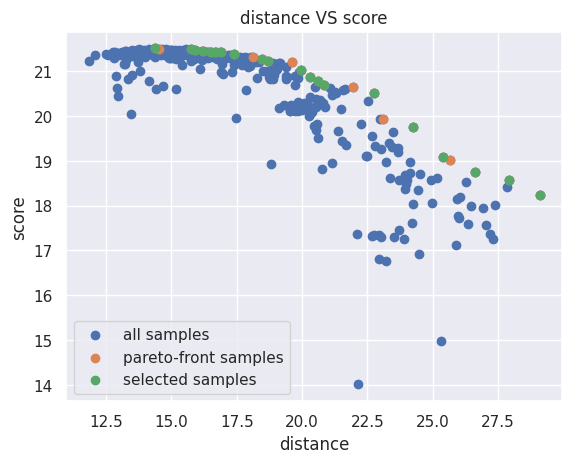

TSNE shape (595, 27)
TSNE done!
score: [18.76192318 18.57040408 19.75899141 21.02222571 20.78274884 21.48319996
 21.43065106 21.22465076 20.50504025 18.23541191 21.43292312 21.27073952
 21.50764301 19.08721792 21.42978424 21.4987153  21.37580404 21.44916654
 20.69098289 20.87670449]


<Figure size 640x480 with 0 Axes>

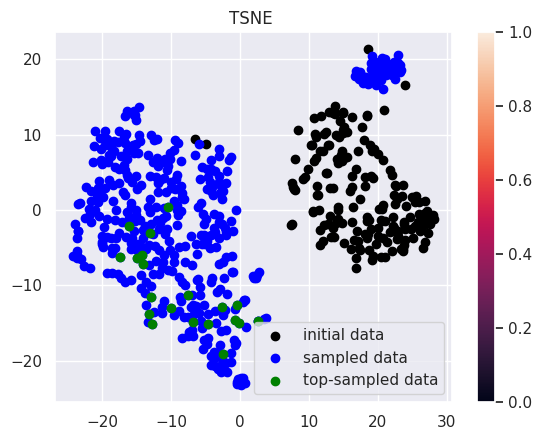

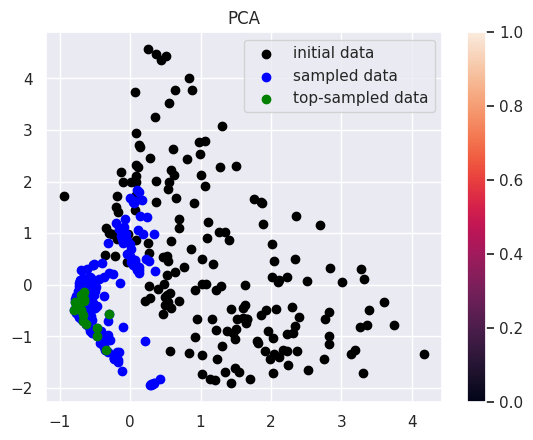

In [ ]:
################################ Select final samples ###############################

top_all2=np.array(top_all).reshape(-1,n_dim)
top_all3=np.unique(top_all2,axis=0)
sample_score=oracle(top_all3)

whe=np.where(sample_score > max(sample_score) * 0.5)[0]
top_all4=top_all3[whe]
ind=pareto_evaluation(all_input, top_all4,top_sample,plot_save=True)
top_select = top_all4[ind]
print('score:',oracle(top_select))

top_select2=top_select.reshape(-1,n_dim)
np.save(model_folder+'/'+round_name+'/top_select.npy', top_select2, allow_pickle=True)

df = pd.DataFrame(top_select2)
df.columns= ['Ti','Nb','Al','Ge','Co','Au','Pd','Ni','Zn','Ga','Mo','Cu','Pt','Sn','Cr','Mn','Mg','Si','Fe','Ru','Rh','Hf','Ta','W','Re','Ir','Bi']
df.to_csv(model_folder+'/'+round_name+'/top_select_fcc.csv')


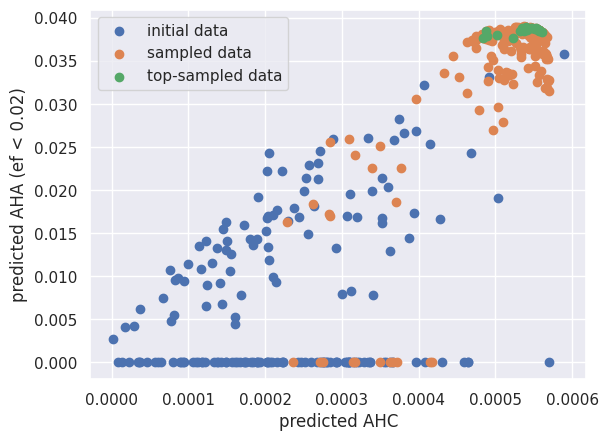

In [ ]:
################################ Visualization ###############################

sample_ef=emsemble_pred0(top_all3) # predicted formation energy of sampled points
sample_ahc=emsemble_pred1(top_all3) # predicted AHC of sampled points
sample_aha=emsemble_pred2(top_all3) # predicted AHA of sampled points
ef1 = np.where(sample_ef>0.2,0,1)


top_sample_ef=emsemble_pred0(top_select2) # predicted formation energy of top-sampled points
top_sample_ahc=emsemble_pred1(top_select2) # predicted AHC of top-sampled points
top_sample_aha=emsemble_pred2(top_select2) # predicted AHA of top-sampled points
ef2 = np.where(top_sample_ef>0.2,0,1)


initial_ef=emsemble_pred0(all_input) # predicted formation energy of initial points
initial_ahc=emsemble_pred1(all_input) # predicted AHC of initial points
initial_aha=emsemble_pred2(all_input) # predicted AHA of initial points
ef0 = np.where(initial_ef>0.2,0,1)



plt.figure()
plt.scatter(initial_ahc / 10000, ef0 * initial_aha / 100, label='initial data')
plt.scatter(sample_ahc / 10000, ef1 * sample_aha / 100, label='sampled data')
plt.scatter(top_sample_ahc / 10000,  ef2 * top_sample_aha / 100, label='top-sampled data')
plt.xlabel('predicted AHC')
plt.ylabel('predicted AHA (ef < 0.02)')
plt.legend()

In [ ]:



################################ End of Part IV ################################




################################################################################

---------------------------------------------------------------------------- That's all folks ! ----------------------------------------------------------------------------


################################################################################